In [92]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay

In [2]:
# 1/7/24
# SANDBOX FOR OPTIMIZING C, L1 RATIO, AND THRESHOLD FOR sklearn.LogisticRegressionCV
# 
# THIS IS A CONDENSED SUMMARY FOR BINARY CLASSIFICATION. THIS IS MORE COMPLICATED FOR multi-label AND IS NOT DONE HERE.
# C & l1 RATIO CAN BE OPTIMIZED BY PASSING 1-D LISTS TO THE "Cs" AND "l1_ratios" KWARGS IN LogisticRegressionCV.
# SET THE SCORING VIA THE "scoring" KWARG. EXTRACT THE SCORES AS 3D ARRAY (n_folds, n_cs, n_l1_ratios) VIA THE .scores_ ATTR.
# SCORES APPEAR TO ONLY BE FOR THRESHOLD = 0.5.
# 
# IT IS NOT OVERTLY APPARENT HOW TO OPTIMIZE FOR THRESHOLD USING LogisticRegressionCV. LogisticRegressionCV DOES NOT HAVE
# A WAY TO EXPLICITLY CHANGE THRESHOLD. ALSO, THERE DOES NOT APPEAR TO BE A WAY TO ACCESS predict_proba FOR EVERY ITERATION OF 
# THE (n_folds, n_cs, n_l1_ratios) TRIALS.  ACCESSING predict_proba ONLY RETURNS FOR THE OPTIMAL C & L1_RATIO AS DETERMINED BY 
# AVERAGING ACROSS THE FOLDS. SO TO DO THIS, MUST SET UP EXPLICT for LOOPS WRAPPING LogisticRegression, PASS A SINGLE C AND 
# l1_ratio TO IT, THEN FIND THE OPTIMAL THRESHOLD MANUALLY.
# 
# 


### MAKE X & Y *********************************************************************************

#### FROM sklearn make_classification *********************************************

In [3]:
# X, y = make_classification(n_samples=10_000, n_features=10, n_informative=10, n_redundant=0, weights=[0.9, 0.1])

#### END FROM sklearn make_classification *********************************************

#### FROM AA ************************************************************************************************

In [ ]:
# ORIGINAL AA DATA

# bag_of_words_is_count = False
# MIN_CUTOFF == 10
# coo_embed = r'UEsDBBQAAAAIAAAAIQDjV//V+iYAAAxtGgAHABQAcm93Lm5weQEAEAAMbRoAAAAAAPomAAAAAAAA7chjtJ5nw7XR1LadMkVq27btpmZq27Zt27Zt27bbL+/z7dGRpnsnNy6cmMcY88daxy+z8tLLrT5Qt5267d5jo17bb9i7xxzde8y12Uw9enbvsfE2vXfovf7W627Te6Ne//cvsv6W2/fq82+/6frb9uqzJ59pxhlmn3H6nlP07L5n99YaupuCaSBowMBQsEEI2qBQscGo1eAkYQhqMySVGIqkDU2thiFLwxKE4aAGwxOEESjciNCmkYjayNRqFEoxKrUYjSCNDgEaA0o0JtkYiySMDU0ah2SMS7TGI2jjQ8UmgAZ0JxoTEoyJyMrERGkSSNCklG4yotQDKjQ5/zIF2ZsSGjAVRKAnFGxqKMk00KZpoT+mo3TTk5UZSM6MVGYmgjIzUZmFUswKkZuNqM1OtOagMHNSubkYoLkJxjyZmxcKNB9BmJ/KLUBQFoQ+FqIyCxOMRUjKokRpMZK1ODRhCSjZklCgpajU0tCJZUjOshRiOWqxPHRYgeytSDRWIgorE7RVqNSqRGM1orU6LVmD2q1JtNYiaWsTpXVIxrpUZj1Ksz6F2gACsSFJ2Qg69IIOG0MbNqFQm1KbzWja5mRvC+hjS+iwFQO0NbXYhqhsS3S2Iym9oQ3bE70diNKOUKOdICA7Q8F2gYrtSn/tRqd2pxR70LY9qd1eVG5vSrcPpdqXSu1H6fanaQdQmAMp1UEk42Dadgj05VCydBhJOBw6HEEwjiQpR0HkjqY0x9CSYwnecQTheNp2AqU5kdqcRC1Opm2nELRTqd1pBOF0CnUGtTuT6J1FNM4meedAoM6FCJwHNTuf6FxA7S7M2EWZu5hKXEJlLiVKl0GHy4nCFXTpSip3FXThaip3DaW7ltJdBw26nqDdQFRupFQ3UYqbidYtROVWsnEbQbk9c3dQujtp211k6W5o0D1QgHuJ1n2QkPsp3QNk70Gy9xDReZjoPELyHoV+PEb2HidaTxCtJ0naUyTpaaL2DNl6lqY8R+2eJykvEIwXoU0vQY1ephCvQABehYK8BgV7naC8QWXeJChvUZi3+cc7kIh3oS/vEZX3ycIHVOpDKvURQfmYTn2SsU+hJJ9BAz6HAHwBJfuSyn1FLb6GgH0DA/AtVOA7SND3ELAfoEA/QqB+Ils/k5RfyNavBOk3gvY7yfmDoPwJlO4vovc3peg2EKkYCDoMDCUYhJYNCjUbDAo0ONRkCCjIkJEaimAMTbCGIVjDQgCGg8gMDw0YgdKMSClGgoKNDBEZheiNCk0ajVqNTmXGoDRjEo2xKM3YUKNxoAbjQgvGg8iNDwWaAArUHQoyIUGbiCBMTJAmISmT0pbJSE4PgjA50ZmCYE1J5aYiGj1J3tRkaRoqMS1JmY6oTA8NmgEKMCPBmomkzEz0ZiF6s0JmZiMbsxOFOaBNc9KlucjK3GRpHko1L9GaD/oyP9lZgNIsSK0WIjsLE4xFCMaiRGUxCrM4UViCoC1JtpaCBi1NMJaBBC0LXViOwi1PtFYgGCtCF1aCJq0MFVgFGrAqSVsNArY6hVmDwqxJw9aiIWvTpXWgH+tCH+vRtvWhBBtQqw1JwkaUrhdJ2BhKsglEZFOIyGbQgM0jtQXB2xKatBW12ZosbEP0tiUK2xGk3pnbnmTsQDB2hP7YCUqyMwRqF6jQrlCA3Qje7tCkPejSnhC4vaAEe1OpfQjGvgRlP6K1P7U5gNocSHAOgiYcTEsOoVSHEqTDaMrhUIIjqMSRkIGjoGZHQ4OOIRvHErXjSN7x0IITyNqJ0I+ToB8nk5VToASnQkBOo1CnU5sziMqZVOYssnA2QTuHIJzLf5xHlM4nKhcQlQspxUUE62LoyyVk41LoxGVQs8upxBUZu5KoXMV/XE3UriEp1xKE66BJ10MfN0CBboQm3QQZuBmacAvJuxVqdhtU7HaCcgeVuhMSdRdU4G5I2D1QoHuhBPdBgu6HCjxA1B4kKg8RrYehJo9Ah0fJ2mNk7XGy9AR04UnoxFNk7WmS9gyleZbKPAd9eR4K8gK1e5HSvURbXiYar5CVV4nOa1CQ16EJb0AF3qQtb5GUt6nUOyTjXZr2HkF7Hzp8QHI+hA4fkY2PSd4nZO9TsvcZ//E58I8voERfkrWvqNzXROUbiNS3UILvIHDfQ5t+gAD9SHJ+gkj9DA36BSL3K5ToN6jA7wThD2r3J8n7iyT9DRXoNjDwfwaCgA1MEAahNIOSvcFIzuDQoiFI1pBEbyjoMDREbBjI1LBQkeEgYsNDyUaAAI1IkEYiaSOTpFGI0qgEYTSiNDpRG4NkjUnSxiIoYxOtcWjKuLRkPEo1PnRhAmhDd2jDhNCCiaAFE0MFJiE7k0ITJoMm9CArk8MATEFWpoR+TAWR6wkFmBpKNA20YFpowXQQsOmhADOQjBlJykzQpJkhALNARWalcrPRttmhwxwka06CNRfZmRsyMQ+0aV7oy3wkZ37oywIkb0HoYyEo0cLQhUUozaI0bDEqtzhZWoKkLElpliJoS0NJloGELAsRWI7oLQ9NWgGasCKlW4morEzlVqE0qxKc1UjW6hRuDZKzJrVYi39ZG1q0Dllal4atR9vWhy5sQNs2hBZtBE3oBRHaGFqwCZRgU4KzGSRmc/5jC4KwJUHYiiBsTRC2IQjbQma2gzb0hghtDxnZATKxI4XZCSKyMwRkFwjIrsD/7AYl2B0oxB5Qkz0hMHtRqL2hAPuQrX2hIPtBm/YnWwdQqQOhEwdBJw4maocQnUOhJocBLTkcMnUEwTuSUhxF7Y6GkhwDJToWKnQcDMDxBOcEqMCJZO0kKNnJEKhToECnQqBOgwadDhU4g1qdScPOgi6cTaXOoTbnUpvzCN75lOYCgnUh0bmIKFxM0i6BTFxK0C4jKJcTvSsIzpUE4yro42qidA21upYgXUdlricINxCEG4nOTQThZmjBLdCkW4nKbWTndoJ3B0m7EypwF5TobujCPVCQe6Fg90GC7idKDxC8B2nZQyThYaL0CP/yKJV5jJY9TlCegP54EiLwFNl6Gkr2DPTjWcjEc1CC56FFL5CEFyFCL0EbXoZ+vEL2XoUGvQYZeR0K9AZE7E0I0Ftk4W2C8g5ReJdkvUdw3icoH9C0DyEyH0ENPoaKfQIN+JSofUZhPid6X1CrL8nOV9Cir4nSN5TqW4jEd5C47yEBP0DGfiQIPxGknwnSLzTkVwrxG9H6nWT8ASX7E5r0F9Tob5LXbRBSNBC1GphKDEKpBoUGDUblBidYQ1C5IYnOUJCJoaENw0DghoXADQd9DA8lGAECNyL0MRI0aWSoyCjQiVHJ0mhEZXSSMwalGZNajEV/jU10xiE640JfxiNJ4xOUCWhbdyjJhFCyiYjWxCRhEmjDpERnMqLTAwo0OUmZgqRMSRCmIgk9ydbUJGcaKMC0JG06KMD0BGsGkjcjSZmJrMwMHWaBJs0KLZiNSs1O0uYgaHNCG+aCFswNkZsHMjAvdGE+oL/mByq3ALVYkCAtRFQWpjKLQJMWJUuLQZsWJytLkJUlicJS0KClCc4yZGFZKNhyUJLlgS6tQKVWJAorUbuVoQurEIxVycpq1GJ1CrcGhViTWqxFadYmSusQhXWJxnoQsPWhYhtAizakMhtBP3pBiTYmGZuQnE0JxmYQmM2pzRYQiC2hBVtBk7YmCtuQhG2hAdsRpN7UZnuitAOF2pFo7ESUdqYSu0CDdgX+Zzco0e5Qkz2gIntCTfaiMnvTlH2A/9kXGrQf9Mf+1OYACnMgyTkIInYwyTgEmnQotTmMQhxOU46gVkdCQI6CSBwNFTuGLBxL8I6Dkh0PATkBMnAiVOAkaMDJROUUsnAqtOA0iNzpEJEzIBJnkpyzKM3ZtOUcSnEu0ToPEnM+VOQCgnQhQbqIYFxMZS4haJeSrMto2eW07QqidCVE5irgX66GTF1D9K6FiFwHNbkeOnED0boRMnITBOxm6HALQbmV5NwGJbidrNxBpe6ENt1Flu4mWfdAie4lSPcRrfsJygNE50Gy9BBBexjo9ghk5FGgU49BzR6HiDwBJXoSCvYUNOlpIAjPUJlnoT+eIznPQ8BeIAsvEpSXoAAvU6pXIHCvEq3XgAF6nWC8QbLeJFtvQQ3epjbvkKR3ScJ7VOJ9aMIHZOFDavcRQfgYIvcJ2fiUZH1Gf31OUL6gEl9Su68IytfQj2/Ixrc07Ts69T1B+YGo/UjUfoLM/AwB+AXo1K9U4jey9DtZ+oMo/QmR+As6/A0R6jYoZRiIUg1MlgaBggwKJRqMoA1OFoYgakOSvKEI1tA0bBiowLBQgeGgL8NDhEaAiI0IBGskqMHI0IVRCMaoBGc06DA6QRiD7IxJ8MYiWGOTpXEI0rhEYzyiMz7BmoBgdIcmTAidmAg6MTHBmwQqMCmVmYxo9CBYk1O7KYB/TAmRmAr60RP6Y2qiMA3BmRYqMB1EbnqyNgNZm5GszURhZiYIs0DmZiV6s5G92aFGc1CbOUnaXJC4uYnePARrXtoyH0mZH5q0ALRpQWjCQmRlYaKyCN0WJVmLQRMWJztLkL0loQFLkaSlISLLEJxlKdxyULLloR8rkJwVoQErEZWVid4qUKBVoUSrQc1WhwFYg8qtSRDWIjprQ4d1oCDrQoPWgxasT9A2oBQbQkI2ghL1IikbQ8E2gRJtCiXYDAKxOUHagiRsSTS2ggZsTbC2oXDbQpu2I3m9Cd72ZGcHaMGOZG8nsrQzWdoFarArtGk3src7BGwPiNieULK9IHB7Q4T2ISv7Qhv2Izn7U6sDIEMHQn8cRHAOJiiHQJMOBTp1GNTkcEjEEQTnSIJ2FNE5GviPY2jbsTTsOKJ0PPTjBKJ2IkTsJEjEyWTjFJJ3KhTgNKAUp0MEziBLZ0IfZ0GJziYL55CEc4nKedCk8yFwF5CVC0nSRUTnYijQJUTtUqJ3GbTpcojQFVCjK8nOVVCAqwneNdCga6GP68jW9VCDGyADNxKtm6AgN0ODboG+3EoSbiN4t5OkO0jendDhLipzN0m7hyzdC33cR2nupzYPQGAeBDr1EBTsYRiAR4jOoyTvMbLwOFTsCZLxJPA/TwGVeRpK8gzQpWcJznPQpuep3Ask7UVq8xJReJlCvEJwXoWavQZ06nXI0BtQkDdJzltk421K9w5QmnehBu9BQt4nOB8QtQ8hIB8RpY+p3SeQgE+hQp9BAj6HJn0BBfoSIvIVZO5rovUNVOxbgvIdWfieLPxAkH4kST9BwH6GQPwCGfmVaP0GNOx3yNwfULE/oWZ/QRf+hgp1GwzCMRBBGxj6MQhZGBRaNBj0Y3AKNQREYkiI1FCQuaEhYsNAiYYlCMMRpOEhUSOQpBGhSSNBi0aGRI1C1kYlWqNBg0YnCmNAg8akYWNRurHJyjgQmXGhIONRqfGhDRNAE7pTiwmJ3kRUamKCNgnBmpRkTUawelCpyanMFBCIKcnOVJSuJ5WZmlpNAw2almxMR2mmpxYzQE1mhMjMBBmZmf6aBQo0K7RgNmjC7FCTOaBkc0KL5oIWzE0h5oECzAslmQ8qMD9UYAEIxIKQuIWAfywMFVgECrYoSVgMKrY49LEE0ViSYC1FVJYmO8tAyZaFPpYjCMsTvBVI3opkbSXoY2WIzCoQuFVJ0mpQoNWhCWtAjdYE/mUtqNDaELB1IEDrUov1oCDrk5wNSMKG0KaNIAK9oMPGUJBNoAubQs02g4BsDhHZgixsSXK2oi1b05BtoEXbAl3ajmz0JkrbQ8F2IEo7kp2dSMbOJGEXCrcrydqNIO1OkPaATuwJFGYvaMPeEIB9CMK+FGI/KMn+0IYDIHIHkqWDSMrBRO0QaNGhBOkwgnA4STgCCnQkSToKGnQ0hTkGAnYslOg4iMzxEJATaNuJBOEkgnEypToFBuBUKMlpUKDTydYZ0IQzoQFnEYSzScI5QEPOhQScB/zjfJJzAVTgQuhwEVm7mGRdQnAupTaXQV8uBxp2BWToSgjAVQThaqBw1xCNa6EA10EAroeA3AB93Aj9cRM06GZowC1E6VaoyG1E53ZKdQeVuJNo3UU27ob+uAcKdC/0cR9QqPuhIg9Aix6kdg8RjYep1CPQhkeJ2mPQicdp2hNE4Ulo0VMk42mI2DNQkGchYs+RlOcJ1gsk50Xox0vQpJdp2SvQpFcJwmsk5XVq9wZdehMq8BZZexsi8A5ZexcK8h61ep/KfEDyPiQKHxG8j6ncJ5CBT6ETnxGdzwneF1TqS+jLV9Cgr4neN8A/viUq30EgvidJP5CVH0naTxCgnyFDv0CNfiVZvxGF30nCH9CkP6Emf0GF/oYKdBsc2jcQBGRgajUItGlQgjcYlGBwiMgQ0JchidpQ1GpoSMgwFGJYBmg4ojY8JGIECNSIRGMkKNnI0GEUKMmoJGs0kjU6tRuDZIxJZcYiGWOThHGgAuOSnfGgP8aHAEwAA9AdIjUhWZgIIjQxWZuE7E0KJZgMutCDbE0OAZuC7E0JDZoKAtcTajA10ZiGLExLMqaDQE0PAZsBEjEjFGgmgjMzSZiFLMwKLZiNps1OcuaAJsxJreaiEHOThHmo1bwQgfmgQvNDBRaATCxI0BaCFi3M/ywCJVkU2rAYUVocErMEQVuS0ixF7ZYmOcuQnGWJ0nIEaXmysgJRWZEkrQRNWJlgrAIlWRUKsBpEYHWitQZJWhMKthbUbG3gH+tA5NaFvqxHEtYnWRtAxTaEgGxE1HpBoDaGyGwCBdkUCrQZFGxzsrMFUKotoSBbQQK2hhpsQ7C2JTnbQX/0JkjbQ412gALtCA3YCWqwM7RoF2jRrmRnN4jQ7lCxPaBEexK8vaAEe0Om9iFo+0KH/aAA+0MLDoAWHUj2DgJqdTBE5hCidijZOwwScjhJOgI6cSRU6Cio2NFQk2OAfzmWyhxHso6HvpwABTkRInQSVOxkiNwpQMtOhYCcRvJOJ3hnQIPOhECcBfzH2QTlHKjRuVCw8yAz51OaC0jehTAAF5Gti6FFl0BALoUWXQY1uRzacAV04krI2FVQoavJyjVQgWtJ1nVE6XqydQP05UaicROU6GYowC1k51aidhuU7HYoyR0QkDshEHdBYu6GBtwDTboXWnAflOx+qMADEKgHoQYPkbWHoS+PUJtHgf94DCL1OJTsCbLzJJV6CgryNNCWZyAiz0KNnoMKPE9UXiB6L5Ktl6BCL0ODXgFa9ipE6DWIxOsE6w2S9iZReYtSvE2S3oE2vQs1eg8a8D5U4AOI0IdE6SOC8TG1+AQC9ilE6DMo2edQsC+gZF8ShK+gIl9DTb6BzH0L/OM7svI9yfuBSv1IEH6idj8TrF+gTb9CH78Rrd+hRX9AH3+Srb+gL3/DAHQbglQNRLQGJgiDEIVBIVCDQcUGh8ANAW0aEgIxFARmaCjZMERtWLIwHLRheAjICFCBEaFCI0GERoYKjQIVGBUaNBpJGp1SjEFLxiQIY1GKsYnCOARtXEo3HsEbn9JMABXqTqkmJAgTQUkmJnqTQEAmhURNBiXpARGZnORMATWaEmo0FTBAPaFJU0NNpoGCTQsBmY4oTE92ZoD+mBESMhOUYGaiNgtZmpXKzUa0Zic6c0Cb5oRAzAWZmhtKNA9kbF6iNh90YX6SswA0aEGowELQgIWhAotAIBYFurQYRGRxSMgSUIElgUIsBQVbGgK2DNRsWQjEciRjebK0AtlbkaSsBA1aGWqyCpRoVejCaiRndZKzBklaE2qyFnRYm+itQxLWhb6sBzVaH2qwAdCpDaFFG5GNXiRvY+jLJmRpU6jBZtAfm1OZLUjCllRiK4jM1iRhG2jRtkRlO7LWmyRtDxnaAWjJjlCRnaAgO0PBdiF5u0JFdqMSu5OMPQjCnhCBvajM3pCofaBi+0JF9iMY+0ObDiAIB0KHg0jGwUTjEGjToRTmMOjH4WTrCCp1JDToKKjB0SThGAjAsQTtOKjA8VCDEyABJxKFk0jWydTuFLJ2KpU6jeycDm04AyJzJlTkLJJ3NlTsHAjcuRCA86AE50MJLoAmXEjpLiJqFxO0SyjEpSTjMqJwOdG4gihcCTW5CgbgamjBNVCQa6Ev10ETric6N0AmboQI3ETUbiZJt0CHW4nObUTndmjCHVCgO6FAdwFNu5tk3AMluhcqcB/0cT/05QGowIME6SEI0MNQo0eAbo9CRh6DBD1OdJ4gC09C4J6Cgj0NgXkGEvQsZOw5oBTPQ+BegIC9SDReIikvk6RXyMKrQFBeg768DjTsDeBf3iRZb5Gst0nWO1TqXQjIe5CQ90nSB9CADyESH0GkPiZon5CkT8naZyTnc2rxBWTsS8jEV1CjryEA30CLvoVMfQc1+x4C8wP08SMk4CeIyM9Qkl9Iwq9AQ36DiP0OgfqD5PwJnfgLavY3Sek2JGUbCDoxMERkEJI3KFkYDAI1OEEaAmo2JNEaCmo2NPRlGAo3LEEbDio0PARqBGjQiERnJLI1MjRhFLI0KhRoNJo2OkkZgySNSbbGImhjQ43GgUCMCxRmPEjE+FCSCaBi3SEwEwL/mAgCMjFBmAQiMylEYDIoSQ9owuREbwoowJSQuakoTE/aNjWVmoYkTQs1mI7kTA8BmAEKNiMEaiaSMTNRm4VgzQr9mA0qMjs0YA7ox5xUbi4o2NzQhXkgMvNSmfmgJvNTuAXI0oLQhoWgBAsTnUXI1qIkYTFasjhRW4LKLEl0loKSLQ0VWAYityxRWI6oLA+UagUIyIpQo5WgLytDg1aBhK0KgVsNMrM6ZGwNoGVrkqS1oMPa0Il1YADWBf5lPYjQ+mRvA4KyIQRoI+iPXlChjSFCm5CNTYnWZtBhc5K1BVHZkqRsBYnZGhK0DSRkW6jYdhCA3pCI7SEDOwC12JHk7ETQdiZLu8AA7AqZ2Y0g7A78xx5QoT2hBnsRvb0J1j5QoX2hJvuRhP2hAAdAzQ6EiB1E5Q6mFodQiENJ1mEE73AowBFQgSMhMEcRnaPJxjEk7ViSdRzROJ5snQABORECchL042SicwoE5FQo0WnQidMhA2cQpDOBTp0FFO5soGXnQATOJSjnQWbOp3YXEIULqc1F0IaLIRKXQAIuhRpdRrIuJ1tXQEWuJGlXwQBcDS26BipyLRTgOmjS9VCAGyBDN0JibiILN0OHW0jWrcAA3QZtuh1KdAd0uJNs3EVy7oYO91Cpe0nCfRCp+8neA2TlQYjIQ5Cxh4nKI0TvUYL1GMl6HAL0BNTsSWjTUxCwpynMMyTtWWjSc2TheZLwAll4kWi8RHZehia8QpJeJXqvUYvXidIbEKA3IXFvQaLeJnnvkKx3oSDvQYf3oQIfkKwPSdZHULCPoR+fQAk+hYp9RtY+JxtfEIQvISFfUbuvoWTfAG37FgL2HVH4nuj8QDR+hMj9BAPwM7ToF7LxK1TkN9ryO2TmDyjZn1CCvyBzf0PCug0F/zUQNGBgsjUIyRgUIjUYBGpwiNgQELAhid5QZG9okjAM2RiW4A1HlIanbSMQrBGp1EhUZmQqMwqUbFSyNRpZGJ2sjQEZGZO2jEVQxoYAjQMDMC4EZjyIwPgwABNAhrpDoCaEwE0EFZkYajQJtGBSCNhklKYHtZmcQkwBgZuSZExFUnoSpamhTdNAhaYlSdMRtemhRjNAAGaEksxEoWYmOLNAzWYleLORvNnJxhzQojlJ3lzQgLlJ1jz017wQmfmgL/PDACwAEVqQbCxE9BaGCiwCbViULC0GTVoc+JclyMKSFGIpSrc0QVqG5CwLA7AcUVue2q1ApVakFisRlZWhDavQklWp1GrQH6sTrTWgBGsyQGtRmbUhAetA5NaF/lgPWrQ+lGADsrQhUdiI7PSiEBtDATaBkm1KsjYjapuTrC0gIVtCYraCkm0NgdsG6NK21GI7aFBvCNz20KAdoGY7Qgt2gjbtTNR2ISm7UrndiMbu0IA9IHB7koS9qNTeRGMforMvlduPKO0PXTiAaB0INTkIMnEwNOgQgnYo9OUwknc4tTuC7BwJgTgKMnA0FOAYqNmxVOo4iMjxEJgTiM6JROskKnMy0TmF/zgVanQaNOB0iMwZ0KAzoY+zyMrZUIFzoD/OhRKdR3TOhxZcAJ24EPpyEUG5mKxcApG6FBJzGSTmcqjJFSTvSmjCVSThaqJyDdG7FjpcR3KuhxbcABG5EQJxE5TkZojALdCkW8nKbWTrdkp3B4W5k1LcBQNwNyTgHqAt90IE7qNW9xOkB4jKg2TlIajIwxCxR4D/eBT6eAya8DjU5AmS8yTZeopaPE1tniE6zxKk5yBxz1O5F6BAL1K7l0jOyxTmFUjMq9DhNajI61CzN6ABb5KEtyAyb0Ng3iFJ70If70FN3ocKfACR+RAy8xEE5GOi8QmV+5TsfEayPoeAfQEF+JKofUXQviZ731C7byEQ30EBvodI/AAR+pGg/QSR+pnk/QK07FeowW9Qgt+hE39Af/wJifgLmvQ3FKDb0JRlIJI2MPTHIEBbBoWEDQaRGJzsDUGphoTIDAUNGBoiNAxEYliowHAkaXiiNQJBGxEaNBJUYGSyNApZGxUqMBo0aHRqNwZUaEwI0FgkaWxo0DjQYVyyNh61GZ9KTEBLutNfE0KEJoKKTQyRmoTsTAoNmoyg9CAKkxOtKWjblFRuKhiAnjAAU0MJpqFW05Kd6QjK9FCSGcjWjERtJrIzM7RgFmo1K7WaDZowO9ClOaAJcxK0uQjC3NAf81CoeaHDfERnfmqxAFFbECqyEPRjYZq2CNFbFPqxGLRocZKzBElakiwtBYFamigsAy1YFmqwHFlZnuCsQFJWJHorkbSVISOrEJ1VycJqUJLVSdoaUKI1SdpakJi1IVLrALVaF0q2HtFan9JsQGE2pFIbkbVeFGZjkrcJyduUKG1G7TYnSlsQvC1p2lYQiK0hYttAibYlaNtBiXpDQbYnezuQrR2hQDuRrZ3J0i5EZVdo0W6Qmd0hIHtAzfaExO0FidsbArIPBGpfkrIfSdufaB1AbQ4kGQdBfxwMBTuEJB0KNTsManA4JOwIBuhI6I+jCMrRVO4YCMyxJOE4knA8NOkEonEiSTuJ7J0MDNApEKBToQKnkaXTSdYZROlMgnQWwTqbLJ1DdM6FDudBIM6HCl0AbbiQ5F0EAboYaMklUKFLCcJl0KLLycoVBOlKonYVSbsaEnUNwbiWpF0HCbseEncDWbuRaN1ENG6GJtwC/M+t0IXbSNbtJO0O6HAnZOwuknA3wbqHJN1LFO6DAbif4DwAFXiQqD0EBXgY+niEJDwKAXoMavQ4hXuCLDwJNXuK5D1NbZ4hes9ChZ6DDDwPJXmB5L1IsF6CmrxMNl6BNr0KmXiNprwOLXgDavImNOAtsvQ2tOEdsvQuBOw9svQ+NOEDgvQhdPgIKvQxdOETovYpQfmM6HwO1O4LSNyXQMu+ghZ9TbS+AVryLcn5Dtr0PSTgB6jZj2TlJ2jTzxCxXyBzv5Kl30jK70TvD4LwJ1n5C/rxN5Sg2zAQp4EgcANDyQaBkgxKpwaDAA0OiRuC4AxJlIaCAgxNtoaBgAxLdoYjO8MTrRGgZiNCG0aCzIwMgRoFEjMqRGY06MvoULAxoAZjQmTGgoiMDQkYB2owLskZD0o0PgRmAghEdyjRhGRjIrI1MZRkEmjRpNCPycheD4IzOcGYgqRMCSWYiuT0JBlTQ+CmgchMCwGbjkpMT9BmIHozQgVmghbNDA2aBToxK0RgNsjM7NCmOYD/mBMCMBcEam6o2DyQgXmhAvORnPkhUguQrAWhJAtBJhaGDCwCFVkUErIY1GBxiMASkIglycpSJG9p6MIyRGFZorMcFGh5aNMKwP+sCBFZCZq0MslaBSqwKsFZDZq0OtRgDaKzJrVbi+CtTVTWITnrQkXWgwStDxHaAAK2IdRkI0hUL7K1MTRhE7KxKbXbjOxsDhnYAhK2JfSxFVnbmqBtAxXaFgKxHSSiN1nbnlrsQJZ2JFk7kZ2dqc0uNGxXGrYbtdgdBmAPGIA9ycpe0GFvKMk+EJl9oQv7QYv2h8AdQGkOJDgHQYIOhsQdAok7FOjSYWTrcKJ0BPTHkQTlKIJwNNE6hqgdS6WOIwvHU7kToI8TydZJkIGToQWnEK1TCcJp1O50gnMGBO5MiMRZkJizKdQ5GTgXSnQelOB8snUBwbmQpF0EGbgYCnIJwboUAnYZRO5yaNEVkLgrqcVVQFOuhkxcQ1auhTZcBxG5HgJ1A5TgRhpyE7ThZrJ1C9m4leTdBp24nazcAS26Exp0F1G6m6jcA524F7pwH0TufijAA9CiByEyDxGMh6FGj5CFR4nGY0ThcSjRExCJJyEAT0FNnobEPQOJehYy8Rwk6nko2AtQoRehCS9BP16GNr0CkXsVKvYaFOR1qNgbEJE3oWZvkbS3IWLvkI13icp7ROd9ovIBdOJDiNBHQFs+hkx9Ah0+hYJ9BgH5HCL2BRTgS5L3FUn4Glr0DVn4lix9R3K+J0s/kKUfoY+fSNbPUKJfIGG/QmB+g0T8TjT+gBL8CQn6iyz8DQHpNiz8fwMRtIFJziBEaVCSNhhJGxxqMgQEZEjgH0MB/zM0ZGAYyNiwEJHhIGPDQ8FGgESNCDUaCSIxMlkaBSI1KtRoNKjR6NCmMaAvYxKFsYjO2FChcaBi40KCxoOIjQ8JmwAC0J2kTEhwJqJUE0MLJoGSTAoNmAwa1AOaNDlZmwICNiWUZCqoSU/oj6khEtMADZkWIjUd2ZseajYD9DEjlZqJZM1MqWYhCbOSvNmgALNDTeaAxM1JNuYCGjI3ULp5oE3zQsHmg5LMTzYWICsLkrWFIDALQyAWgQAsSnYWI2mLk7wlqM2SNGwpurQ02VuGaC1L0pYjG8uTjRVIzooQkJVI2spAt1WgBqtCh9UI0uq0bQ2StCY0aC3osDZZW4fsrQsJWg8Stz4EZAOo2YZQsI2gj15EZWNowyZEZ1Now2bQoM2JxhYEbUuithV02JpsbUO0tiU62wHR6w0UYntKswNB2ZHk7ETLdoaK7AIJ2JUg7Ea2dgcKtwcEYE8IxF5kZW8oyT4kZV+yth9Z2p8gHACJOxD4j4OIwsHU5hAKdSjBOww6HE6QjqBQR1KKo6AkR0ObjiErx5Kc46A/jgf+cQJZORE6nAQNOpksnAIROhUqchqU6HSSdwb0cSbBOovgnQ1dOAfacC7U4Dwo0fnQ4QJo0IVk7yJo0cVk4RKidCkU7DKadjkE4AoIyJUQqKsgUFdDg66BglwLNbuOUl1P9m4gWzdCIm6Cit0MGboFOtxKlG4jGrdDze6AFtxJFO4iGHeTrXugP+7lH/dBh/uhEw9QiAep1EMk72EIxCNk7/8BUEsDBBQAAAAIAAAAIQCqf3mI3wYHAAxtGgAHABQAY29sLm5weQEAEAAMbRoAAAAAAN8GBwAAAAAA7L0HmFXVsra7VjfdDd003U0vpVEQ6EBGco4SJSNIEhFRkgqIggomJIhkkIxkiYLkDIpKFJQkIEHJKDkHRVD/r/ao8c9as+eca66Gfc+597n72e9zdnAfXPXVHKNGjRpVoxs0rd+opdfztue9PO3ad3/5zTzlcuap8EqJPAVz5unw+ps93mzbtc3rb7ZrT/95zbadu7fHf969U9tu7fHv85YoXqxs8aIF8xXM+UHOtP0jspzH46kMZoPvwHawD2TzejytQX8wGCwEy8HXYCPYB66DdiEeTwewOJ3HswL8ATKGeTxx4LH0Hk9JUBf0ivR43gMTwQwwC8wGq8CP4NGMHk8CaAfeB/3B9+AGiIn2ePbGejw/gUvgBrgN0sV5PJmAD2QBv4AL4Db4F4Rn9ngygMxgjM/j+RKsAmvB9+BncBScBJfBNRCd4PHkAvlAWfAUqAXqgCagGXgRxGT3eLKCZJAfFATFQUlQHpRNwf8FrcGrYAiYBGaDeWA1+ApsBT+Aw6AW7N4ZdAFvgJmsywawDSTB3hVAE9AXDAGjwSoLXWKhySMgK8gGsoPioARoBtqAF8FLoC+0GgFGgk/B52AmWAiWgyvhsDm4Ce6AP8A/IDzC41kEKkK/SqAyqAKqgeqgFqgDWoFc0DAPyAvygWKgEqgHGoE2YHIm+AWYDeaAJWAN+AocAEfABXANrIWmX4GvwQawEWwBP4Ez4Dy4BCZC0+lgBvicfWAlWAN2gD3gV3AK/A5ugljo+yjIAhJATvaJ3CAvKA/qggagJftDLDSPBz7wCPtGNpACCoGi7BeVoXMdUBfUA8+zj3QAr4DhYCyYBb4Ai8A3Jj+pCl9oDjqwn3wCvgBfgh3gZ3ABRMIP8oKXwUAwCIwCKy38JRp+kAUkgSrgKdALvA/GgLFgHJgIboF0ofgGQAJIBuVARfAseAF0AafgO6fBCXz/58E1cAfcB5EZ8GeCx8ATIB8oBSqD9lEez+vgbfAu6AOGg0/BNPA5+AKsBlvASXAWnAcXwCVwGVwBxeAr5UFlUA00Ai1Ba9AOvAb6gEH0r+Ev3cCb4C3QG3wCBoERYAqYCeaB8exPC8E68BX4BmwGP4JD4Dg4AX4DN0Am9qdEkB88CYqBUqAaqA3qgxbsU+RHj4EnQA6QC+QDBUARUIp9qgJ8ojqtH+xTjcEL4DXwOugJBoCpYC5YCDaYfOoJ+EtJ8Bk4Aq6BdPCLMBAOMoKG4GPeD0ab9oP94Ab4CL6xBqwFG8BI+MFE8A34BfwGLoMr4Co4jLXhGPgTZIRemUFW8Bh4HDwB0mEPiAPPg9FgDlgL1oH14DtwAcRiDRkDHceDL8FGsAPsBnvBZXCV1hLsDYfBWXAN3AQRvFdkBMOh1SjwBdgCjvEe8TvvEZHQJgo8AYqD0uBp3iMaiD2iOrSpAVqAtuBl0BF0Bl3BFdj9OojNDduD5qAlaANeBT1AL/BJbvffPO3btE/kB68IvRaAFRZ6BfPdr8TevhXsAYfAGXAX3AeZab8HecFHYAjvJePBbLASrAEbwE5wFdwGf4F/QDrsJ2HgNPzgGvgbpIf2USAWJIIUkIf8A1oXAKVBFdAAdASvgo/BCDCd44cfwT5wn/1jCuKG6eBzMB8sAMvACpAN2ucEySAPKAxKgtKgPHgKVAc1QGPwLGjrsBZ8z3vMTuFDl8B1h7WgLO8v2p8ag+bsT3XhMw1AE9AUPAdaCd/SfnUHPuWBz4SBKJAAEkFuUBCUBRVBJeFzHcBrJp+ziw3Jv+pxbDjEIjbUvqVjw/eh74ccUywCK8AriBveBv0j7GPDtWALyMbxQjlQmWOGZ8GLNnFhGL7nKI4LE0RceAfc57gw0iYuJL1+4rjwlE1cWJ5jwrqmmLAWbF+fNWkNXgTthC63oMujsGsutn9N0Aw8BzpafPO0JufjNXkK2AR2gaPgBAj1GjFhfRETTjDFhFqPP0AR6FEU9KG4D3wMBoOe0GQKmA5WgfVhKr4bBMaDKaA8tKgAngJVQW1QHzwDGnOc92KkEdM15biufAx+L3gWNAcvg47gbfAe6A0+AcPAUmjyLfgObAXbOaY7LOK6K7xG0/q8QcRx+0Qsd45juUhep3OAgqCwiN8aifiN1upnWTvSrBN41bRW0zodD5JBPtawOqgFmrKObUEXk45lPepbou9oPtjC31A7Xp+t4nit2XPQ5r0w9Q3R9zMHLAVNECc1Aydg75PgPvgHhPE6+Xi08d2UBBX5u2kLJmAPnMjx9TKwjuPryxxbr+R4ejPb/ncRT4/2Gd/MIrCa7X/MFENnTDC+mTxiTTPHzTWzG99NI7GeteO9UmpwM8X4hrKCHKxBc7Z9GwvbI8T4z3dUDDwDeoHJYD8oD/s2Bv3AMAcNblMcBB1eA53BKuxTq8F2cAQsxLfRAbbvCF4B/WHjj8E4MBXMBMMzqdhkGpgLFoFvwWFwEdwgPTIr/18O1oNt4Ge2+xCf8vnJYCZYANaD3WA/OCNsnz5B+X08yAoKgYomu5O/N7aw8fkU5et/gXDYLzNIAdXA0+B5GztrHy8PWrGvk59T3FjEq2ytY5HxDr4+BYJNBdPAfLAV7AXFYOfioAKoAdaB9eArsBH8BA6CU+BsuPFdnOJvI4xjyQLgSfBIRpVzyAIKc97hI44lfwa/crzgwZrkBXHgUZAI8oBioESM+lZWie/lR7CPdaPv5hy4LL6bsfztrObYcreIDc7afDulWT8dEzR0+H5krGn17dwG9/kbysFxZxXWV8cCL1roS98Q5ScmiP1oFVgLdvK+dBpcATWgZVvQEwwFc0x6HwDXgBd65wX5Qox9aQSdGcAM8DmYCRLwfWUDiSAJJIN8ID9YiLPkMnAaa+F5cBPcArfBnyAjtH8ZOnaIVt8W5Q2+Me0xB8ExcJr3FcoZzOP9ZS84CH4Bp8WeQjmC7GJvKcD7SxFQCdQQGnWH/d8G74L3wKegbzLWHDAXzANHwTlwEdwEYdAoI4gDOVOM/WMj54IoFjsEbvFeUgW0EGf9IRzzy7P+SXAZtOa8j47POoYY+8tizvlQjJYJ9o0BseAiuAKugdvgGGyeHvZNAFnBk6ASqAfa4vsaBiaCKWAq+BJsBL/weV3vTeU5D6TjumdAc9AKvEQ5IcRzM8BMMAvM5ph9CVgOVoJXoduHoC/4GAwAQym2E2f22WCRiPfWiHjvgDivn+IY/YaI+fKKuE+f0+tybK7P6m/k8Hg+AB+BIeBTMBZMAjPBO4n412AOmAu2gt1gP/gVHAPnwVXwB7gPfEmBdS/Eeg99CHrnxbqZDxQId9awPXTpDLqBN0BP8B7o56AXabUqgFYzHTQ6zt+fkza1A2gSSA/S4biNDjqOwP/0P2dxiiVamuIJ2uuiwbP8LbYSe95csQZuAud5DaTY4m9TfDE4VOVNPgXTwRzwBVgBvgOHwHVwA9wEd8Af4E/wN/gXLMY3ugQsBcvAcrACrAJrwTlwHlwH/4CfIlUu5kikOoOfBefAdfAXyMD7Zw5QClznvExYRnUezw0KgergBTCM99KN4Aq4xvtpHfhAXVAPNASNQRPQDLQErcBLoF2sEQ8tE/EQ7a9HxN6q46IRPnUOp/hoiilGon12K3/neq+ldfxl+EhH0Al0Bt3Am6A3GAbGgfHgS7AIbABbwJ85PZ67IF0urI/gUZAIkkERUAK8n6zW+H5gCPgUjAXTwHywAewGZ8BVcB3cF+t+ZlCQ8sTwq/d5DVjiUXcyL4tzwywbv8oFPyoHaoE6IAfW6/x8H1MWnAF3eQ3PBBqA36HzDY6XPNC3DChPuRfolp/X69KgBa/PdJYoAZ3KgHKgMqgCqoGaYB3HRZvAr+C4OEtcBZ9Bg1n8rS/1qfuYQ+IscZF1eh027wX6gQFgFpjLuiwGq4U2/0CXMNg/A4gC2UEO1idF6DMctp4BFoGV4HdwnrW44UKHnHzmbsta0Pq72KUW7Sn/AV4Do/DtjQaT6btMn1qDZFAclAMded3tAvqCInH+Nt7L5+RjbOcbFjbezufkg2zn0zY2/gx8Duawne3sm+hg05Mc01w1xTTapm7WVLrDqMHr6UBeS2cGsZbuAL+Co3xv8S8Ixx/8OCgCng9V8WUBUNy0Lt4Cd0Bt2L4paBal7iY6g/fBQDCd7yF+4tjGzbr4DTjF62Jm6JiOclYgHESBOOADj4McoDAoYrMe/sDx69kg1sPNHNce4H2V1sMLLtfEsWA6WMhr4iqHdfERkMTrYoEg18ZdHBPT+niN18d7Dj5kdb4n34kVfvO5g99Y+cxZ9hfpK1HpoA9IBIVAOdAYdE5n+MnzNj6yXvhHDPuG2S+2sE/8Q+dOaB4aa50XIN13Wuhuzg+Q1tuEzlLjbiZdJwhdnTTNInQ1a/qphY57hYZm/QpBpzLgWb7X6ANGgrniTiOJ97wPvKnzm6TjBXAJ3AMV+f7iA767oHuLT8Xdw0Gssb+Cc3wXmUHcP9L5JR/W3YKR6o66KqjO5xLa7ypBk9qgAWgPOnEOsz/nLuke+nvOmR0XuUq6G9B3Ajt4j5M5yjdg555gOBgFJvH+RnvbSqFFLdi5CWgOWoOXQCfQGXQDPUBPsBmcA9dAKOLXLCA3KAQqgGqgNmif6M7+5XmvI/sPS4P9v8d54hdwFIzEejoOTABTI5S9h8O24zlX9rmNnd/lPPEIYeefeb8z23g373FnHGw8lfe3JQ42drJrFGwXA/La2NXpPlXfyz8NBvDaRDZdbmHTj3gtOg+exPrzIugO+oH+4DjfsT8DW1bG2lIFVAXVA9yb0lqzF/xGfw3n6J/iHH0H0Bm8AYbG+N+X3ohT96SZMvvfk+p775Nsc7ozoTXmFfABry+L2Nbr2daVYccqoDZoCTqyzV8XNl8EloG94AK4Ce6BFLZ72SDtnk3YfGEabT4Na/0CcAVkg+2fBGVBOVAxLLUONVxo8T3r8CPW+93gPLgLvHGqzonqm8w63I4z6pvMWnzv869rMmsxkfVY46DH86xJF5eaeBKVLiUtdKnB+cPnPUaNk65v2sb79TGPcbeoc1ijbNaa9NAmQ4hR50S1TW04z9EFdAWvg27gDfAm6BOmap0Ghhn1TrrWiXIgq8E6isvxLXUGr4Nu4A2+q3wffAA+5HvLDhSTgzdBT9ALDOG8yRTe92dxzuRnkDNa1UGliFooXQf1FKgm7jYp91U8E/ZWUBZUBJVAQ9ActAJvgPe4dmUI1Upl9q+L0jVR23hPOsTxAu1LF8EEn8p1TvUZNVI670Kxw9c+4z5U58Z+4/W0C/ylK3gbvAP68tlhCMcTI3gfm8ExBe1ly8Q6WxX+UgPUBPVAfdAINOa9rQ3owPvbq6Z1eBVYDb4GG8EmcAD8DE6C38El3vsygWTe//JbrNNu/TKDV/nmf8MvN4HNQfinW79bxb7n1u/c+pxbf0uLr6XVz9LiYw/qX3+xjzn5F/75n9zBS8KnbvM6l4/XOpmzt4sD0sE/XmA/6gUf6Cf8YhP4DXQR6xStTz9znkfn6Sm+rQVawCc6gbeEzyxkX9nKaxXl6B+LVrkfWav5rMjNV0BsUAvUBS3AixwPf8gx8RCOiw9inzrGNRiXRR1GCPwifWZVi0HxxKc+la/QfqHXHpmb17HF68IP9DozV/iBjDOqCe312vKS0N8ccywBa4Teeh3JIrS2ij2ctM7/kHS+C+6HqVopK32dtN3moGsDF7oG0tSNnjtd6ulWy2B1DHOho9tcf1WvyvVTDrC318hNLbPQNa15/kB5/C/TqzvQpWA5WAO+BVtAoUj3efoT4DaIDJCPygnycT5qFDQfB8aDz8AU8AVYRHlJsAFsAbvj3OfpD4p81FUX+SjK0c8Ruah17CeVcql49ilQHdThdf+5XCqm7Sr8ZF4uFdMuBivBWrAV7OO1/j6IhV88yvFtEVAmDT6jY9vevAYE4yvdw1SNFtVWDgCjwTSOCTpyXEprPmmeg/d1vV476ZkEcoOiDnouBWvA1iC01Gv3qSC01Ov4Ypda6rW8U5B66vU8t42WVvVadK+X7FX3L3oNn2Vawy+CK15Vx3ILDnEb3AV/gXtgN7TaA/aDrOmN9zGlQUVQB7wYZdy9jgCTwFqwCRyzqeuqDerzvQyt38X4TqYsKM/3MtX5TuaIqIe8xO9k9Jodk9m6vovuzn7wqfsZvW5f5HX7VejzGq/dH4PBCerObJZYv1eL9bs37P8R+BgMAAPBWDAeTAbTwWyQJwlxKmgAGoFmoCv4BIwGY8HnYB5YBtaAPUn22j2IbsFq5aTTf1Oj/zfoE0F7pyf1G6evOF7602PUs8h4abxprdSayXdNTcCzIf5vm+aDHvje3gpL/b7pS46rtoCM+BuLjvCvedkJjfeAW5wrjsigYq3MHG8V0TUv0Lshn8PeFWex8Rx/Leb4i2IvH7R/JNr/HVRZjsNqihoYHYvdxznrbxCJmCsjiOVatCwgB0gBT4LioCQYDV+ZBqaDWWAe+JLX8G/AZl7HfwTDfP7volZwnPadz8hTa386y2t4O/hIez6L9RTnsYEcu422iN9WiLW8L3ynH+jPPjYIjASjhJ9NEn6WnWpgQAVQn/3tWdACvAJ6gMHC5yaBuSafo325iMgLLgc/WuQGKabL7FX+VxN08hrvH+fbrBl/gr9AA84Z/ibyhtVAM1PukOK9caHGm5id4ECo/7uYa6BXOvhSOrXnvxumarO/A9+D7aA8/LM9fK8H9vu3wViwDCwHK7l2fk+kiv2iRe6xm0XukeK/rfxW4jS4x28uP8ZaNAAMAiPASDAajI9VuchDIh95hXOSN/ksoN9exlnkJrewf+m3l1b5yXHsRws4ttPr04fwiaFgGPvNaDDOtDblgua5QS3QGXQB3dhXhoBPwRiXe4c5HznTYe+wqtPuFGG8degJ3uM4zWrv0HlCu9ptnRfMAPtHgkdAFpBVxHGFOZYz7yH6zK33Ebs6bpnru+Cwh5hze6sC7CEjg9hHSKfe4pueEcQ+38Kb9n3+gqhzvGqj0Vq+57fb35vb7O92e7ubff2Az/2+/t/Y0z9OQ8yV02t8O3IfH+ugSVt8Ly9xbcyroHOY9Te1y+a76sff1tH0Rn1qFMgCKor8l5Wu34nv76SNvnUtcmB235nMhVjput0mv2Wn7Wc2ea5A39yoILTuLr49uaea9cbP8+QF1Tl33kTkzmVMR/HcdY+6O+7uNe6OrfR3eq8u47lh0Hc4GBGh7pKpfmoMGAtdx4HxYDB0GQqGRau75U/BKDCW75drIk6qB+rzHbPOcdH98sd8x3wUP/IUOA3OiDwX5bWs3pRT3CTvnElHmbeWsRLFSfLuWWvYJ5d1fDTRpF1B+uYs4iKKiT4C48FkC90ehxYdhU4zhFbLOPb+12Pckz7vNWoNre5LtXaZTHrV47h7CVgKDtN9CNbXR0LVe/ESoBQoA6qCd0FvMBnxzl5wgN+X3gS3uaeEF998CVCK71gj6Pumd+QgFmQG+8B1Ea+HZzBi9hiO14vyO/PyoD44hBjpKr85pZo7L779R0EWkD1KvTstHaXqIL2Ii8qAivzutC14id+OvA4WgZXiPvc6uMN1rz9g7f8VHAPHwUV+s/gP+Ffc88aBR/i+V/qevu/9h9cW/V6Z7n6lHy7j+H2jz7gH1jWV8j64g/DLPsI3P+EYfkyCcU+say3N98VmX6W4bASvOWM4LvvM5Ls54YelhO/WE/7bhGP6VzluewMM4LVoFMdssy382inv3sOb+o2q9N1A+fbp8JE54AuwHKwGWzNY59Bbg13Q8mfa51nfW/weNTO/RbXKm6fLbLxHtcqZH/H5v0U158rn8V4gtZFnq/EWOiTBboXEukHr/jBe761s7OP8Jv6nnsYe/3dAOz3G+x9aO+gMRWcnen/exWvUKo+30YDeAMn3Pwf4LHUMUGK1UKg6TxUFzUEL0InPSHQG6gReAW9nUDXsf3A/gXuR6hvOBSqAwtDn6WhVt/wPztQxWOezgVz8novOz/u5zuJn8Dufbc7z9xfBOkXzmUa/EdrsM2qWz4rzzPt8nvmIvyVdr7zC4jwzxmKPpnNMTT7H1AGtwPPgZf4+6EwzhL8NffZN65ovYzWt13SwLg3r/Tv4boaKfMsMkXNZwPmWrWGqruJN8BbHcR+BPhzDuV3LdUzntI7Te9hivIYniNxLUf5+y3DupZYpviM/OQqfOA5OgJPgFDgDzoJN8fB9sAvsA7+Ak+A3cA5cBFfi7ddnGf9p//nD5dosY0HtVxtt1mUdB2ofm5aG9VjGhdrfpoPFFmtxHl6P5VpcRsQRVIdrlcuTa/H8cKwBkaoenvQMp9wZiMB+mov33L5gATjCe+y/MapeVue9NvH9k3lN1XvhVdNaqvc4navSa6jey2Reyrx+6v3JnHsKdXEvJOuUB3lT5zp3gavetNe365rlzFSvFqB22anGneqXf49SPXYuRqn+OvcyqbU0BLYPB1l5PU3inKTdndJCsJjzkT+6vFOStcwnRE7STc26rm2Wucgi2bAGgIqgCqgK6oAG4BnQFPwEDQ+Bw+AEOAvOgZvgXxCdDG1BLlAV1AFNwYugA+iS7M4HqL6I/KAieM5r1KwH4wvfhag6Ijc+MQCkxzr7J7jr4o3DKvYBN/fJGzgGPgaucj27lZ/kZF8pzm+pnXxlM3/LwfiKrnkPxk90/buTn5CP1E2jn5CPVLPxE71HTxJ7NPX4ofdGVId9WeRV6vJ+bRdbaT+hffpJsVdXDlF9fp4GtUPUeySq0x4PJoDpoCPlV8KMN0p6H58q9nHq6TM/TNXUf8s5mRbwo5bgOdAKPA9aUx4NtIsw9vsevN+/A3qB3iJ3o/fwu7zu/83voKgHUDLv5UV5P9f7eBHex0tEq/dpVLNfQ+RrmvCeTvu5+R4lM4gHT/BdSn4RC+rz1zmO1y+K/I6MBfX+Pp/3GOoDRG+tqBb9W1Ouxxwn6n3+Q7HP909Qb7BGmfI+VvFjKfheaVAOlAfVQW1Qj/2TfPM6/O8G+Ad44WchtCaBdOARkAWkgNygKCgGngLV2U+bpcFP9ZsN7Z/m89eD+Kcbf9RxY6iIGyP5rSO99SjAsaOTv6VwzBjIz+qJeNF8vr8MroL7fA7U5/uEOHv/0uf7SNP53s6/9F2d9q3LLn1L39Npv1oTwK9qCt9qGIRvkV+VFT7V5AF8qonJrx7muufGr6jf5f+UbwVau550sXZJ33Kzdpl9y+26ZfatQGtWzTSuW2bfetD1St9TzPhful7pGoNPRJ0B9cYcE6V6Yi4QtQZufYvuMa7AZ66Ca+A6uAFug7vgHrgfwKf0XYdbf5L3HW59yXznYedHddiPgvWhquxD9S18SOe/aplyX+b+N+a+yYtNfrTHq/qt/ut17n8zPp16Z7QWXOK3RtdBOHzFBx4BySALfCY7KAyKgOKgCngK1ODey1Qj8AEYw3UC40Xf5fscz2cHrbhGoA3oAT4BA8FnGf17MeeD5vlBIfAkKAyKgVKgNKgQZ+TRjpryaObezPGZU/fcMfdm1vm0rqacGuWmqY7JXCMwHrpPAtPAdPA5WAJWgNVgHfgWbAXFU1RP3magOXgOtAOdQRfwdkrq3s1rU4zezT+CQ2CoR72XpHya16vuoWWvBn2WW2vhCzewp9wE1aDV0+nVe1TKbxXjfjrUmyGK81kJUar/hu7N0Dij6ndJdw+r+U35DXHv8BjXCRUU+wOdtSbE4/eAuWApWAFWgTVgQ7x6S0l5qk0+df8sezPoM9Udn3pPOTrBvyeDPj99x3p8wbZfBdaw/cn21Jv2I9CP7Uv9aeewjReDjSYb628wV4ActP4GB9p8g3u9qt+YOe+sv7kZYKPpuzN/c07f2zN8lm4OuoCPwQAwCMwB33CNoP72wkEe0/dn9e1l5m9Pfnf6mytv+u7M+Wv93aU3fXfmb+646Zuz+t4Wmr63XdDyAPgZnASnwXlwIZvqJReT2+idmMT9E/NzH9L6oAX3HdP9L98FA3Kn/qaoPou0pbcUunef7E+/ykLjI6HYr8DFUNWflu4Qy4BKYarvrCcce0K46j9Lb5SPcw+538CCCNXbbyTWyblgMVjKNVa0fq4D34Btkam/w+9YN+o9S73kLvLa+Sff+dElegjf+YWTLiBjnNHLnt4378is+t3s5rfOv/Fb/+uZ/b/PLawfva3Q/QBlX/ub4jsdxzrS++eZYu2k2F+/m/oFuv0KjoLjrOlZ1vNSNtVHtggozv3jynIvWd0jsBnr2VH0kdOaUl7Y3EdF1uZOBGssdHTqoWLubUPvXz7k2GgM13bQ92buY0P5AV2PO5bWRDAFTANfgmVgBb2LxnpYGzQEjUE70BW8A3qBPvHWfVZkPe55cNtn3WdF1uJ+yxocFN/RRXAX31H63Kpv32Oggvh2qPflS+B1F7au/xDsLXvWuLH9QQf7N/0va7AvCB0+fwAtarnQQ+eBqQ61NGjNOeBhfB7Zz3cBVUXMMM1mXaP87136ay3uAqj+9CLIwDnf3KGqPz/lfXWfL+q5fhxc4B5ff3OPr+wix0s1o/GgKOd3m2RUfbZ1r5ITHGP8TO/BwGHwa4zRr2SF6FVi7tdF9aAz+Xyg87VWvbmoJrQ7eJfPBDpPa+7JtTOb2oeOgGPgHK9Xup8p9Vn/J0X1NM2YW/XEpr6mJUTfS/NaRefG1/ns+LE4O24Gf4B74D5rRr2X6e6G6puWWegl70tbgJbgixCjJkbXwzSke+3Q1LM0mkeqGQfn+P5F1i69wL0aqIeyrP2mvPlGsDPO/w6SbE19kukOhWqVrvpS1ygNYjvPT1A1SjoXvg823Z9NfRNk5ysgXW7Va/wR/iaeYLtST2Tqh/yKya41PO7eXMsaQrs8orZvWt5dv4y1rB3oEKZy3rS+dQFdw9y/xaa8t5t+ATq/fQY6/gbOgyt8Z63vN+n7ixZ5bspxu3m7LesSKU+0n+qzwWFwlGuOLop6lD/AX7FGn3Sdj/yVz2sn4ozaN/ObXZmXdPOm2yr3rfOTbt52W+W/ZZ5yL929ZFN+ST55mNeAU7wGXOSY5Q98+3+Cv0FobuWz2l9z8lqQl9dy3Ztd95WWvdm1D8uaV9pbt7DvyriU6h3nmdZv6nVMd901eV+lulfdn/PlEKOvMfUzPsA9jQ+BWfCd2WAe+ALM59i0Z6Tqn0+986eBz8FMEZd+An8YyPWPo8EYroPUfanngPbwhQ7gVdAZdAFdwbuxRi9w6i+3md/361j0mqm2lfbc1ay/jEPP8Jou61ppzx3MWstYdIlY02Vv44bc3/gZ7quvexvLOtbGSaqOle7j3wN9klStP9VDLhD38huT7PVL4rO7nm0wP0j9ZL0y5feW8nphri3XfXTt9KP3Gzsi/euQKWaqKOrNqNacZiB8Ap0Gg2H8PmOCjW4/sW7nHXTT/XD1/AMn3fT7jMUuNGsl5iEE0o5qTT5m7cZaaJfT46+f/uY+5m+O+uCus9BMflvye6Lv6JdI/1761CO8RJT/96O/mbngM9h4UqzR73ZRrJojshpsQSz6PdjOdUGnuRZopM/f7vobOcbfCPW2/cNkb/1tfMnfxkYLO1O/79csbKq/gVH8Dcwy1etY2dLnVfuuuRZspI1NZc2+rMnvZ6rDr8h1WmY7J4varKzR/v5e11SLlSVTatuaa63MNt7us66xkjb+LMG+lkramWZ6tBHzCaxs3t2iTsqNzQsIW8+0sXUG+G1ceGob5rWwXUO2mXwr9CS/DTLbUNvuhoX9tM0uWNhN22qVg1/a2eltYZ8ZLmyke62+7MJOg+F7Q/htwGL435L0qreq9MenQUMLf9S9Vq38kc6qzwl/lLalngj5HWx8LoCddU/WQwFsrnuyznVh/0C+Sm8FBpl81UoLcx4uiddbPW9mjOnMo3WgnotU67kNfAktGsK+TUGzSDUrhvor6jevzaLVrJj5ccZ7VTq70FtVmevawWumnvNyVeS2JvFaOZ/tos8sNC+pmZjtQnZ4IUnVNr7G+w2tkyPYBnNNv1+f2yt4VO1WZz63v+tR9Vtb+cxygs+COu8s54mQXWjuga7dorqtGJADFAatxDmezin9Q9RsngFgEBgmzvfXuKbLx+f7bKGqrusZPuN3CDXquV7mWq6eXM/1Add0Tea6rtmmui6q56rA5/0aXNPVh8/8E/jcT3loPc/kM55pMovnmszj2Sbreb7JFrAHXOHZazo3sJ77RlF+YDvnCHQvU/O8k+k+/9quDT7/+i4990T2NaUzha7rGpngX9u1XMQrb2ZX8xl6gd6gD+gHBoMhYBjPaxiT3ajxotqua0mqtutWkqrvypCsarziTXVetUFLcZf4Jv11HpWbmy7OvLoGVN4XfWk662r/0TWyf9E5l/MGjUGOdIgNQX2u6ZS9gejNS9kM/vW0lOvJyWudrKnVfWj1HdJXWM82gG/BJrA11v8NA9XG34rzf5ci62113aa8PzK/Y9A1mvIOSZ/x3oftP2Rd+oNPwCDWR2tzJknd7UaKekxdF0A6NDbd6drpQHWY1JeLYkqaq/UUqCU0+SKAJtTLjXpxfctxJp3dToQbM1MjsA4+RXd9Ef5aZItSMWdhkxZUS/kT3yEcBWdYk97QoC/oZ9LiOrgL/oqz1oJizj0OOlC8Oc1BAye7FwSFQGFhd7PN5b5eE/QF49n+5P8lvKovqr7XoT1+qYW9y8POFcBj8PPHQSn2/bmwcQNxrhoGRvP5agXYFGnM/qkLnmNbk7//xnc0el+P5709FygUq3oe1YBda4KGoDFoBl4HfcHHYHic/94+G8xl+2/zGfcytLdfMe3tExKM+xja09ey7XvAzm9lVxqQ/w9kDUYKHY5Bh+PgDrjHmtA3UARUYS0agGeD0EO/5aGzAMVfsh/CggC6XAZXQC6sSwV5jeoKfXqkU+925Fmhb4R/zDaR6kaxVr0AXsqg3vhY6bmMex3QjMCt3O/ASttvuL/BOXBe9Dcwn+HmgcVgaayaB2mldRfQE/QWmo900Hwznz/2Ce0vWWg/ls8gnwsfsNK/XxD60zqYyPWcxYUfPBOkHxTk77IW6z/Uhf5Z8R0+Bp4IV9/kUzbf5FdgI2gXrebKvBatZhy8C/pYaLSQ9Vllo887rMsnAXTZxXqcttFjgY39B7qwe2G2dY002Fr3hn6BbT3IxRpo9a2dDFN9oVshBngevAM+S2//He2MNO4WaH6yeQ2kOQR5eR20+y7eZ9s7rYG6TzTZ/oTNOkjfwmzWwG4d7OdSC/oGSrMeVuufXR7QXEMyw3TG0RrY5QEXYY1bnE69Xf4XZIIWsWH+vaTKci+pSlw3IvsS0N0p9SWYIupF9NpGa1rXjGpeXV9TfchFUb/3J/iLa/f+BhP5XmgOmBun3kgtofNVnPG+wi4vaK4Pueqzzwua60TWWej3AccTH4tY26xjCNfppef4IgmUErE11ek1damnzh+84vWv8QxGU7lHjea+AzK/8DXY4KAj3YOfiLLP6er8wksmHe/baLc2TvVY1D2d7LTTuQV9B+6knc4v6DtwJ+1It6EudKO9p0yyf32lW930fNuuD6CbXU7+IvalSxyb/wX+5hid5t6+QzEH1dtmsNeT6mz3OOip5+A+b6HpXQddKfexyoWueu6tG10ncVzvRtcBQWibm2N+J227eNzVX7fz+vd7W2eh8X+r/voZ6Nw4gzFX122d9SmXddakf6D6fd3DTb8p/olzh/vBz/y2+BLnEK/Hu6u1lv3bKJfoptZa9m3TecV34AM9hZ9IHxku/MRtvbX2F6rXb51GfzH3B/x/0l/+p+v13bwFceNP59LgU+a+gG79ytwT0Mm3PnlA/yobwMfc1qCk9xq13LKeWOZ1f/aqOZtpqUG5hL3mcoQxW5XmjmXjmv5EkBvkASU4ZqRYsWp69zMAfuHYMRvX+Bfh/C71sNG9a/pyfnc8+FrUkFM8SXX+BeLUrLniplpjp/7/v4p87g2XtSK6zlzOqnJTIyJjTZ3XnQxfmQqmgZlgFpgD5oIVYCXYAN5NRHwA+oJPwEDwWaIxG3QBWJioZrXuTVQzQo+Ca4lqPujfIGOSil0qs/9851FzWveJc0QPr3UPJe07ejYrnRlW8LkhI9aZuDDjvEBnhFnch2YN2AJ2ZVBnggTW8n3QX5wJvNBwL85sP3H9zw1wO1bVHWeKU31pqN5Y9zDTdeLpRH8hHXus8ql5rPoscMTn31NIxx1DxRlgXkLqvkGTWI9FrMO67MY8VprFupltfYBtfQFcNtnbrldjDW/qnnMLTfHiQa96d2HXszErvsHHQAooHWHfw9Gqzxyt+TUc+szRWk+zAp36zNE63zjav8/cnlilI2l4k2u3Irl+i96UPso1XDqenM3xJMWSq+NU/27Z//WnOOu+dLS+7/Wl7kt32SK+lL0gpyek7k23RsSZP0DjH8Eh8As4Cy7Teg5ugrvZ1SVbmRRoC1qDNqATGA7GgfEp6o3IXPAFWA3WpxhvRH5Nse8LmZ/9gr7FzsI3pjn4hlWPyMvwjythag6DlV/Y9Yqu79Avehv7g1Pf6AbsD7pW+hD29V9iUuu9jLX+Ks76/CD7Su5knWV9tJ3G41lfWR9tp+1Fl7oOBCNY10lCVzeatnapoZUeVjrY2T6QvQPZ2Y1tH6ZNg7UjvakpL2KbcQ62nAL/nwq2gu1gb6h/TdU+rlek9zNWNl4DdpvyWJ04j/Ud33FRzGG2Mc2TWGmTo9J2pjcwux3yU9rW9P5lqkVuymzvM+A82/xGAJt/Asaw3edZ2F3XDxTzpJ5Rqmcr6ntfql8bZaOBeU7pKth5NdgOjoCBWH8GgbERarbij/D1/eAwOAv+AOmwL2UH1bgGRr8HOBqpZn7Led90H1mc74f7Q5ePwbhoY07jLK6FS86E9RUUAqXBU6Auz4t6B/QBA8GwTEaPF93bZSXnsWhvon5N34MdcfbzTPVsR32XTHVzv/n8+7vIuaZ6zqO+V6YaumVC923QdTvYDfaBo6z7Bd6froHbQv8nU9Sb0WqgAWgJurL+E1KMN4wLwMIgfYFy//qNjr5vdusLTjNrqZ5d+sZEfrvjpD3VBujZ04Fm1u7ge7XYAL7wGvvBYAs/WMh+oHt2OfkA3SHotz36HtvJB+g+Qb/v0ffagXzgNPvANf7+3fjAADCM/UC/Y7XyAao5kO+y8nut57qvs9Dd/C6L4pB7YanfYVG84WbGe54o+znvDaLdz3r/IR724/wC5RZ+N9W8md9m7fRZz3unXIKbee86d7ALmuzndfsw75P6u6W98h/W7CnYvRGv2y9x3CHfHNN+uRxsCqBVgledMwp6jXcpdB860aVeA9KpHqNjwox89I/gcb4rzQmSQUq4mufWnePLXnzmGBCRWkN6K5IvStXRyhnx74CefJfaO1rNjDe/sZsHlsak1k/3MbxooR2dEXb5jDcddId63kY7+XbDTrOzrJedVsM5RiSd5oOlLnSSbx2D/abcvnU066DXyzIW35J862j1LTl9R3bfkHzfGOgbku8b3XxHF/hbCvQd6fVuUoDvSMee5UEr1oniz0z8Pen3FlRXIHskHPaq910Uf3rSGef1D8An/A3RmV3fa78LPuJ77c/5HYWO67OzHvqMTW8nZG3BAq4tWAmGw94jwFTwOfgSrARr4434cyxroc/N+s0E1RPcMcWf+pys30vo3gjJsGkeUBSUpPgSlAXlQCVwE7a7BW6D+ynqvVIOfqPUjN8ndQDdxPukgbnt7W3uTzLLwd76DnsJ2M45KbrHlmeqipyXsrO/7jOiY/4soDDH/h9l9O8rQjMTioOS/G3Q3IRK/H1UpboDC10WcP+Kldy74lsbfcw9RS7aaGTuKbLaQqsirFVpl1rpPgf6XbxbrXSd9Qvi+5jnoJfdt2F+O0a12LIupC+Y7qDhWn5LttPhW6L67Zb8Tcn3ZPSW7B1+S2b1TS1z8V3tF9+W3XdFdd+zH/L3Rb0MGojvrL2Fdome1L1udQ2P7uc617TvaM1kv9vjIaqeV9fyviNqePRMTznPk2q2t0T51+xQP9b6sPMzoDloAZ4DL1PNbrzaW2hfOQh+5Xsfc29cXZ+je6zqvUTW6S4U+wbZthAoJWx6N8V4V0nvgOlN/BsmuxWCncqAZ/murw8YCeZ61FsDuueL5RirB8dY5nmJ2o73QEXYrhf4gO/zJoIkrFcFQRPQOp3qPUm9JmcgDp4JFoL1YDP4EbwK3+3OsVIEbBYNYkE2kJ3rQGnGTsFY9caa3ios5nzbt2BbnJqPSPdn9GaB7sy2cZx0hOMkPQvxjQR1X0ZvF+h+bALHSZQvl7MPc8OeBUBBUBiUEHa+BjvfAPdS1PvrLLlVb46CoBS/YW0CWoF2pnfYbjUo5/XPUfTgHMXiILVYjHh2Ofg+XPVZORqu5neMAxM4X3EQa9Cv4BzfrWbIoHoh0X1qVZGzMOu3A+zJoGZ9jDflJwpCjzKgbJyhmcw5fMs5h30m3WSe4QjnGax0k/mFeZxfsNKueBDaUR8V6ifRiPV7Po3aPem11y/Yb+l/Sj+r7zCF31rJ79BKU/O3aKWp3fdopavdd/mg2qb129T5In23GKymZ+j+GYSEqh4UOUE+UBa8ALqEqj7AZr02goyI2XwgX0Y1C6UOaAbacx+k6SI35LXRMQdrWETouJD122Khn8776HtHO+10vkffPdrpVoh1K+1SO9rLKrBuLW10s8qx0x72vNfI8eh7i6k2elEsZ3W3RLNurO4zrO4h6f6xPud8rHLxdN90lO897O4h9X2TvoP8Osbj2QA2gy1gL9hvcSei75/kfaNVzl7fPcl7Rru8vb57kveLWlMd4xXnOKSMRXxH8UhWju1oX6zHMXmj3EbPHjdalvca8wBpHZ3voKHV3YiVrlb67GaN5PvzMbw2zos23vwPjVXv/sfFptZhJWuxmddDKw12+4yZf2cc7D81wZj3t8TC9qUC2Lwa272FzX7WFrZ9BfQHIzyqt99mj+qz8w/nc8y9Ncy9f7Xt88P2BUJUf51d4ep9fz+cXUZFqh6YS8Aa0SND9sKIgD9nilGzYfKAoqAUOBmn+unR26pw7p07x6f65233pe53ofvk9oCN3gLvJaheeoN4bTL3vJD9cUsKW/4LO4bAPpEgOrfqpUf9dYryWiR7rpFdX8zt36uEbNsC9usHFvDecVacUfR6ROeUGaZzyhFwDbwHO4ZhL0gEFXhveA2c4vPJBaw990BG3u/z8nvDyqAbfLg3GAk+B/PE2YXWnfPi/HKZzzCXYe+b4Ba4I/rP/ojzyhE+u+i6ta/EmUWvI/rcQvvBp7wf6HVDn1vqwLYNQCPwLBiTjL8/8A3YBHaB8+AayAANMoLMIDnF/QzjGiLmspphrO37sGYYP0o5SpCTa1dyg7ygCNexuJ1nTPUrU8CXvOcvy2DMvvo2g5p/9QPHbG7mGTfmPYTmY7mZZ5yP6xcLxwSeabxaxHxu5xrvFTFgWmYbTxdxoXm+cQ34Uk1QCzwN6rOfNQZN2Nc+hE99BKaAqeBLsAisBuvBDrAfHGUfvABugD+BNw2+WFz4oPk+MRgfHI+1dAKYBKaGO/vIdhe+Qf6QG75QCVQGDUFT0Bx0Am+DvmBIJnsf0LrvCKC71vq3ILTW+i5z0DdYXY8IPe+kUU+9dudnXQc9oK47wd6Q1L3onuZc1LsiF3UL3A5T9473AfVP9QbwBTovbMvg37+O1nsn7emu+E3W3077hVzv9K0L/fUesZN94USQvjCW/cHJF+oE6Qu0xxxgf7DyBe0DTnXw5Av0Xrqu13gvSOeKNTa+EGwtvPaJwsIvqJdkFT4fdgP14LT1I9S762cinOfAvAQ+Qcw1EIwDEzjP/Fmk6n81H3zJbxLprbb0me+wF2wEm/gMshXsoLtL8BOohXjgadCA+4Q24l6hz4M24DXwFujros59s894o0j9QgPVt4/lWO5bC9+owz6hfeEL4Q9LwEqwmf3hOLgCItLgC/pNhL4reJh+8DDfRLjRn+4cdke6fxNB9w52/rGbz6qBfKQ96MY+0suln+j3EPp+wo2v6LcQ+q7Cymdk3ODGd/ZzrHCF9xaz/9jVpyfzuaq216g/o3PASuE3v4BLXqNGfQ+03h9mnG0Pg99BY3zbTUDTCKOfUgSt81xLps+xU/gcO4Prx/S7uFdxpvoQDKD3AuBzOmNZ1J//wOctXf91w+dfe05nK13r9TXbthVs2BZ0BG+Cd0Af0A8MACty4WwEToF0iR5PFEgCeUFhUB5UA7XBc4n29tR3drJfqZMt6b7uQ/6eFoEVYcZd3ZcmO1KdB/Wk03macqCyuH+jugKrWn+qFafe4rrPp7TzGLbzbLDYwtb6/k327jTbW9+/yf6cVnbvxnZ/F3zgYP9Qtn1uUNLC9oFyBTrnrefo6Xz3WgsdzLkC6tX/GVgEdnEeRudcKO9cGIzBujCR6jHAIrAarIs38gG6DlXnl+/Y5AF0HarOLes7S/LPnsI238Am34EfwC6wBxwHt8AdEMn+msz+WgRUNtlM1x06zSC0qkWdYWM3q/mDuh716/DANakHwAkXdalHwGmuTzyXxvrUS5xDGAiNBoMh1H8NzGL99OwL0tDNbEGrGlTSONB8QataVK15S4jTidemHvydaP3nQeNFYDFYCdaCrWAf+D2X0j4GZDGtWWnxgUixfun3Sm71dzN30o2u2XmdczNrku4YLnLt6TZ8mz+CnWAfOAhOgguxquexV6yD9ObJyh/mxRtzUNzOmdTro34L5cYXxoo1U7+PMvtCZ/aDXrxeuvWHe7mUH6Tw+mn2A6u8drjXmK8h3zrOMp0rtf7/yW+D9eDbEOu3AVdD/ftg/MX1Q+XD1PwNq7uM2ha9MHROfCW/IbDqh6HfEazPaMze0G8Yi3E9UVmuKaoo6oqqc12R1ZsDc2+MPTY5dD1/Q75dvOhzfoNg7pGxWpwrn3vC2Dfbgy7gdd4TyBc+FL6wPJexdx4CJ8BdcB9QcYqP9wXyhaKgjMkXuntU/xm9jy7meEbW5M32+vef0T5A++Yo6DgWTASTwRccxwziHjM65z4VzOC4vgA0KRSt5rGX4jhG1+NRT5kmoAV4M071kxkQp3rI6P11CccnsuaOesjovVXW2eneMRR7vM2xh7bddrGfUsyRyDFHaZONuogz10KP6vf4vcfoT097pu6FSfWLXwlb/epVvTDprFUNPB9i9JqXPeXngmVhqp/8CO4xQjWnUyLULAA9B4D6Zr4YafSB173fqbaU+mdOE7WMVMfYAHZ5luI18AHoCwb7jPe3uj877We6pybVL971+b+31X3Yaf/S/TU3s20Hw5ZDwTDKo4MJYDKY+oSaK67niT8DmiepHrnUc5P6j+qem9SbeGmS0Xdza5L/flUAVANNPf69N6fyvtVC7FlzTWuW1oD2LN1vs5jYt87Bxuf57bXcn+SeVMq0H0WCx0x9Ml/kPekK70d1YP+6oB5oBJqBluAl0C7Wf97xBDAjTr2FWC/eQeyN89+H5N5zQOw75vnGep8xzzQfBIOOAGPBeKFTNtg7F0gE+UFFUAnUBnVB6yTVk1vPOZ+Z5N8nNVi9dA6zp9d6bkYgzWSscQrcDvHvhVqM441j+J6OgxOcvzyB2PI0+A38BUIjjZnmlJMsjTixPGgIGoFmoB3P1xgQY68Z5SK/i1OzNuz00jnIX3z+szesdKP44IsE/9kbWrtPg9StMxgOJj+gZvSOlnpjtmDd0vKtXccfeAPcBH+AP8Hfof7foFkjt9/dRu6VSd9fmMP3F+jb+87Ft7eVv79fAnx/41lHq28w2O+vK3+Dwx2+wbYBzsaRIs6TvWYnmOJ8raM8H0dBpziQBPKCQqHGvJoPwZdgMVgDvgIbwB5wFlwDOxH//QROg/Pp1Hy9aHyTxUFFjgmvIPa7Af4FXuptAArzfXJpUB5cxDd7CdwGf1BtOZ8ZnqB3F3weLAEfKAvqg6YZ1Wy93mAhWMHnBh0n6j63dfB9NxHzdN4EPUB/MBgMjfE/+9NZ4QuuQZfzE78RuYDNIj6U/W/POeQFxooYUfbDXSnOCLQGjLZYx0vAB0qD6qAmaMrffxfwRpLR63sMrweLgvQf6o9LdblFvSpfEIz/lIDepUEd8BpoH47fG67yLtQj9ww4F26tL/XHpV7FBfncH0hf6ptLPV0P8rtis77dQU/wro2288FCzg9Y6brNZ+QgA+lJtb1TEoy8pFnLUS51fB30TFJzHR5Ew0j+/h/mtx/o27b7ZhNdfqvf23yjPRy+zQUO3+T3QXyLEx/SN/hGAN3c1pXQXZ+ciUV1JWss9HtYdSXNxZ0e3ee9ANqAtqAdaA86RKi5V29ybdu7EWr+1Uf8bvFApDEPnfLZIVGq7/WjnNcuyu8X3dSTNIk2Zl25qSfJH2PMRS8bb9wB0f3Ps6ApaM33P3RH2Bm8zXdAveMD15PI2VZUS0J3QG5rSeRcK6oj0XdBdKYaIs5Vw8FIPl+N5TPWJOFz2ZPUWatCknHeejZJzdOhOQd03uqdZMx5mAQWpsH/or3GTDZ5zzHzAXyQ+qvcD3Xni258bQ6Yy3co8/kexcn/ckQZ89ZKuPDB2tHGvDV97xLDtc3UK/cx8ARI4vcieiZIIN+Tftc/gN9tFb4n72cuBOF/44UPyvubVf9FP+wqfLGP8McZafRH2ssqiL3sQdZCN3Uw5xGfXAA3wE1wJ1z1D70frnqHhuBvOl0Af6N9j/r83wR/RqlebFRDr/uxvZNR9WRbxHvfUd77Aq11uUDeGGPGt5O/tWFf6+lijaP9Us4MCGaNo/1TzhNws8Z9KvbUYHyL9tj3xR6b1jVO76+yH8OoB/Arp/0z0HrmpmaTav2d/E3vreVdrG16b9U9H5xqtN4TvV2oRs/J3/S+2k2scR8E8Dvz3K7fgvA78zyvZS78Li3rmXnW10QLnwsUj9OeSjPAqAbD7h28VUxurmnfHGnk1SvwPkU5df2mXcbH+s2tjolpPzG/X7eKh2nPML+xlfleq9iX1nw9y2+WRdw71OM/X4rOlZW8Rp2/+Xxy1Kt6u+p57eb57FTXT+/IPuO74P/MuMR62BV04zPfIDCCemHABrPBXD7rreR7YDovyLlTu31Gbb8+L+i5U1MTjDp+eT5YDHssA1+BbeB7sAPEJHs8j4PsyWpmCvWmrwnqgudFn1KzXWivq+E13u7b2eUF3qv6gIJc/10MFI9IbSuqs/suMvX8etp3TvG7fGk7OnO9z/YbarIfnbkWxxtv8c02pH1kr894g2+2I+0V0xOMt/dWtlzO9tzgYFPq+f9ksjHvIpBdKZ+h35c8LfxukY196T1xO9AxneGDlLtoZGHfFeKtySYLv8wZhzgxzt+O802+KG1IeYftJn+UNqRcw2cmnzTbcGUAn6S5MSnsm0WEf0ob6vvjjbxvUv3TIXCLz6iFvEZNKr3dpr4FSy1sqfu063qojiFGP87FHPdTTVRe2DcfKBCu9tA2fPbUs1NpZuosvl+kOSLUA6cbeCNa9cB5L1rNE9F9CWi+7euiNwHNs6A5Fq1Aa/CCuH+kWSIj4ox7X9qfdG2UniFC94/6npf2IF0XJeeIzISd54OFYDVroO2ve6tTT/Uo8Fiy6mNcNNmYJdIo2X9+hZMGDbxq3oHeTyYEYf8ZsOvnEcZcA5ppYLbzrkijDq08xw9Ui/Yc7znVYtRs8hdBW9CP14xhMda2/kDc9Q61sPVBsT+ds7H3HLE3rbSxO9n8mwB2L8M2r85rh1ubk993FTZf9IA+L2cQWPm5lf3pXPo8a5AddswR5+zbAxz8+lQAv14cwLcD2Tm3sLNbG1f2Gv1rhgS5ruhak0oW/vyjjT1bsC3N60ZPh3XjPWFbq3Xj5wD2nRXAvm5sW0rY1m7dWATWgfVgN8eh5b3+9X+0bsh6hmNe1a9a98XVNcD7welw4x0y1fHp2tUcnLMvL2qAJ/MeqGv09HrxHHieYzR970JxWm2fqmNoBrqBnqA36A8G+QwbLwbLOZ7d7fOv0aN1466w93jeJ2U9Hq0buq5hD2z7MzgNfgfXwM0njF7V34AdYD/4BZwAv4E7iUav6rgke3tTPJfF638PN97G3jTfiXIRlUCtUMPOpYSds7ONdU1UZ/AWeBsM4phO33V5OXeQi9/a6ZyBtHN7Yec+YKCFnTf7/O+1zppsPDbB/w5rhYV9jwobn7Ow89fCxtQP/EwQNjbPBrezr/RjORfcPA/caha4tmUetmMpC3/VvmplQ/MccLMNzTPArWxo5Z87hF8GazM3a4C0mdV3b/7m/5vfe6Bv/UG+czffOOWT+ol8Er3L2eMxaqq1LalfwBoLW1IOid7f0NubbbDnD2Av2/dAuFETNprrqCnXcyvS6D2oa6GHwbafsr1HRxu10GTzgdwzYGysytNQjobevrzCOZn34o26sKU+o85Z21S/bdH5lgEJRk2ztqvOseyD/Q6wXQ+yXa8I29KcheGJxqyFGSZ/veHSvno+lMzVTXBhY7pjGCfuGOgd0w2Rz6V5UDQH6ha/bdd5t0z8hql6htQapHBel3xe1+eVjjbmQOmcWn32/VbgbfCe8P1hMf7a6DdJOmf2kUkjPQNK5snO2WilZ0DJvNhKB81Oim/ivAv9toIfxLdyjL8Vs5YtPM79COQ7Rt2PYDP43av6OzxIP4LhfD6nvAe9LzP3H/ge9t8eo94U6jdj5r4DF+JT9x3QbwWp78A52DJdVvgMiAF5wZOgKKgD6oPGObG2gdbgRdAFdAXdQQbuOVOAe8404v4OuofaeyAD2QzUFrnst8BY8Y1QLW82PofLno+jbewaGuKfz/40HdYRsB4cAIfAEXAB3Oaa7n/S+ee2XwaPwPZP8NyavGJ2TRmu7e4WabwB1O//qD5Y94q8DR3u0L1cRuNupBpoKe5IunBNwNmMRv/I2ZlwBqQZ42Af+BWcAJd49rieg0Q98I7Hq96qpOVlcC3ePw9NNcbmnpG/s74/Qt9T4Ay4CW6BP0E8dE1hrYuBMkLvmtC1FqgL6oGW4HnW/mXQ0eQD6XKr/kOP5FZ9VMw9JNuY/MFufl4urzHLWsZB1Od/tYUP2M3Qex3fVTfwRph/X5sD3NeG5lzbzdOjmdfmHpTzOb46EWnEC7SGhvG9hZ6FXcLUA4f2NOqDM5b3tmkiDrubGX8u9WaBljEgFsSBHCAnyAeejLefp6dnY8tY7BbtgdB2P+t8F/wD/gXZoGt2kAsUBiVBLda7OjSswVrXBw1BI9AKtAXtwatCb9kz5zHumZOT+7tU5x4vzbnHS1cXuufk717XRet8RDCat4XWL4UZvZA7gy5h6jtvzTm4C+BihJpfdTVCzbCy0zSZ76KoltpuZmJdvoNqznulzmHkjrPXl3Qt6KAr5Ut1rfSpAJr6oF0S61nchZ6kZTuXWlK/nrqs43MuddTxDd1HdhVafh6klmmZgSl7VVH/8ff4XpJqLD6J8M9P2WmuY6JiDprr+OhZzl2R7v/G2Oudnb/nXC601/HRTy71f4S/6RxB+MBzQfpBRf6mawbpC7EiTzA9SP0fwz79OKgEqoG6oH46e91yRtnPG97COYST0OiCg05ZWZ8CDvpsE7kDJ10ysx60r1ZwoUkL1uRll5qUYi1autQi2rS2jg5SDzlb6h7XPwWzluYIsI7WFmvoBMQ+EzkuWgHWga/AZXAtU+B1taiDfroOXn9bvwfQMc60vpYJYo3t6FJLuca2MelZw+Nu7qN8C63vA+3i5rTMfdyANfYbsAlsDVdnfn3ep1iK3k4Phf7DwPAI4/xPM6f1W+pTiKVPg4vgJteI6HNqAr+nThJvqt+HD30A+oABHIPr+Jvy4HPAPL6r3Mrno0Hwn8FgaLR/boHiL/Nba7rPnAR/mgxmgFmZVEy+hP3tW7AJHAbHwCmOzW+AHfEqPtf9qQ+D0+K8RfG5mxmS8m22vh/VcftB+N8hcBSc5Bhex+/km6HwwbCsKq7LKc5tJS1ieR3Hk38+w3GdPsu1t4jn/4Cf/gn+BqG5VXyvY3vy2RSQN7d/f1jd088c69N61JB9dh37bXGvMe9C9xddAlZY+Kteh0aHG728hgj/kvck9Ab3tSij9/jOKDXH/D8zRXnd0bPL9ay0iojVHsd68iQoCkqAuqAJaCp6TCz3GfPJ5Zy06z5j7SBdHmc96GxVhNeN6qxFDaEDnade4rWik7C9XiPIzlXZvnSW0n0/XwtgW+qRUkLYdUEAu+r+KAfoXWd4ahtuMtmuPttNz6GYBZZzzY7ZjtqGbS3s+IOw4SULOz4q7FfZxoaB7Kdt1sGF3ZLYbhS7vhCE/XScupztp2NQHXvquQX9eW7BHAs/pTmb1D/1uMnWum63pYXN6c3sYgfbVwd1QL0AOui6XCctHuEYM7cLTZ5zoUtFjicbOGiEcM/ziMeIaaqwXrqeW54v5tvEM/dBGXGe6M1aybNCfz4b0LlgH/aQg5H+cYyutY6PNuKXJ1gjrY8+B+g+t6M5bz0h1j9eyW46Bwz1GbHKONbFXKNP8ckOaLArwYhTDrA2When2N9NvK/1sIrvnXSoLDQYGaQGdra2szPZNwv23sczpbZpIHu6teXDsGMwNqS4rZHIc9nF5dqGfj2aLez3pCn/NJVzTTKmPsyx9A2THXOInFNRG1vKPla/B7BnNpFnsoubZX7JKV6ultvIJ5ljZDvb1uR1oq3XmHsWyL5lTXmExemNuiIre9O6UA60izbquPTsMmnzo2zz6yab01qQzHYv5GB3Wg8O+oz5ZYFsT2tCHrZ/CQf7tw1gd1oTGrLtWwVhe5o7RzPnygvby55WVrbvj/9nH6dTM+eywr8fC1cz5mi+XCC/z8c5WKkDzZOjWXIfsB4ZsBZH8puXFH7nQjN+psYb7yatbL9L+L2eiXLHwfZZsxq+T7avCGo7+H7nAD6v56F0c2F3eivtM+2LTjaXfXCs7PqEzXos97qRYq/T9vyC7bnWxqZbxJrsZMtYsSZb2bC5WJPt7FhSrMlubKh7DMr3YhMC2HF3mBFHS1+lPoPyLoHuEKzsrHsOlrCxN8Xc+u1W1RijHkG/B6Z7WLMvr+WaZiv7656E8i3WuQBaPMp+nUtoUi6AbzvponvBa23amvTJ7zFmVVHNx02P0cNG9g2VPWxIm7Ne1Te0eogxG7EfxxzzwMYw1bfmDNeAVOQ78g85tzAFLOI6aN3XMzHav3+N7uGpe9csiTXeLeg6EOphQ3UgH/qMPjZ6dhXVgeheNrIfp+5lc5ht/geIyqry/I+IM76Ov+ux7T+EbYeDmWAhWAJWgG3ge7CL/vtk1YdzOfg+OXUPzn+oHi9F9eGMBwVSrDWQ80R1vbSTBmbb69mhOcKNuaE6Dqd5oWYdSIOvwJZIY16onBPaR+iwkM9EpMUqkxZvshb9LLSQM0J1jbSdFqRDVo67n+Q13k6LJS40OAhOsA43g9ShsfgOxgehge7XaWXrbcLfda9O8vU4fp9clN8mS9tqHx9oYVc5D++sg01zCd8u62BP8us1Luyq/frPB/DrYGz63/BrbfP8bHc7f7ayu9mfnWxv9mcn+7uxvdmnrTSQdxXzPca8Gro/fN5r1KbrOsj1FjrYza2R94R0R0h3+jSP6D93gJFGPfWkSDUzknLI34IfIq1n2EzjfLEnxqiffJRrKPPGGHNX7mG/vQ8iYefMIBmkgCKgFCjns+7Jp+/y5TyWP33+9xJ3+F5C3+Mni3wv6VWX9XoXmrzHmo0Ec8E8MF/ot1XoNwjaDGYNl4J14BfwK/iNNbzFGka60JBqo6jXfx2vUcPjpN/lEKNeuDxoBC7je7oSpvr2U7/+ZhHWulFd1LpI696KVD+8D/zO9TZm7XKxbiUsdMvOmhV30IzqqXb6jHobJ82oripLVqPWxkmvqWAWa7XcpV66Nz9pdd1Gq0SYoIFHzZ0e6DFq2c6b1j6KrTqCV7zGLEu7dTAndHsX9ApTM8LXgK/D1PrXXax9P/Ns97/TGzVulfgtcEswHcwFizKomW0beG7Ljzy3pbtpbfwI/IuzdBi0iwaPgexirdTzWGpCj0agMWgNXhJrJ8VmvcT6SbNFaV71V6b1U89ekWvoXmj6u6ibk2soxWj5LdbRAdBuPJgo4rRFFutpf2g3I9mY7SPXUz1fxW5NpbvCeqA+aANe8xj3huM9xt3hPI/xVmU/r7tVvEYeapQpT6L11neGufnesBSowPeHbTkf3j7EeMNidZfYPUTdJX4Xbtwl7gz3v0+kHu10p5gRvpMJxIDf8J1fiVR1rHf43ER3y9RrXPdXlnd/I6Ot7/8oH1YCvlMSlAIVQEV+N16L343Tm/EWoBV4h9+MD6N+Bpnhd8CDtSIEhIIMIGO8yufQPXRmEG/KpxWJV3eBk8A0n3EfONfn/9ZG92vWOTZ6Q055HroHPAJOiLvAS6b7QE9WdSco826lRd7nA/hWX9APDOX1ZgwYx3vEUrAKbBS+OAw+NgKMBJOTVV//OclGT3+aDfIV2MB7xlXeK2g+SLjJN18Vvih7GSzzqH4Gf4J/Pcb5zqo+WvpiHPzIx/74OMhmqgetBxqHGH0Omoao/gZLwFKwDAzHWjUiLHUPlwVhqo8L9XDZGmbcV8ueBjHc14B6GhTl9eyy8FHd28AbpfobUG+DLFxjRDXXueGHeaL9exuUiVb9Dai3QS1x1qRzf70YVYvdgM/+9Mb5da7JlvXYNeP9+xo0iVe9DaivwQvx1jXa2h91Pekyn+ptQO94N/qMc6q5Zvu48EdZX/oXuAcywu+ixdlV5g2eZr/UPtlf+OUoMBpMBlPEermU4/+1YJPw00nCP+X8mlXJaoYNza/5QZx5r/LZ4G6yMXsiLX5a/H+Zn8qZV259sVAQvhjID3sF6Yed0uCHD+KDjz+gD855SD54JIAPlvCo82lvj3FGpf2azqn63SPVT/T0Gm+erOJrOqfqme26b9W34cY7KNpr6R2krqWgOp0LWMfugLs0Dwc+M0TsofodJNXQzAZV6P2HeBtF76e7cF6yd4zqQUvvo/6Ctl6fiq8zgng+G+UFhflsVN50htX1WrpG5hef8VbqT9M59l8+y8ZlNephCvAeWE7E2vosO4b3vMWso4yv5Xl2PZ9paW87CS7y/nbXIr520ozORCVZr6Eu9foL5Ag13lFST6e3wDzo9UW4v06hIodAfQTeBu876KP7Aw+30SY761LSRpfNrMfpAHrEsA4lHHSYGoQOu1iDmzYadIKtd4ATHiM/9r5Yn63OMANh56FgJdbP9WEqL1ZF5L5ego068vpG61p9/NZW4EU+S1Dei974rQMbfEbOS69RdF7w4jeHizyXXn/02WAsfu8EXmP02iLPBF/jt27ktUOvGebYX/52qvWk2qpXg/j9lRHbVE+vfjvVYrYQv72PxW9/y+K3U23lzza/neooUxx++4IAv/0M+N3h9+Of/7eup6fHqO1Zz9/hGY+6l8zKZ11dI6Xz10uFbc551cwAXeOj7yX1nWQi30ta1UvNBRvA9ij/3h76PrJftH8dz0Ku4Vkl3ufT2/z+3MtjZFzqmh06mx73GXlqepcv63XoLFpE5KafYlv/DHv+Ao6Ci+AKuJ3TmMlwEvwLwhPVHIY8oESiMWOgTqI7O9MeFcf7lJ5pFMjGur74vninr/cnKxuvjVLzjgZa7E/zTDZexDZebbLxW2xnKxvrvUfPRrKys95vivBeE6yt/87lPwvJbOtGsGUzj8rVnPCk7q1E3znNctD9lZZZ2Pcf2DaU3x12MPVaejLCv9/SDXCT3pGCO6Ah9pXGoCloBpqDNlSnk9Hjyc89mCZY9GGinubR0aoXU8eY1P2YPolR/Zjmw+4L4oz5mKu5p/lG7mlO/em/4rXF3JeJ1hqaAaF7M1FP8185J0PrDcV9mXgPeoLXn0Kcf6P1pyrrdByanAAnwSlwGlwCl8FV1uwcdLoMboM/c6mZNdHQJ2eimlVSKNGYVeKkG93P5xDavexCvyPQ6jg4By6CltijWoHWYak1LCE0JP0o15bCZ9Ri3JO8QgY1M7lehtT6tmB9X3bQmPqQbxc637HRmvqRv8V697fRfJHQ/JsAum8Ruh9yqX2s0D6vS/3PgPMufIBm1ngTlR9kSYMv0DdM99nVvMZMlrR8x+Og83gwMULNYLH6Zl8M8M3uAOcdvtneDt/sWhff63afMbPFzffq4xj+YX6vIYlq7pidTjDR/32fLN8kF/D61+hNtNEnlM/0mbBfxYK4cHX2pnP3vyCvqd8B5SE/hT3HgclgClgKxsSp+cE034nmqnwPdsUZ7wfora/OD55nO+o3vvJ9b4LIA5YX9jvM+5K21SbY5gDvSXoe25MubaNrZSoI+ywIYJ+fwlSdjHxDQnUysp8B3ddJ2+n6mMImG+rZnNPYnnqeEO33y3i/l/ZcCVYJu0qb6pqYPcK+lxzsq+thsgs7V3ZpZz2zM2OiYfMSJptTLt8qD7WB4yw9+6yzV93TmOebSNvrvH1Wi/xTsxD/HrBrEefuT2e8oddv5zNAs1iQHWeE3Bbv5Svxe/nZ2FcWZEg9X3tlBjVjewvYRe99sN5UyJi6n3AvfrenZ6J5oeuz0LE5aAFag7Y8F2UyNJwal3retp6F9m2cMRuF8u/m/NJKjvX02/kjPmM+yiGbvNJ9jv30+/n8vEZp3Q9C60M5lf5HRAz4O69T2h9Www825lJ+sVn4BsWFehba47xWFTP5RlmP9b1rVa/qpafn4U01+cN5r+rLanfvSr30rGbZrY6yv2M9kVHNrfsaa9eGGDXLeEuM6kmxHxyIST2vjvYNPafO7m71uNDC7k61iMn292DX+yADxWfgEVrTQDIoBEqAciBPEnyX++M2As2SVD/m0UmqF/PUJGNWzVqwO8na5i28xjuRWQ62Nr+VtLLxL6b3kSWj1ftIOovT2w/zXECaBVjTYhbgerbt1jj7GYAHfMZ7j4sONk7Karz3qORgZ7Jxigsbf8w2pt66n7u0cU6XNpbv/18NU+//rez8nY2d6wZp50A23u7Sxr6HbOPuAWz8qEe9KzXvK1c9/ncbFPfU8vr35FxjYfsE034i7y76WNxZ6LuKyHAVK8WIeCkBPIXvo2aEev9p7ruyMFL1qqXaqfVgI8hpureQ9xUNo1XtWjmsQTVM9xavme4uPogxen5WNt1dyDuLt8R9xQTTfiLvKWT/T7qnOGixl8i7CYrXdP2bvJsIgc6hIH0u5QvxwAeyglzsE/lBUeEXBZJS9wHvmKR6gL+apGYavA0+TDJ6XdOMl4Vp9BXKaw/3+s8zeBg+coX6VnGe2wutQ0B6MB+aLgALo1PPF9BzVJw07B6v5gg46Uf57bMutaMcd1mXmuVLg1Y0Q22ShT5Ylv5z5/A+67LVY7yPe1msm3RmWWmhSy7Yv1yImvPZj2t4yP4025PqF7uLGsYzXMOTXtTudMJa+iGvr5PFO8aTUaqGNH+0/zu5VrzGjoU+E/jMMw8sAsvACrqfyIw/k2e+9+eZ7xPBFDCTZ79/mVndSczy+b+ZOyTWXDob0ez3w1yrI9/L5RVrLp2NarBu/2C9DWPNSKscYt0tLDQrBNtXZq2aJxkzQgaLtXcKmO9CL32fp/OkbrS6y/d4O/j8RDlSsxY6P0r3dyOi/fuYzjNpsIDtb7b9BLb5HAubm/OjVvY250ftbP0429nJxtSX/z227/gg7Puk1+gRqW38qQsbS/tK369m4fe72eelrXX/SLJ1jkz4HjJZ23eKsLG0727hz2csbJtN+HFJB7vmcGHb94TvjndpV8plku/m8RozEPS5w40Pz4QPrwpVb4/In/8Fv4b52/0U+3aGiNQ2XyN8PBfOIDX5bNKHc5Q0X3NPRjVP7zifUaTPzxZ+v9zC90cK/59l4f9bTN/ASZtvgHKQ8jso5vAdPCq+heQAmnUxfRNjbL4JHVOXBwNYvy0eo85K7xEzbTSj2Fq/3f2A9wfqx3Q0veqjepy/iyy8L+iY+yXwEes1ifeGkyL2zg4K8v5QUdQ60f4g3+pl5dlU+UFhnk31CrR4lbUaY9obFmY24vGxrNVqn1HDpPeHC6yVjMn/STBqlfT+UFFoZY7JzXtEAZNmMj5vxvuE3CNmBKmXeV+fEKRm+m3rq7yvv8d7u52WtQLo+bMLTeW+L9+uteG4+0O+HxjCsbdZW/Pev8BBX3MMcM5BY3McUC4InfO70NkcD0wOQmv9/lDvV0466/cPX/GaeTA8df/ChRH2Ou6Osn7zMJP3LrNm77JWI0xayVjBTiP95lDvaXb66HeGem9z0kavl4E0oXWyj9jjrPSQexz1z9Lf2Rde/3qdC17Vt1/vZ7VCVN8suUeNMcXApfkboFqbCJ+qt4kGxUAJn//eslT4sK6t0fsJ9afSPqvraarh9z4N6oOGoAPoBLqDHuAMftvtJNV3Px2omqx67b+QrPrsdwTvJqf+/XrNCdYO8iwx33SW6MVrjtlWej0x20yvIVa2ywXyONjQ3NvEypZ6LQhk09agjQvb0pyIYkHYWMb+s1zaV8ZIB8JT29Ic9+ve2vQ9l+D8VjnObZltmsz2LGVhTxnvX7Sxp4z3KwXwUTsbFmT70RyfhhY2pJyEvB/ReQm6FznGuXBaP/t6U8+clXa16oH2B/gT+ELVbEU9V5Hq79qFqnmdelZnxUj8RlAZVAPVQR2+c6W8VK5oo65W9/SpBp6OVrVlbUA6rKMZYlQeQ85IpPdJRWLUW0vKZVSJN2pqKZ9Bs+paxqvZiD3ijfmvuu+YuecY9RvbzOvvrz7/+a+615hVnzHqMRbD63GhrMb7TJ3rqAr9aoCaoB7r2wi05O/kDdb4JPQ9Ba6B68CbbMwBiUtWc7BKgMr83dQBrUy6Pw5tO4p81AyPf322zklFeo2Zw3QeoV6yyyz0zxSSuhZb5qYOg9hQY8ZmCeEPVUPVHXzvUGMe4lu8xtEsxD6gLzhkUYOt669pBgb1EPHifFJG3IW1Ffdhr/Nd/Uq+bznH/Swfj8O3Fqd6ztJcrlwgkXvP5gVjTfdi+r5+Dd9/bolLXWut81+bfUYPIn0Hsxu+cEzkwW6Yaq11Piwmq9GTSN7NkH/UEj7Sgn2E1tT2oCPoyr5yEP5xmf3khvCVsGQ19ysb+wuts08lq7lpTR/AVwoKf6F6QPMd/8P2l2xYs7NzLWFSuLP/DHDhQ/nYj16BX7warWoOe4C3olUtsH43R31QqN5gvKg5mAlmce1BIJ/ZJmoR7Pxml/Cd0z6jRiEY/8kqfKhEVv/6hUB+lFYfopll9R7Aj2SfIfM9lVv/WYnz1yruN7QJbE7vrH05G81J51LY20vzXl8t1lrbDULXPQ66yt5DF4PUU/YhqhRAx2D1KyO0a2ihnY4T0tI/daGNhv9//1Sjf+p++NUBcBgcBcfARXAJ3AJ/gL9AevhWHPCBrGBSnH/thq7b+IJrdNZyPSDV6PwUl/ZeqpfZVx+kl2oV4bN2sU5j8BJoB7oIH9Yxz3mbuCeaYx+Kd4uDssnG/MomFv4c4Qk8D5rembzJ6xD15JM9gC961WwZN3Og9TsTub50jVa17LTO0PuSRzJhLcqk+vIlgKxgY7z/7Arqj/tLvPPsZFpXqOftDxb3bPdYo4y8hui+tn1h336gP/gYDALTwHQwh2LPRPx9J6rZL4MTjdkvM8EcsAYcB7cS1byXf8BjSe5srGeGkq0rPCR798A5+S2Lu1B637ec70RzQ4884cZ80fzhasao1srNvHfqlW+nqZ49Stp+aKPv4w4anwygs+5v71Zv3d8+kO4j06C9nv+TVh+guDEz6MT669rdtOq/E+wNMWJHHTc+zWdPih3fSIc/C3QHPcBboBdoQ3la0Ba8BF4G7cFNxAd/RqWusXuHa+wW8ZliK7iX0b8+4kWuj3iD637tNKc5Q5cD6L7ZZ9T9utE9JqtR9+uk+1AwDkxMg/40p29joprR91safUDHDW96jRnMadWfYoLvRVzwM8cGNK+Z4oGREf7vNGl/Hm7aoz8Te7Q8Hz4Rp+aS0DnRTsfTATTU++sZlxrqvbRkAA0/TYN2NHvthIVmOp+uc2tbWCtzPp3uf1dY6GQ3/8BuhpDdnCBZdzaG8+xTLHLt5vlAOueu74sfy2z0dS4CinNv51rc07kZaJHZ4zgjSObbqa+z03wgmXPXvZ17Q5OPWK9PwECh21gwRWj3dqIxh5BmrM1mzUivX1mzK2nUbOH/cs32IM7dy7HvVXCTY2CKfTOCRzn2daPpy0FoejlIXasEoe1nadD3QhAay1n2WueZQepsNyvGbh6UnV+cCbf3gfVcNxrIF8gPzHfXj4Fc3HOW7q/t9K8Cqpn8oI2DH9Asmu0+/5z8hQC+QHNpfFn9c/QVXfjD8CC/9+9MPnE2CJ+I8KpeRJRPkXfdwX7/um+Q7OH8Nc+H1/fdekZmFj5DN8xg7wMnTHfd5hk2z0SrefL6rttuPYjlszCtBwkO60F90bffaT046PO/8w60HuQx3Xu7WQ9Gsfbjg1gT9iWq2ZrkA8eCXBfM945TgtTebn6Y04wwO931vaTTPDB9P2mnpZ7FoPV0mv8l7yuddDTfWwbScKTQ0I1+dD7aKfRzq51+9y3zaKuD0M5ufZb9/6Zx/7+ZnL9yWpPnBNibdU7KaR5jXu7jVTreeV+WeadAsxhlfqmWi/14NH97U13ux0fEfnw9yO9O1/zPC1K7tHx3drpSjT/1Rg303VF9f3to2QG8CjqDLqAreAe8G+s8my8X60vzI0o56Ku/TV3XH2gun+6nWtyFviNZ3/Eu9dXf5hH+NoPRt8V/QV+rWXC3A2i7I4C2zR+Ctm51PRCErkn/ZV13p1HXqkLXYNdcO12d9HPS7kWHNTeM19wEhzVXaue05sp3NoHW3EeEbm7WXKmd23V3q9AumHVX75nm+6eHsW/axbrVMjjvqbsD7Kv6Dshpb41zub+mBLHHmu93Au2z5rscN3vtqDTst/sD7LlRnEvs61Hz5HU+cQ/nOnoJ3eWsiV3gOsgconKI5UNUrvAHkSv0Qasskf53dqTRdr6TOw3OiLu59KzJuHhjZsS6eJX7m+0z3h9oG9NciJ2c7zuboGbG65xfCJ8ntX31PIhS2eDroAaoDxqCpqBuCs5K4HnQGowBC8BqsBFsBTtT/GtjW3nsa2Pprn2Fhb3MtbEbg6iPfSOI+lh6L1oclOS7dv1mVJ4FipvO9S+6rI+9aHEGsKqPrSTi/2LC7nXY9o3Z9mXIrqAc274T238ua7AcfO1CA7r70Pfl8m2unQ76rfnVEHWnQW/NB0cYcxwn2tSgl+K7bDtt6F36QYsadF1/TnV2TcWZ3EqrCqCKeOdr1q2S6Sxupx3dcej7Z/nu10q/GHHPLN/+mjWsAmqyjvUC6DgATABTWc8vgtDT/AbNSUvzLGC7b+x0uL1ua22+K/k+7WF+V+a3ana6mN+rPch3NTDAtxXjMfp1v+Yx6lMmib2B+nSv4RhB50l1v6BGQq+pNnrpGpVCIf51Ku0Q23Xk3CjlRM39uGVtiqxJ+VTcQU3me6iOVIMEeoJepCnVHkcZvdp03pS+U7vaEn1nRbp/A8N8C74Dm7ifxDbuJZEd+qaA3KAQ+0AJi7ypVa/t+T6jZkTnTff5/O9GrPpsXzXViuj8aU6Lu5Li8IWS2Yy9r4KNvxSB/pVBVVAb1ElR+2ILsS++AoaxD00QfvQgPkTrNs1lqCvW7sFp8J99IapG+h6IDzVqpQuLe+safG9NsxtagOdAK9AGvBShapl+E7VMoRn865lo7Q/kW7T+H+D1/26U6imTCMqL3jKtxb13B9Cd776/4dkQZ7mHWWYH36NeJntFPxM7P5R7xbMu/HCz2C9OBuGDMWLvKBbA/+QeUjcNPjhA7CnzTP6X2+P/niGn15jrrPtiT7fxLf2mQc/oGsVrSg74Qn7uKfQ7YtobXPeYDH2LgzKmNyJ1o415ztSf+iT0eQK2z8u60NpA85wb8/4t3zTovmTU+0f3lSYN5JsG3YuMev3o3tEVhM1LsK1rm/bop2CfRmzHYfwNTwJzeG+WdqzhcVenSLP9Cnj952bTTEtZp7jHq/q6pqVOkXpyRIHocP8+ZvF0xgDZ0qv+T4miB5Ts/1QVNAAdotS3+6b4duV3Ox3MAt9Hqdnc+q1ESnTq9xJPRas3Ew2jjZndbua2nwBXwLVMzvWGX4leLj+4rDWU879pFmcwNYYJWf1ng9NsTl1f+Bn8ZhKYDKaAWWAumAfmgxVgLVgPNoCtYGiymtMwLtnoPy7nM9Bshu/Az8mqf+61ZNVD9w/gTTF66GYLwg//W/7nxr/c+pZbv/r/gk/9T/jTw/Klkl5jDrLux/wwfUrXRrqpwXbrWxTPdoDPdIpWtZS6x/Ob0ap2kmbO9nPpU4fZp64H8KmV7FPbgvApfeY5nQaf0uegEkH61DL2qa/S4FO/sE/dtPEpnTvd6DHmF0UL/9E9KM399bX/6HxpuxBjRpFd3+nDfIbVM1rTRRnzhnJEqX6UVr2nqQ9lNVFD2TbGmNNKb6b1nLE4n+q17/OpN5dFfcYchDFCy7Xi/Kr7Uuqe+7IXNc3/0edX3Y9S9tyfILQijdaAr8E3YAvrNDjZf66PnOlj7rdvp8eDaGG2v5XtzXb/b9ncjb3/p21dzmvUoGp7zwzC3kvDU9t8SIR/namdBsUtdPictdD1T4/FGrO27TTIK3SoZKPDPqHFBQctcgo9KrrQw0mLk0KPexZ6yHPPEo6JeniNflurLTQwv+OWZ52yYA7PwKN+qSu4T6r5PTzFK62j/XvZTANfgsXcQ+sfnHMi4o27lkSQm+/TSsSnftete5/qvlm3fKnfdetep7pnlr5HIbvO4VhiPduTZnfMYJuu5FjhAscKfyX7zwaTvk0zU/Qsgd18r6nvNEeazpHapvrekuaw/h/2zgTaxvr7/+fciTu5173nuvea3cFcmYVEpsySUkmDNGiiUqIZlZmiQojQIGMSipQKDTKkQZmTzJSSSvF/7z57/559nvs85zznUr/v7/f/tdZrfdf6rpacz97PZ9jDe0suawrnKCU/KTnJTO5fkPhhTa7N6cxvQ/E9mnNCcwB0fvEn5XMnbPnEFjY/ex0s4fVYafMxmmei59NG29bCa/8J6VpR78ml/uB5aXNt3/9Gv9EAPls9KF57TKhP/pUiVq88zVX5DD6+wWGWWhrHfGqw7kwL0AZ8aet9jOI9iPofaXYV6UHTzHSapxaAfTOSg7UgG/BdvxX7wCXJpu9eZqp9hH3pE86R7VD5sR85h3mK89XxXMNL+cwMzl3HwB9iQXzA7GspvK+VDBhdCpr7ei7vbaRN0TTgrTeG8j961tph3u+89spUyA6etdZU7YOb4IdfgK/BN2Ar+A7sAfvAQXAI/Eh3uQoFtYm3VTD6xKSrHp1j9KtJ+540rCuCuuCiHEun2Isvp/uNP58N/30wxpsPfxob3rfC+VPbZGsmmlc/8uo7kfhMYfwkEt8ojF+4+UM03ddBU/aJe8FU5Rdz2S92+ixteamHoDiinh/zud9oIJFP1AfN1Vvw8ShLZ/5LsNjhvbc1zujO9+be2OGqP3Yy10HM4lqIxx1yFhOSLf15qoPYkWJij01g33bFrRkzNxY3c2YGgRGwz3OB4LcazUoQ7Xmpa6A5Mx/DXl86vM9oVoJoz0tdA8UjZe7M77DRKeArg/cTiAelc43GqOiLdgZXghtYF+lp1kSaBl5WmkhkL2zTvrKgOr3VwQB+u6f6g+t0Za6Zk42Og9/B7bDLHSAR32kyKA4yQBY4B1xKvW2wV3/wABgHloBPwC3YTB7mmsE2+D47gMvBVeAa8BC/z5epmt2e/CanvsZH+U1eHzY6HzQCF4FO4EbQV+mRkb7VaLZlU9AMtAAdQA/QB9wD+he35jSNZPuOBmPBjIB5h68JBNf1ysw0sfEG8DnYw2/vtOzg2l6Znabt+wc4DaJg21hl47KgAqgIGoNrQJ9cS4+MtK+eyzXaV17tnAO7NfZbuSKvNg5lo5/ALyAGh0MiKA5agFFgO+di3Ow0gvsR3WxD9ngihD0k1xLKBpJXCbfucWHWXnQZ/2+9/7PXuyG/obXenpc1n4vzYwFYCIZiXxrGeg2hbLGOc+F0pjyRbHQVJPftZoNHleZeKDu42UDnuUPZQee0z2TPeQA8lhustaftod/OlJOuDKryWT8MTPUH6x3K+sv7mWZjluE88y6cDbvB78APOzyC83okn+MLwdtgH9b7ADgENmMNv7HpvY4Bz4IXbflBys+uBZ/x2bwzUFDflXKxmXwW18y2dArp/I3mddLarTRn4j4+c6fmBmsQ2teluFqTsRGsiX0N5PfTbPPbwZBiBX8//fZXHX6//O49Lr9dfnd9h99exOX302+faPvtUsfQgXMGup5B1zJIvXNTvnv091t5qGUO60P5ggSXnMEg+Mzj4AkwNNaasSxvhpn8ZtBz6FPBHaA36APuKmL0m/qpnob9eLseBIfijYa9zGkl7frkBJOTygV5Drmp2slWHTX1lFGPA+UQpoAXXHIJX4JtYC/npk6n4zuFraID5q0h74z0gKWZeB6/MRoErDoFyiXoWgW5o8r9ZUvAyk/RW0NqFbbZ6hX0fVXuMtVUfkreHCexn/wJ/rLdWYuy31SHX5wLzgO1wPmgge0ue6W635BOPmmtPg8WFNK37LOVC+NXUk/llmty0vl5IYTf0BzmcLVTL3nwE8o1bWc/ORbGT+zzmb34iX1WcyR+Yp/b/E/4yYN8Lo3mc+lM/YTibz3/YV85Ao6CH8FPccFz0n7jmFsRVU/1QwiNqOYcWwvlZ4kgNYy/0by1mRH43Lfguwj8TmJnkfoexc82n4H/leHY2T/tgw/lGm3os+GHegbfmfjhxtjgmEk4v/whAt8M529uvqbn+3nxta+Uv0Xia5H4mZ4TWBg/03MD/w0/c/MxehP19Zl+lDFggs/MdFwCDql7+RN8/5zr8iYqC9+pBjqDqeATUAF/eGVwDmgC+oDtfE//HPb+GRwHJxLMfMfiiUbHUu7oa1Kxfty38gPYB46Av4Cf46j0DuoEuoArwc3gTjAYPM3vIOpleRm8GjAzHuU+v53vtBQzlbcQ9bUcAIezzHzH+Gxzvz2P77dNbe+haPUGagpagFbgZr7jjgUv2d49OVjXSj5zz5c6mOOgtj+479aeM9/kN9qDMVjba/l7nYRv64U4o60td8/7EszdXzT+VnAPbclkk0eU2ifpm70A76CLVd58AMe/ZA6WX30ruXxvrMH3RsqZPx0w7wX5NnR/rOTMN2aZN4P4f6ns4N5YnTcvjvXMpjUFVendAGqBBqARaAq+zTV60aKhVy3PaHiSbh7pBrfLC9aLvjvPyj/ouuhZPpO3PQAO85tC8mm3+oNnLLzlYAvKR5yrchJNQFPQmmIxnN99FowHE8C0KCsn8YJ6Y7wUa3ouV4D3Yq282nG1l/4O/gCUUPE75Ncot0a1Sg/YaqRHJxotg1lgNsdFNyRaOY0a7BN1OLfcArS05cqoNk50wS5nX7kKXA16gds4bvpgijXDgfrKxoPJ3F82lXrLwBywBLwF3k238hpSEz03YPLR74L3AsE5MT3TgfrRJMeha6OPc666KHwpwZYT03MepEctAH/KAFnsdyVBKVAOlAf5oJryw/rKD0WX9FSupekYnWf0yzNAZp7Rgj8nz+haN1P+2b0Q/kn7cUkVF5x9Fv1SNOd0/X5D0BTcCe6K9uZfVI8vWnO67v4W0BtMAzO49p5ijjSvd1qqmdk7HbwK3gCLUt196FX2oaUe/EfPET0Ugd/o2aJNIvCXCuwv1QvhK+XYR0jLunMhfSSX42iyd439l/euX8BxjsX9AU6C2Djve9Maj3tTR96XLsT9rgloW8zEti4BXcCN4GZwN7gHDAMjinnbl5Z73Jc+U3vSngj3pEy1H9Uv5H5Uo5D7USW1F7U+Az/L8xfsAf23/Y3eK5v4zSIaidKjNg5MAFOKWPUmuscogfvhq4BqXHdCvaZeffWDRKv31IvPdkgO7kX14rsDPfruokL4L71j7P2qkfpxieyCfayR+nOVs+DTop18pn5dzG96mHLZt2/0B/c3ny3f9sWY/stesZY+nRd/XxfCzyezr3eGD18KuoCuHv15Jfs0+fN3Hvy5Hfv05ezLWmte5sq0CnGG6/32PQ/++jH77KZAcG+1V18NsL+Wzw7uty7Mvhupf+YrHxX/7HSWzvcZ/8vP9xTSy+Na4hKgTKqZBShzAL34V6Rn+YEzOMsb/0s+ZT/HOxbSn+L8BedAns0zfDl4h2Lc4D2vPubhrK7D57UXv3sz0Zo96cX3/lPO5zM5l/+7z2OvZ/FgMByMVz76is9o4vwK/vBZei9uukjaP3NARVBJ+Wk9cAFoDGaDOWBulKW3TTo6n6nYto6rkC6MzKAfDcaAcapOkGoD1yRYWtxPJQfr75BGDNUGSl0oafDstenwJCmNpGj4RgyIB0lcv2/XHxTfeSVg6fR8ESioiSS+Qlo9h7IK6vVUyHbWRRIfIf+oxHG4c0FtBz84AU4qX6jOsQ49w6LbGdjeXgNq16srrO31u8HNDyi/Ec72TnbXNaG3wMa9WLuOtOrC2beeg33ttaHhbGuvDQ1nVy82FXtecob2lBgr2XPkWfyW5Vx5DkxSZ4vEUn9RsdS4MN809Y28l2DNyLg92fR3Ug0pzcQYGOJ7ll6BgMu3TLp25dne57h8zxLzJHvv9vg9S5yTbF4nxPecz3b38i1L7JJs39LlW9b1Sgt8zjOKp7jkMgozM1TPYS+mZhS7zRKlM99tnqic824zRSn/HG6uqD6jQ80W1eexPddRyuHc1fkOt/mi+oy15zu82GXyf7hd3k7B3y/lf6d90nymP55y+7f5CvbH6L632S52OuU3/fABUAJkgZKgVFRwr0w/2Gwg17eNji3YF0NzwmhG2BMJ1r6o98LMZKOjQHVqFZOD+2Gkr+6F1OBY/mzwOngTnMAed4pz8Pa+F7Kl5BOpn51y7rrXRfffHWIbfs359R1ZBftcdE9eE2VLpz3Qbsevcs28LprVdTS34Ny5inlWjrFzIWya5Te1xtXV+Tf9DG37ZEzwLMm8uND2XJ4QPPvp/mQzG5LOtNMpoW1FdqrrYqd16rwKZ6NsdU452adqhHaR88luD7KFF/0Jyqsl+U0/y4Wgtd/qp6Q82ziXO0phtChktnDRaOf5wt2jzYzhF8F0sAC8Dj4Eq8HnYDP4EZSB7cuCiqAqqAYax5g5GDT/gnpprgR3gDtBPPbpBNAedASdKFZYxPtcQdLjqg8agO/hR3vAfnCE++ioh4765+JBMtdzlAXlE01/Zukko89VQ2lzSX5wEPcijOfc4EqwCuwAe1ifi2beetHT2AA2gs+55uwwOAr+wgcalW7uZXIfI/3ZdJAJskB2utGirQKqgZrp3nQ2KM+4KmB6faR3k3KOP/DdzavmBuUdU7NND5D0cFIO8nx1n0vFN5FexnwzUitRpozJPeaAXD6rKAdZU31HXmcRUh6yPKgAavA5JjN22zjcARv4LE1J+rZW8Ztd7hvydqNY5esO35Fdp1X0I0Uz/ja+a5BmvJNGaHO+a4iW8QO8103nN9oqBy1j0XAVDWP7zBbSLKgIqoJzQEvc51txT1937uej3q9HuK9vdHF3PVe5h8j7jeKLVHPkpOkqdxF5u1E8UWqOUtTbrYp6v9VRNt4Om+7gu0hRfrvJXUTecBQrvMyDDfUdZGYI24l2+MN8nyDtcCdbaM1wrdEqdwjR+xStz2acQ7Cv/T285k+6rLm+Mxx0WWt9T7jQYY31HSHU+uo7QSeHdb2T7+HjbWeP/R1MZ4zWNvjCb7S+K/K5Uo/v5BfwGdODz5mn+G6u37xv8LtXv3lPqXfvSNt7V/Tc5c0r7927bG9e2mtn2XoOqM7yEGsXVWTNvWo2TUTSV2jNGgvd0sz+OVO9d6W/QL95ad/8id+8P9jeu9JToN+7tD+KBkNb2KkD6AyuBteDW8AdoE8ZM1duFBiXY82WE+12mgdJGt40E3J3TvDMEzdbOs0OnlBIe1Is6hNbHIpqbe19Ar/we8sXX7C+m3LYbnbWs34pdjXGFrvS/QSyN1LtV2dwqaoTfIB70h7nWkHqS3Oz/8WsidmZtVm7u/iA0/zefWH8wGleb0MXX7iOfaGXB1+w67nvsfmC1GfTPV/XZtt1V+Vbp/pO0e290x+sE/Omg5/QnbI43/+d9Felb4nec9KzpHMq0rc0Ps6qE3XT8aWc8UvwmdlgDljI+jNLwGrwcbzVr0TvP+lVkhyK7leifDBp09CMeZkv/yp4TWnT3AH79wZ9wb3gYe5Be4L0V8B4MBW8BOZ40FCVvLDWr6E+NanFpjdIKC1V2ktKsR9pfRvpZWsNP2lTxvhSe9veciO4VfnTg/CNh8GQHONbzym/mqz2mS9zzIyIH8BR5Vcw2d89quRbM8GXPqOFcIj3mZZgCO8xY217zJd+o6v6BPxjCdfuk8ZBFux7Lji/iOk3ncDf+DR602Pfrgrqgo6gO7ge3ATuBwPAKFACdsgE54ML+Jtuw9/zVWmm35RstIK/4438/e7h73cD24K0C+I5Pl2Wv9f66nvtizUcCJ6mGGW+0aa9DwzINzrIz+UbDeS5+cH6qVvo3+X33s387h4C5oAV4BPwFdjNuU+pbZd4GNW3j3dZzyisZzLIBNkgF/QCA8BDdAaDp8EzUSb/+RyYCH7ht14K11bmgcagLbgMXAt6cX3ld7GmNn4nv8V+5BzonyAZ318AlARlQUXOg9J7rAm4KdFoFvbjXOhA8DSYAKaC6eBlzodSfeYqjr/tBftVzf1hcARE4RuNAUVBEgiALFASlCZtXVABnAtq0/+XZvSQ80AlUAvUBfVBA9DIpot8NX3j/Kai+MGb4G2wPGDyn1KjL7E7qtPfy370Fb+jKJ7wJ/DDZ2KyTe5TayJTvX4D5Vf94E/9wWNgMBgChoPR7GsX5Bst5ItBe3ApuBncDvqAfqB/frAW8nwHH6QzoI8t7rPQZ/RufgOn1d1PYgx0/5tmizGI7+lYT/soS/fm8iijd7MAvA4WRhWM682ONZo3pHezOragXtNJ1mwivaZorim36zKlsDYT6TLVVNpMWjfHn2i0c0g3JzPR0mWiN799zjjNGL9P3SsfA4OSjXbKTtZP+Q58D/amWDkUea+XUDkUeaefkx4ci1oYMBo5pI/zvrpbyrt8dyA4nyJnwR9ZRieHNHKSVU5F3uF0z7xAvcPvZ596CAwCT7JfDWOfase+JFraPcFN4DEwCIwGz7I/kSb0a+A9mz9F83nQ2Wf0CiZz3IrOhBMqdmWPVy1z8CXSLoiNsrQLSCOHzoonwTAwKsr07mwFp0Ep/MdrcEzqZqr/BsPBU+BlsAis5HjUDrCX41Jr4T9fgL3gBIjhGFI+OE/FkagP6BuwF/wE/kgwsaNiIEPFj8iPSL+CtCsqsm7FtRwvmgDmqpiRxIlG48x6BkwFr4B5HB9apeJDOjZ0HD70O4iDX2SALFAGlA1YGl61A6Y/TPQVJgeMvsJsjgOtUHEgewyIYqKit7Aly+gt/MhxnzgV97HHfCQ+ek8ZczYOAI/yGTlY+dsIMIr97tx8c3Y2Bx3BVaA3n6OP8h42RPkdabrPAx/afA9L/veZ2lrFskfb3j/kf6X9Jk8v/jfDZS+j+UXpfI7SvpYX5ZzfbcDvog18hkpvQiVQXcVLx8Xg7ABvgy/BZrAPHATHwQmKh8YG5/q/Al/T/8LXdidY+9ivvJeRz+WAiuAEyIY/lU2yehouA91U3JL87iPwGftdYqpVs5bO8aRyIIc1MGuQHhjOv5NpzvlhikOWUvHH8YGC+WHysY8Cpi5AfOwA72k0o+krFXPX7yXysfRsUx8gPtbYZT8j33pC+ZackbKnXa72NfKnEcqXFjrsY+/ynnXQZ2rOGqq38nibv3ztN7qOpL01gd+gpXAW1AT1QIaql6iVbr47eS/u5XWIU+/BBuo37sDvOFrGbKpv5eF8yDM6jKTx+VtesC5lhXwTE2viM3pl5O8rfUZ3lXI5dI7rXI49Tye/40+/pbn6RIzJ2VC87BHwKJ/V88AisBaUVLmc/DgTR3uQ3/Avgpkcr6Fczk18tt7NuZz+Kp8zmXNxL3E+bi7n5BYrLVbSYJUcXF2OpT3HfrY4YPRX6fzU+R3Jw1E87Uv2LR+flzq3o/Nva7Hmm8Fetf6ih0l6q6SH+TXbgrSfT+UF662GsoWu19ZzLcPZQmaDu9mCaq1FC1dqq51ssZTtQXEVim2W5XdxQ9AkObhWmuKcMsuyT6o1w9Juj8oBKy/qZBNdDy2xTieb6LpniXc62eQA2+VnF9vsyrP0Sv9ysA1+uq+NLcc238U2E2wxD7FNNJ8DMpdI67DMirVq37U97uIcp8S4XrDZQzRV6jnYoQPHs/pxLEt6XnVM4jGOSbzI8YjZaVb+Z4GLHfZx/GGtLc9DPcVO9mioYg0bXWxygu2iddMXOdiGdKNjbLaRO2Q5Ps/pLnmV7T5Jd8hkPsuv9Fs9hq+Atx1sRXfJv2z3SbkbPg2m8R1xlu2e+BM4Bn4Gv4IT4DfwFzgNRmJvnAqm8dm+EmwFP4Is2P9C0ATsI00B8BNrbZHOVtdE8xa+I9FobQ1NNHpbSxPNvLF3wRZ1l4xNMuc73SnPsd0r6S75Pp/tR7hXsS2+03agPegELgVdQFdwFbgaXAN6ghvBSnzTH4JvwDawAxwCh9OtO+SYgDnj6S45xXafpHvkaj7rvwxYfYwn1F3yK4f7JN0ji/NZn5tt9TG2ZR9bA1/6GKwHm8A28D34AfwEjoFT7G8PwZ8GgcFgBHgaPAumgtfyjG7/evA5+D7PaPf/BP4E8YXwQ7lPdvcHz6eaEIEfyhtmG98f6S0TFx38ngnnZ3RvPA3fItG4GIrBgFSQVtR633xZ1MRr7O8cet80Ah3iw/vmEvbLbRyT8eKbcuf8Sc2tqs+acS1Aa9aN68racXfTngYe43i96Plp/9zK/rkvQh+Vu6ieYbXPg4/KXTRPxWxE/y+Un+5mPz2sfPVEhP66jv11D9ivfPb3M/BZeyxxxln2V9LO2AF2xpo4oRcfbOLR/yQe+INDLDCGalpBXKp52xQHAVCK3zVVuRfH7kviR8ci8CN7zO+ARz/SMb/GHvxHfCdSnxFfOengJ/reMxesBh+pWJ/E+Shmr/Po3/otDWPSL+4eFXzveQUsjA3W1aE4ndTbSKxNZtBIXI1iahdy30pn7lXpD4aCkcUsfeJ7WC+F9GuHFbfuNhIzk3gZxfEpj67vMxIfk9gYxfElj94S63ox6AA6gcvKFtQfviLX6LaRRg1ppZAuLWkCar2UVbmh11bmXsi9sjBrK3fKKbZ1rZ1o3R/l3tjD4d44nO+N9jV9kvU49ZrKHAu5JzqtqcywkLuh25peGmZdH+N1JT08u/4mravsbaSFeg3vaaN8pkdM7oRUE1eb7+4S21nqsMaii9rM4T44Eczme+Ay8BHfBUkDmvSfSfu5UozRf64NmsaY2jWqWRtNuW/wNHgOTATPg8lgKpgBZrKG972gHxgERoCnwfPgZfAGWJRg9HDkjCUN3Jp8tnZhjQq5+1Ht2WaQkmztgUVBMd4D07gfkfbB8qAC1wlRfOd87HmNQGPQHLQFl4Cu4HrQA/QC94H+4HG1R4pm61x1B1zDbwuJ8xwPFNRu3Z9l+sDk/kf1Y6X4jSFxntbsRxfB6G1AO9CZfYg0jETDtXau0XFtDjrlGj3XO3ONjvSAXKPdSRq7L4K5EfqUrrXsWUi/kvNyP4jnc7JitNEr6R4d3u9+9OB7UjMp5+wWcIjP2FNFTT9imfjgmshwPrhQ+eF6D36o6yB/9eiL5ZQ/VvXok9cpv7zLo1/a6x0j8U97jWMoH23LftoxAl+9Q/nr8DD+Ctfy9QR3gX4+U98zHezgeGUSv0ck934/+6s9Vyz+OphyKfCvhWAx3duiTW5kOHxpPfgabAHbwS+gAs6fHH7XfsL5+u/AHlCB8/Z1QD3O32+Fn20HP8J36sEnmoBWnAdZye+CreA7EEPxaJxLySkmfpoD8kAlUAXUodwu1+xQXr8JuEjl9i/jXC3V6axge9NdX/L7ZG/Jy34E2+7mGp04ti/d7yXPXys7OB9LNm2vbFoKtmiUazSCe+SauQRkw7tzjY7dw2zDSWCWzYb4GZ5mIFMtTjLfx2hW091+a97IEgdbus0+lllxon14zKbVJbqHZdQMy5q2OZZtwQjYcSQokWzV17jV1rRJNnpcNPvpS3zP21JND5r0ndGMEeo7K8bzRajW+bSqd0601TxT/pRmQlXnHrRwNTar+T5Ic6K+CVjzRijW7mVecXG+K9IMqSrZ1uwRics3gw80By3KWvec1uqOUy7X0j3Ueoet1d2HNA97831yCBjJdx/S4Jtj85my7DOP+Yzu4fNgCvgMrPOZOhH65klj+lK/NVttvu1dJ77ih19UBlVADVATjOHaEKrFIS3NdWA92BBn+oq/4Rp60kD8DZxMMHPVaJ4R1ekMT7Z6iGmmWhXYtSo4B5wLzitu3lyfgA1gI9gNDqabPZtsSrqHswJWj7DMUKN31QaupSC9wyPgpyyrL1hmqLVV+3EzdZevwPYgvcOLQVtwNegOevI3O5Dvn6Q9Od+2/hLL13H8TXynr+a3YsVu36bE8CV2r+P28XFmZnGWS+7kJY4PL0uw5oNJrJ7u+Z04PrwR39Tn/H0dA8e5vzPA39gfaeZ7SuOahMrqe5I5YjqHss323Ug9suROslRMWH8bcueXb6Ey+/tVueae34/PODdfxzHjy/BZNd6SPwmoO5j0mekzbYvf1HhTzuT8KKv2vqiqtZ/Id5n0ZKu2W/IfV/M6Tkq1clELVF9YyTRrDpvUh9IMth5gZMCq7Zbcx+ZAcC8YnTufYP3WZVn13ZL7qJwd3Acm5043rN/VoAe4F/QDD4DHwGAwpGxwjbfUzUvP1xV5Vn33vXnez51tPuPXd6pzh9Z7ucN6u507bnO55RwJd4aQX09lO8wEc9gOHbGOl4Fu4E4wCAwPhD8TvlG2+N3jOZCl9n+yS3u2S3es+7XgerbNzWyXQcou1LuyJ9fqXdEaFNS/Uhk0Ura6zmYrepv09bnr3QZs+47Tt2DXuqU7/zCqpQZjwTOcg5oNqmG9zwHncf6JvoVQurayr2TA/6uC6lxrKd9FzzRnTVu9r/wUcNey1XvLf9XF8To/bPsGPsfa/gr+AH+CEuo76OLyHVCf3bXqO9A1cCv4O9jjs3qRJW5j733Y6jc10Lq3juouqf+xdFRwTVzXqOAZcGOjTG20nuWga+Lmxpq6aJrfoGc33FMkeH6DvbdNat2iE02PG8WHaiUWnC0ufbFSD30Zx4ykZ2266lt7mXsplnI/xZpi1hwHqkuiOQ5UV5kD8tNMfX0lVVtfS/VXtAWXsp90SyvYrya1cW8Gguc5SCxK+i3sPWq6Pu7PrOB5DhKj0r0Xw+E7I8BIMAqMBs+AZ8EEMBE8DyaDqWVNvfSgHKteeniOVS89M8eql/4MbMkxNdP2voyU3Mj8T3LS/5T/3Qj/ujk2WN/tzlhvfkk57nC+l8f+F8r3JNcdie99wf4Xie81Z/+LxPckZ14Y35P8+b/pe2fL70S/t7Xf0lQ/275n7y2mujmpl6O6c+oxvjXa9AB3sPUBh/O7MlwzLrOEvPrVBvYpL/50IfuSFz/6MGDpuEfiQ1rTPZz/PM3+UxjfeYd952ztVz3/g/cse/+4riEPcG9aY64f97q/NfK4x11dyH3uu0LudR0Kud9tPsM9r/K/vO99cRb3PvuM37PtvzT314uvfurhfA13trYtxNka6bka6Zla2PP0f+pZSjHcHn4rr362/emImmeje2YorrsQe9ubYDF4C6woGt6nKEffENwMn+mVHNwXc5fK2Xv1p2/Zn37y6E+tIzhXKc77dcDK/UfiTxTjraRqAsL5VGHPVurT3sT+5NSrLf4Uyo/oPlbJb/I6dLYOCHMn034UzofoHhbqDrYV+9A2UBr3rrKgHCgP8kFlULuIOVNDnaeUe2wJ0uFnAZABMkE29TEkBN/VDvN9zc2n6I62hc/EfexT4e5pbfgsvET5Vai72kY+A+33tXB3tbJ89nm9rzn5U7h72lo+7za7+FIz5UcTlS9RnrCo39JlpvlblB+c5w+ucRYf0v0v4jvU7/KYw5l1NDZYb5l0lvfx/Kyj8WaG1p/xZqZktupRkd6Ud8BasInqCSk+Wxz+BsqAyuD2NFPrfF+aVe9Mtc40B3Ua5f3SgvtPpIaFtJJp7hXl/6jO+SsH+4kucjXO/bV0sRmdKeOVrQY42Gkenx1rwNdgW05wz3SKLY/7kM/K30pNM+X77vU7527FNpS71Xna7So/SzXHVfENtuDcXTswD2v/DlgF1rnkZKWG+Bjw2/KxlIutDs5zyMVSHrYd6OiQh5WaYMrFfRsInYeVOmDKu1V1yMOO4/XX38vNWNNhOUYXgdZ+PngXfAg25pjedbLB9w7fCZbp79zaRb7g/vXvfdZMsVT+VuQNTDVxSx3sQb2Jn0aZWo/62DOviTZ9iDRLjGo3rgLXcq3GAarXjTXzf6PBFwkmv5bA/YQyX4y0qCqpWseDiVYPfE2HHnialdu7mJkhQrVzVEPRjWsmqF7iZtAPPMw5N+kBXMPfibxPqX6O6iI2ZFk98ClcA5Gp3qP1VQ3EMN7PxvI5OUnZqDfb5Q3ev1by90Hn4XfgmM0uPbD2t4LHVez7Q5/pIT3ls+pySvutmhyKgS9zsEvVKBMDnwUSyRYgN9qa99Yp2vSKPgLmgPlgKVgOVoAN0Vav6Gew3edgN9gPDoFk2LE212BTXcRgFVtfoOpoFoM6+K4agA7gcnA1eJR7QhepGpqPuH5GYu40Qy4KxHA+L7O41e9ZPmB6b6jfs2nAirVLzQt9e1LvQjF36ruRWPtfWVZ9S3q2VdtCMXfpuyGbjrPte2Nhp2fYliv4W/uWv7MD4LjNntfDZg/7jOYu6Rr85jP6un6/VY/c32/VIuuzaJvf9GM+GGW0c+eBsrBFTrTRJHgAPAQGRlu6BD9hfzsJ/HSnTQjWDSiN9SzLtUf3Y58aBkaB0WlmrjSdJXPTTH8/9WR/ELDqfbcErFpfOktI25b6+akHuxh/I9WyrdpeOUfmY80WgjfAR6BzvunTp97qgWBwvulLnJFv+hFX5Fv9iDupbtdndCJu4zui6EWM8xnNiOW8rnSun+M3dd1O9buylqTVUorvhaQPcWmU6dPvH2XpRDwCRsRami101o+PNT36S0El7FvV4oyOQ//EYC2H8YlGx4H0U3vx24H66ftyze+DYDBohD2qcTGjW98cXA6u4frfe4sZrXqq/20Df28L2oPO4ArQDdzA9auPq5rgaXz+U0/9cr4D7AgE1wXv4Hsc3QEOZpk++hiOW9TILlgfPBM2e7msseMS8A5YybYkDYa2+ZYOw01sW+qXJ90F6pMn/Y+3bTbFp/G37u0NvuDZinQHaOS3ZqPOtZ03YkM9W1FqfJbCHu+BD5UW03awG3yP7+FAvDXLlJrgaJ7pk7DDiGRLT2kiveu4loNmmK7Dd/IV+FbV7pAOfDprwF8A57wItACdwOXgVtAXPAieTC84d5HuBOsD1jzSw3ze2Gcv0n2gdLY1d7SpOm9ew9rPBR+wHepiTS/KNz2+t4KHwdB8o8NC3xXpsCwBKz3aQWo79Mx2L7YYEGs0iEXb7INYK/edZZt/Sbm7J4o420Zmr9tnYUrNx2UutqGaj0S2T5aLfW4Cd7CNBrjYyD5D3c1GUguiZ6Y72Ym+m3fD2Iu+mafAeLbZrAhtRrHnDnx/jsRmN6kYsuhMUc9mOVUD52SjYg72oTjv5Vz75mSfYmFscyPoHcY2FKPdxHfqcPaheGx5vlOHsk8424wCE8CkMLbRbxunGlXpmXtQ3duWONiH3jcfg2Tsa5mgJCgD6oKb+G4drk6V7mS5sFEeqAgqUY9tgvPbR/rUisJuJ/nOFcN3rSLppo9f9A6qcd2UvHGkr0zuWL84vG2kh6y6umNJzRTdCxaDFWyD1WyHS/KNDoZoFrzKa/6ebc0b+EytFH0LC3xGD5O+CaoRKc972EC/szamrHerKKOfThqZ1/B30RP0iLV6z2nu1x38nYjeqeiqP8h72mCKB2GN64J6CVadleimN1bfCe1h1yYbLU2ZxdXIQUfzKtbSvIZ1TAfa9DRFR32J+j4+D7hrapKW+in1fZTLLqitOR3rP6Os+T5mgznqOyHbnE/rzt/IDaAXfyujeP+i7+MNh3Nf2+o1tlWyislU4/1rsN+ameW0f5GdfsE3cDzanP9/gJPRlr4pnT8vxxp908PgSKwVl9E1h9nY20ryPlcfNOaYQXvQAXQEvWx2rMt2bJNszb/qxHue1qbNTDX6tDQDq1KqmYF1Ie91nfkcupn3uwFcw69tOo9tulrFcr4KWHOvjtvs+ivbtXi2FdPJ4r1P5l21drDvHHU+2W17Hdt2KJ9PY/iMmsQ2XuiwBzrZWL9Ze7J9nXpJtH0PgyNRJhbbCFwCpoAXoo2+9sdgI79N52Hfmx9jdGT+AMVirTeproVMZB1i6QWh3l+y7+3gTorLYg8swTG5XuAx27uUejuKudhZ+jlyuJ+jhs3e0rvRk3s3+oewuX6/bg4E92s42Vy/YytnF+zRsNub9txFvO++zXuvm+1Fg4j24BfyLd0Yu92pZi+OY0rNfaaf6AHwgs/0E13md9dp3w6O+U0PUTnYvFaU1UM0H3vqArAIvAmWFLH0qEiLKl71Ypfk3pyW4HruzdEaU6Qv9Woxoy8lelI/4717HMTCFnHpRmNca4pLXw311CwLFNQLl/4Z6p2JznbWAV+PRfkB7AMHwY/gF7Af63YExFXEOQvyQRtwBbgKXAd6g3vBg2BERffzjr6xdn6rD98eE5I1djvr9PfWlL83yn9cjfW+BlwHbgDXY617JFpzQiaBKdyf/GVi8DfUm7+hQfwd7eUe+A2ppmab7oVHwc98P6R7Rwm+d5xMt7RWaJZIWsDMtqfYTy0V83E7B/U8aYn9uJ2Deoa0jv9sgI2+Al+Db8A2sJfteAgcVbb8GXb8BZSAjUqCcqA8qAOuZHveAu7xaM/i/BYeqt7CkdhTdNrpLfwl67TTm9jNfusTg3XXxyUb7XXRGX41hN2Kst2yQ9gtj+1WL4zd1rPdvvdgt9Jst7ph7LY3Ans1Z3t1j9BeojNF95jqKg4Vqd0ej7G0p/R95jW+z9C7eq3tXkOzPf/k+012nKVLVZ5600CO0qhys/+KRGvu58fgxmRLs+pO0Ifz31q7anAIn6C3eBz7hZtPVGCfqBvGJ+T+sy5gxbPC+YbcgbJVXCuUj+yK0E8agwvZV66O0Ff0jKfefmvOU6S+4uYfbu8Tirno+1Axvg9lqTlQ91PPCBgQ7+4rejaU2xtHz4jqnmzmRIXyFYrbFGd/yQrjM/aZUuF8xz5fyovv2GdNhfOd3ew/+yP0oVbgEvajbi5+RP805jj3Xp/R5XPTE33dwX8+gq/8FGVyBreDJ8BQ8C3YBY7yPfqToka3uHK8mdsq9+SNuGclwtYpZO/EYL3Po2AMzvUpYFlSQX3PlbhjfQTWF3PW86Q49k3gTtCb53SQJsMTYHhxE8d20+qkty3Frotku+tyypv2Wz6/t7Ot9H3ssLJVRax3NT6367Jt9H2slwfbkF3S/FY+u5cHG9nt0Q/7//3gATAMLAQl8W1XBI34bdMMNIfNWoE2nOu+Efa62cFmZK8KiUYz83xwgYPtyG6rVR78pIMNyX6bwE6w28GOZMO7wIPgUQdbyrvmqxC2lLdMfghbkh13erAj2bA+7cWgA+gcxp4lfe71SLR3+/ic76jiSnNcbOqLCl2LpOuQ3owydZFONZG0p0/F3j0NvAimU6+5ijM1SDB1kG69LRRnehv77DKwHKwA74PWnFtqx/mlrhxnukfFmZxqhWRf/Y7t5lYbJHtpbWW7jbDN52AT+AJ8yXup7KP7bXb8jd6WsEsMiAUZFc0+KvtntzOwodhv4r9gv0jtRXMZxttmM9BMBi82G+XBbvsjsF2jf9h+NzjY0EtNIO2vVBN4tb+gBt1bDvY8m3WBb2E//iLG0jMWHeN42DqV40+hagZJJ+IPcBL8Cf7yWEfYiGsJb+Hcs8xVl5nqE9R7nPTqPgdb+a5GM91knpuuPxug3ugfsSbFj0mWZl0r+F37FKOn1FHNlhG9uodsenVP4972bLo1Z51mrM8Ar4LZYH66NWd9KXg3PXxNIp0ZUpeo9et+DeHDujaRzhOpT9Qadm08+PU2PmvkjrfPg3+XUe9/OntaqnsenT09wF02ny8Fv65JsTKfNYuA7hV/+cw8ArlPaF+n+kVdI7fDb/Tr2kWZ2QNUy0AzBybDN18FHwI/fLNIrLlP1AMl4GsVQEPQqKi5U9BdYhPYV9SaLVCWZwuQD3YEXeBTvcGzqu7hdfa77exzfoqZgiqgD7g/ydw53gBvqruG+FpZ7F0VQB7IB5W4BrK+qrWT+RRUbyczBOhu8b66W2g/oXq79VnW3AC6ZySrO4b2Cam3iy+HfwcUByVAFigDyoKKoDoYmOfzjQWLwRLwLviUNQt/sGkWRudbOnQV88PbWmsVyhtxWAT2/gb8AKKwVzUDrblm6GHwqKoXcrOx6BK62VjrETrNJhE75ig71k8Lni9it52TtqCb7ex6gna7FVM2C2cvrRlotxPFs6v4LN2RD3xGd2Qb53R38X0i2m/VTEqduuQ5SJt3qYPNTvgtDZKBdH+IMrWUw8GiKFNPuQucC3vVBB3BlaAn54BvAY+BQVxnGQDng0agDegMruD6y26gF9dg0pyhXJAHqrJ2EZ1JdYsYDa0o2D0WlOZZEPVYN+vvcwd3l9s4Z3JHgom7x4Pu4DrwCBgKnuPc8kSwGCzl82UVny+SSyGd3stBN9AdXJ9qNHmpfrODrYbzNpU7eYLrOEkzRddyyhlB373UcYpmiuSi09RZUEvlSX6FsaPZd1JBgH2Ivvkq7EOkP/lqntGjJ7/ZCLax/4iebhGbD9FVMscXXPdMviPz6LRmzUIHPykfZeqbRHdqfBEzW24r1v9YgqmbJT0a0kGkmiaaFSezo2g+HGnSzMb39yZ4C3wAPgKbipv6Csnly1w30Z45GjC5/I22fL7MchPtmWa8fqV5jR7HGrzIa7Qlz+heH80z2v1+29pwOcl/aZLTXe8+8Ky6883ns0/mXMod73WHtYq23euehr+PBcvUXe1bqkNWd7ZTMQXv7KRj/lmspVuuZzO/wDWtpE1zHGv+Kyin7lXNwVXqfnUnn3NrubZV36PuZX3KYXx30vf6K/ktLXM06R0tOpVyR1rAZ57o1si9iO72ax3uRKQxkZ5tzdWUe5Dc7//CN3AKxPDZlwZK8TeQA/LYxqRv/kJesMY5nXukc34kz9Lp9Z2Bva/5B+2dQbEu1vyqrDS/zue7Tyi7r43Q7sdc7D4wjN0f9GD3ryK0e75Hu5eI0O4/nCW7x/O9pzXbflgEtv+AzsvY4J55Nzt+oPqu6N6ibTPMwR6DXGywltd/p4f1P5fvKm7rXsrDWh9xWV9cp/6eo36bWt9xam1p72zqt3RzaI7ZMoc1pXn2epa9fY59P6zvwFhTG23fM5Ow3smgGEgtYubbO822p30zE99D+WQzp1LHQCj+0TnZaPBsTwmeN7ZXzb23z7yX2SiUD2gcMLPA7f1Qev4GzfnWM+8PZgX3RIkGzwUq7v972WB7yd5YDlRlm42EbSblFbSd7Is0+yGhELbTc2ud5qacDfuNLGI0lp8qYuksf+cQj6BcEc2uDWVfmV0bys6XJ1vaY7fgztcr1cxboVkrA1LNvJVQ9qbZK+cquzvZXM+p9Wp7Pae2dhj7Z0XoA7v4rug2o8WLP9jvQoX9lp/DObgUbHKIY4XyE7oXudle7kUnqd8E515DdT5eoc5GfR+yf+c/8Ld+IMT3Xl5987Vdvnn7vSic7e33olDfvv1uFM729ruR3eZ0Pkq++H6fNbOtsT94zstEF1vr+p2i+G4PgIPgCPjFVrdDb3ear3LcVq9D77PtSdYcFYo7zwQLwRspwTlZqsOpGrBqcS4IBOdg6T2mZ6HsDxTMudJbTM89aaTW+zde52Iq7iJrPCzPmntEbzA9z+QPj2tLOTp6f13gYW113aGuqyH934PgUJzRHChiW+elXFezwWGtKddG+r/b1Fq/BGa7rDf1u1ENTX6INV/Fb7gNYdY9ld9wZcKsfUqYtV/P77utYda/LOdjLgXdfGbG76c+Uxe4ld/CR3xWXYTUQ9j7+8UepOFaJMrM9qUawd7gXo6djIwy8zFfBNPBTNA/1uRm3gRLwDJwSxGjLfcw10XQ7A2Kqd+ZaGbx0syNGeAlVe9AOZum4CJV30B1DVRbSD3708A7xaz5laIRd4T1RGguM/XrV0gzc3frcQ+x6MJ1UToiogtL83ZlZqXUMkgdg/Tmiz4szdiVOZVSwyD1C7ofn+Icf4CivIdlsJ3pDKug4mUU6xgF3skzszXe4zc97WM72eZ0hp3IKxg3c9JvXKnyNpIPp5qXtxxsTH2rFVSvahPQgfLjMVb/Kb3jkjjX8jO9yRKMRu/pBGs+ZDN8X+2SrJ5TepM9pHIdlN920nk8pvogMrgmcSK+xedVHmMx5y/sOo+LA1bOQnLcVHNCuQq73qPkJiTP3VTlJKJ4/6OzpjR/h7lsm1f4PSAzco7y93caFLXZorza/1qxXcbzPkjfWxd/sEbLWFscaic4RPtllJn3qeuL5oH5uBsuYI2VLVj7nWBXgrGJzOskDcaGqq7sdq4tezTZ6KnUwPdxcTEzB+VB8FgxawbKRKz9dDATLAUrOIa1BnwCnlL7INlC5m/St6L1UagH8qjaC8kWh3hPpG9F66HUV3GthljvluBK0B1cD96ogPUHH4P14CtQLAf7O8gFlUBVcD5oDtqCa3JC2yKPzyTRsZYeiFC2WA/f3xBrZqbK2fQZn08/gJmwz0vg1SJGy9rNPhUTLU3r7GSrrou0Uc/lO3sH0DXZ6ClJDbzMTs1PNXNTqc9B2+tNttVqsD6ErT4NBGtfS5+Dm71KZAdrYEuPg5PN3OwVA3sksr0qghoR2kvrZD0fxk5Sq/csmMT3aDdb5IewgehZvYn7weKU4LV+Xa212zpr/Sm3tdVaU/b17BxmTaPVeka6llprdm4h1lPvS4+H8HXRhA21xqIHKzWLdD7s5dpFqVfM4FpFuw2WKjt8HsYWWtv1cBibaC3XpiFsc20Y+xRTNqrrYCcs7993tlV8V5M7Gp3bNGNIZjLQ+T3Tdn7v8hvdd7mLjYgx8/uoJycNlI01/Yk0K2gKeBG8BDK5/6oJa7dQDHYILu7DwCgwGjwdb/JN1FPwBHiWc0x0jm/mOOvpJNNHdyFoQr10YDjO6OngZT63X+dz+z3OIS3he9aKgBVT/YbP7YN8bm/g+lA/36/ozC6Vbc1JoLP7QnV298b6PwoGg+FgDHiOYnpgZjmjy98VdCONiFwzR4NmaNDcHpmJQHM0poN5uZZO/Me57vah3GNNtpHklsRO48PYifKH7UAn0DXG5Azbwy53gb5gAHgADIsLth3NdHo5zsxO+JrzU9+DffTvFrFyVXZbOtmRcoNfsy3pbbSf7XkKd4AS2OuyWI8nF1Tk+Sikx6Pt+xqYC+axjVc42HhNwMp1iZ33utiZcoUl2daS9xJ7N3Cx9zCKA4BRHmxOs2/6s91pFsNjyvaTIrC9nn9D94eeyvb2eii77Z/iXrovos0MHLdvlmpOtZ1l/s0s2Hc23y8of0w15SVBDuePpdeuOc05jC/oC0/xtz3WxS/0vJyDnDv++zuH7a8DN4BbwD2cV3mA65FG2nxjFn//87j+SGqP7P6h5+fQfWSz8pN9Ln6i5+hU4Pih+ElDFz8ZynsD+cnTHnxFz9mhmR3Dla9MjsBXJLfm1T/c/OFM9+xjLnaU3JjdfnrvdrKbfe92s5XkwcLZJ5J9e0gYW0T7vM0n1fOd5Y1M77ElDvYp7IxSL/OfqR8g1AzoU9He5kBLHy7psknf5rdgN+XfwD7u4/yDezmlt6Acv9+9ztnVc6DpTZ/HWmHVQC1QH1wE2oGrWS/sDtCH35nDVS/or+Ak94Sms/ZBFusfSG9oDdUbGm5eqp4PLfEAeovq/lG3mal6RrTECOhtKr2ld5YzPnsPuBcMBEPU3vIM++8E9l+ZyZYDqoAaoGaumc3WJjd4Lltv9u2x7Nc081PPrInEr0P1/56pP0uP8OtgIXiD+4UXg6VFvPudV1/TPcVTua94Hsf9REP9aBh/cuoxDudHbr3Hbr7j1Ivs5i/iJ5H4yCDlG887+Eao9x7dU9qAQX5T+0Qzdt528Al579ljG5fCrl0obgtawIbXJlj9q08lmx5Wqn96ETyfGjzbaB5YAlZh7T8CH4NN6WYml9tbje4CWwOmLorm6JxweafR+X9OtqmLork5MpfrLqzr3eBhPu9pnSvlmhlRTUHLXDMris72MblmFtfM3OB5XLSm2FYdZ0TJ/a+G38Ty9PtssVrX7/zBs6J0bmNCTLCWAu3btbDWtcEFoCW4OC443rcKrClq5hrJPe4vh1wH7ctfgeN85ovuSWN+q9E77U18I++DtWA92AS2g33gaJrzrCm5q31te7P9HHCfOSV3tUq2t1srttVs2GYOeBO8A94Fq8AnYF254LlT5UEuqALOzzNzjZqDTuCqPGv2Tr+80PO9RL9J7u0jPNhO69MMx3cwgvP2k219no05Xz+S79hOM8BEu4ny8WKbpqxHI3bZCL4BO8D+EDYRjSa5N3/nwSai1ST35tohbPI+WO1ij3xQO8/MA5MZU062aOEL3SMk76jb/FZ95njbuSX28NojRLMFV4M14COwMc7SqnsZNnuF47Sv8Vvq9nijV27XKo9TsVqaPTgSjKIzCTydbOnZ6ZmE0bhLx4B4kACSQCooDjL5LV0L1AN/ppm5lDKTMiY9eCZlOT6/zgW1XHo3pJdfzzLcG7DmULr1HNnnGjZQZ9c82Pp1sJBiW2AR+8MS8AH4iP2B5o/J7LFjucGzx6qDOuAi0Aq0Bd0i9A2pv9A5rDPxiyUx7v1EqbGh+8qoFsPNR+j+TLHOUknuvT+DVC0G3Wv0zNIdqcFzSykXFqvyYeH8hO7LZdRdp34IX5FaDZ0vC+crUq+hc2defIX28/fYZ1Z58Bna3yuyz9De3qUQPiN5z4qgBe/zj6jY3Jn4z69R7v1q1KsWzr/ojbaF3vbYc9JBRoheNN2HFs6vJMe6HuziuE24fagC622fy7G9cD4munT57GOh9iPJyUp/gJf9SPKz0ivgdT9azn72PvuYl72pHPtaA/azwuxNJXlv6qF8bMRZ8LFQe5DTnI1Q/kP1g53iQ/fAduO7SDh/yWdfqevBV2gvymNfqR7GVz7hO+Vmvr948ZUMvlNW5vuLV195T91pvPhJRb5rNuD7TWH8RHzkv8s/wtnei90jsblXe0dq60jtHKmNC2tfeg9m85lDdQUX+a28QO+zaPfpOF8WgNfBG+BDfkt+7uHcofflRooLgk1cw/Al+Dq24H14dpgzSXIMbZSGjZuPSR2DaNOE87UcdSZ58bksdSaF8zt5v34asHINXn1Q3rElVM4hEn+Ut20ke4+8d+uE2X/kjUv++BrnIHLZB0V3wT5XeY/f0n900vLUtSyUc5pTxNJbJU0FJ53O9mxr0lTQMaDZqWamcpuAmal8e8Cap+ykyfgJ20fPUXbSYsxgW9jnJp9XHn8fcFF5Z51F0tckTc3FYFW+pa24J99dN/Uaj2vppJXqpn0q6+mmeXqlw1rqdbwvzDpSHPwrD+tYPNvSLo1kHUmrdFKEa9mI11E0Sd3WUdf+buI8qKyXk3Yo5SuTkp31QvNZI1TW7S4w0GXN1gcsDVC39Sqdbel+6rVqGGa9SCNeND29rJX2uVBr5eRfoXxL/MpprUQ/1+5jTmulNXLd1kpr4nr1K615a18nyn+09Zk5OjrP2ohjeRQ7GuuyVpJjXcI5dZ07fSLZ6uOtyjNvrgLX8dyb+8Eo0BK/82pwHbiefelx8GTA5BUkP0p+RPE4isXs4fXZoPKipTn2VpdzTLI21bEmjdT61MZvvh3ck280usmHaMbAXIe18arFQ7qJF/B6iW7iIof1OpuaPD+Cn2ODZ3eJjiLNFXSaKRhHcVaOpbrNCCR9xEfCxFJEHzG+uPsMN5kv2ZLnAvZ0md2mNRI3sI1FIzHU7Datk1iGbS86iVIrfg7sfW754O+jSb6Z+9Eu38z+6J5v6eWLTvSz+Wb+B2m2v2PzCfqnjK+g9sVecBD84iuogSH6F7TnLHPwi1/8wRoY48Bkym+AF8D8KKOLQVp4W6IK6mKQLl5v0C86WB/jEwd9DNLHO9emk3FxIn6Pg1bGq2COR82MZPhFVqqZ01OOdaTPI3/B/fE3UAy2TAElQDYoFTB9OKKFeGHAm6YG7Y3UE6I1NUh3zUlXg/ZI6QupCdvXov0RNFD+UAs27ZlvzX+5HwzKN9rRpBn9Cu+bH9r8gD7nHJ+zLgLtBaSjMcBvxd6d9k+7NgL14FRgTYvzixTUQ5gKpoHTxYJnvFH8uzKowjHwVlifS9R+ejfvqUMDBTUT6JvbGLBi3LSvuukm0HdWVsW2ZY+VtaT5EzL74Bn+jp7j/XW+w/4q+fe6oD6dzz6Tex8FZvlM/p3egi1UTEji1vbaTVlTysP/DpqpPLzUjEwEk8DsaFMvsgx8FG1qRopjvQN0L8f3Mpfm7oFFYAl4G7zH+cK1RU2d2BZwCJwAp0ACvqMy/Jaj+JDk7beDHeAA5+z/4px9We4paKRy98VBOqjJefsu4BbO3a/kOOTxJEufsjHnuZpzDnJouqk5GglGgXFgKpjJ9WNvcO2Y9H68p/L3YwMmZz83YHL29LaTGJLEtaWeVHL3n3Pefj84zrn7VBVHkti2ri2l87gGncP8Leo73rn55nyuD1qBjqALuBb0zjda7lP4u3yZ7340q+F9m19dAr/pyvsyfZO/+ayZZaJxI3vyHBc/OgW/ieb9lfRqaF4ZzSrrEmPqS28Et8QYTZrq/M3WALWUHs107sGaD97gPXQZ65rJHnqQ9893Yb/3KK8PxsIuL3Hd2CvppmeHakNJe4x0x5bz96vnnIl+jOyTZKetvD/S96tnnYmGjOyTbWx7ZB3bHtmHv2maeyYzz4bzt/2Kw/pLz9xjPtM/JfpDn/mM/tBun7k31QMNeJ+U2hqqo1gBVoLP/Eb7jnrmKoMqUZbm0BjwVJTVHzcZTAHTwGKwHBRPMHNrSySY74vi/W24l0o0f4YkGc2f5zmPFJds9cTNBnPAfLACvAtWc2/cPq6T+RD2+ARsABvBLnAY/EjxlQz890FtUAfUB5eAzuBK0A9MBtPBcvBwJtYBvAimg5fAIvAmeAd8BvaDoyAKto0Fv5XCngKiSuO/B9JAKVAWVAJVSxudftJ6S6kI/wfpIBfkgaqsZSiaoneD+0D/isaO9/jMLOw/fcF1ulojiuy21MFutOdSfd03MVb9rdTd0h6qa2tJm+lOttNFYBJYaKufFd2lZ3g+tei5fsO6vAfZJqS/JPMqaKaZ6C49wja5E/QFj4ExYLyyw9tshzXgE7AJ7FDr7lPrnoK1LQ5KuKx5XdbPa876ebLGfdQae31jVOPvhN6uL/tN3NO+3mfzfZEIGyWDYiAFpMYFz0Ozz4MunRA6Lk5zZsLFuineSN9LHsgHlUBD0Ah04O9lAJgC3sow38pzYDyYAF4Bs8BC/lbWgwPgdKaxGX0np8BpErCDjWJBPH8zFZXtwul+NqlotD97Kzs2wx95hc/MeyQbDuE7zBx+V9NZdID3PZp10cEfrJ2+SNlzs9/0kSZHmTnONOuxKbgoyprz+Ax4FjwHJkaZ2c4jYq15jy/Fmp5hmvm4AlyF86g7uJE1Mp4DE1gn4yacP30SzUxImQc5OtHMhJzKb4FZ3EtMczK+phpXtnGdZNNX3Ay0YFt34Xoc6i/ehPNsM9jC78g94DD4FfwG/uT3pGinl4aPlAd5/J48j/uNSX+vEb8ppdeY3pSp8IOSoDz7y3mgMegELgPd2G+eAEPA8+w/C8BiMBS+MQaMYx96DbwBloB32Y82g33sS7+BP9mfkrFBpoB0kA1Kg3JgRB7+PPB8ntFRmAEWgIV5ph+ZtPs+zDO9yDvyjK6G9CNTDyz1IyeDVJCTH5lvXcD+1VP51/h/wb8o1vA78BUxcQbtbzux1+8HP3Lu40++LydzrwW9S6twbrVFfGT+uIF9clcYn7yE/fJq9ssovJOKcr4kjftzSoKynJ+rzDmT2pw38eKXrZU+5OU8T9urfw5kHx2jfHRGBD76BZ9T4qc/hvDTkoX01a3sr/uVv/72f/76f/76P9xfdRzCKQahZ1ZI/OEVfjfafdQp/rAUvBVl9QPsB/HcB1ARNOReAJptoWMVTnEKmXeh4wv22IKec6FjC05xBT33gmIKbVONrulVrGt6NbiBdU11fEHHFl7l+ILEFf4ImHt2AigLqoAa7EddwG3gDr6HT+S792ywDNyfae7fg8FYMBG8wD60GKzmu/levpP7+T6eAAMmgjSQAUqAUqAM+81DeUYTZAgYD6aCmew7pA9CWhSkCSNaFKSFWtTmJ/U41jeB47uk83cLuI9jCbRvvengEweizCxU0gLpjP2lW7x5+1MML4Xrxh7gOeavpZn3Iq3PYDCJv6slGeZduJq/lb/4W8ng3/cK/wby7xjb35uuu7eo98WL6o2xkOMjFLO2x9bsv6OY7T3RHrwGFoDXwWZbHacfv7EEyEw0Wtrnq1q7HqrejrS15yUZTW3ywXrwtfpcxy2xLa3H/oothhWFtamg3gwN1LuhOegJbla+9hr72kNYw2fU++Fl9YaYC1aCD5SvHVf+RvtTcZuPkUazaGfNzrP0s0iz+ZM8o9cs/mX3La82kv7HM7UVaapvVLUtP6v6FtJYrxNr6avnOWiNkt56a+6bDGV3mdni1f7SW2n3A+mJd/MH6a8sjF9QLGDUGfgHxQm2hvGTrEL4imiTuvmMW53Kjf5gHSodm9ntN1oUbnUqXbA3dY0P1gIbk2jmZ9H95btE91oVuqdMIM0bsAAsBG9zvEx0pOxzZO9PNzNkKTaThDVPZvtcCNrxXUPuFxKfeQLr+yTbYTZ4ne8UcpfQcZrPy+ENCraA3WAv2A8OgMPgSDlLa4I0JjaDnRWM1kRejtGZqAYuBC3AxeD6nPCzYkWXLdT6n605sU62olgzabi9m+hc36Fnw6a52G2DirEd4dia21zY+1WMzcmOct73ZXtODmNPOec/Ybva42/arjvATqr9Yvvu82Dfk+BP4GM750dg53iOyek3Syg7f+DyrTnN963L7wonmy7mb9A+u05/g1eH+Q6/C/Et3uXhe7ydv8kxHr/LVfxt7vD4fX4fwTf6B3+nmYX4ViOxn1fbudntv9tmkdjrn7LVmdip6hnYyT5D3c0+a0LYp2Mhz7abPdqmfwS2WfcPnHOxYezS1xeshzjXZzQRZc6v9Bja8xI/+E0fNOkhrosrqHNIfYBU10A9fkXTg3vzzsEa1Mwwb6Em4KIMk6+hO9rUDBP/n4zfPzXTvIs28f3rUKYV729dHt8W6AFuAreBPuCe8qZvuQVoBTpz7/JY7l2mXvA3wGKwFgR8Vk5T5zPf8gXnNEW36AFeD7uvynqc9ofOaVKejPotac3Wgw2sRzSK9Yiotm54sjUj4+lizjnLJba8JeXJtoNjnCNrCtqnm1kllCd7kP3Un+Gcu2yREZy/JHsMYXvo3FmoHCbZaTPbSftv8/LGXm1AW7Yb2ewWcLuyG/X2V2e7XQzagqtBd9Az19IhIjtSX/9cmy174D95K3hc+fOH4AQ45TP1AeXZrx/3W/OrFznYsWqU8e1Z9MbCnaw+aBtj7EY6UoPh42PBM2ABWASWgncTjO1eTrZ0O6OLm1nUgeJmFnXVNPxO0BQ0BxeDzqAr5z3KYa1z1DfSFtwAbgJ3gfvYPhPYPpLvkO9lAXgffATWsl1+YLvoHAfZ5Eq2x/Vsk17KHnWwpvXVt3R5rtGF6su2eJpt8RKYZbOF1zcvnQFd/Ja+3myX7yrcm/d+nAEjVb7zRZXznA1WgdWxRhc01JuW+lKzVJ6zJp8Z54NW4OJkS+twKmw7jWvNX+Ha/YVcd94Q31pLcDFozWdHF3ANuJbPkH58fnh9y/bjPZLOknn8TXp9x37GeyidLb+qb7MV7HwxaAfag8vA5aAb76032r7R8rBtPdAQXADagw65RiOiC7gV3Abu5T332VyjF2H/ViPxD7ojNFM+4rb3ni0f0XW3vjhztwjnM5U8+k1H9p2x2KdfAi/znWMt+IzvHIf5zuHFh25WfvRIhL7UX/nT9EL40zrlU0cj9Cn73h+JX92nfMvpHPDqW9L73NBvxdxmFNK3aK5darTV51wn2up1bsY1ZlS/6zU2R+//eaRpAl4Hi8CbYfxQtKW9xuOkD3oLx+RSsG+lco8D1fuW5XrfHNbQreFhX7uOYwb9OGbweAQ+eQfHEB7NsOJ1syL0y9UcV5B43S8e/LIruIp9s2ch/ZJ0h0iT6oFcS3voxbOw7zX9b9737LNzzuY+2Pn/9sL/qL2wLb21/cF6aP/kXtgV/vR7GJ8qE+F+9gM4yvuZm19pLTQv+5nsZZH41B1qD4vUn1ar/cuLL3VVe1dhfemO3GDNNLsfwQy+d3ymvmOLz6q71rqu/dWbyilW0A9+8SjYgn1lR5zRElpfFG9RrruoAGqAWkqTdRc4CfzwiwSQCsbDts8nWzpCM8FL4GOcTz9x7dkp4ON3VxIoDtL5/fUL3lgB2LIExyWoH7oSxyZIC+ZUAGudYWoiyJ638HtraIaJtT2j3l0UqxgAG83PNDUQZMMPM63a0u/Vu0tiF5ey7ejddQ24rnzBGMa1bJvbc4N1VUfnWm8ueywDn9TfsYxaPqN3SLUOWusw1R88o3muy/dNdQ5OWod7o4zOodY4TIwxGs054BzQEFzKtfPST/EN2Mv9FDHcSyGzW9skmhkn3cEd4CEwNNHMOZGa+l2q1iElyegf2rUPVyVZs5rXwPZrwddgFzgATqSauRnR7AslWCvo/HQTL+mabs1zlbgrffNPpls1D1kZpt6hXoapdbiD3+MSf53MPkHfutQ6DASjMk2tw8xMq87ho0wrFruf/UPHSzrzd30l+8gNDncT0UPMzzVaiHYdxD7sM+P4u37J4bummGwnPg/e9lkaY4P5WyYN3mUOPnJNlKk1lr5j0grrlWB0DrXOV/MUM7uwe4qZzU4ayEPBmBRrhlB6wMwQqgcaBaw4agf+7sbz9zYTvJNhxU4X8ndG39dPIJrXryXvj5eUt2JNsmaVee+7kr+rp/h7Im3cBba1wV/x77hge3C7z6rjnqTO0FfBUp+lpZTmN3VvvUBfdY7q2pG9/mAti3P4LL2O13RTlNFNOgnSoy39pPPUOdoy2mgo9cF3dhe4G/QF94L7wIAY0yt6lPtFj6t+0d+4ZzQG++91+AZ7gBtAT6p3A8+C58BE8Hui6a3IAY2SLE2la9QZfDPom2RpK61OMvOjTgJfsoldTgEz+Tyey+fxcj6LvwW7wfd8Jt+B/bk36AvuBQ+DR8ATXEfzApgJZqWZOGaJDKuuvG5GcF05faN3Z5iatqfAWHUmU90NxTNHZlq15jMyg2vN6Vv9ONPUtO0E36lzWep0HoZfDQKDwXAwEowGz4AXwKvgDbAEvAc+BmvLGz2LPbmWpsWp3IK6SzngnDyju9QGXAl6gBvBgDxvOreSt6Y3Rb7f0uCcZvu2xS+d9G69aDOH01ymfHbfWNPXQzWcT4JxYGqsmX/1cazRjfsGfAuGsmb3cKXh6UULV3Lf1POzLsnoeu5OCZ7fdxx7z+/gLxCHPScjYGaZyfw+md0ne39MhqmfpDOglO0ckNy39Py8o/b/RzJNzSSdAU/ZzgHJgdP7YRf7lexh/eAf94P+4CHwKHgCPAemghfBDPar1cqnPocPbQbfgJ1gL9gHfganQXKepZVCWj6iC3qtza+ifKE12u9lH5ruNzNwxYf2gcP+wmm0T4V93wLvgFVgXRiNdj/2llO0SeNsj6I4O2iGM707uA7cqOYV06xisiPl5aje9YoMqzZoHNvtjQxjM8rHUU3rW2B5plUDtJtt9Dt/919gvbeCneAHcAgcAT+B3jnY68CrYD74EGwEX4Jt4CD4DZwEWbDL9fgZD4PBfMem+/UffMem7/Z8dW+jM3mRw5o/iPWeC+aB52JNPTS97dfQOx/7/b34dh7lmmXqW1yQaHoXKUdaG+t5MWgPxvCbagFYwt/Rt3y3ugnr3RvclWLmg49gPfxc7MVVuAa5serluAx0J90AdZ++ke/U9L08ou5OdL5THmOK7S4t9T/7+ZyX/MUOrPMu2kfBXnCQbXAY/Mh2GI31nQOWgrfAMrAabGU77AFHIrBFVX7ztFX2eNqDPU5xTOXTOOv942YPylevD2OTTUmmb+4HtksZnJtlQXmQA3KLFbRJS841iV2udLFLf753iV2mudhlHd+/xDZOdhGbhLLHGvCJskkk9qD9qBrvSZHYYwf2pO9ASY651gXngwzYJRM0VzWQHYu624pqsD4C28PYi/asL3jf8mqvi0A7D/aifWwA72XhbEZ72Xrez0LZ7QePtpN9rTC2s+9rXuz2T+1rXuzRwoMt7Huamx0+C7P+ez2u/+oQa9/DFzofLjEByn9049jAo35T7/6qy7mu8+KJuPMVB7nR1jzMTmAAeCQ6OG9O8QDKYVC87wi+p2PgNPDjjC8BzlMxgWbxVv88aZD0xbl+X6qZvd0F5/idoA94BIwpHjpfLm/0R/mdTjX3c/ist+fL9btczvjdWPc9YL8628difZ8B74CV4AuH8xxL9V/6If18RkNkOtjB9yha+wr+YN0Le7x1v9/oFQzGWn8MkqNNr0FJUAbUBTdFGw2De/AtfIr1PAqOg9+ptjvezDmidT2Gt3kxjqeSLsWPoB58vwloxfcqert9mmRpUMzCN/BhMTMzdgPXqknctA3uzd04ZnKXLUZaje9Xd/Ca2+Ogk7C2y/hutZrX2yneGVsB/gUyQDmQA/JAZVAT1AXnV7B0SUTXRfQj5oGVYA34JD+y3jU973e2bV866D/7PWv34Lu4HzxaxMwIjKTvjGYAh+o3k3nAU7heYTrXKswHb3C9gpeeMj0LuEcE/WRPZlg1cPMyvPeRfZ1p1cP9qvbJwbD5cPAUeBaMB1PAi2BGhcj6yPS84FN5wf1j+GwKzOcm3+joD+5n1G/odX5Ts6jrFV8sElyb+L6tHlHq6yng5Gd9z3zV76fnbVdgTaU6oGEguO5Q19PP4HeorjXUdfQ/qrdmrdL4s0AL0Ba0Bx3BZaAruLJ0cH2hrp+vDi7KsWoKu+S4r1v7CNfNPjfTvoZfOazjZS5rWTXEelYKs6ZPeljXr8/i2hYrxPrSm6Q1nye9eJ1HhVhnrRnZ0TaXg3Iv14BrOS54i632md4mX3BcfneiNd9GZttQPuZVmw0qqR7WejYb5CmtsHoONqC3yGA+S55iW0x1sYXkXXayPQ652KMlaMU26RDGJjSLl+qbs9gulSP0+0h8/v+nfYL+8aq3RzHMUuBC252JNJ7edFjTs627NxS8AtaCdeBbsAvsjzY9PENxv00o4k2Xj7RxNnKeOwokghSV7y7Ld7SjIBp3sSqc576f3zBTwIvgNZX3ppjnDnV3E82pD8BqMBDn9TAwkmPoT4EpYDrH0rMzTP66JZ/dV4HrM6xc9p22u9z8DBM/H51pctfz+OxekWnlsNfY7nYnMq2YeRP4SlNwEX+HbUA75Udz4T9bwDawDxwFJypYvT30PdKsYOrtaWTzqyv5vTlb+VOCzW9esb1v/utbhC/Ewp454ALlCwdg05MgSdmUbPlLgmU/uVtX5/fmrcpe7yrbUO/19ar3+hK8YW4AN/Hbht41gzlmea6yh/0+PZvfMVPU2tvv0/KOaWpb50vUWi/Den4CvlFrfdK2xrVAfds6R1JbQu9MitW08Afnn/W3u8Fv8g9nq74kFd9kFVANVAcXgMbgQtAixui83cxv00jq8i6KtWaSdIG97wcD+J4+gvfuZzkWIfqayzhWtDHCepZVHDvaxXGKT+EvWx20W6ne4bTKcceoHPfNnEe7Dzyk8mm0J4zi/eBpMBbM4P1gflpktS53ZQT3/y3g/SGSmpePMoN7An9T+8UU+OkLYAaYSfsDmA8WgLfA2+B9sAZ8DL7GG/xwbkGt+FhQCpTm/FoFzoU0y7Nm6OgcW5+8yP28ofLxaf9BPm6vJ43Ed9cVwm+3sM9uw91kB9gJdoHvwPdgD9jP+TivPir+GalvPqp8szB+KT4Zzh/P1BfFDwvrg3TfPIf9j/SqJxTS/7zWjFaEH1UClUFVUM2jX9HdVutT3wvuSzYa1Q+CwaAD/KIj149QzqmPyjmN9uAzz7C/zI7AX+Ru/EKGyUdF4itybz6YafJUbr7yOvvJcvBuIXylIvtJS9DOwVewtH/Hulorf3kEjFY+EwUfyPIbf6nuN/1QI/k+vczBX9LgE+kc79J+0wA8GWPiW3atwbWgNPyhDCgL8kA+uJtmolKtEJgAJoK3wPKEYJ+4n/3hATAQLMX59jZYBpaD98GHpDfHeXxq5osBsSA+YL2DaoC6oEnA1PZR3CqQUVCHsBe4h33ggQzTX/UC33XpjUR1fkOVH4gPkN1/YLufUO+liaUt24vdl7DdVymbf8m5+t0OdidbN2VbX2rL00dia6r7oBlvjc7Q1jSP7Z24grMinWz6rs2eA8DDLrYMZ8e8CO34WAT22+TRfgsLYb/qZ8l+9J12YNuNKKTtnL7RMawZOZb1It2+zdUJJsas9T8pHkFakNefwbdZme1ax6Nd6dscwrad4vHb3Mz2PeDx+1wW4fdZm23c4gxtXJ7t3JxtfekZ2vsWiqHGmjm8TrZfZ7P/ZPYBPeNqjotPLFV+scbBN9op/+j6L/vIfcpPhkbgK2v/BX/JVz5TJ4zf4Nriawlu8xXUD17gs2aVS4++vZ5bfOQUCMAfSoAsUMrmKy1Ba9AGtAUrsJ+vctjjv4yzZpt/D5sftvVtkKNT3/+w5IJzf8clW3PPSRPgC4c37NFUU6+fwXX6TWx9GZdyL3s/7men2mwaXJ0Gch18oRmfA49nWNoCUp/9IOw6DDzr4AdzMoM1B3Rt9vM2H3iZz4Wl4B3wofKDr2D3XeCogx/E8Nkg837p3Xl1Iex/6b9sf703zA3jB3XC+MIMD76Q9A/4w9D/YH+ocxZ8ooPyiYn/gk+MLBJ8joxjLYtQvlE7jG9MZ994Du+88WAymAKmgtng9ZTw/jDQoz8MUf7wUgT+sFn5xLF/0CdqK59oXwifsGu5/Bv7RGHPh3/7bPhP3QdC7QHNlJ0nKlvv8AXr1MmMKqn3f80fnPMQu7vdH3+JKji3m+qNqP7fPld1O+fBqO5fYuiHY6wYeoVYS9NuV6yZYfV9rNFjts9NzVN5skY8x4p6AGS+2RjVDzA23vQB2Od8aw28jZx7oT6AofCj4WAMeAqMBc+A8eBi+FU70B5cBrqCnpyT6c215I9wXibVwae0Dh7laSjWODfD5Gic7pvLMoO18ChvI30Akrex3zkpzjiP496LOdYofrXTwZ/SOLYoNf80G1Vq/i+z+ZXbrIoVPtPfVFT5ltYptfd7il+FmlfRNcr7vF63Wb3xsda83jLwn4oOWqYXgjZcx7sHe9AR254Ujf0ojnOuomfqNjt+QJLpcXpH+ZbomYaaqRfF+ZhivH9RTsbLnN6cdKOZVY37Ut3mZ1ycYXqdxPe03qn0qIaapyH+p3VOdb/qJPjWZJsfvqL8cBHvc9oXvczqrcf7nORdutn8sa8vWJuMdMlWOtxx3PKIok1GdxEnfTK6g+i7xk7Yaneqpdt0BByznTv904ye82NgAufPX+Z8mdY1I02z1g73C8mL2fXN9F1C572m2s4RHSv+Fev6B/gzt+A9wSmP5bae6Rx3uNJv5cgp5jApxLqOxTf3LJgYa+YzzQLzqAYVHMd6/6Hqe0k7sX18QRuQXkQ9zplXw/qfA84D9UBD0JZjCFckGx1F0orQ6/+MqmF4yWX9KQ4wIsPKm09xWH/RRRT9Br32r/M+u5Tf+W7rX5H31ov4PW9f+x6+0LXYRdTe2k6d2eNse+tX/oL6ZHOwR84HS8FysAJsAHvBZ9gnPwe7wX5wCCTDRrV53+xZxDpL62AvawA6gMuTzCytR8FcsAgsV/veXj5PZ7AunWjJbuX64KJqH6P9q2Z66Dpt2bueyLBqhWnfstdoy14l5+RRtU/NKQMfBG+CleDDMs4aZnfmGq2WkbmW3oHupf8g15yBcv7NBavBR76CcVh7D6XYh8655qB7lIm7ScztFbCQ424Scx2i4mqTVVytskOcdQfnUKmPMSZEnIx6F/PVGUE6i+0zCsZPKR42PkS8VGJfU7GWM8BMMB+8ARaD99Rak8aEaEuQ7uIVuUajhDT7SCuONEqm5Qb3WdNa63rs8bzuVJMt9dgyd5Pqbge57Pmy7lSLnQ8q8T2jLqgX5VyXPT7K1GbT22Ut+IzfMNSftS3OzBH5hfumaZYIzfCcBprCNs1BJ3AZuDbBvGWe4vfM+GRrpqeejbSX7wUyG6koz9mlc+UezmMO4DzmMD5f5GzRNda12K5SY01nDPU3P2c7Y6S2ehrbV2qr6byhfuY9DufNNLbzq+Bt8I6yb91coyHSDLRkW5NOxU25ppf+ITAm19KneM1mZ5LkaOczvRAv8TclNRM1+eyReYHP2N4qYt8KsFdD/q7+iDJ9EPQu6QzKYW87L8bUPrSPMTUPXWG7HuB2MIS0Nultyv0RRVXPyUXxZtZZGVCBeyLozjdQ1TN8ze8ImiN4HHvcr+AE+AN05PeC9Kbcq94KGRmmJ6IRf4NSk/CQeifQG2FEpumNmJVp1R1szLRm1MmbgL7B2WAuWAAW8p63TNnqHKx3E/4W6TsUPYj+uUYTgva9l232wc/wZYPaoJfPmpOyE3zHtsrmM0rOpxku3+GFUWZOylAwGnwONoN9UdZcFOpbGQIbPQMmgdfAXvB7jOkRzuU342h+89EZJfNNpF9lDZ9HdBalwcFKKM2yaqxZ9ii+n+FcQzKW60fmpllzS6RXpW+GpTlG38+gTGs+ifSq6LPnF/XdzGKbyPmjv5vmWNtO4IZcSydMzp4XHb6Tc7DWbdQ9IUG9texzSL5Wd7Lvwe9RVi+W3LWoLjEJ61NOnevv8rulmJpTUgvUSbHuWGNUfSjNLimqzm6tbyQzTOSs1vpFep7JbqzFj+AY8JfF2VLWuj+VU2+Btrb7U1+OcdVwiHP1V+e05M+G+K2+neUOaxUuztUzNjh31g8MJD90yaG1otpdrGV5UNElD/ZCarBe6Gzuu+mIc7oTuAzcDgaB4QETu4oPEb+SHJf01KwIE7uS3Jb00sTwub4RtvgcbAZ7wc/gtLIPxaq25rrHqySfRXfezuC6QthN3nND+GwvrN3c4pH2+DS9B1u5xCHlPWi31zywxGYvmr/9uEd7aT1lL/bSWspu9toPDkRoL3kntvo/e/2vsNcgn9VXTT3VpD+U4zc9QLf5g2N0rzvYqB/O2hv5bU517KS7lwUqgAtAO9U3TT3TpO1Duj5/8fmxOzVYb03iW524pv1WcAd4VNW0P13cvNW1vhpp9DyVERy3eoPf6bpvmrR4dtriVHIv2o513aXOmN/UOtNbPSXP1NCVyTO6Ojr2dFmYdZV7KvWrX+hhXStEm94BPVtczxWnvvU5caZnxL72dF6Xd1h7uYd+y70eTusv9d9udpD7aShbyP30EQ/2kHtqKHvQub/Ho12kDjaUbbzWwsosl4v8wfrieg75t37TYx2uHpbmvKyO8l4XG0rTsnTi2dMZ/yAd5zpYBzaBLelmTvlBcCQCvUqZ/aL1xWluudfaV5kFozXGZY55S9i5FbgYdACdwKWgK6iZ7/O1Bu1Ae3A16A6uAT3zzVz6QWB0vunrngUWgw/yrb5ur/5A324P9e0W1hdeIy1mvB8Xg7fAB+DDMLPSGkZQP0/f93H+vu22J7svcrE72fxwBDan73u0+sYjtfl29d272Zts3TlCW0/Jt3r47bamt9FlbOf7wEDwis/q86J40UGfpe1Nej39/Vav4CIHezfm+NA4jg1RTGhSlNUrSO8q6g+kPGh50CDa6gu7M9r0Cb6EPf1Dzk99C3aC32KMvkxFUBlU4fcsaSyTHpCfNPjAYZy/R1nn9BQ4DaLhP3EJ5t1Whf2lOWgLblJ9ZdOSTC+gaHmTLlBssqmxkx7AlammB7AS9/M35J7+C1ljhnSBOrGuyQ38zstm36kOLsiwetC6qbcy6QQ9k2H1A1Jf/2j2GelHe1e9m0kv6PtMqxdQ+vnJV9qC9spXyD/6gPtB/3yj7TACjAEz2DfeUX6BY8zXwueew6T85U8+K3dJsabH1Rmu6yG2gGP+0PlLnbtcEuOeo0wNk5ukvORu8LNDHjyL898dwcPwhScd6jBngMVgLVgP/qCe4ST3HCblL19RuUuKZ6WEyV9K7pJ0UwN8r6D5Mq1sNRiXpxvt996sCXKf0lB1y112yLBylhQLm6DuG1SPESpvKTlLio/9kFlQR7U7/OhacB24HvQAN4M+4F7QDwwAD4PHwW/wo+iK+L0gFmSAEqA8aAA6gEtAV3AVuAX0AfeB/hWNFqNTjm0JOOSzcuYj/AXj11v9RlOkLOd1OoOpIAB/OBecB84vamYD2/NoxTlvbc+hXcn3B9LDdcpt/pVq5aSzSC8vLTi/Nknl1igGTVqI9hzb1RlWvnlKhhV7Jv1DnWOT3PKBzOB487NY9wk8w5fm3C4Cq/Ks2Ziky3E6L3jurawt7fNHOH9G9dNUn1BPfdczbWu8zW96fGl9Z0QFz++RuBjtpTM53/UOfxvNUs1cUlmbFzkmJutwTYbJYfVS/vtaRnBM7H3lo8fV71+O374CrKvg820Ax8CvICfH9N3WzAnub5ZZ1jSn6lvwI4jBb4r1B2uhiT4j5XDfUGuwg98nj0UZXcbZ4AgojX3qXNAANARFcC4VZS000mrMAjWUHhppNU4Hr4PlNr1GmkfdHYwDL4O3wNtJwRpopN34Vgr2HfjdN2AvOA5OU60E1jY+zZozTTOqLgfXgVszgvXORLvxzQxrtjTNploK3ssM1jsT/caTvPa/YjFP0DukHP7OoATIBmVBPjgHnFfO6GluA39RDgO+mAXK5pkahsp5po7hAn6vdFVvlfvyQtuLbHUH22pUGFuJPezrTvPC9BrGhFi3AbxeU0Os13pep0Mu65TtcW0q85q0inBNEpQfe/Fhmbl+Ljbf60FfMBg8Hh3avxsrHy/Bfm5f2/fZr0P59LvKr518+hj7dTifvkP5dTifXq38OpRPF2O/jsSnyym/dvNpOucS+Vz7is82HSe5WL2x7P2nYjs63+6LMjMB6JwjjfkNUeZe3UfFTS4oAluBlhQDBBeD1kXMOfgVx02K22InpBF8ItHckafb4iff87uqPuzUIMXomd6qNE3vBg+D4axrSmfiTZyPpZ7S0ba8yGw+F6kn5TI+D3UcRd5W0ktK5+IAhxjKV+otpXtHj8OW8bBXEtuzNNsyB1RS9iTd3y85llLCFk85T8VT7P2iZE+ypdNsB4qf1GF7krYQ9Rq4aZqLXWXGwyqOl6yJMvZrZrPhJVQnjm9rQryxVX9+0zyj7LWC7bUHHASkJb6S53iIVrjdNlob3GmOA8U5SEuIegDsWuBOcxxWsW2cdL/FLmSPCjZ7iC3EDmSDGnmmvt9JyzucHWRfbMn26Bvm+3KyA31fbfjt2kN9Y0+Ccdgji8aa92qZWKN3QXqoF/BemQl7VQLVQQ1QC9QG9Yo425e+0XbKxqQlPymMrWUv/Y7tTvamb/SalGDdYfpG7wUP8bf6BH+rTt/pWOUTs0P4hOy/g5RfzAzjF7IPf2nzkZ8cfET24oDL92v3F9mHz2XfKcy3m6T8pUchfWY0fGN9tNE72gr2gYPRzv5Qx8UX2oCVHCdbVdTyiefD+MNK5QvHQ/jDPcoXBofwh6c8+sKd7AejI/CFNcoPtofxhZQI/KC88oHzC+kH9r2j3f+g/aMHuKGIqVM8k71k73/jfvLEf+ieUjOEP9EdT+7p9Sl24TMzJaQm6AtfwT4A0gxe6uBLNE/id7+pB5J5EjIrgu7nc8CnMWZWhNT/0LwIin3I27MKOAfUA834HUp3wG/AdrADHAA/gb9AvKrnl5kRdIdPBzWTzLwIqSUalRRcy3873vp3gX705gcPgodTrVlBjUFz0BZcwrODJO4lOrgyN4Lu+mUzzLwIqTfqklGwTn9ORvDcILrzPw7GZpqZEVKHtDizYK2+xLvorij3/5PgNPDDD2JBUfXGlTtkFdv9Ud4EB3LNvIjfQXSemRlhr9e/JC+4L0n7TKhZJNKfRBpJV/gt3WldT7bIxYfsM0lkLtW2KNOrRLOp4qKD51N5mVtCfUtz8f5bABayNtI67DfrwQZ6a4BN4GuwBeyg3kawB/xWxGhay6yrL4uanianeVf1Wdu6XXzwbBPpZxrrcb6J9DaRvtLhJDPvTvqbYuCnsSAOJILiIABKcV1ceVBV1cZlYA/LBFlpRgO4HKjHuYEmoAPnBa5L8zYLRXqgSG9peIZV30g1dYszvM1FkZ6obzODe6Ko3k5yBuLr5ONFeS+kczWLfbuig2+HmokiPVJ184J7pDqCKwrp51XZx8W3XzzLvr0fe+QBcBAcBT+BX8Fv4C/OL3nxY7svevXBTex/5HeHcF7+Cv5KCe1TLdmfvPpSf/Yj8qFXI/ShdexD4j+hfKewPlOJfUb8pUMh/aUc7H9ZIffBNrB1W9AZXAnmw6YLwOtgIXgDLAKLbbb2YuePPewr4faSZhHuIfeCYYXYNz71uFcUxtZ5Z2lP+H/svXd8VUX3xntOKklOQhI4dASSgBRRulRpIiAgCEgRERGlgwiICqhI71UpKr33pgiCIFgRpDfpVUV6EUFU7rPeWXP3nJ19zp59El7f373+8f0rfmKY59kza2bWrCXf5Ra+j2ueXR8uisePgxPgZLjxFldnPqH7avN8oduXS8bku3nu0FmvkjTXqqrK3OJkrZL32MGsUfJOW3d9SkjDPJPMc00gD2ZmD9bk+zE6X58K1oEfwA5whn1YjNcmWaeSzvPWsQe/Br+6RR7/PeCGxwqCQqAYKA7GgLFgP/uR+hVSzjmdwxcHT4CmoBloT96Eb8qB8qACqEw9dsDjEWJ9Osxr0dMxoh9oOzAIDKa8TzARzON6lNvAYfAne47uulvw+Xwr0BMMAUPBB+y7A7xWUT3KcXHYL8aJvoT0dm0JWA4+BRvBJvAN97w4CC7zWeMwxPXDwTjwAfgQTAULwKdgLfgcuL3Ce3TnTfeDdNb/KHgcNABPg2bsvz68vsnalHQWuR40ye5yvQDeBL3BW2AMmACmg/lgBfgCbAbfgsPgOKicD3MQqA3qgKfBM6A5aAvagU75RO/Qh5LFu7ia4EnQAjwH2iSLtwqvg4HJRg9Reiu3LFm8V/gsWfiNfHbS5ZtzQ/H9AOWM4VMLb1GPuOHsH/JNW76zofuaJJ6naD66p8w9Szk+/wS0wz6vI+gEukQLL5AHJnt882EoTo6D7hUQmzQG7ZQ9/1De6/+GOSMa2nlBVuXdYslMQkvSsKlpzqAYd5Kyr1/HupFe41mn2WAeWAQ+Z622gkOKVqRTY9bnOdanM+tDuqjvRqjfN/WYH8t6UN/SJQH0oPc68l2v1GOpAz3ofc55fJc3I8X+JkTpKUNvelUNzONPb3Mu896Exp968p4Hd+NFnmoC55KYxz6/8ubdPPbyLa8c9xV+xn0lWKOM+a4AY/4ij3kXizEflCzeS8nxnmsab7nuV+Q1vzOv+b153f+G137Sg/a9sW6RR1zD9H2sUvS4oKz/tPZnBHnAI6CFEgu8AgaGCN0Gg2FgVIix56W97gre636i7HdPgGvgOrgFfge3wV/gXqhvT+fCYaKv88Nhorczvauj/s7NQReKJ+CLB0AR8DCfAZcGbaOFNzqwPzpHGzECxQYVOTaowfHBuxwjTOa97RaPyHU+zd6h+zr6fmuBuqA+aACa0B0df9N0DtyDz/Hkdz0e/poIpoJpYCZYCBaDZWA5+BR8DX5I8O31nMLxQmGOGepy3NCU97hdvSJPur9pHviY5vnswpNtQCfwCugG+oIRYCx7dQaYCWaBpaY5Yi/79S348m3wLhgBRoHRYCKYAj7MJ3rfzM9nxBMUR1zlOOImxxJRfJaTife6+fgsUJ4BPsPxRHvQJ8WZt2muqXcfPS3j3qsc82bmmDcXx71Pc+xLc9ZQ+G8YGA3eB5PAFAtPdnLgSZrPzjvwIq0v72j6cClYF4QHaT4ckgbvTdf028g0eo3i15Lp6LNcpvVswj/oNbnXWsn7rH281zrG+62M4WLPJeMZeU74M+d80hnhbeWcUK6tlPdp5dcuDj37nbL+jua49wMwnftxzwcLwDKwHnyh9Hvbyz3fLnD8a+fhFWAT+3ibQx/LmknSy7OC8PJs05r/rY2nx4Dx7O3JafC2rKsk7/XN/rarbyDfFlHOk8xdpHe+H1t4Opj6BhlDRe56CngoVNTyqhQq7vEof71gmOgdUByUCRP9A6qFiTdLLcPEe6WMiLfjI0R/VMqXGsh5yBM4F3k+WARWgY/BevCoR+QePwWe9Ygc5I4ecV83w2O8Z6LcKcqzzIB50gPiQQ7wAL9LTgbF+W2y7E9XBBRNNPrT0RlAFfA0nwG0SAxcM0G+caJ8K5mzOZv3/13gl9fAG+AdMA68zx6jdXoj++s7sJ/9RT3pBuYTfelG8vo8gb01VfHVxWTxvu82uJss3vnRHZ03xXj7RLlXVVKMt9BNg/BTU7dvjvuU/6KfDmCtPQpO8p7+Kue1/wmoSRblt8dyH51CPN/RnUggT23l/HYdT13yGHntVDtyCtePnAlmgTlgGVgBVtt4qp7iqZYanpJ3HtJTczU8tYLnLemr7wP4anyQvpL3GtJXdS18Vchl/4ZiN7juErmatJ+h96ayDu2LbvHuVN4Hq/WjVM/pvquYBz4FE0ID14e7DF7BHNUNvAq6gx6gJ3gN9AabMGd9Y/HW+BA4bapruyhS1LZtRX3vQOso0QevTZR1DTmqH5cJ5OA6cvmU+rf0hjbKY/8mYwRY4BE5pbT/oXe21N+b8t7ovS3dS6/NKPJLO8OHPRKN3hey78UgMILzXGRtMspTiPQGfn/Rgfcz9AZX1sdV3+JSvsILvP52zi68TB7uB0aCabyPWQw+BZvYxwfYw7Tm9s9neHkQGMb7mHHgPfaz9PKR5MD147KniFxV2sPQO161bq7aOyVYX8seKmp95ZHp6Of+iAPHhKeuJbE63LefSqEI0U8lkHfNvl3C3rXzKb0/Laz4tC381T7Wt19Dt1ijHwv1bejPHrTz33uK/3S810vxHXlumqbn5rLnyG9favhtrOI3p14rYPJZDQufQT4XLXFZeT8zB+znfctFJc6jdZnO3anP9nI/6zLtSbaBHeAg70cexTzXkvcdlCMdGybOaegs5nmO03bw/oL2EYWV+kZPQuN6fLY+EswEc8EipccT9fP8Kca39/ZlUAixfClQGpQFFUAWvospCyoq8Retl9Qj+C7H/hTft1DiLVob6ayb+nCv4rXxaWjWiON8iuUnKrEWrYt0xr1bWRPfVmL40bwmvm9aD/dy/B7HcXoWJb6idbCaxfpnpx/tO6u5Rc6TvDcJpN8o6DEWfMB7xFsgO+8FC4eL3KbHOZcpkD7UN+44uA5ugnu8/2sDRvNebxbv9U56RB4T3XOQbmXAo6xZRQvd6N6sTqLR196sm8xTkvcTgTSj/dfq7MadhJVmY1grc/xipZfMOZI9sYLRq4Lb944rWK0+xVx7FJyLsNdqp6ZWR1mn93jPTfvtH5X7JiutaipaPetHr35e3/ukQHotzu57h2Sl1zhFs8mauj2k6FbbQrtyLtEnl9bfFeBrXocj3L41rEu6fd/zqfcW1LPzEngiRNQjfxa05LW2DfgMrAdfgEvgcoioFVcFNAANwSAwFUzjeHIb2M1x5ZVQkRu2DF5YHibe894DceHiXW+FcKOm9Xj4YgL4EEylmrNgFpgN5oI3sP6+yW92p4NZ/HaX9jar+Q3vRuCFJ7JwXNgV9OP4cL3Ht6b1Id7flKC8RFAeVAAVQSXwWLzxbvEO3YcnivrCGUE81xnOqtToLMh3LmqfYKqRXofX6Y5e3/rWb3l93zrSHUwL+OY5XqMHgeG8Vk/n+JD8tlDZ52zPbtzJyN7CFUDFXEZv2OqgVi7Rs7RRLtGztFeSy/U6+BDMBHPBPPA52Ai+AofBMfALuAZug3sgku9sInjOqK6cNU5zGXkalIvTTJk76Dx7pYX36IyRzhZLhPjmaGznNfu3EOPssASfG8r8HMrJ+QR8CtaCXyLFXds1vm+rTTVgeJ7pC94Cw8EMXrMPgSNKfmsO5SzwBY+Rc3GZ5xl5bi3Pq1/ic+oRfEZdGetDNVAPtOZaMQO5TsxIPs/7k+ebBOU8r6zXyKegvJ0RyvxDZ9Kr+RyvIc8/zyvneG/zGR55ZHl2cW8n5yM6k97D/igG3YuDSuyNJ3P59rFtB227ghFgJFjMftgJjrIXzoELQXghl+KD8enoAzo7Hs3rzZow49z4epiRp2PngU0a+n/H+qdgTSkMqoIWoBN4hfIawPA4a/27KR4YpukBtQ/sTAf6z1a0/yaA9tUd6P+Vov/pIPWPNXng/XT0gLyHpTtYun/9W9MXlTW8sU7TH1sUj9h5QEf/riYP6Oo/0+SB9NB/k8kDZv3pLGC6chawwuUbf9BeTdaPofhjjYXutNevxTGIN9TolVGFz6vkWdU2jieoRshvSjwhY4ibSu2POFMPjMvgFteFCePaMPHR4ixJniN1NcUIdAZKtWDKKDGCGh9UAVU5Rvgc8cEW8CXYBraDneAEOAN+AVcSfWtKVzPFBLS3k/VgKCZY6xV7d7lvH2SKBWhv95kSCxxkvcsosYAaB1D/8pq5jD7xQ6HhB0ocoK7/+8BBJQa4GsR3X8EUA9AZ+npFf6qHfz3I735NhNhTbAWHwakI5+v/Ts31/6gSA4ylu2gwg8/BqZfSKj4H/w3x3x0Qge/bC3Jz383CoAQoCSpm1psD+pniADoH/1xzHlhsigPoPPwoe2MidJ8EFnAvFOqNIHsuyx5834Pz+fFvBhEFoDfID0qB6qAOaMY1XF4E3bmGS18wqICeN0pyjHg/vDEa//MxYArVJOB9hL+Y0c4jP3CcaOeRQ378scjGH8lBeOMtjhOD8cZCjhN1vOHEF9VA7XTwRa775In/dqxo9sF8Gx/kDcIHPYL0wGxN/Vc49EA5Df1J+yIm/dX8/npKvGDOgTLr/0hI6rz+0yb9ZU6/zGl6n3OZTiIWOEP3UeAPjgukttEmfdX8+/McE5j3gk2U/SDlLQ025S1NVvI9ZL7SZoucJVVrNc9+iBIbmPOUVJ37KjrL2EDNTTJrTNpuCqBtoqJvTdCY9W0NOpj0be0K3KNF7gXo/QbVphnG3/inFhqr/VlioF8CSA41arPXB2+CtznmpzcYK6DjGrCJa8/QOfzFGPH9Lc8oeqrQmU0BUMqmn4qMw6mWzIf8fdEZTXuMYUfQE7yeXeSXD1Pi73X8Tclzmek8znJ872FsQzBW0SAWZAQPgOI8xo342+lqGttmGL8BYLHLqNUY7Tb6DdH9Gp3PrlXGcrdb1ETrgzEMxxglgYqhRu3FXxEv3wUeziUoyDHzTa4LkzFG1IOh/kI94PleoB/fYy3Cfnd1nKgn8h3nO1Gu0yVwDTTF+LYArbiWHb3r7Q3eBg97jXqInb1GbyG6t6LzVnrH+zLGrgcYmF3c9b/HY0wxr7yvovPWH3mcj2Bsj4Nz4BdwjfoLgfdS8DvBJvAl2AHOp4jaaDfA7yCSa6NlBrnz+68FQONNece13KnrH663GHdZA8Dfu39/b/qptsvT9O4Q2mRibfKBYqAEa1QjSvSVnsF5HsvBSj4P3Qy+5HwPf2/8aS6j3OBzSq7HVuxjrlnUQ4421S6kftPxmK+ygBwgF69hBcDD3EOH1rEqma3f95PmlPM7wJu6ZiGtYY1Z8w/AVNZ9aXbfHI9dyrpF2h8FxxQP/Ax+BRfBVcUP5IPvwXb2wjH2w2VwLUXUyot24Ify7Ana5zRPJ1+s5jca/vxxHdzgPc4t8LuNV6qxX+raeOZ7Dc8cYd9cTmffFHbgnXfYPyMc+GcRe2jlffTRWQ0v5XUZdzdPuESty0ku374AFP9SPbvZfvxTAb6pCD6DR9ZHiL5LlM8wHD4YEWnU/H8BOrYGA8Eo3u8eBEOg2VDut6T2AFgAoqBfNMhE7wVBfvAIvTmBdn+CDNwvK4X7ZVHMWgY8ltm4+6AalyW8vn0AKE6lunkLWSN519E9u8jp6pfduEv7CmxTdNmJ8d4FDlJ8YtJhGMZ4OJgHloEj4BS4Cm6Cuw41KO0WvbKG8po6yUaDBRj3C+BihOh19XtE6nHfBV7C2L5MtTE4N6QveBsMAC7EJm6QAAqCkhlTj3d+HuvSoLyfsX6Xx5nW0dkBxnkJjzOtod8FOc5HeYxpDb3tcIxrKx63G9+G8HEjCy+bPTyT/auOJY1jGYuxlJ71N44DFb8GGkfp1WDHUHrUavxon9TVtEeW8bPs9yX3ydNNMfQet6jTSvuhLKG+e2F5Vk4xM+W+yLdJlPtSF95tRf6NMHp9mffC8lyc8l22835J3QfL83DZ74v2wgegwUHwIzgCjvJ7wXDaA3NMnh08AArzPWqoac8r43HZ90vue+d7jfdr6l5XxuOUA7NA2e/KuPwPisVBaG78HSACRFP/qXwu1zfgW3AX/AX+BhmSMOcliZqylZJEPdk64Jkka61k3ah4t3EObqfX5hBrzQabtOrEek03nWPIWlFVw0UOk3wbUVrJY6KzcLOma2KMHCY64zhloausCfW1cjZu1vawjb45+W2iP41l3aduXuM8XEfnWdmN8/BAOocF0PoP1pu0dkHTrA71lmdX9C68sYbWVjqb9SQt6d33oxHinXfNCOszTKtvlHTcxmeXVt8oaXjAoYY5bb5P0ozeYw/T1I00o3fYy9Og213WKxLEB9BMnj0Fqi9B+lHuajdFv/lu35wnqZ9VbQm7uhE9wBugHxgMJoDplBsFfgC98W32BQOoLnGUOI8kbZuAl0Fn1nkon0mSxlvAuRi9+hGk+XbW/EnEdHVAXVAfNASNQBPQHLQEz4M24KUAtSMop+pxJadKp24E+YRyVscpPlnsFXlW8kyrKWiZXbxbasvekWdb5Ju5imd+yG7kXd3JZXgnxMI7C/IJ/ywHn4B17KW94Cf2UqjioxKgfBBeovmgmmkucOIlnTolgerUyLuNQP6ROTC6tUdOanrnWQ3fPObQM51N84oTv8jcGB2/mOMBO7/Q/BOfTn4pfJ/9olOfJj089a1DX+1NZ1/VCMJbb6TRX/Pus8fCk+x9RnutibzH2uIS+aBbXeJsinKuZV/P5aY9l/SVzP18CbQF7cAFaH6Z3qCBHErfFeonmIt7blUAj1HuS6zoNU99M4olYP/FudO096J9VwLIBDLzeU+RzKLXtsyXrO0VuZJP8dkO5U1TT4xVvAeTuZGUEzkquzjLoXzpLdlFrrTcg7moPxqP7ccYuwPgFDgNMmOcCoAyoKpp/ML5O30YPMLfqVVOdJLbN4d9suk73esW9UAiQoy30aM4NpjHcYFVLnteUz47fWfP8jcWKKddvmW2ypGWuezyvT29re/AtVveVXIXZa50ngC57c8p+dL0HfnLcZ/jNXKm5dtjfznuW5XvJBZ6pYAi4CFQAlQEVXOLuiLFkkVdkbbJopbLkGSjrg7VcVmYbNQV2Zysp2cMdHrBoZZDMJcu1tAokDZfgJt+tAmkiZ0WOhr4G3udcU/reOf699v5P/Ht0FpSmdeSzbyO7HWJ/dETbnHHQeejc92+uZxSP7mG9IU+b/P7vGXgY1AuUuTy9+F8/plgDpgL1kWLc1I6I32V38+9S/0cseY/kSB6xD8PuoP+YEiCWD8y8hpSi9cP2l/QvQCdha5W1o5RvHeg8386/5Q5khkxTtlBflAYlFLGr2Cy6APfHPQE48DEZKP/uxwzu/wWGjvqr1RO8f8yt9FDUR0/qxwXuX+cwHvGQPkqW2IC56rIfWAOjN+DoCDlI2Cd/gr8yD0wL3I/RLtclF6Kf1d6RQ9EuzwUdf92hDXw5BY+zgJysxbSz2UVPXIlC08XBpXAY6AOaMn6SF8vd6iPvE+X2ix1oI1d/pGsW3JKOZeTdY3t8o5O2Wi5STmPo15lVCfsFDgNfldqhWXhezhV56PgF0XrGxp6yzt7qfkKTc3l/b3UfVcA7fOBQor+JR14gOqODVd8MDdIL6h7sffS0QvB5iLq5CGSB27EwQ/gDvgjLrXeut+1ec+tq/FyjW87XxDfNunaPw3fd5LbeJekfufzHWhrpZ2ad+zvO69r853Lt0h23/pl5VuX++UGvD9+Qdkfq5r/4kBz+f5I/b4Xa2ov3x+p3/gPATxQKAgPkP6ypqD0wWwLL2AI/eZsPOAWeRvkAbXexgTTvlj6QDdfwy4Hg/rEv0w1H6OM3ltq3y3Ks6J6F3b5F6S/rGkh+znJ/KsznINF71/95VtQnkVxzrMoZ5NnQT5Qa1nM8gbOsSDt1RoW3yr78geUeZ00Lw7KKbo/D906gE78rfdmnUeA8clG/dQV6aC1Obf4/4LWVH9ntlJ/ZyXnE+voXNGhznMd6vx9AJ2dajzVocYy/6pNOuirm3Nll5tX14/uxUAZ1t8uN0/O9cFor+ZU6XhAzafS8YCaS5VWD7ylzOmBPIAttKsG6OhKXYNGvjuj772W4gNz7eR9blGz4G+Qme5gQTaK0UJ8687UCBFv0mqHiHdp+8DvIDFUvFGj+l3qO7W68EQ98BTnbp6F9pdM9WNc7IG7dHYKXct7Utcykm/QzrHuNaBxPfAUaAZacI657K8YCv3D6N15JuN9Ot3VFlLqL7ugYSJI9qauISPfoA3w+vZapDvbVtlT146Rb9Ck5mot5iehbR1QD9QHTUFr0Aa0B93AAeh4ClxJTl0vJixF1BihPn9qv8VnU4zaB9S/vrbLyC+XORb0ZoDyySmfSK0xtN8t3hhSLjn1ob8TYuSQlwpzuR7lXIob/AYgPNqo3xKH8c2Y0aihJ/sXUx+rcWAGWJQo+r3LHHKZv0C5+pQ3TvlD/+lbmV3kist8BcrNp7whWXOnN8ZmABgIRoPxRBJ+T5J4l7c5SbzHOwuuJBlv8WKS9evWq7UhZF6KutddZzFudvXr14KNIfp17KleBNVWpnpkG8EmsAUcAAfByVCjbkRcmMh7eYB1KgsqgCdAA/A0aMH6US3lSXxOSL3kL4aJOujXQEQ4xgh4QYqp7gTlytjVzP+E919rY4wcGd3a+WrdCZk7k8i1vKln/C9c05v26CEgNEH0i5d79UA18xeCRWCxUj9ft3a+Wo9C5tuo+3mdGvozshu5N+qeXtbR7wEP98otvN1H8fcgMByMYJ93ShJvj/uw398Hk8FCsAisSDLeptJ3oL5H/hXcCPJ7oG9BzaMz93DQ/QZ0vU/5dc+Al0Fb0AH0BK+BPpxzp9O/YbsD/5H3ZB6ek74NhzT7NixVvOe0d4Oax6fbt0HN5fvWxmvSY6Mc+myr4q8zafAXnfe+xP4akQZ/0Zkv1bz7CEwFM8AasAE0wLrVJMreN3QefBrkgw8eAXXBiw48sZ/9cDWAH5awF9Y59II8P56q6QN5drzFxgOD2QMjHXrgG9b/uB/9H3OJt1h0177YZbzHiuC1leoQU7/Ynsq8IusefAtOsu70LutTzAvfh4r+sKd47aMawZu51+tyaLsebARf0r4C33IH3jNM5fWF1haqAUw9Xt0Wb7N2gt3gHH/PnyJm+Y5rFBwHp7k+wcVE37dZHXl9oBq/1Mt1gvKtUm2CwjkQ24PioBKoAmqAWuDJPIhZQRPwLGgJ2oC2oCMYjbFcAlbyvL4X7Fe+OVlvwI3xzhRgzNV65jrjfT0k9Tu41YgRToO7YaL/agGOD6zexlH+rKqJ7HG/y0IbtX64lS5qjXCzNtuU+hH+9FHrfvvTphgoCcr60ageaACe0dRK1oTZZ6OXv1qhG10iL0XG7blZuw6gv41+geqENgnxrRVKa3Fmi73ak6GibhnFlNSbo0iYqN1NNbsfA7VAPY4pa8ADT4Ba4AzXm7/JtZhlnZHMIJuSX90BdASVsI94DFQGVUB18DioCZ4ETUFz0Aa8FO2/tu2bHlG/TOZek5f+BLGxYs6mGvRzwTywAqwFG9hbe9hbv7K31sE/GxJFrZKNXK/ka/baD2AX++2s4jd/tUdrekWujlqXcqLJg154LDvIAXKCvCA/e7IEe7K8hS8rwnOVQRVQFdQANdmr9dmrVj6lOX1IkqhrMjzJqG0yJ8mob7aZvftjGryb1y3W9rrs2RHp5NmX4LN2oD3oALqE+691uzRc1LvdATpHQgPwKugOeoG+YAAYGGnvxRbRIi54EBSkupec10U5XXU4VmgMWtl4bh/HCcfYc1cDeG432AMOsd/Oa/rtNY4XBrPfpmr4rRT77DFNnz0dhLcoZviBfXU8SF/Jtawxz4n/zfmQ9szUe4NqKx0KM+orRYWLWo20HtIdpc48WEFz/nuW5z+duU+uozrz3l4H8x6tsYeDnPdo7R0WxNxXMsi5r0Ea5z65bqdl7pP5W+npTTvv5YbPCoAHQUFQSslDpXwvO6+Rz1pr+EzmfNl5jPx1UsNf5K2jDn0l88F0/UReKuPQS+SjRkH6iDy0Ox08JOtAp/c8l1Yv2c1vNLc9pTG/Sc/pzG9q3WmdOU76T2eOkx50Or9JHzqZ26QXnc5t0o/Bzm3Sk3ZzG3nyPT6rof3jQfAjOOUSe5FkPg9spXhysh9PvhEi9g+l+Uyaev00Bs+GiXjtAz6nWQvWge/Bc9jXv8Tnfq9TTWN+YzsyQnipGqgPGvDegOKyltHCO834fI/2lmPBeDCF9wTb+YyPfEP91JqClzOKXn696N4CDOH7IvLIZt5j/sAx2D7FG5cThS8e5X1mN463+io+mMM+IA/kySH2miU4ziqtaF9V0Z50f5Ljd4qvGrLWqs6kMZ3FLOE4nWKqrYqm5yw0DeWzuNKgJef8jAILXb41xWQ/H3kvuNSPrpTzc4fmp5DUb2vOg6hQkc9VAJQP9e0XvRhs4zd/P4M7YUZtMdlHfjfYFyl6yP8IjkcafeR/VvKHjoCLnEP0N4iOMvIFaQ6ifj974I0fwXG6s6L6VeAvEMX3jEmgNN81y5yiBFDcI/KKGoF2Ht/aZbL3T7ySS7iT8wkvKfmEdEcRy3mFXr6rWAHvrAQfg2+V+OoIzz8/sceuJRrvcqLBA16Rh1QMVPL61jeT/YDk3eQK9l4cPJURJIBsIBfIBwqZYqwK7EXpwzLw2aOgHKgGqoMnQG1TjNWM/fm8yaOyTmpPMCBJ1EsdB6Ym+dbM3cHz0ZEk454iGO82VTw7Ph09q+NHO3+V1vTVJfaTrJ/8CCgfJ+ooPw4axBn1lPuCoXGinrKVn44oPrqg6aPhin9mavpH+qayA+9IzzwXhGd2KF45beGVavBDU5dv7zLyyRLwvcvoXSbjczW/kdawTyx8EwtvZA0RPcyqgKoh1n3LqGcZvWf+BuziuOosz29/gsRwcW5aEOTkuOohUAZUBtVBTY6vToLzGXx7mtHcRv3MckQZPc1knEVvDF8BvUBv8C4YDcaB6WAWWBhjvOmg/El6a1jE49vrjPxIfc4GeYxeZzLel/mUj3OeRXPwIq+h7ZX3HgOVNx+d4L1uoHui6OHzDhgChoHx4EMwFcxOFD2kFieK94c5vL490Min9b1GDzQ17lLfhFAOQWaOt8inD/K6W9QUd1VU1t7H2bcV4MHHOOYiv9bitbiuKfZqzv59UfHum/Dgu2AQx15j2LcLeJ1eZYq/1FrxV4L0MM17BRUPD0snD9O72LBQ3/57NB9S773GoUb/vdPhop6grldpTa7swKt0h/s1e/VncD7GqFUoewb58+Krig8DeXCM4j9d76l5/R9q+K6Y4jldv9VTvObUZ58rHkuLv+iOTu1rszQdvDUDvlkAloaK/nrrwHdgH9/tnQafR4j+Y9vBEXAsQvTO0/UN5Z/sdDC/0b2g7JGzF3HbIXAEnADnOJ67xXXb/owX+ScZlNyTQP6SPfLk/LZc02N0n6j211lh47Hiypym46+nlHns+SA8RneR3yf55peYfSZjtg/AYXAVhLmN3nfdlJiN3netVrx1ClwD/ULEvX5vvtPfzPU/qO6HjLluAw/0TiTNY4y+c48pMRflfUwA88A6j+h/uJ3jLXrbVYDfdu0HP4KfqQ4f5RlBr0gQlWjET3Q//wxo5TX6yo1TYid62/WJ14ibcvOeT8ZK1VmfrhjrV0BvMAgMBiPAe2Ai+ABMB/NAyfzwMWgKXgV9wUAwGswE88ACsBZsAN+CXeBM/sA6yPobOjrIOJnydl4APcAAMDA0sBa5bXSQNTOkFkl+9LieYK9FZxsdimnqMMShDoPToIHMh2ijqQPlEq4LEfmElCM4hfMDj4Bz4FKo6FVKORJyjxyC7yUvKApKglJRoudDIN1yxog+oxVs9JO5FbcUDfP70fAquEE5fBrflcyrGGOjaXHTHjaQrkPBOIfaDgJDwLQ0fme53L5vaIL5zuT5CeVs5sJc+DC9Ewbl+fzE7jtM0vgWv2MdKd9pEuc6bQHfK/dG8u2M+fv8TflGPTbfaQ+v73sZq2+1pKJrFY1vdngQ3+0IRddlFro6icdVjSle+thC4/sRi+vuO8kjZzjXns4oMsSItxfxij904ybVKzpxkzwPk+dgVI8mb6LRF/sRUDrRty821QdomChqA7RxEJ+r3qLYaY1NfK76jPzVHZ55HbwN+lt4a4rirYrwyOOgJqgLGoLnQSfwCnjDwmefgs/T4DNZ29J8Vvvf8lsu+CoFFOS8oOKgCqgG6vM5f0vOD2qE2L0ZaAGeB11ADz7bf0upoelkH0k5RFWjAns5L3iI1y8nnpY1OW859DblpEeaznp1PE79bJ9IFD1tg/G6rPVpPv+18zzdRZQ2rZ3+vD8MjDStncF8A8PBeNNamtZvIZfpO1j8PzrvOvF3BRtvJwXh6+8UT0+FZ2eAWWABWARWgFXg43j9uVn1bGuH87Pq12Wac7SOV4ebfBrMPK36c42FP8u7/Nd9qaKcycmcN6tYL1Dtl7hIjCXdM2QQ9+rZwWNRorYz1XWexrnqdDYm64uV59pilIf2NGjBuetT+F58P9+Fy/z0I5iffuV9LsXjGUA0x23+asXIcy+ZT0YxW6Yc4m67AO9z5VmXzCOTMdur0OAt3uOSPu+bYrRyGNcKoCXomF/sbUmH+WChn9jMnw40Lzzm9n2zEkgD6tl7I0TketUDjUAUxj860nfM6UyS+uZm84jchL5gIH9fJ/gMSY73LuVtiBxripEzKPGx1Th39vq+9zCPcTHlrMdqfIfw2JpjYPP4Duax9Rf30n6mkMt4t/GlS7zZOOYSdapCed9a1i3y+P3lAsix/t1tvNl4F/QPEbWrhvM+dkKo8c6N3rgdAyfARTovxHewhXP9K9BdP6jKuQC1QT3wNGgImkWLPU6Ux3jv87ZHvPWZ6BG1q9bynvWwR7wHiOX6VZVAY84NaMO1rLqDAUpuAN21fcH5Ad+ArYnGGwE1P4D2PpFe4z0HveNoynvat73irYA5VyAj730oX6AgKML7W6tcga68/+kDBvDeljT/yLTvKcP7nmdBF9ADvJZf7GmngjnsgRVgUxAeKMQeqJBGD1Cfwp1gV4TogW6n8/OaOu9hnY/a6NzbRuMDmvqStv00tdXRdZRDXd9LB03lHqOx23/emY6mdJZxKsR46/dUqHjn1wa0Bf1DxdvVzMq71dr8ZrUpaA7a8z5iBdf/sfOFfDOg4w0Z78fyecdE5W3XOn7X9bXyTkDmkVn5Q74POJzom0Pmzycydh/mTZ07ZuUVGbNb5YyZPSNjdie+kfG59M4yC++Uc4k1l9bbReBrV+p+TzIOX+THL8/CD5d4zaX1tgJoALJT7VSQn2tJyBoBxzIYcVAMyKrUjzgJnU9Fi7oBf4PwGKN+BMXHap/79h7R597c04ni4SGIeYeDkWAUGAPeA++DSeCTRJEr+BXrfDDRN1dH7Wf/mFf0szf3b5Kx7lLWODGHsa6n5DDuCc25ON3yGGv7O6ytGt+q+pbNL9Z5WuNbgfas60RTTPuJA23pjrkua9uR9R0WhL6nwsV9cXto2oHfX7wB+oD+AXSmO+OaoBPoHEDzEqz5L6Z74kDamnU9pOjqT9PBip4fauqpo6WOjpMUHXU1VOsZqN/nnAD6fQbWgy/8aEn1CaaCaaGi5/RWsDvUqElgpWWpKKPXtJWGOVnHBwJ8u2qdAPntlogXfafLgQrxRu9p6jtdPV70nTbrvN30/V7xo7f6/l/9hhcF0Nx8HxFIe/N9hJ0HBrEPzPcRq/2s8+a312tcqd9fXzado8i+osv9+CPQG+yZYBaYHaL31v/VUOtaFGHhqetRPBQuzlH2cf65O0rca4WDBJAT5AIFwEPqOQo4HyVql9wEv4HbUaKOiexvblUjoLsndZ2AOaazFOpxWgh7usKgKHgYPAKKgxKgFCgDyoLyoGKCiB0oD32TKYZQ37LKXujXE/Xehrc0navIHqirlHjCa4op1DOVciavUjzRA7ypxBUDTecrVrFFZdBEiS9eAp05zugF+uT3PWOZzf5dl0b/etxGX5L09LBdDRYn3qU6KoFqFGwNF/1NdP39KPv7sQAeD2OPZwjC55s9Ri8UHa/r+nw7+3xPGrzexWv0R9H1e3H2eymHnh/Knh+RRt8PYd/Lc6308r6cu//X5227eTiYOVh3/tWde9My7zqZc53Ot2mda9Pba//GCf/GCf8X4wSZ959e3nXiSeq/QO8qHwHFQElQBVQFNeS7Sj8eJP/FOfSfzNvXWbcf1fCdfCMZjOdkvr6O32Sevq7XyGdj0uAz8tiH6eyxCv+gz+gcfRPYoZynn4tIu/+ig/Tg0fvgwwNp9GK/++zHUengyfc0fCnPera4jD5Wh8BNkIn3Qw3dxl30R27fHP7T4LrbuqdVnzBxN0330svDRR0VupveBuZG4m8Ci8AS5Y50CpjKd6VL+I7aqv/Vk3xP3YTvqD/L6HJ1hIZvg/5gEBgMRoL3EkX+/NxE6x5YL/A+YKjXuJumXHl5LkNvruXdtLyXljnyS6DJJ+BTsBZ8Ab4C34BtYCe4iXHOUgC/C+QDj4BKoBZoBp4FncFr4G0wskBgXRJZF+qn1N5t3FEvdqBNV2jTE7zmR6Pn8c2+CNpE+ddmA+tzJsY4Z3vLI97a0532OLAIfMN7QOrDRDW26Y77o3jMT2A2mAPmgsVgNeeP2GlJbyGWBdDzVdZ0rNe4C19mo2slDV2/ttH1Udb2ada2OWjrUF+a//OAfEFqu5xrMVAdhgRQDNQFjcAzoAl4AbwCuoFXw/1rTO/9vrDRl+borWBbAG0XaWhL7/kmaOpLc3BPDW1Lami7SVPbcqBCGnSVmnYLUlezhqp+ffCdvgPeBQMDfLOk5TkbPe20tNNRV0PSb5yGhnb66WiXFt1ori3KmlEvrtkONLOaWwsilioEikQEXvdkf65uSo+uPmAAiKbenCAHSAaPaMyZS23WP9KB+ngttJkn7eZIu3WPdGgBXrLQQd4/VQAtWJOvXcbZrLx7WmCKh6UGdPe0LEzMgSvAVp4L4+gbCRd6vAWGsC4rw8WZqbxPOs13SuGcI5lfuUfKCh7h76afcrZJd0gvY/zbkgagC+gFXgd9wFt8f7Qm0bhDkueX8v7oaqJxfxQHcrFOdbzGOaW8O1ritb47kmeT5nujxXkMrTaxTl/yN/O9oteN/EKz38CfrF0envdIt6b8/bwMumjqRuc9iW7fniCBtJN3hVf4vpDuCmWs8iblhEcZscnLUda60R1gvhjR98Ofdps4LrnrR78eAbSj85Md4KSmfp05HhmroWExG/02ONSuFMckTwepn3xb5gVZeV9aSVNL9Q5Y3vVOB4v4zlfe936GeXA92AC2gD3gIL/ZtdJXvit7OIC+8k0Z7R2P+9G4ZwCNt/MeUUdf+c6sn4a+xW30/dyhvqVB9SC1JV2LsaZSz0kB9PSnYQnoVBJUBDUiAuv5sx9NSc8iNpqSngdYU9LThT2fGyRQb1CQBB4EJUCpjNaa7jXpeimArqRpH5Ous9NB1+8caFvFpO8LFvrWwVD0dfn2Z6H1kvqHdlC0neZH23zQtjyoGSJ6sPwBcocaPVc2YN49zuvovTBxNk69RStEijq8P0HD69G+vVdo7cwHnZ7w+PZboTXzjEfU1iUNv4JO34BtYAfYC/aDz1i3L5XzaqmZF+NfxOvbV0V9rzWPNSJtknKkfp8l9VnO2qzheXWTn2/vDjTJUEDokoPn1HKKJjp60Bpo7o01P0g95Fp4NgP+Ns6RieN7iPLK2tjOjzb5Yoy+WFYafePx7Yf1NObHpvGiLzz1vnsxXvS+M2u0g+8UTtpoRWuhuQ/WYgvNrHJgzJptcaAZrYMNTGuhnXYPaMYuZs1etBh7q/GWY0xrUmdlPVLH1hxnmMfUKq6Q4xho/HTGzS5usPJ6gjJe44L0uKVvLbxKY5cnDj8DyXGpPRnIh3LMZlh4z853up5zMkeUVcbNnCutO26LsL4uidAfv8M8hgv5zcnHnKss32f7G8+Lfsb0ba/vm2x/41olHce2lcX4hrrEnUsJl+iPTjXfPnL51iqkc+3nwACbMae6b+EhqWu+/QzuhYiab8VCfWsULgwTPdSpRuFVpT7hYqyZ94CL7pVBGIgF8SARtIVe7UAH0Al0iTZqv2X0iB7qVPvteY9vPcEL4BqIg5aj40Qu+nQwHywDXyhv70+AC6yvrP22GqxP9K0nKHWWtd+onzrVfSvj9a0dSOfmI8Ekk+6y9luWHKLu2wM5fOsGmn2wEDovAivAOmVNNnvhPLxwGfwBIqB1IsivrMt0rl5Xwxv4Vf95J0r+aG7yCMXGsW7xfsFu7id//GXyyPBQkfs1LlTULJoHFoKPwWZwCFwD18ENcAv8Dm6Dv8C9UKMH7kqwCqzmfrhrwDqlbuDhaPHW82fwS7SoH/hHtKgfSHF1nhjDQ+Ee8eaTfFTU5CWKr7fwfNDNtD+SPlml+ITi6cOmtUl6Jcwr3nKSZ3KafENxdVeveLdgXrekZ+JziLecZu9YxdnSN0sV7/jbR0nvXAG3LDxEMXdtmzVP1z8l3aKu5AuKhyams4dGY64fA94D74MpYDqYHWHUntxFXgF7uf7kEa49eQ4szqDvo6IxvrUo7bx0yCNqUt5kT/nz0P5E33qTuh56y+tbc/J/xT/VwJMB1n4n80+b++gdu/lH1sjdz/Ukf+Y6uWFRokYu5Y86mYMqOJyHbtn45kQQnunq9c3D1/WM1V7En2/87Ul0vNMgjb6R+Un+6i8H8oyMXWaEiboE5vglcwaRA0K1R/OCQqAEqMa5HzpeoHOBspo+kPlHao3kH+JFPY2D8aJW8q/xolYy1YWJS0hdI1n1jMw/sqqPHMg3MvfIX21kf76ReR86vvF39mDnGYp36imeaRekb2LdRr+AxhwXBxP3BJpT7PxVOTxwzCPjZhkzJ2p6Lg/77lFN323xGL0CrinxUC+beEj2OHEaD3X1Gj1ORgYRE1mdbaW3x2pzTK0TF/nbc9GaNlRjXtLda8k1bhKvb+raRm/IaseIXo3Pgc6gLxgKZsQYfWbt9la0FiUq84953pH9ZLOY5h3zforWq58t5h2rPRWtUx/4mWus9lJq7c5Aeylam74KoL/VforWpGYac0sgzdUa2f7OPNNTdxm3/GgRs8j3gzreOKXpD1nX+kn4oQ5oCJqA5nxm2oLPTdvwuWkgj5xQfGLnEbV29WJNn5R14JUtQfqlgeKZYNaiDOwbWoeoLsg7bqMmxKp0jH/t9tdLMoi6ISvBarAWfME1RIpG660ln7NHqEZINDzyaEZRP4LqTtcC9UET8JJSJ4TqR4zHXDIRTAIfgKlgIVgGPgMbwdfghwT92JfWl9Feo6bEx5qxr6wvUc0m7iWfbA1ir12fvdIadAhyr9RY8cns/7JPdL2wmT0QhjkgHESAGJAAMoOcIC8oFm+vP2m/06H2pPtCh7rfL81J75fSqHfrf1Dz9Jgb1HnBzhOFNH2xMUhvjP4f80f9dPLIv3PC/z/mBIo1Y0AW3sfmV7Sf6UB7GXceCxE1HCn2jAj1jT+HgL5h9vtZuu+pDg6Bw+H6nqC48gveg+5gf1xETHAL3AZ/BYgPltIehL2g4wN5h0M+WKDpA/X+JpAX1PsbJ36gOLIs7zvJE20sPFEUmpcFjV2ivue7YCyY7/Kt7UnzQKLbeHNKd/lvKfGkuhc5C66Cu6BSiKjt+VaIqOtJNT3PgosgJFTU9MwLCoFyoUY9z/fBR2B+qOhP8W2o0ZeC9ibd4Y1e4A3O4egN5oKl4CuuAXoS3A7zrf1Jb/+rgYNYX46CX7gGaFSUb93PRzkHhN6jvgBe4lyQtpwPUggeLAyKgIeAB/7KDAp5RP3PJ0ET8LLHt/YnzVPfeIz3qJS3EEXvceDF2txDRe2d0p37+QzkeJZ6JX6n7HN2JBpvUE8mGjXRMsB/MSC7V9T/fAhU9PrW/qS561Wv8QaV8h/eV+Ja2gdlzSHqgKr1P+X7fdmjXa2Z9jd8GZkX4wFiQUaQGWQHuUE+kB8UAoNS8P2BaWAuWA42ga/ADrAT7AHnwUVwDdwB4fB5LPCCwvn1PUx11Gqwf++nd5PDRC1mtfZyXqxlD4FHuKZW6Uh7D1Jt5RqK15z4jGqpnWaPBfIX9Vzs68dfVENN1tdy4iuqpdafPaXjpxIaXopLg492g2Pp6CMPe+l++8huDrTyWZcwvbmtXJC+2szesvNVd/aWv3nrhyB81YW9peur4preik2jv3ayx9LTX7n/B/z1BNbJmqCW5noZrJ90vOTPR7uC9JETD+n4Jy3e+dc3//rmfvimhkvUSnjOZfQ3n+0SuZLf8n7vuMv3bZG8XzD3bpW+yQBvRIUYPc6przn1M6f3el1AV/AK6AZeBd3B7yGirkwGeCMz8IIyoSLXsiHvBV8Cr2Dt6gZeBT3CjHfVFN+3oreYylvq/8Ti2AO2A93BG+BNMILfAU7lO4g5fA+xgd9X5/KImgnFPEaPc9nfvD/vGyd5fN810Z1EyTjsp0A5UAk8BuqDpkov2GHcB3Ztom9/c9nbXN5PyDdP8n6C+sImekXNhNxeo8+57HFej/eYTby+b6DknYXsEav2OZfvDeU+U95VqP1h/4AX/wR/0YEAPOcG4SCC/ZmNvZnT5M2R8NooMBF8BKaCJWAZWA82gs3s06vsz1tp8Ce9V6zrNmonLExHb74bLurADQ0XfdDHglnh4k0jvTP9FHwGOiFe7wxeAd3Aq1w3tS94C7wNBkbqe5LepR4AeeGtfCA/eBAU5BoNVJ+hKqjO9Rkac32Gt+NdrnfiA3uM3kMeYn+dd+Atehs52GvUbgjkKbWGg46f4tlPwfhoHzjJXrpu4aMkl8gDf1Hxzm8uIz+ZcjB6uo1709UW3gmDF55nr5wIEfngHmWOeh3MChNveHaEGXUBivO5QjTWNo+SfzwD89M8sBCsBp+CLeBrEOkROeSllXlnscfIQaZcCTe0rhdvvBlpxnegLUFrvv88mIDvI0H0M7iUYPT9+huEJYreBvEg3CtyzKXerZXzKsqTmOA17j6px4HUWT2fkr0NpKY0P9De3stzRB5F14HQaLSi41aeC2gvfw78ynPCnyBEU0u1T7QTLf1plgcalQaPcc7VgQziHRC9AcoWZfRzttKRNNwBdgXQUu3VbKVlS77L9qcl6XgvQfQDsdNS7cHsT0u157KVnvKcRldP0vInjkEC6Yl/gqsgeJzn+kbKXP+qab6/xt8sadzDbd0vRGos5/jsIBfIzfN9KZ7zX2D9b3Hs4VZij2ym+INq090ANzlGjYwyfEAx6vtgIpgEpoA/6O0sxxEFlTiiiimWmM/fNHnARTUgEBvMAXPBPH4nsoHfE1A/mLP8luAYBu00OAPOmr7vkESjZ0kmZT5/0DSny97I472+/UvU+TxnDt9vXXpD7WWizul/m+Z1jxK/5jJ5ZpQyp08zzes72Dfkmd/TwTPyXDqZY9j08o4aj3Y3xaSfhok6YF+CfWB/mDhz/k2ZZ6pxbCHjinGm2ILqJbTi82U1tm1r8tyHDj0nz5e3c/wayHt7uR/RGQ3/0ZxEPYp0/CfPlWXtIF0fytoLTnyYkeMLpz7cw7FFevlQPWP+b85fD8BvhUGRMHEeWAk8BuqFiTPBXIhLHwB5IsU5NPV1KKicQ6d1fpNnzXZzHPXtOKI5z90EdzW9pp45O5nvSgQx38UFOd/JM2h/XrPqF1CBvUT7nlFu0edBeuk78AO46OYaERGiVgDVCNgbIeoEqH08yoIXYow6OWPAhzGiP/seMATaDQXjqf8KmAZmgAUWPTkmgsMJRi+ti+AO60U9tRISrWv492ONaH8x3Sv6NZBG9THuDcDz4AXQGrwKeoO+pElO/G4Qngu/H+QAyeBBUBSszudyfQwOgEPgJIhBIBkLUkBBUBKUA4+DeqBhkvWYt1bOQD4MMN7LESesAOvAevB5BuvxPanUYVD7J/zG5wprM+J3ZEw9nu5EpT+ZxViOVvb/gcawu8045tQYyyw8jvk1x5DOIannWzO3GE81bzWQh636WFDvt1/BBXAZXIm0HnvKF7LqdUHni3VB/ShrfSg/9QjrdMqPVnTWSD3lLrNuMk/V/F2MjRf9TOj7mGTxjdxgXUMUbf19K3TWOIJ1VvNTA30z7UFXDd0zgiwO9P+TPZBV8YHu90TvISg+K89eUM8YZwfwwk1o/xu4A/4Ad0ON+kUrI6w9oNY0stJ6HZ8D7mC9z/jRewvHUEdYb3kGGBVv1AvLCrJzPtkjnFfk9BvuynHSO6yzeqa38L/wXf8FopOEttkUbYs5mCvVb3uOw/nS6nv1950G+j7Vb9Lcg4Z6zzweL3rPWOmjfosZA8y16je4KIA2Ot+fk2/P/N0Vt9CGnvN4LOLSDRyb3ubYNAeorOg11m3kc6l6qbFoI9DYFJMuAj+A3SGp49FaHJP2BnWhV30+A+2tnINO4rPQ5Xw2fwPcjkkdY77OceYyjjNJXy/ixiwgK8gGsoMcIBeYAE2ngxlgDlgAlnAu11ecy/VXZpfrXubUcWQNjiXbeH37flIeVxNo2BS0ZK1fBG1BO0XrN1nreznpsEpoHQViQZyid5Ki9yLo+yX4Cuxn3Y+BU+A3cDefoXvZIDWX/Vho/qU6DZ0V/SfcZ/1HgpV8R/gVr+s7wB7wC98VjrHYO0eGi/1zKSVnaxnN+RFi7v8YfALmYRDmK/WPqSaErudo3d/Ea4Gu/2QfFloXLrAfx8B3Yy32O9t5z7Ob99iy/2wgjy7jnEPp1W0O/Cr7sNBaMlTx7ywND1Pc0FHxci8NP1MMkaD4+oEgvE1xBR34RivzW5EgvS7P+Vsq/p6eBn/b+TKS1q0Mxrk/nfk/CAqCUny2XIHPl2vxGbOON8mTx8BxTV/K+4Lr7MdDtJcAR8DRjP79Rj7b4HBelPcFoxR/zbfxV0fNOZK8lDnIeZI8lAlkTvI/X1LeczFQ2iX6BqwG28FVEAZPhLuN85viYKDNfuU2+AM8FSLynM+B8yGib0p10AT0AAPAwFDRWzULyBYm+qvWAK1BB9CRz2nqYk5rANqCd8EgMBgMAcNAz2h8m+B9sAp8DD7nPgCxIMEj+gB0A/PAOvCZckZzEGSERwYhFhoMhsWLHozjeL+yHz44BH4EP4PLylnMbRCh7FkoHzoKRHtFjf9WoINyFtMXTDbtWepA+6fAszzvdACdwSumeOk2/HEHhPJcEw8ygWwWMdMy6L8K7AY3eF75G2SA5kkB9iq6fqB9LPVTbaZ4YnI6eYJ6mlNf1fPgZmRqfb8E32vqS/vTc7xHzci9lSuDqtxfuTPnxAzjfBh/WkuN42w0HsD7U6nxHD8aS21fD6Cv1DWPhrZS06Jp0NT8jU/6/+A3/jfVcoPOyaAAKM61PHW/8ViH3/jsf/gbf8jCD1jO/uMJWiIaunx7xqi9YmTfZFmn4T0/fqD+MGpvmP3si+OAHteofbPUnlnZ8G0ngWSQAgqBwnz+TjUXfge3wd1oo2fyn/y+JQI86PHt8aL2dpE9lKm2wg1ofgv8AfYlCK0PgJ9Y6/OsNZ3TRrLObq/QWe3VovZpkb2TZS0FqXFz1vg50Ia17mahcUguQ+PsfrT9DOxiffeBs+AcuMxa0zlucpL1+aOuxvTN5+Hv3qnOcWHi2340zOiN3iBM9EZvAZ6ke7xw8W2/zN92B/qWwWugD3/bIyJS650XOieDhxxoTt/5Vv7Wpe6/2+guv29d3en77snfuJ328hsPpL/8voPxAH3r7iTxvafVB2rfPLV+bHp+75PCxHu2mWBLmG+vKLVHFO1td3ONBbU3ntoXT/bEs5onqBZLBYdzhXx3RL6hGgvPKHlFak3aQPPHb5yHIL0UrzmPyHdGaq3aQPNJRz5Ps5tXEvhMLdj5hfYPWRVvlbDwF21Z2il70JnKPnQV70Hvsb/KK94a78dbcSG++9C6vO9cAVaCH0G8ct9bSjljqcbnK++Epj4XOQRvXAFXuWapG97IArLGCM+4oX1Zj7GnbK3sK1/hPeUn7JUj7JOCnO9aGdTjvNfGoD3oyLmvQzn3Vb3Lva7MNyHQOZ/X2F+WU/aY1Xl/2ZZ98o7ikZnsEfP+Up5dSG+8pvhD3V/Gmtae3CZ/LMmXem95JJ/YV/7O/ohWvFHYwhtWZ+NJ0LgAeNxt3HlQz5NA919HMB8kIibwRtrfZezm+4uXYo3+Jq+AN7mvic6dbaC7WnkXMc17f+9p5b3Dg372aVZjK893pgUYS6sxs7o7oDOTz+l9QEZRQ/1rsI9rp1uNl7+7HHkeMs9mrNLj3sbJXSzlRFEtMjV/+v0A4yZ7u1CO0rxw0delPfzYgfOd3wB9ONfZaoxlXnPOWKPfXGlQyZTHbB5byiv6k8c42s8Ym/OT/Y1zJx7rHgHGOlHTn6EY1zj2aAHNMad+f9lAXrcY/4pu455spN34I0YYCAaBwbR/xPi/CDqAjqBzuLVG1AtwO9gBLmAduAh+B3+BiEjru7ZKUaJn+eN+5piNYDNruovv38zzzevcT+lt0I/nHitt/0gw7tqstO0OXmON3/Ua923TbHTuajMHJeYy7tvstL4HQpKE5p4k497tQQvdIZerDegGerlEDfJZ4AQ4qcSZVLu2pjt1fWxV/0PgMv0c+m8FsVjXs4IcoaImeWnwMmgLhsMTO8FBcCRM9JO4CfJB9ySOKWdC81lgLqgF7euAjEpu+suICzoqdbGvQtcymAsre0Rd88lKrEi1Z896jJrYVN/8K/C1nzrY56DzlQTfXHSZw0U1zpsqsSDVnTXXuyatm0HHl5UYUN5JSI0zI9D3gmwgN8gDcibDT6AyaA1eBJ3Bq+BN8DYYDMaC98AHYAFYDb5KttdTatlNU0c7nWayPgOiDD38aSF1MI//XotxpzEPTUw95nK8xwUYb39jbTfOcoyDHVv1WykDyv1D34rT78Lf9+DvWwj0Hfw3vgF/+oS69OrCyDfvtI4Nc4t98yoLbYKtBxPD5yyJlLMKkkBRUB405PNTu1rKsm6CrEvYBLwcY12bcD2vaT+BX8EFcAlcjjFqENYF9bkWYSNTPcLnlHqEgerILAeb+K5td4J+PRn51p3WwQ95v0x3bU/mEHvmuuBp0Bi0AC8pZ65yXZR3btEQOAZ4QCyIA/EgkX2UFeQAucAD7Kdc8EY+kAQKgWKgOKgEaoOW7K9XwHAwAcwG84PwlqypUNJtxPeT09lfOvWormr6kOos+KsZT/MJ1Y2fE6Hnw7XsxR9i9OsayToMh3gPE6geolqP4U0wwqY2osxFWK7cD+vWR1TrNLyl7IvmaHq3PftX7pVed+DhLOzjXDwnOvVxF/bym+xlmis/CtLPas5NM7dv3db09LRO7ayl8OEKsErJnaFcmV/47vEa3z/qeFXmzBxx4FU1Z+ayx7fGa6D5tWW8UevVrk7XesWrTuZYNWdmhOJX3bnWKr/BzqfZ0uBRWst7g3fBIMWnwcy7UYovJznw5WbwVYi9X9ZoemQje+JunLi3DMHcFAGyg7ygJN9d+vOA1H27pu6dFJ1na+jsRN9gdJUafhjkXEP1GZ8NUkudOSZQjca14Da4ozl/HHIwb1wJ4It8Gr6gueGzIPxB88Iwhx6xygW1mweCnQP6p5Nn7teaZOeX9PaJ7nqis5aofnGyjqh+0V07/gm/mNeJJPjhQZd4c6++t6ceerKf7SiLWPwMuOL2fWtPPfPWgi/4HdohcBwcjRZ99Og+KgKaZo4R/WkHQ7cR/ObsfTCF353NBxXxXdcEzcALoDcYDsZkNPIYPwFfgu84PrV6G0999GTf2elKHFoP490oh5Gr2M0Ua+7HB3QEHAM/gQvgMrgODmPczoKQFGgGHgJVwROgDngGtAYdwOsp/sdY7nvyuX3vou3GWdanUGtTjAezQ0WONeVX/8R7mW6I/14F3cOtdaA7QeorJOsYmOtR0D5jG98DWtWjaKHcGUtd5P7hS+U78leDoovX9z7YShu5L+hm+l5UjU6Ak6zVLzZ65QF5WbPqDvTyKN8EaTVLQysrXay+kdN+vhPZn9tKH9mXm7S5h+8iVNFgmfJ9fO1n/M29tq3G3m7cdcc8r/KdOBlzcx/UBUF+H/6878/3spds13jfHvaqxwONrdoXdUkAX9t5WtfPclwbpHH+0fH0PzX/kMfd8b4+N881OvPM/8IcU8fl27eWzr7orpDy015SYrMpYK2FHub+tXmw338kTLz7rw4GYLzf4zvCReB70ARzTGvQCXTlnLSRoFEUfgbaQ4e3+Q7wPT6Toru/7eB0TOq+t3T+RDUmKA/td47D3odGk8FUMB3MAwvAQrAKrKac5EyIT0B90BC0Bi+DduB18AZ4N1Pqvrh0pkT3g32VWGsu+MwrtGzGetL5Ed0NdlZirD6Knj+ypkfBKXAG/MyaXlI0JT1/Y03DQD5QABQG1VjXuqCFjba0ZjzlNt7xT9DUlNaI73md2A9mRqbWiN7vUww1huOoCRxDLYj17UX8I79Buh6Xevw78Lj3AW9bjHs/r/Fmf5bFeNMY9wowxjS2v9qM7UM8phRD1dYYU7pbr+c2akLJ3Abd7+VlvlPvBMZjXCeAjyJFXajC/H6nXIbUveHpzrwW14Yya0F35QdjxNsduldIggaFOQfiUcq3A8+AZqAF50GYv5clYBl/Kx9bfCsvga6gG2v2pp9vhe7Sh3iNulAyZ8Lqe5F3BT0CaHiWdTxvo2N+UBKUAeVY08c1vxNajx50+94xTdLU09y/+yh0PRaeWr8yFrp9ynr9wvdA8g4oFuOfADLxecPDfOZg1qSVosc7Flp09vre48y20KCdooM/DU4oOgTSII8y9k9qjLvMS1mqOdbm8WvH+SBdOP/jANbni+BKvOjnZh4vGqfeYLDFWMmcjxV+5plAc0ygMaGxqAEaWYxHDZd+HcqiHCvJ8VptMV73sw5lAawDBUEhUAScRSx1DpwHlzn3U8ZX1LMxFuQHhUFbaNMedGC9uoHunL/TB/QH++gdGPgRHAPHwQXW82a86NX3BwhPED1CjyaIOj4nE4xaPrKOD+X9UP5nosMalFMUD9BdeEPo/UwOkQOqvi98idd5itnkvfg+aH+A4jElbjvOa/xPij9OwRunwXlwFVwD7hQjfosFCbzeV1W80yRI7xRi34xIZ9+cC9fzgE6d0dYO9Cfts9noH8m5fE70n8LrlI723XL45vj50/4nXrecal+V1y4r3fO6fHP/MrtFnh/FeR0UrReDzyy0VnP0KK47Ar1OglOs3SPQLHusbx5lA9boA4z/h+AjMBOsAp+ArzGffge2gr3gAricyTff7l1ljJeBDV7f3Do5pjSeezBWe3kszWN4HGN2gufXospYPQ1a2owVxcMNNcZIrWk1B2M0l9/6L7UYLzojKWUxZk38jNmyAON2xs/YURw89D6MH8W+pWzGEJ/Qf+Yammc6ulK/hae1qQrHTgOVcV2vjOt+Hte/ea7JDLKAbCAHyBni+yahV7hYl2hNGh2euoahBzrEgjgQD04jzrpgUUeTckz7QqN3wSAwBAwFk8EUsA7sBFljxTxFc1QBnqMKsY6UO/w0x80v0B4Huk0HM1jPxWAFWMma/g7t/gYhmbH+g3AQBaJBPvAwKAZK0cMhr5ifaG5K9qZ+A9+L47fJiu6fe1O/SZD5qK8oHng9N9ZX0BcMBkPAUDASjAcHksV8RHPRFZ6LrivzUQGO5aoo3nhe8Ub3FHHfU9ol3jsddvm+d6U8hMHu1O9ct4Ij4BLoFyJyCBaHiXdKuaDtw6AcKA8q47uqAqqBGnwnI9+hTvD4vkOlu/4Efn+aorw5le9NZR6cfF8q35Y+4zXel8o+WvJN6TsYx35gLJgKZoI5YAFYAzaC5hiEV8Cb4B0wEHRNcrl6gvfBJ2AD+AocA2fBJXAbxGG8M/I6Xhd0UtbyD5VvbAFYy+u6zPHo506dp/g9ze9u3zqPRU3r+d4QUdfxLsgUatR2fCTUeOdTg8/X3g8TtUY/DzNqjV4JM+pShHNdCsr1eJjWDlAMFAd3YkQdxyRQwWPUcmzpMd79tAU9+NxN5mvExIpajlOVeo5LTfUcKdfxvFLL8YQSA/ySkLoutVrLMYsSB5T2pq7nKD0g8yH30PoODoEfwXFwEvwEroGbIDwndAGJICd4Nx/+TWAgGASGgZFgDJgIJoOPwMx8on7jmBSjhuPClNQ1HKleqLl+Y9b8+n3h6Y2xeu9K9c/WKJ7Z6fZ/7xqoHzy9Ly4SGfje1e7OlWqj7XFw70o10k7zmV+gnouyNppVn3fqLXU4MXWfZrse7/QeWb1vpVppVKv+W3hgO9gFjoDz4A8QllN4IzP74tlcWEfA8+AF8DLoCt4E74B+YDAYCcaCCbn07lq7grdM960zwWK+b90AvkjW77tJ8wvFSk1BqyB9o5PzaJdDRvWX1iAG+xR8DraCw3xndQ7sgL92gl1gD9gLDlKMBk6Ac+BnDQ/Kmkx0pnlY04eyJhPdg13S8CP1AE0C+W28ST1iqK/eAXDEoUdlLSaKF4dr+vQ6z2F3HPi1J+iVRs9SziPllPUBA9PBt/IMT53nJjvwq05+CZ3r/bdzTHZ59PJsZW6tlae2mea7y5p+MueXzAngo2uKf2I0PNRD8c+gIPxjzi/5KA2+Kej2rSfpZJ7T8c1x+OYEOAnOhOu9Jais+Zbgaz5D1vXTbo9RszLQfJUHFLaZq8hXJxzOUeqZtN3cRJ6652BeIk/1SeO8RL4anhx4PkpyWfcKoTWTaja1M81Bqy28pN5ry7yMr0y5GU9hPqkPmsWIs+/XYox+Pkt5vdoX478XCK1NVJvpD9Zb5jbVMeU3ybnD3AuEamvLt8dxfnqA0FozwDRHUNy8V4mT75jmBhknd4QmnU3zgNQqGeNcFDwFmvE6oX7rC0ya6NZJkPGNfB8rdZqhnAWRTrv4zMKuXsIYfN/LQo16k1+GGjUnt4eKepPnwUeIaXaHGbX9bij7KDfX9ivDMc/rYKRy7jFTOftYDL4G34Ct4aKXw3V45Qa4xed6d0EIfBMKwiPFO9xG8MnrMalrAL4fI+r/rVTiIPnuVrdmg4yF6E7+GHvtGPx0ApwEp8BpcBb8BH4G58Gv4MtM+DeAHXwGdgQcAyfAKXARXMqkX8dBxkDyPa/0JZ2XbYMPD/I+7jD78wq4qsRBtxSvZmOfToUfp4HZYA7V9gArwEqwDnwGvgXbwEF48VJy6vOUcJAT5EoR+RnJfMZSNMW405dnbx3BKyni3LIye3gz2Ar2gki3yE2SdcTGmeYY6d2X4M+24E3sx/vwmddMMAfMjRY1CbKxnn3BQLDBI+p45cHeOjnOeE/9/9bnwjhm5HGvBZ7yGrW4ZvC3v5PH9mcQwmMpv/nJPIaf8rh9oYydPJeM4XOn6sr5txwTWs8LuUS9NTp3ojo7VG9tG/gFXAf9/ZyNyHH53S1qrMkaO/VCRK21DmAumAfmgwWgAsapIqgKqoG6XBMtyiPqosl6N1QXbTCYBhbQzzCG72H8JoIlYDlYAz4H28CvfH4h66LJOjfhyhtaWksjvaIWmqxtM9F0PkFr5jFwArhzpj6LmIRxnQFm8XhvNI35IYz5EXAU/AVcGOMIkB1UZg1q/6vDvzr8q8O/Ovyrw786aOog43D1HmOhS+T9/AoucSwua9WodfH86UJx+MNKLF4ZVAG1QO0QkSNE/aQngclgRogRl3+hxOXfgW2hom/0WdCOag0peXky7p6mxN1zOZ91I/iCY2+qeSPvHEOjjHvHaM75ol7TRbgXjKx5I2uk3eH747+AC7F2fIzIR07hvBmqryfjbvXOpJ1H5MBSP+rZHHt/z7G3rK8na8LLe5OVnIu5levC74sTvdeo998l9pmsnybvTy4kiL4xlEuj1twj38kYXL0/qeQVeVTUs/o5jsNlXR219p70pYzB5X3KKXAGXAKXOR6/xfv/UAvfyph8JseTc8E8sBgs4Rid4vM1YK0fb8sY/W8lTg9NEXlbXpCVY/X8yn1o1TR6nrxex23kIExLR6/r+LYZ9oLNwbOgBXiOar5RTS3wUmRgf5Ivi8cY9+PF+I68FOeZPg5q8J15I85/2Iw93hba53Gds2/A92An2JvR2ncyfyta02vksUFeIz9inqbHbrG3Ihz4aiX7aX0QXiIPFU8x8i2C8Y/smV6LfdRemTdnpqOXZP1H9V64fKjIce0CuoWm7k/5RpjomV4XPqoXKc6vqM54IM+9GJm6F+XLNvMkvd3Ix16sqDlPyr7qdB72s0f0VqK58jI8eAVcBdfAdfAbuAX+8uNPtb6kjj9l7/QB7NOxyny4QNOr15R5UNerS5W5z6lXKZc3CRRTPEvzXr00zHvV3aIeYD1lvR+Rzuu9zhxIPdS7g55cW/B18CZ4h+sLjgFjwbhII0d/Mpgaqbfe0zpfk/P17ebTEqAkr/c682pjzuVvwfNroLWe1vhj4Liy1l/1s9bLOohyrY92sNbL+ohDlLV+qoO1Xl3nIxyu8zQfr1bW+fVBrvM0N5dIEW8I5Dr/eDqs83X/Ya/brfd234ITv+vEDiUceL0R+13X60fZ7/fb64PY7/+XvV6c/W7ndZk/W4F9/jXfc5Gv+7On/Z0/q/1hN/DdFvWHlXVdO7LnqK7r4/DK89FGDm1u9kUl9kArPpNWa3zeYR3DTbVb41g72ft1MO+LSSd5Rr0jh3FOfY7vqNymWFCeVa/icTfHfGoubYYUkU9bgvfFaYnvKrh976MX/Jfjum+h0Xdgt/IG8Bg4FaE3H9D9dfUo465piHLfNJrf7iwEi/kOeyffYevGcUeVO+x28fBTvHgz3Ql0Bt357fSboC+/n/YXx91J8O3FqBvP9fP63mMvcRDH3THda8c5jOlW8Rwg756Cie0eSjHeasn328H6ld4Q53f7v/O+336V/cfLhRk9yKuEiffILUGrMFE771C4vifpDfJXDjxJb5J3sCfrYd/wFHiG79mbgxagPejI+To9lHt3f968abp/1/VmN2/q+3gdX97wc0+v48nlih83BenJfIof6wTpx2x8nviQ27f2dXrujak+tk7sRXWxc2HOzA0eAHlBCsivOY8+pjmHbuQ7+608j9I7u46xxttIWSu7d6xRK9vfvvcOuAv+DHA2I+dLHT9255ipt9e3trbuvveWMldGOoyV5By5IcgYSc6PNdKw75X5+up78X9iTZd5J2r+/h1wDxSET4twHr/sJVlc6SdZht+k1+R+kroxQAV+r64751LuiXzDrjvvUt7Jdc14oBd4QzMuoHcD94KMDSj/RH3/7jQ+oDyUP9MYI1B+ysfpECdQnor6pj49YoWcynfgb+/wT8cKQ8OcxQpO4oRE3svkA0mcZ6MTAwSz/s9w4Dt1/Q927U/rup8WX8l3Cy3/wXlW11+683HV8MD7sbP8FkJn3nbiZ/ke4rhDb8s3Edc15uPXlDnZbj6+yXPyHZ6Xg/km5NsItY+wk3n5Rg7jrcSfaZibl/P8vIrn6LR+O8m8nyuTDnO0vItXe7X/N88r0zMu3uIglpD354ka54yn44y+6nYxspM7c3lXrvZQdxojO70nV+PkYO/I1Vg5rXfj5p5F6blv0/GfzKX+TcmnvgP+ANQQ3s351Lo+fdyBV2WvI/P+zdznKC17N7Ufkq4nzX2R/i/s3Ypq7N9GQtIDLvE2wO0W+Uit3eL9hrxTp7fr6yz8dzhU5PZfAJvhgy/B16A59G5Bva5iRP/DbJzXUx40xPwyxiPy5j/l3J3fPOJ9Bt1F54BueUASKMFv2CdnwviA+WAhWA3WgLVgI2jsFbnv7bwi52a017hbpnfs68GvOUSeO+XU/K3cI2dlPRbmEvky8q5YjnXGFJGznjtF5MGUTTHugam+03Om8ZS9UOk9u9oHdZ3Ltxeq3A/L/HV/a8w94A4R/VALhfj2RB0bYvQ7pTfqaq/TiHDffqdZoUtu8AgoBkqCKqAqqMGxEfW/fgu8Fy16YE8Ca8D2aKPPKb1nV3uc9vT49jmVe1HKnx8XJ/L76C37YiXH71OwEWwC3/Bb9pPgIq8nsv8pvWtX+5/K/WiEsqbI3qf0rl3tf/q417cHqtyPyjx9NTeQ3rfL/EC57wyxWEcoT/BDMD2XkS8o95gyl98qd5Dq3fyp5A7K/aTM77daK3R91Npt1B2RNSuD8dFS6L8qg9ET94ypL25ClG9v3PpR1n7ZwfVEdP3yG8cc5JfxXH9vBdeq9OcDd6KYv6UPdD0w2mvUEpH1K6088DfP2dIDHhsPrMll/ZbDSvuyKUZNEVnDMljt67lT6x/sPDIM6/moSOc+qBXAC98E4YfzJk/oziEyv8NuDjF7x8kcMsTCQ/7mEbOH7OaRNQ7nkJIWXrKaR0JdRo2aR0FLl3j7O4pjz30u37NZueZPd/u+/93tFvVq6P3vHVAtxHj/K2sYUA2bJWBbmKhh8DPv56mOQeYMYg3KBgqBorw3r8Zrj3wPfARc5LfAf2cQ8WRu5Rx1T7Tox30cnAC/gmucZ0H11qgvd1nOr5DvgaleTiZQ3CPeAjfivc8o09kpxR8H6A0oOAyOKm/JP+b3vlSX4Ci/+f3J9OaX6uk84BVvfYtxHNnI63sWKuOS+V7fN78/gAM5xLtfiiHPm85AZbwi3//+AF/sAIfBKXAGnAO/gF8pRgTtkow6PK+BAWAEGAemgsVJoibPbrAPHEkS9XmuJonaPKHwWlSyMw/9U/7R9YUTTzjxg1MvBOMDHQ8Eq78/7WnP+grvWwcp+9avwO/gLvjTJc4eqed2fbfIiaF9K9UQWGXhAfUtcTPQHCwMMc4N5Znhk2GiL/dsrEuVoWMVUD1a5Mk0j/bdI1Lv7Yzx+DuoPiLIRzXKMN/PSBD1yqmf2hbwLdiZIPZ9Bby+tcaeBC96xTnZRN7n0dv8j72+72XpDMzN+7kE1mIvxnsfOAhOgsuswVCM5XDwAfgQbAY/ghPgZ3AxyPGWb0Yon5TigIY8f8t8pGkOx159/2GuNbcCfMVvPWRe6Hiu2Uz5oPPAfK4PuCQydQ26LOAR5f0HxQy1o1Jr2gK8ANpE+9afqxgr6jfX5bzPJpwP10rJrf+K8+l3Z/TVfSVYlyB6QJL+39hoL99r0Fo/lOdsmTc1z8ILcn8v86as/HCa5+YLAXzxDc/B5I3jFr5QazjSeRHloH3rsr5XnelH+yf4TIhy0lqGiLoLbcAyfGfL+fydzt7jwkVNs+zQMIdSj7sSeIznW7WnNZ33UE/rbMo6rfa0pjMe6mk91XS/qfaEp3NI6gnf3+I+84JyxnMb/KGc8VB++hTWeh6YnyB6E1Bfug0JRu9P6k+g1pOk8x3Kjavntb6rXMBaqzlydK5DeXI/+bmflNrvhL67WPtD4EfTGn2e52jphV7Q+XX2wUwwF8wzrc1HeX7W9UUK9C7tFndBtZWzxA8cemMnfLAL7AP7wYIIzBcRvvVB93NOI9Xs+Ak0pFoLoDF4JtK/F77k+xW1rzmd9VFvc6qP3Be8xed9n0DnNX60/oQ1/jaAxq97xb3HQK9xhhdIX1mvI9JG1/MaOn7P+p1woJ9am4N0G+tQN7VPPZ3tUp96qmWt1r79g3vU/8196v3pJM9l/ekkz2ZJp6zYe2UHOeOstaL5eI2GXmrtCjutbmlqdVpTL5qLtwXQLCfNuy5Ra6WDy77eirxPkmvzBFNsfNCtV2dF1kQZFW5fF2Uv5uZr4LqSqxKhnNNnBMVAcV6Ty0enXo+fAM/wukxrcrZYY10uzmtzWfAEqMnrs1yXx0P/CWB2nHGXRPdI28EPyh3Sr5yj/jli541gC/ge7OE91llwHlxMNOqfJHnta6DIeyS5ds/iODtQ/RPzWh6txNrf5cY3B/aAQ+AwOAVOg5/BJXAZ3AC3wF3gxqYpwwNGPZTLyYFrosg7JJk7Tfv55sp+vkeKc++ptX5aun3ffQfjQVnrZ3moXr2fqWGi5s+eMGd1f3Q8Lmv/ZIG3U0D+DEYOgLz/Lw9qgdoct9TNENjrzcCz7PnW0aL+T4hH1AAq53FWB4himFiNb2E3n4Hv53Nw+e7d/E3Iuoh7eM95lvecTr8NtT7QKK/ve3m7b0StEfRnDt/39DrfylnwE38zF/ibuZ6Gb0atI1Qmxfc9flq/HbU3eot0+HZ+BIdBPL6NhFAjl6aUkktTDfQG74Q6+9ao31c8vqdCYcY+uqKyl34cvATahhk91P/Amn8X/AX+jgz8XTTlb6N5EN+E2jP9quY3sYu/iz0Bvodt/E38kIZvQe2Z7uQ7uMbfwo0gvoEz/B2cSwf/y15n+Wy8n9dlxJpPgP5gEnteniU87Dbq19PZzUoLj1eAfyuC1ph3X+TzAhlrvg8+5HmazgreiBZ1t0aBCdGi9tbaaFFzXu0VUAQ8zPGE3OdTnfmoeIwpyMRnOsmgKCgOaiB2fALUBw1BE9Ad9AeDwWgltiwKSrD2cn8v68nT+c5qJbY8quzrQzgOiGdNt0Gf7VQ3njWlOewKr/m3Fe3km6hb4G6y0EzWT5C15J8CjR1oRGdrpcDjrBHtCRbbaERnZ/MR2yfi2/ZGWushY/pOyjnau7GpezZQbf81fsadxnwIGOtnzCdzDL/Mz1iHcOzub5yvaIwvjSvlODxtMa7q+70WLuMNH83vOd3G3Rm92VlnMZ60t7oELoMrIWKebhAq8mPlmPYG/XhMZ4FV0cb5RlbwCM+L/Xg+pLutatjPVuf3Ma34Tcwwfg8zOhPmfzANzAILwCec87Apk+87v1xe461fZ69xN0XvXtZ7U7/zu6bcS8UoORBy3GnMj/A8dYXnp9/BXxYayHd/eZR7KHq38pxJg0iKRZU1V663G3i/e9tl9HiStUFGun379amaqOtsI9A4RNT3f4H3wLTu9oT/X7M4z1zCe2GKI6mn04NKX6fC3NupqVKzgd4MP081GkBrfjO8P9p460vvfENiRM8fyneRPZ+Km/KYuvJ+uWesb9+nMVjbxprWwQ28Fso3vfSW9xooB+1rglrc06sxeAa05D6OnUAv7vFF/QT/yoxYJnPqvho1eJ/dxutbO2Sa1+gz+B188r1p/TvLe+4rOYzaIZG89mVhH6nr3lFe92iuvMrr3J+Kj/ZZrG+RKaIXUM4U33ohNVJ8+xM68ZZ8g/KI27ijmpwGb/0AdocYMZyM32qFir4RFMONUfY8cr8TyWerpTi3+SF4rSh4OCKwp3LzHdYNcFvJ55Tx1ut8drrMY7wJiVfe4clat115numZUfT0prkmkKeov14b9hT1Bu2n6Sn5BmSKMhfpeEq+/QhV5qdAvjrD+4mryjzlxF/yfYfM6apj4a+cLr26uuSx3G7R01e9S19mOruj3i/XNfcL8Rr7hBrw0ROgVrjo+dtdOf+xO/uhN0qHTL5zs+eysu/oLl23Di55b5tyn54TMUEukBvkBflAEt3BgAKgIHg/wffOZkmC6C1MZ/eyt7Bu7VtZW1v6biWfHdrF8uoduzxDbAb/PA9agRdAa9AGdAY9wevc8+Zt7nlzKT/GqYDLFQbCQWbgBVlATlAMlAClQHnQADQFzUEH8Bp4t4CzOs5ZQFa3b77mlCD9plvHuX+YyO8M5JsHHHiG9oYy/3Mi5qNJ4KOMoi/rbDAXrOScMCuvqD2odzjwitqXeq6GT64rHvFo+KRLGjxSGpRV/PGiySP5OaatD95gb3wG1vOad9ZlvAnq6DbuBs17BukNeXdwmePbmryO5eTzg3p8btAJuneOEvcEnWKMWuzzlXcz8k7vNdDLY/Q2ov3/X3ynJ/cVc8ACsBCsBh/Hi/0F7Stagi7gFTAQDOI9RoTXuDOQPYvU915ynyFjXtmnSH3bJfcaLVivtvxddwVvsGak1838Qpu8/N2WAc1Yk7agvaIJ5es9B553GT2s1HhkI2tzjrXJ4RY1zNSajx8r2hx3izr5al/K7CGiX1wu07fcxBSjjA8RPa4yhBr9rdQ45UnWt0Oob62y+lyvzNzTUn7joRyT0LpAuXzFPEZfKzUeeZN1/5C1P8ffN+XxzQSz4ozeVjLmXctx77d8/iPrMuZOxJpBufqgAHgQFAUPgxKgFHgMNASNwbOJqftdqnFKTcU3A7y+dRnXeEUe3/4cRr+rwyYfqbUY/xOXwCd7wF6KN8B+cAD8CI6Bn8Av4AK4Bh5CLFKC7v5AeVAR1Es26vxT/4XxyaLO/wdgYbJR5/9bEEX+AbUVj70G3le8ttxl1Mlr7/bND15p4bFQk592gjsW8W3l0NQ176jenVX9um7RqfsNTuO98SdgF/gNProF8igeqg6aK17q4jFq193lvfO4jKnXijlK7nAdzBN1eR5pxvPIO3xWQfPIqITUvqjqNerUjfX65gnTfLLV5IfTpr20R5lXzF4gH5xjH1xiH5i1J927gRFgHOs/Fcwz6Q8J/t98PKtcPJrzi4OSpnlf3euc4L2OVT5eDPRMANnAg6AoKBkm3nA2BLWwV6kLGoBnQSvQBnQBvcAwMBqMAePARDAFfAA+AtPBHDAvwujv0hL0iBG9XQbw26AZvJ5sBz+Ycves8vZofTkIDvEaMwVrySwwz7S+lMUepgKoBKqDJ0ED0AS0Bu1Ae+6VTXseu5w+Wnv6grdMaxDtdwLl9dF6dFtZk+Q+5zeIewv8Du6Ce8CdB/8NyADiQSaQGzwACoGioBTYkyzyhY+BX8ENcCdZvA+K5XPiwqBIivFW7WnTnue1FD2PJbPP1Nyjj9LRZz3oDBn0BsPABH6rRv24vw/X8+HICPvc4nJ8B141Ss+PW9iTpzQ9uZ19KfOZ1mN+2pDR3ocvsxe7OfRiL/ajms+k48Vb7Md7QXoykX2ZLQ3eLMD+VN9SOvUmnfNQHmrTNHhTzUm2ykeWffd2g32Roufej+B4pOi7Rz33dHLa62h4jnLmDmv6jc59fvWIfnxO/NbGoc/obGe4Q4/dDNJbCWnwFJ3tlE6jn/6d6/6d6/5X5zqK8YuAp8HLpnhvg6Y3Zf++8yAqVPTtKxAq6npQ774I+CoSZAAeuk8EmUEWuifR8BGdC3yn4R+K8feB2xbxG50RLFFiuKrwRg1QE9QFjcAz4DnwMugC+oF3wfDM9l6iuP9NU/y20cZHar/HHJreiVP8UsSBX+icuqApZmsVhFdysV/uh0/s1ky67wjkpawa+wFZI0vXT9+xp6z8tMihpzoE6aseQXrrZpD+SkiDx5I1fEZnDj2Vs4alfK5F62QeXidfY3+t8OMvOmeoHmL0ZKecJZmrRGeN9eGVRuAZ0Aq0hDc6gk7gVV7vRlD+OeafvVHi7ECeF3Tisydaj7byehQC/Sthz/8YeAqaNQbPgvagI3iFNaUzgYLKmUBlPiuitaYnrzUfsX4/KudCtKb8xmuKqtdf0CcMYx+p7NvMulxT7qaieW1I4bWhusX418FY93UZOeMyz1/emdN902cWY54P41we1AwROeOUy089N7+PMPL4f4p2ua7zWR/VrX4YtFNyvmVOPt1b5+Y7nG1Yq3dy78ID4Ay4kEn0ySziNXK7+3mNO2a6l6F+hLJHJuVz31Huk2XfQRq7iP+HvTeB17Hc/v+fZ4/2xLa3p2Ib95TMZY6QkAxRIVODSEmGUIYMkaGUVCQlM2WeIkQqadQgnBKFooSSpAHh91nnWut7r+fe9/0897PpfL/f///7evV+nc7rnBd7X591rfu61rUGUFyt10Gs1+9ZZr2o5wX1/ZH34dtsa5WGX6MxuM8hHktrR/Exmg3f3R88R2Key9nuHCiCtbsEXAYybHGzxlHB/VfssbIM3AtKgdIgx2Huw0Gs+8+2mCvpQLMeqiSZWQ9nQHHY9NUOcdfeHCej+fCnkq0ZDzXg32pS7ANcDa6jXB5Q3/b2ezO4C9yn3nx90CkNZAXyxswacrxsVCB4psMiPod9bouZkc6nVQw1RZ27TpU0++VcSUv3Iqy9/Xz1BfT/FvySlfd9l2yC5jZUyrbedVs5nK2uZjtYpt5OPlPfSZ0n4OTD5K2kHr+XSA3V2RjzrfuW9ZO3e3kXuV+9jTyeHPxeL/lAHUFnh7f6G9h3tVPfpBHsux4vYr2LNAg4v8GT35J3Eae3dvFbf7EG8j0RDTJtvktygJze0e1+y229af+19wfXD7uteTHeN0fBMfBHvFWjJutN+6RGkqn3dVtz2h/Hkq06X/u6DwUjXdb9AfBgiHWnvfBEILjO1772tAf+DrP2ZPuXeFh7svMa+Vz7OL/V8yfc2m+Avb8FZvCb8C9gBdZ9Pff9kfXPSLL6/bit/4Zkq/eP0/r3A4+6rH93MDDE+t8XyNsHyL7+9j5ATutfyMPa23sCOa19jHGh/5WH2IC1kNqMK/wmVi/rvwisVeu/329qvf4GtbD+06MtDabGBNdvUg3F9+AQ+BE8i2/6JDANzAXzwQ5o9CXYn2hpVpJ9VEVwNim4NlNqGrZzbJ30Godvx3jwNHgWPAeeB6eoBh6k4LtxGcgAV4Dy6cG1XlKDMExptBSsDwTnK56w+agAa3Q1NGgMbgStQXvQEXQD3cH9mcH1XZsyTT2l1Ln/mmnVdKVnuWuUxb5JZpeE00ZyoUdwruER5at+j3de+xz2V+kqJ7ok50NTLvStKWb2h6z5JF7vqbb1LsFrXcG21g+xP5I5HU7rrOeA2df4Jl5ft7WlernPeG33OqytfqvU75P2nhH2vBVZ22g+Xz0LkTbEmJw6yac7BwLwPSW59kfqfmpxvc8vvMbnE60eEPq9Ub8x6r4P8r4ob4uvgCUqD2Uy56HMU7XGOgclJxD8rmjv+yD5JvKmKO+J9l4POs+kAetB9n6Lsvk7WReqKZd68lmZeXs7/JAZXMsYShvyTZRvLn0F3DT6FvyqNKLcIckZotzzl7kvwEnVD6Am1/9rbcj/VONcMzd9yA8dTbZyy+wazef+UU4aLbPlkzlpRD5Jav7D6XSiWHDOmNbpIWgxFAwjTcAzYDKYAmaCV0DlHOgJmoPO4DbQBYwDM8DLYAFYCTaA98EOcCAn//vJrtX/3/eT1mk8mBiBTk+AaReoUyT7Kj9a6T0nfRmc9Au15+z9kdx0dNt3ug+DFz297D2nvkjhdI1kD4q24fYh5Xu1AC3BHaCnz8r7el5pvoDjYx/68vbbGuu3enSvddBf8r5y2Q5qRJnaHoqbdeHY2d2gO7gH9AZ9QF+KPYB+oH+U6Q/5BtgEPgY72ZaOKnuivPTCsSZWS70ic212VU/1W6K+cN+DH8DP4De2N5/KM6Z+IEVt/buuhZ1dBxpz/lgmyAJXgTrJVi5ZR2WH3TmeNzo5b8+uwimmvzb11u4N+oC+tjkH1FP7LM5I5ykYhLNRFIgGCXROSjdnp8IgDaTzmTUT5PC5tUa6ySe7BFwasHLKrlI2TDHCGwN5+31Jf206b1Fe2c5iVl6Z1D9R/PBQsbw9v6SvtpzH+pcKtu1HwEibjWv7rg8bbQhuAM3YztsqW+8B7gO9bTZP9v6WzdZ1DdVYX3ANFcV9pW6Q4mbrHezYrYaqWIyVY9o8xuSY6poqXU+1OjF4NlqFFGs+WlOuGbwKWlflOFcdUBc0pJzSVOeaqkVcV7UevJXuPD9N8kulZpBiW251VRQHlrrBFFVb1Rd6PMC6jQDjwONgEpiuNKtFaw2uZo3uBWPBeDAfLASvgs0e9UnxW/0hw+lzEnr8Dk6BM9FWj5993OeHevw4afNZCF1u4J4QTto0CKHNag+69A5YvRhD6XLeoybPeNTjMd4n+dGD9ktTf3DPzkj3jMwUdtKnhotGtH/eYa10XaKuSfw+2eq76bSPRK/GLntJNFsXZi89GgjuoRlqP+kemuH2k+g3xeOeEg0XRKgh1VtU8Zs3Fy8aXoV7UFVQN855FuShOGfN3nTR6otkM1/CSSc3fZZ50ObhgHmjCafLn/xW40WXCRFo8gyYHEYTHBt8DUFT9Z4zHDylzltRftM76U6/VSu9hOKXSp/v/KbuIQ36pINLbe84taOsPvjSA/8Bh3zmtxKDazyHc/30OmjwOtgANoIt4A+qnaP3lCI+XwyIBQkgkd4dQRVQHdQH50Aq1r5IIO+by70B0xtJ6qqXgzfANttbi9RVF2VtlmLdV4FXwWqwBmwF28BRrO0fOVZditSkNALtQCfQT9U6PJnrXYssFUeQ71B+9HgkNm8tr7334GfwhfsL5O1BWI9jDk4aUj+C99k3lkoJ7j1I8bd26htm13UzeMeDvmVAJda4mkeNH1LxCPnGuWn9h+07F0rzt8Bm8J4H/a8BTXNNrRrZQccLsAPyly3ZBibk0wbeiMs7C0j3pJwR76wx+VLqRz0BGj5F91jqQQJmgDng5Xzs2WxQljWt4VFT8q/jWM+ZIfQU/3ohe/c6qkli3To76JbpM7kE89X99Hc+o1DMe5Dfql993UGnGOhxO99B5f65D5zmswrVF90CBkab+PdxigOCg9iHR8Af4BQXs0SDeHzTyvB3Tu57i/lsQm91sZxzUIprSKl29L10k39AuQdfgl3ga/AziA2YHAR9P+vCZxCKh08OWDWiOhdB7mO/8h1MchGW87qvBevARvCu0uFUjlUrVibX1Is1B21yTb3YAx7Xn87s+oyRHx3oDP93tDlz1APrONeD9gv1afwK7AUH+PzhpEliCE02q3OI1sVNkwNhNOmtzh/hdJHzRyhtQunSgPeGmy4prMsspY30UOurYnYL/cG99kUP0WKjiqs8yt8r6jtBPctGYI1HgkfBmASTd0NxuTh+h6M3oXpJwWsvfcUoDjcCvmkkGAUeBXsLmxk3Pxc2czJozk00z3anPvd6zaX31zMBK9a2xrbO0uNL4mtpDuv8Jn9L3gmx3rX5GyJ1rPd5WGvJv+gawVqTz6kabfkdvfaUi3GwgBWTkrmces0lR6OObc0lN+MPte6PhFh7mZsZ5bL2kpMxMcTaS17G+TDrv5E12BxGg2qsQ+v/0+F/rQ4UY2t8gVqUigmu5aY8mrKgKqgen1cbqhVo7KBPac5Fc9LoXc6tsevkphHNNDwTRieKvY3yoBXF3k571GuTR72o3rvx/+2d/xV7x62Xsu6BKvEaem/RPRwPguN+937KOudmK/gcbI92751OeThuPZilb6nEfOh+MpNjPnPBq4lm7tb6RJ9rj3TdZ5TiQHdDw+78DkLzRXvxe8gAfgsZCIbwW8ga7qH4DtgC3rX1Fv2eeykeT3Pvz6x7iEq8iN451gXc+zTr3qESO6L3DemZ+Cc0/wv4S+N/BzEgFqSAQiAVXAKKgjIgB5QHj2dDU7AMrAGvgw3gM7Ad7ATHwK/gLIiFXaWAS0G5nPB2c9t/2G7c+u5LD9twdvOxB7s54dFuBnm0m68jtJsJ+bCbv/NpN/mxmR/yaTPSb19iHC9EaC9uffXtPfXdbIDiHFso/gFtH+MYxyQwGTzH8Y7ZHO+g9/uZYDH3TXDS9wvW1U1P6akv8Yz5YbSUuEayB/3SWDsvuu1hvU6C0/nY4//J/R1u/4bbu172rZc9G8l+jXSv/qf2aag9KrVwL4Ld4DiIgZaxfut8JvkXU21nM9H9kSir5q0SdL0T9AePgtHRVr0bzd0sDm0rgdrgaj6z1cdZrAFoCBpx3oPUrNEMvEngZbAevK7OapTXUAd78lrQBnQH96t6AMqJpvl2XxU2s+3kzEZntYJpVk0azbJrC+4APdTZTXKiZXYd1aB9o85tkhMtZ7bfodsfIJm1Ip1KgFJKq1HQYBxYAN4Dn4BPWSfS6BSIilAj6WVyoTpJ7XUt0BZ0AT3AfXwXktrq7mAkGAPGgnFxptbMrmM4DaUXSSgd+4NBLlrSvegvj3pK/5FQmkqvkVC6FgSFI9T2c/BVCH0j6c05gDVe6g+Oc4rG/8m+nNNxt1oCloJV4FWwFrwFNoN3EyLrxemHHXwAf/wR3bXAPnAU/ASOg5PgHPBD8xiQBi4Fm9PxO4FPVTx1D8e494HDHFf9LT2yvpyT2F5WBEyM1WtfTh/79UIq9noS9nMWnAO+0sa/R7NvTyht+YwA21a2sqvhsJlHwHQwAyxhX7+W/fxHyoccYTs7DxLyYWfSX7gx25r0F86vrV1If+FLbHWAuRyLqQJqxoe2v/fA1oTwvYXD9RXeA77nvsJudvYtOMh2dtyjjT3E8RqyMekn7MXG/uD4jS/D6ins1cZS2b6K58O+6H74DdvXb+DPfNqX3BXFj82/ANsK56Psc07q8B2xKd8RQ9kP+a5PPfovuSuS/7o+1d1OyBf9oPyRFzuRe6D4Ii82IvdA8UNe7eNC/I/cB8X/5Nf31GXboPyH5/9hv3MYPuZIXN4clr/jzLyvqHgz8yucnykC3QO2nIjaoF6KmftE+RGtwW3gb/iRsyAR55lkkAoKg0tBKZADyoLKoHqh0D6H7OgY+DUCnzOSbYnyJOZG4HN8nDMRqa/Jj5/5mu3oBPjrAmyphbKlf/obdjd+qO6UVwH6gYfAEDAUPAJGe7Cjjz3aUhu2pXDfrm/423U8zLfre2VLkXy/xipbiuT7Jbb0n/x27Vc2ld9vF8VBKN9A5snLmwWdxTfk07aejLZ6SUtN2KccH6Fe0tXhh2rEWTkKjcEafLte45rijWATeIfriz8B2xxyu9L4TaQK15Y1SDAz6UP106d6s/Jco0zvJV6+hW9zzoPMp0/1eKaPwjk+FRQGAT7X23OJCoF0UAyUBBU5X+xKUBU0KOLNdileQ3kUMqde3mfonP+GBxum+A3lV8j8+mh13i/q0Z4pnlMEXMrf20jsmeI6u8CP4DD4RZ35Ez3G9Mg/VgA3+q18w+n+4L634eJ6bm83RWGjxUBJUBqUAZkgB8zGRpsTIjZL7zkbVa48+b+anCdfL8WaeyQzdqh3bQfQmXth6/lGoeZmDglY+YJ63o7T3Ez7jCO3GJ28vZQsHT42Rz7py2wTmyOf5HPRjfKqO/mCc+Nr+U1+vPSnorxqqYvbCj7xm37Fbrnxi6DDkjgrR15mmt4FHkgy/cqncR+pnUm+kDN6diebnPg0lWdd3ZYT34jzrWXWKc05pdkFMnN4W2FfyFk9wwMmH156Q1HONdW85UCLXNAANAVtwV2gD+VYg0fAE+A0OEN7tDh8ISgIioEMkAkuB5XpP7Pw3c0yfYbbZZlew5OyTI/hOeCVLNNj+A3wZpa7Rl50cVtzt7V2W1+ntfWyruHWMtwaelm/UGtH61af1+xtn8nr2+ELjmfq7+sah3Xsxrl8ZN+/sX235HxKqZe6McbELm+OM32x+ql4pfQWiFc5GxW4H8dlvPZDk00+n45X0jftc6z5dv6OnQC/c1wqGsSrb9h9abBfMBZMBM+AKWAOmAeWpxl9CrE2TQMm30/HLPX3aW3A0qkZ2/yt4DbQmzUbDh5l3UQzsvlUkA6KsnalQY7ST7TrwLbfBwzKsvqszweLPOqo+5x51VFr1iLW9DZrF2t6m2n9pK+Z1o+0ywqhn+5z5qZfKO1It0ketdN90EJpR7p18KBdJLqRZv0uQDfp4TEpjFZ67eU7fTWon2L6cLzA95Gf+f6h15LWbz5Y6LJ+0oNjjsOa0To9AB5yWCdan5Ih1obW47ksMy/AaT0e9lm5SQn+vHkNr7isiZyJ3omy3jMpBlU31spRqMcxJznzzFV5CPKOSWfoTbbcgxthl7eC9uA20C3VWssx4FkwDcxmm9QzP3oG8uYRLLat6Q2gPegOerEN2tc1ARQGRcBlbINOa0xzGR4A47Ks3vxzPay1xJylDmlumHWWMyedNSVmTPFivbZ0jpQ57DJ//WGuO6J5mTQrs1iqNS9Tr+lkXs+ltvWUPB6K1y50WMeOvIb9wFCXdUzjNXRbvwG8dlPAbA9rd5nfrF95Ps/fEsE6joGdjo0JXs+PQQLWsjBIB5epszyd4bP5HL8sPu96b+Czu173gbz2Qy5w7fvx+g9WZ/dQOnS+SFo8FEaPQj6rx4HubTDNF9zbYJ0vOE/1EfYps/zWW63WSHoaVOQYgvQA3RFlZtacAenR1tyayuodrzG/45WEtqVBuRjTO7R2jNU/tH6MleNaCZpVBlXAKdVzQPcauC05uNdA/+TgfNYkaLsPi/Et+B4cAd/gG7oPfAcOgB8d8loT0qy+AdIzoLq6t+v8VsmhvAIalgdVwJWgDqiv9JczEfmykaz7WXAOnAcxxS0bkHMR+bQsZQelsswMmkqgVpY1h6ZpVt45NH3Y180CCy6SfUgfdbGThf8D7KQt9n3nONNn9p44q9fs/XGm36ycq6XvhfS7iLb1u5C8aeqvfjFsT3qpkw0OT7Vydyln14sN/sV5vJHYovRTj9Qm6azXI0LbpLPfJRfBRulMOJ5t9ULttJzfvNWIfc6N0D6P4zvzGzgJToG/wTHYzi/8HvO7eo/5i99jxFYitZMd4Bu2j2TYRCH1DaoSxkZOe/RRgwLmbeUl/iZ5sYlO4E62haEe7CG/+j8IhrLusy+Sj6LzBuUIdFI2sPgf9FFJ0D8FFASp6nxCPdGL4yxSknMFdL3GaXAG/A3Oxl+4r6Ee6VS3cZxtaWZq8Hw+6pO+2oPPORPBd4/OO6MCVk90r76Gzj9d2LaGefQ1F+Jf6Jw0jG1snoON6T5QnW12pm1M7gP0djeI76Iz/db7irYrmvmXGGXZl7atUfAno8EY8BiYyO938nY3j8+798MueoM+oC+/3z3E73b0ZncY36ij4CdwTNV+FoANpYAysIMskA1ywOX8dkf34aoqZk1vdruw0c5TbyXqh8+10vK2kc7175eDylz/rvsp6Tl92kbkHW4y35lfCZg3DLGRSspOtI3QGbkr6Mn36ccd7EOfk8UmxB4qZ5n5fNoutE3Q2XkEeCrL3LlnghUXaBN12S66KtuY9A/ahnyPjoNf+btk/yZRfkA4GxoXH9wL7Kg6G+lzEfVfaASuTwhtd0lse6kR2F9rtkHq0UDzJaeDGTxnUmZMyvsxvR3v5vfj78AhjuGEs90ctt9KyoZrR2DHI9mWJyp7nhOBPd/JNt1D2fVDHmz7Eo4b5cfGh7Kdj1e2/uJFtPVB/ry9Wf4n27kXu+0OG7w3xeTm6fgM9YUZkWL6S1BviU2ppneIV7urrHrDRGpzkwPBfWIisbeeHGf4J3yo2BfZ1hQHu6oIe2njs+abjgSvgC/AIXAEHLXF48V/jme7Wq3sapff9DG/BvYzGEwCz4EXwDQwHcwAWbgPVgC3gM7gNtAattSB4/W3w2YGgqFgmIrZfwmf9yPnJiTALkqCsuAKvhPW5Xvhz+AXcAacA+dBLMWbQQL7vmScw65ItuahNgN3g4lgOpgFZtti/3RPpF4M1L/kzVTTl+a9VDMvtya4GtQBDUBD0AS0BK14bu5doADso2jA5BdUAHVBG9ABdAwEx//Fl73EtkWzc8vALiqCq0AL0Aq0zgh+DxAfRue3UWxXhUrCrsGloBgoAUqVNHMdCmXj/AwC2cGzUWhu1jXZpu/6zeDWbNN3vWe2d9uRN+eeF8FuDoKoaJN3XhrUBreDnqAX6A0W8/t0H2jez8UWoiPQX96pte5vueheL0Kt5X3aq8ZtQ+gaCKFpqRA6Ysn+XSNCqSYNwU2gg8/MtnrJZ/qp0gwD0jGZ40vU90vPMljvoCXNtzoLYqOs+VbroqwZV9+Ak+A8iIs2s66qRJs5V2PAePA0eAbMAi+DhWA1eBvsijbzEY5HW7P/0kBxkBlj5v9dHWNm/1H8qRdYDL+xHdp/BXaDA+AQ+BH8Ck6Tf0gy8xVKcA4TvQ3KHKxYUBTkgorJZh7W7cmmZ+oGtpW32Wec5LfCmoVMfUoj0BS0Au1AN65R6cd1KjKH4TF8r8aDJ8DTYB73/lvIvTRf4x5zb6Zbs7FiAqYn0mUgI2BmZNUImF6p97Gd9WLfouc1UO+5ErChUuByUAFUBXVBc7a3duxb5I1xEBjHtpcIw0kCySAFFASpII3t8RL2NxnKNmVG1ldgPzgEfswys7LOZ1lzskqzL9JzHzpHaLdS93K1stfZEdirF1uVmWyzwBrwdoyZy3Y8xprJthT+aAVYBVZTDl6cNzuUfgNe7E/qYPaw3f0EW/oD/AXOhrCrxcqmvNiT1LeMULa0wKMttVd29HAEdnRZPm1Iz8tpmQ/7sfd7j8R2wtlFEfiiS0EGKA2uAFep/s9e7EP6i3uxD90r/ie2i9MhbIPsYmWEtmHvGe/FLuT9OFK7yI9NkD3UuECbIJ9S5R/0J5XhG6qAaqAmaAAaReAvykfgL76w+YpQfiJSH/FwPvxDfnxDfvzCFR5soDy4jrUfovSXenbqQ9BRnWkpP2mVix2Ugs6VlR3I2YbOMmvUeUZ8xmvsK75R/oLq2l+DHawFH4Ld4DvwPd2zcXfej3PtAfA9OA1iYBNxiabHnNhDIijGdtBY2YLUvVOvuV/4rPs+zrcfg2/Bd+AI+JNzral+sgBI51ynZ8EUMBXMBgsLm3kgNJtgDXibcwq3F7bspzDbTDllN1ILr3vUUe7TamU72mbasf+4Q52LKQfqEZvtiL1cwn6D7KWkzWbIRk4qOynN/qKCOjvfAto62Epd9hX32+zlPbaZ/b7gt1nJ8aT442suNkN+o1CUZTudlP3Q/IHRlIMBxoLHwQTlX46zbynCvqU4+5eb2Md0V2fmTH67pfNyJT4zt+Bzcwc+O8ts7Fv5DZdmY98J7o0zs7GHqPdbmS/bFdwPBiWZGbPDwGPgpSQzZ3Y+5wjTDOyPlc/K5fcUbaMj2U6nJge/21Je61MFYSvgRTCT45GvgAVgGdgA3gLvgm1gO9gFjoFfKG6Je9pKsAFsBO+DD8FW8AnYCQ5xH4ef0iz7vYzjQtqGW7Ad3xoIfuuVfFmKR65TtlyB40Papm/MCH7vlVxaikWOttm19oVF2B/Sebu4g08kX3jcZucJ2cbW09kvluF7v8ymvQF0yKe9l+Cz0z9l643UGao0z9LQZ6hGBSKzxb0R2OCJfNjefg82t437/OTH3ibkw866R2hf+bGrGiHsSeqlpqk49kKfqTWh+NHP7DfTOO5I82Mln3KG35ofS/Z0wG9mmVHdVKUoq3aqPmgQFTwzlmJLz4OpYFaU1ctAvx3TzO0GHFfqG513zuwgMDjGqpXSeSqJoCDHJctzzsrVCXln0d4N7kmweilPSbT6Kb/ItS2LwJJEM19gTaLpob0t0aqj0m/ONJe7N8eu5rKvfI/jljSnlnJC36a6UPAO2ALeAx+BreBzsJ16ZRSyZtbemG7m1rZON7NrO4M70s0M277gwXQzw3ZUulU3pd+iaU53Q453dWa/SPNsKbZJ82wlt/TlgJlneyXHvfS79LWgEcfAbmL/SDFOyTkdAsay7X6Bw/uXYDfYA74G+8BB8CP4GRwrZWa5jQdTMq2ZbtPBbLAKrAZvgM1gJ9idaWa8ncg0891isrzZr7zH6N7ssy+i7Upd6Qz1NjOfa6o2gbdirRplnRdzCpwGVLzo51plL7Ys74xebJbyOt9im5Wa1Cr8vliNa7MaUT2WemeUPvDHYIO/gOPgV3AC/A5OgTNh7PNuZZuDPdqlvOfoXvALIrBJedMRu3yA7zGh7PIA2+XhCO2S5kFuVXa512aXVSHrBPCmLR4vvpTyryj/pin7VLnDvGCLy4td3hplxeJ/BLnwh81tsfeH4AsHKr/4J+zuHPDDxirAtipzXg3VjHVj33cInHCKzYNb4K+G2OLx4s8oJ4tyab5nv0b3lRdhE7PBHDCP56TZY/ONwQ0qRn8bqBLIG5Mn/0Q5WZQ78yj7KbmPUP81itFnQtMaoElG3hg95WZR/sxd6l4yOMOK2e9jX0R694dmz4AlYCVrLH7nffAx+DLTmi95zKPO+p3u+QvQdTf8wbkCwW9tNUJolxpCO3k/KwZtSoCSoAyoBKo56KXfzjq5aKXfyOZ60Ea/jQ20aXLQgy47lR4HbXo09FnfhBfUN2GfiiX291s5jysdNHGby0AxROlX8nOM1bOkTKyJIdr7lVAMcQo0eR5MSzBxIHvttcQEqcFuEuc2pnJ+Yya9b3GO4/W4tzcHLUAbrpvtCvqCh8EY8FRhEw+y105LTPDZgJXfSDWzFAMSvyo+VWKBktM4wsV3fqd0Gpxp+Uzxl8syrdmspNMhcFTp5FZ7KbOIu/K9ReZ56b3zg9+aOyQ1zMPAOP72Uh2znkn8S7yZS+w0S4q+pS0S3Os5N4M94Nuk4PlfMvtLZhfTN/MulxrPBlznSTPAimEPZYBKoCpoxHvsFtAW3JnmXvMpM44n8j1D5oHRfrPXf3bkfdaHv4OyxxqVhg8GLUAr0BHcBu4C3cC9oA94sLTz/KKncsxMqVdyrLlgb+SY+UU7wQ8hap+p1qUCx+1IW8qLWR5C29ExVo2Lrkkvw3Uses7U5jhr1pSblpvAh+Az0C3FqnPpw3UuVOMyDDxKZyTspTqF8+p1PWvlphHVuQzh+BlpRDkpq1w0uoP16RdCn06sTThdJrMmi8B6B01gev/u3z2U9XhP+UPZa+QTn/EH1xyJHmWgx9Wgc5Tp2b2XfV8h7LVS2E/llM+jHt6nCgTPZL0Xaz6ctaA7/5t836d9RX28m7A/HJkcPPuS7vilcF/PBFmgF9b+Ia43Gq3q56aDuVxDR328y7MmLQLBsyrlfj4rYOqOymHNq9l8n+wbXUtHenQAndV+6ao0uRZr3Jr10HMmSROa87XJgx5SByZ7w4sWNHNjMvu9VbEmr5pqvuzrTX7sA3AP2/wgtnNZW/u6Tub1tK+l1HCJbTuto9RviW3rNezIa+e0buRbnlZ2bF+zSGIV5fhcLXb9rD/4jUjW8j8eq4BGv8eamonT4Ayfz53iEoOh1xAwDjzBWj4FJoOFYDHHbzeC98GBpMhiEjv47E57rB5soD5oBlqB1uAW0A10Bz1BP/A4GA+m4E73PHgp3czfmwlm8zvVWn6n2hhhPGIQn/Nlj84OmDcrr/GITmrfPphhvV81gZ1dD5qzX20J2qk93B3cr2ySZsi2AO1zrDmyt4O7wCAwJMfMVpwIZqo9vjTHmuUXqc0WV7Zqz+f5p21VzrS/qDPtqRjT07ks7LM851B4tcc3I7DDD9j+WuLucSNoC9qDDqATuBfcp3oCP8E5OqHsb7GywTcjsMH+yvbmRWh77ZXtDfJgex2U/eXH9p5Qdrcin3aXZTtnX0y78xIT8xrr8mJ3m/ks4SXGJWf1cDb3EBjNNjchhM0tSTdzYcnm1kdgcw/ZzvKR2Jz9fB/O5uzn/Ehtzn7uz6/N1eGY141sdzQ/YPFFtDv73ESaL/ANvZ3i/tcy3vRMmglmxZteVl5si+4L1EfJPleRZg7QrIEFKaaWbBbXk80By8CrYG2qu90sY5t53aO90J1C+ijRHIJlEdgL3TWkt1L/DFNTFspe5N5xdz5sRe4ii8FrDnZyJ+xgGHjUZ2Jm1JvvNPDzd7C8P/jd8hmXO+LD0HspWAb24Vv1HSgWa3rHVge1QADaXwquU31jbwQDoOcIMAcsByvAq/zt+oDvJlXxbboetOA4GvXHWwHW8ndrp3qHLIEzUUlQWt1VsnB+voLzk68B14LmfH+keFp7ulcGTDyN+tp1A/fwd2hwIPg9cRbfIatnmHhaG/7mdM4IfkOUe+TN0KqNurPIt0bfI2+CFn3AI2AkeJS/K3QGn6a+L/a7ZCj96qh97UW3rdBmD9gX564J7b/nKb6s9lue9battdzT24VY50fUXnJa3zvUfrGvq94f4dZU7wf7WnbBuvUAo8FEMBVsAX+Cc3w27OgPnqVOseRXHda1HNazPFgIknCuKwyyQFlQEbQCg8FwcIpiY9gHJ8B54Md39hJQmWPLjybCx4HJYAW/fdIbUjXYe23QErQFncAIsBSs5jPdL8nWjPV4fDcLgkIqznwlx5q/LYyfnWtqqX4/jmv4U0ApaJFJvg1UBc3AXeDugBVzlndLijlTXW1t6HM9uCUj7/skxZmlhrYpn8Hoe3hn6eB7fBto0g7cA0bk5J2hvhxsjFBDOmc19ltvj170mwDf9QJ4CawAW0Am9023a0NvfG+DiljvyqAun3Nu5nc8rQH1J76CNaiuNPiD65pJg0QPGkj/c3mnc9KAzihdMqy3OLsGHXn9u4VYfzp3TOH1X+iy/m49MiW+Jd+RuS7+yK0/ptt8G7fZVfRtkdjjBD5DUNxxuop3uc29+UB9SxJSrT47RbnPgbwFVOb3AB2XrMKxyWoO35g70tz7aEpcTL4xCwN545R0hqBYpe4zJd+aoRnOcUs6P1DssnWY74/EMW/j8wPFMXvkWPEz+f6scvCbbppLjl8Ox4Dyq7303azFd2Xqu0l9DIrFWH3urgPNY6z+KrtgGz+DY7EmvkOxHeqLQfGd6Dh325AcvC0cx3GzEcm7+5RjN262UgqU8WAr9bhOrrFHe5F8ukER2Izk0XWK0G7IP7eP0G7IV4/PMXGZULaj465kO1JTpePg9Oa0wcFeJPZ6PdvNXNjEa9HWbCyaP1pZ2QfVPOl4ON1ta3KtpI7Rkj2sYzuwx8TJBqSmSWLi1fh96WpwjXpjol6i/iLw+Vxjm8K9lktxXfdV3GtZx3VJY6lN0jFyeluiWlod2yVtpR5Jx8mldlZ0vJX1CxcrJ/3GsW46Xk7vSlvC6EZ7vQnokA/daA5piWhrf9fGd7UO+DM+ry5rHfSgvXjAQYu6IXQoEWL97/ew7m1DrHc7D+s8Nsz6eo1V2vcK9UB7Xa35Ib+Z+fpPxSupxxXVLus+Vw14v1Ed8x3sj73mBdaOINYu+9NrfFPvWeqvtl/1WDvMfdakr/927u2/E3yRbuYf7QU/gp/SzcwRr7FM+17e6DFO0NZhbz/GtvYobGo0GA+eBE+BieAZ8CKYBmaAWWApWAVeBe+CD8HnICbX54sFhUEg18y+vQwUAxVAxVxrJjHNwW2fGzy/fhR4KtebrVLNrJy9tb0+fxHtdSN4A7wJ3vIY99QzkSrzmd6LrVbjeGhjj/a6huOi2yOwWaqhpXm73ym7tc86SQPpnDsk9wm611Xle52bPcucJW3Pv3q06fvUnUPb9dwIbFvuI9q2B0Zo33Nttr0uH/Z9Ta41b1vs+8582ng623hz0NJvcmd0D+BXL5KdPxzjzba3gvaw5w6gI+gEOoPbqE895R2CieBp8Ax4FkwCU2m+CviZc3YoX0fmWpxKNL2KzwIf7DgV5IArKUYHaniI+zfjO/EtoC3n7FCfY5m9spT756wEq8GH3Efna7BX9UGmfmAHVU+wo3x3jud7c3Ka99j/GDAuYHJ6dM/kNRHYc7eM4J7KIyO05ZVgNVgLNuXDjq8HzXPNvPKO4I5ca2a52HFjn+mfQ31z7vcF98yhOxvVq+z1Bc+Td6tZERsuEGV65zj1zekFekeZupW+4AHQD/wZZfrVFYi2etXJGeNmrsvqBtbB1teDj8BOzvmTd1G6/1MtYOlY8yb6XQHTG8qtJ1QJkJVgzbLvDlu9B/RLMrUwg5X/prsg1cLMU++o5LeLJ5ted1WSrT534r/pXkg1Mc+r91Tx29MKml5RTj2iqCbmHa7H2sF9oqQ2Zh1seD3XxbyRZmbrvss1MlSTRXN199lqZNICpmePW68eqpFpF7DeWbUPl1qZshmmb49bzx6qmWmZYb23aj+ua2eGwX5HlTZ7QGx/MpjC55PZNh9Otv+2sv0/cRb+C5wF0blmL8geKA1yQFk+p9S2+XGy/142+9exikU+E6ugO2cXZefUI2+Vg51TXELPX/4w2sxfXg47W8EzhDaAN3h+kI4xTOQYA90r99viCvdyXIHulb+zvVB/uz3g60LWPIr5PJOCakk3qdkUOkZQj2MEdId8SulKvezssykacmyA7pD3Kv2kXnQI1v9h1uxpMFPp9IbS6DdoczLHaFIUlALVQSulRQ+bDvgn6A6p/Y3kaVNdyFoHHeT+qO+NOg+OfIG+58t+PwKOJ5g+WtFcD0z52QWSg++Ueu9SfvavqnfEGa4LP4d9Fo/zUgq4FGTQ2QlcDsqD6unB90q91yQ/m+op1tvulno/SV421U2MYU2GY73HsiZ6/yxnXTYrXU5BkwK8V/T+aMOadAW9w+ii8xK96qK18JKPqHUhTQq66KJzEUUX6dvgpAtpkhlGF52PGEoXnY8YThfSZLFHXUiTlvnQpSCfNaV3YzhNfDHB+Yl6zamfXCbWsxyf11rw2p6yrWcJXscKDuv4UMDqM+i0fh0zrD6Cbus2l9drdYj1uobXqaPLOrnN4shmH+8085nW60e/mc8lMzm2YY12xlp+fV6CmTG4LsF5Json7LtpbqnTPBSaxyYzlj/ku9iu9OB5yk7zOwayH7fPT9ZzPMh335dh1fvLHeoLrN0e8BP4lb6lpa35WRuzzcwzpxnHl+W4r2Nxv5WrpNfy1RBrSe82q9kfJGNNC8eaOoHhbIvLwGrwSaypCSDfUJT9A92x9drTLFma77jNRYcP+M78RwgtqF9DbGEzH0802cN3iN/5DkFvoDH8BpqW5qxN/4CVN6T1WWPTp32GlSOkdRpp0+kHcAgcDqEZzYaleWeHbdpFKe1Czalr7rdyzPSsRa1bpDPqOvGd8g6+U7q9rVD8419JoefR3cL5YNtSjXak2y/gt1Qz35B0uwRcRm+k2DN/p1sx3TTVx/Iq7plKcwxDza4bE7ByvmRmodv7SccMK8eL9JO4779KWxp+Db5hHY8qDUPNrtsHjmeb2XV67iBpST0GsCX+3WegAqjuMz0G6J5m70Mp51eqW1zpoCv1Fjjlt3oJUM+LlBjT9yIALosxfS+o18UN0LUZaA5uojhCrOlFSb0vmsWZ/hetQOs40/+C+l5IX8qP8QN/CnaCPeDPAubupXtSUi+ClkmmH0EHcFuS6UUwi+O6byWZPhh056I+BCeTTC+CJFA42fQimJCctx8lnZ2fxnfrWTAZzAIvg4VgGVjFtZD1YT8NQEPQCLQEXUAf8AAYAIaD0VzPNUH1akkMmL4DdI+y96eU8zbVRVJdl/QcyMow/Qbo3mTvTSnnbqqJlBqvHbCZnWAv+B78yH7hKPuGY8q2hsJmRoBRYByYCTaBz8EO8BX7i+PsL04Dn0cb030Or1c29rRHG6MeLJ9GmT4sB8DhKNODhe731PdnQrTp/TMZvBBtegBR7x/pY+hmn9LDsC78TT1QHzQAjUBTcANoFh/aztaqd74dYexM9zI8yHZWDPfz4gXdbakX6M02NVDZkpMd6Z6EYkNu9qP7EIrtONnNAXCQ7ScSu/k028xFJfvZq+wmEptJdfBLUy+CzYSziVD+SXryuPknPUslnN1s8Oif7HNVyG6oB2atQqYP5rWFTA9M6X9JvS8HqVznJ0P4ql5sW3Zf9WQIG+vr4KvmhbG1Wx181aAQNufkr36OwPY+d/BZpyK0P13D4fV7GMruqBfZ0zGmH9k8sDjG9CSTnpbh7OVND3bygcv3i+r3X/Hw7erFNcjhvln2+opQ3yp7PYXbN+oAn18j9TPb8/ldsueTedU4lI7SP+ky7p0kvSdDaSu5ZKG01flkdm1J1yUetJXa8nDa2vPIQmlrzyFz0zZSXUnTH0LoqmuSx/qC680ph6SFuqPY6y5FV3u9udSaU+7IvaAHuI976j/MPfV1LfIjScF15V8kBdeUV0gJritvw/cSqdHskWbN2qP6zBe4RnO+rR5Z14uPVXcNqdV0qhXvqu4ZUq9pv2OEul+8zveK/epeEeNh/SlGQjnjN/itvPFpIdb/s1grTqLrv6X2+wdwM9b9FtA2xPq/k2TyysdhfR/jeo7JYDrnmM/mPPN1hYLXfSqv+csua06xE8orHx2wcsud1lznlrutd6i13sPrfNLjOpfE+uX6g+eOT7Wt82HwE6/znlhTK+O2fva54jLn+rNka554Q6zddVxbdYc6W+j1lJrtxS7rqeeGz3NZSz0zfJBazzNYt79BQhn8uSALZINyoDKoDq4Br4LV4Auwn/4/mfg7QEVQBzQCrUE3EMvfhkqgss/04JsH/uUzPfd+UmeBKraz6Bx/cA6qrHdclNVbbyufBah3ZE18jG6LNr0i+9C9hb8hL8eYXsZ/gKL4gTJBOT4TSN/ahnGmZ+31cebMeQjk4IxZTr1NNADN+BvTMcn053sSzE4y/fgWqXPEVj53nkiy+vN1BU8lm358c9R54gt17jwHvanY3U99S0E0uARaX0r55aAWqMu5qJS7LL0wKBf1dnBG9d6jHnud1FniYduZkvJQpdee9HC0vxNK3ukp2EVhaB0Al4FSyj7ELhaCZWA9OAR+Br+CM8AHW4gHl2Za9nK1zVa6+MLXBVCtk9QF2OvgxD7C1QVQvb9TTcAGh5qAVlwTsDjVzDtbCdaAyen4c8GLXM+4hmsZw9UAUJ2S1ABIPZq9BkBmudK3RdedFcU6lgE5as3fBG+DreBTsA3sAyfBHyAa65oJckE1UN+25pRbQHVJkl9AschtvuDeI5Qf8ySv9zqH9a7KuTAUj6TeI8XjTN+R0nGm7wjVGFLdkq4xpFyVk5ynQjkqV4BKSdaMnF4pwT1GRqVY8+eWcr3gKvBaqumr1op7qfUAD4EhnCdFdUzyrk5xxZsDwT1HKI9kBmshfdOopkne0Rvxt4dyRvqxHtIfLQrrW6CM8ZdJIANkgiuVPu+Aj8C/2F/uBudBHNY+CWSBy1mbejZt7O9J5VmPxvz9H8Pff3uuvugi70rU4+It8BGvfxnOpaulvvs/QIcTrEdZ1qIKeALrPpG/9/Sdn8Xf+ldSTA59DqgESsL3lOWceaolo55lN3M92R22vhiDee1H8Xf/Bf7uS268fpPqzOvfhTWg77/Ohz8HvxTLGsj6l1frvw58wGtP653Ca14WVHHwQfY1l3nTtBdkRpXsh3DrTntBv+fRrOkM3hsyV5r6GlIfw16gP5+F6Rw8ludLaV1yeJ9UBlclWb1J9MxpmSk1ivWhmdO5DhpRH6WmoBnrZNdI5k/TPpGZUbJXnHTS86Fkr7jpVDSMTufZb9EeSQYF1T5x0gzL5MPn87/y/8SXbfSZN5W/+IxBOlKNC8W85F2M+pysctBQ9zK7BbSJMvlSd/JbyyLwCfg8ysrBltyoppwfNQQMgOYPxlq5gJIHuITfZd4FH8QG9zmhGhhfnKmDiQU3xJkZxDRjSmYQ94kzM4hHcczsSTABTMcZZQlYClbxm9xa8BbYzO9y74MPwG+wob+S8vZYG8h5Usv4jEJvdTs4PkbvdbkFrf4n1PukLbgV3Mt9Tx7g3icPglHc/2QS7sIzwSzOk1kAloClYCVYBVaDtzhf5iNwFmeZ80Xy9mdrHDBvQ135bEN2SjU2FDOTNz7qhUK5NCUz8vZsa5xh3ora8JmHbLcTx8/k7Y/6oUiODfn5aOXrk0FBkF7GnIfInouB0mXMeehyUFHZ9iL+DmxR34FvwLfg9zLmfET2HgsKgAw+H5UDtfJp683/gzZ+a7yVw0rvjLfzO2MXcFd8eJv0aoeHPNqfF5vLj52Nyad95cemLsSWLtR+ZB6t5A9IbnR+bciLD7wbP1j3eDNjsR9/B4fEm1mLj/A38RPcybYVsHL/JW80jXNHq3AuAs0TDWVz5AM/5vyEIvSdTLHyoSmeVJvfupuouBL1QLmNzkKwq6cLWnnQkh/6Mec/ywzR7zn/2c0GyeetA2+yLb4Htnq0RYlTSU6D5EF7sUeJXUmeg+RBe7FL8nOl2DbpDlI2QtuM5m/5pezj6E5S/gJsVHpU/6ds9DC+r0firN7U0pf67zgzMzSKe1J7tdNGHuzUq422jsBGd0dgo69dgI2OvAAbvfO/0UaTPdgo/vHdyPeEx3xWL+PDPmveTj2/ef+Q7zDVUW10sM/SsL8h4Fl8S+dzfezrYDf4FszBPeLNGJOv+X2M6dmSCy6PNTN2kuJN/ib1bGlCbyH8JjILtvMKWAY2gE3gHc7P+pTqprDJsjl3s1Wy1ft4ZrI1X2cfv4vQd/c8bCW2EO5Qhax+yJkgG1QAlbmeqQlsozW4GdwG7gLdQQ/wIBgMRoLHQCzfOaRHsszTmaC+tVSztAmU5vuG9EeWWTrd1TeW6pPGs53QfSMVXFLGxKxKqO/qFaCqsosVZcz940fwC/i7jIlZFVHnsQqgYQR2kOC33tnJHm4NYQtH/Ga+sdjCu2AfOBtl8qdzoq0e1/eDsSAdtlAmxtRPXxVjzabtye/soeymLsc/rwW7YD/7wbfgADhI905wKN7Zht7mc9sWtqVPwtjSJvXGTjb1cwh7Ks19T7LYrsqHsau7wb1sWwPC2FbPgPW+TjY23oONyds62dndLnbWFLZyC2gHOoBOoDO4B2RlwceB20E3cD/oAx4Ao8EEMBlMAyuzrFnH0T7vc2vs76z2GiCxrfzOrZEZXys5jr4zJnjWF/W0vYzj6uHm28hbrdcZN/rt1sucG/2OG8msG6rp8TLvhmp58jvvxv7u63Xmjf0NWNfu1ION1QeNQGPQDNwM2rAN3gm6sy32BH1BcdhXGVAly8zhvgbUAzeAW8Ft4C620XFgEtsozXlf7GCjNHuwvM/Mnmtrs9MZPmsGHfk/t9lzR/15Z89dFZV3/twz0Xln0H0KP/UZ2Aa+BHvAPvB9vPOMOT1r0Gm+3J3J1ow58lV6ttwnqc7z5VIK550t93zhvPPlnObK0VxC+2y5WgFrvhz5Ka+z5chHOc2VGwbdh4MJYAp4EUwDs8sEzyB0milXPdt9ntzD2f8O3/97jkBTdWZ/Cjyvzu7io7T+Gxz0T4sKnieQDXLB5eoMXyPKzBeoCybFmDkDr8dYfVl/BEdjrBpEt1kD38IefgTHEsy8bV3b8meSmT9QMtmKS7QBHVV8QnwN2ceHsIMdYC/YBw6Bo5wbTbnsBZV9/JGO7zrwQf8Y+k6BAiCBe1+UBuVBZe59QfnR54qYWQVFAta5+yp19hbfou2E8qT1zIJa6rwtPkXbiuRKj4JNPApGgzFgorIZspd/ZZlZlQfAr1lmdvcZ4IctRGVbM0u1zdyeD5uhvtTy5ifxd5n9Iu9RF8OG7L2nH1H3wGnqLlgQd7xCIDXO6htOb10lOKafo+6GJ9X9kO6E9n7VTrZHNT5JieYN7D7QM8XqPS6x/empwb0z5V1yKb+FhbMtyrvPYduq7sGuHghY75byFiCzZeTdLJSdyXvmnWxr8obmZmtPe7SxTJALyoKKbGuNwU35tDWxs7r/gH1FYk9u9hOpvYSylX/CTsRGRv4PsA2vdpHJb313+aza+t99Vk/8kmwT9plT9O3S7+Cf+s0cnBhofTvHlOjuRrWvydFWvfzAaONfHowxve1J83RwSZzJHWoVb2ZNkX/ommB62h9MMHWApPepBPrhTF0s3beo7rJ6slXXvjjZ6lW/Mzl41tSn0PwLsJu/SVSn41ffpLqwhWtBI35Lb5tuzczrn27m5Y1NN3eqQMCqU+8SsPrRk/722VP0HXqd71XlMqza9LasvZ43Rd8geVuvVhy2BeqCBuB60By0Au1AX4g3FIzONPNzXgavZVpzqGTe0ZHM4Dlj8Vnuusv7+s2s9QSPWouO6/idfQu/s+8Ce8ECaLoILI131pPmHY9NMW/t9M7+HHiB39vngvku+tE842TWsKiLhj1Yv4dD6Cfv8Y+xbjND6Cbv8aRZ/xCaNWbNWnrQ7CPWa7+LXl7fvPr5netGRbOL9d7l9b3qA2j0kToTynnwOOt3jvcg7b/N6VYfIKo7/RLs4Z5WUnvq9Z1K16B6eZ+y16TWgFY1lZb1eA/q/Xcv9LkvM+8cq7ms6zrei7IHT9o0bQ3N2nG8bD9r6GdfSzXAFNcfxXq+ZLsrip6tYRhv4xy/GbxTwMx7y+H4+lWgFYG9dTNoC9qBrpRHAW3KcYxqKuu1lv3l75yLl4I9t6EQ1hAsgj6LOSa+iePhm/ke14bv9rT297D/o1pgintPYS3ovtaC7/Jt2OdRPTDFt+/PCO7nQGvdhNf6Jl5rmue2nNd0A9iRaWa6fcXr+5PHtaU9QrlD7T2s7TnsgWiOOXZnux8ZbeYiVgJVwFXxZj7iCfAbOAn+iM+75reCO0KsO+0V6p91jNfdvub0XrsWbAix7mT3lE/0RIh1J1vv4rLmDcKsOdkyzTX8LMS603flcv626O/KaP6WUFxuvcNa62/Jg1in4TybdK7Ld+HlFOtN5ydwoqDpkz+X8xCpP/4bLr5+Kvt3ij1tcPDvvdivU4xJ8g61X2/KPl37c+3Ld7MfPwB+s62P1Dtv5rX50Gfls9M3V/pwTbWduz/zm56UUucsNev3RFm57f+KNbnt8t39inPb58cHf3+/5VyqGPjvOBAPcjnfrVqSVfNch9/X6oOWoF2K6X8l+dl3gi5gCBhfyMy7kDrnwlzjXARkgyu5zrlOEavG+QbWRPoHyPdX+lrN47NzrtKmWYaViygzLOSsfBv0uA/cD3qB4WAkGAMmgqfB5OJWH1jq/3pfjum1/nKONaNC97j8MsdZM+ktIHrNjUAvqU1fzu+q1FNA+gnQ22hRfht10ony3+q4aCRzSkgj6e9bjPPfynH+25WpzhqV4V6volM9F52kj4BotNBFI+kjIDoNDaHTQPCw0mtsGL1krohotsqjZqU5ltLyArS7C1r1AL1inXX8FDwRb3rUTQYvxZsedXZ9r2GNm7ronM1aVw2hd3PWvO0F6l7Wo/YPsv7jIrCBbv+gHUxgW5iaT3sgWyDfm3uR97L2x3si3Nu5YfZ3y//QHh/4v3ifk64V/cE9LS9Ez7L4hl4Byse561YuhGak1QsqB+Vfqjekm06iUe0QGun+j27a6D6PoXQRTUZ70ET0WOagB5bV1xX0BQ9xTsAcn5mlvJ/fwMgPVwUD/c5zrkWfR6HH4zhvr+J8kL1gH5gNHeaC41jzGjgv1+c396n8XvUR2AVisO5J/LaewXka9IZehHPAqY6oPrguzZpVXZ7P1L3Y3w0LBM+orsZnaXpnuj0j7zzqvlizAeARMF6tI/XUfjDH9C0nvzUpx5oN8oZtDan86XrQAvT0Wf0vp6l7/wKwzmfNL6C3JZlRTfa+xmE9pe9lxajg3pc7okyPyzMgPdrqc6n7aTfmu/9zMabP5RsxVp9LPQMwNtb0u6S8iucSzCzrFxLMLOtTSaYnZSaok2z1pdS9hbuD/snW7AJ6X6I519STcrrqSblU7SfpR3mQ363vh469QX8wAAzjusExYGKamf86g2sIF6aZHpSXBKwelLoHq8wwoLclmYVN+41qCqnvZPkMq++k7rsq8b32GdZ7tdQY3gF7uAt0BT3UXuwPHmLboX34hLKfKrCL+qAhuAE0yzFztfRMLZln8ATbFu3PTRdoW5JjeB2fm/ornxqJjY2CPYwGE2PNO4DuBzyPfe0xqoni+P/vKvb/F+cW0hvABPBUvOkH/Iw6Z9EZS+ztEthLGZAFLuecQenxWzXF6uHUms9OoWxLcgX3sn0dD2Nfk9m25nu0LckRHMf2NT0C+5IcwW7Kx4ezsYHKz+fHvsj/P8dnroUXycay2a4m5MOuPofdbFfnLbGB8dD1yRQzf09m71HsYHoYvb9gnU+E0XkG13N70XggazszAm37e9QzvzoudtGOdOrDMeYxSi+pQT0D/ubveABU81v5fFNtcTTRTsec24MOUaYudSW+J6+CLdGmT+02cAi8Epc3H/g18CbnbtI3o54t7izzxFaCVXwOoPw6mddJ8YrbQT+uJ9e5vstULcQnhY2GuYHg+LLUsNK5QPLlKD5B8TV7bFnqWOmMILlyg1SsjTTspnSk88JQ9vsUq3hc6SmzE0U7mXFF54g5OdYs1w0XoKO9T+ILF0lHex651B5/GJs3L1zmyNXk+1Eo/SUn3Ksd6D6LU6D98+AlMB3MBwu459py7m1it42VKv+bbORTDzZi77c434Ot2HsvDg5jM3KfEtvxajdyrxL7WXkB9kO2095v1R+8EqHtuNmI7unvZgtkB7oeQOrVb+UagDa4B98KbgddUoN1XcmxdMnp/zyMpqTnEwErj39xGD07Zlh5+24aDmTtRnrU7inWjL67q/9Ps/9PaJbl+3fLoX9rNwDMVrot5fPRL6xZVb9Vfy39H+z9WLb5TT9l0u06dU4izWYrzV6JNWfu5/GtnQZm8Llbztxy3qZatAe5Fm0o16BRTfa4RHwrwFR+p3mJ32qWch+JTeAt8G6i0ftK1lufvamm7E7+Rst7Qs9CZob2YPAwGA4e57cFOoMNdThvP899jWbzuZv6wsTxWawsqK1soz6fyW5n+xgWsGq7pSeF9IwhO6mn7OQ6PpvdzLZye4ZV7y29KnQvmemwi7lgHngFrASvgrVgA3gTbAbvg4+Lm5kBRXKD5wZUyjW9pBuCRqAJaJdr+kp3AffnWn2lx+R6tyfpnyTvcl7t6H3Vw4LemKh3QhvunxDKJt4EWxLznselb9LLDnYwhLWf6KL9VNb85Qg0lz5L8gboRes7Mqw3wVD6rmJt34hA2+tYz84XqKe8IYqez3rUU9+d7NrS22E4TZ3uVzNYT6pPbsn1yTdxffJAMA5MKBhe0wUeNZW3Q9F0doSaPuhR00j1vP0C9KzOWj4ZgZYLoNfCMJpJb5m+YCgY6aITafSki0azI9CGNJnhURPSo18YPUiLjR61IB06XaAOiX5rjjZ9b+d71ILip9Wig2cF9Ys29564hOB5P9RbK5RmMkfb/h1tym9B9A29PtVZK4p3TlffRi+a6VnZ0z3opudmPxBCu6XgNfX986IhzQNprb55F6Ij9T1pxGdfmYt+wXrGWv1KqFdJGr6D6fHWWfg45wSF0/d18FGiudN2UffZnhwLn8/xcOpB8i3nCRUKo/tzrPu8CHQfxGdmmZPuRftOGdbM9FDak+6vR6B7vVwzJ4y07+CgfWOOM0p8UXQnzfeq2LXcc6hH50YHrZ3mgY2MNTFriVfLuZnOzK/TXSfOxKudzszzsZ8XcwxD17PT3ac0x6YlLi17+Tp1LqZ7EPXvvLEIzlagI+jJdZ2jilhzs5xmZrULWDFlufdQD0+q65RZWU5zslpmWPFkuQNJbeeL0GkaeKm40VU0XcRn2g1KT5mD5TQDqyyfZekcewvv5/42TStCt1qgDd9jR4KnwSs+k8t3xGf1ei/BvnmYij++5qDvGXANNB0MhkWZOYUvgIPgJxDFea6lwRWgNuf80ezY58BLFJPkGNf70aYm/bto0/u9CWzhetAUfAnf/jX4kWNbCQkmH/MK9vEU27oCe7wcqACSsYeLgCs4htUMtAN3c37grGSrnzvFrxLIVnAWvoFjmneDe7kfdz/uxU2xzU3Y7x+kmblrH4NtaWb2GtVqHgMFYAtJoCjfmyuAugGTT9gxYPV4p2/AcwEr1kl1mmVgD9mgIt+ha2aY/MLWGVa/9x4ZVsxTajRnwDYWgsXsC5bxt+B1Piu/o2zoOOznBDiTY+YJXgpyc80MQfILNLPrav4udOBzc6982BG9mTbzm5q8/NrQ/Bj8PmAL193tB39xnXlZUIZr7qgvwfVcc0c2UN6j/vT++QPX2LnpPwCMtGkvNbpeNZfauUj0lvq5UFqvAKvzobPMm7oQfeVdvMl/wE+EswN6D7863swLD+cn6ig/UT5CX0H2csCDvxjg4i8+y4ev6J9PX9Heo69YcQG+ovZF8BOSMzhMxdwisR+Kla6LNfNuaYbtlHhrdi3pTLHQhilm7qzk8znpRnGxERwLE822g6/AYY96Sf7ecwEr1hVOK8njeyCETnIOiEQfmQXb8SLscdnbz/837W29XyPZq7RHk7n3R0nu+5HNeUr2fUl78ucI9qTsx7kR7EfJZwq1F1/Pxx6UedV2jbG8/+6fcJXP9Pigvgkv+azZCZ39Jo+PtLW/U3zut2YnUE8PPTuBenUs5F4dX3OPDurPcZ4KqeBz/SAGpIA0sB26fQW+AYeoPwI4DRKSfL5MUFP13yiUbHpwUL8E6pUgsxN+BanQsxnuZM3BzaAd6ABuA3eBbqlWb4Tp3BNhBXiH3xY/LxzcS4P6IVAvBJmZ8GTA5P2RrvKeoXtn6F4IpGfvjOA6j0+g16dgN/gW/AiOgGPgVzq/FzfzEmhWwjPZZlbComxrXsL34JdsMy/hb+DPsfrIl8gJrafOmXfqyeimZ3/oNgiMBZPATLA21szHoT7lX3GvcpqPE5NgZuTQG3IoTSWPPpSm8m5MmmbjPlYOVAQ1wbWgOejEvT5Hgse456JdX3k/Fo0/CqGxzq/XPRbdNNb5t/b+ilrr78D3Eeot8/tE7z8c9Nb3b12XuInv4TKHUXILprtoLnfwoqB4VPDbY7uo4BrF9Sr3cJfKPUyINbmH+t6u3ymX8v2d5jfqO7p+p1zDd3WZ31hC5SnqPIPBHJeROY6UW/ASdJ3h0EduBduA5A/ou7t+t7ye7/Ayr1FyB0h/fW/Xb5c3ZFhzG++z7fXPoe12sAPsBF+Cr3jff+dgBxOg70tgOpgBlmSb2RHrss0MQJnpKPMcI7UF+VYPCOPPI7EFyluVfFVdq9qMY3ThbOUaD7awme0hnC3IN92v3rHbg47s/7uw/3ezk6VsK2Inn3uwFfnWi60s9mAv8q33ai972WYitReZmyT24vS9cJpzLvEdspXK/uB5GDP8wbXoYjM0f+RncCzK6F8HtI52noNOcZtlMWbeK9nCaVCQbYF6CVaIg58HlcA3Baz6jSRwqYrl0D3NaXa6zOujvl0f8QwMpznqEtuRGd7Ur+sNOveBLeBdsBV8DD4Fn4Od4F+gHte338Q9Cu4EXUFfMJB7FYxKd565LvEdubdJL66XA6be3Wn2usR27LMxhmRYte+fwSa2sd3sYrvZx7ZD357DbENiP3o+zcpsM6NGZvptzw6eqxbvwW7oOyMzgZ4IYyt6RuzLsWYmk8wActJ0c1LwPNjqKdbMpbscdPuMtdI63c3aDA6hDfl9mQM0PYwmes5rKB2+47U/Gmbtd2Zbc5js6+3lLkZ7tirH1MTHz3Xx8W73sVDx1qnYj7PiTO3HbOy9ueyvN3Be4IcJ3u5etOd2cVyNfHU8fHIKSAXFQQlQGlQAVVKNj15kyxP9rHD4exjtsWHKNy9k3xzqHiZ1JeKbhyr/TD55D+8puy8eA82eZT88HywHb4ItvJ92Kz98xsEPe9G3kj+413Ck2oaKe9n1pPxOHReRvr5OWpVjra5UWul+vV600j16veik+/I6afQ97zevGsmc7BMXoI98NwvxPszvHrwY7yLx+KYmxlh7do7Lvt0c4d6Vb+YW3sNu+7eUyx5emo99LN/LPvnYz2097um9+djX8q3cdpH2t/Qn7HoBtpOf95BQfoHOWDc6+Afp37zNo91In8I/QthMJrhc+RNtN3Qu32jLA/diO/KuMjFCu5G3lR5h7IbOVgfY30RiOzL78nAYu5E39s4+53d2iuvsZdshu+nrD+7B62Q7BWAnCVHO7+69QO8o04e3L3gA9APrYsxd7iN1n5O7HN3jKLZXGnwH+zkAjoLfuP+8zrWh2FAW29UwMAKMBI+CsaA7zRQC/bgn72Ca/8Rnwenck3cen+3pXP891f0mm7thFXU/lLvhKI4lPW87508raOqQZqs6JKlBon6873BN43eqH++0wsF3R7k3SgyRbHML2yb1qJc8gRIB51wBije1U/eAZwLBfXnJRiVnoFKGc94AxaBaOtwLdK96fa+UO6XEH/W9QNvuk9nmfjlF3THlfkl3S4pPve1wT/jzAmxYzwN3s+HtftOvPj82/CfHKwqoGludT0Tzm7uBErDpkiAXlAPlwTWgHmgZY2aIt48x/c3b4JvaFnSOM/ORZDYSzUXSs8S92rWeGe7VrvXscK+2TTW728Euj/ZN3+3lhc18pPzYuJ4pnl8b1zPGnez8DOz2b3AWnAO+ErBFEAWiQSyIAwVAInitDNYbvAE2lzEzGWQeA81i+AH8VMbMszlXxsxFkrmR9nkMbTMjs3Oy78f/m+w7Elv8ERwBx5K829UxD7a0JR/2Q3YzLZ920ycftpIfO8m+QNuQuBv1gaTZHS3/IV84G3YwB6yINvWDUju4Pdr0M/f6vad4XSL8WxJIiTP9ZKWXLPWjLAIuBQnxZkbIk7Yacqkffw68CKbFe7dPifF9AL6MwF9KzI/6k9JskcMR+M3P+Vyw16PfXMZng/X59JsSJ6T+mOMuwHdK7JB6Z3bLh/+MuQD/KXNMCl0k/ylvWrRHWvjzzp24WHvE6x6QXNXHYp3zVemt9HV+9/KyV6gHc0/sg/tBH9CX68CkBmwYGM61YGNAcZyxS4BMnndxueoxX4/nXtA9rwW4sUBkZ+zNvL9o7v3eCM/aH/Me+zHZmofh9dwtc8z2e9xn8sa3ju+J+T2HSw/psYG8czIiPY9Lb+muGXlnZ/zTe472m8w6KxJm3z3JMQjp0anjEJKnTzlX6x32FcUVqoFasSam0JRtjeIH0gNVYghPJ/p8r4DlYCV4DXzMtRU3c6xA+nHqeAHl2VMOVm/QV+Vbjub6NMqhm5oOWwKvgMVgJVjNvSjXgTfTTUxAenXquIDk2lMuFvWjpBhAG1sMQPLrKf9KelLGsDakC81sotldf/Ha05rT/K7MTGsufX3buru9vaWqdbf365R1d3tvKwbflMF3lWtBc76nDMIaD+bah2lgDtc9rE50fxt7l9d+akGrf9Yq8Lq6P/zEe/OpdNP/cxaYAxaARWr93wjxFtZXaSA9Qd3ewG5VWuj+oD4+t+m98iq0WM17YxfYr87ymWo/eNGF9kRz3hdetHF636S5pF1BUeyPYuyfa4JreM84aSR7xEkj2iOHeJ+46US+9Gv2o25ayX4JpxXtmTG8b7zoJfvHTa8YD3rJXsqPXlqrORFqdTE1En3Ow09FpcJOU8Nr4Lb+eu29rrvTmntdb/taS1+h+3yhewtJvkk9237RPdF3+M1MMDqTFQZFopx7DElvtLRo9/5odL+lO0YinY+gxQgwBoxNNLVfU1Tt11z2fdIL7erk0P3QJLdkH+sYrhea7LOPuJ/6dtVPnXqpH+F+6sfTrd5FWYHQ/c/0fqOe6l56n+l9J33VU6F7OigCLgNFQXFQBpQDFcCVoBaoS/89C2cdUCvLzOm6GjQFLcGNoH2WmSf3TJY1n2t5ljWf6+2syGyGvn2N/Vbt7cJ82gzF70qr+F1tFcOrz3G84rCVkqAUyAFlQXWP9kPfzbdBd9jDvSnBdb1U0zsce3xEqrMN7AUH2Q686E/fx1EBq5bXi/70neySYdX0htM/i/WPRHeaITiMtZ/ioHsxn3tOGmlNzSolJ83t/rbTb+bd+KJC56XpnLQ1Ue55aeQnHgmRl0b3upqci3SPuh8Nsd2RVnF8jO5IvmT33DTyHa8lW7lpaew/xHfo2bifFrR6KcqdJ1yumr7nuOWq6Tw1+33GS56a072lKWzkBtAMNActwU3gVtAR3AW6gnvAd7CF41nWnByZkZMISmWbWV0Ns82crhuyg2e7RfO3vSHbDcUAfvJZdkO+YjDbDs1K0n1M/+U3ve3PgppRZhZST77fzwQf8fn5JJ+hKT7aJ9rkr9N5YA3bBN3zy7FNFGNfUT7ezB2oAdLgBy4FxeibAkolmrxmOgsUZTuge/EcZQc0ayCObCHVzEii2UgvgwVgEVhNvYXTcJYHxUElUAPUBfXAteAG0DrN9E7tkmZymunMkMq60722k9J+FGtPM5Gol2oJPjtczpo3V5p3Yc1pFpL0Vu0HLR8EQ8EI8CgYA54Az4LnSG+cEQaCwZmmJ/9i8GqmmV2wJdPML9iVaWYXHAbHMq3+/ElZzmc5iolSb426rLfORVzloDed6ZzyDl+Ps/rz7wBfgu/AUfAT1xCfBfF0Ro+3tK4GarnkpVEM8jOwDWx3yTOkeOPX4BvW3SnP8GOVW/gC7/P54BWOIa4pbOZgr1V73umMSPFC6sUxkvXWuYWrXc6LFBukfhx3su46t1D2+wCl/Xib5g+x5qT3DDAfbMo0M3W2suZfZ+adV0F641/zzKogva9gzTspvZ+xnQVEbz27guZXz1Wx7B/A99i3h2Kt2Uh6LhLpfwba/g3OgfbQ8F7l55eyxu+xzl8nWXOv9Mwr0ng763ycNaYa8kyQBd7Dt36rOgN8Aw6An/gs6DQnQ7QUDWfxt98+L0P0E93kW09aDXfQy2lmhuglOp206UR+mOpKbvIF15Ts95neZpJ7eKvSa7I/uO+36GWvL3Ga9yuzVl+ONrNWZc4q9Z+m3oZPQbeJ4DnwApgZZ/WlllmsO+LzzmKVub8085fm/T6WZM35XcZafwJ2JwXP+9V1KdTnemmylcf4M+v9G3Q+BU6D36HpKRAHnxwAl4GSIAtcAa7iuZpudSjUA1t6GVLO03hlB28E3OtRqDe29DOknKe7lV1I/3Hy4/3BYPbjIx1shPx4bzAcPAGeZ1++nG3lU2Urv4fw4SvYh9Peppj9SL9Vw7lS2cYXftPzrgm0bxZlfLj0h+8aFZwvvIjzhSm2XhXf2uqgBqidGJwjXJNzhKXn2e2Uz1jImp/SCdzB/a4e4rrOxvCrTUA70AF0BreBfmAkGAuetPnehux7pZ+w1HW+avO3jdjfSu9gqeccwbq8iHWfBuaB+eBlsJxivmA92ADeBu/ROT3H6g1/F7g3x+oPLHNUXs+xet3Zz9+rfGZ2GcV8z/uMr5V7F/Wvetq2d0UffeZuEWXNMGsbZWaXrQArwaoo08/qgzirp9UXYF+cuW+V5m9rbryZ43Qlf2PprvWYumtRrPhNvmtRr6unVL+rF7nX1SzudxXAvrsEXAouK2jNlJR5kgVBIVAMZPBcnFxQBdRwmGl2XcDMNaOYcXf2xXIPm8n70GmuWRv2x3L/6q/23kxoNwvMZZ0XURwGvKW0tfcy7AruBo+AUTlmXs4UMD/H9BHeYtN5gNJ5Ke9BuVuX8pv8Gl3T4bYXpQdPU96Td6j9qHNiruP7dCvsx1tAW3BHbHA+TG/OiaFcmCfigvPCCnJuWG1QF1ybEPwmNZm/xZQX8xbnxlDul357oj49vfl7THHrD5NNPozke7VUe572e3/wIBjE7whP8DtCc7X3ad/3AQ+AAWA4GA3GsA+Qfj66l09DdWcfEDD5LrrGQ/yCfje6jn2D3Ns7ZJgcF53Ppf3ETGU/5COWghVgFVgN1jj4i+bKnu5iXzEePAmezTH9aF/JsfoZa98h3/7qoCa4jc8AE8BCPgfIfUzXl870B9eCf+k3teD0/T8FGqozAN3FvgaHwVGQgL80A+SCq/luJnXFi8ESsDXG1BYfAqf4nkZ3NKlL3QN+4rrUcyCR8w+lx4PUp+4F+8ARrlE9yzWqJZJM7bGuUy0M0sGVfCa4BdzD5wK520nN6hewpy/BV2A3+BqswD1tJVgN3rf1fPiBa8zlTJAISvK5oAq4hs8GuueD1Km+EjA15nIuyAKV+WxQA1xru9/pmlWpNX8fdvIh+AjsAN+AA+AH8DM4Dk6AM8APg0gAh2Efx8Cv4ByIy8W3EVwGcmw9IG7lOnRdg+71zd8+O2qU35qDsM7BxvLz3t8VttMNdKfYT6w1Z6p3BG/8NH8qVI6LzKPymier51RdA7usB+qD60Aj0AzcCDqBOxPNbEnpcZXj0OfqWu51ZZ9ddYfHt/md/Da/l3NjjxQ0Mxnq46zbADQETcD1av5rO9ABdOMaLKqRG8B1WMPTvb/P2+dfTQlY8xqoRsvr27yei3V/hjW7Qeq3PoF9bwOfg13ga94Lh8AR3gvHwG/gD/C32g/Sf+tsjnMPLtoT1Ierruq/QXujLffhuAP0UfsDbs2HX+2/ztQNeG+U4n3QU/nbBf7gNy7ZC3+DWnRe4++zrqmk721fMAA8CHbAfr4E+xOtWUtZ7AOvAWdtMY4Plb+7OxV7B9wHBoOHwTD11kXv8a85vG8NsPmyJYG8b1sdbD5L3rS2Yu0/Zp20jzqrNPkNWpzMMRrUsfmiu0Fftd6h7i43q7WeAtY6rHWk95d58dZ8yIXxZkbkkvjg9afh8bFJZt4V9U2oZtOgN8eZ6OxDOTdHWY9T9C0BKVjvQiAVFAYlwBWgfHroe8xjSpP1Ye4yossYB12+Ant4Hx1SGjnpUwyU4r1C+6Op0qq3B51KcuyoywVoRfGi5dgfK8B68AbYVMBdk6tD6EExod/D6JHtQY+nPGpxbwRaeNWhVYQaSN9Hys3r7bfmwC25SHtGx2tPc8xWej/eC3pwrtxg8HB8cN/0gfBxg+h+kRB6j1UGVyWFjidID/XOKWbG3Hr4uo3gDbAJbE4NvQdLgzKsfYUwe1F6pMvMueUe9qT0RpcZdF735m8e96b0Q7+Vv13aNtpjSR8Fi30mt+wQ3xGut909Z9tiul/5TY3Sw9A/Fmf+TFA32tQ99gSNoWFTcAT78QxI5lq1snyub0LfM+g2AjwN5oAF/Fa3g++NFbAfW4AeySbnbDqf3Q+q++LPOKv/Bk6CP8AZ8Dc4S7F6aLWb3/J/VDHcSgGTY9YhYPXwlXvfgoCJ3VbPMPllrTKsvr1yx3s4w4rdlsfaVwRVQQ1QE9QBk7PxO3Ed2TvZpgZxr60GJyHHqr/JynHXQnLNL0SPteCjaFN7+m20qT19H4eW78CZGJMfmBtr9XZw0036ObhpJ7neofSz93Kwa/gn+CuElhST3xdGU6e+DW7aOvVrcNK4EqjiUWun3gxe9a7qD34/i1RrqSOuwG+fblp9wm9hbjrtUu9gdo2cdDkYQo9hgeB3Ljctbs8Iftty0iHc2lON7zch1r2cestaBn4DFfg72MVv9TCnd+qNDuveCOuegfUtSTFS0Iu/Y2PjzTlEZrJPB8vAxkQz3+NTkMnfKPoedUwxPcnpTXkpWA5WgjWppp9xO9APDATDuafx+CLW+1MDMIS/N3TukD7k9G5MfYzl7akrnzek7zi9FUvP4suxhtVBLV7Pp7h28FXwAfgS7Ac/gmPZpu7+HEjysKbyHix5ZaHWU94C5d1vJ7/52dfyVY4zy7ve/WCherstxOu5jNdytVrL7qAvr+VIh7WUdzzJ4bKvo7zfSb6WfR0r8VrWdFlL8gl7eB1/dVlHHVehmPB74ANeS+rPSrmS3dSZeZE/OCYsayox4c5RwXVDteOD6w5uADfBn98CfuEzVkn4hFoOcduR4FFea+qdSvmSf/KZ+TGs83jwNHgOPJ9qxWh7g4fBoxyT1XEDisW24LWfoM7OSwPO8VfSoLs6O0usNaekpYGsv66FpbWnOm7p0ebzuO4Sy5KzsT0G77TeOuZE84NWxVrxJYopyTrL3HKJ+0icp4uKg0sv0/H87iVr2o/Xc6yKcdvXVGIwchZ1i2lLnEXOn4Mc1vVK5SP0ulIvnG95Xck3nHJYW6fZ07vASY6PlPEH18OTn9CzBvb4TS6h0xxqiZXQW0Y70Af0BQ+Ah1Xd+ugEKyfkBX6nmAGW8FvF90nWvXAY3wlHg2fAIo6fbOVv4UucBzQXzAPzwavsa+7j2QKjeL7AWPAkmATm8oyBZWnOs6rv5BiLri8nH0SzBewzqzuobyT5IZkn0An6dAHdwT1gEBgMRoLRoKzKC+wA+oFJnBM6DyxSuYHkz4eqe6OuNxGtKJa1wUGrMtDmanA93xk34oy5l/O0zoNS8Dvl2AfV5pztg+BUAeutSepRKM9juHpjepNrnOiMSd+BJuo+r+tRSCuKcd0PHgKDON41lONdfvj/eH5zTAGlQXme/S7v/vR9KK/ueroeRTSiONgb/J2opu54ui7F/rZPGt0F+oABSifSqCLWvj7rdDN4AIwD45VWK5RO1fjbO0J9f9/nb3AhPtPYa4S0Zt/4Tb5HI5WfExtjzjKbWBeJd9cCrRKCv8tz+dv8KdcIpXLeTVP1jR7F3+ktHGeReqEG8GnXs6/ryG9+vcCjtrqh0+lGL9IqmWfAV2StqrBWdWzfc9pXffhsZK8fEr1kT92bkbd+SLRaBE2WgtfBRrAJfFIyODfnLbAD7AS7Od/ie1vORSrAH+e7x2e988+2vfXLO7/TO91S8KrS7TveawWj8r736zf+r+h9ReXY6vksDcEQMAK8BM0/V7m2v6l8W3+sqR+rwXfEHbCJXwtY80n1rJ5CXFN2pXrD25VovnvH+dvnJ38LLrW93/lhF7WSrfxcPeOlT7KpO1vj8Ia3Ffv5a7AX7ANHwU/gHDhPex3fyBhQGATApeAAOAiOgBPgdxAF3xwPEkAaiIKdlAlYOQd6JgzlHUjOgdNb3wqwJmDlHujZMG0ynN/4hoORbHerSkFvsBqsARvBm2AzeAe8C7aC0rCrGlkm97suaJFl5X/fAnqA+7JM/v8D7EeeZT8yHyxQviTe9+806Tx5KBvZp/yl4obyHXjKb/qJ6xzPg36TD67tUnJQdA442ekA2NODsXn70C7hOOK74DDuAkfizByZ3+KsWTJ/c0wxKt7EFT+BLW4rkHdubhr7ryr8TtcItIC9tUrKmzf+PJ8PlieZutpt/K1ZBDtbDJaApWA5+Lsg7sEgsZDpT54KCoNLQSmQA8qCSqAqmOSQI76Ea2Ipb1R603wMzsKfnXfId2nMvq1rwIo5yveIephT/mjJDOeclxvY9iTuKN8m6mUuOaQnYVNnwblS9KCLvQOiQSxIAKmgCLgM5ICdDjnj8Zw3ngFyQUVQm/PHm9lyx73YnOQ9kb1NuEB7c8p32sU5T5fE5817Ksu5T5T35MVmPuO4ij0P6jlbLtQCD/ZzObiCbadGCPtZo3KOP4jAfiRXimxnZgT2I3lTZDv9I7SftAhspwKoxHbTxMF23N5d5ayq78nypvEx+MRvcqfkzXVqTHB9oa4rpLOp03trJt+T7W+tcgal79I4vhc/q+7F+q0hA2S6vCvJWVPfiekt4Vms8SSwDHwEdoA94BvwC/gdnAZnQGxx2BMoAoqCDJALLi8enJv4BJgGXs4xuUVrwFs5JrfoX+AL0AXr2gOMBhPBVJ81M/mcz4pT0/ehDX8fxvqtHKN1av0P8dmlHOWoRZl5yUtwBlkO1oGNYFO0NSP9E2iyHRwAh8FPIAXfhaocr54AXgAvxQbPT6deDuuxb49BwxPgPM00SAieo16HvwmN6c0WutUGLUFb0CnZmpW+WsWuped94RQrZ6g59GuRbvUYlhwK6jFcCrpl0lkAVA1Ys5fvDlixavLlj7Mvl1whypd4CTrOAAvAQvAq2Ay2gA/YBj4GX7ANHGcbeAz7ayaYDeaCpeBV8A74EGwH1bDvaoJGoAloC3rxOWEAGMXnBTorzARL+aywCXySFZxz5pRvRvcPuuO3Y3sYpO4gax3swSnnzA+to0AMiAM3QNNmoDm4EdwEbgZtQHtwe2z43LJanFOxHxwAJ8Cf4DSdY+kOkxicS+aUR7ZF5VXE0rsjbKAOuBa0Ah1AN85fpLvMWL7L/Ia9/zv4E/ippgAUpBpDUBzkgMvZH1RND59n1idg5WZMVncc8hUTYAcTwTNgGpgLXgHLwXqwle1mF9vOAeVDHoJ9DASDwSNgDBgHJoIpYA7b1HK2q/Vgs7Kt4rCPMiAXVAXXgOtAK3Abxx7Itp5i+3oJLLHZl9jWi2A3OA5iYB+xIMFvcmV1H87l6o5EdnWE/fwjsKO3wWZQmHIQQS3QFnQBPcB9oGeMZTdRsIXSoCKoCqpz7utMMAesBBvB22AL99gUe+kMJoGXwXrwOtiUbHJepbfmFfhGVwLVQS1QG9QF/wJfgUPgV3CS7yUxfC9JT7PsoRpoC+4APUDPgMlp1X00V/E9ROxgEfiQdf+SdT/Kmtcvg28ouAF0AneBe0AfMBRUxXegJrgVPACGgtE5JkeVclPn8PdjPdiovh8/5oTWUuqJvWoZSsPL4O+zuEbYTUvSsbGDlqTjVg9avstvY5FoSTqeiUBLqSf2ouW2f0DPKR407cbndnrHfEKd3elcsA2k+M3ZnWLoo/jsPknFn7SudG5vD05FmzP6VnVGPxBnxdBnxAfnVt7OOZV6xvZLfM6ek2LyIxdxjuRXnBNJ+ZAnuPZA6g6ozqAs1xjU5nNzJXVupm/2zaA3n5sptj6Fz81zOKY0C2s+Hyzl8xl9qz8DX4FvwW+sSxOsfQvQEvQE/VkPyv++KcfKAb8HPJZjagmmgnk5ppZgWY5VTyBahPsWSy6B+Ew5m030W/mIWo9w+d9Oud9SD/YCWBxtasI2gA+iTV0Y5R0kxVj793JQEVQFDWJMz07qg9Mrxlt+eE3ey/XxrW4ArgONksJ/uyUPQfwxneNWgNfARvAB+AzsAN+AHykvDJymOxtIhu0UAY/h+zwePAkmgZlgXrrpq7Mw3fTWWc25lBs8fMsld0F8uPQPCfcdf5/PguLXyQfsA7+yvdUrY/mCG8HNoAPoaPMLPdgOK+VYvqEJuBHcAm4HvcFYME75ffIPS8Bmm03m+oLfEfQbgpwFZ9vOgkf9Jt9M3hD024F+N7C/Gch7wRFwHPwB4uAXCvJ5rkBy8HuBfiug89uvnHdymnNPKL/hHMUD04Pvavp8Vj09+I1Avw/IWWwBn8Wehw7zbPc2ffaSc9cYrP9E8CyYAmaA2eAU1rMA5yjL3E/KkW3DOX9dVW7Xo7kmriIxlcdd4irnOZ4n396Bfitff6PS5FO/eef0El/RtWUDVFxvqkts773Y0HEXqjmrybG9UHG9K+UeB74EX4Hd4BuwFxThHPsr+L21NucINgHX8/vrzZxnP9Gh78PH4BPOq9/DefU/cF49zaBuxXOoO/As6m48j/oBMAg8zDkc44qY2EyouEx3vg/K91/y5ykf4akM852Zo74zq8Aa8A54l++DcibYy9+ek2xfNXD3rwmuBnVBPVAfNAJNQAvQDnQAw7Pzzi1am216S38EtvIbMOXbHOY34D9VXkNRUCwnMlus+99oh4fDxJijOc5sty8vttXag13t9mhT+bGlkfm0o0jsJz+28/VFsBupO7rxH7AdqjG6N9aqM/JqS1RjNBO/wCwwG8zJh91I/U8ou5Fan3/CbqSW53+i3bjZjFNvklR/3jcEul+ucrAPym936s/o1JfkYFxwD5LqIXqQbFBvA+MoZ4rvKpNtbwJV+B5Zp3DeHiPLHWL9O1x6jPQN5I3v0/2R4vs6hryaz42f8Tfja3CENbuK9WoIGoNmoCW4SenlNCPr82yT6yZ5mCezrXkDopPcV+iZoDy4DrTle8sQn+ldMYPvLnSPdJpvq3Wj+0opaFcZXKXuLL/iLzoBfgN/gr/A2WirrnR3YvDM01Lq/hALEkExvkM0Tjb9Je7ke8Tm5OBZti1AazXP1j7L9v+x9ybgNpbf///eZ+JMjnO2zZHxnONIyFxmSdE80SChUCmzKClSyTwk85B5qsyzzGSISiWklCmkgVKpDOX/Xt97re+z9nOevfezD5/f9/e7/t8ur8t1uVLcaz3rXvcax4HxYHqqmYfrtM82BqTy26Cs38yaqMHvA3p72vfaytuA3gTz+D0g+YDvlSwrQVaVQV1wB7jLJkfZb9q3lNlvOq2UtePUaZdtbuRIb1DKDTS7AnnKG/RbcAycizLv0KKgEqjCb9FF+A4XgyVgOVgBVoJVYDX4G5zPE1wPikWgB/Se/CWMLjRzoQ80L2xNLvSC3o2DXOrGDhf6UT8XOrI7jJ4E20VIdddSc017lJYFsclOuwh1H9GL3EdEPURO8z/f5zrsYPsJH+R67HjIJ4HmeoFCoDDIAqXB9bw/7WvI5SDXjvwM/gSXQBzeiwlpwXcWUq221GnTfqMVDraY7s7Pwdd8h55Q8Tyxx3Rn3m67N4PtKqT6bandpt1FUS7kktdrvdWl1m9iCNlEMpvV6W6Umj6nuVzr1VudavpW4F2+EqxKySkHquG5DPJyfDXUfFap33OSgbzPvykSGE+V87+F78K7wpy/7I+SXgT72Tv1gKRwjE5m59MckI5eq36P5qmtcZAD9YPQPrl4UAk0Ac3BWMhiNVgPdgF/nJld3xr0AL3izLyPoWB4gpn9vZy/l7VgfYJzj8hWjp/J/Hia4/Ev1/V9CNnsBJ/wjs89PDNN+kVotuZRcMxnzVnVPSOd2X+ROe+9/Fb9Hs1Io94RirOuARvYf6HvZjd/NySz31hmDdT3ouVl7x35jP0W+mb2g69KWbX68S6+mdJe07tzq9eaizrLGxjr1t/MQchiJM58FJgEJoM02C5/EPu1ATyJs30q2cww7Qx6Jps5plVgk2qAmqA2aAAu4kwv+UxsO41nWlGt5A0FnL+L3n5rdul7fhPPtn8XdLYni1hxbPke6GwfDPMtfM3n+TtIsJ0n+Q/XcW5oMvgc/Oax5qy35Hih7OJZ5XCmf4FKONfKoB2YDeaAd9hfOAoqwC+oDJqB7tEmDl0gxuSRaoPWMSb+3AR26iHwHHgeTARv5zW54j/AORANecSCFHAy0ezf+YlqlPEGGwvmg0XgIzWH/Sj4Pp/J/yZANoVAYZDFMcXKPnPX5/GbfFB1vzV7neKJsleH4ol0r1P+Zz7f6fQN7OV44lEVT6Q7vSbf6fQt3AaaKFnRff4O2MF3OH0D34Of+H0VZ5OVU114WdtdMcFrzfjUMgpXF34e38RFEBPnXCN+T17nevAdfH841YN/oe6OMbSDAEwGU8FcMB8sBctAccilDM/xrMTzOxuCu0ATnuHZIs25LvxF270y22/md+q472KHu+U4+JllVY2/p9q2O6axkhf1FU3nb2sF3zH7bPfMBRAdRm7pXtP31krJbb5LufWPsXrgSoJScaZe3C6bDWAnOOIgm31Jphac5CL92NvA9vw55SBn39rh7J/zmz644ersFwU5+33q3J3O3M15U0/cKXXW9nOmOTl3g3vA457AWdrjVAxLZmnv5LfRDfwmontjXBAbJ3NySnMM60ZQh+NXrTh+9VSU1R/jND+nG9lEyOtdcAK26wzXZv/JdW3UW58n0byB9Nzs9snW7Oyu4DnQC7wOYvDtxKeYOkZdw1gYVKFcCuR2GXhg36LIxoF4qnfj3Ar12qdxDQzVwl0PqvisuduF/NbMmSr+wLkz9/IbaALfXTPZPo6FbKdyrEriVCvU+/iYspFVIecbipoYVQ0Vo5K38r02m0k7F98EI0pZexfnlArcvbhOvZ3pzvvbwZbmVldS2D+X+avN1Xt68X9Yd6JjTH8I1WLRfO71YAP4OMaa1f1TTOCs7tRYM/erfqyZ23EKbIT+bQbb40y+/xOV76d63K/A16SjIJp6DCjvQ/lf6ksHySAtb3gdpjrNCqB6orVLIAtUSQrcJ9AsKec+gTdUrRfdJTI79iy/9evirVEvNTL9pjxiCVXzGYmOd+a7huJ6Q/2Bs0ZC6fsuju/Z60RD6f0tHPOTOEBu9f8zvqMoHnhCxQjs3wLpfGdP6PmXOn8s+j4xiL5HMgOTdHZ/TOCMeep5yRNr9b1Q32wZ1TtbC9TOa+1SsucmUzg/KblJyU/b+2CiVC+M1BTX5v7bekmBc+qpB6ZHktUHo3PYpI/yLib9i1H6V9CWvxbdI10r7Q89T1PntLW+2XMAS4qYPIDkAHSO2653OhcgeQDSt0ZB9M2eD1hZyuQEJB+g9zRfiX7p3hbp+Z15FfTL3tsyj/NFkiuy5xwvct5R5xzD6Zf0tYTSL5mZUzsxMO9Ug3NP9nwl5cKpHzmFd4BTTCyd/DOOidEO8AocE3PSOZmfIzpX3qXO6b4W6V9+16Xefax0TuJnofTuVqV3d0eod5K/FL2TGFtudE/q52l/VROv1b8w9CrZOJoDsCzamgXwMdgNToEfot3ZQKq1bwpdfDSP2ZPVErTKY/ZlLcwT2kbewXYylH4WZxtYme0g+Z3t2O/sBLqD59nnXBnEzqXb+iqud6lzUocvu7PEn3Sjcx8WCezFCKVvN7OtuyNCXZOZModLWbMMfnfQNYqlkF/ZGDQDu8BH7Dd+4zGz4M94rF4N3c89Msj7z0uxRfAM52DIN+weZebBD40ys+CngxlgVpSZ/0q+4RbwIUiD3vjYBywOMkF58GKsmde5ItbM5lwba3o29vLczWu41i8TZIPyql+D5sPT7peOYGqimQ8/M9HMiJedmEc5f0N+37WgAugH+rNfNybJzImflRTY10Fv0rL5oMfgUfAYeBw8ATqDruA1MAgMplnW8P2KgQxwA+8AqcHxg1vBPeoN+yjX/JLfd5/fmiPfwm/1gej+8un8lqV4D/l4K9mnWwc2Fwns/5C37RH1vqX4T1Xl04m9c3rrUiyIfLv17LttAltY7/aWCpxn9GeYGEOa1/LXnlHxa+oFWuGgYxJj6B4TGBdqEJuz7q815P8096EP5TjpigRrx9tnCYHxhu3KV7rIMeoDat5vR8jkBZ7dMBJMAtN5XoOON3RV/tAIvxWTpl6dVX7nGj+JR5+2xRtucYhJ61iD+DQSg44Jcdb2PNqMMGfcF2c6mn0Rml/UjXNolDvTZyo5M5pbVDbZmlMiubLLtrMbDSbw2c22nZ09/2U/L3vey35eTjkvfV72XJf9vBqwXXya7+EBYD7YwDaS8i/fgR89gf33YhvHBbGNUTjPZFAoyuy8ymI72RP0It8PvAVGgzFgLJgQZfYZ0f6rlGjTl18K1AV3ggejzTyvZ0DHaLPjiOzpZ3w/HweXQHyssa00v60UKBNr+vOPsP38lX3GS/RepnqjeGNTaaZbaXCd6tF/iu3pC9zb+hp4C4xn+0qzw+aAdxOtnVpkXwuzfa3Ob5V7QTvQk20t5YsmgmlJgX37ZGOjUkzsKC/3vxYA6eAaUJTisSADlFI91NVSzK4lsrelwLWgCtvd6qAmqK32L2nb+1ia2btEtrck+wMVwW1siyn/1BQ08wf29Istnsm2eDTb4snsF8xhu0z5qPVgYxETk99ls8vHlF2uyr5BffX2EZt8r80uD2G7PJF9hJlgKVjNtppyWFtLmfi9fe7c3w52WmrqKPc42BZrmusxvRt/ggv8LZRU9ntBCF80k+NL1yq/VOJMdcE8MB8siLLmUdD8uvLR1kyKmuBR8CLoFR1Yfyd7JyhP+SYYlWDtoKBdkasTrNkRlK98wBbXeQoMBvPBYtbHXXwfyOyI4+B7NUOCZkcU4JkR4m/q2A7lcMrwe7q6z6qpq2CL49Txm/6RJ1m3nlf3x2Kbn6l7SHaoO+SUg28pcZv66j65L4hvOcMWp1nEOiN3zOUgb5dIdKX+/6CuJOH+Sgb58oTXlUj15H9CR/5f0I9I9/qSHnzuNfMa/l/f6xusbkTkIf03n+KMPwNfggPgKPgOfA9+BGfB3+BQFvQry8xByFvK7Fy8EdQvZfYuNi9lZh90AF1AVZz1Ux7T57XRY9WQyPlLLyXV2K1xOP9HKE4QY3ZzJMRac2Cvz2v2xDfic18L/2AD2AZ2x5teqpdULYicM/VCtsD5tuI6tx1c70HzWk+CH7jWo5LfqvWQc5UeR6pdo/qOEUVMj5PUeMjZSo8j1a5JjcdBdab6PM/jLFNwTgXUWdbhs2zh8iylBkH3scu5jgpxrqdAPu6Puyvams9aKMb0u0l9DtUbUP/6o6B5rNnJ8zX3uunZu7J3R2SxRfUd2+Uhe+GlP53kshnv1A9VLQL1r5zg/aUip2+4NueIz8zXFXn9apOZ1CRI37nIbkYQ2Ul9gvSbiwyP2mR4CBwBJ0LIkXaRZoBSpcxMGZHnHQ4ylbtrkrqzqB9yMfv5p1m+hR38/Qm2u0tkS3dXBXVn3QTqR5n9S3dEmfw4+fnjwHgwTd1fehc29UzWZ/++CxgQY83e+iXGisHRzhyqjSDfvhz79xILjo634sHUF5mPffpyyq+XWTUD1Lya4ZyfJ19+ns2fl3tR79duyzl78uFnsn7tsPnyY2Ffx4G3ub5iCtdYzACzuNZioaq1kHsyUd2TNAchhe/LIhw3Lsv3ZjV1b+rdy9Q72YB99uZB/PbZQeJ41D+5OIS/flzdp19AD/eyDT/E9ob09Aebrso8m3+zrJk20fQeBX5QqJS1T1dmIpH+3g2a2fQXn6ansMfYpmfYNq3gGN4xT+CuMKcZG7r/ZY/XzPm7D/o4EAwBw+n9GWPZpEfZFj3GdqhNHHQnztoHtievZZvyc0xO7wP7Pt7M0vgn3tRG0SyNeO6/JBvVleNt9t1f1H/ZNiXnvi+ZmXFLAbzjQBPwBGgFngHtQGfur+vFc30HFTC26hFlo2S/l56PsUHZqXXKPu0uknMmhvSwxBXDd0Z7GTPxNs40exY3g21gZ6aZ//dlpjX/789MM/8vNiv4HgYdhw3mN9M+9VB7F7UPdZl9KMq7B9vNQDFWvV+G7EYh7qWU+Kr2taayrzWT/S2KC32aEHyfho6lku/1GXyBz9lX/gX8Dv7Ib2byxfJcPvGfg+1iKML5pGybLx1sH4OOpdr9aO23LWbfbUWRwFiqk0+dUszsYi9SzOxjLwWywXXFzF728qBqMbOb/ZYQ+x9p3hLtgKTeadoPSP3Tq7IDZy59lR1cZ2SuNvUx2XND4XRF9zHt4z4mqrcIJm+at637lUZxz9IY7luao2qyg8muBMusQgh5yeztqWFk9CnLJphMrmVZVHAhh9HZ1n5G+9nLudM81TVgLfjUY2rmaqt4K8nAXjcnMrhGzYmXM6fZ5tKzQDPj5cxpluo6Pm+Kucp5yxnL3pKt+c2+caqNqwxuA3eCB8DDXCMn5ysz4uls+6vzlfo4OV86U4m9/mw7V6fzlLN8gs9wnDrH9S7PUXaFyxnODXKG+txkn0we27nRmW2yndlUPrd7cV6POJzZ7erM9HnJXm45q3kOZ/U1vz9yc1Zj1FktdzivJ3A2vTnesp/zwxRb8Xqtt0g5r1UPTfUJOta/12vmJ7zMsZOFoDjHTugN8hLHSl6LtvoEngRPgbb8HqEegYLgLO6Bi8CbYNU7/6BqnYtyLUAJkAF64CwHgWFgOHgTvAWmgQVpVo1/G45xtFVviZ5+q8aZcv2UH5Aaf8qzblfvCLqbKa8vOYImOOeHwSPgUfAs6AriS+P9BSqBqqXNnsMbwU08N+FJ0EHNTBhQ2uQJHrHlCd7lXIHkCX705JyDKvPhlzvIQvIDWfxWuFnlB+x5gVdxNw+JNfUi48DsWJMfpR6ODbGmTuQ88HBdCMX6f7DF+uktkKxi/dep+hCK83e2xfmHc6xf4vzvJgbOPi3BtSLVQH3QANxqqxNpTb+GO+Benn3WGjwFnkkxc+xfTrF2uA7jGH5JFcOvqGL4tTlveruK3z8EmnP8/hp/YPye3gASv2/mzzkXVebfS+x+QpHA2D29AyR+v7FIYD71EPuA8q3fBb26t5jRuYfAY+Bx0Bo8CZ5h3fsT3zINQIkFiaXNrs1M1sfypa3dTDTDo2lps5upFWifS30MNp/9SvWRck/bbbmn85x/ktwTvU2LcO1HeXAjuIljSLdxDMmtnkqdnFs91fPgKRdVzpaLasv5KMlFTUvKOSf+GdiuZ0F70BU8F2RmfDidvZl7BXTOyY2+Bpsr71Zfda2dvb7drq/NlL62camret5M09LWTsbc6irdYQX53Xo1dbUodLIUxUpAeVA5xsyVagDu47uuBXgVvAb60q/BljYFj4GWoCPoxr1xvfnt61YXqcd/faLZfe1WF7fxOziYHj4fgf7VB40i1L0u/D7Ojd7t5PdyOJ2jO7l5hDpH93QNcHMYnbvVY/L6HTw5Z0jv8Fi5/Fe8Vixcv5f2eQPr4ymHXzQqsLZOzwf5k/P2BaKtuJ7E9BqDVTEmVy+18LqeLj/H74pwzlxqz3WN7+sqT/4g+65NuX+8BcfVL6WZmnOpNdc1cKkqfib15VJXruvf7lGxMom72+vIdaxshYqRSfz9v2eFQp49wIugF3gF9AX9wBAwEowtZnLYUi+ua93WlrJy19I/rvNMJUGmx9oxJb0Q55R8JXZC/rCOyX/DdiQmytpvIT0Oh8GFKEt2TUAPMCPG1CDp/oXKLLvnE6z9F/Q+nsX5RIqL5EmydlNJ/8A8JU+KhVAN7TXsM2dyT3kl6nuCrD4CX4AvwQGOx1PuRHpkfwOxfmvPhfQGtFKylFgH+dAUix/nID+JbZAPLfH3YbSzCrwFRoFxxc3MMdmJnFHa2hP+MH+P5D93Vd9juyDfoVOdteyxEr9Zz4c+7DXzgFPpO+PvsojDd0k1r42jQte9Do+1doGHqsGmPViN480urIfBadVXEqqeunSytb87VD011VHfnWJ2O5GPTDtPOoHO7B/LjifZy327z+zmbgIeBC1AS5+ZK/2Cz+zlfhVkBfm+nWqq9S4omi3t9J071VNLLTX5wTJf+hL04x/wL4gpAfsDkkEaKApKgExwHbge3ABqZll7KvSOigezrD0VNHea9lOMyTIzgfXM6Q9BAY+pcc3wmBpXmkMufcOfgN0eU8clb+XKNp/YPsdAdK1MlNU//CbYF2X6hg8BGnJyfbTVP/wIaMr1WfliTB9x9Rirj/h+8AB4jN/Td5MPAZ6m2A/oDp4HL4MB7GN8zvMuaT45zauNBUVAUa7VkhwgxdkfSDT1r49w/Ws/0B8M4hqtVeyLfMx+8SWug41LMnWwNNec5to+DgaAgUmmRmuj8kfEN6Z+kr08y3Y/OMnzbH9INXtTaK7t3zzXVuYueP2mxpVmnUsf8/3gAb+pr5I3v8Tl9SwGqnOlOefS27wKrC5i6qrk/S8xevt8hj+hGFHQs2iQD+QHPpAOioHiIFvpI82nprnnt4E7wWOgOWiTZfaldAYvZgXuXnrnCvSxqIM+jrrK+jguxtRfT48x9dc0K/8MOAsKwM75Y02tIN1l4fRysEu9rB2BXm7MpV5+aNPLt/KZXvsxYBqYp3ruN4CNYDvnu78ABzjnfYZz3qF0+pyDTie51OtuDno9w6Vu73LQ7aMh9DvVQb8zItTxrg46PtFBzwtC7Ro63O2/eAJ7WMjmUr1gK6+Vi1wY5H5Pt93n+u6eHp2zZ0V6VYpBl8vxG69ujJnTRjHMp2PM7OA2sYF1gyugvyvzmh71D8BWsA1sB2eoZyrezIulOGcUiOFY578U43Tw0WcnWT14MkeY6gjPcS6zCHSnKCgGSoIMkAXKgJts97vc67Q3ohV4EnTzmb0RA0Caw93e0h/Yt0K2lOoJqQdecpxL+I4f43DH674VsqfUFy/5Trnfzwe531PYrha33e3lHO72tupe78j2tBsYlGXN/bff7270TMdeX2QfckQudOw1B79Q/MHTcTn78nQ/3jGHnk97L56TbuUFiZwTL2nzG5367/ywVQWpxwQUyRdcf2TfSDf2DcPpjY6Rjma/MJy+SFz0APuD4XQljW1TiQh1hXzAXlnWfogxudSTxldog+ZAznPBO3mcZenGPvwUwiaEsgeR2ICBEX73br/1SL/x167wu5aZJPJdU+/jhFzIjeaTFMX3WozzrzSfJNT36iRb+j51/6H0HvYAL4FXHWqeZnKNUzCZyvf5EnjNhVxltol8o9SPONuFfOUbPe5CxukRyli+ybFgsoOcG9ricSJnitkcUn5wXa/ZCSG9NU4ylphcVY7BUezmL1v8TcfengSrbfE3HXsryX5vXnzPdSHfegmBuyTuBI+AZgnmu9YxOh2fG6d80kMgOcQMFOlfqcS9K6Qb9X3WO5/04yHwKHjcZ3ZHdedvvw/riI7h6fjdw8rnHOu3elREP4LNhFir/M2vili9KVpXLhS33vikL3mUz3lNENtQPst644vuNFV+5ptsGyaF0JvmQXRnL+uPzHq+xxtYL7XUQX/yQk/io5z1qGOU84wT8h2fBE+zDylznzvFGn+B+lUHqpiS+A1UV0U9rGtizeznodCxYWB4Hmt3yWgwBrydx+wC7wU96w1eA/0TTM+C9ChQbHEOeIf7WqjmarvSy0pBdHMY6+cursH6geOOe/PjewBfgW/zm14G6V+gWqy/wIX8ph5LarEmgbfBlFSzd1B2DtKsUtpZ+T7PKd2TaulpsSC62oT1VWZK0/4UXZe1XOnsxCB6+z7r7sdFAuuzfgyjt3nZFynCepvloLdVguhuC/ZZySd5FbyVZe1OnWvTYT3Ph/S4vYMuyywf8WHv9lr1A8FiAaTDCUH0mPTxDdAviF7OYt08gzvwF/Ar1XWwbyt+7d9xZsY9+bUdQCfQGXQBXblWqRf3hw7IY/oEnwXtwHPgxURTZyz1xZNV/cB+kAH9ywKlQLaKl5LPWzXZzDwXn/dBriV4G77uZDAFTAezeAa6zD+Xefnf8pueZp9/Cz08DI6AY6lmxy/NBj3NM1ov8JxWetMn8Jtez98JprviK/f3W/UE8qYPpa/S0yp1BPot76SnpKN+fsuXcHjLk55WABVZX2sE0Vnxn/tkmTc9+c9Ob/pI9fVub2C9y7j/oL6G00Pqbz0BToKfwO/s34lvl87vsNvi3evrfo5LudXXB1XtS7D7n3YAl1X9qzekhNfTSyr2RHqaHIGe9vcH1r3MjEBPdc3LMZe6mq70Nbe62ifLij+NYf/Arqtw7TxxHGu9xWPNF5fZ4uRTUk2h7nly8illrrieKT4U/uFwjpuuBN+Ab8FvMWZmxUr8j1eBnXHWTLK3483+uDXcF7Ur3poXrueEy4xw8hVpdhj14siM8Pt5NrjumaoBn682eJh9wWfBc+wP9vOZeeCXeCa4ngcus8BlPpjupyJ/UM8C1zPBdD+V+H/niptY4+Xi5u4kn6+wg88nOx7LZpn9jvXAXXxnkr/3MhjG9+VMB59vqMeqcaT6RtrpSO+D27zWfC+yMdI7uAV8x3LcBrltBzuirLpGqmnsDxrCPjQCt4HbQSLn7NLpvZ5oZrs35hoMeqevSjL7GcmnP55kZmlRDzrtYC7JPnwV9t/HQwazwVyf2fO10md6Bjf4rNpGqmtsz765zMyi75B6Biuk478DbgQ3gdvBneA+0By0AodxtifBKXAG/Apa8husPfvTr2RZe9zpe1nIZ7sK7Moy30kn23dCvSIPqtwDzeJY5XC2tF+V9qouVrPzaW4+xfZ7gd5gMNgEDrDOa33fyTH6/TivL8FBnrNBc29p32mcz+w6ld6eaJseU8/GIL8VP6f5GlSbkICzKQxqgTv43JrxmX2OMzoAvudz+1mdXYZNP2n36OtZVrybdtvOd3F+CS7Pj/I0BaOtvQS0k8B+lqsdznNVkPPcaDvPr4KcaaEQZ9ohzJneGOJMD7s81w5XcK4y91zmnefmjGVPcALnZGm3YAWVg30cPKFyri/EO8tgjcqfOslCZp/LzHO3sqFZz8XDyEhmn/cKI6saoE4YmR2NQG6S6wwlu9zOKyX50jygZ9T9TPV+KxzkerXmlFKM6CK4RL4odMMXbcWM9AwBqfuhnSGdoSddQFfQLcbMInoe9ASPQ1daxZvZQ22oPhXMBvPAfLAULAOrwGr2C6hHN7czR0nPaG7RRfYZ2sI3aAc6gc6gC+jGdYEdoGedQGfQDXQHPUFvnsvTD/QHA7kmfyrPNopk9ijpJs0/GqF8C6oVpDr9/NC7NOAHBUEhUBJkgDLgOnA96+2trK9NWV/3Qh/3g6/BQfAtOMT6e8J2B2qfUvuTDW0+5aPsg5BedwFDlB/y3lXS6VrQ1fuUPo/7D+vzQtirJWApmJknvO7lVu8Ogh9Z50LNda7I/lAkuid6916EutdH6dzMCHVO9O0+Fzp3pfr2ktKzSQ66RvWLMrNrsYqFiw5NCHLX2eevU81iMbZf1ENun6NPMe450IGFrBfL2RbRO8U+h13i2CRv+3x86dtexD3beh+q7tMu7bN6tO3z2SU+LfKTXuxUyOEallcW24aaSl4PqDttH2TxFcvqG7YNx5S89N12Pc75JpZN4ywr9ixymexwr9nlksQx5kjlMhOyWBltahU+ig6cs0b9tzsd5PIB2O4gl80cv3WSy2zwTgi50AzMYmHk0pHjBeHkUh3UdimXI+A7l3KheoDuEcpFYlDdvVbdqBu52OWgZ9715HiSXS4kk4/jA2ffVVdxnxaUq8fZP8C1nI9xHecrXMdplwnJI4NlQnNwqzrIROI3o/xWnaaTTEQed4H7Q8hDZPFDGFlIDIZkIXWXbmTR6SrIogfOuGe88/k7nX3zEGcf7NzDnfn/xHmHOutMT2Ct+zmPVc+q6wZXO5y3rnO317dTbbsP90MJrpm6h2ql+H3UNNHs75B46AJVR2qva5ea9m389pGYvMyWkRq7Ojjvm1WO83GucerB8axXfDnr2aWWvYs/sH5uDctF7nd5A8n7517wmJKL3Ov2d9CP4LSSTVaWkY/OVXbOCqyFW+BCPnJn6NrOuS5kNDLa3Bt0Z+wBJ0HPWPOdSF7xA7479uc1O88lvl2dY9xOsludaM3AdZKf3C9ST3kP3hEPqH6Tx0BL8ARow7FJuzyfUHVHItN+QWQq942ui5znIFe5b25RsnWSq9w1x5VsQ8lV7htd5zjTQbYlPdbchUbgdX4HzGabd4eyeZODxCZrs48v8zfGgEksz8a4a5qAWWzryM4VTrb2EpYDFZKtWatk62Re2Xzwvs+aoXA9+8wyX/UNZcso1piEM0vms9U2TOKMe3BOX/CZatslZ3gtzqMMqM8+770222WPOSbyu4nOrK96O9GMQIrNU86+p9f0+08IcnZp/E6iM6S9IB/FWXtBJI8+BRRIgP8JhlEtcLLV9z+D63KkJmceGMvntxCsAf/y7mM6vwrqzUGz9yh2TrnpqewT0TnS26KIel/UBY3YF5Kz1O8JOb9afHY3q/cCxcQpjzyOfZ5IzlD3NPRVcZRw5/hZlIl7ZESbOQAS+6DZiVRHW0nV0dJd0CLO7AdsB9qreNkzOO/2oAP4K9G8Je9KMjMU5T05OCmwjyCfil10435GilmITCiG/h5YwHH0ULLRfQPjVAzCSUY6RnZnEDnJ3XAqjMx0fGwE2w673KQPgOIJ4z1WD8D7Huc+gDYc55T6RLrPlzrI8bLXzF+nfoDrogJ7Ami2sPQFULxL9wQ0inbuC3jf1hMQF5uzL0Bq/r+z1f2nBqn9pzgq7cb7Afweb+3I+zvezI2I43o6qfen2ISu9e+e5Fzv/yfHV2NVvf/btlr/VUHq/Y/xrj3yQ8ZyHctM3rG7GGwEm7l+5aNUq7af4hK6vv9Wv3ONv54nRf4J1a9QfJbiEsVAcVAClAPlQSX1xqW7raHyWx5Kt2K3e9X79rjyWX6yxW8pNhGurl9q9cSPmXsFOptf6W0wnf3ea2aMXS2dld6q4rb+qkYOPVaR6PfNEep4TdbzUDoem0s936Z0PVI93+NC1xddBX3vcoU6XyOM3veA09UbDASDwBAwBUwD08ECsAgsA6vAerATfALawxnvBF4Go8EYMB68C94Di8H6TDOnbWtm4Iy278DPmWZG2yVQ6Cp8Ewv+95u46t/Ex1y7eAr8wPOWo1PN/DiaHefjekU3ur/nKuj+4ivU/Sa51P21V1H3f3TQ/Wr8ru3jsWZ20fv2d+W30G4iqbulmM9aB12/Vb1vKf5Qgv3NetEmDvF8tNVf/4+ai7Awj9VbP5lrYBeq/vr8/I69nX3NDvyefTcpsMe+foqJD1FsqBl4AnQEXUF3MIjnSl6Av+ktYHYkJwEfKAZK8q7kqqB2AestW98fODdB6lcpbrTeIT5Bcr+NZU5xo5Ys81cgu+FgNMua5LyYZfw+2K5k3AuymQTmsCxJjl9nWjMmz9lkKP0Vk9Tb4V1P4MxbesfSzl6Zv2bvwdeyzM28W+mpmqLq+mZzvI9mWG0Cf4BzsWbn74VYs/c3VvVcnVP1qTTv6gIVf0E/vNx/JfPdx6qa6Yk8u/A9MJ9rptfwbDjps6rEb+tqHFOkOVYN+a19L9eg0m4T6dN/iPXoUY4z0jyrdmqm1SCOO0q/x70cH7kfNAbNOUbyNHjeZ/Xtu5llS2962iss8+h07z69d9LVeyeTY5VV+K1/m4pXSvykL/TpDTAYDGUdfBO8BSaCSWAmmAXeYZ1czjr5gdLJgdC1wWAsmMj6ORlMB0vBcrAd7AAfsb4eYn39zaav0XzfVgEPeExdyNseq26AbE5zb+DOx5G2O/ZL1lWq7YuNsur6dvGd+j24HGVqRSpFm1z/UL4b3wWbuebvV673I1t0GTrmoXsQxPC+0fy8c/Rjvie/At+Dv+jfiTe7quRNdA/YA737CnwLvgdnwYUEs5eUatBo1xntJaV9fFI7mAJKJ5mak5aqFoBs29kka9djqXxmR9X1oDq4GdzFu6ra856q3rynaiDvqRrJd+RkruHXb6EP+H7clWpqDOl+TPeb+pQb/VYNANm9of7AfZDT+T7Mm27uRF+6qVO5Pj3wzSO1bveo+29HMegV+BR8Ab4F34GT4DT4FfwGzoHzwEs1qKAt332vgCFgHJinbORnfN8dZFt5zHbfJVN8ECKuAR5km/kaGOExey1kVpV+r/dW995KB/276DW7K2g+VW+2izSX6jj4GURFm3lBJcF10WZ/BdUu0gzw2dC9BWBrjJkZdAT8HWPNVyOd/BJ69g04xX1s8fHW3DTRu+ugX2VBOVAeJEFfCoDrkkyP4p3g4SSz40JmUOn3djzVN8Oe3cH2T2b4yd35Bt+dG9Lwe8BH4FNwGJwCZ6huGbqQCAqzjSvvN7stZOaUfkOPUXfoar+xaRXYjmndkTv0UYldQhcO2XSF9OQvcFHpyatsq+azbRL92Kvu0F9tehHLNulmMAvs85iZ28fBz8r3T+NY3DNsmwax/7/aQTdoV95HbI+qQ94twNOgc7Tx52n2dkv223tyvRrN3n5Fxd+o5mgv25QE2It8IJVtSUmqWwflQR1wMtGa00n+80Xwj/Kd8wB/qqk1bqZyM61BW5+ZMdMfXGRbQPO0H1M+cVeOw41gOzCJ/eI17BdXtMXgbme/V+4i+uYPs/xOgFP8rV9SsqPvm2ZsL1N+7JZMM2v7IPuwv9lkVwTyaeux/KDpyg+iOUR/e0yvqZ6drnM29G2vcZBfvqics4d0z2l+yOw6NZegjoqp3qrmE9wH5bofNIk1M9bvijPx1pYq3vo66BtnzV3/At/6WdW/GhcfuAdW+lj1LPYmkHuPRGv+v/Q6jAGLwBLO7W1S8zi8+P5rJFn9zK1UXJd2D0tPs31+e5ryl/RcI/s89yFsOz6AXn0CdvvMvKuDPmvvxDGf2T3xs8/MvIqCPmX4LX+ppvKXaMaR9MraZ71PVHaF5mDFp+f0mUqlm1rsG1hPa7Gu6twT2ZwWrLMfQjc/L2ZszwHwNTgKjikdJjt0Vtmif5U+d4SO9s+0/KcJyn+aAVaDNZk5Z8p/o2zVH1dB30XXF/xfqOuR6m1udJb09SPYwm/yWzudpBfyX3A5v2UjC3JsIZzOir7+nkudFX1dnAt9FV1tEqGuip5eqY6Kfv7ooJ+SS60NHmO93Oax9h3TW7SL8u1nKt/qA3CAdZLm2E/GXTkFTAXvRZuc+efR1v6DxWAnxxVoBwLtK5YcbG8wgN+iSzifTnsQXoat7ANeBX1BP3AE9+tRcIznvsUmWruJaeZbvURr90EhUJH17VXOq8v+A/LT46FLCfnN3L/CoCTP/aP92RV49t8K+EwrwRawFXzMPtUecBScZN9K8r75QFHWJ5qfL7uL6b34lvLL32Wfqh30oT29/8BgMBZMAJPAfLAQrAQbwHaQCj0oCNJBYVAEFAMlQAZ4AbLtAV5kvZgNNrBftV353N8r3+qfzNC6UNH2xpufCz0oH2fttTjMdRKFuE4imExrh5GlvLdk/v4HNKsxiMwOu5SVfjstCiGjuUo+dtlcE4Fc9DsomDz6K3k49XqSX7QiiDz0Nybf1zN5zJ6Ddlxn9zLX2TnJR/o0n4AsWoHW4FW2+5NsvZlSJ1EMlOdYTl2HfswG8DNuYX/kcVWbp2eQPws5tUsL3F07GcxMM/tr59nkKDJ06rMkP2OVgxzpG5vOslwAFoEVYL2SZ2GWZ9EwsqRv6xPlE0hM5RclU/zw3OsxtXoDPdYesx88gTmLWt7AXWZUv77OQb4lId+Xokwt2T9Rpu44O9raZ9Yh2tSUZYCKoEpM4G4zmqW6keuTT8RYO+auVXmHZfhul4MVcabG6Tz4x2H/Gb1vG4BpYC7XC9r3oVGNM+1Eo5qnUkmmpva+JGs32lRbjuFgkrUj7XI+2AXoRXKK6f8rxr1/WSnWDlqpe2+Ed9H9oDFoAVqDp3gv0bO8k6gn7yQaWMDURJXz59yhRna7jz9wjxrVuNN+op7Qj+HgLTAGjGe7Tbr0DtuF5WAr65IPeuMHhdh2X2OzD12gHMPAiEzzHl6SmTM/sI/txPFMa3+RthVS/7nNY+0v0rseF9js9k+sR5HuLtI7IGvyDsh6Dnsg7buJ7Lsg7XuJZB9kqJ1E+dQMjBVs4z9gO7+N7+ZvwAm29WfTQu8h0nsjFzvY+/5sK4awfGeBeSzf1cr298nA3wX0AwPAQDAIvAlGgbFgIpgOZmdYNoTsx3S2IXNY1p9nWnmEH233wjXw25p6TP3RPGVDUrw5d1VNUW8ILW/aP5IH8owHY2PN/or14EfI7yJIire+7xp8B9Cu1rkJ1n6p8kmmtuhZ9f1uTQrcLfUhvsWd4FPwOdgD9oGPfWan4VF+T8oM5QrqG+zsz7kjag773/LdTeLvTeSxhWUxGOc7AoxUZz9Vnf1w9Y1tYtu9V535H7bzlvcbnflgT/g9u3rm9SKvVXutZfCf2rMrc82PgZPgpxhrzhLFLAtCzlXADWzjw+3ipe820n28kusrh2+0PKgEqoEbQZ3U4Ht4qV9F9oe53cOrc31L/aZGvAd04EXwOn/DY/jbFT3ZyHryOnShL3iDv9uhtu91itIZeXOR7oxS765V4P3MnPm/szYdCmWj67Kdlrc/vbOWO+jM1bTT4s+RHzeafTmqT5adHaHs9CG21WkOb6hr+A11LajIb6hr0qwdT5VAVVBN7eSQnQiPu7DV8han99NKF7Z6gXpDrXNhq8ew7CdHYKvljU1vqjMRyD1LyXy618qbXYnMQ+0VDCXzLWFk/jHL+yfY77PgN/A3OA8ugX/ABJ5DNQfM5XlUi3ke1VbOYYXbCSjyfcdv8lah5DtJyXeNC9mOUPKd5FK+25V8f3Yp2zSvJV/K4z9zBXLuFGP1OgeTeYMwcv8pztrPRrn6f3imVCzn61vgfm8Zb/VPPx0fXFfWKX2hGVLfhdCb7Up3vk0y/dJXokMrXehRV6VLlJsfkQudmvof1qstSrc+CqFfpFsvewL3pUiNud6pscJBn0SHzkRZPUZFYqzeov/abc1x3q4qjyW++0y+/5eD9QmWfGUHitSQ0z0v9l92Z9C+uVJqf4a84/ulWXvnxoLp3HNM++dEllLDI7XkemcGveFFbkPUu2uyuttXqve7yGsQ3+3D1d0uMhL5SA0Pvbd2qnucbPovLuVSyZvT/86tbKpCFnVAPXAraBRn7YRNV+/u+vHOMvs0iMz2K/98A763rWAH+Ah8YvPTneQ2WcnNSWYvO/jsweT2ts1/DyW3kS5l96HNl7fLTtvs99hmi8/eQcluhtfq3dCyI/t8WsmuNrg/OtA2X2DbTP61fg9P4vew+NXabj7DdlP7z5chAy++nyjKeeS3eo2mgRncnzEPrOD+DG0T67FNtPvIa232rx/bP7uPvNnB7vVnu2f3k53s3RS2d3a/+PcI5CGyGPV/gSzG58Pv4xmHS8Ea1c/wM9d3h5PPepcymhGBnJZFKKvxEcrrO5cyI3ldx3dTK9u3FEp+TrI6AU6BB+KsO6oL77xYBBu4mPcFrAXrwQ7wYV5n+a7k+2t3EBmTfPfwXXYuhKxlT0UwWc/jPqllLuQteyiGu5T5BL7j5kQg90hkvpXvvC/CyB3i8eCP+N/yr++xei9p7y3lJfTeKCeZXwI1oix/tQ/7rPGQbSpIj7PyEy9wXqIf+ALy+zLByhVRnojyfWVAFeBTfZrFVY/mfZx7aGXLO0jOQXY76T7OxT4zO476OTfaZEh+Je3DpRyD3tlkl53kFihHJHkFJ3mR7zgajAMTlJw6ZAbKSvILlCuS3IJdPm7qi8m2Sn7X7qusdpBXbmqMJVZVUcWpakWbeShUT9cl2tofsina2iHyYbSZzXEMHAe/qnjWLyqOdZ7fP1R7V45tO+WTpQYnWtXg0B7TfFyHV479puqcr3BTp0z3wzK2I5+qWFgLFQNry+8eqtebyfeG5JrF19oMHdtC9TXsc20Hu9jv+hjstvleoWqWH+f+7jbc3/0893e/7rJ2me4byUvbfbU1Kn72ioqhvcFvpZF8B0meWvtvm4LE1QbwPTSM7ZKTL+embpnuJsllax/vN9t3kNu5UXp3SX9vztkZ9F3QTkrafX61ZkfpmbuDY62Zu5Nic87dXR5r5pjredFUk/+Hw7zoyzwzWs/iPa1m8XriA+fxFuYaadmPcjNs6i2JgfN2Zdau9MDLvN2bwM3JgbtRGqVYO/Uas82lXo9W4ElVo/8G21/amXkZeHzW7kwdH6bdmWnA5zNzQ0qSrvus2SGRzKzS+1X0bJFO0N0X0o3+i97Te2UoGKZiA3OVTZdYsuzZlB2bfUB/MAAMBW/yrs3R4KZsfI/gDnAnuAs8BJpnm330z4J2oBMYnm320k8B74LFYFO22Uv/MTiYnXt9lxjVXV4Tf+6v/LX/pM5Tz9t6sAF8HGPtg9C5CtntSTX/uflGKO7VFPr/GHgctAFPgmLQ/dLgWlCNY+MUE2/AcfG781q63zAx97PaJO71PcfKU5MD56bbZ6ZvYh+TZqd/A46wnxnJd1GEv41MzqFUjvC7kLhZP7+JtYtf6ubbkNjZLOWfhvo2+vH3QTtoh+Xy2xjC38ck8A5Y6PBtNPC423utbb+uq1nu8B1Esvf6VejhkFjTczUu1vRarYg1OVfqt/qde6g8HIt1u4td7LTb/dcSr6U6nRLcb0V9VvXJL+ZeK22/qU7nVq4bpv6q1qrfQNtuqdcJt//6VnB7mrV//SHQPM3dHmxtr3VND+V/OrCvQv7JcPZPtJ3WdT2S/6FdyK8q+zzYwUbXge7cSrYV3A0ag5agPegMXrTZ5rnKPq+36aDbvj+7/tnfzV+Bn3Ppk7vp+3Pb3+fGzxb9lFrhAapeeDjnFEgv59l0000voNZRsqFzwAK2pUvAcrBT7aGQ3ZK0h4Jmm4wDb/N7byqYzu++5WAVv/vWu/SlnXRT3vLh/GgnPdXv+uziuKvAtaAMuA6UB5VBVXAjqAFqgtqgHvgAvvRWsAfsA/vBl+Br8CuIho+cBAqBUqA0KAduAreCOzLd6+vdNlv5f1JXaefEc6A7xwl68LzAPhwzcKt3+13qnOw+cdN7+oqyi6H0bbHSt40R6Ft/mx10q2vTbfbQjZ7lVsfyKf26Phf6ley15lKRjtFcqpFXUcfOR5sZVh+qGVb7qEYZfMfzrEaAt3iu1SgwnudbudGt98Gn4MtEMwdreLI1C2sU+YLJ1kysd+gdRfsjwZ3gPnA/aAKeBE+DHmAQGBbChi1kfaI5Wutc6lMnvzVXi3SKZmtNd6lT48AUMIP1ajFY6kKvboxQn/4BidCbFNapMqBsLm3Wk/+D96t9j71bG3XMpY1ycx+6uQdzcwfm5u6L9M7LrS0Kds819Ljbayf5XbJHDb2eoDvCSYe+8Zq4aW7228n+xLzRzjsUqTee9ijSjmWaMVMalOVeL+nxovxxY9CU88gbYMs2gg/A9jhj88TeHeCdOUfBcVAEtq0ovZFBcVACZIMyoBy4HlQFN4Aaeczezu9C7HiieFKWylXfAhpSfUmi2fsUbN/TNDAr0ZpxSnZ0D/uHbnfsSb6b9vocS7J6ISfx/CanvWX0Bv9AzW/6ChzMF7ib/JtUsyPKaT8U7Sf/A5wHF1Nz7ih3u4dPculkl1/3exz3lXdMD/4mp/f4m+lWnp1s9DTlZ8r7fC1/c4PxHQ0Fw8Bw8CZ4C4wEY8E4MAFMAS9lmpk2r4MBmSZuK/FaysNTn/+CTCsfvwt8nBnYK0m5pdOZVsw2JURuqRR/d/3YB7DHpo57A/NKn8LOfgb2gjXQ6bWs6yfjnHNIpaFTFcgGQzcG8v08me/mubZc4H7WidPgN3AeMr2QZuIwJcB1oALHXXTOqAfLcgLfrxJT0fkiktF8vkN17OSvEjgn4C0J/QGFQFGQCbJBmZI5c0V05pQnOsJnrWtR/Veh70/O/H/7/v7P9f1pPYgBySAF5GedKAwylE7ktg/Qn2Xl9reoePEB8AfHjKlXOUPdgfO8gXVOoh9S5/RklBUTXmSL71YCd8eaPuSHwMPgCdAZdKF3XqxVhziB74cpYD7XIVKvseT0e6sY7FvgPZY79RZ/xPb/bch2OpgJZoHZ4D2wDCxXtWqvq/0YQ8FIMIr7z6j2aaGqf7rDb8VRn2C5d1c2e6E/Zw3UUJa32GOpfRIZx7J801m2JZVsdd3TXJbpNmVff8gMrHvyq1k+dTxmlg/5O7LniWb6bGd/54gnZ23yyCDfv8z0SYkye/sqgseirBk/5N+8EWXma/QHg8CwKGu+z5IYM9+H4v+y14/m/KRw3D8TdAMvgv4c9x8FpoKlHOdfyzbjjkSzL6oN6MB+heyOGgjeZr9itqpflbk+pdmXkF1SNNvnNfYlxicF1j/LbB+a61PXNtvnCZ7t05XfajTXZzH0ZAlYC9aBHWCnsiXfsx35KS1wtg/5B7J/imb83M3+wSP+nLXS09mmtIH+tAVd2C/ow77AiPSc9dJLlW35HTp3DlwEl8BlEAc9y6tsjOhhEZud0bN+yB+geT9DM62ZP4syc9ZRH3OwOfgpYG472ZxzHqve9WGvqSvSda/S27QVnOS3m57fLjbHPlf/3hgzW/9hVf/6HNe/Ul3RBrCda4qeT7Dm3lF95SxVE0s1Rfb57WR75qn6WKkpkvpYqY29TtXHboe/8JHPzC74EhzwmfkFNLtAeqN+8+Wc3U72ppXfqpXV9UR0z1Cv1OeQ71fgD3AZeApDj8E14FpQAVQBdcGd4F5wN+R6P2gKngBtQEfQGXQDi/GuWs1vraPgGPgX5IUQC4JMkA0qgfr83roTtM50rh2r6jX7mqQeZajX9LyudZAv+RwjIadRYBKYzDuXpHeZ3h6J3LvsVA+2ges4noRMngIdQGfwKngNeKjmMsXsUyrIfaWVwUWc/yWfmUeYBrJABZ5FeAOoVcC51qu336qxmOI3/aM0j/ALyGIvy+VP8C8ogrMvwzKpBmqCu1gmt+LcG5Y0srkPtGDZiEyW4fyXs0wOgCMgPtPEeUke14Ly4GabPCLpbZN7oYbXub9NyynS/rZI+tYk1kK9izoHTPfAe3Ghe9pWcg9jJD1tYv+/TsrZ1xaqp03ysZH0tIltf8Wfs6/tGHTkODgFfia7zfoTBf3wAb/6nm9jvWkE3bgN3MW68yhopr7rdkqHJJayC3yq4ilknKPVd30jqGvTo6GewH2x9j4FnR8gPfmBfQjqR6eZNG1BD5458wbb4hHcc7oILFF2174fVvciPMUzjrrwjCOabyQzRfV+WJlrL7WaFH/XO2Lt/QcSZ4/BmSaBfMqOypnXAnfwuefHuflAIXANyAClQFlwA6iVYXpQaWbL2sycfQe6vu/fzMj8N6mfdvLf9Nnn1n+T2Y2/RpnZjRSrkl2fNMPxAY5V0Qy1SHy9uhH6cavYl3Prx0k9txs/TuY0hvPjZMZebvw4qfu2+3E78U1/Bg6Co+AE+BVEQ6/iQAp/75VY76rTd8569ze+4/PAC/2KASkgFfhBOshiPbwWVFK66MaPk9pwJz/u3yB3u+iinkOgeyu0PkZaz6/7W6tzf6t9BoG9zt8+g8Be6y8zCNz2Xizxueu/0HMG1ga5/0Wu2cqmiD25CJleAvGQVbKSZzFlW0SWoer69WwBbV/cxsJLegNn0MiM4lE2f/xT9gNyEwdvA9k+CZ4GbcGzoCPoBF6LNfVgA2OtOjC5/5fxm3AN2A3awy/sADqDLnlMzphyxb1Ab5pnDfpyvthtLLuumonTC7rUG7wG+icYv0P8DHorzAHvgNXsc2xj37NksqmrzFY1lVW4lpLqKG8BdyUHzs15wmXsei/neb7luPXPnO/Z5TMz0uSN8ZXPzF844bNmMJwBv/rcx6mf9wfO25E5yDP47fEldPoA+Jbt2DHls1xmexYLCrDvUkL5v1VBDfUmebwodAa0Ac+CdqAD6AR6gJdBb/AaeAOMACPBSnwPq8B6sCXD+Dji19Db5ST4GURlWnlr8ZklZ6TfMLhqPOvZ1zmo/B2KnVKcupvyd1Y4fA8vQL/7gOGwa5+Cr8E34BT4CRyE33MYHKM3DnRsPJgYb3b6vMh+z2jl+2zmHIcH+lETNqtFSqAP9Bx4CfRjH+gp3E+DwDAwHIwA48EUjmvRXCXa89PIH+gPUTyTYtgjlT9EMa1P0gN9ovygqPKHGrL8OkMWz4Hu4FXQDwxRcpoHGRwCp8A58De4lGHyvtew30l1BLVdyEJ6HOhdeWsEMqFdTHfw/KRW4CXwWnRwWVF/wjTIaQa9QYGPdl/lseQ2IYzspE/gADgaQoZdWY49Q8jxTZblOBeylPr/3i7kmcIyLRJCpt0ilOtFlm18LmRLvkQxvoMoF9s8AvmOgu+QN9bMuSoGqoEa4LZYU4+5Dezgd2QhyPFaUB5UAlXAjaA6yMezxn15LVlPCiFneT9SHvJsCDl35/qhXuDVELKmWDTNRJvoQtbynqQ84lAX8pZ3ZHFQKoTMX2C72zMCucs7Mhn4Qsie3jrdPGbP2pses+tlEVjlsWY8y4wF8kFovkIX5V/SnKvlDnpQHDpQDjwApvI7hvaulYk2e11uijYzn2nGM71bjoIfYsx+ln8p185+J81boDnzF8Bl3sdSlvPctbi36Cmeo9AWvM55rP6gE+7/QWAYGAlGgylgHvuoK1Sv0WcJ5m3TIMnscnsoyexn6QhmJFl76KXP6CL7rjvgrx4B34GTvJvljJoxLbtZZI6WH7pTFpQHdUA9ns1CtboP8GyWNvyuod1vlf1mN8vNfmvutMxdID+AZi68pfxdmqu1kt8134MfwWnKdYB49Z6Ru590rj7FvFjnmkGfnmY784K660nvBoDBSu/egZ7tBLvBZ+As2xsP3+vpmVYc4wZQS+ldK/xrz4I3lN5tBX+Bfz3G5tT3Ovc4aj0ry3r2Lr2XoSsTwNtgMdgK8sOG/ATZ/gzOgb/oTcJ5zOshv4qgDvt/DySb3sU7YQeagJZsI6RvcTT8tQlgItfu6L7FEjjzTCWvO0Fr8BTbBHv/osjln3RjAyqyH6bjGk/zd/8K+1r91NlvxDlvBh+p8z8M/gB/ZphvPyszZ00gnX2onKPTfAWa5/4WWOJw/k55Rz1roQl4wTZz4V6XcxeoT6pCiPkLsxICZzCcSrRmvZ+m2nv44hmgEb67h8FjoAVoCTqCzqAbeAW8nho8x+g0b4HmvE8Dy/zW21Ji/ikcr5JvrDK4mWXaQvnTHfk7e159ZwOVjCXGLHF/+rYo9p9H+c3VlVxD7S2imXWtvIF9qHpvEcn0C6/pudB7i2JjrDyN3rlLs+rui3feU7Sb5RFqT9FWztdIz2awXUV9ufch1K6i61V+INiuIppxN9wf2IMp+4okZ/MXyzCR8zXaRtZS+YHUYhAzKAquA2VBeVAF1KR+BlAf3Jxt+mieyDa9NIPA5GzTwzA72/TRUA/D1mzTw/AJ+Crb3MlxHIO8RcUep3BsgGoCJN442hsYC9jP3yXFGynOWCXKijHeAXt4J9VGgqYc/7uLY4AS9xvMMb9NKtZ3jYrzPcExvp0c2/udanPABbAZstnK712aBy6zwOkuu8RxulQVo6vB71udv1+nYnIn+N0qsTd5n47D2Y4Hc8FysAJsLmbuo4VgO9iRYd6b3kxTk5hte1s2Zb+3AbjdY+VmXgHDVTwmymvFYW7xmhrpxl4rFjPP9g3J+dPeWV+U6V3SM+RrRpk4yzMca3lV5VgktkLxFKmJpnrot8FkMAfMBe+A+RRjSbDyLxILkfjHdrAjwfQfST1rFRXreAg8zLGOyfBVpoJpXK8xDyyhuhzwJ+T3D6CFgDE0vxXE8/eXAcrwd1etgPGJqceogN/Kv0gs4xkVw6D654EqhrGQv0Pyj/enW7kXiV9IzKIkyFAxi5vUNzkV8p8GZoJZYBFYBlaCTawf5CevyLByLxKbkHhEiopFVMsMzN+RvuiYq55Blg55l/daOfOh3sD5r1ovgs0eewN2th/oDwrj478GFAclQQbIBKVsMznWs10ONgd2HdtinX/tyDnYLqAHeIlzscHmwOZn39Vp/uuhNDP7NdTc1+fAS34rXz7Fb81+1XHZ8xyXJftbuLCVL6/G/qnE3CdCjpNYxrPBHJbzGrCB5azzs1SbfITv0MsgLtPKm1/Lfmkdm5xDzd4INneDZHyQ789gczfsszaCzdkINWPjas/XcJqtsQsy2J1uyWcfy0jihk6+ajNcVo+BVjRfGfSg+lXwBhhAteS412ryfUi9fOPAnGyrj2+LugMPZQefe6NrpSZ6rXpwff7BZt3ouX1zYk0dpH1W45uJZv6e05xGPcdGapRW4LxXglXga3wnB7lG+WdwDvyZquqS/c7zaXR90Qq/c75CYgVyF97icO5Pgc58/i+CnqBPEBk8Dp7Jtvp657I/ss4mB7e5Cno3UP1wQ29gz4eTfP6T9fqfQ557Yk1N8j6wP9Z9rX0ktfIfcJ28m/zC7dTLBhpz34jbuvj9XBMvfSTh6uEvsq4l5KIGvgfHrXRvCemi27wCvXkKciyrksopiJ42h/61BE+wrj4NngEdWFdfsulqvWzTn94w2+pN133p1JPeHfQHY7OtnuCFDjoc7N7O8lo9b6KvSx30NdidHWwO6GDo0hDVyzaa/bdgcz63cO+a2Psq3G9Ul/VI/LXWthp56jVaw3pDeahDSlecZnvSXM/3ea7n9lSz/zrYvS1+mtaH5SHubPHPtOwbONio1mynnlZ2imT/ShA71Zrt1LNsp8bbZL02AllTz3cTJe/5V0newWa+Uv/2wjBy/yyM3O9nucvelfVgA9gCtuUPLueVSs6hZPyakvEiFzIupmT8n5DvGCVfu2zts0Bv9lq1DiTPud7AnITIU2Qo9Qs0g0THkahOoaiy2035XXQvzvcR0NQ2V3USz+WcbZvLKXUHdJbz/Cbmr2NDUmtQVcX45dzovF7gs3pNnZWcE50Pzd6YzWezHGwIcz56Vpyc0cwwZyT6TXotc+J8PCtOfNdealacPkd6d67l3Ls+Tz0bjs5Vz7ClPpDSXJ9b2XbOsotGzto+u1bPh5Nzf9fh3Elv09l3lfOvG0QGXVzIgfR0BPuwIo+lLuTh81o9ViKTYS709uUYq8+KfBrpszrAvVZaLloeG1kW0ms1RvVbzQmh3+PVuc+xnbn0V8mZTw2i6+QLFFVnfkOQ836OzzvYWY9W5zwvhN7fxOe8mePZX3hy1kK94w2sn5Vzltg1vReW85shKdb0zIjNuIttxst8vtM5/jxb1TrROyGd3wq9uD5d1zk9TecMOoMXwIvgJdA7v9Xblsa1rJmqlvVGn5FBCsvhdr+JTdtrneb7Te2qyMFTOGeN0202GbTlN8ML/F7QMqjNcqAZQEOU/aF3wiYHGcwOklMgfb9D6TvFRpaE0HedS9C6/hXNKIWONwEPgofy5MwHkM5vtek86ft01nmJcVBs4xzIy/GNwqnOeYLnOTfwVoj8AH0Pb6jvgeIbTnmBoupbqK9yAvp7aKu+id5Bvol2/F3IN7EKrLHJQ2pYy9liyPad4rT/6kVvzn3iWi4SS64YlXOn+DFwLiqwJlXvFV9pq0GVveILIMvFYKnaeXUkHm8acAJcANGQY1yCFYdOsMWi7XvBaYdVrKo3ddoF/ka+wB3g48H01MA94JtTc+4A13Fr+x5w2ls12h+4A1zHsKWeVHKv5QpbtaTiQz2q3kOd+VvsZfObKkCuVUFdcC+4Dzyabd5C/fkbncnf5wIH/4n04QYwEXwNfgUxkG2s19TwSN6PasllPt3cIG/4VyHzEZDzBLCRaqnACXAanIk2u5zTQQ3wEGgFngXtQEdQCfKuDGqBhpz7o13P94OnwWugH+gPBnKN+k3Qg/qUo2d9SAXNwSgwB7wP1nCdj8xfp1p1mgd3F771h8BjoDl4EuyDfL8C34PfuZ/8L/B3qonX5E8zsk8A1cBD4HHwrN/U9EhOsBfLfh6/mUnue8CZdFPPI7XrOm5D8u4IOoGuDrEaknN18AjoCnqBN8AAMBi8BUayrOlOtL95xR5TDnANWAs+5e+ecoHPe51zgCJfyeHWA7dFmzxgAvgi3oqHUT7vefACGMTfIeX1opKt2CTl8ppzXRXl76Svh3J3xVS+Tmxrff6uOvsDc3RiS//i2l17Tk5saAeHe0xycPSNDMp2zruFOjOZRfE831/2nI+cmdxVeyl+zzEmmt1AZyb3Ed1F05Kt3tiFYFX+wHMpBUqDG23nIjMK6I5Z6HAuRTn+coMtNyJn81yQc6G7ZCzfJSsdzqWVJ3StBulUA+VnjbPZjEPenLUaiWQjQJaqCbqP6oHAK6CvqtlZzHn+atCtmuAeVZ/TBywAy1n/jrCvlQe6lg+kpJjdhdRXRvsKj+LbPsnxsjiOyyanha7f6KB8rJn8jev6jRTlX9VU3/gBnPO34AQ4Bc6CP4qHr92gPL/UzVAfWU2Vn3gsM7w87H6vPQ7rJI9P8G3vAd+pOqxk3NNVQRZ832xQDlQAFUEd9ontchJfOJystF88E/fxvHxmJueRfNbcd5EVxdEvK3klhZGX3S+e4SAzu19cwya3I0puP0UgO6p9KpBpya/cVZCfm+/pf1J++luj/aDlHb43uwzDfXN2GTp9d3YZ2r+9I7n49uzyc/r+3O6aFx+b6mb1TucFQeQZbt/8V5QzibZmvldTOZAGXEPdB7wN2X8eY/V5/q76O72xphb3RvbD81BND809Bfm51vYLcDavNXsyTs2eTAGVQGWuy6L6y3vAAejML+BXzmN6aVYEKASK8eyQ6olmz7TbXfXi159NsvZPh9tXr2su/VxzSXmS45wr+Y118V+eGZSH9TEtzf2+evH7qcZX77BezDr6KXTzkKpj+E3lTC6km/rfZPUeoNrfMpxXlXpM0ePd0NkvwF6wD+wHB8E3fLeQjn8HTrKe/6x0fX5GzlqHgxmmRvivDKtWk+qDqZ4sK9Oq1bwSnX8QNPs/rPOr4WedzxOZ7obT2Uh19ZcI9TSUjl6Jbg66CnqZW328El3M70IPG7rMR0vPQlNvYM2jvXdO9DA3OWm3/XFu8s/U6/AzOA3OgF/BWXAO/BlBz1w9nvt2dwQ9cxS33wx2cd2m27lv0mdxRtVxuslt71Oz3sTXC9Yzd9wXuLc4kp456cUY4g+s+4y0Z056NLIKB9aE6p65z6Hje/jbkO/iK3CUvwknX9Jtv5z0cUjNr/iV9W3fhs59Ss0MzXalnQNSM/NeEDtMuc4/YEfPRZt5rRfAxWgz09+pPoZmru4LUh+zJcnM4qf6mAGwdYPBUDAMjAXj8ueslZEamdQgdTI0O5Vm5UudzAJ/8FqZ1MI562Q+Y5l8b/MHnWZ50AxUqRmt6mCDKK+8yWP6pb4EJz1mL/iPKr5Cft/rXiuuutrhzGmeKc2tnwgmRZmdPXdzT9zjoB1oH232+MgOcYrB0D6exFjTW1UEZIPSsWZHD/l09UFDfMe3g/vA/aAJeBA8ApolmB06LyeZ/qkR4O0ks1d8morjkO+VnGxm47YALUFr0CafmZVLMdWOHFftz3FV2pvzCGgKHvNZO3Rof053n9md09tn8tCyf7yZivmQXzXWb8VSaUcO5aCpbyoPyKv8putVHPV2lvOXkOnXyjciWf8IziiZU00g9Ur9AH7JMLNLxRcqyXKnmbf1/lfu/yv3MHIv7bXig/fnQvY0B/sgz8Km/seKHDMMJseW4PEwcvw0yZrFGkqONOe6ZxgZPgvahZGhxCXDyU/ik6Hk51ZuiXwnhpKb2zdLnDdwJ0R3r6mVWBhEhuHeLOvAerARbAI98F0OjbXq/KcrP3FerOmF3R5r7YSQfRAXQRR0ITqPqSVy+7appnZCTAHzwQKwFCwDm8B28Bn5jqo/oDLXbNQAjcBtyYE7IFpQTTLu6qKgGCgJMkA2qAW9aOizdqnRHrUmoAVoCZ7ymf1pz4GeYIDP/ZumnT9w98Mov6n1WMJ65vZdI/VL5MOVLWzqQET/Qr1rxIc7Dn6w6Wa4d835jMA9EEUyTX9BbnVVZoKJjr6XSx11q5M04yuUDrnRH9KbgewHjgLj87vTF9EVt3ois7xEPxbkQj8i1Yvc6ES00oOqDrpA79u7QTtP4H4xPW9f9otJv6bUE8kbd4WDTtDbNhUU4Dfu9bZ3LtVXXwRp8Dt8qs5a75akWmuah14yxpqHXjPGmol+U4y1V5vmwXRS82BkfwjVKb2ex7xN+4B+6n2q90PqHdtUxyT7wWolBe4G0/shZTeYzCQ/xe9S2Qcmb1KZ2b8unzWD/Fv1Hu2Ad0gn0A10B73Tcu7nlhopmgnwbpq1/ytLvUv1LH+9u1vqp+Q9SvVT9Bb9GhwGR9Sb9Bfbu1T6S6W2St6iUl8V7C1KvtHhIG/RVeoNquf7H82w+k7z2d6ftW16ix//1X/aWsVjzrGOks0aoPTTyWbpeaKHwQWQpPSuR7SxR/OpXiDRmgd6g4pNzGPZ0/xALV+SaR3YkpvBrWxvHmIflfyaV3w5Z362Ynm9ouRE9sQ+5zNFyUDshj5zOWttI+xzPemM5Vzt9iDYuYrfSec6zOW5rsbZbQJbVV3VoTgrHkW+J51tf3wzQ1QN1QSVu5ZzlZn9vwU5W/EdXw5xvjqnHex8dV7b6YzDna34imWCnC+1Nz7N9raDx9pdN8pjdtetY99fzlvvyFnicN5kY4uAolFmb11j8CB4McraXfcK2MZ7ImgvzsdgP78FKEZYEpTmmSgkkxe4J0X2ztHOuXGJZuec7GwYmmx234xTsqJ9N7Xzmbl7tPPmFvAQvwfE/5ddN3fAj7sT3A0eAI+AZqA118G9AN4Ag1LNDjmxc7JLriG/C0SmescN1cMdZptGd/BP4CK/D0S+lVjG9C6Q2rg9fPd+zbEbehucVrLexHaL7tqPwbf8VhCZ6x021TNz53NJPlZyGbO8gX1/bn0ut3m5gvDtS/HezDJqd2YtcDvnbUPlLijXViOC3IXkcilvcSN8s+qgBqgHbgK3gIb5rT021FtIcz1lJh/1F9JMvk0R+GqS35UcxXt+03vo1leT3K/kKOoVtnoRQ/lsR1R+wq2/JjlhyUtUzgycpxFpfqyI1+jUleqT29zYwJjIcsJucrmR5nDtulWH9SuYbsnMx9zoluRnc6tbEmeKVLe+zaV+SQwqlH49ybrVFwxRukV1I5+xXj3C70KpdXd6A5AuNY0yOpOp9IVqrx4F+3DXfAO+BcfBe/z2W6TefivBFvBJvJH/3Ur2VCMymOV+Gngh97Zc996Na93Jn+6hfOq+7FNPZV+a5FtByZbqQhqzXAfz+07q3clvJnmeUrKk2pAolmNZlqH4xtonlvqs4zZ5kax2KVkdZhml8bst28H3dSOf/Pzdi4wm5lJG9OaqpN5cd/J7i77tY+q7pvqfgvxN3xwbWpZbwbYw8tzG3zLJVHqeg8nyLZ6d5kamXfh7FbmGk2kaf59uZHuYv0m3Mv6Xv8XcypnqqCWWKHIeE0bOSyDTVWBrtNnp81m0icuMVTEZmme1k2OEEh+MC/F9fsDxmWDy3Mz5229Znk5yHME9WOFk2NFvxefcyDC/isWFk+EhFWcJJz+acyixtiv5TukbravktyC3tjTE95g3jG0N9y3Sd3iIZUc1JsdVjYnUQKVxbUmwb1R/n4vCfKP6+1zs4hvV32f9MN+o/j5/dvGN6u/zBgcZ01u5l8fqAZa5EW2UTN/2BvaCHfWaudgZkGctcFuU6QFeB7kdYvlR/q0vZDc61uoBpvkRNBfrPM/Gysc1cRR/nwMWslyXs0wl7k5xi0Ys105J1kyJP1mma2Bb14J14F+qBfKZ/rAUn7XrIBuU5h4xeleX81s9vjJX4k0lN+oNo3f1yXSrt1fmSpRR8pIesd4lcFZgCHgLjARjwVQwC/TCWQ/LNLOvp2dau2do/9y+TDP3Wvah0dzrAlnOsrlSmTids9P5yrkGO9NQZxnuDIOdnZszC3ZW+MlzL5/XQI5BUN7xB5s/Ucum21QvvM7hHEvi7F6KMrG1f+htARuVzXlnyjd3iDb7ezJARVAlxuyMaM7+xQywkc/+RIzJQ1P++VrlYyxT/Vz7+bv4BxSHTMqoWX70jTQA08Bclt9asMHmj9C3QnG+UizP+zjnSbnOqTa/5KD6fi7n83hiIedkcA0oxn0AWVyjTLtmKnKNcqMCHs/9oDFoAVqDp8Az4FnwIugJXgMDC5g4Vjm/lQPVPkwf2zdHdcsbOKZ1UuVDtR+jvz2qYb6bdeh16MsAMIh1SX+DU5ROdWGdGpFp9lwsybR2Qm61fY/HwZ8R6Fm8N1DXHolAz7aF0bX+IfStvQudq6P07gDu0yPgKPiO3y4nwfd5nHVss03PPgmjZxtsunY6hJ6VtOlauQh0rXsYXWtv07fBEeqaGz0bnks92x1Gz2p6nHdhOu37pfgqxUWWO+gX1apdE2PNFL0rxto/ug5s4dj2l7xrt3Aeqx9L9unKDqvDfG8Xig/cmys1b61BV659o7o3+45cvct0tIq7zuLYaxX4Y1XBDRz3qA3qg1tp/gHuoCKgAqgK6oPbwB08D7gJeBg8oWri7LsvnXbXTuWYB80B1vVxVBuXpuKtZVTMlWIcMgO4C2TdtYS5w/qwXgxj+zNG6YPT3kunPbS0G/UUOGPTB6j3f/WkUr5zvMf0pU4G74NPwG7wnc1/07ug33fQjcvAC/0oA64DlUBl8CYYAcbFmL7k97lH5gw4C+JgQwoAPygVa/YgUm0vzRKeDKaBlWAd+3yfQ2/2ck0uzaSOArEgFRQBRUFp5Qs+wHM2ab5UP8qvgEFgLJij5o2RTl3i/lbKd1LfDfW4Pg66gwFgIJho8xmp1vIt2KLRXH9L/VTzwSKwCmwAG8F27rPaly9w1/Ig+D2DwVs+M994EpjMMTiaI7fcZ3aVUyyOdpV7/aY3lnKe1LtD/bHVwa3gfvAAaGrzQ/VeZYrHfcb1t9TPQ72yZ23+qNRw1lDxt07Qu26gJ3gJvAzesPmpY9h2TVa62j7T7NyhfcqjwRgwHrwL3gOLbf6r3p/8ey71Vt6St3tND9DToNNV0OF9Uab3nvL11DdZAVQGjcAjoCl4Jtq9rtMd+gBsoge6HK36gJq60FvZC7UXfBuB7sob9kSS6e85H6EOf8Z6fNiFDkssOTf6K2/fvn7T7+NGh3VfTyQ6PID1OLf6K3uHPgujv257KMTvs9/NTj2lorv/ydl+xWJM7UlpVXsiMVCqOWkMmrLfuAH3/kbwAedYd4DPVc77a3CU/QO38wHFd3Dbi3GjzaeIZL6g3c9w25MhPqrUf8rd4Hbm4B6V19f3Q7jZgzQ74TzPIKTepf+eeRnhHEInf0b38EYyj9DJ17H3+tJ3+AK9y9nfeRW8pvzhYbY7ZaL6Jl/i7/H1TLPHbSCYmGnti6ZdbguUj2z3i+T7PG37PnFk//WNtlP5xFHqG5WdO7KTQ+q+pnkD5xLIN/mv19R8FQTpUaY2QecV9/I3mKZyifL9TY828ellKj5Nu3jG4htbDb5QOUWJc9J9Qrvnj6laVfk+6Juozn5RL679ss+wppqvZQnWbo6LrP+1VL7xEaX/sttHdnNQvdchvLUOgyPUgwxOgJPgR/AX7P+/vpzzrGkeRXFQ0jZPvi5d+H6jx1n+nLOtZceP7OSQuq71rK+HVc7xJ6Wvsu/Hvo+jTmFrdgPpZg+ln6SXA1U8YJQtvvQS6+FgpYukf7KPnnRPdtKdy4XeSbzpP6lz4XRrIc3BBktUrCmULq10qUMSQ7oS/SkZod5IzCgSnfFFoCuDI9CRrSF04378VR7m2NART+D+L73/dH4Qn/ZfyDqa4z9PR1v7vjZBpts4rpMZa+2JIjlTbRPtHl0ElilfMxsyKsvxGdo1qnd8yc7RjXhfbwKbeU7mdjDSZ3bSzrHVGIhfSDEW2hWqd3fpnaGL2Of7hmMrtB9U7+7Se0LF16PYSt8wvh3FUmjnp+ynte/+tPtvwWSRxxvY89o9jEyotqxCHmvn1m/gd+43pXhtNvcUVIm3ekopfrae678/4vhsMHmsSwrsD/WyXD4IIo9F/M50koXu4xzlQh66X7NsEJnoeGooedCd/WlmYBzVLhOq/6kMHvSYeh+pGfzHEzgLogrLqBHo4XXuFTrmNfOE7sI381CUqRVcGmXqfU6CKK7vuZ2/p97R1tyHd8BWrunJw71iUtcj9YSV2Z+lHWu1QG1wAHL8GhwE34BD8abGJx+4LsnU9PRgGS9LCqztIRl/B2KoFwC+YnlQAzyoag3b5bNmsFHNYV/uOarFdf8P+kzvUUuf1TfWzmf1HFHtT2G/qfOROkNd6/O6P7D36FOu6ZEaQ13XU7xwzv6jNZD7OrARbAMfgd2gcjb+LOAp0Bm8nm3NWqOZSTJrbXO2NTPJjS40+A/IX8vQjeyOuJRZOFm5kZEb2QSTiRt5OMkh1D6kfPy2pbiifXf6WgdZ6J1ItCCihHp39uV88Duxpu9/C9gFHoZf0h505fl1Q+Oc9yUt5x582rceamfSB/y2o5if7GAPtjepG++F0DvZnXYnleA9Lplh9id14TiefU97sP1JaRzHs+9sF19lEWS5AqwCG8AmsNkma/v+JJp7R7N3ae5dsP1JsRybmwX28f34Mzij4sh3eq3aS8ph6RruE+BXr9nDPh3MAsM4jvYnKMx+Cu0nLM9x4rVgI8eF90KGX4EE+Cn5QCrXS9Jej984NtYGDOe7knYLzlKx3JNJplbyX3xvRTh/lA2qcP6oAd7XT4KnQVvQBTwH+oJ+YAi9wXlmJd2ftDOwhd+Kw0pNJOWKlnH8iu7N+MJW7FXqHilHJHXY5Ut6PDeAWqAOqAduBr1LQT/BArAFbAN7wF7wCzgL/gYeyCYZ+MLIqAT7Lu0jlBHttXos1sTkyW+hHZHlQR3QEXQF3cHz8c4yyuJ5L3XDyGlnkjXjRWRUIYR8uqaa/XLh5NPdHzizxUk+ZULIpoZL2XwBfsilbMSH0XN93nQhm4+iTLy6Ou6oFuz/0+7PrtGhv626DvKUmVNOMpTa5NphZCh+i8hxCdUzgoPgJ/Ar+A2cp/wuSIKc00CBfDnl25G/QS3jgUFkLL6KlrNdxno/p8j6Rpusq/C36Fbmu/mb1HI/Z5M7vfc785u/nyewLo7m0l0ElzwmFixvPborlzrIXr/zqT7u0Sgzo24H97pIHLYn97NIDHQiWMhxT3qj1+N3uq5/o/lzS8BSjnHSW+8efHf38h1IOztpB/cQvvOmQhbTUs2OhBWpZicCzfb9JNW8x0vb3uQyg+5V9e6je45m+tr3kv3DvUny5qP7Teb5Xg9ZVAAVQU2Wk8hoMs5+CpgPFoKD4FeWy3ngzaVcHruKsrmAN8HFPKFl9E0Ecvr1/weyyjKf1H/JrLsnsAdkAfuev7AdvZXf6eJ3zvYG1piKvEhWt0RZORS/rc+D8iPPgbQ8Zie6nh/1Rx4TDxus4mFvs9+5gGNjNPOJZKj7N9qzzzmbbeVRfsOTv3kb1+/3cuiJlV7YOI51lfEH9mjcxL5kS7aFQ5QvKfWkuidDeiuzlA/ZUMmsIttCu7zmKXmtZft3HJxhucXkQmY0v17vbBjnUl4yq576n59X/c+h5LKV+52HUT5U9WDKDPsEfCv5QSooBMryvM0bU5xlo3c5vOdSPjTPXu94mBlCRnrHQ00HGYWSzRGWyx/si+RGNj6bbOy76YPJhvZqRCIXJ5nMYZvWlN9e7XkXH7253nQhj3ku5aFlMculLGpdgSzO22QBU+9qV6rkjHVear7tTS3yCLUj9TPwR5SVG7hW2byinPstr/K/lPP9FL7ikSA5J8rDOu1L1fuj/8JfsjDsXHGVI3jQliPYlmTlmFbDFq4Ba3k30yaObW7l+Gao3anF+O2t80w3udihKjlSnWda5A+9P9W+j7qKeofru49saTXlV4quDCmV8x4km/o5+5RiVxOUvlD/NNWSzgfLPdZOEKotoFhYYa/VV6vrCqjXYpWDrtAuEKoV6BZl+qePx5h60Esgf6zZ1ZLO8c7yvOOpAbiF+2UvcR1ycry1W5zy9MX5PXFvvOmrfp17qykfP4Vz8jM473CIc/H3Jpn60HZ8T9Kel2EcX9uRZPXTSu79hNo38hf4O7/pz8jHM0ALcp9Gqs/sf/GBAj5rDwzV+Zfl2vTqPtNrLftHKHf+oN/qp9U5c+rToHp12T9CufGYwlbvrM6JU4+G1K5XgswrqzeG3SeaCVkvZZuxDmwAG/mNcZJ1QnykyyAuAr0g+5HGOvFMLvSiFNcZ14229s835zjp89CVF0DPmND6QPaiFmgDngRPgbZh9INyU+tYP74LoyNkR7azflwMoSPeMPpRyKVukM3oyroxwoV+pLjQjSoR6sbuMHohcYcKoCJ4wJMzBkH2gvaTyIy1GV5TH7wRbAafeE1fVlyUiT/0V7G7OWCzQ5yB9pBUAw3AbaA27oHGPCuveYIVRyjtEEug75x2jNCMtX9x13sgsygQDQriXi9EM85BDVAH3AweBC3BBzj3/eAo8BSE7QftwfPgVTAdLAHfg9PAUwjyB73BMPAOWAd2gc/ACfADuATiIM+/i3g8SUXxe0ARUAqUAWXBuxlmT/r74HtwGpwF1AiQJ9OaqVYLNAS3gcaZ7mSka1Ou85r9miKv8S7kJbGiyw7xoiHRZufMHLANfAUOg++4JiWcrKUu5ST4HpwCg+DzjQMTwEQwKY+lAzQzsSnrwhNhdEHXoOwBP7Be1IZe3A7agmd5D8pz5BeCPmAAv32d9KUeuEnpTXMXejMOjGf9mQ+2Kh26UNBZh7aDHaxLB5QunXXQp3wgRelVCZe6RX17l1jHUpSOXe+gZzAj/90r0Ai8Dsaxj5ntNbvWq7LPTznuoWwL3nfQrdrQozpRgTvVR4JRYFJc4E7u/mAW95HtBB/HW7vT2yeb/em0L70PxQVTrD3btGP7AOTxE/gZ/EW+G866GqgP3gGLwDLwAfgW/MLfdEHQD/QHb4Np4F2wB3wJvgM/AW+6kcMFyOEiiMVZF1LnLnNsd4JPM0y/JO06j880c5uoX5L2nd8UwVlneQNrCWTeXKhzlh2pY8Akzov9iHP9ieMS51TvxQXgYR+9HtcXyPlLn2ThZGs/ajlQIdnahf6Imksoc4ZpvtxonjGn96BTXcH7YeQ0B+wCn7OMzoA8IWT0CTjMMvoxiIzSQEEXsqK+ZT0fsKqDrERO9v4Zicvf57X2OskMOLucqHfmdJTZ7/RLlHlP3R9t7UtfDHbGmFqrfGwzZ+YxO4xk1nMhUJHfRK+qePqPSWb3k95RvEbValMd6bNp1q5J6UGW+Wkil9MgnmXSgm0a2bPt4BDbsj9BmpLLAJbJErZnu9iG/QL+KZRTLnnZlokdKw6yHWREsjmSYfUd69lnbmSTzvaK5p/VZvmQvZoXQj5v4Oz7gf4xgXYrA5SKMzPQgvU7faFsFtmrzqAH263eVAec39o9tYD3T63MHygX2v+5MIQ8prI9WwlWs0zInuUtFFwmX7Ad+zOEPEKd/2W2Z4lsx6o5yMBtXwbNe9V+Skv1zpgbxL6F68lYDTZEue/N6Me+zAywIdrs0NsC9oMvwRHwC/s1bvs4aisfpwlsa0vQFTwHngcDwEAwHEwAE8EkMCVv+D6PFfzGWc1v4cMR9HqstflHv/ObR3byNeO9fC3A46AN7+cL1c/xLtfuLVX1e7vZN/ob3AB9rA5qgQfAk+Ap8CIYY/OTdoOf2a7EsL0nH2kwmA5mgNlgOVgB1tt8pm/BKbY3cgeQv/QPiIIuR9v8Jj+4hu2O6Dv5TDSDkfYRfQ72gm/AcXACnMkws2S1H+XPtObUV3G4L+g76KDidRKn28DvbqoXlL5eqklrrr6DKUG+A+nrKBxl5tvpuN3DHFt9guOr1KshfRo6Vnd7jKmbIX3eG5Ozxjc+1sR0qK+3qOrJKKn6Mm7g+jXqV4rLG7jHKIn7l9qqPgudwxrP7/e1rMt7uHeJ9Fh6K3Q+qye/4dclWf2/VPN2lvV4I3zBzWAL2Ap2gE/AbrAX7EsxOjzGFzjnaiZ4j/V4kdJj0t+C0MVCoDCox7b3YfA4eJv1dj34WOnupYJGd0lvx4JxYDyYy3Z4KfiQdXYfOKj09nelu6S3/4LLVMhW1NjneJCf9deuu3p2qJ5xRbMXZZ4OzeLzKX216+p6jv8c9uSsLb6O9ZPstLwlyb9Z6qCffaB3d3C85ylVZ5yXY4MZsYE1xif5HXgt10ZKLazUR74KPRoMxoDxbDPJXs7Oa2azPwQeVvP1aTZ7a/Aix3rstcl7WHd+5/fhZvhEW8HHyk+i3puj4Ef2md5LhQ+bau2nXQXWgy2cH/0IPATZdwDdwRDwlvKb5rOu7FZvQfKfUiDzRWAVWAs2g63Kf9rHtk3eg+RLXeC7OxFyT1Y+lF/5UZlKNw5lmHmMNOvsb+VHJbP9kncg+VQ1XOoE3dv3eK29arnViU/B1+AQOAV+kt4WFQ/Ix/2QqcDH8cFSqi5a+llujzd70Ow60ZRjB22C6MRmjhXIjjMnnfgcHOJex2NB9GIheB9sdKkX4zk28DG/d9zqxQ6OERzkt0843Ujh949b3aC7LSXT2kkWSj/E56Y7bTH72zv43Vqe7zLytWmuzGqlFye9pv69UZSZJ0M+t+web6PesDLjZ0msqevUvnhJ9sczaXZuXOCOnNGJZlYA3THU070zMdAn78h+eRfwIvvmfXk2TT2fmZ9Luxhohi7NQe8BXvJZ/jjdBXeyL/44v1sX8T1Afrhf+eBk9+ezD76U36yn2Bf3sL2/tSTOFdwN7gH3gftBM9AatAddwHMlrZ5/mV9DPf/U60Z909SvcBj8Bs6Di6BglpHRTSynzRzv/0K9W/WcrTUOcpJ98PRm/Z3frPdwbJ/erMvZb0jiPBDZdYkjrI635mnR2zWd7/ReHJMXu0y9CbQbfg/P0PqNY/H2WVo7fWZH1QHwDTgMfvCZ3VS/+4x8zrKMHgVPgGeVLf6Wv7MEnH8hJSOxud/x9/Q3iGL5iGweBo+ClqAN6KjkIjKZm2n1j0ivwo/gD5tM6J9inpw16jT35Q9PYM+CtrFUq77OQUZ/eAPr1UeBRVGmbv1DcDAqZ906zYF5gWvXB0F+U2Jy9i7QrJdKsVYPwy7Y4VN5zb6LtHhrrlCF+MCdlI14d0oTdTeTDf4F32J0Us66eJrz8l5SYF+D2OPrHGrj29h6Gl7LZ+1RuQsP0abgUduMF5kl1Jvnu/QHG6Er+0A0dOJu8CDb65fBAPCm0h1tp8+RbwgdGQ4WgIVsrzeA/4+9Nw+3se7i//c+A+c453Ccw96FcI7jUFKKUIaSKTKUEhUZypCQeYiElLFUpsxkqsyUFCFTxjKUoZAm0mAImev7Xs9nrd+99n3uvfe9j57n97t+17freV3PH89zlfZ63+vz+axxg9KT9tEnQQxrqgE00wg0Vrpqzrpqq3Q1EHp5B8xKt2a+fKI0Rj0xB1lnP6SbmS/Z0RntTkpR7/H2/wPN6d1KlBfszblBt1qkfUv3g9bQ4wDwEt8VR4Px6q4oOcS2QXTZOgJdbuTcobyjr7jUqOxresmFTtuxVntlU6uTwVT1tt4XoW63qnf10Qj0G4l214H1rOE9YTScn+NK2zwmT33IY/JdEj9qpd7NMhPertWO0GKPKJPnGgVeizLxn6+ob4fzWG9znCeFaxkKc+6K4jkLoaO1YB1YDzaBz+NMzGY656Fncb+kxGiOgmsco3mF88/jOGclsZjz/Ia9BXp4HDwJWoCWoCNrZmBuMyN+BNc/twCtuA66M9c/v8iz4V/h+fBfciymFezdAXT1mRyVxFx2qXcraSI3x1yWgxXgY7/JTUmM5Yh6q5IOLvFdszrs/DB4BDRhHbR20ELHdDM/491005dP/X3SE7033eq1JPv/9n/t/3/tr+wP01CqzvMin12/q/doqB4yuwbOgp6w+3SQEGNm3T0FngHtQHfYeWWs6SWi/Uufx5o+sgfwvuhNvWNgMBii+sk64+zoDuaB+WAxWGrrKTsDDfwDavOZ8o56g9r7ySrgDdKGc9WdQZcgvWTncdf14UwoAAqF6CNbDw3sBul8VgxU79Ap/HZZBk74rBz1Dfixe/O5IG/PLfx22Q2O+a38dDSfB3QWPAqa8rulJWtA7N+Oz4Dl6VZf72f8btmabvW9/5xuet/d2j8DlPZataezXNj+lhB2G5Jk9ndMAlO5vjQG75BCoDAonZz1t6ffuzyoGub3ngeW8G99Gnj9zr81/b6/g3MOvy/9rm3C/K70W9LMt+MR/pbF1G85in1puN/S6Zuh37dUiN+YvovuNPOa39/9wCCQwfemNqA96Ap6gKFgVO6sv3sa//Z3gYphfvu56rc/xT7P6bffyb//b+zn7L+/aLttGBtsZjt8xz7NbgfKDdQD9UELT+CesQmerHvGpEZP70l8VdnpIwc7Sa4gM8rkCMpHmRoByhG0ijLxljZR5m1PdXxOs6Goro/m8A0Br4ARsdaubaovkPnoszlG80Gs2bt9EvY/BU7nMDPTz6m56RfB3+AfnqFOs5x+BsfAH2qmE9Um6LlOUiMouxWrwadWB22hnfbgWVUnQrGdrqAba2wAGAjKQUd3gfKgcm6zl6cqqA0agiagKZ/DpL8+/LYk/V1LwZ+ZhrRQrzWIBvEgMdXMMdb1gTQfuijXB5YGZTivcBVcA4kUJ/JZeQaqgZA8w/0cV2rJZzdp92N+f/6m9JvPb3INo/xWvoFqI3S+YQVr+it+i4qu/+Hzuxb0+2BRE994iM/yJ/gtShrvoHROs5ZeTLdmLY1Jt+aXTEk3cah5fL6T/renm/epfANnbN8AJOp5GnTxmNm336l7XZrX5Ot1r+PCIHe7l6HR4XBsy8AKjifTfW4b9HUI/AC2Q0+nwHmeiZzB8zUq8HywP3OZPsbC4DbuYTwNyuNcvjfRzKSVe9v2RNNTJf2LV6juEHeuOK4Xzc+xqgbgaXVP62nrU3wTrIMW8pAvAmk+EyeWe9ocn8nvk91/VXEruqtN9pvYsNzR9rJ9j6v4ldzR5G72JNu1le1sbgt7DE83s2UXqbvZNrbft+lWHMt+N6N7eYYnMN8vuX7pRbhD2XBWEBtSXl9y+pS/PxoVmL+X3H1e3NMqgIqgEngIPMz9B/Vg5zagLXgW9AA9wVC+r1G/6gVwkeYR5TL9qkXBrXxH1zl0yZ9Lz8F+tnUsbF0EpIEMcBsok2zu5Y9QvJ97Up8HPZStX89r7uPf2nLjkhefwPexZcrWXr91L3fKg2/me9luZfdztrv5A6AOqFvUvNObOtif7uVOMw1lbtpWpYHjDhqIdI8XfdODvNbupQ8c9PC/3OXldq+v9CmUg3buAhVzRb7ji3xGYpLznq/7eBdTJs6YEqA0zyauwjWoD/Jc4kd5JvFeaCnFZ+WpK6szpB7ffUbze28n+5FjrK0ov6lF7Q/G+q1c9Vx1fizke9EGfgMeYh9DOjvvt2pT6Qyprc4Ruic15rdgs6JWXLO90lwnaOfVdGsO1kR1lrzD9yiKFdH7cDf7IdKfzDEOdo704rPkHXWeyNyJft7AXganc2QE9TGB/eDbGDP3/FyMyVtTLIB2T9C8CZo1UQz2zwCZoGQu5/NC5krE8TlBuYxYPh9o/0H+VGufhPQQ6DOhMJ8LVdTZMJPvBD+qMyGf7UzYxue+nAVy3j/CdnmCbaLPd6dzQGbyiv+3n+G4FlHrgqcsaA9eAx/y7/6DJzCH0Ue9z53iyQ3x+w8DI8HrYA84AH6hOyx8fw2uRR8Le0wG74PjIJptU4zjwnvwDX8D/qbcMZ/zkpc4Tmc9uAaiYbMcNPOF4sGwUVe2mc4/xCaZ2vGuXDM+BLzKb/DqeHPUB4+AlqCVLc/Qn2O3w8E22HQP+BmUhs0asC17+wLzC9+rdzjFaQeDaX6rTlxyCj+pN7jEZB8pGphLaGHz891hszfZrjp/sD/denvbY6/UViFvFf1Gse9CXumx9iFLHoFqLmnOVntl+2lB/L28Vew7kfdGWXuRg+1Ersm9Rs9DC11AV4rlgB4xpueIcgrjuN7pU1XzdEqdGbFc81SFcwqy5/Zuns/VAnppBVpzX5LkE06A38BJ8Be4pHR1KcHamRxqX3L3RGtnsuQWaH/uj5xfiOUap3Vc57RB1Tlt5zonqnG6iXYIpZjzQ86OctzHQOdHQz47tue33iL6DVLR9gZ5iN8hpE/JJ1DN6RqfySmIVqnuKa/DW2SW7S2icwtHlYbP2s4S/R4RPYuW9Rlif4+MT8/6HiGdS55BdG4/P8h3tWHftdZj5cd0jarkyCd6nWsZmrCfyh1tfNWDKt/1NljFtS7fc42L+K5cKrcltaN6D8sGzp2Tf3pB5aR0PSflzifB/jPBbDAHzAOLwXJQl+eFPcnzwlqmmvlutN+dZocNSjV+KdlnfFMTn5VX0nWakju/4jM1DuKbJH+kazIlj/4nBZtUDOWxolacWPLour5BfJTebyFxYsmnH0vPWuMQyoYp7IvaX6cddY5yPvsHyS1qmznZajN/01cc7BXMTq0jsNFU/jb3ubTTVv4GQ9nJrX3Wh7GNvf6V3gNSGzTfdh4c95p5b/ruT/d+ew0pzSSleE8Hjvf04Bqe6bhjzeD6+nlgOdfXO92pab9Hq5SsdZ50b5Zanji+J9trOeleLHU8fyn/9TJ+oyFgFHgdTAHLwFqwDewg/1Yc/g00K27mqw0E88D7YAX4FGwB28Dx4ll/P8njy7uqHH6vBl5rb8t82/3K6Tel99QjUWYvdmPb24ry9/Og7ek492aAmQ5zaMYlmP3XZIelCWYuw+tqNgPFz98NYo+PQAPciRqCR1UO/BkwEAwBI/JltYvkvOVd8wHYxLY6zba60cFWkueWtwzZ7Xe2m9yd7HZ7C4xh+01lG34ewoYyE5FsOZjtOZ/tuclmT4rB4+f9T+ykOugLXgDTPCbGq+/Mktd83xY3EZueB0VgrzvBc1Emz7kN7IgycZTzoCD+gYXAndGmF3sU/NfrnOtcAQ6Bw+DPGJP3pHNoB+9X+R5cABfjTOxV7tF1YPMHuWehP3gRjOA8qMwJpl7sMxxbKQBqgJqgJedC9T2bcqBDoItXqG8MjKb5tNxLNh5MoDdyXhNnqc/5Tz37S3Kf6znveQ4UgSaKgko+E0fV92zJfebkGEtvjrNMBJP8Jm6q79uS+5TYSi9ooDd4BYwH08BMsJC1shysVnq5DXYvC6qABqAh6FzcmmU6jTVDMxU/BJ9kQzNyV9EzqP4tzYyINvnyD8CHnDM/7VJLdKcJpxfJmYfTi9x5UjhXSv29DcFD4Blbf6/MtXLSjeTNRTejXGhH7kGiHXqjhdKO3IVEO2fC6Gc6a0j083EEGhrKOhINLcmGhiRO0szme8ZFoKNweqB8Ic3sHMN5Ioqj/MO7b5K4bySY75FdTvXD+B/Z5XTYhQ+S+MwZ5YfsepEZn279jMRndth8zcUQepF4zbcu/Q3pZBZ4Pxs+h3RCc1wn2fyOXS+kk5s9Vlx/N/jTY/mZSupdP8YWUxONXPBacf0OYA6YC96NMv5kTLTVe0eamaX6625n3/ERRPsl2MW5nJ/Bj9DAOXAexPB7O1cuY+d4FccfCd5VfuMQv6dpx9H43NZ+o+1c50/9H7R/5TjX+J/H/TAX7t43cJyuCCjBsbo7Uo0GDue34vntwCvKV6xU72Sq7c/Hth/ot+L54if2qjcx1fNLzI7sPhyMVD5iHljMNv8IrFd2J5uXB03AE8o3jAWz2NaLwDqbvR/0WHOaxcb2+UCzgtiZ5jPPijb7SVZzTOVajLFfEY651+F4O+3rjYu39pBQTL093yvfUmeBzPtJS7RmMYsd9Xyf/LgbFAXpoAS4BdzOeRnaM5uk7Gef53OFa8UfUDbbaftuKQ9DdhvJ90mx1yHbt3pO2WwA3yPFXvNt36m2l56zLLaabPs2lznYqzB/m0f5/H9ZxdicbES1byP4jL+NY6nt8M10AM/xt9NMxUBzJ5n4EsWW5DugeLWff7t9rPuefD7+ouJBonPSuMQuJdZj1/XbfP7Zf5eyrOGexa0Z4/bfgOKRY9k/0Zt/PzgIvlf3aNqZqmuZVzj8Nn2iTGyxFOcb6c3fgn6faBMvJH9EcZqCfKehXae045T2m1bFb3c/1xU/pOqKKd7XlP0QxQLeAG+BieruS3tMqX6Y6hBqgXpcA/OUqm3vr2qGV8MOn4EtFMcDX4JvwU/gF+oZTzHxvLLsjyhG0Al0Br3UHXirL7AmONVv4nZzOE4gd99v/IH1v3+z7QazP5qg7r7vsQ1XgM+UHeuyH6J58V3UnXcimF3cmh2/NgLb6rq/Ft7AHom3Q9iY+mHv4twx1f89Cp6IMTUtk2LNnkmqZ/o41tT+NaMYD+eTqQawj6r9ozqVWO6BKBJvZtzR/aRafFZNPA6eBM25DyKUNnRNoPRA1MM32IRrA3U94BA1w0ZrYyfYA74C3yl9nAyjD10TqPsdLjtoRNcE6j6HM0F0MoPvLHPYF8odN5RW9Mz5aUovSyLUi56LeD2+IJh+qP7ArgeZe+jkHx53oQM97zCUj+hs63+x+4idNg248RFTfFn7XZx8xBZ/1h6XYD5ihrK7Gx8xwmZzJx8h8yYagSc8pkZ8uyewTvwk25/2ZkkdyiJv4PwPsT3NmMgJ2vN7hmri7HXjNFf9nSgzW11mTdDjKid4FDTmN3NrPmNpzvpC+ItlvC+L6lB+BnG428QnmLqjmxKsWQ4lwG2Jpmb81cTAunGZn057sqgepQDeIukgE5QE7WDbjmAoGAZG8JyXd3jOi8xn8FK8zGfqw1v7AmvEB7MGPvJZtSgJfjNbROYy2OvESQtSgyLzReh8fxGMK2reLHLOL2UNrLOd9feC5/iN0o3P/X6shbmsgZVgjU0DbueOyPv2BfVmWemggf/VDuNI9wznTIp8xzC9YSrhrnYfqAfqc+6nDecVBkQwt0PetfKWye8PP6dD1yHQm0ZyDKKNYUWtt81MPh/kTbPBQR+PqXfNM+TzQSfQq7j1rpX3zWc2neh+5fc9pl+Z9FBPvXFG8v15mYMuqE9Z9ybPjTW9yXqGWR/QDwxRc7borZMQb3ac0/2gdnxgv/Jo7lemmMU+fvPIzC2atXUX+X6eufUoz9xqDT7Fmb+Gc8GbwJdgN8+8mJjXzHGfA+aBpWAl96fTXPfNeQP7mWv4TD8z2XeDev+c5Ps89aTrnub5ftPTTLbdr95Bv/IdX3rRX4Dt+hU1b6E32L7yDvoAfKpsXJFsVNy8hVqA9mzPCcWtt9B7YJXNrvTd0y7dpzyh56387Al800q/yFivcw5K79GleSsFosLPXHkryviFbTGhZ6vcBF2kg0yH2rSq/E6277jVM5XzcU20vJ9fxHkyCLyaK+uMZZqfTTsYd+Qyc5bte2ydZq1Mtr2zqTflHMVDwEVwObepN0hXNQc6v3Yn1x7ourWHuf6A/EwuX+gZK/odLr0pF3xWncGb/uAzVvTbXHpVJD9HPofuJfZ8z9iige/0JeyHdN6O/E/N4uauYs//tC1udiTpt7vsSLLn89KhwxIeK95C2jyv7qiiy3e9gf0XJ7xm5m5MlLUL6ztwOcraRdAbpMYE7sd6mu+nPXNZ+69IEzJ7O2eiFWMh289Xd0+ye4dknMmgO+gJXgAvJlu7rFLVPG3pPfomvxVbIXsOU/dKsWes3/RgvKRiK1InskXZTnow/oYN4tNwXwL5gR+kgQxQHlQEQzJgzwxrpvrWDGtWtszJvpZhZmXnBsng1hA2acX2oHNhoQt7fIxvdE1c1t/6C1AAv2U6+/Sq4AnQEnyB33Ifzz2gGcTJ8M35wA15A3/j0vz7lgP3BfmNd/HvS347V5Df9wj/tuSrLwb5fel3LR7md/2Ff9M/M8w8YftvGs33srtABdDcY3IOVKPxHt/R9Sw4iSVTbcZqh9+Z8g2XwP0q30Bz3z7m/BXdxU+A30B8tMlhUQ3HPXwff0XlsSaCyWA+57SoPmcL57Vk7tvReBNnpnrBC+Ay13bF5LJyCnlBKriDcwtU+9GO7+x67hrFnN/AufwWGJvH1H9MAzNUzQ7VgFSDXWuC2uABUI/rCxuDZlxf2FbVFkoe4jg4ARJ8Jh9BNSLV+V6v561JLJpqQyhXLrmIl8EQ8Jbf5CWoXuR9f2AuS2LTVCsiefOL0MwlcBl4oJMYkAPkAnn4O/XxN1pW6al/htmTNBQMAxPAdDAbLMkwc6vpu/0S/Mbf7WWQkA2NyR2P9CX9Um71JfmqF8DwWJO3mhNrclftcMfrDV7k+56TXuKglSR666tepJe41416fm8H94BqoAZ4SPUe9QNDuPconC6eA91YFy/zvAA32pD7HulC+orc6kLufqQL6Styq4sbQYlsaIL22h1lTZwFfzloIp39eOsg52snb2COfLnLMzYx2t052wt2b5pgcho9+Y5Ps4gWcq6b5t7JmXtXkHP3b85tVM5j9ks+qHacdOUYoOS39+OcOAJ+BX+AP8E56kfCXSse5E6xzorcPuczWee0k0OcyTqXfcUf/Fwuxt/8LeA2l+ez3usU5dKm0l9EucjaEdrVyX72naErwTqwkWe8HgBHwE/gF1AN3311UDdncJuTvXckmJ1de0PYXvqMKEf5Uwj7d+fYL+3uejGEDkgDF8Ell1qQ/iPKWa51oQnpPaK85T4X2iBdFAAFI9QHaeNghtn9dSSbOpEzQN74bvTRN9baLUu9rRtAJ7WraEgIm8tb3n7nkzd86yC2pbj+ALbpaw42/QtcZXvmCmNP8e3yjg9mR/Hj8n4PZr8b2W7FXdpNfPVpviM62YvO7+4eM/d8tMfE7xaDjzymN136nRt5TexW7uEfOtiuMGxWCjwcZfWmvxVrZqFP5Djce7GmV536jheAPTibz4Lz3Bv4Ty6zy5L2xd4OyiWYueelwe3Ut8U2fAg8BlqBz3FnPwp+BMfAL+AkuJZsen3iQSL3hdKd/hnYrA94AQwEYzk+OwcsTjHndkGfmY1+u8/E5Or4TD+79AL/qu74KXxe02z06X4Ti5Oe3+Pqni9xWTqbyZbpbMvbbWfwPPBBhtldSTY8lGH2Vso9P8ZmQ7f9f0W9xp5iR3v8VewYrvevHcXcwLOgNxgVa/rR3wQzY62e9PmxZibBZvAFOEBznqhPC1yl3j3Y1gf8IINtfgPsWRLcDO7g77YiqAVqgwfZ/mT3t3AvmwPm5jaz1mle5E7wFcde/wCnc5u93TVBbfAAzxekPd7NU80O72c4HtsL9OWYrNvevtmsCdGDxGXd9vXtYK2ITnSMNgp6iAZxacYHpIJ8aYHaKQnuUPoZlGHtqtL7zVaAbWB7hrWbmPR0AeTMpp7Ep1+vntxqiHbVdVP76gaCQXwOhNIW6epOF9qSsyGUtkhXhyPQFumqYza1JedHdrUl58r/WltH/0V93ec18/BEY7P+yxpLhJaSaO4tSAaN4uDnQAfQC/TmWXfjeMbdjLjw2rvbpfYeBo+z/vJQHCrZ1FbdwLNvioGS3PN+R7I77T2vtDckQu2t8pn5daI/qsOKVH+Hlf7OudRfYaXBUtnU4HGlwSsOGnTKRdH5mME+rbnX2otAupttu6/+6rX2VbSCblrzedgBdARfgl3gq1jn/NTL4EZopwDnHCqAKuBJ0Ix11hcMBnPB+3HOOavPwAa+61K93ndBcld0btZn/9aUdUZ34Du5B/5uUIn74GuAWuAb3JW+5bvv73zv/Qd4Uqz7b54U5zwWnYvz2H/t9Fk7BkhH1PtO92CnfNYO9lmH/NZeAdLOeXUnrg8dtAAtQSvQFrQHz4OeoFda4P6MA2lmh0YUHicx6WYfUL50a38A7Zu5A9ydbs1XbgOa4l/1ZTDfE9jP5veaPWztvFbM1D5HQfTRD/qIxSU7HVRWvWzV8HatAR6Ph4bAGXAF/M0xzlvx/qwHnk0M7GOjfWuXOZ5ZGTaqxjMLboYdKoB7uN9Uek1pTkEO/OaZoKYvsGeN9qt9rWKSMpNgqj+wV22X34o96rkDj+A3fQw8Dp4G7dTvvwpsAwfTzIzrU2lmvjXtV7sp3cy0pt/8Hpe/+a38PWb39y6G37oTvqEX1IxSmk9q/93zhPjtv040M0fD/fb1XP7+i/m7CPf7H3bx+7eKwAY5WPvZsUOh67TD5zEezw/gSkxg362TbaY52CdHGBttsdmoagg7VYvAVjNd2mqbS3s1i9BmHhc2u1/dqSaqOxXN4XDqGaBdPx862C7YTuIZsN9SsBxs5FpzmvX0YYyVZ/8jxsq108wOqj//FN/e52AL2M1xPOkj+IV7909x//5VWz/BjQ45cnsvQUPY9lHQRO3Rof05z6WY/dM9U6z902+kmJ1btONpBtdknc1v3YfKq/sQzftw6iOI4Tf/MH/W/DfN/3DqJ5C3fzXYshaoDeqlmbPsCdaDXQsfpmXdKSK7bxKUFmj3TSWbFiQvc6fH7KmknMwUT/D+RorprHTQAuVkYqMC+9Qoz3c8yuyopBxfGdXXSHVZ78WY/ZPUe3Q6JmtP40FwnHuLYuKz9jVST1Ez0JF7i4YlBO9rzJNo9lFS7u+pROe+RooP7QD7wffg12SzY1Zm2+sdsxVTTb3WY9wDTrVaXVLNDgKq13o11crr/MQ7KCmnc7cveI9jLr43S05nkN/sn6R8zmx/8F7Hi+q+XBV2vxfUAHVBI+VHWqeZOxBppxPoqjT0bprZrbQ0zeyk3Az2gmPKr/jTrb00d4Gq16mlRf8/1pLUe2aA4qAE132G083QbOgmIZu6iVQz16OXSLVSBDzqDdw592/opQ40URc8DJqCZmAx3lhLwHLwAVgBVoKGcWY/XBPQCjwHeoDhfO+YHhdeO+vAAX5vhdPP1kRr55voJ5huno9QM7PA577AHW5udbPdH7i7LZxu5K0VqWa80EWyem856cZrpBUwj/Ko8i91vea9JfXji72BNaKimaLQxdYokzNOgi784CauA6fZYu/EWPPFaLZYOvuTx3Kad1gzcCiXNY+S6sLTE8xsMcob2ueLiX84xu8yqgkvB7uWB5XB/LzW3qoNec1eor15zYyxb2yzJ3sqP/AZv82k/jvRb2pAKXdEc8b0PCqp+5aazwfwmz+qvvU2bLPOymZLwJY0s59YvutibJvy6YG7hkLZ5yav2U3W3KVt0vA73wZuwTdWIy7wty4DKob4rX/gekj6jSuo35f2ga12+fu+4zO7wHaG+W2/5hhEsN+2pYvfNYnjDKF+V3uP7waPqZc/zL9vtNeqz6Jc+03sP5/1Bu79WuHwe+ve30FgcFRgD+L3UdZ8zwbRZr7n0/ytDI7O2h9MezkPR5vZrr9zjRbNA80XY80DrRNj5oE2AY+D9lyT0QnUwHf2QKzxyeSHPwbt8b09CzrEm73jlUE17tepA+qDh3MF7iOn3p1nHHqNBySamv3xrJeVqv6LcvtXE00fj733+GOu29+U29o3tie3tWdsKd4I67inZzPYyn09O7i3ZxflgFV/z+8pWfuSn/SZOv5urMO3fFZN2BTWJfnx/b7AXWSp/qz9yh+q75/eGlQHoPeQSf8P+fA64EHwsPIJ9N54krX7HOii9Et+XPZv/qz8A707aJch+XG9k6xyNvWczDp+4n+gY7caFV1eBJdyutPj4xHokDR4yqUG3ehv53XobgrrLRKtRaqzSDX2b+lLahZIV1JrEqmuqOZQ9wyt4pqFcJqgHlOpT2iRZOajVAGPcv/o03nMPEuqM+nHvaNUZ+Jk4z1s2xMppm/UjW2lPoHsKjUnoewqdQpkV6k9CWXX5mkm1t7RhU1pp3si25Ni7KWD2JP6RwZ6nGdYS99YEb5jPGfzF3pf3m/gpDd075hT35juGaM3RH3QEvjjTJ/I7aAMKAvuA9VATe4R6YRzqzvowedXFaWN+tyH3iqX1WdWJ9F5zrX0mW3lO474CHufmb3H7KjyExvxXtgGdoHdqWY331FwLNXs5zud6txnZu8xm8X3o4M2/+D3u+s32853J+0rZJffAOhiNBgP3gbTwTtgFkgr5vHcCmqB2qAueBI0A0+DrqAbGApGg7FgElgMPgArwK5i7jRFZxDlcKh2scp1aspp37nedV6G5piCe0AlcC+ozvkfmpneOMjc9H48Oz0up7O26Pxpxj3tbvQl+SOqcTziUmN0Fu0HB0LojPZA/hCBxiT3tCwb+pJ81O4Q+hqVTX11BL1BnzD6kn5X/C3/0/ccSmPS806xjuGsr+UO+ipp09XXrKsjUZ7/BFWCaSt3TPCZ/E/yvWY3x8q88FFR8aZHviAoBDJVn/zDHPNoAjqBV8CrYDiYq2qnKWZ2DPwKfgN/gJMJVm/sODAjjKbofkO7fE9SvRbea1+DfeAYOA5OqDrqKM43J6ZYvbIHuYc6lMakh/531leyP/gsf9GW9NP/wrqSnLPo6nXwFhjH+ppi01cobT0PRoAxrKt3s6kr6aPWMVe3upLe6ZlgfYhzsE9s8L7pcHqSOWHh9CRzwkhP0oudI9H034c6I3eoeKxbzUk/tmjuVAjdnec6X9FdfITakz5tHct1oz/p1daxXLsG6ex8Q2lwfIQ6pDO0h9Lh2CBajGItUl0MzXSQWQ7kz9L53OzqteZ4fOygPZnZQP7pQdAQPMZvLjr3uoDuoC94gev9h0I3w8Fr4PV4o4mBiWYWg8xgkDr9fxJND89juc3uPtnbR/M4euY2szhG4Dx6B8wF74OFYCVYDT5je1K9Cs1hkPkLUof/rc+aveFj21GNCs1ekLkLUoP/vd+av+FVZ9EwMJL9xnibjR4DT4CWoDX7Bzp7RrFdJoJFLu0icdJSEdiFzpeHos3MDJmVMZL9Q+5Ys4dRdjBSjDQn7OMDfgc7jQZvBrGXxEi/CmEzmbXU3cFu74L5LuwmsdNFLm0n8dMvXdhvlLq3hrJhR/7Gel2HHekba6vs+HY27Oj0zdFdoGm8s+2C2Y2+tUtsN3rLtgCt81g7Gbpz74vdXu+zvdaGsRd9a18pe10OY68tylZnQthKvreJLuz1vLLVFAdb0V/Bdjj/5rH2OMtsAz2rb5WD3Zz2Nk8BU8G0KGuHc6g9zDfHWruY03ifTiVQHdTit2ltnKmPgs4J1rzod8C7YEGCmRstc/5C7V+emWjtYJaZBHT2JnFtaiE1+0/m/p2D3S+C3LjU5Mln9gbeCAqCoqAUuJN71auG2a38ks/aryxzCfRsQOqxDrZPWWYR6BmB0m89gr9pOUdFJ4/A5o+Cp8AzoAN/00PVmTkTLLHppBU08CwY4rF6aTaCC+Bvj5Unlxn4NF/gIwd93BJl+mjeAzth+z3gR3CC72tJsHlZcBI2/hP8w3cxH7id719LwAqwNt7sL9gFysFud4P6oDHfsV4CC8EHiVaem+bj94IN+/KcgTie3UhzGzN59mB5kESxJVDCZ/XJNAMjwOs+K58t8/Bp3gDNJZQemSVgvd/KX8ssfJlPOJrvOWSbaco+5fBbVwA1+J7TmO1Dd5rX2D4LIrQN3aelf5FihvaZJE62eU31NS0BG2PNHXcSWMR3W+o3lN6lylznTXW3l3DG3YI75a2gRoqZhd84JfxvSvdK6Q2k+J7M5LD/pnSPlJ5AiutJDdobrPcJYGqY35TuiQNY8+PAexH+ppK3khiLvd4o3O+bQOcYKAZKRps3cEPQFwwAC8BisBKsBmvALnA82uSm2nD8ZBjHUIJ9L+V5FirNDdT2k7nYO/iNEu77kVyTxFfkjSI9aVRvRHsKc9pqjkQHVJN4L6jF81oe4brEp13oQnJJMjdQ1x456UNyRzI7UNcciVboHH0tLfCtMcmFbuhM7cR3Wf3OmOOgoWiPNT/AaXZALtaO1Czad62KbpxmB+iZFE7zKOKCzAyIts2XcJotsZZtHOtilgDdbYfwvfZsipnlegF44UNj6YxMNTtLaa6rzDYukxo4P8BpdgDZXGoSZR+pnhsQbJaE1CTqPaQvpgXGzrS/LVTM3J0yQVlQBVQHDUFztvfr6q5r9734V/WUATVBB49Vo9rHY9WoUl0q5WyGep13aIid/wb5YE8fuAEUjAqsU12Db32TQ73pH7wH96zag5sT9q9F8YikrPszpoHp9N/JgTs0Fjnsz+iidmbsgK1+AH+BfL6s85WojpTyM3pfRj8wHIzzZ60npRpSys/Y92UMhl1eBkPAK+BNZa9S+M3vAZVBfdAA9AP9wQQwGyzNho30rLahfE5m1069cFYOAq+rnizpx3oup9Xr10v6++Czf3CYwyXz3MiOftirKMhUvVZ3JgXObbPbcz5YDJaAD212lZketEtusEv76vltJ13aWM9w+zWMnSX2MyGMvensfon977ggNne7W+5zj5VT7eq1ej2d/HCwPXKyw1p2V09T9pbd1bKzmr7T8w77qin/OhK2HkVnN2yZBoqBEmzvMmzvsqrXn/KwlN+YCmZzT+dC7ulczTHBb7iXU/ZLy27phNTA3dKyU/rWVDN73u0etxY+Ky/7rc/q5XTaH23f2Sb52e/9Vg+n+OxBaUYfoo3hrA/Sxts2H16kmMl93AYqgrtZMw8ozTRl3ZCfGMW6meTgzyUHX0bFp5d7zNzXb8AvHrOnQGJScnbb79RfgFNek4e/6LXi1PVBA/BslLWvYF6U2Vkg9R4/q5qP6tFm5mtL0CPa2mMwT8W2o6CvVFAo1uw1oHiW3mEgvSVSy5Gk4s9dEs0c2DFgWqLZZyAxLTr/z0I7f+W25vL5VX+J9JZI7v4Hlb+v7zOzX58H/X1mb4HEsORcl/u9PX+/0m/Fr+Q8l3vbHYVgX3AfqA5qgwdBI9AENAUHYMdvwSFwDdAS6RwgGdwIioBioAqoDpqA1uAZ0CnDvQaon1LOdpkBRef72/+CFvReimN8ntNMqKE5A21LfSQJPAfqFdhrqjrf56gajXtVnUZbnu/Sj+eB0M7R0XmMbWuDB0Bdtu9joFkENp6n7gEy++k0x76C2VruATLvie4DZxxsXpPtXT9Ce98KSoM72ea1wIPXYXfJUWX8y9+/m29b1+5Qvmq/7Vun7zwugm9dck471feuv/Vq/IaP9FuXPNE8l9+75IeCfe/0rdfI5vdO33pmiO9d3mmlPIG7i3Rtv/SY6V3D1B+4zMHmsrvodof32g9RgTuwpMbfvgPrs+jAPVj2nUe6X6RqrPNeI90zIvtQ5E34s23moOwqlrdhrsTAnUa65l961GSHMfUiVuF+xPtUT+JbeP+PB2+DmeA9rhdfxDXjNC/4M65r3qX2Hh2x7T7SPQHSs6b3GVO/Yh5/1t1Huh9A+tb0fmPqX5Ta5zKFjNaq8NlSjTVXS2nuYaW5PcWM7s6Cc+AfkMRnS1HW3N1Kcw1BY5vuSnPcnd4iPcEgME/F33/lGLzoT2tvQRB/UwXa6stx93FgIpis4u8/gSho6gZQFNwdbfWvdgKdwTgwL9r0Qn4ebe2W/YH1uB/a+oXfKvHxZidBSXCz0tof3Pco/a3/KK2RzhI5Hk+9j9VBXdBGxeVncGxe9CZaWwVdrQXrwAawOdnMBpbe10oq1lRf+a3W4CjH4OlNcxPIANV8Vix+gM/E40VnWmPxHGt6nd83Eodfq/SltXVB+bAKSlO1gviwP+nNAk3kA/mVjrSGGjn4LnrTTFdvmiUeK892B2umg81nrXDQDb1nHgB1o8wObNl/fR8oBV9TJcbMsqvOubbmuJN04Hl2nTkWSTnuc+r9mlvV31D88TnQMd7aZ016iAXxrAnqhZU+2M4qRye7Sq6xBsrzXId7ko3v0T7nU9h5Pdig6ohlT8mPXEt8KsW8ZeQdU9dn5eskxnjA5l9S+Q0j75cFfitnt9vBr0idaXnY9h5QiTVwv00DYv8zsL8X9owCMWz/NHCLgx953KYBeefW95hZ5fq9a3/rkjaop6WpN7DX/Q1vYD5PdEFzynNFWW9f/e6V3elXQVx04A510Q/NsyyEO+tNoDAoAoqDkqAs+B38QfFrcBqcA3+Bp2gmCGjPM2pkPs0Q7mObE2ftR/9daUp2pCdyL73sSC+WaOaS613pek+67EinPpyTiVaffX66B4EbQQFQCPyD93FUPvxzQAyIt82qzgS3gFvB7ZwHlLf0NZ5Prt/U9vc0aZH6eLb5Avvyz/pMPlDe1XpOuX0XOvX46F59yQuWhdbuKmTpsjLrUvT4qNLkD9Dkz+AYOAFOFwvUaS7W6W2ggtLoU9epT/s9yz4b+9/UJtVLfwrWxATO1Zc+/2R5T0NvP4Njtrn54utuUL25oXQp96xIdanvW1/Dzx0Eh8ER8Jua7637vlM5BxNOr5Szvk1p9b5s6NV+J5P54G60ar+XXXShV/vdrGE2tWu/pz1ynfqVeEBNFQ9YkA39rsVZ+hnYADZzzF/i/TQnVuKJp8EZjivaY4oUMwjmeyvmDK5TiSmQDx0BvY3iHILkD8apGMMMjjN8Au2tBmuSQ+stAxRnH0l6Kw/ujVBvEl/4VMUX4l3qTWINX6tYw4UwetNxh0g1JrGH21TsodG/4CPzqDuennny3/KT0fCFsSAXKAyKgswYs7NM3w/vjTHzjumOSLX/tONO3xU78vxjuS+G8pVyN4zUV25U90bylzI/pSl4AjTjGSrh/CLtnEi/jjN8srpT6vkqbv2i3C3dnuH3X+c5LvfNYOd4gsfM4XlA5dBeBxOURuX8TgNVbXfMt4PoMyUqcC5PBsgEJVROrXyUmdNTGewC5/idQu/YEuBWpdcxMWZuzycx1uyeX8Bv6lynM70L6Abi4QtzgQTQ3GEmosxr+j4+60wfPbfpQoKZ6VM40Zrr8yh4QulUzvLt4Dt1z7w7j8dTA9QHDUAjntvclfeND+Y4LdUj/gXdXgMe1m0siFP6lTNd3z8rgS35zTygS2om0G2gnNKvnOVzwCe2++dlvn/29QfOB5qhtOs0J+qM0i5plt7DFVm79ji+1u3X0OhR8CPrld7IV5Ru5fzWd88Hs6lbOrcbqDN7/r+kVT0faqc6w6dDazPAzJzOuqIzWPL2b9hy93TeTg2Suw+njQx17rrRA521m9Q5G+cPrwGZDSV5/WC2D3auhrP7reosfTib9qb4fWn1zhj1L/qngSrvP1nlgjNh9xKgJChF+R34lKMq7++JD8z9O+kijt8Pz0IDHcBzoGOS2f3RDwwM4Ut68U5X8iOvu/AjaepdcFcEPoTi/kvUe+CUS98h/SGy8yOU36ih7v+RaCdT3fdrBvEX6Z7gOz6Kqru902wx0YybHR9teK5qp9jAmMhPsPOv6i7kyWXFNELt9tjG8Qs6T2Tv0ze2t2Eu9S6sDNtXAzV4vm5jntNDM8M7gO5qLlioHR+z1V1czwRz2vOxQ9297XPAygWJSTRU9v0GtvypWOC9pbi6X8sb7skIbPqksufi67DnFdjuKrgWwoah7HeabVcGtimb18zauYdnwQSzldgolH22K9skhrCN2CScPULZQmxg//2l/4/eOaH2qErs2h4Dopocp1xbuH2q0mtq72GuFe3ca0pvG91vWisma8+p2x2tdMespnoKf7T1FeaNd+5VrcQ5OnobnVW53YvqXSRxJLd7XiWWruNIbve9Sk/rXu4xPM49hpTbmwJmcV5vsUNeb3te9ztgJQZvjyVRPRHl99z0T29xiCdRXZHk+SjHR+8nqSG53yGWpPN8lOOj99PVYlZuWd5K9thRnYysOb5o1n0RlV9ubMsxT+M8M+X4krxmHpg+X8LlmO9UeWbJI78ZnTWXfAb8Cc6CC+AiuAb+ic6aF9Z76GITnfPBLRNNTpjyc+sTzZywWDWTcifPpPxBzaWMUueP5Icn2HLEi5R+9qi88P4gueFKPpMfppzdRJ+ZL6bPIp0bHuDPmh/W++cu+p1zwtVs55FTLvhgsaz54KK2c8muj0w+l/rzuaT7n0UDM72B9YiigTTY+x6wOsbMe6N3Le0UGsv3TaoP+Qk+51KcuVNK7zKdS6f5bJJ6EfIlcXw21eKzSfcjk13P4M54EVwCV8A18HcKzjSuIyzIdYTFVa33XTRDgc+mND6bdA+x2Okfn6kZpDNpMp9LumdY7CP1gXI2SV2I/n4fUbah8+k8n1FSB6K/2frgCRc2aX4dNikSZ2bC3cW9a3abNHCwSe4QNvnTwSaXQ9gk3aVNdrq0ySEXNnFrj/Iu7IE/xn9qt+UtJ2+4Ux5rn4bEnYLN3RT73BAVWKut92jsAxdUXEniSd3AC+AlMBH2XBmTdfdyaXxr5bhnkc79RvCdbUFf8AIYmWB2Gyzm3kSZ0fo3KKTiRRInmgMWJZq+RIkZUb9NQfjDQuAmUBSkqZmtMnfz3tTAvRmyM0Nmt+oZnLu43tte6/2yz9qXITEh+wzO4f6s9d6yH0PiQPb5m/KOI51UBfeqGFBd2/3ye/WGk/dbQVBIxX7uD3Lf1OcuxQJoXuvjnqwzW2X2oNw3pS+Z+lt1fc2X4A8+d695nWe3Hua4JM1vzREdOMNVn8s0a3wueI/PaF3rlcD30BRQCKSTtsA9oFGMNW9QasJmxJhYp9Mc4ap8/5TasK853uA0U7iCunsOizc91CPiTf/0G/Gm//2t+MA7AcU6aSZs6cSsc2FlLqHcN6nHOoZ2loEcIAHkBflAQVAEFAVp3G97CyjF/bb5U0wt4g2gECgCyqs6n/u4TrE+1/q0SAm8M5zl+bI5fVlnzMqMQrlzSq829d7mtd0bKG5Bs2bf8GedNyuzCuXuKX3c1JMrdUBPQNNPgqdAS9AGdAbdQQ/QE/QC/cBA8CoYAd4E7fCA7QyeB33BADASTADzwadgDfgMbARfgcPgODgJLoErIK6Y+2/D/z/4Ltzo2I1+nXQbqWYj0WokGs2uNq9Xk9nV4vVo8N/Snvhl2o1Sz6bBGf8f9820j6Ud724eDF7NGZkPrh3EB2fH/9Jel1+Urn/E/fBn8Gsed361rtJupD6VdsBssGn4b1/2/Op+m5Yj8ami5ez40p1Kz3Ytp/CddJ/H1Ovqd4LMQbC/E0SrvaHD8XyPlLkXJWwzLigvILW18k5YAFaBNfFm9sEX8Wb+wZUEc4eU+ln9TqCZBydh77PgnMN7gfrB8tneCpnqrbCD74dSJ6vfCjL/QN4K/fhOKPWx+r1gn4HwNGzxPOiqfE5/ttVrbKth+K0XgKXsW3azPb5mm5yx2QQ/recxT+As73c8Zk/MUbYR1UyUVTYif7LKwUYvR5m56ptiAueqn4sx+19odlArnu80AswEc8BcsAg2+ZRttAVsjTezv29JzDr7m2xFtQoH2FbHYJNf+BvNmQ/fJ+dzqRahGOdzq+Qzc8BjfIFzwKv4zG6Xnmwnqj1YruxE398N/J6jfS6r2UZUZ7BH2UjyLl3YNn2UbUazbdriNx8OXgOLwGK20VZln/MO9tG2EbvY6wbENhOC+HqyDc3C13Pw20Rbs/C1vcRWVTjfL7l+sdF6thPZJ9gMfMnXk30SYJckUBCkgQxwOygH8sEplAQV1dnfgP3nkynGZtpeYit73l3sdYn9pbaXnO1iq9PKH3ZRZ3h/m99zspec2WKvnxz8nNs+2sOewPdUEf7WxJaLbLbcBc54g/fVvgNbzgZLos1upnXR1m6mPdFmXrvUIkkd0t0xWWuRmvC5LLWeUuN5KiawzrOIejPRnNyG4BHQGDQHLWLN7Fxd19TOobZpGNc2kU8YST4B2prPvnsZWA4+AhvARuUjpM5J1zc1T8xa4zTe9r7ayv7Dy/EBig0UAcU4LkAxgZugveIgE5QGt4FytvfT/TyfQ/Tqtv+3m+0dNYv9jmg4ge+t4fqB9RtqO/sk0bjoezJ0PAVMBTPBbDAPLAKLwRLwCfgMbAFbKcZQHH9WUAfUBQ+CpqAZaA6eBd3BUDACjASjwFvgHfAuWAk+BVvANnAAQDYeugbJvs37PFYNVC2viePLndXedyHavwoqQut/gJNRJt50N83EzWn2dozi+981+Kb8sLEv0aoj+pFj7nSvk12XlbkP4kPug9iueh6+zB+4z5J8zhqOl8v9THod9P7KzerepXsb3ubffyH/5hvUb14Rv8/d/Pu+yr/hcrDW5W94A9/9K/FvSPUZb4T5DYfgb/YKeBXciO+uACgMMsAnYBXX3tBv+gy+lTZcO9EbvABeTDK1/vLb7XP4zabzvXYl/2ZU20B1+fbfbC//Zr85/F7LwOoQv9dY8L7Db6Vj0ks8Vk+i7D2XuVtOv5HEpWtHmR6fWdDZCval26MD49X/xBg/qHMJ74OtnFM4xntNaB8wFdsU5j0ytA9Yx6o7J1q9gpRHoN0mHaDNjqBHspnD1Rv041lcn6jeHdo/8WWKmRN/jDV8OiUwZl3XZ/UDyp5ymcVF9tBx6wV+qwdQdpKfULYhu8xlP0I+ZClY6aDrarDDQ2yn1uwzyF+8Duayzu12kxlAlPOmPuLTIIbeqd7AfI/Y0D7vVmw4MMrESubHmJwz9QTfBu4G98Sa3uAXYk1/8GdsK3pzfhtncs5FQWlQVuWCDsKGR8BFqi+B/VKohhEUUDatpOYFUX6Z+ofngo/BJ7Y8UTLP3Z7A+eT1YJttRu0fnD+m+bQHeTatnkubM8WaSyszgihnTP3FQ8AYMNYXmEcS2+tZtDQniPLE1F+8zh+YTxL76xm0E2DfGcr+K5QG1oB1SgdlYdcKoAnoCvqDIUoL05QeFoHVEWiC9EB1s12UJhaF0ITd7rT/63HQDYwEY+PMLu8XYO9XwthcdnpXDWNzsvdZtjft/crke4a2KdmTHsnRyqah7Em2pHrTb5Q96e4QzJ56B/cJBzuSDT9UNnRjP7LdFDBT2W+lg/0iqWex7xCk71vPPN0N/vT+e7UskdSnRFKbQj5D5l63s828Hq/mqMvuwUhqU/QewkjqUqQmReZeD08181rfBJPAZDBVzdn9AHzE81s/TY2sNsW+w5B8jcxzDVeXYt9jSH5H5rt+AT3uBl+DfeAI+B78DE6AX8Gf4Bw4Ce1dBHky8V2AVFAMZIBbQDlwN3gINAWPgxagC+gF+oBXMyOvxyroDcyv/rc1HEk91rCYyGuy3Oh4FWs5OzVWkepY6qvc6Ph91nJ2dUzvtBm+wJxuJFqWN5pbLR9lPWdHy+VZz6G0LG+HSuBVvh9vsvneIeod5qTbJ9Qb7BS/w2ju9CJoaDFYwnfj3Kyhw/CXR8B3XMfhVz6yD87VvuAFMBG8A5aBFeDLXNY7zs/35IE2H5gnybznyvKbrlKyte+bet3v5zfe67D7aDCN51NrH/cha2NdqvV++QOU5Ltzc5tPO6Hefz71lhnK9+elNj92TL0HxfZfwqa7wH5wwObHjttsfxZ2PwfOAx9sWMTmux5je0dia9of2Ow67U07/HLBpskgNS64neuHsPP2MHY+E8bO4WwciX1p996OCG38bYQ2jsS+94B6YWwsOUK6H1fwOM9OlXeT2Nk+O1Xs7DQ7VXLO9I5aALZzzvk4uMR55+7qPTUcjAFzwEf8ruoM+/YAvUBvMBiMBG+CSWAuf+8f2+atpiY6z1yVN1QeFzNXaZdAVzDUYe7qxZSss1elLq9kqvP81RNBZrDK+0p04zSHdYjfeRarvLVEQ3oe685C5pz4hv3DDw76OVHcnA9nwN8gB3SRCG4AxdlPVFEaegp0zoaOJF7t47PiFq+JWYuuJkagK8kjTwSTwXzOIa8CWziPLDnkGyhGBUpwDrksuI/zyBSr7g9eBAPAS2AgGAxejnGnX4ljVwcnwK/gd/An+AtcAJfBNRCVA78ViAEP5DD7Sx4CT4AW4GnQCfSyxbZfy+HuO1gOPuDv4RPwqctvQse493KMm76PN/JAc2AsmASmgRlgDpgL5oH3wBKwPE/47+MGcCMowN9KYfWtlHP5rUj8exp/Nws5Bi7fzpUIvh0dB//Cb+Lg8h39GeQ7+k7dsyL9lu7ie1ZF/q6qgmrq22rt8G3V5LdDM0/WPvXP+ds6ou5g8j3Z69nle4qLMn3qTj3qnUBn8DzoArqCblGmVpPeEdS37tSzTrUdz0Sbek16FwSb70HfS1G+1/WHNl8Eg8CrYCh4m8/3Waznd9V9rhC/C8okZu1JH8w6nqDud6Tfr5JDz/CgOvnLapZHPq6Xn8z9FtPAdDAbvKvmqi1RNfN/8Vsgly9rj3oL1mx3dQcUnUq9/HB+BwTrTyedfqLuhKJPXT9P74A9YC/fFw6yVo/YdPo7vQWUXi/wu+AaiIbWYkD+THOPKMqaLanui6LTduBZm06pF/RTrtH41mPqhb1e675IcTbaN93BptFVDhrtBa29FGX6z+tEm7lprbg2eBCoHWvujwNxVxwBxoG3uX9c9kDT/Kuu0M0MMA8sBktZTzu5h7xPoqnjGJtoaoA/Yv1QvI32PF9jHW2FRs6Ai+Bv4MlrNJNHaYZ6PJN5R0kBUIj7w6k3vIya90J9nY19psaji8/U/r6p7pAUl6P9zQdsWpGezsV+U/NB9b8bWReHbbqQmoJvYeND4DBr4SebFk4rLfwGDWTCjmVAWXWHbGCzezeXdo9n2z/Atm8bgd03gc3g8xAaeJXeETnx7s7prIOmIey/IYwG1rAOfmYtXPof6mA8a2Eda+ErlzrY9F/WQjgduD2npHZLdqVOC/JuzM455fb8KRRndvKmg8w4Uw9WjvtGqoL7uS6MdqVWBfeC6qAGqAsa5LJ28ro9l6ROjPalrsVd6TOwEXwOvgBf5zExqHFgPL9DZ4HZHGtYyu9Qt+eN1I7JbtSrHHdye95IPZnsRz2r3qbBzhs6a3603YncnjF0vtQHjcPEI+ZwTnaTx5opX499i+wSWOqgp1qcj6V4RHPW0dOgH91FYq3c69JYM0e+PfzKs7w7oC/oB/rzHgGJR9BdZTrHI2bxG3QTKAgbF+I58hVAFTVLnnYItAST4T+m8EyJ2cnWDoGlyWaHQE34klrgMfA4aAaag26gDxgMXgVv5A3Mm9flmITMi9/A/kP2COT2B+bPF3A8QubE72f/ITsELvmd4xEH1XvyN/CHQ0yCbFyAYxJF+R1Zi/3IE6AtaB8i7vSkijvl8Jo35M1eU6sgZ8nkEHGnT8AqsA5MxXkxDUwH73M+fjc4BX6GvY/HWrULq8H6HKaGYT/4IUdgDGqgikPRm2utLQZ1u4pDreL31R5wiM+RlfjWP86TNeb0HlikYk463hSv4k3j+B20wGfqI+R8CBZronfOXnUuBIsxfRcmvnRVxZjoLVM90138UNuRvtdyXjPbQX+zwWwo3+eLYCh/p/SNzoNNbsS3WIBnrVXIGdxG9F1+pr7Lm/jbrMLfZCOHb3K++hbtdloAFrOdPg5hJ/r+PvCZmQ36GwxmJ/r+vrZ9f8Fspb+9cLai766m7bsLFQsMtkNJ56UoDqj7/vaA00HiNeF2KOk4i1OMhd6LdTiP1Bx0B/3By+B1MEPlQ93sXJK8kZudSxQDHM7xv4qwdSVQBVQHdcFD4DGHnr8XU93tXtK5IYr75fe727+k80IU85O+v0vQwWXwD4i6CXYFMSAW5AA5QQLon4EzBAwFE8B0MBssAWvAF2APOA3OgL9ATmgqN0gGhYuH14zUTZXxmjpw0c7ECLSjY31Ocb5w2qH43O3wFWXAHaACqALuAzVBbfA6GA3eBOPBRDAJTAHTwawcpt48nAZXsga3g50utCg1W/sSTU16SpiYG8Xb3gfLON4WSo8tWY/tlSYHudCk1Hkt9Zl6dtHmFZfalNqvXX5T5y4a/TOERrU+3WjzS9bmAfCN0uhlB41S70hNfpd08GTtbZadRHIW2eczizb/5jeJ3kdVICr4Tqphsc57qWiHmMwR1XvEaC9Rf46HvcLxsGEqJkZn2Lpc1n6q4knOO6oe4rOM5in7eKZyQXABtv871cxhlBlUev5UcX6fluP9VH/xGyPYfqqP1Zkm85JlPxW9LYLtqPpKnW/yNr0KHfwNPGz/UbDjeDAZTAXTwAKwCHwFDoGT4E+Qy2Zv/U54n+8cuvZP3p322r+94He+c0gumt6NlzkXrd8Jc/kOslPlpylnmcB5S6n5q8HvxCfB07kC64rb8/1Q1/TR2/Bt2Goi75ZaBj6x1fT9ynUL3+De/y34Ffxuq+uLVXV9+m1Qg+8lup5P3odSz6ffBvP5XqLr+eQ9qOv58sBmN4IMUBzcDG4Fd4C7QBVQFSxPg/8G+8ABcBTQwKho4AdFQXFQCtwNaoLa4LF0Z7vqXXKD+fudFsKuTjbU77w+/M6jN56TXWVPXA1lU/3Wu0vdKWVXXAvwKXz1Gn7vbwJfgt15stqQ7HdV2TBXEPvp/XDH+Ru8GsJ+ejfcz/ztnXWwn9iutAu7kc1yK7tlOtgM7sbTlv1uR/a7Q8EYsMBj7cCWu2VNdUcYa3vHix3zss8tBIqBRuBRqs2MMvs4+keZfdh5cDdI4XwFzZjIAFWo7oBjibvwXe/lOBHNl/gJXI2x9mPTnZNmORcFmeBWnhlXnrRCcUOeNzEIvJlg7cWWe+geUAHf9D0cF6KZEw1AE9Ah0dqNLffRH/j8P6f2gF3i/UB1oIm6oB54GDQBT4DWoBPoAnqBIeAVsBN6ycu+28e++2ZQy2ftxJa756fqjKe9QRQfGMP+ezz7b9mHLffOr9W5LvGBVOgkPygM0tgXlGI/UE5paR20sx5sBDvAYfALuMK+IAlksB+oYNNTDY4xdnQ4xykWVMBrvS8HeE0vA/W1feSgI4kr3sha0mc4xRlbRlk7B0c7nOPL+Q3aFjZrn2TNiaQ+hy48JzIa33gMiAe5QCJIBnlpBxgoDq6mmJ2Bsi8wJjXrvsDS4E5wnmN/EvfTZ7LEe+i9Sb0S1M8muwElzqfPYon3UN8E9bVJrjP5JmPLfGxP8guF2DeIDT9iG25gO37NvuF79gslwK2gis1++I+ngcf0VgzzWP28JzxWL3pxb+CeXicfUBR2eSHKzAe8FmV6EotHW/t1OoK3wBzuvfgk2tqtQ/3lB2C7g7FmdiDNApLdObI3h2YHZiSa/oqGiVav7/REq+f7i0QzF6g5vs+n+a3YMbe1o7cBf59t+BvtDAby9zk8r5kj+Df3WNzis3p+X/RZvd3v+gJ389K3SfMEJ/utvl/p3db7eOWblG8xnb/DMrZvcQnstYW/v1P8DV4FN/H3d4vDNyhvvlA7vOwzBcmOyxzsmJ39XeF2dIXbzxVsN1cke7n0bD+JIVDs4EFb3GCQ0kOwHV32OX7b8rrbz2Wf3Uf6CLebyz6vj7QiOeRE6CEJ+MBNyoffrLQjunkXGlkENoPPwV5wTPlwuhNoDVW0aagg/m/tlA+fqfz4Mk/grCmZva93vn/ioKXcNh9eLypw5tRBkBxtzZwqp2oY7o+25k4lQ0s3x5ge11tB5Rirz7UGeAa0jTH10A/mML2pT+WwelMHg5dzWHP3H4GeejvMpxpnm1FFNdC0I94LXVVMtOZUtVL5pOcTA2dVyex9ujdsT8b3wDUO36k6B8pT/sM1DtF5zd542Rm/AWfKTqppBnvBt+AQOAJ+AL+DP8BZ+t+hwxR17lRWZ089X+AMK5nFr/fH+0F/MFadRXPVebTQHzjTSmby653yUfxe1GcT6bQYyFT3jbKgotLrAoez6ltwHlxg3f4N4tTd4y5wn4Pvi2P/dyvHvfp6ss5Sqe0NjJM6nWES69J+7wv2fT9yrLRgtDU35TWOg43lWNgH0YHzUpK43i0/17yVjgmclVIZ99aq4F5wH6gBHgB1QN2cJrZVn+Nbj3OMq7+Kra5kje7luNY59pMJHN+qkZh1JspPDnHWaspH0nnZGbygYqz3Qpf3gftBDVAftFJn6POgt7rrDmd/uYl95ncc2yriyzonZa0t1prbFs+a6M86D2WfPzDOesnmL3PbfGY667HUTc5nrvjOZew/xW9eZQ1mpIc+e0PpT8fnJ/4LuqOz9g0+b2dzjPWQLSYfSjNrXWhFYvE67knxztkc75RYZyhddFF6eM2FHnTM/UoYHeg4+58u7B/s3RPM7h7lc27Lhs3t5+Pb/4Ldw/kTql2tm8PUrzbMYWpYqX61lzr3wmlDzrtw+tBnXAWKeecxu5argYbgGd7d0R30ASN5d0covZAP6aE0M8qFZuxn2uUwurGfX2dcaMd+jt3pUkP2s6u0g46C1U+0st2t9NyQr8BJb/DaicUQ5hLwMfgUrKFdgrBlK77jjAWTwVRwNCEw/tmZ459UI3Oe7bsL95TdfG85Bc5ynWayurMUwFu5IM/VKAPK8nyNR3iWxtMpweshdtnuJHn9wWshjtjuHjIXoxbsUBvUBw3BQ+Bh0Bo8DTqBEsU8npKgAWgEHgNNwXAwBowFc8B74AOwAqwvFr7GRXpbR3qz7kMIZ6vs1LnoGGhujoHeoOKgwWy9Huzj3tRwtTAUI20dwvaxsHlCXrNnjzRwA6iaauatNko18/nbgI6gC+e6+qaaXQrh6mKkx/Skz9qlEK42RnpLf/UH7lQIposnQXPQgjXyTBiN9AAvgRGslXGslYUhtCLx8FSvmedBuzMkr/WU0sw4b2BsXDTzn9h4TOBcj1bQRutYszejA+gYJAeynd7c4AvwG/z+75zPusY5rSehn2a836kvGMw98rNtvmI062cN+Iw1tAt8l+AcY68LHlQ5r8dZR04x9cuAEoFxIWLqNG9kts/KbX2htHExRGx9h9/Kax1W2rji4C8eYj08FUILD7EWurMW+oNhSgvvutCB5N1pxtdDXlNvqfuJnfwGaUBqpKg2aivXRznlwiin/nys2et1I+xYgGsnK1DNJKjD9ZNO9pUc+ZEE53yY5MRpDtiffC445cR2c17sqOrlFb/wsMp/d1b57wGpzraXnDfNBNupzgjKidl9gthd8tyH/IH9uU7+gOzeFDyhzol2IWzfCXQFQ9V5McmlD8ihvv/qfG7Ut/mBUBrQNXNufcAXQfJoL/M5MgKMBG+BKWBqEL8wkX3D3CDa+VD5Bjpf9ofwDw+qM6ax8g9OWvoSfMU51sPgCPiedXXapqtn1HnzvDpvgmlrnPIrdOZstPmWUBoT30LnzgGbfwmlNTlztJ8JpTfxNXTuDLT5GyfdSQy4ssfMle1oiwNv5vfJURUXqW/zQSsc9EdvFJopmyfKigs/qWLDVO89BLwCXgXDwWsqZnw6ysydpZyfjhs/zO+attFWPRHNnl0SnXV3x3ccUxkGjQ4Hr4NxYAKYCCbltOqAngYdORdIb5sXwTAwhd85c1TsZL+qB8rknKCOLQ/iN4/MQiQ/eIL93+s832ASmA5mg3ngXbAIrALrwCaecbCbNSx+cQnOvKVgFVgNPgdbeWYZzX86CI7z7Kff1fzZkzx7lvJNOgb9FL+LZJ7i26xr7TdT1duIZs6O92eNScuMxc9Z39qPyryoGtBsHdAIPAqasC/VfrQDa7sQtJkGypBvBFVAVVAHNAHNQWvQkX3sQJt/nW/TOfnWfiq/qN/bUjMkPQwfOuhZ7t8yb4565QpyLFl2tzbiuLHe1Sp3KNotHJPTqjWfxf0rH3BvJ9UDyfkpO1nlvXw40dQaS90B9RlsBzvBHu436ABbDwCvgNHgTTAezASzUyxfJntW5Q0stT/SV5CifJd9p6rU+0gPwTW2q/irh9mmj4NmoCXb9Vm2qfiqpmy350Efvhe9ybabBt632a6mx10/SjFvYKzWyS9lpxeFasAGcx2Y5I917pj62z+JNbsraDZKN/YjfVWOYCr7kdl85rntNdnBfqMsvv1y4G5Qhc4x0BA04RhsVxV3XQl7f8z+4VOeD7eJfcUe5R9+S3HfgzLXFm8ln+C2/2SnPzDuKv7gAfYHdZV+GvGZJz6hrfIJpaCFW8Gd7BPuAfWVpprz2Sd+YKKDH3CrJbl3dWZNvQ7m/Iuaehp6eYY0A9rFWjsNO8e61xvd1XrTTA3QN969/uTe9R509T5YABaCxaB2cmj97FYacqud2Uo/ZyLUzg6lH7e6iUQv3ZVm7FrBHzXsDh3qX5H+h9c4Zqvv4197w+/QWZPD2ncru26/AwV5/3xR7osoA+7gPfT9HepKF3Jv5FrukRieZO3DlV24k5LMPlzaQT8X3IOzo6bae0o7T58DncHz4AXQHwwHo/ME35PzbKrZf9kT9AMDU93tyaGeF+mpOM2x2HB7cqj/RXoraF/uGXV/7g279wH9wWAwDIwGY24KvRuH9uPSPsz7MsyOXNpxqvfjdMtwrwe6T8hO5Hf+RT384VBrHAUtRIOcOQN33nph/6hcZidyQhgtTE8y+5H/CWPf7mxbt3alu4XsQPb43dmV7hiyBzmYTd3YsnSGte84O3aUHRp9VLwtUjsWgn1uymHm6T4H+3QF3fhdPRAM4j0XTnZLymVqw3VNeC3yz/wODmanjmynvi7tJPsmvlfxsXB22s82+jWEjUa5sNOdbKMaDjYKNrNKzziup+Igb9vu7WIfioMEm3GcliNwzvFq1ScoMZAObK9+bCuJZbQGA/lslVjnVvAlxzN0f9qtqkftUY5d3I9vrTr72xbsZwdwzus18GyKdad/G0wEs8AcMD8l+PwqPWt5g4pNXOa7vVOv2l62qcQjzqi7fQ/YsCfbdQTbVfzpEdj0u2LGpnH83ZFN72ebkg9t6tKuxbzWHhA3NtW9hNJHqOOXFLusF2QWWVXeCxLMlus5pvl9CDtSPKqpynnY7Ul7wwflMbvDnWw6FkwGU13ada7P2h/ixqZ0Z5IdIuHs+ioY6sK+tAdSdg+GsnFOils7+NfVfMe+yPauzd9wN6/Vr6PrwfZ5zd4K7V8fiTI14rqul3xuD9i/p0Nt7wK+M28C1fAHqw5qgTagrc0nv8D5soEc68xHvTc2H3w357xqqZik7s+5AdzIfTrrbTVZ+7ku63vwMzgJNsLOWx189KN8hx7Jtl/L37P06FANVh/wgoOfXsR36M9YB/v4+yYNSN3VdNh3BpgFZoO54H2wGKwA68FG0D4dmk03O2VGgElgMpgF5oKVYHO62flzBJxLt/ZgJEI7RT3WN18LDAYTPFa/VgOv1e8xJoj9K8G+ldU3Pw5MZvvOzGn1cNyYZH2vpcBtSVYvVQtbvPhr7r+hmPAm2GEL2Mp2+p5tcxocULPsL4Di+O3L+azeqU0+q2/jL7aLfI9TwAy/1S8l/RqnlB0m4TeezDaw//a98Bv2BmP4N6ff+SD/zj86/NZOOQSZ3ZIHpID2XjO3R+Ikk7yB9bzym5OP3RAVuGOhUrSZ90jzWmJxluYCnUEP0Bc0h099CrQGbcBzPLvHKf6/guOpn4DV4McgOSSZ37IRbAZXEs0sH4qJfAifugJ8BCbmNbOd5oB5XI+7ketwnWL5MptlMpgK9vnMnB6JceTxO8fxZTbLVnBUxTWk9lbbcw6YDz4AHzrYlWw6DcxJNztl1oH14FC62Svzewj76poCyRHq2o9VDjYNVk+gc4W014ByhbQrRucL/+F8YTLnDIPVC0hOMFh9iOQEQ9WI0L7rGFUncgXf4dVU09+YBFJAKijMO57uVLN4gtUJSF5Q14zc4A9eIyA5QV03Eu3wzc5h37kALFK2/gSsC2LzmWxz8p+0M22jsvmv6YH7n0LZXfynvZYkEtsHqyUhv/pOmLqRUDUj4epF3NSK6DqRYBqgftfbWAPlwmhA/LW9ViSUDqRXUteJhNIB+fBlrIMVEeiAfPtXrIMjQXRQnHXQEPRhPXwCVrEeflIxcKf5OaIFsb/YnexNdnxOxQrnSZya7Sd2I5vZZ90s59kaMuNGZttQTZ7MtRF7NAKPsD36qrignmmj8w871W+vZ9jI7y6/ufzeq9RvLb+z/L7y254Av2Xjt02yfWvhft/z8KGXwNVo6xuib8fpt/6Yvxn9e9dR34n+zZcE+c0HuPzNJ9q+Aaff/TsXv/syF7/7WpuunX77PB73+9Kc5pNTjE3PnNnvDb0jbW+UmYF5BaRGW3Mwb48OnIU5Lib8/jOqnaY9ED+Ds7x/Mho2zhlv2Vt6lbrxnMyX1JzM8bZZmXrm+aUE9/vN7LPQKZbnpbMURCcHziObkmrNJHOaf749v/s9Zk7z0CnWR3Nxwu0uc5qNLjNydkJHu8BucAAcAj+CY+APcAr8Ca6BqML4dwRlirvbW0a7tWjnDO2bmVPc7CtZX9zaVXKoePY0mQlq8Jv2KW9gTvn/TX1+C1JwlqeC/KAj6Ay68Pu3B79/6e1Lu3efopod0J5mcILuoBfX9wzhmYzTuLYnEk1v4lmN2dH1l+D7RLOX9yxrnGbvreP5extsuXGaw7dL5cfD6X8JWHad38B7YDW/07/wBebVI/ke6K2uZz+edfld/P4vfRcTipt9Pv/Gt1FM+eqR2fgWKA86ROVBp6nYzmy+u4Tzv1Vd+t6P2e/6oK00UAyU4PhPGT6Xy9rusC1D6FBmQ+wJob8Fyvd+HKHu5iq/ezICne1UPvdXF/o6rnzu2WxqS/Z7kabec9CUU+wiyRu4H1rXnC1z0BC9bc5FW/euy+BKtHPd672xzvWudbneNdgsmAZB4hkfq1rY74PEMtYnBu6YDlYPK7WwekeTPb5Bvcarud9Y4hzbg8Q6JvoC90/r2q5gcQ69g1rXckmcYzs0sIM18i37n99YJ2fYB/0FLimt6H2NLUB7MIx9zmTWx7zi1v63VTaNPOjJusuRZpHdA5oofcy2vYFFH+H2OU7m+WBLwQF6+4KfQXvYc4B651KMg2aCfQG+SXDe30gzwL4Ff7Cdy/G+kntAFVCDd5V485l91fKuLcz7qm9WcQ2n/Y00z+sjsFXZM4rfsk47HGl+1zfKlufVO/YL2OgrtuVB8JOyodjOaYfjGDBR2Yx2lW602awT22yCJ7DOxj7j3r7nWGyWyedBebZdZT4bWvH5QPcimhlxq+1uRHch2s35m8N9iHz/KDAmyD2lCtvzCVtNlp5Hr3cGp+e1dgbTrmDaZV3KtjNY9lo/zL1N5NPTOJasa2bss+VlD/AEtumMIHcGuStIb9Nutuk+h3uC3BEuK/s+yPZtHOROIHcB+07fUDa218aMyaaNqRZiG9ip6iEO5DC1MWlcG1OS62KC2VZqYqgGYjR4Q9VBjLPVxMyBv32PffJqcBB8C34Hf+YObuPaoA7b+DHwRAg72+teyBeHsrO95uVUGFufYDv/5dLOtD93PNt5Pvtfu53xWf2nVrwIuN9j6sUf95h6cZkZIjW1uheR8rifONidasSveU2duNSFy66XFFAIpHO/6j3csyq7VurTPAbQhPtV23PPKtXcLsC5vRAsBcvBSrAObAZb4qya78dAG6777s/13lQjJ/2sR1Wddyy4keu9S3O9t8wRkTpd6X2swH2tNcAD3Nv6GPe3Sm/ry6q/9TPKA4KDDvMapH57PzjLNdw5faaGW2aISC2v7omk3DDloqRuewAY5jf122/4Tf221G5Lfa/uk6RcseSoPod+toIvwV5wGPwMflHnxAXwt9LZbcXNvtByoDKoDhqAx0Hn4mZnOO0Kn6rOjyVgg01z6Z7wc4Zoz2IZdZbQPucPHfR2vbOGaGdiReirGqjBM0d7sr+Zx+fHcpczh/bxOdIVd4DuvNv5Bd7p3At+YzjXcb+harjdzBmiHYVL1flBe52pRiDYrKFd6uyQ2gDyJUfAUT4zflJnhtj3LvYjz4PefE7QneBNdVassdmSfEYTj5kjR3UBND+O5ssuANvYtr8qu97htfZNDFO21WfIQa+ZL50Ee/qjzBy5+0C1KGuG3FgwDowHE+mNAGKizVw5mSdH84tpptyjrIdOYAZ4FywEy8HH0WZW7Vesix9YF+SHmoIneX4M7X3qDnqDF7kXgHZANYfvaQc6gM6gD+gHXuWdF29wbGUyeIf3XpB/ej7BzKmTGXU0o5bm1E1PMHPq3kuwelPIb1EfFfmqUolmbp3Mq6NZtTSv7hXW5Aylx/2J1n4M8mHtocNnwXPJRqPdlE77s04LQZNFQQYoAW4Hd4EKoBLfee4FtUA91ddNfizWZ+bayTw7mllLM+1asa4HKE0v81n7M35Xus7LPm2038y5oxoIml27nHW+Vul8t9/qudL3pExouSQoBW4Fpcl3gTtBeVABVAZVwF/QsCcT/2yQkGl2QaVnmv0at2aa3Ro0S532QNGODdm/2QY8l2nN6B6W6f5bsO9au4PvVLX+5W/CjdbpPM4AJWPMPKU7Ysz+tftBQ/AI1QDEmBk1tHttUIy1f+1DsDnGzGqUGY0015nmNKbEmjmNJWMDd7CF+670XrWiPNfxdlAO3MXzHe/J6f4bkrk4n/Jbnr6lPRF8S3r3Gn1PNAfyxxDfE31LPcnfR/BN0fd0H78lavF9M9Lvyr53bRnfRddk4/vSe9d2+wPnSQb7xuj7up1iR9n8zuy71+h7qxnme5NaNB2jfI/jCPSd/cGxylJeK7/3li1WKd8V1aPdFmXVpN3L39cDoA7HFujbmgDepm8ryqpL0/FL2o1JOfc1YB3IDR3nAckgL0gBN+Sw5o0NTbD6OV7nWATpdj7narckWLVqEq8sx7n3GqAmxy0bck6ReojuBXW5l4hm5T8CngFtuaeoO/cVjcxtYpcTVPxyOpjJMcyPOH65OtWqZdMxy+ocuyD9DeLY5SKflYM8z7FLqWXTMcv3OY5BeqPY5Zd+KzdJ/UQSuyxe2GitBOvtZtbbHayxiuBupbMY1ljeTGuPDWmtAOusdKbZt3Ava4v2LdDOzC7Z0JbEO2h/WmOv2bnbRfnw0f+i1mQuns4X0f3mPr7XdOH4yAFbvugS1/mQHy7FsZKaoFas2dG2Br50LVgPNoCNYAvYTv0HFCuNM3uAE+LMLuCUOLMP+EXcYwaAl8Bg8HK8O03L3KmD4DD4OcGapadzRe047kY+eJaK0/yeaPYGk//dAXaCfeAbcAgcBkfAKXAGXKK8KYiD1nODVJAvhO4ldyQ7xVe51L7EeGhH3Baf2TX8jfK9f7r8FiT2c9Bv9g+L3/3DxTdRmv2v+N5IvwvZIyi7icX3Nnf4PoLtj6G7ze0c23+Fv4M3vYE9dvId6JkW9r0/t+ZwrvOuQPNB8R77HvwAroJYaKgwqKRi9PY9P59xfD4ZWigC+xcDH+J8XcG9cBu51/o7cEx6KYPsjaGzlmLuv7Jtz/lM/1uw3T4Ubz/OdpR+twy2H52bZW1nZaidPrQvugnbpZPNJvQXnnOeRz1mTqfM76a39W/gnMf0wej8i9hoge19LTY6Bx6EnRpHmbndY8AUshuYBhaDZWA4fMw0sBF4Y6053ZngZlAGlAdpsOU9oBKoDmpxbmYb+AXkgX1TQGFQEtwG7lB5mt2wtxd2jgIJIA/wg3RQkTVwCkTD1jcnmpmcMsub3uszwfuJZkanztuQLtbirvYZ2AA2g0H8Zh8F3lK1/e/w230tdPE1iPaZGZsyu5ve7y+BoT7Tj6PzNKKZeH7Dv+43szVlhje94zf4A3M1op0L6j1fir91u3auQC8FoYVCfLcqBW4Hd2ZaO9y0hjraNGTPx8hsK7k/kU5WOejEnod5GbYeG2vVIHbCedJdzbEa4pCDkbkh6bDFLarGUGry6X6zGnb5FKwHmxxyLVQ7WELVDt7rkGuRWR9yTyFbOOVYZLaH3Evo95f8Sgn2u/oeIja4BBvEZVr71WSvmtw3utl+85b4nV8EL/P3Sr0Ulz3WftZkb2Cu9M0gb8N++N0XgkWgMHxoOsc9aHZu/2izl7MMv+loTm4b0C7GzDm4Eme+uTLgTq5vuhv0gD1e4vcUzcNdApYnWDMCKS9aFt9PbVCPvzOagbsk0drXuknlRm+C3y0MioI0kM6+uBi+p5v5TVSF4wz0Jqqv3kJNQTrslcnfGfVRjPJZ+1mn+AJzoeSX6b0z1Z91J+sWf2Ae9Kr6rkrzW6aswzsmPjPr7s3y/E3JeWl/p0gNIn1Tn6gaCvvMuClB7OpU2ymzfGQWnK5FlPlv9ppEPffNXgOqZ719kge2zWPN8buDcyE1QF1lk8YpgfWIwWa35fVnrf+0z2qT31/OxTvU76+/LdlbqPcVPqS+LTe/PcVdinLMhfbfPukNzGuEsoHMW6K+ftltR3mqBqAhuAKu5sz621P84TOOPXwFDiVYtQQ9ORe5jeMLtNf2NH8v0n/WDLTkvm3JMdjtU90WO2jmYB+KD8zm2ADtsN3uC8wv2G21w/b+P+NgK/s3om1E7/nKtrd8Kwc7UU6ghMecP5JrPM/3SbmjUE2orhH5xmt2P8XALk+xfSjWP4vvkdTvcAwcwp3hGN8Vc+B3z8f3RYrpp6lc8Hy+JyZzrSXVWMpu8UU0j5trMihmf0XNXhnGd0I526lWkmowXuIzRX7Lz9VZLjUXtfF7PUA5PNAQPAweAY3BY2BIBu4IGWa30iqwNcPs1zqVYXZqeYtb+5Uyigf/HcXfvOK1+jDD/ZZ9Y805Lj5nA5/j2u84/bbFwZ2gQJI5y+1+phWojN+3Nmu7JfdWUq/sCO6rlN99KVjJv/1msDPI7y9+51ef1UfpZAPxPcf9Vv+k3Rb12RaNXNiC9l0dZXvQvqtLDjZxGxd2OhPm2/yR2CmSOPBA2G0kx6omcIzqQ7CS41TUK9kbvMQ2PYqz5AQ4Df4CVykGgPMkCRTgu/nN6pxxG4vV508RjmlRLOs+cD/Hs+xn0VR8gzPAO2oHr66VDxdbdTqzWkUQV3U6z6i23k0c1emc+0v5z1qstQbgIdabaG0kdDQGTMow+9VmZZj9esvAp2At2Kj0dyLD7NkjDf4Nom0alNrO+qCFJ7DGc4Ina43nVk/WfSE91Rnp5Duk3lPXftjrPtqAtqBdlPMMne5RVp30VZArOrBe2l4T9Ei0mR0nNdNrwA5VO22vFcoba81HlxrTY+APVWvqsdWa3mjbT7Ib7AF7462a52LgzsTA2mddayS1z0MSs+4piYLOa8Hn1eOZLY2UX2ylZmj34N5zOvunwA9OA9PBO3ktf2nfW7KJfabUn14Dib7AOlRdxyJ1qC19WXeZHFH3BPKt9ppUe32Lfa+J3B/E394PnVcHNUDNwpb/rQPqgnr8bdjPxNeg79HgDTAlw+wgnJth7SAk37w6I3BP6gk+L538c3a/DfLX9dW3IfmF/+a3IbXTr4ARsVYN9eTYrDXUH8SauVKv5TRzEkfnNDM+x+Y0MxNpzmek3wD5/Ads34DUVWeo2mrp05ba6ntBNfbvjdm/0+yzu0B5UFnNQKut5qA1VbPQBnHOIpT26b7wMWuf7gvbrkP75Ps3Ku1LTsOt9sn/H2DtS17DjfblTLDfPyLRPZ0L37Pu6Uz4y0H3kuMQfUvMcCO44LHm5ojO9Z1klYPG7ft9ZK4DxQ6bgsfBe1GB83SWRWWd7zA/1sx4WAI2xpo5D5tjjX7fYA2Tdp129tCev0lgUYK1v4fuHfsTAmc+VEwycx8qJ1kzeESbdO+YzvcO6s+bZ+uJtO9nzQ3ygAKgIMegSqoYlH0OhMQKm4ERPmtuj+hN3zNu8GedBSHxwiV+a36PaE3fMyRWRfqqxRqr73DXsO9wXQE+AtvAdqUlfb/IZdOSPW5IMSvSDdU2PKPe1/bd0qIde/ywCM7r22PMLM7qMVnjidvAYzngO3OY+Zydc5i6gVHgEfikx+KzxhdXsRaoBuCHhKw13hSn2sF5/gv8/h6Hs/ZtMBVMB3PBu+C9PNbuk2qp+G5TrZn3rXgGcbvUwN3O9jjkFLY55er3qHe47HK2xyO3sJ313gq9t1nb92FlX3qzzGTbfgh2s00PZgTfzexkU7kLUuzkqRA2/dZrdprYbXo5ytTnVeS85eoYU88tswjoTtaG4yvPgRY4hzpyj1p/1aNmt6vkFCm+8p2DXeWutY3roZzsKvtsFoawq+yQpxnTz4exrdybKNbyhQvbyj2J4i2Hg9i3FWzZGnQEz4PuoA/oC14BK9PMvkDan/VNmrW/JgrkTw/cY1M13do/8kR6VltneE2tN9mY6rwnuLTxV1T3kMPUdlNN99fgWI6sNtuQYOZqjeTabarZHkPvPa7bfhck5TG7OFNBCVAWlHewy7NsC5pj95KDLeb5TG022YDqsi8FscFe/t2pFvu0w+/ejX9vp986Br9hAv/GJdPNfk37b+xmhpLUSdJ3Rja4hX1oD6/zrkaxg5t5SjvB7iirlkDeUQ/wW4ryBKPAUq4X28hxtC84lvYL10aOjrFqDeRtRfk+el+V47cV1XztAXtjjSa+BvvAfnAOnAeXwFXggT68IArEgDo5su7tez6HmcFM+/uk9pJqxF4DU+HrF4CFYBlYDj4C68B6sAFsAp+DLeAsdHdR1R3IG603v9EWqRpK8hs7wV4+F7zQZWZuq86G7qmN+a7aPre1N432S3YDPcFgnuE7hu+sM9SddQG/1xbxm20Z+ACsy2vtm3QzT0rqKmey3hfyuXLYF7h/0s18KamvJH/0BZ83P/qz7qR8Ct9BC9CysPlGngFt2T91Yh/VFfRkH9UfDODv5/20rDv/aNcw7ag9n2btXCP/Rd9WbLrZoVQw3XlvpdvvS8fY6JuiGcALr+ObcjOjzM1csp0413bx24tibvL2SuH3VxkVbwul981gB9gVb+YAz0+yZgEvAltwf93msIfyNM9o+du20yclb3DdSmx2Let1j0ut6pga6ZPmB9PMFrf61HE10uVFF5rsAnqwFl+MQId6jzpp765s6i6e78Pkz+9T+nOKGUSiP5rntdmlDp38bixIxL9AEsgN8oBkl3q8izUZSo+fsSY/Z026mb/XADzMMYLmYfxtV/azg9jPjgzhZ5eyfxW9bo7Av45n3ZJfXaW0ezJC37qJ9fuF0q89NuBGwy9E6E8vs5ZjlZYzg/hR6dler+JdBzymfkhmqEvvP/lOPS/nkDdwt8IzKqalc6eSy16sYlU0+1zvUpgNVnIPv+SrK6l4kuyQoX59mTdFPuw8+7B8PGdK5uk8yTN1nuJZRoN5rs6baq7OEyoGNNRnzTmXfnzyU/a5OjLPXHrvyR/JbJ3X6P0FxoK36a1dOHBnwuPFrHnltC9B9onNLWbNLd9cLPi8sFS2RwVvYN5oqjcwbyR2CTozLCb43DDaIfbfmBlWNylwbliw3YE1bPmbULPAPvRlrT1wOwfsqoPNxrPdJrHtQu2F0zvh3rPZD3+UsPOpda5F1yOsdLBjqBnV+8AFh3t+t2hrj/ZE2Hulwz2+NN/hy/M9/geHM6AM1+RJPqRRgtlTYI/H6f3Za1kLfyeYPRn2u/ecxMDd2ZIbobd6uHn2Ojfy/+wXDTJLW97wXdT73e1ce50L0TUT4WZr6xyIrqOQ9+UIyveBUYWN9t4Ab4IxrL8JYDLrj/Yf0M6DysWsvQftwLOgQzGzg6Wr0iLtzJhSLHBHFOlxH/7xP7P2dJ0Z6a+m0h/NdlnloD+qK3uW9UR1ZVJTJvVkBVhHFVlH1P9DvTy07+BOUFb180htma4rW8u1MlRPNpm1oevJtnCtDOljSx5rdw7NCPrq/3D3HtBVlcvff85JQkghIQmcEAEhCQGkiQUURREEG1gogjSRXhXpqBTpRQRRaYIivfcuVaSIFJEmRUSKIhYQFRSxvN+5z8x/z9nZ52SfyH3vu/6/tT5r3XW9P5Uzs59nninfYX0gH+dkC4HCoAhrSxZXOgzSR6Z7yMjGG5WNSYOF8rBOPWRkV90fQ7orkncVO75psyXZ8Vm2WccMa28O2a2vshvtzVnqwm75PWZWlnJybXNgO5l9pXnFcWAi59qmgYb4vhtFZ7XRbs61OdnnCOfZ/rDZZ38Q25QJYpNlnEM77MIm+235Myd7BLNDrwxrv1ogG1Rz2c9B31MRjzXzKn1M9p6OLz1GYzCUng63c3tP4burBxqAhpRTjcx+Bo/y6K/lcjfbOgVM5dnWs4jTfgJ/gdyxpj87LygKMkAZUCnW/ewdfee74qw51ry2fpB5YDlY6aIPhHpJq6m51TrcIxdKLwidDTN81uyq9Hu57Qeh82J3ijW3Kr1guifkEHzyODgFzoBvwLfgZ8qhIDYfAIakG93uMeBdMBcsBMvBh2A72AUOgBPpRoOWNBovplsajYkh+LHEJeK/9j3UOfFft/PabmdM/9PPEcD/Csea+YBQ5qc/Zn87CN86Ck5wvuRr8CO4Cn4Hf1IPeqLRNs6faLSN3cxQV1U+2DLE+elpyvdiXPqexCDic787+NxJ8JXyuR9C8DvSut6m/O07B3+T2NfNTN19Hv8aE+VIPnDwuf/1LF3uKKOn2MGmqdiba1Z0Rr6palehzMidig1tNu5LVd/Kbg60I+eo+6sdc7LX4ABr5h8CR8AX4BQ4rzRMQpmJ0/UvypWkpLifg9N3OeVIRL/k4M3Gbw+DI+Bz5b90bp5nH/6OfVh2HYxPt/YdkA9PY/9dqXyYzk3R7j6T7q/JT37sNs/8gHqPT7Dl+LT/3ogcs1MOrxb850mHd9kEfp8v4Te6m5xcbX6j/wk/+QvEIIaLA3m5RpcCioBMrtNVSAieh9vG+bc9IeSM16t3/bUQcm5ab/onlWez+9AxcAKcZv+5wL7jdl+G6CGfS/fX+Q/FZyiPU9nj32vz3/SbC4jzvsuVdQfZn7nMflPaRZYrBF/a79KfnnLos5np0GsTzIdWKz9y60OUH1rn8++xCcWPDqX499j8t3xpd7q/vnZO/Inu0gr8nqe7VPS7RoEl/8Kv3NSR58J35gFflP++w+I8L1OecwBP4U6sndu6Q+X+7J/b6BKP47tzFlgFVoN1YAPYBD4Cu3K78881nFOge5V0wNrD/zqATuAF8CLoDnqCPmAQKA3fKgPKgzvAneDeIDUxquWuARvBJvbPneBgCHXcjXxnivbXJRAXgp/u4JwE3Z2i//W9C189qe5Ot75Kd+YevjMPss+ecvBX6rHt5OCvm8Is7cgklX+inTYDPc77yE95/PWFU0Ehr7/v1rf5LfWUSw+59tnH2Gc7I657EXQBXUG3CLMDp0eE2YOzTvWU63xpdKSlQVkNFIJP32zz+ZLs65Trakb5cprNizY7dVpGm706bcB9eLfcD6qAB8CDMWYP0sPgMdAANALNYkzfufSZ6zzqS3GWruUOlSejHTt54M9T4s1+ctJDnM16iGtZE3E/69SSLuJZ3qVEOrV6b+ymJGt3LO0n3wc+BZ+Dr8C5JGtPOfXdSp+t9vf6PksX812Vb6N9Ped9/jvKqc92vIO/i07mLpWDo909X6dk3VH+B3z5T/AX+BtEFMH5CeJBIsgHbgI3gzRQEpQDtxYxOsiif1wr09JXbJPpr6VJOotTwcxMS+t2c6allXY6M/tvQO/M+rf+np0vpalebbmj6X5ulo2PyH6tQD5B9r/g0v56x1Z2ttZ7trKzK9mySA5sSbabl0PbSV20lufG2pH2SdMu6XaqdkozANL3r+O6RRzXUR2V9gHILgDpOaF+k0Hcb5KdfzQO4iNSd63nwl8OxZu9bCdd+I7soT4aoh9JjfajEH1K6rafh+hfSSD/v/Cz1zONdvqEbHyuOfyqPRgMxoCJYVZv/t98Z1KPYHuVm6N9i+scfK4UfKm01/Tfx+K+SwQZoCQoC54EL4F+4aZPrz3uo+/hAz+AK+A3kJ9zacXBnbhPKoHHwdOgMegPFoGVfP9Q39yfnEe7CXYvBN5ODgubBN5hrZ3VrLOTh+wFSoBbQQWf1R8/mu8K6mv7XOW+aGciaepMBdNSTD/8Vr4XJM8lmjlePu8L8TkvtqqH37k+aAv683k+OzPrjgSyh5Oeva7Zig0CffdUc3faveekZU/xhJNevdRcRQOH5m7/Zg0cyXNqHRytVa/rqmQTJ516iQFIp/5Hvv9XJVkaObv5vtc6OT8kOWvU63qp2Ey+Syd9el0nFfvp7/F3/gbl3i6g7Gn/Bp106fWOGLGx03fnZGc532kOppXHmqMOZuvmkVbPSwc6kyP9eyxmR5oeCzqvR+JMfo1nW6bwfIvMMTjZulismbO+w9ZfUYH7K+SMpnmW5gFsLWfzl2zrn2y2lvP4GNv6QhBbyxlM8ysHfNYcdjB7y/l7NMWax3aydxLb2emsdbKznK8T2c6BzleycRW284fc53QwzL9HVPqcZnn8+5zEztLfRDbtx3ZdHGn6mUSjQ+tzpKo+Tup1eoX7naZxv9Ms7nfazntLxK73cM+Tno+mvqeH1b4w6WvqnWj2hkl/E9nqMturoc/0NrX3+fdhSn+T7m3SfZbS23TNwTb5+VssyDYqpuxDtrmX7dNB3Xt6b8gHNrvg5/yPJvl2rkN9Ab4KM+dsEbYL6exJT/z0ALYZgr/RKPAaztSpfK5SzehmkA4eizR10UagMXgOHMptzlmac08HmXzeVgYvg1ejjdbdYDAUTAXrwEbuMacexwg+b6mmNA5M5HN3F5+91EP+Ny3cUbu8qsFOTUAz0Aq8CLqwHYeAD1kznL41qgd1AT34fJ3BNiS9Oen3Jg0KsmVf/taoFrQObOAzdneK1X94Qdn16s3W2ZrKZ6u25x38jXUEXUEPPlNHsU2ngel8ttrt6rb+I3rzUvt52+PfxyD2/W/VfkpzTb0SzSTxDNoDPIdGNfVm3OMiMwpt1ZzC8zyLRnX0/jyrQPV0t3Uf0al3W/cRnXqq+fyK8/sKuAp+A9fAH/FZ5xVjWStLemLSVe+F27qO6NNLXec3n/+sYrC6jmjTS11H+jN0nB0JcoFYvu/zgmRQmH2ylPJJibP1fqJnM81Ok97gZb77RZ9etOm35dA/y6mc6v/KR3V+6VbOL7mtQ84KoQ4p+VK3/nhG1SC1P7rxxeK2PiC3vij50pz4ouRJQ/FFyhel/EtfpHzRlBvgi3JWtvz/2XkpPad671sM9x6T9kzpaEujrmp06Ofr6RycsVdvwDlb7l+ctZ/9y/P2VA7P3AI36Nx9L4i/Fw2z3l0PUS40zGhvkN+Tj98J6qqYnGpY9l294uf3eo22xk3wuYKgIvvkHPjV4ijrXf0H61zkZj/qHWNi8td51xDF5Ss5Dm8Fu7cGHble9CoYAN5B7DY5r7XLdx7rEy0Dq2kfGM8fPAnqcJzeWcXnwxLNXt+j+a131W8g02e0KR5g+69UcTrVg2S/r7yrpqQYDYp5KZa2IcXsVPfRu34lbs+rYnYd38l76mm250gVq88Hqx3iupzqp+TymFnXDHV2UW/ZKgeb3ij9lA1gM9gCpuPsmgmWhpuZ143h1swrzbseBEfBpfCc6a7sAm2pzgg6gN5cnxysziiqTb4Xa3YUrYo1+wqojp5TXaH1cWZudQ+fVYfhgyd53u+8mveTOZnf6A2SaOZlfNy/1glv/BdAZ9ANdAcvgb6gHxgChoLhSWaXzdtgRpLRxF2SlHO9lXE+M8M6W51z1N9GOrlu9FZ2pli9HtLjJnq5OpcredzcIIHfsHK+ZYAStlyufQ+mfc8WvWtp/9GQTLMvZ7Q659Zk+u/Moe+lWpj7vkt9v3dU38mUAN/Jf6MH022vMd3xbvbm0P3uVmNO3/GdQVfQIzq0HTr6zj8XYh+o/e4nXdQNNH8CP38RdAU9QH8wLMna8TQWjE8yetHybYTS46nv/GPqe6BvwU2vp9OdL98C3fd010dnc9fr74D2fVWns57v/Dp811MeoDPf9/a7/n31HeT0GxCtcj0P9W/93m1PcUH4ZElQBlQEVViz/GHWLHfrg7JD1q3fiS45+Vt1nnlqCFqA1qAdzzsNUPNOwfxRtMvFDxeE4IuiXa7nndz4oOiX63mnQP5H+Saf8rv0HPie7JvVe+fsPkc5xYe5jvYOeBesBuvAXrAPnAUX1dlL7/ze7HuzA+T6PfCpkuAWUB7cBsaAN8A0ijPADPCF1/ShUL2tHLgNPAQagGdAO9Al3OxKvBncBe4G94KHaJYD1AaNwXN83haIMj0n6SADFAO3gFJqxuoszssLpHsBfgVXwO8gnGoJIC7G5CwLcx2vCWgGuoLuYBgYDt4BM9W5SG/9SPjooxTvJpm67mawBXwIdnC9aC/3h5zletER3odNNb67wD3gSVAbtAKtQW8wUJ2F9MY/zT4YnmJqCn05LqDa33QwC6wEq8BGdQ7SG/9civ/+BcpzUkxAdcFwdQbmYx/UNQbKeVIcQHXCBqARaAU60Tsd9ASvqPOP3vYz2A/tNQfywVtAeeWDK8Bu8C34WdUUdf/TCge/+w387rF87nHwBGgPZoHZYA6Yy753GnzttXzvQfA06B5u8uMz6I0ELoLLwIszMBncGmnqkffCTyqDqqAaqKV6ksh/okEe5T8vgqHgPTBX1R+pD+ltvJfHg4VgCVgNNoLdqgYp/UeH6X0EzoML4GdwhWJW+FI0iGOfOgnO5Ld86nHQAvQBQ3xWPVL3GOVlP3pV+ZDUIXUv0XXlN+IvdG7pvqFMm89UVP4itUfdH7TB5htRYVbeZ0SYc0/nP+wfdC49AXopH9kQIOeTXT+n1uLb6w3e10mzw8F6Om/jc2cqeB9Mo/lO8DnOm2PgODgBvow2OjySg3kqzlmHR+aB6ayJgN+MsfWZUI/JHppdYL+h3rVv2G+eyIdzBdQDDUEj0Aq0Bl3AK2AAGJbP9GZKPqa0z7k3U2aA6SzaDr5SfpSaYnozg/VlyizwYeVXEQ55GHqbxIE8Kt8oPlbaIf8ib5HW/B55FQzMtPKM4m/bc+hvGexvLdnfRt1Af+seafUxTYx07lEn7cfsfO4u1iwJpldyG9dea0T7++NJ9sdA/cA9QG/O+QTzv8Psf2fYBy8H8cGO7IO92Q8HheiHs9kPP2M/vBSiH+5lPzzFOSI3vpjEvlggB744mn2R3gXzA/hjoJ1SUo+XWjzl/XSP01cea5+U9Ff0BcPYl6jHol2Uqcd34Jr8K1yXl5zfy+BVzvlNVzV46a0ozHX4+1QNnurvOvcn+uTLeHZhdDJsxfvFpvNOvaVgFe/VC7RfSuryUpOnXJ8vxXm/lNTopT5PuT7peboHdqkBaoMGoC1oXyTwfinZp1Gfd2m0Ke6/96sw1+XpvOgKDnBd/mqY2Vcjd1Nej//cnq5FnPYYvc+rHlOfX+g1O6ToPFgBTnCsQvdPKmgM2oDe4WaHTX+OjykP0TDC7LBpw7FwvVizA5zeYq+AWbFmX80ylQegvVARfOdUBaPiTH1+YZzZWSP3zXZ+f92Cb7gUz9I9ABqB50Bb0B504Fm6F9Qc3e+w7bVkUwsowJqwUgOQ3P/d+czuKIpb6Fu/CbTzmZr+CJ/ZayP3zRSf//xcAY5Z6PveoO6Vj1P8Z+Ukx/8CbN4LDALDwAgwDowHE8H7YDoYWMzowG4tZnRfSTubtEJFI5Q0hLXua8nMwLu8RcPwFtv7/U3b+/2Mx2hdyR7vQLu6p8O+myOMXujXEdZuMdIZPA++BaVyWzvFHuU3+jOxRndyIL/H53KOld7kO/hdHmi3t+j/HVDv8aawb8t4S+Ovn7K77Ph+w+HNPTcp8K5v0e1baHtrX/E57/kWbb4vbPaW9/UHsOV6sBFsBtvAdrAHLE0zupXfgktplsZevnRLH5Q0oe5NtzShmoFkztV04Ny+5Gze4pyN7Jojm2d6LO1QsfkyB5snwt4FvaYHmvI2dThe6K1yN7RzjvI0B3n+QvI1lKuRHXPHKU7IBXuCj8EecAScAF/nMvmZ3ipHM5bngqazH2yLNVqklJe5h/Pskp9pwPkZ2SFH/rAPfMH+cG+80S2n8+HBeKNN1pR9o5fyjUfxXnkM1AK1QQPQCLTgXp8eYDD3+owAe/Ob3Ew+n8mdS47mIZ+1Z458Zq7P0jYVn4nnvMy4FJMvn5hi7Zcjvzlo8xupDS2Df6woYvzH7jdb4Cdb04y+2J40oy32LftOrM137rL5Dv7W/9E+0j30EmtSnPllmLWnl2Yfe3osXTwnv5Fa0B0cW1JcOSDSvy9e4kiKIT8AMfCDWJAnl9nJK/t4k3OZfbw/gos8BykzkDT/SLOPhxAbFs3j3w8vvfAP5rH279JM4x3xRtdetOxFx1727vaONxp1j7A/1OSaYFPu3RvK9r+a37/vXeJAigG7+axduzTLeMpn6dCR7Uek+Pe96zrJBynWvt1DKZb2nPjA4iLGD5aDlWAVWEP2BzvYF1bD7mvYH0hzTvTmSGvuhzSjMxcHCqVbGnN2n3Dqsc3jMfOKUt+dYIsdznmMfg3Feb/iTrgCroE/wHWeOZR4juK4yRzLSe2W4vrOPNtHtduwBMRKPL/sA7eB6zjo/kw29fskUB5UAPfkc+57neSzarLX+G526nWVWuxP6l7+Db/l78BTFDEJ8IHiRf01xp7KMBpjL2QYfbjxYHKGvybN7gzrHTcIjLTVXeeA/SpOkxhNtGkG8zlNM6FrHH5vetOle03ttYR630kN9j6wgGO5RSp/QPsH9b6WSqChiuWkb6Q81+ild6Q1x3NPRhr9mrqgSaTRrpEekhaqh0RqSqRZMwz2Hg5GgzFcx5/I/rCc6/lrwMYYK/dAewtr2+qqrcFIFRdKTCh6NAm22VCaC60AKoNw+E8EiAZxNNtAegkgFRQCN4OSoLTSUaCdhmV8/vXRqqCNigclFhQNmgt85tNsaD715qN9h7o+KrGhaM98w2f/P/zN/wUf/BuEFTW+GAPiQDxIZL9MBensn6I/VhXUyLB0yETHqivozf5KGkoLbb6a034BrZ8aaN+K+Oz/ct/KT+CXSKO3Klqrf0VaWqtao+Hf7FERndRQ96h0jXe3R2V54o3ZoSKaqTndobIvJatG6h/w1z+LGN8Vv40EuUBeUJB9tQz8rRy4FdwNKmUY/9V+KzqcTTOMjmOPDKPhOAnMsfluNY5jdN2S4l+aA5S6JdWQtG6S7s2jO22lg796vVYNM5Xj4XYqDqZa0livcw2fakq6hk/1+8dUDb9duKWltM5W9/yTZ5il7lks0tJTohr9WVuNnurz+VSNvriq09/Ldfm2tpooxdsTVU10tqrNiy5kKtefdG2U4u6XVG30HVWX1/qQXtzbESA3a5LkAwXATaAQuBmkgWKgHOuT3JlgdJoKJ1k6TbcnWTpNlZL8tZr0HtrGXD/9Pb9//ZRic5pJlPop1bC0ZpPu36NYQXSbRqZYdVSpoVL9Suvg6Do+xRCi3XStiPkW6PyO4nM7AeQDBfjcpu/glgzzLVTgs7saaJRh9O9agtYZztqRFGvMy3CONdzoOJX0mD7pDh5Le2JSkDjjf6nldBqcBeciQ9N06gi/7xRCDyr5/Hbuq9Y55+fzGO0J0p0YD/+cQHveeEfJe7ynZLrDrhKJN2JVvBEPEjjuKAgyQClQFtwZon7TAp/prz7qs/QoaI+Jjjnc6jhRDPxzkNjDq3w4mX3YHnc8os7uJzOMDq/2X9FvpFj5XYf4Ay7xnzzm7aA2eAlM4Rgjmv32Xo9/f7+9L1F89gqIhB92BJ3Ah2AbGMUzR/PAh+AL8FOE2T1YGaxGLLAG7ALHqR+KcxVPwp/qggagOfkW6A5GsK/NoNwW5zmbgE6gDxjOPYSr2b8+Zf+6HGvynQmgOKgOno0zvYKb+BylXIb07O/Mizce+BycBt9xjyDp2+UGCapPsBXOwbagHfcCUs5rIphi6wfcynnOc4CEkIuAShwfjGcfW+vz7+GXvr9enOscAF4Hk8BMjg22q3yG7uHXfX+/wLeugOvgnyImPiDfSlL+RWdkUfaxQvCPNJAJyoP7wKMcG5BvvaL8i85H0uqeb/OvbmGmf1lmtheBJSp+LafeXBS/rnXwK5rVfhN+Mg5MAlPAHDCP48gR3Kf8JngbTAHvcd3iA6rPw54146zZ7I7g+TjTF3qQ3y81KA8BaoM6KjYcxjmrmjgnavEuqzagB+sl96UzxWd6lGVW+2HwqIr35G1CsR7pI1N/ssxpS0wn7xCK60QLOa96b1AMl8F2eQC/a3XwEKit4jR5Y1CstigEO5TzWL3kObUD9Y//AzxcVwxmk0+zscnVIDYZEMAmL4Zgk89c2ORUEJvkC8EuI7OxixvtKjqDa3pM7UBr5wayk5u6c3Z7ixrgX+wZ0BA0Bs+SXg9oDlqCEtwPeCeoAO4F94NHuNbgRsuKzvD54DD84RLrldJctzfW7M/2xZoZ/tvA3bFGL9fNviI6x89znUK0coPtzZDaBek/DmffqmTTTK8HnmbtdNJM7whe4N1nPZXfudG1ojN+q8/UN7R2rviiG10rqXlo7Vztp78WyRpPhPO7MFrFFCkOflw4I6uuej1+G7bns38Yn/1vBvHtVPyj7wDtwkwu7nUwluPjM2H+c1sPewLXSL4Gl8D98Ntq4Cj41mtyasU5xqXYNgE+nMI5tDu4L1vmrR6Bzz4G+sN3BnEsquegDsaa3FfdONOHquedznE8UAJ+UQ5UA9XjjY6o6IdSzfNlVeN4CjHB8zzf0stWzzgA//g6v8lzlQW3cbzZy+c/57TZl7WWMZBzWu9xbCn5rCMpznWM22HPO0ElihnBvaAyqAJ+g42uUQxYDL8bKALSwK2gGngQPALqgRagFegNCsJut4F6YdaeVHrr/xVm1b3j+KzqrWy6wcGmNb1mJyrVtqgH5hj4Bnhhz2rhpt+K3u19w029ewyYA/aEm11sVBO9EG52sdXBWVIftAD9+Kwhbe7x/D6ZDM7gbvoG/AiuA2+M6f2MAAnAA1vHg1tAZ1XrWqHq4R/yuUL9niVh6zLgblBP1bykFt6Jz5XB7BfV8+HPDJ7hHpim3IPVBvQEfbgPayg4CB85C8J91p5Ueku/7rPq4RP5DDmt/IT6XvqA0SnWflR6R0ttfCefG+eUv0i/y21Fjc/cAe5SPkP+8jl8JRL2jwIJoBD7TFFwF7hP+Uwzm89IzatJmHPdi94bUvsSvU/7/SY+kxv+Ee11rn09HyB/KTWx4QHqYmu4NtaGczZd1YySnk+id8VMnkuSOlimQy2sqqqHtVC1sEoO9TDJRY7gXCTt63gAVAMP8T30JN8/9UFDjnloZ8dLfO9IjSzG51wno/eF1MpE71PuG6mRjU1xrpPR+0JqZaL3qe+asvCNW0F5PmfEX07DX86AC+AncBl44Ate6p0AeUAiKM7nTXX2ncY59B0nvYS3bDnxf+NDv3F+MXe4pZ8oeRbqCW0CWoHC3LNeHJSKMLUdqec8DuqAZ6RPB++Xp0ET3vModRza79hT1XPc+qWe8SnEecTycda8nMRLA/ndO0Hdc6KdMDne6JhNi7e0zKS/bwv4KN70lx4AR8HFeNNjOjnRP4+uc+ikBbok0exzJB1Q2ue4O9G93zrpLFCPX0II/uukt0C9fpJH134s92ZFdXeG4tNyl5ZSd+mj4GmbbzcPy17XTHbR0H3a3yFG2g72eoxmbSjaZndGmLmKx9gX94ID4Cy4AH4AeXAm3hFp7a1phTv0RdCF79QpHMe70UCTXTV0d8ao953ET6LBTvdkXRU/UU9IHxU/udFHk901+2zxUzsEpR1Ad9ALvARGgKlgOpgBVoIPwQ5wAJwC3kL4/wd5QSLIDwqCwiANlASlwZvpiIfTjRYs7Z8QDXXRT/8+3WjB/gNyZZiesZqghTrPrvA9WMZjej27c66Y5r1WONg8ArZ+ls+ulyLNfnC51z4CBXF+3AzSQSbNISoNROr7HEr96YiFZoN50dbOQtmf2ZZzsi9y7+/LoD+onIBzGdTkPVTPgZ6gHxgNPoetvgTfgR/pWwd/gogk/JbcA0b7iePV9z6c76glPtP3eZJzrDRrRfMJz8AWzcGrYBSYBGaBxWAd+AjsAofYbpGwSTRIAimgCMhQ9noRBugDBqcbPV/S8l2dbnSn94LD6UbD92vwo0vbUexbnvOmsttS8qbZ2Y96/maEW3PX34DKsNn9oAZYm8vslN6Wy+yUPgq+BGfAeer1wrd4jvW1qNf7LvAAeDDa2ca0D/gT1mqi3j/aF15B3RELON49wrlR0Wzalxf/HTiuZqi9nBeVXamUF7X7wC/gN3ANeJOML9DcSlIQf6AYdxnnRWXXpORFA/nE+2AOWABWs2/QN73fwTcSgI/9g77poi59ZBP4GHwCDrGvyL4Pu6/cz2/g8WBBmNUbKrWhmraYZbWDn7wC//iZ372V+V3UEazAOX0GXFe9oHRet+BcTatY8+59Q/V9Su3lML9728dZvZ5SUzzP8cB8nMcrwIfg43hrJukLdfevgf0+VpqI55Ue4k/81q3hs/o8pZ6y1Xaf0yxbN9hmMBgL3uazmc7lLWzDneBztmEsn8t0Jt/E9rtZ2W50utnLsizd2mkh+yzOgp9sdpJ6SAXQNMzUQ17nnMUhtlcDWw7OyVZUC7nmMfkKqYd84jX93Bco9sQ/qKDKX1DsuA+2+pT6IKjPjuaEwDHSywOnwDlwAG/UY+BL8B24HGN2/ETHGs3LCqrOkQhu4zqH5DVeZ/v+yHmxYvGmp/tWcA+oqnIbjflu7qPyYkuTzHzjSrCT7X1C6V9+r2oc50Gsz9Q4ynKOowPbfpct70V2fwr2rA8agbagM+gJBoI32A+Wgs3qfhY/+K0g4khwDXhg91wghn0jVd3V4hdtYe8XQHcwCLwGxqabPSgL2Ff2pVs7fM44+Arltlqzf2xW33SUx+izdFRn/xiPtbNH+0kD+MJ6nL2boo2NXlbf4QY+a9eDXeAguAAugjywRQLIB3bi/XccXOB9NJeSTX4pL//uDdR3d0ydnz/7zP6Znupbk3NyOzihvjE5Gwup37Ab/2byfcn5dzrd2hOT3W9FfXf1ObaV32pCkN+qTqTZ3fYM7rg2oDPneMbkNrvX5Lf81OH33MWxJ/2m1A9RGJQFt3IPhPyOX/F+H/k9Lwf5PWdwjCm/6TWH33Qmx5Ty235s+23zq9830G+7neNI+Y3POfzGwXYVi15kGnhS3TU0P7TK4bd22lksurxUI0gE5UEt7kl8GtSPNLqRncGLoAvFoVHWPtxJsZbGy0K+f7bEWtq8feMs/ZaxYH6cpRW5G3zH95HMGM3gPSmzwHzek0L77zqwNstApc8yimuyb6l67OKkwLuORUtyFtih7qjcXIttouKN1/l+mqnuqE/BEbbx9YJWrKHvqUxl714qtpjD99R2dVfR3pNLNnsjhAorCapzfqSuyo/oWhL5wmUVa9zD31s3FW84xaXBtNl1Pemq1+RFPOHOeyUoN7KG+60+inDeHSF7IxYjhl0CloGVYBX1uOK7budQSxqs+k7G4XsfDyaASWAy+AO+VZBzICXjnHdEkL/NUTHPCT4jwvI4a7nr3RCnwTmOf07CGGfAWXBOxbsynx2m5rOvcM7D63PWcpd9EOSDa/h8+ULFSBTzPge/6gg6gedBf+WPEi/N53NnrYqbJPb9Cz75N/iHkvmFLP+UWEretzfbYuFX4HvD0rPuQZmd7r8zTOIrexycU5/9f9FXb5TPufE1t36WEx/LiW/lxKdy6k+BfIne3n3CrD3wMXy2NVT328wAsUQafOAe8LDX9NL9QT7DPkD9cnL+/Ib7qx3PzclOd3o77Ys1b+WH2KYvsD1P8B11J+6hu8E9oDKoTvp3YDdiiU95p6DsE5Q9gtd5Hk52uU/g71/uHm+KiS3orduFbTKEbTJf3T17VHxBNohiG8i9I789vWlf5997Gv/ect986xBfuOlVkF1/tTxWz9hoMM5j5eHJDkc97mfkc7rzrzVoE+W/9+Nlznu9yrkvN30K74PZud3vfTvC/Wbz4QcLwEKwCCwGS/IE3+O2NtHsy6IceSi7AD/yWT1jl8HvPpMbt3/Dw/k7fkflzVay7xxkn0kg3WuQCgqBm0FRkH5z8Nl20TMXLdf1mWamfR84CWDusJbgRdCTv93p4FSYmZ2WunEhzp9R7mwQf8eTbOe++M8g+McukAffbAq4Kdx8xxVA63AzLz0CLA83c7RfglNcLx6Js/xT8Dk4EWHmaX8FaZFGE53OeJqpvRvnQLVcZi845eAeBrvhD5fAFXANFIs2+ugVOed2L+fdWuNt3gF0BM9Tjwv8oiI+oip8dkxUNeWPOc9GObZ4+MlE7m+dxT2ui8EK8DV84xKf+b/wuf8b59Po/N8Cn0mA/QuAm33mTLkPdPeZmWqpG0/jvBrl1L7lM+Y63wF0vrzJZ8v7fObP4VzaRj5nPlFnfz74Rn7gAwXATaCw8punMo0+OulwkC4g6b+MzTQaCKTJsSzT0oAJxV9qcT7mRvhJN5wHA8FRzrVo2wWy27ecS9H2stuIct5/Jbq3zUecHwlmk8WcCwlmi0C/P32jk/7F7y7fKPXsUE9aJ/X72+Mz/fs7fYfZfYP0/T0KW9SMMjPt1dU8u9gn0Hcl3xT17/zMNpqHGGob2A4+49jqK/A9x1diN/mu/lExVXa2k2+K+nb2KvtdtdlPvqcVyn47bfaT78jJhvL9TM7Mqp8kNizFtQm6nxeDX1QsTfsipNeT3v8bHOxVnWMiiofuBz3ABo5//4owZ2N/nG8Do80OiH48V/guWMzzhatjTIxE8VEnME/FvNTfSW/4ufx2X8Zvd9KGqc89Me1BP+6HGZnPxEd0/z0Chqr4lXY9SD8nvc9TU6x6gMSrm9S7/CT/zon8ndh/56p8tz2XaWlV0S6HWfx7k+7vdhe/t67h2bWaA/3mUrubC7aq2l0RW+1O6nZS65E9KnY7UL/tBrVDRWp5uo4n+s2i27KItVu0drPYhbR6urJWTz/W6nGyja7h2bWatX0kBlnNNvrIwUapfJ842ce+Q2V+Du3zOOfFxEYTb6CNaI8R7TCiXFgw++wIYB+yzcNcY20Enld11v5gBNdb7TYS+4zIxj7bOMclNqJaq5ONxD67HOwTzDYTlW2WOtiGai65uO7yINdcXgbvqZpLPfWmozt+vYNtqOZSBPa53etfc9njNXWXK15TcykEbueayxLYZClYCVaBNWBtlJkrqcmzJTRT0heM5D4bev8dVXWWm7jGUgM8p2os9A58A3Z5E7zPscFyjg+usC5OLtgmP2viiB5O5XxWDeXX/KZ+UhTc67PqJzvVu5DigwJcP6mTamooz6aa+smLoF+qVT9Zot6JFDN8wXaMwY8fC5L4TCxkOxPLZRodv/vAE+DJTKPzPDTT0hmlWGKbzbaVwqy8NL3Rt/NbMbfHfH8VQSV1Hy0MYNuH+J1OegeSm27p9d8hNj/S6FvRm1BrH0xl7YMZ/L3pfXD0bn+VczIb48z8Ad1N63DmbQAbwSawFWwDO/L66yLkYW2EZJDGGglkwyo2jQR6zzfld9tsdV9FpxjbNU61csr0ph/J77RZ6u76wvbNafvo3V+0c4D2ErXnb1DuLbttKO/2dpjR3TwCPg/LqjFM8dxaB3uQLg3lxi5zzbkgKI676A7WHaL4jPrURsRa2jKkL0T5sGfijCYm1WXeiPPX+KUc2BKuNUtsJjVm6oVsAJ7hHvwXuAeSeu/7JZs81x0+o3dJ9ZnnfVk1eykWo55Hym/1TTU1GonFdH35GP/WyRwf2L8H0j8nLUvS3H0xM6vmLsVkH+bg9170f/n3Jj3833mmLV7NswX7rYe6/K2pPyO733r/Dfit1zj81m7q+PSOod46PdtI58869fuf9Rg9vZzU80eCN8AksACsBOvBx+FmlwLlIGIjjIZbAVAClFWzC3W4L+/5CGsWsiFoybOQnXkOd4Tqb5+iZiKbgm58f8nMg9xfa7lPVM9FBusXoLfU9jhrNnILfGY7n4fD4Q8jwSjwFpgKZiabnabzwHywHKxJNvtN3fQH0Ftqis9/DpLOSp/LPgF6Y01XuS3ytePsZ58Vwe8PvgSnwFfgNDgPvgWXwGVwAX50EVwGf4NcxeEzoADIBHeCCqAieAI8AxoqncA+4PXi2fui/QyYHoIPymztArA7wszWno8wM900X5sP/pACCoBbQNncRr+9Gp8Z2fmKnCPZ+Yg+U2ifn+zyC+QbC8CyEHzCfraEufQF+3nj5ANncmD7SuDxIDbXtQmx77MeS7dzqse/7i42lrrEBs6F0Hu7SG6T+6jANmsGOnGeWmbo6F0xiuMdenfvAXtBOuxRiucSngEN8xitzqOw0XF6SyQZrb5+SqePZpangVlJ/jUJscE+n6XH+ZfP1MN1TUJ+85Ucu2xNtWrhh/HbHgMn+He/oH7za/idcxc3Gpzy+z6hNDg72X5jhAR+M2byTVGO6kyY1atFfThd+NuaEeB3l9my4WA0OOC15szkTKccofRjUX6wC+/gGA3GRFvfg+QGKS/4D30T+A58oAgoDcrnNTsJRvJ+DOpFWAQ+yW/NhonvU16pl8/qmaL+nRP8DXi4F0H8XXKDS9nXd6vf/ZTNv8WXb+Fz7DFQh325VQ5/60I38Hd+G34/GcxX5xnlAzMiTe5JfvOxDr/7xw6/e3qA3/7NEH7/aS5++xkBfvsz2fz+lbL5/aVeHqhWTm8p0gvUu5jXOPz+buvkWj9Q19zobSXagL/kyqoP+DXOnIu2eV6a5aX9zLfG+usG3qLmpWhOijQDmwephZOm9PF4az/zn7DZX8CbbOl+iOZHIigMioJbQBlwW7JVFw9UE6e3GekI6p3N+bKpidMbbWGq6Uvcyu+Ho2z7Q7D1EfA5OM7n3klwFnzD59934AflG79T/AqbR4BIkJ/PxKLFjS5xddCAz8Rm4AWbr1Cs8YItj6I1aKhGrnWYpgbwFYptfeH+OZOpHGOcBD9zHvgU+CrS0otZBF9Yqvp3aI/wb+D33JY2UhVQLTprfkVrwlCN/TTHHTq/It/4Z1xvF+2jIzRzAI7x3XYCfEG5FvhIJOVaki0NmMxkowFDunNHbDkWrfWyxuevVfQX+0N9W35F99ysVvGG+IHEG3IWnFMxh7b9RY41otS58JSKM9zaul4O7euUC3Oy0dEAdrHbIZANgv32O13+3kuy+Z3d/L6PBvlti4YF3sNI520Fj6Xj9JYtbyW/sexflDwVaWdMlvwxvo3nYk1/5GDuJaD+Aft+RcoF92EtJL27/jDnRkhbX3JSuXnfZhrnE0mvs1K+4DsVZSZUdPN1Pqor6J1q5YHp9/6IzzjJRx3A73qQz7az/Lt/p35z0ViP53PsPv7NG/P51dX2u7vV1NLa6hNteRP5/f/Xe15D2cUayg5W+s4e531YT3NtgPZiNeadWB1AF9BN7cUSPYsneJ74KVAHNAHNQHOV43k1ObSdrHonVn7Vd/KKuispTqLc5jgwIdWauZNveJfKBdnvzC/4m9bv9B+Vj8ldmajuS4qvbgJlQFn+3iuq77056GzzPdpHlF2s9VmY2U0U6bG0Y4t5zNyxzIVMDhD/uo2/aF/RGpCPZ4lljriMbZa4BehA/znSXyOW+rFJI/YzcAAcBIfAYfBELv+ZY9KQ1XPHQ3NZGrKB4rlkcBMoCjJAcVAm1uw9kv7HQL2Pr8WZHUgfxFk6snvjzPwxzaSsha+uSzC7N2XnJu1x0zs3X0syewWpn5t2C07nOJ72HmUX47X1mR1Ib/ssDdk5PjNbLDMpSdnEfO+x71LP99xUayZFYv5Acd9pjvv0WyBYvEf+ei+oyjFfQ4e3QU41ZGP4zVDD5rfB3g3/VkOWem+vgz9BDM7RZNWHq/WRqQ+3LudR6b1xCfzE745f1bvjd357/AMiosz+t5ujzH4c2o1De3FKR5k9TNqXrypfjoq15qfojVI+Nuc7Z+l8PhlndjRpX6Z3yj+AlgfIe0VrItN7JQkkc3wk7xaKkXKqNzuB3zIblV/LW6aF8u3eyrcHpFozDZJLpbfNIuXj9reN9m/JqYqPB3rXxNv8PK24lVOl900N5e/2uEzqiVTH/wCsB5+C4h6zG7uyx6onvuuxNGa1P5+INDuwf2A/kloh1eW3xFj1Qepb6QF6ghHgU7Yv1QgLwp7lwG3gEVCbNVGl5ke19jqgLpjnM3ur1/ms2l+imiNZmGrV+Q7z7ysxlT4rKI7y8W9Un3+fjrbfx02frrwHA81c6fgpu/5c2pP2mTdrL73elZad3hi9I9/Fe3AhWASWqxnlLWAr2B7tTv9L3oc05/UnYuO/QAzr4eZljfsUUERp4coM2FZ8b3vBPu7R/hyc4D7tU7aZMDf9ufKWtM+HBevLlbek07yY050ib8qvbb7yHXzlh8ys90oh/ubKqzdmXfal50CXHPgTvYeqeEwvTSv2q9H/0q/c9H276fGuDb+pQ3lCUD86uJ+J5oFT73Z2vpQJSrEvBfKj0zRLyH7k1odkB9YB9qPLLv1I6yJk50Nn2X9C8R3ZkVU3gN9I3Qt/u/9ohZO+bMMwf41ZOYfkHUd5Yz1P/Y3H7Mii2tdfHn99Wam/nvQa7e9/QC7OZ5Tn2EHqY+9HGM1vu/4snTtSA6sfazS77TqykpOSGlhknNHoJg3ZsnH+OrJy9tD7LCIv/rcgF4gFiSAfKKhy0rdyTlrmqpeD9Wq2Ws/SS43s8/xGc5v0Y6N8/hqyct7Ie4zy1Hq2ugFoClqCNpxT6aPuej1nTzlsma9+sCjsB+qDhqAFaAnagxdBn2JmZ9Yg8BoYC8aBqWA+2FTM7NA6UMzaoXUdRGaaHVr5MkPzl5b/Y5/Zk9vkNQ/nNtrw5znHGYGzo7DSgHfrW6dD9K+rIfhYKZd+diqHvvbZv/S31S59rum/9LsLQXyP/I72EFONnnYRrwB7wE8gwmPe+tIz8ozN/+Z7/Hvez3vMbibaR/yHx+whJp/7mntFaOcw7RuuTzMHYBAYzL0i47lfZDPYCw6Dr8GP9A7inpELuNN+jTL+dxScAF74Wllwh5pBqcX59cZc3x8KVqr+jxMqv56Ha/u0r5h2Fc8G6/iNLv0fF5XfDYEvDQUjwBjwBngbjAcT8lp7io8lml3FF9W8Cs2p5OZZlcQk42dnuPZP+4ppV3FLMBi8xe906Qn5xOZvUawBQ77WMNX0AbwMhoGJ/E6XfpBlNl/bl2r13PeCL70ERoD3wFSwCCwHK8Am8An4FCxOw38PPgO/gOtpZndcSrq1++sOUCnd7HmqCVqmu/cxu4bdjfIv6jPyca8R7VKvAZqD9pxDonxlLbyFngJtwAAwhPNBokMXyJ9Ec86NL2mtObsfjXXhQ7+C3xNz5kN2DTm3/jOd8zxufOd9MCsE3/kb5L5BvkPnU4P/4dkk+jXHwRnuk/g6Kvg5dDyEM+jHIOePm7Pnrxz6DZ09u3J47iwN4cyZF+KZk5SN32wOMz0a36vYqZTKj8z1+Of7xD9qch/GCyAm0vRe3MKxzz/AQ/k2ME/N+pDWPumtUB/GNBWriMZ+N9imJ3gZ9AX5VT1WdoBVTDb6KtR30V/FGFpHPzLF5LF0z8VslT+R/NRE/l2ngZlgKf+uW9Xv+iP/liTmFgnS+be8z+H7ozxrHdAozOw32s0x6Rf8G19Uv/FAFZuudfh9PfjWorxmr1Enzpd295o9wKPA62AamA5m8jdKuVMKkqPCzT6jpzlebcG26sL1edIu2Ao+jjC7jJIjTdx6M9uxDNvxXtr7BmqCWuAJUAc0AI1izDdJedASoFyc2T00lOPQcWznmcrOefKYWDTOFn9S3HlvstG0Jf3aRlxvor7i7lxvGsy1YMp1emDj3D6zO6gFx5pd2CcGKp84r2LO/PwtUm5zNMeX2j82qPjymPr++oJxYHxRf38hP/nI9v3RnscPwAZwFnwDvk8zPvSz8qOi7EPlwf059COt+S++9OYN8iW3PkLacdQ7WhhU4Z7R6tyDGMh3yG+ah+A7Wquf/Ie0yEgnuSHrjzWLNzumRaN/KOuQ2f1Ja/KLT/UNwae0Jr/4legjO/mV9DiKX+3Ixq/IpxawX63OgW/JXmLxrVIOvpUQZtWCdA1I19GpBrQ2zOTt5Kx61eM8uyv+JbWfsl5/neSDXqueo+s4um5eg3PA49jnNkZYmip6B1VkpKWrUg7+cysoD24D11Q9RtdhdJ2c6jDdOAcs51Es95K9q/rJFjloq1xQ2iqnlL7Kt0H0VXbnt+oyuh6ja+VUj3nK56+18rUvq9aKrsXoernUYnRfoZ4TJh8bCAaBkWAUGA3etp1ja2yxhN5XeyDNf2etnGFF2M9KO8QUofqZ7PqpzL5G/YkTQvQ12T0pPYnvRWbdOem0a5L2A0n9kGqHVxxqh9S3KD7ny2PtnpQ+xfJ5/PdOyr5J6lekXXvRCSYnrPPBlAsuCSokBPcr0sT9A8TAp/LkwK9kx9A69q2LnBt261uzOHai+hP1Ln7s0r9mcEw1F6wEa0PwsXCOteLYz2gvcpkb4Gd0npG+3f0e02v/f+NcE527riAafhQTZfTKnlOaZXpvnmiW6TPu9hyecaSJdyrOzOS4OetOh3DWab2ynJx1pJv3gc/MCuT0zFuZgzNvYQ7PvPzZnHk1wtzvr6Bzjupg0ott130W//tv7rGQHe6Xc2Xd4/4Pn3kdQSfQGbzINTTRBe9Ls+pcPxtG7/gY0z9xQfVQSP8E9U7kUT3et8e6341BZ2g97vs+RG93cCyvmUv8Enyv9KVp994flO+mexjEgvygAPgi0fj0V8qn7Wcs6bBEJZmzlvSmQ9mZQecr1eCkL1y0p5ul+vcJ6R6hN1Kt3nCqw0l/+P4A/qx9eTyfsXS+LuMzdr3Np2X3/MY05/3zFEPqHfTxIIPP2woOPu62/iL7CERHUu/zXe7g5zmtw8hsZBIoRPMfPB95j5qNdFOrqap60pfnsvrSZaayae6s+yX1bgM3NZz1XMehnnU9U5ldLUd2IojuJOW2ruN8/jve7PLNBVK5TyGDexXKqr29b8Knx4MJ4B3wbqL/vo2lSk+Mdm7sSXRf25EdCqJBqff1JoRQ45G9CqJHKbkwijVEc6xnUfNu6g36gP5gCH8HklOdxue75Mco5tiovoe5aeYttQSsAuvADnCQvwXJtVJ8G5NuznzJnVH8cXcOvocEj7WbIyffgQd+6gURIJcLf34gMrjfuvHXD9hX3frptjhrb0cg/3Trlzn1x8k+a59HTvxwRg5979/6XNgN8rMMj7+m4msh+lk3+E1v8CoYCt4CUzleaMv3Pd31wXxLdBCz8y+tgViE7/tafM/T/GmLAD4k/TPiRxWC+JFdK3FHCL4k/TTiSxdD9CW7buLWEPxphvKnlTnwp3C+x8WnigfxqW5h/jtfl4A14AcVp4ouFfmTvVdS/Olmr9kpVBtMZV+y74GlHbCbI01cSb0Reh9sKdanqg5eiMm6G5b2wi5gbZYtrFNVGj5SFtwKKqpYsTHPL+dH/FYKlAGVQXXuwXyc+zCf5h4G+x5Y2gH7qorpRJuKfCCR7U8zL7IbaLyK4USjiux9WNl6uIrVqGa8lG272WbXXWAf2A8uq7iM6sbpbMt7bHZsE2Z67oaFWb3cC8OMfgjNwkit+F6PVdOZFMCOGbBdJijhNX13Fbymj/sl0Ae87TWzMOO9Zh5mEijJMwe3gYo8e1AN1OU5l8ZqfqAX6Mt14o/BHrAXfAZOgJPgHPgWDIaNh4O3wEQwB8wHK8FGsBncFWd6PJ+Is3quO8QZHZP3VR35C64v0Y74SQlmT/y0BLMffjaYBxaApay9VAy+UQKUBmXBXeBe8AB4CDysenmbUp3QZ3rzbvFZ/dYP+YzuST+fVVNe67NqVNfZn6g3r0eq1WNNGijjUq168oJUq271ifKrAfCZwfwmmADeKWrVlecUtWpZH9j8bAv8ahvYAz7l98C34Kc0q84cm27Vuco5+Fx28y952N9obqAfeJ3vIl1H/NZjdhG7nXe5hgPrT6otwzd2gJ3sQ+Q7sufobC7//v6iqsf/bjASPjAKvA5Gg7HgTTCOciPgPfA+CE/wz9vZezlLgFtAxYTsZ4yLgHLgdhezxZPYR6gf/ye+c7KbLZ7GPkL999v4npH65uew91FwDBwHJ8BJ8DO4Cspk4M7LyLrLl/b4vpBh9rf3BRPAZLAww+zv/QDsy3DWKzoGTtvOHalPveHx78MTHyDtIppfqgDu5bOjHmgUYWaQWoH2fH705vODfGA/nxtyZtyPM6EaeBI8BRqCpuDZGGedozfBJNs5QTWmQpQTg00/TDI7i/aCQ9QLAM5x/5uTvtELoKfte5da0S8+0/emtY70Ny51IultI7udAl+Db8EPym5ks8fAs6AZ6Ax6s73GZJh9ywtCsJX0ZtP3+pCy16Ig9qLc0jvgfbAWrIs0310xUAbcBe6JymqTxqBZNvYgjTWajznL9hANKsrrxLD+lLbPAfC5ss3lbOwzm7+xTco+MSlZ7TOLvyuxzX4H+5zPxjbd+RsSu8wK0TaST2nm8a/zBrIL5aJLg9vCzf6vZqBteODvi3Ikdhs14G8nmI0kN0H2oX21D4Fa8Wa38bPx1s5Gqcdqe+3mb0rs9X029pJcg6672m0leQRdb7Xb6ix/T8Hs1Ym/J7HXJAd7VQpz1iyk7+gJj9X7KbndtQ62ClWvcBq+pengJGLmL1nTNR6k8B4/ip9lVlz2EEyONbrzW7mPsyCdbZxnvYvspupVjfndtR/f2WecU70EfuHcKn17iaz/RvnU+3lGmOaDae8w7Rt+MdnaOUwacMH0Dbf7rD5NyZfmz0bnUHozJUcq9fTDsOMRvt++4DuOvssL4Htl6xKwXUm+4+qA+nzX0Tc6ErwFxvE3ushm81D66yjfk+nxnz1f4eAD/60eO8oPzYkwml8XKX9ENXNQCdwTaenWHwXHwPHI4P13lAvaFkIPHuWC9nEu6F7ESFVAVdKfpZldnjvvCrqr2fNgPXlXVE9efIg9eZQTmqtyQrIn1E1fnp510DtDD/FZcg58wz5GZ8qPytfS4DPFwcN8pjwPurCP0bkyBcy1+ZjkeW4PMzkend+hPCLNkd/hMXpVWut2lYNvUY4nWB7xUdj8MVAbPAOeBaMRQ40Bb4BxYBKYCp7H2dJdzSo0CZAzpF1de8E5lTdM4JyhPV9IM91H4/w1cN8CkxOMFu78BEsLtxVs3ha0A8N5pntCkrWna6GaRzjHOR17bpBmuFf4jD6W1sVNUjmdlrY8Ds1uz0v118OV+e2DRY0ffKnsL7YvlGHsnwnKg/vAo6Ap6ApeUn7wLphv84P87AefhPn3fek5KLpXljnYnWxt7+2ayDnjJFsPF9lyKttvBpjF3/pfbLshcf79WDK3tAf3wVWut11nbVDRBa0GmoHmoFWi2c08ONHsZh4LPmU7Nff591jpmSS6C+L5G7X3VGld0APqeyQ7fGX7Hi/avsdGbIPnQAvb90hn/myX9zxpOTyq7ni9Q97NHf8pfvv9kZbeQh3c63VBvajAd/hHQe7vx/nu1tovK8EHXNs/wjowpIk1KdHslJkN5iSa3TKSH6V964Hu7Dnqrpa96oHuarmjqS4vOU+nO5rsdMnF/Sz38jtgjs1GTrpzq8Ky6s5JHlPiZ63dfgFcAk96je7ca15n7bnq4c7ac+GR/tpzBxCfHQd/g7xq7wvNe42N8e+Jplwm6dN1ifPXp7vKOasS+AOWizc7V5/juJp6HQeAYRxbP5gPPgDqgudAc7UfQXT4aUfC0HxZNeye8GXVsJOcp8Taqaxjp/tlJdcpsbbovedKQ3wA8oMCoAhIA8VACXAHqAiuwXbJxfDXQQaoBB4AD4JHQDPQArQrZu3RlvwS6VNcAblUzEV1j95s38Ue/5lisa/eoy06FFvAKa+1y0J0JXqBIeFZ920fDDc7ty9xrFWP9Tald2cImKT0ds/B5t+Bq+BaNDkk/IX6X0FCjLVTW7RPSCeCdmqvV/EU1dUi4QuF8X0WAemgJH2zyWZfmMwPH+U59JPJZj8pzaHLzmzJMZH2A+3MHqdiJKpznGZ7x/IOMfvObNJ7mKRiI6ptfMD2l7nhv/ENR8O28Wx/H7iZbX872/047H4OeGHXGBDLPlAU3AXuYx9oquyPTyosN9+JM8FhcJK/8R/C/Gei9BvZ6RsfwHfjbrCP4+67YMemoCV/351BHu4taAAagmf5rfxYLjMD9TLop+aeqN+5tuqPl9zTzzi3f+X7tCUYDcbztz5dvaM/57d0ZrzpcX4CNOFvvrV6T/dQb+pq+J5r8DdP33s70Bn0Vd/7R7D9dr5zq8C+HUFX/uZf9fnPPJ23ffO1YdO6HBvRtz8+1X/WaYPD93+tqPX9p4CbHL79g7D/UTq7i5kzwMc+kAZKgSoBzgGSR7Hnm+26X1K30nVQup9XOviCz5ZvFu2vGt7g+l89I7NqDszi9/omsCUyq/7lNfAHILEET5Spg9l3ypFWdx/wBniT66kzwVOxWXfK2TXC6I2/n2uqKXn89TPv5HihOqihamVSa9U6mss4dtil9DRPq/ihONdGyrK2ya2gPNdHpMZWC9TlGlsjsMdBv8CuEyb1Nl1zpTgj0UHDwK4TJvU3XW+l2ENqJV74XDjInWbOpxgQC5JAKp9RGSATlGQfPQL/vAx+Bp5i5rwKBxEgP0gBxUFZPreqgergUdAgRJ+VGEX3iMy/wT57yJtVf8WuWTc+IqsGC+nq/gNKwqdLc3yTnd/Kzl03fivz7eS312Oz6rY46dvpXpPheH+MBK/xnN+bas4vmK/eD6oqX63n0k8lRtJ9JjTr58ZPJXbSfSb7XPqpxFPiq8VC8FOJscRPH7T5aE5iaPv+o/+XY+i2nHOifNPgBLMPiXJObuPmETmIm2VHUrC4We9JChY3l3IZN9e03ZeFOWais6crOMA2vQr+AP+E+c98BsotiG2vekzstBAsAcvACnCC4yg6W1JBY7Zxb9AH9AfvcQ6CzpZjIIXtfTuoACqy3b8DVyL9Z0jrcd6JzpFXOE+xFCxT58dOEB5n4iw6P6qCUewPC8FSsEr5xkGVyzjFeYx/gCfR5DNyqZxGVc5r1ALPcV6jHegAOoLnHfIchznmorPkJtCO/WUEGAXG+PxnV51yH3SWvMD+MxlMSfWfZ3XKhVD8Fc6+lE/5k5wZZdiPjvKZQb5USPlTCXVG1AX1cuhPpZU/Lfwf+lMU/CcB+ECKS1/6OERfOsS+tD6v2Xvyodp9EqrvhOI3i5XfRLv0G/GZG+UvJZW/1LH5i+SzA+01EW1UrWVhf7d95zH7uJ12m2S3G0dy3DXBE5zrrgPqcc6b9E8fyWVpWjQCzUBLynmDnrksndPs9qCs5/z3ntjsd6GIpqloXBTjN9+t4B5QlfM9T/GMK737XuS33wh++1Xlt9/DoBbfYU+DJvwO7MBvwVfVWzC7HSqidar1L+QtmN0eFa11Kj6m34X3w4eqgAfAE6AOaAyeBW1AW9AB9KD/nI4/M+gOBoHXwFjwLlgAPgTbwa50ax/5GXA13dpHnpqRvf/peh3df01y6Ic3Ys9Tdnt6pGZ3ge/IH+iNCa6C38Af4C++M718b/4TZRInXhAJokEsyEMxFUgESS52/Og6IN2zJ134uK4F0l172aWvU56jE+c4u4K+Ln2e4rY2HLt1CtHvda2Q7uI9OfB/XTOku3l5CN9BQ9AINMnBt7ARbALbwE6w3+U3EayXPNpj3eND1PewJsD3YO8l/xBs87qb4Rkanv1MQ2V5EyDOPwaOg7PgPPgWXAZ/xJg5s0KxRqc3Pdbd7MImdY/nVf5ZGtwO7mIfran8k3xzOPvkL0lmd8FVcD3J7DAQjd6CSqO3fLK73vPx6n7/TvlgvhA10zYr3ztq872qoDp4TPkf+V7rAL7XGbwE+rH/TVC+R353Qvnb5X9xBuv35Xse/30J/6+cv6LrR5pqP7CmH71RY5Su3138TqVe9u6gJxgIXosxb9d3wGx+v65Qb9hQzlR52+7GO3YP2Ac+AweolyLBf39srNohezMoCsqpXaShnI/6jfunz9or6/Zs1O/fL1LdnYktQCv2zW45OBcPgePso1cC+GdlPgs7hVm7Uug83MF++hX7akH2VdrtITvtKRei67/fe6x9w3QuJnjN3uFbQWPltzS7O9hr3kBDwQivqdeLP//EZ2a+cGsHC52btdmv6U00PMLy3WV8dh6KsHbw0BmawHX/dPbjNvC1tqA96AA6gueV/9E5WTnO2t1CZ+UA9kGdX4mnvHKC6fF5BNQCT4KnQH3q20jwz70M57yLzOzQrM57YBrP7CzgucSlPPu1V83rXOTz0uez9sHQmfks+2gP9tP32U+/VXmYBFuPR8dUa1cMnZuvpWbVA9qocjRSw+4Lv+sHBoDXwCgwBowHk8BkMB3MSbP2IT+YafaTyk7khplmL3KPTGt3PO0opb3X6zOtHaVP4Y9bP8z0g5LvkYayR93LAzzWLOE6B9/7G34THm56QMlPSGN7ANgCf9geYXbEkj+Qtvbd7Bd3wQfuBpmwbak40/NJ9ibN7DXK7nGw+02wY0GbRvZ/5vpw5swCs8GcZLPjk3Y50g7HTeAf2DHCZ3o8yWakXzxW3Xnf+KzZPdrfOJbtQnrF76b6a51Qr7vsaxzpYBOxRWf+vV8Fg2y/+xKwVf3u+r66K8CdpWftJD6aH8AOTveVzNq9DEZEmlk7qh/JrF0vh3k72uvaKLfzbleZu5P46EtwCnzHsdFfHBvR/D3N3leyxe/JAe4b6sP+lnPtFBsNzmvp6lG+fTR4C4zjfLve5fl6sv8+z4VgabLZ87o6OetOzwsB7h49iyfxUJTL3Z56Dk/ioX3KZ+R7fgO8bfMZ+X7vAg/x91sXPMvfr+yunwJmsy+tsvlS0bDg+6FKsx/JfN0Cj3+ebJ8n+x1R0XjnJYICoB3VFFmjgXxnSJS15/x1nqWaxHN068F2kJrH6iuimbpyXDOkGuGTPJNJ83TvwL6TwRQwDSwAC8ESsAysAjVwXj8EngR1QH3QFfQGA8FQ8EZi9rumFrPNZe4uN+e2Au2cWpxqzd19mmrltm4vhPMM3AOqg0dALfAUaFDIee9UFdYsl52ibUA7pVsezKZyNmeqOHZGNjb9EVwEaeFmvwnV5RbjfF4CToPvuQ5H5zP161KvrpNNpRYiu+trxpmZuFbq3N7HMWM0bBUDkkljUenwlWUtPic7Sp5yIOcpR2djRznP56p40RPEjnKuS2y4O4AdHwAPsi1rBrGl7C2QHRitbHbEv85/NFvstdlLfNdSLtuuI27fIfapx+iIF/D612RpN8FSr8lnT4Lt1jrUVcvy3Ut56jM4u38FV0FUtOntLw9u43dEHZzVbRxqqUs4by364H/T+zcuaw11Ft/hq9TbgXIx9+C+rpFg7QmjHWEdwQugs6qXSY92lWRrRxj1/jcFz7K2nvT+y26w/fmNfoq9njqI7/wx6j1h3w1Gmin2Wird/1PUG8JpJ1hL+EEr0B50AF1BT/AK6A9eBUPAaDAWjCqGmAK8BxaCxeATsLtYVj3wayAq09IDL5jp3ocyOFagvu0XlT8t/i/5E2kA2ftTaBfGDrA3Mmv9fhwYzzV7iiVegM91Bi+CbqAv6Af6g0FgiEuf3Mp1feoH/zoE/9wTZ9X3C+KcKZRoet+KgjRQDJTgHrhgPkkzKZ1BF+Wbw0Lwzdkcd1DP+HHlp7Ep7vx0Vqp/rT87P+0FXla+6tZPD4Hzylftfir3Ffnm/DDTxyyae7U8/vNKbwXwyUZe/9mk2ZFmNulHcDHS6OlF2mKQ3uAVjkX03FIszy3RzNLDtrmlMdzzvJVzzUdis84uVeDeZ9HZq6fml3QP9HLugaY+ppPgjOpjkvml2uwnbUAn2wxTP9sMU3Wf6YcWTb2PfP4zTFd9WWeYBqWavmjR0Vuc6j/HtFP5RVP2h17qzBoABitfGAH7jmQfWAY+YPsfBl+pM+tn8JtLX9A5uPIe/z6k94L4g8QuFLPcC54C71Jtlvtld4HPOL8mMQ2dVX+AeJVTux1+cweoDKqDGuBh0Bj+0oTPqJfAQNVXS2fVtNzOvqPrFbv5DJK4iM6bduBVWz7tiDpzNuKu2wS2ge0J/jm2/eAQ59i0D5Fe8XN87nRW583AAD6kc2rLfP79RH8G8SOdS5sT4HwRP+oGuvPZ4nSuOPkS7cL4lM+Vozk4V6QXt4bL2CmQH90EHykYYfZYVgU1I0z/bSrOkpt4rp929lUIcLZQHrYSqBHgfBFNrgN8vgTyD6rVnlExUzXqG+JYqVmCtUO1jy1WsvsG7U7t4BAnBfINqsVuDBAfBfILqsEuChIfab/oAV4KEhsF8o3PwEkXsZGbPIrue5Q8ytwAfpJd3v/7ALl/nddfGCS37ybPIn2N2eVZpP7kNs+iexopz9IRb7AX81p6+K+wHv7dyUbX+j7wIHgs2ezorZ9s6aXT2dOT/ctNfkX3M0p+JZLjGzd5feln3Gw7gxrBhxqDJqA5aA06ghfY/+RM6mc7k2RfzzAwHEwoZnb1zARLi/nv66Gz6RL74F//wgfprHrmv+yHBdSe0W+jzI6ey7yn56rLPB/53yyX/kc7SiuG6IN0zl0M4IdufbBDDn2QzrpP/oUf0rm3LIe++NK/9EU6D8+58Mey8Le7QT1+Lw4Ab4A5YZZek8RiSepsbAf6qnt0tYNfXgf3eY1WU1+v6f8mfaZz4Afg5d7vouAWUIlrA9T7PQ5MAXPACrATHAdnOHbrinOyJ+gNXgIvg1lgEdjG79CvwO8Rpq5QUsV21UALfm+O5B5xHcM9h/u5FWgN2oBb4MOlSN8LxMEP84Fb+L34GKgPWsdZGk8Sw+1QZ+h1EE2zkbiHH+XcRusEs/dcz54P5Lt6k9Kl2AP2JZl9ZyfBV6xRcZH+M/z3OxDO78ZioDyo6rO0niSue1edq0fAOXWHk3ZFK343it6TjuvIh9eo+1t0LOjN2NkhrpO7exT77RD43pv8XpwFloDNYJstviN//UHd4ZE58FfyUdpBIXtiKd+5PAT/zM6P0uAjJcGD4OHcZrfENPjJDN7PuZ73vu6Lducv5CO0S4J2v0bhPMsD8oJCoDDnQUuAMpwLfT8RsS3XJDeALVyb/DTRnT+QD9DOCNnvSjnQBAf7y74I2elK+c+DNruTvfuwvYdSjObC3mTnb8B3xay9dh6He1Lm68rwffkS348FPKZHswznCiSen+nx7wfa77G0Jel+lLtR92CK1kCxXJam5NAo03/2OPegNeQ+tD7ce7aJ+yp3cS6A7jKZp4vlO60632HUU3mYa1YUq1enXHZeq0fnN9WfUwikgVLcn7NVzcmd4vuqCN9PU32mL3IJv/klHvemWH05MifXiO8n0Q9YrGLxPalWL8542G0CmAtWgHXgA/Ax+KSQpfNIO51I35G0Hf8BnvSwsFzpRuNRNENvS/ffR1QPPAPbDQIL+Fs9zzkfim9GOeR5xH6vwGbjI42m00bwK87hWPzeCVw/7IbftTcYCObH498dfAg+5jzLj+AyaIDftDHnVigWeJnzKbnwuxUHNfgbeYXzKXTnX1I5lNb4jbqBwfyNvM05FLrbP7LlTebh91oG1oINYBPYpn7L9fjdPgHH0ozW3aU0o61IWtcl0o2e+/0h/n4LbsDvRzW05WB1XuffK7vfKneKu9/q0yC/VSi/050Ov5ObfkLJgcvZMcfjP9umzw57L2F2vYHBdGsp152dFq3kqd30Ckpums6Wx2CzmqAWeBLUAXVBfdAQNAXPgpagVV6jR5oCCoBCoAioyDNo1dUMmpseQclNyzkUkWJpk7rROZ6lzqS9qdb8mZxJk/hcWsq+ImfThw7nUzBd43B1Rt2e7q8j6dZ3JB6mnBLlqxvk0I/c9KJKn+BY8D6YDeZxv+CHqlfQje788xFWr/b34BK4HGn6tX+P9O/VDgf7osxuxP3gADgIPgcnwCm1J/GbKHd682s5v0U59OMu/Vtiacp5Uc/2jy59vRFoDJq48Heau6zCWqo1QvR7ia2ncP59Vw6/AYm1KV9GOfmlLr+HRWAxWJLDb0J2MpLOKu23Scrm+3C6gyS/Sj0Gkqsfor6HZQ7fA91JkfDbdFCZ330dye8jjBZgE/ZZ6i+oyjn4h2gGBkHhy/xuG5Pb2nlAeXd9r1G+oSgozfmGMvCbWqA9x93vqlzqPpVrpxxDI/abZqAF+85TiK1bgNbcd9AZdAN9wCDuP3C6GyVvOlfl1L9T/hEf4K6U3Knk0zcrX5AehHlsf7L9Kr4/dbzmdHfKPoGodKPHnaFsfZcLW8vbStt4YhAb74QNz4Dr/H4qHmneTQ/xu8luT3p/z7fZkvKWdwexo7yfxH6t+S09gN/TI/lNrW1IfSOv2Ow3KoAN5b2kbUdv5kC2k3eTttsum93oHltps9vmbGwn+/S03co62O2msOBayGEey45UD5G+zZkB7Bjmda+JvMprdubJvjzdD0C78u6KNLsZi4MS/I6+E1QA97NPnAW/OPSfFODekyfAnfCPCqAi94eGxZldVLKDStfyScNmtfITqptQv2hFfNd3Uf4Q3A+qgAf4ffYIfOExUJPnJKnfqKnym35gAPtNMP3kN5T/UN1Eekm9/O0H01EWP1qt3mriQ5PhI1PAu+A9MBPMUX612nYW6F1SpLWtd+6IX6Wot5vdp0gmqBLX1nqFWb1lD3v8dzxI/+96Bz/SNbWqiBkeifKvzQ+M8q+vvsM9pLpWRnHEwVhrV8MVW52MzvRzcVaPKMUKtJTNw1rZ1Bes9zVQf/B1vGv+BDE8j1AClAG38yzCPWBHfv+6GJ3rm33+OxmkR7iArR42NdV/94L0CcuswUS23yJ+d69Sd/l2ZcMVsNVKthud43qnguzpqGqzm+xufTXM7FMgnVDS9N0L9oGzbMf72ZZypi/x+OtViQ1pb2tJcAsoD24DY8AbXmvfb9lwoxdKer8NwDOgXbjZM3c/251qBbSb6zfwO7geY+5s2cH6KGgcZzQ9Set3GBgO3mEbn2I703l/C77BUqAsKAduBXeCymAb7PoJ9deAz5KNFtX3yUaHSvas0o4F0uwknd9WoDXozTb+gO0s534ca1HJflXat0BanaT5Owa8xfaWc/+zVEuLiuI2+m6ngvfBdLa5/d6W3aq0c4F2Zx8C58DX4CLbXs7/iuABm831/oXRYf67F6S+qfu9VjnYmfYuOO1YoPxoAufti4ES4D6Vt9/PZ/458C3405Z/78m9WQPAWDA91uiuyJy73p9QL85/d4LUJOmbpv6rdFvfVVfE7D3ACDAGvKn0OPU+hHI+/10IUm/UvVRJag+CzofreXXR3aTzl+70BWzPper73arsqvccyH4D2V0q3/C9Nls2x19uDwaHWTtRtoHfwN/Knno3utP7s5TX7EOZB2Jhp0SQAUqGm+/1SfAS6Af2wmYHwFl6L4IfQB7Y7g624aAYaw/KUtXneydsUwk8Dp7m77c/WARWKvs57VWXvSiigSO7LPLAHsmghM/ah9IEjASjle30nnV6c7WDXTqA7qnWXpQRqVl7euVdNVXZbo3DO2oz7PQh2J1m7UM5BX4FV5UdZUeF/d0UyXmFW8MsvbivwoxWHOWytX7u0gBnL81kUd66caTRv+3CGriP8du7ERgFpsUaDYn5nKemXsefY/313kTrbRd/T/fzWfkV+IHPx4/4/Xta6bSJRhvlnrVubR4+F2un+muzzVTfiz4H7bnleWnm3DufZvZH064Zyiunqm/Dfs5JHZ3utONh/rrXNC+cl+NbqQPRnbbC4Xd91Wvmg7d6Le2Gu8HToDloDzqAjhHWnKUXv3tRUBbcASpwb89UMB0sAxvAh2Ab2B9t1bvpTnsrzl+nehO/Ra9yHegWvssqgLtBJb7PSJNa9Kgvg1+BF99JBGtRJydZtW260zr7/DWox/N7lGJRqf/EpVj606I9LbrT0zn+lBoQ3WeHlB3f5/enxJtbbPfYcr7DvgO/gD/SzPuTYs2C6g6rZLOtxJr2/lCp91Bf6PwA30mgvtBAfaCBej2PBOnxrMe9ncNY62sUeJ1nj0jrayL4GN/QrmSjhXkYnAZf8/d1MUgfp9RzqH8zir+rQP2bUsuhvs196huTmHKZquWsDxBLHgVfpVl7umRH1x0O3xy9KYPt7JAeu4FsI/rmdG/AQY+ZmXa7r4PegZH4dm4GRbg/l/rnAu3waBljdrdWYzvV4T7cZnlMXEjfktOejlO8++EC+Nnlrg76hs6zneKC7Oqg72cD24i+H6mdJxfGnwtkgltAWXAfqAqG4beeCBaCHWBPupkZPga+BD+lWzPDMTwzTE+dB/jN3x1MVe/+Rfz2/4rt9IDHf87LPhMkdqI3/l3gQa+155fmg6nG0T/Sf5fvnEizF2I9iIPt4kECyGvb00vfHM2hDwMjY8wuLZoXmgJmsI7aOp4FuzmP/x5esmltNQMWge8sgWeGbgIZpLHHc0O30Zue3/Dyfm/lMP81mmd66f1eSL3fH+Y3fA+2+Xqf/wyYzA49lZp1j+6bqVnnwPT8UBxsnA+kgkLsA6XYB+5UfkAz5cPBO2AymApmgyXsF3vTzRw5+cR58L3NLyT/o/ePO2k9JvB9SbPksiPpKU/gXlnxD8oDlfNm1X4Mpvsomo96N7ld9zEcd20kiAGlI8w+t0oRZpcb9d+SntKDEWafWzPOFdPceVPe7daW97t1ZN2kF3jPW3+lj2vf13WY972dVvubZJZkWGxwvcgPuLZBWkufxlo5KL0L3Uk3cluc/64nisVk9ulp7ultCBpzr1AH1d/bG7ys+ntl5uQJ7vOlHjjahdJE9fu2Be1t/b6St9K70Z00Jidz7EDz7LJLyt4HLHksvR/dSXNS75ly6gumbyM/KMDfyE2gICgCioI0kAGKgxKgNCgDblffDn03I8F49f2QFsM0sBysTDeaDFvSjX4TaTd9km5p1XwNfnY4Z7PTDqGaYG3QWn0/VJvf4PD95EQ7xI3eUoNodxpKO2PdaXxQ7e139s9JOFeng9lgLlgBVubNXgtJayCNdKnxQTW1g8rPqL/ArfaR1iOkfgPRO6KzNw+IB0nAB1LYxwqzb4k/3WM7i7PT99ip/OdCur/WkfYfp30q8pYnzS+dTyWdo1UBfMepnnzea2rJuo4sPQvzHPoV6E0vulweEKH0uEiLS/qAG+R23jlONZt5uYPvYpH8zslY/x3OTrtYJE9wWeVwRQOpbBD9I9Ll6q+0uew7WiQn9A6YonJDc7PZ1SI5hj22XC9pIAXb1SK5BtLd0rnfHSp3JL7oU75XDJRUPlgeVHTww0DaR6S3dSDdX3Prks0Pa+KP2SfM2iOi31ayw+cDB59Lg1/dAx7mu30QfOftSGs32PPwo24c673EsV472LpfrLU/RN5WtGPgIb4b6V4UbQey9zjcZxPBu2AqmKt279B+gU/5XXXE9q6ivAXtFkjzWftC9JtKduzQm4p2CXRJtXaF6PeU7NaR91Qi30MFOVYT29yt7NIHv+3rfM9MU/GZ2OEb8KvNDvgE/7NbR967D6jayt0eK69HeqUrHezxJ/3vvP61lfk4/xfmsmbyZRb/L4dayXHOx63D+b2BtUK3sU7oTfguCrJO9f0qJ9ciyezMsddDVqs8XDTn4ex1EHveLYF/1zSOf8uo37MTfqOeoBf/phvTLc2kiwHiXKpXjwyz9g7Tb0m9wfvDLE1YOWdvV78vvVN17+ghj9FKofg2HRT3mh3EEufSDmLSSqD+4QVeoxe7SMW26aydIPEt9bY3DLf0YqU2SrXxbyKMpoLUSanX2Bdp6cbS+UxvJdo9PBqMibF2EGudBYk5qT5eO87aP0y2pn7jkXGWVqzOxZbG+6cMKM91k4qca5LdsdHJ1v5Y0ZAryT2qEjtSzbyMz9o1TD5BPcdtfJZOrD1XG8e9qhIzUh1ddg6Tv0xOzZqvpfez9Ks+Bh+pCR4HDUAj8BxoCZ4HL9Jfz8TvAWqDp0ET0BT0AwMyLd2dWZlGL2Ud2JJp6aUcz/xP+fA/NbRaoGOYVVfXb6q5/L4uantX07tpnYNfST29LPuUvK1bwdZtQXs6S0EneiuDF/kN3V29oweBrrB7X9AfDOU39XjlG/SeXstvaR9snQYy8pgcCb2ry/Pb+g5+X9dUb+uHWD/rcfUWeQ70Y73y18FY+MA4MB5MAe+BGclGV2cVWAc2g91ca/sT5PdZ9XL95qjG7+2Ztnc2vS18XCtvkWrVy/UbYwC/u/V7m94ToqvzCHzh0cLGZ2qxz9QGTdlnWoF2ym/Kw+5VQDXwaKbRyyJfekb5UHvweqbR3CH/mZdpNLO2/gv/kb5CmbMRP5oaoh9NxxkzEywFy8AWsC3c2hl0M86YohFmB2tp29u6Cnic+wXHRZh+jo2qp+OSraeDZmqqgmepVg/a5TZ6Dt2UnsNgnq+ZwvGiG78lHcKVfLbtdem/Ddl3j+JHPx7EP+eB+clGB2y58tVQ/FT6/mSmRvz1rxD8VXr+ZMZGfDc7v30GNOQz71nlw6H67zAwks/AKcqP7T5M/tqZ79ghym+lFnkd/Knu1vIea+/RPI///I2+W+U+fQY09Jr6pH0niNQmyfeO2HqKdF2yAmKeimpmn+b1q8BvHgAPguoxZg9SI9CE78v74/x7haReuQwsV/ck9QfSLqR+iIteBQPAIDA10czjzFQ6gSson8gzOfaeIKldyl24zGftOMrFczj2XiBdt6R+QNlxJLM4Tveg0x0odm8L+qu7byyYyfffepvdm7usP9fzmHlViafeDhBP3cg69FqeVQ1Uj/4khJr0RY6FruLd+Dv4A+R2iHfc1qN3+szsqMQ6v/lMrJNdXXpJqpkZlXhHYp1A8U092Ki+g00lnrHHMgiX//P2axFm9QNeYTvSfCfNdb7gsWqmtHdjhYMd9d462VUXF27tq6Nddd1hrx4RZj6zRTT+vXmmshfoDd4Hs8E8sAKsAVujrf1zFeKs/r0FbCuaqbzONdJ9+P6OgON5zW5o2glNuzKSEs2OjM/Bl+A78GOi2d0rddKkJGsPXbzP6tcbzjakWUmakZQaaQzXSO076GT/HM1GSo2Udl9IjVTO6wY2u1WALaqqc7gv224qmM62WwM22OyXXf5R9hdQ7DBU5e6dYof/1v4CPTfuNDNOMcBUUAXv0QfAgy5ykLKfgPJBiUrjtSrruzZkbVfKi/dQc7Ra/1FrP87ne38tx6du9xDQPf+9ynm70XyUPQQrU608t9zv1eELNcAToA7f6c+yr+h4NDvtR7rDR/EdLtqt9juc/u++MNMXRrXB98P8e/jpzqb6bRuVB6J+omUOvkN9YR+Dy17TB3aH6uGXfv0yrC3wDGkqcc8X9XvN5Xwg6eCQ1smlWNPvpfvy6b6l2f9rnA9qj2+7C8/99+Geodq2nnzqx++ZaO0tGQM2w56X8pu+L92TT/cu1XAPqbxQJNfzpOdL+vDpzl2UmnVPSV3+rlvYvu06mUbftRd/03S/jgdz2DYf2OxC7cuP8ptA4qolYdbeQOl3sGs6iy3COY7Stdh5kWbfn+z6o91+T8SaepbUsd6KtXb0SY21Yh5rF18LrkXRu68neIVrTfTuezvRxD4U9ywDqxOtnb2kkbwTv/kfXFOV2OdRn7VTT/obRAtZ109ld570NWi948c4zmnMv7v93XYrfs8HONaVeKd5ptFGHcc2kHeaPdYJZAd6k5EtaM/5w8oeb2Zjj2XqzWW3zS4wAXaZDGbkMv3Qjwaw0Vq2017ufbbbiux0P+KVJ0Ed3lXRBfQEL3M+/LV4f5stZruJzT4JYrOJbDfaVb5Z2e6Kg+3eZ/vNU/bb4WC/Z2w2bOPChsPYjm8pOy5ysCOVMuLCss4+bOB4h3QQZf6zmop1qG9d57wPe4wuqn6n1AX1vP4zD6SFOMZh3iEq0ryPSQOxO+gRmVUDcWGk6ZkgLUSaDX0XZ+VC1hFYruKiLawpsAP8Ah/4PTbrnEMvjpUWx1lzoV9xrPQn7P8XiMG3Gwfycj98Cutlk1Z2JriVe+K34k7cC/YlW7t8T4BTnG+/wLn2y2AbfGaXg3ZhPY6pXvNZ86EST1GffIrDW2c4x1XvpFpzoRJXUc+85ON7wU96U84d9AMDwRAwFLwGRoO3wHfwhx9ARHGc7yA/a7EWIt1cUJ41WUlnty7rsj4Huihd1mB9hnrPr463Vjj40ateq65L/fHPgW5gEBgcHrz3kPobZCdUGzAADAFDVT+DxFPVQPXY4P2GescvxVMSS9UDbUAnW58BxVK69/Bn7j38PdHE0/HZ9B3qnb46fgrUd6h7BCRmkpi6G+z6ChgEBrO9x7C9L8LWl0Fe1tutCKqyXZuDDsquz3MNTNcKdqp7V3Z/yN2r6y9HPEZDpDifDRW5LlaZz4bmfDbQ9071scnqm1/Bd/Ov6n7+m+9omnm6RsIX0f5zT9T3Vj3a5MlG2fL/M7hfakuM2dlB90OpPJZu9v3qTm/M+TG612uDOiqvK3e87KOke572lZYEpdXO0jvVXt3HuS5Ee3WbJJkzgGpvug7QTN37sqtD7n7ZUUp1OJ37H6XiANnPIbHA/9ezDXvPADPBbLAELAcrwGqwDmwAW8H2wkavdBqYXczSLF1fzGhVflHM6MddLGZ0Kkl7JjzT0iShd3OJMP+d71fYVx5SfkK92+sd/ES/l1+KNHVT8YWPQCXYvgds189m05tgq3SbHcl+9+G78+QzM0vJII13p9yZL+t+9eH8+29Svz31axcI8J6dpX5vmVHSv7H8vlvUbzsYv9do9Zvu4t9Vfs8Y9VvSeVqez9TmfK5+xefqz7aztRDHXXrWdJXD7/s7+APEUh4ClPGafvlhYCSYBeaANXwGf83ncCzPKrXhs7i7Oo+pX2JOhNHpo1zUxQizn6IcuJVsBu6JNLmoMfh+x4JpYDqYlcvSQ/ueZ5zicSYngWSQCm6KtXT5yvJ5nYfP7Dv53J7I5/Zc29lN9/vRODP/RGd3FT6/H+MzvK06w2kW9iU1B0s9EV3AK2AkeE31RkwA07kvYgGf6Wf4XKfcF53tPfhsH2I736dxjKhnZJP4fG/IZ3w7PufftJ31Mzhm1POy0iMxEf41CUwD88ACsBis4m98o/JD0UabCOaCrWAH2An2FrN0+o4Xs3TR6FuPyKF/lvL4z83Ze3X+m/4pPWCyl5Zm66qo+To3vlciRL+jPjCZu5OdeY+C57gPpyu/OWQXWSBfG6f8bG6IfrbI5z+TdyUEP5utfGxHNj5G/rU2B/5FusdfKv+6avOvgvChtup9Mk3FH8vDLJ120RnR+iKLAvhXvNf/nVLL66/RfgzkDbdqK3eq+kq1cLOLh3bYjgGLuWZIunsfqTfsHvAt9R+GG82Rw/CzI+AL0rtVeiB14VO9YrPqsI+LtbTYRQ+EdEA88Ke746z3THP1pukcZ+mwixaIaIDszot/Nvgyr9mX/D3ngf/Oa+1N9oI8idbe5Dbwte48J9gH9AX9wADwOvvmG6o3bAk4CJ9M8lnvm8oqtqnls/TZRQtEa4DE8Czh0/Cx9qlZ3ztDUy19dtEA0dof+5WPUrzzvop55rOfLgQr2V8/sPnrgGKWTvsCFfesLmbptYv+3tliln7uPzafxU8XVhJU51p23bDA+gKXw6x3Ed3f3QK8iz73mHkdt9oCV71mvtgTbvaP2euEdbiuLTXtMqqm/Ti/odZwPfujiMAaBXSfUz17HOLt8WACmAQmgz9oJijOzCiX/D/svQeUVNXS993dkzMzAw0jyRkYwAwqIlFRAa8CKojkjEQFRARRMkgUA8kECkhScs6ioAKSBAmSJYPkDALy/evuqu9Unznd0zP6Pc+31vu61m/dde/16rWrzt5Vtav+Fetfb2CKyrHornbZ+imqq7hb8iy6p9/jO3offvBD4DA4YnvDoLzrisq7rvCbtcfrX4dA8i+6o/fa8q9AGgSSh9H9vNghF9sIH/sVbAFbwe9gLzgMjoJj4CK4Bjy4WMMKBNYiEH0SCrjvSrM0LvR8WN20/0pYuB4DHTmHo/v5hsu6k99ln5tsy9vE59bBj/4EueEz+fl+fTfEukvTcGcWAoVBEZopAufpDoUtn4g1fYt0R85S92IkbPwszp3/gJywSwrnTo9z/1wl7p/7HrY6AfJwriR74uheO8y2CeH+uTdSrB1wk1N8e+e24Tc9wL81/cZ/qd94baqZo6TfMywt40xqZr9hitua5crubzkQ31Mq7oMH+R1gPfLaK5zfprMeOs1yZfW3XhNr6Z9n9pv/h3PUQL+7zHIF+u1ljsvf738mExvEpVn6GnY7ULzZCRx1+fZQlAF12Qay19GukSg2oJiR9tK34byF9s/TOTYDvjwfLKA6Q4SZX32MdVSeijI7F2XXIsWBtFf+i1jf3oc9/FvTbsWRiOnWgF/Bb7y/4hQ4F280mEXzuyPPl/RknYW7VI6wiH9v2Yco+ooUv7VX+cC3/JvL3kOtr7iOf/dj6re/Cm6p35/mT39KtWazo9kGqWwHu8Yi2YJ6cF/gu2wp32dkiyagqbLDDFueL3ZoyHfVLHWfzMZvvgR8B9ZQfxT/3tKH+xbfGfRbXwZX+Lfeot61Q3He5+AYRrRKknlv6gOsU/JkTqsftwaf+/R7bwa/qt87mnN/6csVrZkF6rf+VeX+G9S5Lue5/MYyQyo6Ml71+5ZM89Ujod9X9xHpmHe5intpjyn1PjdSv7nU4JY7/Ob2uFdq9LVsMfBcMDXc9Efb9w31BL0irb1DC8BCtttysBr8CNax/ajGdg/XZR4Hpel+B1W4B61enO89L/ur6F26X4LZO0r1teqw2QvgZVAH1AUtQBfQFfQFg3NmvNMp7nxZxZ7Ue71J2VnqaykONXaKOQepuHO+sr3U2GRWRt/ru8FBcAicBpf4Xr+j/MF+p+8B+8AVcC3V6NWIjxThu/0ph/MwGM0a6ZHsrc7GpQ7+8U80a77iePE0138ugJz4pnOBwhwrUq8D9T6+QX2N4C0wEAwCH6gZmYfgN8VBCfBwdPBaN6IhHsPn7xgwDUwHs8B3YCX4WZ3LB8FJPpedNHDoHec4v+GcD1ILR/ocj6pzOxgtHOltlDNc3nDoDKf4cac6y0+rs/xv21memSYOnT/kXwXV+f6kzbfoD/xl/6sfLufODpfpgTgFLqvcW+7gaqAb+9hHfs79y+B5PnN6ghFgDBgLvqT7gM8f6pnY4zHa95R3P6v6JtqDLpyHD4affRlqNMjdYeYtUfTz7gHFw8xeNfK/eeqOH407/jPwBchLmkqgYLTpsQiJNTrkHfitUPotxoNvVY4td/5JEA6fywMfugvkA5fhK9dBPM6kBOAFKSAva2fRfVSM7yPqvdjOWuRyXkkPRi8wUOXNEhf8CA6xf13ymnuqhTqzpC9jTIpvnLAsxXd/N51V+8EffF6Jf/1pu79mqDNKdPau2WKGBDqT2Kfs95k/nb3vOHaIVr4zwk/8HCj/fcWWA9NZ5ZT7Psf5bzJsnRPkArlBCvuAP228bhx7rGRb09kyEUwCk3ln2WKwnM+WE3ym5Ec8nZ5k3oeKqrehh/l9iGLvFznurpfkXyPvFZWfHlLnSmIQeekydaZITB4oH5VzRcfomeWiYvf7HOL2YHQWo23nB/nAIgcfyKrGoj8/IB/oDYbh+/8AfAg+AsPBSD4b7D6Sj30kGA3FlepccPIV8pNN7Cv7lb/chg94kq2ZIpknSuQeW+qtLZGcuZbiJ7YzgnwlZxZ95fcgfOVP5S/B+oo+J8hfytv8hXo3Kb94in2E+jVPqzpvFY5nxFfG+zkvSEeaNDlKe0zf5hvgK4+Z/6UZQNKSJl+gud8OIUZDmvbfjeM6LmlGH+YabrkI03v0DL8bUA/SC6zB2JBjY+rZ/FjtSEliv7mL/aYAuDva9HBSTpPCPkN9mxNU3fYIxzHkO6cQ+54GF8BVcA3cTjAazTRzmI/PE9JnLpdkaTRXVefKKp4/vMQ5D/Vp9lZ12JUcr4iv3PFaesyU+zRkH6EezdEpVv11vvIXOVfW5LfyoH3sI0dUvKLPFNJcprxoAfsH6SxfSLW0lnMpP3nI4VwpwO9OEvvOAWtVTCL+QfpHTrWAGI53qdf+fo5xY0KsGLcix7UbVVzr4lgikfJSkEfFDqH8LiQxaj8VJ5Ataf/6YPAhGJ7D7F2nWkBVUE3VBN7mOJPedyTOfF7d/2KniNxWPaC1iivlvhfbbLLVA3QcedGhFrBSxY9yv4sdSOvIXgvQM6VyrtOcFs2S0g4SevunHSTl2CaUo37s55uVOVI5zweEWr1go1VvyESwAeRDLJcfFAg3u0nSw03PyCXVM3Kde0b0Wa7z0kdU30cBnMEF4637+h51Z0svx4vcx1EnyXeuU8890Twn7R6hfgLaPbKE7Ub55mWv1c8h85x63kn6OZZxninflpy/2/n7Os65pf6m5Mz9RZ27tHuENKto90gs27KIw/dEd3QD0CiTWO2oereo5PbVuPYXu0XZ7u27gojhhvP9HennHUNiuTb8nlHEz5vGs+pdIx/8IH+E0c8qCO6OMPsoi0VYOykbqdk8Xfvow/N5oqVO+9xIm/UkOEu5A9VjwS0QgjM+PMbSV6edbqTLTXFD8UxizC/Um8ihWEuvm+KI8WBCgNhTao5bwR7Ob8+oWDQtiHj0Sa4H0x1SwxabRnszj09l/6XWAQ82VpU9mFoTPNi49SjfM+cDxLArMolN6E0lLs1XO9wpps3Kt3I3n4GFKfflb2Xo/wffCs1Etwwzc9Gtw6zZ6L5gUJjRkbP31c7g3qpNYAvYCn4D28B2UAffQ13SmwaNQYuIzH2+cIzZl1MElIgxs6jpahZVzl2Zo6aztxqoCZpmwc+38d6iHWAv+/n5IP38aT7Pa/BZHqx/T+QzfQpYxf59Nkj/lr0+q4L06ePsy5ey4cueNHPmh7IfF/Hjx8HonoW7rV5POe91b79TLTE7emfLwQqwEnzvsXz1S+Wvk8KMfsp34Psw666/ou77G+AvQA3u7ghz9+uz/iHWTJTzXc9f0+xV90iz63A4+AyMAxP5vA9G52yBmhfZyjo+4vcyh/0ozWaBZ0AlFX/U4Lq4zCo8AZ7jmYUXQU3S6wEteXbhbdBN6fnQ/IL0o2/lnvRtSv/lCNczRVszGE2zUV6rL1XOdT3boPvTA+mZSVwj57uee5Bap/4GdvE3QGf6Bf4OrtjqneL7W5X/7wS7U41u9A2OfSjukXNddDvvTctY9yztyqinSjFsEY5hSe/vGfb/990ZZ1vE/0lbtT/ijfdCTQy7B76aAp+8i2PVVI5Xl4JlrKv3G9gJkuCbufzordJOPdqnR9p5W0AL+Mmr4DXQAXQF3cA7oAfoRz7H/vMK6Mp+8j74jGdcJoEpYAHPuazhORcn3VWKab/hmJZ07ZazL5zzWnMuThqsol+3OsV3zmW9yhf3gJNsa7LzDWVnJx1Wimsppo1hmxZlmz5us6m/XTyxnCeWYJvqnefj/Zxr/vbxLAK/hJjdqwe5ZuC000V2qzaDnbuC7jyXMAgMAcmUp4A/cdbcBLGs6VqM+wBK8Zt0RdAR9u8FPrLNCy5mDbEN7CO0I93fXp8fOD+l+YaDsdau9DMJ+N7AZVV3uA5ugltcg9iA82M3v5Ps47eSQ+CE0pjyt+vnU85l57IP6V3pd/hM8bfvR3at0syD3pcuZ8h2VdOW+gPluifymzfwCxwf6nPE3w6gW5z/RqaZN3HR2H7I4ezw52dJys9a/wMfoz2+XUPNnLg/33rKwbfIr/SeXn9+s1z5zeEAPvOz8pmbfvzluh8/ER/JzD/GKv/YkQXfEL9YFIRfiE9kxR/EF/Jk4gs5XaY+Rf+TGgHeZ6P4ThGf8Pc2S3Uq/SYrOuyLYNtNYDP4FfwBXoox+oK1wevgPTAADAaTwUK+P25xT3M4KBrgbZU010Vz9eN487Y6CowL8L66C5xV76rypnpY2Z7eUzfxPPku4Pb6f1cd7fXVUdVvqk7vqVov1f6WulPdM/7eUJem+n9DJW32GGV/p/fTQHeO1qz80O07N56de8Zp1xvVnwPdDwcyuRNET3ILOAnOghvgLxANmyaDnPEZ9721TzS7wmS2fFBi4DtA60Re9Abe8yY1Z7HrTynWjLnTmX9a2fgyuB7kea93Bd2T5rvjyZ9tKUcS++r9FFmx7XsO9j3HNnay5QJlTydbLlP2lN0VTvYSWznZaZSyld5hkZmd7BoATvYR22RmlxvKNmKXYGxC9qho+96yahOnb8vfdxXom7oUwAbdM7HBJ7bvJLPff34Qv//pLPz+N23fhP23pzmNfC4zq9HGlfm8xqNu07dGtQTSvhrmNn2CCx3sktm8xhTuU9P5fXFQApSJzqhrVRnUijY7EIbBHh/QnQaGg8/BuCDmJaJhpxSwIgl3Hr2vgV+SzH4E2o1wgWchtvE8RLI385mI+V7Tm0b5Nelcnfea/sNkNRPR1qGupOciKK8mzasfU0xfouxPWJvff3/aWXBT2X96qtnf49SfJr1plEffDYqlmd7Fcv/QH3QuVtVt6aGNyKZP0AzPbo+Z40kMCX6WZ1ZIcPM8YxBzjwVbQo3ulsxGXFLzEdSL9KjqPaKcj3QpO9H8KmtT9gZ9Isw+v0C+SlpsdViPjWaAPLFmDqh0bPCzQBSvk2YwabMNx709Anxtq61uoNoRvx9s4f64feBPjuPs/r4ebACbwe/s+yfA6Wz4v84JV3strTeK87LyDej8cGaKpQG3JsjvQeeLZ1V8mNVvROeO8fy9SKz4b3wv9K00/1/4VrLj+7/hzrwALkZau0rD1dx+AigOSkRZPfeZfQ/0LTTP5vewluscwX4L0r8f6Dugb+DAv/ANjPda+3Ky6/9fp1i7dLLq+zIn8E9938X1kkB+H2yOLFptJWyxnH1P2R630fq258rxoUYzpFSo0QwpC14EL4H6oUanjfTYSDfkVdYNaQM6g7fAu6wbMjTc9DD7618WvbYJkZnn4LQD5XuutRzIQi4u+m47VUxJO9D0Tk/ahVaWtam3JRo9kh3gGGuSnFSaJC74aWSStRMt2HxcdN7m2mJTvSPNKS8XjbeptjhV70urC6doD94Ab4K3QTfQC7wHBoF2aUbbvxcYCUalmT1Q34Bvwew0s6vkpzSzr0Tr/J9JszTR4wuZev8TLktT/gewzmVp/YtmhX1fr/gbacu3gJ+19Jhdaj3DzM4neq+aCeaHWfvUSOeftObfZf2K8WBitLXHiXaoFeA3ojLgiThrjxrpWch+XtIgov28JUDJBGvWJSdrXBRVOhdleN7lAtfy64ImXkvvX7QuZCev1O6HpWTczaT38daHHZqCVqAj6ALeUTYSPfopaRl3MB0BV2x2EO3naqCxy1cDWmvPiAY02Wibel+nXV2krSp7QQa4rXf2RQ52kzd2rU1j16V5le3aCrQHHUBHj+kl7ATe9GTUIm/Pb+79wXtgiHp71/o2E/ntnfxjEb/B2/eBnQZnwFlwHlwAV0AI3aEgAkTTO0Gk2UVi15bWutLvcY8ivWfSHpKKMUZTUrSiC6s3etHEEb1o8sOK6r2edovV5rdKeq8fC75U7/XS4/q9eqc/wP0o57nP9Q5wJVv9rlo/n/pdk0AyyA8KgftV7yvpTt8GsV5f/WmtpyP60+Tr1PMob/e0n4w0Z2VPySmv9YYvPbJaj1rr7YgeNX0bH/H3QTq0srtE3vald7YBvoNGoAl/Ky35e2nN38ybtm/mXXwLPdLMXjvayzQizdrJNCbN7DSj72kaf1Ob06w9JvRdHQYXbN9VLpe1606+oRnqG6I5Mpofo74UedNc7vC90DdCOzT0jjv9fdDM2DfhZiZM5vh2co8I9YdQb0gEKAPa8JtlR/AG6A76xln6fC+B2qAO6B1vdDLozbI6z4DV47mvXqAfGJDT7Nrwt5uOfIBmvqhfQ94qZeZL92iQXWnGi/o05K1SZryc7NgVdAd9lQ1fS3PeRUd2+w3sAQfSzL6Zq1m0lfTdFXf79t2Nz6bNctl64muGmP45rQdQnXvnSrJmeAXWLa0c7nzGSH/ceD/2l564+7gnjvatlFfxejvug+uv+uB2qD64s7jvzque6NsJvn5BO7Rag/Y8H9iLd2ll5h/SuzbH69u7dieAr0jP2pQU3561QD7zGsc3b7L/dMuC/6zguGYtf/N7OKax+1Ell9WjJneo+NMavjf3qxhHetKG2/JI8aNIj29fmt6h8Lqfu7GPQ++Z1najO28paBdh9nd0iLD2d8jujh6gJ8dNR6Iz9p6JX0WBOO47e5j8Ky5j35n0nNE99rSKq6jn7BGcLY+C0qB8vHUO0RlUn3tt3uVziHpsFuPuWpJkdqSu4FzwJ7AmyexKpXrIsSSzJ/UUuJorY3+Zntmg++lNFZNJX9kVzv8ap/j2lmk/lHtoZorVX/azyvmc7iC5f7ry/dNd+d87aeYe6qvuIfHFyXz3zFAx3R6+e+g8O2/zQ8nxqtjyuyWujHOqdK6V5xhOv4fOd/DHO+7A86rbPc4zq5VDfOdWJTcsYMsPK9tyRDr/IuGDJzkmIz19yfFa2fK70ZzjLeI8b4/K7/LbcrvOsRnnWOm82x9rtPb1m6t9nnWR7c1V+n7l3TV3kumFpH3xpVVvb03V0yv5nn2m9SVvxrnWMRw36TfYxCDmWidwjKTfY6X3kXK9BupMlFyvt0OuRz7pL9eTc5HiIcnzKBY6a/NHqrWVcGWca72tamu5+X7V/UAz/fihnmWluVWqpx3zZJxb7cH1M9H8pprYiUhT+0riHh+pfz0ZZbSh2scYLahP+J1J9KDWc08P1b7iYzPOqs5Tta4dqqenAPL9VJAG0kFRUAyUYt+opnyDaleHHWZSh6la1Ryvb99ODOuBUK3KPosqtakpKb49O+IHdWDnhqA5aAHasE909uMTr8OenUBvMAF8nWZ2QC9lX6D7cZvyhaz6AdVXnwMNs+kHVCed6jCXTDVRL+yeCsqAsuBp8Hykf5+gemj1AD5BPTv7g/QJqn0eAxcd/KKwg19UBM9n0TeohvkD2JhF/6C65bws+EeHbPoH7X7ckol/tOQa/EBVe5jOPvKny9LsagXauK06PMXhCxz8oxB8It1jduNRHb6kx9QbunnMjoCRHtMPPdpjeqI/o7uN51hKgMc4Jn8K1Aw1+5x/5dr7kVBrL94t7gcrFma0uerCbxpEWXV02gP/MqjLNfQWoBTXzGm3gOzCa8t+My7W0ub6C9ziuvk5jsGp5+sK93tRHN4pyWjGdUsymnGDwcdJRjOTdOISvaYGfo/K1Suz//T0Wtpb28FOr1UHpxic9OGo7v2WysnJd0alWNpbUvMWLbjGHPeQv7TjO6YD+0sf5S/vpZkdyB+mWTk3+ctcvlfIZ3axr5yz+QrFN6KDSfHNPLDBlVH/mvylNudtoqU+yu3bPyz+IjqY1T2+OpcUxzwNXgnx1cTWGqw0p+gJM/qrWnt1M2KWLWA3OMQ6hMcjrB0kVNMeqXQ4plI9G74zAczhnTOkrb4RbI7y1cOkeKZjbEbtbPKbM5y7kb76aJwrXydaO6BWgO8TzQ4orW1JcUg10NybUR+b/GMd52iik37da3qPtbYlxSIDUzLqp87mXE300qUXuS7fOR04N3uL/aSn8hPZa0wxyAKwPM3aJ7spzeRk29lPTmfTTxrznfNv+whpWv0O9gAP7PcAeIRjDrudfw3Svlcd7LoyGzbdkg1bLgxgw85ZtN+2AHYLVr8gjr9xiRUm+rHbv61hcAPcAn+HGA0ef3qNpfgceCLM5Cxvx2TUHh0L5nKcuYRji2D1Dlbx904xxWM58PcDj4NyoAJ4BlQCY+AXXyb67oSbqs6EH9l3fk0MTufgMz4TJM7w8H64zGYNx/N5ILHGBuVHkjPL/SF5s5wPbzv4FuUnki8PSfPNmcnHVvI5ITHHCQdfI//qp/yL5rBojppmB6lPuBzXaqhninS+Fjv4F/kRzVnRjNVWnuVbg5xjPdjCsybbwbFw3903NDMVEWHqKpe5tuKKMXN8D4KHYkzPlPRLjQBjwZfgKzAlztqDUx+8wzr5pKf9IaiSjPgD1ABtQBfwLujNc0h6hprmj2iGmubsqO93CddEqC+K9LpycT1Oz07TrBH1/U7nOgj1QZFGl8y+6xpIM9CJ6x9iP7LbB8putJv6F7A+zdQ4/gBHwUWbzehn8reXSN4O7XrXYit/O4k6RpsdBrK74Et+I7TvtGmiauY1uE41kGtUnZMs3d7eYCQYDyYlGS3pQLuH5E1QNKPte4fkPVBrQ+vfV78HdrfFWrqeNC7N1JHkXdC+g51+X/xLhn0CdN4+qM7az/x8C0779/TuvToxZu+6nH0z+OyT3Xr2vXqyc532rU9MsHatl4MPV2T/rsVaDl1Zy6FPsvOugU/UmXWTfdrf3jy9a138WZ9Jch7Jb9wxzexZl/NnIZ9Bese63Y+dfmfqy8vFZ08V9XtPcfvOKTj93sPx+34dYu3SPQYW44z5ns+g38F+cCjcaKs8zboqTjZZzDMLv/mxDfW40YzCEbZRNdp7BmqDOqA+aA5a0M522l+r9vXss80lONnqUz6HViqbheY2MwhONhuX4juDsDHFmkEQu73OZ1AwtvuOzyKx32Wb7fJznZVik05gq8vo1F51mV3uUtuiOcZn3L5vfbofeq/b7Oa66ja6+7SvnTTZqFdsnsdoslGsSXEI6ajWDzE6trKvnWpciRFmjo1mGHfxfDjp6ufmt5/msE9b8BbowvOK9PZ3T7zRyqeZ1ydBvXijl98KtAFt4412vrwFVkR88BSoCpqAFqA1aAvacW91PzAQDE40GmsUj1IcQTqrrb1G21b2rktdi+Ybl3t93wrjOR6lOIK0V0nv9gtV19LvhdJzPRgGGQo+BqPAWDAOPJxudhTSrtlq4K10a89633SzC28y+Dbd7O3Se/AOpP97tQmx9f+tTfzv1CbIN94Hw8EI8InykSrsH7QjsVa62e9GuxLfTrf2UMsu4u9s/oGf1oUUz5Wbz4SJYDufB6dd1qwK+QhpgBdX5zr14c938BE6CxaD9WAT2MnnQCl87w35DCANLZphGUaaPeDzUFOXuApSwsxOmHtBWc5DaC+H6IiHguLgqXBrJ/VzOCuq8RvL+2A8mAS+VbMvlJ+s4Zr4RXAZ3OG3lubgg1ijiU36WjIPQ/7yG9fG6a7YgDvhJrjNuxBIQzg80dqF4E0ybymklS0aW1QXraRqos3BapwtP4EtfM48Ab9ox2cM6W3JLA35EGmYz1F3STTXRl+CX9RMMWcNnTGit0X+Q7rmU1J8dx5sV2fNx+xHo9mXPlf+9AifM93Ae+nW/uMP083eTdm5Sbt0V2TRn6R//z630fDTMZk/X8rMj4aSH4GPwE9gFzgQYumxRcA/vNSXiTvmE9br+zwisM/IrNRasDMIf5He+W2xRsuPfGU4x32TVOzn5B9PKN9oGIRvSP/7TK/R7dNxYSC/0LNWvzj4Q2a+QH5A+yI/Ap8qP5jj4AdZ2ccidxD17Eo/nvSqfGOLHcUv/q3dLDlw3tyjdKDKqX6WZ0AL0JLfdMdwL3swfex0Zz0Pn2sIGoG2oB3oC/qp/YI0b019eZHcm5eDtABBDQdNKdLTFi1t6Zv5knuIqUfvd5vGjhu+6lWxFPXR0F6s+0Ep7qfJyp4YuT+pn/hCrNVj0xNnYW/QB/QF/cBq267LPTzTvV/NdZO2yCmOo7OyD0buVuonlr486b8J5zg72N0wct9Sj7H05UlfjsTgQwpY9+8w8BF/L3IXj7LdxyXg/8+mm12rdC/XT7d2rjYHvVXsJvfzcPB5utk1PZm/q9XZ/Kakx7Wc+o6+zuZ3pPWhuoL3wyytnfGqDjEtzOxb/TnM9KbadfVuAg/1orLGTiBfFU2oh7Lgn7/Emt2s+9gnE+CDOUAukAcUAIXAg6C4H/88qPzxYhZ8UnpFlyg/dGfBD0XrRvxufSa+N/If+NywdGtvs/jZ3H/ga/aesGnZ9LNgfcvfXFz/THxKer3yxFn6SiXirF0DsmdA93l9BT8ZB8aDKWAamAXmggUBfOgo+9HZLPiQvZcrMov+o/u5NgfpP59mw3/Idz5h36Fd0QsdfKe0K6MukuQQ8k41xVaDEz8hLaQzHqO5S3d1WfAimBlq7f/4C8TzPTuR9znLe2OuWGsHSGvQW8Xx9PZUnes89UBD0JTrPBW4HveS0lbtxDW595Kd9Y0kPpe3qFDWWHXSNJK4XN6gNqra3DAVj9M3/YWyy+P0e7IdGoPWKh6fwN/vfPBDkDYgfRl6V27mNvoy2bVHe9igM+vLyJ66hvj9G4FmrB+jbbMxgG1+5nffmw428mefZkHah7Rh6P13RxbsRG++izKxVbB2+gx8lQ1byR3emc/VQPZpiu+gGd/RbcFr4N0wM19E5+dkMIfvZbEJ7TzPG2dmiOgMLAnKq5mNhsoOjdgO2gYtwKtsg24BbCB34z4+1wL99rKXfJXDbz6Sz6vMfnO53ybw+eT0e1Neeg+/r0uP6XpwwpaPSC7S1W31ly5xsME1t3lfl75SylEPeswbu/SS1goxvaM5gVf1jr7GdY+vuSdD9qEkh1l5hEvlBdR/UUvNFOo8gHKAPbDrXnCA3+Sj+F1eekgHgC9t8bzE8qFxpnd0tOobXaF6RX9TcznHuG90COz+BRgLpoJvwTQwFywGK5JNDruP3/alZ7QZ6G6L5yWW/8Nr9Yx61du+9IvquF1idukV3W3LaXW97DNbXvsYqA3qpfvG4hKH0/c6E6zKov/ks/nNlH/oN4H8w8kfvsyiH6xV9n8e33ktdT825vPXbmdt48zsO95mVzoD/NlV77XZ6GBPe+3TyY5Dlf3mB7Cf2I56a7aA3S6zi1hqVHQO6B0TTvXwa8p+1UBbj9k7PBlMVTYVe1KvTT3QJMTsHaaa1QiwEqwCG8EerlvJeSFnRSVQCzTjc+P1UKMtL/sCxM5iY+rBGQpGxJqdw1Kjou8+3OFbXwhWgfVK14G+e9k3QXuHaeew7Bv+iGviVA//JsnyA/EB6t9pBTp4zb5hqVvR9653TcieYfGDgapeRd+53jOxw+H7zuzbfiPdql0NUd+1vRYu93BZvovpHhaNEbqDqUdnnoMP0B3cOsLM7bblvOTdCKNDIHdsfr5ny3N+0Zj+Pb6rR7jvpSyoDHYnwv6JZjfpLRCG3zUaJCRZ9+sZvmMbei39C7pbPTxPre/WISmWtgXdq9S3IrPTw2w5gNynZfhObc2x/kS+S+eB5QF+swHqdxMtf9FCpXdE6m+gd8TPbefhPnDRnVEHVWKYHhzHUAxDOv7+9FHTlR7q29Fmdvod7omYwD0Ry6OddVDfjrO0UPuABQn4HsAHON8+BF+CCWA6WJDsa4tiXsseouMvuqf0Nkj9Eef4LrPbRvojVquzbgJs8TX4FkwHi8BysAasA+vBJfz2l8EV4C3ichUE5cEroD7oCLqA7mBIkf+25rhW8LvfHs7f3W5z1tE+LtJXolmaunx39Xc772QUW3WBrXqBX8F/eG6hKddV+4RY+7NywxZFwf2stfQwa+dfBJd4NuZqhNmj2Zu1s6jG+SnfZaSj/AZsNg5MAbPAHDAX/AB+ARvBNepR47e+kVwXWsRnHu3dIm38s3zPJcC+6/CtXQDXWauJljHTew7pNSWAnPyecxW2zsE7ue4C+XgnVxFwL7ifZ+dlV+Ra+EMtr3kH7Mj5/cd89tEuLtJs+oXvw5Ne392RL6eYd0DK68fyGUh7uEiraQ7fi9+lZNwlOQv+MBfMA0vYV74Dq5W/nIKfFIEfFAePgEdBJfA8qM5+Uxe0Ap1svuOUn9D9SG+BZZWv2M9H/V2PDTH7cqi/Yx3YAh6GfzzCc6KV/OgbU7/H8XDre6Zv+Qv+nueBldHOeeUP/Ga3l+39MJ+zpfmsLQ+e4h5DfeaeBpfANXCD3vZY70Kfvzq/ofuM3uYWK3s6ncOS49CdRu9y05Qt9Zls//bnK3v+6PD907efwt9/SfAkeFrZs63NllLPC6Thno/P7spuM9Mib3RT/dg3O/rt8oZyTr2h3AB3Qs2b/31hwWm6bwSl6YzBOVEMlACPgpLgMVAaVOGZmaqRwWmy0zvxKp6TkbpzQ1V3bgXax5qegq85fqba8+FYMytDb3+t4FetQVvQDrwGOoEuoCt4G3QHPXJY+8hPsA+eSjS7yK+CO4mW5kow+uvj+f75zmtmauRtMIx9Mhjt9a/5XqL5GnkvFP+cBN+bDKayj04Dc8BCvqdWOPhqKPwuDCSCXEWMz+YBd4H7wQN0xvD9VQ3UYd99NZv+W8htzYWKpse/5bfB+KRocJD2RjD+Rr5Gc5/B6P6Tjgbp/Yv+1AzWz5gD5oN1rJ9xlrUznHzrKvsUxZWxQfrVZK81zyn6F8H6k+heiIb/miD8SXxpJViVDX8qz3cb+VI90Pgf+FI5t+8ei/9pfwp2b0UwOypkP0Wwfkl7KbKyk6JukP65m+tImfnpX0p3Kqv+usTru38iqz47PcV390SwfrvkX/DdZzguC+S/Idxj8zToBt5xGa0GqWFSP8UAt9Vf45RzXQEFPWbn4Wses++QahZXQF78DfKFmJ2HMTz7/gB4ENTgGsSz4UYLrTFoArqEW70NT8QYzaBnYsweQ6pP3AWeAZVizS5DqUNST0Ei/OajBNM3M457ZyaDb7h3ZlCyqUNNVLXGGVyDWsW9MpdBQdj5bq/RSZD6IvUKnPJafTJe3llIdYdGoAPomGL0EaS+ODXF6pWR3Gw8fvCZHGsvAIv5vtO52UnEZWdBOGwUAdI53n4MVOS7rZlDjuYUZ9P5Q313VIfo47beWJc72JLibKe6/xlwFtwAYeFWrYLqFG9zrYLeTx9BLF0SlI52fhugb7w61y8agS9oPoffR+VtlN5F/8P6Ku3Aa6AT71wfktM5hqZvdQbXMo55rffPlADvBJO5riHvnaKh4pQ7r8wkbqbvrQKozN9aS/CmzTb0ndUEw7lu+DN/a3/w91aH7wjpn7XXfMVG9fk7o762IWAYf29ufGP3hpg64Uv8zVF/20nW8brMs5dU5+3H2lzDOEcuC3tVBNVBDda8bMb1wGJcD+zD39un/M1JLhynar51ue5rr/nS9zaZvzld8/XATg97Tb2vEX9vb/E3Jzmu9L3qmi/V+YbytzacvzfJb6XvdaOfb47O1mUO3xx9bzn4W7uHvzfJbWvxN2f/3jKzqfSk1XX7aqf+G3almv5qrucn4LvME2Z6XqmmT+dpSz5L3wm39nJQjcTJ1tT/3DATe0vfVhzXfanmu4w1135S2qW/K+1SJ/tPU2fuiiD8QPq0tEZpID+QXiytR+rkBwv57BVfWBWEP5Tm81f8oXGQZzDNat7NZzB956LxILHgUgd/oLP4Mux8hWcu/wI3Q5zfap3O437gT3CKc4lzYB++9f2RRgc3BuQG5UEVUDXKeQcUzWX+AHZwjkG6D05n+3/47fdlzjHqcxz3KfzgM47h5oKlrNFHWs+HVPy2Fr6wjvtgtnMPjOz2oT6Y837eh2kecyKf/XRmiAaExGu5/dwB4/n8p3NDNCAkRpPeF/tdsNQWlwW6E8rxfUBnyIu2OOwNm8/gp/9//aYr+06629S9q7KvDOMYzKmWqmvZ2hcGRPja9McYs8+LbDkQthnEs5VT48yMGfUY30y29D1J1/Nh8BgoB37O5WuDqVyjXs2/+XmOjfLYfvOZ/Pv+yLHQXoffd4Wf37My/3YNOOax1xYD1aVF553uVZpPeZPPYJpl1W9x+8H5IGrSH4DNIWZfxt4Qo9N+it/aRpBmU5iZOckfZnp5Hw+z9NidatNf8FsrzabUA/V5RmUE+BR8Bj4HX0QFrk+L5jrdxzSb4oI9S8OWDcGroD3oCN6guRTQGfQF74H36c/h+ZRh4AP1NkezKmPAl/xGNy0pcH1aNNXp3qa5lb18ZtMMbZKf+rTop9PdvZjPbJqjlXe63fCHPWAf2A/+AIfACXCRvsXC8CmwAWwCm8FWcBxcADdAKHwpHuQE6fx+a9/jLXP1ete7Xedc/IR0wOaDhXxH6x3eNCOvdZt7gE/Y3nqPdz5+d72b7129x1tm3GUv+0ilxbUAbOL79qB6W50D26wE3ycZjfB9SZY2+I5cvru9ZZZd72EX7W+tpSz7PfT7qei8bWabiC1OsT364veeAqayPcQO10BYFuwg323nf2gLipP0PnXRJfBnoy9Zh2S2TYdENEic7CTfnjuArX5jex31Y6/NbLNDQdhNvrF9mdhOvqslAewn39ORTOwo39SfAexJ99dHLmuml3LPB1T9a6DbeQ5UbNnQY2Z5Jf8k3cZiuNPuAfeB01y7+jvc1KsaKC1QqUtVjrHeZjvyu+y7NGMQZ+2mrM2z653jzU7TXjzjWTkRvyFoCDolml05Ms9Jd15xrzWnSznnbFUj0rObcu/JHl6pA9lnNn/F77wD7AIH2Q5/gjNsgyH4jSeBmWAZ2Ab2sh0ugauFKVDwtUFTl9nr0B98yN/Xj+Aa+NvlqxGw3MEG9+L3vw98A/rhbBoORoLZ4AH8hg+BcqwFUAm/2bNKA6An5+mkjxvnNXsIioKHvMaPG4Ah4AOv78w/5emtU8y+gc6gK/vx4BTf2X/J0X/Hb3OU6iT8e9Fv9Sn761lwkX+bGNtvI/Uu0sQpBRpy3WsY1223uayYobDbV/+fdHEWOfxeVP+6AZ5SNbAh3JfzGfgCTAPzwTKwFvwO3ue+PdJQmg7Wg73gOL9j5eG4YSd4IdLSTaoHmoN2oAPXZwerWOI/PI/WEDQGb4LuoB/XZ8fFWDs7V3NtVmprpL2TDEpwja0mv1UNUzHGxlhrF8AlnFFXwDVwHbgRN4aB+GSjpZ0H5E02etr3gvtUnY00ek6CGK+ptz3ANdi2Ko6YouqvotWTU9XdSKunVYqpvXVJMTXYj2wxhbw/iUb2ZlsccVzFEt0Lm3NvIBgEPgFfgYlgNvjOFl+c57Mw3MHPItnX7md/66Zqq3Quir7B+xyPOp2H4lu6trqJ77nDHqO/lJdrAm/CT94G74ARYUbvdi0oh3OyAngCPEk9ReDZCOMnMrtYl/2lO/vHIq7dk/4Bzc934tl5Oktpx28pxIyPg7KgIngBtOD4sgvoAYZS7wt4Amfnkzw7/wyoBpryvDydsV0TzT4yOmffTzT+8RP7yAH2k4KqFkvnruginOPYMp59oqbyiw4pVi12Uoq1D3idOn/lDjzIfnBG+UEv5Qtfse038Rm8n21/ieNL+xmcmf3zsf1ruX31Hu37GbPjB3SufMRny0Q+X/byeVI+gD88D5aCZWA5+B78BNaC9WAD/oE2RRpdL9L0ugbyqx06lcFzUZn71Ur2q11cS7jAc7F0/sTwGfSMqu3TmUM6G6djLQ3J2WAeWAiWgOVgMzgRZ/ZG3gGx8dbeyEA+2JF9sBvomei7SzIzXxzPvrjW66s9eTEIn5S9OU77JXVsdlidUcH451b2z0PgpDqjrvjxU/LRguA+fgeqpd6CxoAvld++7Pad91jix1fpPegh8LDDu9A+cMj2PlScennYf2fB12aDOWA+WAAWgkVgMRjD+nFLOTaXuysMRNvehxqBJsqXKD5/LoepV1cFL4JXVN1aZkXknWioeivSb0Q7wX7bW1FpUFb5xhqv77yIfi+qneL7ZtQd9FS+MSvFd3Zkt80vjjjcWf3YD8aBb5U/SLx+C0Q65F+iD0i9y3ZtQIqFart99QGpn0+/XR9wm91fvdm+oglI/claD1DioZXcn3wUnAFnuX7ipBd5NMI6b0hD8G6bjiDtJ3/epie4nP1iNc8Mibag6ApSL7NdV5BimzOxlr4gaTRsBifBDdZp8IA4kAiSuLePdh3tSjR7ji5y39dt+nMRC4Vyz01SkhXvUB5Hvcx2PUKKd9Z5fXUJo9VuI9Ek1HqEFOPMTvHVJaSePnlfvgrjXgMh+LjjQQLIA1JAAVAIpIMHQYmCZg/x3FSzg/hPcCnV2iuXlGb2a+VNM/u1aA9j6TRrv1aDNHOWvAn6qryDdMkWuYxug/RBtAXvctwzw3bfiS8V4BzkJfCVx8Q2w8Eo8BkYE2Z0y1aGmTwwPdrEJpTjrYG9/qCeKHAMnABnWW8jDLaJSjT3wQugJqgDWnIsQjHIx3zu54UN0lXuQlplvb1WX8Dv4DDHING5rfO+k8pfRqv8bzXbR874K7CNB797EtuisLLFVPzm68CmVLMX+gIIwW8cC4ry718qG7//A//yb085ufz27wbx2//T3312Fn7zf+P3DvRbhzv0TshdSedmqtv0t1ZwWzP0U2w5pPzmcmfq+1JySMobF3DO+FC40a0pBZ4MNz2vW6ON7tWFaLOXokCM2XXi1C8hdyGdd+u5v/VArJl3l3vxRb4PScOsGd+HkudRbheucrt7bDmdvg/lLqSzbZLX9Lgu9Vrz7XQnSi5XIyVjH4Xch9LvKrPtG1UuRzalc+4OiOQzLh+fb9q2dLb9DNaAY3ymRcCOhfg8exiUt9m4aSZ1lEIcD9HdqHtkFjvYV9dUhqnvaDb4kXorIs2+yjvAjfvKCx4CFcCjsWbXZDVQi+uPvcAMMJ/7Rq9y78tU5FszudfledilKs9Ydky2tAEzq8tM5tiF7iLd75IrQI1mEscsC1My6gbKN5eH7XKPss3KVLPfcb369g6Ay+Aqf4M5+O4hOz0IKtjsVIDjF3pz17sbH3H76gcuc7CLvLVTXxLNSNUNNfsZ64dZOxpb8hu67GT8EIwHE8HkcJPn0C4O0v3RexY38vfXgN/Q9S7F3zmPkb6JBjksvcAb9G3lxD8HSAOF+A2O5gN2cAxBb+N6J+I8lXuE8iyAvI/Tu7jeg/hNiq9OoLzFXeVYIQdIBvnZXvfaYgSKD86Av4Ebv38kiEqz9nXTt1TRZiP6o7zL2pUu2sUN1dk4ws99NBg2mRtq3tWKhBk9YdphUBk8x33ZW3D2xeD3TgAFY4xGzePgXIy1F130gi/yefcDvTlzXf4PcIbr8rIrnfLCd1nTj/LBIWAlfv9zuaxd6aIFvFGda1c595Md6aL7O0+dYWvUvRSF3zUaJAKvOr9SbXeU7Ee/DUg8M6c6v+5zuKOC6U2VGfGqbt+eBKoNL3GwRXb6U7X+S7uw4PpVac5cdDo681t2V+qFBr24t4H6zWS/b4ja7xsN4sE94D7ub6jAPQ7B9Kz+wLWvHVyfyKxvVebdX1Y9DxVYV/I5fm94EdQELUDLeGu/Ux8wmGvno/HdfwLG8KzYV2A8z4vNBvPBIrAELE8OrodVZudXe337Iqjm7s1CH+vMFN8eiZ9VTnob58bfIBQ+GgbCQQyf+bn43KezpKDyZdnnuzXV2um7E+wG54EnzZz98Xz209lSBNwLnrD5OR0v1UF3MEidMSdd1gyuzKOQ1r30YX3pJxa7Gz77jsfoyU4CC8FSfvM/CJJxFqWCh8DDoUaDskGomaWdAFaC/eCoOrOKci2fZvG7gZFgMVgB1oFfwswcCmlS1ow2+9dFl7J+tNGgLQwqgxdirTPtq1hrHldmSKg/ay3u/3VgA9gINoHNYDuIgO/k5Pgthevz+TmOIy3av0Eq/ONer3XO9fBac7cyHyL9WLe8Jo4jXdo3UqxzT2ZvZRZE+rF+t517CXznJLLP3GWL32bDH9amWuffLb57XOwjsvPZHr+9iD/lFfYHig10XwjFbbrXkurvcx184W/4QQj3gbRUfSBUhxrC/ZO6n+MF7qmjveGvqD7KdNjlXrbbp7beDemhpD6NVrZeDerRGMg9Gt/i/pkGpica7fqliWafxapEo1+/kWZ9YLtQthvFCLo3g2I63U9JdfMEvqcoRtA9GRTL6V5Kqpn/puwWyzWF3Mpeaba7imIE2tF9PdXUESiOy6Xs9QB43GazCvwd9wOjwTT1Pcu7HMUMfdzOO7nFbvT9vusx3+4i8Iv6fufx93kI3FTfKH2f90ZascV/OLZ4PNp8d1VBG/Xt/aDiiVjY7zH8/qUSzR7so1wLusLzV7Lv+jx/W6Q9X0l9X/LeRXHEMa/vbmv6pkh3vr/t25KYwr7Pmoq5+tuSuKKArd5D39QvYJft25LYgmz0mEOdR8fb8pbRTsXa4/3kQBJrU43wQdXDSn0Z0rf6Ou7oN0An8GaUb2wtbwdHbHG1vBFQPH2V9XdvsQZvWZxp1UC9ZEuT6Y1kSytdx9NSz9+lYuk7nPfoWFpq9xJDS55zVdXaElX8rPMdHT/L3voUFTs/5JDf6Ddrf+/VFE/Xc/vO0TrZILO3aqd36gvgIrgGboM74DrOv/b4LjqDLqAvGAo+Bp+DyTxbq9+V/b0pU1x+LtbM2OqZ2seTjf3Kg6fBc+BF8ApoAt5iG+r3ZH9vyRSn69naXEG+IVPsrmdsxdZSd6D66k2uP7g5/pE6RF4H+0stguqs36WamsRGjn2kLkHxfRr7QwkHf5De4lWujHt6S3AcLzkV3WtOea/02cgeedrNK/pcspc3b2jGnbw1wo0G6Rugk5rTkZ7iPCCFa/OlQUVwkLX0QmMy7uQlHdGyMdbsdY/YjLt4d3J9g3K2p3nfRxPQlO/IN8HboD/v/nhf7adPBMm8pz6/yqkfBCU4py6b0+pnrefNuJ93LsfOkt/RvZnH1uOjd/NO5VhZcr11Kse+znFyBJ8TkmvnUXlfmi3nns/x8UFwiM8Nin8iOTaWHPABh7zbyVck56vmtjQXP8mCn0jvOe2elz6tWWHWbnnK3YbifBgORtJ7HRgb4ewHotP5SIzVT142ztoBL7lVrTijp+iGbRNBbpAOHgYl/dg7FRRjOz8Kyvixs+RIP3ot7cQbfmw8KcXSSFzrx65JbMuCmdhRcpwEtiHlN/c72PApl9kH1dJl6fBPB9+BXzg+Osw5vdzHuqeAbKt1sf8AZ4EHtowDuT1mLxTp8rf2WDr8tNf2Y4+vHj9p8V/2mB1RCSFGF7kwKA+eAy9zrEy7bl+nunWo2RGl9flJlz8KPpIUZmKvwmFmXp/u/z9wjhwG5zmvvwXicIbkBHdFmR2VRTi3l76DV2PMfqkunNv3AR+DT8FXMWZv5WTO7yWGoLw+JdbsmdKa/6T13w28x3Ee7cgdp2IM6T/wwOdCQSSIBTlBHnAXyAcKgFRQGDwIHgGP0n+XZHbkFgZFwcOgZJLZfUk7c8sqvXe9A7M+uMR7c/XeANoX8ApoyrHk25z7SyyjexLIp0nbu2GK2VUl+wM+4LhyBOf8Tr0J5Oui9V0WvlwOVAAVwbPgOVAVVAMvglqgLqgHmoJWdA8Wgn+DkqAceArUA41Ac/AqeA28AYaAEWAk+AJ8A+aDpYCkVp7nPIHOtp/Z7+PdVs+w+P7Hbt8+f/H9VPhvGdDAY3b05A8xdx/NV7ngn8s5RyBNiQT2zcbwxde437Sf6hWm3TE9uZY0RvkY9dWlcs5Od1sf9qPVsVa/MPlSwXj8eSANFAKvw9ZdeI9Sf+7Flz78r7kP/ybnEXSWNWJ7f+61+oLF5pe9pu++KefmdJYNTfHtDRYbS799JWXHl5Udm7EdH4ANngDVQW1ls0HKZt8qe0kdknK6IS5rhwjZborL7Bu76jJ7YyTHa+r21Q9a5GBDqkWmgSIes0tEapK0S6QcKA+mecxOmRlgDuV+nA+uAD+GGC2ZNSGWlgjlhMdCrR0iZP/rwAv7PwxKcp64AHZfCJaAn8CaSLM/axD4AHwIRkRb+7QoFl4INkVbeiCUT74Ua+0ZIR95FQwB08FslWNe4fh4P5z/ADgCjoNT4HQO05tAeyRyKN2hENyJoSAKxNK7j+rHLAyKcc2nlKolUl56v9faR0L+VdFrdqPJ3hrJVX/1+uoP5VT1RMpXZS8J+dwXKmddkOKrQST1oCf5PCH/q87+V5t9rxFowf5Xhs+PiqASqMa++Dr74WDwMfvhJDBd+eIzrsC7Fann90n2v54cG33qx/+C3am4JczsxfstzOzG2w5iEQ/FgXiQAOZG+vrUdyAV9i4aZ9WfH+a4qBp4CdQDlXGnVE0we/Cqq9i4HxhGcRHOitvAk2z5g/hCIvvB/eARcCVX4P2H1Iu7jO1+luPgnJnsPVzAsdI6ZWe6O54o6GvvKsq+dEeULmTZWexbh207Coyx2bW0y4p16X3jJ5c1f0A9J+3d1tsGnSdzHexZ2WPeL2juUuLe5h7feXh6o5jDse4pNY9AOhq31VxCV8Qlb9N7g22mkt4ZaKZybIyljaFnKUvxLGUFpYfRgN8UfsV3voW/93P0Jg8uq54W2h+TB3yWaHZcTgZTEs2uyzlgYaLZdfkz2JroO8dHbwYNvdZcwxKv9VYQzfst9TwfvQ8MSfGdb5C3gV9VrbCMsu9LfJfQt9yEbV0UtivG9q0BXmE7dwbd+T4Zxd/xlCDsTXdHKuc3uh6VFXtrnXDSkiKdcNpn2gF0pHepMP8+QTV8f/YWTSitNUYaUL05513LPRkbOC44he/3ArjINa0bqq7lZOPZbGfZZ+rPvnR2T2I76zpXIBtLDV9iBSf7vqhsXC8IG7/BdpaYQds3J9e8qERWw2XNiJHW6kawiXMep3xHa+v8DDa6za5AmhMTndUPwXauRe4HVGSTuTHSWK0N6nAe8wn3Uo8Hq0KtWTLS0M0Je+fiHIZixC3cH009HNSvGEYa2SAf5y2Ss7zE/dG1wevgPa5zDuZcRecpt7iGFg6KxlrzZ6TPOhAM4jzFnqN8HG9m0UaBcWomjXRavwMrwc9qNk1msekNfBv3Nu4Ax7i/8ST3OF7h/kbRFCM9nU1cg9sF3F5rZo00XFuAVzk3ccpLRFPnEPzpT3AZXAO3AC1DdoNQEAliwfW8+Pvng8lAPEgEXnAXyAsKgEKgGLgftEsze5h7gZFpZhfzp+Ab8C2YnWbt1Ka9zLLz8DA4k2b2Hrrgk+GFrFpsOfASxxFUj5Veabv+g9TktG8udPBNqsuGUU7tsXqn66sabQfQ32Nq6APAYI/Rh5Ce6vPgjsfsbdY91VovQvR30sC9oZYOTxlQNdTo8dQN9dXkqQ0ahFvaPK1tmhJU+5N5o+bgtRiz55n6/XuAQZwTjVM1/GXcHyO14SKxZtez7tm2a09IHZD8+gP268/BV2AimAKmgpkOmhRbWZNCfHt2kpm9XAaWgzVgHc9gbgTbwHE1gyn15bPA5TXxke75tutVSM1Q+zfNZh5MMT5+DBwHp8AFcJF9/iq4YfN58vdreY3P/w3c8OdoEMu+nwMk23xf/L4V+33PNLMneih4H3wCpoFZ7Pc/gHU2vz/vx+/9vUHk4Du3hO0sHuO23iHs/m5/hxD/zAOKsn8+Ap5k39TzTYPDzIwT9Y0s4vdz8dkXQT322ebgdfZZ8tX3w80ci/SUn+Y5lr8jTd9Ifq5bV+DatZ6lc5qjW8Z3+oYYa5Yl0HvHT3y/71Tn9DLc58sTAr93NOU+vlbcyyfvV5m9fYzhe36u7czNpfzxAvvedfY/fe7G2HzwBvtgOPsh+V8S+6A+g+0+2Bn0Yx/8GIxlHyTf+5n9T5+9F23+l8Y1n2YqV7ti8zs9l+J0/+tdwdTDUVC9bzQPNX0Z/cKsuePV7FevqDcP8aFx8I3J4BvehbEI/Mg7MdZGWTuDS8b67g3W9qc5A/ve4AZqVwb1Au7EXbs/0ejZnQGXE42m3fVEa74gR5K1Qzhe5WuDbPbXsyh0356Bnc/bbH87xdhd7tow2DDKZufcbGN9x8oO4f5pvnuEtX23s23td6rE8TPBUrAMbFaxXTlVC/pU1bK1beXtqgKoEmLF77dDTVwmeVoocrOwCEsHeCzrQFNt5vtoKy5/DbwFuoDBKrbax3UYeYeqBxrwOxRpatD++cH8BpUXdnkQlFA13WfBS1zTbZBkxefPghqgpoqRlqj6yl9cuz2SYuwmMdLfbK8wEMU2u5nX2E1iozxsr4KgsLJZV7aVxD60d34324j2zp/1cwcgpM90Vozeo3XP+1wHm/mbE5P35ksh5s35eoh5d5Y+993c6/4X97sXjAl+BmxVrG+vu30GTPrdh+P7Gg0+AZ+C8eAbsJpzqy2Jwc+C0duz7nlPUGevxAB32I4RtvNW7vsUtmGaw9naweFuXwn2sC1PB7DjUxzH1mU7jnH5zqgWc5s51Xfd1luSv/j1NsewTvN+lzk+Def4tHiINatKudW4UPNW9APPqp5X86r7wQF6GwKHwZEwa4bVPr+aCp8oCopF+/pECseZD7BfNIr1nS/dEmtmTCPhGzcRI/4db954wkGKesuhNxyJH+dyDLlG6XdQzHgmydc3LnHcGMH3c2mv7/zoNK+ZIT3std5p7PGi+Il8926bn9xSviLfvdM9TL7SjWPCocpf5AwgfzkSIP4L5DO6p5tiwI7Z9Bv9/V+1nQGZ+Qv1hudELJcb5AV3g3vAw+Ap1S8uMeD2SPPmeJzjwFCOASlHrw7eAd1BPzAgyvhXsL6l+82vBvAt8qv7+Z3Qn3+Rb+0FB8DBLPqZ7lGnGHB3kL5GfvYXx4OB/I18LSfHf1nxuZXsc1s49vPnewW4Zk91oHou8+a9nn1uL+faZ235dj+Vby9y8Ds3/CzCY967yefag84ek1+/7zG59XgwAUzkc4zevOlDiAgx79y1+Axrxvn1GyEmfykA0sELnLe8wnl1E86tKUepBeqCNzk36cY5dW+VV7eCn7UBbUE78BrrROXnOtCDseadegD72yjOlyfacuZ41iQaw3WgFX7y41OcH1/hNwOa8cpFb0PcJ1yA34tKcN/cda71RHrN+3Mz9rc3OBfua8uHT6h8OCfXe476yYEl/41WNZ/beZ1zX8l7iyjfI797N83UfKamOee7kute8ONv4mtOfiZnndanmuAnNnVnw8/Ex+z+dZHPwb9DzDlIvRVrQ00vBZ1/BcJML+X9fHfSeUi6MY3AANaJeZ/7lkfY9K4mgalgCc/Wr3DQvsqv/M7J5+TMEy2svxNc/32wd9MbJQjJYXaXUw9EKvc+PJZkdplLjFwVVOcYuVGS5WviZ04+Jmec1sRy8Y57Jz+js+2myneiAvgZnW+5VN5T2MHP7D4mZ9tWlffY4+lg/Ox/w8eC8av/SZ/63/Cn/z/50r/hR7o39H/Sl/7N+3Ab94bdxTFaGkgH99v6TQP53Y9cn/k1SN/T/ad2/8vM954ElbmPK6v+p/tOg/FBuTdvBemHcnd6s+iLcnduC+CP+m1W9I/lLJO68FduS/OYfO+w29I8zsruZie9Ynk7C7THmequv8OWu8BusAfsTcioQbwXHGAN4jN+9IflvJDa6m2v0Rw+nGLVa86ps0Jqq2SbrUiofgN7wAFwCByn+RlwrqCzrrDoUMuOG9ES7gGG+dGfjnJbvVWkK1zW7dsn93UAe6z2OO/ecrJJOe6P2gV2hznv4/oj3OzkOgrqR1oajt1AX6Vj93Wks30Xxlj6daRnvJl77Zzs/V2s1UO1Kdbs8pK+uyh8v9EgF33HIAXcDdJAOigGHgLFc2T0i33sF4fBceUfF/34yGiv1TdFmsmLvb59eu7czj5zRd0v/vzmjyD9piT7De32qq78p4WDDzV1BdY+kDxf6rKU389z8B+te7ARPrIVHAYn+R09Dj7yCCgEW6eD+8CD4CFQjnN1uwYl1Wo3RGeuiyC5N9VrI/Btx4MElW+X4Hz7IL9xy6yW7GuLS8pcK0HyaqnTUj5NtXXJnaU+K/X0Q8pGd2AfD37raBAHEkABUILtRHusZAdbkyLW7haxUQLf+1VBO5fV06bnvae6rL4Y6YUSm812WzPe2mbS1/aAx/SzUS8bvZmM4rhwBdgWanom9e416pHpC/qDD8PMnLee8Z6oemTO4ts/F272EumdRNe5hyqM9xF1gp17gF5gQLTpsRyt+iq/Zn9YwvX7GzHmTk8DZWPNuzL1W+rday1jrX6bDaqmXx62r0A6NPiGRyWbeWyZxf462ewtkN2dpAW2nu/xWyCX1+qb0/PYT3mtnhvpqxJfiWNNsKP8HnwCnE6x3mWu8buM+BD5zzb4zQ6wm7/9ffztH1Z+dR1+FVLE7AnSO4LuLmLtSHtG+VZHm19JX+RAl7NugOgFVHP7agboPkntT9QXWchj9UaW9Fi6ARU9GbUDaM5A9ANEK+CTMGetANEIsOsDkDbAh+AjnkMZAT7lORTRDKDZAifNANEKeFbpBdBMgZNegOgE7Izx1Qqw6wSIPkAtpRGgezbrgvqgNetn9gS9eKZpKPdy2vs3SWM1gWe3U0F6stFYlX5O6eG8x+usDyC6AD96fbUBpK+T/PGk8smz7I/yPuzhdyep0ZBf7lS+uZf98gjfTSfBafZR2WEVU8R5hxX5KOn+VyniuzuhKWgfRLxD8WYSxzutuRatdUZ0LfqE2/QD+os92+Ns60zvw6H+49CnQEP4SyPQjGZSQEvwLugFeoO+XEf+I9qahfobhMWYebjUGKNbUg5UCBC//sxn101+y3LaryE9XYeVrskCqheDH/m9YhPXlf/gmvIx1fPiL84dy2fZDq4ja82T5AAxr7xvSU/L9rvx1wB7wF5wGBwDp8HFu317Bl/knkGaM+jIfYNDwXDuG/wcTOPewU1+8g+ZeWvktmbeAvmB044Vp71YNOvmFMOSFrmTnWXerXSM8w4VmXery/Nu/nanbGctebLteZttt4CtSUZLnmx6MoBNZfZtk9eaffNny+sch5ItPQFseTyADd8sZHo+B7H9RjnYr47LzIpMc1mz/5I/kqZTRbdvb+9SBxvS7H8Yvt00UC7EzKS1A2tCM8790/c7DjHHBDAJdIRteoGPeHZsqsopSdPp/tiMWgCSV4qu0xmc15fA5YSMM+kbSGfDIbcM92bUBZDcUus73eH80imfPKC+pVPqe6JZCZqzalHImtfpVsjqvZ2lfn956wum1+txWx5JukG63+tP9/9+v5fWTnfSTR/D3+uEyKz1e9l10zPr99qtcs/C+GbvBQ+BMqAieIZ1guqD9qwR9BbvJiCNoCHxwfeIdVA9Yj2y2Ce20JabklZQoH4xnZuGqJ6xCqmI88CToDqoAeqDhqARaApaglagLXgDvAW6pWatb4xqo9I3dijNt3cspVBGvYoE8Lby1+UO/uqkVeGBT0aCaMphcY9fBrdBSHRGPYofQVicsfF/QBPQjmb7QH+2ZaWc+M/Bq6AV6A768O4Euy7FF+CgskeK6peWGqD8/vTb0+/+H/AyqAuaq99ZfmP6fUep2t73YKf6Ha9m8jvKb/hpFn7DzH43+s1IU/5l1sKhvqoB3E+lfy/5rQY7/FbyO/0V4HcKy+R3ei3A7yS/0VGH34hy8JEuM6dAd9dOsAscVHcY6SmL7tBwWwwiv93bHtPLfV+ImUeg+6sxaBVicu8LfH/l5fvrD9ZLPk59Mfhdn4o2WkQvqv1+lAvXiTVzA3RvfQSGg8/U/UUayKRFVJ52oYCqoCFoxP7bAXQHA9iHqX/6B7BW9cDsAUc4ljyVZPLiR7xmFoDutddBe9BF3W+kfXxc+TfFH8dt/S7i25Vgk+dBTbZZA+XbHZXdqOeZ+vynq3eUTWCX8vHzNvsFO3citVTSd9X77e2zJ2JP++wJ6a18F2K0sFeBHWAn+CMk+HkTqrOSFmxpUAaUBU+Ap8ONLmyVcNMHQ7W04uAR8CSoCCopfaPMZlGk1ro+xuyzD3YeRequO2KtnfbBzqRs4fxlZ7zRZsxsLkW0lq4l+u67z8psitRn53h9997b51OkJvuXuvf0fIqcKeSjL4FaoB77aRN157UDHZS/BjOn8h378do00zfjb1aFfLmlquPIzPV0PpeojhPutjTeHwaV3aaeI/VB0rKd7+DLVMtJ95iZa6nn0My16EZovQiq45BmxAqw0uOrGXE/eCzEaEfQ+UZ6Ee+BGSFmTntJiDWnTdpdh8C5EKMVXwbnXNkIX50IF2tAxrFOBNVyHo2ydOL783y2zGVPAd9y/y/NZ2+O9tWCkLnstnxekg7EslhLL/4wvwtS7fATmskDY8B4MCHB7J6elGD0eGcnGE1e0X24DzyQZHQfRPPhCX4rlP7ghkm+Wg8yk12Zz1Gq4YzyWvrx33EdR+qLpNlL74VSw7nMvntL1RTljbAK/K8qn6m1+Vwln20GWrC/ip++Bx8bAj4EI8DnfMbO5XOWfJTeB6WX+Fia7xthSiY5np4fsed34oNZze/+hH/cBLHsG8XULF6gfO9gJvmezHA45Xs3A+R8J4LM+/TMhj3v03MaZEOy3SvqTmymzppOyn4fsL3mpDnPvV222UryQen5pnxQ+r0lH6RckPLApiou1HPW9lxQ+r7tuaCeSasRmnE3fGuV20leR/lcZ5XLUR43HcwAi8H34GewFqyjukyUiUOPgr9oRpP6yEGC6ut06iGXfG4n53FXOF4lzXvaF3EQHAJ/gmvUH4B7KAIksC5DMusySG+57iufBeaznuN34AfuM9+q+sydeswld5vLOduvKv6VuW17r7n0CtzkMyBc9Z1LzvZcqpWvSa4msfHrFBOnZszV7D3o0itA+dlvKm7+M823J518DD+96z/8fiVvDrNUnEX3Uxm32Z0s8dZQvqOcfCzEY94b5oRYOh/D4U/L+N1K3qz+DjVx1Ez40xywAJzhfcm54CsFQFHwKCgJHldxU/UY8z4g7wIjVKy0KcbsSt7PbwJU43sszuxFrsP1/49xLozmO2Ms3xVTwPQEs4d3PhgJ+3/Fs94zecZ7GViuZvk3gTXwi79ymZq/1Pr/o2KaRV6zG1nimrN8PyTk9n13ssc2HuUblfmOqOYQz7S2+cQgvhdovmScils2q7hlP98Ndl/AT/bfHvNnXdZb1AcqhpnE75nUw0C6k7q2T30Mixz8IQm+kOwxWlf0HlXY46wbU9pjtGNGcH/50lBLG+ZEqK8uzAr4yhqwFmwEW7jPgfoa2uNc6UB3S5TRsaQe8h6gJ78H0DvADjj9YXAOnAdXuVZMbwAPgvL8DkB7f6nHvECspR3zcqyvbgzdRXv5PSAGZ08CyAGSub9Behoe5H6Gy4gtbiY5a8SQPkzBZGu3w1ruLb+Ry3pTetDrqxFDPkY9DaSdqd8F3Lmd35L0m4C8H1VMNT5WRfkZ+dirtviDeskHcQwyQvkZ+dcvadbcy/E0397eFD9vA+FuX21ZiT0+dzvncvQ+sBQsA997nHtjzvnpjynLeVsK9bHxmVIKlFfnilPPywJ1tuz38za0LNZXk5bikgU4QxaCRdTnhHNiD88SngbnbRq1kjM5vROMUmeJzo1yBOhZ0fmR5EZOZwfZVudBXdKs2bQvwSR1fuicx57vSJwSaEalIMeXdG70cls5u75DToELbufZlP+Emf0QL4E6YZnPkZSLMpq2ncFb4IEgZ0fWcWwZrebdv+I595ncv3+Ic2I9q/Y5GMsxxUqOIdYnBjcn8jXHm7tU3qvjBz0bIjMhoep+6AHb9QTDwWjwKfgCTAAPpuOcBY+CcuBpUB3UBe3B++BLMA5MBTPBMrAWbE4PzrYvK5t+nQWb6n1zc8E83jtHO+eCtRfZKZS0eEB4DnMGJ4KcIC+fuf7stJTttDlIO61RZ6s/+7gd7DI6C/YgG8zNhg3oHM2uHUSH+GMwDkwG34QYPeIfQowWcSBbLcmCvX4IwmZ3Z2K3mdmw3adB2u+KHxsOy6IdB/qxJc3Sd3dZ+kmSe9d3W/3hY2yx1Ca36ecR7cQqHtOzo/UTnwzx1U68w/PXN2Gb2xFmZn4mz8zPV7MAWiexvcqvz8eavuulrJHwd5LZXxDHvS+5OV4pwrGK1kV8TuXR671WH3XO3FY/i+TS0jMtscij+fDPCMqCJ8HT4HlQE9QGN/AbRnLfCvWsSE9uTe6p0j0qTfD79uB6B9U6aA/BXy5rF4FdI4Y0K+c7/O5U8yAdw5mgANc+qO5BOwm6h5i9BMVDzT6KFuBV0Ip77JshJu0K+oL+4VZPfWeufVDdYxaYDebF+Oq0PAIbVOEaCNU/aHcBaRPK/gKtzZIf91EBcHe8r6ZlIdjtHq53lbf1x4vGaR2QxrUQqoPQ7gLSG5T9BXZdlctc37qU4qyfIrWtCmzDp8BzbMcabMco2KcIKA4eYTs+Biqq/th2ypYePgMXcOxI8xYya0HfT0FbPmJ/X9zsNjtSX/SY97GhHjNXMZRr/iFhJk6kuRuZuaF4ozaoF2b2UjUJM3OpvTmP6B9l5uKpvyQSxHMfUSHOH+gsfINjRJpzkBmHtRxn5OB3yldAXdCY3yvpracjGKTeK+uDxvwO1wa0Bb3Uu+UPfAZW57iR5htktmE8xxg6P9Bvmef4jU7nBvLmU580JkAX0BP0Bv3Ax/nM7tOlYAX4HqwqbHbg/gbOFTa7T/Uu+Lygksv0zjZwWX2zkluu4btsv8t6L9ZapHMd7BkJG0Z5rN5Z3Tf7usfM0ZCGU0fwBugErnnM7ExkiHnry8X1cNFgp1maFiAEfhEGwvntuTv3xPZRPbG6H5a096dyXTtfrOmHLR5r9cJKztiX78JPYq03a6plb8Odtx3sAvtyGM1R0Rm9zLWtv3KYnaiiNfoFGAO+VPWKqXxPzlC1rKvcMxvttfpltcYk3ZFveq03b60vmhCgV1Zm46WurWtajeEjzUBz0Aa0Ba/RjAt4E/RgfxoIBrNPvQ9/GQZGgzFgLJgOZoJlhc1u3R8Km/26v4Kz7Gd3gFv5GY60//paW1dGvVG6d2UnZ0k+M2QXvL53f3XzLhqQE/7iBXlAXo+v5mglj28vbRecE33AB2FWH6300FL/bBGc/0VBsXCzx3MqOAKfOaNqElSPcHHP2r2gDfyjLXgNvB5n7f3sDvrSPiybFml97mclXf4PHHpYpX+Vag0PcN/qhlzGT3J6M+qQ0p0ue0DpDJH974H6Veks0X2qn8O+Y8GXYCKYDOaAxWA5WAnWgoWp1p4q2VFF+6lIs5302mk3KGnuy96hquDlNHM/wA0c347lvq/kNn0A+p6Y42Bz/W5MfRR/eJx1Cql2XirU7DAsC14EL/HdnwdxVxooBAqDe8C94BFQMsLsXd7N/QPHIsxdcg1cBzejrV0NxUFJvk+c3nwlFjgUa/oI5F55lntgqnIPAfU2deM+ArlbaC877YStlWh2sncAXcA7idb+vcGJ5m7Zk8v5DVdihBVe00+g75h4m77gVYc75hPY/CswDkwAM8As9oul7BO0u4N2VNIOl23gCDiaau1kiEszu5JlJwPtKytl8w/Jo8q5gtMQpLiCdruIpoHeVaV95X9CQ1D0N+aEGu0N6kUh/Y19oUaDg7TS84RZ+3xoT8wN0DI6o57B6ypXC0YDkOIV2hNDegalEkyf0LOsf/wCeBG8Alqo3iHSZBrE/UOSx43le0reXqbxHTU70dqjlVXNP4ptRN9A9mplpvcnfS1h6q4anc/44RgwlX1wNvufnEuyQ2YJWJVq7bX9LdXskNG7hVLTMu7aEj8MNgaS3mnRUP4ATHL79i2JD2YnDmoOP2kBWoaZXZGyW6Q93180UzQozJopkjtsHveCLg0zfdhac7lljNkJ0SnG6FHqd5qx3Ms5Mcba9fgNfOpbMB3MALNAFcQ4i3GBL0kyfU4ruMf6J9ZkkT5r0ooMNq6RfmvKYS54TZ9ToJjmOuczcm99wb4xlu+uKewn3/IdtgSsVvfXIrCC/WS1uscOsq+cTrX2kNAOqnLZ9JFCfKfVcfvXOv0nPhKsH+TFWZMP5AcFQEGQDoqB+6g+BEqB0xHWO995cAFcAVcjgvcd8put/M4XbJy9ge/Hs5wvf8G6LOPjjY7pJO71X8413tXc679H9UAF8knyx51JvvqlwfrmZL47f/G6MmiXBuOjer4jWF+lc+27bPgs+WtcmrU37T4H36U7trjL9LFTHDYPbADnQSjdlW5TryzLsZj47bdu33efbW5Ts7wO/gLVPaZOOTrE7EyjHr6NYDs4Cs6As2AR4uklYHO4mXemOGsLx1qHwNEI03dXn/vNqeduPr/z0Ezzbr4b42JNfznFWx3BZLAELOU65l6Ot8if3sOZNQAMBh+B0eCTHKZn7newi3vmzvLbzw1wW739JLI+wSHuFacYqxpoDvqDEWAk1zEXc5wlvhKRO2OfnP3955n8sBGoA5qB5uD1/KaGWQrUBt1Bf65djgSfgSlcx1wAlqs65u704OwscTfFUnaN2mDsTfHRUXDSY2Lvp8Er4E3QD/TnGNzL8wwUh1cCTUEb0JZjcYqdpoBp3NPpwZn1ICgNynDMRDtiZa6Bdo/3Ae+BAapuNyTcvDv9zjq2pDX+AHhEaWGUZT0MJx+T+t7KGEu7NjNfk/h+bayvfq32uQ/Bx1QzByMz8T/SEr/M74+kZ6o1xYP1Q4n5x3szatza/VHi/mspGXVu7f5ZG9QF9UAD0DgIfx0AhoChYHi6ec8K5Le6P5P6G6a7rN5MifvL2M6mmW5rn5H2VerJdOq/pN5L3XNZ1NZvqfdyUX/DLe6bk31cs+Bn88B87o3ZEeHba27fuUV1ZL1naxOfY7qvknoXdE+lxPZ71DmWD/6QBgqDoqAY6ASfeAsMTrJ2Isk+JN0nSb0JukdS4vNFtvMqJrfZjXQyxXmW6nnYuSaoxf5QT/lAG/aDKrBjVVADdABvsx8MtZ1bi8F3NvtLHuhvzop84D7wEnhV+cA0t29NWXzAacZKcjs6t6I4rytC/bOc04XDphEgEsSCJJATeEHtqMznocjOa2Myn4MiG28D19m+n+FMmAAmg6lgOpgH5oOKOU2tuQqoCmqCWqABz368DnpzzXlIzsxnm8j+M8FvyvaRuU3dWc80XbbZX86C6qAG+4A+A+Ttjc6Byunm3a0maJRu3t7IDz5SPrAQ/GTzgfzsA3QOdAJbOe+/ym9Ed9RZoOfsqA49x8EHrrpNfk87r2aBOWAe2MN+QOdACqjP+fzb/HbUi3pY+H6i82AXyM15vOy9eizM0v5qy3pfo5Xe18vsK3QevBtj9P7pPWlOjO9OtJBY4yt0HlQE73OOLzuvFqgzQeblNvDeq5vgDteeQ7m30ss16IqJpo5UFTQBLUBr0Ba047pSR9Ad9Oea0sdgO/sPnR93gdac18u+qw/VGaLn4qgmLXWlkykZ9cDEl8KVP9GZ8rI6TxrZfOph9ik6U6qBt0BP0Af0VWfLGOVXi8BSm1/pPif7PqSqbl/dBvIlPbO53W3eG7O6D6k17oM2rMVAOgzvgu6sxbAv0toRSzoLuaPMrljRWgi0I2kHxyeB9iS9rHQVAu1JigGJidaupArJLtcLoAaoxfOTrymN/W5gQHLgXUmrvb76CdG8X1j3RZ3l963zKRk1FMLVzGRn+MBboDvoAXqCAWAgGALeByPy++r70Psz6fvcrXQTtGZCK9BBvWEG8o2y7B/kG8P+Rd/QOlDbw40O1O/hgX0mkE9sZr8YCHsPAsPBCNI5BaPAl2BqJr4Qyf5AvpDixxfasD+QL7wbhC8sZn8gXzgfpC+4gvSBIUHY/mm2P9m+gYPt5Q1KawRpbZczINltaQU9r/yBzoqP3L5vU+IP9A71oMd6ixJ9F7u2i+i6jCNfCbXepbROkNZ3+R6sDzM6QZfCfbWCboSbvWsu+Iqb9YLqgLqgHqgPGoCG5EugRYSlF9PZj2bMwAhL82VgjLPmy7QYa3fbdvZD0X0p7qD9Uon05uOsfW41+byisypXPOwIcoO88db7WIwfnZe7WetFdF7kfUxrDmmNlz5eS3dolfJNOqcueQO/m8n5JO9mXeF7byu/HGA7k0TTRWsOaU2XB4pY2kPio/VsvTLB+Ke+uz77F/1RdIFCopx1ge6LCs43DgbhD3JXUf//J2oG4EvwFc+PzVRzAIH8Quv+PBqkT+j76mYAP7gVhB/Y76Zg/EDfT81sPhBMn2F+2Phezo90z7Zdx1D8wanf8BmcKyfBn+AUOAcugKvgOrgdZuVHlBMF0pWvRvMgSj/ilRizl/o1zpkGcb60hvOl/THB9Sn+xnmT9HMH6lcsqvQKf4Af/Ah2gWNq1uxicnB9ihPADM6bdL+36BQ69Szqfm/yk07whTdBN9CLfWQo+8hJ3F9nwTlwFfwFwmH7JJAOyoAK4IkiRgfPn1YhjmtXrCtjb8Vyjmmuc1xDviJ6ZZ3dGfeA2s8OOTdqgpc9vvtcvwWd4RtvhWXsq5jO8c5P4DK4Am6AW8AFHwoL99UlG8maZBvhO79GWmeQnD9JHCcX51iZNMnGgulgBpgbZe0f+j7K7B9aw/q2Oel+ifPVJCvNMXNlvo+qK02yhmAtfOeXHNaeYen7Oc9x098cO4VzHJ3EcfQI7vsZp3p/pieafZRzwZJE04/+faK1f/RH+N66XBl7PF7meGoo313kh6JRtk/F2AkOZxbFVJdUjE19nRJjRzicXxRb9VUxtpxhf8IfT6dbZ5mcY/k41irOdxn5qGiU1VTxdhvlo9nR+f7Q7dsDutNt3s7+T9H5XghW0WwlOApOgD/BKXAR3AB3QDRipgSQMz5rOuC1s6kDftGbdR3wdfCnjWAfOAAOg2PgNLgILoO/gAeOEl7AvO3TG9hycDjVvHmdSjXv+hdTrbf9XCAvv3/dA8qo96+64FGX6fPu5bL2a9GZeAnk4Rj/frfpbZS+s2UOPveMx9qbNiDU2pE2lc+6VWADyIuzrQAoCNJAYZAOeqpdW9SfOJP1OpdTTwj3knUEXbmf7B3QBzyJuKdKgrVni/Zav879ZIO5n+wv3GfunPADEAuSQSooDkqCsuAY70Yr5LV2bdH5MgB8xWfMLK/pNZR+sjxqP5pocIpmzCbY6newFxwH58A1Zb/FqdZ75Z1U81YZDtLSrJ6xilm01f2cm9dwWxoNWbGZk22+53x8G+fiU3EPfQtmUH2fazV09zxNdeAoZzuSDVeCNayfYLcn2bIH6J2JTd9hrctAdi0MHsyibWdxTr4lgH1vBbDvSXAmCBuTfWNA7kzsHKj2Qvl2H7elTTjHwa7/5o7yR2CvkuAxUDo68z3kjeJ89Qjnsx7hcu5R2M1ahJVwt1cGr4C6oAFoSO83oA8YAIYkZr5//JjX0iOMz6SGovUI18NOG9iGu8Ae9a1eAlfBdWXLebDf/FSrv/MPtit9t7GgSJrpLyhls2Ve2K2Vij3Hq/hzLseeVL8X7eWG6n4fZ6uriX3jPb7xZ1WON2dzLX8MvuUtaib5kppHdsPej3Kdvit4X8Wn41WMOo3j05/DjBazF996YZ5zL6Zm3cuAZ3kmtSrd9Q5x5/d8x1PcuQm4cX8/HmvNKTdVfTAdYs3syIJYS3v5It/3+/DNHwB/kB43OASOgGPgODgB/gRlcC5UAlXAs1yvqwkagkagOdft2oNOrH/XD/wGP0vyWrFmORVvVuVY80OvpdO8Ud35f3tNDc8ea15KsTSa/1L3vtTx1sLHtoCt7Iu7wUFwiO9/8sdTHAPcUv44PTVj3/EecAVc47uffDOnuv8rZNM3qf/lLo4/n/iXfPRDmn0OMdoLpOOzWmkwbAAnwMmQ4H25QhA+KrPT/nx0NftpVnxUz1Jn5qPB+mcT9tHs+qeewQ7GP/Usdlb88wj7aHb88xb7aCD/DCZvJ598nn1SdHudNEbFL4PJ2z9U/ia+FhFmtOvJ32qrGjLVjxuBxqApaB6R0f/KggrqnHyR9NRAG34j7RJpdIF7gf5gFOdM39LMuG3OwhOD3xd4Y8z8VgnweIzRCr4ErsdYPiv+2pX7C2eyrx5nf6U8ivrvi+A+rgCeAC+AWqA2aM3zXT1ZX1T68EvbfPdlfgtpyH7bjn2X9EW7JFv6osHk8uO5Br3Ra+kNa31Rf7m8+K9oD9t1RrUP72UfFt+lHOs8+/AVmx9/6+DH+/juv6J8mPIs3c+fHV+WOZ/n3dacz4h/4MfB1J/0fM894N5wM+cTyMfpjSSQX8ocEPmmngVqzzF/5zhrJojmgT6ET33Efa2TVW/rBo4Z98YbDesLmfjeq+x75HPvgJ5B+pzMCq3yWvNCVzPxN5kZCs3Ex46zb13Nol/p+aH7HPxJcoSyoD770k/sQ6R/Te9xb7mtnQsLHHyonsoJeoCB7B+UFwyHD4wAX4Cx6g22Lb+JvctvYb9FWTlBfs4Lyqv39qcSrD3YjTkv78a7C2hfQZsk/DVBTzASfAI+A5PANKUzcgZEse0ass1I75reqvZ7rZ0ESX40yWUPgT3236Nifp276Xj/D7ZHFIjnWJ/ytrI2m9C33cH2ff/oMvtwbtrqKVU5j5P83CmP0994HVDXY3bkDAjN+E3PBj9yjSUf7JWfc3mpr+gdGGS3AeBRzu0or9Pfqa6x9IrzndVrlGDtnqAc/HnupXmFc7e3OX8bCN5PzPjdyV4cXVNZzXmc5N3xDt/ddZV76+/sONtN52r27+oAuJzqW2eJV/m3PWeTt6WnXdbMlWjY0ex2CRVnkO2WONhO9Ov8adeRbp1dJ6ZxWEYtO9GxGxpu7Tanvea005zm7Wh++371TqT16ESLbh334tJdLzNRMgtFc1BvgrfA2zyDSXNQg3B2DgETwbdgBliYbHbarFTvQ1prTnTmaH57rrq7yaZeB23wG+quFtuuyW9qob9xLfQoOKHuZ7L1bWVrmXOS+Saqg9KMnRt2jFR3Mtn5iSDtLLX2wm6z27xRNuwtPZVXPNacnN5lvlDNxMkO8x1gZ5jzLnOtYzhY1dXtPpGf48IiHBP68wuppW+MNXvNLwXwD5mR6+vHP6Ymm71Hc4P0EamZT/GaveabMvEVXTfPzF903TwrPiP18lBbLOfkN01c/rU6/OlziJ9ofQ5/uhqBtDTs+hn+tDOC0ctw0siw62Jsx++2n2OZC/x76neIX/C7neCY5XqqNWtjf2egu5G0ZLQ+3xr1rfVX35f+3Xa5za6OInwXkv4e6cqU43i3Kce7pItA+jKiFyz6CNtZZ0Zr8uXg7400Ed5XWr+ijTCX94VRHkV6M1pDr6/6dhL4bnwJ1OD7sYn6Xgbzt1IENiim9HwfBI+qNyfR8m2QZO5L0qbRunmN1TdzUn0nibkzzlrJt/K3+k7ElumwV1HwACgOSoJSoBwoUwh+DiqBaoXMPpY6haw9IB8XMjtAxoBvCpk9IPi/8N/ZP3tOc07VjuRdvRLbWOLRxQ42zmOrGel6UR+HPEbqk/oNXd7P8/Jc390821cclOC5vu6shzFI2X0GmMVvTkvBD+Bu27s4vYdXUW/iNUATUCYho6ZBO9AedOB4qTv7A8W8T9hyGKn7UP7SErQFb3FfaW/wK2sd2GOpfqrmI2/gK9hHJB72V/OR9yqJi2OUjxRhPynBPvI4+8h9hYyflFM+0gq0AW0LmZ09b4Ee7C+j2F9msL/IHAPNX+12ZZy9onNggNvq0dHzVrvBOdDbY80q0IxVE9t81VdqbipfWMa5qSdwvj4JngLPgEpqJoHmmUbEZpxnom89Mc701ESCgqyVWZxnlmRe6SLPKUUlWbMGNJPUwZtxHom+5VNeq1/GPoMkc98yc1QRP95zoCp4CdQCv+M33QdugxyF8f2AAqAgKASeBtXBK6BZ4cC/f6z67WcE+O0/UvOMe2yzjPq3DfSb/sC/J/XrbwYnwQ3g4R59/Zte4t8zKZPf9FP1e0Y7zBhKj73+PZ8P4re8m3/HmkH+jlqrS37PT7Ppy7L3iOYEaznMCWY2/2f39cz8XDS6yDYUA1ZMMDtWWoLX+F57k/MEutfsvn+ZZ/TIXvFBfAOi1SV2o/PKaRbvhrrL7N9DMN9CKriX7fi8siPCEldRflOXeOQKxyTxfB5J3E970Oc62DDUY72hH/AYnTuJPbpSggE7TQg1encSe5Tgs2gv7phjXD+j2llOFb9HxBq9O4k5prGNVvN5RLH6nQTfHffSUyU6FatZq2I3v39LLDGIf//P+RyS2NvF/VL2WEJibumNqoLf+1l1Hr3AdqjJttgNGxwBHvzG0eo8+n/Yew8oqarljbe7JzDDNDPMDDSCxGFmEEQkKEFAMgaCJEUkg+QgkhFEiSJiwASKIAgiKoiSc5BgAhElmJCoKIoBEQUE31d3V61TfTjdfXrA+79vvedav3XDWveKvb+zd+3aVV/V4TW4k39/qndqDJqAjp7g+bQ6TlzAa/MB388kpqjttXJcT4dYH/EP0PGjPXbsBrqDHj5nX4FBPmtm7QQwOc7yF5ih4hGZXbsszngN/Ap+5/hE6vuoXpTiEz/ikGSQAvJSz3ci7nKJJp9WAmtbEmSCUhyDlOMYpBK/t9cCdVQs0pzqh3EPuBFUBjWSzXweyuvfwnl9yunfnWxmh9HcsIHgseRgT65XUoN9uaQ2j+rxPky1ZtleAP5A8ExbHbPKTNtOfOeT+GStytdRTj+SX5fk7mKU/upCY/VAfdCgqKXH20AT0EJp8Qh0+C34DvwKfgPngTfT0mcSyAOyQSlQH9yqdIrPzNUM5VW2Ow1p9GGvVavndAaEmqP8mc/U5Z0H6TGW99v16n7TgPeZSDOX4+KsO4+TJr3QYywoh33oelAeVMjtfk7yINu9iOqRk7g2byv4iM56sA98Cb4GR1V9no9r8w5AXwfBEXAUfJ9qfKhP2mKrpDT3c5Wb2e5PpMFvA1adXt4w+nOKw0Jpzx6bie5EcxdtmpM9sRTvibeoc0nvi+1smrPviaK1ULOlRGfkpZLb5+ynIjr722d8BrXe9F1aNLYBfKi0Zr9Xky9KL9A7KbQ/ivR6ir5K+o0vitaZfRa36ItyIOSHMhPMCuGLIrNtxQ9FtHVI6cuuLT0PSu9zuW37nH2PE23ZZ0FF0pXTXKhI+mrmoDHa235QWnPSWV3W2W2XqbMafJf/X9KbzIn/FfwWb/rA7LPiY3OZefGhfH/I565yrui0S71dn+ZQwzRP/kiUWv7S5vHjRtPnwPkroO3VnFv4X9b4daBcCK3TH6US6Ml528fBVI/pGzviMT1j9r3U7rf4ldfMdrjZZ/wTPgff+4zHsvglDAAzoM03Ys2MqePgLCgJnV7LeqWcr/gjvKn0RPle8UOYa9vvSmG9y5EHYrI1A7Z7sjVvUWa/NlM97NK/Tp6In2Ktv81v8sDke1AhYPq9hgVMr5d9DxM/RPs6ig9iX6zNfWA4GAFGgQlgUIaZHSVzWJdlWPOj9PzVHzOsuQzJJf/zf/+f/Uj2H51PpP3HY7tbj+A1mu8N7u2TNfKovacgKGzLLepaieW8J8kedJVtH3oYFMUalgHXgrKgJrgZNOG7+J3YY9qB9qAD6A360Luruo+nI6bKB/KDAuS7S76Z5J3qN3uI7Bm6dof2jBW2+3k89HAb7nsX8C370i/1S01NN57nBUHRdON5Tt+8fOM6h0jf+FO2+/gR1kAMz2XR37i9FsJ+R5f+v3bQQgfQEXQCnUH3okY3/cH9rBvSzMgMM4dT5rXIrJb5rB2ZEfU56+c3m3b0eUX10lQD3xQM9RofwoXeYC8U0QhpgXo9qVaaZvTIbB7qPX8ZZ8FsMAfswZ1sb6Lx/luD330dWA+a5vN4WoHWYAB4IF/wHkr1ylRXvg0cDBgvv0T2FNH7JdUp02/WQf1WXcBAMJZ/Iz0raU6GmWFzxvY7ULqBclMVPaYfkt40pRdS9rZ23mCPEOqNXe7w24hPqP0987jP+H/Smyb5fuo3zddjjd8nvWuSz6e8a/5DxU8J0AfNPAF5QF6QlmC9a7YGnROC57TJG+frqmeynUO/pOyfB5KC522n+E2/pO6VlD31N7/lG/IU+X6CZ8AMMDvFzGWkOVuLuL+W5jLei++tB+gJJil/oRfBS8pnaGGa9fZ5jHsndd+k7LU7AsFeIdRjmxaib9LJM4Q00wYL3rOotR8PUnvyGNaOzF4bnWHmr8nsNdmXP8kIno9N87Z+yYG2qO6oPujxX9bXE9QvCZ4Cz4EX6PsFr4BXQSr0l079/viG2yW609JOsNullj4Hh8E5F3p6w4WepuVAS1QLtQ7sjVJP4bQUrY7C6Ufq1WiPlplapJs00NMbPA9hmjfYE/Rrr/Etonq1k+Bnnzmbq4NmoD+0MBiMAO2xvh1AF9ANjORZajQHYSw4hPP2MOdcL/I8BMq5lgA1kswsBKe5WbTW28F5zr1SUsgLUkEAlAAVwQ1gOfttbk0z864/BofAYfAde26eTHOeoUXrORPsCwTPQDgbMB6b9tq20yo/S2v4ONZpKngOTAMz6f0uC78/aA86gp5ZxiPoZTAHzM8yHkGLwcYsyyPoYJa7ulX5/uleKL3Tso66z/4br5mD4KZ2dSfY7bs0HruVYzKaZxKpTpv2hoDtHTib73vl1Z3PTV+1zIFtEKG3WvpZP+L+ajc12bKP0H2Q/BKpj+BvxPIXQG7oyQ/ystYKgGKst0xQGpQD17P23kWstxN8TP0CYD/4Kt2aKXss3cyV/YF7/X9zWSMr+wzdAaXHWnRZIEydrJ5De0Hp9DPocg/YC/aBL8BX4AA4BI6CY+B7cAqMxh3u4UwzY2FWpjVnYWWmmbXwYaaZs0AzPQ6AH8CJTDNv4S+QmGXmLWSBztBsLzAePOkxHvxbPaZO8yLr+W6Ok6QuxT6jRbRcBhq91mfqMpPozQ6UBNfEGA/+O8AIMBqcptpp6GsAuJ/jm3HYg54Gz4K3ufbkQ7AT3AAtVANNwJ1+46f/EFgElrFufuY4hmpRGrCPfh+u13+E74TkhzcUjFYzWPLQfgJKgesDxitfajOf4PX+kOMTqTmROSynOQ6RGhO5E37O63cEfMtrd4LXbzrW4DVeo2PgeKY1D0PPXaH1oetbZTDAY2qGDoGzvC6yx4zkdZnpDa4XOsLxxQdYjxOgQIypC6J+9pGgBNagHH/7H+H3/wOcBVn8jdP3nYHfviTIBNmgFNW54xtOw+9cy29qgqgnfTGvgXy3CViDfNjXC3K9j/SV35ZmZnZTjc8mfGffg6sCps5HvOHluzrKvzXV9kjPuMzRkzqedcXwnYNtYAfojnP2UfA4WMzn8Y4MM6+ZzmM9V1vOYaobn+ix6sbzeK2eYXpPm+cNrnM8ps7g0/gd/wBnwfkYy7ftIPcDk2/bcPxmI8ADXF/zCvf+6lrxsqpe/LY8xl+C6mkq4m5VCVQF1UFtUBc0BE9gv3oSzAKvgGVgOVgNNqUH14tfE7DqxV8IWP299PbkK2DqDO3nqfT5+vi3/hO/71/AWxxxIMgHAiC7uHWu3sRnK52rk7KMp+ur4HWwFLyrztRjWWZ27XqPqR38is9Qqh2U+aJ0R6MZ2YO8Vv3Acoe1GIq1eAg8gTXYBb4EX8eY3rkfY8x82oQ449VahM/EqnGmVy4Za5XKd7DNYAvYBt4j3was33TwIpiRaGbLDvebWsRn+cyiWkTpfaO7FM259mDtquEMag+6cf3TADCQ6+EeBuPABK4f6MY+rY+DJ8BT6j41i+Nf6gGg2bJ3Bkz94gA+j6h+Ufrc6B5FM62/Dlh1BGkFgnvbdM1oLqxdIsgDUkBBUAQU53Ulj9aHwbgs4y9NXoovgpkcJ72dFezTSmt6lcfywbfn0ClO+sYT7DEz1Gu9W0uO8T3wudfUiTrlzcXf3snbfk2Itz16a56Cve5x8EQu4yujPWUot0F1biXUW3NFfmOup96Xyf+lUrJ5Y5Z3ZXlT1m/Jt6Z6PLenmr6Au1RP90TOQ4rPvJPHvPjLi5fLwYD1Tky5yPxYu4KgEChOtWrgBnAzqAVuA6k4awqC4kUtn3gnj3jxh48DKaBwhunr0LNYaMtsymfQJP5ej4Mf+Czyqz2TvtMF6jvVa1kca/eAz9SHXPCZ8ygrxvgr9wF9wdPgVbACrOFv+TD4FezjM+oCKIr1uobPqipgCNewvsaxw1LeZ6l+JJPPqjv4250JXuYzazOfWRQ33I99dRAYDEaAB8CDYKjyUaZvcyaYw98l1ZRc5DmKZfjbHAke5PNsutpv6ZuMYx/lMlijsqA8qACqgpqgPq9fOtYtPwiAQqAIr+XbWK/3S5ha419KmHpt6iEVLwWqOZZ+HPqrplovmt2s10vumdo/Qa/X+1ij33zW+kwAk9Sa/MLr8qFajxvUmuzG75+EPTMFXM33y6KgOvglyVqLtba1oHvlZnxD74Nd/O6zO9nM8D3Jbz5d8A114xx/fzA61Zp9RH4JG7Emv+S31uM523rIfVL8EpzWozqvSe0Qa3K1WhdZj7O2NZH6ee2JQP3mFUArj+kvX8drdMFjaoUpF0CebbRPNvSanl7KDQxTMfgqtV7f8znYCGt1JxgNloChOPduiTP+BuRjQP2Oq+JMrfBNuUyfeAnuC6fe3HrsXXAv1u5z8CU4wD3gyaC03/R8D+PvaKnf9H5TPoD8CY76TT8t5QZiaQ/FOpUFVUEr7qdtD3rzXkn9tOM4Nr+Je7+pj7E11wF3Uf4E0jtLvd9HQUzA9Hq34m/u8YCp/6WcwSu8f24ImP5ZyiEcUrE71QIXwHqWLGTW/XrePyvzetMe2pDX/CDOwePgJ3AKVMAZ1xV0yzLnI/kMPwFmcB6BzsVFYDOfi59kmZwh/pb/6ZWgdf5JxTrS66p9amh91zqs7+9gCNb1ZTCI13JjnKn/fi/O6lndwd9jGb6zV2Q/tP74HgfxHvkm13m/w7XetFcOsvWkig9NJq9bN+6FprUbDMbw3WoK+ANrE8B9qhAozL5C2n+mKnuP785v+jBozR5WMYz0nmrvGVor8p5J5nUqx+tUVZ1znxU3a3QYHOG1+gGc4PUqx+s0QsUyT6jY9A1er61qvUKddxKXlvYG+yg+bTvvZL3kvAt1plE95MZY05fxbayJT7M5Lj0Ovqc15e+yofJtuBt752gwlntmFiRZ8+63Jxm/xFDnnsSqn/otn0Ra266gr+pzl3dUOfskJp2hcrILwpx/EpMuDAR7Iv4RCD7/aK+txN9eDfX91Vff3zHwHfhRfYc3Yp2a8doOU/EpfYfi9b1Ixafh1lXORFnbrlGsbahYJlwcE2rda/Laf6fWP1zMQ3k4Jy2stOnhcBg9bLRp4oxNE32ULsY46OJJpY2ZLrUxzaaP3WH0UV5ppGoYjRxVOvkhglYmKr3MCqOXSOe07N3D1L6tz+UfvMYj034uO53HtG/rM5c8Amg/HqL240jn6WA+T6eEOE+7sR+Am3NU9uNDai8OdW7q8/If/N5+xD55QT5QEJQCFUBlUB2cxG97nn5f9oikmdIV2SOyLeiQbflwjwZPZrv36LHXrlDOYI3DmkTy5fkC5FV1EDeo3HtdzrvTHAi3vjz/8YfEdzgsyfJFllqq57jvUc9+cOu7o2tjdN+V9FxJD95jnGvYYsuL65y4+N669dex18pQvoFy4HQvvZrvpuVYJ+X5G5bvtw7rxUf3T5AAEkE66yY/uAqUBJmgDKho05A32/Iczad8R69mz1HSlMyaF0/cztmWJ65oy62/jvZ7mhZCV1fCVyeSb064dxfxbXLrgSN+TZHeWeiNpayL9xXS0Xc5eFex+zSdddBSSc51lFMxQ80QOqI9KJn1RDoqAoqzlkrbtOTGv5Y0RN7KLVlHnRx0JHkvN/MfJeafFOHs+DfnP2Yrvxs6f45AW0fBj+B3fgeUN0B6/ysCSvJdIpq5jxR/dIfGeuYx/hrieTnQdtcYp3Jr1Rzya22Tg+8ej/JZR32ktUFd0JB7Su9gP5y7QBs++2ROiZyB0cx6lLvJT7bz0CkXV1rdU2rYzscLOB+9JYxeRauk0xQ+K4vxnmc/M/+EPv8CF+g+yfue6JQ0Sj7g1/AZKn7xoc5SSOQ/NSzbPMZjWfyV5ewkn/j7Vfy72kGX4qNMtSpUe0CeyeKX/BjXqSTHGa9k8UmmM5D84WleVgGqB4SOHgWPgyfAk2Aq+x9TrQF5H4vvsZxz5O/+j9/Myr4LtAEdQSdVAzqIY9TJ/DYyX3kzkCfDOrCZa0noTYT8jMXLWM408nL/SsWk9EaSgvXLBKXAtepMk3iU1vcs1jcP1itVnWGZvJ6yluTlTnNIMkApUFqdU+Th3oL3GFq7AS7XLi+vG9WEdo5i/ai3shG4A9wF2sSaNaKeygFgEBgBHuDazUXYE9aDjeBdsB28n3DpWjqt4TZev/38ThJqHfvzGg4BDzuspfiwLHWxni/xWlI95ycu1rQiuDHMmhYAhVyuaWVezzrgjgjrSn8Vcbhr0P30tIptaZ3Le02N2Viv1VO1zmGNT3uD7x7P+MycM7qDUG6X5pz5OJ69Vd1dh3JsWxJaqE85RNAStAPduc63DrRQHzQEs7nGbB7959z4ZwUtQWvQBrTLbfK9MQ45RLqDvqFiWdLIPr+pJcuD8+AgOAx+AD+DM9wv9TeIgS7iQN5k0zfVKB/2PdAGtAddeAZeT9AfPMjv/hPymfzwXof7D91PH1HxLennnYCpKzsesPqlCtruQmVVnEsauok1dEuIe1F+1hLpKBtUUlqy342uBdereJZ0VRvUBXeyptqDQTnUVIrX5Jxp7++pdPX0v6SrXNBPIsgda3LUw7hm7dFYM1dvK9+dKCaW3Eh5dY+qDerGmTw11bZ1T7xUd/dEobmtnMN+n3PXpLvSDvfsrnzXpnOmH581E3l/CqW9HqCX0t7EKLQ3I2Dy2XQe7VP6+yOC/iop/dWKoEF9PkWjwSp8XjVXGuzgoEGplw03t1Nyb3R+tfMG596c9JeT2Z2TYyzPhjfBMrAWvA8+57yc1NeSb8ZHXF8rfStSY0v5uXBzQCmukTpvH4gDiSBJ1XtLvYGbeaGSx3uf67rdzA6VfB6dtb9xboBy+HTWXk+5IVAn2eqfaWvL89HZ+6DK9UWaMdqdNa5njU50OWtU8oB0Ru+w5QELcu6fzuhUcBUoDEpwjK1zgzUc9P5XcXN2nwMeaDoWxIPcHG+T/gMlgvMM9u9AZu/8Bi5mmbk7/mwzoymLv4UbVezWONvKNeTke5B+afuspmi+hUg6ljlOP4FTcWaG05/gXJzpy6ce6FAaJ33LbKerEsxcp+tA5QQz24nyE/b5TqH0Tbp2mvEUStvSU61nPEXSNel5IGt6tEtNk5b7sp6HRKlp6a22z4Jyo2endxC3WpYcR051TPp1miHlpGHSb6bH1Iu+CGaCneBjdYfU9QUUn77joN1roNXyoALv3Yd8plaUPGAqgNbg7hij5Z9ijZfRbyAfNJqf92Oa6+5NNDPd48iDFRRWdcrkCfgn+Aucz235ilRnrVEtKfnAdASPgEnqrim1CDRfZxXYA/aCz8F34Ljq3fdDU2kch9Jc3ZbgTtWDqOsTJqUaDX2V39Sbki/MTeBe0E3dQXWdAsWcyXxfKQKKgWvUea/rFeTOkkud8ZRXyFDxZlnb3SUF65oXpIOSIFPdSSmf0FrFmT1teqBes00cW+4H33GMecKW6xrutXJdei874TU1xDRbkGawvwhm+MxsDnofWQ3Wx5kZl5SnohmD+RPNe1gxUIrfxUpzbuo8uAj+odwV1jwv6MfvKTrf1JLjug6gC8d399pyTOM5x9Sa47oOHNt1BX3AcDAKjOP9gXrd7uZ4rh94gOO60bY80mGVR6J9IUPFcdep/FE12z5wB9arJbgLtAbtQRfQFfQGQ8ADYDk+0I1gC9gK9nAt+I/gd1utcX5wXVb4dZTveniI8yjUGtbG99uY7wAdQW++C/QD/+BbTuIY/2qQxbH+Nfxt63WMIW8g0B/f5EiO458CL3E8P1t9t3Fh1lZyROP5HHBa1258BoxS+364dZXv9bBtr7evqXyr1Rz2d/u6tgHteF17RFhbqff/0aGOXNZW3jbCzQqlb7UmaOm1eiOlNnONw1rnZG6omxm2b+WyZgIMUnMBhoNR4CnwNJid4H7+LPVDRpozSjWebfKYWaMyB+B2zj9TPNGSNdSd94iHOJ6gek95C/mU30P2gH3gMDjOb2s/p7ufQSv9kFL3aX8LoZghQ+0VVThu0DWgDaGVW0Bj0AQ0LWF0JvtGZ9Ad9GR9DVQak/6S11WPyduZRnuyn1Dvwq/gFGsu0aY5t35B9DYic5SbeK1+E9HeagfthfILojnJ4lElbx9aa+JNRXOSdS3wVFs9MM3x6wR6Jhgtah2OZ+0NxH70IHgITGQvzedtHqpUW7Wd+1gCeSxPK6kxFi2Kn5XMPr6TtUh9AOJnpb2sRJetlRYfYS1Ohc6eA8+Dl7hHYC5YmG68iaVPgPKmbv2DZNbU1oDVCyPaDISpSa5i02RdaKtBCaNN0WUzpcd7lR5Fi49DW0+Cl7jvSWtyLWvxsOqlET0mXIYec6o/N5pwowM36x5pvXO6zm7W1s2a5mQtw63f5fjkkV/PRBV/rgyzpv8XHnnau4d8e07HX+rd80+8mUVXB2dZPdubah/1rnq/elsdrXTk1g9vOMe85KvxTxptzpa/RmJ6sL9GGkhPt+atXwfKp1+ePx557Pyo4uN8ITSYXch6a42kxRa8xzhp8Smlx/k2Pa4DG3iP+VrFzvE2bUpep4bH+AL09Vhe+uQPsJ21eEjF0i29wfmdFQ6aFH+AFJ/x1b8etFW5HtLfeJ95z5sIHvWZ2baSD/3VZ3wE8sVY/vvkJ9Cc86LdVd7znVjjK7An1vLkJ3+BlDiTN5I3XMnrdGXfgOGc23mQ/QNe4vzOq6qeSXI75B1Qw2958JOHwBjO7+h3Xp3bqcKapdxOI9apfu+VnM7b0Oo7YC1YB94DH3Dv+S5wnHvOf1ReAj+zl0AgYHnzk6dAB9ajfhPWuZx0lcsJsDYpl1OUNanfh3U+pwHr9Gborxaoz3q9nTXaSsX+3VXsP0DpdhT0NxZMZd2+DGaDN1ir76o7wa/qThAXQrPhvCzss8SWhNHolfCwcOODIrMeDoDjPPPhnG3ug575EM6zQuY9iNauY71prYnO9Oyvp1Nx3oKZ7A8qXrPrld8s+YS68aywz/dKsWlL60o0VUXle0hXdR10JZoSPVF81U1pqn8ITb2stCQ6otjqF6Ulr01Lbud60dzExqwpia9WOWjqSs316oY/WPdcwXN/HiDve/AwzwCKNMOrYpK7+fA056lznvBz5Oh8Hck6otgt0hyvvulmjteIdPez4+gM3cKakjguf5hauhtYSxLTSa2S/f4ocXpH1pHEdvcrHbnxJ6Cz9BDrSWK9XDY9FeG9ibQ0EHzKZ+cZj5kxoushKtjO0bUOejrjNWfkQn6rphrfpfxWTXsV1fgWBG35TBwORvF7NdXIkNcZ1cZ0i7VqIKhGhjzOqDZmXLzlb9aKz0fKS4zkc/BtVd+7Fuzgt+lYrs+sA6bwGbjQb+ac6JqI/XwmluZ9irRVG9zDZ2EP0CvZep+mGpoh6mz8C9o5C+Ly4Z8VXA2KgGIgA1QElbhPZy/vWaSvQqAnn4OPBszMFF0bscR2Ll7FOeqr+QzUNRE32s5C0lgt1hide3fzXtUWdLCdf4OUxsaytuic+4j3qN3gC9t5l9umqaJ8/2sB7vGY+qmP+LyTOqqfPWa2VR9vcB2E0x7lhW5ygZ587tF9YLDPqq2iOGwOeAXM85kZV01A6zgz5+oe0Bb0S4TOwWB6s6B5K6ARaAyagha5jU7IG68UKMd1VRP5LJP6qnl+M+OK6hdIIxT3t+EzTGqrBiRbNQvVuW6SaiTvAfeDwarXbh/fGb1Y14SAqavqwmeX1FeNDZg5V18EgusT8rMOKG4vpWIiXZfQUGmgrop/ZM3vt605xevr+VzaxOv/GTip1ty+j+TzWOuu36tWqzero2ovoZiH6qsacOyj891Osc8/rAN6yyqt3rOepFwn2Mv7y1+2t62G6n2rJ0iONfsM+StWiTWzDqqDhqAZaA7a8r4zjWMo8oXV72LxcdbbWCbHU3VAeexJ1cBNoDqoBerFW/Vbt4Cr2BM2A5QEmaA0KMMeITeyRxDFZh3Yt2UgGEK1f2ASeIJjtJc4TpsDXqWaYuj6B6pJB6fBH+AvzunHcV7fD1Lo/E2ytK7f5gar97kX1b74PteLHeFYLk5pnzxgbgONQWe1L1IsN4LjOXkHoFiO/N/nciy3mOO5pWAlx3WbVVz3cX7r+9BveM0D1jvecLVPUpxHdWTrOd7TbwUp6luxv+1VVPGefjeoa/t2bgONQHNwp9pHJe7T7wj9Hb4r8qRZoPZSivk+zzQeQhT76bcFe+xH31dnvvPOB6/x3qr3VblPNPGGri+TbyqJ77tyv5U99RG1r9I3RT5DdK+txvXH7VQNMn0fO/ku+1esqUOmO4auRX6U87/PgWngBTAjl9mDb+Y9WPZfqSnrxHvxDXyP7cZ7sd6H5W7xg9qLazrsxXKvkP2Y6hHacg1CR9BJvUXp+jHSXR6+s9bhfVnvyXKv2Bq4tGYshe+qek8OVzNG+mpQ4tK7qf1NinQ0ne+jix32ablHHLbt1/Z3KtJSeY+pj+nM+zXph2bLnPIEz5eRurFMb/BcwuUOmvoLnGNt+UFZpanJ4FXwGljJ2vrWZ2rJknjPJk3RTJrBMdZcGqone55ryhbGmFlAB2OCZwH9ylp8LdbU4+zk/Zo0SDOZro8LnstE9WUy/5DuuN+AH7l+IRl7YxpIBwVBoSTLU0FmHZI283ANzQ28f5ImacbNAn/wnBupE9vJd2CadVOL593czjNveqiZN+JfI7MPybPxfjASTAaP2fpBX1HeNaTZI1w3k4f3S9IqzcKZEAiehyM1Ya+pe7F42UjtTBGlXakBk/sw9ZbVV/qtzfuj6Pce1rDchfvadPwIa3kBa3c7eA/sZB3vYi3LffgsiM2hjqXeq/0V1rBbzUkd2D9xpu5L6rpKgvKgvqrpcqNH0mGpJDOL3a0Wpa7rlAsdkv7GRNAgae857lXPiQalhmunC/1JzZYb7ZHmOuVQd6S3veC7CLqL43i3DpgH9rLujnmM7wTVetP9huoL9Z1Zv4fs85rZBaQtH3STEGvuLnRX6RBn6gJv5zvuFDCH77ivgTfAGrCJ6/pOsQ66gid4/V/xm5pruqvs4XttFt9rK4CmoB2fkeQ50Y/vLYPUffYPrGd+3FEKgzLpxtub3h22cFx2CtTCmvXhNR4RMH4TM/i+8pbt3pqP1/Zahzvq9CIez+tgGVgOVoF3adZqSTNvKxnrkA4CIBNck2l579P8nHsyjfd+pLWh80y8sdyszWN8Bm0DX/DZc5RyF/gbrY0z3iAf8DdO37cv3vhghVu7VVwv8V6YtaNzYwd/s5HWrm+y5YtlX7ur+N0omvWbHrC8sUKtXwXOaYVax4Vgscv1pLl3Mg/JaU3z85o6xbv0relZ2XeBR0LEvrKufR1yCBSP2ONb+i7j+dvMzXdH6uGiedrSx9WXv1t7vqEdf8c0Z5tyWNTjRfO1pc9L8lg0a/sCa8Apxt3qD56rXSZEjNuP710DOCcVLtbtwf06vcF9KubdxbpwinVnBILnbdvjXXusa+/xukXp4zXWyJtgEXjbphHShz/TzMkijchcPfruyyh9dGR93OAxc/Ue4nz4W5wP/91j9ZRrr4IVDpqo77Nm68n8vAuxpl+8GPeI38zndE+ugXo6yfThbuTa6rx+M0fvVr/pA+/rN33gr/utPnD6lmvjTL2FPQTu4Tm+/dS5Kz4Ca9jbeRu/rX2t3td+Jn9nnrVXkvPTt3J+emLA6vXWvgH0nibvuvY6aDpT5d1sHtZgPnhLfb+rwQZeHz1vj2ahVFbfLc08bMPrEo2fM/VTUj4wVO8/zfpx2/t/pfycl2OtV4DVYB3YwN6V5FvZPxHfDhgABoJBLr2ao/Fopv7NaPyZ3foy59SP+RPOQbr1D9C9u6Qrmr/T0GEGj8zfaV3UnU+A1ExTv2cor4BHs4N94KkGcxvrTu60FAfQO9l4pbmVDppr6DN1luRH25511hXMhI5mge3gI7AbfAregpYWs6ao/jaZdUX3zpFgFL+hUT3mO/yORjHETtCT6jL5DW0EGMnvaPSGJj63VOP0MvvczmUfxhVcB7ctd7CnPNXyPszakrsoxRXf+40fo/aWT2d/edJVBmsqC5QBFVhbZ7HvnEsztSkpIC/XqFCccTXHGiXANRxvVEwP9p6nGsz2rC25g8pb2g9KVxRrpEEz6awrqsPMZG3JXfQGpS3RVCPWVBObrn6Hpk5nGS0VyjZ9xMVVXxH19DcEdyk99bfpid7yEzgWKcv3zhHqLd/+TkZnzTsOepJ+Iv2W/zHHIEc5J3I1xyJJ0E8ejj3yx5oZvddxDEKxx60Ua8abGOOOeDOjtyPHGhJjUC1JE45H23Cv0Kgkq/9N3sroLf80xyJJfKes77fe8vUbWRVooWqKNbv3DpoxkRI8t1fOsVqpWPtU07NRHzQBnblv4z4wWM2PmsLv+ds4FjnId8liAes93/4mRmdbsq3vp3Ah6y3f/i4mvjg01/c23oea2fSie3nis60+NOoLrpMd7HXTM0qdyP7T9QprhfovH+f7yrOcM1tm6718KtbkLeZx3oJqQ3TfJfkafpxgen6+An8mGE8S7YcWSU/ST3nYhaZkTzrjQleSGxvvUlv9VV9QNPqSfWl3FBpz8k9z0pnsT02j0JzsUc0i6A5/xP/449jjrV884b27Vjno7ipfcKylfbv2gT8d4quBMZZn1wvQ1SqHGOu6uGC/rhZJxufG7tdl9+q6CAr7L42bXvU7+3TdBG00SAn26+oTxrOrlq1GhGpDyM+tI+jKnjb0Zvsw+CS/8bWxx0zjAuF9u+z1IeF8u+TdVsdMTjMLSTd/OsRL5bLD+3PdlwPtSJw+4DL140YbOvammHsrx90PYv8ZnWjm7IxLjKwf0s4h8K1LDUnc7UZDg9ljPpKGcqIfibe/dKkhN/rJiXYkzg6nHTc1jqHqG/U5d6XqG93ULrqpW3RbsxipXjHaWsVo6xSdahT1mUPrfgeve0uH8+Ycnzdp6syhdZd+VOpP7mVb81DzMzd4gmf4tvaaGg95j37Gln+R9Q83P/Mu2x0/1PzM22OsWb57HPaXxDhrju9e3Kf2ga/BAXAMHOeeJOlH6q36kcZwT5LUxy5IMDVE9IZdC9QG9UB9cAu4Xb1nd8kdeubmCH/wrN6TflNjQW/aNKtX5vPOTzYzelclB8/pPQxOJBu/9tVck70ebFC5I6nN/gocAMc4h/RTWuhZnXcFgmfyfhAwNRXy1n2G80m6Z0D2pKxCwTW08uZdW+WYaC6vzOSNlBMgTzbxY9P7VBG+w4lebwdNsy2vlI6gX5S6TfRa793tr7But/gia7MG2E17GPgM7CGt8lt1EWguO+FS70rJS0bSI2mxswstbvBbb9anXGiRdLgPHHKhRcljRqPB5wPWW/XOKDQoOc5o9Bet9sSz8nI0R3sl1cM1+S/vkzfG478DNcDN8aZWTfdrPqX6Nalux81+147rd9zsd1RT9oPLvW4/+MblXvcZ+CIH+xzVjm2Nco+Ldm+Ldl8jD7JbIuhLvG5eBF9y/YOufSjJMftEFbMvVdqiOalU+/Cwz/K0oVqGwlzLIHUM9Ob5AJgJNnO+8gGOwyeAWoipaoO6oEGS5TNDNQnP+E1Ngq5HoDxkah7rrk81CN1VDcJQjqv3Im76AhznOfNnQEyamTGfnGZ5xVCtwX0BU2ug6wzmcxz9o4qj89rqDHQ+keLneryWNKeU5pMOKGrmkz5U1MwnlVqCBVxDIPUDe1TdgE/VDWR4Qs/3oTNH18ZSzKTfQdY5rJV442/zhZ/1MxGkYy1LgOtBxVjLZ7AP5xBDeeWX4vNIalw/xx5wCBwGRzlm+o7jptlY/9fAW2At2AA287vHVn772JkYflbQBpVnlFiI3j/+wfceBx3kAYVAEVCc3z1Kcp76WvX+0TAf7jmghYNHIdX5DQYj+N1zUr7w84WeDwTXl1IcpN8/Ctp89KWWVPsS9oJeehe15pGTnoawnmTm9njoZU6m5Tmha0SPZgbPl9T1fHU95nzpzmfLI2Ahny0fss6o9lr7i+i8I+lrmdLXQa+ZaeiDnvKAAnzWlPSZGvwRYJTP1F1PBc/6jP/E8z7jSXKaz50UPnMyQU0+c1qxNqkWm7xJlseaeOgTjoWOgb85FqJaUtIh1ViLV8kh9k7+NcHMTv2b/N6gqXygEHvVZLNHjXgTdUsyHspDOT8wBkwF08HLSWaew/wk42MhuSbKWxb0mzOsCp9fTUFvPr8msG6pRlp7okgO0wcNxoIEfq/LB65i7RYGRdWbHc1TrcS6LYy9rAjIBKVARXAjqAKqgeppZsZjnTQz47Flmpnz2Bb8znXSqXy+lQYN+XzrzJqmWmntpaLzm6RlmgOZr5A57+icozd90rb2VdH5TdL2OWj3IkgsBl2CZJAKrgJFQFGQDcqBEdgER4IJYDJ4EswDC8BC8DZYkmHNeKaZkjLn+ViGNVvSWxK/M+jkMfN+xrHOKU91zmNm/ojWR6i8wzsOOh8JrS4Cb4Gi0GQGa5TymNSbNIZqfqDJI7wvUn7qxjgz25A0eTXFOqAYqIT1vwU0Zn1QTol6jFYqjcRDH3WTjW8O9ar1UnmECZxHaJZqZm/1Ar1BX+VxNYFn29F8n2xeV8oZUc/QVLW2R1QOQWZv2d9kpWbHU8ysn1+tH61bJq/bE7w+q8BqsFat0ee8PkfAj7b1kbzQtaCeJ7hXm3JDUicnvlW0Tots+aFDXjMLhvJD0pstOSJvrKnRiY01dTq3xZlanOZci9OB3zPoLeMwv2X8BWLZZ70qqAEOJZr+iW/BOTqj2M9KckS5QSF/cD815Ymkvo6+e+qJeC8v/n7gMDgCToA/QSrWKx0USLVyRNPBHM4TbVR9D5+qHNE34HT+4J5pyhNJfZ14XNE65y4QnCvSeSLxuKqp8kOVsa5VQF1QH9wG7gT3gA6gE+gBehcz850qgZqgKbgDtAH9waNgSpaZ8TI3y8x4WQnWZlkzXo5kRefb35jPpyfAXG9wr6Ho4d/07O+DeKYvuA8M4L7WofwO/yAYze/x0fjz76MzBhp5AywEi8BbYDH52kEjKSA/KASuBiVBNrgeXExHDET+EIhVYkAsSAS5QTrIDwrkM/PASnGf4c35ovPe38JnwW/AW8D0GIbz3a/BOqoBfdQCtUEDcAtrqTloozR0MzRQi3QAbgeNQLssM8u2F2tpcJaZGzYty8wLWpIVPDOMdER7SjzvK3pPmeXwvhrqbdW+p1S05Z13cO75D5/l51AxJtjjlt5Vl9veVp/gvPSKWMvb4ZTtfZXeThvx26n4OUx2eDuVvUfvO538l76byptpdX4rbebwXqrfSuuGeCO1v4/us+091QOXvo+Geht1ehe1v4nq/Yf00gQ0Bc1YN7QPdYywB5Fm9JwpmTFFM3PXOOgm1HzAvHxHruANnrE6PcTeo2cEJvF9qgO4F/SIdZ4b+GGcqdUYBkaDsWB8vKnPmBLvPE+wGnst1kkMPVdwGdf9rM9t5guSbv5JMnEIxSCv+K0Zytv4zr3fb81jJe3Q/OReKdYM5UF89x7Ob+2Psn7s8weL8Z5Dvc0yh5D6m6vnCz+H8CXec5YEgue2ko7sswgr8n5zYyFrfqvW0O3gDt5vWvAZ1pr1o7Vjn084mfeap7OsOYWiHac9J5R29J1KdPOMC93QPrOfY06KN+/jmHMM7yUvxpq4k2LOMnHWPO2acc5akftOKJ0s4RqxSBrRdxnSxxPJZk7sDvXmQDNif+I8nF0T1O9e3KaHahH0oO8jooUzDlrQdxA9M1Z00IT3D62B9hF0MDHLmlEnGngrhAYkz1bF4+wr7ee9JMCaoP2kg9IFefSudNCFk7+09lKfEePsp57EdWFUE1YQlOLasEqgNteI9QOjwINgNHgIPAzGgnGxwT7WC2Odvazp3KL8Tz3ew6jWjOrM7ok3tWZdQb94U3M2ife0yfGWz0wbcA/oyl4z97HPJPnNzOBe5pn8rvZKgtHwYDAUDANjwWNgKngRzOeax2Wsadr7dqp4nXKO6X5nf+vNKr+0n9/aSOdvswfxOrAevA92gc/AAfA9OJfHzMS4wH7EsVSTC1KTjSfx72mm7+JPyjcDL3lBgGT276IayYKgENdKFgUlVa3k9enB3tc/hPC/ns576Cz+bmgf/Vh9O+RjnC+CD3YFlauivbWKutPL2VyNz+d6oCGf0015v23G+20r9a21Bfc6nNlVQEM+t1uCDnx2P8L78GO8D7+kvsGFYFOIbzAa/y+JAeleuSLEt/f/Ve8vua/uBwcc7q3ngRfxYCwI8P3Vrf/Xb5fp/0X32Zz4fzWwabgm30/0PbeROisk1qQ7b1cH7dbj+4r93jtEnR0Sd9K9d6NNsz5P6DlgKXw+dPKGniUlOg03C0z6B6lHifbbsWAimAIe55qFNxOcZ4GFmgO2lffG0/7ws8D6sceD0yww8kF1MwtsBu9fuwLu5oHJXiX5K1rnW9W6tuI1bafWk9ayJ+gDBqr1e5T3HZlN+65t/XCseG6z5SsWe4LrvSupfeaFEPmrGM5R7AJnfeZNVt5ja4FrsXY1wc38JtMe52dv0CfequOeBmbEW3Og5oOmtrzDM7aa7p3gDCjmN2+x8g7bT7210Dn4Oe8JUxHnPw9eAjPBPDAfvA7eAEvAUvAs9oKXwTzl5bEMbOU81sfgPaz3ufzBeYfbAsE13EvVN38+YHJYkm9wqt2W/JXkG5rwedRCfcs6d3U91rB2VnC+oTOv/WQ+d55R3/A7WTnPXcmZ0xb0tp09qxw0kZMc1p/8vpIQY73ti45a8Jlzb4ypr6S3lQ9VvYnUmuTl86Y4nzfncuG3B3+DC6AP9oW+UcyflDPoa66vpHeT8n7r/V80N5bPoWnqHPoVXGDt7cF5sxd8wefRN+BH8BM4zWfSOYczyc1sSnsd78R09/kxOZs+Ap/bzqhw8yntZ5PUZIbKmTmdSdHmz5zOpM02PUeauS067u81c7ed/LkOe53nbtNM5+98l84mezDGmuW8IPbS+WNSDy7zub8CXyeaGc3J/kvniy31B9d8x+YJP7tb3ljG8VnlNLtbNCLeXJHmd4suDqkzy2l+t/3NRXQwFuv6CJgMngfTwWwwv1jo+d1S6yZ1mboW1826VvVavltXem3fxHm0EGRjDykLKrCvVQvEHneBLmA0eAhMBs9zbEL+VXrdvwEHXa79l37Ll8qNBsSTKpIOeoP7otTCioDlPeVGE1XCaOKpKDXRgGsfnXShcxeh5sOJR8p93uCZQiscdJGT2XBu5r5FmpnljTf+KVLfTT4pJ7i++4KtvrtUksfVHDfxRclrywE43f9lDpEv2ZpDJPehZXwXknvQd3wPOpHmcTWjTfxQ9Cyi9Ah3eHv9t9x9+kEr/cF9YAgYDkaDMWq/eZb1NQ28pDTmZhabzLHS84r65UBvlf6P9fYEtPQkmAqeBy+AF8FL4GWOs191qbfrotDb51HqLc6F3vbmUHNL/1+kubpXQHNd/481J/UI1Fv5E9ckXAS5E60+S8rju9Fc9Sg0dyZKzfldaO5gDjVnn7nmVnNVc6i7qVdAe/b5bNFqT96k6YwNN3/1cvR3JeevujmLfXwe/xuzWMkbKdpZrHSO52QWK/km5WQWK82vzOksVjrrr/Qs1kjfwiT+Hp5TseWsKL8F6UWm8z/cHNa7PaYu702PVetcku8eUn9Kc2LmeIN9Xo54TX0z1eU9H2fe0WkuId0nqoAT0NF54Od6z2v4jbwBebFAKw+Bp7iucwHX3nzKNZ0ym5DmEo4DJ1NwbwCnydcCnAd/gx2I979MN3PFjoHv081ssfiAqblrELBqhOdzzC+1lDRP5Z+A8UWRumCZMyg1M2vwW68Fm8C7YCvYAXbRPpWJP7uqA6Z6cvKHpbmC5LtNs1H0DLDSWc6/tZx3+veeHOH3juP6xxoxVg35e1z7eF7Vhdfk9ajEfsVOayLnWKh1kZyRrE1Zv6mb7OW3asLl7Drit2pr9ZqdAX+pdbug1k68bvT6nQyxhnIu6XU86bCOoWpgZT3XgY1qTbeFWVfxatVr+5vD2rqZF6n7K6fZ7vKyvldyZuQovr8/mWDmBEpPZAPEJ7fmNjPim+U2c+Jb2fog3cyWlP5H8qPJr2r+dd30daA810234Lv73aAtaKdyOXSHF7/1h9LdzZjUfY5n+f4eas6k7m+UO/yKYpdqgrTwvtJDqPmS5AMt3r1U65/Lpgc3nlqFvGavbcR5aJkDEkobV2oOSGv84e4GbUBb6qUFHUFncC/nlSPNAamQ5G4OSEueAxLJG4v8iyqCG1MizwHpk27NAXnIpTcW7f/vcl5YZoGIZtzMAhHNLIEmloJlpA2wks+HLWC7TTtu538czLTmfzhpKVLcquvi7lRnyJMhdOQUs+oaFaf6FKqVk76yR8EzcWZWKdXiSs1cuHoTqZ9bA32tBevAerAJbAZbwTbwIdgBduaKHIeu5biB3s++cBGD6rq6n/icinTPojoSb7KpIUnne1bVdDMvoiaoR3sVaMZvGJ1Zoz1AP/WOMSo9ctyp6+3eV+fbKdZpuJhT19/Z3zFehxbfAKvBBtbrZnX2vac0K7OPqGduWqaZfzQv08w7JQ/z3axZmi9yRJ2Hf+RAt3Qm3uG1vAdyottI96SPoaNdYDfYA/aDL8A34CD3xOn6J6faJ/ERiKRHipO+TDLzdSNpkc7PE37LR8CNFum+n4trmdxoUc7VaDRI5+r2gOUjEI0G5ZwNp7+NOdSd9Ncdj6A5ev9t7Il+LqaftUgx+BCvVVe8xEGHV2o25iv4QOaBt8E7YD3YGmN8Csmf8DPOB8zNZfrpvgXfgZPgd3CazMuoD4Zmu4OrQEHOT5EH2G7KT4HPEs1bbwYoCSqC6urd9x719tud33/H+606vBMc1/voXMf53Ji9dlqw1w75onbmevaBXItMdcg0Q2QW1x+8wjUIC7iX5i3up6EahJ2pOZ+ROZ31SveBbwJWfXJKhDmZFQoF1ylLvcJb0OI7xcw5r8/4Vazf9XxvIP1+oPQbzfzMXXyXkP5j7xXSsOSvKB4o/1/UMdU5nAd/g9zQa7qqeShrq3toyTkwt9qnXBjNASoOysSa+pvKsVYNTi3QBDSNtbwWqZaWPBPEL6F2vPFMaBBvZvxcie9C8lkUU+xz+W1IrwfV7Q9z8Y0s4u9kMc/eudxvRfJaFGe8E+X3Ijmtijn4Ztbxd7PhMr8bmTdBMcjnYb4fN3cvyfN2tsUdTt+Jm3vXFNbxUqXjj1nL38dE9jGmXG4oH+Nt7KnWGDHFHUmXeqhN4zqfxSovS15qbjyMJScrXmpLwA6wE3wJvgaHwVHwB9dWUxySpGKQZ1i/s5V+F7J2yVdrg6o3+yDV3X1N8q+f2GKQlDD3NXvOVfTpdGdb7xCLaF26ubvJ7JPvbTGJXY+0dz/rMbPWJD/0BThsu7vpWVArHHQ43Gf2wBtjzTw06mdqBe6JNX2SL4LZnItdzfeydtjv7gW94k1P03B1FyOPmLoqD9QGtAXtc5s98G6/mTcmOaCnwQu2exTlf2ieU8NkM1uMajg6JBuPe5p1QB73MtOJ6pA3g/fBTvAp2KP8X2gWMe1jlQJmfpjkfvqDobb7kZ7lRO9StG8V49yPvgvpOU7yFvUO5330XYg08KFaf9qLNtruO3pWU1wO1vjfWN9Qa+hm/SKtXbh1i3bN3KyXm7WKtE7h1siNz3goj/Fj4Cfvf9dj3I2PuBsPcbf+4dF4h0frG345nuF/Yp3/At7iiLNALIgDeUAKyAsCoCDIANmgNFhaAns+2Ae+BIfAYfA3IKOfGJABskBZUBM0AJ0zopuVSdq5FXRXsQT1Fkp/wPvguNe8F1+pGZnRzL1sTvlexLrNOX9BtcITwETwKHg+yXiryFvPnqToZk+Szr4FZzmGmIo949lk4xX2JlgIFoOVYAPYCLarPsWfuUfx0XTTmzAVvAhmgJnco/AmWMl9CuvTo5s5SRrcBPaoWIL6FqlvoRH01QK0AfeAdqAr6AF6g/vBQDAUPAiGQVcPgkngUfAYmAXmgCWkObASbAUfFjfvtOQflpINnYJ0UBJkgjKqbkHeZ8k3bAC/zz4EnsiOfm6r9DP2+i/qMZqZrZQnvhN0A905NhkMhoCR8VYfhdv5qtSL2BP67uVS49JzcTBKnUsPBuXr/s6B1j8FnycbL1A3mn8DLEo3/Tk51b70b1Aub3+U+u8F+oJ+UXwHs8GrYOFlfA/i3d80wncxxWP5CUmPt+hfewM46V68g6iPm+Is8QQgfVKcLH3/osWnuFdb92kv457WFn7LR2ilTSt09nZTPft67oL060/Hmr4KXrOt+3Je843pln/QVNu66p58Ws/utrW7j9dtGK/bNKzBS7a1epvXabVaJ6pZJm/pSrY1kbkbnR3Ww61nK8VZurZqVog1+jc8W8lXRjxl9PvoIo69KO6KwX4SD3KBBKr5o5oJro2ifUV6bPQdfDrfwVfwGfou10W59XClOE1qojZCE5vBu2AreA98DHaBPWBvitkvngPPg2lgFpjL5+RCtV+49WylGE3XOf3NeqK94U5wF2gN2oMOoAufj33U3kD6oj1hLBgHxoMp4AnwLJ+Rc8Ebam8Qvbnxb61pq2WKVn8J3kv7jZ+8Atq7Ej7XkXQlsVkkPa1XMRlp6V3wkUNO56iqIZU8TihN2eOvtS50Ze8TPuVCT/aYa7ALTdljr+VRaMoee7V30FRd6Ka1J9i3kd4vF3os38YTSlt0/hT0WvU+pDOq6Vjgtfwbtc7Eu5F8G2uDOj7Lu9HJszE2JtizkWpKybdRPBupLqgwtJUJrgFlQYVY845fN9bMRaTzrj2fdY/EGn/H7bHB/o70fkoej+LvKDVF5C/RnvbBBOO73p/fSUdyL/NkVWv0Er+dkrfjfUnB3o70Zkr+juLtKL6Oa1nnFJsV47qSG0BtUBfUB7eCNqAL6JkXZx3oA+4HA8EgMAQMBaPyGr/G4sqv8Xrl1yhejbXZr7Ex+zXeyV6NcYFgr0Z6JyW/RvFqlHok8R2VN1OqL4krYLwam7PWO6qzubeKqwaxzkdBs2NY40+C54qb8/pFdV7PUbHVMrCRtX4GWvewzpOyTS1oRrY5x8uqM7yaiqvuAd1AH5vm03gPJW1TDRvlR4p4jc+6+N3OUfkRredhPpMH/xIcBg2gl1vijBd6PdCQ3tETzPw98Z/dAj4G5zlXLXWFlMMgX3Pylv1Z1RP+Cc5xHWEM9qJ8nJvIANmcl7gR7OAcs9QPUj7ilYDxJhdv2H84H0H7UU91jo3j3/4F8DJ4E7zFe8y7/JvH8u97bbapt70p23iMy6y7rtnWbDL5bQvi96wEenpMLSjVQ0zlPeUIOOkJnpMqfou6/lz/3jf7TD1ECr7VAqB8rFW30xG0wG/fKs7MN+0Sb9XkPBRvzTU9jt/+N3AK/AnichtvxcTcptZT6hbm+oNnnJKXYimcG+WSjVem1G13Tw6ecTqe84j1cJFtApqrWu3Othmno1Sd9qdYv2/zmzpQqlGowN/fMDAmEDznVPwVpT67o4qBaU2H8Lo+wt/WDP6eXuEYeDGv7QrwHq9vYrZVV30dfz/VOQ5ulX1pPbWsMd3VS3use/oWj7mjH/AYT4kYFYd09Jrav35eKz+sZ5/SWn/sNR6of3qt+/kYMNZn/CYm8x39sM+6nzflu3nXGOM9MTbG5IvmqlwR5YiKxVl+JtRLPpTqgSl/DOpwbvk20AQ0p7uOqhOle3OiujOP5vvy837jT7FKxSLUO36Rc87kgVczxfiItwZdU8xMc5n19Ajfi6iXZRPnnrfb/Esk//wz+4ofyG/dg9vyHXhgwHhXPK3iEar/k1y0zFptpO6+3VQcou9NFQpj7wS1QT3QCLQG/TOwT4Pp4A2wOMPyXP0iw3iufgt+zTCeq76S+LZKutfI1V7zlv9va2MS7R3YC24C1UHdePNm7kYL7aLQwj4XGhjmQgOf5VADswPm7duNBkKtf6S1fz/C2lP/dw91T5mj7irUD67neBWz3VXWOKx9su1+0tgXPMeLevl3q/vH7+oO4o2zZnndAZqBlqAT/SvO42EOd5LnkoLndtF8e+oBr6ruJZ3V3eQ+f/Dcrg/4brJc3Uu+UHeTg/zWfIbvJx711rwlPXhmLs3Lpf6BQ+lW78Av6aYPPE3dT2qoO0rjQPD8rrm2e0qBApfeT7qHuJtUhg6qgJvAzaAW7w+3K530w9pPBJMyjJ/2C+BFMAO8kmH8mtfwnrEtw/LSPgxO27Sj37De8Jg3LD2ToALHaVTHJr2T00LsGfSGdRL87DP31eoxxrOoEHRxdaypr6kDGvFdQb9lneO3LLkTNMde0SLe+OAMUHkz8pcriHivUIKZgVMF1Ewwc3AOgG8STO1aEijA/SjVuCeF/DSbku8z9pfDXId+EcQlmd7K4kmmv7IsqJpk+iz1e1hPfg/Tswr2c0wpfZb6XSyQEjyrIBuUTTHe7xX5bWx5mplhspX3oZ18HtE79te2XsuTacFvY/UD5m1M3xeWcDyqey3P8p50B/TVjPXXCXS23R8otukPBqi4tSJrkfapuqzFhuA21mNT1uRQaGoYa3AWeJX3rs2sww/A7gzj7f5VhuXt7nSOlfdYc02Wgh2e4Nkmui5Ne/0uddDkX+AcaMrn1rc+00dJZ1c9cBcYBMaB8TGmj/L5GNNLuRHsBHvBt+Ak+JlryOhtIhBr6tvpbaIB6Ax6gd6xVt0YvR205RpfejtYlmT1O67lt4I8fmteygB/8LwUXReWxudcrRRrbkpfWx2YeP7S7JTP1fyUn8Ep8Ds4DRLSgueoHFGzVJqAroHgeSq61kv7/+bls64pn3c9+N7TS+1tdOY94HDu1WFN3W47AwfzObgcrGMdbWAtyV5G5+BJm3bk/KN70GRPcG3ja+ATcMZjZgXoOXXaD+UdBw3RWZjhM3WNpdS5KPWNNcGbYKHPzBSQvB311Ol6xWqgDRgeY2YMyPlJfXbfgR/VOfoX6Qv7YMU4M3cg3Oy6L5RvjpyXdM9q7g+uOewGJoOFfjOfQM+eIw+Vm3Ee1uK71y3gDtAjOXhWwSjlodIIOmqcauYWtAB3gZ48u0DmFjygZhfI2Un3r7KB4NrCOqA7eDRgZhro+XPaUyXZ4SzV8TXdy4bbztKqag+TWLsZ603OUJp18Iw6R1dmmJkHEnt/DPZlXDrz4HK0J7p75n9cd5erL9KWzPd6I9nM+JK3+u/43dKNlkhHk3OoI9HQGRcaGvovaUj0c9RBP1KjrWuzZ3gurc2m+xy9d9UAYzgXHGrfkjeH63zBHnP0ZjVevVvNUu9W8/jd6mfEWb+AU+APcAb8Cf4CF0E89p0bEDvdCCqDaqAE1rkk5XC4h6889/BV4h4+6t9rBjpQDhZrfiOokWxqxmjvuZ33nNZcLzYcPAZuxZrfnmo0QrpoDwaCMWAi7y1Sw6xrl6sGLq1dpvsbvU2tBt8FTF5V9hX9lqDfEfpwTlXvLZWw7jcWNvogXdQA9UFjpQuaefMgeIRj9eeVNl4C88F28BH4JsS+gs81au9b3fuk5wmSNnZ5/3f9b6VvqnOCmcVKfVODwTjumxJP01mqdyoar1zdR+XWL1d6qZ7guowXwcvJZmbha2ABeAusBZvAtuTgGa1SlxHJP/eA8tD9KYceurq/SmYY3l7IxGetWNttwb22vJRTPcY90G9b0Al0Ad0oNgMDwCCK98ED4CHwMBgPpoCphaPz0CUPVvEsJP918dHdDfZnWfov5jFvZ/QNtPE4z5q+FnTxBnushNL+Ba/z3OkDPvMuRtqOj3GePz2b37icZlDHY2/MBfKBACgQb2n1riTzdtWXtTopyfI/IX2+r/QZ5zezyEin1/md51Tv8Qd7nlwLKiaHnlc9KNnyOhE9LmFNan8f0eGPSof785v3K9JiroDz/Oq3AsG+Jlp/jQuZd6tWSoP299khNu11YP2J9kR3orlxDpq7AdRg7TVVmhO9PaX0tiiM3kL1mFL+rI83tJeUXWf2/lKZVdUINI0zM6vkTYVmV/VDjDU4gg9USXrXSorcE/qB3533E+XD8iSH9n2KxuuJcl9fBC71eRId0D2xI6+/5BkG29a9HejM696H1340r/lYhzUP5TNP86lmg/lZlrd8tOvtxiMx0pr//x6J/45HopOmZE+JRluyr+REY7KvPBlBZ0U5n0V5LMmtao8Frat1DrpK5TxTZ9YKvbmV41wp+SjIbF7q4aCaM6qJpVrYMSpvSj06a9kT4SPli0B6+QukqRxoFudBYzkvNV/lPLXnQV7WxV7wex7jb0A6EI8D0UIDNYe1D7/NDgIP8fvshHxGB1U47yT5TO1foNe/oHpjkfxlH85h2tee1r0HGMLrPAwMt603rTWtc2swKsuaTyGzgvTabrOtLcJ1TyPQxWN5g//Be4eOxe05yk+85s09FvtCB76b0Uzfc8AfY/W4DqN6HMS8Han2BQwD4zkWvhtr1BMMSbL8uRdxTEHxLs3dLQFu9Fte3G/y9y2xbY0U3D9BI9VjSjnFsSqfuB93rG/ACXCSc4lU2KHziDRP9zxIDlhe2pP4G9axqeQNm2BtWhYKrtfSsajOG87D+rwGFoHlYDVYAzaCTeB9cDbL1GNJLZau96X60t7qXX1Cdvh1s9+jLmftaM7yOvBxrOXDXoH39VDrOivC2m50sb7vu1jjwS7W+Y8o19p+Fwm33vb7R6g1fzuKda/mYu1v4jV/12P1vF/Fe3JZr5lF2cFreSjZcyyy/tKzda/P6mufgDWeGGv1Yi2OMzmVZWAHKIR9uCjIAJkgC/RSsyZpxuRE0E5pYgKYDeYnWG9XsUnGQykX79elQUVQDRTm3Et1zr3U4vxLK651Iw+l8irfcjfnXEYmG5/sSZx7acg5l7acd+nAuZfhYBQYp3Iw8i51T8DqE3+Z9/DFATNr8uOA5ZckeZdmhYJzLf14D7fnXKYXtjTxDljKmlgF1rIWTistlMg2Nb4NWQ+tuUaNamx6utAD7QNpoGcOdSDvoOJT0B+aGAyGgBGgA+L8LqArzatOdF5XitlKgBoh1vTWEGvZJ8IaUk71IRfrR9/zTLAvwrr1cLFmiyKsFX27VUDzCGslvUv3eEzNLMXpX3MO7Gfb/i31hRRXLXNYN+pV6slxOvlRDPZZM3co3zUHvALm+ay+pVxcH0uxu8ziuT/G6p97n+tcKXYvGmfyW2V5v5cepImc05JZPc+off9laOFVsACsBmvAevAu2AZ2JVo9RuX8ZoYPxewyx2eebf/3coxGtdvvgW85Zj8BfgSnVPxOXkApHLMVSDNzyUtwfWtlUDXNmkVOta1N08ws8tZpVg9RQsDUs1L8LvN+xtrOBqmXpFguVfUNOeWmdCw3DbqZARbYzgU6EzazrqQniOpVyb+0FChtOxukppJqtPvY9OW2nkZ0Jhqb7bV8prTGItXT0HyFvDHW+80N6u2G5i1QX5HM0HBTd0M6m5VoamIXgSVgKdikNOS2vkZ0RBo6gPjgIDgEDoMj4Bj4FnwHvgcnUsxshQY2z72W7Len520MZB+pcVHU14iGRD8XA8ZHyqm+Rr/pjGT9zIQ+ZoG5vC+Jhkg/W1k/NG/Bm23V+efLtmr9aQYD9THpmRyipfsc9qmW4Gm++4XK1VNfpbwF2vvLRENteY+SGrzHeT/yQhdlYkw9g8690160he+J9jx7S+5/dMqrS9+jvPcd5L3mGr4HhsqR/83vfNW5LuFeWw3mWI4vJ3NP4rx0a17Ym+nWzDDqTaN9xId1rRgw98FQuW7qP5R3PelXkzthqH1kmNpHZofYRzaqfSQv7yH2/cOpZ43WPJQngKy39mxYq9b5U294PwBdV1Wb66oorgjlB0DrXD+38Wa9XdXYhurvl7XMo2KJlslm9ltrlUMWD4fzWKe/080s8jwgjWeSyxxYmv9aNV/oXn5ZR+3jcJWtRqmz7Z6gc8SeItA+iAGxIB7kAklFQvfpnwd06SueYXr0y4A6GaZHvwm4MyO4/qgzf7eHOG9zyhNcgyR5wQlqTZc7rKnUICXR3RCU5e/4Ef6WXwWvgZW+4BqlJP6uu3ON0mBVp0Tf92ucM9zJ3zl935QTuh5UAzexDiRv+I/KE0qO8EfO/SQnmfxPOigICtnyhbpO6QbeC6ZzXmiBP7heSecNxYv9tmRrdqB4r09iLfVA7HA/GAkmg8fAk+Bp8Bx4BcwDC2y1Snl4fxjCOaMJgeB6JXvekDSWZqtX0nvEAJvGzhV21tdb0NESsBHsBifB70pfcaCk0lh1m8bcvGklKo1pfa100JfTe9ZmsNXlu9ZEF29bNVhLkl/+EhwFx8H3nGc+x3nmwko7bt6zNijd5I3iPUv0I/N3z4DzaWb2Ls3dLcD+IqW5h6d8urv3rOeVfrR28rl8z7Lr6Gxho6V/gC/EnrWghNHVYrAcrAbbwWfgO3BO6Utrq2YOtCX1k8mXoS83upK5FFPBbDAfvB5j5lNsjrl0NkW4d9WbXWqPdFc0Cu1JfeWWKPXXNwoNXpVDHUrN5Ys51GLPf1GPpMW/XehR7uoPe4K9RnZ6gn1GxDOJ4uGHvVbtyhoHPYbzF3HyFtG+IqRH8orcEGPqe98F+8B+cIj16OSDY/fAuTnOnZ/IDI6rr4c+y4MKoGJu6/5+mz/YJ8TuESK+SxRjJ+Vx9gax+4LsVvUnP3D9yVZo7kPwCdidbuYkHOBeh+Pc5/BrurMPiN0DRHyYKAb/NmDVmxSI4P8hepRYXGpNSIvnbWdtgjprV4JP+KzdA46Bb8HPNh3mB8VYi9eC2jYt5tQHNd5r8sK1vZafr+QClzjo80r5oK4DG8Emn1WzNwFMjrNq92bEXVq7R3lm8lH358IeD1JA3hx4/t7AM1a0v6nU+GWqOr9ytjo/ykvW4Xxzc9BW1ftVTg6u+ZM6Y8lbtuU89BjOXYbzM32HPX+3gw8vw8f0Oc5Rrw1Yvr+S50wJUxd4L+er+6u85wjWNOn5ArhY2Lqr+NT+Spp+F2wBu8Bevq/QPeUI77FnSxhPsQIgm/fXqjZNU66qMOerernIWdEeS7NAyaf0gQj3Fjd9YDM5J/Wpi7zUG/HBnqTkRbqVvUgpH+XjnFQ1F3kp2hNpBij5jObKY+Z/Sv16E9YUzQHtmWxmgNJZ/TCf1d1xPg8GQ8Ao8CAYDcaAx/neIfcNykvt4dxUuov8FO2LNA/0E9udI1T/lz6XRSv2s3ghdLCZtbJVaeUr8Af4k/e/QJg7RxzHhbd7TI36PM+lc+nlDG5niwmXOmhDcuQf8ZlLNedVYoLn0z/G5+1KsA3sAQf5jH2cYz6qQT/D+XLJlcv5SrPFUhKCZ4nt4RjwNEhIMvdWHfNVAac47ivuN3XqXf2XzrmXc/U3jvmyOOaj3oemyZfOu5d470EV81GPzS+qr4beSS+CXPxOuoVjPKpTrxUwOXHJh+tzdIcttpOemm6FQsdxDxQKf0d9neO3D8FR8GMJc0/V52W6LXarZtNMEdYM7ScDwaeslTMe08egc+D6rXyhN/iNbK/X1KOfYd1Qv8Ji3kOWgq9YQ5T7Lgjasn6kX4Fy37NYL7S/fAEKsFakT0Hy3i3ZR4RymjJnmOKvVlyDSX2nI7ku+G3uOdXv6TF+ox3ae+qAKawZ6WnQOXF5W1+bF2c02Ay2ge2gDnRQl3saOoF7VT9DH9XTQG+o47m3YS/rhfaXQqAna0V6GXT+W7+vJxYw73GNeI8JVdsrb3KDsLDDwRgwDkwAk8Fj4CnwTBHTh0U9DdSDLH0M1FMqvQyfZli9WLpmPalkdDV1uhd5nYNm/q/r6dzMLpS5hdHU1LmZz6Fr6qRfOdKMQvt8wgku5xNKrkz3LReMUGNn710eWMRoawR4yEFbpKseGVaP3zjwGJgKZoI3lb7eywjuWz4TQmMVOcfhVA/ezrYvPWmLc7TGnHIbx30mr+FUA/56iDyFzMT0gtgEaxYmnV3S39Caexykv+FRtU+9rnob2oWpFT9g62dI4fyGU534b/5LZ8JsY73tt2ktITl4Hsy9aSY/2xNMUnnZF8FLYC7HSq+pWs5jnM9wqhHfYdu7TnF8pPsU7Pm0fpeptdGss2k2jX1i28dIZ7/YdCZeqXRktoiQw5A5w7r3ZqmD3ih3ofMW4on6DSBhh8pdiEfvHPBuhPzE7gQzb9iLO5uPPHjA1aAwyFZzGsXftDXolxTscao9fGlWo3ibxoNSEfIWMntYe5o+B2ZHyF1Q3uJIstU3syfVxFn7wHfcy/yDqkvzqbo0f5rlZfoF8AbC5zFkJrHumZHYK5R/b/9Cwb0yEoeRFh8AI5UWH1F6fJw12Yc1+RB4NsPy+3g9w3h+vK30uUdpk3oGT9q0iT+up4HnUn/CXzzBNQpOHqa6TmGf19QYX2W77+m73j7wp+9ST8KBqj6hSKyZp0IecTJPhXxQu8eafvhWOE/bgw6gd7zxdiBf1HHxlr/DKMT1j4BJYDp7lS9in1TtkXqR3hnUPVHuiK/6g2sXtG/qTSn4vVLMPJWmXAfZh71U7wvhpVrLVsegaxhoNhvNZRvCdQwPU34NujvjMItiXCC4hsHJbzVcHYOT/6rUNLwMXc0Gc8E88AZ4EywCb9N7KFgOVoN3wc1Z0DhoDNqB9uBhMDbL1LNP5prnV7nm+W2wWdU8u43vRG9veIPfukVv/1Zs1x/6GAyGgrHgMTAVvAjms47I795tvEbaGY+YfgKYCB4DT4AnwdNgGvgDa38WxOPASAL51Vt4eX4PdxuHiSZyFTBv4uFiMNHDf2oasLbTwQvgNdbAW2r9N/H6u+1pkPVfDraq9Q/lGaNz+JI/IC/eFQ5rH8orRs89+CDGzD34NSa0VwzlCdomWLWyI8BYW+49lN+L5AyoXjaUz4vOv1OeYD32hA3so7sNfAR2sJ/uJ+Az9tO1+7rsUH2e0v8SystF59clL0D+ueE8XHRuXfu3vIj1nsH7wqusiYWsi3dYFxtYF1VpbXk/6Ah6shYeybJ6NaUPQve30F81PcbL9GUw2xM8j5rOn2tUXLTAlh8QTZBH6fvgN5/xIq0UY82jJs9R8hltx2fJEaz7UXBLkvH/1POlyVdlG/gFNPUHz5Wm82A3xyW92ONT/D3J2/NB0BxxRRfQje/p96k7+pOUc8aa/ZLf+HfqWdK0p7+p4ok4vpfL/m2/hy9Q+/QyXou1vBYt8LveB4apPVn6Fteo374Bv6+1U28ZEge8x/vxN2odruVYQPfILnFYiwTaf33WW4b2D+jnc36zoPiA3t4SYiz/Yj2rjfbvezlOIF//7FhrBpvECzR7jeau3c3rnBsxQRLIA5JBXpAK0uOtHluKK8j/vx3HFxJb3B9vZsVKbNE9yfgiD0yyvJHFg2wm36/mKQ1RP+4OjjPora683/JKlnhjLJ8V05S+9nDMQRqrlGzePqqpNw9575C3ZPK2pN5c8raU/twZqcFvH/Y5bjTDbVmqNQeL3j/O8Ntd7oD17iHxR0c+YwYprb7FMYju2Y303qFjEd23K+8eL0G7s4qYmETikfnqPJKYRPS+SsUktUjPWaZnvJGKTXrxuTRYfQtPcYyie3nXhohRqoSJU6QXT/ubUbyiazC/8IaeF6vjlR9DxCx6FnLBWOd5yKR1HdssDBPfUM/fDr7ffQV+An+CiyA3v91p3zPdE3owRF+o9P1Vt+Wx0sPERtIPKN5noWKkqRwnPQue43hpUrqpBZ0CHgfPgJe5LlRmFlBd6DKwgmtDdfz0Q5gYSnoHtQcaxVKBMLGU9BDa/c9KQkTXgDLgOnA9KA8qgSqgGqgBahUNnjk7KdN57izNHKTZUjTnjWZ20pxumi+VkGVmS5WMUrsV/gd0G2lWt+y/bnVYNkoN7nehv2h0tyiHmlsSpd76utBaxcvU2RchNHaVx4odnOIGihlKcrxAXkNDvc79T6IxpzhhTFzwfAypU6AahTVx4c/2q8DJeONDRB5E4j8k3kN7sK8Vz2PqEaQOoSLXH9Tj2oM78hi/ITmD7efv/XzuRvIZkv4oOV+dzlY6V+fzmUreQgcDOfcWysIalwIVQFW17lMyzXxTmWuqZ5puzjTz6vaBr8GpTDOzzqPWXK/x27ac5VDeQ2Z4g99hZH1pXW/1mdp0HddRLTq9+8t7P9Wg0xlFdSVSU5Ks8o20bnvBvsTgOKq/LW8Yg3VbhXvUasrV4O7cCrRWbxzDwQP8xqHX4nZbbu8gf48FCwT/9jqfN9D2u5fm70/v87IG+ndfzt+Z7OX0jSWp3zun9UaZ+L2rg4ngce+ldZn2b+5y64x2Y70+BXvAXrAR39hmsB28B3aC3bR/g8+pdhx8Cb4DdbBP1wOTsV5TwOPgKcr5gqfBc+B5MBPMirIOaBh4HFzAXfkf4MF+7Es3Hv2JwJ9uZgrSLME0rrcsBspxjWVO64FeA6vAj+DXgFVvGS4uHmLTUBmlmWhmEn8FTvO3G38FtGT38p2o7uD/pqZyMsM72rncVKO5HmwAO2KtmTjaz5B6YVLjgmNnp7tiX74vDrTFLJOVxuuDBkmXN+Nb+wan4nvogZikN+gP7gMDbPNGKB8Rjf6p3rgg1xsX5XrjypfxLdi9hX9UuY1I34TdW9i+z9pj6oq2vTbaWd4SV3/Be/GFK/gN0ffTT30/c/8Hv5+cfA80n+FK6pu0fZG17Yd2U0A6yA8KgatBMZAByudA21ezpi9Hz3OUjr0uddw7jH7LX6ZuP2W9nrfp9Tr8LFVBK37fGwOe8hg/WcqvnlB59/Jea07nYKXRJQ4aPe813rE0F+pBn5kJRfOgjoGfgI/f+IqD0jHGP1ZmQT0HXgKvxZjZ9O/FmNk8RzhPX5n2y3gz66EBv/XR/MMHeU+dBLpwjZae7US5+jkJZvbmHGhyLvcur+WeZZrp8z73vvuhr3ygNL/93Q7u8hv/Wcr1zla5+31+a8Ym9TDngubygLw0xwkUYT0WB5ngGlCWtUnz59/gfBvNnl/KObf1YBPn3XaBQ9DgCRATMG9+maB8wHjR6plOlNd/J2DNzzygNEh5t9Yqly9zMgeq3Fo2tHUtKMu6K8d75g02/U2Ajp7ONHPmXwWLAc203sp6oznzn/M+eRycUPrzXob+2vJd4n9JfxdwV7wI9kNXX4PvwRmQCB0VBaX5blIF1E4Mrb1PcqC7X/kuE0l3ZSJobuNl6u0jvguF01t/F1qrdBla+yGMziTfRT1r14J64E5PsM/tLD6LSWv1wT1KZwvD5L3E27aiyn3pvjTqRVseY/WjpUIr+cBf4KVE48WxhjWg+8lyg0L+YP/YTnwO0vofBr/w2m9XeafHONf0ui2/RH1g34DT+YN9XqvzuUVruU6tYaItv0Q9YFI3peeOleRzqpxaO6dc0rhMk0OaDd7gs2mXWjOdO8LP6ukKBoChYBR4BRz0mPpgmTNDe8EArzVzbHqI3NE4WhPEJrvAfvAV+AacBiXiTJ1v2zgzQ+YjfLu/gD/AWZCJdcni3EINMA6MBxPBr+BvcAHE8wyyvOBXrGNlrE0t0NBv6ntljgx9rzSHrDn7F5B3wRAwHkzkmpCm+Aa7ck0v1fDeD0aDh/mNcAp9r1jHFKzTVaAoKAFqgsEBU9Mrc2Lou/wyYM0bO8f5orsLmTpenaMYpnJETrmJOVindzme+Iy/uR95/c5mBueCfPzNLfeY93t7LwCtYSdeQz0ryik31Mxn6rof85meAMor1+f3/KB+gFjzvhETZ97v7TX/b/KbRl6e3VIIZPD6Sv6I5kc1ss0N68r9dPf7zbu9vdaf1vY0r63MiuoIutg8KsarOVFUY9sWdASdbHmnBznv9CjYzN9v04B5v7fX+NM67+J11jOixL+wc6Hgem291vL9hspF0Xe7BqwHm3jtdT7qpFp7nZdyO/9d96DT96y9laeF+JYjzX+nvvR3fe7nwFNvutQ92nsy4+OC6x6lR538dZuAdrxnRJrhvkLVOW5Kcj/DXfetywyqi8n430I/KaAwKM4zgGj+TyWe+UN9AZRrbgnuVL0A96s6g8dS3c9l1/3qevbU2YDVFxCqJ1PXcQ930FxlB83R/eY1sEDpjfabX1lvf9n2GjrfE1hzZflda4TDO5au017loC15x9JvWB+zjo7yW9bV6u0qT6x5v8ofa96w6O1Kv1ndzu9Wd/DbVUdb7ofqsJuwdtpwD8AoVYe9lusDKC44zZpJ8ps3q/oOb1RSf72Ua7BXc+3/LlWDTf6psar+uipihOqgJrjLVnc4jOsOR3EcsY31cpDfq4oFLn2f0nXX+W3vU6He96nmemSh4HhCv0/ZNUIxxUOZ1hvVy5mXvkmJVv4AuZRW3HpvURyYovamGt7gWn/Kmeve8QNed7PtnqRasxgzc5buF1vAVq5H2wG+Bz+AGGgoLta9JxfVqdWOC56J1x504D2K3rh+V+9c54EPMWgMiAMt8AH14nvzUK51Gw2e4z4nqXV7GcxLcDdrj2ZQrVH73ifcU+DWG4zi3K1q/zvgt/oMIvVjUj9dP+6pG8BvcA+p+henuXzSr36Ie9ZlPp9b7zCKoWeofXJ1ILgXgfL8oWb16fo6u1/9q9D8fPAGWAKWgRVgNVgPNoDN4AOwo6j7+X0082pThjXHj+aE6H4Fmhei5/nlLRmdd528C4SaB+n2m3HrX5cX30TpWKtGvEasld+vHxtcKx6N1x3l9N3oXc8Dj8b/TnL2bmdMyj5O/TTh5kySB8M3rOmczJrUuXk38yZ1Pt7eT2PX8FKwnHUsGt6UAw3rGYCh5lCSbqUWwU0dI+37t3K+qYfXqjNfZMs3iX7/zVpGOQfiQW7QGHt1U3AHaA7OgfPg71wmF3VPoulxeBCMARO530F6HeZyjfoCrlPfkju6+kPaj7/l3NM5v6ld35MX3xH4AhwA34AfwU/gNPgTnANexJz5QIHUyPWHlIv6NMqaQ9p7N3E+am/AqnPPXcBd3aHUukuOal5Ro1vS7CLwFut2Het1i9LrAxlmHtPYDGsek+iV5jBRX9gi1ivtuV+yVk+An2xaxb919A3X3tGUm5rivbR/XjSpfcNHYP8ap2pjtoCr4y2PaPKH7ufgDz0bWpoPXmd/z5VgO9gBemDd+4IBYDh4ADyUJ7j2hbyex4IpyZf6fp8Bf4PYMF7f2teZ8lK/BKz+dbvXd59CwX3rsmYr+WzcqtZqAH7gUWC8Wp8VGWZW1k6wFxzk8++ky7WRPHVrlTdc5GJtQnm6Pw3mclz4KfiO888yl/HbEOsj+eSdieG92ym2Osn5w4/xbe4DX6pvlr5VH8gD0vibdfJuJ1+CC7yO1COXFsG7nWKkD1Sekb7NUN7tkme0r+lSjoHkG3SztjLj82NeX/n27OubSGsJblMxzhDwnDovFnuC+4/mhohrYmxxzVTs30+DtSru+BKcULHHRTDAoUdtFvcU/YHY4gwopmKLeqCN2rP7+a2+ohR+E8jPb6LX8TuAjhUoPjjB8cEpsB1r9x44p/rMiqh997ZAcB8R5fudYgJ7/5COAVaofVTWTs562Tdn87kue+Vxh3O9EeeHX+U7G+2RZdTavOwN7smWtSmB9bjJZ76xFfyd0R75LO+TH4CzwIe9MQ6Mxm8/hddiKVgN1uQ231dD/t3pm6LZJZ/xb/95CmIS0A/fxFD2gHkKPMu+k3O4t5m+lRL8207nfW+R+n0vBEwPM30fd/Nv25P3PP37vsHfxUqH35a+icf5d93Ae9176rf9xfa7hurBIt13VjH9vBB7XKj+q1B9Votxp3ybfXvWgvXs29MJWu/MsfaTYIbKpR0K01dF+v+DY+qK0HtVUA1UBzXAzaA+aED7Hvavr3hf+0n1/npV729KmH4q+hY+UTGyj/e0UL1UOj6Wve0VrNFc/jYW8h6nY2O9x4WahU3fymcqDv7eYX9zWlfpq8vkHIde37lh1tepl85pfSk3sQt8wjWA++Oce+okx+CkhW2shw9CaGIVa2IL5xhCaUP67XZyLkE0kggd5OZ9sgAoyG+nGfxmXxpcz3unXS/izUMzTLRmnPQivXevcW5A68YbRjdO+YFQ2nHKD0TSz4YMy3dFa+i4g4bkXNTzY6lv4G1+sz+p9orW3mDfnlUOWqIzspw6J2uB2j5TD3ybz9QE0xv+NDAdzPZZuYDr1b2J+gpq8zv+gBjrjP1Fna/U50I1xNdAg9fGOc+9/kbNvpb7/iPqzk/eLM+C18Gbaj/6Msk6k9ur85j6Caj+mN7v56r96SRrb01e4/GzDqx38PqR/vCm3CPeDLQA7dItr3vJ1cp5rWfTUh8B1S3Tu/0YtWd9EAj2+HHqD+/osGdJrlbO8wWsvTfBOw57l/1813NqyZdlDlgClmUEz8MWDZ6y6Y90tolrRPaD7zymF1TXi5Du6G1R3obpnrTOQXukJ6oNeRHM8Bn9NOZ6kI6gd4zpDyVNfcS1IIdVPcghaOSwismpFj0/134UA6XANbY6kEbgPLgI/gEx9L7Ib8ekk5F+U+/xFHjJb3pLde0H6UbekclDvT3oALqAruSpojzFRrHX4XjOe1KNe3vQAXQBXfntsTsYzO+Po/j9cWI+o5u7A6buox94IGD6UXUNCOmI3h/ljZnuaAULXFr7IflM0sli8LbSC+1ZaxxymaSNheAd1oiO48m/Yn+Glas8k+G8T43zRJ6ZTntVe9aMxI6LvcE1mAe9ZlZCtHPTo5mHXgrn2zXgBnAjaMQemlRTdN7mpZnIb9ZNE637whPgSfCMujvQvWEH2JU7uvnqtEedYq1RPHstzriyoDyoDKqAqqBGqqmrjLXVVlItZQbIAtdwXWU0s9Vpj9rJ2pJY2M/1lE53jf62ePgC9HORHgWL4c8GUkEAXAWuBkVBOVCxmDWLIxEkZ1vzOApkm5kMTUAzcFe2mc3QP9uayxCNziQvTm9K2jNl0RXSmpyL5Jeo63ipxq1NjOV5Jzny8rHBdfDdOD+u35HonbtjnOWt0kXVtctb5mPx4TUo3ior2V8lGh1KjpzegMRrhXKMB8ExcFzlGylvEQNyqVyjkzaljr0w17GLPqtEqVHJkdN7j/ZbyR1Cp05eK05aTQZ5QbrSakmXeqU5IpVBdVBHabaHTbcZnMuSPNYHKpdF+2ENdX6+ZctxiD51LktqziWnpevH9ZxCXScucwql9y6W3yOPYU87Ac6As5yUoXOS6qySclu5LclrjfcHzyU8wOdjEax/MZABMsE1YDvW+CPOfewHn/NbyUHOgUj+SnJXnVT+ivak1eqsS+LcR6jZg7K+tKa5eF1TbXuPni8oc8poz6kPWvHa3e9y3cqoNbO/t+VkzSgH8nec8SsMtSbh1uIzXoct/I51FBzjNywfv12FWg95rwq3HovUWsjblNNa6LcovRa0DsUjrMXNah3a29ZC7tJvgTVgLdjlseYfFLPlo+gOtMxhTeQe7aE3HvV+/7PKQ43gvXQm56BWcg5K7rh9wRAwFDzqt+YOfKByUqv5nrGV7xZX455aDlQAtUBd0AA057lrXdKsO+ytoAVoGbDmBsy15aroHpGqZvf1tO1zfxU1v3+K2tey1e8vM/tu5P3rZrV/6Tlq0dRxyCzkUHPUZA2uVO1GNDUbw8CUONO/PBXMibP6mN8E28B2zkfS3OVQc9co57+N32eiqa+Qecvh5q/R7LXjUcxf68R30m7pOZvBJjkSyoO6mcMmuZE+tvupnKmkNz/Iw7qj/TcNFGT9lVb6czub7Ubeo2n+p9N8Nt33fr/S5gaPNa9L6iNaeU0tbHevVQtL8eAKB43KG3NBUNim17t85t25E+/t9L4sb8vaU+923uOpH1J6IbWn3q2xphdSeiD3KC2LjhPjrDlgVB+xCmf23dRzjf3oZlAL1Ab1cps5YbfktuaEteG6WnpzrqF0Khod4bdmhkltBNXXnvWb+tq96p35oO2tWeK/WI79VmP/WgfWgw3smbWNPbN2smfWl+AYe2b9lhbcg6899u4KWLPFpC7ivYCpv90TsOpvKfZLt703a83KmSS1ErI3noNW/y4arFs5p/KybgupWPAapVuaRxmjdCuaLZJtzS2uzJq9DdypYsJ+ObzLyN5a/V+4M8seS97u69U++15MdPdp2mOpx/x98FF8cK/5EfBthHvLUr4/b4zyziJ769ch7s6h7swyy6dYDu/MsneucnFnln0z3D1E9sto7suyN9YLcV92Wx8u+qJ+nHttubwlDhqLVBseaTaP2zpw0pT08TTDnncnOAp+AL+D0+AP8FeiyevRncVtzbfohvp7/uTYuQz7i9yabObcNQad1cwAye09zzU1c7m3622wOdXy73Jb7y0aon6gT215vZQw9d491X6mPbvOFDV7mw+6iVGa0nqSmbop2WYmZjooCTJBGaUpicNpbnOvHGgqUZ27V0JT0m+QHGtqwelMrQKqguqgIWgGmoO2oE9sdP0GdLZG0lhclBrboM7VSBrrH0Zjiy9DY8+rMzQajfVyqbG8OdBY5Qgao7veSHXvFv+ixnz+iX/RcgcdyazVUaoOKzE+2I+ol60Ga0Iu6843l2sO1oJtua1Z7TcrL6JWoFOe4Fnt4kFEtViPsA9Rb65FmMC1CC9wLcKrPJPmJ3XXFs+hLXyeiOdQmm0+u9QiiNeQvuvl4ng7P58jxUAphztfcY6na4GGfHbIjPb/h73zgJKqWvp99/QMk3qGCdDoAAIzDArXgIIiqCAgQUkiSpCggCKoSI4qKIiiqEiQDCJIzklyFBRRUEFFMQGCYiBLEAzvX3dXvVN9ON19esB7v7fed9f6rZvWUuz6n9q7ald4XNmBwuRw/R5+/sZreYPr9XU/0UFv8P4HNz0f1Nf5is+cIyPBWJ/p75Q9g5F6QjpSTTJsWhlUAbeDO0BtcCe4Kz5yT8gKrjHe5aIvZCN/5wf85p1R9g7SvtSqqcG7Buk776vq46vgW7493fQS3QHqgdbcS/REuplZ2kv1E9H8qkg9ImP4m18fCK6JTw3RJ9I+K3iuqZ5hdXVx6BzcAMqB8qAiqARuAbeCKsXNjP4O2WYmepdssxeCZvXLnH56S9qYHVzzrveNRNKa9Bbpufz2PtS8aO1S9BfRDMcdao4jzXDUsxurJrrvQdoXRR+SzOWvkB/nYH7TD1kVNOC93XoOOvVEDpFZ6GE0R3rrnm76YEVzL7vQnPQl6Tn858JoTnLzeg5/rxC6I83dBG5W2nOrO9Lc+9nBM/gP2rRXDRprAtpxTEbzj6nOYq7H9NN+7rHevJ10ONSWaxQdpkBnhUBOjKmzqBpjZiXQfOSRMabWYlSMeRen3aux0GN+ziGU5DqL23ym91bmJhSBJktSXQXnEmieMs1wrEZvSbFmtnJL1m4jaLMpaJ7PvCfRHMdu+YLneJB+90KvP4Fj/P75B88fTeHeXT1fQfT8MPTZCfTkuo1nuV5jGHgj2cxxnuWgbdrf+i9QgWM8mutMdRuP+k2/r56/YNf5BurBB9u4b2NnitmxcxD8BI7aeu/8qv+uCM7b4qAkuBJcB24EFcAtoDK4HdQE9UAjzss2yTB7XeOg5XSOD2leNNV61AyYPmE9q8HpO6B8OeVqG3Jc+ECYb0By59dC29eH0T9pvw/0+ywYlG3qPYZmmzqPmdnmLX9xmG+AejeO5OEbSPAG59Tse3n+J34HtIv4XfAx5zMOcH3SH7Gmdz0rztQpSY6tJfT/CPfoPQF6gyfB87ZZNxO4ji7ab0F2lLn9FtbacnQn8/A9UA9TUh6+h6qg7kV+D/Y9Z+G+h1B7guzfw42gwkV8D/bdZ/bvIVxdLtVvluEzYKDXqt9c4aD9aOtzdf3m51zDeVi9T8k+s2+gu28TTH1KMs9ZkNkK7RG3PAY6JoWv293O71XkX1ND1GbKjK8yXJNZmd8hGqqauHagM78/PJcZvn6X6jHnsX88FLDqMQtGqOOV2iZ5c7iOtXAj+0XRQLia3ffYB0q95QkHe98Cnme7S81uCvu7bK/V307zPEfYYlBtc6nZfYPzqVSz+xs4RW+94Dz4G2TB9oX5PaAOxy4NYd978pm6j875zKwtOqelHrcNeIZrJKUmd6U6Z1+ALQfz3M6RYDyYAGaCMfj2x4KFYFWq2TG9E3yRanY1nQAdMqzYleroh4FRvCNsOpilam4Pg6s4Ryp1t2MDwX3qNHvzNMey2sZSb6v71Hsq+0q8cRN/59q+vdnGUlO7Xp1z9E3vzTa7lo66sDHlF2pyfmEw5xeGhbHtk3Emv/A05xgWgYqIKdvHm9zCo5xfeJLzC6Hstgl8DgqnmDxDUXA15xtu43wD5RragGKwS7bNNpJTmMo5hVA2odzCOs4t/Mq5hd9C2OMxtkM3ZYdwv730ctFv/q3t96ZYrrXKEy4CW1XugN7h+nitHWtO/jM5xuQEy4CrOYZL9lmzRqpynmCuyjdTjoDeyNLpzR5cRm9g4AqeL1Ne5e0Gqhie3r3ypZgdZ7LbbFmqtYv9UKrZZUZzHOqCeuwDH2Tf1y/TxEcpASsnV0fF5PR2tT9g7SgraNtRpnuxeipfd7WKv8XPUbwje8ckvv4i29oxdsKFHfS7Uh/l09zYwf6bU551u8qzejh/vxx+awf4SL0DabuQTYqBQeynJjn8/vTb0z65L9kGJ2w2kHfwDuDJMHbQbzb7lV+y20Hy63YblOPzxv77S03/NrbBXgcbXI6fpBxo7zFvfq+AYXzH3u+xavmLgg5e53rq98F2r9nrUjnG7AH4AhyKMXWIMvOfavJr47fvgG/gUfAjzTwDJ8AZroOmtzWZwS+18n9wjvpK/L7XppodyneAu0E7zmFJfrp6Afz2oKHaXdqaa5x1XfNO2OFgQfOmRrP2r+e7Yq+AVSM/BewOXFjX/Cp+99fBNLAYvA1WgC3gXZCvCO4toDAoCq4C14KGudYerL65ZtfI1Fxrv8iWXLNfZCf4PNfknuhcqMZnAuWcflV+qhbHOX2UTZY62ORPUAG2qBhjck/Ug/5GjMk/HeHY5mbOO3XiPCfdESbzHYHym9+z/6L8ZVVb3rIB9/K05H4e2jc6TM3dzIBdC4Es5e+KJ5l8Et0BL+d7IOWRpii/d4Bjinycu6S89g2c26bc5cMqf9mX53sMYh0UzDC1TUW4vukmcCvHD1U4dribY4dmGSaPRGfUSb4fUv7oGeUj13OssF9pgWKFfrD3ADAQjATjWRfTwQKljfWsjTOFcccCf4A4aCKJtZIfFFSaKal0Q/vUaG/WrblmXw3tqumTa+3OmqA0tNalhmQ/csuL0M/LHCss43iBZv6WiTO7jykuOMqxAe07ptigALSQBQpzbXs1rm+vZ9NIsTDakP3GJyLogt6suoJ+LjRRlWve6rjUhOwy3u5SDzPBfJdaSAcFotQB7U4bCsbnQQd+2zkbrQZC+Yq3Ye/VYC3XWuzhc1bbmfzAcyomGKXO2lB2pW+9F9v0lTA2pW+8FtuzcQR7jrGdveFsSd/1PBd2zB+F/egbHgnmRGk7e75LvuM3L9E5kMwxYBGOA+ntoVWstUvK6duXXFW4M0HyU/ZzoZiLc0Hnmuj7/yU/fgtwHJwGZ8Gf+cP7f50/ku89nP/XuSL53v+O4P9n8HcvZ0Ak/5/G376cAW79/0u51u7EmQ7aoTv2jXy/3gOOgVjoIA7k43uE3qdJb1dLHLTzDLSxAqwE6/iePZbv2F+Bg+AwOAKO+swe8magKxgCRoKxfB+QHU1ngR+2zqCcI8iimDPZ7M2smGztZ6J4aASYDlaCVWA13xFkb6a8Md0L2oHHQVcwALzE70u05/nLdLPj+Rj37VLPbnyG6ddNzbB2MdHdvBN4DowAI8Hr7Cv03kx6S6Ke3f6w7TPgNTARvAneUveApayDVWAda+EsNPA78Knz/3K2fzGQozQg+1SbgC7gKfAcGKTuALI7k/bprolCB3KfrKN0MCKMDmSvF8W5D4JuYCB4zhdeF3R/bBMf3v6yN/X6CPaXO+KPbH+KzUZzbLYJbFPx8dfgMMfIWgMyv0Ts749gf7kLblL2Px3B/nIXFPuvDGF/uQOK/a9waX+5A4rt50dpe+l71D5gXhjby/5AiqWLwM9fSzkmUAkUwrd9GSjL9zonH0B+f3YEH0B7Am924QOkP1F8wIdpiOfBT+D3NFMDnAryg4JcD6ztTz37f9t8QEYEDUhPovYBMsMmlAbk/qf9wJoQOpD7n/YFxV1qYQjfAbUvWJ4HX5DKuqjsNfO1L9YnhNMM3ReS4BOSQd9E+GuesR3JR5BGKrvwEe+wTr6L4Cd2hfERpBNfRnR+YhxrZVXAzN+Oxl/MdOkv0vPoL0gnb0bwGeF67FOU35B+hdEqP6e1Ye+vp9kLyXHmbbMwyAWl4sw7ZxXSBXxDdVAT1AJ3sS+pAR3UBg3A3aARuJf7CFpH6JvfpHwF9Q9k0v0QZIGi4Aqen3w1KMszlGm+QhPQFDTnWQuUy3sCdOe8av/M8P3xY5W/kN6A3zmvNxr2nADeAJNtMeI7bO942DHZFhOKfdvkmv3NnXPNDufeYLDyAW+xbReAjVHYlmYfygylaG0bT30hYDbsuAKsBGvBOnAe/BVnZimFsmXzCHak2YMyXymUHXMj2PBhfhd0a0OaKSjzmCLZcHYI+2W4sN2L4NVcE8eHsx357rvAW2C6J3iuvtQA0fweef+lvt1FDrajefo0Sz+d6xIag2axpp6ManH6gL78vjcP3996sAm8C7ZSHQJs9Sh4nN8uioO2/uDZ+FInc4rfcbPgR3O4B5dqvB5INzsOpLbraa7rIt9aJRA8617e7WhejrzPJvP+c/KlY8EkjrvmsB3WKr/p5xgrk21RwuYrHwNdQQ+OqWj380S2w4pcaye62OFu/N6N+Rui3576Db1eq9ewszd4r8FiBxtswO+9Jdb4QtpRQH2BN/O3szrO9P69F2f6/uhMHJRovhnaTXAfaMz+j76bXPzGZfi7od+eevyW+63+PvpeHuZ9BE+AzryToKfaSUB7YeaAuVzXvYjq67i2ezvdlWCXWP5OyCbUrzcsYPXq7QkE7yCgOu4JbJcp7OPkG1nFtqHvg2yTwn5OvhWKf7KVjTqxbZ4BA9nPvcrnmHwvFPeszr3weynL953WfOfZy3eeE7Z7j+RE5b5DdUPLHOx2FpzzmrcnP7870ff0AuXDwDQwAyzne9FBvhsl89tgO74fdbfdkWbwPWk735Wy+a50ne2+9DP4FfwdZ9VdyH3pF74zpfKdKdPh3nQl35tS+O5Unu9PY/j+NNN2h5KcK92faK78qhQzV/4zyr+Ak+A3cAac5dqev7m/O4Preh7BnakLeBK8BIaAoWB4hpmFNyXDzMKbwXer/Xy/oreyCqw3umMNst2zJBcr9yuq4cmw3a8mhblfLQcbHO5Xfoc7VhGQG+KO1cPhjjVU3bHmgnU2bbqZo0VxOfWQl/YG17M53cPzMkdL+uw2+Kweu60+M+uIZhwd8AXPArk3zvSlHwQ/xrmbj0V1IDT//V2X87Eorqee9Z1+U08m87A/T7HmYVM92bdcS3YcnAMeVUf2PfzVAXAo3cxp+4VjfZnNlpzhblYWxfvU4z43EFwnRnf4F6GZl8AIzv3Rm+BovgtQzD8LLFM6k3v839S8Dv3EFjE5QHovjOf4P0tpTd/n60AvdUFT0CLX5AHpHbEN3x/oPZHyAC+DGUpz9nu9G83R+VXXa9VQSl/LpdKc9LpPirN63afFmXsj3RU3gC6IB7uC7lyz0ot6YUB/rl2RXQXd1L4Cqod8iusgh4PJYHqCO41KzQvVP9Ku79LUR8M1L+Wplh3cAWqo+pdmXAMjewju4rcKepemuVwP8fu0zEKW/QNDQuhTZiJTPoJ0muRSo3T2vhOwahmlRyeSRmdzToI0usKFPjM4L5HFbxvR6pPO69G5Jj9BGp2Va9478qJRqRGRmrex/2Gf6Ga2YOUo/CPV3tJu61dTrN3WI/g9jOrjRuF+NhpMABPBJPAGmAKmgRlgcf7Qfu8U+z63Pk9m/tN72HmX/m4ma2m1S1+XzlrKi58bwhqiN7NFedSQ5DAeUmdrqBxXXnTkRiMy7+16NfPtpgSTB6nFuY+GuPffAxpxH6gbTZGevgX7XZ65kh85w2fuNPio6WAe12QuAkvB+5wr28t1mUdD+DLJrSaonJkb7Um+ZKc6b0+70J/kT+S8XelCg5JXkTPXnkNzo0XJt8iZ65RLo/dbbqn/9xtuQ9DMY/rIJvB7bprKu5T1BveSrXLQI/WS0XtuXIzVT5bM/WIZ/GabzT1jlfjtthv01hs8A54HI8AbYDnYFmfqNii2+CXO1G4cB6fB2ThTw+HLZ/I314GyoDyoAG4HNfOZXjLqI2ucbHoPHk82vWSDk00/2Wo+Z98DHyQH77ukt95S4Bq/6Slrxe++W1TO53O/1VdG7313gNrcV9aYe8u6cUzbS/WVbcyEHwdfZpp9KPsyrX0oej8mvf16oLX4gOkho/2Yj3LuQXJAiwLBfWSF+A2Y4g16A34eDAHDssxb8Aw+Z0WXFPduzrLegs/yW7C3iHkLTuNzVjRZrEjwOzDFHOVzzVtwdVAfNMs1b8Iv5Vo5pGFKkxQXv5MHTeoaIZmdRLGHU92fkx5f5j73yVwnsBF8DY5xvUAkvUnNUCGuGSoOSoMbbLVDeo8qzUB6D+xIdKcvXU9EM5AWcoy7nPtYtqSY/Wm7U8wONYlrE0F+jjWqFjD7HO8CLXiP4+OgB+jDNYeDCrjTmq4tktlHFG9cHkFn4v8WqXhjSxidie8rpOINtzrT9UZTcq1Yw6l+MZLG6B5XnvX1SpT60nt2qf5oOpjlMz3Zsm/XvmOX6o0GqVqjSPamuDK/g43bsW2fi8K2dK9aynY95tKu09mmkeyZn20ZjR1fYPvNCWG/omw/ukd1BTs5d3baY+b/0Hw1qh2roe7hus+e7PcD+BWc5pwzzfdZEGPmqS2JMXXYNJvna5qBgLiuOLgWXA9uBvfymUL3nSfBNLAw2ezb+gjsTDb2pHvzGK4dm8x35tKppt+dYrPbwf3gQcpFUb9CqtkTR7VkfTguo3qyqpybrgse5Px0e/AoeAz0AD25B5l63j9ju9O9Jgu051yVzOOheWZUW7ZW3ael570/32coPzU1y9SVSSwmuevqxXEPBI3AfaA5aAMeBu1AZ9AdzCuB7x9sBlvAYXAGJGd7PCmgJLgKlAEVQA1QH7TJdmdnyY/qvsq5Udr6K86HUv/k5aA550JlJi3tcJvEZwbdm78EheJMHlTmOclOtkYc/7+SYPYTjuPagnB6kTntFOP7/OZsoHtxVfAy5z9lfpPsZtN9jasdZrNH0ovsXn1K9a270YzkNnV/YmIhZ91ITlNi+bfD6KcxaMYaautCP+cBDRwtyBrKzaN+dE8HaegRpaPRUeroNY7Pv/OZeYtuNCM9H+JrpOfDriPZQTEVNMd50SIxvKYkdv8oCl3p2WCkrXN+a7evH/fVwiCb36SvBNeo3b6R9PYE662HTXNDXOpO96KQ9j5T+vs9hN+S2H+eSw02YQ02j0KHf7AOk21avNpBj05zoN72XDgL6ojKAUhfC82ve9tBi+FmQL0JpoCpMc5znWLjLpztdHWcudcWBddxzVQ5cDuoSvUOfL8NNfOJ5j2lJjnPe+rqv3Dm01sqxqdemtLQQxlwDbgWXAeuBzekW7PdK6WbOXWLMswcxfVgA9gI3s0wsxO/Bt9nmNmJJzKcZz81CFw4/2mAivWlv8bPcxNJX8+BoVnm/WY4GKfuuNJzs1Hpqza4E9zF2moBHmBtdVD6Im0tBx+DT8Cn4GtwABwER8AJ1loB8m2ss5vArRehMzk/L5XO3Ow27+KLTo90robSm8zejkZvcn5G0lt51lwkvX3Amsur3uRMdas3OVcj6U3O1IvRm5yzl1pvl9K3/VOauxg/KLqM1heuj8Iflo/CJ35wCfzi6Dz4xmlR+EfR68X6SNHs//rJ//WT/6/6SbuPHPP/yf2P8uc1QSPumWkC2nJN2LPgec6du737HbnIux/l0qO5+636D9//rnHQmeQ3b/CY3KbOa4ofK6fiXHqjXuagLcpt6rzmNvZbP4K/Y8xMwLLclyc59VkO+XTyS68iph0KXgOvg7HgDTAFTFNvNC0c3mckP7Jdvc3k57y5zpmLv/qC49bXoJPhYAQYDyaDt/hNeja/Sy+h95kMUwfWHgxW9V+jM8ysEKr/mpth5VIPcB5V51DFNy1RcSm9T2eoPKo9hyr+aa6KTemNeoPST8PioXMjMzkmXQRWgnfBLvCD8keJKia9Ftxi04qe20Rv0Fs81h6Aet7g2q7FDhqpGWPemGnOi8ySbRsTPMOJdtfRDCea7f9SPH4DMByMACPBWDXz5RV+L6Z5LxPZ9ruTg+cy0fswzWWSWfw/sb3XgfVch0U1WPtTzF4XqvuT+qux6Wan+3QwI93sdqe97ivB5nRTU/p+evBMJnoHprkwMmN/cyC45orqSZ/NMv2W9P5Lb79j2L66zopsegfsVgPUBfVAA3A329hu3yWw4VLwOdgD9oJ9bNv8yq6lwc02u1KdwVRlV6md6um16qbWONiT6ghqs02pHkrqoKgGqgvXPPXhWqdP4e8/SzR1STdwLZLUIFXmmqNGqs6I6ovqF8D/X8Ds+3sMdAV9wQCef0Fv8fIGT7+71BB9F7Dqhy7nN/cR6veenRU866Imfr866ne+HzxUPDg3/Q5+x8/U7+vD75YKioBS2SYnXc32u8IN/Pu3/dxjehOKeoPfIanHebnD79oLv2cN/Ia14kxthfSS0M6U1WAdvw2e57oIqpeeqN7/jsBPnQS/gXPcS0xz+gvwLrtSPJP/RvAh78ememjqF5gSCH63ox7hAvwbSp+AfqPbpH7De/jMasXafNT2+x0CR0uYM6kw6/E6cFsYP2OfDye/3QxvcD+H/HbRzoR7i/fPbOJ313Az3ei3rZ8GPYL7QUvQGjwUYnab7I0ZFGFum/zWsTyrTfsH8fvye7/j4BsaKL8vv/1jIXzDF+wbxOeLHW4AlW12KOUJ3k1uv2eG0q/sJac9ad/yb14M+i2TYO2DpB1cx3gPl9wDE/zBu8j1Xe8498WLnv+iXrbM4B2NVypdf10weCe5/a4muh6E3/Jl/q3t9zPRdl2H+5jW9gr8llv597XfuZz0jc/Ws5b9wlceq+/CHjfOC/H79sRv2x98DO70mbmdrUFf8CwYgd87Ic70ZBSNs3oySO/7Es3eVm+SFeedwR+oN/uRkX6r70LHdO9D48fBWfAX8KSbPTXUn5qZbvpSf8swPiaQaXYTFlY2oZ2EW2GP+9jXdA5YvRf2WE32DpK/meIQm61RtiGfc69DXKbtMwd2+Zb9zylwtsSFMdiNYfyQfaad2En2xdD++JURfNFR9kfaFy3kb0N8Ue8kMyu/L8/Ln5Jkdk6+rWZNFuJvQ/sl2s1C++HL8Y54vR++Gu+HfxW//1AwCUwBM8EcsAysABsyQ8+4E/vILhbaDR8I4aeWsI3C+agH2UaPh/BR2j9ls32uB1Vs9iHbhNtl8Ko3eJeBts2l3mUwFzaYB+anhN9dEGpvQaSdBccD1s4C+c3H8F1mCd9nJBaQ3/xuvss8aLvLyO+8T91jsvkOY7/z01y1hz1mptp6dZeRb6CSN7iuapXDb90kxsxRS/WZOWp12GfRTurZ0P+PIIn9VSn+Fpbg918KluWz7jxyRtNstb7q3iPfwVd8Rq8mfwV2pZhZvUdUP4/UO71HOxkzrZ2ZP2VauxppplpawMxUa6LuRvIdLA8E1zUV4nlqcj+yn9l0n9+s/JX9rO6obLNd3ZPkG0hS5zTd3293aSM5r/WdKZR9nOxwjbp70pktdtjC90+7HeS8Jhvou5H81vQ7/6B+61C/s5zV+l5k/43ttWL695WzOtLvK2e1vgPZf1s6q6uB2h6rHrsfeNVjxUwx3uCdHXonMtWXrHb4zTPwm2fGmNndev9dRT7XaY6R7Ly70mftvXuV68Skvl9q+2kuCdXL2vfgyc4Omlcvu4/13mOZf9slydohpvcd0+4w2nm8lu8JVIN4hd+qx77Xb9Vj630dsuN4Bey/Ks3Unazh2hPZ23kaGvgT0OKjWBAHEkESKAquAMVANigLyoEqBcw9gurTfi9o1WNfq2JBvadD7zOm2pPLCpkaNXsdtsw4kd5bfY5RbENv/xIj0vfbBDRVZ5m+aywrYeIdev+XmJG+ZXr//wskqHOtaoQ7t8TispuHcrt6LtaP4Ii6cw/EdzuSz7SOOK+68RlG51c/2PBltu1KPreyYaMyHJNLPE77d2rhjt0QNOVa5H7gRfAK9ajjrLoqw8ykugPclWF2rd4HWmRcePeWuFx271CeNN1295ZzjHKiMmeqH37P58GrYCpYSGcXWAnWg23gmhxoAtQH3UF/MAy8DiaAWWApWA2251z4+1JtsNT/3RnF70wzATfgu9nGs+FK4PfN5Xq/RuA+2+9NO25p/95GsNn2u9cH9zj87n3BUyF+d5r1R7Ph7ozw21MdrtTuhfv950X4/d8CM1zYoAd4EjwdwQ5ud9/KGRZqro/YJdLeW7f7bAM450omWD0t0s9SCdTmc/AL2O8oOAb+AF74xQAolGzN/XG7v1bOTOpL/gA+8WuHnaAUb/2tZgHJHCDpWaF+FelV0TOA3O6qlfPWPgvI7iMpFpuqzl6nOUADoYfnwMusm+FgApgI3iT/CBbRfR+sButYQ8WhiZtAJXArqAvqsaYagQ7gUdAFvACGg5FgGphp0xbFBVVYSxs9Zrf4Lo9Vv9danc/2GFv09FCM2SsuO613+UzMtpQ1448zu9+pJm8hNLESbAHvJZgY4Un+7t8Eb4FpSdYezh1JJpa7jPXwlN/sG5eaulN8dn4Cm+9kDZwAp0AMx9xpoADr4FyGyYNkqN2bJdXuTYq9KbY4zvFFs4DZP94hYNXKfazOSYm/Jc6Q2rglWRfG30+ynd9g+y5Utt3Etr2K7dgMdGQbvsj+QWw412ZDunO53RtENm3qtd4fZobw3f/ErpRo9p+cwJnwW3x0O03oLeur5Oh2+5CGjvA7R3topgN4DHQBXUE30BM8BZ5Oc7evhGZNyp6SaHaUkLa2Baw3kDjerT6QfcsrWaYHblSWmX9C9/vJKoaSNxE5k56Cnp5lHzMUvA5Gg3FgEmtwMWtQzqfS0NON7FeqgQbgftAKPAweZ00OAiNYk/bzKlo9Un1wZ6XJSf9DNel2Hw/VEz+FmK+fmm8WrY6ptvhgHrQsteubcAfaCraBD8AO8DH4lOZi5nev47oXoWWqJ96j9PxHIDo9L8ijpudehK4HK11PCnEXux7cy3evNaznP/kORjFtMY5rSdeh5ueLputAp/eBfmAxSIPucsAdoFas2R/VDjSD/h4AdXB/7sS70wZyPDqE9rRAc41BG9AP9GdNUo07zd99A0wB+6HFH8Bhzm3HJJl9svEgEeRPMvexVFCa71+9WGdL+B5GMev7HLee5Jz3VamIpcHN4F5wH2jJPTe0a7Iz6MEzEWR2/x2IT+uApqAZaAnag0dBJ9DTNsOf7mjfAx/fye5lzb3CdzOKYadyHEvas8/xn8B3MopbZ3HsShpzmulPd7ERrC26j00GU8A01tcC1tfb4D11L6P7172sK7qDdQJdQW/W1qusrbFgkYPfrGXzm+Qz1ym/+T37Trnr654KJ58ZE2P5zcvZd7ZXfpPqmYY5+M9lXNek/SL5xMQ4yy+WZN9YmOuaKAa4GlThXFgN1dNO/u8Rm/8j3zdG+b/p7AOll518X1Gb7yO/10f5vnHs/yQ2IN8XA/8WCxLym/6KAuAynhtXxDb/T/osyB8WVf7wBuUPK7JPJH9YR/nD5uwTqQZK+0Tyh42VT+zNflFiB91fIf7wOeUT7f7Q3uuufeHTyh9qXyjxg/jBFTZfeLXNH4ovbMv+UGIH8YXjHXwhxQ4NOHZY5bHqW0ibNL9I10KFyhHI24K8QdfymXoWeX9O47OX5g/9AA6BEfB348EkVedENS6PcZ3LRHWOvsv1TfJO3cNv1beQZmjmkNQ1VedcQgvwYH6zt5Tq4/qo3vLCnFO4HpR3uO+1UG8T9wSs2hayPc0U0nVMklvQbxROtUs6zyAxxEh13k1Xdta5BoklmqrzrY+yqVOuIZq72/XKvva3o5+9po/3n7izudknGs1968Mo71m7WS+0q+AW7jetznOAmvG5R7OAHuMzT3YsPwZtdAZdQQ/QH7wAXuTaONlt9ha/cUVz31qsdCVvX27uWXOUzvS7WNUS+BZBfdAINAHNQCvQDjwCHgU9wJMlTL/xHaBWrpmhcU+umZ1BcxZplh/Nz6A5aTRnUeYU0CwgPSPtUK57/dnPv3mXQH9uY4HC6qy7SZ13+qxzoz19zrnRnj7jdiEW/QJ8xfmvg+AwvRNw3cEfKgcW4NxHOP1RXeZ4pb8FUejPfq5RTsSN/uzn2poI+msBHlT66xil/uyzW5ZfhP7kDUvu+bqe8z/lB+ltayaY5zPvWyt9Zm7Vp2CPz8yuOubSX9Lbltv4djzHEtH42BXsZ6PZNytvZBJnRLNrluY40O5lvWs2kv99jX3wBPUdzIjSD49R8YeuZXXrj6eruETXuEbyy/ezb26tvo8OefDPL7CPnpAbPFfQ/p1AVh5I4N/18Fd7zLxVqoeXWniq32zh8G2scPg2qB7+d29wPfyOGFMT/32MmaVKNfFUD39HnNkp93e8+QPEgBSQBjITzB4a2UPwWILZQ0OanZVgauHrJZt6+GagZbKph5da+G9Yn5H23h9XeqR5Ikt4psjKFDMn9SOeJUI6TLBp8OZMszPwNtCY6x87gV5c//hUZuQd91R3+qGDxgqqmniahUo18VIPb9eT1EZWhjaqgNvBPawlu4a6KB3JjBGag0qzRZ5g3Yxz0MzGKDVDuZMytnvlpdAMzclKiTWzsgpS70SsmZN1D7/5y1wimrFL84hoFhHN2aX5V7XBXfnMnOwG4G7wAOiZz9pb/0q+yNqiWVjvsQ+MpC/Kr+xS98xIGqO92jSjKDaCzlrzLPRHotQb5VXm2e6YkfQmtQFuNdfcdrd0qzuagTXUdq900p7bN1TS3k2goje4HmhECB1Gekut41BLMoBzd5HeTyclmjr2eWAx115vAFu5psjtu+luv1VrNDzVmvVHc/4+BNtTzd5lmvF3kGf8VYIuaoBaoDbXazcCLUEr1tATqm6bdp26fUNdHAiuWZLdp6HeUOdkBdcvrVRaqsnnYV1QDzRlHT3IOnrMpqProYXaudasv+a51qy/trlm3vgA1pOedzX/IjSlcyK1laYm51FTX1Ke2GfVPJX3WTVP1Xymtplm67h9x7fnV+ribK0H6oO7QcP40FqUOkO3WtR5l4OsyW/yw++AvWAf2A8OgIPgB3AI/Jw/sibtvQQDo9CkztFsUNr8K4I2Q/UcOOmS/FwL1mVeNClzxkWTTucrna3/AtX5bO3rsXoU6V3iMa/1JkH9iYsd9EdnazFo7LoY63y9E7q4CzQETUFH2Lw72JtoelYPgnOJ5h1BegmTQBafbTX8Vj/h+/xmIH2E0kNIPYPDEaeOAmPAm2AW2Mj9YzvSrV7Bb8FvfE4VD1j9gpT//zJg5f6pVzC/Oqd0nyC9AUjuf7XtbLqLz6a2bK8nHM6i2/gsapBrzVijedyTc609vzSrdnWUdrL3NkyNwk7SS7ofnOI7UBHfhf2kb3Mv6Te2flK7PaXvIZJNdf9DbBr+HaSDAqAwKAayQdk0ZxtTr+BCZeuPXNja3gvhLRTa1va+CCdby/cZrc3luxSbL74Im7dVdh/5H7T7h7hvfAr2gTPgLIiF/YuCm8AtDt+6aCMtCn2cZo2cxB3jNDgLzqWG18R6pQu3mvhE6eJMGB8guljoUhttLkIfk5RG7PrAz3dB7TTVTY9WdwqtEfLjelcb+YjlDlqx106XBKXAlep+cVOMqaW+Nca5nvpqdb+gfinKk65S94pD4Bd1tyA9fQT97AW/gdMU9NHZABKUnp4AnUBn0BV0Az0STe3E01w/0V/VUDwPPofWvlc1hae5rlB2ndwCbks2u+JC1WDf7w+uwxZdUl1hMvxTfpAGMkFB5bvKgGvZh1H/1vkM0ysaCxKBn3vspJ8rF5TmurJQddjlA8G12KJdOsP0Hjkv15mFqscWDUudodScUb7IfhfRWn6YtazzRHIPuU/dQ7SG6XzT++TI323Ig55lXoJdy/Zeybxq2Y1WRyIOGw3G8JsivSVqXXZz0OPAMDokDV4TpQZltgLpj3YbU0/yUXAsv9XLSX2c4TRXWGntRpd6k7kKdq1Jv6eT1uRt0o3OWkShL9LWCAdt2XXl1O/sZx1R7f/DSkfUa/i2g46o13Ciz6pXfR98Aobns96WJ4KpoH281dvWGzwJ9sLO+9jef1H9TLLZYUt2vyHZuS96I9v4EDjLtr6BexArch/ibaA69yAug503gc3gQ/AZ+AL8kGHmrxzNcO6THsM2pR6CXcqmMTzTR/chTrfZUuarkO0on/yAsl9nZcObc81+arLbA6B9rskbk/1GK9stAett9sv2mJ6CNh6rF/EUn20FvVY9oO7DWuJgw1jYsBXXDnwHzgE/n1FUP9ALTIk1fdU7VC3B9XzfuRdn0gP0hpFgdsk8p2r3JuP7ng5mcZy7XMW5H9E55je91zeyjameYI46S05yXFsPdmzIPfBNVR/8A6rfazfuNN9yXfrhdGv/KA1EiOX69DSwh3sVUgNW3+PgQHCtne4BS+OeBXtdwQIVq0odenX+Xu9WZ0NrtnsnZfcbYb+qbPcO4Gl1LkxQcenS3OCdCGR3srn0kSxkezfxWnle+lZXOdhZekhqxZjZGWTnoj5r/skX+B6/AQdAe3x7/ZKtWSeUd92THNwn/wTb6TDnVsvzN1iJ+4Dv4O/vA/jQjyh/AD7n3kfZIaB7Ru5iG7yvcqMx3IOne0ZGZwXPLdmsfvva/Ps34N9fcqBd1W9Pv/vd/Nu34d99bK6V86Rv7Z0Iv7n0293iteZ32/tQQ/3uxfD9XMd9ctVBY6q54XzmE5wH1z0+n4ED4FC+C+2ymvPgNEN3CGwwNMXaf0PzvGmW9zvgYzVz5g9+z8vHOW67fWjPw37wPdvpqIOdpMdtRcCazS09qXZbSf5aZnQvD2MznbvuEMFusmtyZK61z2auC9vl85pvpq03eL7UUhe22+Dw3QwCB+Drfk8wd/JUUJ7v5nZ7LeNvaZ/Dt7Sav6fT/D29jnvKmPxmZ9EbPBdqvpoJpfuyynL9VD1VP9Uy40K7vc7f2CfqG6O8jr0vS76xhVnBc5/Wh/nW2qjvLZTNBvH3Nkl9b5TXWWuz2eUe01/cHgz0mB7jYVw/sN9jdhDJO9f13uBY314fLLasDLtVA1/EmL7wbJ/pC6d6gM5UI4BvsRAoC8qB28ED/K7VBt9eW37v76/eq3bC5nvAefAXSILN/8W2rwiqgh/BcXACnOFYP45rhCner+s3Pc30bj9VvVvtVjH+lfhOrwXVqNaX66PacV3UE1wb9ayqB65eALYBDUEjcB9oDR7mumCqCe5tqwneWdD0RpcKmN7o6wPmbb5XwOwXGq2+e50TkJpg6pN+PSv4zUrnAnRNcP0SwW9VOhega6EaQguNcs37et9c651qeG5wDoDqn7bYNFTDY2qAW4DHPcHzpt7jXNG3Kheg6+/0XXcnOAwSoJlEei+gmJ7jpAf43tQRPAE6gc6gC+gKzsSYGZoJ0FcBfme4Sd2tKJ/0EFjBNcLbwKccY51Sdy3KLRXn+1a7ZFP/2xX0TjY7rWSX1UR+J31L1W0W8Zva37LgVo6dJF4awDml0erORb6nHDRUHlQEt6Vas7JotkRz1l0nVY+3IsPMOlwD1vJ9ewt4L8Oaqfkj37d/Aae51jcJ2gkEgmdqPcD5p27qTqbr8ejuTTW+g7OCZ2yNseWhdC2e3MfPF8H5B/4EfwEawO8FMcAHYkEcyAfiQTLoi4v2k2AAeAEMBuPAeDAdzAHzwFqwGXwNvgH7wTHwe3Z0WkzzWruQRZOz/guaLArtXQFKgTLc4y/9/fX4zb8p+8do9FsVPAsGgMFgaFzwHDeaiUJ7tVaBrXFmv9b2KHW/mrW/KUr9b/Fbe5/pO+iH+2t/8Ax4FgxMi6z17az3nUrz0eh9QsDaCy26z1fIne5nZFm7okX/edF+tLrfyNp/V+k/Wu2T3q9Rmh9h0/wuPsfzonm3eiuFM/0qUBr8K597zUWjM9HWePjNCeBN8BbXElAdwRqwAbwDPku1dgWG053W2q9R6I00tlDp7LQL/6q1tVLpKw2ayQQFwOWgCCgKcsG/wNXgenAbqAYq44yuQuc0uCvX5LIkh0UxMeX7u+eavWx6R6DOg3wZ5Tmfwb61/T+kM7e+tRP8YmfQBXQD3UEP0CdKX1oNPIA7ZWvQBrSl/kjQLjE6f7mG/eX3UfrLd9lfno9C0x+nmj2Y37vUNvnUHexT9+ZR5+RXJ7Jf/TxKvdvvE240XwKUvEjdSz7ojQj6D5UHTPSafZiUo2in8hTUP7TEQe86D/gO5f3h/yqDFZyP2Mz5iC/At2Av+JHqoZNNnNtDaWseeDvZ7Kqk3MTzKSY/QbmJ18FYlZ+4Nb+ZP1KHe4Ye5B2UfblXaGj+C3N7x8EZ8Hu62ZOaGiavNypgdk9SruJTla+gniF7bk9yFKtUTi9d2fZKtum14AZwo7KrU05vmC0/Qfsk17i0X5qyX6so7ZcZa/JMcldrG2vZs2YYmx5gmzrldKn39c0Es98plM1XK5t/lwe7d1O2HxDG/r8p+8vO73AamKA0sCOCBmZkBe9jCqWFHNbDVVFq4iWliwl51Ibk94vZzjI32giVy28E7gMPxllnCZ0joWxN58UGPjNC5fHpbHhfnQ9ONqe+wB6qL9Bua9m/nRjBxuTbp9r8u5N9yZfPygruCXSyr/bfbuxKvvplm7+OxqahZji4semlfreht9lnVb1AKA3YZyy4ec8JpQPpER0QRgv6TceX4U4XoWYoOGnDaV5CKH3IGX9VlDrR7zxvRtCK1Drd4Am/J6GF1xNyV4Lo5T+5K0F6SrxU+6T6SjIS3O9RoB4St7sUjvsv3T6FcapnKZqdCh/acuoXs1fBD+2kgECI++RNSmNSL2XfUSs6o7fkcbnB+fZ1UehMagLojfH+POhMdg2P9pk9w3rHcCgdUb3ADmjoI7AL7AZfge/AQXA2PryOVrCG9kTQkNQS0Bvm0TAamhZBP69lRLeLQ2oL3o9CM9Oj0Et2lFqRmoOxF6GT//VH/+uP/hP+SL/76Z5I+9yEvOgsmXvbsrmvrZLqbavNvWtNuG+tva13Tfolm4DW3DPZXfVNTuBe30h6kzf971zoTd4J5V5VMtXs7b4GVABVQR31ZiNvhf3V242T9oZlXNi/O9OF9uR9UPdTnnKhPXkv1PeuFRH0R/FXKdv9q2wUWpR3RN1raZ+joLVIPZYtWYuv8Fu06FFmPJax+T77W7TWJPVcVnPQJfVbJvqMLuV9mrQp5+hYMIfP0dU+06f+Bfeni5+cAz5gP0nztX9XvpJmR+o+zRNxplfzDDgXZ/VsxoDYfMH9wXEgESQrH5pu86PUr9mNdT0w2fSxi7Zl5/N7Nn9KfZvXs77lLVw0LvMpdym/Kjq/jvrrWOfyLi5af5zfKLuCp5XeqxbweGqAWqCueh9vwe/j7UAH8Dh4Rr2Pi/appzOZtU/v5NWV/mWu5Tyb/5U3ct3j+QJ/B/JuLt+CzL3U38EW23eQCjL4eygEstR3kW3zzfRNVHL4Jqj/syZ/F/LGLt/GC+yrh9p8tf2dnb6Pah73s7bsb+32WVvyfeR11tZvnH/X8x5o1sNdPmveA+2tlHmFbudy0XcTzdwtuTdEM3dLv7+7mbtVgmdvRTN3yz5jKdq5W/b3eLdzt0LN1aT8eUFwBSjmcK8QzVKtM+XM9cyFdrnWzIWeudbchSFKrwtyg2uLSK9SQz9evRORL1/IGrXXFuk8zAoHrVL9/LUxVt18lRgzl4R2lN0ZY+rGSKOjwRgwOcbqCblOvQ9V4nqyjlyPJDP1K6p399u5ZrClqk2SnuhHVF90R64lfNpWr9SHtfuCegsi/zySdTvHdgeROvuW6g2IfPMTrFl7vRJptx60WB/cx7mdZqA5aA8e5TwP5Xl7qzyP9KHW517Uu8E9oIXqt9e99s9kWrX4NwesNx/yxXexVu01Szrv49SHSj54tNKrve+e8kDSk1qAdXsZ54PI/xZmDRe33U90bkj0LHX7TXOttx/yv21Yx/ZaJ50j2mjTcwGP895W+87WJH5PqOMNnltMul7poOu/veF3t34W425HcFnoriKoBG4BVUB1cAdog7vFT+BXnlHckO8Q5GcH0fsBeBGMYt+6nN8XPks284n/SHbe42rf4Uoa/Rz86LdmFIfa49qF3yBEmy9Cay+BYWAcGA8mZppdRsszzR6j9WBHQec9rvYdrqP5LWJTIHhGMekyEGFXsNYi6ZDuAmmsN62zCkpr5dh3NgZNwP3gIfA4+UL2naS1YTadbboInYnvpP0GzWxx2oh/WG+pHMNR7VIFcDO4BdQEd4OGoDn7Torn7gMPU60H6AC6gx7gSeU3L4M2i4BskANKgtKgDCgHbgRn4k381wp0AV1BD/ACGAxetcWB0xLc6V188U6OCaPRvPjl/SpGHIY78Eh+p58D5oIFYDlYB9aDd/mdfifPs/gK7FPv9eG+idlgHlgAFqtvZG2U34j47bW2ePK0i+/EKZ5c6fDNOMWQ1+fx+xFfPcoWU853+JZ0TFkhTFype9fzGkv+EiKe1LHi3DDxovQqS/2yUy87xW+ZYWI46Wd3E7d1UnXMOlarHSJe62CrY9Zx2k9hYjXd7x5NfKZ736ONzUpeREym++Kd4jC3eYpqfP5Tzbzso5jtDd4X9U/nKQ7xuX+cz33pmf8K/Mp981JPL33zFUBd6nWG7rqDnmAAGAKGgXFgutoftQ18lOQ+x7CX7wZUc097MJ5Lg08Gz4MhtMsQDAWvgZFgNO3GgE/7HeSD7pJBQbVDqgy4Vu2Qcps/oDsB1dfLXox43h/lNndANfd6j5TbnEFpUIb1WTEP+QKqx5/G+lwGNudRn3rH5dT/sC7d5s/cavDtKPQnOzVl5kcCSOXZHxkgoOZ/FOc++mu4hz6cDosrDVaOMo8lGvRGqUH7Ts5o8lYXo8EhSoOLHTRIqUz8zP83ByDx/xquw6A5U1SHXMVreqClf3YI56p0f9+n4IQ3eL5UI3BvjKkTfZBrM2jeVHdopkecqTseFmfVHs+NM/XHW8DD+MO1izc7zLtyn3Rf3gP6DO9Su5vujKADzxbtybUb/bl+43XquQXTwUSHOVPLedbUu+BD7sEtAM0VTDE70kvzbrCKoDKomWLtZ2sGWlL/IM7lP0ES56bSQDooBIqBXFAGXAOuAzeCTdDmdrr/cZ/hbvAV2AcOgh8zzX7GI+A42Axtvq/67SW+pz0FVNdBs6Zkv5v06x7hfFQhh9ieajtoztTsLKtvV3oQ76J4HNQDDUFj0By0BK3AQ+Ax0BH8DA39CmJL4RsFBUEAFAHFQVlwG6gJ6oNG4H7wIOgCeoJnwAulgvvvKfe0xWPtk72R9fcseJljpkVKe5+BY6Am55eoD1/mv7cFT8ZZO2Zng0Wss5mIZWbZevH7cC++7JstB591I7gJVAQPweYPg8dBR9AJdAa9wVOgPxgDPYzlWt+lYBXX/FL9+jfgOKiRjj8vaAyagRagJegKeoNnwQvgpfTgfnzK57QMWPtpyeY/gKMcC6TaevFHZ1k7aunOv5bt3B326wGeAk+DfuB58Ap4DYwAL5bE3x/MB8vAKrAafAr2gpPgDPBAA6kgAIrz2YY/hudpznf/6rlwv3Y5da4Nt51rYs+ToAfs9wafZ7vBFZy37uSzdm3TOTUOfBdr8tRl4oL3bdN7+GT1/k3nVTcwA8wBC8Aited5HZ9Tf4NanJee4r9wJ/cXfEbRPZ5msz8M2qt7e89Us2+Y7u50JgVw3mSBInwe0VmUo86jm/k8+gRkc675mcCFO7qXqLOI7upyFtl3dc9V584KtntX2PUZMAAMBIPAYDCEbf4U7LkebAHbwIdgB9gJ9oAj4Dg4DZKitLt9L+uYi7Q7vU/THptW4CHwiHqbphnU/fKZmZjPqdxFONvLjtVItte7VSvAnz8MOoAnQGdbTvdFzps52d++V/UWF/a371M9F8L+9h2qq0LY/zll/6ERNPAJ+FJp4Pc8aKDIJbR/pO8+0nfu5hsPZ+PuEexbPErbvunCrjNd2HRQFDbd6cKekeIUsqnMxiFfvsLBpnmJUdzEHzthxy/Bt+Bnsin4k/rJk63ZXW5iDrJ1WhQ5mcHs1/U85OrgLn6vkdnINDe0J7/TPJ3pLt4gHch8nVOBC+chh8vFyMwd8vfvKH10A31Af6WRF21+fwB4AYwGb4C3wEKwTmnlqPL/8SG0Usxj3sGpVqmZQ72SnP9aM8tDaOZPr3O90jf8vk01S/l8zvVxk2PNu3a4GrmRIWrkRFd7eB7Xj+AQ6+ucTV/XKI3F+c07N9UnXeMPXROntfavVLPzxalGSe4RoreTGfhdqNcrw8zsioOmMtVsOJnVVVZpbTfP7KIapfhA6Bo5rbkCSnP0nh2uRk5rblMeNDcQDAHDwOusvdk23e2xaS9fHrSX6HX2V261txFsdqnB513o8FabDwuntSIO/iyc1taF8GuRtPZP6WxUCN/mVmf/CY2F01ci+S5wp8qX9ACvq7zJApDlteYVtFB3nbG2fInozBcTnDMZBm0MB6tjrdmCe8DPsVbf61+xF+ZOZsWZuQDxNHeHcsVch9YZf+gXwGAwJsnsQ57E9x/aP/8BOAU9nQbF/FaNQ3XQzG/VOXT0W7MAjvO9aBjuPaPAaDAhv5nNQ7W8M8FCruXVeY7vOMfxM8+7ehdaeQ+cU7mNoiq/cWfA6v3/UN2NzofIa0ivv9yPVqu8Ri9ooTfHu4M41tVxz0TYfBKYy/HuUtYExboH1R3pHEi0aeMa2P1mj9ndSbp4FrwGZniC9/q09Vrz5+yzlz8Hv4Lz4Dau7Xqaa2WolusA+BXEcK1McVAaVPRZe3t2w95fg0M8GzURor0ClOY3gzfBVM6BrebZcx8DP+xZwG/2cpLt7wKNwcP+4J059BZA8+fi0zyeFJ5lWgQU5TwszTG9mnOwk9NhC561S3N2N6j5y3th758Lmn2bZPOSoCyoGgjeefNJwJo9JzOYX8oKrqNamGXNnSM7T4YtZ4I5YDFYBjaBzSXwu4Bj4DwolA0/BnJBWXAzqAHqg6bZzvMg9Zxceb+fbfuuxY6UgzocY+0fvAXcDebHWjsIz4FUPgO+gb2+5ZlZyaCQmmf7YLLZQ0j1SUPBeFVTR7OznOZC6vmz9M79AmzyEngZvMJvN8P57WYUv99sxTf5Pn+rn/FsOvpmD6kZdU6zIfV8WXmXjudZdToXpefJ2ufVjYONxoO3wDS233y24VJlxyWw3VLwOfgC7GV7UiMh2bQk27QcuN2FTf2cl7hF2XRqGJs6zffMgh0Lx5qatKqgDugIVuEeuZp7ineB3WA/9xU72XQF1zd8FMKmGzn38DXbNBE2S+JZwoXA5fwWUgLkguv4W7Tb9Ruea/e9suuJELYdwzmHFcq2XgfbTs+yeoUj2XYumOfCrn+Av0CysmtZB7u6jVHtO6MWOdj4n4pT9f6ottwP0SnB7EKTnohJLuvGpcfUbVyrd0q9zXt+tvKun10pZs+Z7Pz5OyV4r1QV+Otq4A5QD7QGHUFn8BR4DgwCg9Pdx7b2/VKpUcS39n1Tks8eDQ2NAWPBDOU/FimdLQerWW8zoav5YDFYB94F28Fu8IPyKQWV9kqDClFqL7/X9KXnRXde6CcGxIJ8sdaujDqgfpzZmXEPuDfO7M5oFRdZP6uSTZ96JO1s9ptedTe6OQ88ETTTJUqtjA+Y/vVodTLLpT7yoglvBC3Qv27zmJr/N8Bkvv/9qHzQlTY/NNOmh91es7+Y6vq3guMxpm6/HN/zHgMvQguLY02NPuU9S8kdIs7sV6SdikOVT6nF9flUkz/T5kOOJps6fLrnTVQ+42PlNzrgDOkCuoGe4CnwNM0ghh3bgIdD+IShdPeDfY8WNHX0dLd7UvmB2TZfEFfI2PgVvuO9EeK7F5t+C5vtBd+DH8Cv4Dg4Ac6CGHyY8VeYPdS0g/qhHGtfMe1Ml33F03OsXcVubFj5H7RhUjy+h/hLZ8fv/gN2XPU/0I6R/LLs+X1O2XCFgw2d/HKk874AbFUIXAZKg2sSzD7faglmj2+kehmKzT90USsje3spFn8MduzMdu0N+rJtw+WnKTdNu9Z6cH46kk+Wfbw/KTu7yU3LPl6JyyUv/R5s+z7YBnaBb9j+v4CjbP8/lP2LwK4lQClQDtwGqoMGoGWOtVt+GOthXhR6CFVv5VYT/z/XW0V6A3mQtSY6e87lO4hT3ZXbtxB73VU4zZHfOcDay4vuyBd1ZP2J9t6MUn9pfE+k9/HGedSg9GvTHtIrY03PtsxuvsfF/fGBOKuvm/aR3s+93TLruSe/oQ/JF1mD9Ja+XL2nh9PgFr5r7napQYpvS7rUn/RKRaO9CXz3XJwH7c3gO+gcl9o7CA7lUXedQFfQ+yJ0J35P5uyW+y/6v0j6fZzzKm79ZFX1zjcMjOJ3vnFggnrvo/kqb6naIDe+damtVsiNj5V5ul9E6WtL5MHftmaf2z6Pflfm7i65CP8r83fnRumHD14CX9yJ/XGfCN9Ggif83mjd8zo2xD3/Uu6MdrMX2s1OaLf7oKVPVWazjFRzWaaDWWouC8X1t4fIB3UC3VXM8Eq6u/3Puhf1vEOMH27382oVQ4TSk/hXp3iCtHSF0tNtSkOd2K9KbDHRIb4IpR2JLaLVDfm119i3vcX+7esQMYXEEuG0QLHhtxF0IDGEkwboLW+uC/tTvPhkFLaXOMKN3SV2cGtziR+isbfEDaFsrWc5vOox8xz0u56e4UD5vWUOts6JseY12Oc06PkMtBeRZjTIm56ex0A75v7gfIHMYbDPX6DcgJ65oGct0H64R21vejJjYRvYDnaCn8BRlQ+WvF7XDJwl4EU1k0nm4czICJ6ZQDvhatre8/SsBMrnZRQKnpEQaj4C5fFk9s3OoiZfILkCsfNvys43wma35lj5godzrHyB2HgMmB2FjZ1mZc+/xLbuCtv2BL1jzezrSLanedcPJno8D6k51+H0oOdaR9KFfZZ1EXzT2aAkuBJclR5eD5G04DR/OrmQe01E0kMkLXRmPQxRmtB6cLNzR8ds9Cb8rNe5N1V0ITt3Qu3WkViM4jD7jh2Ju0Lt2KH9Orfyjh37Dh0dX9F7sD/MDh2aidU51dqhE25/Du3OeVTtz3G7O0fHV/Rm/EPAeXeOjqUWZl3YY/qZOt8Ps91Pgb+V/auq+6GOl15im48Fi5TdC8Ouj3isGp83PVZ9z2KPqWX+O4TfX+Vg81RbfU/dGNMDtRAsAl+CNJ81A6W8z5qBUs1nap37gwnQxyeqJuikqgfyct3zTewXGuH77pVszTeR2SavgwVgkTofvNDDzX6r7qe136r56eQ39dDLbGfFMvAhnxdfgj0pZp/ad+AUOO1wdrxj63n6StUXyBs07VbbBd1kBKx6oFsDVj1Q3YCplx4a4jxxqgmiuumpIc4UeZ/eCr18UtT4ki/AHrAP7A9xzvyl9FUcmrkJVGI/UxfUA/VBI9ABPBri/FmgdEc9Txv4zNkNfuA3B33HIB8zwGvNinKKzcfwOTMOjI8xM3Tq8hnzAHjUZ94f6Lz5G9pJjjNnSmGQy+8Qcr7Q7raCXENUDFwJrlL1RFSbUgPxb23QANwNGoF7QRNwP2ibZObjPMnny2tgAr9R6DsI+aUU0gvumQV5tlNR22yna0FZnu9E83CagKageaY1G4di3s6gO8e8/TNNz1RTPn86gr78fqHvJeSHfgxYc5wozh2dZb1f6DNIfJHEsl8WvfANg/zREYf49R4+hx7IMe8Y+m5CPmko62N8TnCsSnHGOHCM9XC11/TE3ee1almHhjh3KA6l+SDdQA7NRoqHjsDzYDXYGm/qT8+CDK4zLZ1sds5SzEAzNaazrT7zm12zv/pNXSm9C38GTvI3n8Hfew2eR9AVdAP9+XwYVMDEBDTr4jn+/RcETB/b1oBVG3qCzwKKB2iexZv8+y9V36+cAxQD7Obf/pj6TvU5QHf+Wvxb9wcDwXD1LeozoI4neEeirhGS+j2K6ZY7/Nb2HYlT8Zu/7TP1Qh/4Ltx3Sfks+35LqRGiXbHzuVd1KXgHbAbbEi/cl6hrg6hGz74vcRrH83PAAo7n/sI9LT7T7HnODy4Dl4NioBTX95bPvHBvoq4Jkvo8iuEKOOxN1HVBUqdHMZzU8O6AjT5lv/ulyv/8ZLvHXQO7VGG/St+Q5HieBK/kWHHb3DB2pJpcmvdwj9fqY3Zrx4HwhyPjrB7Smfhm5sZfaCPqJc7G71+Ge4crcM9wY+4XtttlJttjqYM9irIdrg5hh+kBq9c31O8/m3/3cL/5j+BkmN+6O3iWf+fXHX5nH+dBbvWYuvvHORfS12Nq79/lvMhez4W7Ru37hnRuhGrv84Ni4DrQXOWbadfQc2AQeB68CF5ReehjMaYun/YOUe6tiM/U5jf0mTxcO581Z+NHcJLnbJylmcg8ZyOXzzmpqWmbbGbU9uYcy9PJZlbtBM63TEu29plKTphq82/lfEsNv6nPf5ZzL2P8wTtOX+VZROPAG6lmZ9AMMBPMB6tTzd6gLTyPaL+aQbQQ2lkEVvPeINoV9D7vC/rOtidIcsBHuFY/wHng4gFTr9+K8zQ9AhfuR5UdQXp+7eCs4Jr9SVkX7kvVe4Ikb/MR+Fjlbr5jH35Y3bdOg/MO+d+yoGKOyeFUBneCJjkmn9OG/fxL6r41Dsyxnac38pm6h8/VWNKc12g01Wtmw3VW5ytpdYmDVp9Rbx90zj7IZ+1A8JzPzHXry/sjpFeNzlp/sjlvLwdZfO5eDyqr9wQ6e0fw+bsSrGLNvOM389voDCbNjObZVZvANtbH1+Aw6+MzxOtfgh95bwTti4jnfRH+DOtNgM7lTnw2jwAjWQPjAmZG2x51RpMW0gpZOTs6pyfyWf2W7bwm+8veCMnZ2c/s07bzupQ6s4crO8508D3h3rf+BRqCh23xmtNdKS9vW/lwVseDBOAHGaAACIAmie5qOre6rOf8FJz1u6/nlPgr0pzfjmq+7yCXc1Hmg122GMzt3Cgdh23JCp/D17HX3w6+INxbUE9bzKXveZF8gN9r9Wy8CBbk8fuXd8/14CtwEBwGR3zm3VNmPcVAK8XBNaCcmvP0BpgCFoE13LfxDvdu/ADN/AwO050d3/W1oDy4GVRMv/C7Pwli8L3HgkwX3/2YgNWH4S8U+XuXmUuLwnzvB9jHh/rWO7LvfsX2rUeyF83zvMMb3GczNI82ozmd1/OcTprNmQ4fnhkf3la3h7AV2SmSP6d5nPv8Vo+NfNcSW50BZ/mb9uF79oP8/G3bbXxG2Zj8e7ILO9MMzjWB4J6bEy78u+6/WR7G5oeLXpint9u9l7K7fK9u7e/n+KyJsv28MLYP900uh71Xgo84FqO9K5+APWA/71yx2/kdjsu2R7D1Ro7RDrOdP0zDXx/8BH4HMbTfC6SADFDI9g3T90t73v5Mt+ybEcG+YzhWe1/ZNinCtzzdFrOtCWHbAw6xmrYrfcsUoz2n7DrNZleEPv+eo1oXPOax9pbqmdQzPWYekN4JTTW4UqsyyRs8R1VsLftKr4kJ3lm6K8bMTj0PMn3WflI9g5r2htHc1OKx1s5nPX+6SqzZJ0jv9q/Hmvnpa2OtPaVHVY42Lc7a90wzUR8E7Xl2VTc1u0r2jk3gmt+uuCc+DfqD57mXc5Tq5ZyqZpdQPcp28HuymYeaDW7xW3tL9dzqdn6zj0zveaY6YapLWQ+DbAAbwTtgM3gPfED9nGAH+BjsBJ/lN3NPXwejwAQwCUzNtOafzsk0s0+XZZrZpx/wzNM/QMGAtatUz66uFjAzjvQOaKoxllqUPwJm7mmoXaV6/zPVHOv5a9s57viEY+Cvi1q1AlJ/LLUnfypdF4NWrwbXgps5/qC8b+0cK+fbNMeqH5D6ZKk/mQTm2/xZaY81O/gdj5kb/A3Hyj5vcH1WUa+156WD18oFh4qhz3itucHPggEcL7/EZ9++GGtucH2fmRnc1mdi4wF8bxnBPnIT2A2+Ad+BX/nuQnUsBWKtucJ3xpqZwk1AM9Be1W3dQfWFcaa2pb6aMUzzhftyfctgfuuiXqn71Nxgmhn8Cn8b49Xc4Pbwtx3Ao5SPhvZvBVVBNXAnqAcagns4J90UNAMtQRvwUJLx14l+a3ZwP7+ZGzyKY/QV/uAaLtkx8wfnrCn+GpVqzQ5emWrmBkuc/kmqNTuY5gb/zDEZxesbwEbwrorXP8wwe9M/Bp+Cb8ABFb+Tr/+moDUvuHnAzAruyjH78EBwHdeUgLWHZrfKc0ssLzlWmRks8bvk7mR2sD2Ol7yrxO2SuzvE35Dkv+0xPJ0PJfl8uAu0yLFidsnr9eZvR/LhTvG7m2+nCN8Lm6rvZcw/9L1Q3c5UcAQcp/ouaL0YyGbfXzafNfe9Gt8ra+Uzs19p7qsb/dKbSosoNLuV75ZHWKs05/0224z3R9Q8I5r1/gLPNAqlT9o9vUtp8kgUmnyT75rblA7PRdDhzCxr3lEo7f2g9HYmCr114XvnIKW1CXnUmvQPiM7G/hf9ciQtUn2sW395f5Q+citrbTjXEU7jWrIlYTT1IetKNBWNj3tTaem8C58melodwZdpTUXjv7ooLU0MoaWySk9LwAcc0xwCJ9Q9twaf9zL3nGqOlobQ1Fmlq3qgPugApoHpYAaYqTR2UOmsOrjPZ+Lg7upcD6izvQa4D7ThM/0yNf9f5v7bz+0h6j5LM/5pdvpv4BTPTY+jPCjIrzSWonTWGTzPcdQkMFPdWWWOP81Sz+L6pByuTSrE+31uB3eCuqAB7/kRbe1X+qoH2nDs9BQYpO6eMnNf5qNTnVK6TWMT1Z2TzkqZib4+68I3yoN8PpKuzoXRVXt1l3yaz8NXWVez8qApmUvTWelp5CXQk/iaGcrfxMC/ZIIi4DrQG0wEk3lODeXDaZfyoMRgTdAc/YQotCAzaUgDJ3GnOgvOpRr7026nO/Jgd5k5s0fZ/EzA2eYycyaUvX/g9zU3tia/0f0ibazjhVaX2M5u/IacTaPU+bTdZ3IsOl4I51coVgjlR+Tub/cjsexLovUjcqc/qTR0GpxROiI/UoV9SV79iNzFd7jQlL57R/IlB/LgT+SOHc6fbANfqzdbmmMQ6u3kG6+ZZUV3mJdZJ7Rfrg3fWWiGQQJIijXvILQfbqp6L13F7x60A+51v/UuupnfOSgXehD8DH7hHOh59bZB7xrNwQPgQX7PeMT2nkG2ov1tXQLWuybNGLC/XZAtxqr7gtM7xZv4gZaAtWAd2ADev8LMGVsLNoBNJc1csY/BsZJmdtQpkKxmR9l/Z11P+lgUvzd9Uw1AY465qcevCbgfNOd6Uoq5u4E+HGtLPWlHfD9dQPfEC21DfSQbuJfkgIONdF2pk53+4LkQsSAlNbS9dB1pOJvputEvI9hO146GsuEysMKFHWnu7a6SZvZtKFtC5iHn3ko/yJMq/lzkYE899zbcbFvqBakOanMPyFVJ4WfZSo9HQohZthT3PcsxXxWeBdAOdACPq/4O6u14OT38HFvp7fhexXbS2yFzbKWnQ2I66edYgN9+MXib7UG2cJpbS3PZfihpzazV88epfn+wx9TvL+Wc8fv8Fvy57XykvICuRbH36YhdHoE9uoJuMaamn2r3c32mdp9yxI185h2YaixXglVgJ9jlM72Ne/jsux62vAFU47xx/VjT99VInXuV8U3eDqpyfqAGqAn+gJ3/BCn4Ti8Dl3ONyhXqnbAiv0FR7f8Arv+fCCbxO/OUZGvvLH3bH3CtCvUANPCbHgDKCT/nN+/NQ21nJOURpFZlLPcIvaliPKovm6/6hWiuRJN0M9e+FfcKteF+sSe4Z6wb6GfrHaKegTIB0zNAOeAHA+bN+XHbWUp5BF2bIn1E0jtAeeDxrDt9puq6FN1PNA96m3+F0SH596XsI1YpH0GanArNLS5pZuGvKWlmSK5nf/8R+4svwE/KX5yz6TQb//VKj6lRm8Y6PeWx3rHoXeMVMMMb/K7xrdfMC4qFDlvxW8Zwn6kzfJd19wNYkc/UFVJN4RfgW37L6gFf0U+9HVAv63p6W4BNh1DMTjVqZF8wHkwC00E9mhMCmoCmoHmaleefBeZzfn8V2FPQ1KrdzvYbHLDeoCh/fwzEFjL5e6pXk5y9vDktYXt8jt/6S/AtOAhOgIUl8NcpYeaE7SthZoTRfLBscBW4AVTJtubyNM92v18s4LXqrOVdic5eXR/4ndddnUioPWNP4Rt/GvQD/cEzse53j1WPc7cbiuqydR9zrzC9zPRmZN8LFWl3meyE0vUna8PUoPzJvQD0Zp3OdwCZL3sGnAXeTDNjNjXTmjOblWlmzeaCq7ge9TpbD3O4nWaTAlZtt7wb0V2hgMsaFan1lrcjuj9IDeUpCOo0OAPOg7+Btxj+GUACSAXp4DJQGFwBioNrQbli7mpXpCZc3o/oPVzXXW7NcadtmUFWLo+6zsscskh99270udyhvz6UNmVe2RdRaFPmlsVFocsiedCizDJbkgcd0h12bh41mBfdUX9Un0uguWSvlW/Ki+Ze8Lnzi904t9QXvAhGgGlgOeeZ3OhMZiG70dkGlXNyqzPyfd4oNFaYa7+j1ZnkraLVmH1ucjQaIx+XkUetSb4rnNacZrbe4g2u/RhuuyOJrmheq9MM1uY4L1twvUUfMABMpVmc0EAfvhuNB1P4bkQ1FU7zWL/2WzUTZWHXBqAx6AX6p1q7f17lmojJYArflXQ9xJpM59mrKwLBNQ/UHxmwzV2dlxVc3yB7fs7CTrGwQSFlG7HLlfhdr8ox9Qp3g8Y5pkZH1ypQX+R8my0e8pi6nIFgiMeqzdkMPvYEz8yQXXFOPfFiH6rHaRpj6m6yfVbdTQPQzGfqbahHVupt7oq1drxTf6zsd5e5GFRL01HV0uj9wrMTzf63BYnW/re3uT6Pemq2Jpr9b1QnQ/2zUifTH7yk3hzk7d/LPZCfqP7H3znnQfmOJFWf1x3feC/wNOgHBnK/9DAwCkwAb6g+eqqFod5ZqYVpAdoFgmdmyJ433Uuva2Dse391jZ70Tv9JTryY0QndV9JAJmvmcvU9X6m0Q/Uu1FMr9S735QTPyyAN6fq92VFqiM6LuqydV72mhi+cdmgO/qg4aw7+wjizM7An728LZXfZ+Tcb9poH5oNvEdMcAL+AX2k2D2LRZK7Dc7LhSDCWbbcgjN1kTxvZ63jA1N7Z7SV9OmtC2Id8bEG2S44Lm5Bf7c+2mJYHO+ie04v9jqkWbn+sVQuXAhsFOKb5jXvZ4xPN7POAimHCfbNbuK423PcqsUqob1VikkjfKc01mBjFNyoxR6TvU+ILN9+mxBLRfpcSQ1zMNyla+Cd1EMnWkewczsZu7BuNbd3Y1a1N82LPcLakmRUP8118vceaXSu1KfYe1hUOdmwCG47xmflslLvcB2bzvTspzppXSzUkX3Fe6WA+s1NiHddCb+F6aLo79/Vbc2mlPkT6VMdxDlFqRHR/6l3c490805oh2QF05d7uZzPNnIk0vgc3CVizaaUuxN6jWpDnS0hft9SD2PtTpbeb7rqJIAnkt9mstLIX3WtlNq3UgNh7U+e5tJXOUdvvUuFsdgik+ky+qY7PmjVstyXlomn+SDnOPbdQ+WeaOUK7E5+y1WM2hY9uxzPr9VxiXYsp9pf+FH2vsuvAqZ5S60HnlGkG2bwQutDz7mjOYyeX+tB5ZPt9ykknTvWQkfSSyppxuleF0o5TDWQ4DcH0nsagLejsMf3OU8B3/Kao/fZkb/C+RdHOQKo9g+23gI/AbvAt+A2U4Jox6nFey9/1McTJZWCvm0AVv+lDH6P88A+w0SHwM4gvgHOLdyHSHsTbwAbYJBa/cX5wWcD0NN8GugfMO5/2sX8FzB5E6mmeZPOt9Hvr77GM+k0L47e5Jcf0MbfOMfVZ2ndOBgttvyW55zEeU1+xCGz1eP79A+vaPvoW+3id667l97wKv+dS8Dbng6/xmXqJquAZn6mRWOcz9RE/+6x6vV9jTf2MB793BVWnR7UQXbgW4mkwWn171COQjvg0AC4DRUBRcAUoBopzPURzv6mFGAjeVt+f1P3n4zrmOVzHvAzsUPXLu7h2+ZCqXV7PtXy6fu8bW53yjQFTG1EHvBYIrtmjb25/4MJa5KFZph5C1+s51R9TXiIGtvapby2dvzPSQwlwldIE5SJq5gT3mUmNvlONsRtNVALNbD76UupiHnzvUnAmPrwOqB9pIfcjif/9KDG87b9Sfjec7cnuB8PYnWy+36Xdl9t8bTi7ax8bye7at7qxe1+bb3WyfSlP8AwJsndZb/D7HNla11XtBUe91vwIPf/jZtjxVn7T1TM/6P70Yz7zLvcy55/kXY7e5Ibyu5x+j5uVavaLk312gy/Br+AEuAI2uApcy3VLtUBD0BjcD74uGDxLguyyKBD8Pkd2SbfNk9Dvc2QPqUeqgd+4PmgCWoLW4BHwGDiA3/EUiCkJXwRKg6vB7aAmuBM0AW1Kut+xR364jDd4fr99r4rYIa/79X6D3z0FfgexsE1BfGNXgCup3gKUBzeCm7kGo15C+F17q5LMTP9odu3t8lvz/WXelsQ2FNfEwNaJKq9cJx0xUrrZKd9U1W0MUHtX3O7cmxcInvUv+1ecdu7p2f5658rtsH/VYkYfd4NGrJH7QXPwgNLJcWjkBN1nShqt5IArwU2sleqgFriXtRJtzyBppp43dL+g6OVi+wXd9gG+An/+KhgKhoHhYCQYC8bHu+/7I229mxR9zx/p6yd/5H6/HS77/OZcRH8f6W1zILrePj3bn7R2KzRUpZjRHOmtFqjHuhPNidb2Q2cHwbEco7u/lO6SQDHWXzmlvRasO/0esZDfI97js6G116olmmeL00RfNWPMPCF6m2jJ2mobE7xXjuZE0V45quVYAL+yEKwEa8E6sCUheH/cyGSzP24i1/bsTQ5+r3iC3ysG8Ll/ym9qeD5Ow9+Hc51HwUnwG/cgp4EA9x9Xhk0bZJqZa/dxvNWLY6znbW8XNJeoJduWzpWPA1Z9ThLPD9fvF6OzrNoPqclZo+KpSsqedMY0Y1u2Uvb8Fvb7js+YWJDAdqTz5mZQjW3YCDRnO0Y751Hv+6E4apWDbf8bsx7v4R7iR9W7Rz/wOhiVYO0OimYm5Hd5mAspO4a+gZ/4DuwF+8B+cAAczG/iwp84Lgw3D/LHTGsmZLTzIPUeIood3cyE1DuJZCakPrvEj9yr9Cfa2w3dHc658PyKI42BIsqfVFBabMk6bA2NdQDPgaEca1De9Qz4y3PhniL7bFnRXhlo619gFtgOnewE34OfOK6kXGs5kAMt5IJ/gWvBdeBWvsMMxDkyHIwEC5OsPUTlYduKoB64j+MJyr/OA0v9wXuIauAeUjvV7JLup95AOyDu7wH6qTmxKXT3B1eC6wImZqBc60vg1cCF+4ZkPuxQh3uHngtrv2u0AA8rm/0COx0B58AfOcY2+p5RGzzA9sHn6OkGBij70B10ucfU+OrZ0PRWQvOhOyt7zQsRH1zB9mrI9b5UO1YCf7OrfCYurAI6+cwcaKqD2KdsSffTMnHWDGiqCTsH/gZeXKLL8BtKJX5HkdnQjySaGVTUd/M814i9CF5Rdqf76hy+WyxT9WEfc31ENdi5jtIB3VWn+INnRtOby3nWw3s4T/aC78EP4BA4Av4EXpphAdJBAT5rCiI+KQOuBrdy7wX18dTjGIb6LtpmmHqIwtBDrtIO3V2fCQTPl6Z3GJoxvUfpKIn7t/pxzOlU67VGxTc3KR9wn9JVK1ussxNaOq10FeBvP5u//4qgktJZIxX7uL3PrrDdaWnH+DMqBlrioLWLudPWcHmvjYuz7rY+6DBfgtlFTnvI/SAtwewjvxY6ug6UBddHcW/tZru70g7yZOhrE9gMPuAY6XMVI32v3oASOEb6Bhr7DuwH34ND4GdwmGfnnAJ/pVtzc9zeZe+23WdpX/lBFTulubjP2mfohLvTSgwV7Z1W4qjGl0B3rf4f056buSt0V5rloNMbLlKrJ/Og16QoNevJuDS63ZEH7S6IUr/3XoSGKzjoOFRcZr8/jfIG1yBGisv0vnaal53KWrscGsniHFBFcBuozPcoXUf2BteRTVX3qVCxmb5H/Q4bnsuwZsGmgXSuDcxWtYGhYi/73alAiLjLfo+Suj8dd9nvUw+5iL3sd6r72U6RZniJvZ73Wr1STn4l0gwvqRul9xTqQb4WVASV+E1FdumUBXey3arg+76d7jigRoQZnBuVvdJTzFyNqjxXox14HHS19VbZ53jRd/s3nzWpGZFneIlNfwlYvVWRZnjZe63k26wA21XkmFrsq+OaL2DTb8CfIA12u4xsxzG12JbsWkd9g5Hm8xXlc0NsOzWMbcPN5pM5QrSAKYb9e6bNfne4mKF6nG0nO9iK8X41+zw9uQ9EmqE3hf2n2MfrYl7i2w42qefSFsXYBvWVDWqpM7yLOsPXsT8s6TXvFzQDm+aUUI2d/b3KfnZfDorYchuN+Sx/kH3lJ7DHTrALfAo+A+vz4Z8LvAe2gk9UP9IPNN883uOZEW9mac8G88Bt8I+VQRVwO6gO7gC1wF2gFZiVYur25oC5YALPSp4GpvO7yAqwBnzObyM0c2llhpmNvBasoxgCbCG7Zpi5I/R2RWemnJWXq7OyMfvVGQHzTkLzRqiWT96v9Pmocw3kY+nNRL9f6XOxqvKz9HbS1nYeyll4wnYW0htKeVClpHlDaeYyn0Df4bVea6bxGFsefB84bMsnJOObSwc5Kj6lmq4+oB/4BTb5ld42wBk633iWcaS8AX2DNL/4LvjGRqAVzyF6if3lSJxvY8E4zjG/zfnl9ZmRcwf0PcqcYvKTgUJWrLdU+UOyRx/81i+AkWAUmAgmg+HZ+N/AWvAV+AYcBCfB76BATnifl6hyh/J722dSyu9NPm8j2BQT/uy6lesBmvE7MM1FGMn31nCzpYuAbFAxgl9cp/J5ZBv7fEqK1/NTnO4wm/I4n2l0D5XZ0pFmU45SeTuxV6TZlHLfFDvq2ZRPwG6dQF8wCDwPXgKvKfuOBePYxk/Ajt3B62AZWAM2g53K5j+Dw8rmlBNy009Itu+t7L7Gwe557SN02zO4l+ernABnwDmel5Evyp6/OM7liB72gcPgjMrjZLIm9Kzp2iHmTVM+8CnOBbrt5yOd7FMacTtrmvSyWGlF8oQdi1l66QF6g37gWfYHLym9TGK9PJJtaaYHGAiGgGFgIpjD/oI0tFvp57SDfvCX81TzmJ0JzVhDEzwX7oNuovzHcFv8onX0p9fsTLDvg84gPwKyY82u0UqxwfugG8ZduP+5Hs1gpPnlvH+0fb7g/c874s1c3I/BTrAL7AZfge/AD/S/JxmftAd8D34Eh0h34BxIhP6KgxxwNbhRzUCPA5f7zf6Ea1iXrfwX7os+zH6qJM73MuBf4AZQgWae05s4aJ4avNfsKTCY89LSi3UanM8wfVjUg3U59/pdAUpzrFVW9WHtBid5f0I867Vi4ML90e8rv3YqENyPNTDL7E/QuxP03ArxbytUXCaa7Qq6s1ZfBC+DV5WPG2PTayfQB/RjvY5mrW4EW8D7YIfyefvBcaVZuk92st0p6Z1sjXorI39XGtTmGE7vJXLSrP2trBG4F9wXE/xutjjG5Hw+jzXvYfotLF69hx0Eh2jWCbRXD9QHd8dfWLNRCdySYM3POAotHgN/AC/0FwMCoBCfmTcnmzxPZb95C9PvYL381lsY+cmd4CDHhWkOdRu0I21firUnjXI9VMMhe5N80Fgs8Gea2D+gYn7RIfUD2u+n9BZ2b8B6DyNfORds4JhR71UqEOZNTOJFvWdJtNcTeuoFngJPs38cqjQ3mjU3GJp5CYwD48EUMBWsAKvYN36itLbPpjX8DEH7F+lcXeYx9az7PcEzoHX9jz5fD4AToAG0MxgMAa+CneCLGFMrTefpHT4zo0h2MlJNNM3QoXrokWB8rFX77uNa2Jw4a5Yz9ZHOSgqewUznZxe/NcdI5itTXmcpWM39oXtTzJycX1XvGOlB6nlk72IjnpPTms/O9nx+ylsazcrZVtDau0jnZv2AqaXtFQieoazreWTXosw6knnJupZHzsqE4tAkSAX5QQBcDrJAKVCG/v9S0CgoD24CFUFj0Ay0BN1AT/BMKXdnoK677eJ1rvMSOzudf3KP+gb8FmP2AeXju1RZX/Be+mFgMpgOZvnMfvqNPms3vdy3JoNlYCPft47FBu+cH4z71YvgJTAUvAaGJbo713RN7t9+q7d4OdgAtnBv8e4Ua7bCOdYM6YVm99Bu5uqgVnrwfu4nuB5M6sDcnGO6VverQHAdWLgzzD5nU9eEnYTBT4HfwXnwN8jH2kphbYmurlDa+ikX8RA4Ck6DcyAfdJQBcllzN7Lm7lGaa680h6PA43fIjazh3MhZdW/XfTL23Z6iOX1+ydmlcyJ0hm2n3EiMVfMhbxu1+W2Daj6Gxlq1HnK2xXOeuTxry55D+ZzzKN+Bfdx/M5F7qOapHqrlYIPqo6KenJPQ4tlkq7ZDzrNenIeer+790qez2OEs28dvFqfUu0U+1U+3yVbjsdtW5/E9+CnT2v25GTp8v+CFZ9u9nHsZouIA3dcTavfnGD7XJAbQPT56/+dv0OCf4C9yRtCaF/hAHEhkbZIuM0BBpc+SSp8/Q4+/gljoLA4UBAFQBBQHZVmjpM/qoJHSaJc8arQCeOh/mE4bQl/3UL8PuJdmyiW602U0mvwSnIlSl241mVc9LgM786DJi9HjpdDipdCh1MVRbLr4v6y/utBQA4c6t9FcH7lA1blFozmqbSsF/VSmc5ZnPdwHmoD24DGueXqR48oROGPfAJPBW2AmmAvmgYVgM9gCtqVHpzOpbaNYMr8LfUld24ootXUZa6twHnXVlHXVCnSIUlc0A+B2r1VzSXs651yEtrpDFz3izKyAYWpWwFywBGwBfvzBUkAqyA/SKHZEbNjQob6yP9cLUI3l5AR3mtvEdZUFoKOC4CpQOsXsCK0IKoOaKWZXaEPQDLQBb6Th7wHeBG+BGWAOWAKWpYXW2SKwlnX2rkuN0ZyC1QGrhpL2iiYUCq+z2VlW/aQbfaWBTNZXNLq6DdRnXd0P2tl0JfHEDRxL2OMIihdrsqYGep33QOhYwimO+JFjCB0/SI7Nnluj+PEWaKhBgsnXNwGtwWOgO3gxwZpP0g4x4yOgA3gMPK5ys/k5VrDHCRRTfs95+tQUM9eT3qBrgwagMXiI31O6gQFgML+ryK7QJRlmX+h73Mu1XfXvHcmwYoQDHB/YYwOKKdexXg4Fgnc56P2g9thA5hrbdzpIbGCPC1JZM+SPioISDnGBUzxwE2uG/FBr0FHpJYN90Oce03NdlHNWuo/vTVveSvTRCxqoAZ9RK87klmgWa032E9IbPTvB3HmkJ3oH9+Od5/NG+qBP+K0evCOwzUnwGzgH/sxv8kEFOP+Tk2ntZb4RfMjfs/Q0T+Fcj+6v+1vle6SXeX5WcG+d5Hfou43n31ruFtnqt6bvsxT4F6gE6vHvK3eItuAJ9RtX9piZEqPAHE9wf7u9pt7+Bi2/9ZP4rU/EmHkSt/qsnvYlsWaWxPlYax4Bnf80/6evsoPUdD2E370/eI3noM601bvTbIkO/uD+dF3XPhtn+hKwEWzl3kjpiZUdvMshqq0Z1o4U+pb03t1jBc1ciRqB4D50e926vCnr3nN7nbp+T45X57b4VrJdEdu3kqjsJ+e0+FSy3wO2byQa+w37H26/K2Cf4qAEyAY5Eezl1la/ubBVJDtFYyNtn0p8d5oPVoHV4CO2T3GVG53rtWrQt4HtXjPX+EiMuWNXBrVAG/z+HeKs2rWJnNdckWTVqz0OeoCe4EX+nbdxbnMl7iNrwAawGbwLCnMf6vVcy11d1XG3ybBq12qDe0Aj/p3fUrnKRK7X/gi/4V5wHMQUxhkNioDz9J+L4JwAl4HCoCS4CrxUEr8PWFLSzOc9UtLM4/Xlmlm8hXKdZ8zl81r5R/kd3/Jab/f0O/7oNe8Y/54zB1aDDeBwjPXb3gLuBoN8wT1e7/tMj9dRzi86zZ5bzH3ATrPnVqt8If32N+C3vhlUBLeAW8FtoBqoAfbgDvgV143+Co6lW/tg8/Fbff4M5zl0r6tcoNgkht/od2RZdjnItjmh7JMCMthOfaHvJ8Gr4DUwCbwBFoIlYB3YBj4GPbNxzvL7wSQwLdu8q64De/jd4FC29S7vy4Etc5xtaa8BDWdHXe95jus9da1nBa71tNd5is2cajzFZrq+026vyqBKGHtJrWAkW9nrPkPZ6Tfwh0s7vQnmRGEned8JZyeq0d3AZ8pu8AOfLT+r80X2aI3zWr2U2l5jYK+xYBwYD27Hd1SXz5gHwKN81nT0mdrd5Dhz1hQGuXzmXMXnTg3YrDZoAO6mNxxwb5K1c43qdJ/k8+U1MIHPmcnqrKGdV8vzmz5Jmk/T9P+w9ybQNpft///e5+wz73OOcw7bFI5zDqVU0iBpQKQkFEWZKsk8D5mTJKQkpRGZMxWVkDKVpFCGyJwhomTKEOH/vn73df0/1/6cPXz2Ofo+z/e3fs9ar9WznvWsFft6f+77uq+RZ9Q05Tk1NL+oB/dNUq1uY75bOoK+fMcMVPeM7LSinsl9sNVhcIS/MbKfm23nY7uNhj3eBG+Dd/j7msg2+0rZbCLsMBvMAx9nWfUKW9leJ2y2esIVvqaM3lc57sB9atpmkdSV3QSbVfJYcx83x+TuUZO8m5NaM3ozrfX696m159oA6VOT/FokfWryFpruy92rRrY6qb6zBFCM7TWMbfS++rY+A6uUrXQN2nL1TVF+/rTNTnnt5bjKHbiPQ9vtf7qPYw/YB/bHXL6eofXeyHownPZe5LfnYpYvd7/FBmhmE/gZbAW7+Ow+oL5/0lO8OrcHQC+DwfNgBBjJZ/jrtrNgvu0M7wcNDQAvZpnc/dgsK3f/HpimzgjJ19vPcxxprqdBO9YdxfZoF8cYl9nF8QWf9ZJb66LeDrSbal4AzaVRrCXK1B5ng4c4vtcb9IkyuzgGgh+hnY2sKYoN7wf/cGyYzvuVsaYOmfJnazh3tp1zZgO5H7IXNNWb43e0P2M0x+8m8RvjB/ArqAQN3caao5gx7c5o5DW7M57h+0HyZvTu+CvF7CT7O8Xsk7oPeqmdZuZ0yH6Mx9LMXgzKz/ZMs3ZhrIWO0uj9zlqiuB3txriH43YdfFYubJt6k9BeKcrRkna2gf18d5Bm/gYePosKsG6eY90MAWP4DiGtTAcfs2a+UHp5gbVCNR6jskxtx2zWx3dgB+vk9zxqRHZg1LyMGpmD82cuvTujzY6WddFmHl4wbdBMnpJxeEeBsqA8uAncGhdaKwtZKxscakX2we9VenGilU6slV4R6kX2cHzpQC8nWC/nHGpmQh40s4Q1s+Yy6Eb3Jl4u3aRCI+l8r1Feinb/3MF5KfIzw509dJdRP2I8SFG9iKE0JHGNnQ41pPsMRUOnIzh3OvLZE4mOdL9gOB3JfXXeoY7krpoZoZbkjvoxhJYimTFlny/1eQAd5XW+VLh5UqFmSUU6RyrUDCk9P0rnxSkXfgAcVvlwp7Oj7HOjKA++mv2YbezH7A3wBiVfpgjr4nnWhPgwpAf9BiUfZqXShL3m8P2s3O9Q8lv+sulBa0HbX+rOKrrNjL/GrAe9K+zjIHogLczD2fA1x3q0HrQGqF7sQ9wz88B8cAR3y59x/trQupA+xbqca5Q84xi+d+jMWAe2g102fWhNSI0Zzf/7k/VB58ZoPCDGgvfAODWTd7ba6fU65xsp1/gh57IXgy9UTntdmr9OtD6knozmAH7HWtH7u1KVVkQnJ5RW5PzwgjSlFdHJBKUVOTs+B1/atKJ1soS18gPrRc6OA+APh3q5wqaPUWH0EUwTwWwfzO5Lw9j6W2XfNQG+fdnJqO0612bP1SHsOdFmwxNBbGi3X3wQ+9ltNz+M7b622WxPAJtJbvh2l8kNkw9B+eG+LpMj/sZl8sS/sA9h3wuoc1PalpInTgWlwPWgSZSVN+4MhkSZPZ1DwXDwcpSVTz4WZfLJ5FtQTvkKzis/yLllqku+HudCBXATqBRrdgNWjzW7AWUX2EFwMt7sAjsLPAlmF1gZngNDOwHvSzL7PVuCDux79AcDwDDwXpLZESg7WWU3oOShy7IPQnnoml6Ti37Oa/LRUues9wO+kmJmir4DJnB/5nTwAfgQLAbLwErOpdEMy70qlyY56sXcs0k5atkVvxHstuXWJFf9J+eqyW+hfHWmz+Ssm/tM3lp2v9p3B0rObRU0uobf3dvBIfAH+zBnwCWl4URQkDXcC9p8BjzL/swLYCx4i/2ZOUrTC8BypWnp0RjIfg31Z4zMsno0PmLf5luwSWl9HziWD63bz6zLrXOpmZ7H9dKbuGZ6J9dNp8aY2mmqqaedptSTnwnKgnKgIqgOavD5F4mG5Vx0ql99TkaiXcoB/+JAt5Rf3JEPzdrP2XB6tZ+3TrVqP3/zolX7mRxIpzGs02pgCviJNbnfZeZqyc66q93+9YULAuiTdCc7pqmfjXYe0w66w+AS9bixbkaCiayP6WBmktk9TTuOV4ETrJWW4BXWBc22kt1yG1kfZbjX7AZQFzQFj1PsGHTkPrNuqhaQ+ssKcT/Z1aqX7Cu2/wlwF+zZnm3dx2fmWMneuDk+/7o/qudYw3Y+pWxMseVCbGOy78ts00lgirIpxZhXKJt2Yrt9ApZlmX6wVcp+uhfMqf3obLnR9hYPZb+X+aw4DYrymUAzzmiH4EQwFdC8h1R+P4eyKX37a/n9HMym9L3/rN7MoWxKdZ29wIAANi0eoU3pO/7E9m6229T+Vg5mV/pWp2X6v5ND2db+Ng5kV/xRXDVdueszj7r8Z2I2VG9jqqMLlJ8rEuX/NtY9fZvBmajc9b7doq05mAvxFuof4B08B3zEuZ+LsO8V3tw1vFO9/jMq6f17G94vNcEDoC5oDNrzHuzOXCs3XPZgw5a1wL08+7QZaM55vJ6cwxsEfoSdTweoq3ze5z+bcpV6E1ONHOX01tvexEfBMVt9Q5LK75GfrN/E74Fx7F/Iu3hRpn+ur29W7rex9OGRTyFvY5prYM/73e+yZp9Tvrawiq9pv2FKkNiIzECvFWVmK33hMXslZJZSIn/LpcDVapYS3fVtYNeBSdZ8W4mH0Z1e2mt2Tsj8JIl9yf19E+fWb1N59RqcV/8eNvuBYxybVZxD5o3quei1VYxL372UU6eYxka22z71zeo7N1nFMwbCFkPZbqMzrfiWvmt1PKM/7PAy22ui+nb1vUp5dXs8w24zyc3qWq2ZDu11jr5f/i4pt14KNrveY3bx3c052RawVQeui+6valrt9qM3Be0c3x3AfpKblVqtEbDTKDAajAVvBrAb9WvsyvCfFWu3neRldb1WXADbSY72grJdMLtJvna2Q7tJ3naDspvdZtHmavs/92l5l5kr0Yf99EC5EN0DaffTaZaE+OXU2/hytOlvfD3azMqivkbqafwM9+kCsAisBts451EEZ+41KtdBPvcDfNc+Cpqxz/2+LddBfvZffNcmec1MiRrsX9tzHNTX+An3Ni5KNrtTf+CexnPcQyZxCepprJpm+hprpFk9jYHyH9LXuJLv4N08U6IU+9GBch/Szyh+9FrlRwfKf8Sr2LX40X2UD23PgVD8QseuyX9uyz501ywzR+Il9p0D5UIonmGPYYfSi+6NFr285VAvFJdYF2ViE/uizPyR4tFWnXsy17oXAkW43l1q3emt9yr7cFM8Zi4JvfWkN5Z6pUNpSc6HpWG0pPup07nu/dZUa/5aPVvdO81fe0nu9CBaovxHZ1sOZGQYLemeatHSuRBakjPmL6WlpDBakrNmotLTogj0JGfP10pPvwbQE/l7VDfS1GXVjIjft4p1tctl7eYkXdHcsOlua5+U1lU8dJMQZdWM6HqRjqBTlIkZdAFdQTfwHPQxmPqnyefnXh3p06EeHdrn/DlojzOpA+gMusRZuz77gwFgIO/9fBr6aQ26cZxAx03HseamJJm+nM1J1kwxmicm+0A/Ag1x9zQCjcGjoDloCS7ivrkEogridwQekAASQQYoBAqD0uBKULGg8ROpPiTRZ9WGiL/YgnXV3WftCyVd0YwxT2GzA4v8RaoL+UnVhUhNCGnsd3Ca9VU0QE2IrgchfU1mXX1j8xepHmRwllUPIn7jNNbVHPANWMu6OpVHPUm+lu42mnHTRJ1Zky+jtuidQTVK8ao+Se/soPPtKXpvcH3Sd6o+Se/toLMsk8+z4tDYFaBEnKkTKAXKgKv4/rwW3AhuAT+BHWAnz8bZDw6Cc+A8+AdciECzkh+me3cb2MFvIKqJquC16qHkLTSYz843vVaumO5imp1zjM9RLzSdCgqBYlS3zfMQs8D1PBfRqeZL8L63sqAca592v90ZwTcg+WW6q2mGzvfqnHVH8D1I7lnf4U6+DclBz1Bnb16+E8lJ052+Tp3DBwN8N7fhm7iLv5PlYDXYqO70murNPSdILOUp6PzpKFN/fjLKaPwB0IByDOy71+U7uxhrlnR6c5ypZe7Hb+yJYAqYqmosl3MfQBHWVX8wRN3Je/mdTTtFNvBekRPgFM8IiwaJadasd5lvm07zbDLMzCWZa1spw9Q2H+f65kfB46Ctunu/9PnPdC+oegQOqjv3nHpPp6pYSj+2ub0Gc3GmfwxF6punqzuV7ClvZ5rvZY+jlGD/jGIo3cAGl4mPnQbnXFYcRXZ86hhZoHPvNMfJZoOPokwM5ROwnf01iqEUBU04b9Qb9Oc4Cvls5T1mrk0r8DTbn+Z8NQd9wfOx1h71huyjUW1KP46tzU2ydoSQn7YGRHuNj0Zxl2pgJMfXZoO5KvYiOz7pnCnHcTbqoa4KHuM4W2vQFrRTNbk9VbztLPTwN4jhfZLF+ZwpBbLUGXMr+Il9NorHFANtOAY3HIxUMRnZ/anjcEU4DreNY3HHlI7O2mJyco6Q30ZxGYrJjVN6mprpH5fT5wf5axSTodjcArAoy4rJkL5WZ/nH6exnhVN92euh/g19jWe/n2pdtoLCHL+tCG6OsXbVuLgOKlXVQYXTmsR9nGpN10E51VpnW2w3mNYy86gze51UKJ0Fiv2G0hndUfb4r1OdBYoH59WXy3Zbvfoz3P55xN/A8X/5XRCJv58JbZSmmD+4knvxK3IPfjVwN/fhU//9QNxdz4KF6f7zg2V2MOX3NnBe71B6ZD6+9NjHFja5vEj8+1iVz9sCO/8MtoLtYCfYBQ6C38EJcGcZfAegJqgN7gdNQTPQFnQCPcArYDqYAZaCb8FGcC1sfCtoyGfOc+BVMN1lai913w6dNwNU7EFr4ZDb9IWeB3dEmVrLAeCNKNPLsx/8AaI4L5AJyoHKXG9JvTxTccbMAV/zmfMLOOsx9ZbSz2OvtywH3+VqcA3NxsX5UBCU4/OkNngEtPKaesr3bWdJAmkj1eW6j/MGrUAbjjFQfGEQxxeW2PpJpY/+F+jhMIjmHEEOqACq+Uwt5UDbObFfxRNIF3RG2Ht/6IyQGILo4BLsHF0af2eQDgqBIiAHXA0qgFvA7eAYbHoCnC9jZi4U5r7T8qrvtE6A3vnnwKiykemB/NYWblNT85/WRSbXcl+v3mdboI8d4DdwGiQk4G4F5bh+hnYo1Uzw11D5CHVEvvFpB1rqD4YE0dMWrnvJi67IV17vUFvnuM7Fqb5K5UNjNUH9fOpMYuSkrZfzoK03oJ33wPRo0x+wKtr0BuyNNn0B1A+wk+PjpIFXYMM3k619vIHsSbsf+oJRyo60K3lzBLaTeDXZ7FgQm0mMOpSdfKB4hPahWXo0p6xpELvgj+IoTyx1tDp3sTCAbfKbK54YbWpuyX5Sd/sbOBRt+qvf9pj4jn1+1LUx/vsUqSb3oSTjT9jn+eg9iVJv6zT/LDW35JcuD1CLLfNg9UzH/z8HEiIX/Tj3lco+zv4R5KSlFlfnQsLlpaUWV+dDJD8dVdroLh4kgAxQkM8JH58V2XxWlAU3KC2eKZN7/s91Zc3sn4pl/ec7yiwEmlnWOY+6tL+L/i1dOtVdHL+NEpXP4kSH8j5yqkP9PgqnQ9lD5USHedWg/W3kRIP2N5JTDeZXf+IThdKf6E733NJOgLl8Vx2xxX3IJ5KY3sQgGiT9Xac0eBeoCu4F90WZXD3dZW9GmZ7495UmdR/ubZzHJ1+pC7iG40KVwR0cG6zKuf1mlNvnOFEzjhO1Bu1Ae9ARdAIDwLMqdvQX+1DR8JfiQDxIBCnsT13DPlVlUC3Bqu3Ru63fSTR7s2aC2Sr++GWi2UUpGtf9vq25loB8rsm2uNNpjkvSfKWj4Bg4Dk6AU+A0OM/zlkTfdVnj9TNMP7/08D8BWoMuqg5INK77fGlvQW2+x5+zxZvWq7jlJda7aF36fPdwbQLd8X/aYlCXVDwzmO4TQZLy0wqDYuyrleZvQOtftJ+m9F8EFGN/4Nqy1kytauyzyWznlvn4DsQ/uP8/+B2I37BM+Q7fRps93OQD7mcfQs5w3bP+N9cy0fviGuVDNMa74lHwGGgCmoJm4HHwJGgZ51z7n3Dfl1Pdi69x0IHuz4CzDrUvvkb7PGhffI0VedS++B2R6l78jvxoXvyOUHrHHyWifeI0c4H2JMi8OYqbTQ6i+//EXnE9f8G+T+HBOOd7x8cHmP2r5/7STLwiydY8zBs4FndrspmHWQvcm2zmYTZLNjnKApynLAJKqjzlVaA8uIFq/6DNmjZ/pUEAn6Uz6Ab6gCEZke8bp9kNtGNBZu5RPM/Ne+6/h163hPFjqObMxfE8pz5MSZAJyoBrbJo+Aj/GXdbSdkGl7eIB/BmZ30czNZ8KoOubXKam8FmXNWuM4r4n+d0tcd9QMZ0a0GdzjvNO5vN1A3ie47gfcCx3BVgdY2oHyc99jWO3CzluW8Bragfv9VqzyCi3PYPPvDXs11als4zrex8Dj4OO/CbvpeqBPldx3DUqjivxlQOFTE1hts+aUUYx3KF8nkkMV8dTpK7wAJ9ZEq+1x1IuZhrbpvAZVVT5pvZ3+t9ljP0y+Sy6Q/mggd7moWYr6b1CMl/pzSDnjn2+EvmFDUBD0JR9xEdjzN4g8gWfAb1Bf/YLZVdQsNlKj4JmYWYr6V0/NF8pA3YrBIqBEqAkyAZlQQVwU5D5S+K3yfylZzNCz2DSO3xkDtPfvtyzmMgnO8V+mX0eE91DEoMR/4vsW872zdJ9IzP/yrOPVYX9rIfZzo8H+DZrqZyMfuvKrkddC9hO2XtOkO80kn2PVE9TMDr327c219SUhDau9lhvDHlf3Ase4HfFIlVno9/GCTHWHCCqG2yPO6JDQvjdkI1YUzSvi2phpA5Gv4f7eK2ZQFJHeIG19RPujZ1gF9gNfucahr9U/YKHaxeC7ZKUOboUr93PZ8nx9PB7JXU94c9Kc4mcG9qgckLbivnPApK6QtFfqjpnLuCccZfOfaekqHeB5Aj0mXMWZ0502dxv4hJ8DukdL6LR1gHOonAaJW0+4TbzgESf9j7EvOgznLY+hm8yH3wGFoElYBUYkGBmAj0LnuPZQOF050RvpLNTrLNQ+0qpn/Aw9xIG0xhpaxfYozTmZHcpaetHn5kVJPqSPsJg+iJdXVTaSnSoLdHUVRHqivRUT2mqRQBNxSk9DXcFniEvvjblnuoqH4Xuui8CaMvJHHm9j2xtgLif3lVA/raP6wIzuc6qLNcHVgA3cP5pAngfTAST4sws+VBz5CXuR7V/tL9A9FZfaU7vL5C4n9Te/wNdJeKO9IICIA0UBqVAaVAO3Mj3aN2CsAVoCB4Fj4GneAdVVzCIZ+QNK2jmy4vurlHa0/PlxW+mXNRK5TvRvUqz8r616W8/a1D7zLqOr1gQf9nLGtR+s/hWdPfeqPR4OEDcT8+dF1+5pvK56C7uXjb3OVcHPABauPzn773p8p+/Rxql2j6p1y8CyrsD78sLdP6VZa3eAm5nnT7BOm0VZer/WkcFrqfoHmXN6/sHJEb7z+0rr/RMWqa6QaqPHYqz8wr4ciVBFsgGOeBXnH1/JpodeqcTzQ69WOgyLsnsd6Q9wOWSrHl92aCi139u32Ne/7l9pF2qK5R6/5+8ZpeefW6fntm3P9naiSW79C7gTLwEaIBUVIaZpZ6QYe3WS+PawwyuP9T79WSO3wXg9fnP87vJ5z/Pj/RNtYnSFzABfOTLvXPPPtNvhzpnDxaz+gSiVVy7UICzVp+zqazvrNJWXDvQWZui9E3aLl3WmpPfqKwVz+50GXV9xX+5pmUW5RKwRvkLv9vqvtNirD4WJ3rPyqfev41Q75fyofnil1H3E/Oh+b/yqPsi+dR+5X9R/5Lj0fu/5/4Xfgf0VstU77Vb1HvtLn6v1VW9Xg/j3G8aa/JCkg/qALqCbrFmT7Dkg5rDp36c+kE5XiixQtqf80K8/x6USfHOvi/aGUz7givn8zuT/JDsOr8D77o70yL/hqhunfYEZ6tvKT/fkeSJ9E705MKRfU+SK7qgviun35TEKkqqbyvS70ryRHXV92X/tiLJEeneIPssvv+W/JD081Avz8U4y49/UfnyrySZfugZYJaqJdmRFFl+R/p2JH+vZxjvBLvAUXBc1ZRIHl/m/G3IMP3UmzKsnuqdGVY/9dEI8zu6R0fm/jnN7ehcfpEgfn2g3I7O51csnbfcjs7nd82DRmlWTbbbv8f+cmo0GmdujMfaXzZe1UBPBTPBErAsxsrJdFdnbW/uzX8VvBZvdpY50ebnSdbeMifa/Jpj8Ccj0OZ54KY3aUp4fe7J8O/3d6pPmqMzzec/B8CpPk8X858L4FSfRfn8zI8+9c6zYPqktopQc3gS+W1Zh32QkW7TA6Lj/YfdZh8M9X98H2X6PSrhPGsWbXo9Okeb915rnGmDwVCwCffyVpAIbaSANPXWqwhawq69QF/wLBicHHrGDvVh9APDwEhQBbZ9jPN0HUAv0BcMyAg/Y+dNfn99xffnUZ/puSikZuzIOyuOeywkZn8XbNMQPApagFagHegKeoIBOfi7gDlgBViZY/bKbAG/gKPgJDgN4spYO2auLePMVqm2d9OcPNhKZmEleoLPVaK3TNWY4HakN0yw2UlL+VuXd8qaAviOwQWOk1OMvBDHybUdW7IdKf8y1KEd37W9KxIL57ajfjukBrFlU7Zla9DRgT1/BBvYnrQv6FIAexZie37HPv8OlzVD0t7XN8HtP4NB7EhzF3pEGXuOjDJz88imDdk3f5LtSj189dgHf8Rj7ainHr7u7HP3iTW9fOJ7U1/VBO59mZxkzXaU/r0LbN8X2Cd+w+u/s1569janQiNgO9iRauYntODZCU+p+Qk91PyEH9i2T7Bf29VnzV60991d8Jm5CWTT34r5z1y0990VULZ9SNm3CWgOnmYbk23Jrl+CJWAZ25dsux5sBcfYti6HdqXv8mF37jmvTu36Fn+L6RxPKMnf42KcpyvBKvB9nJmDeJdt9mEgW1Lt59YkMxMpmC3pG/3Da81Gopkrv3Ls4DD4PTn3LFi7fWkuRh/QzzZrJZiN6Xv91pd7LmwgGweaCxvIxvT9Pq7s2zaEjem73QsOKBufCmDn/Ma2aC70Q26Tv6I6zp5ua3aBnv37Azjq/t8X65LZ1B+DT2PNjOpp0OcHYCaYFWfl0SSHtozzaPvoLQ8OgCM8n5ZqQ12qLrQIKMqzaqXPpjrNqgX1wHqwAWxMyH88jWZd/+41OTiqB41KtmYeZASZe1AOXM2zD96D3sfzjORJadau3Rlp1k7nJWApz0z+IS3/sTSakU35OqoX3eWzZh+kRhhXo/yd9PPIzOUWV+A3Ay1BW9AOdAAdQSfQHfQC/cAgMBQMB6PBGLA3G/YFB8AxcBycB258Z1EgESSBZFAKZIObwK2gMrgb1AUPgydBO9Apx3m/6S34niqrc5hyxp8E+Oby0nPqtJfU6cwNOnffTTF534kq9zuXc740S/YrNUN2R5rZO/RLmrV3SHYOxaebfUPeCHpN9czYAg77TPXc2PQwmiG9PMs6GaI0sifb6OSQ0ojWB2kjDVRnPdwHHsmjHuhMpv1jlO+ld/hT/5I2nM6SWY/zcwP51+CnGLO7zOnMmOZB4qUSK50K6uNMfBA0AA0TIpsd8xXnj+ldvzcCHdNZSvvT9vIb/0wE2qYZ35vB9hT/nbmhtE77tc4DWtacF93TOUo72b7kt/+GPH4Lkne+kIfvgs7RPqBvPr8ROkOvA5Uu4/ciM2X+099KCY/JQZRVOQjJPzzAb57G/N5x+g3RPJv8fCOL+RuJ9PuQOTiRfhsb+Ntw+l38xd9GXr8LmZ+Tn29CZuvk5Zvoyd9Ffr+J0vxdhPom9E5Yituu5G/By767aN8eaxHt38NxWdoP24w13zLKf58v5QJony/VNX+E83ku+8Rfsl+8kvJg0NITSdZM1HeTrPrmX5L8d8ZSXHUQ62s5+62kpx8LmPlKVJd4FJzk+sQoaKEA8HHc5U6ueada2Ie5d+MZFXvRu2MpVtqMNfIW+5yiCYm36P2xFB/9tZhV43xRaUDHX5opu/dQtn4RvKLsvQv23Z1t7OsB8WznTPYXxbYNQBObbUPtY7na9lafE+RdFm4ny1+4u/8GntjQ+1keiA++o2VVUvg9LRvVO32Xqj/9s4CJqcWCFGVj+86Wj9P897ZsSAu9t2WO7Y2eWNjZ7pZU9Y7Q33cvm431e0F/w/QWuBLcYrOt/S3w/2z7f69tR7pMfwLVarrZD2nM57GecfdZAJuW5xrKiuAEOAlOg+Ww0VeU54JwpvOM+Hk8t+47sA485DV9BlQbuYDv6j/5fKVeubM05xC4eFZdATWvjmY4fMdzOKj+9ldV3009BFTjOJrv1e/4HNXz6ajOlvoGjvK9SeemnksndbWd8Zt24/txgPrNR6rfPBW/YXFQgu8/Oierqt/7UdvvHc0xTZoV3Mxl5gW/zLlMHdPS/cj2mi35/WVucPUo/9nBFLemmcEJ0WZucFnOpZOfJ7tgaC7w9x4zG/igx/RPSrxJ9hltB3/Em31GF+NN/7COEXWCHXuAXmAweAmM5t7Jadwz+Rn3Csv+F5ohfIPXzBFu4DW5Sx0fkh7huRwjpZnU3yabudQbOW+p6628KdbevJPpZh/EGeDG3RoDUmw1VmUyrNmGVGclu19opnCSz8wVvtZncpc6BqR7haWmSs8X3lzMzBjeY4v56B5hXU/1GLTTBDQFT4BWoH2AmI/objB4WeluA771n8FOcBicBH+D6Bz/WE9lpcda4LE86rHpf1iTl6jYHBqMAjE0GwgkgWQ1p8Gpbh+IQLvfR6jf43nQMM12+J/S8Zp8aPn8/wI9y/tihcoV/Az+cpl+u9Kgntt/7/UsMD+AluWNIbNcKRdQB1psAB4Gj4DOoAvoSnUg0Gg/1bMyJMF6Z7zNb4zxYHaS2XVEe6zlnTFAxctHg5le02/3PTjM/sp7uA8ngslgCpgKPgGfgnbQykAwGLwAhoKRYAyYDKaAD9Ott8ZjKtb9os/02E0F3/j8d1jHQxvpap6rxLX1vqOMAO+MjspPeUnZWd4XEpcuBnLIbspPeRA0jsCuOs9bie2bF9vSrF6dr+kVbc3qldpLin08xLWWUmcpeV6yfzB763xvKJvrnO/WMLb/AMxwoIFRYDQY61ALOjc8nzURTg+BcsTBdCFxh94RaERiDFeH0QldE15X7j63L1xWT1Kg3QxjgrxbnPQjUQ/S+qjQfUheT+4ezFqsq6dYV6M8ufvk4rhP7ibVh0m9SfWSQvcn6T0O1J90Nil3T5zuT7LvcxiFe+hVW28cxcrWqDjZRhUnG8PvpPdVTm425+Q+4reTvJm+TzN9SqsDzCXSfUqBdjtQbCyVe5S+Kxa8TynQnodE25vqKVtMrJvSpn5nDbG9szZxLOyEem/FsV6LK61m5/jHw+xvL6daJZ3eyv5XD7c1P/jf1KsTLc7EmTcbrIWP9WO8NXNI8srpnFuuoHyvcQHmUCywzaL4McG5Zkmv29jnckO3ZaHFO3nWcD3wMGgE2qgZw8+BwTxjOJRu53IeeRnr9rsIdEua/Yx9rZ0+a96wU+3K28FV3Jo/7ES74mf1Z+0+nwftip91O2v33gDapTcD/uF6C7wDxoG1YB1rtpXbv+doXgCtXgUNVgA38PvgF3AttHcduAE0Ao3pnwmmNu4MOAvOJ5raOPLHm4CmoAV4EQxjXZz1mpo48r8Xgk3UVw5+BgfAQVuPGtXaNAAPcx3V86q+hvzq7eBm2K8SuA08BVqxrTf6/PttpL5mJ9hdLHcvmdTVkL/8NGgN2rD9Bir/eJiyG/nG/4AL2eaHJztVU35wQ5t9Ul1WXY2up9H101RPs5DPGj03+g3wqbLXereZGy05p2tteSeaCz0kxpoLreuip/BMEcr3tFX5Hl3vTHcW1Tf7ks086Oxkax50hWQzh+bGZDMXWuZBl4D/UgaUBdeC68BNoAZoAB6mGQCFrNoPXfOha5Sp5qM+f7t6FvRZkBagvkPqk+lb1TOgyZ7r6R0DNoItYCvYCw6B38EJUKGMmf9cHdxXxpoB3biM/xxoPf/5yzLW/OdI7Uq5+Jvc/nVy2rabwB8hbGvPn0+PDW9Lymv/nWTVCukaIV23TjVC3fk8X8t+h73XTtes71O9E8HsT7ZvCBrlwf6Uo/7U518rF04Dul6ONHBvCdgV1AZ1wAPgQfAkaAlagY5gQWn8XcFXYAP4CWwGe4AnC3YDZUA5cBuoCeplWTm0KqAJ23slx+Kz+V0rMRraB7lI2Xozn7uUP/sQ9/lHYC5Yzfd7CuzbD/QHA8CL/A3PA2tjrLftIJ7H8ALonWj2lfQFg3h22iSOnSxKtHJphcH1bPdBfG+v4ThJRbxdbgQ3877IKrwvsjrvinwlA7oF48EkMAvMBvPBQrBM5dGOgAS2bTO+h6fxm1ZiHrQ30mfLpf3Kd+5pFd+gvZGF2a7vwGbvgilgKvgQfAQ+AfPBUrCihH8OLZ7v0rL8vpW4RT3QVJ3XoWyaH1uGsk0ou+TVJk7t4cQOTm3g5PcP9rs7rdHw8nuRZlvf6/bPi3wcwCZ5qdGgucmTwNxo0+cm/W2Ux/45gtqMjmAJzuil4CvwDVgF1oMN4OdYa8fk/lgzU47mydWLMzt+B4DnwNBEMxdR5iFO5rjoBzwHkeaALgVfJTqvy1jOb0zaQfkr62xTATPvZ6ua+aPn/ZwB5zivTnN/4lUe6N00/3pQXQv6Ib8756s8ndO6jLf43Ukzv5f5/HNHqQ7rMk7w+/NvW25JfPj3oNXxYAKYzJqeBqaD2WCO0vbnrG2n9RiZ/P4sDyrk+OejHs6D/mOh6Uy+Xyg32Ey9Q+cEOZfy8g18AZaCZVTXgfPrKfA0+Y7UTwc6gk4xzneRrAN/QNdHwJ/gGDgOTlHtEt6pJUAWKGvLNd/JNf91qMYPd9wsfrPq9+rn4BuwLsG5/heD7/jeo1znCX6zOv0GYjg3nc76H41z9g0wls/hyWAK343z+Cx2qvk3wBS+Kylnula9WxP5nHa6F+Uf9W5NVed3KM1/pLS+NEK9l+E79hb1Zm1gO+sLcp4L7pXroSDv1n0qNljBHbwWb4vb7GrS79dR4Cd+x+4ClFgL9JZtA1I8po+oErgVVAH1wYOgicfEAivgbK4MbgNVwF3gblAD3AMeTDK9KI1AR/ACGAqGg2kq/vc9+IffyrHgyiBv5ndUDHAz++Kj4We/Dt4A74NZYDb4CCwBS8E3Kh64RcUDN0GfP9HbGRwAB8EhVTN3xlYzt47zV1uB2xf4rd1bxQTn+XLXy9nf3HT+nikWuC5uNfS1BewDv4Lj4AQ4DaIglHjQPsvsbXoWvA7eAG+BGWAmmJtl7Qn7Nsva37QPHMmy9jclZ1sxvufBCJd/Xwvt0PjRZe0Mk5gf7eJ8RsX75gXQIMX7sqJML8uVKvYnPS20Z2NWlNknNkfF/LKi/XtUaH/Lo9HWPjGJ/e0FBzz+/Sm0y8UXY+0Vo1gg7dbcHGft15TdmltxPm4HOxKsWF4d8KDXv1+EdrWM8Fp7xCS2R7sxPclWTK86qMWxPdkfJnG9/uB5juvdD33VAfXBQ+AR0Aa04/gO9VL15RjP8DQrnlcWlPf594XQLpCnfdY+MYnv0T7MX1RsL0X1MUsfiMTyJIYnsZ/10NkG8BPYDH5mLR5gHZ4CZ5UWaa8l7Q97BYzJsnZcyi4x2SNGuy03Z1l7xH7Phw6v4Lv+cmswEm3RvXyVupupBmxrHvT0Ld+34bREOhroUEekoX551NBEvmPD6Ufqwpzoh7Tzex71Q9pZH0Y71dlffJo19CKY7TIzJKlHczPfoYeD5NjetMWeRD9R0EQyKBxlZkpmgzZRZj9Qf/AqGA1ejzIzGcZGmXm4f0WZuvZUPtNywB3RZvYp9e025/uW5odcwe+nqzwmB3cDqO4xc1Cpn7cB373N+P6d7zG9ej+yVveDfzxmbiX1jdIuq5wYa58V5eVacV17L87LPQdGg7eSTM/oJL6bZ9jyc0XZf6zEeq4L2nnNzErqIx3F97PssdJ5uqhUaBrE8yzBgqAIz+W9gufylubZvDlqpuAV6SaGlgOuBBXBzaASqAyqgDtBVVBNxdWagJPsU6ax3suBe3xmviX1oHbgu1r2XtlzeH9zXO1H9idJ79SLqvdf2XN3pPm1rPld6t4+oO7uc0rvfbLMXuAXWPejwBTwAZjNd/fHWYF3s+8Hf9q0T3VS8exDlneZeqk+LqtGSmIEtZTeg52XUiOl66PWse+4L8rUSRXn2qgR4GXwKngdvA0+5ZgAzbpJgiaT2Z8sBIqAaz3WjCiKB9yOe/hOcBeoCmqAe8F9oDb9Exp8gP3JR0Ez0J/7MGQuDml1Y5Kpg/qL/ckkr6mHquG1aqDkjb+f9ZmTYmZNXA+qgSZ8X3dIMbtl+6ZY+z7vwhlaNc3kYmqAB9JM7zPd153STG/7M2lW7zOduVT3tJJ9x91c/1TKZ9U8yVt+qdKfnLW65ml7MavWSd7uevennLurShjf8TuwEexkLe63+ZH287c1tNSW/cmuoAd4KcvspyYNLmEd6h2g9vMX/3pHuw0kFqzf6e+7/XsqtrpNTifcTgOnuwqeASNjrNk4E9WbfBZYCb7hOLIPH1JOfO67/TZwL9/x9PYOtrNgpXp7u6GzW72WL/CE8gE6e63ZqxJvljf3TpyBu8EvYA/YC/aDA+Ag+A0cTg2/v4BmabQCnTLM/gLq63g+w/n+AolP6/f2RV/4vQUSq9Zvben3KAO9lQVXggrgBnATqARuB1XpfyuDvw/nnuqAJir/1BIMAoPBS5yLehdMAh+A5Sof5VSTpEfpFc6vJp1qLZh+volAN2vC6CUSrbTKo0amRaiN02E0kR89vBJEB3QvllMxla84prLTZWZ2RLv970k6o9q6rVnj9p0VooUzbivG8hwYHGVmeYzg+3JPlBVjqcsxlpbRZlbLYL43x4ClYAXYAnaC3eAPvkPp7iyoYjH3cSymkcfMd2mj7lKqU54M/gTH6c6FzkrFmPkhsnOIfME20FhbqnlJxG8MqoHq4D7wAHiQeiB4Vn5jNS//qURztyaoGM1AjtGM9ZpZIgttdy2dbf94zUzzKtDhHaAhaARagta815T2bnTn/aYv8u6NefDnloHl4BuwmmfnrwkwP592cdA9u7OQFZtpwrGZbj4zc+Q1271L59sWnzXnXPZz6FjNH7Z7V8/Q17s6siGya8F14Ho+27SGb4QObwGNwGOgI+gOeoKh4EUwgs+0KazhuWX89ytHquMSoKFNy/a5+f+tWq4Bnd4L5sIHXAgWxVm6bRehdvOiW9EsxRjHqtjiIo4truTY4nqOL8o8/nCa/RFss83kj1S3k8Aqm3ZPO9BuoPn8dt3mRbOi1w/zoFfZ/dyUfcL86DTU+VcE+skGOeBqcF2c2etMD6dU7tGgmUoVwI2gmpqrFE5rdDa2AE841Jnsej7OPl84nW3kvu/d4JcwWpMd0DvyoDHZAb2Gfb5w2pI90OfZ1wumr0jOQjr/xoJ32K8Lpi2qSbiLfbnlLlNzv5HfF2VZU/Y+wQUB9CQ19lSj8Cm/HbwxZsbRdlCMZweQVqRfm2YXUe1CP84/TwRTwFSuX1jOfYRUw1CE/bb+XlNLT7b/ge0v/YTUq72Bc2onwCnu97T3Fp5LN7OF07nPJkf12VTKMDUNx7lu/lGfqZlvy3adwba19xsWVPXyB5VN7X2H0kuTo3z3m212rQy7VGG/rJ2y5Tgwle24ACxTdqS4XSNb3G4Gx+4kbmeP2d3g9u/r/dDt30chtpW4HcXsaH5qNRW3CxSv80T7x+tu45idxOskVpdji9VV5XidxOp0nO4bW5zub47VSZxOx+gaxOLOAk1izS7Vjjy3j3ZmDVC9HCNAcX6flge38Cy4u0EtPrMo3tfZFu97hWN+Eu+zx/rWcI8yxfyuscX8WnPcT2J+9njfFq/Vu3wFtJoFskEOuBJcBdpDv11AN9ATPAteBMNVH8hr3AvyruoHoZhejM8/pnc3x/UkpmeP533s8+9tTuLekB/5TbInRFzvbDH/fmfpFaE3ylXgGlCe703x9SqCW2zfw+3Qdw1Qi98tD4HmoD3oDHrzPSp+32t85k3nb2UhWJKPb0XPlnztv/Qbcar5SPW8Jg86llmWFXG3VuE8zN2gPngUNANPcYyQ4oM9VXzQibZ1j9MHedC1nodJcUInetY9TwkOtJxfHb+m9DsnH/qlN0yF/5B+3wcfgDnRZqb7omgzy30T2BZt5rnTe+YW6PIOUI1rH2pGqNOFXAMRiU7pfbI5Ap12iECjr+ZDn/Q2mRehPk/YaiDC6fO6fGiT3iqjQ2gz1D5M0mNRt+lx6q30+EUAPdr3YdKOgDqsrRagHWjPOnvRY3aeFwIlQSlwJbgqwexBp76k8+AiuASi4VMWSAy9C5M0sspreo5ioJEGrIfm4EnQUmmDeo2GsDYaFcT/DzQHT4KWvMOrN+jPO7yGFgy9D5N0QD1Fe5QGitp2YZLdZc4k2Vv2c5Wz2fpGm52fZHt2Ac8ou44Hk5VNVzq0KZ0vVDPbKI92/Z7Pgj18HvyEb3872Mn1q7/gvbAH/BoX2saVwN3gfputPTRv24G96TygmtUjDmxOZ8EzXIsSzvZPgy6gR4QaoHOAalNXO9ACff9/O9DDdQ71QN/46+DtMLqo6XJWWyo1JtJ79JotJrHNbfY15KWedCHn8L/zWHN29Yxdmi2RGeOsFpT8fadz65ayj5/J/UxlVD9TRe5jqgbuBo25n+lGaOQmUBnckWJqVKgupRHnTKUuhe6Zl8DCdP+9lLKTchXHJyg2QTuUD4Hf053XgUpdivRBneK4hJPaTz3DKJa1JjGK6tBTDVAT1AL3gvtAHVAfPAQeBmfKmN02F8pY+230bhvaa3NVWbMv6gHeyUA7s5uX9d9PObys/7y5mS7TU6HfuNKfaI+Dieaot+JIlDUXoAqoD4p5rLkA1cD97GdLHwbp65zH9GDIu/MXnDF7Es0epYsgJsnaoUQz/vXMuTZe04uh337Uy/gW7P52iunF/hh8nuLfi32EY1bzWQ9fp/vvwT2gYlV67lwNn+nN0G876WeUuJS9R0O/5aS3UcekyMa12b71wINs35Ow619ljD2LglJl/XfYyo4i+75Rsif95w6+aw6yLUvw3dJW2fMDt3/dhdjzW9jxeJTxE8g/qBVj4t/fxZt74yr2ByT+vR52SoJtUtlWVcDRJHNHjGP7nOY4NtmnawF8Q6AP6AcGgCfxJm/FNQwDVV/pKOotxu9/tJA54/vx7z+Jz/QtygYxhU29wmF1t8tvnqJqE+j3rmv7vWWfNf3Gt4H66jduBdrYfmOqc6GYcrB5QDILSMf9xoPFAX7vQLOAws36CTXnh+LHs8Ec8CH4FCwAn8db887DzfWRmT7rHMz0kXk+EkNcl4pvDfwETmXgzwxicVcngUIgE1wLKoAbC4afySPzeHS88B9QJMw8HpnFo+OHRVkD1dS5Kho4hO/tT3AcXASxsLO3rNlzU4a/uzplzb7fR1gb3SLUhbwn7bPLJkegjXBzokZwDoxqoGZxHdRifjdKPZSTWVKUo3UyK6pSBHPOPkmMbNbZcq//vDMP9XeAeJAC0kA68KlZ+Jk8D59m4V/L8/AD6bAEKMl6vE7p8U4HmpR3pn3mGc27D6dLeW/a557ZtUnn1P2s0boR6FT2hFXmc0y0+lQAvVJdyg2gIdehfMH3xgWX/07qYG+S7W6zP+R+aPFhMDDK7JveCg6AKGiterSZmUH3yYBos2uadkvTXETZK70X+jkAjvDbIyrRvDG9iaYGJQWU85qak2f4/fGJ139fNL03rsK9Xh7cChqmmLkW9P5ox+/MPuqtUQN2vh805n3RzdSuaP3GoPqTfSDaZ+pNGvJ742Wf/45o+/uCak/28xtD74O2vy8aw6bNQEvwFGgLOoA+oD8YDF4Az+Xg9wefgQVgKfg+x+yI2Ql+zzG7Q2iXU1IZa3dIOBvL2yJSG1PN2wfga65xi+M8AtW5Ue1aaa5Vq8L5AHobBLJzLEhxYGepTQ9nZ3kDhLJzW9AzQjuLzx/OzvZa9FB27hyBnWlPzIEQdpbasnfVG5LuHb37j2x9P9v7SdBe3UET3f51ZjvcZuZBXnYASh3kUfWWpLvlksfkma4BjfHdPwoeA01AU9AMPA5axll1jzeodybllyqr3FInaKgz6AK6J5he3GFgrOrJpftnApgJZvP9sybR2Y5A0txB1h3dP3/CpzkKjoHj4AT5OOAsOAcupFp1bXW5tq0+z7VuynWQ7bkOsivoyXVuTvYCkv5WsAa3qjvnks/UuoXbDSi6lPtGat5GQHMvgZHgZTAGvAneBeNKmtkLX5f2n7+wBWwDx4ArC+8ZUBRkZZl5DNeDO7OseQzhYpq0R07qLd4MosNI4plx0FmCx+yUqwlb3wvqgfqgAWjIdTnh4pe0N45qIjJg10LcL1BC9QtU4D4Bsm8j0Bg0YVvTDrkebN9nM8LHK2l3nNQ5/M02tccr3TbbjbbZimzyGzgEjrJ9zoNMtkt5m11i2F+t7TK9TlM4/7HDZe2GE3+V3jN6ZyjdE58EsJPsEJN9f9RDV4nzGrIf7iX2UReAlZzP2M2+qewApL6n05yflt1j4pdKrQzNNE3jN08D0BEMBSPBy/Fm/8i7VCMNZoDaXL//LBjJeRC9a24hx6V2Jpl9I7JTMNNr+qdach5E754TH5XeQLJLVHZHUu9UXc6FtEgx+yMlF0L31ADwrMqLUC/oUe7/PAlOgYtA7xSRPYTUP0V7CCn/offViV9Kbya9Q5TuK+n//K2Yf02WvJX0zpAE1Qc6vKTRGp0NY1lzpLcZ0NaH4DuwD/wOjrDm/uGzIQMUyrJmtVwNKisNkv66gfnqLCC9leI3Et1R3d2Bc2+iufqstaLQT41os1MykXW0FUTHWDska4OmoDl4PMa8bwrwW+ZWfsvcDjqCbnyv9AA9wevgbfBugtFFNdBVnRWkg9X8XnElGw1UZZt3ZJt34Zg32bs157uo1oBmkI4D41Xei+xcDHarq84Isu1kfnfQPbDD55/nWlPM6qc8ZYtpZwSwp9iS7LiSbUd2c4PCfK4XU7aromwXafz6BWXHTwPY8b8hfr0/0ex1P5Ro7XaXve600z2ZY5G3JjmfaSC+a4EIYtjDWCPUf5aVHniO0y3cd3Y/eIh7zx7NQxz7sNJQWoRx7Gh1Xog/Ib7EK2AU6+wN1to7rLfPSpv5Tl+WtmY86flOB8Afyr/IVhrUs57o/GgAXnOZ+s5vWHd0f9nrkO/nO0x6dT9y+8ddRIdNONYi9Zyy59SNs+XqaFN//CDHW3Td8VKOsdhrjanOuI7H9JvZ64ufjDN3VzfwfLzZm6XvrvfiTW/4bj5zrvKams7nWF+BaoYP8l1EfbzlcH9cB24CN4Pb00wshGIgRVQcpBQozzEQOneioIWKPlOn2Zw1E6gGeAXfM9Kj6+UYiNRoHiqWu/73QjH/mMdw1gmdSa/ZzqT1rAV9r1wsbe4U0sMtoJrSQxT7NCttvkwpvku6uq0Zb4sC2F78F7onGoHHQJMYcx905bvgRTAcvAxeYbsMsvkGdA9c8prZinuTzR5T2WHqwnednGJmtI3g2VDTeBbJYrCc7/hmtvt9Mp/5233W7DUf/9a/qnv9VDFr3lph9Rvr3/UX253t5rNe5qndlZV7nprOEemcpPye2h/cCf50+8/e0jmfotB1MT5/K4E7+PzVe4dGJZm9Q5IrDJT/kbOV/K4lYCnPwdubnHtX7DZof3ua2U31B/tXl9SMjaQgOR+d75PfvUCQmVz2/bDiQ03C7z4ZzASz6fwDX4IlYBn4GqwGV2bjGwd1QX3wCOgKXgRjwOvgLfAB+BR8kW3FnSuCBznu/J4r924Cu/8+P4C9KOYcEyDefBBcijLx5grR/jsJZoDlHEc+5sm9j8ANPPH+ewjqsc/eCDwB2oMe8dbeQPHZ72OfvSnowD23w1TfrfbXJaacCspyTLm5N/fuAfHTpe/2WlApxfTe3p9i9d8G8tGfSjd+WxswTPlv74D3bHVLEkfeT0uafSaOXNmXe9eA3U9PVzFk3XMbzE8Xv24ifdvgE9bXIqWx5ayvK6CX0qAMqADuAPeBZqADa20oGKb09jaYqfTmJNYkuutiOyMWBNBcXmJMMqPl+mhrPgvlQKpyDKBLtLM4FOl0AM7wgTy3cTDPbZS54XpuJ9XPvc51c7OU/mhHgZN4kmgwned2rrXN7qSdF7vAUXBc7b5IUWdYNO4HD0gC3gxTh097L1LV3our1c4LJ7El0eI22xlX0EFcSXSpzzyp0Z8KvU0DH/C5NwvMU/rU5983rM/boK/bwb3gAT4H64GHQCulUX0WzlbahJxcLUEX0Av0B5PAbhXTkNqGCnwmtgbPs0bfDnKPPQ/NrQbJ0FVhqm8AJcDNoBX7gdd7rF33I8APYAvYDnaBv0BpFcugmodbY/H2UDOraoEOygd8j8/CieAx6LIpaIX3SDvQHnQAHcExaPAWaOsucI+KT0htxGY+985RnJ3qJFJxToFpYDqYAz4Bv6oYxF98R57hGATdkctwlqVCG0VASVAa3AF6qBiE1EfM47PtJ/Ab6+o8353iE0p9xBnlF3rVvUlama/OsyXqriwOe1cBd4EnwJOsj86skWf4HHuVtTLOdm/Sm/V1l+kJk9jkVrBHnV8Sl7TXXIkuekeZfaHXRJueRIlHto4271Hq/6K8SHGJX3HvlsQjG3HfFr0fG3tNr5bEI18Db6tzg2KR9Ga8B9RRtXVyVw3lO+oL7sX6lmtbdH8q1TnRm/BGn+m/knhkJ9BLnQUSi5TaJnoH7i5m1Vfo/lNdwzQFdplOsSHwEZirvvfF6i5ayTasDDvUBs1BC/V9j1J3zyyHNqPvmnroqd+gg0Pb0ZzQmz2mD5T6ARqCxzxmZuI74H2wECyiGhiKHeH7fAq05d6A3twXMDI2t22p57MJaBbGvvSNUg/9lhA2pjr/rimm1j+Qnal+aQPYFIGt6TulvvmPw9ibvlHqlz8bgc3pm10AFjq0O32zPUDvy2D7lsr2o/6HbH+SanFUbW1lcCeolhBaFy0j0MZp1sf3PKP/EPgHuKEFT4rZj1WA/YRg2tit9HE4An2sVxo5EUYjl5RO4iPQyedKK8scamWE0stbedTL/zsn/u86J6q7rDfK2+qNstuVuwZLx4PmBbB9RpTp69GzVipHmR4e+24Y8gOpZ4dmU1O/jsyn3hVtYoHzPdab5Ih6k5RWua1f4nPviMmx1VqNAC+BkWAUeBWMBq8lmB4e+z4Yey0VxaWWqTeIvD/ovXEu2doZSedIrTRrvl9Dnu3XUs2b6sI1m7IH5KTa+3KLenP08OWum9JxrBTu0dGzWuy1UvbdIPK+mMk+xqfsZ3yuzhDSULls610hb4on2NfoyP4GnSMj1TkyTempMedHZ7msulrZ6yt1MzR7Xuc0drnNjOd+0MkqzmeeZ1+wLLgYY/b4Hlf9FlQLU95rco1tvVYNrezkpdoXmi9fjefLl0s3s+hu4zxATVCP8wCPg1ifyRPW9Fn1s7JvV+pYaL58GtfNygzOZP59t+G3+wX8Bk6AM9lml2vBHGt37h051tz4RjnWLGGJw84PEIuV/B7FBnRO6IsAv199jsO/xHHZlzjmRDk9iiPq/LA9Zkv5vb4J1i4G2jW4levK40EK53KywZ0cO+oaIJYreb0CnNN7xJbTlbye5GxqFsS/H7QAj3O9UTvwrKo3khgv5fbscV7J8dF7XOdmigaI9UqeT+dhpOboB7bfAbbhYbYj7cmhuf9ekMG2lP2Csi+H9hm1UPa8n8/QD13W+Un355X8htZxHvuMA7FlDdhvMp+JX/DZd8Fjzr3nY8xsqg/A6hgzA20HaIFz8BmVx38/3sRpZLdGG47NvKby9ys4HkhxmdJ8BnZQZyDdoT+qOOBmnnlA8/Np3gHNEE9Ns/ZbX0w3cZYiHF8pAbJVnIVmHpznmPG96oyjO3Mmv4F1bEXmHWzkc07OuNO22J6ed7AZdtvF9twD9oKDbNc/2K77s83c78wca6dGpRz/vZE081vvAw1XA6L9JLJzP7c1iyrQ9yr5E8p7VfCYPutHOC7SG/+ysWA+WMx+Uh2cgU9yr3Uf0Ff5SYFqOt5jDUyiGkN8y2UTw9dpaL+JbB7PM6Ce5LlPNO+pF+gNBvPMJ/qGH7R9x21Ae9AZ9OJveXjB0DUZ2nciHezzWTOeitrqMbT/JLGQJNv3vFvZX87ljdnmm6bzWb7p0mz/q1kDZPv7bd90fdj3Eb7TyNay31xiHzpuq3Nlu91mRudF2DmaYx4U/6KdeM+BZbD1Sr7r6Fym+Ye3so8ziettaP/iJyqGWgZ2uZrvPLKZ7DzXMdNDnD87pWKjEhd9Dd/gVM6jTQcf8L6VBSqvdgk28vBdSLaRHegS89CxTx/fiWQXvW9Oxzklt5ZQCr87SAFpoAQoCTLBdeCmUmae6kdgIVicZc2illmWe8DJLGuWZXq2OXP787k715V7NlwF9mHFThS7XBjATqVhp9tALY6ln4sysUvyWSleTmfyZ3wuf8++aimPiWdS/9bdKl/9Bccyz3AcXc9zo1jm7aoHXeKZ+/Gt/h1vfNkU5ctWZn+2Kp/jA/ksfz3Jf6bqUu5P38Pn+T18pnfyunLNeNvMPi7p5Y1UE+ccByZwvHOqinl+CD7muGc16OM+rtl8iOv3HgdPcN1mF/AM1/M9x+d9afZta/tyz3Obxz6uaIrinoXUmb/PlhOXGOglpTGvqvXzQEOxrLFUUIC1VkTprZzSW3/o6OUsM796Ypb//FTSHc3i36T0dwCcsOnPaU0x+XI6F0y9ZZ8E0OG/VUtcD9SPMTunG7Lf56R+2EmOh7S3jPPPTmuGyVeUnHRr+BVtaO8waA86gG6gF+gN+nMP3D74GfvBb5yf/j1AftppnTD5jjpfTb1xBRzWCJ+y5bBTVCz+Au6aiyWNFmNYj0msQ5/SYRmlQ5mpPjbLmqc+jjVJs6U/ZT2uzDKz1UWPR/KgRftcppb/kiZlR3Flj7VfqiqfkzRPpoXHmW7pzGwWa+bNtAbtYs3ObJo90ynWzJ15NtaateRE0xI7iE6w4geJfO5Sn/816tyl2GRdh7lO+2ymPQ6/B/tcptNhvoue6tvoE+b7kPzUWf5OotIj+1bsM5rW5+Gbsc9quhThtyPneAZ/Q0Xy8R3J2b6av6VN+fyeJFeq60bsdT75+Y6c5PCdfGvkm7SF5tuB7qAXvxl7g/7gVfCayqc6ze0v5nek09z+SvWmdJrfp/h9osrvB9K55GJ1HXiSQ41LPlbXmEj9kpPcvtTrBappCqbpFNZ1YZsvHKmeZe/ABpufbNdynIr3Dld61jvCdT+j1H/Osb1htZbD7QeXOdvUC7c2KncsWO8Jp55HH/6QpUAmz3GkHsirQAXVB7klwext2ZZgaj53JZgd36K/+kp/ese37oOkms9veT/abrUj7RjvSbsILgE3z3Wk+EZdvGHrgYbcI/cYeEr1Q/bjt+7XKrZ7jdKc3uuteyKlJpTiHUV5p3ewfd72HslU9e7VOovjt1Yy66wg6ysbXKP01SbL0pjoazKYlmXeYJ+zvtZkWftcDoPTedSW7P6rw/qiOS1jLpO+aLdfmxhrv1+PGGuu+1sx1lz32TFmt5/Mdqfdfq3wF+gKuoFeoC/tsASDwHPgeTDEpr2doCDPYinH81gq80yWe0AtcH+y2TPdEIzCuTUVTEsxcze+AGvAWrCJ+lrATnAAHEsJrjeKrXRjvQ0GL0agOdnL9xXrjuaynPY50x3FXGgWS6IDzaWDQqAUKJ0HzX0D1rLmdmWZPWh51Vw2n2ctWXMjL6PmnGos3LlWCawNkNNKB0VABXAD58prJuTWIZ2BbaGxdqAD6AS6gB6gJ+gNBoXRIOmP5hbvZQ0eD6PBrjxrinT4fIQ6nMZn33rW4dEIdXiOfci4CPRYkP3GvOpxDfuKpMndQTRZnN76LrPHoq3S50Slz49tdy29xehczOFzMdhMbdFouJ0WNFdgGyiA+zQt2rpzb1L3bnV151KP+jiP2c2ywRN+PwvFsvRZSzvdN8aYve6bwZYY6yztyeepnKOD+Sy9LRG+L6gK7gY1wD3gYVXrRb3uUV6zW6OyytcG268hMVDai0o74H/j/P9r0PEYMNmmfdE9zT3ayGfwZj6DZWY3zcNawjOQvlN1YuvBz+n+M7upN34T7+HI8IXfxSHxVDqTp/OZbJ/hHWo3h72+TM9M0t+B9gPS+Fwuxv4AfQtXqW+hI7Q8VH0Pb6tvYpLNJ/iaz+itWdauymOX6Xv43/AN/JsajkS34bR6OTT6P6HLy6XJUHqMcgXve5I+Wql1mWLL5+xxm3lDwXqfqEe2MO7hYiALlFE9stIT1TNAX9RrIXqjpA6lCt4iVbmeQfdCfcp5m2Vh+qGkD1ZqSaIKB++JkhqSZJW76QQ7PAueB6PBWDAOvA+mlzKzdmj+Wha4EpQDVXi2zkM8W6eLmqtT3eV8/6PkcOpxjKWPO3AthNgnrzsgI9nTSLOEaY7w3Zy7aQbbNwetOb7SCfQDz3FedgR4hWMsUqeejvMhAxQCRUFxUApkJka2x1HyOYc5rhKbbGYNU/+snjcss4afSDHzRTtzz84LXI9Rm329Jjz/pSXXZHRSeVyqyYhkZ6PkeL7h2Mpen3+dRrC9jfZad12v0Q166w6eAYPBEDACvMq6fAuMV9o8XcbMgXRBdzEgCZRgrdJMu6tBeZ4FVRXUZb3SHMjuSrMlWbOPsUY3qfPjT46rl3JbNQCym4xigbrmaa/bzApysy6pf4x6tntEWWcL9dJOBJPAlChTJ0A7R8twrcBDql7gcY85ix7g86ixOpNacO3Aw+BRrh/opWoIBnHc/CWuI2jOeh2uagnGcDxwAtcTTEgwu+w/AIsSzP76L8HX4FvwA59npN/rWK8vq3NtCscAV3utWgPai0Y9oCvAKu4D/U31gp7gGKCLa3gpFpjKscDC6ab/u3S62TtK/d63ppt9o9XBPaAOqMs1X414ZgBpOJ41206dl4M5FkjnptQjyM40igmm8bm5gTUrvbsn+fyUugTZmxbPup0JLX4IFoElYDlYCVaBNeBH0nMOfivwJVgCloEVYD3YCLaCg+BwjplvdApEl7HmG5Ur839awV11OSc+zGXV4h0CCW7/3p5GSqdv2s5T0Wkm9NcXrAS7wYUokxcvE23Nv+wAhoIMaLE058QrekwNcFPQnuPPk8BSzo3/6rHq/K4Et8dY/T4/x1kzmffxDvADvAf8fehrOvgQLAZLwHKwgjVIOx3XUl4HusrhPHg9r1UnOAEsUbFo2Q1OGrwEPcWk4v5Qc2wybXtvrwHX80ybe3Ae1gcP8Zn5JMcD2/DZSfOY+/DZOQxsg+Yuck78ap9VbzgAjPX59wWtVrr7m89L6SuRfIpoTM7Gz6GhxeAL1thS1ti3SmNDoJmJOWZm1lc5ZjYa6YtmZ+1T2jqb4z87i7SVQD46uE/58j3BG8qf/4jv7Gs4vzhEnYOfB9BXtM2XHw1dvAYWKz98GzisfPGLIAVnViooANJAYVAI51PJ+Nz7QG/lvF9d0CXRmoEl86/G88yrxTz36lQS7g1QSvnsd4NHld/ekbWzyWvNvrLXCktvdRqfVWvhp62jfY1gNzgADoMj4Cj4BtpYBc6pOEoJ5Zvfx9r40GdycYfUuVQY+lht88n3Fss904rOoyKsl4+hh0/Ap2C+0os+k8ZBB+PBbPAh+JS1sjnHzFr7U51FCfnQy7+lk1D2jsTOwewbzLZ5satTe15uW4ayIfk8HZT9xG5LOM4a7s0u9pN5NeSTX2Gz5SNR/nFW2sVeMDp3vqg254vIT9+k7C72Jl+9AN8jdySaHhL7G70WqK3e6OSn3O7N3Q/Qh3NH+k3+Huw8xfYeX8hxVPt7XM9Ul3f5yiDvcvJFZAZNUaWLRzhuGuwdTj7IzzaNHAjzBicfZF6p3HpZwPeG6OY7pRvySd7Lya2fhWAx3yGkoyOsozMgJoCO6oAHQAvQXunqTaWrD1hXq9nHpvj97fw+H8rxe3r7LQihsbKsrVvA7aytJ1hbraLMDrnWUYFnJXUHg6GfIeAFMCLG9C9RnP9dFeOfwjH+T8EC8Cfun6PgGDgB/gKnwRlwFlwEl0As+TS4h34FB8CReNMXR7F/l6pHobh/0QQzQ5ji/jWoFgVn1d3gaWixTbKJ+bfnmD/F+7uCbhzvH8gxf3oH3gxuAbenWPOUaqVYM5Uap5h5DtQT1TvFzN4aCS5Am5eAC2dYVIbpq09QPfVpvN8ug+u9M0EZcC2okGF0/Q+4ALzQbCGfpfOblM6rs84fZ1+c8gOLOG7xu8/kB+jNWJA1v0npfofS/UH2x0+r/ECCqg/X2te6X8h++TKwwqb7UeBVpf9pSv+k/S/YV98EdoBD4GSOmT0aa/sGOiqdz2VtPwx6uU0udJTNB9/vNvN2SMtUI0L1Ia8qDc4ES6CnFeArsAZsgk5+SrB2RFTiHOQadW/t4n7IupzbacQ5ne6gL+cVXyjoPxOrNtvlW7DbZ3KHJ9gvldlX+1SeMF7nZUpR8hf/ThAFCoBioCy4JtN/rhXNZ4zGIyYNXAHKZplZO9WzrFk7T2Tl/i3pbVPMbfbE0O/5ssPf8yuwCt/lerAh1uyG+SXW+h1fxm81muKxYAwYH+C3jLX9ll34dxwS5HckX38h/47HgvyOtGsl1G+YHuY3PAeS+De8yuFvKHd5L3fg/oVAv18hdT9TTZKeLSe1z/Jbbk7wn//WSd2v0fgdH8CbqjFownume3Cfgf5tW/Hbqq/qLbD/vnJf7vb59xHo31fuSHv/gP139oJUUBSUCPF7y0xA+r1pPtS1Dn9vqVWvkM/fnfoppZdS6tOpLkzqwXR9+s0BatDD2UjqxzcHsZXsBH8miM2e5ndxJwe2kxrxeQ5sKLXhZxzaMhmkOLSnzFGLC2PXcLFB+a70PgM6m+YHsHEkccEd7CvHRZvZsTRvSubHdo02PYDkK3/rMTFsmjklfYDl2U+mvAX5I8XY15DcRXnuQaAaWNpZMCDR7CiYkWj2FMiOgnCxPvm+ZT9BuDif9Kx41buZZkl1SDf772ie1Ag1U4rmgU7keVLTHcT25GzQOwno/E0PEteTc0LvIaBzWeZJnYLGzoFYaChenRcFgY91Rud0ptIazZajuY5flDbz5Wh2n8yYO6HOEpotKvOi6fyuYtPdEy6TVx0CRoG3wNfgDLjIuivktvZ2Sx/pq27/3JZo72po6RowAyRx7jQbXAWuBfVAHzAQrPWYXOk+cAj8AZKhpxtZV1lcr0e7mH+HTv6g9zY4QzmPJLMHh/pKK4CbOD/6AHgYNAHPgjngU6Uhqt2j/tJi0MQV4HX4mG+Dd1Qv00fgM86LJftMnvNKcD24GTQFI8ArSgtUiyI9pCd9JjcmdqdaE+kblXyY2Lgw21fsuhR2Ww6+B+vAj2A3+AucVnZNzrJmdd5lsyl+jv+TH7tXvblfsb2RrmA/h/KVuj/YPjtM7Joe5d+jn8NvpCvVG5zeSpX5vTTGY/Jhn6s39m/gd3W3fxlr/KZvwVrlP/0am3vmfP8E//lh1Je6GTrYx7Njj4HTPEOWNHEd1XNyv/GZJJMPK6ne6A3BY+qOIm3sYG0E6tm/xD4azZOkOWHpfK78hfPifLo1L0y/baiHtRQop+aEfVvI5L/+VnGc62xvmYns21G+Vfcmy6ww3b8vb5e/2N+LVueLvFn+LmXusYvqLktl/0/0R+dLltLhLOhsfmlrLv0P6m4j/ZFfWFRpkM6WO2w6xCfuwh/XNcBlcgh/uPx7H2VncXN1p5HfsjiA/k6CntDVhCgzK3ELKMn5g87RVk9kEucMmoOnQGv2We7l+SADwWAwJNbaNVyP86ujwRvgLVXDTvkq2rnTHUwHs8BHYB7fYZ+CL8HaRDMX8RKoxbmCSV7//krZOXyS77FK8HFagbagE+jCflB31SM7nH0h2q3jg69TDFzB82RplmwWz5OVvTpVCpp5iOtBls/kBwb5/HswZbfwOnV/kW8kO3UOF7N6MWWn8AV1d5F/JDNlT1KdHPSSwPcW+UVpIEPdXdpH+qC0mZ1/HJwCZ/lMIx8pPsvMm5X7ivykajZNpbqsOJCO/+j+Cor/LHRZsUXR2SB34N4K0ZjEfq6N8p+JvZF9pPN0BkZbcUXdT1GT44qUY830mDk25Dvrfoq7wAOsR8qn0uyaZraepA6gq9LmddDV9aAC+DvJ+ElZoIqKOep+iadBdxV3FM0lsc/0dbKZa0Tnm+6Z2Jds9Ul4+GzbmYa7B+xNM/0S0itxRPVKUE+Q9El8X8iK1+g4je6boDhNfRWTFC3+6vPvmbDHaKR34oBNl/ZeCfKj/inl77fH2LQp510ppUvypWQ+tt7Bscemz1LqvKts02YJl/Hj6b7tBjaw/34anHNZtcTt3cH3A4oWT7uNzz4bfBRlatI+iTK9/VQrvJjrgjvyPUn1QVv5HqR5G4Wp15vvwGiv8bHp3qNZ+iPZt54N5npN3dgavvuoV+wZtTOwGuxbnefSPA6eAm1AO9AedLPtEfyJa4joXqOZ+m3Ybx4ORvqs2t2t6l6TnYJr+E77o5hVpxtot+ApvsvIV04ESZkmHiR3WUll1zmlja9Md9hK9o/PlDbxIX1/VcqDLelsKQtqsD0prjwzQntu5zcY5Shor0ITfnv1Bv25tjAN/m8GKBSX28bkA7fkum2q0+4F+oDB4AXYbxR4w4EdO7IdX3RoQ/p2Z4Av2I4UX40LYsfjbMe4MDb0sg2d2I++SbLdleDGAPYjH/hL9ju2u3LPXHhU+Ryv2XyOX91mJlUv2OVZ8CO4j32NJ5SvQT5uPNd1lYjxn79whvpBYKf32W/QPgO9e8kn7c1+wuve3HMYyD+gWqs2KdbcyRe5zuo0fIECBXP7A5nKD7i1oPE1H2YfoIsv9xwGuftP8d2v732dI0xQ9/0NsElFcDO4DVQBd2WauWFtQftsa7bk6GxrbtjcbGvOUyjbUCyrtNvUlWi/cE4ebfQK+CHa7O7eAX4Dv3Nsq1uMqRHZz3u7B7EfqH1AmofzQXxwW9KuxdXs/4WyKcW+vveaOhHx/1bjuzwOznK/mCvN9IvRfJxkno1TkHvHgtmcdgqUs/mAVcPYnmJjU32mPkT7gImFc+vghM33Sw2ghRtBJdZDIC3Q7K8h2WZGrGhiqk0T0a7Qs9X1W0H3yM4PoIlIZqvTe4Fq47LAteA2j6mNkzcD1b41Ai1AG6590++GULPV5f0Qbrb6Yu73djJbXb8hqP91LsfDVoIfwBaOh2lfTve9BpqrPhqMTfefq05xsHBz1fU7Qve8Bpurrt8Sus9V4mDloZ0KrKmbwC2sq8pKW+HmqtPcwt7Z/nPVac6cnqtOPQU3uELv46RzqKLbmlstvax0VywMoLlId3OOAtPBGrCOz6dDfC49BM08Ap4EA2kOF59LY9WZ9GiCmVPdBPysellpf4mTXZ7LvdacauplDbfTswPX+j7Pd9BtOI8agIa8k625muXSmee3DMhwttfzLZ81v1p6WelOKhRkv6ecSXI3+UKcR3I/ZcLuDUDDbHM+tVNn0zB1T82JUCe3uk1ctPm/oJFZOGNmx+be4xpOH1Pj/TWxKwJdbOMY6UmHuujjUBft8qCLz3wmrrrOoS7OhdGFU00MCKGJ7rD7YJcVK5/jsurPdK1iMA1QbHyPindTfdl1sNf1qsZwOHyJl8Fr4HXwnqo3o9rC6rDN/SrO3d5r1ZhJHWFN2OJe8CB4KMXadyU+5P2wQR2euUR7Mnsq2xTHb1zGZ8W7a/ms+jJdMyi2CFQjqH9/u69YFb9jDXAPeDDb2rsyOsR3mJcesL7KFoH8hP+GHrC89nfF8bd5J/dnPMC1OA35zSDfZ2e299O4z3uAnqA/GAAGgufAyyoXJjtV8trnpXerOOnxsu9WuRb6uA5cH+SdQd/sLaBStjVrtk62NW+2Afue8i13zQ68W0X8zVA75BspX9PeK6R9zUh3x6/DGf4DWE+1NjQTgN71YBfYze8R8Rmbge7sMz7P81PEb9ym/MVQ+92PeP338FxP53SK2cNTA9RPsXbx9E+xdvBUK2jmM9YCdUAD8DBoyvl4qk0fpPp6nOxzX618RenhCbfHXe/gKRbAV6xs04j4iGXBjewj3p1t9puInzgk23/vzrwItaH3tf4bGhkRbXbdvU1+APgULAbfRpvdd+Qnyl6oWeB7j9kLddBj5l/JbiiaGSj7oaJADEgASfHWnijZ7epEc3p3qxPt6b2tTjWo97Y61eLTXNMTqR71HtdIdal3uobT6I18luVFqzI7e2gIzV7t8p8dfFLdg12UXzJLafR7sNZtzQymeZV0p90Jekb7zw4mLem9TQO5Dn4c+FDFtfQc4Bm2eNbEArhbwEwwD3xawNT3PKJqsgay/UYU9J/1O1TdMduUDxLPM2+uxu9dFTwMGoOOoAsYAEaAkWQfOBEpIA0UAcXBVeD6K6yZvqVyzExfmuVbNcfMc30wx5rn2j7H2UwvOh+ybbGKxQF+97zM85K598uirXotOheoZmsv2B9tzRQZr2o9p0q9J1gWY+Y/O5nRRd/8CofzuZZzLsHpbK5zXEcq8QkP7B4DEkAiSALJHOcqDSpyjKtSQWdzuej7nmaLT1CM6wbooSKoAu5i7VQDNUB98CB4BDwGOrOWeoDhrKVL7JR6rjC6igVxIBWkg2KsryuUxo5DYyfAReDOMXqLBh5QCBTOMTOlaZ6wzJGuBZor7VEb6m2gHujN2vscLHaZfOd+l6W7l/h7nxdAd804t9mftUF16LQPsj1rYByYzna/guuA7+Q64Cepj6GA+Z6ngFngEzAf3MO7C5pxbmgIGApeTbP2PT4EGvhMDrCPss+f/D1TDqEs2+Q+ZYOu/D0/yzY4z990gvrNS6vfezd/04nqN63B33ND9ZtS7zj1Oc4Gn7r8ewc28zl6jy32qGev69+VegKkB4B6xXOiTZ/jHdEmP9yA73d659+Ge7lKnNXrPQS8wPHDEfyWfw6//2Awmm0ynu/iSXwfU8yQerupP5H6uynvO4Tv31F8/u5T8cJfeT7ZKXCGY89u2xx2XZNfMMPsu7PPYaeebeo/vMfnX3ffgc/pJba4oMxiJ3vWBveDOnxet1bf2EDwAtuX7JoIkvjcLqS+q0xQVtn6bLaxcxJIzjH7E+gsr5QTeCa7E7vTGU41UrXyaPtFsPHnYAPYyH4bxfnWxOK/g61gG9gO9tIsAGihBqhJ/n8IXVD8b3IYbdCZ/QPY6EAjdGZT7dP+MDqhvER8GK0U4ZqnSPRCZzTVOy11qBk6l1s41E1qHnRDZ3B5cH0Y/URai0K+WG2OE0mv2wcqNkFaOuj270Oy16K8wfW4X3qs/jU9+zaG+9doB7vsX9dzbO/kGJPubZO+ttrcz/ZEHmpNyMc7wPEn6nNrzTNnO6k5s1RPQDW4nUB3jkdIHOIFjj+8yzGISGtJyC9czvEp6XGjugKKQ5SDJq4BFYqbe1/f+fexv/g06MBaep51NAD++WDwPBgBRoJXwOtgIpgFPgHLwHdgfabV7yO9PjNy/Ht9qMeNel6lz+0C3f/c41MEXFPG2gNdBTRhHa105Y4x6n0BWjt6F/RcsJq1Yd8HLbuge8PefUBfMIj9+kkq3ij7oAuD69n2eic0+fbBdkJL/fUrOANGgfE8e4bqbOeB+RnW3gDZCX0EJLCN9V5oXWtN9bVlilt+wr3KjuL7k7/2ItuyL2zTj+0ntpvL9psPvlY2HA6bjGCbfa5spntc44PYTPoyVvI3r3e4iN3G2u4Psds97O+T/cQ/awnG4c4YH231ZaznO0Xv+77E9i3Ab/5+MZZvRz7/PPbxZOeL2JxsPYHtPZnz2WT3Rcru0sMxiL91vd+FbP83vtdzvLuF9uMW4L4+vcflKr4L9N7v2mzfFuodPk3ZuaDNxjXYzvfxHdCYfUOx9wsBbD2av9cJbPfJyu4rgth8Ptudvtcf2P6blP1jbbbP4rf3k2x/svsp9f6W+RjkN3wSwO4e2Lg523s3v8O9HF8mn/GZaDP3gt7j69jeZOcbOMZD8yymgRngE7CAZ1ms5BkW9Ca/me1I9pul3uU0s2JdAbObZxvPsP2LfULa0ZPO9/wWsMtW/0czwT08Jzk93cymoDd7Cn+7ZNdh6t0usygSeeZ3ZnHr3X6feru3U3f6c2zTgersHc+2/JDtuBgsUbak+RSvqDN3dY7VXyyzKS7R+8tmxxths1YuE+tb6rLmniTBRj5lR9r/8XkAOzaiWhTY5jmPNVeE4mF9vdbskGX8m78D52Ei+Ij3YqzCt7ENHOKe/1/xOxbgeFUjnzXnY7z6HWnXBfX4Z+H3uQXcw/5RPfUb9gHD+Dd8Eb/Nm+Bt9dt9Dlaq324ofpe3wRSwKMea8SG/27kcq78/3O/m5d9N8uh6nlGw3+8tjnOSn7wn2vo9B4PGuKueBp3ZDx7FvvC4eOv3/ornB9l/d8l302+/mGpvwMZks+vmT45DXEj2nwskNtkJDirbHA1hn7fYRvaZP8Hs9Aj7sWKvHkHsRefXbGW3+Q7tRueXfd6P3X70nzuU3ZLdlq8hdapjbHEEsdlw2OVjjzWH5y5wN+xxD6jN/sV63CVJ8CdTaU4G9+zcCo4mWfZZofwJqkNdjt//2xQzD+EXcCTFzER4EmdOqzSzD7Gfqj0dAZbCJkcLWbZ4W/kOUmtKcw8oviC/v/gMnfj376XiC/Lbi78wj3/7BeAL9dvLby1+wtEca4aBK8xvLf7BAw5/72Hq27D/9nTvj8W78R3wbpxlh/sC2KEk2+HGALaQ+/1QAHusZ5vsCmKXTg5tI/f912HsI/f8Uw7sNCECW8m9vseBzSh9gp8h1/wSPSfafte/GeSMczIfmubcr48KPet+lCf37JI49v9uYr9gHM7B2WAO+Fj5BsuUf0Bz788m5Z5doufea1/hH5rpQDVluLO8oABIA4VBKZ5zlaPmW63I8J9rswVsBzsyzIwbOVOPZ5jZz6tVX1Sg2c92X+JvPltLFrdiuvK2q8l+RcMAvsUz6pyl992QTOt9N4b9jPcC+BoLbefuQOhlUE7uuSYL2Pf4LoDvcTbAGexEY3JWVFI6G5MPnY2Mzr1Ddx2/LX5zoLE7w2jsqwg0JmfOVtYZzRl/NSXwrHE5g37lsyeYxnbaNHbMocbkbJqvdHbaoc4esemsl0OdTbDpbEEedPaDTWdn8qgzOsvSldba2N4w/+a51hUa6wa6gx6gJ+jjcXbeVQctoLfHwRPgSdAStAJPJ1ze8/AbpdfzrFnaB/JdmJ0g9neV0/PxZATn4zil3822d1dezsqBeTwrF1+Gs/JSAA3jk3cVdZl3RxuXeXfQ/uNfwF6X0e0TtjjZFwE0Ww9aHBZldh6/Al6Hpt4FMz2mjoJ2H9Ocg2ywAP7TCrCK+kR5hgHFSdYlmrcG7TOWHcanOC7yKb816J3xC88n+INjY0kqNnZ3Qfh/XNNA+0+f4Fz4MyofTjNgvoPtNxQybw96d9BOY+rLeYbt/aMtRlZUvTnqsk3b2OJjkhunt8ZbbD8dF1uV6f/GoPfFCrbRbzn+MbGkMsFjYjNdJiYmfpKTGOYR8CfXJFQB9W0xr3MeE/O6wxbPepfjWVKToONYbTiOpesS7LFLmR+hY5cUt3yfY5cyJyBQ7JK+xxoc17L32QSKW1bnmJa9biFY7PJV9Z05iV/OyzGxLPmuQsUw8zpfTc+gKeQOPEsgUG4jvzPWpCf3H5AY7d+bW17dLzrvOglMAXPZ9/lS+T46T0f1VfZe3ls8uXt563qsfhGai/Mr9PYnzySQeQSxuE/iQAL369HbK1PlV7JBRVueRc8meNrrn7PTs3QKBOjr1T29+1U/yDnuCZHZBZHMZivM8dyiGf7zDPI6n03P6LHPN7Dna24t7p+vkVzgw+xvNVLvQvpuJA6s8zc6dzOWvyHyud7PtN6K9B3pmHAks9vWsf+1Xr0l6Ruzx4qd1A4F2gu9MMB39G/tAnSyU5POXKf7/ZY6rB3SO6id7vXTu6lrQY/3groZZr9w/QyzY7hphulBoFp32S3cP8P5Xj/7zupCDuuH5EzX9UNDbX6UziuOyjT5infAu+qc/1jp8yulT/GjdI5xbo7JX3ytzvxjSo9xNj3C3CH77uhcv47jU83V2U61rh8H0GQkvXdS4/ommBZtalyXq/N3GB4rw8Eb4G2Oa4XruaN48IZE0ye9ExykuRzgXKL/+Utxr8oO+u2WcxzsJJ+1Ur96LajE9av322pXqR9mGNetvgYffywYB2aAOeBDsAh8Cb4CK8F3aeH77d7ieNk6dWZSrWoq9FgCmioFyoMbwe22M5LiZ63VOdkTDGIt9oKWngHPghds5+NsdT5+Br5U+uufY+bNjwYTwEzbWUixtYPqPKR5lu4I9Ec506vBtXnQXfcYMythKBgDJsSYGauHwGFwHJwGZ8EFEBOLP09saO3QPIUrwdVhdEN50Y0O9EKzUruBHiH0Mg98HIFOKH86B8yNQCOUQ20SgTYohzolD7qgHOpPYfTQGH+l58EslxUjl3Mo1W3NwJO7cWKQeEQ/aCAG4soCt0dbewYWgO9UDJ3OmTjcawkgEawCe8F5jxVXlzr6qqQdnC/ngTcBuqUZqTzjrhK4lWfddYE2ngWvci3WB6p2/nO+D2mvc3lopA5oq/JUcuZ87bVm3tF9eCQVZxD4C5wGZ8BZcB78Ay6ANZyv2qFiX7+BPziGEAsdlAU1fVYcXs6Vd33WTDu56y5xzOvm4lY8Xs4Tutfaqrutn4oRSDxezhC6w+aoe0zHBF6HBibl+O8SoLPjR767Dqn7yx4HkLMjXJ8GvUtutPlTgd6c/1afhvSYFwFXekyf+Y0es19Zvx1ewfkzCowGY8Hb4B3wHpgAJoHJYEqs814N6i1fm+S8V4PeFD97/XvLv6DYVrLpL9/Ifpj9TRGjariHZZgdUyPBGDABTOF38wwwEyxQb2enfRr0VvjE5ov51LmWDa7ns+0W9sfs74TmNn/sRds51wcM4rPuRfbJ7O+FaTafTL+95ex7EbzJ598U9svs74RtNt/M/h4Pp2/S9m1uU6Nqn4vgVN/h9DsHWpsLPgafgQVgEVjNtat71RyER0FL9skoR9+b/TKpVw2nWdLrOq5b3e1As6TX7V5Tu2qfhxBMs6RXmuOX6ECvpNUPwccR6pW0usBnalrtsxGc6DVQfWskWiWdTmffLa86JY1uZ//NqUYrhdCpj+9uu04DxYfC6fTdIFrtjzN0ABjoMXUjgzymbkT3yc32BO6Vo/v97hh/LT8WQs9UczLepukWIXT9Jd/7dl1nhND2t0F0/WUIbV/gN7HW98l0/KbgDO2JAG5oOAakcGyH4jrFMkytnq7bvt6m9UMh9D6e/Qe73gs61HvjAHp/IQK9Twyg9xVB9D4shOY3BNC8PYbjRPN6Zk2VPGpe+x6/B/E/tG9RNIR/IbNs6oPHeJ5NS9DRNtMm0Bm/B+wHv8U607ueafODQ73r2TY7ItC8nnMTG4HmC3Mss2SG6VeIVPN6/s3CPGj+YfZHmvFZnxfdj2d/ZCqf9/nRvuzw2srnfn71r8/87P8F577EC/qC4RwzmMoxA6mZjvRueD8P98OKPNwRa/JxT7hT8n5XlLgM98W0fN4Zj12Ge2PyZbw7Njm4PyjWv8xl4htbwAGXiXMc5nujeIDvJVAtIMX0ae/sO+DdKBPDr8OxjhagHcc8KK4/DHrvr+pmX+V46esqRjEjyeoppLh8P45LvAre4/jE+3xWi94oHi81tEf5PL5o8z8eTbPqA2nOZH/uC6XawGFpJt7emGMSHUFfjk0M5HP2/QAaoRrBGiouUb947l5C0oLUCFJcXeIS7/DZabe5rhOkGLrEJCSWbrervU7QiV3tMyMul20pN5MUY2JWxUEZjl1dxfGrFJ71kB7E5jLTIZzd9SyHYLancyU+hP275MH+9hkNoTRgz7mE0gB9/zMj1AF957+G0UK4vArp4H6lA+opCJTjiySfIvfdDLCc77pjHmsWyJNxuLPiws8jJC385CA3Qlo4yFp4NdXleg2MAe+C98EUMB18zD0Ot+J+qAIeUfm49v8fe+8dJlW5rH13T/cMA9MMzAw04pCnZ0REUAxEUVCCJEUkJwEVUJSMCRNBMSKomAOiiEhGEBUFCRIkSVBQyWBARQVBRdTvrv1Uvav6mdXTqwfd532/65zr/P7Y17UVdte9nlBP1V3qTe7erPhvIKSDZUoH1ANROs77h9YD9UPIG1ysd4/JSg/vVop+cyvozYN0sVvpgnolEn1vs/Pbs/4LuliXama47ABfg19BkGe5yPwWL5rZ61EzktM+Hd9+FRABueAMUDXDXSeDlE7u96gTnctOK+NNJzqn7UUnOq+diE50XtvWSGOf99n2bpqh2vO3XDRT2Ln2v3CtTQmuHSBPA/IzoFmaV/Oe1I/3Ipr5Qf3Jm4KmhuAAOBk0czUzeX+KqH1pT6qZHfQTOA5Oki8R9FaqqJknRG8seeBMpcXroLG+YESaqT+gPnjqgX8avMR721RrbyNt0gwQqrmpHTK1CNQTT/3wNKdzLO95z1p7nWg1CetXEKRy3XspcBrPeC4HKqja9xrgPK5/L5dpZotHwBmgVqaZMV4b1AX1QUPQCLQG7TLNjPGumWZOCNXXZIRNnQL10FP/PM307MX75a1qn7Q1T7XxNGv8jGxTU1OL98orY+idauJHseZHVjL1M/dWMnUKT/Le+WwM7VNd/BKl/4cipn7m2YipUZgC5kXMvM/3eU9dEeN7oPr4wCl+E3LW0ucs/U0c8hvPhv/GN0Hns0S/i8JovDD6Jm0v5RqytVxzs7m4matFZ7sfXM52cq5LRNui646F0LWc//TZL56u9flPNN2oMnQEmoF2oD3oCDqDbuB60Bf0B8PBnhyfbx/4Psf49pBXRChiPCLIr0e8orRXT8eI4w9xe8RbvVdb6PA6f3RN7CIXrRam3kvmVk8q5syufpZ7vqeDGcW81Wb9FoqeX11QXZbUzRZUjyV+o17rsLaEo+tovdZg6Xpa2c+bsgZagdagDbiCtXCt0sBg1oEX36ZLlAa6WhpoiRiP9Dlzt84E7fym30973L/kj/YCkbhXRhzrJZn+711BU493EGvEN2AWzvMVsWdWY08H6vPrCQaAWzgPNT3V+LU9zPEXX4f17NfWNOTMwNocMj1/4lG/HXvY5+BLcBO+3RHs1yFeHeQZLrPzqPe7ctiZYTUjbHr7tMf8n2HjyUF93+dzzKQHs6+Kl3hwXIrfvznHib7Ra0AvFSeKD3m3HcsxcaHv8cKI8W2RmHSy4kF7SUdrL3mD9xPZS2QfoTzmOWofmRgjRrKH5PA32UjtIW57RzAQvXfU4/1D9g7aN14G0+gNNmB6tN7hnOdWrl/Zx/UFF6bgnwWN1DxO2j8GWvvHo7yHyP4hewflHz/m/eMsa//oy3uI7B+yd1Du8VPeP2rhW6+fbnxoL2Uvx87pxif6WlUXJ16ON0Irg8AQ9qO9O9PMZXyAfWgfy3R86KfxfpEcjt4vLuU9Q/YL2Ssotzg3HO3lmMl7RS1eH/Re0UHtFcOV7hrxGtGG9wrZJ7qofeIGtU/oPYLWBnufIE+hM9Ve0dxFlwiB61wMmktMWiQfqub+6Bmgei6G1qPMxVgJPgKrkmLPyLiPtId1pDF7TzUFzUBzcCVoS361WEOy+DxeGZwDaoEL+FzetGjsGRnLwPJiZtZnrBkZH7CuyIPqYMiZ9RlrRkaGh9kYNTzOxJjE2iH/qaXh6LmeMhODNCO9Ub353CxrFfVHiS9gO9ZJb7VG3QSGsla25RhdZIPyrA3ymToH1FVrFnlN9bD0UVDuQHpDaT/ppdar18FCF33Y+YOCanELyh80TC64Jvc53oNmgJlgPlgEloKV3E+1JrXg/IJ4zlJeek+cHIN+Nz/G61ML6KYluAp0AJ1BV9Ad9AR9wLVgDtaauWA+eA+sAuvARrAT7AJfg28yC84/SP8o7Xub1FoUhI6yCshB6HfwfmpdGsPaagj9XAwuAy3AVbwedeM9UdalQay1zdDadvA1OAr+zjEeZ5V4n6Q9so5akzpbeivFesO/yneVz/jdPwteAOvBBr5zFTSf5V0X7VWF3s4B54LxYBvnrnYBEjnNia0BzgUdQSe+S6UHzVt3bVAH1AdXgraga9C8c9Mb93XgetAfDAPDwR3qjZu0OhgMAcPB/WAceDQ1em5LW9ZkR3ATGAvuAw/w3cue3XKSdZkCzggZb/5uoCe4H4zj+5fbHBd6s9sKttGZC3wFvub7V6xZLiuw7m0Cn3DN5y6wL8t4lUjNJ3mVbGCt7gD+sPH0rw3qgWvBdXzfKmimC9WBkmbrgnrgouzoN2z73UVqQUmvl4OWoG1lc+ei9bEr6GHpls7cQ1i7pNuT4E/g43WyMqgWifbko/N2d4/7KOm0Ce+jtIcOVmc6/QazERzxx58tVQb74hk8m+McUIvnc8TaS2PtobR/NuE9dDyYWLTgWVL7eJ+kPfLvUPScMJrHcTu4l89a9O7SHwzgt5cR4BZwF7+/PJBR8Kyo93lfpD3xC3WmSrf2xF68J8o5St5cBpZDTMFQcBu4A9wDRoNxYAJ4AnyXi7U8D78JOA+cD5qAK8FVoDPoAfqBEWAUGAOSeY2qAWqCOuBVsM1n+oG/Bz/7zPqUw2vUHWp9WuASd5rTR+tM56CZI0t1ATRvcQlYm2zWmNt5liytJw+Dyjjb5IEjvAaUAn3AoyHTF0yzYF/n734df/up+Kbn8rf/RXHTH/wTf+v0Li9zOGleE80rpzlNT2SaWU0yo2k5f9t7wSFwMWJzY9j0Bd/D3/NU/qb3q+85k7/nSLbpDabvuAt/y/INy1m4K+IzCAwHt4BbOYajwEMqhocRwyPgTMTlQnARaMSx6w4GWLGj1sObfPnr/Ml7QOa/ae8BqvV/2yVetyBeW5NMb5vU+c8NRNf4k6/ACHBL0PgJ3A62FTHz3/aqGXD91Ru5nv9GvgLXspcAeQiI39Qy9rlYz75Tf6SZfIpdz09+ATL7TfwCDrvU9FMdP/Vhiu/uaVxjkcc1FheAdewBYNfwU9+/zHTTff9Ux1+K8yV2Hf912dH+U1THL/UTfcqZ73cwf7/DwO1gJMf/ERX7YJ75fs/ib/cCUBu0AG1AW9COtdAH3GxpAX9c3FlL5f3m7fxWtW4vdtFDonOWmuGbbq7eyLPAPsTyK/ADxRQk4dsOFPM2Q4nex5OLx5+dRPMNxvA6fRkOWy1BJ9AZdGdP/JFqnoGXmUmvhM07+V61VpMPwNnZxuNBPJdvVGv1g2qtHqrWZ4ntD/im/wDZiFM5jnMtjnM90ApcrdbooVZsC6qLoNrIFrwfkyfuI37zfrXIJa52TcS2FOOdvBOkI0aleW+tCM7g3hx6N7qU9lfErjm4AlxJng3gatAD9AGPI15PgRfBq5TjxndYmt93yvP7zhn8tnMOuLCEyWXSjKtOoCvnNfvzW+UwcAe4O6vg+gaqHfyQ91fyrf0pbN5tSrvUNvTkPZZ8aodmm/ea+1TsBvP++qiK3enqu6wOLuU9tT3oBq4BA6143aRy1XN8jg92E47TCL8zq93t+zuPc9KUj6Z1WPrrybt0FWL1CdicYuJH/QMVse7mgvNBHfALvr8iiFlqURPX2hJDsBVsK2rWWMlV3xxyPKz38bkogBi2Row6ga5gCLgdjARjeKZ6m1Jm/kRHnh8yCAwGt4Lb+bt7gOcMSF66Rdjxq36f47Y77MxQL8vrrOSjL8t26vn1GelW9d3ROtsf3MBrrD4njbXW2NIgnGfiegHHU85J9P31cvn+JG9QUJ9UObXnDvRHezgsdIlxYXqlvMyr8TIb6esi8XtOnuW8wzTVD7wLHOKezj9VPzD54F2QFt0PXFCf1Gq1l5cs7q1Pit7NivD9TfwXJN/wFucaPuZcwxecb/iKcw2HMr31SE1W+7/2VMjyUE8p72ZyHtB+CpJ/6FLOnAW7gV7gOnAjuJn3jRF8PrhLnQ8fVvr9NtecEX8Gf4EUaDMETgO5vJ/UVWeGjurseNMparr3/+r6f3X9/wNd0z22ot/JtRVW0/F6Ui+HZluAlqANaAuuAleDTqBncvyeErobP5QSX9OUb3uJc24FaZo8c3JAdY+aprv2GpVn86Jpunv70p1cWyxNrwdbC6Fnuo9PUTm2RPVM9/TOKueWqJ6H8/39VPRMd/v6fLePp2cv9Q+23w15Wr7jouP/P/vdiM/lzHTjdTkXvAXWgE3pxu/ycLrxu5yEO8VT4Pks40tG/aqTsxxfMulVfd9jbYXtcUNel+FCetyQ36X0qdK59lp1tr1Rrad3s/bGWOfbZJChzrmn8VmX7i5nq7W0E2uuJxiU4BpKWrtCnQ1i+Sxt8sfuS4q358fb773s9bLPx+ubJr19nuatZ5r0dkjt8156pvUeL28PUqN7EbiU7rhc39OB63UHZkV7LcVbF0l/H6l93vZbircu6j3ezW9pEvT1FHgNTANzwALwDngXrACrwbpy8XujqV5xfyR/P4iu4y2X620vl5x0YXUYbx8vqK9trcc9/GGPe/jLvIfH0yu9mS1T72Ze9nHJmXvVrM6he9VtL3Ad6FsI/eo8e2H0q/PvXjU8G8w9BR1Tvyf1q+3woOUmPlN/283neELKfr6K9byL19az/Ka2Te/n81z0nEr3qSTHD1LPubopyd33cVHQ1NGuDTrzr2TPJi9gWnsrgWLQbBooTrlBUBJkgCxQCpQB5VLNnKwqqc6sLD0nqzHX07UB13M97hB6l0szZwE5A7zAun6V1+LVYBcoFzL1uOeEHF9HOQuMYm0/xWvy1pCpuyNtPwedPg8mg1fTzdlA/K+XguXpzlwEORM8l4F/BrwIXgKvgmnsITUHLAYr2EPqY6qZ4RrcYmHHr1HOBz1Z00N5XZ4VNnV8+nxAflJVs039bY1sx6tR+zSSrlvz2twt29T46XOCeEw9C60+B54HL4BXweus8em8Vr+lNP6B0vjDEVNnPinieDRqf0bS+Ye8Zn8aMV7/onPyx/YXUucy35W03sof3X8x/h/U++SA8SwVv1LtVUq1OfdC66PAODA+2cx9lXmv83mdfzfZ9DDH+yZOAzfiXDIADASDwGAwAowEd4K7wBgwFuzj3o3vwNHU6Lztadw/lMP524agWVHv35HMnKVv6dM007/h9XuSGbT0TX0Tcno4PuQ6dzefVOmLpj0jpPaLgr6rWezPtojmW6jva00C35fMp6VvbHk4un/jSILfmcyrpW+tT3Z0b8ewBL63WbyvzAcL1XeX6De3kfcX+u72RKJ7PI65fHtV8F218Zla6XHWu7Dk8vQ3tsDlG6uEb+b2JDNH609QPmDmr8q7MM3RWhI0ddQHg9Eeb9ut92A6o3eC7u5KM3M2tZebnLlpvlYkZGqor7DefSWfRtrbVNzpldV5M9HZCFX/OlHVv9IbP83V+otrq2mGpn73ldyY1kwmz9ai+mr93itnZK0JeeN/A3GdyWutxHuZijnN1JocifZpk3OwjmnQimkln+MD3hSM8hkv6ddUXG9UcZ3jj65nlbjWTzIe0eIJXjlgPJ7pPi+e4HvBd3wWoHgOwnozBAylmQBpZr7xGF5rJIYH0hx/8JYh47t8rXU3vwjfc0PwB86BJ0Eqz6amGtNKaib19tKOD/ivIDdsPJAvUbHaoWJVnGtLxQ+8Tnb0DHOJk9SWPs3fqh2nlSpO4v09lb9H2wO2WALxEe+8+tb+Fi9GMq/wfd6rTkc8soPGP5u8s8nr7l3sNe+B9fwWSO+A5DGzE3vILnAC+Hgvof2jLr8B2nEUj7uNvEe4xVJ87b5Ue0GsmNKc8YogwvXDXmIr3nSLrPU7VnzFi07ec2PFeRaf8edZ63BB8RZvuS+s9daOO621LX355xWW9Of36Xo9xn3UbW6hnlmYhThX5JiTV3qfoKnRlFmG9hzDRpRf5v4V6l0Zo+oxKRdCa3E/dVaYqWowpT5Y5h3asw5XhqL9tFqX9Pnago6gE+gCurnUBDeANhpx/1J77kfu5ZLjGJvlzD+0Zx8+H87vjRXkfmS3GYgds/P7YckdUPbqmayNgvIYseYgfhLJ73N18hTvfOTT28y6902LsU78m/e+n8BR8Av4HZxMNv6+QawtjYo4M7ZbFvF+/2ud4P1vVZqZu53oHZA8gw+oe6CeoTxIzVEeybOU/4Lm/gZJWJ8CIAiK8jqWBUpT7QLvUWeptSyRux95CS+x7n/JvK4lcv/rat3/ZK1L9O6n175E7n7kO7zLuv/96bIuQp6+C8EgPofuAb/7nNrEsiBXaXyqP7qvWDS+Bpo9BMoEzBn0enAHeAA8C+aBhWA31yfeDx1vh053UE4OuunB587X0pwerRXgJ5AJfVzMZ06qLZ0dcuoMV4ENrJ/m0MjloBTOkGVBVVCHe3IvVj25S6GFb8BpYXPGHB52agqnqbgHypi+WzpXtsnO3z8lfbYzee+SmH2oYkZnyGURxwdVYhEo5NpDcYn4ndoknXPSs3a3+E3vQWHWnl+TTK93asCZL6Jni1ANwLXgE8RuM9gKtoFPQTatM6A8qFDEqXWqCs4CZ3PNuNe7tNSKe12PSDvLweYE79Ckp/Uhp57Ka16K3qo+BV+AfSo/9SXOWjvBHrAP7M+IniX8B0iCFlMzzTzhUKb3dYq0+nrYqcfSeaqSCaxTuo5d56lkBnHJ8lhXQSlQFpQD5UFlcCY4C1QH54ILwEVgb47pIf8W/JRjeomlh7hYxPTjZERMf0ONiOkBk96Gy0GHiNPbMDjizOi5wRc9n+c5X/75PJSfau13+gUf9eefFyjfBX0PGaAUfxdnW98G5ZjGgEdVnulFlWt6lfNNj0DLj4LxYAKYCJ4ALxQx+j6o9B0oGq1xyhE1B3cW8/nuBmPBfcVMD7vuX5/C88k/4p7CN6DN6WAGmFncaPQFpdGZSqfb0s3sUtLm92Btlpm/tjnLmb+2N8v4ph/KMjMDZcZNqXD0fBv9pirzbSiXsyLs9BD+HHZmB9pzbepbOqTczbXZTm+hnh2otXea0l8ua68a664O6440dxD8qHT3l6W9PHBexOk7JL11t/TW2Oe9V9r221jgorN/o0+avDU+CkZ7a9A7LPlriLeG9tXw2hctnhpee6K1n8ZHxaP9NOhdSjw1fiyef3ZNvJ5oOyeUSE+07Z1RUD+07Z0h+aHS0NTpoAKoyGteRK15NcGFrD0v/dC2b0YnS3e9oKn+YAwY7zO9hyvAr+AvKycovdCvWvcN0Vw16Ogs8Aa9l0IvGSAHVA2YXsMrwG3gLrAemtkM9oNvwfegOHRzHutH8oKjse5MBE+AOWrW3BpwPnRQF7QG7UOmD/BuMBO8ZeUGqce5Ac5oDUFj0KSkk1c6U/UvF0fcssAZoGbY9PB1Aw+CR61coPQuJ/E5nXr2moF2Vh5Q+pflLC4xrcYxrcvx/A4xPAxO5JiePInfBRGnX/mKSHS/MsUwzxftfaH7RCVmz1jnZ4mZeF6c4BwunbUol1CT8wmUR+iAO10verNIcXo7tc8FxeQt8D5IDUV7XegeTIrBkyWgMfAC+9ZNBW+AOexdV4HPzzX4/HwJaAra8hm6O/iydLQHhu6nlJiQX12G5X+h+yglJrep83QGr/cUnxyQp2JE8dH+F7pPUmLTKhLtS0OxodqEVK5PqM41Crf58s/NaOaP9r7QfZJbwQ9+py5B18tuSDI1s/uTTN1sdsCZl/FIwPSaPxEwvr5vBaJnZRQPmpqG0kFT10A1DXpORgN8fw3BxeASvs9Tf+XloAX7G7bmGoTOXIcwMi3/XIwtXHvwC9cfpIVMDcJlofwzMQ7w2i7zfGqmm1k+eu7Tzdx7KT4XF+NMewloDC4DrUEv7sOkOekDuRdTvDAf4Nk+K7nWYDfXG1QM55+DsSQc7XGRbtUYnJedf/aF9rmQ/szLoJ8m4CrQEXQCnUFv0AdcD24CfatgPQY3g8FgGHgIvAneBx+AD8GXYCfYB74Dv4MgtFnC55xdCzq3LuKzq6zvlIe8h/U33brTif7kLmefWbckOTMi9WxIXQvYhO9wT3J+6X2VX9L1gMnJJs9Ee0APfDjXgH6ppl9wKBhh5SwpX1kD605NcA44F9QCv6c5cx/1vEddJ0jzHofyfUz2CspbpkF/47A/PAjGg4ngqZLmXrVb3au+se5Wx4CP71UZVI9d2jnTFnSevZLPtLK3UP7yIGuuSBlzt4p3ppX9pi9rT+5SzaGpy0EL0Aq0Bm1Zg11AD9Yfae8OaOhOcD8YByaBZ8Fz4HkwlTW4Amxm/f2gtOc2h5bWt+K8xsle9JR1fhB9dVFvGvSesYbu+uAXcAz8Dk6AP8Df6r2D9qlGoCWvW24zaufzHuU2o5bWnmW8/tAeRR+RH2SAMKgCcsC57DUobxmU/8tUbxlyhqhXyn1OLa0pz/C6IvsU9aDptws9q1bWE9mrblFniKaIVzOO55VqPblGxXME4nILx+9F8BqvH0t4DfmcY3gAHFNxjFdPJ37z3VRMba95e8/StXTiIy8e8vFqPMk3/u8iZiNNAsmgKEgDxVON1/LNiO0wMAKMAg8VM/OjyYNtKp8ZPy7mrW7zZ9ZBvNo38XYnD2bxYtO+7ranu/i5V81y93F3q3cT//Z14WhfNi/e7facY+k3lr2oDe9HXZRurlP70M28/4zmPWgCeIH3ouW8DmxSOtoLflY6qsB7kfYzWQje8UX7mhxWb6DkqSN9x9T3qPsstoGfgT/JeJucmRTtb0IekpPBK2BKkjn7UE3PB2AJWAY+BZ+BPQFz9qHZw9rnpGkw2uvkGl5TyFNnXqrx0vmIcohFEQ+aYw9+AcfAbyAIjSUXMxorH4r2JhkChoWiPUpeVWcf8tGhfub6WGOagnbgatAR9OHeyqFgNLiPeyupV+IdsITyy+BD8BH76axnL5393DdxONNojfYk7U1yBWgbjvYoGaXOQOStI33O1HuZxZ4GtCdpnxJZr8hTR/qeqf9S+iWG0poEbqe9BowBD4Hx4HHwJDgvF/sa6AA6gi7gWjAA3ARGgDvA/eBB8AKYAqaBOWAJWA22gi8SzG/L+5r4IJDn1zsu+vs3c9te398uKuANzp9i3uFegx7fZB+FeWA+eBu8y34KK8GqoonlquX9jHwVtuJMtA3soLMR2AW+A9+DX8Cv4ERJ4yMWBCkgk73EJmDtezLL9FhQb8WULGd23ZvcV5FIXlre0MSLgfzEwgnmpOX9TDwayG/s/8wCgzZvASPBXeBuMBqMZQ2LfhuyfpuAFqAl6Aa6g/7gZjAM3AceAuPBK6zft8EyS7/nQZvX8f67xOfUasnclx5Kr69bOWfRa0fo7umAmeUiXh20994bNPNbOtG7K9eZiyeHzFcR/43l7LtBe+XtIaf+6kM+M5MeuvKbfi9+01+VZeZk7mSvpG/ZK+kgYlqS97mOYafOSuaVbFBxpPd7yulW4b2tabZTa9UhO9pTQ3K491gxaYffcSC4hdeN59Vv/hZY7vE3L8Z5MPm9bd8t/Xt/A9IDpn+1ZcCpi9th1b5pf5P1Lr/vEs5f0e/7HljDZxBd40b1bSX4/CG/+Zfq9/6xgN/8Kc5lye8tHlRuv3d7zmfJ7z3M+s1HF/C7k96fUb/7jAR+d9L5eR5/d9E1zfN8OcX5fde4/LbbC/hd6WyX7PK7evlNScPzPf6mPQr4PWP9lo/H+R3l/O7mXyi5waZgtLqPuZ2zEpl9IP0xVTiPVE/lkupD59fjTNQX9Ac3ggHqLB5rhgGdifaDdMTiD8TgL5CCM09Z9oDP4fuYm5/gx3z+oXPPD3F8BCV/+AH4Rt3LCvIQlFyi3MvkjDOkvDnn3Kb2CDnnPKriWSPXnHUuBW1AZ94b7uNzDcV2tst5ppfHfL3cy56w7mWf+k2P5z+Zq4+Vo/ean6e71nHE9jdwAqSyJ5O+K3nNy8sd6Ve+I7nl5OVOJPehNxGPWWA+WACWgY/A3/i9k/Lwm4LioASoAM5V/ZEduD9S+yzhX+nr63N6cierMyd5LpFPHnktUZy6q3Vtij+6/k9ilZ5kenKlH7cVmA7mgLngecTjk6DTX3tUnRn9iM/54EIQxn4e4fqrqqoGqx5ozjVYL/J5caY6My7ls+KGosaXqU7I6bvtpc6K5NNE/nkLOK5HeH0tgbNASVAanAYqgCrgDFAdnAPqIcZNshwvc6oDbAe6gx5cB3gzGMJ1gGOyjE9TZtjpvW2gzofk20T+euNZF+vVeuwvE+1r3lCdCa/OdnyyZV0eme3UBb4EXbwMpoBXwXTWjtYN+Tj585w+21Kqz5a8nch7rxbrp3We49d1bV60R5DXuwvVH1BvDL0fPMo6es9FR4W5t3jte/Haz+K1nmYZ96PYNQezwGwQKml0RZo6HWSDHJAHaiZQs1cZnME1ew0TqNmj+gPqI6G3gZ9ZU4nU6lENAvWODGR9SV7veejnxfJGZ6KxqeB1MBu8BZYqrf0Krf0G/qR9Py/au6gS+whUzTMegU25n5t0NqQQOpOzQ3PW2gN8FvuntOb1jlye8zZ5oBo4C1wUdOqf6dzRic8eraC5NtQDXsT4aydSz0VvV1vBN+AQ+A4cTovf3yQ+slRz4FWH5TmHTDqsnYAO5eyylLVIZ81EdCjnmN6sxWEetUh75kzW49uF1CTtoReyJrtbmqTzK9W9fOkztaHaj0W/ky520R75ij6cZM6jV9D7ddB4jJLPSkfQBXRNNt4q1JM9FNyWYrxGxUulPdepTOHaUNLC0jTTS01nVqpJeTJk6kK1/wm9XdK7Jfny9wTX8HvlIDBcvVk2QYy7gp7gGtAP3AAGgnuUFyGdWanOZHDY1ItqXxP9LlmWc3LiMSreJfotUnzQnkaM3uD4zeEY0v61SMWQfEmqIA5n5Dk+o+JFIp4QtgehvP/UB115/VgJUvzuM5rJZ3SeS/zoHehd8B5YmhT9zkNvPG0Rn6u4HmEQx0z6XBaDZdzr8lmKM09Z+ll6g8H8vT8HFqRFz1CW96EyoCafa+iN6L1Q/rnJ3+Hu8TM4yX6iz3Df4utgNngLLFD9ivIm9AMoyt8yvQs9GXafcUx+oiWst6Hm2e7zjMlP9P/0HSJ+z/H3+ppLnCXGRxHjX8AxcDLXfJ8VOdYU50tVrMlLtL+KdbJ5jvGV4bvmq75oL2CKudxFaqqYz/ZH16Hob3YR+DjJ1DR8xnfN2ljvuwdMXfdAMJbqGqCBx+iOz+9Gx0FZ/IWqgGqgPt9Lzkbca4AWqk7hYTCZv+npHH+pQVubZnyFqU7hb/7ObW/h99S9hTRwJuJ6PrgQ1AcNQBj3zTJcA94gM/9spuVce/AJ30ltL+Enw/nryUJcEy7fuF1DNsr6tuVOIzFfbH3bZ+bl93i50Yqv9ntu6xJjie8ov/Neo2P7md/U6Kckmfjex/H9kvMHdmwf4XhODZr5B3ZcKab1ca+8CnQEXZQPdJ5LrCROxflNpTnoC/qDwWAYuJ/fUSRmFV3iRjHrZnlAUw7BjpvE7Ouw81YiMatuxW1AtvM+IrFbg9hsBLvBfvAVxQocoT0VnABJCEpRcGfEmXs4M2Jq/VdGnD7EHyKm3v/3SHTNf+Vcb7GVvnuJ7SseYvsQ1xvRXIuVlOsMmL6L/QHjjXJfsuPvvUbFshPoGieW0mtOsfyLilxwxg+UdI8b9VxcxnHr4SFu0hsucfOVyR836fkeYH1vOmYHwNcqZl7iJb3bEi87VnQWp7q+p6wzuZ3nifXt5fHZ+8IkU+fXgM/hvfgsTmdsqvurbp21KZdAvdvfWe9P9A3ez7V/j1u14pL3odwA1f91sd6RdL6HPGPbkrcve8deo77JB/ibzONawLPA2VwTeL76Ltuqb5POx1QPeL51TrbzQvJN0nmY6gLrZLvX0dzk8n1+gnhuBZ+C7eBL9Z3+GOM7pV4p6sWhvlHdMyXf6eECvlOSYhOVR5L4/6hySLp+K5avkWjhNCuPpHNIn/L9S3zcRAtDAmYOA/l3PxM075OSZxJdnK1yTKQPqtW6QdVqPQkmqXqtq9LMPUx83uT+NRvMVfsx9Zn+xb00km8SPb2mck26dkv8J2R+ntzNjlGOUdWDa6+ii628k+ScZCau7VG0qbS5n0neSfQ2WuWcdC2X7VFUNdvJPYn2rsp2ZjzYPanam4g0uJn1txfsUxr8HvzMOvwFnFQ6pB4+0uKLSodrwcdKiwV5E/2vHv9Xj/+36VHqi64CXThf8DHnqyRvQLVFJTh3MErpca6LHqmuqEiSmUs7gHNUw5KcfMIjqr7oVZAEraWAVM4ttOb8QieVY+jB55yLQEvQCrThc4/UCNEMoxqcU7iP378kt0D1QSs4v1Cc69Eo97SK+1wo33SouJlpcoTeyah+ERoqyVqimujmoCfXRF8L+oLBXAs9LsOpCaKZRalhk2/ozTkmyTtQPdBznHv4WuknXdUCteSzUmd1TiKtSA00nZXWg518XjqstPGb0gadk6jfmOYXU2/xUj4vbQJb1FmJNOGzNHG+z/RC3M1r0yw+Lx3ltam5dWZ6z0UHlyU5fgvUF1GR156GfDYaHojOKd7FZ6AX+Bw0i89CNIuvZMj0QzTndWIAn4Xe4HXiIJ+HLsF5pxmfhbrweegmPhPJeegEvnU/5w5DnD8sr+pO64OvuDcih9eA5nwOuo/XgKXWWei0Mvl9EXpb5x/JB26wzj36zCOxEx+E+XzOWc3fsz7nFHP5js/xmXrTXj5TK0jf7k/gCAgiJskqn0BeYNqLeYFLDH8DJ0Aa4hcC1fk7vh88CF4Dr4O3+T56MMn0T9BbaA2+kw4Fw8BoMCZg7qavB02dKr2JHg6au2kNUBPUBfV4zymSgm8JhFOMB554LX8HfgPp2EcyQRb1voHT0xwv8ap8DyoeMnWq9I7ajdeDqWAaeAe8q/Ya8uAqyevDu1yzuo3XhaPgF/Ar+E3tOeK5THOPBoM7Ms38o4dUL9wrqheO1ol9XKtK77G1eW0YA8aCx8ETaq8hry3tuyyzkKhetZ51HyYvLe2xPFqtGWvBZ9a9+Ce1duh1gzwYnwbTeM34CKwC69W+Qj5ZP0bcvZRIj2f7zHyrq/mccy94DLzui+7DlJwm9f3e6XevWRU9/gEuSjI9mHcmmf5L6r08AL5PMjNz6JxTCZwJ6gacvssc6Kw6aAe6B827Rg9o6hZwp+rJ+gxnmS/BN+A41UjznJYzuZ+dvH0a0X+G/qqB6iAUMjO0zuTzTAvQAVwXiu65lNwn9agXhXYaYj26nGZ7gOtAP16rqD71VjX74wPoZrWqxyAv792qHnUPz9MK8NklAs4BjcLRvZWSH6V+3wPh6FrUytlmvtbZfIapnR3dayn5Uj0TROo16Oyyi3V1EHwDflDr2h9KX2OhlYl8ZnkNzI4Yn64VEcfvhTw+yQ/oe7XeJRdSX1Jj/29q6zVoaSZYwWfoPeC3YHQvb2qqM7OJau1FP2cloB+pqy9IO3T3v8dFNxsLoRepmU9UK53iaOSrQmqD1p2DcXQRr+/C9o26Btxs3bPczrWFmbURz++Y1iAv8zjIa8rLrA3xnnrTg6+x7UXlZeaG9qX6JeTN21jecfPdz2L0GlKf4SAwUvUajsvwNntDe1dttO5ods9hrPkbbn5W+vy9qryzn27hc7ise273NX0mj+dxHMvvyu2MDnn4KBUr74WX+BwfPNJ2rwLymp+Dw+AkqJMU3S/2dNDxKKQ8AM1Mng09zQHvpDpzkHV/2HzOWW6g+Rdp0f1hMuP4GJ/RG2NdupTP6EN4vRqtzuenY33K5jzlxS45yo2lo/vCZH7xJpf8pH7zk3nF/WLkJZshPi1BK9AWtAdn5GD9Bm3ATWAweABMAE+A58Eb4C3wPliZ4/SNtgY9fdH9ozr/LL4na3zOTOwcK+czxzqXS9ykHkTnpe2c9HXgetA3Rp3I0CTT1/NqwPHrJQ9E7dm7JWB6ncVPZSx4MNmpYXouOb+nylvJpp6J3ibs3lPddzo21Zm5TV7sVE/SH9ygakrGWHUlL6Y5M7aX8bol/ak5oFYouk9V586v5zvjmJAze3udyi+Jx+IAaOxmMBAMBcPAbeBOcBcYC+4D48BjmWbG6fPK70J6Vf8EoXB0z6rOq4sHyzVhZw73VCu3RJ6MmS59q3a+vUW2M5O7i7V2yR2gMfR8KbgMNKlg9N4cXM66bw2uVNqvDi3XADVBHVAX1ANNQGv+JjqBzqA7fx/DwDjwOH8f0/+hb0PfE2J5tvzT34b0Yp8ExQLRPdn2O0873u+pnqpS0KmnIg9Rqam6OGjqqtqovb897hvdQHdwA9diDACDwZAUM9NA7iWJfB961ndhvw99X8nkfNmKGPVaB6y9Pqj2+US+J7ov09zgSZnR/jGF/ab0ncf2lPH6Tem7j5vXTEHfVYtT/KYGgIHgVvVNPf0vf1cv/u939V/9rpbgzLMUfAhWgFXgY7AebAXbSpz6N/RPfj8n/4Hv5/b/we/nRZfvp7HPu2+Y/b3MjPG9/BveYeWg7Qioyrmsc/ku2ThoajR1bqsdtN0JdE0xea6buEbTzncl4jEm2k/EZ0xrfUtJnCfBF2A3OAh+AMfBb+Ak97kGQBGqAeM+13h+Y7beZ2cm5jlma7xYmYJ9x2w936X03NRFt2dCYxeABqQ1cAXoAnqA62Lo9DUXnbp5g9Bdry1oD66zzke6v+8Lv/GqorpQfb87AdJxVl9eBP+9Ik6NJ61949NMfSflCHakuft+0N3ue/Abx/gDWtP4bLCveLRv3Oos7D3sXbgN7Abfq15AN78PututBlusPbxMDL8P2xNOegG7IA5dQS9wHRgIbgW3gTso9wR24TfenWO8qVIj+X3ftN/gsEhi8wKr8t3uRnUvp712kUuM/qdnB+4F+8EB9e6vfYMo5zQSPAYmqhqAm4vidy0aPcuA6pzGWZ6Y5CfyEpgOZqiap/XFEptF+Anf3yivQPvnMrCc99GPwFreSzeATWAz76dSF9CGawNophbNR+9m1QcMBsO5RmBUVmLzCd/ku9wOlZegvVP3THmZVdhX5Sto35SagR7Qa09wDWu6N7gRDGBtDwUjWN+kbfLUJI9D7atJXofBiPE5LBNxvPJqRxw/tq6W5hv6TC3daDAJvOnLP/ukDrjX73jmzXfROM09uQMcSTK1c1VAg4DT4z0/aGrn9oE/gtGzT97EvjUD1IZe6hQzdXKtQP9Q/pkmn4NQceOXN5n98l5nn7yDynOK/KZ+Yj+8PNAknH92yULwVdjxxivJ/tIXZOefXSK+eOIh1R8xuEHFh+JyN8eG/PB+zTGek6VUHMQPr0MCMaA8UgmOQ46Kw+w4cSB/77fB2oDjb1AEv3vRYOxYUG7wEvAEmAQWgfc597M+2cSmboz4UP5lBcdoHcfoQq79prgc5bgc59hkFRAfyp08xzGaqmIUKuMeI8kFdsmO9vmSGN3EMRoUJ06VOE55HCs7Tvh5Y/qzN+f9QL/Bv+0Sn1je7FQzMQBr7iO8/h7h93B6/6Z5wwV5rx8MOTOGN/H79u/Fo2cIF8F6V5p7iHPAmcpvKZYH+9Jw/jnBpSwP9t7Z+WcBSw/xAF63brH25U9yzG+fxd/GObxGNVJ7cxfrt2/sc/bnZ9T+vNvneEbSN0LvzoP9jmffXJcYZPFZXtfZ1eVzu11bdx14OWDyqfMDTj51V8B4RpL/r+zDP6h9uDKvbfRN7WHP6ePKVz3C7880X6Y+eBA8BB4G48FjYAKYWNScz+3aOvGHpO+N3p//DkX78z3GHn1PsE9fM3x3LUErcDXoAPooP0h6o7mL32eOqrq5C9XeOCzs+EDSt0nvzl+EHU++dD5j23Vz7dU3Ku/N8v5i73sD1Pc6TO135Osre57sd5msH/luyUu6Pmvoaks/UhcnNXF2PZw921z7arzloiGqi/NaEyeeWrl8r6O8hvTfkZdWrDo56cWj/Ednvu+NUH1596jePHpLpPz8fZyHf5jXksdTo2ecv1TUeCBNA++w79H7YAVYzX42UoMn9Xd27Z0929zvoQbPnm0uHiLUp1AeVAYXgAu5Z4E8bhtnGp/bVqANvxl1zHRq86Quz67Js+eca8+RDJfaPHuuufYekfekzhBQN9AP3AwG89o2XK1t97BWt+cYD3TynSaPfVrnyBc3EjHeuLTWNVBrXUdLq6X4zbuyz9Rxaq+49T7HI06ve+eou6I9f+JLv/EdJH847Q23jd+7dwF6aCePC6rzOhd0BJ1Av4DpX4nlF0dr4FNB8+Y9GSwLGi8MqgP7GZSChkuDiFoPz4Fe64J6oD64GFwKLgNNQDPQlt+7O4KbwFhwH3gATE1zvHTpLvsxOMnv3SkhUzuqPea0t5xeNz/lO+4E6PAJ8CR4GbwJZoDZ4AOwBHzE8yU+4fmnn6n5EluxZm6jmlHwFfgafMtnUTn3/JoRPV9iA79/7+AaU+09pz3n9Ho7V92ZZb4EaVn7zem11m2OxAMQ1gTwOJgEngLPgBfovlHF+BveDZ4AT4KnwRtgOphTxfHbJZ/D1VUcz939VaJ9T0vkJKZjOw/3T2s4PWjWYe1rqD0N/9MXT/kzcD3oD4aB4eAOlV/zokvJqyWiSZ1XS0SPm8F2j1r8Bfx2Cjq082oFadDOqblpcOIpaJC8WtfE0V+A9XcWuNRnaodu9zm+T+I1I96alPud56I5qhWqCH3VTHJqhaTOZ2HQ1PjsBD8FTY1PKeyzZagmDNRKdWZ57SlqPDIPghMghc74yvOpGDg9ZGp1moQc3yfxjSEfzFU4y60De8E+cIg9BclLMB1kcY51IpgEngaTM6JnMX/IvdebVR3OLvAL+31XCjs+UOITI16XlEstoWpvtP+TeMSIzyXlUe9RMR/P685THGvxUyUf1YfBU1WMjyqtLZ+Azzi2h8D3CcZWe1dKfKclEF+pBdsHjiWZWrByAcfbq6D40z73LTgEjoPfkqM9KG0dBIoZLcTTgfaaJC3QXLahPJuNZrK5xXwmx32einu8mGvvSIl7cgFx1z6REns77hM8xl68tFep+Bcm9rKf9FDxt2fBn0r8pRaQagBrBKO93ZqnmL2kJ3ksgH7WG6XU/lHN3zCr3u8Vl3UiwP65RUEJjzqR/eQoa+VR3lNeB9PALJ6bpfeQveBr3kdiaUk8HN5XevrYo6Zk/9igdCXz3GPpSvaRvkpbI2Loa6K1lxSkMdk/Niud7XfRWqycj3g5yFw+u7dP3xl3+o13YKzcD/k3uM3m+zHgzOeT3NAzrBWqs7Jn9S1Q5+LdBeSMxK9BZvZJzZTOHZ2w6jtjzfGju1k7dTdzyyWJd8PT4fy9dm4z/exaTbmDzUdM3wLvgPfBB2ApWAPW0xtdLv48MDbXeAaKr+nruY4v5Pu5jnfgntzY8S3J+dZqvI609xjjmnyvpxwq9fWvBX+DAL775BQzM0Y8dR4Gj4BVRfDfA+vAepUHfJ5r6WhNeN0l3u9x3dwqPm/uiBP3lZyb3cJrw/cusad7Os2hT1J39VgaoDs6eQo0Uff0eFp4nnO6M3ktWB1HEx05r9tVrQNu2liA+L8NFnnQB3lJPpprfIYnetCI196EEOcftXfhPBeNnEpvwpPgefA65yNXcX5/H68V8fpdKN84GUxhP8P32GeXvIw3FfXeu/Ah5x0p91MEZ4/i7GdYjmZIgYqgEqim/Axfxj4xnfeRWWAJWMp7yMYM730MT3PuUXsXlvDQx9CB84/aw1D2kanQx2wwt4KzzrzLGhL9tMo1frO3qvXlxVzHd3YeeM/SjuQdvfj9y7mliTqz0IzXhS4a8ur3T2cYqtHS9+Km1t14cMC77z+db07juaJVQA6IgDNBNZ4nekGR2LMA5CwTSnAegJxp9vF5hmbLxvL5l76qzzIdn/9EPP7lrPK+OqfQ/NlYHv9yTumlzijSJzMZAniDNbWA9bRSacqrt7944E7Kdbz9l1hau4y1NsCX349glS/6XHyX3/E5fttFX1IfWBaUS4p+K6EawWuSTI3gcdaX1PzptxOq+SNNSZ0f1ThpT0K7tq+Hqu8brM7L2awTqcfT7yCjQtHn3UAJ6AoUBcVACJTkuTVllEdyHvskn4Q2/gRJWfhnQRCEyFsXZPB7WVlQgd/LaoFjrCWpudP+Aj3D0Wdd8U0uxTV2Ul+n30f07PXu2Y5/sryjvQqdvFbBrFHTwUylp0WsqY+UpkhP4rNPa5b22hcdTcx1/JSXFlJHvf4v0hHNIVkAFnJfywepZiaJV+0cS0A7iegmUgjdbCqEbvolqJvCaOaFAjQTSy8f+KK9mcRvYmaMfa0gvXSwNBNLLy1YMzQzROaFaC+UosmObxN5UDQEF4NLwKXgMtAMtFCearE0dFso2seJ/Ci2qdkfu635HzL3g3J0tHctBu9nmt7OZWBlptPfeYD3rp8zY+umQzja00l8KIrxfhVPO9p37S61b8XSzkLwHutnubWXxdLQ9UpHNN/j1Vxntoe9h3mpwdN3b7vmYr6LpgpTf7cYvA+WJBm/TS/1eGNVncDSgFMrsBp8zGf0A+pe76UWT9/3f4QOf6I5fuAk9eYBH+56JUE214pU4HoRL3V3Og8g9SPiyfOp6gmh3s9dxc3s4J+t/IDUl9DsvwMZzvy/78BP6g2MZgAW4XeHtExvtXd23kDXoZRMoO5Ocgq6RkXeIkTj01jnb1p3gHfUPXKF0rpovJPSeQ/Qm+8Ht7vkIaaqO+biU9R9y/+Hdd8J94POoAvoCrqB7lSrDHoX8a7zcwuh868LoXOvGj8VfS87RX0XRtv/hK4L0rSubycdr+SzgO6Lfchv6qbdzo5NWaNU496d9/w+4A7s2yOTTZ/qdDA32fSqdsUa2Y3XUVpDR3FvKuXQdB38E1wH/4LqO81GnMuBWqA29Y+SJwNoBTqD3uB98mBQ9cjU27ORa5Gpt+d3xP1EpjkDlgAl+SxYnmvuqoHqVl086aE77+G6X/Rw2NQXl7Lq4in2zXn/1r2hg7NNPbGc/V5BLKeouM/gPfxtlR9bYp0B61DMOOYU7368bz+a6+TI3nA5+8WKs9vM7VetWO/yG6/jWLH+ARxOMusOrTlX8tlO+19fGjQe2HIX0F7YN6cYP2x9n9S97lS3/ory6pSZ3bo3gtaSe1zumlSnXgtnujo0qwPUL2nmqcss9Vh60HdKmeUSSxNuc7xptnpBunCb6S262IQ4fwo+AzvATrAbHATfgCMVHA9s8r4+nf2vK+U53vTkg+024+WhvIK/+eqgARig9DApQT3E+vbLIq6ngwqgEqgMqoBc8B34HvwKToA/wV8gpUhsLbwDFoOlBWiBcunbwE7WQkHffyUPsabvfzZ4R8U63vd/jYcY7/UYX5qHcVkBsaVc5pkqj7mc85c7+d0koM4n9N2X9ztvsP3V3e9x6+4nMf/V7+Qy7wWjkkxN5YOcx9yb5OQw23D+sg+/o40KmDq1xwNOnRrVqO3kt7Tv+exBec5SKsd5Oec3O/K7Tb+gM+v9MuiqebJ5y22j6oKG8xsOrSfjeE2h99z2YAgYDsapWu7n1Ntuv6L4d4AbihoPxAagEWgMLgetQVvl500+0J1Bd9AbXMt506IqZ3oX50on8VvPInXe0e/AJ/l+Su/Ak1RN0TtcU7RS1bjpN+FD/CY818qzruG7qsxV3ZRpvKx2qrvr95x73Vnaybt25XzrkLB5E5qozkG01r0Sdt6JP1N3Wnorlhys5F71u6F+K5Y77Qh1p93I690uXvP28TfxHX8X5AFfEjrPApE8xw/+Al736vHa1wa052+kJ7ipkN+J7I3XqG/jmX/p2/Cq+4K0TjonLyIvuhXNetWq6PQX1uhE7u2ZCt7g/p5Y+hMPNdGcV73JvrpRaeyPAjQm+hJt3eaird1qnY2lJ9lDRUO9C6kh0k+23+ytto4Ks8Z60Qh51r8AXgYLk5037li6kXduL7ohzXRNQDfynq11U9DaRmvaNl7XClrTSE+bLU15XcdIUy/zXm5rK9b6JW/c3QtYt3bzPh5vvbqQ93GtL7c1Cn+VuL7VuidC/PZe9kf3uIquCvKtLu+St78WXA+ugHauBO2STb/D1S5vQaPA6BSn18GL37TuUSB/vV1YP3aDPWAvOAAOlYjtK90L9OVe0dEe/aR134F47P0Vju8nrfsPKPbSE7oFMd4KtvF57gvwpVpjDrMOaLaUzNWTmVI18pyZenpOEelhoKWFXr748zNJC834LCdn91n+6FngooVE5miez2/OLaR2DmfyFuBarBeDwGBVG+c2U5Pua8u419jLbE3SxYGQ02dcJQN/N1AVPIE4PwOezTIzt6eDeWBBlpm97WXeJmlgCZ9d5AyfxnO37bmbHbOj+4FlrvZ2tZfss87u8eZvXsjnEznDD7JifZ7PfZ6w1ELbvU/ac2C333gn0kzh6UHja1gs2ekfPRsxuhQ05Xpntxna1Fc+PdWZQSwzNN3maEvds/QYuc0kJj+ColZPkcwlJj+Cr7Ki52wXNKNYap3tnqFYc4ql3tnuGRKPAn9F/N1AMZABwqAMKAsqgEqgBrgvAt1FjHfgOxHjkbk8YnwDv4oY78BDEcc7sGiu4x2Yl1vwbG6K63kJxDXWjG63eNP7mcyUfgW8luIec/ET0HO9V/L8abe4y1va9jixF8/m5Bjx/5I14DX+8oY2PwENyBtaD486SGctJKID8Ur9/BS0UITv5dd71MHTiPl7Aad3XM+8t+O1mO+avxcQK8qj2/HZ6TEudC/c6jEeHTzEoEQCv/3GOL83/d9FPuMx9BJ42eX7a+iPrh2lPoS5Lr87eQmtBj8nGc+g89T39wDVOIADwejvrxj2yjRws8v31oz9f8jzZ1pa9MyOH9OMz4/9ze0OOTWh/Uti/1U9BiO5z6At9sre4DruH7b9XcdTbR9i+WNp49Njf1/vhqNrPpO5d9j+pnStp/QLu31H5TmWEY7lFJdvR/uv/gl8Vhy9er/YfWpU9zLfJZb/lueLnKPrqrP0JZwDJ6+onnyOkjN0X3WOJs8oyoeTX9Td6k4vM17uVz5pj/I7CXlFvWn1tXn1dNE9bXY9TSbIAhWsmqzzuL7G7a3NrYetuMe3Nrf+NaqvSeSdze5po1obeWv7E2ezv0AQ+ksGKSCNdVoSZCmd5rJOZdbLGxFn3gt5By+I5PdPF+3+BpIs7XbyGe8Q27slxFq9zFp/JsdY98k3JDmQ37vF9hGhPGrvFOM9NlLlQbOwDpUCN2Htud1aj57j/Ocg6Odu8Ji1Li1ibX3C61P1kLsHzIesqb1qnfoBejkKfgHHwa8lnPmj69RZgPabfXweEJ+qlLC7P8zTrJXF1lr1N+89tkdMB5V71PNHZf/xWWeAEqwJvX6RJp5AfF+x1q+NrAG9htn7UDwNnMc6+Lc1IGfBKWCq0kS8uK/n2MeL+3aOfWHi7jXm8znuXmPeI8GYe4335wXEGz+pL+SSv1nM722/qfNHbX90X8JMK/Z7wPf+6PxNO3C1VW9HOZ314JOk/DV3zfldluaQjQ/mr7krkmxq7s7nc8t6rAWbXHxRMsFp4BzuVyBvlBfADO5XmAfmg7fBUnWXoN6Fo9DPb2n580K3hMx73Sx1ztkRcvoXVuNMs9alXu8nrtn7S9XtZYBMrt9bBi2tBxuyjAfeZ+ALde/4Rp1vj4IVOA+tcckhXR02738PqTPSgnB0jwPV85EGK7jkkZpkm/dAPZtM9zncpTR5CTTXCDQBzUBrcCVoDzqALqAH6AsGgOmVoUuwAmwDn4KdYC84Bv4Avir4u4FskAsuAJeAJuBK0L2Kd72GlGZ7/Bc1+3Agv8fPhoDxTf+G1zsvuiZ/iyuh57ap+Wfs3c31KE+qPZHO6fH0vZw1vjEBjX+odH40QZ0nsdZLeNT6Tpd7diJ6f1ppfkMhNS+eF30T0H0b1v7Vp6D9k6z/0nH0j//3neEzc9heY80f8xm9F/ebGfCSV6U3wPdctB5McmawTYQepwQcb/+vwO/gJPgbLMLeuzTFzHzfDnaBfWA/vc0Uc+azTeF5D0tAkZCZyya18W+yjpaFzHx3ypc+ib31BfAaeBPM4bc5mcFG89cqgIiawdYAfM4z2KTWfRzH/Zmwme8uuVJ6f6P5a5Wyo2ewUXxptrvkSuntTWawSUwpnh05jhLDOYjPIo7dXo7XnyCNYsLxqgEaWfHqFScnLvlSiZl9D5SY6Vw4zUfbDPaDb4PGJ6c41ovzQA7WgVxwFqgBaoIGnEe1897krbnOQ75b8qcUtyKIUTooASKgOjiX71p72SuEfGr+BinqbhUv5y05U4mf3Kl0rlvypBI7fW+i76+dS9yWIEYfgo/BBrAJ7Aa/gOP8zZVSMawO6loxpG9tpM+pRdL3d9lXnvdH1x9J3ConmdnQzfiuTjMPywecOrSKQdPrK/VndOfukGL6e6XuTO7XU7Fuz+J1/S1e08Vvi763piGntkjfm2nNfhfxWQz+yjQeflJbpGvI8riu6A/2U5S6In3nlTW1FM82PD/bqSfSd1tZO8eqb4vWyivAVWqdvFbFir6v1fyNfc7r4l8gVa2JF1mxwU/s2nct+7/UiEqNM31fc13i5NY3/yBi8VnQeFxW4T1Z+rHFy1J6rGUPphpR8Vyk2mKaOZgbx3tR9liZO0J1xWmIVXGQDarwt5YLzga1+Htrk2Fmjorv3hDOn43m/NlDGe6907JPSp3oIfXNpaueae2Hqeveb1F5tJZq/2vLe2Anjm1PFVuK6w9qnwvwXpejvrvahTjrUXypFrC1ups86s/vwZPIOW8Y4jo82cyymZDszLKZwTWCK8G3+B4PgSPgKDieYuoCT6aYmsCkIqYucDx4DEwET4AXini7szQEl4Hmce4tH/GdZTo08yaYAWZ6PKMlQx9F1V3kcfBShumvfhVMAzPAXLCQ+oxUrzV5/ng5l5HGqA5xhbqH/Bx2/H/incmkNvFadRfRfkD2eaytuoPQGeyaBM5hpMkQKKHuIXQGq1PIO0iE94jr1D4x8RR06eX+sRna3AK2gm3gU3C5Sy3EwBRTyzyK95eOHu7HqxO4N6znvec33n/y0qEPmu8GrgDtQUfQD9wIhoNR4MH02DqcyZ4x0uu/1qMGaf96nfevLWoPOxb2psH21p42vAD9tbb2t24JapD2vGCV6D2vmosGEer/1HbhX/kfT9u2oLPPeBhpXzLqre3rd/J15CWx0EV/5F30J0hOyu9N9nLQ+NN+GDQeVeJPNQNr10wwF8wHi8DSVDMHrltRZ9ZghzQzT2JAmpk3OC7NzE2hN6Q9aY4PUXLIeNTmgbNDxo9Ie5dRb+0JztkFaf0CKSANZIBSIBtUAWeCmuwXMSfT1GfNA++BVdwXuQt8zXVZ4jv0WWnjW0uFTUXCxn9Ie5hRT+02ldPzc3+k+A6Rb2317Px+Zv1Ubo/8IqQm60IEsDaoA+qDi0BjcBm4nPfVzqylPkpH06CTWWA2WADeAR+BLeAr3mPDIMIaOgc0KISGtH/NOZaO3PIobjoSj6vMoJlVUiVo/K7E62posqkHvAfcBx4HLyWbeXFUEygeaN+BH8HPydF+aOKJUzPFeIKeD2qDS0DTlPg61P43H3vUo/bA+dSDJiuDHKXJDymvAXaAXWCvyisfyfKmR+2BM9fSZJk4mtR+OFqX4zzq8grea0WbXnX5F++zybSPWvq0cx0NfQXPFOjoj+1jv9dv5u3EmyewHZv5HrAXHChiZgfEmhvwQ8j40Z+f4fjR01vinxnxvehpD1oTju9BT3vNddnR/vOj8LveDx4Fk8Cz4GVwcQ72nhwzL+baHDMvZkyOmRMzLceZEbMG5Jin6v+cWYaByercMpPPLVSzSfmjy0Ebv8lJPMJnlgUuvy2dVy7lcwqdUVbhW/tE5Yra4fe8GrQHL4GXwWTwShEz/+NBNfvjec4hzeQc0grwCHmYUg035YvAi2AymFrcnCVa81miLZ8lbgH3g0fSzSyskZnRs7CeBpPBVDCN33vLgQbq3NCMzw2jOZ+0knMSP/F5IZPfeRuqs8KlfFa4SuWWhvI5Qeb/jEC8RoI7wT3gEfA4eBo8x/GkmVWtcpyZVW1zzNyqvuCOHDNf9CnwTE70DKBE4us2B9aemRgrvpTXXh6IngVKeeyjKo9NOeyz+a68QHloyHzYguKu58XS+bKXOl/eyOfL19R9WWbHUg/ujuLRswdPcE1XGrSQwfVCbpqgWZ0TWRcyVzCeLtxmyx7xoA23WbPDCtDIOPAg64S++6c8asVtJq09H5A0E6vHTnKSepbZIhd9xOqt03OkaIZQOr9tlEX8TwcXgLrgItCQc5Ox+mrpjLgrLXbvnOQm/+M9h331E77n/giO8l1XPG1lblhDrtGm2T7ts8xcn5vBLVynfV8BvXWSp9QzwUoX0FsnOUs9E0zqsgchjoM53ndzzCne48GTHPNnON565vBVoAPHm+J8f070fLCZVpzL8zmP7qpDwGbOkx0HJ3ymRj/Ca0KseecS8+N+0+cxA8xOMnX585PMnXMm++YsAyvA1XzuopqgO9hrcA6YC5bz2T8QMmctuks2Ag9zXmwGmBMyNfjr+VunGC/kfvsN7DN4nL9x8RZslGHmh9N8ims4P9YP3ABuBHdmRM8P38bnLLo7ng76cY7sAfBw2NTjv87fuj03vCLfGdtY53s9F/xmxO4WMFrF9CmOaeUcM/utN7iBv1c9z3PqKXyvOnb7/GbWxP+r32sT0DTDzBrpDLqB7pzzvEPFc0JGYt9teoLfrcT0TcRuBlgAFoK36Z0BrAArwbqK0TPjaJYWzY0rFjHzRS6MOPPj2kWiZ4yMiJg3Pnpz6G298UkdRju/4+tnz4qTWOs3vt387hAKOD5Yt4BXEOvFYIPau8/l9+dZdB7GHf4QOA5+L0p/AcdjWt74LrDe+aQugrz19NzSDTxjrQHW1kbgMl6Daf2V2WpDs5yZavLOlx6OfuuTugbx05PZafY7n9QviI+enpE2m2NHcVvMsZO4fY6YHeC4Ubxk5tZFkfxzzyhWdIdO5fW1OriA78+2f/RIta4udokX3Zt/90f7Rm9IMj2Z+8G3ScY7Wjyji/OdujTlYvg+rX2jW6SYXrorwJUpxkNae0fTHfcXvuemgQy+39q+z3MQx/m87r4DFoONxfPPdf7P2lsKugZNQDPQDVwH+oGB4F4wtpS5267kdXc3+Jp9nm1/Z1lry6q7bA7fY21fZ1l3H+QYv0G5NvAOx/gD8CHHeRXHenOOmbGyExzNMTNWKN40Y6VaxJmr0tOK+Ry+h34GvuL76CEr3vQWMVZ9o24xp3pd8mt9FjyXZN4D6V7aE9zA91Oq16V3QZrhejXoFnRmud7MdXO3cu2cnt+azn6tFcEZoKrybq0LGtH3jPingRLsiUN+OJWodg7UTzPrNt1/HwPP8z3Ynt96nN+ryMdkNVij5ivSrOJPwBb+9jsi9t1BD9Ab9LH0cSu4m3XSgu/ON4Hb+Q5tz2Wl94RDah0gnVym7tL2XFZ6P7hZrQeiFVrD3wXvWVpZBpartYHWcZnxVtrSCs2MkrljieiF1vOz/kGt0P5Ndf3ZIJfr+6vyml4augiDMinusae3yqpx4k5r+9YCYr7BQ7z7g5s8xprW+lke40zrfTePMV7iIba07lctZFyb/sNrQD3sx/WLFPxdu8U03ne8P8437OX79frdfpDAN+v1W/XyjRb0bd7tMx7cOq9YXK3jI/xO3YBb/Mh3u2LA+GtLTvGvgFmvu/E6rWubaW3+lN51Q8YPW+cXl6l1NYB4nI7fvLyL12x3/v312nk7//7jQE7Y+F3r3OMzat3cHXbe++n3r50dnX+0/WPlt3dbI+l3X82/vZ5TqvfQFi6/eybnquh338+/PRVzyJqo+2Lec/ndb8HvPgEsAFv5TZR+/34cg3vApKDJT9F6GOG1sDavhVemmX4VqiGfynXk89Kc3qY/+I2T4vMsx2ihWgOlF4ViVE7FKaJ6T37FOTaIeIRBWVAeVAK1uJ6tHljHb5cUq1s5Xo+ptU/3mJzG+SW7v0n3kUgt2zyX9W6FFa9Pc8wsRHu+bGMVtx4u590KfM6tDbrzeZf6BN9Q517JM+q6Nl0fdcDvzEyhc2/jJF++mSl05v0OFA2Ysy/1ktbjM/CDAePT8wx4DrwJ3gqYXkPyC9weMLW28ob5JpgBPg6aN0zqQaUZ1zJnh/KVN+NeMwyMALeAUeAhMKGYmU09lXvFJU8p70R0ds4C5/IZmvoa+6qztOQrKVf5B87Jf6WbvqWyrBmp75E6uqP4OI6BX8mvFfiho2SQDrK4Zus0kK28oGqpNyM6T38L0sLmXE19kJeq87XkL3WtXSnrjF2Tz9nUF9lInbclh6lr8KTG6yg0dQwcB3+DlErQASgOSoAwKAuqgLxKzlyVYWA4GF3FzFiZAF6o4sxYkTlxn1cx81UOgJ+rOPNVSud406X4SYX90f4D9ozdgrTpRXfy3kn3srLgDL6fnRc0PXZ0TyNfqJHgTnAXuBvcA0aB0UFntk9n0AX0STVzfqgfmrxdH1B+UC+ketPufPY5WO9Ru+L7JB4Hc/geSHfA96nGiO+CW9jz8hvOu9Od8M/ippdacu/xNH0a1yGenmU8DkXXNT3qWjyfXgxHeyYc8aht8X3SPgrD4mibdJ0OspS2T09Q36RtmiG0vIqZISQa33sKGid95/lNn1ZHS+uJrMNetB5Lwxncr1UabAAbwSdgK/gM7AC7wG5wsIh3vZPWpyWg9zUJ6n1jyPSF/aB0b6/ZtF6fxbWYXtfs01y07XXNfpp1/UbY9JOtsTTudf0mjV9naTze+l3c0nei2iZdb7C07bZ+k65xvHCd7UmaptqTXv5or+K5LjrWcz1jzZt1mxtL82Jn8jvlDujlV/Ab+KOYqeM9C9RjDbnN3yTtfMrvFCV5nVwEtoJtYDv4CnzNa2Qg3bxbiCcwvVm0A+25nncov1WMVm8VpJMvSrvP1iSNUA3IpnC0/6+8U+g5I6SDftnRXr+S26b4U8zLqPWsAsec4u02S5PiTDNct4Av1Pr1XQIxLsdrVaIxprOd25xgWm8+B18XMXFd5RJXyndcECeuq3kt8BJXem8uUkBc6b3i9gTjOpm/dy9x7cTfd0GxLZFgbFfw93sqsZVzF92n6/9D33CsGbx0roo1f1c8Nt8GG8BGsIn7mQ6Ab1Lcv33JidaI8/3L3f1Lj2uA5M5TClgHBoJhYHiCa4Hc9Rd5XA/kzt8zzrpA550MkFmINUJmJa6NoyX8cb5zfWZO2jyfqaumPMGfPvNWTfdL8oTtxjk2PXd3sYueWkJH7cFdYB7YAb5KMvPRGgdM/TTlDu4Ed4NmycavNR1rRkmQBbakmlloJbhOn3Jw53LerTXYB74CP4A/QBK/lZUEfughPWRmoQ0MmVppyivMD5n3bboj/sx5OHo3+5jr9H8Df3MvJdXoy0zey0rhfxPoBDpzTk7ycCM5D7QF2tjPM9BahU09NOUYHgmbN226B5I/6jrOyem5vJQTotlnTTjXIPk4PY9XckIBxLwISOO7XinWBGnhJsR0CLgHvAKmgBngXb7XbQJbq0TP5z3usq7QTJguYC2fcb/0mfoFPeuM9o8bVN7oTWttOeh35p314/PtzWBYkqlneBg8kuTMPHs1yZl5VgSauJrzDr0DxgtVzzrLpfsa3+s6BI3Hpcw4o/2J5sesBpnJJt9QIdn0E1Xn3EMj6iMqamol+oKXuC51CtdMiGfKkjRn1lkNMJbPrU+GTM2Enm9G+9afnKd6BhqaCqaBN8B0MB+8VdKsN81BT9CL6yX6Zhg/noG8Z8n7+mMZzvyzVGilF59PB4dNzYSeeUb71naVv0ot46w9Z/J5VPuh6jzWnWrdqQ4dnQNqgfPBBaAuqAcagIsrObPPbgQ3gyG5Zj6jnndG82JkNuNC8G6u4z1/MNepkaF1R+pk3medSS6rvlpr7D4y0ZfUx9C+RT3gGwOml+xF1sK0oOn73gFSk52+MtqTVoMveT86mGJm39Ga8iP4EwT57b1YMaduhtYVqZ25lXUg+aYveT2hu0vI6iU7g+8tul5G95LRfnOP6iOTOpn9qlamfTi6n2yRWkekl0zXyEjuqKdaS26xYl2D4slx1jGulWviTDMlWnN87+e4PpHrzLKbXcjYdv8XY0sz3KuCy8DlXD8TK7bpHmN7pIDYVo8T2zsKEdv1HmN7/T8c2+fixJbieg7nROjcOR+sAz+BIOKV7I/OR+eqPeJpf3TNuMT5N3ACtOE94GCSyUWTL/aloAMYCkaDMZwjmcR5EjqnrgfbwEHwAzjMuWjSyOuci6b7ShK0UQPUBfVUHno72AE+TzZ7QlfQHdwH3kpz/G5oP1jBe0Jxzm3QuXQQmAreAe9aOegNvCfUhz4uJo2Aq8EAMBgMAcPAQ+BheveDPraDHeBrcDjDmVNDfd7in5XOvsb7OJdBZ9LWoA8YAx4HT1j552lqfzgRNvXwkr+olx2db5a94dZspy6+Ou8LoinZF2RPqJ1rZmGOBGNynVkzei+Ykxs9b4Y0hU/Qd7nPvE9N8ZkarNm+6PoO7YNFPgvzXHQUSDI11BvB70nmjUp69i4OGA828V4TrzXpz5O3wv7K90PPdm/D71fis/Z4WrS3GnlfHQcVQ+YdS+qob1JnBPHzJz1MQKwngefZl0F7ps8E89if4QnuzXs1I/8c9xXcl7cBrIIGTvDbltRQXx6Ort/Qfljk11CC37ekdtqe2y4aIM8G6b87G7Guqc4HF4LalhZqIqaX5JqZRDKLqFdu9AxLPbt5bm70/F3ShJeeT7c6TNHFOrDeb3yNvfR6xvOIOYP3lPO5PrM+12Y25/2lFWJ/RZrjySc6eYrrNGerWk0vPZ26btNLb7Fdwxmrp3MOWKy047Wv2K2ek/TzKDTxMngFzASzwDywACwHa8EW8CXYCb4Bh8Bx8DddPMthzwBFQXGQAUqB00E2qASqgKrgEHTxfW5+z+xyeWYOCvlm1wWtQac846PcF/TPM17Ko/O86ao5rzd2fXZhtdUKf2hr0Iby7uDKIt68hvRc1MXc17EcrPGot628Lu3xqLmDvD5J7fe84s68Nen12Mv9Hsf4vUnXgsfSHK1VHyjNrfGouaW8Ztm14F50txVsU7rbHUd3pZXmyiWoOfLtvkJprrulOdLaQEtvK3zGk+YPn3Neor5P6a97Wp2JY+mtE+icZDxq7B518Wq3vbE2ga/5fGT7LcwBK8DqZOO3cT425guKmR69utwj1NDSj/jWzFXnHurTpL691uSZATqBHuq8M4LPOi35rNyB7790XiZPjXv5rPxwRn59iIeNnGuoH1N6/E7wOdnWxXywDKwCq8E61sR+8K2LJtJBCZDJeqgIKrMebB2Qh7vMmrmI498L9FPxH8X5NFpb/Nb5WNeszYwR88qcLyO/gXsDxsuRvM2+4zju5Zob2qfqqHPtiVSTNyN/i1qcO6vN3nxHi5natTA4Lc2ZzViFa9hacs6M1oW3rTOt1K/t55wZ7T++jGgPMsqflea96IoM4zvcHwxQsaa70V0qz0r9BLmcN6Pvf4J1ftW1bNJP8C5/7x+p+NKe8yn4Qu05Euc0/t4lxrTfhEFZtd9IrPP4+z5PxZj2lytBR7W/6FjTT0G9BOJf9JEvOhcv+8kEv9MDGBXrJONf1C0p2quoVTDap4jOquQTtpb7PyWf3g+xu4v3gufV+XRjWrRn0b1W/pzW+4pYw6uAHHAT7hcjuG9vDJgAJnFP5xTu3dO+RT2sHLis17+ETZ/eU/jtX+XvcQ3YADaq9fkHjg99fyVBllqPczkev2MdTuXvTmbxXKrW3QEqDo3xu3cE1/O6Sz7f9GY/g/Oa9D3aNeR6r3eLTXHEpAzISTKe0I3AbUnG//uJJOMLPSnJ1Jf+AoL4Nkvwuky+4FRLdRHnNul7pjpT6s+PgKpB4w99LtesNOYcJ9U1Sv15O8S3E+iaYrxFyBd6aIqpd9S16NRzPxCM4LMBeYmTL/QEznVSDd4b1v2F+u7PArV5fSePcXqnv4HznrQW2LXopJmlVMcK1vI5YTPXphwsbjzkf7T6FuSscCP0MwgMAcPB3eB+8AAYr/QmWqM+UerLT4aeMnhPII9yerNvyrlRWjfsmnV9biAdPgGNPQNe4D1iKpgNFmabtWQJryOiUX1+EI2e5L0ipZxZT9JdNFtO6fY4dOvjfSMNnAaq5Jn1pXpe9GwpfYbQetZrivZE05p9V2l2u9/4AhfGD02vIU8oncTyPCMdLKf+Mj4j7lIxl3h/nIXvnT0oP2X/yV3Kg+HHAnzQdAzLWGvJHBUvHasjHKuMCtiHQBlQDpQHlcCjEewpEePdTb7d4tktvr16ZkBZUCU3uh4oVh2mXf9Dvh2LXOISrw7TrQYzXl3PAauux62m51mXep5YdZdutTyxai51/Y74cqSCdPblyARh9uaoCKqCs9mbow5iXx9cBC4FLcCVoAP3qg0Ew7lXbYxVwxOr5tKu2fFz3/Aj0MR4MAE8B6aA13kNeIe1tJnvD5+zng6Cn1hPxSCANJDJuhI9jYReRoH7wVPgpYiZSUG+8B+wvvZHjBf4YdbYH6BIDI018Bl/mAGss9t9xiPmI9baHl/0W5zev+gcuTCG5sgnpgSdLUBN0FXpbyAYw+9z94EH+I1OdPkT+BuUYm2Wo9oe0Jb1eb2qxSTPmWpch1kjaLxnWvGbXWdeZ6RWeG7QeB1tDZpa4Z1B43lUItm831VJdt7tqNeO6g06gm4pps/uGjr3pJh+Oz3z8MEUx4umT5rxobk1zXjR3Jlm/Gie57c/+92P9kTRPfnRNGDdNwkZT5p7WftPh6LfAGVfXAVdrwOfgZ1gL9gHDoFfwR/8zhzg83IRlbsR/yTyTlrM/kl6ZuJGnnEnXko/Kz+lw+xdE+bvolLY+Nf04G9jeDj6zVDvkcXYW0m+kafBS/yNvMnfx2K13q619kg6Zx+2vpN0UJK/l1JqLT7NWo/l+5kAnufv52Uwnb+fZWqNprkgerbC3yDZ+o68esbJ2a+2+n60Z5z+fv4pz7hQMP9cvWZBMwf7Wv42vHjIkca95IH0Oc+rn5yc8XawnuP5yd3MnnIPePCUkxy25IMS8ZWTc90CpVvxlYuXE3I71+1ReaESFdzPCxVYo3dBZ/dEnPkfMvvjbfAeWKs0qvV5HPgtfSbzOl8TvAq28Zr+vc/MbqQzxI0ezne0VrfAv6xrstn3yRt1AngJ3IR7/mAwDLTgdbALeBhM5jVvOljKecID4AiveX3Ao7y+vRIyMxnl7WIu11p9wZ4QPwEfz/Iqrs745Le1Jyt6bged85bzWrUXXIzY3cjr0j1hM4eR9u0dLue+8bz+LAUf8x7tduZL47VGry938voyk9eSlWBLJHo2h9uZr6A42b1TBcXoY95Da+P778575UDwCO+BU8FxUJb3u2q85xUUN+mdihUz3TvlFjOZw6bjJTMQvMbL7ptyi9Uq3isKilVplz3BLWYyF6qgmFG82oGJPvNGbZ+ZKGa3xbjrS8y68plIZuw+wvHzI2bVAuZtWp97KIbLg+ad2T63ZOAMfTooDyoWM7GqGjJvx/Y5guKVwrHaxj0e36lYUZz6Yr+/g/My48CDfGeeqO7KFK8kxKJW2LwN2/s/xWyfdTemmE239vm1LvffNGs/P03FjOI1zdqzN6tYBa1YUZ6mmZWnoRzNBypPs98X3b/dR8VP94lS/Pb7jS9iUpKTrynLOZt+Kl/zWJLpZ3TL21ANms7bUM6mhcrb9OPcDXl0Uq3ZpqB5N6QZbydB0WRTeyZ9kNIPvofqUMBP7EN8EhTH2lwKnM41jnmqv5jytJnQSxYoDcqCbKUjytmUt3I2lK+5TeVsng1F95IfZ30llUAsQGoJU89SCpym+itlvhfVt9Tg+pYWpbD3g65cA6n7y29V/bBHuWZN52koR9NB5WluDUf3nH+i9Ch9spSrmWTlaiRP877K1Ui+l3S6D/zCOt1aEWcYsBvsAwfAN+DHisYr8W2wtLLxhl0H9oNvwGHwU+XoGSkVqji+2Y2rGN/EtuCaKolruLfS78T/Qf3G0laiuiI91cK6dD6oz2fES0Fn0B30AtfyOXEsnw9jaYk0dF8hNCTaOZagduQM6KaZRLUiGqnmohG519fie732fNXvQbpWf56LLuQOb+eMvua7eTbfyXXP7lNgasD0kn0YyN+r+0Ywv9ewvCFtLmZq9HeCrykXBE6AotabkdyVS/B9WXu36rejkqqvcSX3M35W3PG3ER9Bqc+fiLvBJPACeIPvD7O4jmG5ek+W++8Bvv9q31b9hqRr80tYd119z9VvSfKOpN+QP4EutpPvFGtlD68xX7FuvmPtiD/r3Mr5vVn1HBrx5T+ziuM97VU7WjdP/QO6iaeLeJrwogfRgvT6paj+7IiaueAWfx37dR5ir+P+u4e465jvKyDmhYm3jnX1QsSa1olm/uh3Yztf8W+sFQ2KYD0Al4DLiph575eDdTjDbKVeL/A1+BUEcW4pr96bmxb1to7U97iOHAg5b9ARaKcaOBvUJk8s0BJ05f1mALgd3AvG8d4Ta01ZonS11uOasiQc/S59zOO6ot+n98RZVw4Ucl0po7RWzUVredZbNekr2+/UZes+fa0reVPSb0njgsa77if2r6NenNRQ9JsRxS/ZeiuiNf8vvtfoWTnkuXCG6kn/snT0+xD9/i+HnRpp6TvXb0P0W29Xa/eP/Btvw++3A3yh9vnv+XfVM3Hodyyv1uWLrN9PemV0D95C8I7P6cWjcx/1zYivu3iVyW9MPtoLXX5j6puhvrwzk5zevPF87pOemSlJTk+M7s1rGnT687oGTW8M+b2PAs+DF8DLYCFYnGw83ymn3j7FvY/vDnAP5xsfTjHfO91j/NR3BZJBBsgG5fgOU519zxqy9xnV339LdSfgF3AM/Eb/LOmE1gHu3ZJ+G93zNwQMCzm9f3T2fDXkeMKLLxpp60x8t9XA2aAGqAnOBbXABaAOqJdh/MQpx/4OWAKWgg/BR5xj38w59t1gP+fZj2Q6/Ti6D/AK0Dbs9APSuXRU2PGLF+800WqI8+zj+Yz6Bt+7Z4C3wSI+o37I+cp1nLP8VOn5sFov6My6F+y37jiz+NxKM7g+AVvBl+AAOMhn1yOVHY/4VL7riOYvrOLMMBDN44/09VV59ckqtz6P8+rSM0jnEpnD8rI/+h30K7/xt01Pis6rt0oyefQ5ScbrlnoHSwacfPr5KqfemPPp1EP4PDT+SdCp4dUe2X6ujbqQzy8vusxd0TNJqX+wTsjJkWtf7IGcI5c+QjrH0LyVnTir7AZ7wF6wDxwAB8FX4BtwCNTDWtYENAPN2ZOzHegOeihvziH83jk6y/QWZoad3Lj2yW7FuXHpMaSzjsxb+Sts3jztnPjcbJMPX6nOO5+xruSds2kl/B1BS9AKXA3agw6gM+gB+oAbwSBQKQe/b47xySaPXe2V3Q70zzGeu+SZTx7Kj+QY392Xcxz/5A/AupzEar/lDPR4DH39N2q/t2Hd+hH8BE6CJJxhUri2js7CdRKs+aZzzXjsh4+B18BUMAcsBuvAFrAH/AB+BHUtPV3NPq/dldf2CNbTXVmJ1XvLueY4a8lrvbecbfYqTTWulF9XbcCVrC/SVTfQi7XVV+mrvNKW6OrqHOPJ3T/H8eWeyLp6tpC6ovN1pt+ZZUs14P3+IZ3Fm1U7GLobAoaCYWA4uD0YX590T2+cHLteXGYB9MTadg3oBXqDPuD6ogXrl87llVnH5NvQwKOW6Zz+UciZZUs15X940PYnrO/9HvV9DejNOk9U43R+fyHszLClOvNPC6F5yRNsK6TuO7L2C6N7mj0wKMeZP/DQP/ANyN5dE7T0R89znHUK+v+nZpBXxxn0bFCD6kDwP6gT6Ay6gh6gJ+gFeoM+HnstqC7qxThrueQ2zk0z8yUTmVv+dciZNZmNs2c5UB5UABVBJVAFREAeqJpRsO7lnHAj10eJ9u/3qH05KywLR8+kTCvjTfNybtiqNO9V7x0svXvVupwdximN2/oWv/5lrOc1YDv4he9gFfkOdp4/+t32bRdNi2f/teB60JdyJlyvQbUabUArencH7UEH0BNcxfUaVKsxhO9ND4HHwXPgRfAqmJriePo/w/UaL4IZXK+xlGs21qc53v53srbGgAlgOt+D1vA9aHvIvPcuKe7MZjnAtZj0Rk81uMnqjf5EprlvZ4BM9oQrl2Xm01ZT92/x+O/CGroG3M93nCl8x5kfjn4Hpvv446ydBXyX+Tg7f12t3MubsFZIJ51Ab9bHDawPmcdBeugMBoIh4FZwW070LIcZhdRFj/8BXXTj9YjWorHcc/oS95160cfuBPRx1IM+innUR04hNLIhAY3Y9R3/hE7GxdHJlfgZOvjMm90eX3TPThPQifM32i/3HReN/AVNBALmve36gNO7Ux37UQ1wDqgFzgNHwFHwCzhexLwD51p9O01Aq6Kmdv81ruuazzUgm8EXYC/IRXyr8Rvd06Ho/p194DDnSkgDp7OPQUXOu5/Jb73ipzsRMX0NTAWvg2lgNngLvA0WgQ/A34h7MGze5IaHo3t33gdrOf+hvXXD3LuzODu6f2cT5zkk7pR//5njfhVi207tId1V7Adw7Gk2W2/eL27kPeNOMBY8qGL/HJiVQOzLWXGfkWDcl2JNWBk0NQFVrF4tt3jXjxHrJR7ivFrFeElJ/Nk0/xAsByvBRyXdY/umFduC4jrZimnRMrFjutaKaax4dk4gpoOteNqxbOxLrP+nmbXuv6Vi+7XfeGD/T/f/NOF3lxZFEu/x2ZKWeI/PgVDiPT6yb5TDvlEJRMAZoCa4ANQG9UFDcAloB64GHQvR37PE2ksyEuzv0XvL96zJkdDbvWAMGA+eBE+BZ8GL4GUwD8wHC8ASsBZsBnugu+/BEfAbCERw14oYv289v6JmxPH8pnknHSPG83sAuC2SmHbt+sP/lm6p9ukjq/bpd65/ktonqXtKRKtLEtTp6gQ1+neCGm10Chq16yIT0addL+lVn5NPUZ85/5A2Zc4K5c8G+aN7U05Vo161VwJn68wUM4eFZrDM5fzYu2AJ+JDzYiOx194FRhf1rlXS6eo0461wMAHNyjwX8VjYgr14O/iCvT0Ogh/Ace6tPsneHiVVf0g83WrN9klAszL7hfJgn4ej+0K8alfyYLonxIt2tW7fS1C3MjemDqin9NvuFPVra/efWF+9avef1mphdHosgbVVZr+mp3tfXwu7tk520Wgi66utUa/r66msrTku+nRbX3tBe/3BGDDeZ2oLVviMV8hfvOfTPWSA33lbfcbKU4guq0FvZyUZf5A07NkZIAdUBWcHHI+Qu8BhaOsI+Jvf9cOgJt9F5oCFYAm/kW4C50MbdUFr0D5k3uvFC+Qt3pvpDkJvo+RtNQvMZk+rVK7vyAV5nD84n+o+EMMscAaoGTZv7OL38SjvqXTnkPfNPzh/8Dzi9iKYlm3e0sXvYwXvpXT3kPfNAyqPMI73zJlgFsf1XbBMxfU7xPIwOAFO5jjzjRpwDFuBLlYMY80NlbuG9sSbEmNNiTU79AdwOMnp374yYHLnpwedHBT1cbfkXBTdG8jfLtb8ULkfkK9drBmich8QL7ui2JOKgdKgLDide3org5rc03s6vudsUAOcA84D57uc+3tmxp4hKud87Vvn571oYraTN6Ie8Lc4f2Sf7Q+qb/t2xPMO8CiYAJ5wOdPrbzrWTFE5x8t33MblO5a+oUa+6L6hAz7TOyR+P7rn0O0bpv6ThwKmNm8l2BEwHpj7A6am5z2wJNn49UivkO4Tej3N9AqRf+GytNi9QuLbQ/HN5Zq6c0Eb0A1cA67jerrBqs+PZjCUzjLzFsqrfOA5qm/oiNU3dFvY9A6Jf4/u4ytl9Q6JX4/u15Pv9xbE6BHwNHgJTFFxXGh9x1tyzOzJdMQmC4RBJZCn4tjc5Vv2EkfxqqVYPvL/sffm8TbXXf//ns5xhm06h40OcSZjyUUlJdIkpVmpRJPQIPNQNBkKFSIhkllkFmXMVJEhFA0yy5iEImO/17rea12ftT/ns/f+7FPXfX/vx+PX43o+7n/uUp+19ntY77Ver3zGUubA7DNgolWrdWpjxZn2e9J76Y1YDgMjwCjwoYvYtgFdOL5v2eJL/kdlOcZV44ixaNVSnH+LEmfal0UTJlqcaR+exLF2G2fafy/hWN+cz1gX9pp3gsouY+1DLJMC1nxmM3AI/BXjt7qAa/tfqhjGil1r0Ba0d4hd6ThjNiJk6vXTYsRsTYxYjQXj44hTDqgQI0ayt14DmvAe+7laT0V3Y7ytPnvAa7TpaT99H7+3UeADMMVv+jA2gm6IS3fwIng9wWiizeK1tWsK/nzwAngFDAdj2fNmfoq1d5YAl/Ee+opaV0kXozr2xRrgCtK8ANeAa0kTHNwE+iM2A8AoMBZMBlPBXK7HLk239sojIDlk9symai0VvQsf12P1PvmxWk9F22JfhlWP3Yy4bAFbwU9gL9gPDoFfwHHQOQsxBl3BCDAhy3gNfJFl+c0cACeyjK58AmJcMjty3GjdvIXj1tdrdOQjxW0B1r6FYBFYzrpX3yUaXcVI8fkMrAAH6MyDbzwSjAHTwSyHbz6dv3ek70zr2FL+zkkRvvHX/H0jfddDUb7lV/wdDzp8Q6d+bdEv0N5qHzt8P6eeba39Q+dErS8m+gIv4du9yd+TNGHIz2xxhN5u0Qwo7NDjLfpP4k92Mdaminw+lDPhzeBudR906vmW+X/tN1bUoe9b5vwlz/Udj+KwB/wMDqj8/o3j0h3f/C2OCfkmiI+G9gr71RYbfGLPlaAtx4f2jdMea2ZDznkTI8RnNeJyiOoIfhMfejvqBvqC98BsMI/PCzSPcQvyuVmq0WkS7RLa+38DaYhBXY4Nne9mBK3ZCTrf3YK8bwCK4RuX4jhcxXGoq87mS/HtD4CSIRMDmR0eps5sfj6Pj+HvL3PDq9SZTb77Tv7utK4ctn3zFviWffm7z8iyfAh/4m8ez/cu/Te+dz/8Dr4D2wPW/LbTt/4sxrde5eJb13Pxrce4+NZfRfnW+1x+65X//7f+f+Jb44/23OTJ25931GP11suaTz1M96i1396bKt+/pC+8P0/315cJ5NWiIQ2aFqCRgwYNac/05L1hKBjGPU3SzzQRe/Ek8CHojn3iddAHDOM9ZBqYofaRJeBLcAHxLR3M20s3IWj128v+Qj1Oh3mfGWHrI6Ue0nVgE/ge/MI9pHVtvXTSb/8YaAlapVsaY9Q/ugH5cdKhh65nyOq3l71ojtqPpGd0SEbe/jnpubfvTbpX9AfkzI98VtjlsEdRTr2AfOkD+oH3eJ/6NMv4/Nj3qj3guC3Hsvgc8TjnFtWm/lC/Z90DpT0bdE4FkDvNuC61g88VQT5XUD2qCxiLHFoE1gdMHyf1cP6Lf+eNqB8ZPKl6n6QH84FUo0HYietVVKeaptYC6ncqwOePKzhPqE71kVoPpM+pdmHEnbSGWYf4UdYhJs+FHsp34buiWIfAIXCkqPFcIL8FMs7Wngs/8pmkEOcD1an6qPVD9zeJx8LQDKu/SfdNyjpCOsSH1dlkm8N6coRj3zbLnE96cdwngnlqXdmk1pafwRGXsQ9yDeOmOGM/CHEex3co6mPfBz5NNNq0K/mM/j3YzvWLXKwLFcHl4KoCkWP9KdcwNkWJNZ1nSLt2d5RYk970C6B7lFiTt8ZpcLaou1gP43vA4hixXsV3gQ0xYr03jjgv4TvC2hhxTvaE+2rQXtIJDPGEe2zIvflStY/Qe4LWMTrotfw19D5in2Ww64lP5rtzecS9AqgIqoC2DvvCKHWX/iM13EuD9oMbwINqX2htu1uLn8ZQ5akxAXwIZvK7wzqs6+vTjQbpNrALHEo3OkdfFA/30KA1v4xa9xuoO/ZMtd7TG0QJhxkr+z2b3h1E88iXiW8JkkAyCIFSIBPkgOrgysxwHw3y6tFeGuSr0h9MyLU8NFbkGg+NzbnmDEGzqQ97jIZkaxV3+s3TPPl2dT/RvW2Dbb97iX8SYp4MioDinAeP8DrQ2mf83UhDsi1oB9qDUz6jR5LkN7qR2pOF9gmaPW8OxtB+AWb6TV6tVGuKzKDv5rnTw+AE+B0UQKIngZI8c56t5s5bpBp/t/apRvdR+7fQOkO6j+PV3WkXn0Fo/rRa0Gg+ai8XWndoDn2ouk9Jnx2dQ0aCMWA8n0lkrmUpWAE28HzLbvArn0t+wpqzDewEu8Ee2x5Ea5NP7UHBNHMuoRnUlJDRedSeL7RG0Xx6B3VX0316J3mdovMJzZ6+l2E0Hker3KW1i2bVF2aEz6vLGrZLrWHnsVZ5M01OSz4XAoVBcc7tsiCbc7siqMr5XSfX+MjdBG7NDfeLeSrXeMt1zLV8hEblWp4x03MtHyHKd53f9OYma1pn8KY3r86O5DTl8C0+89Y2UK1dU3jdkjXrW5qTAk8h1s+C1qAr6FbQ6CKSJuK9/DbSEbxJNdpiOOeAxuAZ8ALoyfo2Oma3qnVlBzgasnRsdFxm8pqi9Wr0d0/ldaQCqMHfWH/Tx3nNmAKmgc/V96PaXDe1Psi7Rg1vuJbxXIdvKO+To9RvdoY689Ebhp59GAcmJJp6Ha3943jtn8f3gZD6vYluzPe8zsu7I705lgNZSkf46TSjV98bDEwzemhDwZg0o4s2Lc16Z3wkZL1N6PM7vS+m2XrS5W1C6wH/Rwu8nJXzlOsl1TpehdZwjkMtldfiiTVYrd+zwRIVj0j1Uq0VVI3PbPq8Tr4C8xxiRPVTeTs+6jPrL70dR6qF03o7PWDiOBOs5ngWSrC0gaojhjVAbXBjovH0rp8YuU67S71h7QdNkqzZhx58/h/Bd4AxYFyS9W79OGjHa/cItWbTfWANnxV3pEauw2sNoi18bpQ7AvkeZBayvA/mIk/mgeVgZZrR3V2bZnR3vwFbwLY0S383Uq1Y6w7N4jOjvh+QN0K6Q/1Yaw+t4zOkvi/I7P/Zclb+FVTrLeVgBrhYrbvVOA+vyjW5eDXnY6vccJ+2t3ONv6P25/rMRV4GI+Tj+Cj5GCn3dF7dFCWfdkfIoxEu8udTl3mzzCFfIr3j3MjvOPb8WRshb45GyZ1hEXLGV8I5Z1ZFyJV9UfIlFGeevB4hP+bYcqS+OnPqGtYS3lu0For0MNn1ziRP5KxJGnilbfeP+33hM6akg1LZoZ51C/fCkP7JgIS895RpYE6C0UEhDZSHHepe7ZT+yQScAz5y0JCYCz4BK8EXYFWyOUvKOVLXtZ7n/U1rmFCv1HKwpmBe3609/Ibi5RmtwvyOMhLnw1EOWsuksTyLdZaXKp00OjfKmVHXte7nPVFrlkiflWilvavOivquI3NbolMivVZaL02fE/Xdh/bNEnxuuQiU4zwsDy7lXKyrzof6HtSC99N+fK4hX8GxnJNTcy1PQTc5SetXiPfV7H84L/W9Zo7tbtMjYDRESfvePvdMOqJyfrohIXb+0l17XULs/FzBOidfuMhP2TPXushP0u47z72gXhc5Kjp+s+LMUVobR/G+OjHOPJV9dW0+8lT21lL5zFPZY/tHyVPqP6nkMR67oik1B6wBB8Bxj8nRHN5rHwY9VK7qe/shr/EtOuU1HruiI3W7z3jtPgUmgIlgEvjQZ3qQxgWMby5pGR8LGN/cdHAZ+C7B9CN9DTbwWW4f8GCvTSNtFJzfa4N64HrQEDwEmrG2U3LQeOeKthN5574GRoEPOdfW8X57jP5/CxqtyAUFjR7y9+B3zrFE5FYSKMJ5Jt655Jt7kOu3VNe7ABL4/pyaZnpftrF3rmg4kXfu46A76M25NYn337Vgv8qxIkoreWqG1bf0g8onuR/XRV40ALeBh0FL8BRoAzqB7uBXxL1IeXzj8sZfjDytGoL7ylteQE+Xt7yA8I91pcFEa1phXtOob6m2N3wOY4FDrsTSYxpA9wK1lq1Q69lav9ExOQj8yJuEgHtdJlrjrgN3grsSzOx00wTTM/UoOI4cOwFOglPgLPAVwJ8DEsC9OMN1Sc3rgzAk1cxPzuIz3wK+M1B/1YZU91pPtA6u5PykWeptfBZcg/PeTw7erOSJ91cRyw8vWc1vrEgPr0Vu5Xok6a6TXr5or59Id6/9RGviCM5b6t2ar86MNL/hVKPUOlCyLkpPl8xuSM3yZuRpfdAQ3A4eAA9xTrfgvG4N2qu8PoK89pa3PBOLlbd8EzPKG2+96uUtX71rwI3lw71b26m8L+mx6ppONU2pZ1K+V7TdQ2hOe6FDvjvVMqVm6VSvpFrlp7Y9W/KZ9upyfD/eBfaAvZTDWBdbJYV7S+v3LqlTOtUopT5JOfs531WkRulUn5TaJOXpRnVnIa3vZJACioCioITSW71UzX1foNlf4C+Gvw8kgxSQTnUrUAaUA5eA6qAGuLqYVZd0qklKPZLy8yPbnYbmwUuqmqRTPVJqkfa3M5oPP8E5ej1y7qZMk6uSp3eBBzlPH1O52kHl6Snk6Z/Az7kqOUr+rhXLG382ys87VG4+Ctqr3IxHC5LWZboD0XyR1tqc55CfbnUgB3L9fAn4DCwHW8B3YKffvU5kazANOTmbdaO+SIqs3RhIMfqN8Wg2LuM7D80WJfDeTmfKb9X+vg/sB0fAcT5XnuP5ItrnI+k20j2btBu3p1majYfS4tNsHMZ3IJov0tqibvUaV/FdiOaLtPao3MHpPHC9OhPcDe7jtbQJeEKdEdrazgiUo4XLW2eFbJADKvMaSh6C5EPcSJ0bWqscRRr8x7+upsfZwy7otbyvRfNpije8J1Ny08nDTnSEh4MR4CO/0RJeCFbxW472qHsogk8d1XCmJplcnA4+Bp/wPNxSzk3ywRZd4e1gBzjE2sLnWVuY9MtIq4m0y7SPXXrQ2ctuWdDywCatpl7Yw3uD18Ab1C8KBoIhYCjog3WyH3gTvAUGgw/AeO7fnQ3mgHncw6u96w5G8K8bFrJ8r0WXqQD3msbyr1uVYXlfiy6T9KHWyTT5dx24A9zDeUfr4pOcd5JvB3NNzh0DF0Ai8idY3nhX5nK+ie+1eOG2jTPXtH9dfnJN+yUe9jl7JoofXUmaqwAVAsaTrkbA6CzcEwj3ovsITAVrAkb3fH/AzGeK9jl50MXKOdIJK5caroMeLee0f1yknBsA3ibdDpe5R3oeU1jTI57c095w8eae9oVzk3sP8pr3cD7yTzxTa0XIP/qrDGjEdyLSt9sC9oPDHqP79JfH0hHV83hO58TfwW3IsfvAS2AwGEk1bHr3AjPAbNAXuTIKrOT7DWnX0UxveVAJVOP7TibWrqtZS/QGcDNridZHvjQCz/HdhXzcaI73w1Sj+zSLz4LbwVHgR85U4rsK6c7R/O77YEzQaD/NDVq6onQOLIi8KQlK89tZBTWz9zty5E9QCGe5wiAESoEMPu9VUee9OuAz5NBm4Oe7COnL0YxuN/ByyGg/DQhZWqJ6ho/Oe3T/IE05mstdwvcQ0Q/V83tyvrsXeXE/3z0oZx6NcJ47m2vuF6XLG4/dKuAyvmtQvtyuznHNbec4t3mT7DXr161e4/n6xD+YQ5+DVWAr8PmNzjFpJJL2xjPgOdDZb3SPXwP34/67E+wCe9gH9ivk0gFQmDyE2FuoIqgK/gWu4D6J25Ld5dw8vof8yH0SbnNvCa9v+4LGI/akQx7S7Ghll3lId49KoGo+c/FdXuOWhYxH7EaXeSm+sFtc5Cata4/nIzdpTbu1vPGXj5SfNZB7T/I++pnKzQJe8/52M7jdG16/1nWew17jb9YYuVUvEWsQcuVdsBB5sCTZ7EsvqFguCpr3rz3gINeAF4LVpF3B8/+/Ar+q936J2P0IDqZbHnI/IzZFeK9prGJDb1xLwEpbHZfqFQN5f5E4rLPVbKU20Q/f9V3wARgLXsvB+TPH+O/OB5+BFeB7sAscynH2jov2belcTDWF+1x+22F85v0R7KLeJaz5y/CdvwCr1fdeEeGbL+P7+y9Rvjndi+zffJvL7z6M7+GrXHz3VVG++1suv/3XYHc+vj29ydRw+c1fxp77KngPeT060frGqx2+8fdRviu9YSTkM5/pXWKOi2/6d/L4xyjfsYXH0jUZyvWxqZ5wzaig2rN0z+fHDt+VNE1yQQWuB18BrvQ565sM9RmNE60ddQnXz671W9pR07h2PB8s5vox/U52c9/JFvw+fuI9jfaynwuEe+ZRcyv1/RXkfU388mryftaLe0sHc3/pJDCF59eoz4h8zb9OCddAeYjraE8Hw/Wllql9i/qPqL90OPeYjgFjCxt9iwmscSG9pqJ5UgVcmhauKUUzVrerWbemaeGaJ5dz7ezmULie1DC1Z+n+U5pT0Xon0zLCtaRWqb1L96PK/EpP5FqvTJN/b/JvehAYzPn4PufjeznG93YcmJhj/G9nc16uzDFej/Q7J5/zgzmWz/kZ4Fc5ernH9KC/zLXb6Vy/PcH1hyZeU394SuXnMNuZSvLzRp/Vi6770M8iZ86BCwWMHvoSrhm8xD1n73Pf2XTOifXkPxI0fea3cD31Wa6pTuY8+I3rAuc4F67jfnPqNX+I+81bc895T9CX+83PYL3wcg01yHXUi8GloBqfYa4B+7jfPJvrprdw7fQ1jv0argl8p+J/hmun9r7zzSrWe9Q5pTfi2JdjLPEdzvHtn2P8jOfkGD/jVRzPAyqWp0GKimUWYnaHx8yF9VHr9kFV56Q1vI5aw+2enRLLcojhCz4zUzDBb+YdF6g9NB1re2bAzKxWDxhtxIe5ZknrPr2l9wSjsQZMAtOTw/dZ6sugWYKcoJkhu1PtBx+o2uQO3hv+Iq1kxK8g+2KWAVkgG1zGtfKbEbe7wD3sY/g4aAFageeVJybNElzgWdbKar94UdUcae9YoPYO8cEcb9uLV6v9Q/tdyn7cn+NKMe2FeI2x7cMb1f7xJ0h1GU+7p0usONJc0HmfmfnLVfeXZ/1mNuizgJn9+zlg3ZErcJ3FKYbizxIthtqTxSl+8t4RLX7iaeo2fnbfFae42X1W7HGjdXdAlLiJj26kuIU8secGnfQi9bzgeq/xnoo2L7iF38fsGv7t/ZYXz/CAeSOz97NcmhDuw3NPqnn7sr/ZynutvHu5mQ3Uc6DLHPpT/gAnC+bVgIw0Fyj6+l14JrC7y5lAJ93HWPOATnqPMg94ZWmcHcDVoA6oC64DN4BbwW2gMXgQzEPerMg0HqWbM42H2R/gVKblPZiTZfmZ1cmyvJ3uzXKnPSa9x9l8hpS67UBveN1WcikeDbKp1DdO76tgEb9lbQD7+Vy4Djm0CewBB8EvoCDyqEaC1ZP8FhieYHzOZoKVYJXqjZLz5H5wGHv+LzRvBE6RhkdquKdpLrgi1Z3Wme6TOsJ13IuQXxmkgwfeQf4MB+9xbXYy12anqvqsG/0z6SeeyGdBqdGeCJkabSwtNN3/RGdCe52Wcqse59eNoIEtxz5DHi0Da8D6TOMttgP8Dk5mhnuakqdYWpblQVg3znyzezwNc5Fj0XIkG+e/XFAFVAWXgdpcd3XKBfFuihV/7dt0K/aUe0EznjF9FfTjc6DOAYr9LBX7z1zE3+7JdMZFzO1+THtUrG/IR3wprsVUTC/NR1xlH5Kz/TvecA2l/KwdsdaGnojpIPAOmMl3QZo3cfPbXsXn/ZP4Hf9JngiFLA1D0sSqmG40z9z8fseos/upkDv9Qj17clT9Til+t3D87o3zN0pxzOIYXmuLXzGPcz+DvZch2Wu93zX3Wr0Mdj9aiedf3uj9DMvAclAo4K5f4RkwNGDe7eZzzKVnMRExLwaKgxxQm9/u7sL58b7k6H6UieT9k+rc12DvaVgStN7uTgVNTwNpdJEX+i2gAWhYyHigP8f6ar1YO488aKk3dhz3a1Mv7DLlP7u+uHPvgr1v4d2Q9Wa3KWT1LYgXbay+BXmzk34F7Uf7L+RTDVALXM85V59z7m6Vc268Js9kGq9Jyj3xmLT70saTf7SOUM37Jlv+2Xu23ebfZn5Ppt4vWl+qgn+Bm0Fj8ABoBaol4ntQ7RxcA+qCGxLNDFRJnCtKgyyQDXJAJVCZvT4o/xpFyT/yzQ3GkX+fcX1+t8q/WD01p7leX8yWg+SDPAd8ovJwdRx5SOsb1fMX2/LwuMs8pLWOavwbMsJ7Z5xy8bq/kYe0/hVAnhVUeWj3Xac8RAj+rRd9i7pX9Vd11Qke6zxM9Sr9/ud0r0pDXqX7jFY03a9yQHmurcpdi2qrtUBt0B+5Nlr12kqtlGpcgwNGS3qBumcdAIfVfYvOw6QjrX0BxQvwSXXv6qXuXjJTR3rRp1KNXvTF6u7VSNVKm6tzr2hFpxZBrEERkM6zmjKnWUm98ek716O2u1YvsKq40YM+re5bVUNWbfQ6dRbeEAp/wyvOOtBOM/l27eefHe5aV/F9S87B9nvWR8ifuZnWXevrTOu+JWffkLprVXO4a9Ff16r6ipyJ9Bo2S+XQ117jL0Pvwsd8Vi2F+g1mq/oJnXXOYh25wGsJ7WX0Vis1EjnPJKj3DrkT03rwOH7vT4LWoC14BfQGfYqaN9ajxa3ah5xn9O+8UIm8NQ/9Wz7I37oNvmM70AF0Bq+AHqAPeBsMKW18X5pnW34v/bMt36aJ2Zbfy9LsvN9TfDxlHrGV+rajInzbPqrW2BnftEvA+G9uTTSzhv3wuxnAvWk0W9g82frW1AuZAgrbvrf4YMr84Fn+9qtwH1gN1oINYHNh69s/BzqB7uBlFQP79xf/SpkR3KJicc4WC9Ei+VbFwx6LjuAFjoVTHMRrslu28dF6Q8VklENMZJZF9u8VvHdv8xgNsV1gN/B7rXW0Kceri/odLHKIFc20yP79KujhM5qr/Wjd9JkexMF+qxeW+mC3+Y1+3i9+a85Fzot0TiybYHTIsrmWUAIxrgZqgHrgRtCA74vUv3gfaA86gT7gLTW/PAX8hLzYkWzNvcge/hLv3+8GjY7ZcPCpWkuPc64EeC+XPZz278PgF377pd9sciHj10a/3ZtwcHoUPMY1aKphdgKdQTeuZfYuZs2/yD7ehPfw9iGjhdYZdAGD1Bq7jnNsp/qtl7LNwdA+vkits99wvslvX+qdTZBTLUEr0JbzrrPKvR4q9zKRRzmgPrgVPJxtvKBaZ1uev33UujDLloO0hy/mdWGrJ6+nl6wJ02x3UMmzzsill8EG0IBr2I/5LV8v2oeTuMerTEK4r9cuXh+8KdZaTHtqV65ZvxPM69tFa8Nq7I/H2P+D5kg8+O17eY4knWdIfk9DzLFPhtQ9tALfQ2vy/nlfyKwVbUN5vbtknaDZkGK8Ttg9u2SdOKDunbRWtLet26+Dt2zrhd2rS9aJCdnhnnsUI3zGf8+UX89nKuoN/UXVG8mb63mO0xhv+Du1xOk8qMlnJ+oPJf2ZD3ymR5Q0D8jXiOrU1BPaxm/6lEfx+YrOU9SXvIfrjLVxTq8HbmS/rQYgDbErAS4CZcDFKaa3k2bGS/FZiHo5x6p6IPlnJdJvFmv7L+AYOAlOgfOgOGvkl2Yd1CtBbfVGfBe/Dy/nGfETrF1BfZqvqHog+WDt5nj+FTLvwdSrSfPh7/DZh/ozl6oaoNYvfAgxa0pxA0+D5zi+HTm+/VRsS2cbf8VK2cZjsSlowXGm3+RLHOfJccS4CN/hJMaj/qEYU+8veSKQxxrNgVOvb7OA6fe9qIDRIqvC97IrHGIcLb6f852L4rsEsVwJ1pDGFO/l0WJLWrcNXMZ3JN+nJL7nXMR3Nd+h3MS4E3g+zjiTn+aLat93inUS3+Ev8Zge8Oc91nyBzCNS/0n3GPu89H3r+YK3/GZ/f8dv5gw+5t8v9XAP5HrQ+IDp5aYe7pK8nzdIMFrst4G7wQM8Y0jzhWvxL7wefAu2glNJRk+KekrIi7F2ssmH3/lenho0Pd03Bq25AZkNpF6RmciLObx/zweLwNfggNq7yW81yHt3PezL1xcze3h98LDaw58GXdX+TfnyOd/Jd3A/d9mQNTsgM4AbbXu17t8el2HNC8jc3xaHvZryhvbrh8GTnDeyX3dz2K8pby7ONvt2eXAt547s1+TD2i/Kfk05k2Or+0jNR/bs3t7od6SKqrZD9ZydtnqO1HI+sNUMpV5Ie/cP/A7wJzibYnl/B2z1GKnFyP5dhGP+aYT6i9y10jju12Mvvxfcp+5cPdWdi2K81VZ3kZqL7OWHQuH3rwERaiyyr2/NyHsfoxi3UOcy2d9finA3o/jerM5lTfhsJvv9oOzId7UyvDZQPaU92MT3gZPgTIS3aqopL3SI9UmvOfdP9Zn+aXqjnuMzvdMUe3qjLgWa+I3ucFfQ3W/eqUfxWkG1kx9ACT7/VwdXqHdq6o2+j2sl3VKNLvFM2xs19UIHuEZSD7zJZ/uptBYE875RV2Ivh7rgOvAQezm0BE+Bp8EzXC8WrxXqiT4NErAGlFT90OVUL/RVxUwfNOUN1UwuAq34XN8XvBlyfqemWnFJzp2xfI53epum2vAJlTPN+Qwv+fIy50tPMMCWL7X57P60yhPxbx0OZjrsI4mcKzfwHvICGOWx5od0jtA70gKHHKE9pCxyobovfHZoLefIHz4zN1QaVOfzA+0l/Tk/5vE+sg0cD1izQA0Q99s4N7qDF0G/VKMrKHkh8z8X8V5xE3g0aM39SD6cKGS9L53mN6ZliPVK8AP4iefDZTZcZnl+57W/HLgmZM3w6NjSO1MJtf7L2m+PrfShypov6709tnqtp7hW5nW+DriN13t7fGc4rPPv8e8+RcVwuje8dioxlLs9xasq/5bpu7+WaumEB3hdHsbf9t8e11hDs0AFUBFcg293O3iIezyk5vh6uvmeNUOWHrh8v1SuKcpdV7TA5bv9lhF+r5Xfg3yv/rbfQX3+HTyrvs802/eJ5w0klc/Q1bzhvT3zHb7jP/UG8rrf/TsdnbejvZncDO7m3xHNwffmuPYF74KJqZZPGWl2xfM2spTP6ls4H9y8jZzj9xHpEerLc3Zv89v9CPC+mrETv+yF6fG9ldDZflYovFco5PKdhM746zLCe4aOqTx8xGE/76Ry0l5juSTCfv6EOvN3UflK+/r07Ly/6eds67Tc7yp5jd7XTd7wWakPItRdKAdD/vB1mXKNZjerck7twxrcELnzCHg00fIsKanudN/yWf7PJNMjXgvUAzcl5123Jce+AGtTjfb0Ls41vXbL/W9T0Oh27Q5ac01bSF8a/AC2gp8KGx+mBORGItdqSoGL043/ofilbbGt45IfU0NGi2txKHxW6XzI8mMap3JiPd/99JzSUZUXT6pc6Mp3v24qL96y5YVe1yUPumab+5/2X/8gO29dx+n97CV+QxvHdQCfqsW19Fo9IVNt570NXuOrZX9Dk3ezWlyjoxqA9CZW8Fv9iZHey+StjPbzh5ATD4N2DvrU0i8S6U1M3sNkTz8TND0jnxbBnwkWgkVgKVgGVoIvyOcXsT8PPKy1kaD0NuRsJz3idYtFfheTNzHZ+zeHrD6TZJ5rc3oTs/eXyNluOOL/PhgFxoNpYCb4BCwAn4NVYHO28T7dA45lG/9Tb47xTBQ/6etyjL/ePaBZjuXn1SbHvR+veF7od1a715HkSDx+vFQbygEVA0Yz8F8BMxd+PbgzYHrMm9L/xbryAGiSaHQBW4MOoAt4kdcdJ89e0s9YleTeq3chrz07U9179YovRjx+veLHlFrIvV+veDTlx7NXvDL0W208nr2ytkXy7R3OuToBTAYfgRlgPufrMs7XWD695OtZOcd49Uby6aW8fczjrleW3iBbqXXtwwg5+0/2yT7P75ZPJjv3vdG8y1ywwWX/m7xhnuU1rQPWrY7gBfAize4iDy5RdWuZa3Lbz0pvmFvUepXA3jtuelll3ZI8+IDXqulqrZLYO3n5kjdkllqj7spnrGn/elrFeco/EOdYPY3PRohvPH2N5zmmA1hbYqgtnvXijCftPd+rWBZwGcuvosRypstY6r3GHkO3+wzVpWne1O77PtchlvHsM6Rp1wg0Bg+CdxKNd9JInlUVX/deye73CtKwW5can6871ae/j2OfoBo1zcJqX/dnkAttQXvQCbwMXgd9wWDWXB/HmuuT4tgjqGZNs7N2X/c0l3uE1q6jvUE02p32BtkXlrvcF8ibtEpOXv/2B/KZZ7RetLDVN/9ujtH59guwgc+3ewNGu+YcSOM36ooJ7vPrszjyitaS05xX1ZEj13Bt8wZwF3gQNAXNbTXNaLk0SOXRh3HkEa1B39pqm25zyF7rjJZDM/ORR9k54X7T9vyJNhsrd2mq81QHV6n8odmIeQ75o+djyaOrLN+H6viNnmEnv/EBpfdR8Ysn3fU6qjYzBUxNND5N1CM4KDXcO55qMtFmZ+W+TDWYHzlHIs3OkjdXB9BF+TUtYC31z1mLfx3rqYuO+q9p0Wdnda1lnsoLmp9Id/DnstdWaGZC9NvoLjSJ9yV9vvwMrOAc2Jtt7j/aK76Sivtt4EFb3KXelwnuifD+JfU+7dFl1/zd6DUeXfoNbICq620HHr/zexjV9UpG6V2WGl1j0NpWp5Ma3SZVn0sEFYLO72VSnxPvrnkxanKy93xb1Oj8bgH7lNbvcZt/F+n8Si3uB+ANOb+hSS1Oe3lpjd9oNTjt66U1f9fTvRhsAdvBQXAIHAd/gmeyPJ7nwMvgHTAEDAOTwRQwM8v4uWmPL/Kc1R5fydlmb+nDe8vHvE6s5reRLeoOImsG5U0TW/3N/oYq+dPSZ/ybOvBeQ1oONMN7La8b9/rNOwn1Q5GOA81p09z9N37zFv8j30XoPl2d79O0vtwRMH0Y9/JaQ7PbtNZcl2j0aMRHhNadityfcQnn3+Vc06O5/vM82096EOeTjBYEeUCVSjbv9hcrTQiq+V3HNT/a63rwXkdr2Ch+rxmbanmKyJpGufwT1wBp37uT9z1a13oFzRvOAHVHkjWOcvo3VROkcxXpo+/l9/+DnNOia+nnPgDJ8buRx41BU9AMPFbU9Ia25t7QNqAD6AxeAr3UezHtiZV5T6T179GQeRN6Vt23ZC2knF9jqyvKG/LEDMsHaoG6b8naaK8x6rfkH5DjP4KtnP87aF8EP6vfwhH1exiAnB6YZTzuJoGPwNQsywOYPC1X8e/hW9tv4nCcvwm73pvb/Kez1M98liKd36IJ5h2QzlSXIP/qgOtZy436Q6Plmei3RcsprdnmlD/S+xkrZ6ifoFscOWLXaouUD3adtkjx3wX2xBl38rHcGCPOV3qMH/EwdS6i+mA3r6VNMNchruJDTPtfTV6DnlRvB1m4O2eDXFAhxfIcbqLOMVRrS6JZB5xNCrOmAGlClGdNgRew9wwAb4N3+fw6Jc3yHL5CnUmoJrYnZOkGpLHn8OSM8Jq+aAbIeXQz/7Z28nc9qr5rX95XtHc5fce94KiL71iR94j8fEvSvP4D+e9Ntt5b6ia7+64bec10+rZVHb7t+zG+7Ue8tsX6vltifN+fXXzjb6N8Y7u3WqLX2psreCP7q8l3Fn+1hWCpz/Q6ih55b3+479pR3nd/Qhy2JYR7rEntT/urLVT714ZgXo+1sjy/4+SxRnEgn7VI/mpD1J4zRdWEnDzW7PU87bG2Ad/7u9JmXZH9ZL9DTLpkWV6psneID/J+h7hE87IiDT391kA+VrMdYhPNx6ofzidvgEHgPTADv4uZPIe1mGexovlTfcfvANG8qQ6qun8sX6rh7L0yib1X5oMlYCXP+m0oGt2PijT6dP2evKgKR/Ci0nV68qCSGb6vS1vx/J5jKXvDryqWnbNMPLtyTCdwPL9R+8IB8IstpvnpLZsW4Qzwf7W3bC17UZxlDwqZHRD/iXpFTd9hQ/AoaA5agafBM6oPUc4MbxfNX08ZzRYUctFTdkCdHeju9C3/znep3PjFdnag+xP5n88An4D5Wcb/XHywJUcOOZwd6C26DedIb/UWLTX9s+CcyhPx15lsWwM2eY0XlH6HfgA86DP1fbtGjtT26f15SyBcG0fX9etijb4O3ABuBI3ZQ4fem+sEwzVwpKY/C8xWeUC+OS8h9q+AV0HPIuH+S9N43nw5//btmjZS15eYiv9NIv/m7e/IUs+X2IoXjvzuLyBm9OP0gwBIBKll8noltQQv5xpPQvJKGp9rfJK0R5Ks2xSzKZ5wX0z5TdP7ywKHWGkfTIrJNf5wH0xau1f7LQ9MWZ9pXR6QGu49KesyxaFVMNxnkn6Hr+Ob9wNvgrdYw5u049/ld5ZV6fiz0o0HzGbu8dumevxkLaZ43BgK95SU31gB9naJ5CFp7+2TGCSoGIjXH33/R3LDPSHF429ubri/tFMMEm0xGB8lBgvUecbp2x+N8O3nRvn2C9W3r857YC2HfdD+3WN98yG2b+6L8M31995n++axvndv2/eeY/vePt7XPud3hJ94X5M5imdAO/Xd5zt8d9rL3vSZGQh6h3oINEkwPVIlcEa/iM7pIJfnHVpTLwzoCDqB10Ff8BboDwbxbOMr/BYwhPclmYH4K2i+/XX83amHbiyYCD7mnrmlYBnvLfStqY7fjvcWmWH4AWxV31565Oibz+N9Rc8v0LeXXrgzpa3vXoO/9TOgPegE3sw1vtKj1Xdf7uK7y95QQ313e8+l/bvTmYHWmkbgcT4zvMHnBPLVpTeai/mcQPvAANxH3wdjwNhE45lsj8EA8HaEOMhe8D3Hgmqsu/l97xDPkso8QgLXEXSMPmSdIultjBQn2SPmqDjpXkYdJ9kf7D2LFCf73uAUL9kXBuda/nk6XrF8HuWO20jt63T+m+cQt3g8HrVflN7zb+V7WixvUro7f4o7wrXY5+uk5D0D1Ae38lngwZTYvo1yp6ZzwGb89rY5eJT9zmdDP58LyVNnEVgMlji8ufwI9vKby7G02D6Ncg//Up0fUti/NppHo9zL5QxB58P/eNgiT86Xts4TXt7PJGdieTBS/vRT54pPgPaufQD/2J7gI0+4lkBlrzUrTOvrxw750g058Ali/ZXf0hG4gN+xD7/bYzatgEsQm4bgqWC4VsA3QTMDTPtVPV43K3EP1tXcX3MTuJN7Mh4Fifiu5cFNoXBtgGkha87Xx30YEzLCNQFkxpfWTOm7kG95N75HG9CF96YBYJxaJxfH+G6l+bs1dfntvsRvYDc4G7D0LOj7BRLDPTJuTwr/njRXXSjCN13F3/Q4f9c6+J51I3zbevxtb3Pxfcfw910X4xtLndTpO+u1Tn/rN/hbj4jyvUt5jGZ6K/7ub4G3uddgNzhiq4uSpsKrXqvXQM9afuM1/hR1fMZf53twAGT5LS+dtqAw3WNBtYDln/MIr12PI0ZPcF/ky6qe+gBi1Vp5Ow1i37uRYCyomWJiJn4442x1VtJBCCJuFbA3VaV5OXAj9xS04Bkp0tXqBF7mnoIbiiFHwN3gXnAfayI8ybq8bVgTgeYpXwObihs9d4ox6bn/K2T6CkgD4VVbrZY0EPaFrL6CUqztTjEXLxxdtxX9A+olkJnKEoj3RaAcyATZoDyoCC4B1cDV4FpwA0hW3jeXKu+beuzBRD4RzUAH5RORTPEHDdRe2AkMUXviDE+4Dp9dW1/ywm/b+95GvAeBhQGrl/pHcEjdZy+Atg591KO4P+0PnOFPgrJqD7sBPKj2stZBS3vPrudKZ5aifGbRXpo0I3VI6fR/gbh+Cc6ofukyaq9qEArX5BO9fvu+pPvTtGZ/McSnOCgFckBljuFldM5XMRQPTPEWJB+a+8tbPm3a59LPZ84qnvC5t5Eea+5NdBGaecM1LGY7xE/m3y7z5fXO2u0Ln3+rxu+64uNGs9VzwTJ+1xV9hDrgOptGgvi6kZdbR/Zxe481UXay5tnP4AxrEwVYL0dm5FKC4XNyzYLWnJzoKZzgdfzLIqbOtQvsBofAKT7PkOdqYaWVMaio0TkbBsaAyVz/oBro4qKW1tmmotZc3XbbbF2tkDVbJ5oL60PhOhqFbTN2H2VYc3biy6Y1NaQ2EkR+FAQhUIbXhCy1HtRQeSS+WOSHVQCklbf8sMSTTfz/yD/1KZVXSIP/vPd053vMac6ncl7rvYdmcj51yKPVPuvNpwzfX7r5rbedHFCe33d+S7XeeG7m+8gMjuVXQfPG8wPPxzRQ83jNeR5vaXHrTSdT3TPGh6z3HJqBKc7vOePV/ULP5GXyN5Tvl4TvUIm/V23+Tm3UN5L+3sMe49VJ/b0yo3IT/+a0Z8Zch+9E/b3kySk9veTX1M5venqzuJeBfjP2vt1lYHmK1a9LPkrkmSn9urv5N0Dr4XjlNdE1zXoXk7eYqWlWjy75H5G3pfToLub81R4S9B4jvbnkYyl9uRsywj0jjqjvKmvdler7FixvPCr/xd/4JrXOPQ6eVd+6gNqb+qp9aRHf1US3nM4w2XyO0X6+TmcYvU/dCxrZ7mlay5y8toIOd7L6fCdrDlqAjjiDDgRvg2FgLBgHpoI54HPwBfgKNMCZpynPiDwNngFtQDvQA/Tkc9GboGFqXu3zodwvIBro1IuynGdCTqRae+Vdap/swnc+0UKns9NaPj9RLexcIeP7G7R5/5blt9VcfrsW/987cCa6EzQCD4KHQHM+Oz3D56dXlDb+SrW3VlF7ayO+B4o2Op2hJvI5Snv/0hmqv8NdcDbfB0Unnc5Ua/lcpf1/5Vyl9+LSfK7K5bNVFc5Vfa46lJt3XyZfLvL9FW9qOmddy2ct7f3bIR95rM/j/3Qer3N4b7iFaw+iy+8m1+ks7yaH5XzvJoelTzSeHNZ3gFg5rPsvYuWwvgPkJ4f1XSA/OazvBm5yWN8P8pvD+r4QKYd1PX8m1zu/tOWs7HuTvOEzu996je/HzVRb9pn6vvQsPGF7b7mO31soLy8KGH0mysMbwG2qFnY3cusezr3nQFvOP8m7rilWb8MHYKzqcfgYLE4JfyN4juujPWy5RXvpHTg3NgYPgIfAw6A5OI099AzNveA8UhgUAUVtM7yi/a3fDW4NmRrpI7Z8kf02wJpr+v1gZoapk8615YjsvfszrDnemxH3+uB2cCe4i+oHoDF4EDwMHgVPgNagHeibg9jlGH+fuWBBjvH4IV8R8oP5Icfy+DkHEnMtb5GyuZHzozSfix7gOk+k+d1YOTIdMZ/Bd8e/uB5OfXalClhaXdQPeiU4RN4N4FdwlLzBwElQCveMi8AVoBa4lvvyqGYUKV/m8bnrK7A2Ss6s4vPXr1xLoryZzzO9i8ES21zvWeTEuXQzx1sQpLHvE83zlgeVixk/VT3bGymHxvCZ7SuuN9nneiPl0Vd8fvsmI+98b6QceiiO3CE/mm1gL9in8ifFlju0PwYdavJ6f7R7C9lrEZI/bvZF2gs3xtgPB6jahdQsCnDOXc7vL+/jnjoVTAOzwRzwCViqvIhoP/szNW8dXu9n2pNotkMtYxf3d/6h3mPEe3B5enh94zuwVenBaE9C2sNWO/jT6D3M7lUk9Y5Ye5fdv0jXQG6ld3zOJcqh+3kteojz6EnwjMqnl5Ajr4D3c4yf3FTOrU84r77Kyet3ZPc5pLx6zONuLvMer3kjldz6MML+9U/OZn5E6xPWnePgL+6HDIHLuC+SNOUagJlgHvhM5dSGZPfzm4eD5q3Vy3O5ncHzPJerPSpIa6I871VXxuFVsVHlSkIJ934VW1SuyL4lOfGIbX0ZhthOUjE/qOJ+3mEvwqf2IM3/syddx+sJ3RGrgIZeoxH3BhjsDX+TlVifA1chzt0Qq+7gZb7TJeNsURSUBK0Qw6dAZ9AL9AbfYI/4DuwEu8C5FOMTVBFUB+mIQwYoDS6mPgTQENwJGoHHwDD8roeDmWAz2AaOgN9Af8RmVLrxBZqZbvxh5oPF4Ovi4XsE3aWmgxUhowH3KzgZMu+uek+gO9PGDKP7th3syrDeXfU+0AQ0BY+B5qBlhD3gW7AF7ARHwXFwCiTZ4oT/nLB3CnqjmMt1p93q96l9SO06kBKvOxGrPuANn9F33qTeKeiN4kauR72D5BgBpoD9wJ9gaTrT73ITfos/ggugCPc6yO/xbcRyspqhJo9QepdoFwx/Txcv0I8LGv9Y8o7dWdDSZpY1nGY6pEYtbxL3Ko1m8ZkjbceXlL7jV8WtNwl6j7iD619dbL9LXbOWd4hJGeHv7NrzU+s6NioT/nt8VK3VEnPynyXv2eW236bs87Qmp9pibtf1KuwN94Vxiq2TtpcPsUsCKQFTNyaPjPNSNw6G63ytDFq+Kw1YR4/ehVorrxXRxqZv3hJ0V+8/dt2vEaFwDxWtcy3fVnulyDe9sYz1XelbtlDfsge+1YfqW24Ah/k7nnT4jvG+7z3h4jv/N9735Pd0ln9TKYhRleRwraX9yea99jg4xTEkn51kUCTG+99Jjq2b979XVbzdvAF2teVBPO+AGx1yJNo74JYIOXOH7d72iEPu0O9wLP8WZ9rubAdj5JG8JZEGb1N+S3qL80hrKFbxWrqqdv8SyR/R4r3e4R3pIEj2m3ckySnRUaT+JtLiXRMwOoq0LtNcuugoJiKPCoAkEARpoBgIgRKUYylGj3U7OETvReA85U+qpctK+6+8I5Eu77/4HUnySustfhs0Oq0BnJES6JwECoGiIA2EQAbPPpBvSVWefbgq3egHXgtuALeCu8D96ZZfZOd0y8NE3pJInzc1ZN6SLuWc0jqN00OWhqv4l2it3hEZ5j1J8kprN4qWq/YxoXXopjImt+5R6/xjtnNX9xyzLr0OhoIPVI4tUWv+Ft7nKcfOggK2HEvgHBsPNvPa/wu/n8TS7N3sNd44tAeMAePBGs6pmsifprwftOE3lLc4n06CUry3VwaXcC59y7mSglwoBIqqHDnO+fEE6M/7x1h+Y9H6vbN4Hnkr7+m/geMFnbV7qXe+BWgZQb93BedAXcT2Gd5jSNu7h4q/k34v7TOk573MIdZ61q4D4vgq6Al60zkNvAEGgsHgXTA50/gi7QdHwDFwPNPygRMvP/JAqpll+dQ0zooeW+o9pffnZ1R8h7qIL/WfUt/pveyZ8TYYDD5ICu85dYplNqhF9+0Y8VzNb8UUzwuIVUZh/PZAda4P22PXrqjxW5HYvREjdtSbSu+/P6j4nY4QP+pN/VbFb7dD/CRu/V3GzovYFAelVPwuiTN+0kfQJM74Rft9vsF9A5+DH/zGb0V8FWRmO9Jv9GIXv1HxYddxzWRf7kixlblpt7GVN/41LmIrb/vRYtszH/EVH9VosRV9WNKLeMhj+pPX8L4ufcoSZzkn3ue1+l4jrcWkD1sAtOI9/jnQ0Wf1Mb/FuTCW80H0YumwUYD7m+/j/V/6nCk3RCs2N2C09UgH4H7wIHiUz5mk53kfeDDR6Ot1Bs+DF8Ar6ty5EHn0OfgSrAJfgXXgmhTTQ3sbnSvBHeAe1TfbNMXSjiVtiqpB0zP9Gp8RpHda8k3Oob8ETS+t6Md+yX3UB1QvtewRoq1XRO0Tt4BHeC67ucpLmuXvCJ5Xe4box5JmRVLI9Fo/zmcG6bmWPJXz6KqQ1WOr9xHqs53HZ4ZFKmflXCo9tvY9pTN4WeVvL4d9Rbz2FoBFYA/YBw5zLksek+djEvK1KCgXZa+JJ59Lcy43+1/MZ/EdXQ5WBUz/fnqCOddKH7+cS+z5uqaA2f+agde4V+pN3g8Hc98U+UhNSoqe0zQX9nicOb2K8/lEHDlN554UlzndlvO5ez5zegzn8/o4c/or3mfd5nTvv5HTHs7n4v9wTv9fyOVY+RhvLsaTg27zL795F2++/U/lWrQcw7+q5yaH97WjHufeEzqva/2TTx3yrKQv/K1N95tsAad8ed/X2qtekzKBvL0musekkUOPib235DncAdqAtqA9uAdnwxYO/SZOfSZ7wQVQOpj3bW5CMHKfyTKH9zl6lztp29sLKu2VuunhfqZNQTOuCTwGWoJ2ymugO9iAnDzp8FbXM+Tca0L3DK3JQjWCIRl53+yi9ZnsUDWCLsi/rlQDoNqk2uP7cZ5Kjs7LtHxOxeP0D3DKtrfTPSRH5WgdW45ez+tgC4+lizjVY+ayaE3c4jH6ZofUWljHG65VRXeTjx1y1eezdBJpViub10fRSSRfg7d9efUSf+e1sTDnMWlckb7VrbxOkrYVaaK19httRVoftbYiaQElJ1jaiuQzXpHXyBTs76lgJ/bvPeA3cDLJ6FWRVlUxnrcknaryoJJ6hyB9RvJB0PqMpCM0LNXSZyS9tclKI4A0qkrxuqu1Gklb6PmgpdVIumuj1dq7I2jpVPlwdwqAJO6zKgZKgotAaXAx37VyWI9Feq1IN7qM0o2urnSja7F2tGjJ3q70o5uwpiOtz1rTkXSJ7g9Zmo6k0faSWqMXhMI1q+huJjrStFZrfUfRdiTNts8ywt9FdP+VzOR05t/FK2rdfl39Lvqr38ZcXr+X8u9jLa/hBzKNz/Rvav0uoX4fdJe72vb7IL3HgZ5wP+CCas3u7HXuF5TfwIs+o+1YyW95A1/wG521h3nNJa3y7mp93ZJs9BrvD4b7Ay9Xa6K/oIl/GQedo6bFsKbaauovqJ460mKsFgr3Cx6u1rQdofD+Oe0bbNc9knr5K2XC7yM6HvTdj/I3P6/WptLqu19v++60Z7ax7ZuzPaY3Re+dtB7VBj05DiMjxEHvmQ19Vo/Kfb68PZv2/fN67lGRPdRJJ8KbYPpUqEdFNESOI5YnwElwCpwF54AP648fBEACaIWz2TOgdQQtiTZB07ei90ZaI7aBQsiDBYj5Iltv5QPcXym9lU9x/O37WsOQ6UPRexv9lueDA5wHpRzmbmZlmD4Uva/J/LDkhNNe1tu2j9n3sK1gm20vo99pEGRyvuQ3VwpxvjTk+6nkzPD/gZyh5gi3edMOOdGe+xteAK+AV0EP6nvAPvU06Ay6gJfAy2AIeFfdTycm5S+vVnBuHeB7KOXXu8itoWAkeB+MK2zmHCaBaTzrECv32qvZPjc5+B7n4Qq+b0ouno0zHzdmWLN+e/9LuVmI75uSn1XzmaNB3ltK/8O5OQv5Nwes9Bstj7VgPTgADoLT4C+X6xr5ddZNMLnlNq+W8d61Kko+TeB8ipZLLeJYx4bxnjYmH7mzSq1l0XIm3nw5x/ufJ0auuOnLvI3XMTmHU0/VINudcYvXeDa56c1sjD/0AfAgaAKagUfAY+BJ0KJA3nWpO69N67DWbAC/81m6AM4vSSCNtV+rgfrJZibhzhhzCZvBFj43F0OuFAcVQSXu2apFs+LgZnAv9241AY+D8rjz1WF98zvBfaAxaAW6cR8C6Zu/AWrZ7oaNwH18R3wGPAva8t3wefCiyz7O5bxmyTmYer/+4HthrF7Ojer8S/1gO9W98APk12gwDowHE8EUMBt8TPdB8ClYDspk4xybbXwdb882PsGNwAPZxv/75WzLI2pItvF41D53K7KjewVH8vyZ5ZB7dp9g8n4uGDBvDsWp1yBgvMPozeEWnI1uTTRvDXeCuxKNh1hnPhdPxb/QNDAdLFUePuT3eHuq0Wt7EDRNNf5ho1PDfXui+QTbvXqi+QQ7efTULYpcYP22G8HtXP+Sd4QXi4ZrvUbzCo7kyVMogldwJA8eqXsNRU4MA8PBJDANzOS8mQs+AQs5dyL5BIu/WN/scK+5iXHkje4rjDdvqJ9lvc/UTff4TF9Lht/qZYnkL03nqUge0v/p942SP/oeHy1/dA9irPzRfYix8kfqpnY96Wj5o3sR3eSP0907Wv58RDVStfa4zSHxHu0XI4dieU3X84bP+0bKIbd+03V47rcjz/0OAUO533R5SnRvaZn7jeUtXbSQs690F9DDVheP5iut54Pd+Er/6BBPiuUYMJZjOcchhtF8pF8Cb/+N+FX4L8SQNHX/Thw3/C/Ecsr/oXiSZutctYY/wOt4BxW/uQ7xu4vjRnqs1AtOazTprvp5bT6IeP1ewKzNRdSa3BC8A4aDEayjRhqr7dRa+yuvtx6O2fqCpt9br68Up5Y8gz+ItalHKQ8kihHppt6h1s2veO38ScUljeOi10q7n9Ew29ooMVisYiBrYG9eB+WbT7F9c3w6zxMeownR2WN0IcaCHR6rhzuTYyA9QoMjnP97+oxGREG/0Yi4yG90Iq4AT/rNW2N7xGINYnA0yeiEnwY5qg//eIrpCaJ+oGtSjY7ElcFwHQmKyxqOCfUBTca3Xwk+BxvAbp6nOFooXFuirerPfIk1JgqHjMbExSGjM3Et6BiyesEncIykD+hkyFlzguIkPUC71Hl6MsdK4kTxycB3vwbUBY9lW17QFKdBHKv3IpyV6TdS1mPeU+4GD/K5R7RhgnxepniJLuFob/gspj77nAcJPuv8I7ovb4PRYCKY7Dc6MKIBI+dj8rucAz7lczLpWa/l88/mJPP2sZ/PQQH25SA/jjtBH9Yx7AcGspak9O8mBM1bRnlwKZ99RAtmGZ+dRV9yD+7xh8hjF/E8zV6qibi3FwcXg0tBVZ6xvLaY1ZP7Hfuo0uNpgZA504jGyzA+E1PcRc/wQsjMWsq5ht4ahmWE67yI7rX8ZmXWUs417/O5ZqrKh6XqLEO/2yxQCVQD/+IzTQM+17TmczHlyZucJ6PBTId1tJLaE1fwnriNf9O7AP3w/V7rXZjWWl2rnBThN37Ka+2Tr4IePmt+42Neg3f5rH3zDt43n+Dff0vwCujhN3ezYgHLN7xBwHiGN+aesIdAK367oPV8HPgVHKM7HdaRstyXUJPX+HrcU3ofaA86gT7cUzNU6Y5R3bIl1pmnuW75LNeYKPeS1b79Eu/b7/K6MxzMA58GrXfjVap+eVsR/NlqhrwpeIRnye2+849xv3gbXo96p5u83Fbc2sOb8B7entejzmAgGBSy3obH2OqWAZtX/VTe02WdWp1h9cnIXLmsVXp/l3VrGu8zs9T6RXmao/b4h9Ua1ob3nT5gIOfouAhrGX7unk/4zesXrjd5OSfrq/1mmG3P/85rvM3uRp51Ap3BB3x3Iw9oev+iflSqib/qN3pV14KbwM2gPp/faK5gC0jlHtQQKMl7D61F5PVM72Jjucb4iTqL075TE+tOLfAkeAo8B9qyh9mLoB/7lzXH/v8ke9q9BfrzOWEsnw8+SjPrEnk701vZK1zjeVudxWX/OcNnBFqH6L1sKdd0vuD4yh60R50XvkTMtoNdYA/4DRwHp4APi8WmbOPjTB51IZAByuQY77LLQL0cy7dM+9V1AHchZvdzDHeqGNIs5qXq3EB1Q3ozm+8Qx0+pPy7B6Oh8Sf38iR5PlUTzNp7Ldb3qoE6yiVUhFSuavazMZ4XruV7XkGt1NGu5EN9/EH5bE1jTdhLPVn6sZiv/wncPhMy376S+Pc1XzlT7P9XYQvxOuUh997Vq/6d6msxW0jffwd99PzjC3/4EOM/fnr55uvrm5UEt/uY3goddfm/d3yM6j0MjfO8L+I34/eZ30kL9Tu7ldZf6dFqqN+MXuDenl3o7Jt3GXPwOKgfNb2SY7Tcida4gvx9nOGi1XO4QG9IcngKmse7wkijx0f0xosl4OkKMnN6UneJEv4+fwQH+jUSKk/j6Vebfxq1xxkp0M/Ibq6WIzecB03eSxe8mV/E+SH5pVUE1UJ31xkg3g2J2VYy4ic6FU9yo76NSlLiRVvQMl3ETTQs3cRMdi1hx2+ciZuS/WTUfMRPfsA4x4hUpLqRfeyO4hfVIhvF9M1IsxP/LY4sDxeCSCDGg7z/LxfcXj6+fYnx70a6N9t3pmx+O8d3pm18Z5Zs/5omu4yD6tfodYFyE7681HMjXqzm+dVvQjvVmqY6/Osl4V74HpnPdfgfX7mPpLogmrdTvc3C2q0g6wuAynhN8B99+OHiP17HZYA74hGMTS3tBdGZ1Xd7LuvfRtBdEb1bX539WcaM17RdwzBYvu5c2rWk1wVU5lmfpHQ5xc1M7oPtoNW94LZ7Oc4scYuemftAXzAbzwHa/mS+i2aKrEOvrEy3/yGg1BrqDkh/kLYj3S6nGc0c8PdZwDT5S3YHun1tU/f1u/A5b8pmvfWHjW9ursOVde5eaO6d35ed47li0x/oWc1eHoDvprFB4rZ3OgqUcahF0D12XEV5np/OgvC9/y79fWjP38rlEcoLOhH9xXmxELvwB0vj3TOtnuRzjZVsrJ9zP9pF85Aatqa3/obzohzX3a/Ad2Aq2g99BZoLlp9DZIeafRYk1rcEXHOLcMUJ8n8pHXMe4iOdXLuK4L44YZseIndSZ6E2tpsd5blw8Ze1vszp+P3iNj5bT3Di9z9L9n95lS4EKAfM+K7oD9E57GX7H1cC/6LwJrk00PrE3295oPwafgAXqvbYBv7PRG9sjoAO/tfVMNV7n8ma7Rr3Zyux4etB5flz8XfXb7Tx+c1sMVvHbG+mBbFNvuH7bG269YkaPoj64BTRUGgUPcy8lrRNdVD71LhY+T34wwky5eLva33RLuZgpF29X+/uu5Fs2kqIiqAwuA1eCmqA2aJllPLk6gk6gJ3gDvA3ezzLenuLjqj3cyNvzZJblz+Um96THjnKwuMP+Ek8eav2Cwz5nDQM3ufpslHwVH3WpjdLb8C9cFxXNDHknFq9iN/mr/dd3ucxh6b373LaPucnl0wWd/Ypj5fOTKqe75iOnpU9Pctv+3uwmt7Wvu/392Sm/L+Ucr5GPPF+sct3uVxxvrlOOh/6La2x38CJ4CbwMXgE9A+7Xz8VxrJ3xrJnnC8a3XuZnnRyVzzXyv7U2roiSKx2QCz3U/WgGWMbvPaSxRFoMjb3WO7fd01LyhO5Gi5B4S0BTnImagZ8L4LySgv/2FEuTnHwaxqQYv9hPwGpwPWJ4m7oXkT9Ddz4TkwYTaS4cCZq37Z24B+0B+8AB8Cs4XsRo8xcExVib/05+236AZ/RJh+EF9b5N3pMZiE2uuiuRZ8ODfCYmrSbSYlgdst63xXdS7kh0HiYNhk0Z1ru29pysihhdoeI1KMt4+47OMp6jS8HnYH2W5Sdr95XE/zy5HtNL2RGM8Vj9lNM8pp/yKP+eKVaVveGauu94w2vcEi/qp7zBZ/ooqYeSZupqB6yZOtLLvZPePcB94BHwOzgNzgE/z9nJjF07rt+9Ad5KNP4c/VIsf46RrIs6jXV0KfYLWE+XenAfC1r9t88EjcblBP59U/y/CVq6un/gt3sKnAEd05Ar4EXlH0wezoPBEPbJFu166nssDWqHrN7H+iHT+9iTf7sU82mhcF3dUyFTG6feR+0ntZrjr/V0pTaei3hX4N9sdVse9EFsh4P3sowH7QdZxlt4GefDl1nGW1tyQvsL9+Aakq75Bb1WX1rvCL/TrV6j/53JNT+p95GfFPVRH+b77i6uMem6H/VMn0kydXOpmct9l3odTvBbh37nIM2NLK6f38Z1KF0PXBa0+s3ozYN+03+CC8BT1PLbIH/ZoqC4+l2T//xT4FmlwSE9Zj3V7zuXa1S6PjgsZPWWHbL9rhfY6oPSR63f4PXv+ynE8lnQGrQBHUEX8Dx4EfQG5Vkvu0Z5y0uDPFruAo3LW34arZRmtpPnldxrK6g9e4w3XMtWYkyeVwl+o8NW22/NbTn5YFF8qfeoLeL0MhiYauYAP1T3WCf/K7nHbuD99wjurCfA7+Ak+BOcA+fB2nTkmdKWFU9MJ/8rubtOUXvoXyGjJav9r+z31+MqJk9zXCgmXTkeFAvyO6J4VOFY1FK65U+UD/fKiRSDNPVba6ViYfckjRWLzvQGAp4PRI7L9eAQa+AFeaazIv/2rubfXnOa6wQtQMvkyHFcpPpA90SJ6Rfqd3mWY1u7iPE3u055ndpjesBFXN9Xv70tKr7ie+oUX32m3hclzh1jxLqm+t3dreKuY05/lQGNPNZsi8T+MPjdY8252PuAqW680CH+v4PbfGau5SUwGIwE74NRPuP/TTMufZATk/zWbIv4/NF8S9+A8f1eGbDmWSRPKoFqarblK+TKAVCY5xckZ6qCf6k1u36q8Qh/DgxJNTMMki9TU83c+6cqZ46mGr/wSkFrPkbyhvxkpgStWRndR1wQuVISlAblWPeusqpp/458+RMUwvm6MAiBUiCD+2zKcZ9Nde61qQM+K258w/0ha25G8ow8aV4PWTM09j5iL2uby8yM5Juem9E5R3Vu6bdpirx6AjS/2Mq/1hHy7ywObRnljWeC5OFl5Y1vgt4DJA+bg/YqF0l3gebaH/ZYvqNy7vuS73Db1b7QzHZGn+2Qi0lUh/BZ/qM11Pmvtc9ofrQBbUE70N5n9Bholj3Jb/mQyozgPVzHaA4+DZg59q/AtwEziyUzWEVY76Mcr2ukTdMqycwCyhxgryTL14v6aLrjTPEieBW8lmLOk3KWpHPkRPCh0tRdl2I0GWhOvVrQ8jCVM2UPvi8OVXvXCT5PflvEeJn+oPxMtZcp+X+dUX73hdU9YwQYCUYVNT7o5IH+YVHLC4y80MkLTHzATvJcekrI8jiVs+gjfIfsoPbB9bb7R2HWZ6B59PcyLK9TfS6l++TCjHDtGn0/EX+wh5GnzcCj4DHQArRSa2oH0FmdZ17i3D6F3P4TnCcd0PLGJ0Q8QsgfhHzDKqo9lrzDxKvJ7h1GtYpErlfc4LE86Uapmpz0HzT2Rp67+MlraYmSJ111Wy1uLdfjtCdddVsdjmoYVVXd7Rae5aEZnkd5jkf6FNbjbvs1+A7sAHvBvgKmvnEb1ziorvEi6Gerq9G74I+qvqG96R5V9TTpdThiq3F8baub0SxPAdssxvW2GQyZ43nBYQ5ji82T7hpVH5M+iNWhyLMYeg5DeiE2ZTjPYvRFoAeAt+k+DN4FQ8H7F1u6oaQXOjrH0goVTdo94LccSyPao/RC3XpB2H2SZtjWSsmjf8oPIpY3khtfJO2JFGv+0O6J5MZDQuvUVEFOXAKqgRrgcnAFuAbUBoN5nRut1rqpvNbNAB+DlbzefVPUvXeE3fsoyGudG/8Iux6NrG/9kFNvgDfBW6A/GBgh99x6R0guSh56VQ5qL5spHuNlI94BtDfLjOt8h3wj3xrxDCC/gIlgVkK4b4D2mhmRYrxm5oOFKZY3AM2YXgGuLWj5AzwKqvFM6f2gHegAXudZUvEGGJ1uPNqpj20u97AtSg/3BrgxZPxjxCOA9iaZEbX7A5BfzFree2QeVHoGKB7vgGH8/bUPwKwc4wUjfgCkC09eAKRDrb0AdJ070nuO9il2s3fEq0Ota+GR3m9kH6F50Id4PxHNc72niM/pg+CJJON3Kv7GcjYSf2NdR4/2hiM9KG40rLU3sr2mHu3dhvafFIf9xz4HKHtQ9wh7UDQ9a+2THG0mMNobjfSx5HdfiqZnLevC/ih7FOVqNc7XxzyWn8Fv4DgIIPcSvOFneq1vPdchZ/8EZ0Aq8jMILvGZvvnXfaZ3fgKYBD7hPP6Zc5l8aMQToQPoCHqCXn7TEz8pYOZQyY+GeuOp16EquAzUAlfzWV7ytTn3xlNP/DvqHC/66ofBnzyDkwbSQSlwUaqlo12Lc7Qg5yn1TIkfw0TwIZgPFtjO8EU4TxdwrtLMG+n7nQC/g1Pgz4LhepOitU2zVe1AN9APvKFmrUaqXmqZtdrNeUq9VuLt0Av0BoPBO7azu9bglhksylPqt9K+D3JO11rcR1RuUl4OBkNUXkpOks+NeEB8Ab4E63IsnXXKyaMqJwMqJ+lu+Y7HzHNQreM78IPHzHLI+qm1I+epHNzmNVoeXX3mbljFb2YzqMb1iN/MZFRG7lwRMHMY1AfcKGDmL2hdrENvP+BOcJfS0qW72wNBMytBNYaBYFDQzEnIOkXajmt4tvGgWotEx3ER4rUMrAJrwDqwFxwAh9LM3atGyMxDUO2gNXguZGYhZL3Rmo3pJcxdayrXDGRN0TqNv3K8xiM2k8BkMAPMBHPAXLAQLAFLwedgNVieidhnGp2pg5mW/p3WZqydZWlsxBOzQf+PxexaxOZm0BA0Bc2U18Zr7LERLXaH44zdHy5itzPO2C2LI3aV44jdEypug6PE7QTW1QSu7ZVNzhuTJ2LE4yTHYjy+9QywjGcbD/Fso/7+O9S3/yXGt9+ovvtJh+++RX3zXTG++QL1vZdH+d6kfyffuortW8vZkPbZH3mflT020WvquHd6w+dP5zh881fwzT8F88ESn5ljHA4+A1vBz+AI+BUc9Vt7Hu13Qd7vZK/L4LcxOYvR/jaY9zfZ2xZyHfUQ723vICZDwVSwHHwFvgYb1TzqZpyjfgD7wW/gBCiAeCWDYJp1vqI9qw3vWbJfDeFa6Reh8HnUImq/mpIRrkdP8TvM8RuDD/2xitVKjhXp0M4GG8EhcAKczgzXn6eY1XIZs1u8lqdAX6+pc0aKV7QY7KNzcRF8Q3CQ/FiLmPdF/Q3p26XF+G5LQ5aWP9Xm7N9rK9fb9HdaEeP70He5wvZN5J4TbT5X33Xa2O468x2+kdOMrtx1tvmMhulfIJHvPNVs9500UJrOhXznudrhvnM7uBc05jtPK9t9R+4w96cabdJn+R7Tx+EO42aG117LkPvLJ2Ap+JzvMN853F/k7tIH991+4A0wEIy3zQ5Jr/3CdHczv061jeN8V4428xtJZ/eYyqXpam/6FCxWZ4svOcc+zDR5NiPT6IrOB1+AbzKNJrTW2tU6u3VV/iVw/lUFl3H+jfeE+37ImxjVO6hvsqXay8Z6w/V1JQcT+a7yms/y96C5cLvHh3jzTATLAnk9eujdqyt4jef9PgOrwboE0zd5eaLp4af+/fqgCfbMh5ON3jjpiz/A+uJNwMMpllcI5ZjdL0Tet9YGTZ/jGd5LLxTGR6A+JOAnryfqNwFlwVWgNqjLWrU3sk5tszTLL2QX54/dN0TesKjeQj2Km9Ue6ylh9GkHcP6If4i8Y1HtZZ3ac3/JCF+v54FP1D5L+SK+IZQn2juE1mzSffODAmrP1Xqz9F7VENzO71bPOLxdfegJ9/8ubVurnNZzerNKifBuRW9TZ8E5fqNKj/BORf4g5UD5gDnfVlH12LoByx+c3rAWgyWByG9ZMhNOWspPgadBe9CVa7NSl31frWH0jkpvU1kgm9+ornF4p2oRDPcSX8VrGWnYr+Q7D+mIi4b4HrWO/aV6G7dhD9sBdoLdYA84BI6A4+B38AdI4jNCapp5lzoHzvP7VPFQ3jeq60Ph/uNjbOsa7YHR3qb0rLhe12SPpLPgBDAFTFPr2zzb+iZ7KOkkL84050LSLxTtwl1qbfPY1ja9t+J/ntvA4+pt9Q9PeF8V1WE6RsjR7V6jXxBA/jXjnNwBzlA9RuVfFzAIjPMbDctNYB/3XI1FXi0C61WO/Uv1XjXCef8R8KR6K6X6ygiusYzGWjYRTE62vKTJ83cF+/5+DQogjzLBFUHrPfSjYHgvFtVSyO93hS23zqi6ifhHf4fc2W7LqROcUx7kUkDl1Y/Ip7OgUMh65+wTCu/HolrJNlseDbXljaxrVCf5ziF3tiAffgDbwHawE+wGe8EBcBxkZ+PckG00BUlPkLQFSP9CtAXeyrY0bT7MtrQFvsw2/vRL1b1tn8f0hoi2PM0O0BtlNM9MyZdhPqMV/x4YAa5DHjRU9/CnuU+INOJ3FkA+8xtjIcSyuLr7VeD+DtF5vw2cBRfAX+yJSV6Y5DnfTd0FRwZN74ZotlPv/pGg5Yt5r7qfPw6eAM35rt69ULgnZuNiRrO7WTGj2/0E9+Z3LJbXC5P85x9Qd8cXQqZvQ3TYqR9/dcjZB3NmhtWvIZrrmzIie2B+h3j/yPmwh3PgEOfBPYhnM/AIaA6e5FzolW10UPpzHpC25CxbHiB8nis9ZgatO5+BTtvWjEp8DpIzEM2gLXTIA5o/O+Qz82dluB7bzW/mEd/zWzOJMo9I82g0i7Y9YM2f0RqxD+wHBxLyzizSmUd8VOSsQ+ccmk9LC4bPp82wrQmb+JxDZxz7TGJHnkt8nWfWCiC+JUEZ1btDPTvX8MzageJmZi0zFD5/SL//qXy+kbMNzayVjDCD+JXtXEOza9Kjo3/7FO+jHG+tjSSaIvK77wIGcLxHZofr3lC88Y/1tFRvy2M84RrIdj132StIH+lTh5gX8uXVP9aaxz/QWcdvvStf7g/X5RZN7pHIgY18PiHN4xPqnOJNCNfkHoW1YCqYBmbzPrE02fKG9yLGVwWtt2Ldj039XnbtdtontiHmO8BOsAvsBnvBz2AfOMAaSlfjrnSTTa/2XpufCWnWtGfNmp7gG+RKWsh6N9Y929TzZdd7l72D9JSKR9BItmtryx4iOjXrkSffgG/B5ovNfrIV/MRryE61l/zKeVUO+XFltqVX2zDb0qy9N9vo1T6dbemmyf5C+krTbHkm52d9bh7hcHbexu/K5BtAOg/yrjzLIdfkzHyp7dzcAznRCwwAAyk/wFh+ex4P5oBfsW4cTTQ+AH8kWj4Af4ILIBH70eVYR64AV4JaIBN5kQ0qFDS6x9X4TbpGQaN7TG/Sd4Fm4HLsHVeA2oVMXZi0j2/ld+rG/E7dld+oyZPpVnAbuB80Be3Bq+A10LeodX7V59arHM6u7fk+RR4BpBMh79eF+OzqdG6lu5S8Ycub4UbEfxPnjOQLnT92gYO81xzhPLkE8a0KrgK1OF9uUblCZ5GOoHu2pWk80ZYfdMV0myNBPovQHK30BY6y1YJi5chYrDHjwUy/0WBf6rc02On8uhnx/wlsK2BmfWbjLDoXzAdLWLetPffxvaz6+N619fLN4Tmg9eC0uifp+1FThzvSMj6z0Nws9fF9hg+0FCwDK8BK8CX1n4NNYDN4G2vLEPAuGMl9D+PAZNZSmMv1nTXF3efTMD6z0Gys9Oqd4xpPpHxaxWcXmomV3rxjMfKK9rWf1Vm2bLa7vGrN5xrSeBOdzFFgui2/0jif6Hy7h8+2dNiRfU3u6dMinGW6+Iwf0lzwrc/sX+J1RGdZ0md7l/cr8TWiHmbRWbuL78/iQ0S9yLPVHMJZ7mUSvyE6v85TexLdk7fzHIn0aoa4T/MUYhpQ/cVl+HwifcXXgbXcpyTeQHQuHRjKO0+fwj3EozMsDyCnmYQD6lzyjTqL0j6yn+P4izqjXM1n0if4TCp7hmgNT3A4m1Bd7l4wiGvmX3A9mM6kosMX5FrLbXyX7aLusk5xbML1YNHfe4vrwl7Er7Lf9A3c7Tf1YDqvkuYe1e7oPeR7Pqv+wudVqhWTDl9Drg+TDpRo77UGj7NfJfUO9OQ+l7fU/Zb6XbbifLKDNVQr8pvJq1zzpTOr6OYt45rJfr7LBrj+u5nrvYfVffYc32fpLkv6jsVtZ9ey4BLOjZrFTI3Oh9hXD5m3gGZc36VzrOjmDeOayHK+z+5U99mSSjtP/P7kPLs6w9LN26Fy5mt1l93Bd1l9piW9PNLKa5xtdBz1uZb08vpkW3dZp7yJ9M7i1H8yzFb32OE1Ghqv+Kz+KMqLR/2mn0T3knzEPSSluYfEqX+E4v9GhN4Rpzcce89IpLc0e5/INdgD6oFGoAV4Vmlv9FDaevot6Liqa8ibWqEYb0NOPSBnQnnfiJx6P/aomsZJBOoU8JfFnwmKghKgNLgYZIFcUBVcAb5HbLeB86BIDvIOXJxj6XOQ/o7W3bs/x9Lo6JTj7s2U8qKty9yI593UKReG8zrwQrK7d1XKhzou31ej5UT7KPkg76uUD/44ckLeWSknfoyRF6tc5kThfOZDOc6Fq2Pkw21c46Cz5Uz1zkOaZd281hziXIf4ZyLmV4P64FafqX3O4/PjGr+peW7n++pfAVPHKItYVwZXgFrU58i6ZjmIecUUU8O8mc+Bz6k6BWmaJSGWxxCr4+AUzyCe4RnE1ohNZ54RHsj9XSO4t4tqk5l8prtV1SRIy2xPyJpBTOOa5Hg+x81U9QjRM5OerQC+fSLHh36zIY5PBRWbvdlGQ8dHPVkcE61pdntOuC4mxcPtXFA2n9f6gwne8F4SiU9+5oFeTTB3xz7q7ij3RrozfgIWJBg/1ZZR3kXofXc8WA4mI25TwFQwDcwA9XGG+xSxmZ9m+lEWk5Yp+Bx8CTaB/Wnu52km8vntWMj0pbidoVnL5znpVTmN390ZcA6cv9jEuQBIAmmgDKioYrwL8d0NDoLfwDHgzTExTwEFQdEco89J2kkP5jPeNJdKMSdPpVYq9vb+r78T+zb4jbYF7UAH0BF0CrjPiWdw1nsWtAFt2Y+pM/swvQheAr3Itwlr/WPgcfBEsvtcWsT5RP5LexzyajrnVo1CpvZQS9UdpObQhOsO3dhrKVoOruc8/B7s5Hw8HEdOvs95SX5LW1R+/pGPHN3Iebozjlwt/jfyNYtztjrn7S1/I3cpb0mz9AF1x7T3v/1PrFkZyL3SoAy4GJQFuaAiqAIuJa1T8As4An4Fv4Fj4A9wskB8694msDXV/dwi9RyQhuqvfNcdgfwcCcYUMr18E8BM6t8DS8EK6gsDW8Gv3CcWa039jvNY+v3iWV9Jd/UrdU8+mY883qDuz7viyOVinMu0x2b+jTW4ao6lYdfgb+R0Eq/HpDdu1xD7n87resjLG8CNYHeS8Y0+nGT6SMnzTvzuSrJeWDZrYt8cx9pL+fxNqpkVd5vPizmn9watefFl3Ovg1OdAd3ivTSMsVj7vUPl8KM58Jn10uyZYvPls1wRzm88lVT6X+xv5TDrrWlOzvkNOF/OYe18muMfj7Hu0R71v3Q6e8Ubu29npNRpD2vtoANjMtYLtPs+/mxqdfJCoVjg0YOoGY8By8EvA8mcolmA8GnK4ftAXOT0cjACtka/tQQdwN/cWNgatU40u72ugL9cWpab4HdgLzvGdMRFUCDr7LL2n6gkHOV+pvuTks3REzZsUVPn6LfeZbgH7+D55UNUYdD/Oeu4N+wF4Q84+TF1VrWEl+CGUtx8nkh/TYoeape6nqIlcux3cBR4ED4EmoCV4Jstoj72cZTSthoBhYDKYAmZmGb26lVnh2mNHsiwto/Rs53ldek+VO2Ykfy3JMac5XXpLlTdReQ8VD9gKWO8qgsv5jnmN0s6mt4k+6m1iBmsLrE1xnqGdru6ehXm9WqfWrF3gD86B5EKW7xa9YTXkd6yHihotI9Iv6lY03H/LaWb2DXU3tftuOc3JrlD3UyfvresQy3rgJo7zvaCxivUjHG/SrOqXZWlWjQOfcnw3ZllaVRTjw7YYl/RY+6bTnrldxVvWlKG22rTE22l/FO0Jp1490pwojdiWAeWTTPwl9nU47rLHOe1v43md2K72Nac9bajKBVoXAoURc5ACioCioITSWa/BWusXSE8d+IuZ94lkkALSQQl+o6ii3imuLmbtYU77VweVH7IOnOb6s+xbTnvWQpUnshaQNrvUomsjB+qWNflCuVJf5YusDZQnLyDu3cDrWSZnJF9I32yayhdZE/aCP2z5Utxj6d1JnkzzWH2jhXkfkt6aSbYzleQK5chVvnCdO3tfqB95kgBSwDCH/KE95jpQF2vADeBGcCv30lAfzfnU8FwQ7TraJ1ZyTlDvTKMi+HvAA+zj05T9e/SZhWadvlbzNl8XtzTr7Hp1tOaP4FhLzwx59KQ76NTJGi/9MvvVOUTHU9Z6iuUTHM9nbXEUrTpa25dyPH/gWP5mi2MkbUmpU2gPl2m2GqLEkHQlB+H7DwHDwUgwGUxPMLUC0qX7C3j5zFqf9ej+AKfAXynGy6V6qtGiq4JYXAouA1eCq7knQXyYydslksZkAtbk1KKWHl1J0BVxegG8At4Bw9OMRx/NjU4AM9Ii60zK3V/7wNDbYprSmJS7vfaBOaDqjHcjRveBB0Az8DjHTWtNfgHWZRnN2K1ge5bRmTxqi9f1Hms/Hq5+ezvU+txV/eac4pWOeJXwhe/LtcDcgLUnH1G/MdJRz0jKuy/TunwAsfwVHAUnwTmQSDPEKWYGxL4ny/pL/Yt3FrF+c/JbeybN6EV2SrP0IqUOPJprwSeUVsWV6nfXUa2ru9TvjWL1TkbevVfW0u/Vb05idk1Z5333IRW/57Py7rnT1fr5XVZebchYMZTzO/32nlOxHB5nLH/35dU8Ib38aDGmdVT7r/cAXZKdY0w9qxTnghHiLGfwAxzrd7GPDgUjwftgPJgE5hR2jrnMdw9XcZ8aI/Zyxl6h4n82FDn+suZuVDmwN0oO6LU3Vg7IuXqdyoN9+cwFyYHx/0M5EC3e0WJNcb4Sv+Ga4KoiliZhPdYjjBZnN79tia/E1hflty2xlbju+4fjKjE94BBTvye2tjfF9VGv6f3qreKre792gWNeZ82TNwPWu/1UsCZg/Mj3g9MBo+X2UVJ0r4Qvk4wPnrzZ7gCHwDE6M4Fkfr+/OtWdzjflwO9B0+tFb7YU+xs49jKz9yZ4CwwGH/Ds3kfc1zWP+7qWprvT8aZc+DpkeroOqZzQc3uR9EYoNzZnWG+3lB/S29Ua8X8OtAGdQFfwEngV9APvgHfB+2A0+JDqPrn47YGa4GZwB7gXNAPPgTfA+2Ai+BDMAcvBKrAZ7Ml1739AuVPRG977MSWO3HHje+Amv2it2A52gJ1gD9ibEK6R81AUnZxRLvJP95C49TigPNyoegd6If96g9fAG6A/GAAGgSFgaIz8FH+z2SpH3XoXUI5+FArvMSngMked+k7c5OjrnKcD85mrr3G+jlT5Ovdv5KvMPP+3ctWtR4dbjSc3OVkOXBJHTsrMc7R8fDuOfJRZ53jzUeac85OLMuscby72BW/+jVzsBwbFyMUWfIZ6HQzlc9RUj+mTldkvmfuSeiWdqT92yMNs5FkuqMBnqSvAleB50B28A4aAd8FQn5kRK8znrBxwCZ+3rvWb3lqaD9vCfdg7eUbsN6x9J8E54Ek27zsFeWZMz4n14nrnYK55TgJTWFOV+rG/BjX5PHYHeIjPZU8HTQ+uzI7J3BjVQOkcPpzP4mPAWD6PTwcz+Uyeg7NYBVAFXApqgmtAHXA7uDvNzEc3BUX5vFYJXM5ntptDpkdXZsZkXkzqoXQup7no9/ncNpHPbtSra58bk5oonc1lProLcqc76ME51h+8DQZzjkl+1UduNAT3gPvAw6AN6Mq5NRyMAhM4t2aBxfnIreD/cn5NA3PAfLDYb2YASJ96t9/0+Nrz72eXOVjTRR7OiTMXl7nMxwlx5GTdfOblsHzm5qo487PP38jR113mKbYiz2LOy60ey38i2Wty9CbOUbsO9UKHHCVf7ZfB5+AL8KXP+Gs34Jx7zG/5U7wGSiCfKhQw/rPae5bybQ/n3CvIs35gCBjGZ8AJ4EPQDrkzmvOK3nRmcW4t49wi7Wjy5O7KufRO0PKqWMJ5tZvzSjSjV2MfPebgWZFS1PjQaI3ok9hDi/DswUWgNPeZlweVuM+8mppDIL/u+ziX2oYs/4p3Oa8Wc17ZtaFLOnhYbOBcsmtAS11fr3EDVf4MVzlE+fIK6Mk58y7nzEiVM5+AlS5zhvKloDq7uc2XSDlywW90yuz+0nZv6Uh5QH40i6PkAMV/uTpnRYu/n7SDXMSe5guyXMadYj5cna9ixVzOUtHiLecmN/Huo85J+Y239I0//Q/Euz/4mvegn/zh/jVO6wD1jz+bHDn+c2KsAbKv0G//fIz4+1z+9i+O43cvewn93r93Ef9VLn7vfeL4vb/u4rd+KT5BA/XWI3ezGqrGONRWY5R40xvPXnAaVOS+kMvxG67Jv+Wx+O2OBye4VphA/f+IQ9mg5Rkm96DvuVZYCHt64cKWLzy9tcpbDdUFySNqqKoNTqEeTnz/M8Wtdxq508xRdcHTofD3Gfm9SS1wt6oFPq9+a/SNR6hvfB2+WSNwv7qHDAbj+BvPAEts3xj/Wf/uxx+t3s7L8jfW8xiTveH9OPKdRZ9EPL1G4JuOAi/ju75K5zCwD9/2HNVj8VvIBpfyPEVm0HrrXs3fme6bLyP3e4CeRcL1QPRcxNni1vv0OP6eev4hsURevY816i4o/Sgv4ru9ou5676nvWQ/fpyl4CrzJ33KMutctcvEtZbZBvuOoGN9Ra7ksUm/G/9ZjUN9RvLD0N5S5BfqGek51PfiGZ1X19xRtFadvKvMK8j1p9tT+PWVOIdI37WOrP0b6trQWvBHlu0rdBn9bRK06eUvUmjqLHL6zk0ad1A5HB8xbwzKuHf7GdcNiWOtLJJk3xXKgEqgOruc3xZHI8Q/AAtY9WJ/sTltO3hZJ9yCWrpz0+4hWjvhM3sq+kuTn3Ak87+AtGU1LTt4ftU6O9pZ00pGTd0itlyP6KFJbaQ86qhr0ADCI82AoGOVQU7kc1AY35Jq6yoO5Vi16BBjL+TEVfJ6PHImmv+Q2V9zoGfbzm7m0t8Fov9Gfmww+Bsv8Zp71N3/svBMdFqlPNwWPcW26o6pLi2aTzkO7VpNbrUO7bpMbvUMnLSd7foqnPOVp53zkaTRdp1j5Gk3nKVrevq7WsIF/I3/lvCM16n8ijwt7La078ef8b+WzF/noAwGQyH1NbjQ73eQ39UGR7t1BcAgcBkfBMXAS/AnOA2+i8QcNJLrXAu2XaHxD7b+Llfy7+BKsiuO3sTJo6eeJd6jb38jZgpaenq+Q0QeN9ltpWcx4BdPv5VnQJp+/mRGh/4+9Nw+3sf7+//dw5rOP4xxsx+yMMqYyJFNIZIqQZIoyFxWppDJVShFRiRSJlIoiY5QQhZBm81iEilJS/Z7r81rre699u/d0jt6f9/f3+3Vdj+vqD8Nxr+drWqPVU09mkEa7dqS33tYo187jvHaeLODaeZzvsrR+JuaaN2OoNSS5581cgXnny12BuedyZ9C1FJODvB//AW6PyT+v6AnMQX/aY+WXL7fllsfFBuaXF+e80UtBdXAFuBo0Ak35PrE9wcxeP8g5aJ5E05s7DZQCpUEez9xro/LS+9py0p/lvHTJNd2vctLL+ALz0Yf6AnPS5W4iNRSVuL6tObiOe633BIPBQ9y77XHu3fYH559KnqmetXdlUSsHnfJNdf55O39gDrrcTXS9BNWxSd+DZ0sFz0GXO4quldin3qyk1yHlzHtqOHgAjFV3FfJ7TmXNPq/0SlptyG+sTuBmcBu4HdwBhqn7Cvk/57FO38y98H0r+ajjXRfmpEr9Wit+61Ld5cIg2rTPXdY1O/NiTd2OrjurbauTpJzHk5w78wfV7dBbmHOl7LWO9dMuzCnOZL9jBXBp0eD5pVLPJflOVJeYovqe2HsjkZ9Rcp3EbsPYTy1vjPHKNi1zjS9a3hUTco1f8blc8wa2f3+aq9SQv/uHYBP4nM/XTPeFM8qXqm9/wG3mH96G790HnASnPSZnqTX5DsFgfPc7wd2xpp8R+ZRp1tIDXAtAM8vngFdVfMyP9ZbBbzqaVz6Wz55Pfda88u14F+/gWYKUQ/or96bRs8rP4T2XgjWYDoqDS0BlULuImbv0M7/1KGf0FtCfz4tX/RfOJy9a3Jq/JHEu7Qc6xbZZABssAcvAKrAebAZncs0cv0ye39fCNrtvkJrd92Re4Mwr6g+wntdEebeV5zuK1wTlIC1ysMu1HtMfgGZgdeN1cSvoCVv0Av3BQHA7uCM2cE7W67FmThatm62gH+zWn9fL/eABXjdjeO1ckRTYr0yvl8s5t+wqUJdyi2Cba7lOozPoqvqO3ce9x/RsLOod0I3Xzxy/ld97hNePh+dM6xlZ1ENgsVpHtIYoX0jqM94oZ9nqPbAUfMC2Op1r2askKMfzF+uB+uDavMC50mSvnrBNfzBW+erWgbPgb5UDpN/nrwVZT5U8xnc332PmCaWBbK/lw7se3A8e8po5QjvAQfADn7spsNcVfLfMxvmZCyqDanzm1uMzdiH2uffAGtWvkN7tNB+oDmit/IAPgzfBYp+VryPv9iGw6TBwH3gQJPB6KwWyQB6vu1pFzHyfIqCC3/IHdgVPgAl+K/9Gv8djef3RbJ+ZpSwf4btgLVhXysq70W9yWZO0DteotfgPbOuBzZJACkgFZcFledZszdagPa/P3g7rE39sVL0rdU3fCgeb/2/0rmyPe9C9yRfOPaS5xTTzcJGq54u2jyXdl5ao2q1vVP3WXq7f+k3V8kkd30fQyBawlXpVgu8c5pufykcfS127VzzCPpa6dk/mY78D/bwLFvPeIdpax/r6mDV2Ahpz55kZrrGgaJ41y5XmF9Ps+suV3mRecbe8wNnZ0WrNqff7v6m3wtBVxRhrFme9GKv/+zUcO+zDb+FotNkoCn2uzIdG1+dDp/Ze8MG0uqeAenXq/x6JZp36v4fS7eqLoN1aEehXzy/o4Qrssfmc0vJrfMfZ5ArMm6W36T3qbfqOg56lfjGPNU25OfX4PdCT7z69+Z7a1+Nc9z/EEzj3IMkbOPegijewxq09+4b0bIPNMVa95PGYwJq3tFjL50Pv2sPgCDihegZITo/0DSjBvQNq8Vt3O9gBPk8MnHtwuS+wr+fNSvvS13OsLzDflt61nhSrX2wtW8/YZqp/y03cw2Ugv3dH8TtXz+ieneY8p3tNmplb+0la4CwEnz+wB2gN/4U9QG/xB+bl0jt4j3oHp4boBarzcb9U71+ZY/sWtL6onFkbsi6W8t19udrb1/L62MTrg2Z0y3zuQmptlOf7fa7a19vyuuieFzifW9/x64IuvAbW23z0FdxW/o+sganuwHjvIbc16/YEv8NO8TusLXgRzAQvgdc5trad/e9vQZtvg4VgE2u1UKzld99F7zb1dqMctKOgC7TaNcHMTRht88FTbhDps5jPvOWKg0tZiyNtPvZtPiv/h7TYH2+2AarORHqKzeB4srwLToBE1ko3m2/8db+VxyNa+d1v4sv2ObraLy75PLrf2FmyN3CXh72BD6SAVFAElADlQV75wFm7NGeX5kR+lmNmRdKMbZoXSbMi9ZzISvT/sHkJcAXo5zK52EtcptfoAdu5rnMV7T5u0cH1sP04MB5MADvA1+B7j8nBvsZr+oumwtbFOee6M5/RU8B08DrXDXhjTT/8bHUu74B9vwV/g8Kwcy7vT3V4j5qE9998lQP0HucZUn71XT7TW1SfwZJTuBisTDGzcPelmL6iP9rOXp+q929SFGcKaA9uAT3Zbyw+Y5qR8JDyF38CzewAh4uZHOs2ftNn9F7buavzCsU//HQpk1st/UU3qX1F1/+LPziBtVKItVIU+FkvJVkvj+aYebdrc6xZt6SVH3LMbGaZK5ps04vER4LNZ9Z7h+5T/YrNdyZ6ccrhl/gd9ZV8g+N2K8FGjt3pWhOnOhPaO0LVMa3nWqZB0MVQMAyMBuOTjH5eAHM5h4j0Qz2sw81a1nuK9K6OofpiepOCQiANpNMcKVAKlAdZoCKoCqqTL6mI8d/GQTPJRU0PW5m7UFXlFjUo6go7Y1nvSbqPtZt9fuFy+GVv0v2sDytf4GnsTb+C3+hdC+LU/iR6I62Fm7Us+9T3Snt/giSb9pq6QvebyIGO6rpND4GnwBtBziqnfhPbaW8BO8EXYHUcfh/YAD4G26nOA3wNjoD6SWZGp72HQHfwOGz/BHgSPAUmgclgKngRzCRg65fALDAHvAWWgttxzgzhukepeXwEPA/mgrdUv6NgvSLmgWV+00PgJ5DAdY/hekV8Vsr0E5Dz5xxseh78RcHQ8uYcigXp6tx5EnZ6CswAL4IFfAatBB+C78AJcAb87XD+ROK7oj2FfPG6N63UA60FW9xmplg0vqsF4G2wjPJ8wGqwDRzlu0kW5yPXiDdzrn9U/QeKcU0P5QBVT47MZ0X7A+UbU25Qi1TsHaC7mrsyQvWlnYL1Pw28wLU71Mf+bVW7syZCXxatf/L36560VLtTJgNnJqgNGoDmoAVoC7qCXsBTGnYCqaAEKAXKgUvAmkz8e8CnYCvYBvaCM+C3TDOji2bLpWRZM0GrZlnzB5uDGwD9V99lckuP2u4aOr9wkYOtN8LGP3tMHulAzhXuyveIx8E7MaYffZ66O8gMJck3pPrkU8kmN/RF272A8g1LwhZlVL5hDucc9sJboje4AwzmPj8jucfPeHpzYG2eKmZyPh+wne8655D8xtXwrS9je1wJ6oCmbI/rQQe2RzLbozBIY3tksj1obu6pzMDZaGX4u1cBtSP47pKTI999YoTf3elbU67uRFWzqb87ffNUh+8uOS/03Wn290nln5Oe7vq70zcfob77uCDfXfJV5Lv/4vDd6Zs3Vt+9lcN3p29ejL976SDfnr57MfXtKzp8e/3u0m8u+v6N3Ka3oNyZ5gWxQbC3ln5P6bcU9QpsDlqC+5JMDGw4x8Bm812Z7jlrkwLfTfrNRPY5xPeaNtyDQ/e80XGVrspG96r+V/r9pN9OZKM16n4SwzEVH75/CsgEFZStGoJmbCux0zmcV3+CWNgkQdksw7ZW3oWdFmeaeYL7lN2y2GaXO9hMv4/G8H13Et956Y10gm1YBvRXa0jPidP2a+Ax9115F2V5rfrUO0Fzio9hvQwARyk/BvwCzvIaaqXunq+wfc7z2qmAdVINNAbXgLagD/tOZLabvF3a8fulo3q/6Llu8l7J43vlZXy3pDfLKLbdbPCVWl8y160UbFIaZLHdZG21Bj3YZnFsJ7JPGbbPJ7DHFvAV20bWEs1cb2yzS6R5JnKuVHGb2CXtc7on2WIHG4XLN5G+h+Sz0z0Pr/UG9j0sFGPytGhWKeW+09yMuuBa0Ba0A1343MrGvbIv91OmXiqP8hyN7lTvlGB66N8DHgPjwATeY2mextyE8Hko4q/elGz6Ke+NIh9FzsYvfKZHy2n2X/9dyPRFo7z80uqsrASqqp5oNDe3DKgC6nAN3tWgBWgF2nMdXpf0yPNT5Fx9229islv9gf3RqCYvCTornGHuPGVBOVAZVAHV1blL+/916tztxBr9HXvKX6XMfcirzmA6C0qydnNYuzRjdynfh2j+N8203wUOgcPgpDqj46DfQnxeyBxTOquvsmmc9H03OAzOq7PiKtCZtTzGbfVXXuagZdJpCWixv9e8m7+JMefCm9DbYrAEnGWtyZndF/vMQHBHktFHIzAdvKPOg+9YB4VSzDz7j8E28DnYD45zf+K6ah7cYJ4H91ARY+OS6gxYyjb83m/1Gi7GNtTnNNmoDeiibGQ/o8sqm6xX+3wSf/PMLGtWfYMIz2iZuUPfX/cnoHP6HYfvHolPVPtDS8IupTh+1TLGmqcT7FxvwPfadrDfDWAguJPzL8epHMx9sOF+cIDrF2LV+6U81zFQb4JgZ7/M4CGbS08CfQfoArryXaAX3wemsT9+Hvvi3wJvs09+MfiI/fLbQ9wLZPYOaUP3IKD7QWqQ+0FtdY+up942HUPcE1LVvbqIeu9khbgznFd37QT1zqH7w5U2PXn4nCIdfQJ2sX/VnpMxO8h9j2Y2PUk+VfZ7kf3TQVn2j1JOY33QEFzD+RWUb7scvK9yK2LYpo+AqewL1bkU9nnnjfku1wPcpvqZ0l3uQ96jyVY9wV3sz7TnT7j4LpfENqoELmX7NALX2O5xtJbJLj62R1FQ3HaHe4vtcBAczzTzzMkORUEptoP9DhfLNmjBd7g5NltIzTPZRGagaB832eNrt5mlJfb4EHzK9wC6w9UGHUAv9nFTnbPMuT8QY2bca7vV43WciTWZByokmXkoMqu+vM/c9W612Wy12oNpPsoizn/eDr4Dh8GxFGs2Fr2h6P3UlO98XUAP9lv3Zn+1+Klldj3d+RrabPus2qtlhor4qMm+pZR9Zb+W95Tc+ZJhhKKgGMgAZWjeJs+9agRuBrdkW3OvaFaazLuSmb1Lwbpsy6at2J5fsC1/5P26AXjMbfmMFgexpdiQYq9kw25sv8EgKd6yRxbbYgLbYTbbYa/PzBuiObr92adDfhx/urn3XAnq8Z2H7jhd063vTPFI+s4D+RuP5G+8Qvls5B6Trr6t+Gs6OXxX/U2r8bfsw99T5uHOt33LaHOKKBak6xOn2c7Ag27TA/9/I7foc+x/P3NMm/pVxKm4diqoDi5Tce0HwUOJpmZyNBgDHgVfk58C/MTnphs68IPiqs9UXa6ljDZH6Tc+R+19Dl9RvQ6pl8Ui7mUxlePcL/O5usAW45bzdGta9PlJFHPStZvUz4LO10ToqjjIAOX5nM0BNUBNtcabqHO2nTprvyyH+wL4FnwH9oID4BA4Ar4Hx8Ep8BP9WujwRLbpff9LttX/PhaUAqVzrJln1P9ez7lqBTrmmB74vcG9OZFrmt7tuq/exHxquSm0d22smZf6XoKZmfoRWJcQWktXRaEf6ZUXSd5QMvb8dPadOelntdLNpih0Q29+3UPvlwj1IhppFUIj+dXFlUoLzQqgBfHj3Pof3NtEN82j3LvC7U91o9yXwu1JkexHBdmLZvutvsnR7kPR7EEF3X/qXKR9R/xS1f+DWosmZ7Im3o61QD1wDbg2Lrzm6D1ZOR/5kF+G0d7cCLRH78t3C6A/emsuyqf+roxCf/sLqL9MUDGMBnHF/J94+QDXhfM4Fqp7nOhuls13JLr7GxSFtvwgA5Sy6bApaA6u85h6D5oRfRakey/sJXy118yKptkOn6u7nNzj/mG/1CHo6oRNZy515/qT5zZcpfQl2hqk7likp5PQyynwU6o1R/I3niNJMyQbFsF5AZqD68ENylc1jH1VNEOaYu5FlY5EQy3UPUp08w/7rVIddJOt7k2ily5BtLJL3ZlELyeUXr7MNnODTjloJkbdlUQnNHuyi00nXn5DXe4ytc5O9friKyf/xHsOGqEcHqea5qMeU8/sVJv/nNfU5dtr8q9jH3ZXcDsYAcYlm5lU5L9epnpopvpMrbBTDX06+zPc7MtYiAWxCLwLVqabWVI0m2FzujVLSvJpDnE9r1P9u/iXXTyXISHDvM2KgBKgqvJDiT+5M9t3O2z2NdjDdt0HjrJdxaY7ss1816PgNPgn28x+IlvSLFGZ+dTZZkc8U10+h7VOs3c+5jNH1nxtd2D/BfIbr1B2PeIOPoeH8mVu8ZicGTp/toDtngvXenOvyVOmc2eiw1qn2T2F+d32P3PiKX4B+oMBYBjndz4MxnLvJ/FNv4i7zwLwJngHvAuWgg9ULRH1XDgNnfye7DznZzSfQbJXfOOzei5MxH35aZ69N1fN39ts828fZv/2Wlsu/le22pGj4AfOx/8JrIO+NhW7cC+hWUA9+EySPWWJP7DfAvnEKR/fvq/kgkv4TNK+cvGvkb+8G+uwcXmc5aAZaAlagTagLegAbgSdQXdwK+gL7gB3gn5ZsE+W8+wgmiFC84Ok5/kO8EWW6Xt+EJzJMn3PzwN/duSaFb97MbfJ77qbdfvWv6zbJ8Eir+mTSf0xyVe/1Wt6A33P+5VP3aXkHtUMtOa7lPjwKYdso8oj+5JzyfaC/eAAOBQXuWbFJ78LlMI9pzQoA8qCcqA8yALZ4JK00BrdzXUjB1mjkepT/PPLWJvJxSPTpvjo67M2o9FlJ3AT6MLajFaXq8GH4BPWZX40STWwVVmHNOfm6QLocCj2vntiTc34pFirbnwB17+up7wa6KICuARUBJVAZVAUe1UxcAmoSLWuoA5oAK5NMTNwimF/8oPiIAOUAKVC7Fn7wckINUC1sAv9ZsbN6Qj2pbqgZRT2vhncFqWNaS7OngLYlfJvWv0HbStzPK8FvWnWbHzgTJXhXOs8kmudI7F5h3za/XCUtqecnY+itH/D/5AGthRABzrO2/MinTfhzpJw5widIeHuURIP1v7HVWA1+yEp730D575Hcs7ouO+vIc4ZOmNywpwzcsbsjeKM0fHfbVGcMToGHM35ImdL53ycLXKu0L3n8wKcLU4128vyqbmLdTdvBZ1c71AL+1yymaf4tqrVjubOTW+0d5QfW8/YPMh+bHuNdh3be70D6Ai6qXf7vfxuHxHlXVvXvBaL8I4tb7xW6h0f6f26F+tsYD7u1nr+6i8F0NmloOV/md6q4G5TFVQDnfCPuQl0pro/0B30AD1BL3BrfHT6/AR8EaVOj/6LWh1YAL2u/f+4ZnXfsLf+L9TtFpzD21SsR+I86Vx/XV3FqPOj8f350Ln0Gwv1pqSzPhdU4DM/Up3fqbT+WD60rvuQ0T0gUr03UZqPVu/dCqj5nUr3ds2L7zXUPCTxe/jdpidWddterfOTjrqDz0WKZObRCPAgeAg8DEaCMeBS6Lk6uAzUpto3cDXHg8Rf2w30AEPYZzsGTGC/LeUcvw8+TXZFNP+I7pyfckyItCj9HVeB98HGFNPfkWp1d6eYHo9Uo/sX8Kq57NLXsRloDlqpfPeuXKs7CIx06OsYai4S3Uln+k2vrkW2PbiE8gkng6IZxi8sufBV+W6q92DJjRoGbd0L7gcjwSPgMTARPAteBu+Ad8ES8DH4BGwpH34uEvVvnJRr9cPTfRs/BUdzA2sqJUYk8xyGua0+bE6aoz2W4kAtPIHzmCnmU1m9aZqwT6wbtDOAc1YHxVk9Q3dir/sCfJkYOINZ4joyr8ELW+8p7HId5z5spwoHzmqgHmxtYM8OoJOqzaY+nsPZ3rp2UuI4Mo9hr9/qv1aC9xl7DIfsWI/t2F7ZcQzs8SSYACaBmWy7V9l2K222033zeuUGzrCS3vx2W4XqnXcV+zF0r68VDjYL1TtvEeeGS+3QHPazL2Mfe7A+eZQTfoj96H1gkwFgcGHTp4v6c23id+HX7HsUv3ionnhL2dege3LRG1ByfyuyPci3IP5uefM9wHYgG7zF33+9+vZ18C3r8rcfwN9eept+FMU3l36R9N3bqG//Zj6+PfXBe4h9RTQTezHYCEpyD8kruIek2GaWg302gE9D2Gmzz9Sjiq2C9TSk+dg0/yad15TdfuQ3OqTseDqMLaUHJdlzvbJpUhCbks+ogc227YPY9xVl45UR2Fn6U4q9lzrYPFgvRLmLjlJ2XuRg52B9EKUuQPbItnzXlFx/iYcXirVm1us+h7XBlapeT/bIkT5rVj3d6Xyw7bbCxr6yT54GZ9i+MWzXYH0RpY5vFOd9T0oL3h9R7mpHlE3tdXy0d1bgO5rOESabSg748PKWXWn/nML2naVsu0rZ9spcY1/ZP/vlmv6jMpdSbLvCZlupHbsB3Owy+eCf8r1L8sJPKlt3dQfGTacEWdtUNxYP+vHdi/o9DfVYeeNPgVlgNpjjserI6EIY7zU55B05Xi655Hd5rf7Ga8HGGJNLXiTW9LyQnPIqrBUX3hNekAJSqVcKSE+w6ske5f71T4KnwDMqvjqf6wdeBa9xHcEKriXQ8VWpG6sAqvlMjvqjfIeTXPU5Sos/qxjradzPfgO/g3NgHfaNT8A3QeKmUg/mhq4S/CYvvRffxyQ/fbTS4GZ/YNz0LPunpR6sEt/FdK66jpfK/kL3sQfBVL6DPa+0+DpYEORckT7FA/n+dTe4BzygdPlCbmA/evveg78+bM+LInz2VHabuAW9DcazNlc6aNOp98UD0NIoaGY0mBgb2L+Y4hQrwKcgCfeBZJACCoHCIA0UARl0l+PaxTtt/Y0f4tjFIxTf4PrE+/gtK+9YesPOAWvBRq5PLA+dZFJNK8c7Luc4RxPQgmMd13O8oxf5YKj3Nfi7iOl/7S16Ya/k4twvuQL3xK5RNHw/DTqz3uJYB931T7KeMjjHh/Tkzwi8I17CZxfd8yne0Z31RFoaXT7wjjiFzy662y8GG5SOGrCOWuRe2F95KJ9hT+eaHst0t5+fa/VZtp9hTr2+SvO9RWrOp7sDe2t87zY97iKpObf38CoRH3hnqWWrPx/pUIP+oa0G3d67ayPfW6gOfVkqflYwAbaeCGaC2UWs+cvUM2NJEdMzI1Tvrll8J5H6c3+I2nO6i0jtufTK+AJ2+hJ8B3aBg+AIOAZ+BL+AM+Wt3r6/gvO5pm9bOdWvrWme1Zf5Tu7Xdj+g9LfrbOv/bZdVPyb+AHvuqNjOy+t9Mmyzkv1Y4sP6GxTDfl8WVAA1QE1wJdeRtbGt02eSrX72vyWbeV36nXaHz6opo7f7pFST0yn5nFTXsAC8w7mcUziXcw7XMqwC61T+5sc8v0uvy+v8Vp2ZvL0lV1OvQakxk7e2zsv8hu1FdjrOdjqlbBWjeutJT17pM9lL9dMLZR9aX+m8xq4E/ZStngljq888Znaafks3pHsA7DUEDAX3xwS3Ka2/xuB17MsLQA+c1z1BL9Ab9El0ti35EFexjQ+GsDGtxQ1s62/Bn2zvVzlfSvKkDoKTnCelbS21K2LrT0PYmtboi2zz98CXyu6/Odjd7udu42D3gxHantZmbdZAO6WBHlFooCxoHsU6DWb7Vtg/24B28cFttzOMzQ4HWZdzgqzJNyNcj2SjD8Ksx1ph1uLBCO0RbB3KfV7u8k73ePFn6Xs85bUudrCHOx93eLm/2+/u0gMiF1zP/tYbY0zvw1vYJ0YzdTqCzmBInJmlcz8YDkYqH1m4Ozz1g5gd5g5PM3g22u7xcod3ur+L303u71IrLPm10t8hE9QEtbjuUfo8XMt9HtpwDWT3dOtOL/d5p7u8+OP0XZ5yb9NC3OXFL6fv81InuRN6+grsAftYc4fB96y7n5TuTuaafqtZeaavagVQMc/qPdwItMmzerUPjFKLUkf5n9ShvCHl/ej0dpTZNyW5/28W99msouJR4d6H2yLUldRC2jXliUBXjXiGd7SakprHSPUkMaRItERnyg9Rakl69eZXR7SnOc0g+2/Y02im2E+xZobYP7HWHLFI9zqaHxZuH5M5YpHuY3p2GMWV1oKPU0zdPMWSpHb+lxSr/6t9Zli4/a4p73mizU5R7HdOc8Ii2e9En63+pf2uAe95otNuNq3SUmrqujCGf8p1Yc2b6FXenVSfv8xBr1RzpGP4uubtS4+pNbLH7e/2WvVuZRzy6nSN2xlo8lfwB/nM4ix9dogzMarucVacimaPj7FpcwQufo+BceB5fs++mWRmUUsP4hVJZhb531y3ZI/Fv+q7sB5ONErv3KuwLzYFrUEbcBMYCAaBwdxvYAjNQgaPc+8Be10TxeK7czy+J+gD+oJ7OB4/EmzjOid7PH6M/8I6OdGovJmpT0Gwmid7nVw99YamHgYSk6d74Ld8F9xv06q8pU8ovZ7NteYEyP2wWt6FMwJEt/K27gkGK91SHJ7a39NeW8Vl4vH3815bjnU6wu0ccxedSsxd4u3XQU8tQEvQDtwUa+YmtuC973rQNs7MTaS9b3yciY2f4fh4ss/EyK/hfWwT64Fi4e/yvrWcY+Kf8b7l4j1KYt+NVfyb4t0DOP6pY93rOd69l2Pe5XhfeoXtGyyuLbVOV2VYMVAdy/68vNl79qi9Ruz2Q67Za34GcbzX1GUbyb4yJEL76FxdsVX3fNiL6tKe8pratCle03uaatOoLo1yJ1I4f6IY51BU5fOO8nKpH/XTMeZuNSfG9KWmntTSi5pycp300A30ALeE0Ybu5UQ6kXm0nRPMLNrHuf/9DPbfv8T3/1B60rm9oq3TYfR1LsXqhS5aSwqhtz6qH7pob1iE+tO5v6LFrRHoUef+ijYbh9HnId5njkSo1Zp51uwR0W2bINptrM7DaepM3Osymu3IPry7lF4XOei1CDRa3HYW1vGYua6Sl3ZC+YAyoanV8fhzwFrwEfg03szQJj/fJcrXR36+J3B/Gg+eBJMSzRxW+zlFWvmRfXv/+MysVXs+pMzJJk00S8OfDVqBDhxbvJXjifenWb2kqHfraXXu1FJnz1DWwEb2932nNECxxUIO5w3Z/mr2/dn7ueoz5gjb+qSy928OZ4r4/25QNu6nbEz3866gu8uK0+j7z2qXidccVvcf6ZFP77/b1D1oSpB7e6LHit2UACVBaZsebvQE5jZO5vt7gteaI6PvSS045kx9AekenwcqOdyXmseYOoTb+e34SYw1Z0bnQybGWrFq2vNkfge9JY8nWHNmdK5jUc511DMc2oJ24AbQHnQAHalPD+5Qo8CjDneuV9R9S2Y+0Fugus+aS6O1fL/PxMmnqzuX9O+n9+hZvnudKWTiShSrPKvilXT3zwK5IA9UAFVBNXA5qKHeAvJObcdvAXoDJPmteJO+a93ot2Lpsv+9zu/VHeq+dZbfBDr2pNdAXoYVY5f9sIm6d8n7gN4GX5cPXBe71d1L3rNy/9LvBXor/JVrzaPRa6ZMnplJo+c0tVV3sIG29RNq3chMCerndb3tjav9qD+4A/v7l4hgjcyG9hd6L6zNobqc5WF0Tmd7IvbUZPBKvHmjvuFQm7yE65NlHnyZMJqUWRLUV+wYv1Ppjfqpw357MMWa/y5vUz0XSXpk0Fykt9jn/kGa1fNHxz2ddCgzJKgf2QbbmzQ1Av3VZu3pt6n4ff+ChtyZeFsDL0gAiaAQ8IMMUB7kgDxQFdQCdTIDZw7MzLHmDizLMbMHZKbEsRxrlok718weSANVcsPrTnx0F1NvtB+H2ovDaY721nA6WxuhzsT/Fk5ff0SorzfzoS/xx0Wrq1r51FWxAupq67+gqxf/X6yrSLUSrU7yo5H86KMg2rDrog/r4TGXNXtwgcvMYTjmsuL5checZrsLii6yYetcUIG1UNNjZg7eD0aAKWAqeBY8B6aBbWz3QzHWbMDzMWZuwyWx5j1Qhd8ETUAzfheM5XvWM3zXmgde5zvWZspDZA208Vlz/wb4zGyHl31WLgDdpaiv0zSOOc4Cs1U+wEKOPebwXaoy36dqg7p8h2qp7lDdQBprpaLfmt93rd/Mf3jIb+UIyJ3pT74ziVZoBsTlGVaegNyN2qn7keijMEhnbZQBmawP0cYLrIlXwFzWxjtgDVjHujiSY803Oge8Nn1UhQauBB1YJ6PA02Ce0oj0w5C8Ano/UF7Bg27Lj/qeg2b+BPVZIw+yPkgXh8CPwMP7RnlQEdTxmhkfd4CpYAaYx3ekj8G34IDX9MC4GzoaBu6LMTkJw8Gr4E2wjnW3D/yu9Cb9qylH4SvobBf4nt8GidhjyoKK/C6oDa7it8Et4DaVw9CXfh10WAlUBlWAD3orCiqyNluAG0FvpUvpoSE5DHTnpxyGRMoxgw6vY19rb9Av1ZrTMxSMZR/ramhwo+ojtBV8BvaCfdxT6CT9P/a2Y8DLes0B1UEjpVXppyF5DnTfpzyHQ8q/WoS1K7qVXhpytxd/qvQb+qe80a9ot5i6V5Vj/VYC1ZWOH4EuJ7OWXwVvKw3rmYI0J+5H1vIfILYAWqZ+i93/lzVM/RebxZoejL24BxHNsXk6wZovKTqLRl+nI9DU6CB62gZ251NHs9lfFol+GkehnbIF0M3Ri6QZncPxb2omm/0gNFuqG/s/KB50L3hQxYGc9CI5GNFqRudZhNKNxHuctLMF7MyndnS+RTjt6DyLSPRTHJQsgIZoRuU3EejoJpfp8f6Gy5pxZb9bzXQH5u6LXh6AJj6OMf3a/4yx5lrRnehavhNN4HuQ3IGq+Eyf9v4+a6aVvvdshH02ga1gB/gCbC6C/Yfz3I+AY5znHuc3vdeb+q05VvZ7zHm/yWUvlWHNsbLfYSR/vbDDneVy9c2n4PvN5u/8kcM9JdH2bYPVw9i/7wJ3YP65fN9g9TDB6l5KUB4K+6nrJJg5Bw3YDpJLTP6/lziP+BVll2C1Mdo2ywu7XKvA+2A1+BCsAxvAn7DH+SImdzwFpHMOOc3irKxmcTYsGrwmxm67RJ69Gawmxm5HyRv/E+vpfHnzTkkGKZnmvRLsPqrnAS/JMTOBVzrYNylC++p9N782DlbzpOeeUH0ozT4Rf7OebUJ1ojTf5C619wbTgPiC3w9TIyX7rZMWPohAC2VAOZAVoR70HhupJpzi5uF0offbSLWh99hg+qBYbLiadfFvXOE28S06p3Vv9WUOmnGqWZc+oj+A4yDRa3qJyqw0ykfSs4AXxDjPA6a3xgRoZSKYBJ4F08ALYAZ4CcwGr4IV8fgWYBV4H3wAPgTrwHqwkeNoOgZ7M7iVY7GDaV/imKzUU80DO6DDb8AesBccAz+Dv0BistXbtiqoE2GdvPhZvvaZuBzdGajnbST18uLTi+UYrvSJv7KImddUHzQBLUBbcKPq5dAP3FHEzHKSHrnUuySS2nnx47zrNzE9umfoPvLFIqifF7/O1Xz30H3l/89MKKyJP8A54ILmY0AcSAKpmZafpzTfR7IyLX/gZWqt6NnF43Kc5xeL3+dbcIDvJ6dyLP9gfD7WEM2jSeF1VJfXUX7WEM2oWQd+xl/6CzgL/opw3dB8mobgPayLpWA52AS+BfvAQXA4gjVD6yWc/ktTzjqvgWoR6p/m4KzlNbCL10Ck+iftx0Woe9J8f9Z8tHqnmTnTWPPLWPPR6p20Xp/1nh+tk85LsdYLonPS+Hes8YLqO0mdD73/xfMhkn0/kj2/U2Jke3jVKPZu2bd/j3Lfjo1iv+6XT90+p/boz/O5R+dXr8Uugla3qv04lFbpvzLsc6DZDKvUm/E4OOMyeasSgxad0t13idLpMbeZ1XYGtIQWO4KHwDNgBngRzARvg3fAOPZFbfaaPpDki9oPfvCamcozY4zvlGYbUZ8peYdWBNVjzawj8p9u5xkMHpAMUpPNLIayvJfSnGUv+x1o7sK96o06C7zuM3mnEnMmHa7hdxDde0el4+cBT4KnwWQwG8xJN/OWv2CfAs1S6KDerA+Dx/wmZ1RiyKKhRJ5HTzMUctUbtqbyZ4pubmLNtIfdbwQ3gZtBV9Ab9AX3gHvBm+A7sDvTmst8NtPM6qP5cDKjr26WNRuud1bgm+d1fvOQveWdQ3vScgdb0/tGZjlSzsAmr5nlqN8k0/lN8q7tHdKP3yEf8ttjNX13jrke4Jh+Gq/xCVzb+jLXt85Xda0riwS+Na7ht8bz6n1Ba9apprW2ek/Q+pR61tb8jW/j79tffWM9C/HrTDOHj76vzE+mmdcNbd9X4qDTVSx0Pr8vyad3whVYDyPf3T6TQr47xUGrqVhoQ3C1J3AOxVSOfT0PXvZYcdFLVWz0Kn6Hkq+P5i5LbPRUjBUf/YP9ERSzqMxvCclh8iZaeUxJoBDHLCqrOhnJU3pW5Sq9wG9ViqMtULXPlLMkMdVuPiuu2pffreQjlHnPErMg7TjNuPhVzbn4k2ddSD54G84Jp3OC5l10VXf7O1VOuMRir/Rb8dgm/J4lf6HMgJZ4hehN5l/Y47JZ/K4V/6E9J0nOh2uhp2agVabRYhtwPegEOvPa76X0eZfS50dgHdgBvmCd0izpb8FPmdYc2OJZlmYvzQqcAUualbqbka7A2dJbXNZc6VS36b1A79uRbudZCqLZULOkPdDXfbGm/8IM8CJ4me7dYFVs+BnQL4NLoZ3Lk6wamOt8gfOc9SzndT7T/4fei8kpZnbvDPAGWADeBqvBGrABfMHzDn7gOl7p1bENbOceQEeLWPMNnGY367nN0/2mpwK9/Q77A+cahJvXXDcjcAaw+Dkbwq6NwXWgJWgHOoJuoCfrZCC4W2nFaV6zntXszTKzgstlWbOCr86HTiTOVfoiaMVp5rieN07565TTthqsAWvBl+ArsI9jXVID+CM4CX4GRaGzYiBHxWYjmT0+nX0cpL/q4LIodCgxso1RaJHqyrerGRzBNClzDfZGqU2Jn83Kpz51TDYanXZW95r86lXmErsusm7FD1Hpv0C75MP4G/wThY7JhyF1iFTf5QExcYGajUav4nP4PB+ajUSv0WpV/AtvFlCv+dFqQXT6F2s19iLvsf/bGo1Ul/nV38b/Et3N+r9Mb64wOivDfqvL+L1yN3jfZWqtSV8t+PzuC+5jjT3nDqzXEY395jZ11d+xpo54zPujBLjOa2qob4w3Z+yNnD8wkvs40Ll6M94OB8ERcAr8BbzQSWqSec+TXgrxW6ERuM9n6pxJI0f4PD0HYqGTv2F3H+7/pUAmqApqgEZpZsY71efcxr3+RoCRXJczPs2870kPB4uZt0BJ0NFvapZJBx/yOfkF2M9a+MNvzXyn+7/UKdN52JTtfn2GVZNDdqf7fge2NZ1/t2Ze+LYnO9Pdfj3Yk2nmvpNt6awrw3atkhU4+53sGqxvJ8UzpWZQ3pzUx/FdB3tKv06JU7YBreiOBG6MNXV8Eqe8m2OTVKtHfoAH+N03C8wBr3JscinHJ516dFJcUury6I3n1J9Tet0W5R6O34Fj4Azl04K4dJcrEaSnB+/JSbFIqa+T9xv1bSxs68VJ8Uepp5P3GvVsvFH5DLqA7pnWu+wOMFjZUPwGB8DfwA3bJKh3WE3yxURou3i130dqO/HTfO41uQaL+Y3vg+3SeE8OZq93+Y3uZKtVal8OZisP99q02+o0+DVCW8meG8pOsrcGs5Hso5HYSPbMUPZx8p3Z3zviM6XzWOdoHQcn3YG95cgvU5dzA5x8a3S+6lyRczFWvzmyXxfsnV0TzOzA+8Fo2ztlH2y4P8nMFP0bxLLfXvylFHt18tPZ3yrkJ30e++o07nf1Dljh8D45wefuEpovCdap/L7POEfrCOdp/Zju7Muzv0nEj0pnbpEgver0G0R8qXTWSn7Ww7DtSPAIeBSMA0+Cp8BEMAU8C54Hs8EcUCEb9ybQBrQFN4LbwR3gLjAOTAZTwAvgDbAYLAXbsiObNdraphnK63vHQTMXc+boOJzDj4OpYBp4QcX3O4GeHNsfquL601VMfzc4yrGgcyoWRJq6whbPDzWz9Aelrdo4n+uC5uB6cCO4TeWMPsy5f09w/t9k7CHPghfBfK6voHqv5eD9NGsm8pa0yOacrrNpjXIAU8PMO9Vao1xAqbd4ENp5SOlLtDUNTFf6Kg2NZIJcUB3UB9eBbkpnI206mwHm2XS2kGM4X4EjHMuR3FHxMYu+KA9wlYO+yG9MeaIvgOke4yemvNAeYAAYyH5j8g1TbKYUyOUYjeS3F+I89nKgArhE5bSTb9ilYjaFVQ4IzW0fxHGap8EMjtdIjqj4fkknG1Kt/MJPwKecZ7gdfM65htT/vhvoDnqBW7kfPtXl3wce5pp88utS/OYOMNxv4jiSFyo+XtED5SBSDT75cyV+Y/frihak5v4x2PgJ1gHtMZOVFkQDN8B+3UEPcBvozban/eUJZfeZYJHN7pHmD3d0B/bdstf1iQYKkjtMdfcbOHYcrr6hBZgFXuG6q5Vca0U9tCLNG/7RZ/XRovq9H8Apjhf7VN8iqsF6nfeHNbZavUhzhDf6A/tnSc2ePT/46ozAvlm6Rm+M0sJk1oDeC+qxDsT+Y9j+T7H9n3dY93i6/k+N1QCXqb+TWqtnXKbOSmK7OpdRejJOdge+40QDaR4z85zq76ju6gaPmSF0n8eqt6I4b6rXzDwvyprIAfW9ZoYQaeKSGFNbT/nkl4HGMWa+X3vOc+yCt0LXOJNfPphzzCXHcRj3S6a5P6PAJJ77M5t7PtJ8lc3JphaLZqLX81k1WZ18ph5L4r4655H6QNaFJuqDhqAJ6Ai6gYFgELgHPA6eANdBIy34vdgOdAI3g178dhwMhoKx/H58nM6bYqZOi2an+/1WvRbVaUm8WOdESv/IX/kN6ec3pMSJdS6k9JJsrd6SozIDtTUBTLXtMTWhlTrZRmONQQfWGulsMLgPPMM6mwbmOpwvH4Q5Y6RXvO736qQvp3OmVYizJjk2xHmTYPV5H8H1CBNVTYL0dp/C2nkNzE+25kbtBnv57HkgzPkjvdxJQ4uhjQ/BRrCpkNX7dS/fgaX/a2fWSu80a67ACKWXJ9LMGXRTmHNIervrHrCFQpxFjTMCe8GKVuznkehE33lDnUeP8l1EtPKCg1Z6QhP9wVgwkf2X68BZ8DfrpSLo4A6cZbbYQSuVoI/KYD5Ihh7SQDbtLV7jr7we3A8eAkegh2XUcx32fAG8xXbeAL4GNWC7OqA16Mg+x4fBm2Ax23kH25dmfsmsr0p4o1Th3hbtuRYzhd4hoAK41G/8hl3BE2AC220B+FjZLJl7LpbJCOwLK3WXTyp7vKjsUQPftDa4BlwLOrI9Ris7zLfZIJX9x63AQJdVm63zEV4Dy1yB9dnUU198ya+7A30LYhOp0a7qCeyp/zn7kf8ERbxWbbbOP2jqNfnvU9lf/H6MVaOtcxBiY60a7WD99/2gOKiWFOhX/iPZ+JWzQF2fVbet8wv6gCG+wNrtnexjHlcY/34wEUwGz4Hd0MFecAAcBN+zL+ME+IX9GeTLSKO3LvuSz4NifqvGW+cUNAZt/YF13tRvX3zL8eznIL9yOiiW4dxvX88TEZ8HnQejwdhM89Z9XK130tYMpa1y0EoVUA1cyWfEVaA5aJ1t3r03qfU/jPX22kXSm44Nz/wv0RvFf28B/UB/MAQMY//KWHWu2HV3eQG0J7HgNfiQH4APwUdgHfhYvXG28fsmEj262L+WXz3qWDC9faLRY+P/oCbHZVvvI7sunXx1lL9ST91VxvNd2Ok9RH66B2LNfCqaDTIXLALHse/8CM6Cv0BcvLMfjvJU5pCeoIue3Ld8IpjOcz+28f2jFGxfOsXM+6gJ6qeYWR9tQecUM+ujOu4T14MbwV3gPvAw31XHk1+Oe028CuaBReA99oVQP/MN4JM0Z38b5aYsV3eMk3wfTXXwtUk+isz5aK3eOE4+tqf5XHvO9t5x8q0NBSPUHWMq30ft7x7yqVVUcdGPOC66m2NXXrfZY0rxPtMDjHaH9smedVux0VFgtMfEs55gP9t+jxUfbeM18dFbvSauNRqM4/qCV1QMlOKf5WJNr2naW+pij6gHGoHG4DrQGrQDN4BO4GaOjSb6rJjoQz4TE33WZ2Jey9TekcJx0WdVTHQ5x0TXq7vpMb6TLsKe8AH4EGwAm9g/S77ZQ8ovS/6y3cWseGgXv4mH3u03sbDJvFe8zPvFUX+gj5Z8ZhIPpVio7i1t982Sr2y8bU/Qd1LykeWAZqAF6Ap6qT1gYnZwH2wkWqG8fJll17+AWqHc+1kgA3tCNsgBlUA10AD0Swyvgx7gtgh1QDn1MtfufAR6+C6MFr4AX+VDC5Q7L3PuvopQDzLnLpgeItXB/eBB8NBF0kIzPh9EB/Za+2h00IBj3h1VTtk4jnuH00GvKDRwiO8RZH/yo9cHHcgXCm4FfcH94EH2oz/GfvRgGtitNHAyCg2s4XNE7H8uhP0bZjjX0mv7T4vQ/g/xuSH2n+Fg/zzYuCUYwXcCpxrfl92Bb9Gt4BTIhE2vAudAGb5flsMefynHx8mndSPs3ZNj4uLLegg2fJLjq7pGNwG2ygTX8r3QXpu7H7Y5DI6Bsvj+l3CvRT1fQnoD7YJd/gSZfJ9zqrn922/en2n4viUzrPkk9jpbeY/WKI1/L7gaNAbNQUtwA+gEDuF7/go8OfgOIBNUAleDJqAT6AV6gztyzHeXby6x0tbqu7/kDvQXyXc/xzHSV7wmLkrxq1V8b5cY6GQVx5oeb765fG+JY29IMt9bvrXENn/g7/01vvM34FuwK9X0biWfzSD224xmn82fxaxvLDHKdeo7/8W+mTT1je0x6g4O37gRaKK+c1v1neUblwfZ4Ar1nTsE+c4+t1Vvpus6nL6xfNvp0OsrcaZ37ib1HekbrgYb1Tf80GfVc9H3+4hrOc5xvZbUctzI3/B+9Q3Hqe/4vN+qu9L1G/ob0ve7OiOwdsP+DRuF+Hb03Sqrb9YsxHfT98ZItUl3P61Jrb/3bLrbGEZvwbQm96xQOgunsXD6yg6hKy/HsutxLPt2jmcP55j2Bo5r77O978e4nWNO8g0lrp0KyoFLQRcV5x4MxvK5+ih43GPmdkj8+yeOf9P7n2Lgpb0mDt7Oa2LhdD+X2t9F4EP2AVDt727wE0iNNfW/ck+XWHhP9gNILHwMx8OfUn6APrBvX9AfDAADwR1JVvw7j/0AFP9u6jMx8FE+Ewd/3hfoAyikaiLXc39Kqof8imshj6s6dulDruPg1HdwFsfD30izeg6+r2JeEgs/ybFw8gdQPLy838TEu/tNXFzy3cQX8L0/MPal4+LkC5DYuH2+qD0OVh2auwzUBPWVLkmT7ViTO6DJr8FR8BM4Dc6Af0AitJgCiijN1lbruqNNt/G0F7ou7E25in1Rv7usO0Bb0NNt+aXfCKJZ3ZeyPcfHdG9Kmtnhi7mwrzTFv6jPB83juC7uwnkbg7nXx2i+OyyBvt4Dy8EqsBp8BDaAjaAVNHY9z0UbrmajUayM5ou+rWJl+8Bp8HvyhX0s72V/1FvqDvIr+8JfKoy9B8wCc8A8MB+8CxaDZ9Iu7HW5ALwNFoPVadY8tXXQ3CaHeRsd2Pc0Xt1btvkt33lCcWu2mq6vymW/U42MC2NkNyjN1YKmavM+WA804DtNC5vudkJfP4NfgDvH7IvxIAmUUnecK0Fj1lw7B83lZ6+89f/SvXJzgpmfdTTB9Ds/C34HMYlmllauyv+4WHvlb1Hulb4o9so1Bdwrt+dzr2wSxV55bQH3yzoh9st03iu/dJk6A4rzutyBOpX9kfJPdT+kz8AJcC80NgksATs9xi9P8V2qJ6DY7kjwLPvhS3KNAMV1a6t6U8oXyeMcItFPW97rKJY7l+O576h47n7wJ+9vFMulGgKK475n0w7ta3uwd/2uZsKnAX+ayVU9W8TMUfaDEtzziHpgVeMZytTz6Gqwmfcyit1SnQDFbZ+2aUH2sCTueUR7GMVsqTbgMpv9Ze+iHFbpd3Qr7DsY3AWGgGHgAfAwGAkeAxPBJDAuC3svWAgWgffBOrAT7AK7wTHwK/gDnAcJ2cFtLrNmst2BuSOR2J36y1ONP9WIUJ3/Ma85Dyn/owvoGmNmyQyLNfO3l3Ht5/tgE/gk1pyPlBfyABgRZ82FeTIuuBaW8Zm3ls+9YHqQeTCbfVZuiGiCcpcp1zw2zeSbB9NFWe6Flcn9sCLRhsx5mesPzP8Ipg+Z71LXdr4F08hQcA+4F9wXoU5Wgw/BBrApjFaGQBqjVWz/TZeZ+0oaqcZ3fnk3UVxlmYNOKKY/GfadCqZxDfA8MB/cyfWXFDt5HGfDU2AymAJmgJlgOdhCPjPYraXPiucP9Jm5r1LrS++sptj3m4N24AaOnVDc5DHO8WkJm7YCvbm/k9SCPwhKwS65fivG38xvZr9KLa+8xShWUoxj+xIfkXcYxUekzrsP22U4eJDtMgZMYLtMxjeeAl4CL7M9doBv2R4HwC8R2kPqF7tFaI/9WIs/xJgaLpqnTPWC1ajONcGajd06hE3onUtz3zaHsIvUEP4SxDaDwd3gIQf7UK0+zXAbFKGNpD5wSxA72fsO2u00LEIb0f76Mdgexk4Sh1zL7w6q6/jaZfqtyNkqdnrN5m8QO0lvQanv6Ouxaggozt0eDPNatQKFuc6jOp+r0qPjFa7zEP+E5P4/yO8AqvGY5DO9UrTPog/2xgFgEBgMhoBhYDh4EFybZvwYXUA30N3BpzExzYo/3sz3fqr3eEydm2Kv2OLGxyHxR7rrVwzh6+gG+wwAt4M71HkpdhzHNrwXNpkO5oJ56pwU+x232a4sxwx+Uv7LPu7AnOoVDvaiOzfFDId4TT4+1U8eZh/mTYkml/53kK7y52PY1z9X+Sn/8JncZ8oD2KzynNfZahqPc03jl+ynH6v8lDv9gbnMxZVP/grlp5QcZqlR7ILv1Ze/JZ0tD/G3pO84CN9nKljC35DOke/4G56xfcPCNt/7Bpv//X63NQ/KSfvif+/qCfTBt7P54VuF8MUXx7cukxTodx9l873HpQTOP6LZR23SLP+c5HyKf0587t39gX73A35rblGhEH73a20aHsDf+h4+v7VuR+BbPsXafZ/PbDqvvw6iW3mHBqs/kZ6V+l6nezxtAz+7o6s9kffjfH4/7uJ3o70v5dNgKvcn0/0or8Ma6Ai6gtvBCDAOvKzu+VsiqC+RPpF0r/sY4tsMvgL7wTFwVt395X53Gy7CfUE/MA5M5P5Pz4FXuAfU2+nh60mk36O+26WHqCWpY7vXSQ+oZ2Hz58Br4E2wECwHK8BasBFUy4UNQRPQBnQGg8CjYDx4BswDr4GlYDXYCD4FX+cG9q4L1reO7hHt3KZvnfaNrQqilVB965x61v3A/Qp+BL+A38BZcC7WzFGmHgbUj0600Q0MYW2MAROUPj5ODuxHF6wXHd1Dfmd9TIMWZoO54DXl22qk5ju2Au1BR571SPUkt4ORXEvyRNHAPnPBeszRneRzm2/LPtsxWH857dvqYdPIq0onohGtj9rgWtZIe9Bd6WSi0sh7YH0+NCL5o/+GPnTvzmD9buOgkXiQAHwgHRRVeaKRaIf2lo0R6kdyRp308zpYEIWOqC7pjnxoSfJG86OlOlHoaWE+NEV7z9NhdNXTFT5XnHT1qNvKSV7moKlo8sS3QDM7wEH13kmBfq5gHV0D2zeNMF+cNJCWEpgrLO8V6S9G75RI8sXJlsf9Vv6vvFN0zpS8T15SdiGbrGO7dMA3vRH0BQ8rO9D3XwI+tH3/YLXm+l6m+9PRu2Spw/eX9wi9RU7ze6Q1v0d0/wC6l+meAXIv25NgesqVUHMxGyUGr03XeRSfBalR13c66Rsn7xd5u9wD7lfvl3OU2w97pVMvOFAClAW54BJQGdQqErxeXd//dH84escUtdWt6zug7gl3M9v4edhzDtv5bfAeWKrWYB3Yry7oBgawrZ8Ak8FM8Crb/YMobG5/g0Zra6ceA/LuDGbHYD0GnN6dTm9Ou81KRWEr+1vTyUZ1wthmYQR2GR/CHtLr5wZwM/gEfMrn6i6OEZ20xYkkL22KbT/c7jazc6nfTzzox+frIDDUY+JCT3pMTGgWmA3meKweQHTQx4MOoCOfvb04LnSX1+rzsxZsBOmwbZFYcwaXjTUxoSpsc4oJ0RzckhwHyuJYUBXlz6f8t/qgJWgF2tjyYG9NsvoEVQDVwCPgUT6Hp3JcaI7Nv085cKf5DSfza6ln8NXcJ/hmW//HobxPSx8gN52loCfoxeftXX4T5xntD/TvS57bWfYtST+gShnBYzyyj2+FXraDb8EesB8cBsfAL+DX0mYWN82dzcozs7grgIp5Zs6szJjtmGdmzA7Os2bMPpr3P+XW/9PP50vwHce63e7AHCzq7TPEbeU5LnHQ0zBo42GwzWN6+VAspycYDkaBCeAz9vfvAt+D4+zneAY6SYg1cZ4yoAa4MtbK3eqcaHr/dAFdwTPgeTANvACmg7PJpt8P+fCn+Eyceqnyj5DdqfePC3avk4q1x7ODBoE7bbPMHuG8x97c5/cpMIHfetLvdya/9d6gGUPFTP8f8uPf6Tcx6kn+wPwv6gW0y2/lO9Jbj3z4NTJcF/R/aqved9/BvrvAbrb/XtYA2f+U0sBx2D8P9qwOrmDb12T7k917gtsjtL3YvWcUdg9m32C2Jbt+yLkK68HHCZZdw9lU7PlrCHuKLceEsGc0thQ7bgthx0hsGKn9xHbX58N+cjeTHOWCrt32nI/Sl+9n9ePxNgNNwbWgGWgOWsSbfl1UYzsVPJ9gzf3SazbUWqX7mOQph1qrQ1Secqj1OgnMiGK90t1M8pNDrVe6l9lzk4Ot2X3gUIRrluaCtwlhc7oLVOd3dk/2Oe9jv/MvIIb8cLyGKd72SBjb/w7OgWTY3geq8B3gMY/JUX8VzANLPcY//SyYBhawr3ov+6tPgJNe07N3eKzp17uS1nisidXKjIDj7M8ulGx82kVACVCSfdu5/K5O4bd1DfZ1P8/+7tfAcrCC94HN7PemfPaG1L8NtOC8dspnv533gmGqLwz57+4CD4AnwHjeC6aoPu5vcD77AX5f0/usNp/v5DN/BDwDpvDeQPG+Yza9yPu6LJ/xV/AeQfG/5g66obP+S94jDoDvHTRDZ/3P4B9QmM952ivqg05hdKPjE6Vt+pho88WIPnR8gu52VLdUjc/m+9jOZOONYEvshfGKLGVTHbPYqGxH+Tlf0H1M5eO4C1nzHJoqH8hA1ZvlkaIXxjFm2WxB+TUlHOIYdWx2aKX8G2IHuW9pW2g7FFZ3LP39u4EhIb5/4Si+fxq+95WgZ0zg929k+/6fOHz/8kG+//oQ3/98kO/fL4LvPyPC739lhN9/XwTfv1aE378xv6H6uKweKAtcZv74Jyqv5Rivj15uK940OYhtPFgbKaC4x8wjz+b3lPRAod6plOuiZ09TX4sz/Jai/ii6L0oLfldJHhT1t0iHLYuAYqAEKMXxqRL85tGzpqmnyf38/pFcFulPQTGry2HLGoVMfxPpbdKZe5v0BLdxj5NHOK7eAva9HnThXknSI4ls/yg4zW8hPXOaepjcyO8iyWuRPhUS7/qVNVGI30GUr5nH7yHJa5FeFRL7aq30Qe+hnaXNOUtr9IhNG7/xe4iKeWLpngTK5Jn3EZ23lUAVXrukl+4XQS+6t5/o5pn/Rd287DU9ed/0mtm+y8FOlW8lM36X8Htdz0KnGeiJsebtLrl3ej51N+6B3pd7tA4CD4BR4FG+/01ICJwTTHnwwbRcFpQD5fOha91/kDROvX/ngmXcf2WD6r+iexB+z/WNwTTeh/e7Yaz3x/Khd92fULT/WxTa1/0KZR20CbEO5G1xqIBrQt4ecg/tUcD1QWvjenCjWhvPXeS1EYnenfRXNkrNkd6OsdY8uEvGgIRU00u4KMgAJUFpqskDWdxX2ElnfVhb46LUFulqg9LUHxFqqrbS0fVBdLS3ANqpyXq5xUEvWS6T29GL/cqU3/Qr750UQ5C+c/Z+tTvcZtZZDGzc3WNym/Z6TH6Hz2vlNd3rNfkcFDeQWagv4605F8wH74Kl3ENuI82o8Zkcj5rsU6acpjd4T6F4APWM21oYOgbfct/aM5wPQPme6ZwP8BXYY+utQX2GY1Tv2m+59rKQ3/iYKZ9pHO8RFAeQnnHSu1bqtaRfBvn/pV+c7l1LzbndwAviQDIYm4O9N8fMMaX5pZtyzNwvml96LMfM/PqH6hZyrZlfZXND26eZss+8AtinUTzuHOwrCGabUHY5xHZpDTu0A53ATeBm0BPcVtjZHmKLwmFssUbZIiaILRoqW+THDnuUHc5HaQe5Y9x6kewx2WvVde4AR/hOMDvG1CpuVTmCl6nz/0uc5Yc4HpfBvvra7K8PZtePwHru3xjKxnKe/xbC1l1AN3BLGLtLH2lPeuQakDN7ewRakPO5SRhNxESgi89yzCzJH8LoQ3JE3wIrwErwGeuD+lPoOdSLHXQhuaANQDNQEmsxF1wRb+V+vshxtw9V3uft4B4wDDzOtqKeEnpGtJ4NXYpr0S/jevTrVC16r3Qrv7M5uAG05+9P/SH0DOg0FW+jb079IOx16C7b2pM5zu/yt92dY81u9tq+Zyn89r4uq/Zvlsuq/3uHfao065De6gPVuqMeAMscvm8hT2DtXyuPqfVbCBaBe7F+now19QyTwCwwO9b0DnoDrAcbwCCsk8HgTjATLOA+qO/wuvoAbABu2OBKn1Wv19Nn1ewNZt/qEn7r03rajbvIXrAv1fQPOAAOgaPge+4lcFURaKmINRuN5qK1B91Ad86DvwvczTGxMeBz2DPdb9Xt1fNbtXut2Mc6kX0D36i1RT0HKCaWmHFh7R7NQiR/a032Fcgak9jY36WN7cXuo2DfF8FM8AZYwDp4D3wCPgU71fqKt2lBcpiauKxavJ2uwJkIDyh/6nIH+1PuUjmVt5QcY3w4VclvQ7kN4DrYtwVoB26KNXMSmuO+0gr0ALeAYXHWvIRMVf9W0mfVvj3lC5yJkKB6ZFN/7LbcH5t85feA+9j/OQ72egLMAa+DN4uYuYlrilg5RWeKWXVsA/yBMxEOKj+nX+USSb6inosgPk6Zo/gHbHYO/AM8ynYyv5Rmlr6cY+aV0tz1z/nuQvb6AyREaDPaDzvkw16SZ/arx6p/pBj329gfF4LFYEm86SNJdqkQwjZrQtjkLgdbvBaBHWiP/DgCG9SK4Nt7w3z/rRF8d6e8Ydorqyrfpr132uduM4PCnjM8hH2aj4JnwEtgKagcF7qvPPk3K4XJ9xVfZw7e/JVAVVAbNKL6EdCF636GgnHs/7L3j6d+adIz/hNV++mU40v73ELlB5VeaU75vdoPqnul+WCXFOAHZUAuqAKqg/rgtUwz/2URWA42gM/BkUwzp09mu1YCV2ZZMypuzIo8X1P3XyEf9cogdvw38jXtMwiob8sg2HwoGAZGg/FgUpKZHzpX5QttSIo8R1P6u+hZ08HmTJNvXPqW/Ip1+geIw/s9GRRTdaCXgOpc61c7ilxN3SeGfOcZUeRq6t4n3W0aKgTSWUvFQUnWVCbIAZVYW5eCOjZ9vQNWs762ZJrZoaQxmRuamhU467aRTWtFWWv0yymH6XmX87wy0hvVot3mDqxzf9dBczSrTM8pe471NItzj4LNGSvO9WrVwRXgatAINOX6tY6Jpv6cas7Ps37ifCa3KNgMMtIQ1aud9Zmac9LQTo6pfA2OgKPgBOsnkfWzE3vIF+BLcAQcBT/wm+WfNPNeSQZbWTvfcN5RsBlkpB+qZdvhD6wvL8zxl2Dzx6TOTbQjb5gU1obooibrgjSxIjP4bDHSRFGQqTRRx6YJmNB1K7jTZep99rpMHFvmx8osMfIHrXKw/xjYPAG2ncJx5p9gt/M8EywBtvsJtqsFezT0mToeih/LjFea//VnYVO7W4T9OG0h0ltAX45xjWDf3Af45qm0Dv2mjmeo38SAZV6rzPdK4rxqqt+5lPd0mevVXvnaZA+/AlzF33NjppnbRXu2zOyiuUKNbd+MfKzj2M+62GXVCO5kfyv5B8qCuqA5f8On3BfGr+QbUm3g3XTusm+VfKYr2BdA86C+Zv/pZpy/X4NvwLfgO3AAXI/9+A9873PgTxCD754EpuL7PgueA9PBTPBqiok3dQI38XlLcafbwb1gLHiKajzxzW/mvPdu7CO9k+0xluNO5ButxP5RqQ0cwD5Ser8vAx+wbX7yW/EmqQ2kPbMav9/rs510fKk0741lQRaoAKrxuSs22wx77c80M6FoL6TZ6jQbKplteAmfu3Ybhro3yZl7SYi700539LN+wtVb7QF7wT5wEByKDT/HJyvC+qrtEdy7BnJdb7B7l/TdiPTuJWfpGxHev+T8dLqDXQNb3wA6gZtBT3Ar6APuAIPKhJ/RQ/1HZUaLvVft2mznul/x96W7jb+vnzswl2elgyYiqf2V2WGyxsnfNwhaGAruAfeD4TFWvn2GyrknH99VoDvoBW4Fvem8TLTmh8VAE3EgXtWrZiab+T31kp3riMXvt4H9fn+yZprgfXQTuAX0VDmaY1Uuz3ncv5KwJ6SBIqAo38HKci+Oy/gOVreoc02x+PxeZJ/fl/7APJ6MILXFtTMC5/m0VXeuZtBEa9COdXMT6KG0009pR/obU7/qztnWTKc7s81sl/FKO9SvcmGE2pF5GxdDM/ZacdozkqAPn5qtEcz+tE/UDmF3mZsRzN6UwzkyAnuXj9DWMisjEhvXidC+N0dhW5mRkV+bVvv/7fp/rV2rugLncMkMLvucnDxwjdvyNdvrJMXGMofrGY81h4vm5dAsLj2HS2ZwycycV2HzdZzvsQ/8HmPyPPTcnCK42xWLNzO4ZP7Wao7lrOcZXHr+lszess/E+QzsZ9/zy6r2kWoeW3JMnO559hls96s6x322+Vsye8s+A2c+WOW3fMtS6ygzuOwzcMSfrGsbW8K+7UFHpYFble1lBpd97o3M4JqTHTiDLVK769heX2V7ew5RQW0/FczzmhyJj/l+T72XJB8oEm1QDPArh9ltepafxAPttRtOetKxwUh0pWOE51hbcwtdOG9J8n0OgMOc7xNMc5Lvc5/S3mMRak/HDL9Q+pNcHyf9OcUO24TQ4U2sxR6sx75hNCnzR/V8uBcctEnv8Bttb/HZ6j2u7xLik3k5yJlDb/JNwAsdpYDiXtODoybo7TU1Yk9AT+vBZ+ArumeCMyAz1uoXmKrOn95JgX0A6V1fyXfh216fOeSDob7YRzieFQ87ZqjzhM6S+vy2j/EHvu/rqze+PlfEn/I3nyvyzte1t3KOdAiyd5TC964LGoKe2YHzCejseJrt9LLD2eFV/traYXy24juxv/u/cFs9IkP5a49H4LNdEMJvuy/RzGn/hWo92D9Ac9rjbD7ZImH8srHq3XgpuIrfjdeAtra341h+O+o6+uZFg9fSi3/nUZtv9ocw/lnx94hPIVLfrPiCtJ/hbmhiCLgfPAzGgEfAePBMGatn425wLNv0bPyDtJBj+jVKr8b6OaZXY3PQI8fq1Xh3TnS66fRfoJ2tuHN8BraDnTQnFHwD9oC94BA4Gn/xNHYiSp2NyIfWhhZAb5v+SzVXM4zuyio//yKwEUiPUN03QO45lA/6noPeyM+/GLzHGqNeDVSP0shreoRSbL12jKmRoNo0iqH3Bn3irN4BVGfshj48tt4BL4GFYBHfQ9ZxbiDdQ2KUv3+Mz+oPqvsF0L3jb+ggFWdMJsgGeaAauJTzPml2xhqen0EzdLaAnWAvOMCzM05wrZH49Vv6rR6huleA3Cso37OIzadv7xUgdwrK85SZGWT34eABtvtY8BjbfgLbn2x/HvyVHTizgfrB1mN7twCdo7A37S06Jz4/dn5JxXRcsVYf2DTKUQIZoDTnk5dLCm4/WvNxPP/mjUJm/s0SsLWQNQdJcsPttvvMNu/GyV60ZnWut5OdaG3qfO5g9pF1+VQQ29A6bMA2uS4fNrHXKlxMu7TnHp00z+ZB8Jzqhx/MZuXD2O10BLbbH8Z+uyO0oT1nP5gd7bn5BbFl7Qjs2R5MZptucAX2CKfYWQW3idmPVHZd7mDXLnx2yyyip9i+bti0EttY9/z2wL5xMSbmlgR2x1qx+ec4Pl+d7XcJ28/el5vib9t8Jt6ezHYkG64EHxSyZpHtAT+wDSk3Zjrnx8xVOTLvcy8GD2xzOdvQ3mubYnSv+01M/bCypV/Vo+n+C2LDrsqGD/A5OYrtaLch2c/eP/sKZcOuNhvWcJn83oddVh4n+fhOu5xncNvnSon9rvFY+b2U21vOa+V1kn/vHq/peUh9dVrHWP0OdX48nY39ks08gMnJZh6Anp1d2GfydJv7rBxQ8vHNt52F1N/qapx1zdjPdzP7+u5QtdqUezaefX0rqD8eWG87E4+qWVJHOEc322/liZK/71HbuSh9rWSGlD1H197zX8+QGgEbPqTOwifYvhPZvjL3JCkn8CyUvv4tHdaozDhtDXq4AmedPucKnHWq47eyJ1dQtl/oDqzZ/tJt+lzKvNM8j8kzrQXqecx8iZ6sid7K70u9Xajv/53gLhXzldmo50GSN3BGahWvNSNV/MW0F8iM1NVgc4w1K/V4jDUrVfzJcqffFWv2i77QVH8wINnMbqfe3GOTrZkUpL+Ztl5rMis1G1zuC5yZerMvcGaq+J/1/X4b67N+GtYCuB3aGgQGgyFgKLgfPAgeAo+AR229HaWvo8xI/Qv4/IGzUmv4A2el6ri0nCmvK72mcL/HcPNSJV5t78cmNeMzoNOZ4CXwCpgD5oJ54A3wFlgMloD3wVra07Lw76V8gizT5/sZ8EKW6Rk6I8vqeftGltX3Vvp9n8qy+of6ss2ZlONyzumhGUmUixBqvpRoWufzLMW+tBV8BraBlfEm54t6SU8Fz4E1SWbWlL4v6LycXT5r7hTl4ywLkpPzN4grZOV0NYZG2oOO4J60C2dS0ZnzXTHnHByav0S5B05zqoLl31D+QbC5Vc/DVrPAbPAu23ApWMl2pN661Gea+us+D+aD18EnWVaf4v1ZgT1fw9lMzqBOymbTIrAZ3R32qfshzUDt5DUzUPUbrS5oC9rxmURv/W/5XX/Ewc7Sx21TCFvLWXSC7T0ZZ8wcMBcsBO+mBtpVevQOV7Z9Koxt5czZpGz7Zxjbyvkjtm0XxLa0Tt9UNg5nX+nru1XZ+UgQO1dUNn4XbAffukyvEIk7FHZ4CzidO3qWZWswwGP6g8wFr3kunIHbBNwMbgFDvaZ/yDNe0zdkLdgCvvOauANppKjSSFPQEfRindAcCPuMzPGqvngGvyuknljeEnou5p1gPHjGZ/qISCxhve1toeeivgfWgk9VTGGH7Z3Rl3uJjFc9oqTvDJ0b89MvnI3ZGvQFg/2ml4jEEWY4vD3S1X21XIYVP7jS4f1xUxB9LWCNLbKdBYOUvqQ/N2mLZgpIz+iDQfb9cNrq8B/S1ULOxw+mD9FFpJqIVAuhNBCt7T+O0O6R2jucncPZt6TL3GXl7nqXurt+zH4E6THUUdmYzvelDjZ2eax7K9V1l/YE1knp2Wg0G4ZquRd6zYwYilWu81p5SzQnZjTukxNVHZXUUL0ba/oNrYYe1oC18dasys3xpv67KNeAF2f/A+0XNACujLpb6tlno33WPJjNfK8gfazlmVKbwRbwbYqZb3kwxcy4dPOd4i9owIP3qpdmwwBfEdOPMg1kgDLci/LSIuaOKXdKPf+sh9+aDTOX7xiiFbpjFOW7pNwhdR3VJRlW36GrlX7oriH9KvU98mXbXZL2jrfV/UPukHJ/fELdH+fyHrJB6YvuID/b9FXHZfJc6oIurKv1rkBN6TvjcgdN3QydvOg1OW0vgddZI9vBA9DACPAgeIy1sYi1ofVwX5KpexwORnL94+wkM890Od8xi/lMnktxcClrYqRND3TvWA3WsAYOKA3I3XIC7DsRzASzwXywACxhn8ZKms9QzOS4nACJbPtuNrvruyX5MnwZVp5LBZut9b1S/BovwH7T2b6vKvvqO+YatvOwLDML4z6276vKvvqOedpm3/y+g8n29dwmNnAPmOC+MAf2K7fpM3ux3sG0l4wFj4An1L4yXe0rc3hvWcw1SSfxLjkFfgK/gDPgN3AW/A7+Bv+AuHjT4/QwOAJO8Aw8ml/molroxMA8S+qD2gBcA7aDHeBzqqeGll4HC8CbKaaPT01QC9QD9UED0Axcb8uzprqm+8AoMIPn2tE8xtlp1jxGqW96j+fbUY5tft+7pNPlfhOz2AN+9lv5t5G+d0m/FMfQubhboMdtYDv4kvxvYBfYDY6CE+BX8Afw4IISAxrm4ucD14EWoCXoCLrmmv67/XNND17qST4BTM01vZHfBCtzrT68u3IL7tsZyJqmPW32v6zp/5RvZxDXKN8Nhtg0W1DfjYfqZfB2c9O8NeAtHFq/kie+vgDaFV/NN6xd2mddxaPTrs4JiUS7B8ER8EsBtCs9pF/ONT2kL5Z2pU8d+QO68n1eNPxv78vR6jE/+zj1zPsCe/QusJtzDCi/wIv9OQ7EJ1g5sSmck0S9r27huc/9wTBwLxgLHkkw859n8ny618D8hIuzLqRnH/k5fuZ3iifKs2AwnweUx/BgITPn7okw58JCPhtkRnRBzgbpD0h+lM385pF1Fu0ZIT0EpQdrpGfFET4vfuQ1V5AzYzyfG9PAC2AGrz+n8wM/lqup7V2l31R7XIG5OBIHoNyIlSHW2RW8tmhdneW9X/Z6vc/fBpbFmHUla0mvo/K8p+v1IPk2fZKN/1789tpnP0f5678FpW1vKf2Oek7t7yfYN089tBJBEigM0kBxzqnIAZXBFZxP8TfuyP/QW6qombOZWNTkjVPOeHGV41exqDVr8yrwW7HAt5V+Vw3xB+bbiI+e8iwo1y81I/BtpbVo98tTvkV3Bw2K/mSv/5m1J5prkGt0J3rTWhuq9nfSmcxLeRuss2ksVHxRfH3kl6+h9EXvq/cc9KVjjLpPkI4rkl9unkMcUWashoohiu+NNPCR7e18nn3zRfjtpGOGmzlmKPHCY2HiheJXI//8YmVfej/ZY4biVxN70rtJ4oVblR0PgcPKjmfAn8qejdh+t7ANH8s1szfEdgvAGpvt9H6w0GXF9Ie5rVjwKgc70fpvDlp4Atf81cAL+8RyzH4nzp4vwJeJgetykM+Kz3up5xLHcbuoPhVtsIY6gE6c10Z1ssM5p+3xooFrqoXfir/v9Vvx2RLFA9dPdkZgn4r/04+Ov/M3vF7o+54F/6jvq9dIL14fj/O3XZgbOEco2Lctrb7t9Hx8W71//hPDMy3CfOON/I2X4Zsud/iu/dV3dfqms9Q3DfY95e4Z7HvKXTPc95S5QNF+y/zotCDf0q7XoUE02z8Czc6KULN1ItDtkSi0Oz6Edr3sK2vM35zu5T+6rJqRuryXP8XfXsfqvnGbvpp/gdr47nU8Jm+X7tkvgSfYf/Yy7+9U833Qa/J1qT5sCduE7teVYk3tx3sUkwXvU18WrgmnevDDcWaGWk/Qm88DiuW/zucB3Q8+o5g/bDaO4nRcJy414q9xrxyqF7uGbUq9cvqnWvMchnMeyUTQMM3Mk22WZmZv9gR9wKA0M0+W4rdjwZNcL0x+tdNcP0Z30ZF+q3ZjGZ8LP7HdC3GeLfnVCrHtq2ZYdRv1+Ywg+0tMLwe2rQAqgWqgOqgF6oEfYMczuaaXpj/PzGmRPqtNwE2ga57p3d5P9c4clxc4E1XWWwaoAoa7rdjKSge7y0zUZrzu9FxUWnePwralYLeyoDzIBjlxgfNPZb19AeJho/k4jxeCxRwHofiHu6ips6C7WArfw+juVado4AxUWWcvgbf9Vqwjwzb/VJ8NbdSdir5vRVAV1OZv+we+aUKe+a4lVV9n6lt7t+1bUlwjVB6dPUdZvq/dBy3f1ymPjvIlQ+XSSd4yxTppFi31BOscY+Uv9+H+X8NVnhbFJ4Ll1tlzk+NTrJ7u1LfmOPeuoTtVDN+nnPLqdC+wlWHy6+z5ydof7ZRbJ3lYdl90Nq8Xsuel4HK2ax22rfR5p/UiM42o53ujPKvX+535sLHsndkFsLHMa6Y9cy/HpSgf9iPOh01lvwTVNdXmvVN69r/D/gfqXbKJ/RDhbCx1b5uD2PhcitW738nGFG94g2MOkdpY9se5YWws+2LdEDaWPfGyMDaWfbF+CBv3dIWfC0lrmHpiSo0BzYZc4mDfaGZD1uBclha8XrO4d2bNeFNL8B5Yo+oJPk2MbE4krV3qp0k1BTQrchLPiqQ5JfeB4WCMmmnzEseXI5kbSWuU+mpK/UA8556VUWuT+mpKzYDElGVN1lB7Lc0d8eD7J4EUkArKgsvU2mwK2rPtbo/SbrQea4E6bhMDHKrWZjjbPYU1NA3MAAvBulgT49N22RCBPSSm5+acMVpPqbym7PaYomwxLwJ7SAxvt1pPYguJ2V2j1pDY4rIo7FBfff9uDjZogO88BjwL3nBZtcj63Guq/AOvB7lbPIBv/gvIwrqo57XqjKvHmJlRXXmN9ML5dS8Yoc6zKmrd3IY74cPgaTAbvGbLQ94BWsEe/X1WLbA+7w6wD0HWzbO8dvy4e5Tgu0g5kAXylF/oJ+x9efj+Tf1WTa8+095XvgJaM3RHKZVh1fLqc62B8hnIXaWy7VyrpeyXmGd6p1e2nWlN+S7Y2eHuou+BHyvf/J3uwFi5zr/Y4zaxcrkHij+H+jvvUb6/MbGml5bkUNB59DDWyigwBjwCHkrCXZpj5K9wnz2Kkeu74mh1RqWyX2eb8u3I+VRIxcX/xrqJVzkRpTgnQmZ0Ul6EvkP2UGfSt/7AeHhR2z3yEnUu6Vi45D18CVt8A/aB/eAw+B78AkZkYU/JsvIa1jnEvXVeQ1o2vg+vp99dZhYb2ShH2cfeh1TsQzX2MhvvK/A0vus88DZYxN/6Bta/zEuj77yFv7Oej0bvpMf5Dfw8vt2rYB6f/ZJrQD1GSfMy+4y+5zz1LaWvqMw80/0FdU/Rb/GdvuPvp7/dAnyPZWAlfzf5ZoezAnMF6JtF2oNZ1y1J/5P5YIXD9wzXh/kbUJh95NQroYbyRzT2mtl3D4MZWB/b2VdOPRFOKz+Fm21Wi/3mN3A8aICKCT3Es/CeVfVPX8OWp6iWnXuruKmPCiiueqvUSY68t7Ouj6J+Kw9h7xsJRoHRYAz4CPbeArZSr2bwHdgF9oKjlHcCTkTRx1nXSUnPlTjylUTQy1nXTkkflm6sp63QzudgJ/iirFmfpK9dYDfr7AA4orR2B3T0aJaVizQty8pHms06XJFl5bJT7tt3rMczBdAinZWV+bwUPb7xL+uxMHRXEVQGVUA98pWxP/6aGDOnsQ+fu4VwzqaCwiAtzsy5bwm6ge5gQJypBxoNxqizOZw+aa7YJaBKlBql83onn9mk05cKm54ws8A87g0zHywA73CPmGC63QMO5FO3dL6/xWe8aDchCu3KmS/avSEK/e4tgHYpL3eT0u4PF0G/zf6De2k02m3Es0VlrmgkmoxWi4ds+2W4vXJPAfS2Jp/7pMwZjXafLKjOgu2POo+kqyswj8SeQ0K9JCY4+CZFV4nQTZLHOY79A+6bx8GP4CT4LdH0GtV5cDTr60UwE8wCc8Cr7JtcBY4WMrFiT1HnePGl7J/UuQxJ/sBcBnseA/VioHw28VmGy1WgHgzaf7kdttjBthO70f3zODjFtpL6rNFZVo6tvT7rqyyTt/1rAewjM0Nuclt9P57Oh610rlmCLddM5x+UxjouA8qCcjx35BJ+B/4IToCT4CdwBvwWH1wH1OvDlxSYS1PdF5hLY8+jkZklJ32m50cx6KM4KAFKgtJh9FKG34+VWDtXRKkdmW/yid/q6XE6Qh3J7BPp6RFOT7t57UejKVr7m8FnrK/dBdRXaeXL6aY09ko+NKZzwT4Jkr9SBnfrLJAHKoAaoCZowL29g2mJesYUilJL0vObdOTDmZEKioGSIAtUANULh9YT5alUVlpqEKWepN+3aMldPDItSb/vSLW0Lx9aonv2dqWjow5aKgGNXAH6sT+KehJNcpm+RAfACZfVe4zefD3dgTkrixw01MBjehNNhyZeBwdirB5D2dBIZZAILSRzLt9N4A4wGNwHJvMbjXL2loIVCWY2/aYE46MaAyaANzieuRvsBfvYRyU9hl7xWf3I6F32K/uoFoOVYHuKNVvgR/Az+0YSsAclgeRCVu5LW45njgAPckxT6lF3QCeH2Y9F/YMu85seQveCUX6rfxm907b5A3NfCrE/S3oHyZtM575IbFPeXUdZCydYC0NgywlgEngRLGbbb8sy76zPs6zaYXstKmkgkc4hcJ26s94Dpqr95G11Xw1WR7zXbXIMvLa76mfgD491N5XzqKHXuofKHZTunXfih3kMjAPPs69rpqpD/RV2/g2UU/fMJqCz2iPuUHfMVIf6IInFif+rJezYimPYN6n6VF13vAE2/hicK2bdOcuoPeE6dde01x7b75j2ulRt579g079BTDn8XlAYlAJlQXmQA6qB6uDSXPzdnK/WSuU09OScBsp3elXlO61QeQ37c60aIIlrr1f3ErJ1JX5b65lmKx1sfq3HxLapHkj63t4KTnisnrcU627L95CSFPNmmzcBLWOsHhknsD+cBH+AP8F54Mab2AvagRv4zTwI3BkX2EvjqTirnoh08xLXEr2i9LMCvK9qiiS+PlLdUUg3n/M7Wc9Xex+sts1Z+7OI1TuX4u7p6q4iPm+ZQ9KwqFVfJLH4bupuQtp5k9/FegZbhq3GiGLzFTIu7LEhepLz5HfWURyIV3oqojRVSenpStKEyovpl2ty50RLE8Fkpal1Nj1RzLcmx3upDpVmrcdAH7HuwNiGxJTedgfOFhE9jfRY/ewodk91pkPAGDCWY/cZHL+nGmWazd4fDFAx/LYcxx8FHgGPKp1Q37HZ3Hdsla33mPSto/gv1aTSvPblYIUt5kGxqYrYF6qBGqAmqAPq8UyRb3ieCM1BPJMWOJO0SLrVf45ivlSHSvPbnwFT/IExEIlT+Ypbc0So75zMctf2t89A/A0GOQu8NtuXYNvnKttfAfvVBp3AXWAEGKtsT3afzXZfDlZFYfvqbpMjRT2Vdc85+2wZbf/qsNNl4Ko4049ieZzpR3GUfGnxpqfcdwmmp1x5UBVcAa4GTRIvtPEnqq9cMPt+6TN9K6hfsvSXk3lEFOc/Dc6C34G3kOlb4VOxSW33s+CPtMDZl8lh7L7Ib/KgqIey7jenZ8ho21MOlO411yqI7TOUzctHaPdJYEquqcUSuy+I0u4JbpPnQbP7Oim7Tw9hd8rpmMZ5HdSb4DA4AU56zcy+lqBbrNWjknpXHACH4y+0OfU13hLG5u/7TF4HzfA7wTanvFBtS5pj+pdav6FsSPkaNKdvk7Kfk+0oX+OqMGs2Ncq1SjnOT+aaHHWxmd1elMtINgs2/0Tych5Ra/QdB1tFM/+EchzJrs+BuWAx+JDzdn7yhp+PQnk74eahlI1wJork8JDfUeaNrU8xs8a+SrHmjEkuTzqvbaeZKG/Z5qJsimAuiuTzHFNrO9RcFMnraa7WuNTY/FrW6OUfkMB7PGkmDZRW6110Uy3XaKcJaAM651q1a6QdyoGdq9b6Spt2GrsinzkvsUKdx0BaWuygpfzOnD/Dvq9UflvkgPq0T4AOnA/Rz2v6ri/hupttHEc8BM6DRGgrPdbEf2k+mfRYJ19Z+XiTJ3Ep+8hqxZu8WqrDGQaGg1FgEngevMT5E3PBfFWTQ/kT0cy4l3ii5FV8kGJ6HXzC75gd4DD4IcXMNDuVYs3GkzdraexTZUAOqAAuBzVBbVAH1E03c4EbpZvZwO3TzWzgTukmR5f8IGn8zqF5TzTr6UbQ02/i1jTvTPf+17kapGmaG0x5u4X57ZMHKmWYeDbNPNNzAHTuBulb5gqf47dQIrSbzPombRcFZZS+85TG6+WaOp5m/Ca6AfQBA8FgMAzcl2vlfD+bG1gT8n6Q/TLcnMZONp2v+n/YO/N4G8v1/69hz3vtbQ8sW6ZstmhEQjNFiWhAZooyVYbMkqmOMSnJkIgyJZIpMmZICoWi0ayBlEokpX6f69zX9Xuu9XjWWs/adL7n+/r9zqv3q3/OOWldn+e+r/saw5yZ/8SeRrczm6k2vBFoCbqD/iqeome+fZHqcb27UXrI3O5uTFRxFT2/OdLs5kHcM/Av2+zmaHObtR5jmdustdjadtbS3fwHn7le6C2+pHX2Ztp0eZnD2Uv39m18/jYArfJC+4cn2fT4box6JC024nhvfvQYTW8rEs08uFVgNXgHrAMbwbtgCyiYZPY85oDy4ApQBdzCceBoOiQNfg72utAhafAYx4Ld6FD2P7rRIOmvO+gZowZJf5s5NhyrBkl/1Tk+nB8dkgaD56FD0uDk89QgvfNL81u/VT51KHu76Z1/SZzZ3301qM71+rKruB8YEW/2Fc+MNzXdH8Rb+7wpDtAswez1bgseTbB2ez8N7koyc6uagrbgYRWLHsFzzaiP/BUXuqV6yfVcM7nPhXYplrCV4wknXOr3T67fi+M4tRsddyhodmp2Ab1i1DLFIWZxLOLDfOiZYhPXc3zCHtt2q2mKW2Rx7KLweWib4hjUK06xjJeiaLwW+7otHPJr77HO96r7n964Nymt2+d57/eamt0kn8mzOeXYHvU5z2KQnvKkMHld8hN0b3m4/Byd39JjXg/cBRqARqAJaAHuB8k4w1NAquo7fyxM7/k0W//5O6r/vIJD/m4Ia1/3odPbex/rf3K6qStwqiegGdUb0q1Z4z9y79Ny+Kxvg1VgtepTfk/NHZdeZZo7Lr3olN9z6kcn3euedHrPr1Dal3nkkfrStT9xndK9nlF+AzR7M6gOaoHbwR2gHrgbNAXNQEvQFrQHv0Gbp8FZOofL4hwAhcqa3quLuYejHNc0Uw/H9aqemfqxHlU1zQU8Vj5Z55Enh6lVIJ3fyGd6N6+1H3iZg85F31fYNP6xz6pX0HUKV9k0/UKclXMWLR+36Zl0nJR47jyQ7raZIFL3OSoZZz4YA56j3HOqlXPWueaWAefaBdLqXj6r/wa7MnAug73ge3AM/Aq8FCsCBTLNbmOaP/e3mkGXaptBV5hrrktzvXVVsKWQlYvWOehqQee6BqkF/TJo7UMu6LKuQfKOsiu5WQR9ijYbsjZbgQdZm6eVJjNtuhQ91gf3sh7bg87noccs1mQHpUd7/f2F0mMXyk2CbuR7xIXua3Wr1VtAa+jugeTQ/a3tks9fm5tYn3+wNilesDHNmo+4Oy10PqK8x2Q+oht9Si9ArNqcwvrcrfSpZya60ae9byCSNkmXzWPQZVXW5j1Kmy1t2oSE/u+Otl4e5z1tAc510PnYW/kBTnqUXW2yp+0i/7m72kaAReAtsNdvehwpXloNfustoCaoBR7B2TZazeKdTrkRaGhfsvMedomD7uazLC7N9BRvTLd2QNCc3U95xuo3fM9Sj0gh1kOOOq8qZofuaS8RdN7lRrHPhXxO7Vd3aUHbPreq6jyqr2xel21cX50/LZWdqQdZelSph7E6nzdy92l7Ut3LQ/xuWesJ7cEKsA31Hkiawb1c2fEA+IniPrDhdyCd4zZ1/VYf1kSw0m/teCTbUb1LO35jjARjlN30rkb7fsaPks3boV8gtAdrHdtQ9jC+iEN0Os/fngnmgwU8g7sO7NQYNAetwf2gC3gM9AGDs00tSwa/ARoHQ/uyJrLt9I5FmsFdqLDx+XVflthQ8hs0e7s527EPbDUEDAPDwbNgLBgPpoFXwdAy+M3BDPA2WAs2gA/BR+BbcBT8DM6ARHzj6SATlMuLbN8stm+H87RvL5ztvfkOCGfXB/mM1/YMZ8tNbMs/HGwZyY5tYrTjFLbjbhd2dGPDWO13PrbTecQJ+bAZxUX3gwMcF9V22RbGLpIXvAi/fXGei3WZ2jFmt4fYYWAUO+gc4e9hfn+9R8zpt38mxt/+kPrtTzv89g+yz0X1gKOU37URbFfvgHB9wWID8rGacN1XrvKlqJe7qd/4SAeVj5QG3yjIftJc2GEeWAAWgcXcPyy7j8kPulP5QdQ7PFL56F72eXbYar7I35FcPe0d6a32jkhv91hbPzH5NWWVX0O9xO2Uz23vIyb/pWhOaK2X3nWse4p7wVb9wRNsy5HKlhPAZGXTKbDVK2AeeINtuVPZ8iSIi9GWegbDvTHYlGaCL/NbM8G3R7An5W5pBuT4eGsGJPWGy8yFWfgG54DXwbzE8LaXHcWbIthfz2f4PowO9IyGSFp4lrVg7y8Ppwc9pyGaJvSshmi6GM66GBWDNj5ibXwSRR8PeKLPcBCN0H35oDd07/3bDhqJZZbDPLCA4lZgFVjDWvqWfaVt0NFOcAgciTN77khXV8dbdQEP4o7tmmR23YkfRW/9htBJI6o3T8H/jupGwW9U92erF6A+TzfzIURbdD//FjD1A3Vw9jcArXjulcxIGgJGcv/vONwBk8CLPONFZoAsAm+pXmA3cyREY3R37wxaNQTSKyzzJERfur9T9wz3Vb7XSL6/x7G2pihdTYRmZiufayff3cdZU7+DJJumwtWU0hlD85KolnQUv4sWOugnXC2pzJOn82NuvJklT33yRfD+uSjBmp9UCuSCvAi1oNQzvwoUhQ2LgUqgKrgR3ATuBPeDiTgbJqlZSys4DrkLHAM/gVo8A4tqh5uCFqAleIzrh4eCkZnh6z7pvKA5TFTv+SO/h9Ij1HtKH31dfhtJ3XBX2KsbnxkDwSA+M55X9hwBe43kM2IpWAFW8jnxKfgR/AJ+Ax6bXWONh0scfFoYH+2/JQ4ea3w71tg2xbT34hzYBw6AQwWs3ehHeD/6zfj+q4NbwG3gdnAXaATuA03Zr2wLerNv+WR27HFsiV//xb6m2/i1xK7F/+xeMvSOIq0NVj7MCzZ/9GnoaTQYD14qY+4ruatIf2vAOuXT/MTni903davBZNZgWa+pOf0ntLgBbPS519oN4EuQBR+nUAx5lbdYdzti0N4a1t5HAVPL6qTBWPWXX+2NZ+29FjR1rbFqMBb9nY/2IumuPDRV0xN5Hw/tXqK9S1T3KnXutAe2rfKZJofxq93u5aF9TMt8Zk9XCXBp3Lk9NNRHQTu7qBa+Pu7ARqCFw8yBblwT/+++CejxGTAGPAvGgnG8N0N2ZZxKCt2VQbXWsse7Nvga9+mPth7xBGg2G1zE/eE0r+BqcH2q2QFVNBB55w/thaKdUFSnK3X3tLv2FPtfMsP1EbVLsqdtl+Qontc1HkwBr7AvT/ugTtpmUtv3/dCOKNoPRXW9Uo9Pu2x3KN9LdkiG2/ujd4KLL9bEpuPeNi0PpbuatAueU76Z9vlHKz1PtWn6PbAN7ACfgwPgiPLb7O+AtRzD/t5j9Wk8rHQ71earHQTHvCauQnHqzn5rfmK3ZLOLIj3VmgtwY6qJqVDseXrA6qMgG26B/baBj6nmmuaNqv6rJ7n/iuImFEMeGLR6Iz5XNviTfSY961B+a/GPVuE3WwM2gHfBVrAN/FDK4/kD/AWK5MLXAnmgKqgFaoPWuabmhVbGUN3L5R5T+9LXY9W7lORvnmqv+nud613kd5N6F13rkhZn6l0KxZmaF6p3oTqXO+Ktuvd7OE/fOt7Ut9ThGpe7uM6ltaptGZUQWqv1DtdnfQC2JZralF+5PiU1YGpUagasupT3+Xuj2iqqSVnMdSlvc23KR6oexZNuzbWkOpRbVC2K1J904vqT7rbak3e5/mQf16CUDFp1J6/yN7c5GL7mRGqlyebX8bdWPefcGpPXYOu54G3WwTrWwXtKC3OggTfAIrAJfMO68ML+SSCTtVEe3GLTh373zOV3D31LV3nNfDDxQWZ4Q+vpRRP03tH9ctf7Tb/c5bDjFeDxZDMPbBAYAu5PNXN+yV8YAyazj/oB+Do1tL+tQ8D0t61lX6BSBv4Z4FpwPbgB1AS1wCTePTETzOY6941c377d9o6pye8Y+ia/UHe7j/e12PdiVVF3udSwv47ffR5YWtJ8oxvZLu8ruyyGDZaA3eAzsJ+/2TJsj4qgWgz2OF9bRPrt/9O/+3/Tbx7OP1rDPlKi8o10XeB8WyxJ7BDJL7rP5huF84dqs08UyQ+i87KVqh/R88MGcw3JS1wDqHdw9FM++0T222Vm4r7U8L5NX/ZvVim/Rur/dE3JPltdiR86SOS6kiDXljwHX/wFMB5MyDa77V7NtmYJU5xpGceZwvk697G/Iz6OrvOjOpJgBB+nrM3P0TV+DVTM6Q1oaiFYRNoCS1h/y9R5LDoUDS6D3taDDWAj2MV6PMDnMp3JhXItTV4DbrZp8iZP+FmbxWw6tNfsiQ7DzdlczDHvP+JM/0hZjinQPIN+tjwgxSTDzdlcy3pxmrG5WWljLu7XxWAd2Kzq4A6oWrhl8G03q7q3Pbbat3AzN6fb7C41bvZ5m/YZBbqebQVstpLPlLXKnh8om34Au30OvgPH+Uzx2Ox4Gbjh/9vx/zk7Sq6h3nnak3JTH9jqLsLZmHII4+EPTwIvgsmJznafHMX2sl/h0wgakBzCkSha2MF62BtBE1tZF5/HoA3JH2x0qZGqMehkdYxa+ZP1UsCFZvDXv2fvtlHxlpPqrUr+xDClleUOWonzWbN39/nMHoaAih33BtlxobuV2vKb9j7lK8gMgdtg48SAmb17jYpZvK7et3SvS+0y2ZX2ln/GtrwB93ENUFPF2ijG+wBoz3G2AeAL3quUruISw4Oec2b/n+J4mt6lZJ/7X1/F0Bao+1fexvImEru9CRstV3euvJOTlK1ustkK8vNU8JhYbSflC/ZR/qDY7Qa2G+WDaG6n01v5L1AQtgqCHFDU5gd+Ar72mdxAlv/cOTNB2K+4g1/471kjCWZ37IkEa3dsXKKxbWF8mxeDsqAcKM95otrgbjA1I3R+pszOXJph9t7cxbtvHuL37xAwEmyFLQ8WMvHTgg6+mNiV9rdSPojmYhbhOGm4OTKUC7pXvXXtPpbYd5Oy7VsOfpXYNwA7lgWVHd65bu2ra3P/aRtTTe5jcVZdLtVjjQez40x8/uM4a36wxOZ1Pe79qiZX6nGjacDJ/nPD2L9jjPbX9bJuNHCtSw2sdakBOnBzImgg1lxgab7TH/WGz8UcBj96/3vygoPjzT7T4fHWHlO94576zFaAzVzH8nRiaBxdYugvsG9BfsUU0Cs59pzjevYrYs09bmVf468oechv85mLfOg885Gz2BfJb17y+pxzc0NnoOs/wVngudjj8YJ4kAACoADIADmgCCgNyoJLwGWlcUeASuBacB2oB+qDJqAleAR0Az3AIPA8GAemgflgCVgGtpSO7TvJ4rPyf/L7iNTj4Ni3EIOOV4FDMWqY6mH/iKDdWDXb5jz0OoXP4/xoNVaNno82u4JRUXQZrkZH1wPeoLRI80KXOGgxXK3OFL/ZaUe1gVvADr/ZW/pGnNlpJzsG0+PNuUtvsHD1PVIn+D18s2Pso50BZ8FfIB5nakJiaEx2HMdkZQ+qnKHbbfFZPfdN1w7uYc0l4y5P4bmiRXi26MU8X7Q0uIpnjF4Ep6gouBJUAFeDyuBmnq9RE9RWMzZaZ4WvB9J1hG8rvdFs0cwIdUFVHc5EmaPxG3R2uqTRmQ/Esd7SHM5D0dsl0Ek51te94D7W2aPq/OuvdDYdvBaDzkhjd7LGnrmAGoukow7QSUe6g0Ff8DjoD56Koh/Szu5UM/N6PngDLIigD9JGWdZHJG2QLuqwLqJpgvSwgfXws0s9iBbc6EA04Mb+ZPuBbHsnu98PGz/BcR6K75wGZzxmH4vs1M3wWnViI9j+Sx3sTzGe+eANUMJvYj0U56GZ9v3BYJAYZ/bryt4jmmP/EGjP77x9HPuRHS/XxJs9L+TnVQc1QA+O61BMZwF4Eyzmu2sFx/XpHDkCjoLvwY90n8HGJUBJUIrPBrI71ROPAKPBM1nW3jCqKX4VzAe5QROnkT0wTwfNLhjZ3ftS0Krb8vLOMInRVFbvP6mRkbqCRNgvGaTwfZLO3znZ92Jl4xqwVSvQETzM90cX/r7FtnNttsVP9e8ceA0wA+zymNqBwx6zE1XnwqV+YH4YX4b2+VHOm2oHWsWZPHdzzm9TXpv2Lw5Q+exPeAZYSqqpL8jk+oLSqaa25BfOZ7cFz3C9wSu2fDbVHGyluZ3grMqpFOJ8yvXwC5qpOEwv9heGgg2cq/4F3AybPBw0dQl9g2aXqc5ZS20C5U8K8fy3q3JC89RSo9BA+QYn8X0msc0yQWEHX6AU7NAGtGN7PQb6gLF8Fs90uPOj2S3Fa9Xo3sm2exq8EMF2W3xmdlFVfIMt/aYWpIvfzOWgvYpr+X1Umutx2+OcHcLn7dBEZ3tSzUgeKA8qgbawVy/QB/QDA8GQNMtOrfkd8gjbqp8LO00IWnW3G9hWx8HpYKitqvAZWtvBPgE+MwtHsM0j6qwk24x3sAvZhOrLaH7iFI9VRyZvZ5m9O9sb2kcqdvgNVIANKoJOYKbP1InNYdsc8JkZqhVBM9DDb+b7vBpndmT+DK7is7AHbPECmMDzcmnnFX1PVKtFsxNbB6yaLHlj0nzcuviOGoFmoCV4EJzE+ZaSbfUOyy4xsssenp14XdCqsZI3ocy9jeP+ddlzWVK9+2TObTNlE3nbBfl7ybXZpAy4HdQBHUpb77jn+Jt5FcyLwTYSd75H2cje63s+NqJzker8aMbt9VzTJ7Ntqa6PZtt2VPFou+2W8JzjSPaTGDXZcFw69AnmgQVgiy1mfYzj1tquRUAJZduKUewr8WqxsfT+2m1sn2dc38HWcj6KvYu5tHkXPivF7i862J3e6uPY5uS/fMo+K82wpXmGTb2huSmn87EPbPom7Ljeb/JQm2Cj7eDLBLOrm3ZwlOH5gpVBtUTzhh7BPgj5nbSrm2YH0ju5CduP8knP8nuFZtXKjMAZbLd1nD/6HHypcke3cY9ik2zT99sRdFLvYco10Bv4arYb+SSPsu9JM2n1fD/JNQTZZleyv0nzaPUsP51voPduIvuaWeq9Ucx2fl7L9iK/pDX7m4+DJ9Rb40WHc/QWjxWLnuSx4iz7PKG5xe7qTbvQwW7ZPjOHUsefaWc7zZq0x52pT5/2tlM/3GK/1Q9HvfqUc1yq4s4/qFhjKZ17TMa3ASaBF8HkZDMr0l4zovOHHtg7lXdeZPD7o6R6m9KblHayy1z7htyf0pZrK2U/O9VWPpNp5j1KHLqKioH0CIbmDb9Sb9F0nu/oFI+Wt6iuv/yd4x1/qZhH4GLrDUpaKKF0UL60iXHcUNqKczzA37C8QeXdOcvh3KYchcwlXgy2esLPI2/rDZ1RpmcTfw2Og9PgDKjPZzblI2Q++a3gPv+5M8qDcdac8lpxsc8ppxnXn6k51zLjuoqqvaZ5ZM1TzUyyoWBJauju1gPsE6cFrBnIXQPh55qf4vOEaj1XpDnPvta7zANqBhnNTP5MzU3+0Tb/nGZhJ2WFzsI+qGYp1wNtg+Fnoe9QZ1C4mdj6/rg1J3TemMxYvhz6qgQqgyqgGp074DpwM6gOPoOOvgJ7wFmQUAa2BCVASVAKXAquBbeAW8Ht4D7QBjwE+pQ5Py3O/f9a/LcW/4XzbCgYkWHtGB6XYe0ZjkV3meepu0QXc/i17v5pzeVXbwHWWrt/QG8063u835rjvg3s8ofOcqf7MZKmqoImETS1PAY9rWMt/R5GT8+61NOJ89DSRNbRJy61VDWKjq7Op4YujqKfSH6UnusZzo8SzYTzo4rFnVuLMYjzq8+pHCvN8GzgUK8rczvFb3LylfRcTSdfqRTHaMtE8ZW6cB9vD5e+kp6V6cZX0rMxta90Bex4JbhKnRdk4xuUnffDtj+DX4AXdvOBLD4jyvI5QfatDxrabCz21XPVaHYrxehpdvsP6o3byOYbrXCwNdn4SmXnm0F1UBvcwfF7mts+AUwE05Qvrees0cxr2hNE89q7+i2dXKu0QvNfaWdQS8pJ8t21Bm+ntWA92MCziDdzr4vUaQ9TuclnOMZPM9pfV3cUzRwWLek5a+05V0Sz2V9Vd9QxPk9kv5SesUbzWvemmdnsPyufSXwl2W+6M9vsOP2E3s7Z1p7TY9lmz+nxbEtver4azWelHAHNYB+s7qvNNh+psMP+KZrNSrkCmcFOOqxu85VaOmhR7i/7mSM6/Etp0Q/iQCFQWN1f2ldqeR66rMDabO49d8bwf6NGr8GZVQXcAG7k2W23JUTW7hnwBzibaPUl6NmWNKO4P3iW9+a9yH0KNP9tdlJs2t/C+v8q1dSvxvId7OZv4aeAVdcayzfht80yjvZtfHse38dC/ka2BM+dZxzLt2KfZRzpe6l6nt9MeVD1Anw7N3vNXHiZ5ULfDNXljb2A3wzt/SwHKiZZ+z9p9vu14PYkdzqeC+7B3X4vzeNKdqfjvazbg6lWrV4FrterzPM9aoJaoAloCtrQvA/o7WZQB9wF7gYNwIOgHRgABoIRYFQEbX6jdPmjS01uC1qzXEiHVOt30oUOayj9Ud1fvTD6E91dH6Puqii91QS1HfQmef03wAqwEnzksfK64if29Fq73lY6aEz2AEpdyNk4k4+VHP4c9gWpBuRe5QOOZD/w42SrnuMR0BP0AiP4bJKaDvIFfaSJTLOrrUqm2dUmu/sCvK+PdsKW4r19tLNP8vG1wb2gQdDKy4qvtzdo7WijXX2Sj5fcrPbxZDef+HbXKP9ObLSvtLELffulbf5cK5sdVntMjJr889MeK8cu8c4K/M6jWZZDvFbMepGDLQbSd+03+XWKbVKOnfLrH3EMm+Ka34Hv+f2WFG9y6qU4r15NxTVrJFjzSW8H2bBTCVAGVACV1Dvv+mSzt03Pv2wB7krBHQ/uA41BE9AMtABtQR+Oh9Ne+WW2GOlufvPRXMy0NBMXp/mmW209FjTj9CA4ynHyudDEPNt+p8VgLe124n7MLaBR0MTIye+n3L3k7SVWupDfezQr89ugFTenHk2dv5dY6a05Vsxc+jQrqrfeNfze0zopwD5/UVBcve9K851B77ybWTd3gEYxaqc86+c/qZtvwLfgOwcNRdJDJC3sZD1E00E0DcRi/3msATe2j2b3WGyeH3sX91o7nvNr69tpJgFIx92dAbLBIO6hegFMZP+U9jrb7dgmjP1kd7OT3fZxb5STzVa7tNUrQWs3cyQ73RLBRlVd2KdqFLvkwhb1PWam9HCP1RN3xGN9j3lea3/7WBVz2QC2ec3u7Ythm34+09901mfmSef5rb64R8BYMNNvZkqv8If2yH0G+30ODtPcaPAH+Av4KY+cYvqdygTMHOm7AlZv28vqe/swYHayt4RN2oKHwSPgKTAS1Ic92oCHVC5qEMdXRmSafqe/Cpn50ZcGrf61J9T3NSdo7Vwnf4niK31hk2fAc+AFMB68Bt4Ai8Db4D2KsxXDfx8UAEVBcVAKlANdYYjR4FkwDywEq8GaXGuP+sFca4f2WZBQOrL9xB9qGYP9qA+tFLgKVIozNW0twCtgLdgLvo6z+hgv4Rq2S/Ft3QpuSzJ7lux2jKeZPCA9ii3Fb/rFZsvOoAv7xE727MJ5xcdjsKn4Utui2HQimARmRLBrBsgEBV3adl2u2ZW+I4p9h7Fd54ElHlPD+r7H1O/vVt+oxCWae8/NKTrZu73P1Od395k9h2X4e6UdhlSX38BvavPp+32bv1eqcf3Yb3ZnfsHfbUXWyS1xpm+xfpyZHdOAYw+Pko+N+7N6QuidSvGHPzm+8Bf4E5o5C9J4xlMRUJz9NvHVrmVfjfYeDkk1uw+pTnZqqqn3f0XF5yWu8BXH6uuz1mjvIdVcPxUw9f5j1Pkh8YSfVP6H9h3SzoLDPHPmSJq1o1PiBzoPeQ801zjTzGFsBR5gjcp5QzrtDgaApzKtHe/lWZ+065Dqbu8Pmh6AR9TZIzGELcFz85Gk2VHQ4tNgNGtXziLS70tgNpjP+l2o9JsMjaYUCz2fSM9BcBHruZjS8xjW8iwwG7zOupbzirS9GXwCvmJtH3DQtu5Jmc/vOTqvaPd7HT63ZC7w3DA6pvjArb7Qfip6x/0ab/a4xyWYuIDEA+hsqpdk5vzKjF+a7fse+DA5tCfkYX7X0XlEO9m/4XOJZvsOz8CfC4zlvE1djt3LGUR21T0dt/M7js4b2rO+js8dmdebyLH63rDHEPCkOnPmsM3EXn8XxdmozpvCbCOxz3D8vi+CyeBlPmfe47NmF9vDboviHpO/ozjOY2Cnx9RonvKY+um/+ayRuYZSoxnuPjnlNXWa88ACsBAsBl9yHo9im0VAc7+p3ezjNzXVA/1mx3Y2zyr8nGe6UY1mYa7RpLrMTqAn12f25brM8vj+LuWYSnXQDNwP2oOOoBP7BMPB06AGbHQL517uzzTzvzqATuBh/mZpDtgwvkt2cW0nxVYuAh2CprZzRNDUT4/hb1XmDUptp9wp7WG7PuBZMI6/z3m2u+R0UfoIcKbwt1jEdpd0hr1GggVgGXgbrOBv70uwL8w94vdYe/Oqepx359E9QvXxQa81P1DfI8sc7Oy0P092LlMOdjJ43W/2LtM+is18f3jxjfpAHEgA/cETYAAYCAaBIWA4NDCCexlpRsLWJGv/+jHwG/gLpPB9QfdENZ4LqHfmtU513pu3nGvsV6eaPke6K/TuvOyA8/48ui82BqyZgPb9eavTnHfo0b3xBzibFnpvnMgy9Y2/gdPAm41vHKSD7Gyz8+QikAcuzbb24egdekfC7NGju4Nq+qcGrRmC+u6gOsi2OUafHUF30A88xXcJ3SGvONwfa1mzvxU1uv0deKHRBL5PCjjcIWVZx+1zjZZ7gJ7gSTAKPAem8J1Cd8k7YIPDXfJzPvQt+Zug99y8jVtt65253/uc9+bq/ZFF4px3SD4SRvNPxoXuhWyW5LwbUvItU5Lc6VxyLatTz90PGU7jkmNx2g8ZTt+SVyF9p8Sgb6npJY2XzofGJccyNXhubiWavl9gH2lmjPpOZz+p0HlofDX7S6TxnVE07rant7TXyq+85rXm15C2P/Oavaf56eV125futjeXettoxkEpkAcuSTP5E8qb0Cz0GuDWNDMTnfIlA+BnDcyIvHNxJ8+jOZLlvsd2VtDKgSQUNvNoHoXdO4NeOaE+2SjWzBgwmfWyAKxhrWTiEMoCRUAxcDEoBW7KM7vBa4E6oC5oAVqCjnlmR2iPPLMjlHaDvgbW5pm9oFvBnjzrfKPaqi88oXVVCfwOvMtr9T5RHG2xg+0HwZbLwdtgjc+6q6le6kt/aK3Ucb/xwfaC0yAAm2WBIqlmtm7RVLPPQM4SqoN6PhBaB7WS78ujAdMDRfX+E7jefz34AHzE8dAfOKa2S9VA/cT1T4lc+xTIss4DqnvqEgyteXqB77xNQasXimJrGYWtM+AJvtfm8fe+GKyU9zx+6CAoCoorG8p+18agG+gPngL/AsPArDyz0/UNsCoG28nMcG27+RFstw6s91m7sqmXphi+uyvBteC6eDPzO5LdiqWaHRSR7CazvMVu1Lv2ETgCfs8weyald03b62dwUtkrK4q9ZE63tldK4XPtNUnZa7nNXjkx2GuUstWyGG0l31lj9iG6urRZLN/bR/Bzd4AvwEHwdaLlDzwGRoFxYBLPBptDM8OS3X2n16SavSM3ufxmf+D738n+Ptg4LdPMhHTSgXy3ZwEN7/FnudeEfMPv833+RRRtjOf7O5w+8vM9T8ozu5qnR9FLO343U6xuAt/J8zg+d1TF6GQuEb2raN6G9G7R/rclDropDa3kgUt8pgbiGlAF9PWZmN04n6mBGO8zdRCTQAGuG6J43uVcO3Qjx/Gobmi+3/SLUExvtd/0jVAs7yDH82SWEe2X6xNn5m/0A9vjTC/JYfA9x1r+5DhwOZVDo7lGP/HMdorpeZLN7PY0juWVV/G86zj/KjOQZF8dzUBqD56CjoeD58FEMBvM5R6zxWAp9wl+BLaDqgFTN0SxvmYcx+nEMb5pKs4n+0rp3UYzPqgHbUIB/H7gJd5794raYzgbvAHe5B14ZaDdS8Bl4ApQFVwPblJzF+qBe3jmQkuq1w2auAHF+SqzH3Ibx/cGqBifzF+iNxrN/JB+NdqRRz33fdgXofjeWBXjm8Tvs9dZ/6tY+wWg82xQiL8BOicvsn0Ht0PDd4J7QSP2S7qAPmAofwt0Zk4FL4OZ/C0sBKtt3wLV/LzjsXrXvuF8hHwHon/J9ek9elr7E1nPL4LJPlP3difruDXoxHkl0jTN80jlvG5RkMe5CdFlOrRUiPVXElwCyiktkgZrQT+1U0x+8G7QADTkHGEzzvlT/dnjAasP7iXOW4i2RFOUM8yGTgoVsPb2leDdfWXAlaAC7++7V/XG0Q6/FmrGUVfQI9va50f1O02CVn9cv6DJZYh+RDeST5S9fkNVLkM0I3qZy3pZAt5hzYhenLTShrXRFfRWGhF9zGBtLADrbNqg0FZF0BAsAqtYJ2dVfJHOSclV0X26ykEbdaGHRmAAWAQ+B98AH7RwC6jNOnmC44ljwGywFXzI590RPu8OwvbfgB84V+VLsXKOXtgyHZQHXUBvtv1isFSdJ5Sn2oL78CdwGvydYfZw0/2YzfdizYL4c4MmoCloyfPZ2oH+PJf+Y9yFh4AfdrsTNGRbj1axRTojJFeVwrPZ2sFm3cAwMJxtPS7n3Fwk3YkbbTYO2uxbEXZqCx5iOw9RZ8Cr6g58Nx+2LfYP2PYlfPtzwEbgxbeeyOdAFf72w9k3waV9N0ewb5wL+3aM0b7TY7TvpCj2zXFp31FR7Os2P9BYxdUoN7DSwcbnkxsg33h3otmf2pDjXlSf+TiYmWpmpyzkeNcXwB8wfi75BTXA0wEzm2MeeFPZ+QeOcbnNIfTnukzKQ5/G2fw7xbNg4xxQFBQH5UElruWrVtB9/uB9Fb+i3EFOmNyBxKoof7BB+bp05xdk+xez2b9SnvF76b6vB3qCAWCw0gL5vbNZC/PBRpsWarmMQ+newuZKF3omy/nGpNzOl6M5rDSnv2ycNatf7y2imGwTjss2TAid2a/n9fdSfYlSIy957Fhm0klfIuWnY5lLJ/2JP7FeP8kwc/s/z7Bm9+u5/b+BM3xeybwZmd/vdnadzKORfn2aRxPL/DrpZdyidC2zadzE2SQ+O0VpfrnyVyTmRnov7KB5t7E30v5IMFbpf5mDH0Pn4AfgKz4D9dyhh23nn9MdR2ff0z6TI7gL3Bdn5hDRDKLGoFl86Cyi7qAvzySSeUSPJpt9Rz24T/Fl8CqfgaStd1hfh/md/y/wAp99eiYRaYjOu6agNZ91VGvTFfRUZxzt1GkOWoP7bXt1BvH9NrSgOd8egH278dmm5xJ9bjvXivC59qyDfRepuyyVzzMn29JZ9jB4jM8yst/TbMNptnPMfqfBBfDcYTu/FnismqmnlB2XKjseAr8AP59RY2G7lXGhNQh/gUJ4/5ZICq0/qMY1CF3xDx/G71raETqV37JbwSnYrKTtHHg0YNVFFeDeAeoZuFfVRQ1jW9EuMtlDNojnfk0G07PM/rE5FCuHnc4UCv1u7wha9VBHlJ2ywtQlvK5stZpttbsk7l3wJTgIvgPHQVxZ/B4gCK4F9cB9oCloBR4BvUA/MLpseNtQboPmoDTh+JtbG+lcxWugJM7rPFAV/AB+BCfBKe53kv6QaWBmGHvRLtd14AOwLYLdqAeAZqX8yLE0u/26gb7c6xHOhrQL+iWXNqR8Bs1M+YBjZ5FsSTmMaRw7i2bPQ2HseSOoBeqC+lHsSr0bN7M913lMLdvH6n1Q12vV/JCfsMLBpg/Cnu18ZkfSCZ+56+txzRr1cizhbzAAO2fyO6A57NoGtAUzuO5nebK11536OHLYZv0Dpj5M/P9vA6bmZwfu0Z18t/5Cc6bUOyCL79T3uTfnM+4Z2weOcL/YiWzT0/Ez93U0DZo6r47K918ftGqC6I6kfpyH2VZPK59faoLoHlzPtvqY7bSPv72vlb1+zTO2KgUq8zfYgO3UHnSz2SmLv73dHmtHhvhyjdjPb+sN3du+zMFWvX1mhnohv1ULfJmqKyV/i3ys3qC/8q2oN3GT6kekvXG7wH5wgP3/bxLNfsgSHM/R8yDqgLrJps5rJVjDtt4INoNtYDu9CbnfUO/KEB/rGL8LTgWsfe5U//djWugckkSuAZSd7n7YuaBtThXVbZRVOe2t/N3qHRniJ23mN8AOpQXJY/fOCa01lntzttKEzl3vZj0cAIeVJo6p77gsuIx1UQXUAHXA3UojLUFnm0Zu8YTv16c6Ijqru3md61BFH+F69f3QRXycc3/+SNhtFHg6TA/+Rj5z/wbvqH5Q6QWl+hsv2ypc//1jqjYzUt/9ZD5vvwyG1mI+wv6sxGvlrLXXXpJ9Pg1zxp7KM/aJt5219yqbdLDZ5AH89h3BU2AMmAg2gt/AX57QHhvpxZT81USvtQtN2+hS2OMy8BpIpfo8UBqUA1eAu0BfMADMozMYLAerwBqwHXzL8bZtsOlOcAgcAcdAGmx6dbyVQ3iQ7lvQzbb/piH5uuB73LXHwEnwGyjEdYElOKdJ+a3KsP21oB5oBJqDgWA+WKJid7Ib6beAyXHVKQDNg1agG3gM9ABDwEjwNBiH73cSeBHMAa+B17PNvrO3ss2+s7UgDVrIBpeAq8A1oAUYCZ4JhvbsSC+m5LjOBM3usx7QSE/wOOgPRuSExvx1zmspWMe6om9+P98D3yhN/Q1N+ci/AmmgACgBKvL3fw3fDXSPN2adPQC6xqgzJx9av4W2e83+Da2tSNooDfvngcvAleAqcAP70k9CA2PBOPCm8qOjaUD707VwFtR28KUpftcTDFBvnGh2dfKhi4SxpZMvLe+el4vh3wcsAcvACrAZrC0FO4Mt4EOwHewDv4JTgJpCCoLcXLMr59Jca4/GHaBhrlUvRyPR6By/BzT1mJq5lzxWvZzUY8vMFTrHda5yh9fMrqNaubMg3ndurdwen5lh9zdI4Hq5ChybeTrO1DFMizMz69aBr8BPcWYnBp0JR8BR8D04Dn4Gp8BpcBZ4E0yd97hkM8uO5thJfVt8wNwRZcEVAVPj1ipg1bdJbbdH1bctSzP3xrtc3/apqm37G/j47igEJ6kwyAHFQElQhfOAlAOsxfm/xllWDdunhcx94oEmEoOmju3aoFXDJvXhMsOF7pNMVb/WIcfcLV3BY2BgjlXDNkndL5L/2wa9fAi+AHvBAXAU/EK1aqXNrMrc0mbmXQVQEdwI7igdunOiZ2kz825iaWvm9vLSkXcTa5/RaS8x6edjb2itpdbOh6yfQz5Tb1lU1VeG21lM/mSk/cTiX0baQRyyQyst/P5h7QOG2z8sO5i6uNw9bN+tJXuHdf2irlmcomwu50agOH4fkA6CoDgoBUqDsuBycBW4DtwIbi5uahU75pp6xW65pmaRahV1jeL7uVZt4qlcqzYxpbQ1b/96MJT9wHfVGVLeGzq3dKmDBvTu2+P8rqPdt7K74U1+16XzufB1vOnZpX5dmaHfBgzimKvsxqXZ6ZtSrf0LhdlPHKTOgJ0cC5sIO05KN7vTVqRb+xFllmlHfMud+F0+Rs1Upzf5a2qO/g+gHPuJLdW3PU/FwE7xe7xTjvXGG6m+ZYmFLVbv8QKwVRG2ZxlwGduzIqii7NkLdukN+uSaPpCZbEfqBZEa00PguM2O0b5n8R0j9Zjl55umnoHRflMbNY7ro6hn4DP2G+meeJbvihlc9/aVuiPIb6TegA9VfwD1BhS39fpTrXQ9zhs15Zrp/qpGWnZ2SB9ApDNC/Edd/x/prDjD94eu+78Z74vq3IdSE9TjnjE9K9XeKxbt/BCf0qlHzOkc0fUjTv1h4c6TXNZgeaVDOlcqx3CurGFNRuoVE12SJi8Dt7Im+9l8FT3HUve7LgqjzZLQ31UO/spBcJK1WUz5KlLXT3fNleA6251zJ98z94MOtvtG+lYOsC5Pg7hkS58St9gPDoGvwRnuf6be2WSQkWL5NSngItZjLZtPo2dYUu66DOc0a4C6oDnnMDtzjH+w6qkdC32NBxPBdPAa97UvAEsyzSyKdZmmv/2DTMuv2Qt+ZR1ebPNp9CxL3WdbQOlR+zE6pqH7bVfY9Oh0t5VnHVawabAz6+5pMMHhXiP96T7cYzb9RXvv0Ll4O5+Jo71mNuHbDrrT751Ib+U7EvG9w9Yvgjf4XPqY7jTYc06ambdMuz70W5TeobRve4WLtyedEWv5fPgpaGYFhntvjudz4U3wlnpj5vJ3fyWoqn7vsfjNxvG3Td/0fvAtOBHjXXOpej+OCfN7xnLHyDviGL8f5O3QGd9VlxQzx74XGAVmcZ3hipTo98DH/IaMdv7TuyGTz/3hsNFI8DSYwXGEpRw7WJkd/Yyfr96Xv3CswOlsl3flQmW3cOf5peoMrxrDGU69pV+oszsWO+u5nm3zYe9Ib4Hu8WYfSD/wfLzpT6F5TpHeBzLjM5wvQef0TXxWh9PNEs4Nreba1Ej60fNCT7nQ0Z8cu5T51+H0NBfMA/PBkhi0peeI7nChsYkc15Tz2q3e6LzOU2d2frRHZ/cmdX5H0mB3aG2IOrvncz5R3icyg0bHq5Y76I/O7lIq9nkzOKDiVZT3JX+U5tBk2eKYU3kGzQhoYrSKWb3E+UTZe7KF84m3QA91VezqYc4nyptFZtTo+NU9nFN8mGNZT9jyinVh/ztVjWkX0JPrOp4ARWHnPHVnUN/6Her9IjNrdGyL6jjkvpC3iz2fKLUa8m4pp2yu72q5O6hvfZp6s2zPNf1xYmO6o3+x2Rh/C7urW+epFjvY1c2O7mn45meB1zh/uIxzSpF2cVPeaAPnHQ7xPSB5ok/hP+0FR8EPmWbOc5yaUR9p/7bOC1EvRJccq26GbKBzQdIHkclvx2J83sv3do36/WlWSX/wVK55N9KMh7fYDjI7gL6vH2y//U0eM4PmSTAevK5yh9JXLrP5Bnud+2XEFjSHhnav0ZygZeADvzUriPatJYPFcWYWDe1W+yPOmkdD70DaqzYOjAfLwep4a5djNXxX16aY2TN3go4q9yc93TK3LwBbHeaaTx/neeM5z/s197ZQn9OpTKun5SeeNUO71WoFrfye9GDL7L5vgqG9LHrejLzHJF+ke1lKqHdXHtvwapsNadbMM7nWrBnpo97I5yXZ8KiDDeWNRfdzuP7p4nxOdrS9/yPF9ML1Tzv1TteMN7O8dA90uP7nDvj2OoJOtl7/cP3P9r7ncD3PdKb+GTi35zlcv7Puc66h4n93ggagkYoF9lL1UhILlD6ocH3Nr/CZ+6ntPW+PCzr1Ndt7mp1ihFl8LxcGFyl/sJztXW+PF0pvc7i+Zns/sz1mqPUWrmdf5hrRPBiqOXggn7pz05N/Ffy+CqAiqJpgZiXT3CKaVfRhotWX9wn4lGaTgL1gH9cizIMm54M3wBKwDKwA74BNLvv0ZW4R1S7vT3XXpy9zi2g+DdUrnHTQbrh+fZlhRDUMqWF0XNtByxTT7gx6gN4RNB2uX19mGdEcHKp12B6jtmWm0ax86ru0S22H69uXGUcfgo8vgM5T+W7U+rbnTCPpe5g/9L0zgt88M/ndE0mbbnS5PgY9vsP3p+hQ4k9Xges4DlUz3cw7bs71b4NUrWk07T1s09xQl5qbZdPZSRc6m2zT2KIYNJanNFYhHxrbZNPWQQdtQQaeKqAr+1/7we8eq0+ZfC6q12ppOzeXOOhqBDT0IljkN77XPr/pRx6Js/FT9rdyoaXr2c96D2fe+2BLopn/V5O0xDn52tBJKzCAa5KXqtg6zXqnmdk/gSxo5OaA8ceoNnlBwOo9Jj+MarB+YR1tB9+rOHqyOq8KwvcqAsqBaqoPs26Wtfua8rDvQBvfgZyg8dOoRll6jck3o9qrbbazKJP9s2eVbzbDdu5IvlV8M322iM3bwWYjco1/tiDXin3vsJ0fP9psfDXs+RCfF2ttfrXMsumhzowVDrZtjDNiot/MYBJfmmbODI4zc5aawGbt2MeiualjuO6G5stI/dwG8FGy+db72fzmE/zWuZK/bZnb+Ai/P4fwt/0e3phfgD08s1xqI7+GTTL4e21s85tlpsse9d1SXWQ/m888U7176DuVukj6JsVvLqe+x2rKNt3529M+s8xk2aW+v1/z4TPTN3jZP+QvS/0E5cO2cE7sW/C7yo0lwH9JBEkgALJAQRAEhRPc+c703W526T/Td/tJDP4zfctu/Weqx3k0Hz40fdtv5MN/npSTf//Zfg7E6j/rXK2TX4Gfy1PEY86HDqy7pXwHHFTas8+6ctLeXdDXcDAKPAN2gs/Adz6jt5p+04s3DrqaDOayzvzx5k4ozVprwmfIaBXzepLvANERvcNIM934zBfNyJypJWAl62Q/n/nHlFb0e+tW2L8e64T6Uh5QOrG/tT6APnYWMmcN6aM+n/+9lUbss6OK8DnzrC225aSJwsVD41vhbC9nzQJl52hvJeq3e8Rj1du+yjGuNRznEltLXz3FVt5ysLP01hUBxXyhdbf3+Uy/3f0+EwejvjrpqdO7R+twTOxt2P+TOGvPqPS+JFP8k/VwYwp8BXAzqA5uBTXB7aCO6q+n/jfpfdO1vH05niYaod76XarXbZ+t303q8SlGo2dErVFzoraAj8Bh8B34Ocv0skkfG9X5So3vfRx3E31Ib30Kz4nSvWu61neU0ov02FMcR+ZEZUAH2aAgKGSLy5VRcR3RzOPQwbBcM9uT5j/KfM8ZuSZGJzr6PNeK7/yUj3eIzBIWv0LnY5Y56Cm/8x/dvMdpdnC4uZBu5+RNVnPyOqtcTW8whHM2z4EXOXezmPM321Lcz4GUGXkF0tzPgNQz8iSH42YGpJ6RJ7uvY5kDqWfk6dyOmxmQMiNP53ikzyDafZjLb24d99e+sdt5kHpWns73/GzTOp2TL6tzkuaS0Pua5po+7jWz8WbbzshdXlPvTuch7RmiHUO6b2wuGIO3zljwPJiSaM2rox0/NKeuEWiIc6gxaJVhzafbwLPpPufZdLpnqw6/TWk256GgmUMXx+eL7tUayu9RmsWpZ871xu/XHzwBhoKnwfNgXPHQPq2LuH/gdtAMPKpqunW/zyF+X9Dj0t4voHu4dW//l3weUL/Pc2CpL7Tvp4Pf9P4M8pud1fQG2c/vkKNc4zWe7xKK5ZfheH5VVd/Vkd8mz/D7ZIKtP+DuVNNzTXPAZ4E5YJGtrot8D93z8yK/Yd4KnNsTQL7IXo7/yzyPOJ53JT3Uv+Hbi4NvEQRFuO+/REGzy+dy1f9fvWBoz08fft88Gzy3D0D3SOc49Pzo2n/dDy0zAFrhkO8IOoFHwKOgC+gO+oC+4AnwLzC0hLlT6N3zZm7o3gG7X0J3ykn1naWXjq6bjP+QdqSnrLnqK6P7I5qmakTR1UsutbUyBn29G0Vj/hh0VjKfWnspRr1NzIfmOudTd+vOU3uiO6kriUV3Tvqya4t01Yv70ii/uErlGKm+RPoZH+eexuGqriScjkRDFGfdGkFDoh+pGdH6Ee3E2+Y82LUjupFdY250I5qR2pBImhG9SF1INL2IVrqCbi61IjqR+o9IOnE7m6i317n2Q3RyoWcTfZYMrYEvwVfJ7ucRxcHm5eAvXg6qgYagEcfcZD4N1X48yTG362D/BqAhzxprpeo/pO7D7Wyi/SoGV8jFbCJ7/UcT2LIlaAseZA08wucE2by/svmjsN9jYBB4BbzKGpB593RG7M51rgeJxe6t/gdsfy/ulPtAGzAADOQ7aLyKm9j1sS8GjZyIQScDXWqlSz708mE+NDMzRt10z6d2dl4A/VTzmnkUF1o/r+OumAfK4o1xOagIrk4M1cRel3r4ImDmT7jRQ18XWugUow7eCpp5FLHoYFoMGojV9luj2J1iJBU4TvKAx8wBppgqzQH+xWPNAtbnh/RQU5xkqYP9T4MzIBU2D4DLfWYO0DAwEswEs8Eyn4n3f+0zMX/qt76SY6/dQQ/wJHjKb+L+szn2T72zP3J+juZAXxVvzYKm80biJNRb/RjHZ8eps0ZmB3/P84Np3wrND85OtWYIU4+19FdTXCSNYyPUZ9uCY7k0Q3hOwJojrM+jDI6NrOD4yC6O7Z4Av4LfwGlbnDeLYyPt4ex1A4+DkWCU6r+iuSivcA/WbJ4rfJBjIVQHX5XjvDRf+F9Ba8awPqOk75piIVlqtjDVwz/hEP+VnmuKgUhvVlPbmdSbtfk4GKz0KXGOF3JNDHgpWGU7l77MtWIbx236lBjwkyq+MQdsB+ne0HlU94G+rE3qSVjioE2KAef6rDiwJ87aLV4hzpqTdjPF3KClu0lP8WY+Ffm6rUCbBGtO2iMJ1pyqgtSfDwqnWLHdO1V8tx0YCTYEQudSJVCdJHzaDFAIlAJlQAVQlufvluf5u1eC6uAWcBu4m/O9rbOseG5ZFW+5BbQDLwZD51MdZA1QL0Rm4XNjurrfkvogJOdLvmxrcD94gH3Zbmz7QTYflmK3VJsn8duX2I99l/3Yz9ju1C/xo83uEr+t5DH92vZebel/Gh7lLKKYrVOf9rc+06Ot+7MlTpvL8VmnnqfGXD9v73mSvGIL8AjnFYenhu4j2apyigUCpk/b3qMt/Uw6n+jUmy29uJIbejDLnBsdwHA+L54D41XP5mzVm32Y+7LtPdnSv3TMdkZIvJR6sZ36l+aHOSM68DkhOukT5pyQmOiAXBMLdepb0jkj+zkheonU4091RxTrH6j8l0VhNGPv76eaI4rPX5Hirt+e6oJSVD3QZaASqGrrTdN9aBPAi2AK96LZ+84i9dNPVf6G7jUL10Nv7zMTW4l/McDBNl1AXwcbbch17iVzaxep7WisbDM/BttIDuY5MA3MAq9xHmYd52D6cy5Fahu3g53gY65v/JJrG2n/gFsby84AsvN7GWZnwDbwMfgUHABHeS6l7A+gGEU4e7/BNt/p0uZSL/K+ik+4sf14FaOw2/9RFY+IRQNSQ/JhrhWbsGsh2htD3+XkZ+q+1lUOWrC/MzJg39KgJrid41jtQFO+v+vinO7C8aon1b0d6X1KMdGXwStJzvOVqV81kXtWC7iYs6zvffIT46O8U/R8yoGqd9VpBrOeU0n1ADKLmWoGo71dtG9APqLuXY00l1nOf/ITdf+q1Ak4vWPkLtBv2SEu3zTafyDfUfexnopRbxK3r5MPrZ3PHPb7Ei/MLPZvXOjHvhfazWx2N3qR2Pq6GLTitC86kk4eUedRLBpx2iVt10a4OkPxLYt6TS2+7qVa4aALqjWkuqF0v6kdquu3Zv8V5hy/nv83PM7aDUy19vZ5ffZ6Q/EJqebdy7VC73OO3T6f7y+ub5eeK6k/pNmMe1X94fEINYjiA04Lmpp13Xtlr0MU/49q03UPltQi6hwJffM9le8ndrTXIoq/R/Xmugfr1xjs1+o87eZUH/piUqitnGpDpZ8mkp1Swtjn2xjs86ELu8x0YZPuMdhkZxR7xLOfdyW4ClQDM8AujicdAz97QnNVj0d5u1HMiN5jNC+6VZyp918J1nLuid5jNCd6gMo5lcL5WRb8wv5bQdAWPMMxm1fA7EBoXikJdlnIb60vOU7zU1po/7HEZUbyu2ocv63kXbWB/bUD4Ci4GXZ5mGMxg4Kh+aRDDvEXmQsteSSnt5TOG4WLtVCMZXFuaL4o3JuJ/PHGntCdTlQbNc9jZn7TN3VUnYnFvFbvejtvaO+Gk/3SfGbeJe12qg5q+Jz3OdHuG5qZFucP3elEdb+0z6mh39rpVAw6KAPKccymItdQ0U72u/isbclnLc1Y2xQXus+JaoVpl1NWfOg+J8qNN4B+moDmHOd5NMHMIyd/8Qn11h8J9uM8OJIUuv+J9vLS7qeLkkP3P13L83ioj74JeAja7AJ6pZp9DoO5/ph2vL/M+dLXVNxgLccOaE4PvUUuC4Tuf6L6LNr99K9A6P4nyb1Lv/3vHFegd+j16Wbvw63cm9KUfYYH0615KV3SrZkp0q/yMLTeFTwGeoKBYBgYoWIOY/nbmKJiDzTDmd4x8cHQ/VBUr0W7oR4Ihu6Hkpy99OZ/EgztZcniuaMUs3oqJ3RHlOTvpU9f97PI99SafYyH1f3Uhb+tHipO0d/2jdHbZzD4V66Jb9F+eKrZmsPn5SJ1h23Mtfr1dV/L+XyH5K/meUNnUs3/D35/9L6e4w/drUZ1jp/4Q3erfYbv6fP42L6TqjF+G1RHsDEf3wX5zh8GrFlW9F7/DHzJNbZfgx/AKa41+FPVq2SqWoNo38Kztm9gQYzfAPnXc4Khs63ojR9J++Ntml8eQfOP2rT+RD61vsam8aMXQOPF/pfoPJY7hmqw5Lv4Ih/fxvX5+D7Wnsc3svk8vpO4fHwrYy/A9zI9n9+MfSZctO+mywX8duwz4Zy+H5k5KfW9NG/yPeWb2WsOnWKnt/lMnS/NnmzpM30PbX3WHErqd6DdgzSHknoeLoKGi3I+7FZQN87sDyLfqjm02iLJ7I3oD4aAp5KsXe0yo5JmU45LNfMppyifhmoHZUYl5cZo3yDNqJT+B72LfXuG2UdAfQ/HwQnV/+C31Q5OAjPALDAbzFEz3VaDjSrGKvMrpS6ZZldK/8NLwXPrBQvY5ldSjTLNsJT+B/tedR1fbQZNNC9hcmZtwEOgnfI97HWDOvYq8y0phzY918y3lD4I8jPstYP2uGs47RTgeOt9SjsTY9QOza2/k3OkjUCr+PC2X5FqdvWEs/tGjo2SzW8pAM2BJqA5aA3uBz3BKJ5N7mRrse+2CPadzLFOsS3NH49kW7HnUhf2FBu6sR/NKXlX2e5rB9vRPTmc78klbLf3OW+y2xNae5zFMatGXmvvbri5pWLX9j6zW6w735d0H+bxfUhnQAPOjbbiO3AF2Ak+5rzKF3wP0jusEr/D6Iyoz7nTBqo+uWec2bUre3Zv4pkTEg+rxTGxd9U+jPd5JwbdjWeTzN2YQ7sQeJ5kCXU/0juL9uxW550YbZOtPbu0Y5fuyiF8V5Iep3J+9hVbbfOqVDOX4nO+Nw+lmrvyLr4rSatPcQ5ojLov6czaxLG6YwFr5y7peWeamYl0mHO4R9KsOakyl0LPSr0H+m0MWoJWPCe1TaY1K7UL6A76ZpqZqQMzQ+em0j15Kd+TpHnavdKJ70tdFz2F43ybg9YeXvscVfoGaB/LaL43dZ30SznhZ6nS99Ce80o6ntvZdnfq2BPdk8/y9zE71+SW5uWG1kuvzzXxwUhzVOnbKeSx9pfR9yI7zMi3rAKu9ZpZaA/Y4oVOddOUZ+zhs/aZjQYT40xdEvl51H9cgvtDaQBgGiiQZOai0SyKtTx/Yj14j3JK0OPbYAVYnWz28pxNtfaXkbZkh5nMPzvJsUWKU33NOjrK8SqqIUpKN3NNJL5IexoLFTR7Gqlu/gqufa4KPipk7S8jXcgOM5l7tt0WY5S9jKM5VkX+0ixbjFHqnSWX2CVMfPGRXBOrmsP2XZBrzT2jGRA6zmivb6Z3xO22dwSdjWvUO+IQvyUozngFn4FPc5zKqSbI57PeEEX4HdFBvSGe9Zmaeftbgva1DAGj4s3OlglgPliqauXXgEtwpl2WYHz39jbfnc6iicp3n8X+O9XGt4NNO4HuoA94HDzJ8ZvKthiOxG8e4BgOzRnpwXGbp9PNzP7iWdY+70rgmiyzz/vaLLPTuybPj2jKfjf1iWq/m86S+5Tf3Yd9b4prvsnnxnGOz2Syv92ZfW7xtyfzWUGxGKkpalEi1MfuymcDxV50TRH51I/bfOoZyqd+k/3qTXwu7Ms18RZ7bdEVnBMk/QwGs1X+4KjHen+WVnfpw7YzwilHeCNr5nnWCWmE9nm/wLlAeke+57dmUtAbcibXTdPbcT84HWfNdyvHb8bn1Gy3NWq+21q+J2UuyVaqZcDZ8h2/J5OTrX1R5dUb8ia+H7uA7qAnmA7mJ4fOv6AzaVOy2R0V4HwkvRvrgIdU3mOaei9uVXcfnVXbVP7jeJo1z8TL912aOq8oL3kX5yTbgLacl+zIc3C6gz6gr+pz3885StJoGVAjaOVKBqg34Sx1x31uO9soZ9lN6VR2h+vZdPadU5K3bKm024n1K+/DrnzP6TNQ5zAHsY4lz7Io13oPbuL7TZ+F9hxmtD75AGuY3oZSF/l8mDMwll75V6DbN/2mf4g0vRFsYr+QzsMx8efusaJzcTFrtxW02SHJ9KJ1SrL2Dw7mNyT1otEuwuyU0JrKIqAEuNhFD/061iK9Iam+8iXoawaYCWalm50Hy8EqsAPsAgfAd+lm9wGdlXlZVv2l1F7SuVk5y8zcofPyTlWD2cxFb/1E1iK9LaUG8xSfl5H668ezDqVfYLHt/LTXZbZjHXYtYdVZ6LM0Wo/9GtYgvS2lTvOQw1mq35ZzPdYeDDlDw81hEt3pPRgUf7ie4w9TwFTW1ftgB78zZD8GzV44E2ftx7jJ9u4ck2rtxJA4mH53dghYOzHk7CI/fQ1Ym2ZmmB5UPrqe23IR7FyU9XB1ltmBIzOY9Pwl/f6sGbR2Y8iZZJ+7pN+f/8qx9mPIOeQ0g0m/Qx+yxae0f61tr9+jU3OtfRly9oSbzyR3ZzXb/fmsukN1DLeSN3Rv4qthYgt/qLvzCXV3HgbHfKbGhmK1F4Py4FoVp6W79SWH+1Xis3QffuVwJ+q4Kt19r6r7bz3ff3LvFbTdffep+0/HS+XOS8zAvcb13MVAcVAyw8yxvxRczrXd0/BOm8vxKar9o30D73D84qNMc7cdtd1vFdQdp+Oeen+il2NV+k6z5wfkLntLxTT0XWbPEcgdpuMa+v6y5wLk3qLabntMQ+6ryerOeo1jU6SfHzzONd4TvKEzdHVN/5XqvrrZZ/IANNfgDp+JW5GmJoCJYJrPmvNyld+a9XIdxz9JV139Vl/AtaovoDrHQinH3DrO2ulJ+eL2qi+AcsedOW88UOWO+7LvPyzV2pf+DMfJyO9/3VYvLvdbS3XHtee4GWnvVRUvlbrxlALQLcgAmSALZIMSoBQoDcqCq0FlcAhaOwy+yzTzmb/PNPOZfwWnQVKWmfmbpnoMqqm77VaOr5EeBwed68h/D5rZv3K3DVD321Mcb9P5W11TviTHmglsv+falAjN4eoa84FKq3LPjVd3HcXjp7N2l+Q615ofzg2dHexWv+R33QDuVLH5UfwGvVAaFh9rqvKzZvLsDnonvAN+geZOgJPgFPgN/A7OAA/eC16QALqBx0AP0Av0Bn3BQPAUGJZo+Wvdlc/Wh+P/z4Kx7LfNALOS3Gmd3rnbwW7OCdCMkfKgAs8aqczzRmqCWjx35G6aOwKagjZpZr80vYPrpJs901TP0IDfwe34LdwHPM41tPQmHpXurHuab30G/Amo6Z60n+JS9+TXvQ02BK3cwY/8HnajffLvXgbTc6w8wgJ+K0fTv/h5pP1+/HaOVf/k720B23KtnMLeXPOGtn8Dkfw+mWMs5/aLYTQfq++n81E1OB8lseVK0PPV4AZbLDmSTyjzhyP5hVJ7SefqUpyVb4Fl4Avo40vWzTE+L0/wmfmbOjMj+YAyF1jOyIwoPqDEW+VcFE2E8wE7hzkLI/l/Unsp558bu+s5Wm7t7mRjJ/s+GmfNwNI2jmRfse3qCPaNxbZu7apnTrmxayw2jdWeen5UJHviL08exxB6gOnqTpvPcYTjIBt2u4Pvs6fUXeZUj0F32K0+EzOgeMHjlAfC/dGQ75mefMf0p3sFb/mRYCKYxPtBXgXzwUbwboq5EyryfXATqMPn//189tfjc5/2gTTmc34Yn/E9YKv+4Ikss8fwX2ASmA5mcl0ane3FwA3qbL+d3+tP8nl+RJ3lWXyWD7a90encfl2d2VI/0Mr2Lu+lzmhdM0Bn9CR1PtNekFl8Hn+hzmJ7bYB8j2+AFWAl+IjP49u8obPtJoZ5h8sZfBO4nd5YsM31iVaOn/L6fdlGU3h/C82Nk+/qEdAT9AIj+Pw8FLBmxUkutxlowfumac/0CM7lynu6Ir+nKa5yD7+lW2RZ31ptcC9owOfommDofLcz/JaWb01qoWWO21L1dpbvS2qheznESeS7khpomcNGuVr72xg/o6etx8yn7uUxM6pf8Zgd8fvV/UhvYr1TYmKYePKTsMn7IA32KEznIygOrgEP+U2fPM2xlhnWe/1mjjXdlVtgr+PgJPgdlMFbNk+9eWmXBM2tlpnVcidSvpNmVVcJhM6q1m9c2RdxD+zWXu0Of0rl5u/mGaXSW9JHzScdUdDMpi4QNLOpSwTNfOobg2bPfE/bu1bvgjjD8VqZUe1U87ZUxWed6tx0DFbPqX4j15pTaq9pI3vb469u7V3BG1rH9k/YuxruwluU7xPN/tXD2H+LCw3sDlg1YXYN9I6ig87noYWFwdC6rnBasOekL5Qe7DlnJ01w+vffeecpHqsHYo/H6oOQWRqN+GyWObbh8koVoInBYIjP5J+3+Ky9fxVh+6qgJWjLGukCRsdZO2R/BqdAEfzhSnKO+lKOm65MNLPtN3MOiWZn9OSZGc+pmRmzwfW0pwvcA+5V82zbcL+F7H1rHbB6LsYHrL4LmY9xjO+FNO67kP1vn9n6L/RsjAyOvcrOadFUR84LUb/jEyovtEHtfbsuaPVjPBa0ejJkJsZmvkNk3q3khCjfPSjn3HkYMuNW54Hs8zCc8j2y221irtWnoedgyDxbp1xPIvnZDrmeVeyjnVYxM9o/TXN6WntDZ+U7xV51nqcBaOgLzfXMBdvADt+5s5Gp55FqhPqBgJqjIbGy27kW6EF+p8kO6yD+ZUqCi0Feopn7Uw5U4Lk/19C8UZxP8zgmuyjZ2kH2juqV2wJOQHOnU8/NA/XmPNAbKj5Ge68Pcoy2bLoVN7iLeybJd+yg+h9oPpDM8n8evv/LmSZmO4Nrzeap2sJlKnZLPfsbobv3C52bB2rIfuUoFSejPdmrVfxWevgfhK4eyjk3HzSc/c3nVbxsWk7oPgCJ6drjBQ+WCK07lLiuvee/A3TXKffc/NCr7JMuz7XiZTRjSO8NsMd73WiXzsOaXmvvUdcLpN0xcefO7Kb5ZDSzuzLIwh9uF9gNvgJ7wLdgKc67t8DbYBVYAzZw7c4T0N0AMJBqysCTyZH1Snn0bS61SufjgYC12yiaVqlHp3+62SkTTatvgjX50CmdkauC1u6iL/KpVXvNkBuddjlPjdLZKnuLImmUesXbK43qd/Ai1qieoye+3DSvc39pui9Un3eyHt8EC32mfzzDb52pldW5egufqTJbb4fS8AmlYy9rWObsNYC2eqdacVeJub4AFoCFqdZeAuoxr6by5w8oPXZhLeoZe+Tr7YE/tw/sBwfAQXAYfA2+AUfAUbAhG3oHH9LMNPAl97juA8e4x5X6y7OClu702/tO1p2erSc+319B0+/aTmlNv8OHsdb0jD3xA6UHlnrN7Xprq+5v8Qt1r/lQpTP9Rn+FdaZn7Yl/aO+R9XsizzSidwLt1a7D74V/hTn/9njN7O5YZhvJvrfKvO+tOr8VbsBZdxOoDmqC2olmPoHscP8cfJtkdgLrHe70frgN7Ewx89T2gG9pbgo4Q/MwUs0MtcvA9anR5x7Rm+JwwMw0oLdFhpqdc0X6uXNz6I7ux72Jw9ND5+jIPBW6mxdzXnVD5rnzdMLNQKJ3Bu0LX8fvjaO2sy7cLCR5d8xzON+mw/BvgMVgBVgD1oH3wQfgSJ7H8yM4AxJoRjnIA5VBdXA3aAyaglago5pnPrKsObfkvJL57xSr6wWe4VjsKgcNRZr/3o3jdH05B/QJ7L0LzIVt5oM30kzMtD787YagMddpPQb6FXSe+06xtH3gZ/axnWa+T1d+9Uz8NnPB62CZ+r2cZr3fBrrbfhf8X3hqeUJrpeR3It9jryd07szV3tCalZUOv5nUSl3ts2KcxXEelwCXsh8sPjD5v03o7/Fmnpz0SdA8mob4/hqBFgkmhyy5425qNs0EMBlMBTPALNCO60j78Fkv5zzVtM/g2Pc7nD/eBooFQuul5Jwnn2NCIHQmzWd81q8D68EWsBV8kWbt9aV6dQ/3xcermvW/cK7/DfwFzQzmZJACskkLPIeZZjCXVnOYqRb5VKHQuinRDPkf3YOhs2kWB0PrZqgu+dGc0NopHZMdk+M8o0xqlWeUsDQ2HywFy8Fq/kbfUZr7Dd/maeAvG6q/i0E5UAVcD2qAW0AT/l5bgsfyoUtdh3qJLYYUizan+0Nr9nS93vK40N024luQf3wx11UNjg+t65Mzgur5Vqh61K/AQdwTh8AJ8CtIxHmRxD0bpW01qNF0LHVb6zkmFU3HugZ1u4pRRdKyvR7VrZZl7wHNFb8yRj3rmtS5tpiWW03ba1PdaHsJeIvP0RX51Pg14Fo+b++OonHydSZ6zEzZhWAzkH0JxdT7jmpS33LQcjlodwl4i/0a2kFP82Fr+M1+BIpt0R56mgVLgTfZdUC9FW+ChRwroPcX+R60V55mtz4ZsHYUbOY31jjY/HUwDywFH4Lt4GPwNdeELszC/wa8k2XtVTqYZfYqHcsyPgXtkacZrHWD1g6C6eq9RLWe2Rxboh3yTyg/Vd5FVNsp+06ms8/wFttqPXhX2Yt8hgL4rTPYVyDbNGCbtC4buvfEjU307Bz7zpjztQvFFrvxTN4nkqzdE1OTnG32URS7yayduhm4R0Ez0BK0Bg+ABzOcbbZH2S2SzfScHdlR42Q3PWvHyW5vs+2i2a2+sp3dbjj+PKs9psbyS36Per2huffbOX5C94TMM6Ne4GUONuwFuw0Ez8BeH3HN5FfgO/C93/TtUdyuPefgZXcm5eFvhC94C6gFbgO3gztAHbCfZyjSjuiPqIab6y1LgQqgkurVo/dDXXAg2cxA8/L8M5qplwF+o7shYOosx/GbdFnAyt0f5jgJnfM0B+192Ptn7kX/C3gyrT0RNHuR+tGzuU/4V9i+IM73oG3XVB64hHdNVQWboY9GQVNv2ZXfpc8FQ3P9azk2Que4zEKjfmHaM/UMv0cl109ntcw/o/5g2Sm1AJpYxGf0UvVG2AA2Kd18D92UhR4qgKv5PCa/oxqow2dyQ9ZQe9D5PHT036AhJ2241YUbTUTTQ361EE0HbjSQH/tHsn1NT/ieEekXEX+T7oEBXqvu1sn+kXpG3PaLLIsLv1sxg/3PcD0li5XvGa6nRPpJpnJtYtFA+N4R6RsRH5LuFz/et3EgucC5dbWFQS4oA/LAFVxP+ye0dBb4yH+kfTQgANJAJuurKCjOu+1IX5XAyULh+0ekd0T8xg+DVl1tQRe9I+IrSv/IEqU78RNnhfEV5f7SOtQ+YrzNT9Q+Yn3W4/0OeiQdjuM8KZ1Hn4LPwQFP6Jw4nR918kf6+My7+xpwPfecNwTN4oxuXgTTuIfu7XgzO47e3A+CjglmvlefBGuG3E2c57wL3A2aguagZYrRTZOAyXHS+fMsGAsmBUJnyqXxe+Mz7n/Ts+Qkl0n7OteBzWBbltmZ90mWtavzaJbRwtVBk8Okc+dR0Bn0CobOlNO5S/JTSAuUu3wmJ3SunM5drlH2nw1eK2HOoDf5/FnGb+GV6p2gfRiyf3ZZcx5VYXvT27eRehPY/ZhYbR7ubfDfanPqMVsA1oGd3Ff2GTjKb4hoNj+WD5ufcmnzxfmwuf29Ec3mTm+OSDZPsdl7bAR7037ey/ym5oH6f1qD9n5nuw5zsGljF/Zcq2x5I+x1G7iTe6tbcdyZZuIN5ZiztucWmy2/j2LLCTY7nnSw4ws2Gy6KYsPFNvuti2C/yjbbtQrzXizvMTtiXmQbLgZbwHcesyPG7jfob3exgy1/85odMVTXUhHUA/VBR5/ZDTPLZ/bDzPGZue7Pg/FgLVgPtvEb89U4sxPmR65x8eEbz443+2DIb6B5oVP4HBA/gd6gjfgN2tPmG1B9yw2gBuvmTtCEa1yac50LvUeTA2YfTAvWUFcwFEwNmH0wdh8ijeML4zm+QOfDW2A12ML9px+rHlQ5K3bBL/0MfAuOcB3ySe5RoN6EeK5FDvA7dg/vgqnKeqsH2oD+QbMLxu4/6PMjg9+2T7D27D6DPkOkRnk6a8/uK+izY6PtzZvB+rP7CPr86JRPDZL+yv4HNWjXl5O2IukqVk2Rnj6KQVNu9HQ+WiIdveZSS251FKuG3OiHcvvFOL/fMYYcf1sXfoibPP8XnOvPdJnvn8I5/50u8/4fQ2M/g1845k59rgnJVuy9AMdeKnLuluLv16Wcu6f+NtBI1fW15Vn0voCpFbg24L5e4BRrdCzVo4BX00N777eCbSrGelDpVO+w/0DF7fbZ/CSqIfiE6wiyg+5rCXY4+E5UT9Azx31NwewwfpV+Ry1SMcAVEXyqH6BpL3TqU++pgupNVZTf+5XKWrHCu6P4XPnV/P8GvbvRbn51G4tmo+n1Qmj1fHUai0YvpD7/CW3eoPQ5/79Yn9JzK/22fwBfInxvEAfiE/9ZDe+R+EOGx/NVhtmZTPNav+cZmhQH/ZvnZ9Kc1mSOgUbT8c/noeO3lZZTCudPyy8rPS+PQc8bLoCeaypNt3fQdKLS8QiPc42raJniHJfwu7e3Om+d6nPc1LiKtmkvDdVqR6rTHuiiVrsd12tTPn8PuCPBmnEgNSq0R4nqVIYkmF1KMt/gU/gWnydbe1tPqHrXuwPONa+iXYqlbOf3N+1vHWM7f1fZzuCdHFv5hs/h+jw/qiHvtmkGHuQ+gQ68F+lx7hEYVtDUvop+Lws6176KhinuMpff6/vVmVyEa18j1b2KhvVORTqPNzrod77SsNSiyJks+j2ad27ctVhZE3vVuq3C73s5h+21UW41W/of0GkPFc+fqGL68ziu/y7YFB+qpz0x6GmrCw3tcqGdh/OpmVn51Mlkl/pYlk9d3HiB9KD3QM//D2siUv8I7Y6umniubvbGqB3ZIb3Z4f78iedPyz0aj7szhe/QSDrqprQUi470Pmm6O2PRkuyWXu5STxvyoada6l60a0pqnqPtf0zzhtbVUxzYKeeY3/2PP4NfwAlwCvwGToOz4G/wNPfKTYszM/3X0f0Hfoozs10pnnhzvLXn9b5UM8/TvuuVatbe5ro1tzsk1wesGvto+0Jplxv1fMg+lhPwyU6CU+APiuNkw7dSOcZLOb9YIdv9TslJwdCae4pLF3S5V3JCTmjNPcWrJc8oNdASL5T6M4pR69yi1EIfB6fyzq2Jltih1J5R3NqeW3SrO9Ic1d0/4A2dn38htedGW071+dTHezuYxzOEF4LFYDnPEn6X+5HcaHIt9/buj0GXpEmqyz/J2nSz45TeExmZ1jz+aPosozRaNQaNkj6pTn+70qnUWrjRKWmU6vVnKa0ud6FVez2GW61SDf9dSrNO9Rlu56IV4/tX95O/Heb+/Sfmoskb+Lh6A9POk7/jzMzay/gdrO/oq7i3s0qi+xlopNmd6s6ONgNtM9/bpNV61JcAGvHciaa8R6AD6MT96j1Af9WrPh76mwBeAlPBy2A6mANeBwvAMrAcrM12PwttOt/hum896HIW2iS+w3Uv+zrbPT6nhNUjsVC9f0Wz75UI7Zug+zxT3ek5ZU0PxeXgCvXmraX0+gDomk+9Sm2Z6PX5/7Bepe7oHVV7RLt8tvjNnMjDfjNDwe28P6plc6thmUXkVsNSw0YalnfLfH67LARLwPv8/t3Bb+Af+Q0TSb+vgblKv6tj0K/Ut4l+T8WgX6l3E/0udqlfqYETDa/Pp46lPk503DqfOpbctp7jd6E07GaOn9vZe25n7rmdtRfLjD09Wy+cFueBRazDt8EqlzqUnLWeqedGg5J31LP0oulPcpCkvbXsn8aqPclLku6asY9q191Fnsj1mFKXP5jPzWe9oTtc9oKfgMfnvhZzKTjtM7U09jghxQipfr9yCr4bUAVUTfH8u3k/Us2k1OQHoJNCsH0QFAZFwEWgGKgNX7AOqAvuBPdlmt0mtM9kcKbZWxKp9lHq8r/hM+hE0OwmiVT3+AKfObKPZAdstxN8DD4Bu8Bu8DnYA76j2DD4BZwAo8tAv2AKmArmgTfASvAh+BnQ8LR0kAXy8tzbVHotxLYz/kO2jVRrK30akWppdc+GXSfVYtCK9G+QZqrg7VAVVAM3gJtArYzImukK+seoHenpEA35CrvTkPR4kJaWxaCn/eBgPnS1E3wbRl+xzilo6bX6yF+33Vmisf+JWQVBmkkFLgHlSEvgGnAdqA3qgs+gp+PgJ/An5cNwZwVBYe4tzwXV8jHL4JeA6S9/mWZwg+lgNpgD5oJFYEmGdYfR/TVbvQMWgrfYj4p1jsG2oNVPnlTY3GGxzDKYkWP1l8s99qGDBr8EXykdfsM6FA0OVvp7XWnwLfAB2KK0+A04znr8CyTZNJnKMZbaSpfPgAlKm7qmRveVrHTQYxb0lu0z+3hIl2VAWXCJ0mgVcC24AWz3mb2eos9LwOVKo89z3GWF0uZ34HulT9Ik9SvtVzU0HlVDI3Uz1I/yHfgRHAengB/aTFA9SxRTKaH02BA0U5rUNTLSo/KxijN/q2LNkqPVvUunoLuzwMO9qfEgSfWoFufeVOpLvYr7UqsXNP0rFFP5XcWerwSVlWZ1jYzuYcnhfT72M1LXw+ieFulBtetS9HiI9XgMHFe6HKV0OUvpUrR4BHzPWvwbpNi0WIvv3xYe575qivvtZX++stfUFIhP/5o3tKZgHzgGkqCtZJ9zb/WjoDPoArqCbj6zT096pofHO/dNL4s3vdOzE/Abgx/BzwmmdkDqBv4CfyeY+dzSK/1YmH7padwzLfO0L4auSoE8cEma8fVlfmoNmsepZmmTfz8AWhsIlmfhjsgydc2ruRbgXfAe16p/C45kWT3OKUHnPmeK03Vnv31J0OT/xXdP4Px/pB5nitONybFmYov/Ljn/36GVM+BPcJZ88pL4VkESyALFQUlQDlwJ3iqF3xysBuvBBrAL7AYHwDfgGPDnwicBZUBZcAOoBe4ALcAQj6lhp3vW6w3ddaJntsy3+XOHwc+glN/UrtOdOdhveuakX45iEAfizP4nuiurxVu7Tc4kmT5K6aHUO4FP4NxJ5bsxh+/GEnw/0uyVugFT5y59cnrnicxaOWTrkbPv8S3EZ89dmWYPYUfwSKa1j5D8MdpD+CT7Y8+BvKCpeZc+Ob37RM9VSWE/THrk7Dt556lzRXyvxIvxTYIASAMFQEFQGBQBJUBZUA50wbkwCDwJhoJhYBSYCmaBOWAZWAE2g63gMCjOOQS6zx4DOz1mhuMpcIb9rByvOUsu94bumXOy/Smvmd84Dyxg32qxz9QR0/t/Jec3t4Li+O7LgDzQkOP79K5/PNXM63wz1cxzWsPf/PugbZrZF9cT9E4zO+P6pZmdceU5r0Rv+OqgGbgftAcdQSd+w8u+uBqw3y3sd98PHgQdQCfwMHgs0+ybHAZGgF0ct6c75SLQIWjmLI4AT7MP9DKfBwuCobvi0rlemO6VZ3Os3KXsiRObn8R3/Bd947BpCkgFGSAHFLXZvBLsdzW4E9QDPcEAMBgMAc+A2WAumJ9P24tPc53XE3bPajTbf+kzPfTktxQBzf1mhmcf0J/96qmcPyK/5XNQON7M8KwErlE+9XxoZQFYApZG0Y3E1z8E/oDJB5GvUgM8HTAzO+eBN22+85ccm6R5nbTb7UOe13lKzeuUGRrRNCTvOL231I2OxEdZFvScs6vUriP7DLCFUfQU4LMkh8+Ri2LU1VA+W2bzuTLvPLX136ArNzqKRUP/Lfr536idytBGXTDQY818J7/2hMeqLSzqNbWFjWz6ectBPzWhkVbsy54BJf3WHHiKGfUEJeOsWVaU/xgO7kuwZlVJ7d8GniNM+5q3gQ7sn45NDd39TnOpaLdyBrRQCtQOWDPkKUb0WiB0p9Ex1swGNbfnd+6p/SvN9NSKZlYon3UL91h+wn6r9NR+A338AUoHrZny5LMODVq1ftOCptZvs00n5Ld2scWHnOZLiZ/qhd3jWRvpINOmj1JKHzVg35bgftCR9TASjLVpYm0MmtB6uD4fmtC21zYne78DdoJPwGfgMPiOdRBOA2L/j1xoQOz/VRgNaPsnhNGA2H93DBrQ9l/uQgNi/6lRNCD2z4pBA2L/cVE0QPbv77Hm/zndHyscbF0KNr4O3M65KToDivMZQDnUVbD7Xo6R/M1xErLpALbrOHUHkB1vYzt2tp33ZLftbLu9Dmf9lmxogueF7naYF3o829irVNCaJ+h0jhdm2/TNsWYKOp3j65VtfGHO7jI2u9zNtmkT5qze4MIm9FasoewyI592edVvdgBs4jw2vR2d7LI8jF3WsV0qc9z9Oo693whqcvzdySZ7lE2c7DFR2YPi6+HsMV7ZY1kYe6Qpe0SzxTBli8UubCFvdjoTG7M9RsdgD/vvb/9O6M1O5+MHfEbuAgfB13RW8pzpr3nWtN1uUq9FZ+QXFOehOmbqSwLPg8lgKphjs9+NnDup6WC7Pfw9HWL72W0n73I6795nG/4UwYbyPpcz780wdpS3uZx5kewo73I66yaxPV8PY0/6D/nRtIeU8h5Uo0xxmW/Br57QXguq76O5nnrGwCoHG/8K6sK2jcAAn9njTT411SZvZp/axzmP2hzHeRj0Yn+6NOxeM870UtA8ihZxVi9FjQQzb5d2Vk0DrySYeZ638XyCBtz3Q3MnWlDeg33q8pzD6B2w9m3PDYT2TFCNHs3tTON3fjXQMN3MCae5BW35fS9z7XulW/MLaOd2E65Vlr3b0i/RWe1UGArWFjL+Ne0jpdxGw6C1a3tYMLRXgmrzaFannm0ge7Ypr0G1yrJrW/dHUE2ennUgNcv+i03MR/zsdD4Xitr867bgoTwT8+mt/Gq6R58Dz4MZfE7Qu/9dm65Ke9ztw6Jzg/Zh1fea3UqjvefuwxJd2fdhvQe77+Bzgfwm2Y3VCLwMpoHp4JXEyPux1qaYHVmjYffn+Hx4gc+G6WBWmvN+rN7pZj/W6HTn/VgTs8x+rFlZ7vZj0ZnxbtDsYPopGHlHFp0Xr/N5oXdknaVC3YstX4nOiyDb92Jl47owTnPQgs+NjnxezOSzgmy6xmZTems3AGM9Zn7AJo/JA+znM6KA1+TiB3md69PEjs19puaX3tsjwWh+Y3vx7V/qNzMQ7/Gbedv01vbhu08ASSAlzswHoNkAT4IRvGOFcukVYMNKPAegXMDMABgcMHW4sndnI+fLU7nvn3r+V4J3wLtcD0a9/ke4FmwkzvjJYAaYxbnLRar2i97IPtipUtD0+LcKmpi97NuZHDS58q+DoTVf0tc/Osfai6J3kktOkt7HCReb9zF9r9n8vRZTtqS3cGPQmd/C9J2OAC/x9/kGWG+zJX7WqHXd4vvW85qYfHvQXfnBSxxs61TbLfPU93B+kWaqJ/hD56pHq+0mf3k4vuMR4AUwCUxW89V3cc7RacY6xfZrg2agBRgHJoHJye5quMX/PsJx/jPAA/28yfGXZeAd8C74CHwKvlO+eYB980J0BoAcUAyUBFWyzJ422nleL8vaee6mflv89o1BkwfYBb5SPnymixpu8elfyTE5Avte9BMljQZ/B3+Av1mP4ucXVH6+6PHKPKPJyuAGcCuoD5qyRsXnn5hncgfi96/Op0Z13kj0Of8C69NNf8JPLnVMPq0b3UpeSvT6Yoya1bkpj4u+A3uuivJUkTR7s023bWPQrc5fiWYpf+VWszqvJTktN5pNs+k2Fs3qfJfkuvKrWfKnL+V40j+l2VRoLhNkgWIgF1wBrgP3sj99BFo8Cr4Hx8HP4BQ4Dc4CL/wqP6gN7gT1yM8CjUFr0AH0UrHL0QmWXt3qlHzvjzlG5VanNHc0ASS60Gl1UAvclg+dkg8+n2NY+dGp7lV2q1GJb8WqT/LNx+SZOFc4fV6Bf9U7wBiPmV8tdzy966SeaEIY//syaOww+B2U85t51TOhoZWkozgzq5rON3qTzQQnVE1PALYtCRoFzBxquVPpvUW1O+kF8F2CUjwHlOZ/9oGd+oExYCyYAKaBGWAu2A+7nQFXBc3sabkP6b0kNTe/sw/9eI6ZNy33ndTYLFG+s9xpRWy+cnX8bg3BferuovfPq/w7L3Dwld/0WDP6vuH39PfgpPKV9V4ap5zUVJ+JUcmMvk78Tu4MeoNE/N7J7BNT8RjVLhQABbl2oXPAmsv3Er95p4PXlS9MNQsN0q25fG34nUtv3EfTrZ0wTble4SHOF0l9AuWs6wStmXz9+B07EAxXPrDe/UI5oqHq3Uo20bteJDfk47cq2aWweqfqXFAbfqN25XfqE8r/lZoEp7x0NPsUuwD2+ZtrUIqCPFAWlAcV2Q9wslmuC7ttjmK3LhHs1jVG2013YbtJLuxXIB82HBXFhm7zvxl8z+qe6JUO9jyfHDDds9Tz1BQ8pOJVdGfSvI9+CaHzPaLlgiW/4zYfLDmeLJc1KhLD6plu9UCfxnv292xTB5kDinINpOybkd0c1Qq6zw+/xHen7oHOCZMjtuf/SEtS/xguT2zPBdrjWNHyxPa8IOlsYz51Zu+7v9Aa+5+sM3CrqS7/h71zAbOxbPv+mr2ZWTNmwwzZDWMQklJJigqRlAqJCFE2JYkibUiUVFTKLkWSkl2UTVEhCpFtO1Ih2SQie6Xvfz7Xeb73ua6511r3mtHzPe/3Pe9x/I73ON7j+57HrPN/n9d1nVsPesopoJbsXvpgOrL75sNpqGgh9PPMWdJO2v8l/+TFD0XigyL1P158T0H9jlefE6m/KYyvCaWVOtDCZT4TI38HrPAZn9KJYxv3RQXmod9z0Uhb6GAW7Dqbc2inQCp8wuwisBXvYV0EPuKZB9vAD0VMbX4yyOaYQ3PwcKLZzToo0exmfRJ0hB46cY5tJHiF/QnNQ6DdUrtAceggi/Ok3cAg9iNH/c4uqY/BJ5zH3sFxsuRUEytLVTUIW3BH2Qr2gf3pZm5vFO7+0SAGFMkw81aTwa/Qxf7iJq7eELRnn7Ge4wxbsgJz3DRftQdsfXcJE1cfCoaXcPar2vugZM7qcejiRDkTY4/NceIJOuddTmnjUrJtnomzdwDd2G+8mmdiCa/nBea/F3vQRbyKe9Ge6nZRJvbeyaNGPgSLwBLwKp0tnINdBTaAgzHuOqobZ+JXtIN6N9gDkqCfdJABbgPtuM/tITAYjFPzoacVcdeizOBYVcRdY/NUPvczsC3Z9N7+FERvi1T8i/ZVH+K4/9Eg+pP9ZUVSzZ705BAa/D3dmSF9BtDc3ygPWnxZxb1oV/WaLJMbWO9RlxLzerNE4LyNUNqUeFdmhPocmufEu8bnmVzCq2F0in/6v/pGpHdJ8n2U5zth3ZPKsV7vtvS60EWvJaID++p0T93X4Hh0/j7N+2OcfrpxsWY/n92reV5cYC8d7ZW8Mc7slmwHOsbl7918GYxWvZsTwb3wi73AfeB+0Af0BTcnm34Te4+wvUN4CWv5Z3Am2ezns3s+3/Tn779bxZqW3XxruBZU9vIdtepBfaztFKXt+jhzG4MmoDloD24HHUBn0Av0Bv1Af/AIWF/c9K3YPaKUw7T79N5gjX9nabw4963YfVB2n96bls6XlHDynGdUrjPRus/Zes9Veq+XZ/KfdFZL/nOQdad7ljU/ydL80jz3eO/FoL3PxHmf85m5BzqHdrUHnVOc9yT9v3WJ8+4FiRzfrRRjZnPovNl08AXnGnbHmjkykm+QuUbtQZ9kM9PoiWQzz2CS0qHEa9PBBRynbeE38zV0Huwn1pzkvxaDlZz72gS2Wfkv0dql0E5dcAVoAJqCG8EtSm9aZxKj3Q2SOTZ7XpaZaaDzX7auJC7bHfQBA0qYWQY63+WmKYnJHnPJcwXTksRla4Nr8kxMtgW4PS8w11UYDel9Lq2inPkZkWpJ8gElQGXOBdSKNbNZKB/QJ8700AwAT4NRcWZ+BvXY0d4XyQHcCNpy/L8z6Mk5ANkB82ECziOwGHwEloClYDlYwTWta7iutXkRk89vAzqDu0EvnslBuf0JPI9jMnirSHgt03tlWbJTG/2jB13r3TP7lU8Np2+9iygp1ZvOO4E7QVfQk/1rJJrXe2tWZjmzPLzqX++zCeZb3b4DevdQj1B6GN8a7nugNxD1DL3I/rWwvlXuwP+Eb5Wc7zgwnXO9i2LMzCM73xvK/9bz6IMXRuCH5W7r1Q+fitAXdyygPx5bQJ8sd9tI/LLcbQvjm+WOG0qHweaQfOwzdWxuO19Jh3NddBhqBskt0YFzSILNIGkaY3pKgs0gSYwzc0hCzSB5nOeQyD32TdxXp4MZYCaYC94D88CCxMBdssHmkjzkNz0H9l5ZvTNa30+l/4R0Sf6zKGtzAt5Ur4GJYBKYAt4GM8G74COwBKwAq0LMLLkly9TWue2hJV0WjWBmydtKlx+yLk9Bi3+Wy38XlT4VuYcWz8lfI1Mfumrqcg+9K8/pWXmGfeRkpc1FljapxoD0eRdr8ykwg7W52mdyXDt9Zv6W6PQhFWd0q9+Nhu5Sos3cCNJpLugGHgKPgOfBC+ClaDODazQYx3UIpNmirNeK4ArWa0vOk3WLMfPkqDaG9Luetfsz+JO1mxFn8mYV48wcRNJxRhJ+S1AclASlQBlQLsnUFpAma7MebwA9WI9D/SaXNt5v5sOJNuNTzFzYi0BdjlU2oHwZ59Q6pZqZXBLTHspxyqY8l/g2rvPtzHW+3VV97x/c05/OejwXXMN67JRl8m39s8xMLtHmjqzA+l6qJ7iXNUm5Nj3H0K7ppRqCU6xBnW+zY5RUN0C6a8yau5n1dneeyb89CPor7QWr7ZVz+XKfqW+5h8/mAT5T42LXhdIZXSsqcG6hW78UndFU41IUlAPnR5taUTmvaTbEEK4bfRI8HW1qR+Uc/53rYIrxWV6aa2F0Lamc6VS/9S6f6fNUDdePfK6PwD12JHgZjAMTwetcb/5GvHOed042c2L785n+aLKZFzuBz/U31dm+Vp3tldiH0tneyG/qYexaVTrjv+UzfkSqqVcdDyammv2Ib4G3wSyXGlaaaSjzDN/NMPu7F/E8CppBsYr7+taAr1RP135VG3OA62Ky+KzPyTK1MXaNK53576kzX3asyJl/H/tYqYuRelfdu6L3qsh5f5r9q5z5UgObos58qoMt73LmN2D/Smd+8zynTkbqY+ncH6XOfaqRtXvBvNZySe1h7yj3eTz/jtpYr3Www8DTYDgYCV4AL0ZYB0sx/L/93uq0dC3hUc7x0MydePjJ4taMHZmvE0ntK8X1t2YFztfxWvOqawc/LRFZvWukta66ZtDO+5DGKvpMPZbs5VsLvvSZ/ohG/O4fou6WbvUoVaKdPXwL4KO+BOvAelACb+0KIBdUBOeCquBSfqv3xTn6EngZjOGeiKVgJdfTU82W7NR7Cgzzm37SHfxmLspvkIVgM/gqxezs/QXsTjF9pel8v6Ne9BagFXgAPAgeAoNV/znZf2txU9clu/O6gDuzTJ/ER/z+3ZuVv/ec6rxkZx71SdDc3+nq/qZ7z6U/Qu5nui6F7Eo1X1Rb3xbcA3rmmT6J0XmmVyJYfzn5jiLsP6rzG/Yh691KcZ3GVjwnWK2RvF+13/iSfcdOfsOWUu/W5/ice4nfr++rNyvFgVI4FlSc40HnqZpQmst7OTRRD9QHV4KGoEmCs1tex23u5ljNeM7zTOA4zfV8Rrbhd+8j1luXYjWbVIzmCPugZH77NrTeu7KTXuIzMuP//FQz2/82vq/dw7nlAanOLFW6u9WHrq7kWQgNwfWgU7oze6cX6Jdu5iHKLASqkSJ/tIJ90o/8/i1nvXkpLvOJFY+Rein99tXv3bFWDEbXToV686bmBMZg7Hoq/e69wXrrDs8LjLu41VXR+MlrfYEzv2b73GupxgV558bwu3Yd14sWV+/X+jFmRrTMhibN0V4k2YkkNVI3JAfO5xqVHFgbdSzZ1JReod6gPf3566FeoJnkYAJ4FUwBU8E0MBe8B17i9+YUfmfOBu+D5fzO/BJ8zvWmekbXtVnudU6n+X2p53G51TjJW1L3bbnVNYltz88z9ajXqTdjpzz3WqY5Lu9Fr3ca2840M/ffXZvuteY83N4GrZlIatJFPzJ7N1yNOdWXt+Aa80jqy7VuaB5vpLXloqVIasttXXmtL9f6Ohv9OlJjOyrEufe/rV9nIxzod2AL2Al2gz3gEDgFEpPzz5YrSE9PmnoXTuT34Cx+B8obUHbC/sZvwfp8/jUAjV3OQHv+3PD0gvX0SM3wMesM9NrTI/XE77mcieH6erLV29DtXPTa4yO1x7OC3O8i8aP/pNbPpi/1ovM64KoIdJ4Dqkeoc/G/XnQu+wu96pzueX0LoXPx2QXVufjtguhc/HdhdS6+PJzOI90xK/WKVKs4QL1p3PqJws3LjnRn7DzodD7XlX0KlnNN2aPQ6mNcy0h1jJHug5XaxQTosEqqs8NB5gHQjIhuXNdKseJB/N64K8PMBXjAmg3wOHiOe5qm8GyASPfBSl3jFvXWyIhgF6zUOMq7Q88PcKur0fHkHKW1C6CRJnlOHkPPFKAZElJXI/WOr6t3h90zRf8TbBbJr77AeSSlOSbSOSow9ytxt+VgNzgY5T6PZAJ4Ndr08HiZTUI9PTKf5OlYU4u/nPWXEGfyFdLfUzPOqSn7jGe5fUF1D9DiniJmj3xGoplDWwXUSAzcKd8UNE42tdn3gpfBGDAZvA1mWPVjVOdAtbehZp1Q/5Ced7KS4zZSj/sj2A72ggNW3Zhf1TYcyTS12qnF8HeALFDSqu2voWq2a4eZd0K9Rnrmyesc19mQFZhDprjeKejzNIgtid8cpICiIBNUAFVATXAhuARcB5qDF6HTUWAMGAdeBa+B18FMMBe8B+aBz8Bq8CWIq4j/HlAUFAPngNKgHMgFdcDVoAFoDG4Hd4Cu4KGKBd/PLX5zlPKbWs//Cbu5C7pTm3yo173wBz340JHKj04rgB8VzckZTj50HTT2A9gBfgaH6UwGR0oYDfot7ZHeLgWNWG9PQDtDwLNgRI7R3wRLd6S3BWCJ0ts3ufh3gAPgEDgMoqCj6IpGi6Us/ZHurgW3FlJ3VEsu2rv3LOhvMfgIfBJt6ssj1ePQAmiyLuuyXwHO90UR6nPdv1mjL/9Xp//jH/3/l3zkSDALzI5x9uB9GuPswVsTY+bP7+W4QkF8ar0C+tWlEfrWDRFq9/mz4GPHFlK/aQXU8MSzpOOcMFqu4DOzEe/wOTsydC853VOlNuytKKcvR2s2NtqZF/tjtJlV6Y9x9k5RT/nkWDMj8ctYZ9+U9JN/jbvlz9zLVULdJyeBqWAa13Tpeq71IMFvZlte7Hf2S+lec7ojUh3X9Wk+302gNbgVtAXtQUfQCXShHDDe0T9wr8xv4DD3yVC/Viz3x6SBLTw3NjXL2XWhe87p/ie1WrHZpidmAzTxHevj7xKOX6N7X1XWRgPWxWOsh5esu94s1sLHSgdbYPefc43dk6z73eVs81sse3vJkUi+9sUgPups5EjuSzKz7WSu3WtgLngffJTkLUdCudt6/Ja9OTWwN/wpfsv2Vb5hEPuFF8DoDDPjTt6xXnIkkrOVN+sa9gHy7Z9g22aAc0ANtm1t67uXb57sOwm8Cd5l+863vvVD6tsm+5YHVcGVbN8mLt90PdjzCTAaTPc5b1F9Dl0XZeajudU2aVs/DPseBhVg18vVu3IBWB1j9pds57PjPdh6Bzgd67wr5Xy4A+/IzmA0z0Abz3PQusDOA8Hz6p2oa4q/At+AZrB3d/Uu1OfHbr+ZcUbvwXdg8/fAUrDSOje+Bz+o+qIFsPtKVU+0Dnxn1RT9Dk1Ugr0bqbefPheWZZk5ZnYN0R713tPnQI5669F5cA3rQt542vfL+478/1KlieO5zttO+/gLQC31tiN/3yYCbZAuukQF9uu+EKEugmmgJfx1KzCYY1nB7E4235Fs+nHdbE72Ps62Lgsb5oDyoALItWxK9tyu7BnMlmTHjVmBfbZHgtgxU9nPzXbabqFsRva6TNkqUjtVK8S3G8xGxeGXs0B2fGj7rAxhm80hvsNNQb69dR6/ObLTLA/fGtmohIfvLJJvjOxVJcy3BXdG6y/z1dsv5nvVCbYf7RyT/e1Pg9lRTi2Ctp9+B7QALaMD6+zpXbAWbIjOX2vfhO9e9A7YC3vuize7xf6Id/aL/RlvdoxF4x8eC7ISAne2VwJVQM0Es7u9GezePDl/XyjF+Gi2/2zWCO0fo73tu8EesA8cANVwn6oOaoJa4CJQF4xyqZmfwfUM88ECrmfYRP8b2ljl0sPZku9iz7BWaN+Y7Fz3Z5uahi/UnV3O7NN8J/OzdsqAsqydC8DVQe7ro/iONoG19DZr6SOloc0u9/MEvquVYl2dB2qwrloVQE90nus6rMJo6Vn1RpT34ZdgI78Rb8Qd/SaXnoyB3JPxMtdRedHJQq6f+gOcSM7fk9GP7/Oz+JyX2ilbQ6Sfy0NoaBb3XUg9jFcN0fmua6K8aojO+UrK93jRD533M5QvikRDdPbXVn6pIBrSd3+tpZn/sF/yx5q3QnX1XqDZ6bRrpAu/Ha6NN++H29UbohfvIBms3hNetDmea/wme9Sorr/xqlX9PhHNrsT7crXa7ym7PX8HR3jnnsyGpLmQRUEW1x6H8o1S66X1vTECHynvGq3zpAh8pbxztN6vjMBnyttHa39RAXyovIn0d9DC5Vto5PO2G9SeiRXsOyjIXlCa+UC9RkVinB45vaOb6iK6xJi5D9RntDrW6ZXTu7qpxieH721ed4PK/Y3mNFDfUU2/0w+nd3RTLcMYdacjDW+GRr8C34FtrGXR8RGumz+laudFv6+kB/bFiYanpTt9cVq7XveK2j30ottvoM9vwTaw3Xqfk3ZjoMs4l7u81u2j0N3gnMC3Oul2tMu90dbrduh0B9gLfs8NfL+TZlNAurpThtIrTPuvWp0p4Cuf6UvaDw74nNyHPyqwRkfX2GutUu/R62AKWAi+iDb1ObWhtfYxpseoF+jNeYxnYkwd2grwXYzpL9oZY+br0Fufam3y8I6rCqqDi1Qt2Waur0mC1lJBOiiV7NSOUT3NYa6n6QxG+E3v0GQwReU1lvqdOpo5XKe/NcXsi/sdHFY9wpTrzVB1+rQr7i7QVdWI6boZqtX/lOtm6kM/d2eZvqBBYHCWk7sYmxVYLyP1+uuhpXhoJVG97ymed77K417FeuoHXTwHxuY473uK6c3JcfK3i5WGNkEz34JUaCATZKl3PsX2rqro5G5bRqAZez6oF62E0slzsaYG8RgoGWdm+lUF1dkvuelAZoWGsr+eFRrK7pTjD2Xz+yKwtz0zNJidMz3a+PUC2Dc3jG3JrjV9piejk8/03JB9fweHQSxsFxeV385jg8RxT4BTIJni9aB6tLH9U9Fmv8Wb4C2wgDWwK9r0ayTHmF0XpIU+oC94AgyJMXp4K9bMFVgLDsQaXdQA54M64DLWB2njB/ArOJFkNJIBMkFJcI7SC2klxW/6Ky7ym54e0sxU8Db4AHxoaaduUdgaXAWagpagK7gH9AZ9wXDwLP3fM/B/Aw+D4eAZlf+czHHi6RlGPzu4lyIly/T4kI6GgKFgFHjJRU+nOGZMetoIDrCubE1dpmLFpKmHwNNBdPVBTmCsmDT1PdgGfgV/5Rp9lQAlST8uOruuYv74cS1o6U6fmVnxic+JPSWo+LGeF/Chi7ZaQydjY8zcCYkRvxNrZkwkqbojig0vwpnxMfiUczs0M2KAii0tVrFeyucsAqt4VoTU/cicCOnF/zwT/71q79VetUduF2yXlmVmQLRWMSaJ6epee9p9tVfFlySOW1X5gKZsr6dynPiSxHAlb0M+YIWy1UkVX5L47eXq22/v8u1fzN/8Fv7m7e89NyowX0exALd83aBoZ34Ifccd+TvW3/B0/nZL87erv1uZtfMqWApWgrVx5k6wFUTDhjngPFBL5fPqgYlgMpgDFqt83mec05P5IfR9j+Lv2/6216jc3rnw6zU4lnQJuBTU4ZjAV+A7sFvl845ZOb3MDGc2CH3Lvfhbtr/jqVmBuT0/5/b09yzfcvEguT39Pcu3/EZO8Pzet/wt03ecxt+x/oYrVQyd64PU/zVfoQe/d+j9T3MWRvnMrAWpU5T3v+zBs/v5tHbSoZlS0WYGCM1XuJnf//2jnTkLVKtIsxQy+I2jZypIbWIVaKsqv/0vAFfHOnvT6N3/dQLONvAz+AU8yG8beqs/Dl5IdmoL5Z1Ou/JolsJl/K6RmQqt/WaugtQVyhv9N37b0ByFK1KdWQqyN03yiY+kOr1410I/TdPNTuKbQGvQNt3MKpca7QHpgX14a3mmQjF+0+jZClJTKO9x2b2n+/B+5LcMvcV/VbWE8gaXN0xtdR95nN8w9P6WGkJ5c09T75f51t1kP7R2kN8u9OY+kevUEspb+2L1bmnick/Bz+TDP+Ff50g3nzP7iO4qO1hvraMCe8/17gatt3rRZvbRMDACbATfgj3Rzswjuod8B438wHrZCB+0BZwBSYnmnUI+6DowgvvHX0x0ZhPJ3ILf/E6PeAbuBKV4r0M1UIN3Owzk+wHdDV7NcHY6rIaNNxY3Z4vMFqJ7QT+27aqswJ5v2e9AZ8tRdRcgv3Eu27OOugvQ2TJS3QOmsd8gGy607gF0tsTw3bIc24v8RF22WVOXM5/mtDb3mVjIhz5nPpDEBZ9gO70d5V6r3J7jHgeiTSyjMcczSsUG7o6+OT7/3uhuuPvdDe5JcuahPuB3ZvJIPC0V3+pdafiWwb2gD3gAPAr+hLNLKoa/2Zr9TrW8Ms/05ixnro7EvvawPeK4B3+zVachMS6yh9TlPpwTWKMhcSyyha7D/TE3sDZD4lRkgxsr5q+7xc/o6wzuAw/6zL7SyeBHnzOThM75nsoe44Kc8U/ADqtACmyQDc6JMftjLwZ38jczHPZYB74BW2PN/tIjoDy/5eisfxDfyZ2wSw+2UU/wO/zsJbBHfb/ZKyvfD53NZ9hOY7lf9S3uU90FP3hQncN09i6BXYrity8BymaZfaRXgL5ZzoyO15WNqDeVztyVsM1O8It1hyYb1VXn7ZPWvZns86F1xm6AjY6CDPW9SL1UM5czlWx0i7KTbSOyTx5/M7WUnSYF+W7ITmSHFcoWth22gE68i2E4z3OhPTVT4x3biF2q+vPbhuzyJX9D37J9foFN9oEEnluew99LLn8zVxQz9onNcmxk24ds8zZ/R+8pO53JMt8S2el7y1aZ/D2VYntdrr4rsdfr/D1NdfmmbHvl8jdVjW1mf1P4Sf4V5x3sM/l0ifeuV9/TbcpO9Fb+wMVOGRzfrQvWc16jfIzJrUv8tg0YFWtitdtjTY5dYrZZ/D2dwvl0GvyV4Pg9st1xzitc5ze5dYnHDlff1u9suzqw2/XgVvWOHcbv2NHwg6/xvsfpvO/xE7CS8wF5WSa3LjHVu9R39oWyIb1Xad/jWo6h7i5h8uwSS422vjt6t15b0r3GSb49eq8uV7b8iuOjx3JNvl3XOck3SO/TdpZN8TOHna9Yhr+/7lGBfTaLXWxbkBmLDWHLJnHOvKUXwGieuTQeTODZSzR3qRt8aHfQI9HbPEU9bynULEX6lv/0e5+lGKf6Ya7C990INAbNQAvQCrTjuWCDeC7Y0GLe5idOZh/wTVZg/wvNBFtVwnkn7Srh3HliWEOlSgb2vzRjHT2Y47yZBoGhOc49SGLxU3MC+2A+V/ramOu8ofaBP3Kdu1EK66xaxcBemA4F0JrsIWv9D2nNy6xOLzqkM+NL+J11YAPYDL5JcO7OP/L9mXaSe529vJbfXV5nMH+r3l1e5zCTbhMi0C7NtOtbAA3LDrZVBdBwZiF1/DpreVoh9ZzLmr7Yo669zAiTefe9LH27nZP/5Kwwmd3THnTi+T191QwfmgfaM9GZZe9lvsYnyc4M+0hmidmzlsPt0rXn1w/LNDuanwHP855mObNpT/MCPrsXZUY2V8xtZn2W0u/XYCtr+HdLv5Us/V5r6bc/eAQMZA1r7c6wdLvcRbffgZ/AbrCH9ft3bqB2a1u6DXb2h9NtzSjTZ2v75LOp2fPhT2uCi0BtcCVoqOaIL+G54dRHK353PcUnwCb2vVuV3/Wi1y+STd/slgj0+rXf9MzafjeUZmMsnxtMrwXR6Zws0ytr+1kvOq1QQI3afrUg+jzXxa/a+qzjc3be0K7GFb7AWIrsztUz8dzehddAb02jzc4bia10Br+pGAvtcLyR4yznxDqxlgbgulgn5vIbfOcBcBKcBn/GOftxb4p3YjL3Ul+GFZuhvbj98T55iPs0JoLJ4A3Vr/Eh92zofTa0C3KQFcORXbnUt6H32PyQYnbZyFxlmk8fnWrm08vsvdOZTownBWS4xHpqqt5tvceGdkW2t2I/shtXz+GjN+umEk4M6CQ4Y8WCsksG9nbofu0BOU5s6IWcwPjQlJzAPg+7Z/uHXCdeFAuKVAyMG1WuGNj3Eaxvm3oSvfQjpkXlnz/vlsfz0o9IvYjh+hDToMNzY516v8tjnZq/hrGm3k92u1EP4oZYb72HV4EW8IP9kvPX8tH8Ab2zZhGf99SrSH2KXnoUV/idGqh5Kc4s8O9SnHngNINA76z5MyVwZv2n0O1a8CXYBLaC78EPnJvcr3KTm7g/0Utv4oSs/DPrsyPsT8woGVgHpfOZdv2e3aM4KSewFsrOcUqfYrgexfIVA2uhguU/8b9cZ43qe+rDUaFrW/SsUTrff4o2+6ApD3oBaA1u5Rwo7YWmHOghUIz6I1hzdAftDe4HD4CnwDB1By0PX5gHKoMqIeaQ6rtkkZTQc0j1PdKeRSq1Lo+ke5tDqu+KO7Py17v8xvnMQyUC74bVS7rXvQzLMTnNZ6z7oFvtC52zf3JO02fd+0LVvYSyvZ/ve2fT/lT79jH4BCwDX4NvYkztG9356oDLQF1Qn+99jeJDa4Nq41+39BFKG0v57uZVH6f43hZMI1QD1ydCnYzl+5pXraRFqJWJEWolh+9hofQCM/su8Tnx+Z/ASeUn3HYRve+iFcqf7Is2+ZMynDN5mPMmEqeXPMnnal7OPbDxc8of0P6fJjh3bgePJTuz1WUGDr0/KXafYcXtZysfoff7rOdaOO0T5KwploFzA1QBl2aYGY9XgWYZzozH1px72VPcievrfIvbfp70EHmXCi5vx4ZBcjD2O/GTnPyx/cyKwd+DrT3amuzc3oONbVtWha0agutcbEb2+iGErchOhy0bkX0SQ9iHbHOdB9uQXdZ6sAnZIy+MLcgO0z3agWxwSRgbZPCd82uf2dlBtWJkGLd5rGOCvHf6RZvdHPPAZs6vyN4N6lkcFGPujlQfchtoF+v0lvcDD4NHdD8I3wepPmRqsulfnJsc2NNxmnMusmeDas3mq3ufzFFNKoo7PygNynBNQC6oBGpxXcBx3N1i1Vwpt/3jl4E1nIeRXRpUd/Z8VmBOWmx8kt8kO6z+RslJi43rqDcI3dnG5Dg9jpP43SG2Xmi9O77m+5nudZQ8tdi8qctbI5JeCtGA1KO+aH2Le8BvUf9sP0UZaKUsqBRr6o70jAJ6J9O8yVtZUy2hn1agXXzg7ILe1szJn3F+7wJ7wQFwEPwJ4pPNDMmU5MA5kpH0XYj+qI61VqrZ91KH65Rk5kHrVGd2uMw9GMZ1SmXwUVYAeaASOA/UABdl5J/9ezP7njYZkfVfiF6lxvUo+6RIejBEy1L/Wlv5q2/oDgC+A1vBNvAD2Al2gT1gP/gdHAZHwYAK+KbAYPAUGAbGg1fAVDAdzAQfgaVgFdgKtoEd4AA4Cc6AErmR9wxdHhVYX//v1nkkfUO/QcMHwCHuDZa+YOoJ/jve9ATHJXjXOdVpnx+hzunM3MY6p12weueW3relY+lS8+9F43S+NlEabx2hxunc/SArsC8gUo3TmVymZGDfgBeN/1JIfS8HXyh9b3fRt5f+UKorvpLP8BF8hs910bWXvtC+0N0D4HnwApgM3gAzwHtgBfDjH5UCUkFRkOax95z2Z74DfUwHM8BMMJviMdDKX6nmHPeDNJAOskE5kMfneLBeyznco7bGY28l1Qov4nP8EJ/jXnoqi/OZTue59KKRLrYobWwHu8Gv4KDSRTfYswfrYbjSxBusi4XgM/A9+Bnst3RAeZVQez+S2b91VLFrqj3T+ZR14EBUZDs/nuLc3/OxJuYyJdbkuSn3J3m/6fiH3Qt/0yvJ7Ht5EDwDpnIMen5S+D0cS9jXHOH48/Ow94u0PwFMUrVq73K9muQ7nrVyc/M43xFutwb5jXUqvky1a1kueWSdf5OYcl2V12hbGmc8aAfuBPeCPuBB8CgYBF4AL4LSsGNZUB5UAleA9uAe0Bu8AF4Cr4JZ4H3wAVgSxv5k+7rK9s/xHc6L7cm+8+PNXp8PwCqwJT60TWmHzxDYaCgYDV4DU1Pc96b041lPz6Xmt9kstteHYHEYmy1U9vqd7zLB7FWabXUx31dC2Yps9IQHGz3M9hkDxkVoH3vPss4tebFRqL06ercy7VXWO5WbxpvZ7M3jzW7lDvHB9ylLLlTvUA5mf8opfcA5pZVhvm17B3JRzm++x/GyD7i+ZF1K/t3HkluydfMOmAFmqu99URj92PuNdV4pmI4y2OefwzEUnVMKpakHQD/QX/mAwR401gv0Bf3BE8ofjA2it1B1T1l8HlA+s53SHNVPLgihOV339Aj09SgYCAbFhq9zagD2gn1gPzgMjoHjVFcJ/gKxdHdNMB9LNIgDiSAZpIAM9juiucGsuxfAeNbffM5pfpEUvq5pJec1D7H2ahc1fYfUc9gctAFduEZzEHia6zT/wD30KDgOoqCtOJpNDTLBOaAUqAKqgVoedhi/xmcO5TXXKP1RHWexMPVLmZzXrKg0SPWcjV002Il1eDdrUZ9DQ8Fzlg5Fg7VYhw1Ac9YjnUkPgCeVFieAGRFqUd5epMPOBdTi2ajBC6W7NNae7KmgPrn9vKNC+lT0vsPrE8PrVO4+pNN1HrQq7y3S6rEweu2tNDvEo26zWbd5EWpX7kuk2w0RalfuTqTdKgXQr9ylHi6EjuV+RToeHkbLMOv/1Ij047eWzsdXi8q/p2yRi4Z1HYiu/aD41QtgFpjN737JkyfCN6arGW+69kNiWtRf0BE66sTvK503X8lx06PJgbUeOk++WcVN9c4yulvrvWW6nkNipTlWvPRy8FnxwFoOnfeeZcVLT2flr+HQOe4SVty0roqbtoede7AeHmBN0Pk6kDUxUumhMuxYBdzAtu/F9n+Qz9ZR6p79rmX/G32mf4Ri5T/x+zqKY+U0E+5xFSd3u7udgc1jYkxsnPJRVF/xOKgO31ODZ7VdyPPaalOe0W96QkZynoJqGxawzWgHpj/FxLZL8VuYYtvnckz7RdjnTTAVvMVvoNl8H/oY/M39IfdwjoLevi+wjWj22i8qjk13oO85jk15CnrvpvL3W1bFseXe0wu/833gfrbJQ9Zb53b8lneA7uButsOj/Lu/4nKf8VI/QN+d5I/t/lf5/c9G/QDdme8Ed4HuoC94gL9B+v4irR/4hvPD9DZqQj2qoFmqswP8AY4Ju9UM9FV9ql5qBuh7kzyw9KcGqxmgb03ywLo3lXzxXaAr6KZ8cH+2Mb2Xhilbk++9BjQGTcFtoJ3yu/3Z7vRumloAu+u6gYn/oN3/qbqRr/Gtfge2gO+Lhq4NibQu5K8wNta5/nD2HcD2jcS2w9i2EwtgW6kLCVYTEqltC1oTEmm9RyS1HqHqPCKt8fBa3+FW2+Fm877qberV5j1Bv1znXWrb/BKfyfWP9QXWc3S27DzPxc5Sy0G2/Ya/U/oupW7jKL7BKGufUQXYLNf6LiX3f5v6FmUnURG2md5BRDYaoObJSN/4WxlOnv/irMD6iw2WPahXfCfbw94dpO0h/eJ3WXdbscMzyg512Q7yrT3B91f57d8J8dv7OSbYUP3udg+//O7j8XvP5W+HdnvvAMUSAn9b/ZvSd0A7urfz75kMn1YUVACV+W5CvyftdxirevD1bzmWY3qL1e940vod0ziWJ79fHev3E/26/Wak04fVfSPUbyU6Dfc7BdOnVw3q34rucRXVb6V3udi/legu2O8kegv2O4nOgv1Woq9gv1WOL7BuXubY0E4fyqU+A6ZHBdYny2/2MH6fRziHtA3f7w+8R4JmzdBOnYfAVvxeP4HtnLfMSzYz6Eri9yoFSoMLQTNwG2gHOoHxafj3ggngdTAdvAvmgnlgBfXVglVc17sd7AG/ggPgW+vtIjNkKJd4ABTJNvW6+r0is2MoV1gL1C/p1OPKG6Uff9OPgceDvEv68rf8IngZTAGzrd+d+hOW8FvkG/CLz9Tu7FOaJTsMVrpd6GKDsdDtODAevBJt+hKaxZg3SgfQI8bU8PQEf0PTyTz/qRTI4zlQVfiOlAp7Fecdc+VAZd41d67yy41gwyagObgRtAAtQWvQFnROMv0HD/O753kwwW/qeyap74X8dQrVaeMbKc41PlTfU1Z9PzT3oyZ/RzfDpq3BreA20A50AJ3BfaAv6A8GZpqeg1v5bdQTDMgytT6Pqe+NtLBbfXPFs03PgdT6FFHxDdLEeer7a6LeSb1dfP0IpYubc817qQPoAu5U3yRpZKT6Nmf+VyP/1cg/oJHblUZm/xs08gjOgeFgJHhevbHC6eIOj7r4g3Uhc8do3lgo2/dStvdi9y+V3WnWWCi7V1J2D2bzARHafJiyeWHt/dr/Q/b+DN/4SrAKrAZfgC/BevBVmO9fa2BwAXTwZ5jv/5/WwWsuWsCf4XnGHMW2q4NmUSa+/WyIONvZmjOXgrdG0Xhnt0kZkEt9jnh/3A8GgMFgKHjSw5w5ioGvAl+DbtBDD3Av6AMeBAPAQPBESui5cn3AwzxX7lkPc+X680y5pyKcKUcx8tng0ywTJz+o4nah5spRrLwkKMfx8ousGN4d0E2X0kZffThObsftLoY+6oDLwdWgJeuMtEWx8oG5JlY+Otc9dhfDeb/LfabP+x7O/Q3wmV7vzzj/R3F0vb9bzzCc76Ityv9Rr3dRUA6cD25TuUCqvRwSbWbhPgmeBs9FOznAObFmPsFmzgNuizVzCopyfSX1EcyA75kJ3gMLwRKwrIjZ6z2AdyBJv3dn7vXuz/3ej3LP9wTu+5beg5+SzV4kyfNRv/flnOdr5Dc9349zrk/mPh3lXIzUztRmTVL9zHVcQ9Mx1dn/LXMO38UbcQ5YBBaDz8GqDLOr54eMwL1Kv2Y4Ob4D3PdNmqQ8X06W6f2+Pcvk+qSXQXaA61mHmSrXt5W1qfu/pb+hcsnAmYey20fyfB1LG31KvcR97Pskl0M6fbZ0/vxeTdYr5ffqgWtB61yT47uD/eHTuU5+hzQ73dJsJ5/ZCToEjOT3/3JwHJxR52PjqMAd4G9Eued7qkJ31cC0aDN3mXZ+5oIqMSZO0Bw8BB6LMfOWaWfnTrCX4wcp0GItPiObwL9dBw5Ag4fB3xzvygLnq7vzNWAoNDYezFK9SpuSzb5umr9MOz6vB604BjEQzATvqzPzZ7+zp7sc3ssVQFVwPqgJXsLhMQ6MV/V172c6MwVovjLt6awMzudYRTswHIxQZ+QnWYF7t6OyTb5pH8cv/ioReEcW7Vyh8k12vEy08qTSyUWwb23QMNfENVqpc/IxvieLNl7PzZ+DKs7+bDX7re99gXP92lmamBnkbCQf1Zf907Psmyhu3TLG1CrcEWNyg2PZX2WwXyob5/Sr+bguoaiqTaC6hHO4DqGCmpsp9QjkqyayT3rD6mPbxtr4i33TUPZDL/sD5wMeUppYAw0c490Rp9XuiPR0Z38ExbY7gE48313yGY+pGasvgHXsfzqxn+mdFdjTtsbSCO2LoDPwS/Y3USUdH2PXFOgdETreLb7FTTdPucS827Iv6cj+xK4bEO286XIWRtqHoP2KW/3Af0oPwr9jd4kf2ioKioNzQKk0xx+JLzpD+WwQXQw6KGZ6uRKLOTNFi4NsrlXIUTUK9YoVfGdJFM8cLejOEvJfUr/Qgc+8zqA7xwnvKR1Y46J9mq5nqAZ9VQcX8vl3Gbg+18QRb80NrHHR/s2ubYCsgvbdNlLx76lRgX0xoslg/bblubahlsoZVASVOB4eqnd2B8fFm8DG16a598dey70hwXpiqZZBYuMx2cF7YcuqGLn0d4h/kPqF4ep3L5VrYuT1lT+QGoZpEfy2sgOuoL/v0zFOjmZ+jNn1QjlN3cdMveuR/vayty3c71+f+5ND2UD2sXmxg92Dbtuir3oHh7MH5XmGBbEJ+eNm4HrQAdytfPMY5Z/fZh+9iv005TeujgrsTXbLB4lvrsT++RJwOfvpTuyr7wR3ga5BfHYfMBh+dggYCoaDkdx/84rqv5nC/Tfvc403+eTuoIfyy0Ms3/wa+2fquyGfXAHkggtBXeWf2yoffRf76SHsq6l2+yf209T7tTxI/9fPXL8dpXqp74Fe7gW9QJ8Ms+v5oQxn3/NQ8CQYBl4Cb6i8K/nrP8FfwE9xFeW7L1L++2r24R3Zj0/NCuzBpjwZ+e4t4Cflv/dbPtzH94viJQN7sxuF8d892Yf3U/7bzuOS764BzgeXKh/eyPLjbdiX91V+3C3Pey7+uQ35viF61r1hpOUNPrNzRu+faGVp2i3mJ5ouybEd3TOme8WmRpu9M9vBMb53yJ1D7xOke0fbGLODhnZXvIE7xgK+f8jd41vr/kF7aGSXxcc4Uz4By8CnaoZDV6X7AZbu308OnN+QCP2W4nuJaF7vByS9P+M3e2r0Hov9Svei+bWW7o+AE6qeQLR/Je4q14DGoAloDlqpWGNP0I9jjY+AbdD5Ub6niM51/xppvGuW2WGj916stPRenPUuOv/Z0rmuTdA6b+Ki8y6W1u17ymArTlmR7ymi78stfXfLDaxl0Bq345b/1fh/Nf5fjefXeBrf1f8TdF6MZzbIvAa9J5ZmNtwBenDNe2nouWxC4P7qKvxmuDjB/RtY7fEboPr3jYX4DlbwOyTSb+FPj99CJ9DjLH0PE/i9U5BvIoPfQAX9Lh7gd1Jhv41e/I4K931QLI6+EakdlW9BzyyRXqJRUe69RMejnNrRHtFmZx7p/W2OyZHmpY5UtE19lqTtS0Fd1jFpmOrCb1B14dKTQT1AL4MxSc7MzY+4lpT0KLWkojs9P4R6fF6CfkaDGWA2+AKsBxvBt2A/OJhq+nqSuI+nJCir+nguyDTxtW3FnRpS0Y6eBSK9O8eyTO/Oeqt+VOZ9SJ/OpSWdPh2Kqen6UdKD7nEcUjqwL4diaqQJqSPV9qeacOnDGZ+bvw8nlO2LRuXvoz1bto+GnZNiTV8s+SDbtivD2HW53+lzna9qg4+wzzid4vS1anuKHc8PY8dXsvL3r7rZ0e5XDWZD3Z/qxXZ2X2okdpNv9p+yXaTf7SJ1zqx1sbV8x+FsLt9yKLvTWaF7mkN9y+E0IN+yFx3I9+xVD/Y37VUX8k170ce9Kk/8moqJ11R3molBdEG2z4ox/Z+lwYUxJocied7DXJNbk2d+U41/43iTG5Hc7XB1d/6C8yGSo+2o7sZf832A+je+UT0cW7mPg2xI/ZXxmU5vZVW24dfFnfxqXXWXnaPO7b+UzXaVyB8/1ja60+VuattF8qLXqTtoP3XGTozAHrL/rSD2WMez02lm+mbuoT1RxNnx5maLLZyfcrOF7H2zbRHMDnlh7CC73kLZoUoYOzwcgR2G5AbmjyKxQxp/FxcU0BbpPCuiBvtC/V1cw/MhaC5ER+UX3eyziL+VNUFstIK/l28isJP4vVC2msDfzNww9rJn7rnZTHybV7v14u+nfxjbxXDe+EKfqYMhG05QseTzopyZY/ZsJrvmRWpcZK7HkzzXYyLHfavBPhuTzG7mbWA39ZWDU0lm1hfVzldVNShF/aYORe8coJguzfM6jXPoDIiHbUrynKULpbc0HXdS8CqYxjOWPgUreM6S1JP8zPUkeocAxWDfzXJmcsl8JV07outGKOYqs7f0bCVdLyK1IhRnfYzt93Tp/DUiebmmToRsSfUhEk99Mdepj33Lsh/1NdTnN/dSzgNsYttdE+Xs66V8v1uPQxeO8VOfw2Mcr5/Fsfo68IFT4PPeAwt5jy71ZZfg9+gjHGsnm+z0m525G9JgY7AfHAZHQRx+8wzOuUs/w7eZpqdBdif/kWl6GQ5xP0Mbjot3Z5t8nOXsx03i3gbpa/CxHWQnLuXS7b6Gnvz7P1LayaHL7y99DW34934u18mV230NUUFyZfFRgfmyYLNhw+XLhsa458wOxgTmzcap3Jk9S3Ye+72FyaHn/y7yB+bS7Pm/1AcYbv6v5NfCzZh9OSsw1+Zl/q/k2tzmzdr5Nv2u95p30+93O/+W43P6hq7xmR1/Y/g7S4lyamqkDnl0kO+rLufVjsB2R8HJGGd+Au3x+5XjqvXxvSVxrUxDrh+WOQi0t68tf3PL/E6tC9UM231CP/L3pPuDjhc3u/ku4tjMuCynbkXqf3Wv0G7OMdG3lV7SqVeR+l/725L+LLtX6Mpckyeib+veXKceRWp+7W8Lf7LvWl9g/cls6/2lv60XrfNofZSZ9xvDscJ14GR0YC1J/ZjA+awy51fmsMo9ojvs8CDox9/ZBDAZ3GDVkYxKDpz7S9/bMVDOH1g/0tN6b8n3JvNWb7ZmrQ5U9ZIv8exAmhs4E8wG74OPeHYgnWurweew86nigTUi11rvLv3tHeWzbY1VF3LCupfob7C2OuNeha2ngJlgNpgHPgAfgpWlzexfvXdRZv/qudu047lVRWf+b6+KwWPKH3NcWWZG0rdHMyMpfqZrcTeD36NCx5BvseLIg1XuWs+OnMm5a7e5kVdAsPVAfXAlaJBkvt3GoCm4DUxLyT83cgJsOgW8CaZSPSxYCBaDr8A+8AHXxn4EPqYaWLACbAQ/g/0ZwWOvt3D8VWZF0jd+iONmmSFirX9yvLU4f+sUP5P61yZloCXQFFwHrgc3gdtAV9AD9AS9wHOw4QTwKngNzACzwEKwCGwGv4HjIC4PvynIBOXywtve9gXif8+GBoLlDprGmPxBsHxBk1hnH5Ke7Xy7Nd9ZfMvt8CPdihgf00P5mcfBEMvfhNMY9Zq0Ae253yRY7uAhf/6d19J3EkqPOpa7nbV5MIQ+vwBrwWawjbW6x6NebT8lZ5NX3do+S84rLzpuDdqAduB20LkAuv4SbADfgd2s8UMF1DntmKV5z02izJ7Zs6nzRvBn18SZ+cw0m/kPaz5zM/i268ENoHmC2S0bToddPGiPZjHv8pu9suF0t8WD1tZHqC/aI0vzlpdkmV2ykeqrTISaKoiGvg+jm1AznmRmorzXZ0QF1v2LVoLNeVoSa3aFn8O13LQL61LO858Bf1Ntd7zZ70azEJNxz0kFWaBEsjOnu3Jy6NlQMteQ3vGf4H24BCwFn6W5z4Wi2v35XLcfai6UzCiUt3tidujZUDKbUN7vUq/fAnZqCW5hv9AWdGJ7ih0/gW2WgdVgDX/7G8FX4CDbr0iEthO7TT2Ldgtmo3D2SVN1lYW1idgjxoM9zqYtgtmhKn7369jfzgJ/8J1S+gcpv/MMx7sWu9ihIezwBN8P3wbLqG8U30NZUA7kgZ7U7weGcO/fY0lmx+GrYFaSmUG7GKwAFdSMiJagY4qZIU4xrargAnAxaFkMvwO4G9wPHgODwTBwmuMmTcCTfPeT3jzKsxzgWBbtG/6O/dpxkMyxE+nHozxLLY5lyY7h6/me1x50BF3Ubz+C/dd7YCXf7b4BP4ED4DA4AZIjsMG1yg7Uxzm9EHZokeDdFsvZHl3x+98D+quey8dTnDkdM8FsMAfMT3O3yxNguAe7UM8kzerwYhfqk6wfwi5ebfIHOONiE7mLvKLuIzQHlXqyqf/6N5+5e5eLyj9H8kMX+9AdpIa6h9QHV4Im4Npos4P0ZTAm2vRrT4p27tZ11P36ylizd7Q96ACaw843ghagJegQ59y3u6o7d894s3f0UTCQ797PxDv1OE+pdzztHn8JTAPT+T2/hN/0cp9pr+40NPeUerupj/sNvlOvUjmE0fhex4AJRc2sytfARDCZZ1bqeZWyv3Ejx3A2Uz4h0+xw/AnsyHT2OMrd5lJ1v6FZp9TvTb3dj/Md+o2s/PMrs7Odu81Bdb+heafU90393kku+Yi6KuYjd5xmfM+5ATQHrdT9+Q72z3crTcp9Z5q687wL5oHlfG/exHfn39lvnwKJBdConh0iGp10FjUq78Pz1RuRZvnSjAGaJ3BfjFM3eTDWqZ2keb40a4DmClTj8/kI3njHQAzu2AmJZr4QzetN5Zkj1VSfnBfdSm54u0fd6lkkpNsfocefwHawC/wC9oJ9IXT6Pccd90SoUz2HRHR6JgKduvVdXu5Rq3KX6FBAvcodY6/S69nSqr0v979addeq1Dh+reoct6WYnc8HwaGUwFl5kseIRMcHC6Hlw4XU8iWF0PKdZ0HPR100TTH6BT6T5yLd5nIcTu+lmuei3RfpLIeGVoG1cSZvRTNUJoGy8iYBdTh+vpRtvYbjVGmcj/qb+3QoLyW7mp7n+XPUhzMBTFa9OBQTH8u2mcpxJb1vKYPj32n8+xfn2JHepyR9NLfy73wbx4g6qd+6u/qt1/FvuZnjQAfV7xkb5Pe034Czg/yOlNOg35K+R3nL0e+l3216bpDM5pPfhH4P+11GM4Dkd7DfYfK3228v/ffa7y37b/S6O5z+fpr7SHM2JG9NPcYLXX6HcLvDve75/hz3wZVgA9UmgB/BLrozwoc9BgbyPI3XwAwwE8zlnPgSsAKsTvS+95ts9D3nyqlvOI17h0uAstw3nAeqc+/wZfA/jaza7BagPbg90/QqdAf3c232kEzve75JAzTHkmZlSG49iudBed3zTVqhOZeSe6e+4SaWz7qe3+9trXf74xUdvzRd+aX5/Jb/gnW1FexjbZ0GCZa+8Cd7nhNk7wx9KSpwDoLo62zNCKoSa3IG9Ka5AFwNGseaXaOUL7iN8wX0dukVb/aNSp4g3LwgyTnWhp4u49grae8G0Br0AP04xmPvHT0Cv3kMHAcnwSkPc4J68UxvmY3gdU6QvXv0eFb4GUH2G0RmI1zLmmphxezvsLQ1Hjp5paKJtZK+3gBzwYKKJl6kY/Vy3vkKqKui/CbWeenCaCoh1rxv24Db40Lr4EN+p3rRwHJ+o5L9g82P6gnuU7nnUJrorbTgdW7UK/w21TnoUFrQeWc3DYjd74rA9uv5rSl2P+Zi+zo+Z2bsO2CFOqN1LaPbPb1tdOAOjbrgxpjAvRmnQCrfq/VOjJHgFXU31rswuoFB6h5MdvzWpbZX14N8pe61cqfVc2Mbgvbq/qrrFO35scfAGZdaX7mjXoPfvjH7+xvVvdTtffU0fvPh7O/ngA/VHTTYeyqUTfT76Z2zZBc98zcZZKv3TSibbQ9jN3m/PIXzfTh4FjwHRlKsnWYXgdFgTFpwW+7xaE/9HklwmQls27RKBHYN9nYOZdtQ72WY4n92MdX2Bd/HJHXFdp2dW4w43D6mX6PddzLR3jqqP6Z9dSVB5VhTi1wr1sQjb+bz+/x4U5d8AdcmXwGuVDXKzYuY3QxtQFvQGdwNeoH+4GmV73+9iDO3rT3oAPpwPfMT/H6elBxY0/yjqpel3UyZ/uD7maTOWWqP3uV+D9ph9xFYmWJ22W3id7TsxaX+j5jUwFrAq4rhXgoagyagGWgBWoF24E7QDdwLHgSDwONgaLHAnU17Q+xtkvppu16wpIe9TRkl89cOSty8ITTaiN/QN6t7xO3W+1n0/Ai0Ohg8BYaBMWAimMJv6I/VfeJbfvPpN7QdZ5fZHnSvuFvVAeg4kcz1kHnllAuRWie3dyHl/+l+UYzrAM6LDpy7JHM6RsQ5dU6vxeWf0bETGtwF/ihi4j061lOCZ58/ikfrQDAUPAmeAqPBWM6rvME5lXWq/knXPr2q8v4zOe8vtU87uGdQ5m/I7A09d4Pe+bTn4HUwTc3boHuHnrWh4zUya0PmpFPuRWqi9JwNuofoWRs6ZiO1UbIL7FL1PtY1ABKjkfoo8pOUn+lqvZupFmCkuqvQW0jHZ6RWinwm5W2Ou7yt8VNR+bOvFuimfCXll3ewvyzJZ2Rv9aZ201C9aOMnh4ERYCP4FuyJdnwj5Z2fgt97CbwC3ol1dtVR7jmXz84R0MlI8EKi44dkVtvnfA7+TX4IZ1yWmplVjd+9A2HX4dZugZlgNey8Eewq7vgLyjn3U2feVvWWJduKb9Dz185V71WxIfmDlup8s+McT6pvfpk60+RdatvGy/5rub+cD65T59msIHEPL3uw14IN0fnr2JpwHRvVDYyMzT/bISHOzHe4iG1YHefXeaAGaI0/5lbQBtwGbgcdQCdwB+ic4G2PttyRVoOvwB/gRHL+miF6swzmuIncm3bzuVUKb43SoAwoC8qBHFABVASVQRVQx4qbtMw0fe0UO5E5D3dnOn3tT2V628EtOlumzqVkjpuE28Nt353dYiU3lQmsd7Dfto9Ba4Mq5q8hWsA+Y7XS5o/qLLLjJl70KTHe9uBu641bUH2G056XPe4UQ66M86kKuAhcDOqCetQPAa4DzWgfK/xPL3Af6JPoTaOkT5o79QP42aNGJVZ9mDVaKdXUdtfn+m56X7cG3Xgebm/wmHpnh9Iq6fROcC/orfT6qEe9Sux7LfjOent70azExfOs93go7Uqc3O197kW/Ej//xXqnF0TD0sd2NrTrRZuV4C8rgyrgXFA13vS+edHeMo96W+NBZ6Sxvh41dmcBdCW9cpHqqXgEOiqMhjafBe342f+1cnlvzi2ghp7F+TsHvAeWg8/Al2Aj2BPjTWOUR7PnzqxKMPvPb4Tfu8mlvnwg15e/zH1jlHt7q4g3XS5kbX7Hb04vGl3KOt2v3pxzXWbTbOf5NEc5xyf5PXlrjuL+l0ncA/M2mAFmcW+n7oNZle5Nu2NZvytd3pdFPWg4jXVcweWdeXUIPd9axskfur01veh6HWt7h8tbM8rSOMXLHvY5M5lIy1QjLPV1I9gfur0H2rNmZQcWae8AOAn+BHHUJ8W1dY9wfd1D1hvwQ66pk/ffLFCTfVVr9lH3p5p9BU+BHtY772Uwjt96b2c4cS55y1G9r9TSHWIflKF6Q+XNRnW+UkdXW935G5cJfKtJLd1d1t1f4lnyJqM6X6mnO+Zy9y/qc975od74C31OX4vk1GVW96Aop+b/vSBvfre3/qZo08tyGmTGOD0tugakEb8FJoMp4F32SUuUTyJ/RD2nL8eaeXAfxToz4XStSBzf3ejNQDn+GPiUeJBQxPQ0+nkOeDr3N4aLMVCMtbaaDV4D+jkf1AQXgJPJzkxQPQtU147QLNA+fqfnReoJZEZ4cphYBPW9bACbwI8cl9jL/Qjb4GN+BDvATrAH7AO/gcPgD3AUnAHR0Gwi8FNvTHEnVhEqTnFjltMPI7ULMmN8V5bTs5AWZD6oHbOQXlo9d1x6GBqEiV+0LuPUPXQo4/Q02DGMYPGLLys69RC7OJYhvQ3RZ+GbkXyu/l5G/oPfC/WA5cQ6fWC6TrV+rHsfmK5JvcfqBfPyLdQBV1nfQUG+Acn/iv7tmbi6jmqnNftHdo2G0/4RcELpPrmAupecsdb84Qg1LznkKups9qJ3ySmL3u+MUO+SVxatH3XROszn+4jzx1t9Ti9IYpQz07x1lDNriuY3LHLR9IPQ7ECwAnwGPgfrqR6Q6w86qT6RJ0E2zujKCWanu97n/hPYyXNvekNfk8BbYDaYwzOlloJV4Djlozmn/JLf6R352O/MRae5NzRPalUafgNwgubgA1+62cWQBFJAMZ4LcQxvjrRi0AY4B5TmefiVwLmgJs/EvxKshI5aZZl88n1ZTr/J6CxnpvqqLGe+VBLPwl/LOWV7P7zMlqK5ETLzvoWKwXQsk7/fRPeabAM7+S5A9v4bJBXA3rK35d9l8yvA1aARuAY0TjB7XNbBD2XyDsTyoCa4EFzM/qgR73EJpZNlHP/3ohXZ5RJOL+ke9VKjAHqRPS9eNVPFg246eNTODxWdGH8w/VBetCbnRjv5zIw6ivH/7jMz6mKjAmcJ05kYribzBDgFkqEdP6gebfa+PAWGR5u5dW9Fm/mqlC/dxTlT2hVUg3MBfWLM/LonYsxcVZpn9haYHmt2BtGuesoL1Igzc4PrxDmzg2l+0408224AeBwMBU/y+Tg83swK+gH8Ck4kmV62DJAJSoJzkp06yOqcB03hXCjtEmrHeYepfjPz7gN/4AxhOg/TOA/6IedCv+IZKH+kmBl4x1MCZwjHqtrTrjjfeoOHOV/xjMpZjLZqUSnnuYPznrR/qDbnLoZkmfl4o7ICZwfT+WfXqkrO84CVz6Bzzq1mVXKdOq9BZ1uw2lXJc44Fb1c0eY7PwOdgbUUnrkznW6i61kj1Svv7ev4v0GwCNFmE9/1lU41eYmQarVIAjW4GZwqgUy8aLYw+Z0WgzxIR6LOw2vw6jDYb+bztO6JYSQNwPWjBsT/qC30zKrAHfzs4FFWwvUePx5nc/LA4Jy8v8T6Kt9DctA/BsziXnwMjwEjwIngJvAxeBbMSvO87ojjeNyAHGikP8kBlUIX7UOuBq0AD7kltBe4AjXEeL8wI7MeXXvzPeTbJdxlmd9/eDO+7iyiOs5xjcNSnmhnB3iKK7eRw/I36VqUnv085fJvgEfAoGAQeB8+Al8EEMAlMAfWgifqkC9AUXAfagfagO7gX9AUjwFjwFpgGPgErwVqwMy/4bDCK61BdO+3QeS4q/w6dn9m3uc39Wg0f8z3YEZ9/R85I2GQseAW8lmL6te0ZXTSfqzG4JchcLoovUA047b75PSv47huKH1CdN+29ubikM4erSA58BcgAlcDr/F3Sm5/qto+AGPX9Vc1zarzoTNjCZ4I+D/xRzgxP6QOQGNgSsBT8wt/cIFXLRf69I/t38e3Pg3HgE7AV7AK/gQMc26J5nxvAFrCD3z+7ePbnVhAN/54DzgO1VGyKZoFOBJPBHLAYLAOfgrVgfaJTk0X+fRT7d+3bl/qd+aDUD0CztMekmlnay8BqFYei+NMujj99hfvvd2C3ijf9xW/uWBVvKgM75oBa4GrQGFwHmoHWoB24HXQBXUFP8Ch4AkwGC8ES8Bn4HGyhOl2wk2oqwEFwGiRAIw1g+2vBLaA1aA9uB51BV9Ab3A9qwf61QWvQGzwChoAnwVNgHHgNTAZvg1lgMVgFVoNfPOinKOunjaWh2QXUkMzVdtPK8TBauTSEVrzqZLmlk3Nh6xrpps/nUqpz4F4fWxe2JjJDaMLWQygt2Dpw04C2vxfbP+1i+w8itH1N9rMNLbuPDGF3qd28DCwAH4B1YDdID2HbK0EDF7uu9mBTqsGkHqDtyqbz1Z3uD3WXo7rLeI6/FeX7nLbzcXDSsnNyEDvfDFpZdr4zhK3XU62wZevfXOx9W4T2fgG8ZNl6houtpR64GmjgC9zPLLXA9HboHxWYk7XtTDXAsovZrgHeAY5GO3OHa3L9r+xjnh8buIe5BL8DfoKNd4Jd4BSIwXkcn+TU4iaBc/yB+5OlDpfu9HGq/pZqbr9R9bZ0dyc7yxzbseD1dDPLlub/vQuWqnznOdnG3ueDi8CV/E3foGx8D+jHdh4HxoMpYD5/06vBz8rGp5SNb+Jvug3oYNm4Rp6x8xXgBtActOE7E33Xz4A3lI0XRWhjie/XVXaeGYGdpY5b5khfFmtqt5tY86O70VuOY/Lz2ResAlvAz2BPfH6bx9HcYpDkwe4Se/+ebf95mtlRux3sAPt4V20M7JkAioBMjnW56UBmQM5TWtgYRAvXgxb87ZMeeoTRw0qwgb990cQJF03cyt9+JJoYDl7k7190scBFF/Yuhk/Bl2Ab36tj+Kxvyee8PR/N1obeyfA4GMxxg+HR+Xcy3ABuBZ05XjCY8qM4CxbyeV8X9r4cXAWuBteC68FN4GaeyWfvXHgMDAOj+a2/kH1BSkr+HSofgE/ACr7/yRw02pm+BCwFn2WYnek0b2+LNQetDPv9huwHOqo73n1s80Hs698E88Bi9gO71N3ujOXnm4IW7AvkXtfd8veXsL9vC3qCPuAB9gVT1J3ukwLYW3xBrULa2961cS24CbQGbUC32Px7Nx7gGCX5h5HgdTAFTI0PrweZz+hFE+InvvWgDZnLGEofMovxqxAaEf/QMgKtiI/Y6FEztxZAM+IrRp0F7fj5flhY7dB7chS/J5eBb8A2fqvvjzH3SbpL1gVXg0ZKL2940MqtoJ1HrSzlu6QXrdAb8pswWlkDNoXRSjO+R0ailc/5LulVK60LoJWn+F4ZTisX+czcsYE+Z/YYxfz+8Dn1BOdHOXV+Yy2N7AaHo8zssds5tncKlOM6gXpcJ/AAKBfr7JOjmgCpp+/GMbkXOS4n/VxUE58GW5YHTfwmh3+P3+Tvp/mdHD7V0V1ZFHd6cCtoCzqCnqA36AOeAc+CDzPyz2bdzbY9ACrBBrVBPT4ryBd0Zrt2Z7s+A6aBuXxG0Le/h+14SNnxMdhoBHgJvAYmgbngPfABWAq+AGvASdgiqxLeKOAicAm4FbQBnUBP0A/0ByMqmRxCdzAEjARjwXJwHJzxOXcBXaNJfS4fuNiuKuxVDUzjvEA6yAVVwHmgOXgIPBZjzvwueP/dB3pzr95Q2Gk8mMW2+5ZrIimWXwdcD1qB28BAMBO8z/aTOkjqd6midsS/lIl7GBifaeYrzgULMs18xar4fS8AF4LL2U5tlZ36gIngdfAuWMZ22qbsdARElTB2Gsb2maHss1zZ5m/YJhq/eRJIAUVBWXAB2+pacIOyVxdwn2Uv6puXfvkRPtMvT7nvferdVjXKl29PtW0r6pOX3viXos18o9FgXLSZvSAzFyrHmLkLlP+muUbrY01/wc9gD/gz1szHrMLvt6NxZqapzDJ9MDmwv55666epfpXPk02PvfTWt/Sb3nrKa09S77pNbN/VXOO6EexNMfOI5G0XrWpb78c3+AB4WuVkqOZR75OuBtvVAFeBa7Kdt91NSgP0xusFRoGxYAH4JNt5232ptEDvu7/4m30c9h4CxoDxrIvXwRSljXlgidKHD/aNA8mgEqjOuqgD6ildtAf3WLqQ9145cLXP7Jxp4wvcOyPzFHS/ydgg3zK9+f6KCtw/ExVrYnaxIJ7ud7BzU3ATuDXOzFToifdb30Sn3/YWcCe4J9n02w7jfInMV6A+EHnjxYGSfrOb5jx/4H4aPWOhNvxvXdAQNAHNwS2gC3hA+ehh+MaHg2fA82CK+vY/yXTedGVBLqicHfi+a275bPIH8rZ7DAwDz4Hns81bT955X1h+XPzDg7BxP9AfPAIGgqFgNJhs+XTtN/bCbxwAB8ExcArEw+YZIA/UtXy87TO8aEPvSm5t+Q+v+pDYzzZwBPwN4mNMDMiO/0wC88BSjgPpGNCHCWYP3xKwIsHZffxlgokVrwcbwaYEs1NsK/iR48a7E8JrT+9I3uJRf3o38m/+wD7vBWAJWBEk5pSg/JKbJmXur2hzkQdtiq+6JdvEmLW/8qpT8WHfZZvYs/ZjXjQrPm2a5dMi0a74t6aWfyuIhkm/7Quo3XC6LIb7STYoBXLAueBCcDX3xIXTHOntB49aI50d9qgx0ldiGH2RtuZEqC/SVpsC6oo09X0B9ERaml4ILZGOrg+jI/wT/qdO4R5f/hqFH1x0RPOqF7noyK0eYWFs4I53vd89B5SGVsqASkVMn6X0WNZjHUmtgVudwRSlo9L+wL0Aepf1GEtDsTgLE0ESSCtqZmBng4qgOqjF+93OQBd/g5hi+P8DEkESyATZIAdUAxdyDeBloCJsmweqg/PAxdnOu8fWUDfwAHgaDAejwRjwVrbzDvrQRT+/gxjWz6PQwWDwBHg2x3kX2dpZCD5T2jkOrZyguDg0EAuKV3LeSVVctNMR3B/EB13O/uceX2Bc/TP2Qz+p81Q0ZMdEtC8iP1Q02omx36b8EtW1DOE4yZPgafCcOmt/53O2WExgruUmPm/vUmfuHPZrm63cS9E44+Mq8Pkrvqwz+7H+yc7uR/JnE9invanOUvFrlViTOk7/OPs1mVMgM5ZGpJrYyngwkftF3gJvg1lgEVii4rXUM3KA4yzvZphYyyKumflcxW3Xqbc4xVnE11VmnWo/J7HcG5ROJe4ivu451qodz5fY7mqlVR1/EV83kDUrfm6sOjtFrwtyAt/x4utOsWbJzyUoX3euOjtFsx1c3vc0B/Nay8/R7q+sqPz7deldP9dFo7L3i+ZjLrL82hnQAJq5GG+9y+PNXl23XV4fJTu7dYPt8dL7dYvy/MYK+i2f7uzrolzde6o/cV16oP8he96sbHqP5WvIZuuzA9/xkofRvkXb6CNlH+1DLmU7XGm93btbttBnju6L1TuYSnOsRddWuNnkbO5f0ueVnh2QGOf0n3nZrURzZ9/E22+6y0zPeWAB12fQbM91id52Kq3k2A7l8qvCxtVAdVAT1Ep3ZrJKrcYE8JpLX6vkd6mndQlrZlN64NlVwzq/xC9QTOh2pSN9do21zi/xBxQjkty+6EqfXUOs80v8AcWOZrnoTZ9dcUp7ZSo5sb46HD9qwRq09UdnV1MwBUwFq8H3fF75OW4kdR76Du1296Hz6FmO268AmzlWvy/O7LOJjje5Xqmxo5qPYgnmXHkWTARv8BmykONA68AGPkdyQGcwFLzMZ8dSjgNJjUcG3423gl1gH9ftnuJYULy6F5/EvaYE7itl6c6i7jC1i5mz4RJQHzTIduLxFAdqZd2BH+Az4W3wHvgg24nFUyxok3XvlXsLnQPPgZfZ/0/MMbGgt6z7rr6zkP+vALtVZn9/MceBGlh3XPueEsrOybDduez3O0Vg56c4B0O5l5n4zj8By4q42/Mz9vM/hbDlErCR/f3RELakOp1kFzue58GG5P9v82g/Ogt+8Gg7r/ai86B5IWwlO9f1fI1QNqL7YG3YqSW4g+9+6zgu4mYn2bEezEayZ51sUxW//Q2gDegAOqaavZqPqDkYYpsy3Fsm9rk0iH2kPk7sc1cI+0h9nNjnQAj7kC/VMYn5Yex0kRV/uD2IndzsQzHVND63ZX8Lzdnup76rxWFspu1F8dUiXBdJ+fTm4BbOn9/D9/gM+Ney6r5+JbiKY7GtQVtwG2jHMVna49IxzuTe+4CH4k3OXXplqR+I9rcMwJk8mOdyDwFbwfdcc2frguKxK/h8lv0ssfwN6++XYmCnU0y/K8UqaLAa9fmk8vdMsw5vAx1AR55v2JVnHHYHPUAv8LCac1jGRUfX81lNMdsW6nt/kPVka2kln9MUq92gvvlYpSmtp0l8PlOc9k31/X8eRleX8LlMMdqrlB/oY+mrq7oXjlR3w7k+09N4ymdmucsdkXooHlJ+YY6LxtzmuE8HM8CsaGem+3sgTd0Pq6g74tUxpufxETAwJnD2+97Y/LPfL44z899Jl8/GObNWxsU5/RfT48yslc/Ayjgzc6oYHirFQTYoA8olBc59b6XuhzL3/V2/mf0u90SaiRKf4sztaZRq5mG0TDVze7rTHAz2WzIraij7ruvSzSzmW0B30APcnW7mc98H7k935jHLXfECdV+8DDQB16p7442gg/Jtd4OX1L1xoro7zgRLwafqDrlW+bqT2c7bRN8dXwQTwKvqDvmG8nuLlT6j1P0xRd0hS4Ga4EJ1j7xC+cJuldzjIBf6TBzELY9A9SDtosLnISX+YecQdnNcwy13MC1I3mBEvKkJeR68DMaBiWAyeBP8TYOJcGeJArEghednZKj4bbsQ+YK1YJuKdRTleIdbnoBqRw5ZMdxg+YE46K+IuuN0yTC9Zd3AMJW/HAPGWzlMiW2Uyw6eI6Cakluz8+c0Jb7xeLaJcbjlBqi2ZGu2e47zwRwnvmHnBKaCd3KC5zp1fMMtH3A1aFbJW84zEh2O+/9Yh88XhY7AKPAKmASmgLfAO2pvmlf9zSig/gqqvcMF1N6HhdTeHS7aS1Dn9dM+9xlndF6n8VldLSpwP8bzQe6FXuacybk9F/hj8+/Nbsy1UV3AXbFm7pmcw2Pj3Oee0Vm8GqRCn0VBGkgHmaAEuDY+/+5t2qtBM1cGgyf4LvlsvJl7Fmrm2ZxkU5dF/ZIrk82uDZp7Jmf9jX73uWfz+M5J5/xmv7Nzozh8ZhbIBiVASVAKlKY3C+6LzYuZXZJtQFvQhe+XtFeyJ98vZY52qez8saC62SYeJOf79Xy2t1Capntm/+z8MaFZ2SYuJGf7Sj7X1/G9U7Qt9077fB+VY+JDcsZP4vP9TaVvfQfdl5c/RlS6kokRyRl/CZ/v9flOKjq376SRalzre8x/qL7/KR0XRMOi3z9TTW7Ob+XnyoFc3ldbSeXpwmla63lYITTdrQC61pr+vZC6XlgIbWtddyyEtknXtC/+yqjAGsizpW+v2t0bn3+n/J/xZq98NP6YGBAP/CAFpIKiII3nVoaaWTmaZ1ZOKeJN86T39cnOvEovmie9b/M7dZqhNE96rwLO86D5u609CF71TlpvW0Ctk843ZwfWgUaiddL52zmBdaIF0TrpvGGlwJpRN61HUv9VyyXmuCDIffmfqv+S+/NLQe7PZ7sObG1y5HVg36rYaMVUEx+tBi4EtcFVFFMAt6l4w4NWvPQP3J+PgmPgNIjLxH0LZINSVJ8MqoGaEdSD0V3bjqn2VvdtL/VgdO+2Y61/Z3uvB6P7tx1/XeZy/w5XE0b3cDsue28htK1jEf9uTXvVYiQajKQGUWILXjV3fgSa03GFSLWm4wqRaEzHFQqiLR1XKIim3Pa1vxWBrqR/NgOUBhViTS+t9NHatdUUw5fe2utBC9A63vTZ6h5biuOH05rewe5Fb/YO9qZpsD1oBpqDm0ELcAtoA9qBzqBLWnC9lQSlQVmluXB6ozuqxPdFc171RvdTifWL5rzoje6lEvMXzUWiN7qPSuxfNGfrrY7P2b9GO6xX8B1U4vx0/9SzC93qyK6JNnuqaRebzJfuHB24g432TqdyTcfDcc786XfAHL5vUiz+V2hoP98xT4G/+J4Zx3fM/knOPOqJYDLPpZ7Ps6mXJAXuaaNd04P4PihxeroL0lzC9dDIBrAfHCS9gCMgNh3/fSBRzSacxz1Xn4Ll3HtFtV40H2kX13sdAuVh1wp876sDrsh26hHp3tcp2+nXpjqvoeBJvuvNAHP4vicxeLrr/ZLt9GtLfdcA2P9hvuO9kOPUIcr97l3Wy6KcwNquP6CRI3nmTncOKMf3Oom7053uFtZK10r5a7rC6eU+Sy9uPuls6uXhRLPPdxB4nPOHQxPD6yScRrzoQ7RxEnY/BVLgR4rSDEuQzmdaGVCFfUztzMj00duDPrQ2/vagDa2LZRHoQmvCqw+huh7JT3cshC5exaH4WoyZX/4F5QFjzBzzc6CRUhyXaQCu49hMz9jgWqJZ5pSvDqaP98D7rJNgGlnqd/LPR8JoJTrdzH+I9aCXEnw2lfKomWbZTu7Zq24+z3byz161MzHHyUFHqp+LKzl56FAausvn9BaO8ZmYyAyf018YH+XMEZO9HaInulO/r/S0F+yPMn2GeaAyx0QuBpdEu/cejok2/YcfgU+iA/sQq3NOWvciDgUzY8y+jw/ARzFmxv4WsAMcjDGzyGSXx2fcS0T7PLpyPORejok8DIaD58E4rmd8hfd4DIEOh4FRSWYXH83lfYdn8pJWV4K1SYF9jG05FqJ7GRf5nflksrujqNXTuMXqa6RaNtrZkc7394rQbGXqXQTngdqgLqiXYWbSNQM3gZagtepxpDiI7nMk3VLvUFulW7q/35vt9DpOyjYxEN3zSNqlfqFtSrt0d/+TtRtT3ucrAtJABigOskBpUBaUBxVBJVAbXAqWgOVgDVgHvgJ7wO/gJDgN/gTpFfCfByqAPHAuuAxcAxqDLhXCa5j0m0F+jvXbTWl43FnUcDjt3g9/2Ac8CPqDh+juTzNQwmiTdNkRZ2sn0AXcmRhan/NYm+s96JO0+RnYydo8zfocUxR/E5gAXgeTOW84E7zLOcNQutSabB9Ck1qL4XS4ijX4k9Lh4TA61Przoj3SHemthNJcjQJoTvoq2/9D/lL3ZP/KNTm6L1v7P+qjpN1u1bn3qAFozL1HwXQ0n33cGg8akh7Jw2F8m/SthfNrV4HrPPg06YVsE4E/k97H7z36shLsx8oUwI/5Khj/VSyM/6K8BH66sHvX6keZXUPSK0D7hign8aGLps7W/rU7aRYu6A3uTzD7iQYkmB1FgxLMniIvO7Io1zAVvOrSJ0A9AkvAZ2AN9wnQntvpKYG7jih/8FeYHEJVziGcD5bhDrcWfJlpdn5/A7aC7WAX2A32gkOZ4fMHkjugngDKG/TNNnmDAdmhcwf0Vvgm2+kNoJxBNOcMoss7eksEfpAKMkFJ9l054FxwodLcO+BT1h3p7WuwDWwHR+k/E5pK5XOzFKgOriyA5vQ+eD3/saB6O1u7VNdCR+t5x8uxIs6Olwze81Iz0dktH0pv0pdCMyYj2Z0qcybD7V+TOKyeNxlMk3oXPWmSdtEf9KBLicfacyi96lNisvZcSi8aLc7+sRzrVHxjJFo9zX4ym7UqPrIgei0S5Wi2y3+YZm+Cxm4GLUBL0MqjNr3o8iOlzeMRatOrLguiycLosaBaLKwOQ2kQf/q/7n09fKanT+5/o/jut5jvf3pH6rNR+Wu1RX+0Y75UtOnlozvgzazB/uru9xh4Js7ZNU/n9Bg+oxfGmd2otA+VZu70Tw6cu0M5/Mmcu+8GW/cA94I+oD94GDwB6sL+V3D9dINUs/e0fWrgztNnwbXpPl9Trpm+CbQGbcEdXCs9BDzF9dJ0X6vOGqnLdzY6QymGL3XRdEd7Odv01Y1lHSzgM5Pi9b9mB9ZBR7H9ye5pfEbmgsqgevnAO9my8s69jOy8h8/FiqAyqApqW/al/ykDWvpMDb7Yczf4FRzxOfX4FA/J4LOxW1RgP+0iF1sfAdfBlq3YpqPABPAqeA3Mjja1ISvBVhDNdfhN+P14N7gXPMg1+cPAW2BNjNl3SvGP7WAvxz/ojdmP35gDwGqck3tAUT4naR9RFVADXJDozGK/TL0xu4LG0E5LcC94WWnqbTCDa0Moj0n9fIvBdrATHAQx8EXn+k3tfj9+L7wKXgfv+J06/qX8Bj3G70/KN6Wk4XsGpXmffQ6oqvqCj+BjPAFSi+Fv4t1FJakOhHuRyvLuIulHqlfM1OuLFhtlO3X7zfj8lPwS9SONyDb1+aLJj7OdOn2Kh6ziM/On7MB+YulP+jvH0Wmx8k5MpBxrlnxUNaXZmWCr0upBcLy8EwfJ5jdpRfZPNcFVln4pf0mz3Gh24xywkgStzkSqidZ9xvR20Hkl0WoV6O99MD/a5MFpjhvNc70KDIoxee/9sWa3iw8+qDafcT5V09yCZ7zdDx4FY1S/8LQiZtb3uzzrW/cHU16SZr3RrMYnwHx1th3yO33BZ+hOhTt+eZ5pIXd+qhuiGQGfZJiZjDIbYBvYwfmi3zJMzpFmwNVS59Wt2YF9v3TPl1mMNA9usjqftmYH9vvSvV5yRCdh+wR1Jsk9nmxOd/mayu6zwHqwQZ1Bmerunsf398s92lrHa/W+h3B2Xgg+DmJvirlSz+/HMWZW5z4VZ7Xt+GkQG+o4qOxnmM7zNeeBL8G6VGdHg+xnsG25Rtlxv4sdmyn7dQ1iv8+zA/cuuNktS9msSgib6Vil2KtaBPbS8/v0ffVsfpfUny2z+dy+u8/DfHeb/M5c/c0pZq6+nr8nd0i3705stS/IN3eTdU8M9r19ad0Jg31r+v4X7juLs+57kdqM6uakH8/LNxaJzUaq2rf0JOgRlAClVa9cKJtRrVp8kO9M5qrsCfKNkd2+CvGNSc2Z9LkF+86krizUd1bCwzcm9kokmxTwG5N90JX5DCys3Wx/+HsIW1Luc1tc8DPxFT4X3exclm2dE8Leso95PZ+Poewue5i3h7D/GnVmhvKzMicjnA4+z3bmY4TzuXJeetHEn6yL4mF0IbVdtOukNmjvM3Vdz4FpvsA5mZLj1LvzFrrog+q7ToKro8PPyrwO3MB1XTeDlnHO7EyZe7gYfMTzD5eC5TwHsTnfpdqAtqAzuBv0Av3B03SX4pzlxiRnf96PYB84BP4CibiP54I6qv6Ldqpkggv8pvarBejqD5y9KTnLNFV3SLtVPgIrue5wE9jGtYfU90393pS/lJ15l+KeXhdcARqApuBGcAvoCXqBB0F/8IiqCaOdK+dmm3qwmuDSbGdGp+Qx71Bnx/3ZTl0Y7V8ZAl7MNjVhr4F3sp1ZnZLP3K3OFB/f3U/kGF2eAj5oLBbEgyRQtLyT16ygzpoLlE7fZq3OBR+Dz8Ba8A34BURVcPKauer8qVcA3eqzqDDalZpX2tv0K0jketdK4DKr5pV2O84AX3DN625w0qWW+wUwmmu5x4MJVk13OO3LDFAv34C8Lbx8B7I/8rwIvgd9rkb6TeieX6/fRQfQGXQr4Deiz+nCfCv6HC/MNyNnfWG/HX0X+Ce+of9N308k38U//U38O7+HwnwLZ+M7KOw3cLb0H077V6t8yTiVM/nRF3gn7hPlxC7d4tSZ0HN2dGC+pE606Y2w8yJ3gklgDtdoLef6wR/4jjxP5Up+U/mS8uquPBrv0TFgHBgPXkk0dep2DkTffX3QU3KamSGYxnMEJW5YgWOGjdOdmR8tee5HZ573cS/P/KB5HyPSTS26nePQ9972rCGKY1P9uZ3TWGTdfXdkOzFCiWfb+Qx9B5b4oI5rzyufP4eh78HnVHBig3ZsO5wWMqKcmpVuShMjz5Imesc69U99OS4dTgtXg48TnFqWT9WdoEOiUxN1B8er70oM1E4o3Xzmd+pWTrN+lrjkzPQOuVD6Ie08BAayhoaF0JDUrYiG7vSgo1XZTu3KT0pPv4XRk5y54mu86EnqVkooTZ3roin8ib4qoKHPzLls4XOfdUn52UO+wHoC0Ze9i1b0FWrWpc7RHos2sy6jYtznXVKOdkGsmXf5aaz7zEuZd7kT5+QfLnUFJVQ9wcsuGjuFs7KU38y2rOJ3n29Judq3/IE1BKS5CalmBu6bYCp4FyxWMRraVfszv9O34QffAXaCn8E+8Fu62U96NN3srZR9tV5mXLZTGpSdtV7mXP6o9Kf31v6VY3J0tg5TywfWCsjbvobS4oLyJmdn63F7+cAaAdEjvfPrnAU9Sq38BdY5+E9rcjJ41+Wc3MjnZFnosmps/jkIsv+Iau1b4Q7YLj7/bAOaa0Bz3oZxf5it2fEF0KzU3n/DuvVbZ+056rwtDyrymRtKs7Rr+Qg4kW50G06zUnffQunWi2al9n6DdQ571S2dydngHHUuR6JdOp/P0H+udUafDf3q+9vM/yBferb8JGntK9IR+AH8CH7lfg/q84jiHg/q7wjnH0ljGR59o+irRwR+UbR1IkKfWLEAvlB0dLGLjsLt9JYz+Mkwugm3y1veshTvLg2b1wB1wGWsgVC7vOksrQ89XAmuBg1BI/XmDLa/W87O9BSz83Ud2AtOKi2ksx7sHd76jMzICL6/W85Gbf9g+7vlPLTtLu9Aneco52JreetRTHsf+MM67wpiYzrPSkU5u37FzmNC2Jn6kkvEmj2erUAn0B30iDX9xzfGm/2dj4Oh4Ek+W/Seb9ntq+0ayp56j2865/Rzee5NZc7laxvKWXGSv+WUIDa0d/R2C2FDvZ9X8vhuNhT/X6q8k8cPZ0fx+ckVnDx+JHZMVN8rzee43aMtl4JlYb7dJ8N8v5fzN0wzNzaALWAH2KlmbUjsifJZz4CXVLzp7SKRf98fq2/8N44piS5yVK1HNa73sPVxSH3nf9FhmhFaJ/Kt0+yMth60skJ98zQrY1sYzeh4j1fNnFLff0YFE+MpqHZkr4DEM0P5edFMOE242ZzsLbHFE8APO2eAkuAcUJpji3U82F9m/6e5+Hfy7UVBcRf/fojtTjZPCOPjJW8pccBQPn5FtpO7lJhfMD9vx/a82FrylxLHi9TXU72P37JzsDc12ZnqfD6INrU+lMMexznsrWAX+A0c4PoeN1uP43x1KHuXAmU92HsRvyvE3pSzHsM562VgNdcEbeB89W/8DtZ2/53fEdru/iB2b2bZvWsIu39u2fxgEJtnWTa337VudqeaIXoTaLu7vWfD3ePaWHYfG8Luoc6C4yF8eSg7l/Fg40+UfWl/41WgJbgL3MM7dgeD4by/0b6zabumhvDj2q7dw9zZtF0PhfDd2q5VPdj1tGXT81xsKvmoC33559dS3TjVgZ2nbErn/FwXm9qza/tQbz14EowCE8ECsJfrvw6BY+AE+AvEcd245IW2gd2cEzrFOaE8UBlUTQ49d5bmNmxiG59ONed1PGxZknuyLuSz+kXYczR4FUwDc8Bc8Gm62c2yJj30bFmqH79J2ZnOatrNEmquLNWSf6nsTWe17GaRfA3laSg/U1LZm87q88rnz8vMAR+UN3mZTeVNTobqyuOU3emsvtSyO73he/E7fqh6yy/3mb3Lp8Gf6k1Puzpkt/q0IBrQ7/hbQZtos4fZfrfLDmZ6q39tvddToIVafNejfU6XxJudTg3jzV6n+tDClaABaAhag7ZJZq86vd3r/R/2zjtKqmpp+92TmGF6gBnQdgRkhhkQxYCIIkEEFEGyEpUkEgRRsgEUkCgSBVFAcgYJkhFBkkQlKIqCShZBBcQAKKbvqW/Xfk/1ntPd5/SM3nvf9951f+v6x11L6Hr2PlW1Kxjxu97RvAwsF/4c7fygvep98R1/EfQHA/MF7uzR+3pox9MW1oQZo+udzXrXk96brnc9ydh8qfDXaNeH3peu7R8sX55p2N6Mw4+Cn9MtPy0XSGPbZ9fubf4Fdjfz3VeDW2WcHkQDbVxq4JILDWx0qIHmLjRw1IUGikSgA38O6EDvodQaMPezhdNAKFvT7skS8db+yYrcA27al2zb2qFt9c5JsqvMB9Ob6/WcA5b2JduuF7bdF8S+eo9kONvqvZHarj+HsC3ZtXC6lcN1YluyawFh11I2tnVSY0I+OsXwrcW3fbY3cFdtqPqSYdGWvz4JLAQrwTqwExyMtmZkUrz+Cc/HPASO8IzMU2BRvNrltASsBGvAO2AT2OagToT8+jtAeYc1Ips5lr/I/sHd0MO9oFo+a2/tCDASvAqm5Vf7axeAFWB1frW/dpODOg/y7ymWbyZ8BLm/NlR9B/n7FNMfEb7CRb+1wzZcbcfVwndwWstBMQDF+FcL3+E2cE8QfYWbd6nfsdp4A2NBu/f7SOdehpthSG9T4WYW6h1Eu+NVjvgAOAZOg8sgBt+cwvz9KQeqJFi6/BycZF/1jOGvUjySBm4CFVzM1dR5yEusUb2jlPaT0m5S2ku6id9k94OD/C6r49F7cIdVBfcmqxqBOqA11wV0AT1BXzAwWdUGDEt2NmdT5zGb+wNj1k5+5/M2dX7zqD8wltU1A6YPTN8/nesskh4Y18raAa3tt9JVHYHpE9M3Uec//Uaca9YRONW372/Wtr5jx3AN01ywgO/ZzXzH0tusE92WdaHZ61zqdbNDrX7kQqedI9Ro7Wzqc4dLbeoeyuzoUvdT5oQm9exsqctg/d6R6jLUbGwnc7Gd6LWWC73ezD6AG83q2dlat07mZ+vZ2f3B0DxqfnYoDfc2NPyyQw3r+dlSx+1d6ljPz5Zalr3rdlqWOjZ72J3omGpAU4z71a6v/SkRbywVsWZhr+oJfsZr5Q/lfgOtW4ozakSpGZFXifiycnTgXmia90jxZDVQA+SCxnKLnuD8pEPo7AD4NCFwF3RnX2CfbzQ0UicvYhvQjPOEPcGLnCesy3sBmvD+QNob2Jv3AbxcIHAvdDl/YI+vzhHS7H+5H3qRP7C/V+cH9Yx/iid0LJGYHpgvoPzg7emB8YSOJT5PD+ztLVTUyg9WNWx1s0fNH6A4sT+Y57FmEHzrsWp2KVdItZqPeQP7Ru3sd3eUmidBMwdojhjND5tE/xytZghQ/dGOaGuGAM1RnANbbuU48hj4JUbNFivO88Uq8SwKmkHxLtVpgl2xajbsRp47totrNXeDGTznZB3YwH3C1HtKM598PjUngOLMmqCdz5oVMN1n1fhSnpHqNb1co0lzxc4nqdliV7hO0yv6UWvx/ogW4DHQBrRnrdAOiR6gl9gxSTGong1wv9+q9aW8I9Vryj5V0g7NCKB4VM8H2Oi36n0p70i1mrJnVeuIZgNQXKpnjOmaX8o/Uq2m7GGVmqL4VM8GuJBu1f1S/pHqNWUvq6krGaPaxadynw/pSs7ND/YtM2NUHRtQHcH1HBfcDipzbKBz1L3By5ynnsN5atrTo+MGqjV4hGOGNuCpOGvW+QgHfUPvs+b2iH0QLUAPnok+EIwSc9H1Lp9DRkxrF8/KPT6kRTmPf32QfoffWZe0A1XP5NffsfvEN4xihe4cL1At8aBkq5Y4XOwrd/mQVuV8fvkdoxjYLv6Vu3xIt3JGv/kNCxYD+1nD17KO9ZwLs+44XFxMcQNpOp51nVk0eA1ya/xROoJBHrVDdYLIqf0p4mI9N0/PYlzitc+93Agdl+RcWiIOTTLIiFb7UW8WOdW+oAw0XRbU5Lh3APTWFt+4rtznS+9nk+PV3LuB8J/GgnFgKc/ppHnH23hWZxloqRyo41N7T5uJXNtKEaee8VkzZItCFxmgBBiXHzYFb4D54E2wFCwHqziHcqNf7S+lPl6dQyXdyBmclC+hHaXUv0v5tS1+K47Uc+z03ESdG9Exo92szY1gM/gA7E1X/bs6t3Yp3YoT9bw6PSfRzIFU86iayOYeqyZS1kPSHXYEpPE9VpvvsOFgjjewx/tDr5p7HQ8bJ0RZ9ZHk51A9JNVCPgU6gy6gK+gGuoM2uKfagvbgcdARPAU6g/5gABjKs5porqKeqbiC77l3wF7QCVp5EnQBXXm+4jM8V7EP6AsG8nzF9riTHgfdecYT7WrSe5qm8D02G2zmu+xTyoNAH+mgGLgelAClQSVQBdwLaoHaoCF4DFTPB52k4FyA9eBdnr1PM/d3gI947v5BcBp8AzL9qp6yhN+qqZT1lPrdju4j6g1/2a9qKcf4rXpKWUtJd9E7YLffmp1Id9G3fqtn/I1C8F/AZDAFzAbzwHzwJlgGVoC1YB14D+wCl4vhDgN/gOjiateS3rNEM7Npd0MJUJFnr99fXO1veKR44Dz+wcXD73AnH62CzbdUzoY6Bi54Q+9yp3qcSzFZ939T3d2X4Dg4Fae+hztEf0yw3e+0b2Yff+tC7YAnf+tL8Y2j79sXSVn3fJPPFSe+a3IffBrIFDOYyobYCU9+ViObb1eo3fDkZ31s873SM5jKInivAWqBOqA+eBg8ApqBDqAjGJCJexa8CzaBLWAv2A++ACfABfADuAhyQz95QT5wfbHQWkiEfW/wqnf9UqwJ0sNIB3p4KVq93f8FSsHGVeMsu5+Os7fxdrADfMB2Hgz7TABTwfwgdqQZLtF5LDtqG2rb3RnCdvQe/xDbrk0Ym9E7/IdsM7LX2RD2etiBjQ6Ag2wjss/PEdqHzii9y7RxcVbJNvrM0XvKRrCF8yzXIqYpCoqBmqBegr2t6AweS1Qz04KdxU18Bi9y7iTYWUzMo+aMmufwZmMOWjA70rmjdxM5By2ULenM0VvJUQdnr5GLc0dn7Qz4JhtnjmLk+9imTu1Jed9t4BNwlPw+2LWAYVt6H7OzI82++4htGcyOFMMeZzsGs+EVtqNpw+vYjuFsWJtt6MR+O9h+4WxX14Xt9rHtQtkNfy1PKrgddOAYdBXb7YT4drY0bLfexnb1YLehYDgYBfaDg+BMlOq7v4+/oePw/ZwE3oxRvfbR/B3N4G9pU+6ZHynqlwca30zae0lxYDfjG6l3W64E6zjuO8b2PCu+kbmFXe+F/eqABuBR0FrksOReS8pJlDK+kY8Y9qU8xAC/iuXkd/GwYVude7jX+B42NOzbTth4COw32/genjbsm/hf+/6fsq+TPJK593xsEPtGkkOKg9+TC8QDH0gBBeKc5Y6c5IL0bnIneSC5j1y/Z9wKyvNbxn2gPr9ndAY9wNN5rF2gVWD/aqA6qM16aQSa815nc0/5kALO8kByV1571pCT/I+5n/y80NWdRdR3oRyoWkTp7H7wAKgHHhI6a27o7IVM9b14CYwH01h3S8EG8BH4FBwS2rsUofbM/Yw5qb1w87zkvsZQOhzuUIvmvsZQWtzlUotdXWrxiQi1aO5udKNHc3fjP6nHjx3osSrnpNp7rFngi8AG9kfp3eakx9pBpOs75XdvpY02o6DFpCg1X4N6dmk2eIcoayb4K2BMVOBemIn8fkz9u3IPEe0fqsk5BZoj3SFa7SKi2RvUxyv3yND+mIRYlWugt55Mfuuhbyi9G9N8hAtcK/o7SEJcUyBBxTs0T7o4uEHUjbbjvBXNJpdzySew/0xzpOeCBeI7TLEQvSNTj7DcO0P7ZnqxT01vQ2/4rP1FurY0hWd4bEkK3EFzit+KziVZO7b0Xgb9zS5EvQUp1k6a0uAO3klTTuw1ot00dUADsZuG3pUpB6Z31JBPLncc6TpV+V2nHTX0nky5ML2rhvxzekt612/tPNJ1q/Jbr3fVVICWK4JKoAr77DVBbfH9N2Ov1uIcDIemR4I3wFQwCywHb7NfvxFsFb6BGZNFG+fBaY5Wn4Va3sD+lbFBzkMkedrLfBbio61edtnHTnUVbcHbfA7ej7H62WUvO83kStN+JOLBZjR7BjwG2oCWOAcd4tXuG733ZpAxe+ur3NAg+AacB9+D30FcoqqpSEq05m/dlqh6agrxGSjls/rkZY883fvjhf5P+6w+m9uh5zKgXB41178SqAea5AncTd5P1FWQ9otSbzwozvuYbgFlwJ1C+7TX6yHW/sMO87/St5X1FXQGnOaDpd8r6yv0WaBzcA+oDKqB6vwtkH5wU/E9kOdgBJ+D18FkMAUsAkvAOv4mbBbn4Cj7yd+Lb0N2zkK+f4NzUDhGzRwpHmPNHZEzR8j/aRqj3rnCaX6yC82nRaD3bS613jkCrVfOhtb1m1p2tL4zQq3Xy0Gtf+RA525qN7X/I+crLrPR+d9dv6nnME6PUX7Q5hg1h/FCjDWDkepbnNZ5VnBZ61nUZe2crn/RtXO63mAN+zvbuObgsyRrvuIV4ePo+Yrh6j+7GvVzQx3Wz+k6GVk/Z9YdOKkD1b6OnK2oaw+0v39XEeX33M1+/31C+3WFz6P1Tz5PKxvff2Cm8n/GgNc4BniT9U/a3yd8Hq1/8nk82dT/f4r23erZrZbd6tiNhiPVb3a1m13d5pRmc1Kv/72v/3tf/1+7r/Uc1K4OcjV22g+nV12/uInrFaleozc0+QIYmGDlBhsnqhzKk5wfHMq5wY38dnzKoSb1nNMUB1okDeYReZGr4Pf6wTUpKkdShH3kKkYOJJzu9MxTMwfiRG967qldDiSczsyaj9YutUWaMus/IvWBdX+eWRPkVFf/dH+eqdOdXFsr62qDaXQN57DNulqnvXhO9Up3J9XXxjjQrI7r7nepXdmLF6mGZS9epFrW8d1D2dS0ju0O5ZC25a7zf+q+LIDvuh8UBGngBlAaVOWedqd36BGXd+iPLu7RBIf3aK0I79KHs3mffpmNO7VBDt2rXzvUX0XW3pOsvd6sv+2swWMiryw1uDqIBkl/eUERcCtoJvRIObRBUao2aAh4GYwU9+8FvnsL8N1biO/fB/kObi981mWs509Y04dZ13k5t6zrObVe27BWn2O99mHNTmbdypoFrdvinDMjvVZjzfZn3cpaBqlb0usHhmZlTafW7dIUtR9qHdcEUx3wrhRrT9jpFGu/m9Yt6fUmQ7OyxkFqtqvQLGn1ddbqG0Kvsu5B6vVPQ693c15MajVY7WcbG72STiezTqcLrcr6CKnVWEOrTvcD064pqgNt4g2sBbWLrZzuCM4FTW3DN3s72Em99eBT8AX9L+7LY7lC7wh+J1HVi34ORsD+o8D4JKtu9H3Wi35TO85varTviepGc/FdF2pH8NPcozmIYxW7HcFUR9rEb9WShtoTTHWkn/sDa0l1/FGJtUDvYjWLWPWkMragd69JbHP5/rUmU719fZipaktPZgbWl9rFFPF8T93E9Qm9bGJpPcNT308TQ8TTVJsg/b69fPecjFJz3AqKGHokx9HjotV8kJVG7PwK30WzY9Rsxy+NuFnODflM9A2f4jmfcs9MJ5Hn13vr5vP3tg7fYQ9zXcMLwhd8m+8s0tdRvrt+5vsr0adqG+6ziaH1HFC6u16hGWJgHJgOZoM5YB5YDJaDFXlV3FzZpr9Kxs2kwxdEj9VIjp0L+a2ahlv9WWNmPStU32Fmb9VEf9YYWc8K1XfXj/6scbKuYzBjY1m/ZcbF/TKtOoZpNrEw6VbWc12JULsUt1T3BtbU/N26pTgmiWOZq2JUTc7NIoah+fcVoc1K4B5QGdwHalBsAmrmcqZJilE+dqhHik2+8mWtsaki3pqe5Pem3qK2Jpweqe/vWaHFlx1osY4/sKYmnA4p9vjUH1hL40SD9YoE1tG40SDFGEeE/i4F0V+omi7t05X0hq8XDbeXK9xOrmD7uILVHF4N/A5qubS/tjMxfC2X9tU+8TnrLTX9tVB1XLoG9SmjBtXp/iyzLjVcDZf22fb57WtVQ9Vw2flsbmq4tL/2qeGzua0pzM3aexC0+5s0GEpfTRKc6cuptkhXv7jQllNdRaKpSPQUqZayo6NwGqoFnbwgajvkfIY2nEceJHSzxkY36dBGedCS6znW4/45EmPVIQ0E42KtXlKas/CemK/wFT7iv8Zb+4rojaMS9x/1A/05tzwYDAF9c+PuAxPBLLAarAU7wT6QDo3c77PqL+T8BXrXoP7j98CHSWpP1skka/4CvWFQDjmZtfMnzfBFcJQEkkFBUBgUAyVASXArKO63aink3AV6p2gttNINDAeT/FbthJy5QG8SXwuN/MXfOV0rQffKg0XUu0MToYu2QhejYOcZmVZdBN0ln3DOgt4Yzgs9xBl6wDH0vMux3hfgF+D1Wt+yaqBbGF/qGWigH/gQPMC1m61Bb9AfvApdxHOdZmFQBtzF3ys/9HA9uAmUAqXB7eBOMBq2HwMuUyzoU7WU48ASsEZ8f06Av0AL2K+DqBnrxT4NxXMdwZPJ1v6zZ4T/QrFcDVBTfD+kr9ILvOVXcdxmsFV8Lw6A4zZ+Sk3xXbDzRyhmex/sFvf/4RC+Ryzf/VU8qo/sAOeRvgJn+RzfKPKaI9ledueXckUjY6x+3VTO7dwYa/VwxsSpnOV9nKOsA2omWj1lMzi/Mw+8yT7DDs5R6j5OisWLse95G6gLmoNHQTu2UXfQl/3PkeAizt9VfO6K0hwAcAsold/qI7uPbUT9nDqv2J7Pmu4fW8/2oT5OnTs8yzbSZ6ws51xkjrC5cbb6ZFr9Y5Rb2ca2on5OnQ/8mW1mni3KQTfxBNZcL+D8iq651vXWtxsxyyobu+k6a8qtVAZVRF7Frr46Jjqwvro811jr+mqqraY5XRPi1L7W6Tyni3LQXRIDa6FHcQ5G10LrOug9iSoPXdIXWANN33Gqg9Y10Lr++SB/z2mOVgWKN6gHiev9H86jznDbPNZMLR2XdIIuuoLu4GnQD7wEXgajwXgwC8wG87nOWdc403fcrHNu6A+MSbr4VQ56tN+qcaZvua5z1jXO+/2Bcckffqu+Wdc207fcrG+WccljRQLrml/NDKxrpu855XbMuubPjfgkJof0Nvr/gN7o3WN7UmCtPfmOut5e19rHincQN5qb51Jz7SLU3LkINNcshzR3MZua02/K/4p7jt6XM0GJGLWj8LYY1StVFdQDDUALztfQO3NT0CxO7Sqkfqge4FnQR7w5u9Gtfl92o139vuz0vuxs9EmF0+8Y8LrLe9OuZ8+pjvWbciT3p12fVKSa1u/JOXWX6jflcO/Jf4eu6Q16e0xgbxTlg6g/SvdG6b6ojTx3bLuYveJGw/od2o2GZT2P0ztY5ojo/TlN9DrdKnqdZJ+T2eMUSsPB6nucaDhUfU84DYeq73GjXyd1Ptm5l/9J/f6n38tONW3W/TjRtV39j9v72Y22zfvZjbbD1fpk537Ojr71joqc1LbTO7cg77C4CdxJuyvAvaA6x9ROdbqR42qnGtV7Lpzq06z/CadNuzqgULrU+zHcalLvy3Crx3A1P061SPdsuJofmh3SjvPwGz3W/Fs5O0TOvH3HRntNotSckDyca6/F92OnaGtOSO5Ya6atnhPSnmeFDAOjRQ+nnlu7hefW7ktQufXePmtWrZwZQjNqaV7ILs6p61m1cl6InlO7Iz9iAvAlOApOg2/AOfB9fpU313NpZS+lnEfb02/NCdHzaGXPpJxDGyVmhcicGr01Nxb2lXNCJmaqvPhatuV7mYEzQ74V9kxwaE96W77asOfYEPacEK32neg5xf1gw/5gQIy97ag+YUp84MxhO7ttFja7JY+alUAxQBt+z6XewQHs/2tbHTbsJG1U27BP+yD22WHY5ryNbeoadmnuwC77DJtccmETOmM0E61VNs+YPC9252RTmDNidzZCnQknZyHcGXCr/VCad1oTXs2I3e1yy5HWgl+DWKQk5/6d1GvvT3Rep33CF1gHEWqOfy8RP/+UovLRl8BvIBa2zA/8nJcuyXlpJzXZMl6mPLXTOuwD/sB4WeeundRfy1hZ5rSd1l0fNmJkM7/tppdA+l85qRsnPQRO6//d1P27qffXflUoPaUKTd3qUFOyrqadS13tNPwqN7qSdTbmW6Sbmn7pV9lpK1StF/lWtA9CvlWvDaIrp3Ve4eoP/8ql/lBRNE9G7IronBvfctATPAOGg7k8N5veqj/IHb5mS++SyMu6WsHaWss1D/uMGpp48WYtd5PN5pnaC8Us7XX5Q9do6V0T8t3a3EUma7T0zgn5bu0NUtsg62Pk+7WTuizy105lBr5fx7vQiZyxRfm5F7zO6mHkjK1gdX1yvhbN1pIztWpyz1I9nq3VypinJXcC6D4R3asUSidydhbl1ELphO4dGnAYI2piqoq6GHNWVg+jHsZOK3JGVmN/8HoYrRU5F+uQP3wdjJyHFaz+xU4rcgbWiczQ9VNOtFLjf6FeTv1XMxFpJoG+N+ABj5qLQ7mmp8FrHmtGzlukKa+anX2/15rR3MH4PsnameNetcMhOipwP+opaKIc7Lohl8rXb8mlaqdWQbirwVrQCn+oR0Fr8Bjoij/gS2AomMB1UlO5Pmov+BBchEYugSI+Na+G8kf3god91uyap8B+cNJnzXH+jb9Juzl/9DnXUCWK708t7qFoDJryPpA+oB8YIPq9zd2peo6z/O5QvY25O1XPbz5mfHN0rc0zsPOzZGvQB7wKXgfjwQwws0jWnam0q4N2WV5T1NrjYO7saFnU2b5U8kf0vtRgNZfa3uFqLr+Lsq+7DLcvlXogQu1LlXWZrRKD12ZSz8OxRI+jfankt+h9qWaN5rtJwes0qf9Gzo6W9Zo1gtRs9gTPRlC3qXeshqrfDLZnlXwdvWfVro7zKeiqM+gCngbPgb6gP3gJjAKvCS1OFXoMt1eGdo3ofatyp0zVCPRJOZIW2dAnzY/XPazXcP/qzZzTph7W7OruiAvNbeLcthvNJbjU29MRaO3hbOjsywg1Njob+iqQQ9oiv4nyoqUi1JacY5saYz/L9gXQB/SNUXnUF8FAcGuc2jVxGygL7gaVwf1xznRHMf+7iWr/hBPtkT/1qQvdkT/1R5LaV+FUe+RfdXapPfKxHopQe+RvfRiB9l7OhvZoh1IuF9oL9s2lnZAdc+Cba/e9vS9W7YXsAP+qI3jCYW+Dk76G3200lN2ehn+inyGSb2B2vn/Z1YfcG/p36cRJT5bWkswfxYIEkGjkkmjvqFvN0fvwYYfa03kmNxrU+SY3fVuR9Gw1jVCXOh8ViT6HZVOjek9qTmi1kTdr3/U/rdVw+yp13ZiTeMTsx27DPdn07vmcMXd4nujNdqL3Q4mB/dlOdH/WF9ij7VT7FK/kdqn/HhyzmDs0nJ4Fio3N/m23Z4LiZrOf2+3ZoBjmlRw4IxRvUzxzlcOzUiTEm1KC14q5zZl/K4OcFfNtaTPY6vCNaYiIv4PtLj+Zy9n+8jtc7jAvlKhm+7nZYb5BxOZu5vrlyhM40y/UbCqaK/9Qiru5VObecjdzgLb5rXjcnOOna4K0nruDnkYcPgaMs8kLhdtdfiXdisXl7nLSbvkg2i3NujXfQeVMVXo/Xx5Eq3ZvoKdZm1KX+j5fEGM/Z1Lr6zBry5wXKWeh5mUtmW+dev6pfju/Oci7OfVy6ZnVY5PxO4MpYAFYDJaC98A28L6Y/VgkiFbkjFN6M39S6KQ/a8R805RzTemt/Iqhi57G3ab1MMFGD8tstKDvMrm//i6XGsjnzTqrdHwOaEHH0Xbv3+F0UiXWurcOBZlFWs6YRRpMU2mJWWeQBtPWNl/g7NHfoJ0/QVxe3G0gHWSATHALKA3K5LXX11ussY1CZ7sd6KyOP+t80Q4O9bbTn3Wu6IUwunuZtSfvI6fa+5P1J++hm1xqkHq9qU/05gjuIr0TfUis2oc+LVbtCf6G+0Z/AJfAL+APEBvn8ZSMC62ZYuB6cGMYvVA/98cO7qJu3FPaM8R9tAwsd3EfUW/3gy7vI+rv3uvwPhoewV1EO8djw9xF+Ktn2W9HMccxj9pvV4TvoU5eq8d7ljewJ0troVKUijVoxx3tt9O7pJrRdwZ3xefgT5Cbd4lWBN1AT/A0GAXGJlh++QR+m6SzT73bKfk8nqvBjaAkKJVP9SsNA6+CKdyjtDjF8pepD7gen12yC/Uh6Vo68oWpB/gDPp+6R/tnv9VzpP3dgXwe6fefJH5/7ceeA14+d6n8e5cCFVz+3rlFjNdG/OZm/2Ww39zcKUhxHc3v0/GZ3qms4zDyR+1scyfPWqjFdhltY5uNIl7SNpJ7BSlGknsFte9IfqO222hht3mG3eju1TGOtl+7IDaku1bHMtKW54LYUvp82t8LZle6V3Vs4he+nWnbER5Vd2rOR9DvuxO8gfVH2oYtxRwEqt+Wsw9ewR04D7wFlol6oYd8qv7UnHNA77Dt8P3rDLqCbqAneBmMABPyezxzwDybGqCN+e3nHOi3145+VfNjN+NAv7n+4LfqfAYIP0q/t04Rv/EZ/K4XwS/Cb9LvrDeDeyLIkci5NjTfYKHXyo1sA3vAD97IciNOZ9cMSlLzDV5PUvMNJuKemgnmgvlgBViTz1m+dhAY5iJfS7F/fVwwjcEj4HHQBTwDBoBXwDSwCWwF+8BhcAxcLghbgF+BtxB8LJAb5AHXghtASXAL1VuDsuB+UBc0AC1BZzAEzAMLwWqwDewCe8GnxZQNq4NHPKoPh2yndx2fZ//DnDGzysaG3ii1R45sR7uCekZZ+49pvukMMBPMjlI+yQCwiv2RdbFqRjnNj6GavD5cj7eA58aQj0H7e27xqb4Z8i/07uPZ7Gvk5XiZ9rPtSFL9MhQn6/3HPyap+TFydszjuOOe5B7boXwHjgMzxB1Idqa9PPewbfU+5Pr+wDoIugfJzo+CUWzbsWAO2AA2g23gU7Yv2faPgsqmPpACrgEFQSFQTNiY7HsP6MQ27Q6eBs+DUWAGmAPmg0Vgg2FjOqtxfF7v9Vgzbqcasa65P3CZsPNpcJ7PKs21LW2c1d18Xi9GWXNrS4u4dxTHNKtjrFm1P4qYRsczxzmW+SXeimUq8Fmvxeddz64dZuQYjwuf9FqfNbP2USM+1vv8dI7FrNWUu/v0ngQ5V0/vRtAz9eRuBLNO09zN14nvhIf4XmjJd0JX0FfcCbPAar4btHb2s3aeSYMvCwaD18FUMAMsBsvBCrAKrAcfgH2gUAbiM3AjuBtUArVAC/Ak6AaGgVfBODABzAWrwDtgD4BcPY97rLqqGR6rpmo5f2v/EnqSWnrHRkt5ogJrqWqDN8FSsAwcAvmi1V4x6kktE23tF6vK3+l+YDJ09FGM2q9H/X0/xVh79rz8Db+TddYA+ngW9EpUPXzDwUjwGngLLBN68kInd/ms+qvWPqv2qgt/71cJXZGmVonaq0Oi/uoouAguJWXtmX4P3/o9YC/4GHwh+rXOir4Usx6rPPsHDwi9Sa1Rr0oj6KUjeBI8BfqBF8EQ8AaYLPQmtfYFa20gtDMIjACjwFgwGUwRupOa2yY0lwbN3AnKg4qgNqgD6oIGoCN4QuhPau+tCLWn5+FSfQPNTGmVAzocDY0tAcvACvAe2Aq2g93gDPjGhQ5pLu4duJDvBBVBNVAdjOdZK5PALDAnzple9fxbqovY40K3eg4u1UgcdKFfvU+G6iTk/BU7HR92qWM9C5fqI8z5K071PJ31PA8siEDX01jXc3NA20+xtp8FvcJonL7TPcAAMBpM8Kha1TUeNTOMtK1n/7U1dL3KRtfXQbslwYNgWpSai7sebAAno1V+aCx4DUwEk8ECsBHs4rfFXTwDsDF/gweDVxPVDDHS3RZ+2zvB396q0FEt0Ag086ka1ZmsNT3j77L4/n4CLrCmvEJLbeF7PQd6gxfBK+ybyfk99M29DZRm3eiZfubMHvredgfPgl7gddbIHEMb2jej7+tQ1sEsQwObjG9qZXAfuB+0Z3v3BAMNW79p2FrfY5PEPUax01KP6oM/57FmJOfxWr3Jcr73Ghub0z12i7jL7olS/fE1wAOgZpTqjR8PJoDpUdb39VbxfaU4q3K0mvnQVdx9m8TdtxN8AE6Ar6LVbGWPuP++F/cfvVn/FaP67EvGWvPBac/nE6BHvLXvk96aXwCvgLHGPHB9D74k7kKK98Ylqt77hYmBM8HpvVnfgy3EPUh5k84+1X8/y2fNYX7PZ/VZk0ZfR5w+HkwGU8BUMA3MDDEjPBp3XAxIBD6eTZkH5OXesWt4Xl6G6CErY3MvUjxZzm/NitB3o3xjph4yfRc+L+5Dii8Hg9fAeP7G63txpdD9++CgcScOE/fiaDAGvAEm8Tdf34+LxNl4B2wRZ0PfizXEvVgPPATa8Tdf341DxVmZAhZl46zQe81VoDj7AG3+A84M7cOlWSrlYqy9uFRLeW+MmqXSKsaaS/6F4TtQDeV97ENQHeXP8WqHejTu61wJamYr5RHz8P70kmJXHb0RVU5wd6bWsZ9x3OW5orejfexrXHJxtuaCJS7PVirPf3V7tnRdZvNsnK+Z7HeszoEzNj0tMKaL9Ix1Yf9Dxnd254yubye9E/Qteo7P1GIjpyfzBJH0Tciap0Uh6p6OQbcnwY80bxZcAdG0Azq3814IuudjKV+UD74J2AeOg3PgMvAiro8B+YE/2VnfA9USvcD1Q05rh0hnT7jIF9Id/g5r60ORM9R5gV7gxTSVH3iJ9SXzBG+xntaBHWlZcwTFwe0ZKk9wL2tK5glGsYbmgGVBNBSqHog0VN6r3lWaea13FdLSuiBaiqTXfDHuw6VgOVgZF74miN5f/gBDoaWXwTB+a3HaZ/4Fv79c4PcXras94GPwGevrW6GvJNbWRdxRv4I/QBy0cxUoDG4At4PKBZzX7Gg9PS301AS0AG1Ae9bVC0JTb4KlQlNfGpp6DrwA+qUF5p0WCC1tt9FSUXADKAVuY009IPTUGwwCI4SmlkaoKT0bva3Q1PQc1pSTfbH63f1Fm7f3nbFqvnpD6KpRgoqrTL2NcaE5PTv9MmvuJL6Rp8DX4DT4Nm9wbaWBdNbX3Q71pWent3Wpr1kcb212oS26q2axviLRFt1VPYW2pttoq6hHzdh/zGPN2L8I4tifTPKqfVo9xR21wkZPMVHWfP1NYCy0Mot9vv3ga/A9+BX8Dv4Cb+NO2gS2Us0FOAiOgBPgJM3bhQ7mggVgBVjDc4beJ9/Op+bo3+Gz5ugvBOvY39oCvvSpOTh7cdd8Cj4HZ8HPIAp3TjxI4fvnM3AEfAvOgQvgJ/ArfQMRayeAlJTAOfrkM9FOrZbiznkKNIVtW7OfNAJMZN9oBlgI1op75hPWQl/2hcax7zMPLBF3ywZh/wzY7Wb2d5qyj9MZPA9GintkvkNb283+mufAzkfBFeCLVv7/Q+BZMDNG7VjYG2PtWLiN74aG1A9Ms+Q41h0kaqrt7C1nggWzuTkbrA7s+yBoApqCR0AL0Aq0Bm3zZbX3j/QNAp4Uy975DHvbzQcLZm995lcKe+8JYm991hcJm4eytz7bQ4W9Z7m0d4pXzQ0gm3dweb6D2b0nbP006AXqUi09eDBXcJtTL3gb0C4huO3D2X27T80KINv/FuK8k6+RN8R5/9GwvXnWaxl2D3XWp7Hd1zg461MNu4c762T7rmz74WHOu/YbQtX3NjfyanLGtekv5FSdr+4r8lLNptFPpPsvmoDW3H/R0+i9WCD6Lpon2s9H0j1Gst8iVM3wDyLn5aR2uA/PrtOztyhfS+/pHfgtnWqJxoI3wOSUwJnVTmqJmxp5Lj23WvsbbYL4GMuN/Nb21MC87rNB/Iw30wLzWavTsuZ6yecoxv6Gna8xJCMwlzUxI2ve14kmb2dd/pOaHAV/YzR4BbwGJoJpPO+f3qFCadaJFvckBva8hdLiQdajUy0+w3oMp8XxrEe3WmzoD+x1c6rFBaxHt1qcy3rMjhZ7sR6zo0V/kDty4n/vyP/ZF/oqmCR2hppvAU7vxUUR3ouR3InvR3gnvpMDd+KUIDqM99jPedLzoO3mxtnlG+Xe92Cz4czZGHqve7C5cFTjuTvMTDg9wzncPDg9uznYLDiqAV3mcBacntNszoEjPTRItfKIXVgPpIUVqYH1aJ+nZs0dah2QBhaCpWnW++dWw/7XZVg5w7vZ9mT3l8CYDOv9c4lhc/wr/6fueqBH5ZjHeFSe+YRHvenIGV/PCfvb5Zt17XVe2NgPSsVYMyno/UTXv9MMr8fwPWvD8+j7ibldpynvInLKsbB5Lup7ALVF/niWL3BWF+WQda31R6Lemmqtf0jKOqfr3gKI0cCDIn/cukDgrC6dQ6YeVJ0zlrO5ZH9pj1QrR0xvEfQGMRvMT7XyxGRrnSfWOWF6a5gOZoI5aVZemOws88JVMqw8ML0ldAfPZVh5YLKvmQd2a9+H/2vj/zgb033dHazyBPbE05trD2/o2pT67Buk4vK/L1rd04dANH//14nedaoLzSdqQakXYhyYCCYlqPu4CujmC+wdp3dGD9/De8Exo8ZT1wDrbzL1Pkw1an9lfze9C7bwe7LU/HZODazZfDs1a03Js2mBdZp29STp4rtJ9SPDMoLXj8jfvhCfoQr8u48M87vL35rmGA4Da8ApcCZO/bb0u1Ld/FTj96PfjjQex78d/W60k2gC/3ZzxW9Xl3XciH838zebxfpdyL/ZVpvfbAbrdl6Q36sb65Ryf+Md/Fa6p1PrM1hsZeozmd/gte5MzW1jrVGsUjmPtd9pmNDYGKGv+UJfdYSu2tvoaqbQ1HYbTU0PEidoPXUJEQOUwx+7PKgAhnhUnmybx6qjrOjNOofM7vd6BL/VFPxOU+ksR6u890dgCX6zt8BSzoXm4bqf76Czs+Ay+APE4py/hXO+NF7NTHwXbAM7wKPwuVqDx8CLXJ8wSdT4fJio5pFdBRtcDfycJ3vRZ9U4HvZZM8g2gI1c13hC1DPKmWMdYZ8nQF+uPRtr1J6lw0ZFOT92t9+qzTFnipEtm8FWzVNVjmxYqlWHswisEn651H5v2O/5NJUn0/U289OC16JdD1uWyFB5ssYZVm3NC+DljNC1aME0oO/0G4T9Xw1h/3PgPPg+SuVF6wexP93vNDfza3AmNrh9dYy2PYht9V2/n+06AXabCJaCd8CH4GNwHnxv2HS0YdMFNjY1a6ofD2JPs356RxA7mvXSa8LY0KyLfiOE7chmbwq7XeW13jR03/BssDqM7chuFQzbkd2uCNs1w5lszrnsXmCAiLuPwY86Dn4Hf4LYRGt2QTlhR7JhB8OOFFtTv3DpfPhzgHKgAqgIKoF7QTWwCrbaAraCD8A+cBh8Dc6A70PYkmJn3Rfc1bDlQMOeFDNvZJvuBp/Z2PSVtMD3i2Vs281B7FrfsC3FxmPZvjPBQof2pRwh1VA85FX9WZHaeCzu3le55nwK5/uWcb3EbNzJc8B8sAA8n6D2fb8IBiQEt/XNoAyoFMLelOOjeonvQtg8mL0PgOMO7N3Qoa0pT/emC1vPdWlnysVRnUP/CG1N57gE2zynz/JxcBJ8FWuvBcr9hjrTN4c50x+xrSM91wccnmunttZ5WTfn2q29df41lK3JJ20AxoI3wHaPyncd8wS+R7/otc97nQHfg2ac76Jey2FRqteS/FYvbH4juAU8GK1yru05znoPnAd5Y1U+rKjujcL93R0M5FzqSHGvl4LdbwOluR+zBGgO+nP+a4Jxjydy3HCA817fidgrN/tYlPeaxHmvuaIHernIfZGPfDvnu+4z7nGZ8yJ/uTcYnmr1Xsp73Mx3fQL7HQHHwEnwNTgLfgKXwEHY6A+QkAm3HuQHRUAGKAvuBdVBc9AGdADVPKqXtjl40qPqlmd5rLdnsu8RT9b+OPKpVtjYNp5qJEE+qjfm+uRW/Ab9VJTqs+0CuoJuoDu4DH4B8bB1gWhVp6zrkx9iHbQFb8P+a8H74BOu2de1+vlYF2msi/Y444+D7uC5RFUvrOuEp3A+fbbw1wr5VL9uKVDRp+qEdX3wANbLeF9g39wk6GEymAFmgznsx60Hm6i3yMaf+zIZ331wDJwAJ23qGeL5PdsHMv2ql7cEuMmvaoJ1PXAlf2CeXfp89M7dKlX19nZKVfXAug54RGpgrl36gPq9+zPSEzgEvgCHWXtad98Z2jsO3Z0A34AL4Afghb6iQG7WY7LQY1XW4wOgsdCj/pZsYf3tAgfBzx7rnbEsqMc+hNbjQsPH13pswdprC9qDx6OsbwppJhmUirW+IVP5+zFL+A79wcAE5e+TfiayhqaCReKt8FSi9U3pw7oZBMaAN8U74SHwLWtoMr4hM8AsMBvMAW9yj//KfJbvPwAMBkPACPE2qGOBJSnWN6aS+L7IN5fmwv4jxXdF23+fiAE+FXa3s/fRDMu2ieBatmtJsqGw74OgaQT3jZ5hRbWRt3oD35apPvLtHLp7CkMH14Hi4MYY1deg+xnqxKj5Vk1jnN89NOeqf6yaFTAUjAavgJlgFljBNZXvgPe5rvIm6O0WEI1vVhzIRXNUgI/fEOn90Ol9to71SD1u7/NbodO7Tc/K2u2z3rKP5IWtwfG8qk5T12h+w3Wa9+B7VxlUBfeD6qAeaAQag4dBa9AGtAPPgufAwPzO7jY9O4vqN+V7dncH99vMVKuGU75pHwpzx51izZ/Oxj2XzuehuDgLzXLgu5uT2v9P/e6amtS1w2402Yo16VaP5rfWiQ7N72w4/eX0N1bqDp+x/4nZnmW9yZmBlJM3+8/W2ehNxmvXQgcF+c6kfPOYmMDYTc//exB33EOgk9ijTXn8w7jfjsSrvi85B7BKgpVnG5lo7dAj3dA+bernumjEcnLm32c+q29rCtc6zOV6hwVGj9ZvsP/vIDfXmRfhWvOi4BZQmmvOKxYIjOfkfD96N5B9WE8bMd00cSfRG4LZb6VrzA+kWd/fk+I+OgO+sdHFkQzre1xE3D03gnJCB7VBS6GFULF7A6GBN72BMwi0BtzG7UtyBdpztJEzDRWTkw1fgj80DIwAI8FoMBa8DsaDnbDfLu7jP2AzjyJcrrRnmBhc22pvqtWTL231ZYizK20Ub3NGW4SxC71tNBY2mRbCJvpNg94zdkWrNw273/3tIL/5Zv69D+JcfAG+zJv1tz0c4net7eA3nS5+z2C/5VcOfsc0F7+h9idvNPzJUPq20/Lz4AX25+aCZezHnQPnwa8gJk7NpszN/pvd76/9tB3sp9nZQvtjHwufzDwHdAZeDXEO6AwcD2Ev7V89aPhYwWynfaq5hl8V6lwE86dMe2qf6XoXdpXfLooPHxK2nRXCtvK7VQXUirG3t/nt6iq+XWb+cTbHj3NtctELg9x/8pu2J4gO5DftIOegSQsJsHducBXwg1SQDoqCTHArz7k0NXGEdXFC6OJHG23Ib1tDB9qQ3zcZW34QQhvy+xZOH/LbRrFmGaGTuoZWcO158Mf09PGouYpnPYGzFfOxZuR8RTtf5yfwdJSaR0L1oZ+B66LV3MUu0dbsRZqP3AC0BG3B4+wP0f7FZ0FfMAAMEv4P1e/14BmNC405jSvBu1zD9xeo7lMzG2k2iZzbuI11QXV8ZfOq+Y0djRmOPcBzYo4j9dddTf1zoJDwecjfKcW+TgXurzNnOtZhPci5jrqvbkyqmlVCc22mCJ+H9KBr+HYJX+dj2Pgo+bbghPB3SAvfshbOCT3shxbywrZXg4KgsPB5SBOVWQu1DF8nnBZ07nqQuDeyowWq5XwDHI1RMzlvjA2cy0n1wMPAGPAamCDy1qE0QXWdexxoQue0SRMxOP+FwHWgCN8NJcDNfDfYaYF835uEFioF0YLOa2sthNKBzmtvEHdCKB18LTQQzv46x63tXzeb9n/1f5H9R+XB7w12i3z0cXCWc9JO7F/Oof0fd6mBHX+jBh4wNEDl+fhJ/mc2i863rPeonMsvIv6hnGMtIxZeEiT3IuewNQANOffyKOdfaC7bHvBRlDWDRedZanCuhXQzOsaaQ6TzK7liVY6lDOuGcoU3c76wCf5CTcHDoBloCVqB1uAx0AbsgZ4+jLdmrOj5KingGlBK1CjWhp7qJWad2zaeczdviViNcosHOAb/CfySaM1W0fmbZzmHs0Ro8rSIyQsm47cGhcF1oAhIA0VBJigGrgclQDnO49TgXE5Dzue0ELmcTqCryOm8BAr6s85RqcD5nBpCwzJup5yOOattKOdz3kj12M661DkdyuV8nmblc44LHdvF7p9wHudHkcvJlanyOQWFrm/LDIzlm+WAruX7ybT/5druA/qK95wB/KYzJBu6P5UN7VNsfQh8LmLsSDT+v03f5bOh8UKsbeq96eQN7EWMVNvhdBtKp6TR66HLEqAMuANUAJVADd2/A/11AV1BD4da3MgapJ22XznUoNbfj6y/4vjuV6JZwaAeaASagA7cn9hX9CaG0qXWZGfQTeiyjwNt6l4g2aMYTpu6H0j2J4bSpl0uLpwmtR7vFFqsYejR7WxXqkfWdVCUU18u9PgR6/FfMdNV7nx/D2wVNcwH4Wd+Dy5wHZWX3reBH1yXqGqpyie6n91KNc35bGapzRKzCZdxXv41fPungelgNlgElvAeng1iv8pem93vdjNaqdZZ11zRfhU3s1mp7lnXYFG+/mPttxaCpsBn4EtwFBwHZ8C34Dz4CVyi/w80d85Gf7GsvUKZKqdJGrwLVMm0cveNhP66AvpPYdCQNbeeY5vT4DuPqpnQs61Jh8U4xukVJN+hdfgz3aPQWyPQF7wKJlNeGUyl+gmwHOwEX4CoaDXbugbHQZ1AZ/BMtJp1PRTMY43uBZ+D46xVmiV4EDo8RP1P0Fxf0I9jo9Hg9XhrlmZBaLAwuA6kkTahvWho6QbW2bMcC00BM3yq5kLPuibt7eWYKA7ae4DzJF04P9IdDODcyM+4u34BeRDz5C2gYqNUUJBjo+s4NtI5kvJ8r1FsVM1vzbauzbFRKyNP0pb1NZRjpHGp1kzr6RwfrbPJlXwB/RxhfX0FvmZ9XRD6iuW7jOKjApmqLqMQf2fTOD6qFCRH4lZTeflu03p65R/SUy7cYwkgN3gZTAVb+W6jbzPF28XBDVzbo+eoV461NFTEpX628t1F2rkG38RrQaE84bWSxjoJppG6Qh/htDFL6MLUxPEI9JAhtJAdHbT/F2igaYJlSzd2/DUCG4ayn1PbBbObW5sFsxfV5rb2qPnbVJu7DOwUcR/Nla1g3P+vGn6xtlUifv8S4EZwU5SqzU3Eb35ztKrNrRKtanL3gLMxqi7Xw2esFGK3cqA8z3itzn16e8E+cJx79k7HqdrdtqAb1/D2ETmwGWAWSIZ9rwbXiHObxvW8ZXxqXjfV9A4UcRbNa/1S3PXjYOOFYBFYJXJgn4FDnAs7w7mwCtBBbVBHxFwdQRf2a/tyfe+NfjXD+3ZxjmkOayPjzn+cfVqq9e2QqmZ59xbnmeauLjTu/B3Cp90LPRwAn4pzLu9+rRmq/f0O/J6haoD1+b4B3GTc+w8YvqwT/UjdLPobdBNKC5FoQNt+Uz78pmB7PnvbarsGs6m0ZSg7SvvllO2kzR4KYrMGntD1+BmG7czeUW27nKzJpzmSU8DyWGtXkp4hGapefzrb+lobO4eq3d8t7E29rA/wrJ1Hxbydbjz7abDob30eDEqx9ijp/rpxPOdE9rza1fPXN/Qh+2CD1fXPMbQie2P3slY+F3o5YWjme0M3wer9ixv6ofi1qUv9FPRa/fFSQ2Y/baQaGhoTWkfUT79N7BykvvpQ+pkXoX7OCv3Y9X/8afSAhNKO1s28ELppbOimnQPdSM1sC6OZSPQitVLdRiuPetTb2UCPtaPwiifw/UzeMcts9PE8tLCYamr4zaxotLW78AV+N6P3shMx1h7DO8SbmfTdb/ept6/aPmuP4VJf4PsX2bMq7NWC81odxX2g74H6yYg7QUfwBHhS7MuiPVkvJ9u/eckzT/uxerDPRzmDSamB713yrOt9WF9wruCwjf9+TtjsMr91me9c8lw3dGkrqn+qKfKjY7zWTnu39voTdqFFbV7QGOezJ3zxfmAm5yqXghWcP6c6p3B2ozqnrzlHWRj2uQ6kgXRQFGQQOFs3gLLg7hS1K74aaJCidsU3TclqswdFnrFzCHtRTZPOLR4IYqtvjO+3nY1k/VITF/YpxPZp4dI+wc6Ntg/Vo90r8s514oPbaiPb6kgYe+1ke/1oY69gtqrCtqoVwl512V4PO7DZLLbZijB2o/N10oHtMth2d4awH9Xt1wadPFbtvtzzMZ/fJA4LP6y/16o1tLsbdd3+zVGBtftUn/8byB9t1ejL/R30vtYmWtXnvxtj1efLPTb0VlGE79AyuDvvAHeCsuCu3Kr+viio4LNq8OV+jPY+9Y7wurhbfbD3UK5D1HW4VHtYA/dlTVALNAYtxH3an+9UqrG3q6+XuwXoTqWa+sdSrbp6ucuif6p6E9B3rK4/1PfrR7Dt/kIqN0t52UPinjXvWKqpP5Vh1dT/mRFYV6/v3Htt7lqKmTqCQR5r/9VWcBn8KfL/ch7ceG9g76TWAMVNtPtqAVgEm74F3o629l99CE5Hq/hpPzgJvuFYKgm2vZ1z+hk428VASXALuBVUBA/w2R8Im48F48BSsCK3NS+O4qlyoI7P2ofVDywGK31WDl/PjcuV1+PJA/KCoiAT3ARuA2WoRwP2/prnclNv418gjvsbk1JUzKX3YVUUeXo5I66DX/UzUtz1BOiZau3FejnVys/LOXE7U61exgMiJ093wGnjDqDY6zy4wjGYzr/THaBrSWpmBvYpOrG9ub/Zid0pXk4GGaAEx871QC/QN4zt6XybttU1Q+HsKvc/S5ums01Ne+pe1VC2NPc/h7OjPsvBbKjPbzj76fOaHdtFcmZD2SbYmbQ7j07PYrBzGOwMOjl/bs9euHPn9Mw5OW/6u1sHtDK+v+Ntvr+7PNZcWF0jXtsbWNO1KEgsq7/Hxfl7fCeoyN/l1vxtbhdl9RTb9df1EN/v30Hu6MDv+E3Gd7wBx8bUj5oWY/Wj3hlj9aTeE6P6UuvGqN5Uqi/W3/4NYLfwAb4zfIDkWGtWLdW0Pwl/vTPoCrqBZ8ALoA8YAE5Cm6fA1+Ac+IlrbTxiTxfV2aQmWHuPde9W9QTVB9gRPJFo9QIOSgzsB6Qeaj3bVtfBf8r1NdovyQClDf/kERv/ZJDPmn2r6+XP+Kyam3fgn6wHG/JZecH3wDbOD9Je7c6gC+gBeoJeoA/3YOv+az0TdwzH/BNT1Bw+3YsdzL/R/YO6pl7W5HSx8Xees/F3RqZaPYW61n5JamCtjs4N2PlAOk9wjM/mKeETy1yB9om+Fn7Rb4ZfRH3fSZmBPWelMwPr1ChvaeYSsnOOzZ2SwXJR/8rzG8l5bEk9QqBDvNovqfdK0t6FwfGBc6Ldniu9UzI750nul6R99VvBB0lq767et3sSfJUUuJc8t5hP5/Z86XyanGEX7myZuybbRXi2zJ2T2xyeK51/y4kzpfNy+izZ5eUgdU8b0BU8A14AM8FRkcelnig9p3ZCkPhzIPS9CyRBv35wLSgM7gDtOF87g+crXcDd/jv4g/fXXYC27oQ27gH3i9wq9SnRDNoH4YM8znUWvcAQrrOoC1+kDWjLMeKLHB+OSLbypQ39Vu0ExYTdUq28KPUX6Tmyu0Tsd8QmxvsIv/NFkJJp5T2pf+juTKsWwoztnPy2pb1qJ0ubHPqNaffKBzjj34OL4FeQid+5GH9fzd8+X4jf/xR/+0wbDAphg75B7NA8hB1Wh7DDKYe2KMXfjezag3bk6B2qHXLIJrQb5y7oviq/aYeyT/kEtZ+U9uM87tJetBdH7xr9zcZuz4axXQ+2X78gNnwojB31DtA1OWDPopnq7TmcTamX83mPNfcig310irtGeYO/V+q5ProPl+aqdBQ+7CDQC7/1RDALrAXbwCL8povBElCKa1+b8Pvg8+ClPNbMncH8Fkj+3Qx+C5QzdupznKTf/eR8nTnsl1FcJN/4PhTfjBMcF8lvhJyrU5z9KYqJ7N7vIE1HOwbz8nnQ9aejg5yFSPcLenE+okAMiItRdVm749UM7APgGDgNLoMYESvcBfbDJofA5+AkOA3OUH8TuAISEtXcvgqJzvcLbuUzRDWmS/lNbw3VAoBtSWqvwWfCT/mNZ2unsJ9yD85MVXAvqA7qgNbifhzIZ2tosrP9g3TmdM1pOz53TncQ0nnUNafbxFncU0i9/Wm/g87lGZuzSb1S9O53CBwDp8EZ8BP4K8PyNeic6lrT6jbn1KnWyNdoYugt2HtgpHrTe3/G2ez9cbIv1Yk2a7nQJs2TvMOlRsk3Oid0qncGlQSl89jvDaKdQS+A/mAov1+G0mpvQ68vO9Qr+VxNDN22d6lb8s2WGvrd/jfql3y5Owwd272N4gr//7OXnvBk7SU5BfJ71TdoABgO5hva/QT8CP4EBaDNq8E1oGBUYO3+WPA87sFnYtU8sFGxag7YmFhrFtgH4B7oqDK4F9wHmgE/9JBGPRqgBLiB5pCCmqA2aAUez4e/E82HA8+CB/jNpTa/u3QHQ8DoZDXXyKyNp2/Xo2zTVqlZ69/p+7UebBE2q1kY/w5QBzQDbUFXcLkYNF8cmgdXgavB3aAReAS0Ax3As+AF8FLx8HaQe0wHBPlufQrOOrTFjGirb0L3TNBeU9ppugH3xjawA+wEH8Wp3aZ6p6lpo6agJfgtUc2vKu/L2nszyRe40zQJNtvM8fIeETPTHHfaS5CPvz2mHTuDp8X3xs6Weqfpo8Y3xs6ucqfpepvvyjTYczqYBWaDRWAVWAPWgffANrA6Hf8MtoID4FPwO/gDJBaFfkExcAMoC+4HtUDTos6/JaQBnbcln76RkfdZa6OFSL8pw8ArYAyYDuaCBWAl2AwORqteBZrxQHsVUkAhUBTcDMrHWPnYp2Kc7VyuxHnYW+NU3WwZUBZU5jijGrifa2jfyaXqoTZxTRTVQ+0C73NdlN4b1hi0S7TfHfa2yLF+AA65+F5tFjlVilHOci7IiX9FGv+d80HRIh+k90gNB6/kVzN1aZ7uAvBmfjVXd03+wJ1S4b5dtUV+leKdxkYuSO+acvINo7Oic6zzjFyQnsk7HmdhApgC5oGFfGYWgyVgpTg/G8X5mY9zsgS8BVaBtWA7+Bh8DX7j8/QnoKWwuUAyyBTn6p4Iz1Uh9tH+rrPkRPtO/LTTDnVNev7chZZ3su/lVL+k21wOdBuJXuuyrxWpRmexn+VUm9nVJGkxJQd1aOby/2kd6r2MLeKD72V0qsGjLjX4k0sN5naoweUR6tDMm7vVoZkvD6fDZTmgxavCaLG1x1mNBs2Dox5d/d6/JIgWc7JWQ+8G3WFTA6DrNj4Ae13Ub9CMOOqvpZoAPUeD5meMgw4mgjeETlbkt3Y2BqvdoHlwzfxWPQBpIlz9Bs2Eo15ZXROgdaDtvoJtLu29EfbcDD4Ae8GH4Cj4GVwS9s4PrgZF2eamveneoffFR8D7fNd8yfnh86IW4DZx7ywMEld4YeMOfN/Q+2DPKFXbPiJK1bbPADPBbL6L6K0wF+zekO+fxzh/3C1a+Yz0rl8M1GNfsTF4GDzKfiPtNWsEHgY9wDOgF+gNXhQzw+guojfAaXz/zAJzxBv6br6D6L3vFjCY753XONc82xc4N4zuoImIIeeC+WCBmD9OuQWq6WvFeQXKNT/O+YUuoCcYxPHJK8nqnqE3unv4brnXb+Wf9dwwfcdQjEJ3C73NjUoNrHnXM8PkbHIdo9BdMpnvkgV8n5C/tVTcJzJWoXtkDVgPTvL98R04B35kbZGfFS/ukjI2cQtpK9Nj9UhNAXvAXhGvUJzyvNc+76V1RT1SpcBtrJtjUVaP1G2gCWjK8QjV/W0EW8Cn4DOOQ2SfXQWKUUXMkI77ohi4nnsfdH9UK/ASGCp8evLl47lvpgb3ztTmfNOTnGMiDTQAjdjunfmtQeeUCvsD+6Zqs+8t80aNU62eqT5gtPCx59nkh8jGM8BM4VOTXd+2sS3dFR+BT8BX4JTwn3OxPW+0sSeOieddj6rB/sITOA/sGv4u3OQN3A1J70irbGz6DGzYD3wIHohWdfKto615YK/ifMdzb3JhYxZYBmyWSf2R+A7kT4DOQDrPryktZti8CiaIHZKX6f3fp+qyx/myzv864LP2SZbLi+8397zLuYA9+U1pML8ptUuBTcFIMEq8w8s9kwtt6ut1PYveCUjvS/Qm0jDVqtmWPRFy5yS9Men3kfmw6ZvCR1jOdl8L3hV2XwjbHgFnwEXwC9v8L/5OxAE/uJbtfzOo4ND+sma3tQvbj4Kd90Wr+QZfRqt5HN+FsD3F/7omX9fmbuY5HHoGh7b5G2FsLutyL4aweXe2eX8wMITd9f7ASSHsLmt1mzmwvazTXRXG/ovY/k5t/zvbvQD7B5HaPSfsLW0o7RfKduFsFs5WoWzk1DZObOLGHuHsQLFhE9Ce878vedSu5UXsu5F9vgVxXuv7Kms3KV5caWOfJNjGDzJAZVAF9AIvgHHgNfA6mAje5fgxBnbLG63ml2WC8uBu9uXoLn8KDObc4HywmHPJa8FO8Anr4AT4nr/R9Lb0DbgQr+aT/Q5yQwdJ4Fq+528AZfiOL5ug4ssu4JlENf+pPxgFxrC/R706C8AqkdOjWkmKNUuCspyHrutTO6GfYP+PNDcdrBPffl0XSTHndvA+56b3J6k90afAN+B7kcfziRi0ELSWBjLB9eBWcAf3+lTgvqx7QB3R69MkRcWgJTmHfRf7iqTZ+4X/IGsjKRal/h+KPymX/XSq2ik9ijX8mvAlZB0kxaC6F4hy2vOFL7HciD3XCz1TvLkpXeW2d4PP2G8kfV8Avwr/wm/En+Uj1LjOdWdwbHJXDuvciW4pn50JSoCbwG0xak95VY5ZaLZxC85vv4hv13B+zxoP5tAsKfA22AB2xar9Ng3g1zQFzUDLOLXbvAfPQ+4DhnJMMwIsjHOuf53L3sLxjlP96zz2bo59PndxBnQe25tH7ZN2eg7oDFQG94H7XZwFncuub8RNTs6Dzl3PMeIouzOh89VvGTGU23Oh89XRRQNjKbtz8ZR471sq4ieq36K6rWfEN3i9jfbpba8GqBkVuLemMr/z6Te+D/gu7gbN9gA9Y1Q9V2/QinZ6gce4XusTcAB8mhC4h6azuDOpRotqs6Khgzr4FjcFzcQMqf9fl1UA9gVNQDvQHvQG/cHLBQJrV8uJO09/n5/xB+6RGSzutzXi+3w41Xqz0+91MlZaK2xHb3X6ne5zcX9dA1sUEt/oqmHslMC+cQWXNnovKnBv0F+gYqx6c9XvrQfAMZ4Po21h2mED+7lf2tiA/NreNjboCLqGsQH5sY3C2IB814Vhfv8lDn77K+yrJrr87XVtHP3uVJsw1sHvLnePvRlr9Xn04ho5/TuX4BqDslxj0DBJzYek+rgGoj5ueJ7A37YT6M6/7QAwxOa3rc95ALvfVNfJbeH43+43pXtpNcf+wX5TunPy8O9ZnON98/d8Er/hOM7b0Hf3M3AIHBd5QV1rQL/tapvf9rkoVf9fknM15Bu2Ao9Hq36dO0AF/lY2BI9wbq9Sbvx5QD1QHzQBD+dW9fdNOTdD36hXwFgwUeToqHbgbvzu93NuhuYZtOQcTWcwhPM06/E92Qx2pqhdtHvAVylqD+13KapuvorIxel6AbIN7Z/txLmZMSIHp2sEyDZ65+xUzstof2qxyM1sEDbakq5yMvR9+CbdyrPp2gCyUUUXNtL+0Y3sIzmxVTCb0F6+N8B09lnWsr/yE/fMR/P+luagLejIPstzwl8ZGZfVrg9zDU+LMLbVPsjH7IcEs3FnPnvdwdNBbE123g8+CWJv7UM8yH5EKLtrn2Eu+w3h7C/9Bica0P5BLPsIkWpB13p3yOaZ7Uo1WuwTtGU/wO6shjun2i8IdVaDndO94FiIsxrunK5xeE6dntFrwtiF8uDdwSrxfka1OTpvYvZkaTvUj1L57lT87vdFq7fZQyBazPvRc37GiTwn5bCrgG4it3mW8yX0broXHBPvpHpGj85d6tyInskj5/DovIicwdM51cpT6nyI7P+ZIPKT2k+W+RDKSW9Lt96skkUe5AabPIj5e9I91yaC3zOZvzVU25pP9GPq39L8HbeJ/LD5O/7Osb78LccYeWD5e9Yx8r92v+fM1MC8r91vuljkfEP9rnSP+MP8roW5DqEb/777+R3wkkfNW/lL6NfMK9m921zyqve/RVFqXiXNZF4RpeZVkh0od0S2aMbvfs9Fqzk5NK9yKtciHGTN+3nOVWme1aJnlH7CuSLqJ7lN5P4bcg0CxcTP83sfzWtZJuoPKA9EczBjOAYmW4/wqTe/RT41t2WVOEM6/7OaY16yP828uiTOksz3VOFaY6pNfJTfAjskq7lJncScj77iTXAovw9RfEvvgHLuqZnj0e9ET7Fm6C2Q5rzI+admfke+F1E8u6Bw4NuBjGXlu9HidKWnrawpegu8LM6smdcx347caKv8v4m2FsNfeQusBKvinGlqr0tNfeFAU2715ERLbnX0pgsdRaqh3GE0RHVScayjez2qPqo3mOoJrJEqAXqyfuZ5A2dvyhqpItBJ6ajAGqndrJ+LUao2qhAoLeqjRrF2VnNt1GHwo6iPOgKOgmPgJPgKTMZ9NA28A7aAbQlW3dO1PlXrVA086gusd/oIeKmOPR9+A1AfPAweAS1Aa9AW3JVfzepsLOZ0duc5nYNFPRPVMMn6pZZ+a04n1S09lKp00DJV1St1BX1TA2uW1rIG9qRaczt1vZKsVVpVOGttEtUj7UgPrEcqyPYuDSpFaO9/la0jtev/dZuSPUt7VJ0j2dSscaSakIFeK1dmF6OQTe3qG09HqdpGu7rGBUFqGoPVk1MdeXvEMo+DjqATeCq3ZeO8PlWvaFerSHUieZLUfsEKoAaoBxqDtqKWgHpUh3IObin8w2VgBVgHdnC8sw98zLHO+RTL9kX8wWsTdT1JR46BdF1im1T7WkSqKXk31crVfZYauhZR5+w22GhiWXrw+kOqL0kvauXwzFgpnD5kj8MNoJpX9ZO3FJpZnAOa0f0N46NVb0OwvoZw/QzBNKd7Gb4Gp8EZmm2BOK4kuB2UAXeAO3OpHnddd9skSN0t7XuYzPW3c+Kz6vZJh9qVfQv7wQmf6ov/ifW8A3fTbvAZOA6+BZeBF75GFIgGMSA3yAv8ycF1vZtzMaTvz8Bh1vgPDjQu+xYeYa0/4UDrskdhcaqqwdW6/zCM7mWfwjI+A++4PAOyRyGpqKrH1efhDpfnQc+r7iq0/6pD7YfSZ49YNZN6CHgVTItVc6lpHnVv3gM2OCFQY+G0pedOk4ZovyLNmJ8G5oElYFMeNWP+APguj5otb6ebfZy7O85aORtGK3rutJ4tH0ofet601sOOEHpYwnm8VS7sTzaPFvYuaWPvWLb3LeBWtvlscIDjpbMe+16AmV77N++4KBUnDQEf8H1Hd11ZCKsFx0a0h3Mk62Eu6+ESSOW46MZYa+Z8a54hPUbU+9fkuOgRrvUfAWZwfPSmUe//I2uE9NEGjOLYaKYva53/n3kpiY27BUSBaHA17O0HRcBdoCLXTdCc1Nrirbgl51pID3f6A+dJy7p9ehd+UOiBYp/XxXdR1ujrd2CtAxnzyNp8+Qa8gPVAWjjNMc8P6fb1+Oabb6RamPC/UAvah6LZHh2F/0Q7iIaz/+RUG80daqOjS33scqGRtdnQyc0RasXHOmnt8t4Yzr4Q+UHbwCFwFJyMzqoD8kMWgxVgC9f07XKgi7dZE8fC6GIza+KicUcEuxvucXAv6L1TzRzcC3rf1Kow98KiCO4E8g3IzleHuBOc9mvoNz8dGwerifqneza+hVAvgD/AX7FqDjq9HTrt5aA3RIq554D5YC3H3+9yDL4V7AA7E5z3dOg3RS/n4Whe2w6uZaJ+sm85J/ejyPVHcU1TXs7Nke4Kg3SuZbqTNViJa5mqcS1TXVHLFK73Q78/6phe1zGF6gHR75A6pt9m6DNYH4hd/ZLTPhD9Nqnjfrv6pXC6Jc0W+Rs0G06TNaHBOqAJaAoeAc1Aq9jwmiQ9Dg+hx60OdUga3OVCg6Q/j0P9kfaqutAe6a6eC92R5ma70Fx29EZa8+aA1rTPdPs/fD+ST0WzLneClFgVa13HftVN7FeN5tk8enbgnDD3HeUcdzm868ifOujinqO3h1iHd1wVF3cb+VkNXdxr5GctcHGnLcnGfUa+VoIDfd3hUT1tn4MLIIbia69V70d+lp7nRP74ChttvQitbAZbopQ2FsaovT6FoINbQDlQPlbV/ZGf9XC82uUzHIxjf5vmLR0BvwAf/KYUqu0F14JCiWrnbDn2p5J9qq/tVTAXrAXv+KwaQfKr8rGvXQU0BO3Bk8LXHsa+9oFk/LvBafBDspqVTUNqcqWoWdl5WANpftXnVhVUFz62npNEPvZTbPtHUlW/2wQwVfjXeh4S+defCLtPLKx63mQ+Zq1h7+XpqtftW/BTulVLSH5WhvCny7mwcW4bGy8OYWO6F76JUv2Kj4IeYCAYFB3a7ncHsfsbDmxf2KHtNxq2p9zePvAN+JXzejGcy7uK83nS9j/a2D4liO1r2dj/iRD2n2ajgQ+DaGBh4ax5uVA6+M1GB3fY6CBUz6OcYUr2X2Nj/3B9jqF6GI+D34A3tzULM1QPo55dugt2+wH8Av4EnmRlx2SQn234M2xUID9iDeAHxcD1oCQomz9rv2JzYa9ufvs+RTnXlOx0MDVrj+JyG/sE602kmoLCwjZ3F82aG43nuPcmPq+9xFuBnk1AOdFgczJ+9Qa+B+zl83qSz2xB/o53xm/fBfQEz4DhYC7PHaC85898zhL5rN0ncup5Rc5zPOc8Kd9JezXPcq5Tz6cYIWZT6FkD7/J7XyG/da7ku5+eNUD5TT2DokGqdaa6pFr5bz1jgHKb5ryJiSLXbTdzQOc26SxtT7dy2nq2AOUz7WabBLMR3aG0Y1vvb3JrL8phv8K5qtl8j37JOezPwTexKt48Cy5xzEl7nQrgD+QH14AbQNV4a8dTMDvTbIl3eM9EKHvTXbrXZ+15CmZ7ynUfC2F/mjexzKEG5P4np1qQe6CcaCLYHAo7TdC9SjEh9ZZGqg3dU0x9E48LbYSaeSO1Qe93IzlvNQ5M5De8g9GhdUPvcqvj1A7etWAX+Jxn21GfRTPcx80TgutE7wbaGEYnuv+Y+jKusE5ors0K9s3XgvU81+YM91KRP06z75KNmTZaMwtYN0uEbtaF0I3uR24kdNMujG50T/JCoRu72TVaN4sM7QSbWyP1o3uTE4V+7GbV4L+euh4113qox9q3/Y1H+eFyjwnV29IMLxnvyV6Q4+AcSIN2eoNt4Cj4I0rNty4Wbe3VfhIMAfmhmXRwKyjN9fLNQSfOdc0EG8ERcCrG2rN+Pfv0eq/Idq7j1bPpDoJj4DjtFOHZXl/zfK/p0N48sASsAxvAZpH7onhwD8gFTWX61Lzsej5rv/c09vflzg+qDT7HceGH3L93XuS69DwvHQfeXwD6AA+BFuAx7tvqwL1DPUBP0Iv7hwYXsPaAy30eVE/cxIgDqeelaaqas613gsvdHUuNOFD3vwwo4vG8BF4Gw8AoMBa8DsaDqWAGmAO6QjgjwStgEVgG3gWbwVawFxwAh8FxcAlcAX/RnZbhTndSc+P/jTT3T2tM6+sv6CcW8WMSuBYUBmm8NyuDdzGVBLfyLqZwWpM6GxpEZ1JjHVxqbKdDjUWqr69s9BUuv5CPv4tthLbeMuJPrS2ZY6Bc6DXgLtAItAYdwROsH/3N28d9hV/FqfrqL0AU7J0Gbga3gzu4Vv5eroGbCZaB9awV0sn74MOE8LmHbfwdvMQauQHxyS3gDnAXKAcqJmfNOfwMfqW6E8QyMRx75g8Se9bh71xzoYVgcedM/r6tFjr4SMSdnWHjLqA3GAyGsCZGgjFCE28ITXSGbXuC18AqsJ718D74ROjhnAstyNlcUgvjQmghVC4ilD70vK36VBMH+oPBYIh4mwmmFd1XUcVGK/pO2elAK3IGl9bKT7hPLoHL4EqerLkJ0sgvhkaC5Sb0vC0nGpEzt6ROQmlE3x0jXOpE3x27sqEVH98ZTQytTAqhlVfYb6Z5Wl+AU+AcOB8deFeQb0yzST8Cn4MT4FSu4Hooy/dGLRs9vMf3xh4HetjM98Y5oYe1Rm7yJ74j/nCgAT0XuolDDUzne2KpCw0M5XtilEsNbOC7Ym8YDZBvUgs85rF2hFzkWJvuCXrzoP4KqpusLXRg5i+1DmKgg5ZRancI+Rbrwd4YayfXbaAx7N8JdAPDwCQwld8u5oJl3D9RDJoowTWNT4ndI+RvzAULwAqwhn2Mnfy28QHYzf5GOrjDp/rbaefWQvYvPuO3DeqnoJrFM6yHvfngn4HPwVnwcz6Vz8zFNYqJIIVzYp+BI+BbcI7zmnR3/AZ+T7a0Q/nN4n5rr0ldvjfkm4bOa5Kf0TrV2nMykX0MujfoTYP6KqgOcYnQj8xx9oEeXmR/Y4TQy0RDM+RzvAAGgUlgLljN/gbdG7vBHqGbb11oh+6NiqyZlqyZkV7VPxpOM2/D7pvAVp5ZcBAcAZfBnyBXLksXd4GGuC9agXZin9ssMJvrWu208j5rZB8YApsPB2PBa2AimAqmgelJ1v6aZ8FzoBfoBwaAkXmyaoDujiusAQ/fH9L2jTifTXZvH8LmdE8sSrVqTsnWW1NV/6lpa7ofXmFbT3BoZ7obPmA772c7HwMnXNhZztPRNp7nwMYUkxSJUfs2addmG9AL98LAWGvX0HvcLy7vCt0XbmdT8gm28x1gZ9M6OMcPgiagKWgOWnL/hGlD8gEu8Vkm++UzbChnxrQMYUM5H0bbb4+N/egbP1ycVyf2o+/7dj6r2nam3arxu3Zzj7X/cZawIeXNjniy9sUsMHJm2obxsF1ClLX7Ue5RfyrKfsfj5Sj1xh0fbe11lDsdKVfeFrzNb93vx1j7HOUuR8q1pXE8Sm/bC8EisFxoQPbV0N4Iet8u5bN2MD4mvgOUUxvvC+yx6Qst9AMvgv5gIBiTHxoCr4OpYJYxC5pyZrQzgt6uS/jD707U9z3lzGh/BL1f652J/YR+7PptdM6sB3TxDHihiKWh/uwvDhN3/hSho97QxPNgAHgJDAVvCE0tBIvZd9wq7v2fDE094LHmPOsZjtInWGajG5rnvC7GmtF8Xby1o5ny6EvZZntBEZ81f1nPWyTbfA1bnOFvcR7xDW7APYzPcw/jmGRrzrKenSi/sdS7qGcq61mJ8juq+xR78W852viG6t9zLH6PcfxbfWR8J78zfrOC+K1uAw3BcrCec0B/eKw+Vp2/lnW55vwZ/XvWwu/ZCPQFy8Eh8DWIwjmqCmpwHqgP96+OBvPAbrA3Ws0j+4b7UibDHvPBVuDF2coVq3JAuqeV8tsPwUaNwWOgL+gHhoHXRS8JvS83SMQdAF4D43mWmO51fVvU8Xph0zzgBtAFPMu5oBU+q9dV57t1PW8JfGtvAneBhqARz354QszS7cLf5pd5DsR9BfBbgabgYc4H6XlRlAt6BrzIuSCaq1Me2qjgVzkh3fuqc96yzlfP2mkEnbQFQ8BQzg3pHlid95b1vnL+js4NDWWd0ff7NdbZBCM/9BR01B28CGaCWUVVnugdPq8bWIf0Hf+SdUjfcTNPFE6H8nveyNBisPy3qcV80FEGuA9U53xje/AsdLQQLIpV82C28/e9Fr7nXXj2y0Dxjd/O+e3dYE+u0BqkPqbpYCaYF0KHcp7dIYdalLPszgo9rgJHwXHOf19KCpxdJ3cJ2OmwA8926sL5b6nFwTZalD5HY3/WXQKh9Cj9EHOHgNSj9EOkHs18eCg9Sr9E6tEuL075h1IiB7EC7LbJWem53828WedI2Pmav4AroG6Uyl+dirJyWPeCxkYei/IWr4vcxR5wwMhf6Jngt8WpmeB6Fvgf0OafnLs4KPIXMpdF+QvaWUr17M1ACzAErBR3I+0L+pJnTFAOI0nkMbra5LX0bPELvsA5E+/wO+ABynWBy+CXJGu+KO0HkjMnKPdxUOQ/znMejPIglzkHEs9xbKKRB6ku7ki9+1RqUudBHha5kJeMnJieT27OnQiXFxvK+RCpUSd5MbordxZVORGpTbvc2H+1+V9t/idr05y7Eyw2d6tJqoOYJ+oQo2zqEENprkIIvW10oTM5Y4dmIzQScxEeBW14NkIwHV00NJQviIbMWTpOtGPO0tnjQDfDDN040cxWQy+mVij+r+1ReyA7iTzAJJELmM/5AB3Pybqqd1gv28Ee8INXxf/JUWonJOUBbo4KzAVQHP8u+FjE8t8b8Xxh6KI4uB7cBsqAO0Aljgn75IaPBwaDIeAl8DqYIHZOr+b6Korzi/rUnsgKIt5vIWL+9hz365iS6mcm446ZAmaDOWAx9RDT/Dibeqv3EefvAfvBx+AzcBR8Db4F58CF/CoPYJcD0LGorLfqCU5BD6fBGXAWnAMXwGVwBfwJvNfiPIAk8Aec+D/BXyCmEM46SADJoAC4BhQE14EbwE3gnmKIC8EDoCaoBZqC5qAF6AiGg0lgDpgPloD3wC6wD3xazJ2WZD1WddBA6GpBhLqaibtnNlgarWYQb4q25hDvj3amO4pnN+LbuBnQTtLtcYEzcg+K2q0q+HbeSzvyQC2wJJczXcqari0u9SnrvL5ineq8lM5J2WnxMOvxpNBjMC3a1XGF0uJF1qPWYigd5mUtah260eBLrMNxQoemBmtxHQ1pbSnrjN6oqok81GSvVVst9ZUODZUH1aPU7N5Z0MzqaGuONb1DzQLp/MZAMzXmcl0L5RhX8nujfmOit6X7fdbs5M38pnSCc1bv5MVdAv6kWnfYIwnkBdeA4lw7rfPK5dgu8k2I6qbJBufZBn/w75+bbUC/eS7+zf38excXv3kV/F71+fd9jH/fV8HrYCb/vpuM37ccftPy4vfdxudZ+xOPinO8OMjvfD//vo+AFnx224Bz4HyUNUe8PueAl+BsvhVjza3OE6vOKvkRz+H89OKzNQ3M5DOm97ddhd/6amGDF/kcaf/gZz5DH+LcfMRvet+Dn/htT/crFOB84q+w1ZUUy1b5QDLXvBcEJUTNezrsU1TY724+X9pn0GdL18CfhP2+SrVs+j2fr5+N8xUnbHwF5+u3gpat4/mc5THOWZph+7vIlsL2HfiMDeEzps/Xmgg08J9k///a3p3t9XtRS/F97ya+7xtYC6dYD0U4xmgLOgltUE3RShttyPejVHAtKBQVuE+8MX/zH2Xt0H5x8w3pGvGOVJN11DFa9ebWA/VBA9AINAcn4VN+B34CP/MM0Fy4w+NBAXANxyYVQX3wIHgINAANQWfQBXQF3UFP8HSC8gf6C19gqOELkE7XgH25s75HyX3mvVi3k1i7uzi2ucwa/hk+6EWuXaK6JeqrLAqK0dtkitqLcTO4BZQGZbjPknp5aT/Mg9xrab5TyT3nWr/1ON7RGu5s+AbfGP4Bafh3oeEEGx/BI3wE0u/VQr+Zhp9QTfgItYWP0F7oeASYCqYLPb+bTS2nso5l/POv0PBLMfYadKI1NxrbIfRFsdAMMFPEQ3M5HnqbY6IdRg+SUw1q7T3iUH8yRnKiPRkjOdGejJEi0Z6MkbKruRS+Pzv8G+iuS4ya1067XLrHWPtcno5R89ud3qHlE9Tul0cTrP0vbRLU7PfHHep4Fd+ZH7rU9Ha+N3+LQNcnwMkI9F0nAo03j0Dnv0eg9atzQO90z04Lo3vIJ2hvlpzVYdezJzVu9mXR3MSkGFVrfBXXG9P8RJrL8UCsmsdRCzwYq+Zx0ByOGojhavKMmHpcg9yK53HoGRzB+rFW8vf63TD9WHIGR7Cevf3gYIievTfBYoc9e3LOhtmzdxyaOAF+AJfArzZ5o8vQxi/gV+CF7XODfCB/kJzRLbDp7aAsqAs6g2H83R1raGGLoYUesPkAUSeyGLwl4gfq32wutEB1Dm/baIHqRtKjrd3f94Djoo7kzxgVI9BMIOrT1Pu+X4btRua29n1PBlNFzEB9mbT3uypsV8tn1Zt0Ak+J2IF6Mn9g+1bLo/b3Pgge4poDqjegvSF9wEtcc1ALNqwtZvC2B0/zHN4++a3aFB0nUB9mU2FTqi2gWbxmXBANEtmWUTYxQGFhu4awQWPQWvj8o8Ebwm6LwWbDbmU8Kr/Sj79VS/hb9ZNN7EczKtbZ2Oy+KKvO7woowt+ZSvydeTpa1QRTrPdHjBXn9eX7fwp/A5YIe+XzqVxLDb7zn+Q7f4ER51XOi+8v76t6BDwKnhKz317mWRRXYAdvAfydgA/kB4VBGigFbgcVCgTW/JlxHc2heNofeD9Le8WKHI1dzFbEyNPQnftokDhtKdhq42eE8i/kzInHvIF9P8uD5F61XxHOpyB/IpQvsVbkXw+K/GtCrGXvljinHUBH8AR4hut3+3MNr55ZIWv9Fot6v1Vc86fr/aiWt3AYH0HOrqD83I2I+UuCm0ApcDsoA+4UPUSTwVQwDUwHs8F8sBgsBe+CTWAb+Dg5MOdq993XtUQ6x/ekg+8+6eo3kf/L5eC7T1q7SuQFixrf/XDffNLf5GJWnnAtWBehBv/dtOdUU071lFNacqsjtxpyq5/saCeUblrjX9cRDBI+wlZwGfzJuqnOcZHMNdp9b26MUn7CAvIVYf9kkCF8hnqgF+gLauTyeM7jTvkR/AW8sPHV4FaOW+4HA4XfsJS/QVs4FikDW5cDdYTP0A8sBitZD19x/JFX1KzqWSo6z0jfmlvEt6YyuNFv+QYVbWKEJ/h7Y8YBcYZPIP39NBuf4HHQT/j1MhdofmOc2En3yTfzBs5cyK6tdnKPMdWw2NlkJ9jl0Ca6X/0C2+UTrjnJJWYjkE1uEDYpG8Qmugddzj/QdpHvY9oe2haFwthiorDFoghtQXft3WyTNjlsjz24Q/dTDkD430m4S2/nOzVe7BYLdcao9qNmkHO2mu3q9KzR3XuE7XvJsK3erSTtm2acu2A21rMGmgex82XjDJo++dUu7D7cOId2ttfv7nVAK+PtfbzN2/sujruplpf6sJ72qn2mbxrf34PgR/H9Lc7f3TtBRf7utubvbjvQHjweZd/n0QMMgA4GgcFgWKzaAUn7USfFWjtSZ8eq/p6VsWpG/HnEbd+DC+BH8DO4xP1ev3DP118gjvpFoZv94GN6e4V9M0AmuD5J7Ve9JUntWL0dVAL3gCpJat9qfTAUd/EwMAq8CibkC/wmzxTf5AVgGVgNticHf0un2Ly+zTdYfn8pLv8FRIlvb/J1iFVBKrgO/AI7RxdHHAvygKvA1SANpINi4G5wH3gEdATPgj7F7ffb2e22I5t/zGc/2G67ULvsgu2xM3fYBdtfZ+6uO8G+ySVxjpIK4+8LMsBN4FZwZ2GVi6jDZ2aYOCsbxFk5VEzVuD8ufNIZ4nxQzTvNY/tLnI2efDamGzmII141JyiP4Y/WBm+CpVFqhxjVtY9gndOu9hlC61Tvvi1W1bqTtn8S2v4NREHT0bmUtqfa+KObuKftGtb3DeA21vhd4H5QXei7BTiM+PYoOAaOgxPgK3AanAHlEftWA9VBDVAPNAAtQEvQjvcG9QID82f1P6kunea8PcC6b8n5CtPv/Ik1/wfrXucu9kKsH4NPwAHwKfgCfAmOg6/AN+A8WJSu9hDT/i+9i/iLdDXzjfaA0W4EX1E1e5N2EuvdQbVBM4Cf1eOziU/W8z35i9DBUJs7cgf42qtqJKUGGoCGRlxCmugJOz8ttKB1sIjvPNLCN7D7t3FZ9fA733VRrIfaibAN6JWo9scNByO5n2EKeIt7GT4EBWD3q4RGSB/l+A68X+jjMXEH0v33Ot+Br9rEJIvE/beV78CCNvFIBb4Ha7Ae2vBdeC1sXRCkgQxQDNwCyoCKoBKoSqThzwiq/7/O7iwkyigK4PhMLmFNiVmNUBiaGdZDOpaNWpS2ThuSbU5ZKU3LCJVIBlER9dAC9RYUUfQQtElECxXSSyBBVkQIYYEJBZWpaW9CRv/DPZfvmzath9+DT8I997vL3HvuwVIswwqUYRXCqMYW1GI7cY1mmvy1E5lODpvkIEge2/1Mk38gua1yJ7INnZnmTqR3ImPqROd+QzHWa59o0rHT9oXjuPRTX+jQMUHuNdi7DF+GmP2n3GX4TPw6NZ798pskcdxMfKpQjVqN4Tm96yqx+4gOdCNALPIxQ+p5oRizMB9nNTaXdb9o4/IiJfYuwmwdb20cRtHGqRqHLORq+0vbL+cbqsBW7MQ+3MYd/dbaM8x7ffKNyfvyeQjqNxZBGW22xmNyiNo9zluXts6MrRt85qd2fIke+Zv5pknfHJI3jacjmGDygxr1e3mcYOrISK3glViNNQgPM3WgJ/GBT/GZnB15u9i+b2nrx0i94IjWgdiJ3fpbYD2O6u+B12jD69rnb2q/f6R78WcpJgdnvt9539LWiLF1g3doW0+hTadqP8/Xvl6E2SjRNo9nLkuUN82y+B94gqd4iRZ0oRd98DKfJWMM0v9hbhvrNWctBShE1OvcAZd57rYrFq26BhxonpM8rUpsRFRzsg9rzlZNksm52vub8eq0jlWSf/VQc68k5yro+l2lyvXbyi6N4V09W+n3mfvdf5rXPqED74jT+xSTwy152/ZO99/mr3J/7J1u95glMZyGGfq9SAznyTjGvJSNyQigADPRRXy8un5LwGjXGm4cchFAECVYhwpEdR13EMeynfpNcn42E5Uec452Elc9sXXvinTvbWN7xevk6Els2zW29kytdMivtczknv9nJMWZt0uzURQXWwdP7vk3oDnevHv4AX3xTm0yqXt6E7cSndqnz4c6b7y04BVa0Ya3ureXt8NCWudD8gA2oQ77cQSncNGVFyC1Ul8Pd+pGyXlcKvL0XK4c23yxdfXe6N5f+lAN4+hu1KEe+3EAJewDF2ARFmMZyrEaGzRn1L4dZnP0bA0pOaPL8ZtzulwE/bH53mtdfUxy9EbSh5Jl/Y80jEcGcnRsznf1t0UomEA/QCFKMQ8LEcJylKECYUSwHVF8oj92oxffkUjf8iFN9xLTUYglrr4YQZ2rPw5m/TRCx/rQH9ZQzbqG6hnkGqqPfvctbnBrqXJ5/2OQa6UHul4aaK0U0vXS/6yV/medlM6gnocA5mAuFiCEVQhjF2pxaNy/r5f24CBzySGcxwU04AbuoVHnIJl7evDVNe+k4QdQSwMEFAAAAAgAAAAhACfyBRJFAAAAgwAAAAoAFABmb3JtYXQubnB5AQAQAIMAAAAAAAAARQAAAAAAAACb7BfqGxDJyFDGUK2eklqcXKRupaBeE2ysrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RqaOgq1ChQBruT8fABQSwMEFAAAAAgAAAAhAIDcwGhMAAAAiAAAAAkAFABzaGFwZS5ucHkBABAAiAAAAAAAAABMAAAAAAAAAJvsF+obEMnIUMZQrZ6SWpxcpG6loG6TaaKuo6Cell9UUpSYF59flJIKEndLzClOBYoXZyQWpAL5GkY6mjoKtQoUAK6TPAwME9QYGABQSwMEFAAAAAgAAAAhAAXpBnAHAgAAo5sGAAgAFABkYXRhLm5weQEAEACjmwYAAAAAAAcCAAAAAAAA7cgxDsFQAIBhXZ3ibY+kS9XCAWzEYjBJoxWDqLxiwSlcWMUNzN+3/f97tVmut9ngPnjEuun2Kc5DfN6KmId4aNM1Veddm+rm+xfVqWv63x2rS9P3aFpOZmWRj/PwCv8ZZgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8PMBUEsBAhQAFAAAAAgAAAAhAONX/9X6JgAADG0aAAcAAAAAAAAAAAAAAIABAAAAAHJvdy5ucHlQSwECFAAUAAAACAAAACEAqn95iN8GBwAMbRoABwAAAAAAAAAAAAAAgAEzJwAAY29sLm5weVBLAQIUABQAAAAIAAAAIQAn8gUSRQAAAIMAAAAKAAAAAAAAAAAAAACAAUsuBwBmb3JtYXQubnB5UEsBAhQAFAAAAAgAAAAhAIDcwGhMAAAAiAAAAAkAAAAAAAAAAAAAAIABzC4HAHNoYXBlLm5weVBLAQIUABQAAAAIAAAAIQAF6QZwBwIAAKObBgAIAAAAAAAAAAAAAACAAVMvBwBkYXRhLm5weVBLBQYAAAAABQAFAA8BAACUMQcAAAA='
# header_embed = r'TkFJQ1NfQUxMX0FDQ0VTU09SSUVTLE5BSUNTX0FMTF9BQ0NPTU1PREFUSU9OLE5BSUNTX0FMTF9BQ0NPVU5USU5HLE5BSUNTX0FMTF9BQ1RJVklUSUVTLE5BSUNTX0FMTF9BREhFU0lWRSxOQUlDU19BTExfQURNSU5JU1RSQVRJVkUsTkFJQ1NfQUxMX0FEVklDRSxOQUlDU19BTExfQUVST1NQQUNFLE5BSUNTX0FMTF9BR0VOQ0lFUyxOQUlDU19BTExfQUdSSUNVTFRVUkFMLE5BSUNTX0FMTF9BR1JJQ1VMVFVSRSxOQUlDU19BTExfQUlSLE5BSUNTX0FMTF9BSVJDUkFGVCxOQUlDU19BTExfQUxMSUVELE5BSUNTX0FMTF9BTUJVTEFUT1JZLE5BSUNTX0FMTF9BTkFMWVRJQ0FMLE5BSUNTX0FMTF9BTklNQUwsTkFJQ1NfQUxMX0FQUEFSQVRVUyxOQUlDU19BTExfQVBQTElBTkNFLE5BSUNTX0FMTF9BUFBMSUFOQ0VTLE5BSUNTX0FMTF9BUFBMSUNBVElPTlMsTkFJQ1NfQUxMX0FSQ0hJVEVDVFVSQUwsTkFJQ1NfQUxMX0FSTU9SRUQsTkFJQ1NfQUxMX0FSUkFOR0VNRU5ULE5BSUNTX0FMTF9BU1NFTUJMWSxOQUlDU19BTExfQVNTSVNUQU5DRSxOQUlDU19BTExfQVVESU8sTkFJQ1NfQUxMX0FVVE9NT0JJTEUsTkFJQ1NfQUxMX0FVVE9NT0JJTEVTLE5BSUNTX0FMTF9BVVRPTU9USVZFLE5BSUNTX0FMTF9CQU5LLE5BSUNTX0FMTF9CQU5LSU5HLE5BSUNTX0FMTF9CQVNJQyxOQUlDU19BTExfQkFTSVMsTkFJQ1NfQUxMX0JFVkVSQUdFLE5BSUNTX0FMTF9CT0lMRVIsTkFJQ1NfQUxMX0JPT0ssTkFJQ1NfQUxMX0JPWCxOQUlDU19BTExfQlJFQUtGQVNULE5BSUNTX0FMTF9CUkVXRVJJRVMsTkFJQ1NfQUxMX0JSSURHRVMsTkFJQ1NfQUxMX0JST0FEQ0FTVElORyxOQUlDU19BTExfQlJPQURXT1ZFTixOQUlDU19BTExfQlJPS0VSQUdFLE5BSUNTX0FMTF9CUk9LRVJBR0VTLE5BSUNTX0FMTF9CVUlMRElORyxOQUlDU19BTExfQlVSRUFVUyxOQUlDU19BTExfQlVTSU5FU1MsTkFJQ1NfQUxMX0NBQkxFLE5BSUNTX0FMTF9DQVIsTkFJQ1NfQUxMX0NBUkQsTkFJQ1NfQUxMX0NBUkUsTkFJQ1NfQUxMX0NBUlBFVCxOQUlDU19BTExfQ0FSUklFUlMsTkFJQ1NfQUxMX0NBU0lOTyxOQUlDU19BTExfQ0FTVUFMVFksTkFJQ1NfQUxMX0NFTlRFUlMsTkFJQ1NfQUxMX0NIRU1JQ0FMLE5BSUNTX0FMTF9DSEVNSUNBTFMsTkFJQ1NfQUxMX0NMRUFOSU5HLE5BSUNTX0FMTF9DTEVBUklOR0hPVVNFLE5BSUNTX0FMTF9DTE9USElORyxOQUlDU19BTExfQ0xVQlMsTkFJQ1NfQUxMX0NPQUwsTkFJQ1NfQUxMX0NPQVRJTkcsTkFJQ1NfQUxMX0NPTExFQ1RJT04sTkFJQ1NfQUxMX0NPTU1FUkNJQUwsTkFJQ1NfQUxMX0NPTU1PRElUWSxOQUlDU19BTExfQ09NTVVOSUNBVElPTlMsTkFJQ1NfQUxMX0NPTVBPTkVOVCxOQUlDU19BTExfQ09NUFJFU1NFRCxOQUlDU19BTExfQ09NUFVURVIsTkFJQ1NfQUxMX0NPTkRJVElPTklORyxOQUlDU19BTExfQ09OU1RSVUNUSU9OLE5BSUNTX0FMTF9DT05TVUxUSU5HLE5BSUNTX0FMTF9DT05TVU1BQkxFUyxOQUlDU19BTExfQ09OVFJPTCxOQUlDU19BTExfQ09OVFJPTExJTkcsTkFJQ1NfQUxMX0NPTlZFTklFTkNFLE5BSUNTX0FMTF9DT05WRVJURUQsTkFJQ1NfQUxMX0NPVVJJRVJTLE5BSUNTX0FMTF9DUkVESVQsTkFJQ1NfQUxMX0NVU1RPTSxOQUlDU19BTExfREFUQSxOQUlDU19BTExfREVBTEVSUyxOQUlDU19BTExfREVBTElORyxOQUlDU19BTExfREVMSVZFUlksTkFJQ1NfQUxMX0RFTlRBTCxOQUlDU19BTExfREVQQVJUTUVOVCxOQUlDU19BTExfREVQT1NJVE9SWSxOQUlDU19BTExfREVTSUdOLE5BSUNTX0FMTF9ERVRFUkdFTlQsTkFJQ1NfQUxMX0RFVklDRSxOQUlDU19BTExfRElSRUNULE5BSUNTX0FMTF9ESVNLLE5BSUNTX0FMTF9ESVNQTEFZSU5HLE5BSUNTX0FMTF9ESVNUQU5DRSxOQUlDU19BTExfRElTVFJJQlVUSU9OLE5BSUNTX0FMTF9EUklOSyxOQUlDU19BTExfRFJJTktJTkcsTkFJQ1NfQUxMX0RSSVZFTixOQUlDU19BTExfRFJVRyxOQUlDU19BTExfRFVSQUJMRSxOQUlDU19BTExfRFVUWSxOQUlDU19BTExfRURVQ0FUSU9OLE5BSUNTX0FMTF9FTEVDVFJJQyxOQUlDU19BTExfRUxFQ1RSSUNBTCxOQUlDU19BTExfRUxFQ1RST01FRElDQUwsTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE5BSUNTX0FMTF9FTkQsTkFJQ1NfQUxMX0VOR0lORSxOQUlDU19BTExfRU5URVJUQUlOTUVOVCxOQUlDU19BTExfRVFVSVBNRU5ULE5BSUNTX0FMTF9FU1RBVEUsTkFJQ1NfQUxMX0VYVFJBQ1RJT04sTkFJQ1NfQUxMX0ZBQlJJQ0FURUQsTkFJQ1NfQUxMX0ZBUk0sTkFJQ1NfQUxMX0ZBU1QsTkFJQ1NfQUxMX0ZFUlRJTElaRVIsTkFJQ1NfQUxMX0ZJQkVSLE5BSUNTX0FMTF9GSU5BTkNFLE5BSUNTX0FMTF9GSU5BTkNJQUwsTkFJQ1NfQUxMX0ZMQVQsTkFJQ1NfQUxMX0ZPT0QsTkFJQ1NfQUxMX0ZSRUlHSFQsTkFJQ1NfQUxMX0ZVUk5BQ0VTLE5BSUNTX0FMTF9GVVJOSVNISU5HUyxOQUlDU19BTExfR0FNRVMsTkFJQ1NfQUxMX0dBUkRFTixOQUlDU19BTExfR0FTLE5BSUNTX0FMTF9HRU5FUkFMLE5BSUNTX0FMTF9HRU5FUkFUSU9OLE5BSUNTX0FMTF9HRU5FUkFUT1IsTkFJQ1NfQUxMX0dPT0QsTkFJQ1NfQUxMX0dPT0RTLE5BSUNTX0FMTF9HUk9DRVJZLE5BSUNTX0FMTF9HVUlERUQsTkFJQ1NfQUxMX0hBTkRMSU5HLE5BSUNTX0FMTF9IQU5EVE9PTCxOQUlDU19BTExfSEFVTCxOQUlDU19BTExfSEVBTFRILE5BSUNTX0FMTF9IRUFUSU5HLE5BSUNTX0FMTF9IRUFWWSxOQUlDU19BTExfSE9NRSxOQUlDU19BTExfSE9TUElUQUxTLE5BSUNTX0FMTF9IT1NUSU5HLE5BSUNTX0FMTF9IT1VTRUhPTEQsTkFJQ1NfQUxMX0hPVVNFUyxOQUlDU19BTExfSU1QTEVNRU5ULE5BSUNTX0FMTF9JTkNMVURJTkcsTkFJQ1NfQUxMX0lORFVTVFJJQUwsTkFJQ1NfQUxMX0lORFVTVFJJRVMsTkFJQ1NfQUxMX0lORFVTVFJZLE5BSUNTX0FMTF9JTkZPUk1BVElPTixOQUlDU19BTExfSU5TVFJVTUVOVCxOQUlDU19BTExfSU5URVJNRURJQVRJT04sTkFJQ1NfQUxMX0lOVEVSTkVULE5BSUNTX0FMTF9JTlZFU1RNRU5ULE5BSUNTX0FMTF9KRVdFTFJZLE5BSUNTX0FMTF9MRUFUSEVSLE5BSUNTX0FMTF9MSUdIVCxOQUlDU19BTExfTElNSVRFRCxOQUlDU19BTExfTUFDSElORVJZLE5BSUNTX0FMTF9NQU5BR0VNRU5ULE5BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLE5BSUNTX0FMTF9NQVJLRVRJTkcsTkFJQ1NfQUxMX01BVEVSSUFMLE5BSUNTX0FMTF9NRUFTVVJJTkcsTkFJQ1NfQUxMX01FRElDQUwsTkFJQ1NfQUxMX01FRElDSU5FLE5BSUNTX0FMTF9NRVJDSEFORElTRSxOQUlDU19BTExfTUVSQ0hBTlQsTkFJQ1NfQUxMX01FVEFMLE5BSUNTX0FMTF9NSUxMUyxOQUlDU19BTExfTUlOSU5HLE5BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLE5BSUNTX0FMTF9NT1RJT04sTkFJQ1NfQUxMX01PVE9SLE5BSUNTX0FMTF9ORVRXT1JLUyxOQUlDU19BTExfTk9ORFVSQUJMRSxOQUlDU19BTExfT0ZGSUNFUyxOQUlDU19BTExfT1BFUkFUSU5HLE5BSUNTX0FMTF9PUEVSQVRJT05TLE5BSUNTX0FMTF9PUFRJQ0FMLE5BSUNTX0FMTF9QQUNLQUdFRCxOQUlDU19BTExfUEFQRVIsTkFJQ1NfQUxMX1BBUEVSQk9BUkQsTkFJQ1NfQUxMX1BBUlRTLE5BSUNTX0FMTF9QQVNTRU5HRVIsTkFJQ1NfQUxMX1BFUklQSEVSQUwsTkFJQ1NfQUxMX1BFUlNPTkFMLE5BSUNTX0FMTF9QRVQsTkFJQ1NfQUxMX1BFVFJPTEVVTSxOQUlDU19BTExfUExBU1RJQ1MsTkFJQ1NfQUxMX1BPUlRBTFMsTkFJQ1NfQUxMX1BPV0VSLE5BSUNTX0FMTF9QUkVQQVJBVElPTixOQUlDU19BTExfUFJPQ0VTU0lORyxOQUlDU19BTExfUFJPRFVDVCxOQUlDU19BTExfUFJPRFVDVElPTixOQUlDU19BTExfUFJPRFVDVFMsTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxOQUlDU19BTExfUFJPR1JBTU1JTkcsTkFJQ1NfQUxMX1BST1ZJREVSUyxOQUlDU19BTExfUFVCTElTSEVSUyxOQUlDU19BTExfUFVCTElTSElORyxOQUlDU19BTExfUFVMUCxOQUlDU19BTExfUFVSUE9TRSxOQUlDU19BTExfUkFESU8sTkFJQ1NfQUxMX1JFQ1JFQVRJT05BTCxOQUlDU19BTExfUkVGSU5FUklFUyxOQUlDU19BTExfUkVMQVRFRCxOQUlDU19BTExfUkVNRURJQVRJT04sTkFJQ1NfQUxMX1JFVEFJTCxOQUlDU19BTExfUkVUQUlMRVJTLE5BSUNTX0FMTF9SRVRSRUFESU5HLE5BSUNTX0FMTF9TQUxFUyxOQUlDU19BTExfU0FURUxMSVRFLE5BSUNTX0FMTF9TQ0hFRFVMRUQsTkFJQ1NfQUxMX1NDSUVOVElGSUMsTkFJQ1NfQUxMX1NFQVJDSCxOQUlDU19BTExfU0VNSUNPTkRVQ1RPUixOQUlDU19BTExfU0VSVklDRSxOQUlDU19BTExfU0VSVklDRVMsTkFJQ1NfQUxMX1NJVEVTLE5BSUNTX0FMTF9TT0NJQUwsTkFJQ1NfQUxMX1NPRlRXQVJFLE5BSUNTX0FMTF9TT0xJRCxOQUlDU19BTExfU1RPUkFHRSxOQUlDU19BTExfU1RPUkUsTkFJQ1NfQUxMX1NUT1JFUyxOQUlDU19BTExfU1VCU0NSSVBUSU9OLE5BSUNTX0FMTF9TVVBFUk1BUktFVFMsTkFJQ1NfQUxMX1NVUFBMSUVTLE5BSUNTX0FMTF9TVVBQTFksTkFJQ1NfQUxMX1NVUFBPUlQsTkFJQ1NfQUxMX1NVUkdJQ0FMLE5BSUNTX0FMTF9TWVNURU1TLE5BSUNTX0FMTF9UQU5LLE5BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsTkFJQ1NfQUxMX1RFTEVQSE9ORSxOQUlDU19BTExfVEVMRVZJU0lPTixOQUlDU19BTExfVEVYVElMRSxOQUlDU19BTExfVElSRSxOQUlDU19BTExfVE9CQUNDTyxOQUlDU19BTExfVFJBSUxFUixOQUlDU19BTExfVFJBTlNNSVNTSU9OLE5BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixOQUlDU19BTExfVFJBVkVMRVIsTkFJQ1NfQUxMX1RSVUNLLE5BSUNTX0FMTF9UVVJCSU5FLE5BSUNTX0FMTF9VTklUUyxOQUlDU19BTExfVVNFRCxOQUlDU19BTExfVVRJTElUSUVTLE5BSUNTX0FMTF9WRUhJQ0xFLE5BSUNTX0FMTF9WSURFTyxOQUlDU19BTExfV0FSRUhPVVNJTkcsTkFJQ1NfQUxMX1dBVEVSLE5BSUNTX0FMTF9XRUIsTkFJQ1NfQUxMX1dJUkVELE5BSUNTX0FMTF9XSVJFTEVTUyxUSVRMRV9BRFZBTkNFRCxUSVRMRV9BRFZJU09SLFRJVExFX0FJLFRJVExFX0FOQUxZU0lTLFRJVExFX0FOQUxZU1QsVElUTEVfQU5BTFlUSUMsVElUTEVfQU5BTFlUSUNTLFRJVExFX0FTU09DSUFURSxUSVRMRV9BVVRPTUFUSU9OLFRJVExFX0JJLFRJVExFX0JVU0lORVNTLFRJVExFX0NBVEVHT1JZLFRJVExFX0NIQUlOLFRJVExFX0NIRU1JQ0FMLFRJVExFX0NIRU1JU1QsVElUTEVfQ09NTUVSQ0lBTCxUSVRMRV9DT05TVUxUQU5ULFRJVExFX0NPTlNVTUVSLFRJVExFX0NPTlRJTlVPVVMsVElUTEVfQ09SUE9SQVRFLFRJVExFX0NPU1QsVElUTEVfQ1VTVE9NRVIsVElUTEVfREFUQSxUSVRMRV9ERUNJU0lPTixUSVRMRV9ERU1BTkQsVElUTEVfREVWRUxPUEVSLFRJVExFX0RFVkVMT1BNRU5ULFRJVExFX0RJR0lUQUwsVElUTEVfRElSRUNUT1IsVElUTEVfRU5HSU5FRVIsVElUTEVfRU5HSU5FRVJJTkcsVElUTEVfRU5URVJQUklTRSxUSVRMRV9FWENFTExFTkNFLFRJVExFX0ZJTkFOQ0UsVElUTEVfRklOQU5DSUFMLFRJVExFX0dMT0JBTCxUSVRMRV9JSSxUSVRMRV9JSUksVElUTEVfSU1QUk9WRU1FTlQsVElUTEVfSU5EVVNUUklBTCxUSVRMRV9JTk5PVkFUSU9OLFRJVExFX0lOU0lHSFQsVElUTEVfSU5TSUdIVFMsVElUTEVfSU5URUxMSUdFTkNFLFRJVExFX0lOVkVOVE9SWSxUSVRMRV9MRUFELFRJVExFX0xFQURFUixUSVRMRV9MRUFOLFRJVExFX0xFQVJOSU5HLFRJVExFX0xFVkVMLFRJVExFX0xPR0lTVElDUyxUSVRMRV9NQUNISU5FLFRJVExFX01BTkFHRU1FTlQsVElUTEVfTUFOQUdFUixUSVRMRV9NQU5VRkFDVFVSSU5HLFRJVExFX01BUktFVCxUSVRMRV9NQVJLRVRJTkcsVElUTEVfTUFURVJJQUwsVElUTEVfTUFURVJJQUxTLFRJVExFX01FQVNVUkVNRU5ULFRJVExFX01PREVMSU5HLFRJVExFX05FVyxUSVRMRV9PUEVSQVRJT05BTCxUSVRMRV9PUEVSQVRJT05TLFRJVExFX09QVElNSVpBVElPTixUSVRMRV9QRVJGT1JNQU5DRSxUSVRMRV9QTEFOTklORyxUSVRMRV9QTEFOVCxUSVRMRV9QUklDSU5HLFRJVExFX1BSSU5DSVBBTCxUSVRMRV9QUk9DRVNTLFRJVExFX1BST0RVQ1QsVElUTEVfUFJPRFVDVElPTixUSVRMRV9QUk9GRVNTSU9OQUwsVElUTEVfUFJPR1JBTSxUSVRMRV9QUk9HUkFNTUlORyxUSVRMRV9QUk9KRUNULFRJVExFX1FVQUxJVFksVElUTEVfUVVBTlRJVEFUSVZFLFRJVExFX1JFTU9URSxUSVRMRV9SRVBPUlQsVElUTEVfUkVQT1JUSU5HLFRJVExFX1JFU0VBUkNILFRJVExFX1JFVkVOVUUsVElUTEVfUklTSyxUSVRMRV9TQUxFUyxUSVRMRV9TQ0lFTkNFLFRJVExFX1NDSUVOVElTVCxUSVRMRV9TRU5JT1IsVElUTEVfU0VSVklDRVMsVElUTEVfU09MVVRJT05TLFRJVExFX1NQRUNJQUxJU1QsVElUTEVfU1FMLFRJVExFX1NSLFRJVExFX1NUQUZGLFRJVExFX1NUQVRJU1RJQ0FMLFRJVExFX1NUUkFURUdJQyxUSVRMRV9TVFJBVEVHWSxUSVRMRV9TVVBQTFksVElUTEVfU1VQUE9SVCxUSVRMRV9TWVNURU1TLFRJVExFX1RBQkxFQVUsVElUTEVfVEVDSCxUSVRMRV9URUNITklDQUwsVElUTEVfVEVDSE5PTE9HWSxUSVRMRV9URUxFQ09NTVVURSxUSVRMRV9WSVNVQUxJWkFUSU9OLFBPUlRBTF9BLkQuUC4sUE9SVEFMX0FQUExJQ0FOVFBSTyxQT1JUQUxfQVZBVFVSRSxQT1JUQUxfQlJBU1NSSU5HLFBPUlRBTF9DU09ELFBPUlRBTF9DU1MsUE9SVEFMX0dSRUVOSE9VU0UsUE9SVEFMX0lDSU1TLFBPUlRBTF9KT0JWSVRFLFBPUlRBTF9MRVZFUixQT1JUQUxfT1JBQ0xFQ0xPVUQsUE9SVEFMX1BBR0VVUFBFT1BMRSxQT1JUQUxfUEVPUExFQ0xJQ0ssUE9SVEFMX1BFT1BMRUZMVUVOVCxQT1JUQUxfUEVPUExFU09GVCxQT1JUQUxfUEhFTk9NUEVPUExFLFBPUlRBTF9QSEVUQkVUQUxFTyxQT1JUQUxfUFJPUFJJRVRBUlksUE9SVEFMX1NNQVJUUkVDUlVJVEVSUyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsUE9SVEFMX1RBTEVPLFBPUlRBTF9UVEMsUE9SVEFMX1VMVElQUk8sUE9SVEFMX1dPUktEQVksVFlQRV9CVVMsVFlQRV9EQVRBLFRZUEVfRU5HLFRZUEVfTEVBTixUWVBFX01HUixUWVBFX1BMQVQsU1RBVEVfQUssU1RBVEVfQUwsU1RBVEVfQVIsU1RBVEVfQVosU1RBVEVfQ0EsU1RBVEVfQ08sU1RBVEVfQ1QsU1RBVEVfREUsU1RBVEVfRkwsU1RBVEVfR0EsU1RBVEVfSUwsU1RBVEVfSU4sU1RBVEVfS1MsU1RBVEVfS1ksU1RBVEVfTEEsU1RBVEVfTUEsU1RBVEVfTUQsU1RBVEVfTUksU1RBVEVfTU4sU1RBVEVfTU8sU1RBVEVfTkMsU1RBVEVfTkosU1RBVEVfTk0sU1RBVEVfTlYsU1RBVEVfTlksU1RBVEVfT0gsU1RBVEVfT1IsU1RBVEVfUEEsU1RBVEVfU0MsU1RBVEVfVE4sU1RBVEVfVFgsU1RBVEVfVkEsU1RBVEVfV0EsU1RBVEVfV0ksTUNBUF8wLTlCLE1DQVBfMTAwQi0xNTBCLE1DQVBfMTUwQi0yNTBCLE1DQVBfMTVCLTIyQixNQ0FQXzIyQi0zMEIsTUNBUF8yNTBCKyxNQ0FQXzMwQi00MEIsTUNBUF80MEItNTVCLE1DQVBfNTVCLTc1QixNQ0FQXzc1Qi0xMDBCLE1DQVBfOUItMTVCLE1DQVBfVU5LTk9XTixZRUFSXzIwMTksWUVBUl8yMDIwLFlFQVJfMjAyMSxZRUFSXzIwMjIsTU9OVEhfMSxNT05USF8xMCxNT05USF8xMSxNT05USF8xMixNT05USF8yLE1PTlRIXzMsTU9OVEhfNCxNT05USF81LE1PTlRIXzYsTU9OVEhfNyxNT05USF84LE1PTlRIXzksREFZXzEsREFZXzEwLERBWV8xMSxEQVlfMTIsREFZXzEzLERBWV8xNCxEQVlfMTUsREFZXzE2LERBWV8xNyxEQVlfMTgsREFZXzE5LERBWV8yLERBWV8yMCxEQVlfMjEsREFZXzIyLERBWV8yMyxEQVlfMjQsREFZXzI1LERBWV8yNixEQVlfMjcsREFZXzI4LERBWV8yOSxEQVlfMyxEQVlfMzAsREFZXzMxLERBWV80LERBWV81LERBWV82LERBWV83LERBWV84LERBWV85LFdFRUtEQVlfRnJpZGF5LFdFRUtEQVlfTW9uZGF5LFdFRUtEQVlfU2F0dXJkYXksV0VFS0RBWV9TdW5kYXksV0VFS0RBWV9UaHVyc2RheSxXRUVLREFZX1R1ZXNkYXksV0VFS0RBWV9XZWRuZXNkYXksTkFJQ1NfQUxMX0FSUkFOR0VNRU5UX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTkFJQ1NfQUxMX0FVVE9NT1RJVkVfeF9OQUlDU19BTExfQUNDRVNTT1JJRVMsTkFJQ1NfQUxMX0JBTktfeF9OQUlDU19BTExfQUNUSVZJVElFUyxOQUlDU19BTExfQkFOS194X05BSUNTX0FMTF9BVVRPTU9USVZFLE5BSUNTX0FMTF9CUk9BRENBU1RJTkdfeF9OQUlDU19BTExfQkFOSyxOQUlDU19BTExfQ0FCTEVfeF9OQUlDU19BTExfQkFOSyxOQUlDU19BTExfQ0FSUklFUlNfeF9OQUlDU19BTExfQUNUSVZJVElFUyxOQUlDU19BTExfQ0FSUklFUlNfeF9OQUlDU19BTExfQ0FCTEUsTkFJQ1NfQUxMX0NFTlRFUlNfeF9OQUlDU19BTExfQlVJTERJTkcsTkFJQ1NfQUxMX0NPQVRJTkdfeF9OQUlDU19BTExfQ0hFTUlDQUxTLE5BSUNTX0FMTF9DT01NRVJDSUFMX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTkFJQ1NfQUxMX0NPTVBPTkVOVF94X05BSUNTX0FMTF9BUFBMSUFOQ0UsTkFJQ1NfQUxMX0NPTVBVVEVSX3hfTkFJQ1NfQUxMX0FQUExJQ0FUSU9OUyxOQUlDU19BTExfQ09NUFVURVJfeF9OQUlDU19BTExfQVVESU8sTkFJQ1NfQUxMX0NPTVBVVEVSX3hfTkFJQ1NfQUxMX0JBTkssTkFJQ1NfQUxMX0NPTVBVVEVSX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsTkFJQ1NfQUxMX0NPTlNUUlVDVElPTl94X05BSUNTX0FMTF9BR1JJQ1VMVFVSRSxOQUlDU19BTExfQ09OU1VNQUJMRVNfeF9OQUlDU19BTExfQkVWRVJBR0UsTkFJQ1NfQUxMX0NSRURJVF94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE5BSUNTX0FMTF9DUkVESVRfeF9OQUlDU19BTExfQURNSU5JU1RSQVRJVkUsTkFJQ1NfQUxMX0NVU1RPTV94X05BSUNTX0FMTF9DT01QVVRFUixOQUlDU19BTExfREVWSUNFX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxOQUlDU19BTExfREVWSUNFX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLE5BSUNTX0FMTF9ERVZJQ0VfeF9OQUlDU19BTExfQ09OVFJPTCxOQUlDU19BTExfRElTVFJJQlVUSU9OX3hfTkFJQ1NfQUxMX0JBTkssTkFJQ1NfQUxMX0RJU1RSSUJVVElPTl94X05BSUNTX0FMTF9DQUJMRSxOQUlDU19BTExfRFVSQUJMRV94X05BSUNTX0FMTF9DT01NRVJDSUFMLE5BSUNTX0FMTF9EVVRZX3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsTkFJQ1NfQUxMX0VMRUNUUk9OSUNfeF9OQUlDU19BTExfQkFOSyxOQUlDU19BTExfRUxFQ1RST05JQ194X05BSUNTX0FMTF9DT01QVVRFUixOQUlDU19BTExfRUxFQ1RST05JQ194X05BSUNTX0FMTF9FTEVDVFJJQ0FMLE5BSUNTX0FMTF9FTEVDVFJPTklDU194X05BSUNTX0FMTF9BSVIsTkFJQ1NfQUxMX0VMRUNUUk9OSUNTX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsTkFJQ1NfQUxMX0VMRUNUUk9OSUNTX3hfTkFJQ1NfQUxMX0VMRUNUUklDQUwsTkFJQ1NfQUxMX0VMRUNUUk9OSUNTX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTkFJQ1NfQUxMX0VRVUlQTUVOVF94X05BSUNTX0FMTF9BUFBMSUFOQ0UsTkFJQ1NfQUxMX0VRVUlQTUVOVF94X05BSUNTX0FMTF9DT01NRVJDSUFMLE5BSUNTX0FMTF9FUVVJUE1FTlRfeF9OQUlDU19BTExfQ09NUE9ORU5ULE5BSUNTX0FMTF9FUVVJUE1FTlRfeF9OQUlDU19BTExfQ09NUFVURVIsTkFJQ1NfQUxMX0VRVUlQTUVOVF94X05BSUNTX0FMTF9ERVZJQ0UsTkFJQ1NfQUxMX0VRVUlQTUVOVF94X05BSUNTX0FMTF9FTEVDVFJJQ0FMLE5BSUNTX0FMTF9FUVVJUE1FTlRfeF9OQUlDU19BTExfRUxFQ1RST05JQyxOQUlDU19BTExfRVFVSVBNRU5UX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE5BSUNTX0FMTF9FWFRSQUNUSU9OX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTkFJQ1NfQUxMX0ZJTkFOQ0lBTF94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE5BSUNTX0FMTF9GT09EX3hfTkFJQ1NfQUxMX0JFVkVSQUdFLE5BSUNTX0FMTF9GT09EX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLE5BSUNTX0FMTF9HRU5FUkFMX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxOQUlDU19BTExfR09PRFNfeF9OQUlDU19BTExfRVFVSVBNRU5ULE5BSUNTX0FMTF9JTkRVU1RSSUFMX3hfTkFJQ1NfQUxMX0FJUixOQUlDU19BTExfSU5EVVNUUklBTF94X05BSUNTX0FMTF9EVVJBQkxFLE5BSUNTX0FMTF9JTkRVU1RSSUFMX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE5BSUNTX0FMTF9JTkRVU1RSSUFMX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxOQUlDU19BTExfSU5EVVNUUklFU194X05BSUNTX0FMTF9CQU5LLE5BSUNTX0FMTF9JTkRVU1RSSUVTX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLE5BSUNTX0FMTF9JTkRVU1RSSUVTX3hfTkFJQ1NfQUxMX0RJU1RSSUJVVElPTixOQUlDU19BTExfSU5EVVNUUklFU194X05BSUNTX0FMTF9IRUFWWSxOQUlDU19BTExfSU5GT1JNQVRJT05feF9OQUlDU19BTExfRElTVFJJQlVUSU9OLE5BSUNTX0FMTF9JTlNUUlVNRU5UX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLE5BSUNTX0FMTF9JTlNUUlVNRU5UX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxOQUlDU19BTExfSU5URVJNRURJQVRJT05feF9OQUlDU19BTExfRklOQU5DSUFMLE5BSUNTX0FMTF9JTlRFUk5FVF94X05BSUNTX0FMTF9CQU5LLE5BSUNTX0FMTF9JTlRFUk5FVF94X05BSUNTX0FMTF9JTkZPUk1BVElPTixOQUlDU19BTExfSU5WRVNUTUVOVF94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE5BSUNTX0FMTF9NQUNISU5FUllfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTkFJQ1NfQUxMX01BQ0hJTkVSWV94X05BSUNTX0FMTF9FUVVJUE1FTlQsTkFJQ1NfQUxMX01BQ0hJTkVSWV94X05BSUNTX0FMTF9HT09EUyxOQUlDU19BTExfTUFDSElORVJZX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfQUNUSVZJVElFUyxOQUlDU19BTExfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9BUkNISVRFQ1RVUkFMLE5BSUNTX0FMTF9NQU5VRkFDVFVSSU5HX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfRk9PRCxOQUlDU19BTExfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9HQVMsTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfSU5EVVNUUklBTCxOQUlDU19BTExfTUFURVJJQUxfeF9OQUlDU19BTExfRVFVSVBNRU5ULE5BSUNTX0FMTF9NRURJQ0FMX3hfTkFJQ1NfQUxMX0FTU0lTVEFOQ0UsTkFJQ1NfQUxMX01FRElDQUxfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTkFJQ1NfQUxMX01FRElDQUxfeF9OQUlDU19BTExfRVFVSVBNRU5ULE5BSUNTX0FMTF9NRURJQ0FMX3hfTkFJQ1NfQUxMX0dPT0RTLE5BSUNTX0FMTF9NRURJQ0FMX3hfTkFJQ1NfQUxMX0hFQUxUSCxOQUlDU19BTExfTUVUQUxfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTkFJQ1NfQUxMX01JTExTX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLE5BSUNTX0FMTF9NSVNDRUxMQU5FT1VTX3hfTkFJQ1NfQUxMX0FQUExJQU5DRSxOQUlDU19BTExfTUlTQ0VMTEFORU9VU194X05BSUNTX0FMTF9DSEVNSUNBTCxOQUlDU19BTExfTUlTQ0VMTEFORU9VU194X05BSUNTX0FMTF9DT05TVU1BQkxFUyxOQUlDU19BTExfTUlTQ0VMTEFORU9VU194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxOQUlDU19BTExfTUlTQ0VMTEFORU9VU194X05BSUNTX0FMTF9FUVVJUE1FTlQsTkFJQ1NfQUxMX01JU0NFTExBTkVPVVNfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxOQUlDU19BTExfTU9UT1JfeF9OQUlDU19BTExfREVBTEVSUyxOQUlDU19BTExfTU9UT1JfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTkFJQ1NfQUxMX05FVFdPUktTX3hfTkFJQ1NfQUxMX0JST0FEQ0FTVElORyxOQUlDU19BTExfTkVUV09SS1NfeF9OQUlDU19BTExfQ0FCTEUsTkFJQ1NfQUxMX09GRklDRVNfeF9OQUlDU19BTExfQU1CVUxBVE9SWSxOQUlDU19BTExfT0ZGSUNFU194X05BSUNTX0FMTF9CQU5LLE5BSUNTX0FMTF9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTkFJQ1NfQUxMX1BBUlRTX3hfTkFJQ1NfQUxMX0VMRUNUUklDQUwsTkFJQ1NfQUxMX1BBUlRTX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE5BSUNTX0FMTF9QQVJUU194X05BSUNTX0FMTF9FUVVJUE1FTlQsTkFJQ1NfQUxMX1BBUlRTX3hfTkFJQ1NfQUxMX01PVE9SLE5BSUNTX0FMTF9QRVJJUEhFUkFMX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTkFJQ1NfQUxMX1BFUlNPTkFMX3hfTkFJQ1NfQUxMX0NBUkUsTkFJQ1NfQUxMX1BPV0VSX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE5BSUNTX0FMTF9QT1dFUl94X05BSUNTX0FMTF9FUVVJUE1FTlQsTkFJQ1NfQUxMX1BSRVBBUkFUSU9OX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLE5BSUNTX0FMTF9QUk9DRVNTSU5HX3hfTkFJQ1NfQUxMX0JBTkssTkFJQ1NfQUxMX1BST0NFU1NJTkdfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxOQUlDU19BTExfUFJPRFVDVF94X05BSUNTX0FMTF9DSEVNSUNBTFMsTkFJQ1NfQUxMX1BST0RVQ1RfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsTkFJQ1NfQUxMX1BST0RVQ1RfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTkFJQ1NfQUxMX1BST0RVQ1RfeF9OQUlDU19BTExfRVFVSVBNRU5ULE5BSUNTX0FMTF9QUk9EVUNUX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsTkFJQ1NfQUxMX1BST0RVQ1RfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxOQUlDU19BTExfUFJPRFVDVF94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLE5BSUNTX0FMTF9QUk9EVUNUU194X05BSUNTX0FMTF9DSEVNSUNBTFMsTkFJQ1NfQUxMX1BST0RVQ1RTX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE5BSUNTX0FMTF9QUk9EVUNUU194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLE5BSUNTX0FMTF9QUk9EVUNUU194X05BSUNTX0FMTF9QUk9EVUNULE5BSUNTX0FMTF9QUk9GRVNTSU9OQUxfeF9OQUlDU19BTExfQ09NUFVURVIsTkFJQ1NfQUxMX1BST0dSQU1NSU5HX3hfTkFJQ1NfQUxMX05FVFdPUktTLE5BSUNTX0FMTF9SQURJT194X05BSUNTX0FMTF9CQU5LLE5BSUNTX0FMTF9SRUxBVEVEX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTkFJQ1NfQUxMX1JFTEFURURfeF9OQUlDU19BTExfQkFOSyxOQUlDU19BTExfUkVMQVRFRF94X05BSUNTX0FMTF9DT01QT05FTlQsTkFJQ1NfQUxMX1JFTEFURURfeF9OQUlDU19BTExfQ09NUFVURVIsTkFJQ1NfQUxMX1JFTEFURURfeF9OQUlDU19BTExfRUxFQ1RST05JQyxOQUlDU19BTExfUkVMQVRFRF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxOQUlDU19BTExfUkVMQVRFRF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLE5BSUNTX0FMTF9SRUxBVEVEX3hfTkFJQ1NfQUxMX1BST0RVQ1QsTkFJQ1NfQUxMX1JFTEFURURfeF9OQUlDU19BTExfUFJPRFVDVFMsTkFJQ1NfQUxMX1JFTEFURURfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLE5BSUNTX0FMTF9SRVRBSUxfeF9OQUlDU19BTExfQUNUSVZJVElFUyxOQUlDU19BTExfUkVUQUlMX3hfTkFJQ1NfQUxMX0FJUixOQUlDU19BTExfUkVUQUlMX3hfTkFJQ1NfQUxMX0FQUExJQU5DRSxOQUlDU19BTExfUkVUQUlMX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTkFJQ1NfQUxMX1JFVEFJTF94X05BSUNTX0FMTF9FUVVJUE1FTlQsTkFJQ1NfQUxMX1JFVEFJTF94X05BSUNTX0FMTF9GT09ELE5BSUNTX0FMTF9SRVRBSUxfeF9OQUlDU19BTExfR0VORVJBTCxOQUlDU19BTExfUkVUQUlMX3hfTkFJQ1NfQUxMX0dPT0RTLE5BSUNTX0FMTF9SRVRBSUxfeF9OQUlDU19BTExfSE9NRSxOQUlDU19BTExfUkVUQUlMX3hfTkFJQ1NfQUxMX1BBUlRTLE5BSUNTX0FMTF9SRVRBSUxfeF9OQUlDU19BTExfUEFTU0VOR0VSLE5BSUNTX0FMTF9TQVRFTExJVEVfeF9OQUlDU19BTExfQ0FSUklFUlMsTkFJQ1NfQUxMX1NFQVJDSF94X05BSUNTX0FMTF9CQU5LLE5BSUNTX0FMTF9TRUFSQ0hfeF9OQUlDU19BTExfSU5URVJORVQsTkFJQ1NfQUxMX1NFUlZJQ0VfeF9OQUlDU19BTExfQUNDT01NT0RBVElPTixOQUlDU19BTExfU0VSVklDRVNfeF9OQUlDU19BTExfQUNUSVZJVElFUyxOQUlDU19BTExfU0VSVklDRVNfeF9OQUlDU19BTExfQkFOSyxOQUlDU19BTExfU0VSVklDRVNfeF9OQUlDU19BTExfQ1JFRElULE5BSUNTX0FMTF9TRVJWSUNFU194X05BSUNTX0FMTF9ESVNUUklCVVRJT04sTkFJQ1NfQUxMX1NFUlZJQ0VTX3hfTkFJQ1NfQUxMX0VEVUNBVElPTixOQUlDU19BTExfU0VSVklDRVNfeF9OQUlDU19BTExfRklOQU5DRSxOQUlDU19BTExfU0VSVklDRVNfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sTkFJQ1NfQUxMX1NFUlZJQ0VTX3hfTkFJQ1NfQUxMX09GRklDRVMsTkFJQ1NfQUxMX1NFUlZJQ0VTX3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxOQUlDU19BTExfU0VSVklDRVNfeF9OQUlDU19BTExfUkVMQVRFRCxOQUlDU19BTExfU09DSUFMX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE5BSUNTX0FMTF9TT0ZUV0FSRV94X05BSUNTX0FMTF9CQU5LLE5BSUNTX0FMTF9TT0ZUV0FSRV94X05BSUNTX0FMTF9DT01QVVRFUixOQUlDU19BTExfU09GVFdBUkVfeF9OQUlDU19BTExfUkVUQUlMLE5BSUNTX0FMTF9TVE9SQUdFX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE5BSUNTX0FMTF9TVE9SRVNfeF9OQUlDU19BTExfREVBTEVSUyxOQUlDU19BTExfU1VQUExJRVNfeF9OQUlDU19BTExfRFVSQUJMRSxOQUlDU19BTExfU1VQUExJRVNfeF9OQUlDU19BTExfRVFVSVBNRU5ULE5BSUNTX0FMTF9TVVBQTElFU194X05BSUNTX0FMTF9HT09EUyxOQUlDU19BTExfU1VQUExJRVNfeF9OQUlDU19BTExfTUFDSElORVJZLE5BSUNTX0FMTF9TVVBQTElFU194X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLE5BSUNTX0FMTF9TVVBQTElFU194X05BSUNTX0FMTF9SRVRBSUwsTkFJQ1NfQUxMX1NVUFBMSUVTX3hfTkFJQ1NfQUxMX1JFVEFJTEVSUyxOQUlDU19BTExfU1VQUExJRVNfeF9OQUlDU19BTExfU1RPUkVTLE5BSUNTX0FMTF9TVVBQTFlfeF9OQUlDU19BTExfQUNDRVNTT1JJRVMsTkFJQ1NfQUxMX1NVUFBMWV94X05BSUNTX0FMTF9ERUFMRVJTLE5BSUNTX0FMTF9TVVBQTFlfeF9OQUlDU19BTExfUkVUQUlMLE5BSUNTX0FMTF9TVVBQT1JUX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTkFJQ1NfQUxMX1NVUkdJQ0FMX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE5BSUNTX0FMTF9TWVNURU1TX3hfTkFJQ1NfQUxMX0JBTkssTkFJQ1NfQUxMX1NZU1RFTVNfeF9OQUlDU19BTExfQ09NUFVURVIsTkFJQ1NfQUxMX1NZU1RFTVNfeF9OQUlDU19BTExfSU5EVVNUUklFUyxOQUlDU19BTExfU1lTVEVNU194X05BSUNTX0FMTF9TRVJWSUNFUyxOQUlDU19BTExfVEVMRVZJU0lPTl94X05BSUNTX0FMTF9CQU5LLE5BSUNTX0FMTF9URUxFVklTSU9OX3hfTkFJQ1NfQUxMX0JST0FEQ0FTVElORyxOQUlDU19BTExfVEVMRVZJU0lPTl94X05BSUNTX0FMTF9DQUJMRSxOQUlDU19BTExfVEVMRVZJU0lPTl94X05BSUNTX0FMTF9JTlRFUk5FVCxOQUlDU19BTExfVFJBTlNNSVNTSU9OX3hfTkFJQ1NfQUxMX1BPV0VSLE5BSUNTX0FMTF9UUkFOU1BPUlRBVElPTl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxOQUlDU19BTExfVFJVQ0tfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTkFJQ1NfQUxMX1RSVUNLX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxOQUlDU19BTExfVFJVQ0tfeF9OQUlDU19BTExfR0VORVJBTCxOQUlDU19BTExfVFJVQ0tfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sTkFJQ1NfQUxMX1ZFSElDTEVfeF9OQUlDU19BTExfQVVUT01PVElWRSxOQUlDU19BTExfVkVISUNMRV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxOQUlDU19BTExfVkVISUNMRV94X05BSUNTX0FMTF9FUVVJUE1FTlQsTkFJQ1NfQUxMX1ZFSElDTEVfeF9OQUlDU19BTExfUEFSVFMsTkFJQ1NfQUxMX1ZFSElDTEVfeF9OQUlDU19BTExfVFJVQ0ssTkFJQ1NfQUxMX1ZJREVPX3hfTkFJQ1NfQUxMX0JBTkssTkFJQ1NfQUxMX1ZJREVPX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE5BSUNTX0FMTF9WSURFT194X05BSUNTX0FMTF9JTkRVU1RSSUVTLE5BSUNTX0FMTF9XSVJFTEVTU194X05BSUNTX0FMTF9URUxFVklTSU9OLFRJVExFX0FEVkFOQ0VEX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfQURWQU5DRURfeF9OQUlDU19BTExfQ0FSUklFUlMsVElUTEVfQURWQU5DRURfeF9OQUlDU19BTExfQ0hFTUlDQUwsVElUTEVfQURWQU5DRURfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX0FEVkFOQ0VEX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRJVExFX0FEVkFOQ0VEX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9BRFZBTkNFRF94X05BSUNTX0FMTF9JTkZPUk1BVElPTixUSVRMRV9BRFZBTkNFRF94X05BSUNTX0FMTF9NQUNISU5FUlksVElUTEVfQURWQU5DRURfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9BTkFMWVNJU194X05BSUNTX0FMTF9CQU5LLFRJVExFX0FOQUxZU0lTX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFRJVExFX0FOQUxZU0lTX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfQU5BTFlTSVNfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9BTkFMWVNJU194X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfQU5BTFlTSVNfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfQU5BTFlTSVNfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9BQ0NFU1NPUklFUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0FDQ09NTU9EQVRJT04sVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQURNSU5JU1RSQVRJVkUsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9BRFZJQ0UsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9BRVJPU1BBQ0UsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9BR0VOQ0lFUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0FHUklDVUxUVVJFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQUlSLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQUlSQ1JBRlQsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9BTUJVTEFUT1JZLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQU5BTFlUSUNBTCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0FQUExJQU5DRSxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0FQUExJQ0FUSU9OUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0FSTU9SRUQsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9BUlJBTkdFTUVOVCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0FTU0lTVEFOQ0UsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQVVUT01PQklMRVMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9BVVRPTU9USVZFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQkFOSyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0JBTktJTkcsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9CQVNJUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0JFVkVSQUdFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQk9PSyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0JST0FEQ0FTVElORyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0JST0tFUkFHRSxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0JST0tFUkFHRVMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9CVUlMRElORyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NBQkxFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ0FSLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ0FSRCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NBUkUsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9DQVJSSUVSUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NBU0lOTyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NBU1VBTFRZLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ0VOVEVSUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ0xFQU5JTkcsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9DTEVBUklOR0hPVVNFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ0xPVEhJTkcsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9DTFVCUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NPQUwsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9DT01NRVJDSUFMLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ09NTU9ESVRZLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ09NTVVOSUNBVElPTlMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9DT01QT05FTlQsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NPTlNUUlVDVElPTixUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ09OVFJPTCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NPTlRST0xMSU5HLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ09OVkVOSUVOQ0UsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9DT1VSSUVSUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NSRURJVCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0NVU1RPTSxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0RBVEEsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9ERUFMRVJTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfREVMSVZFUlksVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9ERU5UQUwsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9ERVBBUlRNRU5ULFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfREVQT1NJVE9SWSxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0RFU0lHTixUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0RFVklDRSxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0RJUkVDVCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0RJU1BMQVlJTkcsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9ESVNUUklCVVRJT04sVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9EUklOSyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0RSSU5LSU5HLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfRFJVRyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0RVUkFCTEUsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9EVVRZLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfRUxFQ1RSSUMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9FTEVDVFJJQ0FMLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfRUxFQ1RST01FRElDQUwsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9FTEVDVFJPTklDLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9FTkQsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9FTlRFUlRBSU5NRU5ULFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfRVNUQVRFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfRkFTVCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9GSU5BTkNJQUwsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9GT09ELFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfRlJFSUdIVCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0ZVUk5JU0hJTkdTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfR0FSREVOLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfR0FTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfR0VORVJBTCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0dFTkVSQVRJT04sVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9HT09EUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0dST0NFUlksVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9IRUFMVEgsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9IRUFUSU5HLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfSEVBVlksVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9IT01FLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfSE9TVElORyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0hPVVNFUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9JTkRVU1RSSUVTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9JTlNUUlVNRU5ULFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9JTlRFUk5FVCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX0lOVkVTVE1FTlQsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9MRUFUSEVSLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfTElHSFQsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9MSU1JVEVELFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfTUFDSElORVJZLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfTUFOQUdFTUVOVCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9NQVRFUklBTCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX01FRElDQUwsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9NRURJQ0lORSxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX01FUkNIQU5ESVNFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfTUVSQ0hBTlQsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9NSUxMUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX01JTklORyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9NT1RJT04sVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9NT1RPUixUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX05FVFdPUktTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfT0ZGSUNFUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX09QVElDQUwsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QQUNLQUdFRCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1BBUEVSLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfUEFSVFMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QQVNTRU5HRVIsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QRVJJUEhFUkFMLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfUEVSU09OQUwsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QRVQsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QRVRST0xFVU0sVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QT1JUQUxTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfUE9XRVIsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QUkVQQVJBVElPTixUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1BST0NFU1NJTkcsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfUFJPRFVDVFMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QUk9HUkFNTUlORyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1BST1ZJREVSUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9QVUJMSVNISU5HLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfUFVSUE9TRSxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1JBRElPLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfUkVDUkVBVElPTkFMLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1JFTUVESUFUSU9OLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfUkVUQUlMLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfUkVUQUlMRVJTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfU0FURUxMSVRFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfU0NIRURVTEVELFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfU0NJRU5USUZJQyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1NFQVJDSCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1NFTUlDT05EVUNUT1IsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9TRVJWSUNFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9TSVRFUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1NPRlRXQVJFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfU1RPUkFHRSxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1NUT1JFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfU1RPUkVTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfU1VQRVJNQVJLRVRTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfU1VQUExJRVMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9TVVBQTFksVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9TVVBQT1JULFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfU1VSR0lDQUwsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9TWVNURU1TLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfVEFOSyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1RFTEVDT01NVU5JQ0FUSU9OUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1RFTEVWSVNJT04sVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9URVhUSUxFLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfVElSRSxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1RPQkFDQ08sVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9UUkFJTEVSLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfVFJBTlNNSVNTSU9OLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9UUkFWRUxFUixUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1RSVUNLLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfVVNFRCxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1VUSUxJVElFUyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1ZFSElDTEUsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9WSURFTyxUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1dBUkVIT1VTSU5HLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfV0VCLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfV0lSRUQsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9XSVJFTEVTUyxUSVRMRV9BTkFMWVNUX3hfVElUTEVfQURWQU5DRUQsVElUTEVfQU5BTFlTVF94X1RJVExFX0FOQUxZU0lTLFRJVExFX0FOQUxZVElDX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0FDQ0VTU09SSUVTLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9BQ0NPTU1PREFUSU9OLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9BRE1JTklTVFJBVElWRSxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfQUVST1NQQUNFLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9BR0VOQ0lFUyxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfQUlSLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9BVVRPTU9CSUxFLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9CQU5LLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9CQU5LSU5HLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9CRVZFUkFHRSxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfQlJPQURDQVNUSU5HLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9CUk9LRVJBR0VTLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9CVUlMRElORyxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfQ0FCTEUsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0NBUkQsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0NBUkUsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9DQVNJTk8sVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0NBU1VBTFRZLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9DRU5URVJTLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9DTEVBTklORyxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfQ09NUE9ORU5ULFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0NPTlRST0wsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0NPTlZFTklFTkNFLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9DUkVESVQsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0RFQUxFUlMsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0RFTlRBTCxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfREVQT1NJVE9SWSxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfREVURVJHRU5ULFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9ESVJFQ1QsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0RJU1RSSUJVVElPTixUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfRFVSQUJMRSxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfRFVUWSxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfRUxFQ1RSSUMsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9FTlRFUlRBSU5NRU5ULFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9FUVVJUE1FTlQsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0ZJTkFOQ0lBTCxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfRk9PRCxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfR0VORVJBTCxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfR0VORVJBVElPTixUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfR09PRFMsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0dST0NFUlksVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0hFQUxUSCxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfSEVBVlksVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9JTlNUUlVNRU5ULFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfSU5URVJORVQsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX0xJR0hULFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9NQUNISU5FUlksVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX01BTkFHRU1FTlQsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX01BVEVSSUFMLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9NRURJQ0FMLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9NRURJQ0lORSxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfTUVSQ0hBTkRJU0UsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX01PVE9SLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9ORVRXT1JLUyxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfUEFSVFMsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1BBU1NFTkdFUixUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfUE9XRVIsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9QUk9EVUNUUyxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9QUk9WSURFUlMsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1BVQkxJU0hJTkcsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1JFTEFURUQsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1JFTUVESUFUSU9OLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1NBVEVMTElURSxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfU0NIRURVTEVELFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9TRUFSQ0gsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1NFUlZJQ0UsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9TT0ZUV0FSRSxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfU1RPUkVTLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9TVVBQTElFUyxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfU1VQUE9SVCxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfU1VSR0lDQUwsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1RFTEVDT01NVU5JQ0FUSU9OUyxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfVE9CQUNDTyxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfVFJBTlNNSVNTSU9OLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfVkVISUNMRSxUSVRMRV9BTkFMWVRJQ1NfeF9OQUlDU19BTExfVklERU8sVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1dBUkVIT1VTSU5HLFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9XRUIsVElUTEVfQU5BTFlUSUNTX3hfTkFJQ1NfQUxMX1dJUkVELFRJVExFX0FOQUxZVElDU194X05BSUNTX0FMTF9XSVJFTEVTUyxUSVRMRV9BTkFMWVRJQ1NfeF9USVRMRV9BRFZBTkNFRCxUSVRMRV9BTkFMWVRJQ1NfeF9USVRMRV9BTkFMWVNULFRJVExFX0FTU09DSUFURV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX0FTU09DSUFURV94X05BSUNTX0FMTF9CQU5LLFRJVExFX0FTU09DSUFURV94X05BSUNTX0FMTF9CQU5LSU5HLFRJVExFX0FTU09DSUFURV94X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9BU1NPQ0lBVEVfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX0FTU09DSUFURV94X05BSUNTX0FMTF9DUkVESVQsVElUTEVfQVNTT0NJQVRFX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsVElUTEVfQVNTT0NJQVRFX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFRJVExFX0FTU09DSUFURV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX0FTU09DSUFURV94X05BSUNTX0FMTF9NRURJQ0lORSxUSVRMRV9BU1NPQ0lBVEVfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sVElUTEVfQVNTT0NJQVRFX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfQVNTT0NJQVRFX3hfTkFJQ1NfQUxMX1JFTEFURUQsVElUTEVfQVNTT0NJQVRFX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9BU1NPQ0lBVEVfeF9USVRMRV9BTkFMWVRJQ1MsVElUTEVfQVVUT01BVElPTl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX0JJX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsVElUTEVfQklfeF9OQUlDU19BTExfQkFOSyxUSVRMRV9CSV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9CSV94X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX0JJX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfQklfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9CSV94X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfQklfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfQklfeF9OQUlDU19BTExfU1RPUkVTLFRJVExFX0JJX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9BR0VOQ0lFUyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9BUFBMSUNBVElPTlMsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfQVNTSVNUQU5DRSxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9BVVRPTU9CSUxFLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfQkFOS0lORyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9CRVZFUkFHRSxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9CUk9BRENBU1RJTkcsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfQlJPS0VSQUdFUyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9DQUJMRSxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9DQVJFLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0NBU1VBTFRZLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9DT01NRVJDSUFMLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9DT05TVU1BQkxFUyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9DT05UUk9MLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0NPTlZFTklFTkNFLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0NSRURJVCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9ERUFMRVJTLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0RFTlRBTCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9ERVNJR04sVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfREVWSUNFLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0RJUkVDVCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9EVVJBQkxFLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0RVVFksVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfRUxFQ1RST05JQyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9FUVVJUE1FTlQsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfRklOQU5DRSxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9GSU5BTkNJQUwsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfRk9PRCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9HRU5FUkFMLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0dPT0RTLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0dST0NFUlksVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfSEVBTFRILFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0hFQVZZLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0hPVVNFUyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9JTkRVU1RSSUFMLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9JTlRFUk5FVCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9MSUdIVCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9NQUNISU5FUlksVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9NRUFTVVJJTkcsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfTUVESUNBTCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9NRURJQ0lORSxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9NRVJDSEFOVCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX01PVE9SLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX05FVFdPUktTLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1BBQ0tBR0VELFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1BBUlRTLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1BFUklQSEVSQUwsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfUE9SVEFMUyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9QT1dFUixUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9QUkVQQVJBVElPTixUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9QUk9DRVNTSU5HLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfUFJPRFVDVFMsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfUFVCTElTSElORyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9SRUxBVEVELFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9SRVRBSUxFUlMsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfU0FURUxMSVRFLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1NDSUVOVElGSUMsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfU0VBUkNILFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1NFTUlDT05EVUNUT1IsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfU0lURVMsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfU09GVFdBUkUsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfU1RPUkVTLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1NVUFBPUlQsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfU1VSR0lDQUwsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfU1lTVEVNUyxUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfVEVMRVZJU0lPTixUSVRMRV9CVVNJTkVTU194X05BSUNTX0FMTF9UT0JBQ0NPLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1RSVUNLLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1ZFSElDTEUsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsVElUTEVfQlVTSU5FU1NfeF9OQUlDU19BTExfV0VCLFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1dJUkVELFRJVExFX0JVU0lORVNTX3hfTkFJQ1NfQUxMX1dJUkVMRVNTLFRJVExFX0JVU0lORVNTX3hfVElUTEVfQU5BTFlTSVMsVElUTEVfQlVTSU5FU1NfeF9USVRMRV9BTkFMWVNULFRJVExFX0JVU0lORVNTX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX0NIQUlOX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUSVRMRV9DSEFJTl94X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9DSEFJTl94X05BSUNTX0FMTF9FTEVDVFJPTklDLFRJVExFX0NIQUlOX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRJVExFX0NIQUlOX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9DSEFJTl94X05BSUNTX0FMTF9NQUNISU5FUlksVElUTEVfQ0hBSU5feF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9DSEFJTl94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX0NIQUlOX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9DSEFJTl94X05BSUNTX0FMTF9TVE9SRVMsVElUTEVfQ0hBSU5feF9OQUlDU19BTExfU1VQUExJRVMsVElUTEVfQ0hBSU5feF9USVRMRV9BTkFMWVNULFRJVExFX0NIQUlOX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX0NIRU1JQ0FMX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfQ09OU1VMVEFOVF94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX0NPTlNVTFRBTlRfeF9OQUlDU19BTExfQ0FSUklFUlMsVElUTEVfQ09OU1VMVEFOVF94X05BSUNTX0FMTF9DQVNVQUxUWSxUSVRMRV9DT05TVUxUQU5UX3hfTkFJQ1NfQUxMX0hFQUxUSCxUSVRMRV9DT05TVUxUQU5UX3hfTkFJQ1NfQUxMX01FRElDQUwsVElUTEVfQ09OU1VMVEFOVF94X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfQ09OU1VMVEFOVF94X1RJVExFX0FOQUxZVElDUyxUSVRMRV9DT05TVUxUQU5UX3hfVElUTEVfQlVTSU5FU1MsVElUTEVfQ09OVElOVU9VU194X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9DT05USU5VT1VTX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUSVRMRV9DT05USU5VT1VTX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfQ09SUE9SQVRFX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9DVVNUT01FUl94X1RJVExFX0FOQUxZU1QsVElUTEVfREFUQV94X05BSUNTX0FMTF9BQ0NFU1NPUklFUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0FDQ09NTU9EQVRJT04sVElUTEVfREFUQV94X05BSUNTX0FMTF9BQ0NPVU5USU5HLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQUNUSVZJVElFUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0FETUlOSVNUUkFUSVZFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQURWSUNFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQUVST1NQQUNFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQUdFTkNJRVMsVElUTEVfREFUQV94X05BSUNTX0FMTF9BR1JJQ1VMVFVSQUwsVElUTEVfREFUQV94X05BSUNTX0FMTF9BR1JJQ1VMVFVSRSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0FJUixUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0FNQlVMQVRPUlksVElUTEVfREFUQV94X05BSUNTX0FMTF9BTkFMWVRJQ0FMLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQVBQTElBTkNFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQVBQTElDQVRJT05TLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQVJDSElURUNUVVJBTCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0FSTU9SRUQsVElUTEVfREFUQV94X05BSUNTX0FMTF9BUlJBTkdFTUVOVCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0FTU0lTVEFOQ0UsVElUTEVfREFUQV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQVVUT01PQklMRVMsVElUTEVfREFUQV94X05BSUNTX0FMTF9BVVRPTU9USVZFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQkFOSyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0JBTktJTkcsVElUTEVfREFUQV94X05BSUNTX0FMTF9CQVNJUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0JFVkVSQUdFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQlJPQURDQVNUSU5HLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQlJPS0VSQUdFUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0JVSUxESU5HLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQlVTSU5FU1MsVElUTEVfREFUQV94X05BSUNTX0FMTF9DQUJMRSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0NBUixUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0NBUkQsVElUTEVfREFUQV94X05BSUNTX0FMTF9DQVJFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQ0FSUklFUlMsVElUTEVfREFUQV94X05BSUNTX0FMTF9DQVNVQUxUWSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0NFTlRFUlMsVElUTEVfREFUQV94X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0NMRUFOSU5HLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQ0xFQVJJTkdIT1VTRSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0NMT1RISU5HLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQ0xVQlMsVElUTEVfREFUQV94X05BSUNTX0FMTF9DT0FMLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0NPTU1PRElUWSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0NPTU1VTklDQVRJT05TLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQ09NUE9ORU5ULFRJVExFX0RBVEFfeF9OQUlDU19BTExfQ09NUFVURVIsVElUTEVfREFUQV94X05BSUNTX0FMTF9DT05ESVRJT05JTkcsVElUTEVfREFUQV94X05BSUNTX0FMTF9DT05TVFJVQ1RJT04sVElUTEVfREFUQV94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0NPTlRST0wsVElUTEVfREFUQV94X05BSUNTX0FMTF9DT05UUk9MTElORyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0NPTlZFTklFTkNFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfQ09VUklFUlMsVElUTEVfREFUQV94X05BSUNTX0FMTF9DUkVESVQsVElUTEVfREFUQV94X05BSUNTX0FMTF9DVVNUT00sVElUTEVfREFUQV94X05BSUNTX0FMTF9EQVRBLFRJVExFX0RBVEFfeF9OQUlDU19BTExfREVBTEVSUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0RFTElWRVJZLFRJVExFX0RBVEFfeF9OQUlDU19BTExfREVOVEFMLFRJVExFX0RBVEFfeF9OQUlDU19BTExfREVQQVJUTUVOVCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0RFU0lHTixUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0RFVEVSR0VOVCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0RFVklDRSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0RJUkVDVCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0RJU1BMQVlJTkcsVElUTEVfREFUQV94X05BSUNTX0FMTF9ESVNUUklCVVRJT04sVElUTEVfREFUQV94X05BSUNTX0FMTF9EUklOSyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0RSSU5LSU5HLFRJVExFX0RBVEFfeF9OQUlDU19BTExfRFVSQUJMRSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0RVVFksVElUTEVfREFUQV94X05BSUNTX0FMTF9FTEVDVFJJQyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0VMRUNUUklDQUwsVElUTEVfREFUQV94X05BSUNTX0FMTF9FTEVDVFJPTklDLFRJVExFX0RBVEFfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfREFUQV94X05BSUNTX0FMTF9FTkdJTkUsVElUTEVfREFUQV94X05BSUNTX0FMTF9FTlRFUlRBSU5NRU5ULFRJVExFX0RBVEFfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX0RBVEFfeF9OQUlDU19BTExfRVNUQVRFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfRkFSTSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0ZBU1QsVElUTEVfREFUQV94X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfRklOQU5DSUFMLFRJVExFX0RBVEFfeF9OQUlDU19BTExfRk9PRCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0ZSRUlHSFQsVElUTEVfREFUQV94X05BSUNTX0FMTF9HQVJERU4sVElUTEVfREFUQV94X05BSUNTX0FMTF9HQVMsVElUTEVfREFUQV94X05BSUNTX0FMTF9HRU5FUkFMLFRJVExFX0RBVEFfeF9OQUlDU19BTExfR0VORVJBVElPTixUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0dPT0RTLFRJVExFX0RBVEFfeF9OQUlDU19BTExfR1JPQ0VSWSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0hBTkRMSU5HLFRJVExFX0RBVEFfeF9OQUlDU19BTExfSEVBTFRILFRJVExFX0RBVEFfeF9OQUlDU19BTExfSEVBVElORyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0hFQVZZLFRJVExFX0RBVEFfeF9OQUlDU19BTExfSU1QTEVNRU5ULFRJVExFX0RBVEFfeF9OQUlDU19BTExfSU5EVVNUUklBTCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsVElUTEVfREFUQV94X05BSUNTX0FMTF9JTkRVU1RSWSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFRJVExFX0RBVEFfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFRJVExFX0RBVEFfeF9OQUlDU19BTExfSU5URVJORVQsVElUTEVfREFUQV94X05BSUNTX0FMTF9JTlZFU1RNRU5ULFRJVExFX0RBVEFfeF9OQUlDU19BTExfTElHSFQsVElUTEVfREFUQV94X05BSUNTX0FMTF9MSU1JVEVELFRJVExFX0RBVEFfeF9OQUlDU19BTExfTUFDSElORVJZLFRJVExFX0RBVEFfeF9OQUlDU19BTExfTUFOQUdFTUVOVCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfREFUQV94X05BSUNTX0FMTF9NQVRFUklBTCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX01FRElDQUwsVElUTEVfREFUQV94X05BSUNTX0FMTF9NRURJQ0lORSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX01FUkNIQU5ESVNFLFRJVExFX0RBVEFfeF9OQUlDU19BTExfTUVSQ0hBTlQsVElUTEVfREFUQV94X05BSUNTX0FMTF9NSUxMUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX01JTklORyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsVElUTEVfREFUQV94X05BSUNTX0FMTF9NT1RJT04sVElUTEVfREFUQV94X05BSUNTX0FMTF9NT1RPUixUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX05FVFdPUktTLFRJVExFX0RBVEFfeF9OQUlDU19BTExfT0ZGSUNFUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX09QRVJBVElORyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX09QVElDQUwsVElUTEVfREFUQV94X05BSUNTX0FMTF9QQUNLQUdFRCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1BBUlRTLFRJVExFX0RBVEFfeF9OQUlDU19BTExfUEFTU0VOR0VSLFRJVExFX0RBVEFfeF9OQUlDU19BTExfUEVSSVBIRVJBTCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1BFUlNPTkFMLFRJVExFX0RBVEFfeF9OQUlDU19BTExfUEVULFRJVExFX0RBVEFfeF9OQUlDU19BTExfUEVUUk9MRVVNLFRJVExFX0RBVEFfeF9OQUlDU19BTExfUE9XRVIsVElUTEVfREFUQV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1BST0NFU1NJTkcsVElUTEVfREFUQV94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX0RBVEFfeF9OQUlDU19BTExfUFJPRFVDVFMsVElUTEVfREFUQV94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsVElUTEVfREFUQV94X05BSUNTX0FMTF9QUk9HUkFNTUlORyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsVElUTEVfREFUQV94X05BSUNTX0FMTF9QVUJMSVNISU5HLFRJVExFX0RBVEFfeF9OQUlDU19BTExfUFVSUE9TRSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1JFQ1JFQVRJT05BTCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1JFTEFURUQsVElUTEVfREFUQV94X05BSUNTX0FMTF9SRU1FRElBVElPTixUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1JFVEFJTEVSUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1NBVEVMTElURSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1NDSEVEVUxFRCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1NDSUVOVElGSUMsVElUTEVfREFUQV94X05BSUNTX0FMTF9TRUFSQ0gsVElUTEVfREFUQV94X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFRJVExFX0RBVEFfeF9OQUlDU19BTExfU0VSVklDRSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFRJVExFX0RBVEFfeF9OQUlDU19BTExfU09DSUFMLFRJVExFX0RBVEFfeF9OQUlDU19BTExfU09GVFdBUkUsVElUTEVfREFUQV94X05BSUNTX0FMTF9TVE9SRSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1NUT1JFUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1NVUEVSTUFSS0VUUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFRJVExFX0RBVEFfeF9OQUlDU19BTExfU1VQUExZLFRJVExFX0RBVEFfeF9OQUlDU19BTExfU1VQUE9SVCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLFRJVExFX0RBVEFfeF9OQUlDU19BTExfU1lTVEVNUyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1RBTkssVElUTEVfREFUQV94X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsVElUTEVfREFUQV94X05BSUNTX0FMTF9URUxFVklTSU9OLFRJVExFX0RBVEFfeF9OQUlDU19BTExfVElSRSxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1RPQkFDQ08sVElUTEVfREFUQV94X05BSUNTX0FMTF9UUkFJTEVSLFRJVExFX0RBVEFfeF9OQUlDU19BTExfVFJBTlNNSVNTSU9OLFRJVExFX0RBVEFfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfREFUQV94X05BSUNTX0FMTF9UUlVDSyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1ZFSElDTEUsVElUTEVfREFUQV94X05BSUNTX0FMTF9WSURFTyxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX1dBUkVIT1VTSU5HLFRJVExFX0RBVEFfeF9OQUlDU19BTExfV0lSRUQsVElUTEVfREFUQV94X05BSUNTX0FMTF9XSVJFTEVTUyxUSVRMRV9EQVRBX3hfVElUTEVfQURWQU5DRUQsVElUTEVfREFUQV94X1RJVExFX0FOQUxZU0lTLFRJVExFX0RBVEFfeF9USVRMRV9BTkFMWVNULFRJVExFX0RBVEFfeF9USVRMRV9BTkFMWVRJQ1MsVElUTEVfREFUQV94X1RJVExFX0FTU09DSUFURSxUSVRMRV9EQVRBX3hfVElUTEVfQkksVElUTEVfREFUQV94X1RJVExFX0JVU0lORVNTLFRJVExFX0RBVEFfeF9USVRMRV9DSEFJTixUSVRMRV9EQVRBX3hfVElUTEVfQ09OU1VMVEFOVCxUSVRMRV9ERUNJU0lPTl94X05BSUNTX0FMTF9CQU5LLFRJVExFX0RFQ0lTSU9OX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRJVExFX0RFQ0lTSU9OX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9ERUNJU0lPTl94X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfREVDSVNJT05feF9USVRMRV9BTkFMWVNULFRJVExFX0RFVkVMT1BFUl94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX0RFVkVMT1BFUl94X05BSUNTX0FMTF9CQU5LLFRJVExFX0RFVkVMT1BFUl94X05BSUNTX0FMTF9DQVJSSUVSUyxUSVRMRV9ERVZFTE9QRVJfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX0RFVkVMT1BFUl94X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9ERVZFTE9QRVJfeF9OQUlDU19BTExfRElSRUNULFRJVExFX0RFVkVMT1BFUl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9ERVZFTE9QRVJfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX0RFVkVMT1BFUl94X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX0RFVkVMT1BFUl94X05BSUNTX0FMTF9IRUFMVEgsVElUTEVfREVWRUxPUEVSX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfREVWRUxPUEVSX3hfTkFJQ1NfQUxMX01FRElDQUwsVElUTEVfREVWRUxPUEVSX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfREVWRUxPUEVSX3hfTkFJQ1NfQUxMX1BST0RVQ1RTLFRJVExFX0RFVkVMT1BFUl94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsVElUTEVfREVWRUxPUEVSX3hfTkFJQ1NfQUxMX1JFTEFURUQsVElUTEVfREVWRUxPUEVSX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9ERVZFTE9QRVJfeF9OQUlDU19BTExfU0NJRU5USUZJQyxUSVRMRV9ERVZFTE9QRVJfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfREVWRUxPUEVSX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9ERVZFTE9QRVJfeF9USVRMRV9BTkFMWVRJQ1MsVElUTEVfREVWRUxPUEVSX3hfVElUTEVfQkksVElUTEVfREVWRUxPUEVSX3hfVElUTEVfQlVTSU5FU1MsVElUTEVfREVWRUxPUEVSX3hfVElUTEVfREFUQSxUSVRMRV9ERVZFTE9QTUVOVF94X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9ERVZFTE9QTUVOVF94X05BSUNTX0FMTF9DSEVNSUNBTFMsVElUTEVfREVWRUxPUE1FTlRfeF9OQUlDU19BTExfQ09NUE9ORU5ULFRJVExFX0RFVkVMT1BNRU5UX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFRJVExFX0RFVkVMT1BNRU5UX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFRJVExFX0RFVkVMT1BNRU5UX3hfTkFJQ1NfQUxMX0RFVklDRSxUSVRMRV9ERVZFTE9QTUVOVF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9ERVZFTE9QTUVOVF94X05BSUNTX0FMTF9FUVVJUE1FTlQsVElUTEVfREVWRUxPUE1FTlRfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9ERVZFTE9QTUVOVF94X05BSUNTX0FMTF9NRURJQ0lORSxUSVRMRV9ERVZFTE9QTUVOVF94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFRJVExFX0RFVkVMT1BNRU5UX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFRJVExFX0RFVkVMT1BNRU5UX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfREVWRUxPUE1FTlRfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9ESUdJVEFMX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUSVRMRV9ESUdJVEFMX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfRElHSVRBTF94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX0RJR0lUQUxfeF9USVRMRV9BTkFMWVNULFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfQUVST1NQQUNFLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0FJUkNSQUZULFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0FQUExJQU5DRSxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfQkVWRVJBR0UsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfQ0FSUklFUlMsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfQ0hFTUlDQUwsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0NMRUFOSU5HLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0NPQUwsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfQ09BVElORyxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9DT01NRVJDSUFMLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9DT05UUk9MLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0NPTlRST0xMSU5HLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0NSRURJVCxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9ERVRFUkdFTlQsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfREVWSUNFLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0RJUkVDVCxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9ESVNQTEFZSU5HLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0RVUkFCTEUsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfRFVUWSxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9FTEVDVFJJQyxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9FTEVDVFJJQ0FMLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0VYVFJBQ1RJT04sVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfRklOQU5DRSxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9GT09ELFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0dBUyxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9HRU5FUkFMLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0dPT0RTLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0dVSURFRCxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9IRUFWWSxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9IT1VTRVMsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfSU5EVVNUUklBTCxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9JTkRVU1RSSUVTLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfSU5URVJORVQsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfTElHSFQsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfTUFDSElORVJZLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfTUVBU1VSSU5HLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX01FRElDQUwsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfTUVESUNJTkUsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfTUVUQUwsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfTUlMTFMsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfTUlOSU5HLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfTU9UT1IsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfUEFSVFMsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfUEVSSVBIRVJBTCxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9QRVRST0xFVU0sVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfUExBU1RJQ1MsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfUE9XRVIsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfUFJPQ0VTU0lORyxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1BST0RVQ1RTLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9QVUJMSVNISU5HLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1JFTEFURUQsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfUkVUQUlMLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1JFVEFJTEVSUyxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1NPRlRXQVJFLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1NUT1JFUyxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9TVVBQTElFUyxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9TVVBQT1JULFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1RFTEVDT01NVU5JQ0FUSU9OUyxUSVRMRV9FTkdJTkVFUl94X05BSUNTX0FMTF9URVhUSUxFLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1RPQkFDQ08sVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfVFJBTlNNSVNTSU9OLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX1ZFSElDTEUsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsVElUTEVfRU5HSU5FRVJfeF9USVRMRV9BTkFMWVNULFRJVExFX0VOR0lORUVSX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX0VOR0lORUVSX3hfVElUTEVfQlVTSU5FU1MsVElUTEVfRU5HSU5FRVJfeF9USVRMRV9DSEVNSUNBTCxUSVRMRV9FTkdJTkVFUl94X1RJVExFX0NPTlRJTlVPVVMsVElUTEVfRU5HSU5FRVJfeF9USVRMRV9EQVRBLFRJVExFX0VOR0lORUVSX3hfVElUTEVfREVWRUxPUE1FTlQsVElUTEVfRU5HSU5FRVJJTkdfeF9OQUlDU19BTExfQ0hFTUlDQUwsVElUTEVfRU5HSU5FRVJJTkdfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX0VOR0lORUVSSU5HX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFRJVExFX0VOR0lORUVSSU5HX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRJVExFX0VOR0lORUVSSU5HX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9FTkdJTkVFUklOR194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX0VOR0lORUVSSU5HX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfRU5HSU5FRVJJTkdfeF9USVRMRV9BTkFMWVNULFRJVExFX0VOR0lORUVSSU5HX3hfVElUTEVfREFUQSxUSVRMRV9FTlRFUlBSSVNFX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9FTlRFUlBSSVNFX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX0VOVEVSUFJJU0VfeF9USVRMRV9EQVRBLFRJVExFX0VYQ0VMTEVOQ0VfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9GSU5BTkNFX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfRklOQU5DRV94X1RJVExFX0FOQUxZU1QsVElUTEVfRklOQU5DSUFMX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsVElUTEVfRklOQU5DSUFMX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfRklOQU5DSUFMX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsVElUTEVfRklOQU5DSUFMX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfRklOQU5DSUFMX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9GSU5BTkNJQUxfeF9USVRMRV9BTkFMWVNULFRJVExFX0ZJTkFOQ0lBTF94X1RJVExFX0RBVEEsVElUTEVfR0xPQkFMX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfR0xPQkFMX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9HTE9CQUxfeF9USVRMRV9BTkFMWVRJQ1MsVElUTEVfR0xPQkFMX3hfVElUTEVfREFUQSxUSVRMRV9JSV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX0lJX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfSUlfeF9OQUlDU19BTExfQkFOS0lORyxUSVRMRV9JSV94X05BSUNTX0FMTF9DQVJSSUVSUyxUSVRMRV9JSV94X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9JSV94X05BSUNTX0FMTF9DSEVNSUNBTFMsVElUTEVfSUlfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxUSVRMRV9JSV94X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9JSV94X05BSUNTX0FMTF9DUkVESVQsVElUTEVfSUlfeF9OQUlDU19BTExfRElSRUNULFRJVExFX0lJX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsVElUTEVfSUlfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfSUlfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX0lJX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsVElUTEVfSUlfeF9OQUlDU19BTExfSEVBTFRILFRJVExFX0lJX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFRJVExFX0lJX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfSUlfeF9OQUlDU19BTExfTUVESUNBTCxUSVRMRV9JSV94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFRJVExFX0lJX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfSUlfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9JSV94X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfSUlfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfSUlfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfSUlfeF9USVRMRV9BTkFMWVNULFRJVExFX0lJX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX0lJX3hfVElUTEVfQlVTSU5FU1MsVElUTEVfSUlfeF9USVRMRV9EQVRBLFRJVExFX0lJX3hfVElUTEVfRU5HSU5FRVIsVElUTEVfSUlJX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsVElUTEVfSUlJX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfSUlJX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFRJVExFX0lJSV94X05BSUNTX0FMTF9DSEVNSUNBTFMsVElUTEVfSUlJX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxUSVRMRV9JSUlfeF9OQUlDU19BTExfQ09NUFVURVIsVElUTEVfSUlJX3hfTkFJQ1NfQUxMX0RJUkVDVCxUSVRMRV9JSUlfeF9OQUlDU19BTExfRUxFQ1RST05JQyxUSVRMRV9JSUlfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfSUlJX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9JSUlfeF9OQUlDU19BTExfTUFDSElORVJZLFRJVExFX0lJSV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX0lJSV94X05BSUNTX0FMTF9NRURJQ0FMLFRJVExFX0lJSV94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX0lJSV94X05BSUNTX0FMTF9SRUxBVEVELFRJVExFX0lJSV94X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfSUlJX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9JSUlfeF9USVRMRV9EQVRBLFRJVExFX0lJSV94X1RJVExFX0VOR0lORUVSLFRJVExFX0lNUFJPVkVNRU5UX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFRJVExFX0lNUFJPVkVNRU5UX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUSVRMRV9JTVBST1ZFTUVOVF94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxUSVRMRV9JTVBST1ZFTUVOVF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9JTVBST1ZFTUVOVF94X05BSUNTX0FMTF9FUVVJUE1FTlQsVElUTEVfSU1QUk9WRU1FTlRfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9JTVBST1ZFTUVOVF94X05BSUNTX0FMTF9NSUxMUyxUSVRMRV9JTVBST1ZFTUVOVF94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFRJVExFX0lNUFJPVkVNRU5UX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFRJVExFX0lNUFJPVkVNRU5UX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfSU1QUk9WRU1FTlRfeF9USVRMRV9BTkFMWVNULFRJVExFX0lNUFJPVkVNRU5UX3hfVElUTEVfQ09OVElOVU9VUyxUSVRMRV9JTVBST1ZFTUVOVF94X1RJVExFX0VOR0lORUVSLFRJVExFX0lORFVTVFJJQUxfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfSU5EVVNUUklBTF94X05BSUNTX0FMTF9FUVVJUE1FTlQsVElUTEVfSU5EVVNUUklBTF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX0lORFVTVFJJQUxfeF9OQUlDU19BTExfUFJPRFVDVCxUSVRMRV9JTkRVU1RSSUFMX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFRJVExFX0lORFVTVFJJQUxfeF9USVRMRV9FTkdJTkVFUixUSVRMRV9JTlNJR0hUX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfSU5TSUdIVF94X1RJVExFX0FOQUxZU1QsVElUTEVfSU5TSUdIVF94X1RJVExFX0RBVEEsVElUTEVfSU5TSUdIVFNfeF9OQUlDU19BTExfQUNUSVZJVElFUyxUSVRMRV9JTlNJR0hUU194X05BSUNTX0FMTF9CQU5LLFRJVExFX0lOU0lHSFRTX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFRJVExFX0lOU0lHSFRTX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFRJVExFX0lOU0lHSFRTX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUSVRMRV9JTlNJR0hUU194X05BSUNTX0FMTF9DUkVESVQsVElUTEVfSU5TSUdIVFNfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfSU5TSUdIVFNfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX0lOU0lHSFRTX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsVElUTEVfSU5TSUdIVFNfeF9OQUlDU19BTExfRk9PRCxUSVRMRV9JTlNJR0hUU194X05BSUNTX0FMTF9JTkRVU1RSSUVTLFRJVExFX0lOU0lHSFRTX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFRJVExFX0lOU0lHSFRTX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFRJVExFX0lOU0lHSFRTX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfSU5TSUdIVFNfeF9OQUlDU19BTExfTUVESUNBTCxUSVRMRV9JTlNJR0hUU194X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX0lOU0lHSFRTX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsVElUTEVfSU5TSUdIVFNfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9JTlNJR0hUU194X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfSU5TSUdIVFNfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfSU5TSUdIVFNfeF9OQUlDU19BTExfU09GVFdBUkUsVElUTEVfSU5TSUdIVFNfeF9USVRMRV9BTkFMWVNULFRJVExFX0lOU0lHSFRTX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX0lOU0lHSFRTX3hfVElUTEVfQlVTSU5FU1MsVElUTEVfSU5TSUdIVFNfeF9USVRMRV9EQVRBLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9BRVJPU1BBQ0UsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX0FHRU5DSUVTLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9CQU5LLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9CQU5LSU5HLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9CUk9BRENBU1RJTkcsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX0JST0tFUkFHRVMsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9DT01NRVJDSUFMLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9DT01QT05FTlQsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfQ1JFRElULFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9ERU5UQUwsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX0RFU0lHTixUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfRElSRUNULFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9EVVJBQkxFLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9FTEVDVFJPTklDLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9GSU5BTkNJQUwsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX0ZPT0QsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX0dFTkVSQUwsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX0hFQUxUSCxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfSE9VU0VTLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9JTkZPUk1BVElPTixUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9NQUNISU5FUlksVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX01FQVNVUklORyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfTUVESUNBTCxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfUEFSVFMsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9QUk9EVUNUUyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9QVUJMSVNIRVJTLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9QVUJMSVNISU5HLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9SRUxBVEVELFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX1JFVEFJTEVSUyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfU0NJRU5USUZJQyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX1NPRlRXQVJFLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9TVE9SRVMsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9TVVBQT1JULFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9TVVJHSUNBTCxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfU1lTVEVNUyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfVEVMRUNPTU1VTklDQVRJT05TLFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfVkVISUNMRSxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsVElUTEVfSU5URUxMSUdFTkNFX3hfTkFJQ1NfQUxMX1dJUkVELFRJVExFX0lOVEVMTElHRU5DRV94X05BSUNTX0FMTF9XSVJFTEVTUyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9USVRMRV9BTkFMWVNULFRJVExFX0lOVEVMTElHRU5DRV94X1RJVExFX0FOQUxZVElDUyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9USVRMRV9CVVNJTkVTUyxUSVRMRV9JTlRFTExJR0VOQ0VfeF9USVRMRV9EQVRBLFRJVExFX0lOVEVMTElHRU5DRV94X1RJVExFX0RFVkVMT1BFUixUSVRMRV9JTlRFTExJR0VOQ0VfeF9USVRMRV9FTkdJTkVFUixUSVRMRV9JTlRFTExJR0VOQ0VfeF9USVRMRV9JSSxUSVRMRV9MRUFEX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsVElUTEVfTEVBRF94X05BSUNTX0FMTF9CQU5LLFRJVExFX0xFQURfeF9OQUlDU19BTExfQ0FSRCxUSVRMRV9MRUFEX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFRJVExFX0xFQURfeF9OQUlDU19BTExfQ0hFTUlDQUwsVElUTEVfTEVBRF94X05BSUNTX0FMTF9DSEVNSUNBTFMsVElUTEVfTEVBRF94X05BSUNTX0FMTF9DT01NRVJDSUFMLFRJVExFX0xFQURfeF9OQUlDU19BTExfQ1JFRElULFRJVExFX0xFQURfeF9OQUlDU19BTExfRElSRUNULFRJVExFX0xFQURfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfTEVBRF94X05BSUNTX0FMTF9FUVVJUE1FTlQsVElUTEVfTEVBRF94X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX0xFQURfeF9OQUlDU19BTExfSEVBTFRILFRJVExFX0xFQURfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9MRUFEX3hfTkFJQ1NfQUxMX01FRElDQUwsVElUTEVfTEVBRF94X05BSUNTX0FMTF9QUkVQQVJBVElPTixUSVRMRV9MRUFEX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfTEVBRF94X05BSUNTX0FMTF9SRUxBVEVELFRJVExFX0xFQURfeF9OQUlDU19BTExfUkVUQUlMLFRJVExFX0xFQURfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfTEVBRF94X1RJVExFX0FOQUxZU1QsVElUTEVfTEVBRF94X1RJVExFX0FOQUxZVElDUyxUSVRMRV9MRUFEX3hfVElUTEVfQlVTSU5FU1MsVElUTEVfTEVBRF94X1RJVExFX0RBVEEsVElUTEVfTEVBRF94X1RJVExFX0lOVEVMTElHRU5DRSxUSVRMRV9MRUFERVJfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9MRUFOX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfTEVBTl94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX0xPR0lTVElDU194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX0xPR0lTVElDU194X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfTE9HSVNUSUNTX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9NQU5BR0VNRU5UX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfTUFOQUdFTUVOVF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9NQU5BR0VNRU5UX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9NQU5BR0VNRU5UX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsVElUTEVfTUFOQUdFTUVOVF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX01BTkFHRU1FTlRfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9NQU5BR0VNRU5UX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9NQU5BR0VNRU5UX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9NQU5BR0VNRU5UX3hfVElUTEVfREFUQSxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9CQU5LLFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfQkVWRVJBR0UsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9DQVJSSUVSUyxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfQ0xFQU5JTkcsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9DT01NRVJDSUFMLFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfQ09NUE9ORU5ULFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfQ09NUFVURVIsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX0NPTlRST0wsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9ERVRFUkdFTlQsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9ERVZJQ0UsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9EUklOSyxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX0VMRUNUUklDQUwsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9FTEVDVFJPTklDLFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9FUVVJUE1FTlQsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfRk9PRCxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX0dFTkVSQUwsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9HT09EUyxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9JTkRVU1RSSUVTLFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9JTlRFUk5FVCxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9NRURJQ0lORSxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX01JTExTLFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX1BBUlRTLFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfUFJPRFVDVFMsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9SRUxBVEVELFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfUkVUQUlMLFRJVExFX01BTkFHRVJfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9TVVBQTElFUyxUSVRMRV9NQU5BR0VSX3hfTkFJQ1NfQUxMX1RPQkFDQ08sVElUTEVfTUFOQUdFUl94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixUSVRMRV9NQU5BR0VSX3hfVElUTEVfQU5BTFlTSVMsVElUTEVfTUFOQUdFUl94X1RJVExFX0FOQUxZU1QsVElUTEVfTUFOQUdFUl94X1RJVExFX0FOQUxZVElDUyxUSVRMRV9NQU5BR0VSX3hfVElUTEVfQVNTT0NJQVRFLFRJVExFX01BTkFHRVJfeF9USVRMRV9CVVNJTkVTUyxUSVRMRV9NQU5BR0VSX3hfVElUTEVfREFUQSxUSVRMRV9NQU5BR0VSX3hfVElUTEVfRU5HSU5FRVJJTkcsVElUTEVfTUFOQUdFUl94X1RJVExFX0lOU0lHSFRTLFRJVExFX01BTkFHRVJfeF9USVRMRV9JTlRFTExJR0VOQ0UsVElUTEVfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9BRVJPU1BBQ0UsVElUTEVfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9BSVJDUkFGVCxUSVRMRV9NQU5VRkFDVFVSSU5HX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFRJVExFX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfQ09NUE9ORU5ULFRJVExFX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfQ09NUFVURVIsVElUTEVfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9DT05UUk9MLFRJVExFX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfQ09OVFJPTExJTkcsVElUTEVfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9ERVZJQ0UsVElUTEVfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9NQU5VRkFDVFVSSU5HX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9NQU5VRkFDVFVSSU5HX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsVElUTEVfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9JTlNUUlVNRU5ULFRJVExFX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfTUFDSElORVJZLFRJVExFX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9NQU5VRkFDVFVSSU5HX3hfTkFJQ1NfQUxMX01FQVNVUklORyxUSVRMRV9NQU5VRkFDVFVSSU5HX3hfTkFJQ1NfQUxMX01FRElDQUwsVElUTEVfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFRJVExFX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfTU9UT1IsVElUTEVfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9QQVJUUyxUSVRMRV9NQU5VRkFDVFVSSU5HX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFRJVExFX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfUFJPRFVDVCxUSVRMRV9NQU5VRkFDVFVSSU5HX3hfTkFJQ1NfQUxMX1JFTEFURUQsVElUTEVfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9TVVBQTElFUyxUSVRMRV9NQU5VRkFDVFVSSU5HX3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLFRJVExFX01BTlVGQUNUVVJJTkdfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfTUFOVUZBQ1RVUklOR194X05BSUNTX0FMTF9WRUhJQ0xFLFRJVExFX01BTlVGQUNUVVJJTkdfeF9USVRMRV9BTkFMWVNULFRJVExFX01BTlVGQUNUVVJJTkdfeF9USVRMRV9EQVRBLFRJVExFX01BTlVGQUNUVVJJTkdfeF9USVRMRV9FTkdJTkVFUixUSVRMRV9NQU5VRkFDVFVSSU5HX3hfVElUTEVfTUFOQUdFUixUSVRMRV9NQVJLRVRfeF9USVRMRV9BTkFMWVNULFRJVExFX01BUktFVElOR194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX01BUktFVElOR194X1RJVExFX0FOQUxZU1QsVElUTEVfTUFSS0VUSU5HX3hfVElUTEVfREFUQSxUSVRMRV9NQVRFUklBTFNfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfTUFURVJJQUxTX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9NQVRFUklBTFNfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9NQVRFUklBTFNfeF9OQUlDU19BTExfUFJPRFVDVCxUSVRMRV9NQVRFUklBTFNfeF9USVRMRV9FTkdJTkVFUixUSVRMRV9PUEVSQVRJT05BTF94X05BSUNTX0FMTF9CQU5LLFRJVExFX09QRVJBVElPTkFMX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfT1BFUkFUSU9OQUxfeF9USVRMRV9BTkFMWVNULFRJVExFX09QRVJBVElPTkFMX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX09QRVJBVElPTkFMX3hfVElUTEVfRVhDRUxMRU5DRSxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX0FJUixUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfT1BFUkFUSU9OU194X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFRJVExFX09QRVJBVElPTlNfeF9OQUlDU19BTExfREVWSUNFLFRJVExFX09QRVJBVElPTlNfeF9OQUlDU19BTExfRUxFQ1RST05JQyxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRJVExFX09QRVJBVElPTlNfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX09QRVJBVElPTlNfeF9OQUlDU19BTExfRk9PRCxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsVElUTEVfT1BFUkFUSU9OU194X05BSUNTX0FMTF9JTkZPUk1BVElPTixUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFRJVExFX09QRVJBVElPTlNfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX1BBUlRTLFRJVExFX09QRVJBVElPTlNfeF9OQUlDU19BTExfUEFTU0VOR0VSLFRJVExFX09QRVJBVElPTlNfeF9OQUlDU19BTExfUFJPRFVDVCxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsVElUTEVfT1BFUkFUSU9OU194X05BSUNTX0FMTF9QVUJMSVNISU5HLFRJVExFX09QRVJBVElPTlNfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX1NFTUlDT05EVUNUT1IsVElUTEVfT1BFUkFUSU9OU194X05BSUNTX0FMTF9TRVJWSUNFUyxUSVRMRV9PUEVSQVRJT05TX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFRJVExFX09QRVJBVElPTlNfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfT1BFUkFUSU9OU194X05BSUNTX0FMTF9WRUhJQ0xFLFRJVExFX09QRVJBVElPTlNfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsVElUTEVfT1BFUkFUSU9OU194X1RJVExFX0FOQUxZU1QsVElUTEVfT1BFUkFUSU9OU194X1RJVExFX0FOQUxZVElDUyxUSVRMRV9PUEVSQVRJT05TX3hfVElUTEVfQlVTSU5FU1MsVElUTEVfT1BFUkFUSU9OU194X1RJVExFX0RBVEEsVElUTEVfT1BFUkFUSU9OU194X1RJVExFX0VOR0lORUVSLFRJVExFX09QRVJBVElPTlNfeF9USVRMRV9NQU5BR0VSLFRJVExFX09QVElNSVpBVElPTl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX09QVElNSVpBVElPTl94X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfT1BUSU1JWkFUSU9OX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9QRVJGT1JNQU5DRV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX1BFUkZPUk1BTkNFX3hfTkFJQ1NfQUxMX0FJUixUSVRMRV9QRVJGT1JNQU5DRV94X05BSUNTX0FMTF9CQU5LLFRJVExFX1BFUkZPUk1BTkNFX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFRJVExFX1BFUkZPUk1BTkNFX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsVElUTEVfUEVSRk9STUFOQ0VfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9QRVJGT1JNQU5DRV94X05BSUNTX0FMTF9QQVNTRU5HRVIsVElUTEVfUEVSRk9STUFOQ0VfeF9OQUlDU19BTExfUFJPRFVDVCxUSVRMRV9QRVJGT1JNQU5DRV94X05BSUNTX0FMTF9SRUxBVEVELFRJVExFX1BFUkZPUk1BTkNFX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9QRVJGT1JNQU5DRV94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixUSVRMRV9QRVJGT1JNQU5DRV94X05BSUNTX0FMTF9XQVJFSE9VU0lORyxUSVRMRV9QRVJGT1JNQU5DRV94X1RJVExFX0FOQUxZU1QsVElUTEVfUEVSRk9STUFOQ0VfeF9USVRMRV9BTkFMWVRJQ1MsVElUTEVfUEVSRk9STUFOQ0VfeF9USVRMRV9CVVNJTkVTUyxUSVRMRV9QRVJGT1JNQU5DRV94X1RJVExFX0RBVEEsVElUTEVfUExBTk5JTkdfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfUExBTk5JTkdfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX1BMQU5OSU5HX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfUExBTk5JTkdfeF9OQUlDU19BTExfUFJPRFVDVCxUSVRMRV9QTEFOTklOR194X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixUSVRMRV9QTEFOTklOR194X1RJVExFX0FOQUxZU1QsVElUTEVfUExBTlRfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX1BMQU5UX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfUExBTlRfeF9OQUlDU19BTExfUFJPRFVDVCxUSVRMRV9QTEFOVF94X1RJVExFX01BTkFHRVIsVElUTEVfUFJJQ0lOR194X1RJVExFX0FOQUxZU1QsVElUTEVfUFJJTkNJUEFMX3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxUSVRMRV9QUklOQ0lQQUxfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfUFJJTkNJUEFMX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9QUklOQ0lQQUxfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxUSVRMRV9QUklOQ0lQQUxfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9QUklOQ0lQQUxfeF9OQUlDU19BTExfTUVESUNBTCxUSVRMRV9QUklOQ0lQQUxfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxUSVRMRV9QUklOQ0lQQUxfeF9OQUlDU19BTExfUEFSVFMsVElUTEVfUFJJTkNJUEFMX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfUFJJTkNJUEFMX3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLFRJVExFX1BSSU5DSVBBTF94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixUSVRMRV9QUklOQ0lQQUxfeF9USVRMRV9BTkFMWVNULFRJVExFX1BSSU5DSVBBTF94X1RJVExFX0RBVEEsVElUTEVfUFJJTkNJUEFMX3hfVElUTEVfRU5HSU5FRVIsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9BRVJPU1BBQ0UsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9BSVJDUkFGVCxUSVRMRV9QUk9DRVNTX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9QUk9DRVNTX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUSVRMRV9QUk9DRVNTX3hfTkFJQ1NfQUxMX0NMRUFOSU5HLFRJVExFX1BST0NFU1NfeF9OQUlDU19BTExfQ09NUE9ORU5ULFRJVExFX1BST0NFU1NfeF9OQUlDU19BTExfQ09NUFVURVIsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9DT05TVU1BQkxFUyxUSVRMRV9QUk9DRVNTX3hfTkFJQ1NfQUxMX0NPTlRST0wsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9ERVZJQ0UsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9FTEVDVFJPTklDLFRJVExFX1BST0NFU1NfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9FUVVJUE1FTlQsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9GT09ELFRJVExFX1BST0NFU1NfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxUSVRMRV9QUk9DRVNTX3hfTkFJQ1NfQUxMX0xJR0hULFRJVExFX1BST0NFU1NfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9QUk9DRVNTX3hfTkFJQ1NfQUxMX01FRElDQUwsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9NRURJQ0lORSxUSVRMRV9QUk9DRVNTX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9QQVJUUyxUSVRMRV9QUk9DRVNTX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFRJVExFX1BST0NFU1NfeF9OQUlDU19BTExfUFJPRFVDVCxUSVRMRV9QUk9DRVNTX3hfTkFJQ1NfQUxMX1JFTEFURUQsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFRJVExFX1BST0NFU1NfeF9OQUlDU19BTExfU1VQUExJRVMsVElUTEVfUFJPQ0VTU194X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixUSVRMRV9QUk9DRVNTX3hfTkFJQ1NfQUxMX1ZFSElDTEUsVElUTEVfUFJPQ0VTU194X1RJVExFX0FOQUxZU1QsVElUTEVfUFJPQ0VTU194X1RJVExFX0RFVkVMT1BNRU5ULFRJVExFX1BST0NFU1NfeF9USVRMRV9FTkdJTkVFUixUSVRMRV9QUk9DRVNTX3hfVElUTEVfSUlJLFRJVExFX1BST0NFU1NfeF9USVRMRV9JTVBST1ZFTUVOVCxUSVRMRV9QUk9DRVNTX3hfVElUTEVfTUFOVUZBQ1RVUklORyxUSVRMRV9QUk9EVUNUX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsVElUTEVfUFJPRFVDVF94X05BSUNTX0FMTF9CQU5LLFRJVExFX1BST0RVQ1RfeF9OQUlDU19BTExfQ0hFTUlDQUwsVElUTEVfUFJPRFVDVF94X05BSUNTX0FMTF9DSEVNSUNBTFMsVElUTEVfUFJPRFVDVF94X05BSUNTX0FMTF9DT01QT05FTlQsVElUTEVfUFJPRFVDVF94X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9QUk9EVUNUX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsVElUTEVfUFJPRFVDVF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9QUk9EVUNUX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9QUk9EVUNUX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsVElUTEVfUFJPRFVDVF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX1BST0RVQ1RfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxUSVRMRV9QUk9EVUNUX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfUFJPRFVDVF94X05BSUNTX0FMTF9SRUxBVEVELFRJVExFX1BST0RVQ1RfeF9OQUlDU19BTExfUkVUQUlMLFRJVExFX1BST0RVQ1RfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfUFJPRFVDVF94X05BSUNTX0FMTF9TVVBQTElFUyxUSVRMRV9QUk9EVUNUX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9QUk9EVUNUX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX1BST0RVQ1RfeF9USVRMRV9EQVRBLFRJVExFX1BST0RVQ1RfeF9USVRMRV9ERVZFTE9QTUVOVCxUSVRMRV9QUk9EVUNUX3hfVElUTEVfRU5HSU5FRVIsVElUTEVfUFJPRFVDVF94X1RJVExFX01BTkFHRVIsVElUTEVfUFJPRFVDVElPTl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9QUk9EVUNUSU9OX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxUSVRMRV9QUk9EVUNUSU9OX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfUFJPRFVDVElPTl94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX1BST0ZFU1NJT05BTF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX1BST0pFQ1RfeF9OQUlDU19BTExfQ0hFTUlDQUwsVElUTEVfUFJPSkVDVF94X05BSUNTX0FMTF9DSEVNSUNBTFMsVElUTEVfUFJPSkVDVF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9QUk9KRUNUX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9QUk9KRUNUX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfUFJPSkVDVF94X05BSUNTX0FMTF9QUkVQQVJBVElPTixUSVRMRV9QUk9KRUNUX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfUFJPSkVDVF94X1RJVExFX0RBVEEsVElUTEVfUFJPSkVDVF94X1RJVExFX0VOR0lORUVSLFRJVExFX1BST0pFQ1RfeF9USVRMRV9NQU5BR0VSLFRJVExFX1FVQUxJVFlfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9RVUFOVElUQVRJVkVfeF9OQUlDU19BTExfQUNUSVZJVElFUyxUSVRMRV9RVUFOVElUQVRJVkVfeF9OQUlDU19BTExfQkFOSyxUSVRMRV9RVUFOVElUQVRJVkVfeF9OQUlDU19BTExfQkFOS0lORyxUSVRMRV9RVUFOVElUQVRJVkVfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxUSVRMRV9RVUFOVElUQVRJVkVfeF9OQUlDU19BTExfQ1JFRElULFRJVExFX1FVQU5USVRBVElWRV94X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX1FVQU5USVRBVElWRV94X05BSUNTX0FMTF9GSU5BTkNJQUwsVElUTEVfUVVBTlRJVEFUSVZFX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFRJVExFX1FVQU5USVRBVElWRV94X05BSUNTX0FMTF9JTlZFU1RNRU5ULFRJVExFX1FVQU5USVRBVElWRV94X1RJVExFX0FOQUxZU1QsVElUTEVfUVVBTlRJVEFUSVZFX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX1JFTU9URV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX1JFTU9URV94X05BSUNTX0FMTF9CQU5LLFRJVExFX1JFTU9URV94X05BSUNTX0FMTF9DQVJSSUVSUyxUSVRMRV9SRU1PVEVfeF9OQUlDU19BTExfRElSRUNULFRJVExFX1JFTU9URV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9SRU1PVEVfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX1JFTU9URV94X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX1JFTU9URV94X05BSUNTX0FMTF9IRUFMVEgsVElUTEVfUkVNT1RFX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxUSVRMRV9SRU1PVEVfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9SRU1PVEVfeF9OQUlDU19BTExfTUVESUNBTCxUSVRMRV9SRU1PVEVfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9SRU1PVEVfeF9OQUlDU19BTExfUkVUQUlMLFRJVExFX1JFTU9URV94X05BSUNTX0FMTF9TRVJWSUNFUyxUSVRMRV9SRU1PVEVfeF9USVRMRV9BTkFMWVNULFRJVExFX1JFTU9URV94X1RJVExFX0FOQUxZVElDUyxUSVRMRV9SRU1PVEVfeF9USVRMRV9CVVNJTkVTUyxUSVRMRV9SRU1PVEVfeF9USVRMRV9EQVRBLFRJVExFX1JFTU9URV94X1RJVExFX0VOR0lORUVSLFRJVExFX1JFTU9URV94X1RJVExFX0lOVEVMTElHRU5DRSxUSVRMRV9SRVBPUlRJTkdfeF9OQUlDU19BTExfQUNUSVZJVElFUyxUSVRMRV9SRVBPUlRJTkdfeF9OQUlDU19BTExfQkFOSyxUSVRMRV9SRVBPUlRJTkdfeF9OQUlDU19BTExfQkFOS0lORyxUSVRMRV9SRVBPUlRJTkdfeF9OQUlDU19BTExfQ0FSUklFUlMsVElUTEVfUkVQT1JUSU5HX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsVElUTEVfUkVQT1JUSU5HX3hfTkFJQ1NfQUxMX0NSRURJVCxUSVRMRV9SRVBPUlRJTkdfeF9OQUlDU19BTExfRElSRUNULFRJVExFX1JFUE9SVElOR194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9SRVBPUlRJTkdfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX1JFUE9SVElOR194X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX1JFUE9SVElOR194X05BSUNTX0FMTF9GT09ELFRJVExFX1JFUE9SVElOR194X05BSUNTX0FMTF9IRUFMVEgsVElUTEVfUkVQT1JUSU5HX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFRJVExFX1JFUE9SVElOR194X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixUSVRMRV9SRVBPUlRJTkdfeF9OQUlDU19BTExfTUFDSElORVJZLFRJVExFX1JFUE9SVElOR194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX1JFUE9SVElOR194X05BSUNTX0FMTF9NRURJQ0FMLFRJVExFX1JFUE9SVElOR194X05BSUNTX0FMTF9SRUxBVEVELFRJVExFX1JFUE9SVElOR194X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfUkVQT1JUSU5HX3hfTkFJQ1NfQUxMX1NUT1JFUyxUSVRMRV9SRVBPUlRJTkdfeF9OQUlDU19BTExfVEVMRUNPTU1VTklDQVRJT05TLFRJVExFX1JFUE9SVElOR194X1RJVExFX0FOQUxZU0lTLFRJVExFX1JFUE9SVElOR194X1RJVExFX0FOQUxZU1QsVElUTEVfUkVQT1JUSU5HX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX1JFUE9SVElOR194X1RJVExFX0JVU0lORVNTLFRJVExFX1JFUE9SVElOR194X1RJVExFX0RBVEEsVElUTEVfUkVTRUFSQ0hfeF9OQUlDU19BTExfQUNUSVZJVElFUyxUSVRMRV9SRVNFQVJDSF94X05BSUNTX0FMTF9CQU5LLFRJVExFX1JFU0VBUkNIX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFRJVExFX1JFU0VBUkNIX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUSVRMRV9SRVNFQVJDSF94X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9SRVNFQVJDSF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9SRVNFQVJDSF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX1JFU0VBUkNIX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFRJVExFX1JFU0VBUkNIX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfUkVTRUFSQ0hfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9SRVNFQVJDSF94X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfUkVTRUFSQ0hfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfUkVTRUFSQ0hfeF9USVRMRV9BTkFMWVNULFRJVExFX1JFU0VBUkNIX3hfVElUTEVfRU5HSU5FRVIsVElUTEVfUkVTRUFSQ0hfeF9USVRMRV9PUEVSQVRJT05TLFRJVExFX1JFVkVOVUVfeF9USVRMRV9BTkFMWVNULFRJVExFX1JJU0tfeF9OQUlDU19BTExfQkFOSyxUSVRMRV9SSVNLX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9TQUxFU194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9TQUxFU194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX1NBTEVTX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfU0FMRVNfeF9USVRMRV9BTkFMWVNULFRJVExFX1NBTEVTX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX1NDSUVOQ0VfeF9OQUlDU19BTExfQUNUSVZJVElFUyxUSVRMRV9TQ0lFTkNFX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfU0NJRU5DRV94X05BSUNTX0FMTF9DQVJELFRJVExFX1NDSUVOQ0VfeF9OQUlDU19BTExfQ0FSUklFUlMsVElUTEVfU0NJRU5DRV94X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9TQ0lFTkNFX3hfTkFJQ1NfQUxMX0NSRURJVCxUSVRMRV9TQ0lFTkNFX3hfTkFJQ1NfQUxMX0RJUkVDVCxUSVRMRV9TQ0lFTkNFX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsVElUTEVfU0NJRU5DRV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9TQ0lFTkNFX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9TQ0lFTkNFX3hfTkFJQ1NfQUxMX0hFQUxUSCxUSVRMRV9TQ0lFTkNFX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfU0NJRU5DRV94X05BSUNTX0FMTF9NRURJQ0FMLFRJVExFX1NDSUVOQ0VfeF9OQUlDU19BTExfUFJPRFVDVCxUSVRMRV9TQ0lFTkNFX3hfTkFJQ1NfQUxMX1JFTEFURUQsVElUTEVfU0NJRU5DRV94X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfU0NJRU5DRV94X05BSUNTX0FMTF9TRVJWSUNFUyxUSVRMRV9TQ0lFTkNFX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9TQ0lFTkNFX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX1NDSUVOQ0VfeF9USVRMRV9EQVRBLFRJVExFX1NDSUVOQ0VfeF9USVRMRV9ERUNJU0lPTixUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfQUNUSVZJVElFUyxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfQUdSSUNVTFRVUkUsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9DT01NRVJDSUFMLFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9DT01QT05FTlQsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9DT05TVFJVQ1RJT04sVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9DUkVESVQsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0RFQUxFUlMsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0RFVklDRSxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfRElTVFJJQlVUSU9OLFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9EVVRZLFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9FTEVDVFJJQyxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfRUxFQ1RST05JQyxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfRklOQU5DRSxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfRk9PRCxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfR0VORVJBVElPTixUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfR09PRFMsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0hFQUxUSCxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfSEVBVlksVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9JTlNUUlVNRU5ULFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfSU5URVJORVQsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfTUVESUNBTCxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfTUVESUNJTkUsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX01JTklORyxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfTU9UT1IsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX1BBUlRTLFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9QT1dFUixUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfUFVCTElTSEVSUyxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfUFVCTElTSElORyxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfUkVUQUlMLFRJVExFX1NDSUVOVElTVF94X05BSUNTX0FMTF9TRVJWSUNFUyxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfU09GVFdBUkUsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX1NUT1JFUyxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfU1VQUExJRVMsVElUTEVfU0NJRU5USVNUX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFRJVExFX1NDSUVOVElTVF94X1RJVExFX0FOQUxZVElDUyxUSVRMRV9TQ0lFTlRJU1RfeF9USVRMRV9BU1NPQ0lBVEUsVElUTEVfU0NJRU5USVNUX3hfVElUTEVfREFUQSxUSVRMRV9TQ0lFTlRJU1RfeF9USVRMRV9FTkdJTkVFUixUSVRMRV9TQ0lFTlRJU1RfeF9USVRMRV9JSSxUSVRMRV9TQ0lFTlRJU1RfeF9USVRMRV9JSUksVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfQUlSQ1JBRlQsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0JFVkVSQUdFLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9CUk9BRENBU1RJTkcsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0NBUixUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfQ0FSRCxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfQ0FSRSxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfQ0FSUklFUlMsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0NBU1VBTFRZLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9DT01NRVJDSUFMLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9DT01QVVRFUixUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0NPTlRST0wsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0NSRURJVCxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfREVBTEVSUyxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfRElSRUNULFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9ESVNUUklCVVRJT04sVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0RSSU5LLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9EUlVHLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9EVVJBQkxFLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9FTEVDVFJPTklDLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9GT09ELFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9HRU5FUkFMLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9HT09EUyxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfSEVBTFRILFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9IRUFWWSxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfSU5EVVNUUklFUyxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9JTlRFUk5FVCxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfTUFDSElORVJZLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9NRURJQ0FMLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9NRURJQ0lORSxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfTUVSQ0hBTkRJU0UsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX01FUkNIQU5ULFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9NT1RJT04sVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX01PVE9SLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9QQVJUUyxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfUEFTU0VOR0VSLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9QRVJJUEhFUkFMLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9QUkVQQVJBVElPTixUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfUFJPQ0VTU0lORyxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfUFJPRFVDVCxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfUFJPRFVDVFMsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfUFVCTElTSEVSUyxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfUFVCTElTSElORyxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfUkVUQUlMLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9TQVRFTExJVEUsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX1NDSUVOVElGSUMsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9TT0ZUV0FSRSxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfU1RPUkVTLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9TVVBQTElFUyxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfU1VQUE9SVCxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfU1VSR0lDQUwsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX1NZU1RFTVMsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX1RFTEVDT01NVU5JQ0FUSU9OUyxUSVRMRV9TRU5JT1JfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX1ZFSElDTEUsVElUTEVfU0VOSU9SX3hfTkFJQ1NfQUxMX1ZJREVPLFRJVExFX1NFTklPUl94X05BSUNTX0FMTF9XQVJFSE9VU0lORyxUSVRMRV9TRU5JT1JfeF9USVRMRV9BRFZBTkNFRCxUSVRMRV9TRU5JT1JfeF9USVRMRV9BTkFMWVNULFRJVExFX1NFTklPUl94X1RJVExFX0FOQUxZVElDUyxUSVRMRV9TRU5JT1JfeF9USVRMRV9CVVNJTkVTUyxUSVRMRV9TRU5JT1JfeF9USVRMRV9DT05TVUxUQU5ULFRJVExFX1NFTklPUl94X1RJVExFX0RBVEEsVElUTEVfU0VOSU9SX3hfVElUTEVfREVWRUxPUEVSLFRJVExFX1NFTklPUl94X1RJVExFX0VOR0lORUVSLFRJVExFX1NFTklPUl94X1RJVExFX0lOU0lHSFRTLFRJVExFX1NFTklPUl94X1RJVExFX0lOVEVMTElHRU5DRSxUSVRMRV9TRU5JT1JfeF9USVRMRV9NQU5BR0VSLFRJVExFX1NFTklPUl94X1RJVExFX01BTlVGQUNUVVJJTkcsVElUTEVfU0VOSU9SX3hfVElUTEVfT1BFUkFUSU9OUyxUSVRMRV9TRU5JT1JfeF9USVRMRV9QUk9DRVNTLFRJVExFX1NFTklPUl94X1RJVExFX1JFTU9URSxUSVRMRV9TRU5JT1JfeF9USVRMRV9SRVBPUlRJTkcsVElUTEVfU0VOSU9SX3hfVElUTEVfU0NJRU5DRSxUSVRMRV9TRU5JT1JfeF9USVRMRV9TQ0lFTlRJU1QsVElUTEVfU09MVVRJT05TX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfU1BFQ0lBTElTVF94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRJVExFX1NQRUNJQUxJU1RfeF9OQUlDU19BTExfQkFOSyxUSVRMRV9TUEVDSUFMSVNUX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFRJVExFX1NQRUNJQUxJU1RfeF9OQUlDU19BTExfQ0hFTUlDQUwsVElUTEVfU1BFQ0lBTElTVF94X05BSUNTX0FMTF9DSEVNSUNBTFMsVElUTEVfU1BFQ0lBTElTVF94X05BSUNTX0FMTF9DT01NRVJDSUFMLFRJVExFX1NQRUNJQUxJU1RfeF9OQUlDU19BTExfQ09NUFVURVIsVElUTEVfU1BFQ0lBTElTVF94X05BSUNTX0FMTF9DUkVESVQsVElUTEVfU1BFQ0lBTElTVF94X05BSUNTX0FMTF9ESVJFQ1QsVElUTEVfU1BFQ0lBTElTVF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9TUEVDSUFMSVNUX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9TUEVDSUFMSVNUX3hfTkFJQ1NfQUxMX0hFQUxUSCxUSVRMRV9TUEVDSUFMSVNUX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFRJVExFX1NQRUNJQUxJU1RfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9TUEVDSUFMSVNUX3hfTkFJQ1NfQUxMX01FRElDQUwsVElUTEVfU1BFQ0lBTElTVF94X05BSUNTX0FMTF9NRURJQ0lORSxUSVRMRV9TUEVDSUFMSVNUX3hfTkFJQ1NfQUxMX1BBUlRTLFRJVExFX1NQRUNJQUxJU1RfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sVElUTEVfU1BFQ0lBTElTVF94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX1NQRUNJQUxJU1RfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFRJVExFX1NQRUNJQUxJU1RfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9TUEVDSUFMSVNUX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9TUEVDSUFMSVNUX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFRJVExFX1NQRUNJQUxJU1RfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfU1BFQ0lBTElTVF94X05BSUNTX0FMTF9WRUhJQ0xFLFRJVExFX1NQRUNJQUxJU1RfeF9USVRMRV9BTkFMWVRJQ1MsVElUTEVfU1BFQ0lBTElTVF94X1RJVExFX0JVU0lORVNTLFRJVExFX1NQRUNJQUxJU1RfeF9USVRMRV9EQVRBLFRJVExFX1NQRUNJQUxJU1RfeF9USVRMRV9JTlRFTExJR0VOQ0UsVElUTEVfU1BFQ0lBTElTVF94X1RJVExFX1NFTklPUixUSVRMRV9TUl94X05BSUNTX0FMTF9BQ0NFU1NPUklFUyxUSVRMRV9TUl94X05BSUNTX0FMTF9BQ0NPTU1PREFUSU9OLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsVElUTEVfU1JfeF9OQUlDU19BTExfQUVST1NQQUNFLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0FHRU5DSUVTLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0FJUixUSVRMRV9TUl94X05BSUNTX0FMTF9BSVJDUkFGVCxUSVRMRV9TUl94X05BSUNTX0FMTF9BUFBMSUNBVElPTlMsVElUTEVfU1JfeF9OQUlDU19BTExfQVNTSVNUQU5DRSxUSVRMRV9TUl94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfU1JfeF9OQUlDU19BTExfQkFOS0lORyxUSVRMRV9TUl94X05BSUNTX0FMTF9CRVZFUkFHRSxUSVRMRV9TUl94X05BSUNTX0FMTF9CVUlMRElORyxUSVRMRV9TUl94X05BSUNTX0FMTF9DQUJMRSxUSVRMRV9TUl94X05BSUNTX0FMTF9DQVJELFRJVExFX1NSX3hfTkFJQ1NfQUxMX0NBUkUsVElUTEVfU1JfeF9OQUlDU19BTExfQ0FSUklFUlMsVElUTEVfU1JfeF9OQUlDU19BTExfQ0VOVEVSUyxUSVRMRV9TUl94X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9TUl94X05BSUNTX0FMTF9DSEVNSUNBTFMsVElUTEVfU1JfeF9OQUlDU19BTExfQ0xFQU5JTkcsVElUTEVfU1JfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxUSVRMRV9TUl94X05BSUNTX0FMTF9DT01NT0RJVFksVElUTEVfU1JfeF9OQUlDU19BTExfQ09NUE9ORU5ULFRJVExFX1NSX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0NPTlRST0wsVElUTEVfU1JfeF9OQUlDU19BTExfQ09OVFJPTExJTkcsVElUTEVfU1JfeF9OQUlDU19BTExfQ1JFRElULFRJVExFX1NSX3hfTkFJQ1NfQUxMX0RFQUxFUlMsVElUTEVfU1JfeF9OQUlDU19BTExfREVOVEFMLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0RFUEFSVE1FTlQsVElUTEVfU1JfeF9OQUlDU19BTExfREVWSUNFLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0RJUkVDVCxUSVRMRV9TUl94X05BSUNTX0FMTF9ESVNQTEFZSU5HLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0RJU1RSSUJVVElPTixUSVRMRV9TUl94X05BSUNTX0FMTF9EUklOS0lORyxUSVRMRV9TUl94X05BSUNTX0FMTF9EVVJBQkxFLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0RVVFksVElUTEVfU1JfeF9OQUlDU19BTExfRUxFQ1RSSUMsVElUTEVfU1JfeF9OQUlDU19BTExfRUxFQ1RST05JQyxUSVRMRV9TUl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9TUl94X05BSUNTX0FMTF9FTlRFUlRBSU5NRU5ULFRJVExFX1NSX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUSVRMRV9TUl94X05BSUNTX0FMTF9GSU5BTkNFLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0ZJTkFOQ0lBTCxUSVRMRV9TUl94X05BSUNTX0FMTF9GT09ELFRJVExFX1NSX3hfTkFJQ1NfQUxMX0dBUyxUSVRMRV9TUl94X05BSUNTX0FMTF9HRU5FUkFMLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0dPT0RTLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0dST0NFUlksVElUTEVfU1JfeF9OQUlDU19BTExfSEVBTFRILFRJVExFX1NSX3hfTkFJQ1NfQUxMX0hFQVZZLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsVElUTEVfU1JfeF9OQUlDU19BTExfSU5EVVNUUklFUyxUSVRMRV9TUl94X05BSUNTX0FMTF9JTkZPUk1BVElPTixUSVRMRV9TUl94X05BSUNTX0FMTF9JTlNUUlVNRU5ULFRJVExFX1NSX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFRJVExFX1NSX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFRJVExFX1NSX3hfTkFJQ1NfQUxMX0xJR0hULFRJVExFX1NSX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxUSVRMRV9TUl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX1NSX3hfTkFJQ1NfQUxMX01BVEVSSUFMLFRJVExFX1NSX3hfTkFJQ1NfQUxMX01FRElDQUwsVElUTEVfU1JfeF9OQUlDU19BTExfTUVESUNJTkUsVElUTEVfU1JfeF9OQUlDU19BTExfTUVSQ0hBTkRJU0UsVElUTEVfU1JfeF9OQUlDU19BTExfTUVSQ0hBTlQsVElUTEVfU1JfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxUSVRMRV9TUl94X05BSUNTX0FMTF9NT1RPUixUSVRMRV9TUl94X05BSUNTX0FMTF9PRkZJQ0VTLFRJVExFX1NSX3hfTkFJQ1NfQUxMX1BBQ0tBR0VELFRJVExFX1NSX3hfTkFJQ1NfQUxMX1BBUlRTLFRJVExFX1NSX3hfTkFJQ1NfQUxMX1BBU1NFTkdFUixUSVRMRV9TUl94X05BSUNTX0FMTF9QRVJJUEhFUkFMLFRJVExFX1NSX3hfTkFJQ1NfQUxMX1BFVCxUSVRMRV9TUl94X05BSUNTX0FMTF9QT1dFUixUSVRMRV9TUl94X05BSUNTX0FMTF9QUkVQQVJBVElPTixUSVRMRV9TUl94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX1NSX3hfTkFJQ1NfQUxMX1BST0RVQ1RTLFRJVExFX1NSX3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxUSVRMRV9TUl94X05BSUNTX0FMTF9QVUJMSVNIRVJTLFRJVExFX1NSX3hfTkFJQ1NfQUxMX1BVQkxJU0hJTkcsVElUTEVfU1JfeF9OQUlDU19BTExfUkVMQVRFRCxUSVRMRV9TUl94X05BSUNTX0FMTF9SRVRBSUwsVElUTEVfU1JfeF9OQUlDU19BTExfUkVUQUlMRVJTLFRJVExFX1NSX3hfTkFJQ1NfQUxMX1NBVEVMTElURSxUSVRMRV9TUl94X05BSUNTX0FMTF9TQ0hFRFVMRUQsVElUTEVfU1JfeF9OQUlDU19BTExfU0NJRU5USUZJQyxUSVRMRV9TUl94X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFRJVExFX1NSX3hfTkFJQ1NfQUxMX1NFUlZJQ0UsVElUTEVfU1JfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfU1JfeF9OQUlDU19BTExfU09GVFdBUkUsVElUTEVfU1JfeF9OQUlDU19BTExfU1RPUkUsVElUTEVfU1JfeF9OQUlDU19BTExfU1RPUkVTLFRJVExFX1NSX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFRJVExFX1NSX3hfTkFJQ1NfQUxMX1NVUFBPUlQsVElUTEVfU1JfeF9OQUlDU19BTExfU1VSR0lDQUwsVElUTEVfU1JfeF9OQUlDU19BTExfU1lTVEVNUyxUSVRMRV9TUl94X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsVElUTEVfU1JfeF9OQUlDU19BTExfVElSRSxUSVRMRV9TUl94X05BSUNTX0FMTF9UUkFOU01JU1NJT04sVElUTEVfU1JfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfU1JfeF9OQUlDU19BTExfVkVISUNMRSxUSVRMRV9TUl94X05BSUNTX0FMTF9XQVJFSE9VU0lORyxUSVRMRV9TUl94X05BSUNTX0FMTF9XSVJFTEVTUyxUSVRMRV9TUl94X1RJVExFX0FEVkFOQ0VELFRJVExFX1NSX3hfVElUTEVfQU5BTFlTSVMsVElUTEVfU1JfeF9USVRMRV9BTkFMWVNULFRJVExFX1NSX3hfVElUTEVfQU5BTFlUSUNTLFRJVExFX1NSX3hfVElUTEVfQkksVElUTEVfU1JfeF9USVRMRV9CVVNJTkVTUyxUSVRMRV9TUl94X1RJVExFX0NIQUlOLFRJVExFX1NSX3hfVElUTEVfREFUQSxUSVRMRV9TUl94X1RJVExFX0RFVkVMT1BFUixUSVRMRV9TUl94X1RJVExFX0RFVkVMT1BNRU5ULFRJVExFX1NSX3hfVElUTEVfRU5HSU5FRVIsVElUTEVfU1JfeF9USVRMRV9GSU5BTkNJQUwsVElUTEVfU1JfeF9USVRMRV9JTlNJR0hUUyxUSVRMRV9TUl94X1RJVExFX0lOVEVMTElHRU5DRSxUSVRMRV9TUl94X1RJVExFX01BTkFHRU1FTlQsVElUTEVfU1JfeF9USVRMRV9NQU5BR0VSLFRJVExFX1NSX3hfVElUTEVfTUFOVUZBQ1RVUklORyxUSVRMRV9TUl94X1RJVExFX09QRVJBVElPTlMsVElUTEVfU1JfeF9USVRMRV9QRVJGT1JNQU5DRSxUSVRMRV9TUl94X1RJVExFX1BST0NFU1MsVElUTEVfU1JfeF9USVRMRV9QUk9EVUNULFRJVExFX1NSX3hfVElUTEVfUFJPSkVDVCxUSVRMRV9TUl94X1RJVExFX1JFTU9URSxUSVRMRV9TUl94X1RJVExFX1JFUE9SVElORyxUSVRMRV9TUl94X1RJVExFX1JFU0VBUkNILFRJVExFX1NSX3hfVElUTEVfU0NJRU5DRSxUSVRMRV9TUl94X1RJVExFX1NDSUVOVElTVCxUSVRMRV9TUl94X1RJVExFX1NQRUNJQUxJU1QsVElUTEVfU1RBRkZfeF9OQUlDU19BTExfQ09NUFVURVIsVElUTEVfU1RBRkZfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfU1RBRkZfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX1NUQUZGX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfU1RBRkZfeF9USVRMRV9BTkFMWVNULFRJVExFX1NUQUZGX3hfVElUTEVfREFUQSxUSVRMRV9TVEFGRl94X1RJVExFX0VOR0lORUVSLFRJVExFX1NUQVRJU1RJQ0FMX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9TVFJBVEVHSUNfeF9USVRMRV9BTkFMWVNULFRJVExFX1NUUkFURUdZX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9TVFJBVEVHWV94X1RJVExFX0FOQUxZU1QsVElUTEVfU1RSQVRFR1lfeF9USVRMRV9BTkFMWVRJQ1MsVElUTEVfU1RSQVRFR1lfeF9USVRMRV9EQVRBLFRJVExFX1NVUFBMWV94X05BSUNTX0FMTF9DSEVNSUNBTCxUSVRMRV9TVVBQTFlfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRJVExFX1NVUFBMWV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxUSVRMRV9TVVBQTFlfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX1NVUFBMWV94X05BSUNTX0FMTF9NQUNISU5FUlksVElUTEVfU1VQUExZX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfU1VQUExZX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVElUTEVfU1VQUExZX3hfTkFJQ1NfQUxMX1JFVEFJTCxUSVRMRV9TVVBQTFlfeF9USVRMRV9BTkFMWVNULFRJVExFX1NVUFBMWV94X1RJVExFX0RBVEEsVElUTEVfU1VQUExZX3hfVElUTEVfU1IsVElUTEVfU1VQUE9SVF94X05BSUNTX0FMTF9CQU5LLFRJVExFX1NVUFBPUlRfeF9USVRMRV9BTkFMWVNULFRJVExFX1NVUFBPUlRfeF9USVRMRV9ERUNJU0lPTixUSVRMRV9TWVNURU1TX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfU1lTVEVNU194X1RJVExFX0FOQUxZU1QsVElUTEVfVEFCTEVBVV94X05BSUNTX0FMTF9CQU5LLFRJVExFX1RBQkxFQVVfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfVEFCTEVBVV94X05BSUNTX0FMTF9FUVVJUE1FTlQsVElUTEVfVEFCTEVBVV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX1RBQkxFQVVfeF9OQUlDU19BTExfU0VSVklDRVMsVElUTEVfVEFCTEVBVV94X1RJVExFX0FOQUxZU1QsVElUTEVfVEFCTEVBVV94X1RJVExFX0RBVEEsVElUTEVfVEFCTEVBVV94X1RJVExFX0RFVkVMT1BFUixUSVRMRV9UQUJMRUFVX3hfVElUTEVfU1IsVElUTEVfVEVDSE5JQ0FMX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9URUNITk9MT0dZX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVElUTEVfVEVDSE5PTE9HWV94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX1RFQ0hOT0xPR1lfeF9USVRMRV9FTkdJTkVFUixUSVRMRV9WSVNVQUxJWkFUSU9OX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfVklTVUFMSVpBVElPTl94X05BSUNTX0FMTF9DSEVNSUNBTFMsVElUTEVfVklTVUFMSVpBVElPTl94X05BSUNTX0FMTF9DT01NRVJDSUFMLFRJVExFX1ZJU1VBTElaQVRJT05feF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfVklTVUFMSVpBVElPTl94X05BSUNTX0FMTF9FUVVJUE1FTlQsVElUTEVfVklTVUFMSVpBVElPTl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRJVExFX1ZJU1VBTElaQVRJT05feF9OQUlDU19BTExfUFJFUEFSQVRJT04sVElUTEVfVklTVUFMSVpBVElPTl94X05BSUNTX0FMTF9QUk9EVUNULFRJVExFX1ZJU1VBTElaQVRJT05feF9USVRMRV9BTkFMWVNULFRJVExFX1ZJU1VBTElaQVRJT05feF9USVRMRV9EQVRBLFRJVExFX1ZJU1VBTElaQVRJT05feF9USVRMRV9ERVZFTE9QRVIsVElUTEVfVklTVUFMSVpBVElPTl94X1RJVExFX0VOR0lORUVSLFRJVExFX1ZJU1VBTElaQVRJT05feF9USVRMRV9TUixQT1JUQUxfQS5ELlAuX3hfTkFJQ1NfQUxMX0FDQ09VTlRJTkcsUE9SVEFMX0EuRC5QLl94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFBPUlRBTF9BLkQuUC5feF9OQUlDU19BTExfQkFOSyxQT1JUQUxfQS5ELlAuX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsUE9SVEFMX0EuRC5QLl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxQT1JUQUxfQS5ELlAuX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsUE9SVEFMX0EuRC5QLl94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsUE9SVEFMX0EuRC5QLl94X05BSUNTX0FMTF9TRVJWSUNFUyxQT1JUQUxfQS5ELlAuX3hfVElUTEVfQU5BTFlTVCxQT1JUQUxfQS5ELlAuX3hfVElUTEVfQU5BTFlUSUNTLFBPUlRBTF9BLkQuUC5feF9USVRMRV9EQVRBLFBPUlRBTF9BLkQuUC5feF9USVRMRV9TUixQT1JUQUxfQVZBVFVSRV94X05BSUNTX0FMTF9BSVIsUE9SVEFMX0FWQVRVUkVfeF9OQUlDU19BTExfQkFOSyxQT1JUQUxfQVZBVFVSRV94X05BSUNTX0FMTF9DT01QVVRFUixQT1JUQUxfQVZBVFVSRV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxQT1JUQUxfQVZBVFVSRV94X05BSUNTX0FMTF9FUVVJUE1FTlQsUE9SVEFMX0FWQVRVUkVfeF9OQUlDU19BTExfUkVUQUlMLFBPUlRBTF9BVkFUVVJFX3hfVElUTEVfQU5BTFlTVCxQT1JUQUxfQVZBVFVSRV94X1RJVExFX0FOQUxZVElDUyxQT1JUQUxfQVZBVFVSRV94X1RJVExFX0RBVEEsUE9SVEFMX0JSQVNTUklOR194X05BSUNTX0FMTF9BQ1RJVklUSUVTLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfQUVST1NQQUNFLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfQVVUT01PQklMRSxQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX0JBTkssUE9SVEFMX0JSQVNTUklOR194X05BSUNTX0FMTF9CRVZFUkFHRSxQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX0JVSUxESU5HLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfQ0FSUklFUlMsUE9SVEFMX0JSQVNTUklOR194X05BSUNTX0FMTF9DRU5URVJTLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfQ09NUFVURVIsUE9SVEFMX0JSQVNTUklOR194X05BSUNTX0FMTF9DT05TVU1BQkxFUyxQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX0NPTlZFTklFTkNFLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfREVTSUdOLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfRFJJTkssUE9SVEFMX0JSQVNTUklOR194X05BSUNTX0FMTF9EUklWRU4sUE9SVEFMX0JSQVNTUklOR194X05BSUNTX0FMTF9FTEVDVFJPTklDLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsUE9SVEFMX0JSQVNTUklOR194X05BSUNTX0FMTF9FUVVJUE1FTlQsUE9SVEFMX0JSQVNTUklOR194X05BSUNTX0FMTF9GT09ELFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfR0VORVJBTCxQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsUE9SVEFMX0JSQVNTUklOR194X05BSUNTX0FMTF9JTkZPUk1BVElPTixQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsUE9SVEFMX0JSQVNTUklOR194X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfUEVSSVBIRVJBTCxQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX1BPV0VSLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfUFJPRFVDVCxQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX1BST0RVQ1RTLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfUkVMQVRFRCxQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX1JFVEFJTCxQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX1NBVEVMTElURSxQT1JUQUxfQlJBU1NSSU5HX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfU1RPUkVTLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfVFJBTlNNSVNTSU9OLFBPUlRBTF9CUkFTU1JJTkdfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sUE9SVEFMX0JSQVNTUklOR194X1RJVExFX0FOQUxZU0lTLFBPUlRBTF9CUkFTU1JJTkdfeF9USVRMRV9BTkFMWVNULFBPUlRBTF9CUkFTU1JJTkdfeF9USVRMRV9BTkFMWVRJQ1MsUE9SVEFMX0JSQVNTUklOR194X1RJVExFX0JVU0lORVNTLFBPUlRBTF9CUkFTU1JJTkdfeF9USVRMRV9EQVRBLFBPUlRBTF9CUkFTU1JJTkdfeF9USVRMRV9FTkdJTkVFUixQT1JUQUxfQlJBU1NSSU5HX3hfVElUTEVfSUksUE9SVEFMX0JSQVNTUklOR194X1RJVExFX0lOVEVMTElHRU5DRSxQT1JUQUxfQlJBU1NSSU5HX3hfVElUTEVfTEVBRCxQT1JUQUxfQlJBU1NSSU5HX3hfVElUTEVfTUFOQUdFUixQT1JUQUxfQlJBU1NSSU5HX3hfVElUTEVfT1BFUkFUSU9OUyxQT1JUQUxfQlJBU1NSSU5HX3hfVElUTEVfUFJPQ0VTUyxQT1JUQUxfQlJBU1NSSU5HX3hfVElUTEVfUkVQT1JUSU5HLFBPUlRBTF9CUkFTU1JJTkdfeF9USVRMRV9TQ0lFTlRJU1QsUE9SVEFMX0JSQVNTUklOR194X1RJVExFX1NFTklPUixQT1JUQUxfQlJBU1NSSU5HX3hfVElUTEVfU1IsUE9SVEFMX0NTT0RfeF9OQUlDU19BTExfQ09NUFVURVIsUE9SVEFMX0NTT0RfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsUE9SVEFMX0NTT0RfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxQT1JUQUxfQ1NTX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFBPUlRBTF9DU1NfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxQT1JUQUxfQ1NTX3hfVElUTEVfQU5BTFlTVCxQT1JUQUxfR1JFRU5IT1VTRV94X05BSUNTX0FMTF9BRVJPU1BBQ0UsUE9SVEFMX0dSRUVOSE9VU0VfeF9OQUlDU19BTExfQVVUT01PQklMRSxQT1JUQUxfR1JFRU5IT1VTRV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxQT1JUQUxfR1JFRU5IT1VTRV94X05BSUNTX0FMTF9QQVJUUyxQT1JUQUxfR1JFRU5IT1VTRV94X1RJVExFX0FOQUxZU1QsUE9SVEFMX0dSRUVOSE9VU0VfeF9USVRMRV9EQVRBLFBPUlRBTF9HUkVFTkhPVVNFX3hfVElUTEVfRU5HSU5FRVIsUE9SVEFMX0dSRUVOSE9VU0VfeF9USVRMRV9PUEVSQVRJT05TLFBPUlRBTF9HUkVFTkhPVVNFX3hfVElUTEVfU0VOSU9SLFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9BQ1RJVklUSUVTLFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9BSVIsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX0JBTkssUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX0JFVkVSQUdFLFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9CUk9LRVJBR0UsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX0NBUixQT1JUQUxfSUNJTVNfeF9OQUlDU19BTExfQ0FSRSxQT1JUQUxfSUNJTVNfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxQT1JUQUxfSUNJTVNfeF9OQUlDU19BTExfQ09NUFVURVIsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9DT05UUk9MLFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9DT05UUk9MTElORyxQT1JUQUxfSUNJTVNfeF9OQUlDU19BTExfREVBTEVSUyxQT1JUQUxfSUNJTVNfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxQT1JUQUxfSUNJTVNfeF9OQUlDU19BTExfRk9PRCxQT1JUQUxfSUNJTVNfeF9OQUlDU19BTExfR0VORVJBTCxQT1JUQUxfSUNJTVNfeF9OQUlDU19BTExfSEVBTFRILFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9JTkRVU1RSSUVTLFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9JTkZPUk1BVElPTixQT1JUQUxfSUNJTVNfeF9OQUlDU19BTExfSU5URVJORVQsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX01FRElDQUwsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX1BBQ0tBR0VELFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9QUk9EVUNULFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9SRUxBVEVELFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9SRVRBSUwsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX1NFUlZJQ0UsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9TVE9SRVMsUE9SVEFMX0lDSU1TX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9UT0JBQ0NPLFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixQT1JUQUxfSUNJTVNfeF9OQUlDU19BTExfVkVISUNMRSxQT1JUQUxfSUNJTVNfeF9USVRMRV9BTkFMWVNULFBPUlRBTF9JQ0lNU194X1RJVExFX0FOQUxZVElDUyxQT1JUQUxfSUNJTVNfeF9USVRMRV9CVVNJTkVTUyxQT1JUQUxfSUNJTVNfeF9USVRMRV9EQVRBLFBPUlRBTF9JQ0lNU194X1RJVExFX0RFVkVMT1BFUixQT1JUQUxfSUNJTVNfeF9USVRMRV9FTkdJTkVFUixQT1JUQUxfSUNJTVNfeF9USVRMRV9JTlRFTExJR0VOQ0UsUE9SVEFMX0lDSU1TX3hfVElUTEVfTUFOQUdFUixQT1JUQUxfSUNJTVNfeF9USVRMRV9NQU5VRkFDVFVSSU5HLFBPUlRBTF9JQ0lNU194X1RJVExFX09QRVJBVElPTlMsUE9SVEFMX0lDSU1TX3hfVElUTEVfUFJPQ0VTUyxQT1JUQUxfSUNJTVNfeF9USVRMRV9TQ0lFTlRJU1QsUE9SVEFMX0lDSU1TX3hfVElUTEVfU0VOSU9SLFBPUlRBTF9JQ0lNU194X1RJVExFX1NSLFBPUlRBTF9KT0JWSVRFX3hfTkFJQ1NfQUxMX0JBTkssUE9SVEFMX0pPQlZJVEVfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxQT1JUQUxfSk9CVklURV94X05BSUNTX0FMTF9DT01QVVRFUixQT1JUQUxfSk9CVklURV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxQT1JUQUxfSk9CVklURV94X05BSUNTX0FMTF9FUVVJUE1FTlQsUE9SVEFMX0pPQlZJVEVfeF9OQUlDU19BTExfSU5EVVNUUklFUyxQT1JUQUxfSk9CVklURV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFBPUlRBTF9KT0JWSVRFX3hfTkFJQ1NfQUxMX01PVElPTixQT1JUQUxfSk9CVklURV94X05BSUNTX0FMTF9QRVJJUEhFUkFMLFBPUlRBTF9KT0JWSVRFX3hfTkFJQ1NfQUxMX1JFTEFURUQsUE9SVEFMX0pPQlZJVEVfeF9OQUlDU19BTExfUkVUQUlMLFBPUlRBTF9KT0JWSVRFX3hfTkFJQ1NfQUxMX1ZJREVPLFBPUlRBTF9KT0JWSVRFX3hfVElUTEVfQU5BTFlTVCxQT1JUQUxfSk9CVklURV94X1RJVExFX0FOQUxZVElDUyxQT1JUQUxfSk9CVklURV94X1RJVExFX0RBVEEsUE9SVEFMX0pPQlZJVEVfeF9USVRMRV9TRU5JT1IsUE9SVEFMX09SQUNMRUNMT1VEX3hfTkFJQ1NfQUxMX0JBTkssUE9SVEFMX09SQUNMRUNMT1VEX3hfTkFJQ1NfQUxMX0NBU0lOTyxQT1JUQUxfT1JBQ0xFQ0xPVURfeF9OQUlDU19BTExfRU5URVJUQUlOTUVOVCxQT1JUQUxfT1JBQ0xFQ0xPVURfeF9OQUlDU19BTExfRk9PRCxQT1JUQUxfT1JBQ0xFQ0xPVURfeF9OQUlDU19BTExfSU5EVVNUUklFUyxQT1JUQUxfT1JBQ0xFQ0xPVURfeF9OQUlDU19BTExfU0VSVklDRVMsUE9SVEFMX09SQUNMRUNMT1VEX3hfVElUTEVfQU5BTFlTVCxQT1JUQUxfT1JBQ0xFQ0xPVURfeF9USVRMRV9EQVRBLFBPUlRBTF9QRU9QTEVDTElDS194X05BSUNTX0FMTF9CVUlMRElORyxQT1JUQUxfUEVPUExFQ0xJQ0tfeF9USVRMRV9BTkFMWVNULFBPUlRBTF9QRU9QTEVDTElDS194X1RJVExFX0RBVEEsUE9SVEFMX1BFT1BMRUNMSUNLX3hfVElUTEVfU1IsUE9SVEFMX1BFT1BMRVNPRlRfeF9OQUlDU19BTExfQUNUSVZJVElFUyxQT1JUQUxfUEhFTk9NUEVPUExFX3hfTkFJQ1NfQUxMX0FOQUxZVElDQUwsUE9SVEFMX1BIRU5PTVBFT1BMRV94X05BSUNTX0FMTF9DT01QVVRFUixQT1JUQUxfUEhFTk9NUEVPUExFX3hfVElUTEVfQU5BTFlTVCxQT1JUQUxfUEhFTk9NUEVPUExFX3hfVElUTEVfREFUQSxQT1JUQUxfUEhFTk9NUEVPUExFX3hfVElUTEVfU0VOSU9SLFBPUlRBTF9QSEVUQkVUQUxFT194X05BSUNTX0FMTF9DSEVNSUNBTCxQT1JUQUxfUEhFVEJFVEFMRU9feF9OQUlDU19BTExfRUxFQ1RST05JQ1MsUE9SVEFMX1BIRVRCRVRBTEVPX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsUE9SVEFMX1BIRVRCRVRBTEVPX3hfTkFJQ1NfQUxMX1BST0RVQ1QsUE9SVEFMX1BIRVRCRVRBTEVPX3hfVElUTEVfQU5BTFlTVCxQT1JUQUxfUEhFVEJFVEFMRU9feF9USVRMRV9EQVRBLFBPUlRBTF9QSEVUQkVUQUxFT194X1RJVExFX0VOR0lORUVSLFBPUlRBTF9QUk9QUklFVEFSWV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFBPUlRBTF9QUk9QUklFVEFSWV94X05BSUNTX0FMTF9CQU5LLFBPUlRBTF9QUk9QUklFVEFSWV94X05BSUNTX0FMTF9CUk9BRENBU1RJTkcsUE9SVEFMX1BST1BSSUVUQVJZX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFBPUlRBTF9QUk9QUklFVEFSWV94X05BSUNTX0FMTF9FTEVDVFJPTklDLFBPUlRBTF9QUk9QUklFVEFSWV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfRVFVSVBNRU5ULFBPUlRBTF9QUk9QUklFVEFSWV94X05BSUNTX0FMTF9JTkZPUk1BVElPTixQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfSU5URVJORVQsUE9SVEFMX1BST1BSSUVUQVJZX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfTU9UT1IsUE9SVEFMX1BST1BSSUVUQVJZX3hfTkFJQ1NfQUxMX1BFUklQSEVSQUwsUE9SVEFMX1BST1BSSUVUQVJZX3hfTkFJQ1NfQUxMX1BFVCxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfUE9SVEFMUyxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfUFJPRFVDVCxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFBPUlRBTF9QUk9QUklFVEFSWV94X05BSUNTX0FMTF9QUk9HUkFNTUlORyxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfUFVCTElTSElORyxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfUkVMQVRFRCxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfUkVUQUlMLFBPUlRBTF9QUk9QUklFVEFSWV94X05BSUNTX0FMTF9SRVRBSUxFUlMsUE9SVEFMX1BST1BSSUVUQVJZX3hfTkFJQ1NfQUxMX1NFQVJDSCxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfU0VSVklDRVMsUE9SVEFMX1BST1BSSUVUQVJZX3hfTkFJQ1NfQUxMX1NUT1JFUyxQT1JUQUxfUFJPUFJJRVRBUllfeF9OQUlDU19BTExfU1VQUExJRVMsUE9SVEFMX1BST1BSSUVUQVJZX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFBPUlRBTF9QUk9QUklFVEFSWV94X05BSUNTX0FMTF9XQVJFSE9VU0lORyxQT1JUQUxfUFJPUFJJRVRBUllfeF9USVRMRV9BTkFMWVNULFBPUlRBTF9QUk9QUklFVEFSWV94X1RJVExFX0FOQUxZVElDUyxQT1JUQUxfUFJPUFJJRVRBUllfeF9USVRMRV9CVVNJTkVTUyxQT1JUQUxfUFJPUFJJRVRBUllfeF9USVRMRV9EQVRBLFBPUlRBTF9QUk9QUklFVEFSWV94X1RJVExFX0VOR0lORUVSLFBPUlRBTF9QUk9QUklFVEFSWV94X1RJVExFX0lOU0lHSFRTLFBPUlRBTF9QUk9QUklFVEFSWV94X1RJVExFX0lOVEVMTElHRU5DRSxQT1JUQUxfUFJPUFJJRVRBUllfeF9USVRMRV9NQU5BR0VSLFBPUlRBTF9QUk9QUklFVEFSWV94X1RJVExFX09QRVJBVElPTlMsUE9SVEFMX1BST1BSSUVUQVJZX3hfVElUTEVfUFJPRFVDVCxQT1JUQUxfUFJPUFJJRVRBUllfeF9USVRMRV9TQ0lFTlRJU1QsUE9SVEFMX1BST1BSSUVUQVJZX3hfVElUTEVfU0VOSU9SLFBPUlRBTF9QUk9QUklFVEFSWV94X1RJVExFX1NSLFBPUlRBTF9QUk9QUklFVEFSWV94X1RJVExFX1NVUFBPUlQsUE9SVEFMX1NNQVJUUkVDUlVJVEVSU194X05BSUNTX0FMTF9BQ0NPTU1PREFUSU9OLFBPUlRBTF9TTUFSVFJFQ1JVSVRFUlNfeF9OQUlDU19BTExfQUNUSVZJVElFUyxQT1JUQUxfU01BUlRSRUNSVUlURVJTX3hfTkFJQ1NfQUxMX0JBTkssUE9SVEFMX1NNQVJUUkVDUlVJVEVSU194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFBPUlRBTF9TTUFSVFJFQ1JVSVRFUlNfeF9OQUlDU19BTExfUkVMQVRFRCxQT1JUQUxfU01BUlRSRUNSVUlURVJTX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFBPUlRBTF9TTUFSVFJFQ1JVSVRFUlNfeF9USVRMRV9BTkFMWVNULFBPUlRBTF9TTUFSVFJFQ1JVSVRFUlNfeF9USVRMRV9CVVNJTkVTUyxQT1JUQUxfU01BUlRSRUNSVUlURVJTX3hfVElUTEVfREFUQSxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfQUNUSVZJVElFUyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfQUdFTkNJRVMsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX0FHUklDVUxUVVJFLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9BSVIsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX0FOQUxZVElDQUwsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX0FSUkFOR0VNRU5ULFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9CQU5LLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9CRVZFUkFHRSxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfQ0FSUklFUlMsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX0NBU1VBTFRZLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9DSEVNSUNBTCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9DTEVBTklORyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfQ09BTCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfQ09NUE9ORU5ULFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9DT01QVVRFUixQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX0NPTlRST0wsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX0RFVEVSR0VOVCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfREVWSUNFLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9ESVJFQ1QsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX0RJU1RSSUJVVElPTixQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfRFVSQUJMRSxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfRUxFQ1RSSUNBTCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfRUxFQ1RST05JQyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfRVhUUkFDVElPTixQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfRkFCUklDQVRFRCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfRklOQU5DRSxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfRk9PRCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfR0FTLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9HRU5FUkFMLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9IQU5ETElORyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfSEFVTCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfSEVBTFRILFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9IRUFWWSxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfSU5EVVNUUklBTCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfSU5EVVNUUklFUyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9NQUNISU5FUlksUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX01FRElDQUwsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX01FRElDSU5FLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9NRVRBTCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfTUlMTFMsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX01JTklORyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfUEFTU0VOR0VSLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9QRVRST0xFVU0sUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9QUk9EVUNULFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9QUk9EVUNUUyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfUkVGSU5FUklFUyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfUkVMQVRFRCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfUkVUQUlMLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9TRVJWSUNFUyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfU1VQUExJRVMsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX1NVUFBPUlQsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9UQU5LLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9URVhUSUxFLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9OQUlDU19BTExfVVRJTElUSUVTLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X05BSUNTX0FMTF9XQVJFSE9VU0lORyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9BTkFMWVNULFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X1RJVExFX0FOQUxZVElDUyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9CVVNJTkVTUyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9DSEFJTixQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9EQVRBLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X1RJVExFX0RFVkVMT1BFUixQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9ERVZFTE9QTUVOVCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9FTkdJTkVFUixQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9JSSxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9JSUksUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfVElUTEVfSU1QUk9WRU1FTlQsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfVElUTEVfSU5URUxMSUdFTkNFLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X1RJVExFX0xFQUQsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfVElUTEVfTUFOQUdFUixQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9NQU5VRkFDVFVSSU5HLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X1RJVExFX09QRVJBVElPTlMsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfVElUTEVfUEVSRk9STUFOQ0UsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfVElUTEVfUExBTk5JTkcsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfVElUTEVfUExBTlQsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfVElUTEVfUFJPQ0VTUyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9QUk9EVUNULFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X1RJVExFX1BST0pFQ1QsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfVElUTEVfUkVNT1RFLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X1RJVExFX1JFUE9SVElORyxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9SRVNFQVJDSCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9TQ0lFTkNFLFBPUlRBTF9TVUNDRVNTRkFDVE9SU194X1RJVExFX1NDSUVOVElTVCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9TRU5JT1IsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfVElUTEVfU1BFQ0lBTElTVCxQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9TUixQT1JUQUxfU1VDQ0VTU0ZBQ1RPUlNfeF9USVRMRV9TVVBQTFksUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0FDQ0VTU09SSUVTLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9BQ1RJVklUSUVTLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9BREhFU0lWRSxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfQURNSU5JU1RSQVRJVkUsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfQUlSLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9BUkNISVRFQ1RVUkFMLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9BVVRPTU9CSUxFLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9CQU5LLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9CQU5LSU5HLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9CQVNJQyxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfQkVWRVJBR0UsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0NBUkQsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9DQVNVQUxUWSxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfQ0hFTUlDQUwsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfQ0xFQU5JTkcsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfQ09NUFVURVIsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9DUkVESVQsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0RFUE9TSVRPUlksUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0RFVklDRSxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfRElSRUNULFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9ESVNUUklCVVRJT04sUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0VMRUNUUklDLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9FTEVDVFJJQ0FMLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9FTEVDVFJPTklDLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfRVFVSVBNRU5ULFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9GSU5BTkNFLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9GT09ELFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9HQVMsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0dFTkVSQUwsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0hFQVZZLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9JTkRVU1RSSUFMLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9JTkRVU1RSSUVTLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9JTkZPUk1BVElPTixQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfSU5TVFJVTUVOVCxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9NRURJQ0FMLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9NRURJQ0lORSxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfTUlOSU5HLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9NT1RPUixQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfUEFSVFMsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX1BFUklQSEVSQUwsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX1BMQVNUSUNTLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9QUkVQQVJBVElPTixQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfUFJPRFVDVCxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfUFJPRFVDVFMsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfUkVMQVRFRCxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfUkVNRURJQVRJT04sUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX1JFVEFJTCxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfU0FURUxMSVRFLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9TRVJWSUNFUyxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfU1RPUkVTLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9TVVBQTElFUyxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfU1VQUE9SVCxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfVEVMRUNPTU1VTklDQVRJT05TLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9URUxFVklTSU9OLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9UT0JBQ0NPLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9UUkFOU01JU1NJT04sUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9WRUhJQ0xFLFBPUlRBTF9UQUxFT194X05BSUNTX0FMTF9XQVJFSE9VU0lORyxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfV0lSRUQsUE9SVEFMX1RBTEVPX3hfTkFJQ1NfQUxMX1dJUkVMRVNTLFBPUlRBTF9UQUxFT194X1RJVExFX0FEVkFOQ0VELFBPUlRBTF9UQUxFT194X1RJVExFX0FOQUxZU0lTLFBPUlRBTF9UQUxFT194X1RJVExFX0FOQUxZU1QsUE9SVEFMX1RBTEVPX3hfVElUTEVfQU5BTFlUSUNTLFBPUlRBTF9UQUxFT194X1RJVExFX0FTU09DSUFURSxQT1JUQUxfVEFMRU9feF9USVRMRV9CVVNJTkVTUyxQT1JUQUxfVEFMRU9feF9USVRMRV9DSEFJTixQT1JUQUxfVEFMRU9feF9USVRMRV9EQVRBLFBPUlRBTF9UQUxFT194X1RJVExFX0RFVkVMT1BFUixQT1JUQUxfVEFMRU9feF9USVRMRV9ERVZFTE9QTUVOVCxQT1JUQUxfVEFMRU9feF9USVRMRV9FTkdJTkVFUixQT1JUQUxfVEFMRU9feF9USVRMRV9FTkdJTkVFUklORyxQT1JUQUxfVEFMRU9feF9USVRMRV9JSSxQT1JUQUxfVEFMRU9feF9USVRMRV9JSUksUE9SVEFMX1RBTEVPX3hfVElUTEVfSU1QUk9WRU1FTlQsUE9SVEFMX1RBTEVPX3hfVElUTEVfSU5EVVNUUklBTCxQT1JUQUxfVEFMRU9feF9USVRMRV9JTlNJR0hUUyxQT1JUQUxfVEFMRU9feF9USVRMRV9JTlRFTExJR0VOQ0UsUE9SVEFMX1RBTEVPX3hfVElUTEVfTEVBRCxQT1JUQUxfVEFMRU9feF9USVRMRV9NQU5BR0VSLFBPUlRBTF9UQUxFT194X1RJVExFX01BTlVGQUNUVVJJTkcsUE9SVEFMX1RBTEVPX3hfVElUTEVfT1BFUkFUSU9OUyxQT1JUQUxfVEFMRU9feF9USVRMRV9QUklOQ0lQQUwsUE9SVEFMX1RBTEVPX3hfVElUTEVfUFJPQ0VTUyxQT1JUQUxfVEFMRU9feF9USVRMRV9QUk9EVUNULFBPUlRBTF9UQUxFT194X1RJVExFX1BST0pFQ1QsUE9SVEFMX1RBTEVPX3hfVElUTEVfUkVQT1JUSU5HLFBPUlRBTF9UQUxFT194X1RJVExFX1JFU0VBUkNILFBPUlRBTF9UQUxFT194X1RJVExFX1NDSUVOQ0UsUE9SVEFMX1RBTEVPX3hfVElUTEVfU0NJRU5USVNULFBPUlRBTF9UQUxFT194X1RJVExFX1NFTklPUixQT1JUQUxfVEFMRU9feF9USVRMRV9TUEVDSUFMSVNULFBPUlRBTF9UQUxFT194X1RJVExFX1NSLFBPUlRBTF9UQUxFT194X1RJVExFX1NVUFBMWSxQT1JUQUxfVEFMRU9feF9USVRMRV9UQUJMRUFVLFBPUlRBTF9UQUxFT194X1RJVExFX1ZJU1VBTElaQVRJT04sUE9SVEFMX1RUQ194X05BSUNTX0FMTF9CQU5LLFBPUlRBTF9UVENfeF9OQUlDU19BTExfQ0FSUklFUlMsUE9SVEFMX1RUQ194X05BSUNTX0FMTF9DT01QVVRFUixQT1JUQUxfVFRDX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFBPUlRBTF9UVENfeF9OQUlDU19BTExfUkVMQVRFRCxQT1JUQUxfVFRDX3hfVElUTEVfQU5BTFlTVCxQT1JUQUxfVFRDX3hfVElUTEVfREFUQSxQT1JUQUxfVUxUSVBST194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0FDQ0VTU09SSUVTLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0FDQ09NTU9EQVRJT04sUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQUNUSVZJVElFUyxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9BRE1JTklTVFJBVElWRSxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9BRFZJQ0UsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQUVST1NQQUNFLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0FHRU5DSUVTLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0FHUklDVUxUVVJFLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0FJUkNSQUZULFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0FQUExJQU5DRSxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9BUFBMSUNBVElPTlMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQVJNT1JFRCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0FVVE9NT1RJVkUsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQkFOSyxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9CQU5LSU5HLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0JBU0lTLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0JFVkVSQUdFLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0JST0tFUkFHRVMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQlVTSU5FU1MsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ0FCTEUsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ0FSRCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9DQVJSSUVSUyxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9DQVNJTk8sUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ0FTVUFMVFksUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ0hFTUlDQUwsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0NMRUFOSU5HLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0NMRUFSSU5HSE9VU0UsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ0xVQlMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9DT01QT05FTlQsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ09NUFVURVIsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ09OVFJPTCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9DT05UUk9MTElORyxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9DT05WRVJURUQsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ1JFRElULFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0NVU1RPTSxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9ERUFMRVJTLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0RFTlRBTCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9ERVBBUlRNRU5ULFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0RFVEVSR0VOVCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9ERVZJQ0UsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfRElSRUNULFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0RJU1RBTkNFLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0RSSU5LLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0RVUkFCTEUsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfRFVUWSxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9FTEVDVFJPTklDLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9FU1RBVEUsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfRklOQU5DRSxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9GSU5BTkNJQUwsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfRk9PRCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9HRU5FUkFMLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0dPT0QsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfR09PRFMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfR1JPQ0VSWSxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9IRUFMVEgsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfSU5EVVNUUklBTCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfSU5URVJORVQsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfSU5WRVNUTUVOVCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9NQUNISU5FUlksUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfTUFOQUdFTUVOVCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX01FRElDQUwsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfTUVESUNJTkUsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfTUVSQ0hBTkRJU0UsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfTUVSQ0hBTlQsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfTUlMTFMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfTUlOSU5HLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfTU9UT1IsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfUEFDS0FHRUQsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfUEFSVFMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfUEVSSVBIRVJBTCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9QTEFTVElDUyxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9QT1dFUixQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9QUk9DRVNTSU5HLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX1BST0RVQ1QsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfUFJPRFVDVFMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX1JFTEFURUQsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfUkVNRURJQVRJT04sUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfUkVUQUlMLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX1NDSUVOVElGSUMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9TRVJWSUNFUyxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9TT0ZUV0FSRSxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9TT0xJRCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9TVE9SRVMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfU1VQUExJRVMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfU1VQUE9SVCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9TVVJHSUNBTCxQT1JUQUxfV09SS0RBWV94X05BSUNTX0FMTF9USVJFLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX1RPQkFDQ08sUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfVFJBTlNNSVNTSU9OLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX1RSVUNLLFBPUlRBTF9XT1JLREFZX3hfTkFJQ1NfQUxMX1ZFSElDTEUsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfVklERU8sUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfV0lSRUxFU1MsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9BRFZBTkNFRCxQT1JUQUxfV09SS0RBWV94X1RJVExFX0FOQUxZU0lTLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfQU5BTFlTVCxQT1JUQUxfV09SS0RBWV94X1RJVExFX0FOQUxZVElDUyxQT1JUQUxfV09SS0RBWV94X1RJVExFX0FTU09DSUFURSxQT1JUQUxfV09SS0RBWV94X1RJVExFX0JJLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfQlVTSU5FU1MsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9DSEFJTixQT1JUQUxfV09SS0RBWV94X1RJVExFX0NPTlNVTFRBTlQsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9DT05USU5VT1VTLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfREFUQSxQT1JUQUxfV09SS0RBWV94X1RJVExFX0RFVkVMT1BFUixQT1JUQUxfV09SS0RBWV94X1RJVExFX0RFVkVMT1BNRU5ULFBPUlRBTF9XT1JLREFZX3hfVElUTEVfRU5HSU5FRVIsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9FTkdJTkVFUklORyxQT1JUQUxfV09SS0RBWV94X1RJVExFX0VOVEVSUFJJU0UsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9GSU5BTkNJQUwsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9HTE9CQUwsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9JSSxQT1JUQUxfV09SS0RBWV94X1RJVExFX0lJSSxQT1JUQUxfV09SS0RBWV94X1RJVExFX0lNUFJPVkVNRU5ULFBPUlRBTF9XT1JLREFZX3hfVElUTEVfSU5TSUdIVCxQT1JUQUxfV09SS0RBWV94X1RJVExFX0lOU0lHSFRTLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfSU5URUxMSUdFTkNFLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfTEVBRCxQT1JUQUxfV09SS0RBWV94X1RJVExFX01BTkFHRU1FTlQsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9NQU5BR0VSLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfTUFOVUZBQ1RVUklORyxQT1JUQUxfV09SS0RBWV94X1RJVExFX09QRVJBVElPTkFMLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfT1BFUkFUSU9OUyxQT1JUQUxfV09SS0RBWV94X1RJVExFX1BFUkZPUk1BTkNFLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfUExBTk5JTkcsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9QUklOQ0lQQUwsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9QUk9DRVNTLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfUFJPRFVDVCxQT1JUQUxfV09SS0RBWV94X1RJVExFX1FVQU5USVRBVElWRSxQT1JUQUxfV09SS0RBWV94X1RJVExFX1JFTU9URSxQT1JUQUxfV09SS0RBWV94X1RJVExFX1JFUE9SVElORyxQT1JUQUxfV09SS0RBWV94X1RJVExFX1JFU0VBUkNILFBPUlRBTF9XT1JLREFZX3hfVElUTEVfU0FMRVMsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9TQ0lFTkNFLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfU0NJRU5USVNULFBPUlRBTF9XT1JLREFZX3hfVElUTEVfU0VOSU9SLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfU1BFQ0lBTElTVCxQT1JUQUxfV09SS0RBWV94X1RJVExFX1NSLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfU1RBRkYsUE9SVEFMX1dPUktEQVlfeF9USVRMRV9TVVBQTFksUE9SVEFMX1dPUktEQVlfeF9USVRMRV9UQUJMRUFVLFBPUlRBTF9XT1JLREFZX3hfVElUTEVfVklTVUFMSVpBVElPTixUWVBFX0JVU194X05BSUNTX0FMTF9CQU5LLFRZUEVfQlVTX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUWVBFX0JVU194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRZUEVfQlVTX3hfTkFJQ1NfQUxMX1JFVEFJTCxUWVBFX0JVU194X1RJVExFX0FOQUxZU1QsVFlQRV9CVVNfeF9USVRMRV9CVVNJTkVTUyxUWVBFX0JVU194X1RJVExFX0ZJTkFOQ0lBTCxUWVBFX0JVU194X1RJVExFX1NSLFRZUEVfQlVTX3hfUE9SVEFMX1dPUktEQVksVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0FDQ0VTU09SSUVTLFRZUEVfREFUQV94X05BSUNTX0FMTF9BQ0NPTU1PREFUSU9OLFRZUEVfREFUQV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRZUEVfREFUQV94X05BSUNTX0FMTF9BRE1JTklTVFJBVElWRSxUWVBFX0RBVEFfeF9OQUlDU19BTExfQUVST1NQQUNFLFRZUEVfREFUQV94X05BSUNTX0FMTF9BR0VOQ0lFUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQUdSSUNVTFRVUkFMLFRZUEVfREFUQV94X05BSUNTX0FMTF9BR1JJQ1VMVFVSRSxUWVBFX0RBVEFfeF9OQUlDU19BTExfQUlSLFRZUEVfREFUQV94X05BSUNTX0FMTF9BSVJDUkFGVCxUWVBFX0RBVEFfeF9OQUlDU19BTExfQU5BTFlUSUNBTCxUWVBFX0RBVEFfeF9OQUlDU19BTExfQVBQQVJBVFVTLFRZUEVfREFUQV94X05BSUNTX0FMTF9BUFBMSUFOQ0UsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0FQUExJQ0FUSU9OUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQVJDSElURUNUVVJBTCxUWVBFX0RBVEFfeF9OQUlDU19BTExfQVJNT1JFRCxUWVBFX0RBVEFfeF9OQUlDU19BTExfQVJSQU5HRU1FTlQsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0FVRElPLFRZUEVfREFUQV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFRZUEVfREFUQV94X05BSUNTX0FMTF9BVVRPTU9CSUxFUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQVVUT01PVElWRSxUWVBFX0RBVEFfeF9OQUlDU19BTExfQkFOSyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQkFOS0lORyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQkFTSVMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0JFVkVSQUdFLFRZUEVfREFUQV94X05BSUNTX0FMTF9CUkVBS0ZBU1QsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0JST0FEQ0FTVElORyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQlJPS0VSQUdFLFRZUEVfREFUQV94X05BSUNTX0FMTF9CUk9LRVJBR0VTLFRZUEVfREFUQV94X05BSUNTX0FMTF9CVUlMRElORyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ0FCTEUsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0NBUixUWVBFX0RBVEFfeF9OQUlDU19BTExfQ0FSRCxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ0FSUEVULFRZUEVfREFUQV94X05BSUNTX0FMTF9DQVJSSUVSUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ0FTSU5PLFRZUEVfREFUQV94X05BSUNTX0FMTF9DQVNVQUxUWSxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ0VOVEVSUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ0hFTUlDQUwsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ0xFQU5JTkcsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0NPQUwsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0NPTU1PRElUWSxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ09NTVVOSUNBVElPTlMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ09NUFVURVIsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0NPTkRJVElPTklORyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ09OU1RSVUNUSU9OLFRZUEVfREFUQV94X05BSUNTX0FMTF9DT05TVUxUSU5HLFRZUEVfREFUQV94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ09OVFJPTCxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ09OVFJPTExJTkcsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0NPTlZFTklFTkNFLFRZUEVfREFUQV94X05BSUNTX0FMTF9DT1VSSUVSUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfQ1JFRElULFRZUEVfREFUQV94X05BSUNTX0FMTF9DVVNUT00sVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0RBVEEsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0RFQUxFUlMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0RFTElWRVJZLFRZUEVfREFUQV94X05BSUNTX0FMTF9ERU5UQUwsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0RFUEFSVE1FTlQsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0RFUE9TSVRPUlksVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0RFU0lHTixUWVBFX0RBVEFfeF9OQUlDU19BTExfREVURVJHRU5ULFRZUEVfREFUQV94X05BSUNTX0FMTF9ERVZJQ0UsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0RJUkVDVCxUWVBFX0RBVEFfeF9OQUlDU19BTExfRElTUExBWUlORyxUWVBFX0RBVEFfeF9OQUlDU19BTExfRElTVEFOQ0UsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0RJU1RSSUJVVElPTixUWVBFX0RBVEFfeF9OQUlDU19BTExfRFJJTkssVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0RSSU5LSU5HLFRZUEVfREFUQV94X05BSUNTX0FMTF9EVVJBQkxFLFRZUEVfREFUQV94X05BSUNTX0FMTF9EVVRZLFRZUEVfREFUQV94X05BSUNTX0FMTF9FTEVDVFJJQyxUWVBFX0RBVEFfeF9OQUlDU19BTExfRUxFQ1RSSUNBTCxUWVBFX0RBVEFfeF9OQUlDU19BTExfRUxFQ1RST01FRElDQUwsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRZUEVfREFUQV94X05BSUNTX0FMTF9FTkdJTkUsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0VOVEVSVEFJTk1FTlQsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUWVBFX0RBVEFfeF9OQUlDU19BTExfRVNUQVRFLFRZUEVfREFUQV94X05BSUNTX0FMTF9FWFRSQUNUSU9OLFRZUEVfREFUQV94X05BSUNTX0FMTF9GQVJNLFRZUEVfREFUQV94X05BSUNTX0FMTF9GSU5BTkNFLFRZUEVfREFUQV94X05BSUNTX0FMTF9GSU5BTkNJQUwsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0ZPT0QsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0ZSRUlHSFQsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0ZVUk5JU0hJTkdTLFRZUEVfREFUQV94X05BSUNTX0FMTF9HQU1FUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfR0FSREVOLFRZUEVfREFUQV94X05BSUNTX0FMTF9HQVMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0dFTkVSQUwsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0dFTkVSQVRJT04sVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0dPT0RTLFRZUEVfREFUQV94X05BSUNTX0FMTF9HUk9DRVJZLFRZUEVfREFUQV94X05BSUNTX0FMTF9HVUlERUQsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0hBTkRMSU5HLFRZUEVfREFUQV94X05BSUNTX0FMTF9IQVVMLFRZUEVfREFUQV94X05BSUNTX0FMTF9IRUFMVEgsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0hFQVRJTkcsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0hFQVZZLFRZUEVfREFUQV94X05BSUNTX0FMTF9IT01FLFRZUEVfREFUQV94X05BSUNTX0FMTF9IT1VTRUhPTEQsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0hPVVNFUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfSU1QTEVNRU5ULFRZUEVfREFUQV94X05BSUNTX0FMTF9JTkRVU1RSSUFMLFRZUEVfREFUQV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLFRZUEVfREFUQV94X05BSUNTX0FMTF9JTkZPUk1BVElPTixUWVBFX0RBVEFfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxUWVBFX0RBVEFfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFRZUEVfREFUQV94X05BSUNTX0FMTF9JTlZFU1RNRU5ULFRZUEVfREFUQV94X05BSUNTX0FMTF9MSUdIVCxUWVBFX0RBVEFfeF9OQUlDU19BTExfTUFDSElORVJZLFRZUEVfREFUQV94X05BSUNTX0FMTF9NQU5BR0VNRU5ULFRZUEVfREFUQV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFRZUEVfREFUQV94X05BSUNTX0FMTF9NQVRFUklBTCxUWVBFX0RBVEFfeF9OQUlDU19BTExfTUVBU1VSSU5HLFRZUEVfREFUQV94X05BSUNTX0FMTF9NRURJQ0FMLFRZUEVfREFUQV94X05BSUNTX0FMTF9NRURJQ0lORSxUWVBFX0RBVEFfeF9OQUlDU19BTExfTUVSQ0hBTkRJU0UsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX01FUkNIQU5ULFRZUEVfREFUQV94X05BSUNTX0FMTF9NRVRBTCxUWVBFX0RBVEFfeF9OQUlDU19BTExfTUlMTFMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX01JTklORyxUWVBFX0RBVEFfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfTU9UT1IsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX05FVFdPUktTLFRZUEVfREFUQV94X05BSUNTX0FMTF9PRkZJQ0VTLFRZUEVfREFUQV94X05BSUNTX0FMTF9PUEVSQVRJTkcsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX09QVElDQUwsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1BBQ0tBR0VELFRZUEVfREFUQV94X05BSUNTX0FMTF9QQVBFUixUWVBFX0RBVEFfeF9OQUlDU19BTExfUEFQRVJCT0FSRCxUWVBFX0RBVEFfeF9OQUlDU19BTExfUEFSVFMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1BBU1NFTkdFUixUWVBFX0RBVEFfeF9OQUlDU19BTExfUEVSSVBIRVJBTCxUWVBFX0RBVEFfeF9OQUlDU19BTExfUEVSU09OQUwsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1BFVCxUWVBFX0RBVEFfeF9OQUlDU19BTExfUEVUUk9MRVVNLFRZUEVfREFUQV94X05BSUNTX0FMTF9QTEFTVElDUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfUE9SVEFMUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfUE9XRVIsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFRZUEVfREFUQV94X05BSUNTX0FMTF9QUk9DRVNTSU5HLFRZUEVfREFUQV94X05BSUNTX0FMTF9QUk9EVUNULFRZUEVfREFUQV94X05BSUNTX0FMTF9QUk9EVUNUSU9OLFRZUEVfREFUQV94X05BSUNTX0FMTF9QUk9EVUNUUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFRZUEVfREFUQV94X05BSUNTX0FMTF9QUk9HUkFNTUlORyxUWVBFX0RBVEFfeF9OQUlDU19BTExfUFVCTElTSEVSUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfUFVCTElTSElORyxUWVBFX0RBVEFfeF9OQUlDU19BTExfUFVMUCxUWVBFX0RBVEFfeF9OQUlDU19BTExfUFVSUE9TRSxUWVBFX0RBVEFfeF9OQUlDU19BTExfUkFESU8sVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1JFQ1JFQVRJT05BTCxUWVBFX0RBVEFfeF9OQUlDU19BTExfUkVMQVRFRCxUWVBFX0RBVEFfeF9OQUlDU19BTExfUkVNRURJQVRJT04sVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1JFVEFJTCxUWVBFX0RBVEFfeF9OQUlDU19BTExfUkVUQUlMRVJTLFRZUEVfREFUQV94X05BSUNTX0FMTF9SRVRSRUFESU5HLFRZUEVfREFUQV94X05BSUNTX0FMTF9TQUxFUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfU0FURUxMSVRFLFRZUEVfREFUQV94X05BSUNTX0FMTF9TQ0hFRFVMRUQsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1NDSUVOVElGSUMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1NFQVJDSCxUWVBFX0RBVEFfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixUWVBFX0RBVEFfeF9OQUlDU19BTExfU0VSVklDRVMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1NJVEVTLFRZUEVfREFUQV94X05BSUNTX0FMTF9TT0ZUV0FSRSxUWVBFX0RBVEFfeF9OQUlDU19BTExfU1RPUkFHRSxUWVBFX0RBVEFfeF9OQUlDU19BTExfU1RPUkUsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1NUT1JFUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfU1VCU0NSSVBUSU9OLFRZUEVfREFUQV94X05BSUNTX0FMTF9TVVBFUk1BUktFVFMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFRZUEVfREFUQV94X05BSUNTX0FMTF9TVVBQTFksVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1NVUFBPUlQsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLFRZUEVfREFUQV94X05BSUNTX0FMTF9TWVNURU1TLFRZUEVfREFUQV94X05BSUNTX0FMTF9UQU5LLFRZUEVfREFUQV94X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1RFTEVQSE9ORSxUWVBFX0RBVEFfeF9OQUlDU19BTExfVEVMRVZJU0lPTixUWVBFX0RBVEFfeF9OQUlDU19BTExfVEVYVElMRSxUWVBFX0RBVEFfeF9OQUlDU19BTExfVElSRSxUWVBFX0RBVEFfeF9OQUlDU19BTExfVE9CQUNDTyxUWVBFX0RBVEFfeF9OQUlDU19BTExfVFJBSUxFUixUWVBFX0RBVEFfeF9OQUlDU19BTExfVFJBTlNNSVNTSU9OLFRZUEVfREFUQV94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixUWVBFX0RBVEFfeF9OQUlDU19BTExfVFJBVkVMRVIsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1RSVUNLLFRZUEVfREFUQV94X05BSUNTX0FMTF9UVVJCSU5FLFRZUEVfREFUQV94X05BSUNTX0FMTF9VTklUUyxUWVBFX0RBVEFfeF9OQUlDU19BTExfVVNFRCxUWVBFX0RBVEFfeF9OQUlDU19BTExfVVRJTElUSUVTLFRZUEVfREFUQV94X05BSUNTX0FMTF9WRUhJQ0xFLFRZUEVfREFUQV94X05BSUNTX0FMTF9WSURFTyxUWVBFX0RBVEFfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1dFQixUWVBFX0RBVEFfeF9OQUlDU19BTExfV0lSRUQsVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX1dJUkVMRVNTLFRZUEVfREFUQV94X1RJVExFX0FEVkFOQ0VELFRZUEVfREFUQV94X1RJVExFX0FEVklTT1IsVFlQRV9EQVRBX3hfVElUTEVfQUksVFlQRV9EQVRBX3hfVElUTEVfQU5BTFlTSVMsVFlQRV9EQVRBX3hfVElUTEVfQU5BTFlTVCxUWVBFX0RBVEFfeF9USVRMRV9BTkFMWVRJQyxUWVBFX0RBVEFfeF9USVRMRV9BTkFMWVRJQ1MsVFlQRV9EQVRBX3hfVElUTEVfQVNTT0NJQVRFLFRZUEVfREFUQV94X1RJVExFX0FVVE9NQVRJT04sVFlQRV9EQVRBX3hfVElUTEVfQkksVFlQRV9EQVRBX3hfVElUTEVfQlVTSU5FU1MsVFlQRV9EQVRBX3hfVElUTEVfQ0hBSU4sVFlQRV9EQVRBX3hfVElUTEVfQ09SUE9SQVRFLFRZUEVfREFUQV94X1RJVExFX0RBVEEsVFlQRV9EQVRBX3hfVElUTEVfREVWRUxPUEVSLFRZUEVfREFUQV94X1RJVExFX0RFVkVMT1BNRU5ULFRZUEVfREFUQV94X1RJVExFX0RJR0lUQUwsVFlQRV9EQVRBX3hfVElUTEVfRU5HSU5FRVIsVFlQRV9EQVRBX3hfVElUTEVfRU5HSU5FRVJJTkcsVFlQRV9EQVRBX3hfVElUTEVfRU5URVJQUklTRSxUWVBFX0RBVEFfeF9USVRMRV9FWENFTExFTkNFLFRZUEVfREFUQV94X1RJVExFX0ZJTkFOQ0UsVFlQRV9EQVRBX3hfVElUTEVfRklOQU5DSUFMLFRZUEVfREFUQV94X1RJVExFX0dMT0JBTCxUWVBFX0RBVEFfeF9USVRMRV9JSSxUWVBFX0RBVEFfeF9USVRMRV9JSUksVFlQRV9EQVRBX3hfVElUTEVfSU1QUk9WRU1FTlQsVFlQRV9EQVRBX3hfVElUTEVfSU5TSUdIVFMsVFlQRV9EQVRBX3hfVElUTEVfSU5URUxMSUdFTkNFLFRZUEVfREFUQV94X1RJVExFX0xFQUQsVFlQRV9EQVRBX3hfVElUTEVfTEVWRUwsVFlQRV9EQVRBX3hfVElUTEVfTE9HSVNUSUNTLFRZUEVfREFUQV94X1RJVExFX01BTkFHRU1FTlQsVFlQRV9EQVRBX3hfVElUTEVfTUFOQUdFUixUWVBFX0RBVEFfeF9USVRMRV9NQU5VRkFDVFVSSU5HLFRZUEVfREFUQV94X1RJVExFX01BUktFVCxUWVBFX0RBVEFfeF9USVRMRV9NQVJLRVRJTkcsVFlQRV9EQVRBX3hfVElUTEVfTU9ERUxJTkcsVFlQRV9EQVRBX3hfVElUTEVfT1BFUkFUSU9OQUwsVFlQRV9EQVRBX3hfVElUTEVfT1BFUkFUSU9OUyxUWVBFX0RBVEFfeF9USVRMRV9PUFRJTUlaQVRJT04sVFlQRV9EQVRBX3hfVElUTEVfUEVSRk9STUFOQ0UsVFlQRV9EQVRBX3hfVElUTEVfUExBTk5JTkcsVFlQRV9EQVRBX3hfVElUTEVfUFJJQ0lORyxUWVBFX0RBVEFfeF9USVRMRV9QUklOQ0lQQUwsVFlQRV9EQVRBX3hfVElUTEVfUFJPQ0VTUyxUWVBFX0RBVEFfeF9USVRMRV9QUk9EVUNULFRZUEVfREFUQV94X1RJVExFX1BST0ZFU1NJT05BTCxUWVBFX0RBVEFfeF9USVRMRV9QUk9KRUNULFRZUEVfREFUQV94X1RJVExFX1JFTU9URSxUWVBFX0RBVEFfeF9USVRMRV9SRVBPUlRJTkcsVFlQRV9EQVRBX3hfVElUTEVfUkVTRUFSQ0gsVFlQRV9EQVRBX3hfVElUTEVfUklTSyxUWVBFX0RBVEFfeF9USVRMRV9TQUxFUyxUWVBFX0RBVEFfeF9USVRMRV9TQ0lFTkNFLFRZUEVfREFUQV94X1RJVExFX1NDSUVOVElTVCxUWVBFX0RBVEFfeF9USVRMRV9TRU5JT1IsVFlQRV9EQVRBX3hfVElUTEVfU09MVVRJT05TLFRZUEVfREFUQV94X1RJVExFX1NQRUNJQUxJU1QsVFlQRV9EQVRBX3hfVElUTEVfU1IsVFlQRV9EQVRBX3hfVElUTEVfU1RBRkYsVFlQRV9EQVRBX3hfVElUTEVfU1RBVElTVElDQUwsVFlQRV9EQVRBX3hfVElUTEVfU1RSQVRFR0lDLFRZUEVfREFUQV94X1RJVExFX1NUUkFURUdZLFRZUEVfREFUQV94X1RJVExFX1NVUFBMWSxUWVBFX0RBVEFfeF9USVRMRV9TVVBQT1JULFRZUEVfREFUQV94X1RJVExFX1NZU1RFTVMsVFlQRV9EQVRBX3hfVElUTEVfVEVDSE5JQ0FMLFRZUEVfREFUQV94X1BPUlRBTF9BLkQuUC4sVFlQRV9EQVRBX3hfUE9SVEFMX0FWQVRVUkUsVFlQRV9EQVRBX3hfUE9SVEFMX0JSQVNTUklORyxUWVBFX0RBVEFfeF9QT1JUQUxfQ1NPRCxUWVBFX0RBVEFfeF9QT1JUQUxfQ1NTLFRZUEVfREFUQV94X1BPUlRBTF9HUkVFTkhPVVNFLFRZUEVfREFUQV94X1BPUlRBTF9JQ0lNUyxUWVBFX0RBVEFfeF9QT1JUQUxfSk9CVklURSxUWVBFX0RBVEFfeF9QT1JUQUxfTEVWRVIsVFlQRV9EQVRBX3hfUE9SVEFMX09SQUNMRUNMT1VELFRZUEVfREFUQV94X1BPUlRBTF9QRU9QTEVDTElDSyxUWVBFX0RBVEFfeF9QT1JUQUxfUEVPUExFU09GVCxUWVBFX0RBVEFfeF9QT1JUQUxfUEhFTk9NUEVPUExFLFRZUEVfREFUQV94X1BPUlRBTF9QSEVUQkVUQUxFTyxUWVBFX0RBVEFfeF9QT1JUQUxfUFJPUFJJRVRBUlksVFlQRV9EQVRBX3hfUE9SVEFMX1NNQVJUUkVDUlVJVEVSUyxUWVBFX0RBVEFfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsVFlQRV9EQVRBX3hfUE9SVEFMX1RBTEVPLFRZUEVfREFUQV94X1BPUlRBTF9UVEMsVFlQRV9EQVRBX3hfUE9SVEFMX1dPUktEQVksVFlQRV9FTkdfeF9OQUlDU19BTExfQURIRVNJVkUsVFlQRV9FTkdfeF9OQUlDU19BTExfQUVST1NQQUNFLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0FJUkNSQUZULFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0FOQUxZVElDQUwsVFlQRV9FTkdfeF9OQUlDU19BTExfQVBQTElBTkNFLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsVFlQRV9FTkdfeF9OQUlDU19BTExfQkFTSUMsVFlQRV9FTkdfeF9OQUlDU19BTExfQkVWRVJBR0UsVFlQRV9FTkdfeF9OQUlDU19BTExfQ0hFTUlDQUwsVFlQRV9FTkdfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0NMRUFOSU5HLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0NPQVRJTkcsVFlQRV9FTkdfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxUWVBFX0VOR194X05BSUNTX0FMTF9DT01QT05FTlQsVFlQRV9FTkdfeF9OQUlDU19BTExfQ09NUFVURVIsVFlQRV9FTkdfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsVFlQRV9FTkdfeF9OQUlDU19BTExfQ09OVFJPTCxUWVBFX0VOR194X05BSUNTX0FMTF9DT05UUk9MTElORyxUWVBFX0VOR194X05BSUNTX0FMTF9ERVZJQ0UsVFlQRV9FTkdfeF9OQUlDU19BTExfRUxFQ1RSSUNBTCxUWVBFX0VOR194X05BSUNTX0FMTF9FTEVDVFJPTklDLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUWVBFX0VOR194X05BSUNTX0FMTF9GT09ELFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0dBUyxUWVBFX0VOR194X05BSUNTX0FMTF9HT09ELFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0hFQVZZLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsVFlQRV9FTkdfeF9OQUlDU19BTExfSU5EVVNUUklFUyxUWVBFX0VOR194X05BSUNTX0FMTF9JTlNUUlVNRU5ULFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0xJR0hULFRZUEVfRU5HX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVFlQRV9FTkdfeF9OQUlDU19BTExfTUVBU1VSSU5HLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX01FRElDQUwsVFlQRV9FTkdfeF9OQUlDU19BTExfTUVESUNJTkUsVFlQRV9FTkdfeF9OQUlDU19BTExfTUlOSU5HLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsVFlQRV9FTkdfeF9OQUlDU19BTExfTU9UT1IsVFlQRV9FTkdfeF9OQUlDU19BTExfUEFSVFMsVFlQRV9FTkdfeF9OQUlDU19BTExfUEVUUk9MRVVNLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX1BMQVNUSUNTLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX1BPV0VSLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVFlQRV9FTkdfeF9OQUlDU19BTExfUFJPRFVDVFMsVFlQRV9FTkdfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX1JFTEFURUQsVFlQRV9FTkdfeF9OQUlDU19BTExfUkVUQUlMLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX1NFTUlDT05EVUNUT1IsVFlQRV9FTkdfeF9OQUlDU19BTExfU1VQUExJRVMsVFlQRV9FTkdfeF9OQUlDU19BTExfU1VSR0lDQUwsVFlQRV9FTkdfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVFlQRV9FTkdfeF9OQUlDU19BTExfVkVISUNMRSxUWVBFX0VOR194X1RJVExFX0FOQUxZU1QsVFlQRV9FTkdfeF9USVRMRV9BU1NPQ0lBVEUsVFlQRV9FTkdfeF9USVRMRV9DSEVNSUNBTCxUWVBFX0VOR194X1RJVExFX0RFVkVMT1BNRU5ULFRZUEVfRU5HX3hfVElUTEVfRU5HSU5FRVIsVFlQRV9FTkdfeF9USVRMRV9FTkdJTkVFUklORyxUWVBFX0VOR194X1RJVExFX0lJLFRZUEVfRU5HX3hfVElUTEVfSUlJLFRZUEVfRU5HX3hfVElUTEVfTUFOVUZBQ1RVUklORyxUWVBFX0VOR194X1RJVExFX01BVEVSSUFMUyxUWVBFX0VOR194X1RJVExFX09QRVJBVElPTlMsVFlQRV9FTkdfeF9USVRMRV9QUklOQ0lQQUwsVFlQRV9FTkdfeF9USVRMRV9QUk9DRVNTLFRZUEVfRU5HX3hfVElUTEVfUFJPRFVDVCxUWVBFX0VOR194X1RJVExFX1BST0pFQ1QsVFlQRV9FTkdfeF9USVRMRV9SRVNFQVJDSCxUWVBFX0VOR194X1RJVExFX1NDSUVOVElTVCxUWVBFX0VOR194X1RJVExFX1NFTklPUixUWVBFX0VOR194X1RJVExFX1NQRUNJQUxJU1QsVFlQRV9FTkdfeF9USVRMRV9TUixUWVBFX0VOR194X1RJVExFX1RFQ0hOT0xPR1ksVFlQRV9FTkdfeF9QT1JUQUxfQlJBU1NSSU5HLFRZUEVfRU5HX3hfUE9SVEFMX1BIRVRCRVRBTEVPLFRZUEVfRU5HX3hfUE9SVEFMX1BST1BSSUVUQVJZLFRZUEVfRU5HX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLFRZUEVfRU5HX3hfUE9SVEFMX1RBTEVPLFRZUEVfRU5HX3hfUE9SVEFMX1dPUktEQVksVFlQRV9MRUFOX3hfTkFJQ1NfQUxMX0JBTkssVFlQRV9MRUFOX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFRZUEVfTEVBTl94X05BSUNTX0FMTF9DSEVNSUNBTFMsVFlQRV9MRUFOX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFRZUEVfTEVBTl94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxUWVBFX0xFQU5feF9OQUlDU19BTExfRUxFQ1RST05JQyxUWVBFX0xFQU5feF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVFlQRV9MRUFOX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUWVBFX0xFQU5feF9OQUlDU19BTExfSU5EVVNUUklBTCxUWVBFX0xFQU5feF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUWVBFX0xFQU5feF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxUWVBFX0xFQU5feF9OQUlDU19BTExfUEFSVFMsVFlQRV9MRUFOX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFRZUEVfTEVBTl94X05BSUNTX0FMTF9QUk9EVUNULFRZUEVfTEVBTl94X05BSUNTX0FMTF9QUk9EVUNUUyxUWVBFX0xFQU5feF9OQUlDU19BTExfUkVMQVRFRCxUWVBFX0xFQU5feF9OQUlDU19BTExfUkVUQUlMLFRZUEVfTEVBTl94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixUWVBFX0xFQU5feF9OQUlDU19BTExfVkVISUNMRSxUWVBFX0xFQU5feF9USVRMRV9BTkFMWVNULFRZUEVfTEVBTl94X1RJVExFX0NPTlRJTlVPVVMsVFlQRV9MRUFOX3hfVElUTEVfRU5HSU5FRVIsVFlQRV9MRUFOX3hfVElUTEVfRVhDRUxMRU5DRSxUWVBFX0xFQU5feF9USVRMRV9JTVBST1ZFTUVOVCxUWVBFX0xFQU5feF9USVRMRV9JTkRVU1RSSUFMLFRZUEVfTEVBTl94X1RJVExFX0xFQU4sVFlQRV9MRUFOX3hfVElUTEVfTUFOQUdFUixUWVBFX0xFQU5feF9USVRMRV9NQU5VRkFDVFVSSU5HLFRZUEVfTEVBTl94X1RJVExFX1BST0NFU1MsVFlQRV9MRUFOX3hfVElUTEVfU1IsVFlQRV9MRUFOX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLFRZUEVfTEVBTl94X1BPUlRBTF9UQUxFTyxUWVBFX0xFQU5feF9QT1JUQUxfV09SS0RBWSxUWVBFX01HUl94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFRZUEVfTUdSX3hfTkFJQ1NfQUxMX0JBTkssVFlQRV9NR1JfeF9OQUlDU19BTExfQkVWRVJBR0UsVFlQRV9NR1JfeF9OQUlDU19BTExfQ0hFTUlDQUwsVFlQRV9NR1JfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFRZUEVfTUdSX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxUWVBFX01HUl94X05BSUNTX0FMTF9DT01QVVRFUixUWVBFX01HUl94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxUWVBFX01HUl94X05BSUNTX0FMTF9FTEVDVFJPTklDLFRZUEVfTUdSX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRZUEVfTUdSX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUWVBFX01HUl94X05BSUNTX0FMTF9GT09ELFRZUEVfTUdSX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsVFlQRV9NR1JfeF9OQUlDU19BTExfTUFDSElORVJZLFRZUEVfTUdSX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsVFlQRV9NR1JfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxUWVBFX01HUl94X05BSUNTX0FMTF9QUkVQQVJBVElPTixUWVBFX01HUl94X05BSUNTX0FMTF9QUk9EVUNULFRZUEVfTUdSX3hfTkFJQ1NfQUxMX1JFTEFURUQsVFlQRV9NR1JfeF9OQUlDU19BTExfUkVUQUlMLFRZUEVfTUdSX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFRZUEVfTUdSX3hfTkFJQ1NfQUxMX1RPQkFDQ08sVFlQRV9NR1JfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVFlQRV9NR1JfeF9USVRMRV9BTkFMWVRJQ1MsVFlQRV9NR1JfeF9USVRMRV9BU1NPQ0lBVEUsVFlQRV9NR1JfeF9USVRMRV9FTkdJTkVFUklORyxUWVBFX01HUl94X1RJVExFX01BTkFHRVIsVFlQRV9NR1JfeF9USVRMRV9NQU5VRkFDVFVSSU5HLFRZUEVfTUdSX3hfVElUTEVfT1BFUkFUSU9OUyxUWVBFX01HUl94X1RJVExFX1BMQU5ULFRZUEVfTUdSX3hfVElUTEVfUFJPRFVDVCxUWVBFX01HUl94X1RJVExFX1BST0pFQ1QsVFlQRV9NR1JfeF9USVRMRV9TUixUWVBFX01HUl94X1BPUlRBTF9JQ0lNUyxUWVBFX01HUl94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxUWVBFX01HUl94X1BPUlRBTF9UQUxFTyxUWVBFX01HUl94X1BPUlRBTF9XT1JLREFZLFRZUEVfUExBVF94X05BSUNTX0FMTF9DT01QVVRFUixUWVBFX1BMQVRfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVFlQRV9QTEFUX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxUWVBFX1BMQVRfeF9OQUlDU19BTExfUFJPRFVDVCxUWVBFX1BMQVRfeF9USVRMRV9FTkdJTkVFUixUWVBFX1BMQVRfeF9USVRMRV9QUk9DRVNTLFRZUEVfUExBVF94X1BPUlRBTF9XT1JLREFZLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsU1RBVEVfQUtfeF9OQUlDU19BTExfQURNSU5JU1RSQVRJVkUsU1RBVEVfQUtfeF9OQUlDU19BTExfQUVST1NQQUNFLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0FHRU5DSUVTLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0FTU0lTVEFOQ0UsU1RBVEVfQUtfeF9OQUlDU19BTExfQVVUT01PQklMRSxTVEFURV9BS194X05BSUNTX0FMTF9CQU5LLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0JBTktJTkcsU1RBVEVfQUtfeF9OQUlDU19BTExfQk9PSyxTVEFURV9BS194X05BSUNTX0FMTF9CUk9LRVJBR0VTLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0NBQkxFLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0NBUkUsU1RBVEVfQUtfeF9OQUlDU19BTExfQ0FSUklFUlMsU1RBVEVfQUtfeF9OQUlDU19BTExfQ0FTVUFMVFksU1RBVEVfQUtfeF9OQUlDU19BTExfQ0hFTUlDQUwsU1RBVEVfQUtfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsU1RBVEVfQUtfeF9OQUlDU19BTExfQ09NUE9ORU5ULFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0NPTlRST0wsU1RBVEVfQUtfeF9OQUlDU19BTExfQ1JFRElULFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0RFTlRBTCxTVEFURV9BS194X05BSUNTX0FMTF9ERVNJR04sU1RBVEVfQUtfeF9OQUlDU19BTExfRElSRUNULFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0RSVUcsU1RBVEVfQUtfeF9OQUlDU19BTExfRFVSQUJMRSxTVEFURV9BS194X05BSUNTX0FMTF9FTEVDVFJPTklDLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxTVEFURV9BS194X05BSUNTX0FMTF9FU1RBVEUsU1RBVEVfQUtfeF9OQUlDU19BTExfRklOQU5DRSxTVEFURV9BS194X05BSUNTX0FMTF9GT09ELFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0dFTkVSQUwsU1RBVEVfQUtfeF9OQUlDU19BTExfR09PRFMsU1RBVEVfQUtfeF9OQUlDU19BTExfSEVBTFRILFNUQVRFX0FLX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsU1RBVEVfQUtfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sU1RBVEVfQUtfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxTVEFURV9BS194X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixTVEFURV9BS194X05BSUNTX0FMTF9JTlRFUk5FVCxTVEFURV9BS194X05BSUNTX0FMTF9MSUdIVCxTVEFURV9BS194X05BSUNTX0FMTF9NQUNISU5FUlksU1RBVEVfQUtfeF9OQUlDU19BTExfTUFOQUdFTUVOVCxTVEFURV9BS194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX01FRElDQUwsU1RBVEVfQUtfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxTVEFURV9BS194X05BSUNTX0FMTF9NT1RPUixTVEFURV9BS194X05BSUNTX0FMTF9PRkZJQ0VTLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX1BBUlRTLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX1BST0RVQ1QsU1RBVEVfQUtfeF9OQUlDU19BTExfUFJPRFVDVFMsU1RBVEVfQUtfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsU1RBVEVfQUtfeF9OQUlDU19BTExfUFVCTElTSElORyxTVEFURV9BS194X05BSUNTX0FMTF9SRUxBVEVELFNUQVRFX0FLX3hfTkFJQ1NfQUxMX1JFVEFJTCxTVEFURV9BS194X05BSUNTX0FMTF9TQ0lFTlRJRklDLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX1NPQ0lBTCxTVEFURV9BS194X05BSUNTX0FMTF9TT0ZUV0FSRSxTVEFURV9BS194X05BSUNTX0FMTF9TVE9SRVMsU1RBVEVfQUtfeF9OQUlDU19BTExfU1VQUExJRVMsU1RBVEVfQUtfeF9OQUlDU19BTExfU1VQUE9SVCxTVEFURV9BS194X05BSUNTX0FMTF9TVVJHSUNBTCxTVEFURV9BS194X05BSUNTX0FMTF9TWVNURU1TLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX1RFTEVDT01NVU5JQ0FUSU9OUyxTVEFURV9BS194X05BSUNTX0FMTF9URUxFVklTSU9OLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFNUQVRFX0FLX3hfTkFJQ1NfQUxMX1ZFSElDTEUsU1RBVEVfQUtfeF9OQUlDU19BTExfV0lSRUQsU1RBVEVfQUtfeF9OQUlDU19BTExfV0lSRUxFU1MsU1RBVEVfQUtfeF9USVRMRV9BTkFMWVNULFNUQVRFX0FLX3hfVElUTEVfQU5BTFlUSUNTLFNUQVRFX0FLX3hfVElUTEVfQkksU1RBVEVfQUtfeF9USVRMRV9CVVNJTkVTUyxTVEFURV9BS194X1RJVExFX0NPTlNVTFRBTlQsU1RBVEVfQUtfeF9USVRMRV9DVVNUT01FUixTVEFURV9BS194X1RJVExFX0RBVEEsU1RBVEVfQUtfeF9USVRMRV9ERVZFTE9QRVIsU1RBVEVfQUtfeF9USVRMRV9FTkdJTkVFUixTVEFURV9BS194X1RJVExFX0lJLFNUQVRFX0FLX3hfVElUTEVfSU5TSUdIVFMsU1RBVEVfQUtfeF9USVRMRV9JTlRFTExJR0VOQ0UsU1RBVEVfQUtfeF9USVRMRV9MRUFELFNUQVRFX0FLX3hfVElUTEVfTUFOQUdFUixTVEFURV9BS194X1RJVExFX1JFUE9SVElORyxTVEFURV9BS194X1RJVExFX1NDSUVOQ0UsU1RBVEVfQUtfeF9USVRMRV9TQ0lFTlRJU1QsU1RBVEVfQUtfeF9USVRMRV9TRU5JT1IsU1RBVEVfQUtfeF9USVRMRV9TUEVDSUFMSVNULFNUQVRFX0FLX3hfVElUTEVfU1IsU1RBVEVfQUtfeF9USVRMRV9UQUJMRUFVLFNUQVRFX0FLX3hfVElUTEVfVklTVUFMSVpBVElPTixTVEFURV9BS194X1BPUlRBTF9CUkFTU1JJTkcsU1RBVEVfQUtfeF9QT1JUQUxfUFJPUFJJRVRBUlksU1RBVEVfQUtfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsU1RBVEVfQUtfeF9QT1JUQUxfVEFMRU8sU1RBVEVfQUtfeF9QT1JUQUxfV09SS0RBWSxTVEFURV9BS194X1RZUEVfREFUQSxTVEFURV9BTF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxTVEFURV9BTF94X05BSUNTX0FMTF9FUVVJUE1FTlQsU1RBVEVfQUxfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxTVEFURV9BTF94X05BSUNTX0FMTF9QQVJUUyxTVEFURV9BTF94X05BSUNTX0FMTF9QUk9EVUNULFNUQVRFX0FMX3hfVElUTEVfQU5BTFlTVCxTVEFURV9BTF94X1RJVExFX0VOR0lORUVSLFNUQVRFX0FMX3hfVFlQRV9EQVRBLFNUQVRFX0FSX3hfTkFJQ1NfQUxMX0RJU1RBTkNFLFNUQVRFX0FSX3hfTkFJQ1NfQUxMX0dFTkVSQUwsU1RBVEVfQVJfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxTVEFURV9BUl94X05BSUNTX0FMTF9SRVRBSUwsU1RBVEVfQVJfeF9USVRMRV9BTkFMWVNULFNUQVRFX0FSX3hfUE9SVEFMX1dPUktEQVksU1RBVEVfQVJfeF9UWVBFX0RBVEEsU1RBVEVfQVpfeF9OQUlDU19BTExfQUNUSVZJVElFUyxTVEFURV9BWl94X05BSUNTX0FMTF9BRE1JTklTVFJBVElWRSxTVEFURV9BWl94X05BSUNTX0FMTF9BRVJPU1BBQ0UsU1RBVEVfQVpfeF9OQUlDU19BTExfQVNTSVNUQU5DRSxTVEFURV9BWl94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX0FVVE9NT1RJVkUsU1RBVEVfQVpfeF9OQUlDU19BTExfQkFOSyxTVEFURV9BWl94X05BSUNTX0FMTF9CQU5LSU5HLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX0NBUixTVEFURV9BWl94X05BSUNTX0FMTF9DQVJELFNUQVRFX0FaX3hfTkFJQ1NfQUxMX0NBUkUsU1RBVEVfQVpfeF9OQUlDU19BTExfQ0FSUklFUlMsU1RBVEVfQVpfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX0NPTExFQ1RJT04sU1RBVEVfQVpfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxTVEFURV9BWl94X05BSUNTX0FMTF9DT01QT05FTlQsU1RBVEVfQVpfeF9OQUlDU19BTExfQ09NUFVURVIsU1RBVEVfQVpfeF9OQUlDU19BTExfQ09OVFJPTCxTVEFURV9BWl94X05BSUNTX0FMTF9DT05UUk9MTElORyxTVEFURV9BWl94X05BSUNTX0FMTF9DUkVESVQsU1RBVEVfQVpfeF9OQUlDU19BTExfREVBTEVSUyxTVEFURV9BWl94X05BSUNTX0FMTF9ERVZJQ0UsU1RBVEVfQVpfeF9OQUlDU19BTExfRElSRUNULFNUQVRFX0FaX3hfTkFJQ1NfQUxMX0RVUkFCTEUsU1RBVEVfQVpfeF9OQUlDU19BTExfRUxFQ1RST01FRElDQUwsU1RBVEVfQVpfeF9OQUlDU19BTExfRUxFQ1RST05JQyxTVEFURV9BWl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxTVEFURV9BWl94X05BSUNTX0FMTF9FUVVJUE1FTlQsU1RBVEVfQVpfeF9OQUlDU19BTExfRVNUQVRFLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsU1RBVEVfQVpfeF9OQUlDU19BTExfR0VORVJBTCxTVEFURV9BWl94X05BSUNTX0FMTF9HT09EUyxTVEFURV9BWl94X05BSUNTX0FMTF9IRUFMVEgsU1RBVEVfQVpfeF9OQUlDU19BTExfSEVBVlksU1RBVEVfQVpfeF9OQUlDU19BTExfSE9VU0VTLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsU1RBVEVfQVpfeF9OQUlDU19BTExfSU5EVVNUUklFUyxTVEFURV9BWl94X05BSUNTX0FMTF9JTkZPUk1BVElPTixTVEFURV9BWl94X05BSUNTX0FMTF9JTlNUUlVNRU5ULFNUQVRFX0FaX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFNUQVRFX0FaX3hfTkFJQ1NfQUxMX0xJR0hULFNUQVRFX0FaX3hfTkFJQ1NfQUxMX01BTkFHRU1FTlQsU1RBVEVfQVpfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxTVEFURV9BWl94X05BSUNTX0FMTF9NRURJQ0FMLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX01FVEFMLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX01JTklORyxTVEFURV9BWl94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX01PVE9SLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX1BBUlRTLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX1BST0RVQ1QsU1RBVEVfQVpfeF9OQUlDU19BTExfUFJPRFVDVFMsU1RBVEVfQVpfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX1JFQ1JFQVRJT05BTCxTVEFURV9BWl94X05BSUNTX0FMTF9SRUxBVEVELFNUQVRFX0FaX3hfTkFJQ1NfQUxMX1JFTUVESUFUSU9OLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX1JFVEFJTCxTVEFURV9BWl94X05BSUNTX0FMTF9SRVRBSUxFUlMsU1RBVEVfQVpfeF9OQUlDU19BTExfU0NJRU5USUZJQyxTVEFURV9BWl94X05BSUNTX0FMTF9TRVJWSUNFUyxTVEFURV9BWl94X05BSUNTX0FMTF9TT0ZUV0FSRSxTVEFURV9BWl94X05BSUNTX0FMTF9TVE9SRSxTVEFURV9BWl94X05BSUNTX0FMTF9TVE9SRVMsU1RBVEVfQVpfeF9OQUlDU19BTExfU1VQUExJRVMsU1RBVEVfQVpfeF9OQUlDU19BTExfU1VQUE9SVCxTVEFURV9BWl94X05BSUNTX0FMTF9TVVJHSUNBTCxTVEFURV9BWl94X05BSUNTX0FMTF9UUkFJTEVSLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX1RSVUNLLFNUQVRFX0FaX3hfTkFJQ1NfQUxMX1ZFSElDTEUsU1RBVEVfQVpfeF9USVRMRV9BTkFMWVNULFNUQVRFX0FaX3hfVElUTEVfQU5BTFlUSUNTLFNUQVRFX0FaX3hfVElUTEVfQkksU1RBVEVfQVpfeF9USVRMRV9CVVNJTkVTUyxTVEFURV9BWl94X1RJVExFX0RBVEEsU1RBVEVfQVpfeF9USVRMRV9ERVZFTE9QRVIsU1RBVEVfQVpfeF9USVRMRV9FTkdJTkVFUixTVEFURV9BWl94X1RJVExFX0lJLFNUQVRFX0FaX3hfVElUTEVfSUlJLFNUQVRFX0FaX3hfVElUTEVfSU5EVVNUUklBTCxTVEFURV9BWl94X1RJVExFX0lOVEVMTElHRU5DRSxTVEFURV9BWl94X1RJVExFX0xFQUQsU1RBVEVfQVpfeF9USVRMRV9NQU5BR0VSLFNUQVRFX0FaX3hfVElUTEVfTUFOVUZBQ1RVUklORyxTVEFURV9BWl94X1RJVExFX09QRVJBVElPTlMsU1RBVEVfQVpfeF9USVRMRV9QRVJGT1JNQU5DRSxTVEFURV9BWl94X1RJVExFX1BST0NFU1MsU1RBVEVfQVpfeF9USVRMRV9SRVBPUlRJTkcsU1RBVEVfQVpfeF9USVRMRV9TQ0lFTkNFLFNUQVRFX0FaX3hfVElUTEVfU0NJRU5USVNULFNUQVRFX0FaX3hfVElUTEVfU0VOSU9SLFNUQVRFX0FaX3hfVElUTEVfU1BFQ0lBTElTVCxTVEFURV9BWl94X1RJVExFX1NSLFNUQVRFX0FaX3hfUE9SVEFMX0JSQVNTUklORyxTVEFURV9BWl94X1BPUlRBTF9HUkVFTkhPVVNFLFNUQVRFX0FaX3hfUE9SVEFMX0lDSU1TLFNUQVRFX0FaX3hfUE9SVEFMX0pPQlZJVEUsU1RBVEVfQVpfeF9QT1JUQUxfUFJPUFJJRVRBUlksU1RBVEVfQVpfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsU1RBVEVfQVpfeF9QT1JUQUxfVEFMRU8sU1RBVEVfQVpfeF9QT1JUQUxfV09SS0RBWSxTVEFURV9BWl94X1RZUEVfREFUQSxTVEFURV9BWl94X1RZUEVfRU5HLFNUQVRFX0FaX3hfVFlQRV9MRUFOLFNUQVRFX0FaX3hfVFlQRV9NR1IsU1RBVEVfQ0FfeF9OQUlDU19BTExfQUNUSVZJVElFUyxTVEFURV9DQV94X05BSUNTX0FMTF9BRVJPU1BBQ0UsU1RBVEVfQ0FfeF9OQUlDU19BTExfQUlSQ1JBRlQsU1RBVEVfQ0FfeF9OQUlDU19BTExfQVBQTElDQVRJT05TLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsU1RBVEVfQ0FfeF9OQUlDU19BTExfQVVUT01PQklMRVMsU1RBVEVfQ0FfeF9OQUlDU19BTExfQkFOSyxTVEFURV9DQV94X05BSUNTX0FMTF9CQVNJUyxTVEFURV9DQV94X05BSUNTX0FMTF9CUk9BRENBU1RJTkcsU1RBVEVfQ0FfeF9OQUlDU19BTExfQ0FSUklFUlMsU1RBVEVfQ0FfeF9OQUlDU19BTExfQ0hFTUlDQUwsU1RBVEVfQ0FfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0NMRUFSSU5HSE9VU0UsU1RBVEVfQ0FfeF9OQUlDU19BTExfQ09NUE9ORU5ULFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0NPTlRST0wsU1RBVEVfQ0FfeF9OQUlDU19BTExfQ09OVFJPTExJTkcsU1RBVEVfQ0FfeF9OQUlDU19BTExfQ1JFRElULFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0NVU1RPTSxTVEFURV9DQV94X05BSUNTX0FMTF9ERVZJQ0UsU1RBVEVfQ0FfeF9OQUlDU19BTExfRElTSyxTVEFURV9DQV94X05BSUNTX0FMTF9FTEVDVFJJQyxTVEFURV9DQV94X05BSUNTX0FMTF9FTEVDVFJPTklDLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxTVEFURV9DQV94X05BSUNTX0FMTF9GSU5BTkNFLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0ZJTkFOQ0lBTCxTVEFURV9DQV94X05BSUNTX0FMTF9GT09ELFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0dFTkVSQUwsU1RBVEVfQ0FfeF9OQUlDU19BTExfSU5EVVNUUklFUyxTVEFURV9DQV94X05BSUNTX0FMTF9JTkZPUk1BVElPTixTVEFURV9DQV94X05BSUNTX0FMTF9JTlNUUlVNRU5ULFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFNUQVRFX0NBX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfQ0FfeF9OQUlDU19BTExfTUVESUNBTCxTVEFURV9DQV94X05BSUNTX0FMTF9NRURJQ0lORSxTVEFURV9DQV94X05BSUNTX0FMTF9NRVJDSEFORElTRSxTVEFURV9DQV94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX01PVElPTixTVEFURV9DQV94X05BSUNTX0FMTF9ORVRXT1JLUyxTVEFURV9DQV94X05BSUNTX0FMTF9QQUNLQUdFRCxTVEFURV9DQV94X05BSUNTX0FMTF9QRVJJUEhFUkFMLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1BPUlRBTFMsU1RBVEVfQ0FfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sU1RBVEVfQ0FfeF9OQUlDU19BTExfUFJPQ0VTU0lORyxTVEFURV9DQV94X05BSUNTX0FMTF9QUk9EVUNULFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1BST0dSQU1NSU5HLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsU1RBVEVfQ0FfeF9OQUlDU19BTExfUFVCTElTSElORyxTVEFURV9DQV94X05BSUNTX0FMTF9SRUxBVEVELFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1JFVEFJTCxTVEFURV9DQV94X05BSUNTX0FMTF9TQVRFTExJVEUsU1RBVEVfQ0FfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixTVEFURV9DQV94X05BSUNTX0FMTF9TRVJWSUNFLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1NPRlRXQVJFLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1NUT1JBR0UsU1RBVEVfQ0FfeF9OQUlDU19BTExfU1RPUkVTLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1RFTEVDT01NVU5JQ0FUSU9OUyxTVEFURV9DQV94X05BSUNTX0FMTF9URUxFVklTSU9OLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX1ZFSElDTEUsU1RBVEVfQ0FfeF9OQUlDU19BTExfVklERU8sU1RBVEVfQ0FfeF9USVRMRV9BRFZBTkNFRCxTVEFURV9DQV94X1RJVExFX0FOQUxZU1QsU1RBVEVfQ0FfeF9USVRMRV9BTkFMWVRJQ1MsU1RBVEVfQ0FfeF9USVRMRV9CVVNJTkVTUyxTVEFURV9DQV94X1RJVExFX0RBVEEsU1RBVEVfQ0FfeF9USVRMRV9ERVZFTE9QTUVOVCxTVEFURV9DQV94X1RJVExFX0VOR0lORUVSLFNUQVRFX0NBX3hfVElUTEVfRU5HSU5FRVJJTkcsU1RBVEVfQ0FfeF9USVRMRV9JTlNJR0hUUyxTVEFURV9DQV94X1RJVExFX0lOVEVMTElHRU5DRSxTVEFURV9DQV94X1RJVExFX01BTkFHRVIsU1RBVEVfQ0FfeF9USVRMRV9NQU5VRkFDVFVSSU5HLFNUQVRFX0NBX3hfVElUTEVfT1BFUkFUSU9OUyxTVEFURV9DQV94X1RJVExFX1BSSU5DSVBBTCxTVEFURV9DQV94X1RJVExFX1BST0NFU1MsU1RBVEVfQ0FfeF9USVRMRV9QUk9EVUNULFNUQVRFX0NBX3hfVElUTEVfU0NJRU5DRSxTVEFURV9DQV94X1RJVExFX1NDSUVOVElTVCxTVEFURV9DQV94X1RJVExFX1NFTklPUixTVEFURV9DQV94X1RJVExFX1NSLFNUQVRFX0NBX3hfVElUTEVfU1VQUExZLFNUQVRFX0NBX3hfUE9SVEFMX0FWQVRVUkUsU1RBVEVfQ0FfeF9QT1JUQUxfQlJBU1NSSU5HLFNUQVRFX0NBX3hfUE9SVEFMX0dSRUVOSE9VU0UsU1RBVEVfQ0FfeF9QT1JUQUxfSUNJTVMsU1RBVEVfQ0FfeF9QT1JUQUxfSk9CVklURSxTVEFURV9DQV94X1BPUlRBTF9QSEVOT01QRU9QTEUsU1RBVEVfQ0FfeF9QT1JUQUxfUFJPUFJJRVRBUlksU1RBVEVfQ0FfeF9QT1JUQUxfU01BUlRSRUNSVUlURVJTLFNUQVRFX0NBX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLFNUQVRFX0NBX3hfUE9SVEFMX1RBTEVPLFNUQVRFX0NBX3hfUE9SVEFMX1dPUktEQVksU1RBVEVfQ0FfeF9UWVBFX0RBVEEsU1RBVEVfQ0FfeF9UWVBFX0VORyxTVEFURV9DQV94X1RZUEVfTEVBTixTVEFURV9DQV94X1RZUEVfTUdSLFNUQVRFX0NPX3hfTkFJQ1NfQUxMX0JBTkssU1RBVEVfQ09feF9OQUlDU19BTExfRVFVSVBNRU5ULFNUQVRFX0NPX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfQ09feF9USVRMRV9BTkFMWVNULFNUQVRFX0NPX3hfVElUTEVfQlVTSU5FU1MsU1RBVEVfQ09feF9USVRMRV9EQVRBLFNUQVRFX0NPX3hfUE9SVEFMX1dPUktEQVksU1RBVEVfQ09feF9UWVBFX0RBVEEsU1RBVEVfRkxfeF9OQUlDU19BTExfQUNUSVZJVElFUyxTVEFURV9GTF94X05BSUNTX0FMTF9BRVJPU1BBQ0UsU1RBVEVfRkxfeF9OQUlDU19BTExfQUlSQ1JBRlQsU1RBVEVfRkxfeF9OQUlDU19BTExfQkFOSyxTVEFURV9GTF94X05BSUNTX0FMTF9CRVZFUkFHRSxTVEFURV9GTF94X05BSUNTX0FMTF9DSEVNSUNBTCxTVEFURV9GTF94X05BSUNTX0FMTF9DSEVNSUNBTFMsU1RBVEVfRkxfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxTVEFURV9GTF94X05BSUNTX0FMTF9DT01NVU5JQ0FUSU9OUyxTVEFURV9GTF94X05BSUNTX0FMTF9DT01QVVRFUixTVEFURV9GTF94X05BSUNTX0FMTF9DT05WRU5JRU5DRSxTVEFURV9GTF94X05BSUNTX0FMTF9DUkVESVQsU1RBVEVfRkxfeF9OQUlDU19BTExfRElTVFJJQlVUSU9OLFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX0RVUkFCTEUsU1RBVEVfRkxfeF9OQUlDU19BTExfRUxFQ1RST05JQyxTVEFURV9GTF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxTVEFURV9GTF94X05BSUNTX0FMTF9FTlRFUlRBSU5NRU5ULFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxTVEFURV9GTF94X05BSUNTX0FMTF9GT09ELFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX0hFQVZZLFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsU1RBVEVfRkxfeF9OQUlDU19BTExfTUFDSElORVJZLFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfRkxfeF9OQUlDU19BTExfTUVESUNBTCxTVEFURV9GTF94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX1BFUklQSEVSQUwsU1RBVEVfRkxfeF9OQUlDU19BTExfUEVULFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX1BST0RVQ1QsU1RBVEVfRkxfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX1JFTEFURUQsU1RBVEVfRkxfeF9OQUlDU19BTExfUkVUQUlMLFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX1NPRlRXQVJFLFNUQVRFX0ZMX3hfTkFJQ1NfQUxMX1NUT1JFUyxTVEFURV9GTF94X05BSUNTX0FMTF9TVVBQTElFUyxTVEFURV9GTF94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixTVEFURV9GTF94X1RJVExFX0FOQUxZU0lTLFNUQVRFX0ZMX3hfVElUTEVfQU5BTFlTVCxTVEFURV9GTF94X1RJVExFX0FOQUxZVElDUyxTVEFURV9GTF94X1RJVExFX0JVU0lORVNTLFNUQVRFX0ZMX3hfVElUTEVfREFUQSxTVEFURV9GTF94X1RJVExFX0VOR0lORUVSLFNUQVRFX0ZMX3hfVElUTEVfSU5URUxMSUdFTkNFLFNUQVRFX0ZMX3hfVElUTEVfTUFOQUdFUixTVEFURV9GTF94X1RJVExFX01BTlVGQUNUVVJJTkcsU1RBVEVfRkxfeF9USVRMRV9PUEVSQVRJT05TLFNUQVRFX0ZMX3hfVElUTEVfUFJPQ0VTUyxTVEFURV9GTF94X1RJVExFX1JFUE9SVElORyxTVEFURV9GTF94X1RJVExFX1NDSUVOVElTVCxTVEFURV9GTF94X1RJVExFX1NFTklPUixTVEFURV9GTF94X1RJVExFX1NSLFNUQVRFX0ZMX3hfUE9SVEFMX0JSQVNTUklORyxTVEFURV9GTF94X1BPUlRBTF9QUk9QUklFVEFSWSxTVEFURV9GTF94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxTVEFURV9GTF94X1BPUlRBTF9UQUxFTyxTVEFURV9GTF94X1BPUlRBTF9XT1JLREFZLFNUQVRFX0ZMX3hfVFlQRV9EQVRBLFNUQVRFX0ZMX3hfVFlQRV9FTkcsU1RBVEVfRkxfeF9UWVBFX01HUixTVEFURV9HQV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0FHRU5DSUVTLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0FJUixTVEFURV9HQV94X05BSUNTX0FMTF9BUk1PUkVELFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0JBTkssU1RBVEVfR0FfeF9OQUlDU19BTExfQkVWRVJBR0UsU1RBVEVfR0FfeF9OQUlDU19BTExfQlJPQURDQVNUSU5HLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0JVSUxESU5HLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0NBQkxFLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0NBUlBFVCxTVEFURV9HQV94X05BSUNTX0FMTF9DQVJSSUVSUyxTVEFURV9HQV94X05BSUNTX0FMTF9DSEVNSUNBTCxTVEFURV9HQV94X05BSUNTX0FMTF9DSEVNSUNBTFMsU1RBVEVfR0FfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxTVEFURV9HQV94X05BSUNTX0FMTF9DT01QT05FTlQsU1RBVEVfR0FfeF9OQUlDU19BTExfQ09NUFVURVIsU1RBVEVfR0FfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsU1RBVEVfR0FfeF9OQUlDU19BTExfQ1JFRElULFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0RFQUxFUlMsU1RBVEVfR0FfeF9OQUlDU19BTExfRElTVFJJQlVUSU9OLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0RSSU5LLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsU1RBVEVfR0FfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsU1RBVEVfR0FfeF9OQUlDU19BTExfRVFVSVBNRU5ULFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsU1RBVEVfR0FfeF9OQUlDU19BTExfRklOQU5DSUFMLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0ZPT0QsU1RBVEVfR0FfeF9OQUlDU19BTExfSU5EVVNUUklBTCxTVEFURV9HQV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsU1RBVEVfR0FfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sU1RBVEVfR0FfeF9OQUlDU19BTExfSU5URVJORVQsU1RBVEVfR0FfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxTVEFURV9HQV94X05BSUNTX0FMTF9NRURJQ0FMLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX01JTExTLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsU1RBVEVfR0FfeF9OQUlDU19BTExfUEFQRVIsU1RBVEVfR0FfeF9OQUlDU19BTExfUEFTU0VOR0VSLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX1BPV0VSLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX1BST0RVQ1QsU1RBVEVfR0FfeF9OQUlDU19BTExfUFJPRFVDVFMsU1RBVEVfR0FfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX1BVQkxJU0hJTkcsU1RBVEVfR0FfeF9OQUlDU19BTExfUkVMQVRFRCxTVEFURV9HQV94X05BSUNTX0FMTF9SRVRBSUwsU1RBVEVfR0FfeF9OQUlDU19BTExfU0FURUxMSVRFLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX1NVUFBPUlQsU1RBVEVfR0FfeF9OQUlDU19BTExfU1VSR0lDQUwsU1RBVEVfR0FfeF9OQUlDU19BTExfVEFOSyxTVEFURV9HQV94X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsU1RBVEVfR0FfeF9OQUlDU19BTExfVEVYVElMRSxTVEFURV9HQV94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixTVEFURV9HQV94X05BSUNTX0FMTF9WRUhJQ0xFLFNUQVRFX0dBX3hfTkFJQ1NfQUxMX1dBUkVIT1VTSU5HLFNUQVRFX0dBX3hfVElUTEVfQU5BTFlTVCxTVEFURV9HQV94X1RJVExFX0FOQUxZVElDUyxTVEFURV9HQV94X1RJVExFX0JVU0lORVNTLFNUQVRFX0dBX3hfVElUTEVfREFUQSxTVEFURV9HQV94X1RJVExFX0RFVkVMT1BFUixTVEFURV9HQV94X1RJVExFX0VOR0lORUVSLFNUQVRFX0dBX3hfVElUTEVfSU5TSUdIVFMsU1RBVEVfR0FfeF9USVRMRV9JTlRFTExJR0VOQ0UsU1RBVEVfR0FfeF9USVRMRV9MRUFELFNUQVRFX0dBX3hfVElUTEVfTUFOQUdFUixTVEFURV9HQV94X1RJVExFX01BTlVGQUNUVVJJTkcsU1RBVEVfR0FfeF9USVRMRV9PUEVSQVRJT05TLFNUQVRFX0dBX3hfVElUTEVfUEVSRk9STUFOQ0UsU1RBVEVfR0FfeF9USVRMRV9QUk9DRVNTLFNUQVRFX0dBX3hfVElUTEVfUFJPRFVDVCxTVEFURV9HQV94X1RJVExFX1NDSUVOQ0UsU1RBVEVfR0FfeF9USVRMRV9TQ0lFTlRJU1QsU1RBVEVfR0FfeF9USVRMRV9TRU5JT1IsU1RBVEVfR0FfeF9USVRMRV9TUEVDSUFMSVNULFNUQVRFX0dBX3hfVElUTEVfU1IsU1RBVEVfR0FfeF9QT1JUQUxfQVZBVFVSRSxTVEFURV9HQV94X1BPUlRBTF9JQ0lNUyxTVEFURV9HQV94X1BPUlRBTF9QUk9QUklFVEFSWSxTVEFURV9HQV94X1BPUlRBTF9TTUFSVFJFQ1JVSVRFUlMsU1RBVEVfR0FfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsU1RBVEVfR0FfeF9QT1JUQUxfVEFMRU8sU1RBVEVfR0FfeF9QT1JUQUxfV09SS0RBWSxTVEFURV9HQV94X1RZUEVfREFUQSxTVEFURV9HQV94X1RZUEVfRU5HLFNUQVRFX0dBX3hfVFlQRV9MRUFOLFNUQVRFX0dBX3hfVFlQRV9NR1IsU1RBVEVfSUxfeF9OQUlDU19BTExfQUNUSVZJVElFUyxTVEFURV9JTF94X05BSUNTX0FMTF9BR1JJQ1VMVFVSRSxTVEFURV9JTF94X05BSUNTX0FMTF9CQU5LLFNUQVRFX0lMX3hfTkFJQ1NfQUxMX0NBUkQsU1RBVEVfSUxfeF9OQUlDU19BTExfQ0FSUklFUlMsU1RBVEVfSUxfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsU1RBVEVfSUxfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsU1RBVEVfSUxfeF9OQUlDU19BTExfRVFVSVBNRU5ULFNUQVRFX0lMX3hfTkFJQ1NfQUxMX0ZPT0QsU1RBVEVfSUxfeF9OQUlDU19BTExfR09PRFMsU1RBVEVfSUxfeF9OQUlDU19BTExfSEVBTFRILFNUQVRFX0lMX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFNUQVRFX0lMX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxTVEFURV9JTF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX0lMX3hfTkFJQ1NfQUxMX01FRElDQUwsU1RBVEVfSUxfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxTVEFURV9JTF94X05BSUNTX0FMTF9SRUxBVEVELFNUQVRFX0lMX3hfTkFJQ1NfQUxMX1JFVEFJTCxTVEFURV9JTF94X05BSUNTX0FMTF9TVVBQTElFUyxTVEFURV9JTF94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixTVEFURV9JTF94X1RJVExFX0FOQUxZU1QsU1RBVEVfSUxfeF9USVRMRV9BTkFMWVRJQ1MsU1RBVEVfSUxfeF9USVRMRV9CVVNJTkVTUyxTVEFURV9JTF94X1RJVExFX0RBVEEsU1RBVEVfSUxfeF9USVRMRV9FTkdJTkVFUixTVEFURV9JTF94X1RJVExFX0lOVEVMTElHRU5DRSxTVEFURV9JTF94X1RJVExFX0xFQUQsU1RBVEVfSUxfeF9USVRMRV9NQU5BR0VSLFNUQVRFX0lMX3hfVElUTEVfU0NJRU5USVNULFNUQVRFX0lMX3hfVElUTEVfU0VOSU9SLFNUQVRFX0lMX3hfVElUTEVfU1IsU1RBVEVfSUxfeF9QT1JUQUxfQlJBU1NSSU5HLFNUQVRFX0lMX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLFNUQVRFX0lMX3hfUE9SVEFMX1RBTEVPLFNUQVRFX0lMX3hfUE9SVEFMX1dPUktEQVksU1RBVEVfSUxfeF9UWVBFX0RBVEEsU1RBVEVfSUxfeF9UWVBFX0VORyxTVEFURV9JTl94X05BSUNTX0FMTF9DSEVNSUNBTCxTVEFURV9JTl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX0lOX3hfVFlQRV9EQVRBLFNUQVRFX0tTX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfS1NfeF9UWVBFX0RBVEEsU1RBVEVfS1lfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxTVEFURV9LWV94X1RJVExFX1NSLFNUQVRFX0tZX3hfVFlQRV9EQVRBLFNUQVRFX01BX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFNUQVRFX01BX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxTVEFURV9NQV94X05BSUNTX0FMTF9DT01QVVRFUixTVEFURV9NQV94X05BSUNTX0FMTF9DT05UUk9MLFNUQVRFX01BX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFNUQVRFX01BX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxTVEFURV9NQV94X05BSUNTX0FMTF9JTlNUUlVNRU5ULFNUQVRFX01BX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfTUFfeF9OQUlDU19BTExfTUVESUNJTkUsU1RBVEVfTUFfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxTVEFURV9NQV94X05BSUNTX0FMTF9QUk9EVUNULFNUQVRFX01BX3hfTkFJQ1NfQUxMX1JFVEFJTCxTVEFURV9NQV94X05BSUNTX0FMTF9TVE9SRVMsU1RBVEVfTUFfeF9OQUlDU19BTExfU1VQUExJRVMsU1RBVEVfTUFfeF9USVRMRV9BTkFMWVNULFNUQVRFX01BX3hfVElUTEVfQU5BTFlUSUNTLFNUQVRFX01BX3hfVElUTEVfQlVTSU5FU1MsU1RBVEVfTUFfeF9USVRMRV9EQVRBLFNUQVRFX01BX3hfVElUTEVfRU5HSU5FRVIsU1RBVEVfTUFfeF9USVRMRV9TRU5JT1IsU1RBVEVfTUFfeF9USVRMRV9TUixTVEFURV9NQV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxTVEFURV9NQV94X1BPUlRBTF9UQUxFTyxTVEFURV9NQV94X1BPUlRBTF9XT1JLREFZLFNUQVRFX01BX3hfVFlQRV9EQVRBLFNUQVRFX01EX3hfTkFJQ1NfQUxMX0JBTkssU1RBVEVfTURfeF9OQUlDU19BTExfRklOQU5DRSxTVEFURV9NRF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX01EX3hfVElUTEVfQU5BTFlTVCxTVEFURV9NRF94X1RJVExFX0RBVEEsU1RBVEVfTURfeF9QT1JUQUxfV09SS0RBWSxTVEFURV9NRF94X1RZUEVfREFUQSxTVEFURV9NSV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFNUQVRFX01JX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxTVEFURV9NSV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxTVEFURV9NSV94X05BSUNTX0FMTF9FUVVJUE1FTlQsU1RBVEVfTUlfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxTVEFURV9NSV94X05BSUNTX0FMTF9NT1RPUixTVEFURV9NSV94X05BSUNTX0FMTF9SRUxBVEVELFNUQVRFX01JX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFNUQVRFX01JX3hfVElUTEVfQU5BTFlTVCxTVEFURV9NSV94X1RJVExFX0RBVEEsU1RBVEVfTUlfeF9USVRMRV9FTkdJTkVFUixTVEFURV9NSV94X1BPUlRBTF9CUkFTU1JJTkcsU1RBVEVfTUlfeF9QT1JUQUxfV09SS0RBWSxTVEFURV9NSV94X1RZUEVfREFUQSxTVEFURV9NTl94X05BSUNTX0FMTF9DSEVNSUNBTFMsU1RBVEVfTU5feF9OQUlDU19BTExfQ09NTUVSQ0lBTCxTVEFURV9NTl94X05BSUNTX0FMTF9ERVBBUlRNRU5ULFNUQVRFX01OX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFNUQVRFX01OX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxTVEFURV9NTl94X05BSUNTX0FMTF9NQUNISU5FUlksU1RBVEVfTU5feF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxTVEFURV9NTl94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFNUQVRFX01OX3hfTkFJQ1NfQUxMX1JFVEFJTCxTVEFURV9NTl94X05BSUNTX0FMTF9TVE9SRVMsU1RBVEVfTU5feF9OQUlDU19BTExfU1VQUExJRVMsU1RBVEVfTU5feF9USVRMRV9BTkFMWVNULFNUQVRFX01OX3hfVElUTEVfQU5BTFlUSUNTLFNUQVRFX01OX3hfVElUTEVfREFUQSxTVEFURV9NTl94X1RJVExFX0VOR0lORUVSLFNUQVRFX01OX3hfVElUTEVfU0NJRU5USVNULFNUQVRFX01OX3hfVElUTEVfU1IsU1RBVEVfTU5feF9QT1JUQUxfV09SS0RBWSxTVEFURV9NTl94X1RZUEVfREFUQSxTVEFURV9NT194X05BSUNTX0FMTF9CQU5LLFNUQVRFX01PX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfTU9feF9OQUlDU19BTExfU0VSVklDRVMsU1RBVEVfTU9feF9USVRMRV9BTkFMWVNULFNUQVRFX01PX3hfVElUTEVfREFUQSxTVEFURV9NT194X1RZUEVfREFUQSxTVEFURV9OQ194X05BSUNTX0FMTF9BQ1RJVklUSUVTLFNUQVRFX05DX3hfTkFJQ1NfQUxMX0JBTkssU1RBVEVfTkNfeF9OQUlDU19BTExfQkFOS0lORyxTVEFURV9OQ194X05BSUNTX0FMTF9CVUlMRElORyxTVEFURV9OQ194X05BSUNTX0FMTF9DQVJSSUVSUyxTVEFURV9OQ194X05BSUNTX0FMTF9DSEVNSUNBTCxTVEFURV9OQ194X05BSUNTX0FMTF9DSEVNSUNBTFMsU1RBVEVfTkNfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxTVEFURV9OQ194X05BSUNTX0FMTF9DT01QVVRFUixTVEFURV9OQ194X05BSUNTX0FMTF9ERUFMRVJTLFNUQVRFX05DX3hfTkFJQ1NfQUxMX0RJUkVDVCxTVEFURV9OQ194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxTVEFURV9OQ194X05BSUNTX0FMTF9FUVVJUE1FTlQsU1RBVEVfTkNfeF9OQUlDU19BTExfRklOQU5DRSxTVEFURV9OQ194X05BSUNTX0FMTF9IRUFMVEgsU1RBVEVfTkNfeF9OQUlDU19BTExfSU5EVVNUUklBTCxTVEFURV9OQ194X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixTVEFURV9OQ194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX05DX3hfTkFJQ1NfQUxMX01FRElDQUwsU1RBVEVfTkNfeF9OQUlDU19BTExfTUVESUNJTkUsU1RBVEVfTkNfeF9OQUlDU19BTExfTU9UT1IsU1RBVEVfTkNfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sU1RBVEVfTkNfeF9OQUlDU19BTExfUFJPRFVDVCxTVEFURV9OQ194X05BSUNTX0FMTF9SRUxBVEVELFNUQVRFX05DX3hfTkFJQ1NfQUxMX1JFVEFJTCxTVEFURV9OQ194X05BSUNTX0FMTF9TVVBQTElFUyxTVEFURV9OQ194X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixTVEFURV9OQ194X1RJVExFX0FOQUxZU1QsU1RBVEVfTkNfeF9USVRMRV9BTkFMWVRJQ1MsU1RBVEVfTkNfeF9USVRMRV9CVVNJTkVTUyxTVEFURV9OQ194X1RJVExFX0RBVEEsU1RBVEVfTkNfeF9USVRMRV9FTkdJTkVFUixTVEFURV9OQ194X1RJVExFX0lOVEVMTElHRU5DRSxTVEFURV9OQ194X1RJVExFX01BTkFHRVIsU1RBVEVfTkNfeF9USVRMRV9QUk9DRVNTLFNUQVRFX05DX3hfVElUTEVfU0NJRU5USVNULFNUQVRFX05DX3hfVElUTEVfU0VOSU9SLFNUQVRFX05DX3hfVElUTEVfU1BFQ0lBTElTVCxTVEFURV9OQ194X1RJVExFX1NSLFNUQVRFX05DX3hfUE9SVEFMX0EuRC5QLixTVEFURV9OQ194X1BPUlRBTF9CUkFTU1JJTkcsU1RBVEVfTkNfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsU1RBVEVfTkNfeF9QT1JUQUxfVEFMRU8sU1RBVEVfTkNfeF9QT1JUQUxfV09SS0RBWSxTVEFURV9OQ194X1RZUEVfREFUQSxTVEFURV9OQ194X1RZUEVfRU5HLFNUQVRFX05KX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFNUQVRFX05KX3hfTkFJQ1NfQUxMX0NMRUFOSU5HLFNUQVRFX05KX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFNUQVRFX05KX3hfTkFJQ1NfQUxMX0RFVEVSR0VOVCxTVEFURV9OSl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxTVEFURV9OSl94X05BSUNTX0FMTF9FUVVJUE1FTlQsU1RBVEVfTkpfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxTVEFURV9OSl94X05BSUNTX0FMTF9NRURJQ0lORSxTVEFURV9OSl94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFNUQVRFX05KX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFNUQVRFX05KX3hfVElUTEVfQU5BTFlTVCxTVEFURV9OSl94X1RJVExFX0FOQUxZVElDUyxTVEFURV9OSl94X1RJVExFX0RBVEEsU1RBVEVfTkpfeF9USVRMRV9TQ0lFTlRJU1QsU1RBVEVfTkpfeF9USVRMRV9TUixTVEFURV9OSl94X1BPUlRBTF9JQ0lNUyxTVEFURV9OSl94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxTVEFURV9OSl94X1BPUlRBTF9UQUxFTyxTVEFURV9OSl94X1BPUlRBTF9XT1JLREFZLFNUQVRFX05KX3hfVFlQRV9EQVRBLFNUQVRFX05KX3hfVFlQRV9FTkcsU1RBVEVfTk1feF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxTVEFURV9OVl94X05BSUNTX0FMTF9TRVJWSUNFUyxTVEFURV9OVl94X1RJVExFX0FOQUxZU1QsU1RBVEVfTllfeF9OQUlDU19BTExfQUNUSVZJVElFUyxTVEFURV9OWV94X05BSUNTX0FMTF9CQU5LLFNUQVRFX05ZX3hfTkFJQ1NfQUxMX0JBTktJTkcsU1RBVEVfTllfeF9OQUlDU19BTExfQkVWRVJBR0UsU1RBVEVfTllfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFNUQVRFX05ZX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsU1RBVEVfTllfeF9OQUlDU19BTExfQ09NTU9ESVRZLFNUQVRFX05ZX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFNUQVRFX05ZX3hfTkFJQ1NfQUxMX0NSRURJVCxTVEFURV9OWV94X05BSUNTX0FMTF9ERVBPU0lUT1JZLFNUQVRFX05ZX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFNUQVRFX05ZX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFNUQVRFX05ZX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFNUQVRFX05ZX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfTllfeF9OQUlDU19BTExfUFJPRFVDVCxTVEFURV9OWV94X05BSUNTX0FMTF9SRUxBVEVELFNUQVRFX05ZX3hfVElUTEVfQU5BTFlTVCxTVEFURV9OWV94X1RJVExFX0FOQUxZVElDUyxTVEFURV9OWV94X1RJVExFX0JVU0lORVNTLFNUQVRFX05ZX3hfVElUTEVfREFUQSxTVEFURV9OWV94X1RJVExFX0VOR0lORUVSLFNUQVRFX05ZX3hfVElUTEVfU0VOSU9SLFNUQVRFX05ZX3hfVElUTEVfU1IsU1RBVEVfTllfeF9QT1JUQUxfQlJBU1NSSU5HLFNUQVRFX05ZX3hfUE9SVEFMX1RBTEVPLFNUQVRFX05ZX3hfUE9SVEFMX1dPUktEQVksU1RBVEVfTllfeF9UWVBFX0RBVEEsU1RBVEVfT0hfeF9OQUlDU19BTExfQ0hFTUlDQUwsU1RBVEVfT0hfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFNUQVRFX09IX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFNUQVRFX09IX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxTVEFURV9PSF94X05BSUNTX0FMTF9HT09EUyxTVEFURV9PSF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX09IX3hfTkFJQ1NfQUxMX01FRElDQUwsU1RBVEVfT0hfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxTVEFURV9PSF94X05BSUNTX0FMTF9QUkVQQVJBVElPTixTVEFURV9PSF94X05BSUNTX0FMTF9QUk9EVUNULFNUQVRFX09IX3hfTkFJQ1NfQUxMX1BST0RVQ1RTLFNUQVRFX09IX3hfTkFJQ1NfQUxMX1JFTEFURUQsU1RBVEVfT0hfeF9OQUlDU19BTExfUkVUQUlMLFNUQVRFX09IX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFNUQVRFX09IX3hfVElUTEVfQU5BTFlTVCxTVEFURV9PSF94X1RJVExFX0FOQUxZVElDUyxTVEFURV9PSF94X1RJVExFX0JVU0lORVNTLFNUQVRFX09IX3hfVElUTEVfREFUQSxTVEFURV9PSF94X1RJVExFX0VOR0lORUVSLFNUQVRFX09IX3hfVElUTEVfU0NJRU5USVNULFNUQVRFX09IX3hfVElUTEVfU1IsU1RBVEVfT0hfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsU1RBVEVfT0hfeF9QT1JUQUxfVEFMRU8sU1RBVEVfT0hfeF9QT1JUQUxfV09SS0RBWSxTVEFURV9PSF94X1RZUEVfREFUQSxTVEFURV9PUl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxTVEFURV9PUl94X05BSUNTX0FMTF9QUk9EVUNULFNUQVRFX09SX3hfVElUTEVfQU5BTFlTVCxTVEFURV9PUl94X1RJVExFX0RBVEEsU1RBVEVfT1JfeF9QT1JUQUxfVEFMRU8sU1RBVEVfT1JfeF9UWVBFX0RBVEEsU1RBVEVfUEFfeF9OQUlDU19BTExfQUNUSVZJVElFUyxTVEFURV9QQV94X05BSUNTX0FMTF9CQU5LLFNUQVRFX1BBX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFNUQVRFX1BBX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFNUQVRFX1BBX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFNUQVRFX1BBX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFNUQVRFX1BBX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfUEFfeF9OQUlDU19BTExfTUVESUNBTCxTVEFURV9QQV94X05BSUNTX0FMTF9NRURJQ0lORSxTVEFURV9QQV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixTVEFURV9QQV94X05BSUNTX0FMTF9SRUxBVEVELFNUQVRFX1BBX3hfVElUTEVfQU5BTFlTVCxTVEFURV9QQV94X1RJVExFX0FOQUxZVElDUyxTVEFURV9QQV94X1RJVExFX0JVU0lORVNTLFNUQVRFX1BBX3hfVElUTEVfREFUQSxTVEFURV9QQV94X1RJVExFX0VOR0lORUVSLFNUQVRFX1BBX3hfVElUTEVfU1IsU1RBVEVfUEFfeF9QT1JUQUxfVEFMRU8sU1RBVEVfUEFfeF9QT1JUQUxfV09SS0RBWSxTVEFURV9QQV94X1RZUEVfREFUQSxTVEFURV9QQV94X1RZUEVfRU5HLFNUQVRFX1NDX3hfTkFJQ1NfQUxMX0JBTkssU1RBVEVfU0NfeF9OQUlDU19BTExfQkFTSUMsU1RBVEVfU0NfeF9OQUlDU19BTExfQ0hFTUlDQUwsU1RBVEVfU0NfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFNUQVRFX1NDX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsU1RBVEVfU0NfeF9OQUlDU19BTExfQ09NUE9ORU5ULFNUQVRFX1NDX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFNUQVRFX1NDX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxTVEFURV9TQ194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX1NDX3hfTkFJQ1NfQUxMX01FRElDQUwsU1RBVEVfU0NfeF9OQUlDU19BTExfUExBU1RJQ1MsU1RBVEVfU0NfeF9OQUlDU19BTExfUFJPRFVDVCxTVEFURV9TQ194X05BSUNTX0FMTF9QUk9EVUNUUyxTVEFURV9TQ194X05BSUNTX0FMTF9SRUxBVEVELFNUQVRFX1NDX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFNUQVRFX1NDX3hfVElUTEVfQU5BTFlTVCxTVEFURV9TQ194X1RJVExFX0JVU0lORVNTLFNUQVRFX1NDX3hfVElUTEVfREFUQSxTVEFURV9TQ194X1RJVExFX0VOR0lORUVSLFNUQVRFX1NDX3hfVElUTEVfSUlJLFNUQVRFX1NDX3hfVElUTEVfSU1QUk9WRU1FTlQsU1RBVEVfU0NfeF9USVRMRV9NQU5BR0VSLFNUQVRFX1NDX3hfVElUTEVfUFJPQ0VTUyxTVEFURV9TQ194X1RJVExFX1NSLFNUQVRFX1NDX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLFNUQVRFX1NDX3hfUE9SVEFMX1RBTEVPLFNUQVRFX1NDX3hfUE9SVEFMX1dPUktEQVksU1RBVEVfU0NfeF9UWVBFX0RBVEEsU1RBVEVfU0NfeF9UWVBFX0VORyxTVEFURV9TQ194X1RZUEVfTEVBTixTVEFURV9TQ194X1RZUEVfTUdSLFNUQVRFX1ROX3hfTkFJQ1NfQUxMX0FJUixTVEFURV9UTl94X05BSUNTX0FMTF9DSEVNSUNBTFMsU1RBVEVfVE5feF9OQUlDU19BTExfRUxFQ1RST05JQ1MsU1RBVEVfVE5feF9OQUlDU19BTExfRVFVSVBNRU5ULFNUQVRFX1ROX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfVE5feF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxTVEFURV9UTl94X05BSUNTX0FMTF9QUk9EVUNULFNUQVRFX1ROX3hfTkFJQ1NfQUxMX1JFVEFJTCxTVEFURV9UTl94X1RJVExFX0FOQUxZU1QsU1RBVEVfVE5feF9USVRMRV9EQVRBLFNUQVRFX1ROX3hfVElUTEVfRU5HSU5FRVIsU1RBVEVfVE5feF9USVRMRV9TUixTVEFURV9UTl94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxTVEFURV9UTl94X1BPUlRBTF9XT1JLREFZLFNUQVRFX1ROX3hfVFlQRV9EQVRBLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsU1RBVEVfVFhfeF9OQUlDU19BTExfQUVST1NQQUNFLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX0FJUixTVEFURV9UWF94X05BSUNTX0FMTF9BSVJDUkFGVCxTVEFURV9UWF94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX0JBTkssU1RBVEVfVFhfeF9OQUlDU19BTExfQkFOS0lORyxTVEFURV9UWF94X05BSUNTX0FMTF9CRVZFUkFHRSxTVEFURV9UWF94X05BSUNTX0FMTF9DQVJSSUVSUyxTVEFURV9UWF94X05BSUNTX0FMTF9DSEVNSUNBTCxTVEFURV9UWF94X05BSUNTX0FMTF9DSEVNSUNBTFMsU1RBVEVfVFhfeF9OQUlDU19BTExfQ09BTCxTVEFURV9UWF94X05BSUNTX0FMTF9DT01NRVJDSUFMLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxTVEFURV9UWF94X05BSUNTX0FMTF9DT01QVVRFUixTVEFURV9UWF94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxTVEFURV9UWF94X05BSUNTX0FMTF9DUkVESVQsU1RBVEVfVFhfeF9OQUlDU19BTExfREVOVEFMLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX0RFVklDRSxTVEFURV9UWF94X05BSUNTX0FMTF9EUklOSyxTVEFURV9UWF94X05BSUNTX0FMTF9EVVJBQkxFLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX0RVVFksU1RBVEVfVFhfeF9OQUlDU19BTExfRUxFQ1RST05JQyxTVEFURV9UWF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxTVEFURV9UWF94X05BSUNTX0FMTF9FUVVJUE1FTlQsU1RBVEVfVFhfeF9OQUlDU19BTExfRVhUUkFDVElPTixTVEFURV9UWF94X05BSUNTX0FMTF9GSU5BTkNFLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX0ZJTkFOQ0lBTCxTVEFURV9UWF94X05BSUNTX0FMTF9HQVMsU1RBVEVfVFhfeF9OQUlDU19BTExfR0VORVJBTCxTVEFURV9UWF94X05BSUNTX0FMTF9HT09EUyxTVEFURV9UWF94X05BSUNTX0FMTF9IRUFWWSxTVEFURV9UWF94X05BSUNTX0FMTF9JTkRVU1RSSUFMLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsU1RBVEVfVFhfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sU1RBVEVfVFhfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sU1RBVEVfVFhfeF9OQUlDU19BTExfTUFDSElORVJZLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfVFhfeF9OQUlDU19BTExfTUVESUNBTCxTVEFURV9UWF94X05BSUNTX0FMTF9NSU5JTkcsU1RBVEVfVFhfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxTVEFURV9UWF94X05BSUNTX0FMTF9QQVJUUyxTVEFURV9UWF94X05BSUNTX0FMTF9QQVNTRU5HRVIsU1RBVEVfVFhfeF9OQUlDU19BTExfUEVUUk9MRVVNLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX1BST0RVQ1QsU1RBVEVfVFhfeF9OQUlDU19BTExfUFJPRFVDVFMsU1RBVEVfVFhfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX1JFTEFURUQsU1RBVEVfVFhfeF9OQUlDU19BTExfUkVUQUlMLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX1NBVEVMTElURSxTVEFURV9UWF94X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX1NVUFBPUlQsU1RBVEVfVFhfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sU1RBVEVfVFhfeF9OQUlDU19BTExfVkVISUNMRSxTVEFURV9UWF94X05BSUNTX0FMTF9XQVJFSE9VU0lORyxTVEFURV9UWF94X1RJVExFX0FOQUxZU1QsU1RBVEVfVFhfeF9USVRMRV9BTkFMWVRJQ1MsU1RBVEVfVFhfeF9USVRMRV9CVVNJTkVTUyxTVEFURV9UWF94X1RJVExFX0RBVEEsU1RBVEVfVFhfeF9USVRMRV9FTkdJTkVFUixTVEFURV9UWF94X1RJVExFX0lJLFNUQVRFX1RYX3hfVElUTEVfSU5URUxMSUdFTkNFLFNUQVRFX1RYX3hfVElUTEVfTUFOQUdFUixTVEFURV9UWF94X1RJVExFX01BTlVGQUNUVVJJTkcsU1RBVEVfVFhfeF9USVRMRV9PUEVSQVRJT05TLFNUQVRFX1RYX3hfVElUTEVfUFJPQ0VTUyxTVEFURV9UWF94X1RJVExFX1BST0pFQ1QsU1RBVEVfVFhfeF9USVRMRV9SRVBPUlRJTkcsU1RBVEVfVFhfeF9USVRMRV9TQ0lFTlRJU1QsU1RBVEVfVFhfeF9USVRMRV9TRU5JT1IsU1RBVEVfVFhfeF9USVRMRV9TUEVDSUFMSVNULFNUQVRFX1RYX3hfVElUTEVfU1IsU1RBVEVfVFhfeF9QT1JUQUxfQlJBU1NSSU5HLFNUQVRFX1RYX3hfUE9SVEFMX0lDSU1TLFNUQVRFX1RYX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLFNUQVRFX1RYX3hfUE9SVEFMX1RBTEVPLFNUQVRFX1RYX3hfUE9SVEFMX1dPUktEQVksU1RBVEVfVFhfeF9UWVBFX0RBVEEsU1RBVEVfVFhfeF9UWVBFX0VORyxTVEFURV9UWF94X1RZUEVfTUdSLFNUQVRFX1ZBX3hfTkFJQ1NfQUxMX0JBTkssU1RBVEVfVkFfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsU1RBVEVfVkFfeF9OQUlDU19BTExfRVFVSVBNRU5ULFNUQVRFX1ZBX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfVkFfeF9OQUlDU19BTExfUEFSVFMsU1RBVEVfVkFfeF9OQUlDU19BTExfUFJPRFVDVCxTVEFURV9WQV94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixTVEFURV9WQV94X05BSUNTX0FMTF9WRUhJQ0xFLFNUQVRFX1ZBX3hfVElUTEVfQU5BTFlTVCxTVEFURV9WQV94X1RJVExFX0JVU0lORVNTLFNUQVRFX1ZBX3hfVElUTEVfREFUQSxTVEFURV9WQV94X1RJVExFX1NSLFNUQVRFX1ZBX3hfUE9SVEFMX1RBTEVPLFNUQVRFX1ZBX3hfUE9SVEFMX1dPUktEQVksU1RBVEVfVkFfeF9UWVBFX0RBVEEsU1RBVEVfV0FfeF9OQUlDU19BTExfQkFOSyxTVEFURV9XQV94X05BSUNTX0FMTF9DT01QVVRFUixTVEFURV9XQV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxTVEFURV9XQV94X05BSUNTX0FMTF9FUVVJUE1FTlQsU1RBVEVfV0FfeF9OQUlDU19BTExfSU5EVVNUUklFUyxTVEFURV9XQV94X05BSUNTX0FMTF9JTkZPUk1BVElPTixTVEFURV9XQV94X05BSUNTX0FMTF9JTlRFUk5FVCxTVEFURV9XQV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX1dBX3hfTkFJQ1NfQUxMX09QRVJBVElORyxTVEFURV9XQV94X05BSUNTX0FMTF9QQUNLQUdFRCxTVEFURV9XQV94X05BSUNTX0FMTF9QUk9EVUNULFNUQVRFX1dBX3hfVElUTEVfQU5BTFlTVCxTVEFURV9XQV94X1RJVExFX0JVU0lORVNTLFNUQVRFX1dBX3hfVElUTEVfREFUQSxTVEFURV9XQV94X1RJVExFX1NDSUVOVElTVCxTVEFURV9XQV94X1RJVExFX1NSLFNUQVRFX1dBX3hfUE9SVEFMX0JSQVNTUklORyxTVEFURV9XQV94X1BPUlRBTF9JQ0lNUyxTVEFURV9XQV94X1BPUlRBTF9XT1JLREFZLFNUQVRFX1dBX3hfVFlQRV9EQVRBLFNUQVRFX1dJX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfV0lfeF9UWVBFX0RBVEEsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0FHRU5DSUVTLE1DQVBfMC05Ql94X05BSUNTX0FMTF9BVVRPTU9USVZFLE1DQVBfMC05Ql94X05BSUNTX0FMTF9CQU5LLE1DQVBfMC05Ql94X05BSUNTX0FMTF9CQU5LSU5HLE1DQVBfMC05Ql94X05BSUNTX0FMTF9DQVJSSUVSUyxNQ0FQXzAtOUJfeF9OQUlDU19BTExfQ0hFTUlDQUwsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxNQ0FQXzAtOUJfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxNQ0FQXzAtOUJfeF9OQUlDU19BTExfQ09NUFVURVIsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0VMRUNUUklDQUwsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE1DQVBfMC05Ql94X05BSUNTX0FMTF9FUVVJUE1FTlQsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0ZPT0QsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0dBUyxNQ0FQXzAtOUJfeF9OQUlDU19BTExfR0VORVJBTCxNQ0FQXzAtOUJfeF9OQUlDU19BTExfR09PRFMsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX0lORFVTVFJZLE1DQVBfMC05Ql94X05BSUNTX0FMTF9JTkZPUk1BVElPTixNQ0FQXzAtOUJfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNQ0FQXzAtOUJfeF9OQUlDU19BTExfTUVSQ0hBTlQsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX01JTklORyxNQ0FQXzAtOUJfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxNQ0FQXzAtOUJfeF9OQUlDU19BTExfUEFSVFMsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX1BMQVNUSUNTLE1DQVBfMC05Ql94X05BSUNTX0FMTF9QUkVQQVJBVElPTixNQ0FQXzAtOUJfeF9OQUlDU19BTExfUFJPRFVDVCxNQ0FQXzAtOUJfeF9OQUlDU19BTExfUFJPRFVDVFMsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxNQ0FQXzAtOUJfeF9OQUlDU19BTExfUkVDUkVBVElPTkFMLE1DQVBfMC05Ql94X05BSUNTX0FMTF9SRUxBVEVELE1DQVBfMC05Ql94X05BSUNTX0FMTF9SRVRBSUwsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX1NFUlZJQ0UsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE1DQVBfMC05Ql94X05BSUNTX0FMTF9TVE9SRVMsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX1NVUFBPUlQsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX1NZU1RFTVMsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX1RSQUlMRVIsTUNBUF8wLTlCX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1DQVBfMC05Ql94X05BSUNTX0FMTF9UUlVDSyxNQ0FQXzAtOUJfeF9OQUlDU19BTExfVkVISUNMRSxNQ0FQXzAtOUJfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsTUNBUF8wLTlCX3hfVElUTEVfQU5BTFlTVCxNQ0FQXzAtOUJfeF9USVRMRV9BTkFMWVRJQ1MsTUNBUF8wLTlCX3hfVElUTEVfQlVTSU5FU1MsTUNBUF8wLTlCX3hfVElUTEVfREFUQSxNQ0FQXzAtOUJfeF9USVRMRV9ERVZFTE9QRVIsTUNBUF8wLTlCX3hfVElUTEVfRU5HSU5FRVIsTUNBUF8wLTlCX3hfVElUTEVfSU5TSUdIVFMsTUNBUF8wLTlCX3hfVElUTEVfSU5URUxMSUdFTkNFLE1DQVBfMC05Ql94X1RJVExFX01BTkFHRVIsTUNBUF8wLTlCX3hfVElUTEVfT1BFUkFUSU9OUyxNQ0FQXzAtOUJfeF9USVRMRV9QRVJGT1JNQU5DRSxNQ0FQXzAtOUJfeF9USVRMRV9QUk9DRVNTLE1DQVBfMC05Ql94X1RJVExFX1JFTU9URSxNQ0FQXzAtOUJfeF9USVRMRV9SRVBPUlRJTkcsTUNBUF8wLTlCX3hfVElUTEVfU0NJRU5USVNULE1DQVBfMC05Ql94X1RJVExFX1NFTklPUixNQ0FQXzAtOUJfeF9USVRMRV9TUEVDSUFMSVNULE1DQVBfMC05Ql94X1RJVExFX1NSLE1DQVBfMC05Ql94X1RJVExFX1NVUFBMWSxNQ0FQXzAtOUJfeF9QT1JUQUxfSUNJTVMsTUNBUF8wLTlCX3hfUE9SVEFMX1BIRVRCRVRBTEVPLE1DQVBfMC05Ql94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxNQ0FQXzAtOUJfeF9QT1JUQUxfVEFMRU8sTUNBUF8wLTlCX3hfUE9SVEFMX1dPUktEQVksTUNBUF8wLTlCX3hfVFlQRV9EQVRBLE1DQVBfMC05Ql94X1RZUEVfRU5HLE1DQVBfMC05Ql94X1RZUEVfTEVBTixNQ0FQXzAtOUJfeF9TVEFURV9BSyxNQ0FQXzAtOUJfeF9TVEFURV9BWixNQ0FQXzAtOUJfeF9TVEFURV9DQSxNQ0FQXzAtOUJfeF9TVEFURV9GTCxNQ0FQXzAtOUJfeF9TVEFURV9HQSxNQ0FQXzAtOUJfeF9TVEFURV9JTCxNQ0FQXzAtOUJfeF9TVEFURV9OQyxNQ0FQXzAtOUJfeF9TVEFURV9PSCxNQ0FQXzAtOUJfeF9TVEFURV9TQyxNQ0FQXzAtOUJfeF9TVEFURV9UWCxNQ0FQXzEwMEItMTUwQl94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE1DQVBfMTAwQi0xNTBCX3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxNQ0FQXzEwMEItMTUwQl94X05BSUNTX0FMTF9BR1JJQ1VMVFVSRSxNQ0FQXzEwMEItMTUwQl94X05BSUNTX0FMTF9BVVRPTU9CSUxFLE1DQVBfMTAwQi0xNTBCX3hfTkFJQ1NfQUxMX0JBTkssTUNBUF8xMDBCLTE1MEJfeF9OQUlDU19BTExfQkFOS0lORyxNQ0FQXzEwMEItMTUwQl94X05BSUNTX0FMTF9CUk9LRVJBR0UsTUNBUF8xMDBCLTE1MEJfeF9OQUlDU19BTExfQ0hFTUlDQUwsTUNBUF8xMDBCLTE1MEJfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxNQ0FQXzEwMEItMTUwQl94X05BSUNTX0FMTF9DT01QT05FTlQsTUNBUF8xMDBCLTE1MEJfeF9OQUlDU19BTExfQ09NUFVURVIsTUNBUF8xMDBCLTE1MEJfeF9OQUlDU19BTExfQ1JFRElULE1DQVBfMTAwQi0xNTBCX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTUNBUF8xMDBCLTE1MEJfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTUNBUF8xMDBCLTE1MEJfeF9OQUlDU19BTExfRVFVSVBNRU5ULE1DQVBfMTAwQi0xNTBCX3hfTkFJQ1NfQUxMX0ZJTkFOQ0lBTCxNQ0FQXzEwMEItMTUwQl94X05BSUNTX0FMTF9JTkRVU1RSSUFMLE1DQVBfMTAwQi0xNTBCX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLE1DQVBfMTAwQi0xNTBCX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsTUNBUF8xMDBCLTE1MEJfeF9OQUlDU19BTExfTUVESUNJTkUsTUNBUF8xMDBCLTE1MEJfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxNQ0FQXzEwMEItMTUwQl94X05BSUNTX0FMTF9QUkVQQVJBVElPTixNQ0FQXzEwMEItMTUwQl94X05BSUNTX0FMTF9QUk9EVUNULE1DQVBfMTAwQi0xNTBCX3hfTkFJQ1NfQUxMX1JFTEFURUQsTUNBUF8xMDBCLTE1MEJfeF9OQUlDU19BTExfUkVUQUlMLE1DQVBfMTAwQi0xNTBCX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE1DQVBfMTAwQi0xNTBCX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1DQVBfMTAwQi0xNTBCX3hfVElUTEVfQU5BTFlTVCxNQ0FQXzEwMEItMTUwQl94X1RJVExFX0FOQUxZVElDUyxNQ0FQXzEwMEItMTUwQl94X1RJVExFX0JVU0lORVNTLE1DQVBfMTAwQi0xNTBCX3hfVElUTEVfREFUQSxNQ0FQXzEwMEItMTUwQl94X1RJVExFX0VOR0lORUVSLE1DQVBfMTAwQi0xNTBCX3hfVElUTEVfSUksTUNBUF8xMDBCLTE1MEJfeF9USVRMRV9JTlNJR0hUUyxNQ0FQXzEwMEItMTUwQl94X1RJVExFX0lOVEVMTElHRU5DRSxNQ0FQXzEwMEItMTUwQl94X1RJVExFX01BTkFHRVIsTUNBUF8xMDBCLTE1MEJfeF9USVRMRV9NQU5VRkFDVFVSSU5HLE1DQVBfMTAwQi0xNTBCX3hfVElUTEVfT1BFUkFUSU9OUyxNQ0FQXzEwMEItMTUwQl94X1RJVExFX1BST0NFU1MsTUNBUF8xMDBCLTE1MEJfeF9USVRMRV9QUk9EVUNULE1DQVBfMTAwQi0xNTBCX3hfVElUTEVfUVVBTlRJVEFUSVZFLE1DQVBfMTAwQi0xNTBCX3hfVElUTEVfUkVTRUFSQ0gsTUNBUF8xMDBCLTE1MEJfeF9USVRMRV9TQ0lFTlRJU1QsTUNBUF8xMDBCLTE1MEJfeF9USVRMRV9TRU5JT1IsTUNBUF8xMDBCLTE1MEJfeF9USVRMRV9TUEVDSUFMSVNULE1DQVBfMTAwQi0xNTBCX3hfVElUTEVfU1IsTUNBUF8xMDBCLTE1MEJfeF9QT1JUQUxfQlJBU1NSSU5HLE1DQVBfMTAwQi0xNTBCX3hfUE9SVEFMX0lDSU1TLE1DQVBfMTAwQi0xNTBCX3hfUE9SVEFMX1BST1BSSUVUQVJZLE1DQVBfMTAwQi0xNTBCX3hfUE9SVEFMX1RBTEVPLE1DQVBfMTAwQi0xNTBCX3hfUE9SVEFMX1dPUktEQVksTUNBUF8xMDBCLTE1MEJfeF9UWVBFX0RBVEEsTUNBUF8xMDBCLTE1MEJfeF9UWVBFX0VORyxNQ0FQXzEwMEItMTUwQl94X1RZUEVfTEVBTixNQ0FQXzEwMEItMTUwQl94X1RZUEVfTUdSLE1DQVBfMTAwQi0xNTBCX3hfU1RBVEVfQUssTUNBUF8xMDBCLTE1MEJfeF9TVEFURV9BWixNQ0FQXzEwMEItMTUwQl94X1NUQVRFX0NBLE1DQVBfMTAwQi0xNTBCX3hfU1RBVEVfRkwsTUNBUF8xMDBCLTE1MEJfeF9TVEFURV9HQSxNQ0FQXzEwMEItMTUwQl94X1NUQVRFX0lMLE1DQVBfMTAwQi0xNTBCX3hfU1RBVEVfTkMsTUNBUF8xMDBCLTE1MEJfeF9TVEFURV9OSixNQ0FQXzEwMEItMTUwQl94X1NUQVRFX05ZLE1DQVBfMTAwQi0xNTBCX3hfU1RBVEVfVFgsTUNBUF8xMDBCLTE1MEJfeF9TVEFURV9XQSxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9BUFBMSUNBVElPTlMsTUNBUF8xNTBCLTI1MEJfeF9OQUlDU19BTExfQkFOSyxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9CQVNJUyxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9CRVZFUkFHRSxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9DQUJMRSxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9DQVJSSUVSUyxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9DSEVNSUNBTCxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9DSEVNSUNBTFMsTUNBUF8xNTBCLTI1MEJfeF9OQUlDU19BTExfQ09NUE9ORU5ULE1DQVBfMTUwQi0yNTBCX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLE1DQVBfMTUwQi0yNTBCX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLE1DQVBfMTUwQi0yNTBCX3hfTkFJQ1NfQUxMX0NPTlRST0wsTUNBUF8xNTBCLTI1MEJfeF9OQUlDU19BTExfREVWSUNFLE1DQVBfMTUwQi0yNTBCX3hfTkFJQ1NfQUxMX0RJU1RSSUJVVElPTixNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9FTEVDVFJPTklDLE1DQVBfMTUwQi0yNTBCX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE1DQVBfMTUwQi0yNTBCX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9GT09ELE1DQVBfMTUwQi0yNTBCX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsTUNBUF8xNTBCLTI1MEJfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sTUNBUF8xNTBCLTI1MEJfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9JTlRFUk5FVCxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLE1DQVBfMTUwQi0yNTBCX3hfTkFJQ1NfQUxMX01FRElDQUwsTUNBUF8xNTBCLTI1MEJfeF9OQUlDU19BTExfTUVESUNJTkUsTUNBUF8xNTBCLTI1MEJfeF9OQUlDU19BTExfUFJPRFVDVCxNQ0FQXzE1MEItMjUwQl94X05BSUNTX0FMTF9QUk9WSURFUlMsTUNBUF8xNTBCLTI1MEJfeF9OQUlDU19BTExfU0VSVklDRVMsTUNBUF8xNTBCLTI1MEJfeF9USVRMRV9BRFZBTkNFRCxNQ0FQXzE1MEItMjUwQl94X1RJVExFX0FOQUxZU0lTLE1DQVBfMTUwQi0yNTBCX3hfVElUTEVfQU5BTFlTVCxNQ0FQXzE1MEItMjUwQl94X1RJVExFX0FOQUxZVElDUyxNQ0FQXzE1MEItMjUwQl94X1RJVExFX0JVU0lORVNTLE1DQVBfMTUwQi0yNTBCX3hfVElUTEVfREFUQSxNQ0FQXzE1MEItMjUwQl94X1RJVExFX0VOR0lORUVSLE1DQVBfMTUwQi0yNTBCX3hfVElUTEVfSU5TSUdIVFMsTUNBUF8xNTBCLTI1MEJfeF9USVRMRV9JTlRFTExJR0VOQ0UsTUNBUF8xNTBCLTI1MEJfeF9USVRMRV9NQU5BR0VSLE1DQVBfMTUwQi0yNTBCX3hfVElUTEVfTUFOVUZBQ1RVUklORyxNQ0FQXzE1MEItMjUwQl94X1RJVExFX09QRVJBVElPTlMsTUNBUF8xNTBCLTI1MEJfeF9USVRMRV9QUk9DRVNTLE1DQVBfMTUwQi0yNTBCX3hfVElUTEVfUkVQT1JUSU5HLE1DQVBfMTUwQi0yNTBCX3hfVElUTEVfU0NJRU5DRSxNQ0FQXzE1MEItMjUwQl94X1RJVExFX1NDSUVOVElTVCxNQ0FQXzE1MEItMjUwQl94X1RJVExFX1NFTklPUixNQ0FQXzE1MEItMjUwQl94X1RJVExFX1NQRUNJQUxJU1QsTUNBUF8xNTBCLTI1MEJfeF9USVRMRV9TUixNQ0FQXzE1MEItMjUwQl94X1RJVExFX1ZJU1VBTElaQVRJT04sTUNBUF8xNTBCLTI1MEJfeF9QT1JUQUxfQlJBU1NSSU5HLE1DQVBfMTUwQi0yNTBCX3hfUE9SVEFMX1BST1BSSUVUQVJZLE1DQVBfMTUwQi0yNTBCX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1DQVBfMTUwQi0yNTBCX3hfUE9SVEFMX1RBTEVPLE1DQVBfMTUwQi0yNTBCX3hfUE9SVEFMX1dPUktEQVksTUNBUF8xNTBCLTI1MEJfeF9UWVBFX0RBVEEsTUNBUF8xNTBCLTI1MEJfeF9UWVBFX0VORyxNQ0FQXzE1MEItMjUwQl94X1NUQVRFX0FLLE1DQVBfMTUwQi0yNTBCX3hfU1RBVEVfQ0EsTUNBUF8xNTBCLTI1MEJfeF9TVEFURV9GTCxNQ0FQXzE1MEItMjUwQl94X1NUQVRFX0dBLE1DQVBfMTUwQi0yNTBCX3hfU1RBVEVfTkosTUNBUF8xNTBCLTI1MEJfeF9TVEFURV9OWSxNQ0FQXzE1MEItMjUwQl94X1NUQVRFX1BBLE1DQVBfMTUwQi0yNTBCX3hfU1RBVEVfVFgsTUNBUF8xNTBCLTI1MEJfeF9TVEFURV9XQSxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfQUNDT01NT0RBVElPTixNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfQUNUSVZJVElFUyxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfQURNSU5JU1RSQVRJVkUsTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX0JBTkssTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX0JBTktJTkcsTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX0NBU0lOTyxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfQ0hFTUlDQUwsTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfQ09NUFVURVIsTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9DUkVESVQsTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX0RFTlRBTCxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfREVTSUdOLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9ERVZJQ0UsTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX0RJU1RBTkNFLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9EVVJBQkxFLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9FTEVDVFJPTklDLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfRVFVSVBNRU5ULE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9GT09ELE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9HRU5FUkFMLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9IRUFWWSxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfSU5EVVNUUklBTCxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfSU5EVVNUUklFUyxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfTUFDSElORVJZLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9NRURJQ0FMLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9QQVBFUixNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfUEVSSVBIRVJBTCxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX1BST0RVQ1QsTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfUkVMQVRFRCxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfUkVUQUlMLE1DQVBfMTVCLTIyQl94X05BSUNTX0FMTF9TRVJWSUNFUyxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfU09GVFdBUkUsTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX1NUT1JFUyxNQ0FQXzE1Qi0yMkJfeF9OQUlDU19BTExfU1VQUExJRVMsTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX1NVUFBPUlQsTUNBUF8xNUItMjJCX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1DQVBfMTVCLTIyQl94X1RJVExFX0FOQUxZU1QsTUNBUF8xNUItMjJCX3hfVElUTEVfQU5BTFlUSUNTLE1DQVBfMTVCLTIyQl94X1RJVExFX0JVU0lORVNTLE1DQVBfMTVCLTIyQl94X1RJVExFX0RBVEEsTUNBUF8xNUItMjJCX3hfVElUTEVfREVWRUxPUEVSLE1DQVBfMTVCLTIyQl94X1RJVExFX0RFVkVMT1BNRU5ULE1DQVBfMTVCLTIyQl94X1RJVExFX0VOR0lORUVSLE1DQVBfMTVCLTIyQl94X1RJVExFX0lJLE1DQVBfMTVCLTIyQl94X1RJVExFX0lOVEVMTElHRU5DRSxNQ0FQXzE1Qi0yMkJfeF9USVRMRV9NQU5BR0VSLE1DQVBfMTVCLTIyQl94X1RJVExFX01BTlVGQUNUVVJJTkcsTUNBUF8xNUItMjJCX3hfVElUTEVfT1BFUkFUSU9OUyxNQ0FQXzE1Qi0yMkJfeF9USVRMRV9QUk9DRVNTLE1DQVBfMTVCLTIyQl94X1RJVExFX1NDSUVOVElTVCxNQ0FQXzE1Qi0yMkJfeF9USVRMRV9TRU5JT1IsTUNBUF8xNUItMjJCX3hfVElUTEVfU1IsTUNBUF8xNUItMjJCX3hfUE9SVEFMX0JSQVNTUklORyxNQ0FQXzE1Qi0yMkJfeF9QT1JUQUxfSUNJTVMsTUNBUF8xNUItMjJCX3hfUE9SVEFMX0pPQlZJVEUsTUNBUF8xNUItMjJCX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1DQVBfMTVCLTIyQl94X1BPUlRBTF9UQUxFTyxNQ0FQXzE1Qi0yMkJfeF9QT1JUQUxfV09SS0RBWSxNQ0FQXzE1Qi0yMkJfeF9UWVBFX0RBVEEsTUNBUF8xNUItMjJCX3hfVFlQRV9FTkcsTUNBUF8xNUItMjJCX3hfVFlQRV9NR1IsTUNBUF8xNUItMjJCX3hfU1RBVEVfQUssTUNBUF8xNUItMjJCX3hfU1RBVEVfQVIsTUNBUF8xNUItMjJCX3hfU1RBVEVfQVosTUNBUF8xNUItMjJCX3hfU1RBVEVfQ0EsTUNBUF8xNUItMjJCX3hfU1RBVEVfRkwsTUNBUF8xNUItMjJCX3hfU1RBVEVfR0EsTUNBUF8xNUItMjJCX3hfU1RBVEVfSUwsTUNBUF8xNUItMjJCX3hfU1RBVEVfTU8sTUNBUF8xNUItMjJCX3hfU1RBVEVfTkMsTUNBUF8xNUItMjJCX3hfU1RBVEVfTkosTUNBUF8xNUItMjJCX3hfU1RBVEVfU0MsTUNBUF8xNUItMjJCX3hfU1RBVEVfVE4sTUNBUF8xNUItMjJCX3hfU1RBVEVfVFgsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX0FJUixNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfQVVUT01PQklMRSxNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfQkFOSyxNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfQ0FSRCxNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfQ0hFTUlDQUwsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfQ09NUFVURVIsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9DT05UUk9MLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9DT05UUk9MTElORyxNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfREVOVEFMLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9ESVNUUklCVVRJT04sTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX0RVUkFCTEUsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9FUVVJUE1FTlQsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX0ZPT0QsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX0dFTkVSQUwsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX0hFQVZZLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9JTkRVU1RSSUFMLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9JTkRVU1RSSUVTLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9JTkZPUk1BVElPTixNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfTElHSFQsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfTUVESUNBTCxNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfTUlOSU5HLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9NT1RPUixNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfUExBU1RJQ1MsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX1BPV0VSLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9QUk9DRVNTSU5HLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9QUk9EVUNULE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9QUk9EVUNUUyxNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9SRUxBVEVELE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9SRVRBSUwsTUNBUF8yMkItMzBCX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9URUxFVklTSU9OLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9USVJFLE1DQVBfMjJCLTMwQl94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixNQ0FQXzIyQi0zMEJfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsTUNBUF8yMkItMzBCX3hfVElUTEVfQU5BTFlTVCxNQ0FQXzIyQi0zMEJfeF9USVRMRV9BTkFMWVRJQ1MsTUNBUF8yMkItMzBCX3hfVElUTEVfQlVTSU5FU1MsTUNBUF8yMkItMzBCX3hfVElUTEVfREFUQSxNQ0FQXzIyQi0zMEJfeF9USVRMRV9ERVZFTE9QRVIsTUNBUF8yMkItMzBCX3hfVElUTEVfRU5HSU5FRVIsTUNBUF8yMkItMzBCX3hfVElUTEVfSUksTUNBUF8yMkItMzBCX3hfVElUTEVfSU5URUxMSUdFTkNFLE1DQVBfMjJCLTMwQl94X1RJVExFX0xFQUQsTUNBUF8yMkItMzBCX3hfVElUTEVfTUFOQUdFUixNQ0FQXzIyQi0zMEJfeF9USVRMRV9QUk9DRVNTLE1DQVBfMjJCLTMwQl94X1RJVExFX1NDSUVOQ0UsTUNBUF8yMkItMzBCX3hfVElUTEVfU0NJRU5USVNULE1DQVBfMjJCLTMwQl94X1RJVExFX1NFTklPUixNQ0FQXzIyQi0zMEJfeF9USVRMRV9TUixNQ0FQXzIyQi0zMEJfeF9QT1JUQUxfQVZBVFVSRSxNQ0FQXzIyQi0zMEJfeF9QT1JUQUxfQlJBU1NSSU5HLE1DQVBfMjJCLTMwQl94X1BPUlRBTF9JQ0lNUyxNQ0FQXzIyQi0zMEJfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsTUNBUF8yMkItMzBCX3hfUE9SVEFMX1RBTEVPLE1DQVBfMjJCLTMwQl94X1BPUlRBTF9XT1JLREFZLE1DQVBfMjJCLTMwQl94X1RZUEVfREFUQSxNQ0FQXzIyQi0zMEJfeF9UWVBFX0VORyxNQ0FQXzIyQi0zMEJfeF9UWVBFX01HUixNQ0FQXzIyQi0zMEJfeF9TVEFURV9BSyxNQ0FQXzIyQi0zMEJfeF9TVEFURV9BWixNQ0FQXzIyQi0zMEJfeF9TVEFURV9DQSxNQ0FQXzIyQi0zMEJfeF9TVEFURV9GTCxNQ0FQXzIyQi0zMEJfeF9TVEFURV9HQSxNQ0FQXzIyQi0zMEJfeF9TVEFURV9JTCxNQ0FQXzIyQi0zMEJfeF9TVEFURV9OQyxNQ0FQXzIyQi0zMEJfeF9TVEFURV9TQyxNQ0FQXzIyQi0zMEJfeF9TVEFURV9UWCxNQ0FQXzI1MEIrX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTUNBUF8yNTBCK194X05BSUNTX0FMTF9CQU5LLE1DQVBfMjUwQitfeF9OQUlDU19BTExfQkFOS0lORyxNQ0FQXzI1MEIrX3hfTkFJQ1NfQUxMX0NBUkQsTUNBUF8yNTBCK194X05BSUNTX0FMTF9DQVJSSUVSUyxNQ0FQXzI1MEIrX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLE1DQVBfMjUwQitfeF9OQUlDU19BTExfQ0xFQU5JTkcsTUNBUF8yNTBCK194X05BSUNTX0FMTF9DTFVCUyxNQ0FQXzI1MEIrX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxNQ0FQXzI1MEIrX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLE1DQVBfMjUwQitfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsTUNBUF8yNTBCK194X05BSUNTX0FMTF9DUkVESVQsTUNBUF8yNTBCK194X05BSUNTX0FMTF9FTEVDVFJPTklDLE1DQVBfMjUwQitfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTUNBUF8yNTBCK194X05BSUNTX0FMTF9FUVVJUE1FTlQsTUNBUF8yNTBCK194X05BSUNTX0FMTF9JTkRVU1RSSUVTLE1DQVBfMjUwQitfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sTUNBUF8yNTBCK194X05BSUNTX0FMTF9JTlRFUk5FVCxNQ0FQXzI1MEIrX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsTUNBUF8yNTBCK194X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLE1DQVBfMjUwQitfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sTUNBUF8yNTBCK194X05BSUNTX0FMTF9QUk9EVUNULE1DQVBfMjUwQitfeF9OQUlDU19BTExfUFVCTElTSElORyxNQ0FQXzI1MEIrX3hfTkFJQ1NfQUxMX1JFTEFURUQsTUNBUF8yNTBCK194X05BSUNTX0FMTF9SRVRBSUwsTUNBUF8yNTBCK194X05BSUNTX0FMTF9TRVJWSUNFUyxNQ0FQXzI1MEIrX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1DQVBfMjUwQitfeF9USVRMRV9BTkFMWVNULE1DQVBfMjUwQitfeF9USVRMRV9BTkFMWVRJQ1MsTUNBUF8yNTBCK194X1RJVExFX0JVU0lORVNTLE1DQVBfMjUwQitfeF9USVRMRV9DSEFJTixNQ0FQXzI1MEIrX3hfVElUTEVfREFUQSxNQ0FQXzI1MEIrX3hfVElUTEVfREVDSVNJT04sTUNBUF8yNTBCK194X1RJVExFX0RFVkVMT1BNRU5ULE1DQVBfMjUwQitfeF9USVRMRV9FTkdJTkVFUixNQ0FQXzI1MEIrX3hfVElUTEVfSU5TSUdIVFMsTUNBUF8yNTBCK194X1RJVExFX0lOVEVMTElHRU5DRSxNQ0FQXzI1MEIrX3hfVElUTEVfTEVBRCxNQ0FQXzI1MEIrX3hfVElUTEVfTUFOQUdFUixNQ0FQXzI1MEIrX3hfVElUTEVfT1BFUkFUSU9OUyxNQ0FQXzI1MEIrX3hfVElUTEVfUFJPQ0VTUyxNQ0FQXzI1MEIrX3hfVElUTEVfUFJPRFVDVCxNQ0FQXzI1MEIrX3hfVElUTEVfUVVBTlRJVEFUSVZFLE1DQVBfMjUwQitfeF9USVRMRV9SRVBPUlRJTkcsTUNBUF8yNTBCK194X1RJVExFX1NDSUVOVElTVCxNQ0FQXzI1MEIrX3hfVElUTEVfU0VOSU9SLE1DQVBfMjUwQitfeF9USVRMRV9TUEVDSUFMSVNULE1DQVBfMjUwQitfeF9USVRMRV9TUixNQ0FQXzI1MEIrX3hfVElUTEVfU1VQUExZLE1DQVBfMjUwQitfeF9USVRMRV9WSVNVQUxJWkFUSU9OLE1DQVBfMjUwQitfeF9QT1JUQUxfQlJBU1NSSU5HLE1DQVBfMjUwQitfeF9QT1JUQUxfSUNJTVMsTUNBUF8yNTBCK194X1BPUlRBTF9QUk9QUklFVEFSWSxNQ0FQXzI1MEIrX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1DQVBfMjUwQitfeF9QT1JUQUxfVEFMRU8sTUNBUF8yNTBCK194X1BPUlRBTF9XT1JLREFZLE1DQVBfMjUwQitfeF9UWVBFX0RBVEEsTUNBUF8yNTBCK194X1RZUEVfRU5HLE1DQVBfMjUwQitfeF9TVEFURV9BSyxNQ0FQXzI1MEIrX3hfU1RBVEVfQVosTUNBUF8yNTBCK194X1NUQVRFX0NBLE1DQVBfMjUwQitfeF9TVEFURV9GTCxNQ0FQXzI1MEIrX3hfU1RBVEVfR0EsTUNBUF8yNTBCK194X1NUQVRFX05KLE1DQVBfMjUwQitfeF9TVEFURV9PSCxNQ0FQXzI1MEIrX3hfU1RBVEVfVFgsTUNBUF8yNTBCK194X1NUQVRFX1dBLE1DQVBfMzBCLTQwQl94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE1DQVBfMzBCLTQwQl94X05BSUNTX0FMTF9BSVIsTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX0JBTkssTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX0JBTktJTkcsTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLE1DQVBfMzBCLTQwQl94X05BSUNTX0FMTF9DQVNVQUxUWSxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfQ0hFTUlDQUwsTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfQ09NTVVOSUNBVElPTlMsTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLE1DQVBfMzBCLTQwQl94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfQ09OVFJPTCxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfQ09OVFJPTExJTkcsTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX0RJUkVDVCxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfRUxFQ1RST05JQyxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfRklOQU5DRSxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfRklOQU5DSUFMLE1DQVBfMzBCLTQwQl94X05BSUNTX0FMTF9GT09ELE1DQVBfMzBCLTQwQl94X05BSUNTX0FMTF9IRUFWWSxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfSU5EVVNUUklBTCxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfTUVESUNBTCxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxNQ0FQXzMwQi00MEJfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX1BST0RVQ1QsTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX1BST0RVQ1RTLE1DQVBfMzBCLTQwQl94X05BSUNTX0FMTF9SRUxBVEVELE1DQVBfMzBCLTQwQl94X05BSUNTX0FMTF9SRVRBSUwsTUNBUF8zMEItNDBCX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE1DQVBfMzBCLTQwQl94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixNQ0FQXzMwQi00MEJfeF9USVRMRV9BTkFMWVNULE1DQVBfMzBCLTQwQl94X1RJVExFX0FOQUxZVElDUyxNQ0FQXzMwQi00MEJfeF9USVRMRV9CVVNJTkVTUyxNQ0FQXzMwQi00MEJfeF9USVRMRV9DT05TVUxUQU5ULE1DQVBfMzBCLTQwQl94X1RJVExFX0RBVEEsTUNBUF8zMEItNDBCX3hfVElUTEVfREVWRUxPUEVSLE1DQVBfMzBCLTQwQl94X1RJVExFX0VOR0lORUVSLE1DQVBfMzBCLTQwQl94X1RJVExFX0lOVEVMTElHRU5DRSxNQ0FQXzMwQi00MEJfeF9USVRMRV9NQU5BR0VSLE1DQVBfMzBCLTQwQl94X1RJVExFX01BTlVGQUNUVVJJTkcsTUNBUF8zMEItNDBCX3hfVElUTEVfUFJPQ0VTUyxNQ0FQXzMwQi00MEJfeF9USVRMRV9TQ0lFTlRJU1QsTUNBUF8zMEItNDBCX3hfVElUTEVfU0VOSU9SLE1DQVBfMzBCLTQwQl94X1RJVExFX1NQRUNJQUxJU1QsTUNBUF8zMEItNDBCX3hfVElUTEVfU1IsTUNBUF8zMEItNDBCX3hfUE9SVEFMX0JSQVNTUklORyxNQ0FQXzMwQi00MEJfeF9QT1JUQUxfSUNJTVMsTUNBUF8zMEItNDBCX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1DQVBfMzBCLTQwQl94X1BPUlRBTF9UQUxFTyxNQ0FQXzMwQi00MEJfeF9QT1JUQUxfV09SS0RBWSxNQ0FQXzMwQi00MEJfeF9UWVBFX0RBVEEsTUNBUF8zMEItNDBCX3hfVFlQRV9FTkcsTUNBUF8zMEItNDBCX3hfVFlQRV9MRUFOLE1DQVBfMzBCLTQwQl94X1RZUEVfTUdSLE1DQVBfMzBCLTQwQl94X1NUQVRFX0FLLE1DQVBfMzBCLTQwQl94X1NUQVRFX0FaLE1DQVBfMzBCLTQwQl94X1NUQVRFX0NBLE1DQVBfMzBCLTQwQl94X1NUQVRFX0ZMLE1DQVBfMzBCLTQwQl94X1NUQVRFX0dBLE1DQVBfMzBCLTQwQl94X1NUQVRFX0lMLE1DQVBfMzBCLTQwQl94X1NUQVRFX01OLE1DQVBfMzBCLTQwQl94X1NUQVRFX09ILE1DQVBfMzBCLTQwQl94X1NUQVRFX1RYLE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9BRVJPU1BBQ0UsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0JBTkssTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0JFVkVSQUdFLE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9DQVJSSUVSUyxNQ0FQXzQwQi01NUJfeF9OQUlDU19BTExfQ0hFTUlDQUwsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxNQ0FQXzQwQi01NUJfeF9OQUlDU19BTExfQ09NUFVURVIsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9ERVZJQ0UsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0RJUkVDVCxNQ0FQXzQwQi01NUJfeF9OQUlDU19BTExfRFJJTkssTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0RVVFksTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9FUVVJUE1FTlQsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0ZPT0QsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0hFQUxUSCxNQ0FQXzQwQi01NUJfeF9OQUlDU19BTExfSEVBVlksTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9JTlNUUlVNRU5ULE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9NRURJQ0FMLE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9NRURJQ0lORSxNQ0FQXzQwQi01NUJfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxNQ0FQXzQwQi01NUJfeF9OQUlDU19BTExfTU9UT1IsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX1BBUlRTLE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9QUk9EVUNULE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9SRUxBVEVELE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9SRVRBSUwsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX1JFVEFJTEVSUyxNQ0FQXzQwQi01NUJfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixNQ0FQXzQwQi01NUJfeF9OQUlDU19BTExfU0VSVklDRVMsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX1NUT1JFUyxNQ0FQXzQwQi01NUJfeF9OQUlDU19BTExfU1VQUExJRVMsTUNBUF80MEItNTVCX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1DQVBfNDBCLTU1Ql94X05BSUNTX0FMTF9WRUhJQ0xFLE1DQVBfNDBCLTU1Ql94X1RJVExFX0FOQUxZU1QsTUNBUF80MEItNTVCX3hfVElUTEVfQU5BTFlUSUNTLE1DQVBfNDBCLTU1Ql94X1RJVExFX0JVU0lORVNTLE1DQVBfNDBCLTU1Ql94X1RJVExFX0NIQUlOLE1DQVBfNDBCLTU1Ql94X1RJVExFX0RBVEEsTUNBUF80MEItNTVCX3hfVElUTEVfREVWRUxPUE1FTlQsTUNBUF80MEItNTVCX3hfVElUTEVfRU5HSU5FRVIsTUNBUF80MEItNTVCX3hfVElUTEVfSUksTUNBUF80MEItNTVCX3hfVElUTEVfSU5URUxMSUdFTkNFLE1DQVBfNDBCLTU1Ql94X1RJVExFX0xFQUQsTUNBUF80MEItNTVCX3hfVElUTEVfTUFOQUdFUixNQ0FQXzQwQi01NUJfeF9USVRMRV9PUEVSQVRJT05TLE1DQVBfNDBCLTU1Ql94X1RJVExFX1BSSU5DSVBBTCxNQ0FQXzQwQi01NUJfeF9USVRMRV9QUk9DRVNTLE1DQVBfNDBCLTU1Ql94X1RJVExFX1JFTU9URSxNQ0FQXzQwQi01NUJfeF9USVRMRV9TQ0lFTlRJU1QsTUNBUF80MEItNTVCX3hfVElUTEVfU0VOSU9SLE1DQVBfNDBCLTU1Ql94X1RJVExFX1NSLE1DQVBfNDBCLTU1Ql94X1RJVExFX1RBQkxFQVUsTUNBUF80MEItNTVCX3hfUE9SVEFMX0JSQVNTUklORyxNQ0FQXzQwQi01NUJfeF9QT1JUQUxfSUNJTVMsTUNBUF80MEItNTVCX3hfUE9SVEFMX1BST1BSSUVUQVJZLE1DQVBfNDBCLTU1Ql94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxNQ0FQXzQwQi01NUJfeF9QT1JUQUxfVEFMRU8sTUNBUF80MEItNTVCX3hfUE9SVEFMX1dPUktEQVksTUNBUF80MEItNTVCX3hfVFlQRV9EQVRBLE1DQVBfNDBCLTU1Ql94X1RZUEVfRU5HLE1DQVBfNDBCLTU1Ql94X1RZUEVfTEVBTixNQ0FQXzQwQi01NUJfeF9UWVBFX01HUixNQ0FQXzQwQi01NUJfeF9TVEFURV9BSyxNQ0FQXzQwQi01NUJfeF9TVEFURV9BWixNQ0FQXzQwQi01NUJfeF9TVEFURV9DQSxNQ0FQXzQwQi01NUJfeF9TVEFURV9GTCxNQ0FQXzQwQi01NUJfeF9TVEFURV9HQSxNQ0FQXzQwQi01NUJfeF9TVEFURV9JTCxNQ0FQXzQwQi01NUJfeF9TVEFURV9NQSxNQ0FQXzQwQi01NUJfeF9TVEFURV9NSSxNQ0FQXzQwQi01NUJfeF9TVEFURV9OQyxNQ0FQXzQwQi01NUJfeF9TVEFURV9OWSxNQ0FQXzQwQi01NUJfeF9TVEFURV9UWCxNQ0FQXzQwQi01NUJfeF9TVEFURV9WQSxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfQUNUSVZJVElFUyxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfQVBQTElDQVRJT05TLE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9CQU5LLE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9CQU5LSU5HLE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9DQVJSSUVSUyxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfQ0FTVUFMVFksTUNBUF81NUItNzVCX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9DTEVBTklORyxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfQ09NUFVURVIsTUNBUF81NUItNzVCX3hfTkFJQ1NfQUxMX0NPVVJJRVJTLE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9ESVJFQ1QsTUNBUF81NUItNzVCX3hfTkFJQ1NfQUxMX0RJU1RSSUJVVElPTixNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfRUxFQ1RST05JQyxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTUNBUF81NUItNzVCX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfSEFVTCxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfSEVBVlksTUNBUF81NUItNzVCX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsTUNBUF81NUItNzVCX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9JTlNUUlVNRU5ULE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9JTlRFUk5FVCxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfTUVESUNBTCxNQ0FQXzU1Qi03NUJfeF9OQUlDU19BTExfTUVESUNJTkUsTUNBUF81NUItNzVCX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsTUNBUF81NUItNzVCX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9QUk9EVUNULE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9SRUxBVEVELE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9SRVRBSUwsTUNBUF81NUItNzVCX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE1DQVBfNTVCLTc1Ql94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixNQ0FQXzU1Qi03NUJfeF9USVRMRV9BTkFMWVNULE1DQVBfNTVCLTc1Ql94X1RJVExFX0FOQUxZVElDUyxNQ0FQXzU1Qi03NUJfeF9USVRMRV9CVVNJTkVTUyxNQ0FQXzU1Qi03NUJfeF9USVRMRV9EQVRBLE1DQVBfNTVCLTc1Ql94X1RJVExFX0VOR0lORUVSLE1DQVBfNTVCLTc1Ql94X1RJVExFX0lOVEVMTElHRU5DRSxNQ0FQXzU1Qi03NUJfeF9USVRMRV9NQU5BR0VSLE1DQVBfNTVCLTc1Ql94X1RJVExFX09QRVJBVElPTlMsTUNBUF81NUItNzVCX3hfVElUTEVfUFJPQ0VTUyxNQ0FQXzU1Qi03NUJfeF9USVRMRV9TQ0lFTlRJU1QsTUNBUF81NUItNzVCX3hfVElUTEVfU0VOSU9SLE1DQVBfNTVCLTc1Ql94X1RJVExFX1NQRUNJQUxJU1QsTUNBUF81NUItNzVCX3hfVElUTEVfU1IsTUNBUF81NUItNzVCX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1DQVBfNTVCLTc1Ql94X1BPUlRBTF9UQUxFTyxNQ0FQXzU1Qi03NUJfeF9QT1JUQUxfV09SS0RBWSxNQ0FQXzU1Qi03NUJfeF9UWVBFX0RBVEEsTUNBUF81NUItNzVCX3hfVFlQRV9FTkcsTUNBUF81NUItNzVCX3hfVFlQRV9NR1IsTUNBUF81NUItNzVCX3hfU1RBVEVfQUssTUNBUF81NUItNzVCX3hfU1RBVEVfQVosTUNBUF81NUItNzVCX3hfU1RBVEVfQ0EsTUNBUF81NUItNzVCX3hfU1RBVEVfRkwsTUNBUF81NUItNzVCX3hfU1RBVEVfR0EsTUNBUF81NUItNzVCX3hfU1RBVEVfTkosTUNBUF83NUItMTAwQl94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE1DQVBfNzVCLTEwMEJfeF9OQUlDU19BTExfQUVST1NQQUNFLE1DQVBfNzVCLTEwMEJfeF9OQUlDU19BTExfQVVUT01PQklMRSxNQ0FQXzc1Qi0xMDBCX3hfTkFJQ1NfQUxMX0JBTkssTUNBUF83NUItMTAwQl94X05BSUNTX0FMTF9CQVNJQyxNQ0FQXzc1Qi0xMDBCX3hfTkFJQ1NfQUxMX0JFVkVSQUdFLE1DQVBfNzVCLTEwMEJfeF9OQUlDU19BTExfQ0FSRSxNQ0FQXzc1Qi0xMDBCX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLE1DQVBfNzVCLTEwMEJfeF9OQUlDU19BTExfQ0hFTUlDQUxTLE1DQVBfNzVCLTEwMEJfeF9OQUlDU19BTExfQ09NUFVURVIsTUNBUF83NUItMTAwQl94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxNQ0FQXzc1Qi0xMDBCX3hfTkFJQ1NfQUxMX0RFUEFSVE1FTlQsTUNBUF83NUItMTAwQl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxNQ0FQXzc1Qi0xMDBCX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNQ0FQXzc1Qi0xMDBCX3hfTkFJQ1NfQUxMX0ZPT0QsTUNBUF83NUItMTAwQl94X05BSUNTX0FMTF9JTkRVU1RSSUVTLE1DQVBfNzVCLTEwMEJfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sTUNBUF83NUItMTAwQl94X05BSUNTX0FMTF9JTlNUUlVNRU5ULE1DQVBfNzVCLTEwMEJfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNQ0FQXzc1Qi0xMDBCX3hfTkFJQ1NfQUxMX01FRElDQUwsTUNBUF83NUItMTAwQl94X05BSUNTX0FMTF9NRURJQ0lORSxNQ0FQXzc1Qi0xMDBCX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsTUNBUF83NUItMTAwQl94X05BSUNTX0FMTF9QUk9EVUNULE1DQVBfNzVCLTEwMEJfeF9OQUlDU19BTExfUFJPRFVDVFMsTUNBUF83NUItMTAwQl94X05BSUNTX0FMTF9SRUxBVEVELE1DQVBfNzVCLTEwMEJfeF9OQUlDU19BTExfUkVUQUlMLE1DQVBfNzVCLTEwMEJfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sTUNBUF83NUItMTAwQl94X1RJVExFX0FOQUxZU1QsTUNBUF83NUItMTAwQl94X1RJVExFX0FOQUxZVElDUyxNQ0FQXzc1Qi0xMDBCX3hfVElUTEVfQlVTSU5FU1MsTUNBUF83NUItMTAwQl94X1RJVExFX0RBVEEsTUNBUF83NUItMTAwQl94X1RJVExFX0RFVkVMT1BFUixNQ0FQXzc1Qi0xMDBCX3hfVElUTEVfRU5HSU5FRVIsTUNBUF83NUItMTAwQl94X1RJVExFX0lOVEVMTElHRU5DRSxNQ0FQXzc1Qi0xMDBCX3hfVElUTEVfTUFOQUdFUixNQ0FQXzc1Qi0xMDBCX3hfVElUTEVfT1BFUkFUSU9OUyxNQ0FQXzc1Qi0xMDBCX3hfVElUTEVfUFJPQ0VTUyxNQ0FQXzc1Qi0xMDBCX3hfVElUTEVfU0NJRU5USVNULE1DQVBfNzVCLTEwMEJfeF9USVRMRV9TRU5JT1IsTUNBUF83NUItMTAwQl94X1RJVExFX1NSLE1DQVBfNzVCLTEwMEJfeF9QT1JUQUxfQlJBU1NSSU5HLE1DQVBfNzVCLTEwMEJfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsTUNBUF83NUItMTAwQl94X1BPUlRBTF9UQUxFTyxNQ0FQXzc1Qi0xMDBCX3hfUE9SVEFMX1dPUktEQVksTUNBUF83NUItMTAwQl94X1RZUEVfREFUQSxNQ0FQXzc1Qi0xMDBCX3hfVFlQRV9FTkcsTUNBUF83NUItMTAwQl94X1NUQVRFX0FLLE1DQVBfNzVCLTEwMEJfeF9TVEFURV9DQSxNQ0FQXzc1Qi0xMDBCX3hfU1RBVEVfRkwsTUNBUF83NUItMTAwQl94X1NUQVRFX05DLE1DQVBfNzVCLTEwMEJfeF9TVEFURV9UWCxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9BQ0NFU1NPUklFUyxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX0FJUixNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9BUFBMSUFOQ0UsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfQVVUT01PVElWRSxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9CQU5LLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX0NBUlBFVCxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9DSEVNSUNBTCxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9DSEVNSUNBTFMsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9DT01QT05FTlQsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfQ09NUFVURVIsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfQ09ORElUSU9OSU5HLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX0RFVklDRSxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9FTEVDVFJPTklDLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9GSU5BTkNFLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX0ZPT0QsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfSU5EVVNUUklBTCxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9NQUNISU5FUlksTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9NRURJQ0FMLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX01JTExTLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfTU9UT1IsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfUEFSVFMsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfUEFTU0VOR0VSLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX1BMQVNUSUNTLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLE1DQVBfOUItMTVCX3hfTkFJQ1NfQUxMX1BST0RVQ1QsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfUFJPRFVDVFMsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfUkVMQVRFRCxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9SRVRBSUwsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9TRVJWSUNFUyxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9TVE9SRVMsTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sTUNBUF85Qi0xNUJfeF9OQUlDU19BTExfVkVISUNMRSxNQ0FQXzlCLTE1Ql94X05BSUNTX0FMTF9XQVJFSE9VU0lORyxNQ0FQXzlCLTE1Ql94X1RJVExFX0FOQUxZU1QsTUNBUF85Qi0xNUJfeF9USVRMRV9BTkFMWVRJQ1MsTUNBUF85Qi0xNUJfeF9USVRMRV9CVVNJTkVTUyxNQ0FQXzlCLTE1Ql94X1RJVExFX0RBVEEsTUNBUF85Qi0xNUJfeF9USVRMRV9FTkdJTkVFUixNQ0FQXzlCLTE1Ql94X1RJVExFX0lOVEVMTElHRU5DRSxNQ0FQXzlCLTE1Ql94X1RJVExFX0xFQUQsTUNBUF85Qi0xNUJfeF9USVRMRV9NQU5BR0VSLE1DQVBfOUItMTVCX3hfVElUTEVfTUFOVUZBQ1RVUklORyxNQ0FQXzlCLTE1Ql94X1RJVExFX09QRVJBVElPTlMsTUNBUF85Qi0xNUJfeF9USVRMRV9QUk9DRVNTLE1DQVBfOUItMTVCX3hfVElUTEVfUFJPRFVDVCxNQ0FQXzlCLTE1Ql94X1RJVExFX1JFUE9SVElORyxNQ0FQXzlCLTE1Ql94X1RJVExFX1JFU0VBUkNILE1DQVBfOUItMTVCX3hfVElUTEVfU0NJRU5USVNULE1DQVBfOUItMTVCX3hfVElUTEVfU0VOSU9SLE1DQVBfOUItMTVCX3hfVElUTEVfU1BFQ0lBTElTVCxNQ0FQXzlCLTE1Ql94X1RJVExFX1NSLE1DQVBfOUItMTVCX3hfUE9SVEFMX0lDSU1TLE1DQVBfOUItMTVCX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1DQVBfOUItMTVCX3hfUE9SVEFMX1RBTEVPLE1DQVBfOUItMTVCX3hfUE9SVEFMX1dPUktEQVksTUNBUF85Qi0xNUJfeF9UWVBFX0RBVEEsTUNBUF85Qi0xNUJfeF9UWVBFX0VORyxNQ0FQXzlCLTE1Ql94X1RZUEVfTEVBTixNQ0FQXzlCLTE1Ql94X1RZUEVfTUdSLE1DQVBfOUItMTVCX3hfU1RBVEVfQUssTUNBUF85Qi0xNUJfeF9TVEFURV9BWixNQ0FQXzlCLTE1Ql94X1NUQVRFX0NBLE1DQVBfOUItMTVCX3hfU1RBVEVfRkwsTUNBUF85Qi0xNUJfeF9TVEFURV9HQSxNQ0FQXzlCLTE1Ql94X1NUQVRFX0lMLE1DQVBfOUItMTVCX3hfU1RBVEVfTUksTUNBUF85Qi0xNUJfeF9TVEFURV9OQyxNQ0FQXzlCLTE1Ql94X1NUQVRFX1ROLE1DQVBfOUItMTVCX3hfU1RBVEVfVFgsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX0FHRU5DSUVTLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9BU1NJU1RBTkNFLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9BVVRPTU9CSUxFLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9CQU5LLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9CRVZFUkFHRSxNQ0FQX1VOS05PV05feF9OQUlDU19BTExfQ0FSUklFUlMsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX0NBU1VBTFRZLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9DSEVNSUNBTFMsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX0RFQUxFUlMsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX0RJUkVDVCxNQ0FQX1VOS05PV05feF9OQUlDU19BTExfRURVQ0FUSU9OLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxNQ0FQX1VOS05PV05feF9OQUlDU19BTExfRVFVSVBNRU5ULE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9GT09ELE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9HRU5FUkFMLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9HUk9DRVJZLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9IRUFMVEgsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX01FRElDQUwsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX01JTExTLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9NT1RPUixNQ0FQX1VOS05PV05feF9OQUlDU19BTExfUEFSVFMsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX1BST0RVQ1QsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxNQ0FQX1VOS05PV05feF9OQUlDU19BTExfUkVMQVRFRCxNQ0FQX1VOS05PV05feF9OQUlDU19BTExfUkVUQUlMLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9SRVRBSUxFUlMsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX1NDSUVOVElGSUMsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9TT0NJQUwsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX1NUT1JFUyxNQ0FQX1VOS05PV05feF9OQUlDU19BTExfU1VQUExJRVMsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1DQVBfVU5LTk9XTl94X1RJVExFX0FOQUxZU1QsTUNBUF9VTktOT1dOX3hfVElUTEVfQU5BTFlUSUNTLE1DQVBfVU5LTk9XTl94X1RJVExFX0JJLE1DQVBfVU5LTk9XTl94X1RJVExFX0JVU0lORVNTLE1DQVBfVU5LTk9XTl94X1RJVExFX0RBVEEsTUNBUF9VTktOT1dOX3hfVElUTEVfREVWRUxPUEVSLE1DQVBfVU5LTk9XTl94X1RJVExFX0VOR0lORUVSLE1DQVBfVU5LTk9XTl94X1RJVExFX0lJLE1DQVBfVU5LTk9XTl94X1RJVExFX0lJSSxNQ0FQX1VOS05PV05feF9USVRMRV9JTlNJR0hUUyxNQ0FQX1VOS05PV05feF9USVRMRV9JTlRFTExJR0VOQ0UsTUNBUF9VTktOT1dOX3hfVElUTEVfTUFOQUdFUixNQ0FQX1VOS05PV05feF9USVRMRV9PUEVSQVRJT05TLE1DQVBfVU5LTk9XTl94X1RJVExFX1BST0NFU1MsTUNBUF9VTktOT1dOX3hfVElUTEVfUkVNT1RFLE1DQVBfVU5LTk9XTl94X1RJVExFX1JFUE9SVElORyxNQ0FQX1VOS05PV05feF9USVRMRV9TQ0lFTlRJU1QsTUNBUF9VTktOT1dOX3hfVElUTEVfU0VOSU9SLE1DQVBfVU5LTk9XTl94X1RJVExFX1NQRUNJQUxJU1QsTUNBUF9VTktOT1dOX3hfVElUTEVfU1IsTUNBUF9VTktOT1dOX3hfUE9SVEFMX0JSQVNTUklORyxNQ0FQX1VOS05PV05feF9QT1JUQUxfQ1NTLE1DQVBfVU5LTk9XTl94X1BPUlRBTF9HUkVFTkhPVVNFLE1DQVBfVU5LTk9XTl94X1BPUlRBTF9JQ0lNUyxNQ0FQX1VOS05PV05feF9QT1JUQUxfUFJPUFJJRVRBUlksTUNBUF9VTktOT1dOX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1DQVBfVU5LTk9XTl94X1BPUlRBTF9UQUxFTyxNQ0FQX1VOS05PV05feF9QT1JUQUxfV09SS0RBWSxNQ0FQX1VOS05PV05feF9UWVBFX0RBVEEsTUNBUF9VTktOT1dOX3hfVFlQRV9FTkcsTUNBUF9VTktOT1dOX3hfVFlQRV9MRUFOLE1DQVBfVU5LTk9XTl94X1RZUEVfTUdSLE1DQVBfVU5LTk9XTl94X1NUQVRFX0FLLE1DQVBfVU5LTk9XTl94X1NUQVRFX0FaLE1DQVBfVU5LTk9XTl94X1NUQVRFX0NBLE1DQVBfVU5LTk9XTl94X1NUQVRFX0ZMLE1DQVBfVU5LTk9XTl94X1NUQVRFX0dBLE1DQVBfVU5LTk9XTl94X1NUQVRFX1NDLFlFQVJfMjAxOV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFlFQVJfMjAxOV94X05BSUNTX0FMTF9BREhFU0lWRSxZRUFSXzIwMTlfeF9OQUlDU19BTExfQUVST1NQQUNFLFlFQVJfMjAxOV94X05BSUNTX0FMTF9CQU5LLFlFQVJfMjAxOV94X05BSUNTX0FMTF9CQU5LSU5HLFlFQVJfMjAxOV94X05BSUNTX0FMTF9CQVNJQyxZRUFSXzIwMTlfeF9OQUlDU19BTExfQkVWRVJBR0UsWUVBUl8yMDE5X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFlFQVJfMjAxOV94X05BSUNTX0FMTF9DSEVNSUNBTCxZRUFSXzIwMTlfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFlFQVJfMjAxOV94X05BSUNTX0FMTF9DTEVBTklORyxZRUFSXzIwMTlfeF9OQUlDU19BTExfQ09BVElORyxZRUFSXzIwMTlfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxZRUFSXzIwMTlfeF9OQUlDU19BTExfQ09NUE9ORU5ULFlFQVJfMjAxOV94X05BSUNTX0FMTF9DT01QVVRFUixZRUFSXzIwMTlfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsWUVBUl8yMDE5X3hfTkFJQ1NfQUxMX0NPTlRST0wsWUVBUl8yMDE5X3hfTkFJQ1NfQUxMX0NSRURJVCxZRUFSXzIwMTlfeF9OQUlDU19BTExfREVQT1NJVE9SWSxZRUFSXzIwMTlfeF9OQUlDU19BTExfREVWSUNFLFlFQVJfMjAxOV94X05BSUNTX0FMTF9FTEVDVFJPTUVESUNBTCxZRUFSXzIwMTlfeF9OQUlDU19BTExfRUxFQ1RST05JQyxZRUFSXzIwMTlfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsWUVBUl8yMDE5X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxZRUFSXzIwMTlfeF9OQUlDU19BTExfRklOQU5DRSxZRUFSXzIwMTlfeF9OQUlDU19BTExfRk9PRCxZRUFSXzIwMTlfeF9OQUlDU19BTExfR0FTLFlFQVJfMjAxOV94X05BSUNTX0FMTF9IRUFWWSxZRUFSXzIwMTlfeF9OQUlDU19BTExfSU5EVVNUUklBTCxZRUFSXzIwMTlfeF9OQUlDU19BTExfSU5EVVNUUklFUyxZRUFSXzIwMTlfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sWUVBUl8yMDE5X3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsWUVBUl8yMDE5X3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFlFQVJfMjAxOV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFlFQVJfMjAxOV94X05BSUNTX0FMTF9NRURJQ0FMLFlFQVJfMjAxOV94X05BSUNTX0FMTF9NRURJQ0lORSxZRUFSXzIwMTlfeF9OQUlDU19BTExfTUlMTFMsWUVBUl8yMDE5X3hfTkFJQ1NfQUxMX01JTklORyxZRUFSXzIwMTlfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxZRUFSXzIwMTlfeF9OQUlDU19BTExfTU9UT1IsWUVBUl8yMDE5X3hfTkFJQ1NfQUxMX1BBUEVSLFlFQVJfMjAxOV94X05BSUNTX0FMTF9QQVJUUyxZRUFSXzIwMTlfeF9OQUlDU19BTExfUEVSSVBIRVJBTCxZRUFSXzIwMTlfeF9OQUlDU19BTExfUEVUUk9MRVVNLFlFQVJfMjAxOV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixZRUFSXzIwMTlfeF9OQUlDU19BTExfUFJPRFVDVCxZRUFSXzIwMTlfeF9OQUlDU19BTExfUFJPRFVDVFMsWUVBUl8yMDE5X3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxZRUFSXzIwMTlfeF9OQUlDU19BTExfUkVMQVRFRCxZRUFSXzIwMTlfeF9OQUlDU19BTExfUkVUQUlMLFlFQVJfMjAxOV94X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFlFQVJfMjAxOV94X05BSUNTX0FMTF9TRVJWSUNFUyxZRUFSXzIwMTlfeF9OQUlDU19BTExfU1VQUExJRVMsWUVBUl8yMDE5X3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLFlFQVJfMjAxOV94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixZRUFSXzIwMTlfeF9OQUlDU19BTExfVkVISUNMRSxZRUFSXzIwMTlfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsWUVBUl8yMDE5X3hfVElUTEVfQU5BTFlTVCxZRUFSXzIwMTlfeF9USVRMRV9BTkFMWVRJQ1MsWUVBUl8yMDE5X3hfVElUTEVfQVNTT0NJQVRFLFlFQVJfMjAxOV94X1RJVExFX0JVU0lORVNTLFlFQVJfMjAxOV94X1RJVExFX0RBVEEsWUVBUl8yMDE5X3hfVElUTEVfREVWRUxPUE1FTlQsWUVBUl8yMDE5X3hfVElUTEVfRU5HSU5FRVIsWUVBUl8yMDE5X3hfVElUTEVfRU5HSU5FRVJJTkcsWUVBUl8yMDE5X3hfVElUTEVfRklOQU5DSUFMLFlFQVJfMjAxOV94X1RJVExFX0lJLFlFQVJfMjAxOV94X1RJVExFX0lNUFJPVkVNRU5ULFlFQVJfMjAxOV94X1RJVExFX01BTkFHRVIsWUVBUl8yMDE5X3hfVElUTEVfTUFOVUZBQ1RVUklORyxZRUFSXzIwMTlfeF9USVRMRV9PUEVSQVRJT05TLFlFQVJfMjAxOV94X1RJVExFX1BST0NFU1MsWUVBUl8yMDE5X3hfVElUTEVfUFJPRFVDVCxZRUFSXzIwMTlfeF9USVRMRV9QUk9KRUNULFlFQVJfMjAxOV94X1RJVExFX1JFU0VBUkNILFlFQVJfMjAxOV94X1RJVExFX1NDSUVOVElTVCxZRUFSXzIwMTlfeF9USVRMRV9TUEVDSUFMSVNULFlFQVJfMjAxOV94X1RJVExFX1NSLFlFQVJfMjAxOV94X1BPUlRBTF9BLkQuUC4sWUVBUl8yMDE5X3hfUE9SVEFMX0JSQVNTUklORyxZRUFSXzIwMTlfeF9QT1JUQUxfSUNJTVMsWUVBUl8yMDE5X3hfUE9SVEFMX1BST1BSSUVUQVJZLFlFQVJfMjAxOV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxZRUFSXzIwMTlfeF9QT1JUQUxfVEFMRU8sWUVBUl8yMDE5X3hfUE9SVEFMX1dPUktEQVksWUVBUl8yMDE5X3hfVFlQRV9CVVMsWUVBUl8yMDE5X3hfVFlQRV9EQVRBLFlFQVJfMjAxOV94X1RZUEVfRU5HLFlFQVJfMjAxOV94X1RZUEVfTEVBTixZRUFSXzIwMTlfeF9UWVBFX01HUixZRUFSXzIwMTlfeF9TVEFURV9BWixZRUFSXzIwMTlfeF9TVEFURV9DQSxZRUFSXzIwMTlfeF9TVEFURV9GTCxZRUFSXzIwMTlfeF9TVEFURV9HQSxZRUFSXzIwMTlfeF9TVEFURV9JTCxZRUFSXzIwMTlfeF9TVEFURV9OQyxZRUFSXzIwMTlfeF9TVEFURV9OSixZRUFSXzIwMTlfeF9TVEFURV9TQyxZRUFSXzIwMTlfeF9TVEFURV9UWCxZRUFSXzIwMTlfeF9NQ0FQXzAtOUIsWUVBUl8yMDE5X3hfTUNBUF8xMDBCLTE1MEIsWUVBUl8yMDE5X3hfTUNBUF8xNTBCLTI1MEIsWUVBUl8yMDE5X3hfTUNBUF8xNUItMjJCLFlFQVJfMjAxOV94X01DQVBfMjJCLTMwQixZRUFSXzIwMTlfeF9NQ0FQXzI1MEIrLFlFQVJfMjAxOV94X01DQVBfMzBCLTQwQixZRUFSXzIwMTlfeF9NQ0FQXzQwQi01NUIsWUVBUl8yMDE5X3hfTUNBUF81NUItNzVCLFlFQVJfMjAxOV94X01DQVBfNzVCLTEwMEIsWUVBUl8yMDE5X3hfTUNBUF85Qi0xNUIsWUVBUl8yMDE5X3hfTUNBUF9VTktOT1dOLFlFQVJfMjAyMF94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFlFQVJfMjAyMF94X05BSUNTX0FMTF9BRE1JTklTVFJBVElWRSxZRUFSXzIwMjBfeF9OQUlDU19BTExfQURWSUNFLFlFQVJfMjAyMF94X05BSUNTX0FMTF9BRVJPU1BBQ0UsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0FJUixZRUFSXzIwMjBfeF9OQUlDU19BTExfQUlSQ1JBRlQsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0FQUExJQU5DRSxZRUFSXzIwMjBfeF9OQUlDU19BTExfQVBQTElDQVRJT05TLFlFQVJfMjAyMF94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFlFQVJfMjAyMF94X05BSUNTX0FMTF9CQU5LLFlFQVJfMjAyMF94X05BSUNTX0FMTF9CQU5LSU5HLFlFQVJfMjAyMF94X05BSUNTX0FMTF9CRVZFUkFHRSxZRUFSXzIwMjBfeF9OQUlDU19BTExfQk9YLFlFQVJfMjAyMF94X05BSUNTX0FMTF9CUk9BRENBU1RJTkcsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0JVSUxESU5HLFlFQVJfMjAyMF94X05BSUNTX0FMTF9DQUJMRSxZRUFSXzIwMjBfeF9OQUlDU19BTExfQ0FSUklFUlMsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0NFTlRFUlMsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFlFQVJfMjAyMF94X05BSUNTX0FMTF9DSEVNSUNBTFMsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0NMRUFOSU5HLFlFQVJfMjAyMF94X05BSUNTX0FMTF9DT0FMLFlFQVJfMjAyMF94X05BSUNTX0FMTF9DT01NRVJDSUFMLFlFQVJfMjAyMF94X05BSUNTX0FMTF9DT01NT0RJVFksWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxZRUFSXzIwMjBfeF9OQUlDU19BTExfQ09NUFVURVIsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0NPTkRJVElPTklORyxZRUFSXzIwMjBfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0NPTlRST0wsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0NPTlRST0xMSU5HLFlFQVJfMjAyMF94X05BSUNTX0FMTF9DUkVESVQsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0RFQUxFUlMsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0RFTlRBTCxZRUFSXzIwMjBfeF9OQUlDU19BTExfREVQT1NJVE9SWSxZRUFSXzIwMjBfeF9OQUlDU19BTExfREVURVJHRU5ULFlFQVJfMjAyMF94X05BSUNTX0FMTF9ERVZJQ0UsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0RJUkVDVCxZRUFSXzIwMjBfeF9OQUlDU19BTExfRElTVFJJQlVUSU9OLFlFQVJfMjAyMF94X05BSUNTX0FMTF9EVVJBQkxFLFlFQVJfMjAyMF94X05BSUNTX0FMTF9EVVRZLFlFQVJfMjAyMF94X05BSUNTX0FMTF9FTEVDVFJJQyxZRUFSXzIwMjBfeF9OQUlDU19BTExfRUxFQ1RSSUNBTCxZRUFSXzIwMjBfeF9OQUlDU19BTExfRUxFQ1RST05JQyxZRUFSXzIwMjBfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0VOR0lORSxZRUFSXzIwMjBfeF9OQUlDU19BTExfRVFVSVBNRU5ULFlFQVJfMjAyMF94X05BSUNTX0FMTF9GQUJSSUNBVEVELFlFQVJfMjAyMF94X05BSUNTX0FMTF9GSU5BTkNFLFlFQVJfMjAyMF94X05BSUNTX0FMTF9GSU5BTkNJQUwsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0ZPT0QsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0dBUkRFTixZRUFSXzIwMjBfeF9OQUlDU19BTExfR0FTLFlFQVJfMjAyMF94X05BSUNTX0FMTF9HRU5FUkFMLFlFQVJfMjAyMF94X05BSUNTX0FMTF9HT09EUyxZRUFSXzIwMjBfeF9OQUlDU19BTExfSEVBTFRILFlFQVJfMjAyMF94X05BSUNTX0FMTF9IRUFWWSxZRUFSXzIwMjBfeF9OQUlDU19BTExfSU5EVVNUUklBTCxZRUFSXzIwMjBfeF9OQUlDU19BTExfSU5EVVNUUklFUyxZRUFSXzIwMjBfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFlFQVJfMjAyMF94X05BSUNTX0FMTF9JTlRFUk5FVCxZRUFSXzIwMjBfeF9OQUlDU19BTExfSU5WRVNUTUVOVCxZRUFSXzIwMjBfeF9OQUlDU19BTExfTElHSFQsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxZRUFSXzIwMjBfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxZRUFSXzIwMjBfeF9OQUlDU19BTExfTUFURVJJQUwsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX01FRElDQUwsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX01FRElDSU5FLFlFQVJfMjAyMF94X05BSUNTX0FMTF9NRVRBTCxZRUFSXzIwMjBfeF9OQUlDU19BTExfTUlMTFMsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX01JTklORyxZRUFSXzIwMjBfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxZRUFSXzIwMjBfeF9OQUlDU19BTExfTU9UT1IsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1BBQ0tBR0VELFlFQVJfMjAyMF94X05BSUNTX0FMTF9QQVJUUyxZRUFSXzIwMjBfeF9OQUlDU19BTExfUEFTU0VOR0VSLFlFQVJfMjAyMF94X05BSUNTX0FMTF9QRVJJUEhFUkFMLFlFQVJfMjAyMF94X05BSUNTX0FMTF9QRVRST0xFVU0sWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1BMQVNUSUNTLFlFQVJfMjAyMF94X05BSUNTX0FMTF9QT1dFUixZRUFSXzIwMjBfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1BST0NFU1NJTkcsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1BST0RVQ1QsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1BST0RVQ1RTLFlFQVJfMjAyMF94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1BVQkxJU0hJTkcsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1BVUlBPU0UsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1JFTEFURUQsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1JFVEFJTCxZRUFSXzIwMjBfeF9OQUlDU19BTExfU0FURUxMSVRFLFlFQVJfMjAyMF94X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFlFQVJfMjAyMF94X05BSUNTX0FMTF9TRVJWSUNFUyxZRUFSXzIwMjBfeF9OQUlDU19BTExfU09GVFdBUkUsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1NUT1JFUyxZRUFSXzIwMjBfeF9OQUlDU19BTExfU1VQUExJRVMsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1NVUFBPUlQsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLFlFQVJfMjAyMF94X05BSUNTX0FMTF9TWVNURU1TLFlFQVJfMjAyMF94X05BSUNTX0FMTF9UQU5LLFlFQVJfMjAyMF94X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1RJUkUsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1RPQkFDQ08sWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1RSQU5TTUlTU0lPTixZRUFSXzIwMjBfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1RSVUNLLFlFQVJfMjAyMF94X05BSUNTX0FMTF9VVElMSVRJRVMsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1ZFSElDTEUsWUVBUl8yMDIwX3hfTkFJQ1NfQUxMX1dBUkVIT1VTSU5HLFlFQVJfMjAyMF94X05BSUNTX0FMTF9XQVRFUixZRUFSXzIwMjBfeF9OQUlDU19BTExfV0lSRUxFU1MsWUVBUl8yMDIwX3hfVElUTEVfQURWQU5DRUQsWUVBUl8yMDIwX3hfVElUTEVfQU5BTFlTSVMsWUVBUl8yMDIwX3hfVElUTEVfQU5BTFlTVCxZRUFSXzIwMjBfeF9USVRMRV9BTkFMWVRJQ1MsWUVBUl8yMDIwX3hfVElUTEVfQVNTT0NJQVRFLFlFQVJfMjAyMF94X1RJVExFX0JJLFlFQVJfMjAyMF94X1RJVExFX0JVU0lORVNTLFlFQVJfMjAyMF94X1RJVExFX0NIQUlOLFlFQVJfMjAyMF94X1RJVExFX0NPTlRJTlVPVVMsWUVBUl8yMDIwX3hfVElUTEVfREFUQSxZRUFSXzIwMjBfeF9USVRMRV9ERVZFTE9QRVIsWUVBUl8yMDIwX3hfVElUTEVfREVWRUxPUE1FTlQsWUVBUl8yMDIwX3hfVElUTEVfRU5HSU5FRVIsWUVBUl8yMDIwX3hfVElUTEVfRU5HSU5FRVJJTkcsWUVBUl8yMDIwX3hfVElUTEVfSUksWUVBUl8yMDIwX3hfVElUTEVfSUlJLFlFQVJfMjAyMF94X1RJVExFX0lNUFJPVkVNRU5ULFlFQVJfMjAyMF94X1RJVExFX0lOU0lHSFRTLFlFQVJfMjAyMF94X1RJVExFX0lOVEVMTElHRU5DRSxZRUFSXzIwMjBfeF9USVRMRV9MRUFELFlFQVJfMjAyMF94X1RJVExFX0xPR0lTVElDUyxZRUFSXzIwMjBfeF9USVRMRV9NQU5BR0VNRU5ULFlFQVJfMjAyMF94X1RJVExFX01BTkFHRVIsWUVBUl8yMDIwX3hfVElUTEVfTUFOVUZBQ1RVUklORyxZRUFSXzIwMjBfeF9USVRMRV9PUEVSQVRJT05TLFlFQVJfMjAyMF94X1RJVExFX1BMQU5OSU5HLFlFQVJfMjAyMF94X1RJVExFX1BMQU5ULFlFQVJfMjAyMF94X1RJVExFX1BSSU5DSVBBTCxZRUFSXzIwMjBfeF9USVRMRV9QUk9DRVNTLFlFQVJfMjAyMF94X1RJVExFX1BST0RVQ1QsWUVBUl8yMDIwX3hfVElUTEVfUFJPSkVDVCxZRUFSXzIwMjBfeF9USVRMRV9RVUFOVElUQVRJVkUsWUVBUl8yMDIwX3hfVElUTEVfUkVQT1JUSU5HLFlFQVJfMjAyMF94X1RJVExFX1JFU0VBUkNILFlFQVJfMjAyMF94X1RJVExFX1NDSUVOQ0UsWUVBUl8yMDIwX3hfVElUTEVfU0NJRU5USVNULFlFQVJfMjAyMF94X1RJVExFX1NQRUNJQUxJU1QsWUVBUl8yMDIwX3hfVElUTEVfU1IsWUVBUl8yMDIwX3hfVElUTEVfU1VQUExZLFlFQVJfMjAyMF94X1RJVExFX1ZJU1VBTElaQVRJT04sWUVBUl8yMDIwX3hfUE9SVEFMX0FWQVRVUkUsWUVBUl8yMDIwX3hfUE9SVEFMX0JSQVNTUklORyxZRUFSXzIwMjBfeF9QT1JUQUxfSUNJTVMsWUVBUl8yMDIwX3hfUE9SVEFMX1BFT1BMRUNMSUNLLFlFQVJfMjAyMF94X1BPUlRBTF9QUk9QUklFVEFSWSxZRUFSXzIwMjBfeF9QT1JUQUxfU01BUlRSRUNSVUlURVJTLFlFQVJfMjAyMF94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxZRUFSXzIwMjBfeF9QT1JUQUxfVEFMRU8sWUVBUl8yMDIwX3hfUE9SVEFMX1dPUktEQVksWUVBUl8yMDIwX3hfVFlQRV9CVVMsWUVBUl8yMDIwX3hfVFlQRV9EQVRBLFlFQVJfMjAyMF94X1RZUEVfRU5HLFlFQVJfMjAyMF94X1RZUEVfTEVBTixZRUFSXzIwMjBfeF9UWVBFX01HUixZRUFSXzIwMjBfeF9TVEFURV9BUixZRUFSXzIwMjBfeF9TVEFURV9BWixZRUFSXzIwMjBfeF9TVEFURV9DQSxZRUFSXzIwMjBfeF9TVEFURV9GTCxZRUFSXzIwMjBfeF9TVEFURV9HQSxZRUFSXzIwMjBfeF9TVEFURV9JTCxZRUFSXzIwMjBfeF9TVEFURV9NQSxZRUFSXzIwMjBfeF9TVEFURV9NRCxZRUFSXzIwMjBfeF9TVEFURV9NTixZRUFSXzIwMjBfeF9TVEFURV9OQyxZRUFSXzIwMjBfeF9TVEFURV9OSixZRUFSXzIwMjBfeF9TVEFURV9OWSxZRUFSXzIwMjBfeF9TVEFURV9PSCxZRUFSXzIwMjBfeF9TVEFURV9QQSxZRUFSXzIwMjBfeF9TVEFURV9TQyxZRUFSXzIwMjBfeF9TVEFURV9UTixZRUFSXzIwMjBfeF9TVEFURV9UWCxZRUFSXzIwMjBfeF9TVEFURV9WQSxZRUFSXzIwMjBfeF9TVEFURV9XQSxZRUFSXzIwMjBfeF9NQ0FQXzAtOUIsWUVBUl8yMDIwX3hfTUNBUF8xMDBCLTE1MEIsWUVBUl8yMDIwX3hfTUNBUF8xNTBCLTI1MEIsWUVBUl8yMDIwX3hfTUNBUF8xNUItMjJCLFlFQVJfMjAyMF94X01DQVBfMjJCLTMwQixZRUFSXzIwMjBfeF9NQ0FQXzI1MEIrLFlFQVJfMjAyMF94X01DQVBfMzBCLTQwQixZRUFSXzIwMjBfeF9NQ0FQXzQwQi01NUIsWUVBUl8yMDIwX3hfTUNBUF81NUItNzVCLFlFQVJfMjAyMF94X01DQVBfNzVCLTEwMEIsWUVBUl8yMDIwX3hfTUNBUF85Qi0xNUIsWUVBUl8yMDIwX3hfTUNBUF9VTktOT1dOLFlFQVJfMjAyMV94X05BSUNTX0FMTF9BQ0NFU1NPUklFUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQUNDT01NT0RBVElPTixZRUFSXzIwMjFfeF9OQUlDU19BTExfQUNDT1VOVElORyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQUNUSVZJVElFUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQURNSU5JU1RSQVRJVkUsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxZRUFSXzIwMjFfeF9OQUlDU19BTExfQUdFTkNJRVMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0FHUklDVUxUVVJBTCxZRUFSXzIwMjFfeF9OQUlDU19BTExfQUdSSUNVTFRVUkUsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0FJUixZRUFSXzIwMjFfeF9OQUlDU19BTExfQUlSQ1JBRlQsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0FNQlVMQVRPUlksWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0FOQUxZVElDQUwsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0FQUExJQU5DRSxZRUFSXzIwMjFfeF9OQUlDU19BTExfQVBQTElBTkNFUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQVBQTElDQVRJT05TLFlFQVJfMjAyMV94X05BSUNTX0FMTF9BUkNISVRFQ1RVUkFMLFlFQVJfMjAyMV94X05BSUNTX0FMTF9BUk1PUkVELFlFQVJfMjAyMV94X05BSUNTX0FMTF9BUlJBTkdFTUVOVCxZRUFSXzIwMjFfeF9OQUlDU19BTExfQVNTSVNUQU5DRSxZRUFSXzIwMjFfeF9OQUlDU19BTExfQVVUT01PQklMRSxZRUFSXzIwMjFfeF9OQUlDU19BTExfQVVUT01PQklMRVMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0FVVE9NT1RJVkUsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0JBTkssWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0JBTktJTkcsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0JBU0lDLFlFQVJfMjAyMV94X05BSUNTX0FMTF9CQVNJUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQkVWRVJBR0UsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0JPT0ssWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0JSRUFLRkFTVCxZRUFSXzIwMjFfeF9OQUlDU19BTExfQlJPQURDQVNUSU5HLFlFQVJfMjAyMV94X05BSUNTX0FMTF9CUk9LRVJBR0UsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0JST0tFUkFHRVMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0JVSUxESU5HLFlFQVJfMjAyMV94X05BSUNTX0FMTF9CVVNJTkVTUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ0FCTEUsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0NBUixZRUFSXzIwMjFfeF9OQUlDU19BTExfQ0FSRCxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ0FSRSxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ0FSUEVULFlFQVJfMjAyMV94X05BSUNTX0FMTF9DQVJSSUVSUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ0FTSU5PLFlFQVJfMjAyMV94X05BSUNTX0FMTF9DQVNVQUxUWSxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ0VOVEVSUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ0hFTUlDQUwsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ0xFQU5JTkcsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0NMRUFSSU5HSE9VU0UsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0NMT1RISU5HLFlFQVJfMjAyMV94X05BSUNTX0FMTF9DTFVCUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ09BTCxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ09MTEVDVElPTixZRUFSXzIwMjFfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ09NTU9ESVRZLFlFQVJfMjAyMV94X05BSUNTX0FMTF9DT01NVU5JQ0FUSU9OUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ09NUE9ORU5ULFlFQVJfMjAyMV94X05BSUNTX0FMTF9DT01QUkVTU0VELFlFQVJfMjAyMV94X05BSUNTX0FMTF9DT01QVVRFUixZRUFSXzIwMjFfeF9OQUlDU19BTExfQ09ORElUSU9OSU5HLFlFQVJfMjAyMV94X05BSUNTX0FMTF9DT05TVFJVQ1RJT04sWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFlFQVJfMjAyMV94X05BSUNTX0FMTF9DT05UUk9MLFlFQVJfMjAyMV94X05BSUNTX0FMTF9DT05UUk9MTElORyxZRUFSXzIwMjFfeF9OQUlDU19BTExfQ09OVkVOSUVOQ0UsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0NPVVJJRVJTLFlFQVJfMjAyMV94X05BSUNTX0FMTF9DUkVESVQsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0NVU1RPTSxZRUFSXzIwMjFfeF9OQUlDU19BTExfREFUQSxZRUFSXzIwMjFfeF9OQUlDU19BTExfREVBTEVSUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfREVMSVZFUlksWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0RFTlRBTCxZRUFSXzIwMjFfeF9OQUlDU19BTExfREVQQVJUTUVOVCxZRUFSXzIwMjFfeF9OQUlDU19BTExfREVQT1NJVE9SWSxZRUFSXzIwMjFfeF9OQUlDU19BTExfREVTSUdOLFlFQVJfMjAyMV94X05BSUNTX0FMTF9ERVRFUkdFTlQsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0RFVklDRSxZRUFSXzIwMjFfeF9OQUlDU19BTExfRElSRUNULFlFQVJfMjAyMV94X05BSUNTX0FMTF9ESVNQTEFZSU5HLFlFQVJfMjAyMV94X05BSUNTX0FMTF9ESVNUUklCVVRJT04sWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0RSSU5LLFlFQVJfMjAyMV94X05BSUNTX0FMTF9EUklOS0lORyxZRUFSXzIwMjFfeF9OQUlDU19BTExfRFJVRyxZRUFSXzIwMjFfeF9OQUlDU19BTExfRFVSQUJMRSxZRUFSXzIwMjFfeF9OQUlDU19BTExfRFVUWSxZRUFSXzIwMjFfeF9OQUlDU19BTExfRUxFQ1RSSUMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0VMRUNUUklDQUwsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0VMRUNUUk9NRURJQ0FMLFlFQVJfMjAyMV94X05BSUNTX0FMTF9FTEVDVFJPTklDLFlFQVJfMjAyMV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfRU5URVJUQUlOTUVOVCxZRUFSXzIwMjFfeF9OQUlDU19BTExfRVFVSVBNRU5ULFlFQVJfMjAyMV94X05BSUNTX0FMTF9FU1RBVEUsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0VYVFJBQ1RJT04sWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0ZBQlJJQ0FURUQsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0ZBUk0sWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0ZBU1QsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0ZJTkFOQ0lBTCxZRUFSXzIwMjFfeF9OQUlDU19BTExfRk9PRCxZRUFSXzIwMjFfeF9OQUlDU19BTExfRlJFSUdIVCxZRUFSXzIwMjFfeF9OQUlDU19BTExfRlVSTklTSElOR1MsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0dBUkRFTixZRUFSXzIwMjFfeF9OQUlDU19BTExfR0FTLFlFQVJfMjAyMV94X05BSUNTX0FMTF9HRU5FUkFMLFlFQVJfMjAyMV94X05BSUNTX0FMTF9HRU5FUkFUSU9OLFlFQVJfMjAyMV94X05BSUNTX0FMTF9HT09ELFlFQVJfMjAyMV94X05BSUNTX0FMTF9HT09EUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfR1JPQ0VSWSxZRUFSXzIwMjFfeF9OQUlDU19BTExfR1VJREVELFlFQVJfMjAyMV94X05BSUNTX0FMTF9IQU5ETElORyxZRUFSXzIwMjFfeF9OQUlDU19BTExfSEVBTFRILFlFQVJfMjAyMV94X05BSUNTX0FMTF9IRUFUSU5HLFlFQVJfMjAyMV94X05BSUNTX0FMTF9IRUFWWSxZRUFSXzIwMjFfeF9OQUlDU19BTExfSE9NRSxZRUFSXzIwMjFfeF9OQUlDU19BTExfSE9TUElUQUxTLFlFQVJfMjAyMV94X05BSUNTX0FMTF9IT1NUSU5HLFlFQVJfMjAyMV94X05BSUNTX0FMTF9IT1VTRVMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0lORFVTVFJZLFlFQVJfMjAyMV94X05BSUNTX0FMTF9JTkZPUk1BVElPTixZRUFSXzIwMjFfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxZRUFSXzIwMjFfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFlFQVJfMjAyMV94X05BSUNTX0FMTF9JTlZFU1RNRU5ULFlFQVJfMjAyMV94X05BSUNTX0FMTF9MSUdIVCxZRUFSXzIwMjFfeF9OQUlDU19BTExfTElNSVRFRCxZRUFSXzIwMjFfeF9OQUlDU19BTExfTUFDSElORVJZLFlFQVJfMjAyMV94X05BSUNTX0FMTF9NQU5BR0VNRU5ULFlFQVJfMjAyMV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFlFQVJfMjAyMV94X05BSUNTX0FMTF9NQVRFUklBTCxZRUFSXzIwMjFfeF9OQUlDU19BTExfTUVBU1VSSU5HLFlFQVJfMjAyMV94X05BSUNTX0FMTF9NRURJQ0FMLFlFQVJfMjAyMV94X05BSUNTX0FMTF9NRURJQ0lORSxZRUFSXzIwMjFfeF9OQUlDU19BTExfTUVSQ0hBTkRJU0UsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX01FUkNIQU5ULFlFQVJfMjAyMV94X05BSUNTX0FMTF9NRVRBTCxZRUFSXzIwMjFfeF9OQUlDU19BTExfTUlMTFMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX01JTklORyxZRUFSXzIwMjFfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfTU9USU9OLFlFQVJfMjAyMV94X05BSUNTX0FMTF9NT1RPUixZRUFSXzIwMjFfeF9OQUlDU19BTExfTkVUV09SS1MsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX09GRklDRVMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX09QRVJBVElORyxZRUFSXzIwMjFfeF9OQUlDU19BTExfT1BUSUNBTCxZRUFSXzIwMjFfeF9OQUlDU19BTExfUEFDS0FHRUQsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1BBUEVSLFlFQVJfMjAyMV94X05BSUNTX0FMTF9QQVBFUkJPQVJELFlFQVJfMjAyMV94X05BSUNTX0FMTF9QQVJUUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfUEFTU0VOR0VSLFlFQVJfMjAyMV94X05BSUNTX0FMTF9QRVJJUEhFUkFMLFlFQVJfMjAyMV94X05BSUNTX0FMTF9QRVJTT05BTCxZRUFSXzIwMjFfeF9OQUlDU19BTExfUEVULFlFQVJfMjAyMV94X05BSUNTX0FMTF9QRVRST0xFVU0sWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1BMQVNUSUNTLFlFQVJfMjAyMV94X05BSUNTX0FMTF9QT1JUQUxTLFlFQVJfMjAyMV94X05BSUNTX0FMTF9QT1dFUixZRUFSXzIwMjFfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1BST0NFU1NJTkcsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1BST0RVQ1QsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1BST0RVQ1RTLFlFQVJfMjAyMV94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1BST0dSQU1NSU5HLFlFQVJfMjAyMV94X05BSUNTX0FMTF9QUk9WSURFUlMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1BVQkxJU0hJTkcsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1BVUlBPU0UsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1JBRElPLFlFQVJfMjAyMV94X05BSUNTX0FMTF9SRUNSRUFUSU9OQUwsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1JFRklORVJJRVMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1JFTEFURUQsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1JFTUVESUFUSU9OLFlFQVJfMjAyMV94X05BSUNTX0FMTF9SRVRBSUwsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1JFVEFJTEVSUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfU0FMRVMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1NBVEVMTElURSxZRUFSXzIwMjFfeF9OQUlDU19BTExfU0NIRURVTEVELFlFQVJfMjAyMV94X05BSUNTX0FMTF9TQ0lFTlRJRklDLFlFQVJfMjAyMV94X05BSUNTX0FMTF9TRUFSQ0gsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1NFTUlDT05EVUNUT1IsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1NFUlZJQ0UsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFlFQVJfMjAyMV94X05BSUNTX0FMTF9TSVRFUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfU09DSUFMLFlFQVJfMjAyMV94X05BSUNTX0FMTF9TT0ZUV0FSRSxZRUFSXzIwMjFfeF9OQUlDU19BTExfU09MSUQsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1NUT1JFLFlFQVJfMjAyMV94X05BSUNTX0FMTF9TVE9SRVMsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1NVQlNDUklQVElPTixZRUFSXzIwMjFfeF9OQUlDU19BTExfU1VQRVJNQVJLRVRTLFlFQVJfMjAyMV94X05BSUNTX0FMTF9TVVBQTElFUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfU1VQUExZLFlFQVJfMjAyMV94X05BSUNTX0FMTF9TVVBQT1JULFlFQVJfMjAyMV94X05BSUNTX0FMTF9TVVJHSUNBTCxZRUFSXzIwMjFfeF9OQUlDU19BTExfU1lTVEVNUyxZRUFSXzIwMjFfeF9OQUlDU19BTExfVEFOSyxZRUFSXzIwMjFfeF9OQUlDU19BTExfVEVMRUNPTU1VTklDQVRJT05TLFlFQVJfMjAyMV94X05BSUNTX0FMTF9URUxFVklTSU9OLFlFQVJfMjAyMV94X05BSUNTX0FMTF9URVhUSUxFLFlFQVJfMjAyMV94X05BSUNTX0FMTF9USVJFLFlFQVJfMjAyMV94X05BSUNTX0FMTF9UT0JBQ0NPLFlFQVJfMjAyMV94X05BSUNTX0FMTF9UUkFJTEVSLFlFQVJfMjAyMV94X05BSUNTX0FMTF9UUkFOU01JU1NJT04sWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFlFQVJfMjAyMV94X05BSUNTX0FMTF9UUlVDSyxZRUFSXzIwMjFfeF9OQUlDU19BTExfVVNFRCxZRUFSXzIwMjFfeF9OQUlDU19BTExfVVRJTElUSUVTLFlFQVJfMjAyMV94X05BSUNTX0FMTF9WRUhJQ0xFLFlFQVJfMjAyMV94X05BSUNTX0FMTF9WSURFTyxZRUFSXzIwMjFfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1dFQixZRUFSXzIwMjFfeF9OQUlDU19BTExfV0lSRUQsWUVBUl8yMDIxX3hfTkFJQ1NfQUxMX1dJUkVMRVNTLFlFQVJfMjAyMV94X1RJVExFX0FEVkFOQ0VELFlFQVJfMjAyMV94X1RJVExFX0FOQUxZU0lTLFlFQVJfMjAyMV94X1RJVExFX0FOQUxZU1QsWUVBUl8yMDIxX3hfVElUTEVfQU5BTFlUSUNTLFlFQVJfMjAyMV94X1RJVExFX0FTU09DSUFURSxZRUFSXzIwMjFfeF9USVRMRV9BVVRPTUFUSU9OLFlFQVJfMjAyMV94X1RJVExFX0JJLFlFQVJfMjAyMV94X1RJVExFX0JVU0lORVNTLFlFQVJfMjAyMV94X1RJVExFX0NIQUlOLFlFQVJfMjAyMV94X1RJVExFX0NPTlNVTFRBTlQsWUVBUl8yMDIxX3hfVElUTEVfQ09OVElOVU9VUyxZRUFSXzIwMjFfeF9USVRMRV9DVVNUT01FUixZRUFSXzIwMjFfeF9USVRMRV9EQVRBLFlFQVJfMjAyMV94X1RJVExFX0RFQ0lTSU9OLFlFQVJfMjAyMV94X1RJVExFX0RFVkVMT1BFUixZRUFSXzIwMjFfeF9USVRMRV9ERVZFTE9QTUVOVCxZRUFSXzIwMjFfeF9USVRMRV9ESUdJVEFMLFlFQVJfMjAyMV94X1RJVExFX0VOR0lORUVSLFlFQVJfMjAyMV94X1RJVExFX0VOR0lORUVSSU5HLFlFQVJfMjAyMV94X1RJVExFX0VOVEVSUFJJU0UsWUVBUl8yMDIxX3hfVElUTEVfRVhDRUxMRU5DRSxZRUFSXzIwMjFfeF9USVRMRV9GSU5BTkNFLFlFQVJfMjAyMV94X1RJVExFX0ZJTkFOQ0lBTCxZRUFSXzIwMjFfeF9USVRMRV9HTE9CQUwsWUVBUl8yMDIxX3hfVElUTEVfSUksWUVBUl8yMDIxX3hfVElUTEVfSUlJLFlFQVJfMjAyMV94X1RJVExFX0lNUFJPVkVNRU5ULFlFQVJfMjAyMV94X1RJVExFX0lORFVTVFJJQUwsWUVBUl8yMDIxX3hfVElUTEVfSU5TSUdIVFMsWUVBUl8yMDIxX3hfVElUTEVfSU5URUxMSUdFTkNFLFlFQVJfMjAyMV94X1RJVExFX0xFQUQsWUVBUl8yMDIxX3hfVElUTEVfTEVBREVSLFlFQVJfMjAyMV94X1RJVExFX0xFVkVMLFlFQVJfMjAyMV94X1RJVExFX0xPR0lTVElDUyxZRUFSXzIwMjFfeF9USVRMRV9NQU5BR0VNRU5ULFlFQVJfMjAyMV94X1RJVExFX01BTkFHRVIsWUVBUl8yMDIxX3hfVElUTEVfTUFOVUZBQ1RVUklORyxZRUFSXzIwMjFfeF9USVRMRV9NQVJLRVRJTkcsWUVBUl8yMDIxX3hfVElUTEVfTUFURVJJQUxTLFlFQVJfMjAyMV94X1RJVExFX09QRVJBVElPTkFMLFlFQVJfMjAyMV94X1RJVExFX09QRVJBVElPTlMsWUVBUl8yMDIxX3hfVElUTEVfT1BUSU1JWkFUSU9OLFlFQVJfMjAyMV94X1RJVExFX1BFUkZPUk1BTkNFLFlFQVJfMjAyMV94X1RJVExFX1BMQU5OSU5HLFlFQVJfMjAyMV94X1RJVExFX1BSSUNJTkcsWUVBUl8yMDIxX3hfVElUTEVfUFJJTkNJUEFMLFlFQVJfMjAyMV94X1RJVExFX1BST0NFU1MsWUVBUl8yMDIxX3hfVElUTEVfUFJPRFVDVCxZRUFSXzIwMjFfeF9USVRMRV9QUk9EVUNUSU9OLFlFQVJfMjAyMV94X1RJVExFX1BST0ZFU1NJT05BTCxZRUFSXzIwMjFfeF9USVRMRV9RVUFOVElUQVRJVkUsWUVBUl8yMDIxX3hfVElUTEVfUkVNT1RFLFlFQVJfMjAyMV94X1RJVExFX1JFUE9SVElORyxZRUFSXzIwMjFfeF9USVRMRV9SRVNFQVJDSCxZRUFSXzIwMjFfeF9USVRMRV9TQUxFUyxZRUFSXzIwMjFfeF9USVRMRV9TQ0lFTkNFLFlFQVJfMjAyMV94X1RJVExFX1NDSUVOVElTVCxZRUFSXzIwMjFfeF9USVRMRV9TRU5JT1IsWUVBUl8yMDIxX3hfVElUTEVfU09MVVRJT05TLFlFQVJfMjAyMV94X1RJVExFX1NQRUNJQUxJU1QsWUVBUl8yMDIxX3hfVElUTEVfU1IsWUVBUl8yMDIxX3hfVElUTEVfU1RBRkYsWUVBUl8yMDIxX3hfVElUTEVfU1RBVElTVElDQUwsWUVBUl8yMDIxX3hfVElUTEVfU1RSQVRFR0lDLFlFQVJfMjAyMV94X1RJVExFX1NUUkFURUdZLFlFQVJfMjAyMV94X1RJVExFX1NVUFBMWSxZRUFSXzIwMjFfeF9USVRMRV9TVVBQT1JULFlFQVJfMjAyMV94X1RJVExFX1NZU1RFTVMsWUVBUl8yMDIxX3hfVElUTEVfVEFCTEVBVSxZRUFSXzIwMjFfeF9USVRMRV9WSVNVQUxJWkFUSU9OLFlFQVJfMjAyMV94X1BPUlRBTF9BLkQuUC4sWUVBUl8yMDIxX3hfUE9SVEFMX0FWQVRVUkUsWUVBUl8yMDIxX3hfUE9SVEFMX0JSQVNTUklORyxZRUFSXzIwMjFfeF9QT1JUQUxfQ1NPRCxZRUFSXzIwMjFfeF9QT1JUQUxfQ1NTLFlFQVJfMjAyMV94X1BPUlRBTF9HUkVFTkhPVVNFLFlFQVJfMjAyMV94X1BPUlRBTF9JQ0lNUyxZRUFSXzIwMjFfeF9QT1JUQUxfSk9CVklURSxZRUFSXzIwMjFfeF9QT1JUQUxfT1JBQ0xFQ0xPVUQsWUVBUl8yMDIxX3hfUE9SVEFMX1BFT1BMRUNMSUNLLFlFQVJfMjAyMV94X1BPUlRBTF9QSEVOT01QRU9QTEUsWUVBUl8yMDIxX3hfUE9SVEFMX1BIRVRCRVRBTEVPLFlFQVJfMjAyMV94X1BPUlRBTF9QUk9QUklFVEFSWSxZRUFSXzIwMjFfeF9QT1JUQUxfU01BUlRSRUNSVUlURVJTLFlFQVJfMjAyMV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxZRUFSXzIwMjFfeF9QT1JUQUxfVEFMRU8sWUVBUl8yMDIxX3hfUE9SVEFMX1RUQyxZRUFSXzIwMjFfeF9QT1JUQUxfV09SS0RBWSxZRUFSXzIwMjFfeF9UWVBFX0RBVEEsWUVBUl8yMDIxX3hfVFlQRV9FTkcsWUVBUl8yMDIxX3hfVFlQRV9MRUFOLFlFQVJfMjAyMV94X1RZUEVfTUdSLFlFQVJfMjAyMV94X1RZUEVfUExBVCxZRUFSXzIwMjFfeF9TVEFURV9BSyxZRUFSXzIwMjFfeF9TVEFURV9BTCxZRUFSXzIwMjFfeF9TVEFURV9BUixZRUFSXzIwMjFfeF9TVEFURV9BWixZRUFSXzIwMjFfeF9TVEFURV9DQSxZRUFSXzIwMjFfeF9TVEFURV9DTyxZRUFSXzIwMjFfeF9TVEFURV9DVCxZRUFSXzIwMjFfeF9TVEFURV9GTCxZRUFSXzIwMjFfeF9TVEFURV9HQSxZRUFSXzIwMjFfeF9TVEFURV9JTCxZRUFSXzIwMjFfeF9TVEFURV9NQSxZRUFSXzIwMjFfeF9TVEFURV9NRCxZRUFSXzIwMjFfeF9TVEFURV9NSSxZRUFSXzIwMjFfeF9TVEFURV9NTixZRUFSXzIwMjFfeF9TVEFURV9NTyxZRUFSXzIwMjFfeF9TVEFURV9OQyxZRUFSXzIwMjFfeF9TVEFURV9OSixZRUFSXzIwMjFfeF9TVEFURV9OVixZRUFSXzIwMjFfeF9TVEFURV9OWSxZRUFSXzIwMjFfeF9TVEFURV9PSCxZRUFSXzIwMjFfeF9TVEFURV9PUixZRUFSXzIwMjFfeF9TVEFURV9QQSxZRUFSXzIwMjFfeF9TVEFURV9TQyxZRUFSXzIwMjFfeF9TVEFURV9UTixZRUFSXzIwMjFfeF9TVEFURV9UWCxZRUFSXzIwMjFfeF9TVEFURV9WQSxZRUFSXzIwMjFfeF9TVEFURV9XQSxZRUFSXzIwMjFfeF9TVEFURV9XSSxZRUFSXzIwMjFfeF9NQ0FQXzAtOUIsWUVBUl8yMDIxX3hfTUNBUF8xMDBCLTE1MEIsWUVBUl8yMDIxX3hfTUNBUF8xNTBCLTI1MEIsWUVBUl8yMDIxX3hfTUNBUF8xNUItMjJCLFlFQVJfMjAyMV94X01DQVBfMjJCLTMwQixZRUFSXzIwMjFfeF9NQ0FQXzI1MEIrLFlFQVJfMjAyMV94X01DQVBfMzBCLTQwQixZRUFSXzIwMjFfeF9NQ0FQXzQwQi01NUIsWUVBUl8yMDIxX3hfTUNBUF81NUItNzVCLFlFQVJfMjAyMV94X01DQVBfNzVCLTEwMEIsWUVBUl8yMDIxX3hfTUNBUF85Qi0xNUIsWUVBUl8yMDIxX3hfTUNBUF9VTktOT1dOLFlFQVJfMjAyMl94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFlFQVJfMjAyMl94X05BSUNTX0FMTF9BRVJPU1BBQ0UsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX0FHRU5DSUVTLFlFQVJfMjAyMl94X05BSUNTX0FMTF9CQU5LLFlFQVJfMjAyMl94X05BSUNTX0FMTF9CQU5LSU5HLFlFQVJfMjAyMl94X05BSUNTX0FMTF9DQVJELFlFQVJfMjAyMl94X05BSUNTX0FMTF9DQVJSSUVSUyxZRUFSXzIwMjJfeF9OQUlDU19BTExfQ0hFTUlDQUwsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxZRUFSXzIwMjJfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxZRUFSXzIwMjJfeF9OQUlDU19BTExfQ09NUE9ORU5ULFlFQVJfMjAyMl94X05BSUNTX0FMTF9DT01QVVRFUixZRUFSXzIwMjJfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX0NSRURJVCxZRUFSXzIwMjJfeF9OQUlDU19BTExfREVWSUNFLFlFQVJfMjAyMl94X05BSUNTX0FMTF9ESVJFQ1QsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX0RJU1RSSUJVVElPTixZRUFSXzIwMjJfeF9OQUlDU19BTExfRFVSQUJMRSxZRUFSXzIwMjJfeF9OQUlDU19BTExfRUxFQ1RST05JQyxZRUFSXzIwMjJfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxZRUFSXzIwMjJfeF9OQUlDU19BTExfRklOQU5DRSxZRUFSXzIwMjJfeF9OQUlDU19BTExfSEVBTFRILFlFQVJfMjAyMl94X05BSUNTX0FMTF9IRUFWWSxZRUFSXzIwMjJfeF9OQUlDU19BTExfSU5EVVNUUklFUyxZRUFSXzIwMjJfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFlFQVJfMjAyMl94X05BSUNTX0FMTF9NQUNISU5FUlksWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX01BTkFHRU1FTlQsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX01FRElDQUwsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX01PVE9SLFlFQVJfMjAyMl94X05BSUNTX0FMTF9QQVJUUyxZRUFSXzIwMjJfeF9OQUlDU19BTExfUE9XRVIsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFlFQVJfMjAyMl94X05BSUNTX0FMTF9QUk9EVUNULFlFQVJfMjAyMl94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX1JFTEFURUQsWUVBUl8yMDIyX3hfTkFJQ1NfQUxMX1JFVEFJTCxZRUFSXzIwMjJfeF9OQUlDU19BTExfU0FURUxMSVRFLFlFQVJfMjAyMl94X05BSUNTX0FMTF9TQ0lFTlRJRklDLFlFQVJfMjAyMl94X05BSUNTX0FMTF9TRVJWSUNFUyxZRUFSXzIwMjJfeF9OQUlDU19BTExfU1RPUkVTLFlFQVJfMjAyMl94X05BSUNTX0FMTF9TVVBQTElFUyxZRUFSXzIwMjJfeF9OQUlDU19BTExfVEVMRUNPTU1VTklDQVRJT05TLFlFQVJfMjAyMl94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixZRUFSXzIwMjJfeF9OQUlDU19BTExfVkVISUNMRSxZRUFSXzIwMjJfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsWUVBUl8yMDIyX3hfVElUTEVfQU5BTFlTVCxZRUFSXzIwMjJfeF9USVRMRV9BTkFMWVRJQ1MsWUVBUl8yMDIyX3hfVElUTEVfQlVTSU5FU1MsWUVBUl8yMDIyX3hfVElUTEVfREFUQSxZRUFSXzIwMjJfeF9USVRMRV9ERVZFTE9QRVIsWUVBUl8yMDIyX3hfVElUTEVfRU5HSU5FRVIsWUVBUl8yMDIyX3hfVElUTEVfSUksWUVBUl8yMDIyX3hfVElUTEVfSU5TSUdIVFMsWUVBUl8yMDIyX3hfVElUTEVfSU5URUxMSUdFTkNFLFlFQVJfMjAyMl94X1RJVExFX0xFQUQsWUVBUl8yMDIyX3hfVElUTEVfTUFOQUdFUixZRUFSXzIwMjJfeF9USVRMRV9SRU1PVEUsWUVBUl8yMDIyX3hfVElUTEVfUkVQT1JUSU5HLFlFQVJfMjAyMl94X1RJVExFX1NDSUVOQ0UsWUVBUl8yMDIyX3hfVElUTEVfU0NJRU5USVNULFlFQVJfMjAyMl94X1RJVExFX1NFTklPUixZRUFSXzIwMjJfeF9USVRMRV9TUEVDSUFMSVNULFlFQVJfMjAyMl94X1RJVExFX1NSLFlFQVJfMjAyMl94X1BPUlRBTF9BVkFUVVJFLFlFQVJfMjAyMl94X1BPUlRBTF9CUkFTU1JJTkcsWUVBUl8yMDIyX3hfUE9SVEFMX0pPQlZJVEUsWUVBUl8yMDIyX3hfUE9SVEFMX1BST1BSSUVUQVJZLFlFQVJfMjAyMl94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxZRUFSXzIwMjJfeF9QT1JUQUxfVEFMRU8sWUVBUl8yMDIyX3hfUE9SVEFMX1dPUktEQVksWUVBUl8yMDIyX3hfVFlQRV9EQVRBLFlFQVJfMjAyMl94X1NUQVRFX0FLLFlFQVJfMjAyMl94X1NUQVRFX0FaLFlFQVJfMjAyMl94X1NUQVRFX0NBLFlFQVJfMjAyMl94X1NUQVRFX0ZMLFlFQVJfMjAyMl94X1NUQVRFX0dBLFlFQVJfMjAyMl94X1NUQVRFX1RYLFlFQVJfMjAyMl94X01DQVBfMC05QixZRUFSXzIwMjJfeF9NQ0FQXzEwMEItMTUwQixZRUFSXzIwMjJfeF9NQ0FQXzE1MEItMjUwQixZRUFSXzIwMjJfeF9NQ0FQXzE1Qi0yMkIsWUVBUl8yMDIyX3hfTUNBUF8yMkItMzBCLFlFQVJfMjAyMl94X01DQVBfMjUwQissWUVBUl8yMDIyX3hfTUNBUF8zMEItNDBCLFlFQVJfMjAyMl94X01DQVBfNDBCLTU1QixZRUFSXzIwMjJfeF9NQ0FQXzU1Qi03NUIsWUVBUl8yMDIyX3hfTUNBUF83NUItMTAwQixZRUFSXzIwMjJfeF9NQ0FQXzlCLTE1QixZRUFSXzIwMjJfeF9NQ0FQX1VOS05PV04sTU9OVEhfMV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE1PTlRIXzFfeF9OQUlDU19BTExfQUVST1NQQUNFLE1PTlRIXzFfeF9OQUlDU19BTExfQUlSLE1PTlRIXzFfeF9OQUlDU19BTExfQUlSQ1JBRlQsTU9OVEhfMV94X05BSUNTX0FMTF9BUFBMSUFOQ0UsTU9OVEhfMV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLE1PTlRIXzFfeF9OQUlDU19BTExfQkFOSyxNT05USF8xX3hfTkFJQ1NfQUxMX0JBTktJTkcsTU9OVEhfMV94X05BSUNTX0FMTF9CRVZFUkFHRSxNT05USF8xX3hfTkFJQ1NfQUxMX0JST0FEQ0FTVElORyxNT05USF8xX3hfTkFJQ1NfQUxMX0NBUkQsTU9OVEhfMV94X05BSUNTX0FMTF9DQVJFLE1PTlRIXzFfeF9OQUlDU19BTExfQ0FSUklFUlMsTU9OVEhfMV94X05BSUNTX0FMTF9DQVNVQUxUWSxNT05USF8xX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLE1PTlRIXzFfeF9OQUlDU19BTExfQ0hFTUlDQUxTLE1PTlRIXzFfeF9OQUlDU19BTExfQ0xFQU5JTkcsTU9OVEhfMV94X05BSUNTX0FMTF9DT01NRVJDSUFMLE1PTlRIXzFfeF9OQUlDU19BTExfQ09NUE9ORU5ULE1PTlRIXzFfeF9OQUlDU19BTExfQ09NUFVURVIsTU9OVEhfMV94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxNT05USF8xX3hfTkFJQ1NfQUxMX0NPTlRST0wsTU9OVEhfMV94X05BSUNTX0FMTF9DUkVESVQsTU9OVEhfMV94X05BSUNTX0FMTF9ERUFMRVJTLE1PTlRIXzFfeF9OQUlDU19BTExfREVOVEFMLE1PTlRIXzFfeF9OQUlDU19BTExfREVQT1NJVE9SWSxNT05USF8xX3hfTkFJQ1NfQUxMX0RFVklDRSxNT05USF8xX3hfTkFJQ1NfQUxMX0RJUkVDVCxNT05USF8xX3hfTkFJQ1NfQUxMX0RVUkFCTEUsTU9OVEhfMV94X05BSUNTX0FMTF9EVVRZLE1PTlRIXzFfeF9OQUlDU19BTExfRUxFQ1RSSUNBTCxNT05USF8xX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTU9OVEhfMV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxNT05USF8xX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNT05USF8xX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsTU9OVEhfMV94X05BSUNTX0FMTF9GSU5BTkNJQUwsTU9OVEhfMV94X05BSUNTX0FMTF9GT09ELE1PTlRIXzFfeF9OQUlDU19BTExfR0FTLE1PTlRIXzFfeF9OQUlDU19BTExfR0VORVJBTCxNT05USF8xX3hfTkFJQ1NfQUxMX0hFQUxUSCxNT05USF8xX3hfTkFJQ1NfQUxMX0hFQVZZLE1PTlRIXzFfeF9OQUlDU19BTExfSU5EVVNUUklBTCxNT05USF8xX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsTU9OVEhfMV94X05BSUNTX0FMTF9JTkZPUk1BVElPTixNT05USF8xX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsTU9OVEhfMV94X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixNT05USF8xX3hfTkFJQ1NfQUxMX0lOVEVSTkVULE1PTlRIXzFfeF9OQUlDU19BTExfTElHSFQsTU9OVEhfMV94X05BSUNTX0FMTF9NQUNISU5FUlksTU9OVEhfMV94X05BSUNTX0FMTF9NQU5BR0VNRU5ULE1PTlRIXzFfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNT05USF8xX3hfTkFJQ1NfQUxMX01FRElDQUwsTU9OVEhfMV94X05BSUNTX0FMTF9NRURJQ0lORSxNT05USF8xX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsTU9OVEhfMV94X05BSUNTX0FMTF9NT1RPUixNT05USF8xX3hfTkFJQ1NfQUxMX1BBUlRTLE1PTlRIXzFfeF9OQUlDU19BTExfUEFTU0VOR0VSLE1PTlRIXzFfeF9OQUlDU19BTExfUE9XRVIsTU9OVEhfMV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixNT05USF8xX3hfTkFJQ1NfQUxMX1BST0RVQ1QsTU9OVEhfMV94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsTU9OVEhfMV94X05BSUNTX0FMTF9QVUJMSVNIRVJTLE1PTlRIXzFfeF9OQUlDU19BTExfUFVCTElTSElORyxNT05USF8xX3hfTkFJQ1NfQUxMX1JFTEFURUQsTU9OVEhfMV94X05BSUNTX0FMTF9SRVRBSUwsTU9OVEhfMV94X05BSUNTX0FMTF9TQVRFTExJVEUsTU9OVEhfMV94X05BSUNTX0FMTF9TQ0lFTlRJRklDLE1PTlRIXzFfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixNT05USF8xX3hfTkFJQ1NfQUxMX1NFUlZJQ0UsTU9OVEhfMV94X05BSUNTX0FMTF9TRVJWSUNFUyxNT05USF8xX3hfTkFJQ1NfQUxMX1NPRlRXQVJFLE1PTlRIXzFfeF9OQUlDU19BTExfU1RPUkVTLE1PTlRIXzFfeF9OQUlDU19BTExfU1VQUExJRVMsTU9OVEhfMV94X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsTU9OVEhfMV94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixNT05USF8xX3hfTkFJQ1NfQUxMX1VUSUxJVElFUyxNT05USF8xX3hfTkFJQ1NfQUxMX1ZFSElDTEUsTU9OVEhfMV94X05BSUNTX0FMTF9XQVJFSE9VU0lORyxNT05USF8xX3hfVElUTEVfQU5BTFlTSVMsTU9OVEhfMV94X1RJVExFX0FOQUxZU1QsTU9OVEhfMV94X1RJVExFX0FOQUxZVElDUyxNT05USF8xX3hfVElUTEVfQlVTSU5FU1MsTU9OVEhfMV94X1RJVExFX0NIQUlOLE1PTlRIXzFfeF9USVRMRV9EQVRBLE1PTlRIXzFfeF9USVRMRV9ERVZFTE9QRVIsTU9OVEhfMV94X1RJVExFX0RFVkVMT1BNRU5ULE1PTlRIXzFfeF9USVRMRV9FTkdJTkVFUixNT05USF8xX3hfVElUTEVfSUksTU9OVEhfMV94X1RJVExFX0lJSSxNT05USF8xX3hfVElUTEVfSU5TSUdIVFMsTU9OVEhfMV94X1RJVExFX0lOVEVMTElHRU5DRSxNT05USF8xX3hfVElUTEVfTEVBRCxNT05USF8xX3hfVElUTEVfTUFOQUdFUixNT05USF8xX3hfVElUTEVfTUFOVUZBQ1RVUklORyxNT05USF8xX3hfVElUTEVfT1BFUkFUSU9OUyxNT05USF8xX3hfVElUTEVfUEVSRk9STUFOQ0UsTU9OVEhfMV94X1RJVExFX1BST0NFU1MsTU9OVEhfMV94X1RJVExFX1BST0RVQ1QsTU9OVEhfMV94X1RJVExFX1JFTU9URSxNT05USF8xX3hfVElUTEVfUkVQT1JUSU5HLE1PTlRIXzFfeF9USVRMRV9TQ0lFTkNFLE1PTlRIXzFfeF9USVRMRV9TQ0lFTlRJU1QsTU9OVEhfMV94X1RJVExFX1NFTklPUixNT05USF8xX3hfVElUTEVfU1BFQ0lBTElTVCxNT05USF8xX3hfVElUTEVfU1IsTU9OVEhfMV94X1RJVExFX1NVUFBMWSxNT05USF8xX3hfUE9SVEFMX0EuRC5QLixNT05USF8xX3hfUE9SVEFMX0FWQVRVUkUsTU9OVEhfMV94X1BPUlRBTF9CUkFTU1JJTkcsTU9OVEhfMV94X1BPUlRBTF9JQ0lNUyxNT05USF8xX3hfUE9SVEFMX1BST1BSSUVUQVJZLE1PTlRIXzFfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsTU9OVEhfMV94X1BPUlRBTF9UQUxFTyxNT05USF8xX3hfUE9SVEFMX1dPUktEQVksTU9OVEhfMV94X1RZUEVfREFUQSxNT05USF8xX3hfVFlQRV9FTkcsTU9OVEhfMV94X1RZUEVfTEVBTixNT05USF8xX3hfVFlQRV9NR1IsTU9OVEhfMV94X1NUQVRFX0FLLE1PTlRIXzFfeF9TVEFURV9BWixNT05USF8xX3hfU1RBVEVfQ0EsTU9OVEhfMV94X1NUQVRFX0ZMLE1PTlRIXzFfeF9TVEFURV9HQSxNT05USF8xX3hfU1RBVEVfSUwsTU9OVEhfMV94X1NUQVRFX01BLE1PTlRIXzFfeF9TVEFURV9OQyxNT05USF8xX3hfU1RBVEVfTkosTU9OVEhfMV94X1NUQVRFX1NDLE1PTlRIXzFfeF9TVEFURV9UTixNT05USF8xX3hfU1RBVEVfVFgsTU9OVEhfMV94X01DQVBfMC05QixNT05USF8xX3hfTUNBUF8xMDBCLTE1MEIsTU9OVEhfMV94X01DQVBfMTUwQi0yNTBCLE1PTlRIXzFfeF9NQ0FQXzE1Qi0yMkIsTU9OVEhfMV94X01DQVBfMjJCLTMwQixNT05USF8xX3hfTUNBUF8yNTBCKyxNT05USF8xX3hfTUNBUF8zMEItNDBCLE1PTlRIXzFfeF9NQ0FQXzQwQi01NUIsTU9OVEhfMV94X01DQVBfNTVCLTc1QixNT05USF8xX3hfTUNBUF83NUItMTAwQixNT05USF8xX3hfTUNBUF85Qi0xNUIsTU9OVEhfMV94X01DQVBfVU5LTk9XTixNT05USF8xX3hfWUVBUl8yMDIwLE1PTlRIXzFfeF9ZRUFSXzIwMjEsTU9OVEhfMV94X1lFQVJfMjAyMixNT05USF8xMF94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsTU9OVEhfMTBfeF9OQUlDU19BTExfQkFOSyxNT05USF8xMF94X05BSUNTX0FMTF9DQVJSSUVSUyxNT05USF8xMF94X05BSUNTX0FMTF9DSEVNSUNBTCxNT05USF8xMF94X05BSUNTX0FMTF9DSEVNSUNBTFMsTU9OVEhfMTBfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxNT05USF8xMF94X05BSUNTX0FMTF9DT01QT05FTlQsTU9OVEhfMTBfeF9OQUlDU19BTExfQ09NUFVURVIsTU9OVEhfMTBfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsTU9OVEhfMTBfeF9OQUlDU19BTExfQ09OVFJPTCxNT05USF8xMF94X05BSUNTX0FMTF9DUkVESVQsTU9OVEhfMTBfeF9OQUlDU19BTExfRElSRUNULE1PTlRIXzEwX3hfTkFJQ1NfQUxMX0VMRUNUUk9NRURJQ0FMLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTU9OVEhfMTBfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTU9OVEhfMTBfeF9OQUlDU19BTExfRVFVSVBNRU5ULE1PTlRIXzEwX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsTU9OVEhfMTBfeF9OQUlDU19BTExfRk9PRCxNT05USF8xMF94X05BSUNTX0FMTF9HRU5FUkFMLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX0hFQUxUSCxNT05USF8xMF94X05BSUNTX0FMTF9JTkRVU1RSSUVTLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX0lOVEVSTkVULE1PTlRIXzEwX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxNT05USF8xMF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX01FRElDQUwsTU9OVEhfMTBfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxNT05USF8xMF94X05BSUNTX0FMTF9NT1RPUixNT05USF8xMF94X05BSUNTX0FMTF9QQVJUUyxNT05USF8xMF94X05BSUNTX0FMTF9QRVJJUEhFUkFMLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX1BST0RVQ1QsTU9OVEhfMTBfeF9OQUlDU19BTExfUFJPRFVDVFMsTU9OVEhfMTBfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsTU9OVEhfMTBfeF9OQUlDU19BTExfUFVCTElTSElORyxNT05USF8xMF94X05BSUNTX0FMTF9SRUxBVEVELE1PTlRIXzEwX3hfTkFJQ1NfQUxMX1JFVEFJTCxNT05USF8xMF94X05BSUNTX0FMTF9TRVJWSUNFUyxNT05USF8xMF94X05BSUNTX0FMTF9TT0ZUV0FSRSxNT05USF8xMF94X05BSUNTX0FMTF9TVE9SRVMsTU9OVEhfMTBfeF9OQUlDU19BTExfU1VQUExJRVMsTU9OVEhfMTBfeF9OQUlDU19BTExfVEVMRUNPTU1VTklDQVRJT05TLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1PTlRIXzEwX3hfTkFJQ1NfQUxMX1ZFSElDTEUsTU9OVEhfMTBfeF9USVRMRV9BTkFMWVNULE1PTlRIXzEwX3hfVElUTEVfQU5BTFlUSUNTLE1PTlRIXzEwX3hfVElUTEVfQlVTSU5FU1MsTU9OVEhfMTBfeF9USVRMRV9EQVRBLE1PTlRIXzEwX3hfVElUTEVfREVWRUxPUEVSLE1PTlRIXzEwX3hfVElUTEVfRU5HSU5FRVIsTU9OVEhfMTBfeF9USVRMRV9JTlRFTExJR0VOQ0UsTU9OVEhfMTBfeF9USVRMRV9NQU5BR0VSLE1PTlRIXzEwX3hfVElUTEVfT1BFUkFUSU9OUyxNT05USF8xMF94X1RJVExFX1BFUkZPUk1BTkNFLE1PTlRIXzEwX3hfVElUTEVfUkVNT1RFLE1PTlRIXzEwX3hfVElUTEVfU0NJRU5USVNULE1PTlRIXzEwX3hfVElUTEVfU0VOSU9SLE1PTlRIXzEwX3hfVElUTEVfU1IsTU9OVEhfMTBfeF9QT1JUQUxfQlJBU1NSSU5HLE1PTlRIXzEwX3hfUE9SVEFMX0lDSU1TLE1PTlRIXzEwX3hfUE9SVEFMX0pPQlZJVEUsTU9OVEhfMTBfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsTU9OVEhfMTBfeF9QT1JUQUxfVEFMRU8sTU9OVEhfMTBfeF9QT1JUQUxfV09SS0RBWSxNT05USF8xMF94X1RZUEVfREFUQSxNT05USF8xMF94X1RZUEVfRU5HLE1PTlRIXzEwX3hfU1RBVEVfQUssTU9OVEhfMTBfeF9TVEFURV9BWixNT05USF8xMF94X1NUQVRFX0NBLE1PTlRIXzEwX3hfU1RBVEVfRkwsTU9OVEhfMTBfeF9TVEFURV9HQSxNT05USF8xMF94X1NUQVRFX0lMLE1PTlRIXzEwX3hfU1RBVEVfU0MsTU9OVEhfMTBfeF9TVEFURV9UWCxNT05USF8xMF94X01DQVBfMC05QixNT05USF8xMF94X01DQVBfMTAwQi0xNTBCLE1PTlRIXzEwX3hfTUNBUF8xNTBCLTI1MEIsTU9OVEhfMTBfeF9NQ0FQXzE1Qi0yMkIsTU9OVEhfMTBfeF9NQ0FQXzIyQi0zMEIsTU9OVEhfMTBfeF9NQ0FQXzI1MEIrLE1PTlRIXzEwX3hfTUNBUF8zMEItNDBCLE1PTlRIXzEwX3hfTUNBUF80MEItNTVCLE1PTlRIXzEwX3hfTUNBUF81NUItNzVCLE1PTlRIXzEwX3hfTUNBUF83NUItMTAwQixNT05USF8xMF94X01DQVBfOUItMTVCLE1PTlRIXzEwX3hfTUNBUF9VTktOT1dOLE1PTlRIXzEwX3hfWUVBUl8yMDE5LE1PTlRIXzEwX3hfWUVBUl8yMDIwLE1PTlRIXzEwX3hfWUVBUl8yMDIxLE1PTlRIXzExX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTU9OVEhfMTFfeF9OQUlDU19BTExfQUVST1NQQUNFLE1PTlRIXzExX3hfTkFJQ1NfQUxMX0FJUkNSQUZULE1PTlRIXzExX3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsTU9OVEhfMTFfeF9OQUlDU19BTExfQkFOSyxNT05USF8xMV94X05BSUNTX0FMTF9CQU5LSU5HLE1PTlRIXzExX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLE1PTlRIXzExX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLE1PTlRIXzExX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxNT05USF8xMV94X05BSUNTX0FMTF9DT01NRVJDSUFMLE1PTlRIXzExX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxNT05USF8xMV94X05BSUNTX0FMTF9DT01QVVRFUixNT05USF8xMV94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxNT05USF8xMV94X05BSUNTX0FMTF9DUkVESVQsTU9OVEhfMTFfeF9OQUlDU19BTExfREVBTEVSUyxNT05USF8xMV94X05BSUNTX0FMTF9ERVBPU0lUT1JZLE1PTlRIXzExX3hfTkFJQ1NfQUxMX0RJUkVDVCxNT05USF8xMV94X05BSUNTX0FMTF9ESVNUUklCVVRJT04sTU9OVEhfMTFfeF9OQUlDU19BTExfRUxFQ1RSSUMsTU9OVEhfMTFfeF9OQUlDU19BTExfRUxFQ1RST05JQyxNT05USF8xMV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxNT05USF8xMV94X05BSUNTX0FMTF9FUVVJUE1FTlQsTU9OVEhfMTFfeF9OQUlDU19BTExfRk9PRCxNT05USF8xMV94X05BSUNTX0FMTF9IRUFMVEgsTU9OVEhfMTFfeF9OQUlDU19BTExfSEVBVlksTU9OVEhfMTFfeF9OQUlDU19BTExfSU5EVVNUUklFUyxNT05USF8xMV94X05BSUNTX0FMTF9JTkZPUk1BVElPTixNT05USF8xMV94X05BSUNTX0FMTF9JTlNUUlVNRU5ULE1PTlRIXzExX3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLE1PTlRIXzExX3hfTkFJQ1NfQUxMX0lOVEVSTkVULE1PTlRIXzExX3hfTkFJQ1NfQUxMX0xJR0hULE1PTlRIXzExX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxNT05USF8xMV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLE1PTlRIXzExX3hfTkFJQ1NfQUxMX01FRElDQUwsTU9OVEhfMTFfeF9OQUlDU19BTExfTUVESUNJTkUsTU9OVEhfMTFfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxNT05USF8xMV94X05BSUNTX0FMTF9NT1RPUixNT05USF8xMV94X05BSUNTX0FMTF9QQVJUUyxNT05USF8xMV94X05BSUNTX0FMTF9QT1dFUixNT05USF8xMV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixNT05USF8xMV94X05BSUNTX0FMTF9QUk9EVUNULE1PTlRIXzExX3hfTkFJQ1NfQUxMX1BST0RVQ1RTLE1PTlRIXzExX3hfTkFJQ1NfQUxMX1JFTEFURUQsTU9OVEhfMTFfeF9OQUlDU19BTExfUkVUQUlMLE1PTlRIXzExX3hfTkFJQ1NfQUxMX1NFTUlDT05EVUNUT1IsTU9OVEhfMTFfeF9OQUlDU19BTExfU0VSVklDRVMsTU9OVEhfMTFfeF9OQUlDU19BTExfU1RPUkVTLE1PTlRIXzExX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLE1PTlRIXzExX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1PTlRIXzExX3hfTkFJQ1NfQUxMX1ZFSElDTEUsTU9OVEhfMTFfeF9USVRMRV9BTkFMWVNULE1PTlRIXzExX3hfVElUTEVfQU5BTFlUSUNTLE1PTlRIXzExX3hfVElUTEVfQVNTT0NJQVRFLE1PTlRIXzExX3hfVElUTEVfQlVTSU5FU1MsTU9OVEhfMTFfeF9USVRMRV9EQVRBLE1PTlRIXzExX3hfVElUTEVfREVWRUxPUE1FTlQsTU9OVEhfMTFfeF9USVRMRV9FTkdJTkVFUixNT05USF8xMV94X1RJVExFX0lOU0lHSFRTLE1PTlRIXzExX3hfVElUTEVfSU5URUxMSUdFTkNFLE1PTlRIXzExX3hfVElUTEVfTUFOQUdFUixNT05USF8xMV94X1RJVExFX01BTlVGQUNUVVJJTkcsTU9OVEhfMTFfeF9USVRMRV9PUEVSQVRJT05TLE1PTlRIXzExX3hfVElUTEVfUFJPQ0VTUyxNT05USF8xMV94X1RJVExFX1BST0RVQ1QsTU9OVEhfMTFfeF9USVRMRV9QUk9KRUNULE1PTlRIXzExX3hfVElUTEVfU0NJRU5USVNULE1PTlRIXzExX3hfVElUTEVfU0VOSU9SLE1PTlRIXzExX3hfVElUTEVfU1BFQ0lBTElTVCxNT05USF8xMV94X1RJVExFX1NSLE1PTlRIXzExX3hfUE9SVEFMX0JSQVNTUklORyxNT05USF8xMV94X1BPUlRBTF9JQ0lNUyxNT05USF8xMV94X1BPUlRBTF9QUk9QUklFVEFSWSxNT05USF8xMV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxNT05USF8xMV94X1BPUlRBTF9UQUxFTyxNT05USF8xMV94X1BPUlRBTF9XT1JLREFZLE1PTlRIXzExX3hfVFlQRV9EQVRBLE1PTlRIXzExX3hfVFlQRV9FTkcsTU9OVEhfMTFfeF9UWVBFX01HUixNT05USF8xMV94X1NUQVRFX0FLLE1PTlRIXzExX3hfU1RBVEVfQVosTU9OVEhfMTFfeF9TVEFURV9DQSxNT05USF8xMV94X1NUQVRFX0ZMLE1PTlRIXzExX3hfU1RBVEVfR0EsTU9OVEhfMTFfeF9TVEFURV9OQyxNT05USF8xMV94X1NUQVRFX05KLE1PTlRIXzExX3hfU1RBVEVfVFgsTU9OVEhfMTFfeF9NQ0FQXzAtOUIsTU9OVEhfMTFfeF9NQ0FQXzEwMEItMTUwQixNT05USF8xMV94X01DQVBfMTUwQi0yNTBCLE1PTlRIXzExX3hfTUNBUF8xNUItMjJCLE1PTlRIXzExX3hfTUNBUF8yMkItMzBCLE1PTlRIXzExX3hfTUNBUF8yNTBCKyxNT05USF8xMV94X01DQVBfMzBCLTQwQixNT05USF8xMV94X01DQVBfNDBCLTU1QixNT05USF8xMV94X01DQVBfNTVCLTc1QixNT05USF8xMV94X01DQVBfNzVCLTEwMEIsTU9OVEhfMTFfeF9NQ0FQXzlCLTE1QixNT05USF8xMV94X01DQVBfVU5LTk9XTixNT05USF8xMV94X1lFQVJfMjAxOSxNT05USF8xMV94X1lFQVJfMjAyMCxNT05USF8xMV94X1lFQVJfMjAyMSxNT05USF8xMl94X05BSUNTX0FMTF9BQ0NPTU1PREFUSU9OLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTU9OVEhfMTJfeF9OQUlDU19BTExfQURIRVNJVkUsTU9OVEhfMTJfeF9OQUlDU19BTExfQUVST1NQQUNFLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0FHUklDVUxUVVJFLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0FJUixNT05USF8xMl94X05BSUNTX0FMTF9BUkNISVRFQ1RVUkFMLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsTU9OVEhfMTJfeF9OQUlDU19BTExfQkFOSyxNT05USF8xMl94X05BSUNTX0FMTF9CRVZFUkFHRSxNT05USF8xMl94X05BSUNTX0FMTF9DQVJSSUVSUyxNT05USF8xMl94X05BSUNTX0FMTF9DSEVNSUNBTCxNT05USF8xMl94X05BSUNTX0FMTF9DSEVNSUNBTFMsTU9OVEhfMTJfeF9OQUlDU19BTExfQ09BVElORyxNT05USF8xMl94X05BSUNTX0FMTF9DT01NRVJDSUFMLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxNT05USF8xMl94X05BSUNTX0FMTF9DT01QVVRFUixNT05USF8xMl94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxNT05USF8xMl94X05BSUNTX0FMTF9DT05UUk9MLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0NSRURJVCxNT05USF8xMl94X05BSUNTX0FMTF9ERUxJVkVSWSxNT05USF8xMl94X05BSUNTX0FMTF9ERVZJQ0UsTU9OVEhfMTJfeF9OQUlDU19BTExfRFVUWSxNT05USF8xMl94X05BSUNTX0FMTF9FTEVDVFJJQ0FMLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0VMRUNUUk9NRURJQ0FMLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTU9OVEhfMTJfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsTU9OVEhfMTJfeF9OQUlDU19BTExfRU5URVJUQUlOTUVOVCxNT05USF8xMl94X05BSUNTX0FMTF9FUVVJUE1FTlQsTU9OVEhfMTJfeF9OQUlDU19BTExfRklOQU5DRSxNT05USF8xMl94X05BSUNTX0FMTF9GT09ELE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0dBUyxNT05USF8xMl94X05BSUNTX0FMTF9HRU5FUkFMLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0hFQUxUSCxNT05USF8xMl94X05BSUNTX0FMTF9IRUFWWSxNT05USF8xMl94X05BSUNTX0FMTF9IT1VTRUhPTEQsTU9OVEhfMTJfeF9OQUlDU19BTExfSU5EVVNUUklBTCxNT05USF8xMl94X05BSUNTX0FMTF9JTkRVU1RSSUVTLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsTU9OVEhfMTJfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sTU9OVEhfMTJfeF9OQUlDU19BTExfSU5URVJORVQsTU9OVEhfMTJfeF9OQUlDU19BTExfTElHSFQsTU9OVEhfMTJfeF9OQUlDU19BTExfTUFDSElORVJZLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsTU9OVEhfMTJfeF9OQUlDU19BTExfTUVESUNBTCxNT05USF8xMl94X05BSUNTX0FMTF9NRURJQ0lORSxNT05USF8xMl94X05BSUNTX0FMTF9NSUxMUyxNT05USF8xMl94X05BSUNTX0FMTF9NSU5JTkcsTU9OVEhfMTJfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxNT05USF8xMl94X05BSUNTX0FMTF9NT1RPUixNT05USF8xMl94X05BSUNTX0FMTF9QQVJUUyxNT05USF8xMl94X05BSUNTX0FMTF9QRVJJUEhFUkFMLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX1BPV0VSLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX1BST0RVQ1QsTU9OVEhfMTJfeF9OQUlDU19BTExfUFJPRFVDVFMsTU9OVEhfMTJfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX1BVUlBPU0UsTU9OVEhfMTJfeF9OQUlDU19BTExfUkVMQVRFRCxNT05USF8xMl94X05BSUNTX0FMTF9SRVRBSUwsTU9OVEhfMTJfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixNT05USF8xMl94X05BSUNTX0FMTF9TRVJWSUNFUyxNT05USF8xMl94X05BSUNTX0FMTF9TVE9SRVMsTU9OVEhfMTJfeF9OQUlDU19BTExfU1VQUExJRVMsTU9OVEhfMTJfeF9OQUlDU19BTExfU1VQUE9SVCxNT05USF8xMl94X05BSUNTX0FMTF9TVVJHSUNBTCxNT05USF8xMl94X05BSUNTX0FMTF9URVhUSUxFLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1PTlRIXzEyX3hfTkFJQ1NfQUxMX1ZFSElDTEUsTU9OVEhfMTJfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsTU9OVEhfMTJfeF9USVRMRV9BTkFMWVNULE1PTlRIXzEyX3hfVElUTEVfQU5BTFlUSUNTLE1PTlRIXzEyX3hfVElUTEVfQVNTT0NJQVRFLE1PTlRIXzEyX3hfVElUTEVfQlVTSU5FU1MsTU9OVEhfMTJfeF9USVRMRV9EQVRBLE1PTlRIXzEyX3hfVElUTEVfREVWRUxPUE1FTlQsTU9OVEhfMTJfeF9USVRMRV9FTkdJTkVFUixNT05USF8xMl94X1RJVExFX0VOR0lORUVSSU5HLE1PTlRIXzEyX3hfVElUTEVfSUksTU9OVEhfMTJfeF9USVRMRV9JSUksTU9OVEhfMTJfeF9USVRMRV9JTVBST1ZFTUVOVCxNT05USF8xMl94X1RJVExFX0lOVEVMTElHRU5DRSxNT05USF8xMl94X1RJVExFX0xFQUQsTU9OVEhfMTJfeF9USVRMRV9NQU5BR0VSLE1PTlRIXzEyX3hfVElUTEVfTUFOVUZBQ1RVUklORyxNT05USF8xMl94X1RJVExFX09QRVJBVElPTlMsTU9OVEhfMTJfeF9USVRMRV9QUk9DRVNTLE1PTlRIXzEyX3hfVElUTEVfUFJPRFVDVCxNT05USF8xMl94X1RJVExFX1BST0pFQ1QsTU9OVEhfMTJfeF9USVRMRV9SRU1PVEUsTU9OVEhfMTJfeF9USVRMRV9SRVNFQVJDSCxNT05USF8xMl94X1RJVExFX1NDSUVOQ0UsTU9OVEhfMTJfeF9USVRMRV9TQ0lFTlRJU1QsTU9OVEhfMTJfeF9USVRMRV9TRU5JT1IsTU9OVEhfMTJfeF9USVRMRV9TUEVDSUFMSVNULE1PTlRIXzEyX3hfVElUTEVfU1IsTU9OVEhfMTJfeF9QT1JUQUxfQS5ELlAuLE1PTlRIXzEyX3hfUE9SVEFMX0JSQVNTUklORyxNT05USF8xMl94X1BPUlRBTF9JQ0lNUyxNT05USF8xMl94X1BPUlRBTF9PUkFDTEVDTE9VRCxNT05USF8xMl94X1BPUlRBTF9QUk9QUklFVEFSWSxNT05USF8xMl94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxNT05USF8xMl94X1BPUlRBTF9UQUxFTyxNT05USF8xMl94X1BPUlRBTF9XT1JLREFZLE1PTlRIXzEyX3hfVFlQRV9CVVMsTU9OVEhfMTJfeF9UWVBFX0RBVEEsTU9OVEhfMTJfeF9UWVBFX0VORyxNT05USF8xMl94X1RZUEVfTEVBTixNT05USF8xMl94X1RZUEVfTUdSLE1PTlRIXzEyX3hfU1RBVEVfQUssTU9OVEhfMTJfeF9TVEFURV9BWixNT05USF8xMl94X1NUQVRFX0NBLE1PTlRIXzEyX3hfU1RBVEVfRkwsTU9OVEhfMTJfeF9TVEFURV9HQSxNT05USF8xMl94X1NUQVRFX0lMLE1PTlRIXzEyX3hfU1RBVEVfTUksTU9OVEhfMTJfeF9TVEFURV9OQyxNT05USF8xMl94X1NUQVRFX05KLE1PTlRIXzEyX3hfU1RBVEVfU0MsTU9OVEhfMTJfeF9TVEFURV9UWCxNT05USF8xMl94X01DQVBfMC05QixNT05USF8xMl94X01DQVBfMTAwQi0xNTBCLE1PTlRIXzEyX3hfTUNBUF8xNTBCLTI1MEIsTU9OVEhfMTJfeF9NQ0FQXzE1Qi0yMkIsTU9OVEhfMTJfeF9NQ0FQXzIyQi0zMEIsTU9OVEhfMTJfeF9NQ0FQXzI1MEIrLE1PTlRIXzEyX3hfTUNBUF8zMEItNDBCLE1PTlRIXzEyX3hfTUNBUF80MEItNTVCLE1PTlRIXzEyX3hfTUNBUF81NUItNzVCLE1PTlRIXzEyX3hfTUNBUF83NUItMTAwQixNT05USF8xMl94X01DQVBfOUItMTVCLE1PTlRIXzEyX3hfTUNBUF9VTktOT1dOLE1PTlRIXzEyX3hfWUVBUl8yMDE5LE1PTlRIXzEyX3hfWUVBUl8yMDIwLE1PTlRIXzEyX3hfWUVBUl8yMDIxLE1PTlRIXzJfeF9OQUlDU19BTExfQUNUSVZJVElFUyxNT05USF8yX3hfTkFJQ1NfQUxMX0FETUlOSVNUUkFUSVZFLE1PTlRIXzJfeF9OQUlDU19BTExfQURWSUNFLE1PTlRIXzJfeF9OQUlDU19BTExfQUdFTkNJRVMsTU9OVEhfMl94X05BSUNTX0FMTF9BSVIsTU9OVEhfMl94X05BSUNTX0FMTF9BVVRPTU9CSUxFLE1PTlRIXzJfeF9OQUlDU19BTExfQkFOSyxNT05USF8yX3hfTkFJQ1NfQUxMX0JBTktJTkcsTU9OVEhfMl94X05BSUNTX0FMTF9CRVZFUkFHRSxNT05USF8yX3hfTkFJQ1NfQUxMX0NBQkxFLE1PTlRIXzJfeF9OQUlDU19BTExfQ0FSUklFUlMsTU9OVEhfMl94X05BSUNTX0FMTF9DSEVNSUNBTCxNT05USF8yX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxNT05USF8yX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsTU9OVEhfMl94X05BSUNTX0FMTF9DT01NT0RJVFksTU9OVEhfMl94X05BSUNTX0FMTF9DT01QT05FTlQsTU9OVEhfMl94X05BSUNTX0FMTF9DT01QVVRFUixNT05USF8yX3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLE1PTlRIXzJfeF9OQUlDU19BTExfQ09OVFJPTCxNT05USF8yX3hfTkFJQ1NfQUxMX0NSRURJVCxNT05USF8yX3hfTkFJQ1NfQUxMX0RFQUxFUlMsTU9OVEhfMl94X05BSUNTX0FMTF9ERVBBUlRNRU5ULE1PTlRIXzJfeF9OQUlDU19BTExfREVQT1NJVE9SWSxNT05USF8yX3hfTkFJQ1NfQUxMX0RJUkVDVCxNT05USF8yX3hfTkFJQ1NfQUxMX0RJU1RSSUJVVElPTixNT05USF8yX3hfTkFJQ1NfQUxMX0RVVFksTU9OVEhfMl94X05BSUNTX0FMTF9FTEVDVFJJQyxNT05USF8yX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTU9OVEhfMl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxNT05USF8yX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNT05USF8yX3hfTkFJQ1NfQUxMX0VTVEFURSxNT05USF8yX3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsTU9OVEhfMl94X05BSUNTX0FMTF9GSU5BTkNJQUwsTU9OVEhfMl94X05BSUNTX0FMTF9GT09ELE1PTlRIXzJfeF9OQUlDU19BTExfR0FTLE1PTlRIXzJfeF9OQUlDU19BTExfR0VORVJBTCxNT05USF8yX3hfTkFJQ1NfQUxMX0dFTkVSQVRJT04sTU9OVEhfMl94X05BSUNTX0FMTF9HT09EUyxNT05USF8yX3hfTkFJQ1NfQUxMX0hFQUxUSCxNT05USF8yX3hfTkFJQ1NfQUxMX0hFQVZZLE1PTlRIXzJfeF9OQUlDU19BTExfSU5EVVNUUklBTCxNT05USF8yX3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsTU9OVEhfMl94X05BSUNTX0FMTF9JTkZPUk1BVElPTixNT05USF8yX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsTU9OVEhfMl94X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixNT05USF8yX3hfTkFJQ1NfQUxMX0lOVEVSTkVULE1PTlRIXzJfeF9OQUlDU19BTExfSU5WRVNUTUVOVCxNT05USF8yX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxNT05USF8yX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsTU9OVEhfMl94X05BSUNTX0FMTF9NRUFTVVJJTkcsTU9OVEhfMl94X05BSUNTX0FMTF9NRURJQ0FMLE1PTlRIXzJfeF9OQUlDU19BTExfTUVESUNJTkUsTU9OVEhfMl94X05BSUNTX0FMTF9NRVJDSEFORElTRSxNT05USF8yX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsTU9OVEhfMl94X05BSUNTX0FMTF9NT1RPUixNT05USF8yX3hfTkFJQ1NfQUxMX05FVFdPUktTLE1PTlRIXzJfeF9OQUlDU19BTExfUEFSVFMsTU9OVEhfMl94X05BSUNTX0FMTF9QT1dFUixNT05USF8yX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLE1PTlRIXzJfeF9OQUlDU19BTExfUFJPQ0VTU0lORyxNT05USF8yX3hfTkFJQ1NfQUxMX1BST0RVQ1QsTU9OVEhfMl94X05BSUNTX0FMTF9QUk9EVUNUUyxNT05USF8yX3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxNT05USF8yX3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsTU9OVEhfMl94X05BSUNTX0FMTF9SRUxBVEVELE1PTlRIXzJfeF9OQUlDU19BTExfUkVUQUlMLE1PTlRIXzJfeF9OQUlDU19BTExfU0VSVklDRVMsTU9OVEhfMl94X05BSUNTX0FMTF9TT0ZUV0FSRSxNT05USF8yX3hfTkFJQ1NfQUxMX1NUT1JFUyxNT05USF8yX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLE1PTlRIXzJfeF9OQUlDU19BTExfU1VQUE9SVCxNT05USF8yX3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLE1PTlRIXzJfeF9OQUlDU19BTExfVEVMRUNPTU1VTklDQVRJT05TLE1PTlRIXzJfeF9OQUlDU19BTExfVE9CQUNDTyxNT05USF8yX3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1PTlRIXzJfeF9OQUlDU19BTExfVFJVQ0ssTU9OVEhfMl94X05BSUNTX0FMTF9WRUhJQ0xFLE1PTlRIXzJfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsTU9OVEhfMl94X05BSUNTX0FMTF9XSVJFTEVTUyxNT05USF8yX3hfVElUTEVfQU5BTFlTVCxNT05USF8yX3hfVElUTEVfQU5BTFlUSUNTLE1PTlRIXzJfeF9USVRMRV9BU1NPQ0lBVEUsTU9OVEhfMl94X1RJVExFX0JVU0lORVNTLE1PTlRIXzJfeF9USVRMRV9EQVRBLE1PTlRIXzJfeF9USVRMRV9ERVZFTE9QRVIsTU9OVEhfMl94X1RJVExFX0VOR0lORUVSLE1PTlRIXzJfeF9USVRMRV9JSSxNT05USF8yX3hfVElUTEVfSU5TSUdIVFMsTU9OVEhfMl94X1RJVExFX0lOVEVMTElHRU5DRSxNT05USF8yX3hfVElUTEVfTEVBRCxNT05USF8yX3hfVElUTEVfTUFOQUdFTUVOVCxNT05USF8yX3hfVElUTEVfTUFOQUdFUixNT05USF8yX3hfVElUTEVfTUFOVUZBQ1RVUklORyxNT05USF8yX3hfVElUTEVfT1BFUkFUSU9OUyxNT05USF8yX3hfVElUTEVfUFJPQ0VTUyxNT05USF8yX3hfVElUTEVfUVVBTlRJVEFUSVZFLE1PTlRIXzJfeF9USVRMRV9SRVBPUlRJTkcsTU9OVEhfMl94X1RJVExFX1JFU0VBUkNILE1PTlRIXzJfeF9USVRMRV9TQ0lFTkNFLE1PTlRIXzJfeF9USVRMRV9TQ0lFTlRJU1QsTU9OVEhfMl94X1RJVExFX1NFTklPUixNT05USF8yX3hfVElUTEVfU1BFQ0lBTElTVCxNT05USF8yX3hfVElUTEVfU1IsTU9OVEhfMl94X1RJVExFX1NVUFBMWSxNT05USF8yX3hfUE9SVEFMX0FWQVRVUkUsTU9OVEhfMl94X1BPUlRBTF9CUkFTU1JJTkcsTU9OVEhfMl94X1BPUlRBTF9JQ0lNUyxNT05USF8yX3hfUE9SVEFMX0pPQlZJVEUsTU9OVEhfMl94X1BPUlRBTF9QUk9QUklFVEFSWSxNT05USF8yX3hfUE9SVEFMX1NNQVJUUkVDUlVJVEVSUyxNT05USF8yX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1PTlRIXzJfeF9QT1JUQUxfVEFMRU8sTU9OVEhfMl94X1BPUlRBTF9XT1JLREFZLE1PTlRIXzJfeF9UWVBFX0RBVEEsTU9OVEhfMl94X1RZUEVfRU5HLE1PTlRIXzJfeF9UWVBFX0xFQU4sTU9OVEhfMl94X1RZUEVfTUdSLE1PTlRIXzJfeF9TVEFURV9BSyxNT05USF8yX3hfU1RBVEVfQVosTU9OVEhfMl94X1NUQVRFX0NBLE1PTlRIXzJfeF9TVEFURV9GTCxNT05USF8yX3hfU1RBVEVfR0EsTU9OVEhfMl94X1NUQVRFX0lMLE1PTlRIXzJfeF9TVEFURV9OQyxNT05USF8yX3hfU1RBVEVfTkosTU9OVEhfMl94X1NUQVRFX05ZLE1PTlRIXzJfeF9TVEFURV9QQSxNT05USF8yX3hfU1RBVEVfU0MsTU9OVEhfMl94X1NUQVRFX1RYLE1PTlRIXzJfeF9TVEFURV9XQSxNT05USF8yX3hfTUNBUF8wLTlCLE1PTlRIXzJfeF9NQ0FQXzEwMEItMTUwQixNT05USF8yX3hfTUNBUF8xNTBCLTI1MEIsTU9OVEhfMl94X01DQVBfMTVCLTIyQixNT05USF8yX3hfTUNBUF8yMkItMzBCLE1PTlRIXzJfeF9NQ0FQXzI1MEIrLE1PTlRIXzJfeF9NQ0FQXzMwQi00MEIsTU9OVEhfMl94X01DQVBfNDBCLTU1QixNT05USF8yX3hfTUNBUF81NUItNzVCLE1PTlRIXzJfeF9NQ0FQXzc1Qi0xMDBCLE1PTlRIXzJfeF9NQ0FQXzlCLTE1QixNT05USF8yX3hfTUNBUF9VTktOT1dOLE1PTlRIXzJfeF9ZRUFSXzIwMjAsTU9OVEhfMl94X1lFQVJfMjAyMSxNT05USF8yX3hfWUVBUl8yMDIyLE1PTlRIXzNfeF9OQUlDU19BTExfQUNUSVZJVElFUyxNT05USF8zX3hfTkFJQ1NfQUxMX0JBTkssTU9OVEhfM194X05BSUNTX0FMTF9DSEVNSUNBTCxNT05USF8zX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxNT05USF8zX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLE1PTlRIXzNfeF9OQUlDU19BTExfQ1JFRElULE1PTlRIXzNfeF9OQUlDU19BTExfRUxFQ1RST05JQyxNT05USF8zX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE1PTlRIXzNfeF9OQUlDU19BTExfRVFVSVBNRU5ULE1PTlRIXzNfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sTU9OVEhfM194X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixNT05USF8zX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxNT05USF8zX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsTU9OVEhfM194X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLE1PTlRIXzNfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sTU9OVEhfM194X05BSUNTX0FMTF9QUk9EVUNULE1PTlRIXzNfeF9OQUlDU19BTExfUkVMQVRFRCxNT05USF8zX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE1PTlRIXzNfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sTU9OVEhfM194X1RJVExFX0FOQUxZU1QsTU9OVEhfM194X1RJVExFX0FOQUxZVElDUyxNT05USF8zX3hfVElUTEVfQlVTSU5FU1MsTU9OVEhfM194X1RJVExFX0RBVEEsTU9OVEhfM194X1RJVExFX0VOR0lORUVSLE1PTlRIXzNfeF9USVRMRV9JTlRFTExJR0VOQ0UsTU9OVEhfM194X1RJVExFX1NDSUVOVElTVCxNT05USF8zX3hfVElUTEVfU0VOSU9SLE1PTlRIXzNfeF9USVRMRV9TUixNT05USF8zX3hfUE9SVEFMX0JSQVNTUklORyxNT05USF8zX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1PTlRIXzNfeF9QT1JUQUxfVEFMRU8sTU9OVEhfM194X1BPUlRBTF9XT1JLREFZLE1PTlRIXzNfeF9UWVBFX0RBVEEsTU9OVEhfM194X1RZUEVfRU5HLE1PTlRIXzNfeF9TVEFURV9BWixNT05USF8zX3hfU1RBVEVfQ0EsTU9OVEhfM194X1NUQVRFX0dBLE1PTlRIXzNfeF9TVEFURV9UWCxNT05USF8zX3hfTUNBUF8xMDBCLTE1MEIsTU9OVEhfM194X01DQVBfMTUwQi0yNTBCLE1PTlRIXzNfeF9NQ0FQXzE1Qi0yMkIsTU9OVEhfM194X01DQVBfMzBCLTQwQixNT05USF8zX3hfTUNBUF80MEItNTVCLE1PTlRIXzNfeF9ZRUFSXzIwMjEsTU9OVEhfM194X1lFQVJfMjAyMixNT05USF80X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsTU9OVEhfNF94X05BSUNTX0FMTF9CQU5LLE1PTlRIXzRfeF9OQUlDU19BTExfQkFOS0lORyxNT05USF80X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLE1PTlRIXzRfeF9OQUlDU19BTExfQ0hFTUlDQUwsTU9OVEhfNF94X05BSUNTX0FMTF9DSEVNSUNBTFMsTU9OVEhfNF94X05BSUNTX0FMTF9DT01NRVJDSUFMLE1PTlRIXzRfeF9OQUlDU19BTExfQ09NUFVURVIsTU9OVEhfNF94X05BSUNTX0FMTF9DUkVESVQsTU9OVEhfNF94X05BSUNTX0FMTF9ERUFMRVJTLE1PTlRIXzRfeF9OQUlDU19BTExfRElSRUNULE1PTlRIXzRfeF9OQUlDU19BTExfRUxFQ1RST05JQyxNT05USF80X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE1PTlRIXzRfeF9OQUlDU19BTExfRVFVSVBNRU5ULE1PTlRIXzRfeF9OQUlDU19BTExfRklOQU5DRSxNT05USF80X3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLE1PTlRIXzRfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sTU9OVEhfNF94X05BSUNTX0FMTF9JTlRFUk5FVCxNT05USF80X3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsTU9OVEhfNF94X05BSUNTX0FMTF9NRURJQ0FMLE1PTlRIXzRfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxNT05USF80X3hfTkFJQ1NfQUxMX1BBUlRTLE1PTlRIXzRfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sTU9OVEhfNF94X05BSUNTX0FMTF9QUk9EVUNULE1PTlRIXzRfeF9OQUlDU19BTExfUFJPRFVDVFMsTU9OVEhfNF94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsTU9OVEhfNF94X05BSUNTX0FMTF9QVUJMSVNISU5HLE1PTlRIXzRfeF9OQUlDU19BTExfUkVMQVRFRCxNT05USF80X3hfTkFJQ1NfQUxMX1JFVEFJTCxNT05USF80X3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE1PTlRIXzRfeF9OQUlDU19BTExfU1RPUkVTLE1PTlRIXzRfeF9OQUlDU19BTExfU1VQUExJRVMsTU9OVEhfNF94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixNT05USF80X3hfTkFJQ1NfQUxMX1ZFSElDTEUsTU9OVEhfNF94X1RJVExFX0FOQUxZU1QsTU9OVEhfNF94X1RJVExFX0FOQUxZVElDUyxNT05USF80X3hfVElUTEVfQlVTSU5FU1MsTU9OVEhfNF94X1RJVExFX0RBVEEsTU9OVEhfNF94X1RJVExFX0VOR0lORUVSLE1PTlRIXzRfeF9USVRMRV9JTlRFTExJR0VOQ0UsTU9OVEhfNF94X1RJVExFX1NDSUVOVElTVCxNT05USF80X3hfVElUTEVfU0VOSU9SLE1PTlRIXzRfeF9USVRMRV9TUixNT05USF80X3hfUE9SVEFMX0lDSU1TLE1PTlRIXzRfeF9QT1JUQUxfUFJPUFJJRVRBUlksTU9OVEhfNF94X1BPUlRBTF9UQUxFTyxNT05USF80X3hfUE9SVEFMX1dPUktEQVksTU9OVEhfNF94X1RZUEVfREFUQSxNT05USF80X3hfVFlQRV9FTkcsTU9OVEhfNF94X1NUQVRFX0FaLE1PTlRIXzRfeF9TVEFURV9DQSxNT05USF80X3hfU1RBVEVfR0EsTU9OVEhfNF94X01DQVBfMTAwQi0xNTBCLE1PTlRIXzRfeF9NQ0FQXzE1MEItMjUwQixNT05USF80X3hfTUNBUF8yMkItMzBCLE1PTlRIXzRfeF9NQ0FQXzI1MEIrLE1PTlRIXzRfeF9NQ0FQXzQwQi01NUIsTU9OVEhfNF94X01DQVBfVU5LTk9XTixNT05USF80X3hfWUVBUl8yMDIwLE1PTlRIXzRfeF9ZRUFSXzIwMjEsTU9OVEhfNV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE1PTlRIXzVfeF9OQUlDU19BTExfQkFOSyxNT05USF81X3hfTkFJQ1NfQUxMX0JBTktJTkcsTU9OVEhfNV94X05BSUNTX0FMTF9CRVZFUkFHRSxNT05USF81X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLE1PTlRIXzVfeF9OQUlDU19BTExfQ0hFTUlDQUwsTU9OVEhfNV94X05BSUNTX0FMTF9DSEVNSUNBTFMsTU9OVEhfNV94X05BSUNTX0FMTF9DT01NRVJDSUFMLE1PTlRIXzVfeF9OQUlDU19BTExfQ09NUFVURVIsTU9OVEhfNV94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxNT05USF81X3hfTkFJQ1NfQUxMX0NSRURJVCxNT05USF81X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTU9OVEhfNV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxNT05USF81X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNT05USF81X3hfTkFJQ1NfQUxMX0ZPT0QsTU9OVEhfNV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLE1PTlRIXzVfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sTU9OVEhfNV94X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixNT05USF81X3hfTkFJQ1NfQUxMX0lOVEVSTkVULE1PTlRIXzVfeF9OQUlDU19BTExfTUFDSElORVJZLE1PTlRIXzVfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNT05USF81X3hfTkFJQ1NfQUxMX01FRElDQUwsTU9OVEhfNV94X05BSUNTX0FMTF9NRURJQ0lORSxNT05USF81X3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLE1PTlRIXzVfeF9OQUlDU19BTExfUFJPRFVDVCxNT05USF81X3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsTU9OVEhfNV94X05BSUNTX0FMTF9SRUxBVEVELE1PTlRIXzVfeF9OQUlDU19BTExfU0VSVklDRVMsTU9OVEhfNV94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixNT05USF81X3hfVElUTEVfQU5BTFlTVCxNT05USF81X3hfVElUTEVfQU5BTFlUSUNTLE1PTlRIXzVfeF9USVRMRV9CVVNJTkVTUyxNT05USF81X3hfVElUTEVfREFUQSxNT05USF81X3hfVElUTEVfRU5HSU5FRVIsTU9OVEhfNV94X1RJVExFX0lOVEVMTElHRU5DRSxNT05USF81X3hfVElUTEVfU0VOSU9SLE1PTlRIXzVfeF9USVRMRV9TUixNT05USF81X3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1PTlRIXzVfeF9QT1JUQUxfVEFMRU8sTU9OVEhfNV94X1BPUlRBTF9XT1JLREFZLE1PTlRIXzVfeF9UWVBFX0RBVEEsTU9OVEhfNV94X1RZUEVfRU5HLE1PTlRIXzVfeF9TVEFURV9BSyxNT05USF81X3hfU1RBVEVfQVosTU9OVEhfNV94X1NUQVRFX0NBLE1PTlRIXzVfeF9TVEFURV9HQSxNT05USF81X3hfTUNBUF8wLTlCLE1PTlRIXzVfeF9NQ0FQXzEwMEItMTUwQixNT05USF81X3hfTUNBUF8xNTBCLTI1MEIsTU9OVEhfNV94X01DQVBfNDBCLTU1QixNT05USF81X3hfWUVBUl8yMDIwLE1PTlRIXzVfeF9ZRUFSXzIwMjEsTU9OVEhfNl94X05BSUNTX0FMTF9BQ1RJVklUSUVTLE1PTlRIXzZfeF9OQUlDU19BTExfQkFOSyxNT05USF82X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLE1PTlRIXzZfeF9OQUlDU19BTExfQ0hFTUlDQUwsTU9OVEhfNl94X05BSUNTX0FMTF9DSEVNSUNBTFMsTU9OVEhfNl94X05BSUNTX0FMTF9DT01NRVJDSUFMLE1PTlRIXzZfeF9OQUlDU19BTExfQ09NUFVURVIsTU9OVEhfNl94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxNT05USF82X3hfTkFJQ1NfQUxMX0NSRURJVCxNT05USF82X3hfTkFJQ1NfQUxMX0RJUkVDVCxNT05USF82X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTU9OVEhfNl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxNT05USF82X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNT05USF82X3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsTU9OVEhfNl94X05BSUNTX0FMTF9GT09ELE1PTlRIXzZfeF9OQUlDU19BTExfR09PRFMsTU9OVEhfNl94X05BSUNTX0FMTF9IRUFMVEgsTU9OVEhfNl94X05BSUNTX0FMTF9JTkRVU1RSSUVTLE1PTlRIXzZfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sTU9OVEhfNl94X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixNT05USF82X3hfTkFJQ1NfQUxMX0lOVEVSTkVULE1PTlRIXzZfeF9OQUlDU19BTExfTUFDSElORVJZLE1PTlRIXzZfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNT05USF82X3hfTkFJQ1NfQUxMX01FRElDQUwsTU9OVEhfNl94X05BSUNTX0FMTF9NRVJDSEFOVCxNT05USF82X3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsTU9OVEhfNl94X05BSUNTX0FMTF9QUk9EVUNULE1PTlRIXzZfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLE1PTlRIXzZfeF9OQUlDU19BTExfUFVCTElTSElORyxNT05USF82X3hfTkFJQ1NfQUxMX1JFTEFURUQsTU9OVEhfNl94X05BSUNTX0FMTF9SRVRBSUwsTU9OVEhfNl94X05BSUNTX0FMTF9TQVRFTExJVEUsTU9OVEhfNl94X05BSUNTX0FMTF9TRVJWSUNFUyxNT05USF82X3hfTkFJQ1NfQUxMX1NUT1JFUyxNT05USF82X3hfTkFJQ1NfQUxMX1NVUFBMSUVTLE1PTlRIXzZfeF9OQUlDU19BTExfVEVMRUNPTU1VTklDQVRJT05TLE1PTlRIXzZfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sTU9OVEhfNl94X05BSUNTX0FMTF9WRUhJQ0xFLE1PTlRIXzZfeF9OQUlDU19BTExfV0lSRUQsTU9OVEhfNl94X1RJVExFX0FOQUxZU1QsTU9OVEhfNl94X1RJVExFX0FOQUxZVElDUyxNT05USF82X3hfVElUTEVfQlVTSU5FU1MsTU9OVEhfNl94X1RJVExFX0RBVEEsTU9OVEhfNl94X1RJVExFX0RFVkVMT1BFUixNT05USF82X3hfVElUTEVfRU5HSU5FRVIsTU9OVEhfNl94X1RJVExFX0lOVEVMTElHRU5DRSxNT05USF82X3hfVElUTEVfTEVBRCxNT05USF82X3hfVElUTEVfTUFOQUdFUixNT05USF82X3hfVElUTEVfU0NJRU5USVNULE1PTlRIXzZfeF9USVRMRV9TRU5JT1IsTU9OVEhfNl94X1RJVExFX1NSLE1PTlRIXzZfeF9QT1JUQUxfQlJBU1NSSU5HLE1PTlRIXzZfeF9QT1JUQUxfSUNJTVMsTU9OVEhfNl94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxNT05USF82X3hfUE9SVEFMX1RBTEVPLE1PTlRIXzZfeF9QT1JUQUxfV09SS0RBWSxNT05USF82X3hfVFlQRV9EQVRBLE1PTlRIXzZfeF9TVEFURV9BSyxNT05USF82X3hfU1RBVEVfQVosTU9OVEhfNl94X1NUQVRFX0NBLE1PTlRIXzZfeF9TVEFURV9HQSxNT05USF82X3hfU1RBVEVfSUwsTU9OVEhfNl94X1NUQVRFX1RYLE1PTlRIXzZfeF9NQ0FQXzAtOUIsTU9OVEhfNl94X01DQVBfMTUwQi0yNTBCLE1PTlRIXzZfeF9NQ0FQXzE1Qi0yMkIsTU9OVEhfNl94X01DQVBfMjJCLTMwQixNT05USF82X3hfTUNBUF8yNTBCKyxNT05USF82X3hfTUNBUF8zMEItNDBCLE1PTlRIXzZfeF9NQ0FQXzQwQi01NUIsTU9OVEhfNl94X01DQVBfNzVCLTEwMEIsTU9OVEhfNl94X01DQVBfVU5LTk9XTixNT05USF82X3hfWUVBUl8yMDIxLE1PTlRIXzdfeF9OQUlDU19BTExfQUNUSVZJVElFUyxNT05USF83X3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxNT05USF83X3hfTkFJQ1NfQUxMX0FHUklDVUxUVVJFLE1PTlRIXzdfeF9OQUlDU19BTExfQUlSQ1JBRlQsTU9OVEhfN194X05BSUNTX0FMTF9BVVRPTU9CSUxFLE1PTlRIXzdfeF9OQUlDU19BTExfQkFOSyxNT05USF83X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLE1PTlRIXzdfeF9OQUlDU19BTExfQ0hFTUlDQUwsTU9OVEhfN194X05BSUNTX0FMTF9DSEVNSUNBTFMsTU9OVEhfN194X05BSUNTX0FMTF9DT01NRVJDSUFMLE1PTlRIXzdfeF9OQUlDU19BTExfQ09NUE9ORU5ULE1PTlRIXzdfeF9OQUlDU19BTExfQ09NUFVURVIsTU9OVEhfN194X05BSUNTX0FMTF9DT05TVU1BQkxFUyxNT05USF83X3hfTkFJQ1NfQUxMX0NPTlRST0wsTU9OVEhfN194X05BSUNTX0FMTF9ERVZJQ0UsTU9OVEhfN194X05BSUNTX0FMTF9ESVJFQ1QsTU9OVEhfN194X05BSUNTX0FMTF9EVVRZLE1PTlRIXzdfeF9OQUlDU19BTExfRUxFQ1RST05JQyxNT05USF83X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE1PTlRIXzdfeF9OQUlDU19BTExfRVFVSVBNRU5ULE1PTlRIXzdfeF9OQUlDU19BTExfRklOQU5DRSxNT05USF83X3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsTU9OVEhfN194X05BSUNTX0FMTF9JTkZPUk1BVElPTixNT05USF83X3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsTU9OVEhfN194X05BSUNTX0FMTF9JTlRFUk5FVCxNT05USF83X3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsTU9OVEhfN194X05BSUNTX0FMTF9NRURJQ0FMLE1PTlRIXzdfeF9OQUlDU19BTExfTUlOSU5HLE1PTlRIXzdfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxNT05USF83X3hfTkFJQ1NfQUxMX1BBUlRTLE1PTlRIXzdfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sTU9OVEhfN194X05BSUNTX0FMTF9QUk9EVUNULE1PTlRIXzdfeF9OQUlDU19BTExfUFJPRFVDVFMsTU9OVEhfN194X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsTU9OVEhfN194X05BSUNTX0FMTF9SRUxBVEVELE1PTlRIXzdfeF9OQUlDU19BTExfUkVUQUlMLE1PTlRIXzdfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixNT05USF83X3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE1PTlRIXzdfeF9OQUlDU19BTExfU1VQUExJRVMsTU9OVEhfN194X05BSUNTX0FMTF9TVVJHSUNBTCxNT05USF83X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1PTlRIXzdfeF9OQUlDU19BTExfVkVISUNMRSxNT05USF83X3hfVElUTEVfQU5BTFlTVCxNT05USF83X3hfVElUTEVfQU5BTFlUSUNTLE1PTlRIXzdfeF9USVRMRV9CVVNJTkVTUyxNT05USF83X3hfVElUTEVfREFUQSxNT05USF83X3hfVElUTEVfREVWRUxPUEVSLE1PTlRIXzdfeF9USVRMRV9FTkdJTkVFUixNT05USF83X3hfVElUTEVfSU5TSUdIVFMsTU9OVEhfN194X1RJVExFX0lOVEVMTElHRU5DRSxNT05USF83X3hfVElUTEVfTUFOQUdFUixNT05USF83X3hfVElUTEVfT1BFUkFUSU9OUyxNT05USF83X3hfVElUTEVfU0NJRU5DRSxNT05USF83X3hfVElUTEVfU0NJRU5USVNULE1PTlRIXzdfeF9USVRMRV9TRU5JT1IsTU9OVEhfN194X1RJVExFX1NQRUNJQUxJU1QsTU9OVEhfN194X1RJVExFX1NSLE1PTlRIXzdfeF9QT1JUQUxfQlJBU1NSSU5HLE1PTlRIXzdfeF9QT1JUQUxfUFJPUFJJRVRBUlksTU9OVEhfN194X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxNT05USF83X3hfUE9SVEFMX1RBTEVPLE1PTlRIXzdfeF9QT1JUQUxfV09SS0RBWSxNT05USF83X3hfVFlQRV9EQVRBLE1PTlRIXzdfeF9UWVBFX0VORyxNT05USF83X3hfVFlQRV9MRUFOLE1PTlRIXzdfeF9TVEFURV9BSyxNT05USF83X3hfU1RBVEVfQVosTU9OVEhfN194X1NUQVRFX0NBLE1PTlRIXzdfeF9TVEFURV9HQSxNT05USF83X3hfU1RBVEVfSUwsTU9OVEhfN194X1NUQVRFX05KLE1PTlRIXzdfeF9TVEFURV9PSCxNT05USF83X3hfU1RBVEVfVFgsTU9OVEhfN194X01DQVBfMC05QixNT05USF83X3hfTUNBUF8xMDBCLTE1MEIsTU9OVEhfN194X01DQVBfMTUwQi0yNTBCLE1PTlRIXzdfeF9NQ0FQXzIyQi0zMEIsTU9OVEhfN194X01DQVBfMjUwQissTU9OVEhfN194X01DQVBfMzBCLTQwQixNT05USF83X3hfTUNBUF80MEItNTVCLE1PTlRIXzdfeF9NQ0FQXzU1Qi03NUIsTU9OVEhfN194X01DQVBfNzVCLTEwMEIsTU9OVEhfN194X01DQVBfOUItMTVCLE1PTlRIXzdfeF9NQ0FQX1VOS05PV04sTU9OVEhfN194X1lFQVJfMjAyMCxNT05USF83X3hfWUVBUl8yMDIxLE1PTlRIXzhfeF9OQUlDU19BTExfQUNUSVZJVElFUyxNT05USF84X3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxNT05USF84X3hfTkFJQ1NfQUxMX0JBTkssTU9OVEhfOF94X05BSUNTX0FMTF9CRVZFUkFHRSxNT05USF84X3hfTkFJQ1NfQUxMX0JVSUxESU5HLE1PTlRIXzhfeF9OQUlDU19BTExfQ0FSRSxNT05USF84X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLE1PTlRIXzhfeF9OQUlDU19BTExfQ0VOVEVSUyxNT05USF84X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLE1PTlRIXzhfeF9OQUlDU19BTExfQ0hFTUlDQUxTLE1PTlRIXzhfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxNT05USF84X3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxNT05USF84X3hfTkFJQ1NfQUxMX0NPTVBVVEVSLE1PTlRIXzhfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsTU9OVEhfOF94X05BSUNTX0FMTF9DT05UUk9MLE1PTlRIXzhfeF9OQUlDU19BTExfQ1JFRElULE1PTlRIXzhfeF9OQUlDU19BTExfREVBTEVSUyxNT05USF84X3hfTkFJQ1NfQUxMX0RFVklDRSxNT05USF84X3hfTkFJQ1NfQUxMX0RJUkVDVCxNT05USF84X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTU9OVEhfOF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxNT05USF84X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNT05USF84X3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsTU9OVEhfOF94X05BSUNTX0FMTF9GT09ELE1PTlRIXzhfeF9OQUlDU19BTExfR0VORVJBTCxNT05USF84X3hfTkFJQ1NfQUxMX0hFQUxUSCxNT05USF84X3hfTkFJQ1NfQUxMX0hPTUUsTU9OVEhfOF94X05BSUNTX0FMTF9JTkRVU1RSSUFMLE1PTlRIXzhfeF9OQUlDU19BTExfSU5EVVNUUklFUyxNT05USF84X3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLE1PTlRIXzhfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxNT05USF84X3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLE1PTlRIXzhfeF9OQUlDU19BTExfSU5URVJORVQsTU9OVEhfOF94X05BSUNTX0FMTF9MSUdIVCxNT05USF84X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxNT05USF84X3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsTU9OVEhfOF94X05BSUNTX0FMTF9NRURJQ0FMLE1PTlRIXzhfeF9OQUlDU19BTExfTUVESUNJTkUsTU9OVEhfOF94X05BSUNTX0FMTF9NRVRBTCxNT05USF84X3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsTU9OVEhfOF94X05BSUNTX0FMTF9QQVJUUyxNT05USF84X3hfTkFJQ1NfQUxMX1BFUlNPTkFMLE1PTlRIXzhfeF9OQUlDU19BTExfUE9XRVIsTU9OVEhfOF94X05BSUNTX0FMTF9QUkVQQVJBVElPTixNT05USF84X3hfTkFJQ1NfQUxMX1BST0RVQ1QsTU9OVEhfOF94X05BSUNTX0FMTF9QUk9EVUNUUyxNT05USF84X3hfTkFJQ1NfQUxMX1JFTEFURUQsTU9OVEhfOF94X05BSUNTX0FMTF9SRVRBSUwsTU9OVEhfOF94X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLE1PTlRIXzhfeF9OQUlDU19BTExfU0VSVklDRVMsTU9OVEhfOF94X05BSUNTX0FMTF9TVE9SRVMsTU9OVEhfOF94X05BSUNTX0FMTF9TVVBQTElFUyxNT05USF84X3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLE1PTlRIXzhfeF9OQUlDU19BTExfVEFOSyxNT05USF84X3hfTkFJQ1NfQUxMX1RSQU5TTUlTU0lPTixNT05USF84X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLE1PTlRIXzhfeF9USVRMRV9BTkFMWVNULE1PTlRIXzhfeF9USVRMRV9BTkFMWVRJQ1MsTU9OVEhfOF94X1RJVExFX0JVU0lORVNTLE1PTlRIXzhfeF9USVRMRV9EQVRBLE1PTlRIXzhfeF9USVRMRV9ERVZFTE9QRVIsTU9OVEhfOF94X1RJVExFX0VOR0lORUVSLE1PTlRIXzhfeF9USVRMRV9JSSxNT05USF84X3hfVElUTEVfSUlJLE1PTlRIXzhfeF9USVRMRV9JTlRFTExJR0VOQ0UsTU9OVEhfOF94X1RJVExFX0xFQUQsTU9OVEhfOF94X1RJVExFX01BTkFHRVIsTU9OVEhfOF94X1RJVExFX01BTlVGQUNUVVJJTkcsTU9OVEhfOF94X1RJVExFX09QRVJBVElPTlMsTU9OVEhfOF94X1RJVExFX1BMQU5OSU5HLE1PTlRIXzhfeF9USVRMRV9QUk9DRVNTLE1PTlRIXzhfeF9USVRMRV9QUk9EVUNULE1PTlRIXzhfeF9USVRMRV9SRVBPUlRJTkcsTU9OVEhfOF94X1RJVExFX1NDSUVOVElTVCxNT05USF84X3hfVElUTEVfU0VOSU9SLE1PTlRIXzhfeF9USVRMRV9TUEVDSUFMSVNULE1PTlRIXzhfeF9USVRMRV9TUixNT05USF84X3hfUE9SVEFMX0JSQVNTUklORyxNT05USF84X3hfUE9SVEFMX0lDSU1TLE1PTlRIXzhfeF9QT1JUQUxfUFJPUFJJRVRBUlksTU9OVEhfOF94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxNT05USF84X3hfUE9SVEFMX1RBTEVPLE1PTlRIXzhfeF9QT1JUQUxfV09SS0RBWSxNT05USF84X3hfVFlQRV9EQVRBLE1PTlRIXzhfeF9UWVBFX0VORyxNT05USF84X3hfVFlQRV9MRUFOLE1PTlRIXzhfeF9UWVBFX01HUixNT05USF84X3hfU1RBVEVfQUssTU9OVEhfOF94X1NUQVRFX0FaLE1PTlRIXzhfeF9TVEFURV9DQSxNT05USF84X3hfU1RBVEVfRkwsTU9OVEhfOF94X1NUQVRFX0dBLE1PTlRIXzhfeF9TVEFURV9JTCxNT05USF84X3hfU1RBVEVfTUEsTU9OVEhfOF94X1NUQVRFX01OLE1PTlRIXzhfeF9TVEFURV9OQyxNT05USF84X3hfU1RBVEVfU0MsTU9OVEhfOF94X1NUQVRFX1RYLE1PTlRIXzhfeF9NQ0FQXzAtOUIsTU9OVEhfOF94X01DQVBfMTAwQi0xNTBCLE1PTlRIXzhfeF9NQ0FQXzE1MEItMjUwQixNT05USF84X3hfTUNBUF8xNUItMjJCLE1PTlRIXzhfeF9NQ0FQXzIyQi0zMEIsTU9OVEhfOF94X01DQVBfMjUwQissTU9OVEhfOF94X01DQVBfMzBCLTQwQixNT05USF84X3hfTUNBUF80MEItNTVCLE1PTlRIXzhfeF9NQ0FQXzU1Qi03NUIsTU9OVEhfOF94X01DQVBfNzVCLTEwMEIsTU9OVEhfOF94X01DQVBfOUItMTVCLE1PTlRIXzhfeF9NQ0FQX1VOS05PV04sTU9OVEhfOF94X1lFQVJfMjAyMCxNT05USF84X3hfWUVBUl8yMDIxLE1PTlRIXzlfeF9OQUlDU19BTExfQUNUSVZJVElFUyxNT05USF85X3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxNT05USF85X3hfTkFJQ1NfQUxMX0JBTkssTU9OVEhfOV94X05BSUNTX0FMTF9DQVJFLE1PTlRIXzlfeF9OQUlDU19BTExfQ0FSUklFUlMsTU9OVEhfOV94X05BSUNTX0FMTF9DSEVNSUNBTCxNT05USF85X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxNT05USF85X3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsTU9OVEhfOV94X05BSUNTX0FMTF9DT01QT05FTlQsTU9OVEhfOV94X05BSUNTX0FMTF9DT01QVVRFUixNT05USF85X3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLE1PTlRIXzlfeF9OQUlDU19BTExfQ1JFRElULE1PTlRIXzlfeF9OQUlDU19BTExfREVOVEFMLE1PTlRIXzlfeF9OQUlDU19BTExfREVWSUNFLE1PTlRIXzlfeF9OQUlDU19BTExfRElSRUNULE1PTlRIXzlfeF9OQUlDU19BTExfRElTVFJJQlVUSU9OLE1PTlRIXzlfeF9OQUlDU19BTExfRFVSQUJMRSxNT05USF85X3hfTkFJQ1NfQUxMX0VMRUNUUklDLE1PTlRIXzlfeF9OQUlDU19BTExfRUxFQ1RST05JQyxNT05USF85X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLE1PTlRIXzlfeF9OQUlDU19BTExfRU5URVJUQUlOTUVOVCxNT05USF85X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxNT05USF85X3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsTU9OVEhfOV94X05BSUNTX0FMTF9GT09ELE1PTlRIXzlfeF9OQUlDU19BTExfR0VORVJBTCxNT05USF85X3hfTkFJQ1NfQUxMX0dPT0RTLE1PTlRIXzlfeF9OQUlDU19BTExfSEVBTFRILE1PTlRIXzlfeF9OQUlDU19BTExfSEVBVlksTU9OVEhfOV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLE1PTlRIXzlfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sTU9OVEhfOV94X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixNT05USF85X3hfTkFJQ1NfQUxMX0lOVEVSTkVULE1PTlRIXzlfeF9OQUlDU19BTExfTUFDSElORVJZLE1PTlRIXzlfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNT05USF85X3hfTkFJQ1NfQUxMX01FRElDQUwsTU9OVEhfOV94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLE1PTlRIXzlfeF9OQUlDU19BTExfTU9UT1IsTU9OVEhfOV94X05BSUNTX0FMTF9QQVJUUyxNT05USF85X3hfTkFJQ1NfQUxMX1BPV0VSLE1PTlRIXzlfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sTU9OVEhfOV94X05BSUNTX0FMTF9QUk9EVUNULE1PTlRIXzlfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLE1PTlRIXzlfeF9OQUlDU19BTExfUFVCTElTSEVSUyxNT05USF85X3hfTkFJQ1NfQUxMX1BVQkxJU0hJTkcsTU9OVEhfOV94X05BSUNTX0FMTF9SRUxBVEVELE1PTlRIXzlfeF9OQUlDU19BTExfUkVUQUlMLE1PTlRIXzlfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixNT05USF85X3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLE1PTlRIXzlfeF9OQUlDU19BTExfU09GVFdBUkUsTU9OVEhfOV94X05BSUNTX0FMTF9TVE9SRVMsTU9OVEhfOV94X05BSUNTX0FMTF9TVVBQTElFUyxNT05USF85X3hfTkFJQ1NfQUxMX1NVUFBPUlQsTU9OVEhfOV94X05BSUNTX0FMTF9TWVNURU1TLE1PTlRIXzlfeF9OQUlDU19BTExfVFJBTlNNSVNTSU9OLE1PTlRIXzlfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sTU9OVEhfOV94X05BSUNTX0FMTF9VVElMSVRJRVMsTU9OVEhfOV94X05BSUNTX0FMTF9WRUhJQ0xFLE1PTlRIXzlfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsTU9OVEhfOV94X1RJVExFX0FOQUxZU1QsTU9OVEhfOV94X1RJVExFX0FOQUxZVElDUyxNT05USF85X3hfVElUTEVfQlVTSU5FU1MsTU9OVEhfOV94X1RJVExFX0RBVEEsTU9OVEhfOV94X1RJVExFX0RFVkVMT1BFUixNT05USF85X3hfVElUTEVfRU5HSU5FRVIsTU9OVEhfOV94X1RJVExFX0lOU0lHSFRTLE1PTlRIXzlfeF9USVRMRV9JTlRFTExJR0VOQ0UsTU9OVEhfOV94X1RJVExFX01BTkFHRVIsTU9OVEhfOV94X1RJVExFX09QRVJBVElPTlMsTU9OVEhfOV94X1RJVExFX1BST0NFU1MsTU9OVEhfOV94X1RJVExFX1JFUE9SVElORyxNT05USF85X3hfVElUTEVfU0NJRU5USVNULE1PTlRIXzlfeF9USVRMRV9TRU5JT1IsTU9OVEhfOV94X1RJVExFX1NQRUNJQUxJU1QsTU9OVEhfOV94X1RJVExFX1NSLE1PTlRIXzlfeF9QT1JUQUxfQlJBU1NSSU5HLE1PTlRIXzlfeF9QT1JUQUxfSUNJTVMsTU9OVEhfOV94X1BPUlRBTF9QUk9QUklFVEFSWSxNT05USF85X3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLE1PTlRIXzlfeF9QT1JUQUxfVEFMRU8sTU9OVEhfOV94X1BPUlRBTF9XT1JLREFZLE1PTlRIXzlfeF9UWVBFX0RBVEEsTU9OVEhfOV94X1RZUEVfRU5HLE1PTlRIXzlfeF9TVEFURV9BSyxNT05USF85X3hfU1RBVEVfQVosTU9OVEhfOV94X1NUQVRFX0NBLE1PTlRIXzlfeF9TVEFURV9GTCxNT05USF85X3hfU1RBVEVfR0EsTU9OVEhfOV94X1NUQVRFX0lMLE1PTlRIXzlfeF9TVEFURV9OQyxNT05USF85X3hfU1RBVEVfTkosTU9OVEhfOV94X1NUQVRFX05ZLE1PTlRIXzlfeF9TVEFURV9UWCxNT05USF85X3hfTUNBUF8wLTlCLE1PTlRIXzlfeF9NQ0FQXzEwMEItMTUwQixNT05USF85X3hfTUNBUF8xNTBCLTI1MEIsTU9OVEhfOV94X01DQVBfMTVCLTIyQixNT05USF85X3hfTUNBUF8yMkItMzBCLE1PTlRIXzlfeF9NQ0FQXzI1MEIrLE1PTlRIXzlfeF9NQ0FQXzMwQi00MEIsTU9OVEhfOV94X01DQVBfNDBCLTU1QixNT05USF85X3hfTUNBUF81NUItNzVCLE1PTlRIXzlfeF9NQ0FQXzc1Qi0xMDBCLE1PTlRIXzlfeF9NQ0FQXzlCLTE1QixNT05USF85X3hfTUNBUF9VTktOT1dOLE1PTlRIXzlfeF9ZRUFSXzIwMjAsTU9OVEhfOV94X1lFQVJfMjAyMSxEQVlfMV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLERBWV8xX3hfTkFJQ1NfQUxMX0JBTkssREFZXzFfeF9OQUlDU19BTExfQ0FSUklFUlMsREFZXzFfeF9OQUlDU19BTExfQ0hFTUlDQUwsREFZXzFfeF9OQUlDU19BTExfQ0hFTUlDQUxTLERBWV8xX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsREFZXzFfeF9OQUlDU19BTExfQ09NUFVURVIsREFZXzFfeF9OQUlDU19BTExfRUxFQ1RST05JQyxEQVlfMV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMV94X05BSUNTX0FMTF9FUVVJUE1FTlQsREFZXzFfeF9OQUlDU19BTExfRklOQU5DRSxEQVlfMV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLERBWV8xX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLERBWV8xX3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsREFZXzFfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxEQVlfMV94X05BSUNTX0FMTF9NRURJQ0FMLERBWV8xX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsREFZXzFfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sREFZXzFfeF9OQUlDU19BTExfUFJPRFVDVCxEQVlfMV94X05BSUNTX0FMTF9SRUxBVEVELERBWV8xX3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMV94X05BSUNTX0FMTF9TRVJWSUNFUyxEQVlfMV94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixEQVlfMV94X1RJVExFX0FOQUxZU1QsREFZXzFfeF9USVRMRV9BTkFMWVRJQ1MsREFZXzFfeF9USVRMRV9CVVNJTkVTUyxEQVlfMV94X1RJVExFX0RBVEEsREFZXzFfeF9USVRMRV9FTkdJTkVFUixEQVlfMV94X1RJVExFX0lOVEVMTElHRU5DRSxEQVlfMV94X1RJVExFX1NDSUVOVElTVCxEQVlfMV94X1RJVExFX1NFTklPUixEQVlfMV94X1RJVExFX1NSLERBWV8xX3hfUE9SVEFMX0JSQVNTUklORyxEQVlfMV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfMV94X1BPUlRBTF9UQUxFTyxEQVlfMV94X1BPUlRBTF9XT1JLREFZLERBWV8xX3hfVFlQRV9EQVRBLERBWV8xX3hfU1RBVEVfQUssREFZXzFfeF9TVEFURV9BWixEQVlfMV94X1NUQVRFX0NBLERBWV8xX3hfU1RBVEVfR0EsREFZXzFfeF9TVEFURV9UWCxEQVlfMV94X01DQVBfMC05QixEQVlfMV94X01DQVBfMTAwQi0xNTBCLERBWV8xX3hfTUNBUF8xNTBCLTI1MEIsREFZXzFfeF9NQ0FQXzE1Qi0yMkIsREFZXzFfeF9NQ0FQXzIyQi0zMEIsREFZXzFfeF9NQ0FQXzMwQi00MEIsREFZXzFfeF9ZRUFSXzIwMjAsREFZXzFfeF9ZRUFSXzIwMjEsREFZXzFfeF9ZRUFSXzIwMjIsREFZXzFfeF9NT05USF8xLERBWV8xX3hfTU9OVEhfMixEQVlfMV94X01PTlRIXzMsREFZXzFfeF9NT05USF81LERBWV8xX3hfTU9OVEhfNixEQVlfMV94X01PTlRIXzgsREFZXzEwX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzEwX3hfTkFJQ1NfQUxMX0JBTkssREFZXzEwX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLERBWV8xMF94X05BSUNTX0FMTF9DT01QVVRFUixEQVlfMTBfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsREFZXzEwX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsREFZXzEwX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLERBWV8xMF94X05BSUNTX0FMTF9FUVVJUE1FTlQsREFZXzEwX3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsREFZXzEwX3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLERBWV8xMF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8xMF94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLERBWV8xMF94X05BSUNTX0FMTF9QUk9EVUNULERBWV8xMF94X05BSUNTX0FMTF9SRUxBVEVELERBWV8xMF94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixEQVlfMTBfeF9OQUlDU19BTExfVkVISUNMRSxEQVlfMTBfeF9USVRMRV9BTkFMWVNULERBWV8xMF94X1RJVExFX0FOQUxZVElDUyxEQVlfMTBfeF9USVRMRV9CVVNJTkVTUyxEQVlfMTBfeF9USVRMRV9EQVRBLERBWV8xMF94X1RJVExFX0VOR0lORUVSLERBWV8xMF94X1RJVExFX01BTkFHRVIsREFZXzEwX3hfVElUTEVfU1IsREFZXzEwX3hfUE9SVEFMX0lDSU1TLERBWV8xMF94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfMTBfeF9QT1JUQUxfVEFMRU8sREFZXzEwX3hfUE9SVEFMX1dPUktEQVksREFZXzEwX3hfVFlQRV9EQVRBLERBWV8xMF94X1RZUEVfRU5HLERBWV8xMF94X1RZUEVfTUdSLERBWV8xMF94X1NUQVRFX0ZMLERBWV8xMF94X1NUQVRFX1RYLERBWV8xMF94X01DQVBfMC05QixEQVlfMTBfeF9NQ0FQXzEwMEItMTUwQixEQVlfMTBfeF9NQ0FQXzE1Qi0yMkIsREFZXzEwX3hfTUNBUF8zMEItNDBCLERBWV8xMF94X01DQVBfOUItMTVCLERBWV8xMF94X1lFQVJfMjAxOSxEQVlfMTBfeF9ZRUFSXzIwMjAsREFZXzEwX3hfWUVBUl8yMDIxLERBWV8xMF94X01PTlRIXzEsREFZXzEwX3hfTU9OVEhfOSxEQVlfMTFfeF9OQUlDU19BTExfQUNUSVZJVElFUyxEQVlfMTFfeF9OQUlDU19BTExfQkFOSyxEQVlfMTFfeF9OQUlDU19BTExfQ0FSUklFUlMsREFZXzExX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxEQVlfMTFfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxEQVlfMTFfeF9OQUlDU19BTExfQ09NUFVURVIsREFZXzExX3hfTkFJQ1NfQUxMX0NSRURJVCxEQVlfMTFfeF9OQUlDU19BTExfRElSRUNULERBWV8xMV94X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV8xMV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMTFfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8xMV94X05BSUNTX0FMTF9GSU5BTkNFLERBWV8xMV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLERBWV8xMV94X05BSUNTX0FMTF9JTkZPUk1BVElPTixEQVlfMTFfeF9OQUlDU19BTExfSU5URVJORVQsREFZXzExX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxEQVlfMTFfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxEQVlfMTFfeF9OQUlDU19BTExfTUVESUNBTCxEQVlfMTFfeF9OQUlDU19BTExfUFJPRFVDVCxEQVlfMTFfeF9OQUlDU19BTExfUFJPRFVDVFMsREFZXzExX3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzExX3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMTFfeF9OQUlDU19BTExfU0VSVklDRVMsREFZXzExX3hfTkFJQ1NfQUxMX1NUT1JFUyxEQVlfMTFfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sREFZXzExX3hfVElUTEVfQU5BTFlTVCxEQVlfMTFfeF9USVRMRV9BTkFMWVRJQ1MsREFZXzExX3hfVElUTEVfQlVTSU5FU1MsREFZXzExX3hfVElUTEVfREFUQSxEQVlfMTFfeF9USVRMRV9FTkdJTkVFUixEQVlfMTFfeF9USVRMRV9JTlRFTExJR0VOQ0UsREFZXzExX3hfVElUTEVfT1BFUkFUSU9OUyxEQVlfMTFfeF9USVRMRV9TRU5JT1IsREFZXzExX3hfVElUTEVfU1IsREFZXzExX3hfUE9SVEFMX0JSQVNTUklORyxEQVlfMTFfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsREFZXzExX3hfUE9SVEFMX1RBTEVPLERBWV8xMV94X1BPUlRBTF9XT1JLREFZLERBWV8xMV94X1RZUEVfREFUQSxEQVlfMTFfeF9UWVBFX0VORyxEQVlfMTFfeF9TVEFURV9BSyxEQVlfMTFfeF9TVEFURV9BWixEQVlfMTFfeF9TVEFURV9DQSxEQVlfMTFfeF9TVEFURV9HQSxEQVlfMTFfeF9TVEFURV9OQyxEQVlfMTFfeF9TVEFURV9UWCxEQVlfMTFfeF9NQ0FQXzAtOUIsREFZXzExX3hfTUNBUF8xMDBCLTE1MEIsREFZXzExX3hfTUNBUF8xNUItMjJCLERBWV8xMV94X01DQVBfMjJCLTMwQixEQVlfMTFfeF9NQ0FQXzI1MEIrLERBWV8xMV94X01DQVBfMzBCLTQwQixEQVlfMTFfeF9NQ0FQXzQwQi01NUIsREFZXzExX3hfTUNBUF85Qi0xNUIsREFZXzExX3hfWUVBUl8yMDIwLERBWV8xMV94X1lFQVJfMjAyMSxEQVlfMTFfeF9NT05USF8xMixEQVlfMTFfeF9NT05USF83LERBWV8xMV94X01PTlRIXzgsREFZXzExX3hfTU9OVEhfOSxEQVlfMTJfeF9OQUlDU19BTExfQUNUSVZJVElFUyxEQVlfMTJfeF9OQUlDU19BTExfQkFOSyxEQVlfMTJfeF9OQUlDU19BTExfQ0hFTUlDQUxTLERBWV8xMl94X05BSUNTX0FMTF9DT01NRVJDSUFMLERBWV8xMl94X05BSUNTX0FMTF9DT01QT05FTlQsREFZXzEyX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLERBWV8xMl94X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV8xMl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMTJfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8xMl94X05BSUNTX0FMTF9JTkRVU1RSSUVTLERBWV8xMl94X05BSUNTX0FMTF9JTkZPUk1BVElPTixEQVlfMTJfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxEQVlfMTJfeF9OQUlDU19BTExfSU5URVJORVQsREFZXzEyX3hfTkFJQ1NfQUxMX0xJR0hULERBWV8xMl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8xMl94X05BSUNTX0FMTF9NRURJQ0FMLERBWV8xMl94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLERBWV8xMl94X05BSUNTX0FMTF9QUk9EVUNULERBWV8xMl94X05BSUNTX0FMTF9SRUxBVEVELERBWV8xMl94X05BSUNTX0FMTF9SRVRBSUwsREFZXzEyX3hfTkFJQ1NfQUxMX1NFTUlDT05EVUNUT1IsREFZXzEyX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLERBWV8xMl94X05BSUNTX0FMTF9TVVJHSUNBTCxEQVlfMTJfeF9USVRMRV9BTkFMWVNULERBWV8xMl94X1RJVExFX0FOQUxZVElDUyxEQVlfMTJfeF9USVRMRV9CVVNJTkVTUyxEQVlfMTJfeF9USVRMRV9EQVRBLERBWV8xMl94X1RJVExFX0VOR0lORUVSLERBWV8xMl94X1RJVExFX01BTkFHRVIsREFZXzEyX3hfVElUTEVfUFJPQ0VTUyxEQVlfMTJfeF9USVRMRV9TQ0lFTlRJU1QsREFZXzEyX3hfVElUTEVfU0VOSU9SLERBWV8xMl94X1RJVExFX1NSLERBWV8xMl94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfMTJfeF9QT1JUQUxfVEFMRU8sREFZXzEyX3hfUE9SVEFMX1dPUktEQVksREFZXzEyX3hfVFlQRV9EQVRBLERBWV8xMl94X1RZUEVfRU5HLERBWV8xMl94X1RZUEVfTEVBTixEQVlfMTJfeF9UWVBFX01HUixEQVlfMTJfeF9TVEFURV9DQSxEQVlfMTJfeF9TVEFURV9HQSxEQVlfMTJfeF9NQ0FQXzE1MEItMjUwQixEQVlfMTJfeF9NQ0FQXzE1Qi0yMkIsREFZXzEyX3hfTUNBUF8yMkItMzBCLERBWV8xMl94X01DQVBfMjUwQissREFZXzEyX3hfTUNBUF80MEItNTVCLERBWV8xMl94X01DQVBfOUItMTVCLERBWV8xMl94X1lFQVJfMjAxOSxEQVlfMTJfeF9ZRUFSXzIwMjAsREFZXzEyX3hfWUVBUl8yMDIxLERBWV8xMl94X01PTlRIXzEsREFZXzEyX3hfTU9OVEhfMixEQVlfMTJfeF9NT05USF83LERBWV8xMl94X01PTlRIXzgsREFZXzEzX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzEzX3hfTkFJQ1NfQUxMX0JBTkssREFZXzEzX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLERBWV8xM194X05BSUNTX0FMTF9DSEVNSUNBTFMsREFZXzEzX3hfTkFJQ1NfQUxMX0NPTVBVVEVSLERBWV8xM194X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV8xM194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMTNfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8xM194X05BSUNTX0FMTF9JTkRVU1RSSUVTLERBWV8xM194X05BSUNTX0FMTF9JTkZPUk1BVElPTixEQVlfMTNfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxEQVlfMTNfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sREFZXzEzX3hfTkFJQ1NfQUxMX1BST0RVQ1QsREFZXzEzX3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzEzX3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMTNfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sREFZXzEzX3hfTkFJQ1NfQUxMX1dBUkVIT1VTSU5HLERBWV8xM194X1RJVExFX0FOQUxZU1QsREFZXzEzX3hfVElUTEVfQU5BTFlUSUNTLERBWV8xM194X1RJVExFX0JVU0lORVNTLERBWV8xM194X1RJVExFX0RBVEEsREFZXzEzX3hfVElUTEVfRU5HSU5FRVIsREFZXzEzX3hfVElUTEVfU0NJRU5USVNULERBWV8xM194X1RJVExFX1NFTklPUixEQVlfMTNfeF9USVRMRV9TUixEQVlfMTNfeF9QT1JUQUxfSk9CVklURSxEQVlfMTNfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsREFZXzEzX3hfUE9SVEFMX1RBTEVPLERBWV8xM194X1BPUlRBTF9XT1JLREFZLERBWV8xM194X1RZUEVfREFUQSxEQVlfMTNfeF9UWVBFX0VORyxEQVlfMTNfeF9TVEFURV9UWCxEQVlfMTNfeF9NQ0FQXzAtOUIsREFZXzEzX3hfTUNBUF8xMDBCLTE1MEIsREFZXzEzX3hfTUNBUF8yMkItMzBCLERBWV8xM194X01DQVBfOUItMTVCLERBWV8xM194X1lFQVJfMjAyMCxEQVlfMTNfeF9ZRUFSXzIwMjEsREFZXzEzX3hfWUVBUl8yMDIyLERBWV8xM194X01PTlRIXzEsREFZXzEzX3hfTU9OVEhfMTAsREFZXzEzX3hfTU9OVEhfMixEQVlfMTNfeF9NT05USF84LERBWV8xM194X01PTlRIXzksREFZXzE0X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzE0X3hfTkFJQ1NfQUxMX0JBTkssREFZXzE0X3hfTkFJQ1NfQUxMX0NPTVBVVEVSLERBWV8xNF94X05BSUNTX0FMTF9ERVZJQ0UsREFZXzE0X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsREFZXzE0X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLERBWV8xNF94X05BSUNTX0FMTF9GSU5BTkNFLERBWV8xNF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8xNF94X05BSUNTX0FMTF9QUk9EVUNULERBWV8xNF94X05BSUNTX0FMTF9SRUxBVEVELERBWV8xNF94X1RJVExFX0FOQUxZU1QsREFZXzE0X3hfVElUTEVfREFUQSxEQVlfMTRfeF9QT1JUQUxfV09SS0RBWSxEQVlfMTRfeF9UWVBFX0RBVEEsREFZXzE0X3hfU1RBVEVfQVosREFZXzE0X3hfU1RBVEVfQ0EsREFZXzE0X3hfWUVBUl8yMDE5LERBWV8xNF94X1lFQVJfMjAyMCxEQVlfMTRfeF9ZRUFSXzIwMjEsREFZXzE1X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzE1X3hfTkFJQ1NfQUxMX0JBTkssREFZXzE1X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLERBWV8xNV94X05BSUNTX0FMTF9DSEVNSUNBTFMsREFZXzE1X3hfTkFJQ1NfQUxMX0NPTVBVVEVSLERBWV8xNV94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxEQVlfMTVfeF9OQUlDU19BTExfRElSRUNULERBWV8xNV94X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV8xNV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMTVfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8xNV94X05BSUNTX0FMTF9GSU5BTkNFLERBWV8xNV94X05BSUNTX0FMTF9IRUFMVEgsREFZXzE1X3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsREFZXzE1X3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsREFZXzE1X3hfTkFJQ1NfQUxMX01FRElDQUwsREFZXzE1X3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsREFZXzE1X3hfTkFJQ1NfQUxMX1BST0RVQ1QsREFZXzE1X3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzE1X3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMTVfeF9OQUlDU19BTExfU1VQUExJRVMsREFZXzE1X3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLERBWV8xNV94X1RJVExFX0FOQUxZU1QsREFZXzE1X3hfVElUTEVfQU5BTFlUSUNTLERBWV8xNV94X1RJVExFX0JVU0lORVNTLERBWV8xNV94X1RJVExFX0RBVEEsREFZXzE1X3hfVElUTEVfRU5HSU5FRVIsREFZXzE1X3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV8xNV94X1RJVExFX01BTkFHRVIsREFZXzE1X3hfVElUTEVfU0VOSU9SLERBWV8xNV94X1RJVExFX1NSLERBWV8xNV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfMTVfeF9QT1JUQUxfV09SS0RBWSxEQVlfMTVfeF9UWVBFX0RBVEEsREFZXzE1X3hfVFlQRV9FTkcsREFZXzE1X3hfVFlQRV9NR1IsREFZXzE1X3hfU1RBVEVfQUssREFZXzE1X3hfU1RBVEVfQVosREFZXzE1X3hfU1RBVEVfQ0EsREFZXzE1X3hfU1RBVEVfR0EsREFZXzE1X3hfU1RBVEVfVFgsREFZXzE1X3hfTUNBUF8wLTlCLERBWV8xNV94X01DQVBfMTUwQi0yNTBCLERBWV8xNV94X01DQVBfMjJCLTMwQixEQVlfMTVfeF9NQ0FQXzU1Qi03NUIsREFZXzE1X3hfTUNBUF83NUItMTAwQixEQVlfMTVfeF9NQ0FQXzlCLTE1QixEQVlfMTVfeF9NQ0FQX1VOS05PV04sREFZXzE1X3hfWUVBUl8yMDE5LERBWV8xNV94X1lFQVJfMjAyMCxEQVlfMTVfeF9ZRUFSXzIwMjEsREFZXzE1X3hfTU9OVEhfMSxEQVlfMTVfeF9NT05USF8xMSxEQVlfMTVfeF9NT05USF8xMixEQVlfMTVfeF9NT05USF8yLERBWV8xNV94X01PTlRIXzYsREFZXzE1X3hfTU9OVEhfOSxEQVlfMTZfeF9OQUlDU19BTExfQkFOSyxEQVlfMTZfeF9OQUlDU19BTExfQ0FSUklFUlMsREFZXzE2X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLERBWV8xNl94X05BSUNTX0FMTF9DSEVNSUNBTFMsREFZXzE2X3hfTkFJQ1NfQUxMX0NPTVBVVEVSLERBWV8xNl94X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV8xNl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMTZfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8xNl94X05BSUNTX0FMTF9JTlNUUlVNRU5ULERBWV8xNl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8xNl94X05BSUNTX0FMTF9NRURJQ0FMLERBWV8xNl94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLERBWV8xNl94X05BSUNTX0FMTF9QUkVQQVJBVElPTixEQVlfMTZfeF9OQUlDU19BTExfUFJPRFVDVCxEQVlfMTZfeF9OQUlDU19BTExfUkVMQVRFRCxEQVlfMTZfeF9OQUlDU19BTExfUkVUQUlMLERBWV8xNl94X05BSUNTX0FMTF9TRVJWSUNFUyxEQVlfMTZfeF9OQUlDU19BTExfU1VQUExJRVMsREFZXzE2X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLERBWV8xNl94X1RJVExFX0FOQUxZU1QsREFZXzE2X3hfVElUTEVfQU5BTFlUSUNTLERBWV8xNl94X1RJVExFX0JVU0lORVNTLERBWV8xNl94X1RJVExFX0RBVEEsREFZXzE2X3hfVElUTEVfRU5HSU5FRVIsREFZXzE2X3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV8xNl94X1RJVExFX1BST0NFU1MsREFZXzE2X3hfVElUTEVfU0VOSU9SLERBWV8xNl94X1RJVExFX1NSLERBWV8xNl94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfMTZfeF9QT1JUQUxfVEFMRU8sREFZXzE2X3hfUE9SVEFMX1dPUktEQVksREFZXzE2X3hfVFlQRV9EQVRBLERBWV8xNl94X1RZUEVfRU5HLERBWV8xNl94X1NUQVRFX0FLLERBWV8xNl94X1NUQVRFX0FaLERBWV8xNl94X1NUQVRFX0NBLERBWV8xNl94X1NUQVRFX0dBLERBWV8xNl94X01DQVBfMjJCLTMwQixEQVlfMTZfeF9NQ0FQXzI1MEIrLERBWV8xNl94X01DQVBfNzVCLTEwMEIsREFZXzE2X3hfWUVBUl8yMDE5LERBWV8xNl94X1lFQVJfMjAyMSxEQVlfMTZfeF9NT05USF8xMCxEQVlfMTZfeF9NT05USF8xMixEQVlfMTZfeF9NT05USF8yLERBWV8xNl94X01PTlRIXzksREFZXzE3X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzE3X3hfTkFJQ1NfQUxMX0JBTkssREFZXzE3X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLERBWV8xN194X05BSUNTX0FMTF9DSEVNSUNBTFMsREFZXzE3X3hfTkFJQ1NfQUxMX0NPTVBVVEVSLERBWV8xN194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMTdfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8xN194X05BSUNTX0FMTF9GSU5BTkNFLERBWV8xN194X05BSUNTX0FMTF9JTkRVU1RSSUVTLERBWV8xN194X05BSUNTX0FMTF9JTkZPUk1BVElPTixEQVlfMTdfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxEQVlfMTdfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxEQVlfMTdfeF9OQUlDU19BTExfUFJPRFVDVCxEQVlfMTdfeF9OQUlDU19BTExfUkVMQVRFRCxEQVlfMTdfeF9OQUlDU19BTExfUkVUQUlMLERBWV8xN194X05BSUNTX0FMTF9TRVJWSUNFUyxEQVlfMTdfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sREFZXzE3X3hfVElUTEVfQU5BTFlTVCxEQVlfMTdfeF9USVRMRV9CVVNJTkVTUyxEQVlfMTdfeF9USVRMRV9EQVRBLERBWV8xN194X1RJVExFX0VOR0lORUVSLERBWV8xN194X1RJVExFX1NSLERBWV8xN194X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfMTdfeF9QT1JUQUxfVEFMRU8sREFZXzE3X3hfUE9SVEFMX1dPUktEQVksREFZXzE3X3hfVFlQRV9EQVRBLERBWV8xN194X1RZUEVfRU5HLERBWV8xN194X1NUQVRFX0NBLERBWV8xN194X1NUQVRFX0ZMLERBWV8xN194X1NUQVRFX0dBLERBWV8xN194X01DQVBfMC05QixEQVlfMTdfeF9ZRUFSXzIwMTksREFZXzE3X3hfWUVBUl8yMDIwLERBWV8xN194X1lFQVJfMjAyMSxEQVlfMTdfeF9NT05USF8xMSxEQVlfMTdfeF9NT05USF84LERBWV8xN194X01PTlRIXzksREFZXzE4X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzE4X3hfTkFJQ1NfQUxMX0JBTkssREFZXzE4X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLERBWV8xOF94X05BSUNTX0FMTF9DSEVNSUNBTCxEQVlfMThfeF9OQUlDU19BTExfQ0hFTUlDQUxTLERBWV8xOF94X05BSUNTX0FMTF9DT01QVVRFUixEQVlfMThfeF9OQUlDU19BTExfQ1JFRElULERBWV8xOF94X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV8xOF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMThfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8xOF94X05BSUNTX0FMTF9JTkZPUk1BVElPTixEQVlfMThfeF9OQUlDU19BTExfSU5URVJORVQsREFZXzE4X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxEQVlfMThfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxEQVlfMThfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sREFZXzE4X3hfTkFJQ1NfQUxMX1BST0RVQ1QsREFZXzE4X3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzE4X3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMThfeF9OQUlDU19BTExfU0VSVklDRVMsREFZXzE4X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLERBWV8xOF94X1RJVExFX0FOQUxZU1QsREFZXzE4X3hfVElUTEVfQU5BTFlUSUNTLERBWV8xOF94X1RJVExFX0JVU0lORVNTLERBWV8xOF94X1RJVExFX0RBVEEsREFZXzE4X3hfVElUTEVfRU5HSU5FRVIsREFZXzE4X3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV8xOF94X1RJVExFX1NFTklPUixEQVlfMThfeF9USVRMRV9TUixEQVlfMThfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsREFZXzE4X3hfUE9SVEFMX1dPUktEQVksREFZXzE4X3hfVFlQRV9EQVRBLERBWV8xOF94X1RZUEVfRU5HLERBWV8xOF94X1NUQVRFX0FLLERBWV8xOF94X1NUQVRFX0FaLERBWV8xOF94X1NUQVRFX0dBLERBWV8xOF94X1NUQVRFX1RYLERBWV8xOF94X01DQVBfMC05QixEQVlfMThfeF9NQ0FQXzE1Qi0yMkIsREFZXzE4X3hfTUNBUF8yMkItMzBCLERBWV8xOF94X01DQVBfMjUwQissREFZXzE4X3hfTUNBUF81NUItNzVCLERBWV8xOF94X01DQVBfOUItMTVCLERBWV8xOF94X1lFQVJfMjAyMCxEQVlfMThfeF9ZRUFSXzIwMjEsREFZXzE4X3hfWUVBUl8yMDIyLERBWV8xOF94X01PTlRIXzEsREFZXzE4X3hfTU9OVEhfMixEQVlfMThfeF9NT05USF84LERBWV8xOV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLERBWV8xOV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLERBWV8xOV94X05BSUNTX0FMTF9CQU5LLERBWV8xOV94X05BSUNTX0FMTF9DQVJSSUVSUyxEQVlfMTlfeF9OQUlDU19BTExfQ0hFTUlDQUwsREFZXzE5X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxEQVlfMTlfeF9OQUlDU19BTExfQ09NUFVURVIsREFZXzE5X3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLERBWV8xOV94X05BSUNTX0FMTF9DUkVESVQsREFZXzE5X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsREFZXzE5X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLERBWV8xOV94X05BSUNTX0FMTF9FUVVJUE1FTlQsREFZXzE5X3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsREFZXzE5X3hfTkFJQ1NfQUxMX0ZPT0QsREFZXzE5X3hfTkFJQ1NfQUxMX0dFTkVSQUwsREFZXzE5X3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsREFZXzE5X3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLERBWV8xOV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8xOV94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLERBWV8xOV94X05BSUNTX0FMTF9NT1RPUixEQVlfMTlfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sREFZXzE5X3hfTkFJQ1NfQUxMX1BST0RVQ1QsREFZXzE5X3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzE5X3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMTlfeF9OQUlDU19BTExfU0VSVklDRVMsREFZXzE5X3hfTkFJQ1NfQUxMX1NUT1JFUyxEQVlfMTlfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sREFZXzE5X3hfTkFJQ1NfQUxMX1ZFSElDTEUsREFZXzE5X3hfVElUTEVfQU5BTFlTVCxEQVlfMTlfeF9USVRMRV9BTkFMWVRJQ1MsREFZXzE5X3hfVElUTEVfQlVTSU5FU1MsREFZXzE5X3hfVElUTEVfREFUQSxEQVlfMTlfeF9USVRMRV9FTkdJTkVFUixEQVlfMTlfeF9USVRMRV9JTlRFTExJR0VOQ0UsREFZXzE5X3hfVElUTEVfTUFOQUdFUixEQVlfMTlfeF9USVRMRV9QUk9EVUNULERBWV8xOV94X1RJVExFX1NDSUVOVElTVCxEQVlfMTlfeF9USVRMRV9TRU5JT1IsREFZXzE5X3hfVElUTEVfU1IsREFZXzE5X3hfUE9SVEFMX1BST1BSSUVUQVJZLERBWV8xOV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfMTlfeF9QT1JUQUxfVEFMRU8sREFZXzE5X3hfUE9SVEFMX1dPUktEQVksREFZXzE5X3hfVFlQRV9EQVRBLERBWV8xOV94X1RZUEVfRU5HLERBWV8xOV94X1NUQVRFX0FLLERBWV8xOV94X1NUQVRFX0FaLERBWV8xOV94X1NUQVRFX0NBLERBWV8xOV94X1NUQVRFX0dBLERBWV8xOV94X01DQVBfMC05QixEQVlfMTlfeF9NQ0FQXzEwMEItMTUwQixEQVlfMTlfeF9NQ0FQXzE1Qi0yMkIsREFZXzE5X3hfTUNBUF8yNTBCKyxEQVlfMTlfeF9NQ0FQXzQwQi01NUIsREFZXzE5X3hfTUNBUF81NUItNzVCLERBWV8xOV94X01DQVBfNzVCLTEwMEIsREFZXzE5X3hfTUNBUF9VTktOT1dOLERBWV8xOV94X1lFQVJfMjAxOSxEQVlfMTlfeF9ZRUFSXzIwMjAsREFZXzE5X3hfWUVBUl8yMDIxLERBWV8xOV94X01PTlRIXzEsREFZXzE5X3hfTU9OVEhfMTAsREFZXzE5X3hfTU9OVEhfMixEQVlfMTlfeF9NT05USF8zLERBWV8xOV94X01PTlRIXzYsREFZXzE5X3hfTU9OVEhfNyxEQVlfMTlfeF9NT05USF84LERBWV8yX3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzJfeF9OQUlDU19BTExfQkFOSyxEQVlfMl94X05BSUNTX0FMTF9CQU5LSU5HLERBWV8yX3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsREFZXzJfeF9OQUlDU19BTExfQ1JFRElULERBWV8yX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxEQVlfMl94X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixEQVlfMl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8yX3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzJfeF9OQUlDU19BTExfUkVUQUlMLERBWV8yX3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLERBWV8yX3hfVElUTEVfQU5BTFlTVCxEQVlfMl94X1RJVExFX0FOQUxZVElDUyxEQVlfMl94X1RJVExFX0JVU0lORVNTLERBWV8yX3hfVElUTEVfREFUQSxEQVlfMl94X1RJVExFX0VOR0lORUVSLERBWV8yX3hfVElUTEVfU1IsREFZXzJfeF9QT1JUQUxfVEFMRU8sREFZXzJfeF9QT1JUQUxfV09SS0RBWSxEQVlfMl94X1RZUEVfREFUQSxEQVlfMl94X01DQVBfMTAwQi0xNTBCLERBWV8yX3hfWUVBUl8yMDIwLERBWV8yX3hfWUVBUl8yMDIxLERBWV8yX3hfTU9OVEhfMTEsREFZXzJfeF9NT05USF8yLERBWV8yMF94X05BSUNTX0FMTF9CQU5LLERBWV8yMF94X05BSUNTX0FMTF9DSEVNSUNBTFMsREFZXzIwX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLERBWV8yMF94X05BSUNTX0FMTF9FUVVJUE1FTlQsREFZXzIwX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsREFZXzIwX3hfTkFJQ1NfQUxMX01FRElDQUwsREFZXzIwX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsREFZXzIwX3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzIwX3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMjBfeF9OQUlDU19BTExfU1VQUExJRVMsREFZXzIwX3hfVElUTEVfQU5BTFlTVCxEQVlfMjBfeF9USVRMRV9BTkFMWVRJQ1MsREFZXzIwX3hfVElUTEVfQlVTSU5FU1MsREFZXzIwX3hfVElUTEVfREFUQSxEQVlfMjBfeF9USVRMRV9FTkdJTkVFUixEQVlfMjBfeF9USVRMRV9JTlRFTExJR0VOQ0UsREFZXzIwX3hfVElUTEVfU1IsREFZXzIwX3hfUE9SVEFMX0JSQVNTUklORyxEQVlfMjBfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsREFZXzIwX3hfUE9SVEFMX1dPUktEQVksREFZXzIwX3hfVFlQRV9EQVRBLERBWV8yMF94X1RZUEVfRU5HLERBWV8yMF94X01DQVBfNTVCLTc1QixEQVlfMjBfeF9ZRUFSXzIwMTksREFZXzIwX3hfWUVBUl8yMDIwLERBWV8yMF94X1lFQVJfMjAyMSxEQVlfMjBfeF9NT05USF8xLERBWV8yMF94X01PTlRIXzExLERBWV8yMF94X01PTlRIXzUsREFZXzIwX3hfTU9OVEhfNyxEQVlfMjFfeF9OQUlDU19BTExfQkFOSyxEQVlfMjFfeF9OQUlDU19BTExfQ09NUFVURVIsREFZXzIxX3hfTkFJQ1NfQUxMX0NPTlRST0wsREFZXzIxX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsREFZXzIxX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLERBWV8yMV94X05BSUNTX0FMTF9FUVVJUE1FTlQsREFZXzIxX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsREFZXzIxX3hfTkFJQ1NfQUxMX1BST0RVQ1QsREFZXzIxX3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzIxX3hfVElUTEVfQU5BTFlTVCxEQVlfMjFfeF9USVRMRV9BTkFMWVRJQ1MsREFZXzIxX3hfVElUTEVfREFUQSxEQVlfMjFfeF9USVRMRV9FTkdJTkVFUixEQVlfMjFfeF9USVRMRV9TUixEQVlfMjFfeF9QT1JUQUxfVEFMRU8sREFZXzIxX3hfUE9SVEFMX1dPUktEQVksREFZXzIxX3hfVFlQRV9EQVRBLERBWV8yMV94X1RZUEVfRU5HLERBWV8yMV94X01DQVBfMTAwQi0xNTBCLERBWV8yMV94X1lFQVJfMjAxOSxEQVlfMjFfeF9ZRUFSXzIwMjEsREFZXzIxX3hfTU9OVEhfMSxEQVlfMjFfeF9NT05USF80LERBWV8yMl94X05BSUNTX0FMTF9BVVRPTU9CSUxFLERBWV8yMl94X05BSUNTX0FMTF9CQU5LLERBWV8yMl94X05BSUNTX0FMTF9DSEVNSUNBTCxEQVlfMjJfeF9OQUlDU19BTExfQ0hFTUlDQUxTLERBWV8yMl94X05BSUNTX0FMTF9DT01QVVRFUixEQVlfMjJfeF9OQUlDU19BTExfREVBTEVSUyxEQVlfMjJfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsREFZXzIyX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxEQVlfMjJfeF9OQUlDU19BTExfTUFDSElORVJZLERBWV8yMl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8yMl94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLERBWV8yMl94X05BSUNTX0FMTF9NT1RPUixEQVlfMjJfeF9OQUlDU19BTExfUEFSVFMsREFZXzIyX3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLERBWV8yMl94X05BSUNTX0FMTF9QUk9EVUNULERBWV8yMl94X05BSUNTX0FMTF9QUk9EVUNUUyxEQVlfMjJfeF9OQUlDU19BTExfUkVMQVRFRCxEQVlfMjJfeF9OQUlDU19BTExfUkVUQUlMLERBWV8yMl94X05BSUNTX0FMTF9TVE9SRVMsREFZXzIyX3hfTkFJQ1NfQUxMX1NVUFBMSUVTLERBWV8yMl94X1RJVExFX0FOQUxZU1QsREFZXzIyX3hfVElUTEVfQU5BTFlUSUNTLERBWV8yMl94X1RJVExFX0JVU0lORVNTLERBWV8yMl94X1RJVExFX0RBVEEsREFZXzIyX3hfVElUTEVfRU5HSU5FRVIsREFZXzIyX3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV8yMl94X1RJVExFX01BTkFHRVIsREFZXzIyX3hfVElUTEVfU0VOSU9SLERBWV8yMl94X1RJVExFX1NSLERBWV8yMl94X1BPUlRBTF9CUkFTU1JJTkcsREFZXzIyX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLERBWV8yMl94X1BPUlRBTF9UQUxFTyxEQVlfMjJfeF9QT1JUQUxfV09SS0RBWSxEQVlfMjJfeF9UWVBFX0RBVEEsREFZXzIyX3hfVFlQRV9FTkcsREFZXzIyX3hfU1RBVEVfQUssREFZXzIyX3hfU1RBVEVfQVosREFZXzIyX3hfU1RBVEVfVFgsREFZXzIyX3hfTUNBUF8xMDBCLTE1MEIsREFZXzIyX3hfTUNBUF8xNTBCLTI1MEIsREFZXzIyX3hfTUNBUF8xNUItMjJCLERBWV8yMl94X01DQVBfMjJCLTMwQixEQVlfMjJfeF9NQ0FQX1VOS05PV04sREFZXzIyX3hfWUVBUl8yMDE5LERBWV8yMl94X1lFQVJfMjAyMCxEQVlfMjJfeF9ZRUFSXzIwMjEsREFZXzIyX3hfTU9OVEhfMTEsREFZXzIyX3hfTU9OVEhfMTIsREFZXzIyX3hfTU9OVEhfMixEQVlfMjNfeF9OQUlDU19BTExfQkFOSyxEQVlfMjNfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsREFZXzIzX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxEQVlfMjNfeF9OQUlDU19BTExfTUFDSElORVJZLERBWV8yM194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8yM194X05BSUNTX0FMTF9QUk9EVUNULERBWV8yM194X05BSUNTX0FMTF9SRUxBVEVELERBWV8yM194X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixEQVlfMjNfeF9USVRMRV9BTkFMWVNULERBWV8yM194X1RJVExFX0JVU0lORVNTLERBWV8yM194X1RJVExFX0RBVEEsREFZXzIzX3hfVElUTEVfRU5HSU5FRVIsREFZXzIzX3hfUE9SVEFMX1RBTEVPLERBWV8yM194X1BPUlRBTF9XT1JLREFZLERBWV8yM194X1RZUEVfREFUQSxEQVlfMjNfeF9UWVBFX0VORyxEQVlfMjNfeF9TVEFURV9DQSxEQVlfMjNfeF9NQ0FQXzE1Qi0yMkIsREFZXzIzX3hfTUNBUF80MEItNTVCLERBWV8yM194X1lFQVJfMjAxOSxEQVlfMjNfeF9ZRUFSXzIwMjEsREFZXzIzX3hfTU9OVEhfMTEsREFZXzIzX3hfTU9OVEhfMTIsREFZXzIzX3hfTU9OVEhfMixEQVlfMjRfeF9OQUlDU19BTExfQkFOSyxEQVlfMjRfeF9OQUlDU19BTExfQ0hFTUlDQUwsREFZXzI0X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxEQVlfMjRfeF9OQUlDU19BTExfRUxFQ1RST05JQyxEQVlfMjRfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsREFZXzI0X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxEQVlfMjRfeF9OQUlDU19BTExfSE9VU0VTLERBWV8yNF94X05BSUNTX0FMTF9JTlNUUlVNRU5ULERBWV8yNF94X05BSUNTX0FMTF9JTlRFUk5FVCxEQVlfMjRfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxEQVlfMjRfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxEQVlfMjRfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sREFZXzI0X3hfTkFJQ1NfQUxMX1BST0RVQ1QsREFZXzI0X3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzI0X3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMjRfeF9OQUlDU19BTExfUkVUQUlMRVJTLERBWV8yNF94X05BSUNTX0FMTF9TVVBQTElFUyxEQVlfMjRfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sREFZXzI0X3hfVElUTEVfQU5BTFlTVCxEQVlfMjRfeF9USVRMRV9BTkFMWVRJQ1MsREFZXzI0X3hfVElUTEVfQlVTSU5FU1MsREFZXzI0X3hfVElUTEVfREFUQSxEQVlfMjRfeF9USVRMRV9FTkdJTkVFUixEQVlfMjRfeF9USVRMRV9JTlRFTExJR0VOQ0UsREFZXzI0X3hfVElUTEVfU0VOSU9SLERBWV8yNF94X1RJVExFX1NSLERBWV8yNF94X1BPUlRBTF9QUk9QUklFVEFSWSxEQVlfMjRfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsREFZXzI0X3hfUE9SVEFMX1dPUktEQVksREFZXzI0X3hfVFlQRV9EQVRBLERBWV8yNF94X1RZUEVfRU5HLERBWV8yNF94X1NUQVRFX0FLLERBWV8yNF94X1NUQVRFX0FaLERBWV8yNF94X1NUQVRFX0NBLERBWV8yNF94X1NUQVRFX1RYLERBWV8yNF94X01DQVBfMTUwQi0yNTBCLERBWV8yNF94X01DQVBfMjUwQissREFZXzI0X3hfTUNBUF8zMEItNDBCLERBWV8yNF94X01DQVBfNTVCLTc1QixEQVlfMjRfeF9ZRUFSXzIwMTksREFZXzI0X3hfWUVBUl8yMDIxLERBWV8yNF94X01PTlRIXzExLERBWV8yNF94X01PTlRIXzIsREFZXzI0X3hfTU9OVEhfNSxEQVlfMjRfeF9NT05USF84LERBWV8yNV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLERBWV8yNV94X05BSUNTX0FMTF9CQU5LLERBWV8yNV94X05BSUNTX0FMTF9DSEVNSUNBTFMsREFZXzI1X3hfTkFJQ1NfQUxMX0NPTVBVVEVSLERBWV8yNV94X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV8yNV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMjVfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8yNV94X05BSUNTX0FMTF9NQUNISU5FUlksREFZXzI1X3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsREFZXzI1X3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsREFZXzI1X3hfTkFJQ1NfQUxMX1BPV0VSLERBWV8yNV94X05BSUNTX0FMTF9QUk9EVUNULERBWV8yNV94X05BSUNTX0FMTF9SRVRBSUwsREFZXzI1X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLERBWV8yNV94X05BSUNTX0FMTF9WRUhJQ0xFLERBWV8yNV94X1RJVExFX0FOQUxZU1QsREFZXzI1X3hfVElUTEVfQU5BTFlUSUNTLERBWV8yNV94X1RJVExFX0JVU0lORVNTLERBWV8yNV94X1RJVExFX0RBVEEsREFZXzI1X3hfVElUTEVfRU5HSU5FRVIsREFZXzI1X3hfVElUTEVfU0VOSU9SLERBWV8yNV94X1RJVExFX1NSLERBWV8yNV94X1BPUlRBTF9CUkFTU1JJTkcsREFZXzI1X3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLERBWV8yNV94X1BPUlRBTF9UQUxFTyxEQVlfMjVfeF9QT1JUQUxfV09SS0RBWSxEQVlfMjVfeF9UWVBFX0RBVEEsREFZXzI1X3hfVFlQRV9FTkcsREFZXzI1X3hfU1RBVEVfQVosREFZXzI1X3hfU1RBVEVfQ0EsREFZXzI1X3hfU1RBVEVfVFgsREFZXzI1X3hfTUNBUF8wLTlCLERBWV8yNV94X01DQVBfNDBCLTU1QixEQVlfMjVfeF9NQ0FQXzlCLTE1QixEQVlfMjVfeF9ZRUFSXzIwMTksREFZXzI1X3hfWUVBUl8yMDIwLERBWV8yNV94X1lFQVJfMjAyMSxEQVlfMjVfeF9NT05USF8xMSxEQVlfMjVfeF9NT05USF8xMixEQVlfMjZfeF9OQUlDU19BTExfQUNUSVZJVElFUyxEQVlfMjZfeF9OQUlDU19BTExfQkFOSyxEQVlfMjZfeF9OQUlDU19BTExfQ0FSUklFUlMsREFZXzI2X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxEQVlfMjZfeF9OQUlDU19BTExfQ09NUE9ORU5ULERBWV8yNl94X05BSUNTX0FMTF9DT01QVVRFUixEQVlfMjZfeF9OQUlDU19BTExfRElSRUNULERBWV8yNl94X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV8yNl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMjZfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8yNl94X05BSUNTX0FMTF9GSU5BTkNFLERBWV8yNl94X05BSUNTX0FMTF9HRU5FUkFMLERBWV8yNl94X05BSUNTX0FMTF9IRUFMVEgsREFZXzI2X3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsREFZXzI2X3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLERBWV8yNl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8yNl94X05BSUNTX0FMTF9NRURJQ0FMLERBWV8yNl94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLERBWV8yNl94X05BSUNTX0FMTF9QUk9EVUNULERBWV8yNl94X05BSUNTX0FMTF9SRUxBVEVELERBWV8yNl94X05BSUNTX0FMTF9SRVRBSUwsREFZXzI2X3hfTkFJQ1NfQUxMX1NUT1JFUyxEQVlfMjZfeF9OQUlDU19BTExfU1VQUExJRVMsREFZXzI2X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLERBWV8yNl94X05BSUNTX0FMTF9WRUhJQ0xFLERBWV8yNl94X1RJVExFX0FOQUxZU1QsREFZXzI2X3hfVElUTEVfQU5BTFlUSUNTLERBWV8yNl94X1RJVExFX0JVU0lORVNTLERBWV8yNl94X1RJVExFX0RBVEEsREFZXzI2X3hfVElUTEVfRU5HSU5FRVIsREFZXzI2X3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV8yNl94X1RJVExFX09QRVJBVElPTlMsREFZXzI2X3hfVElUTEVfUFJPQ0VTUyxEQVlfMjZfeF9USVRMRV9TQ0lFTlRJU1QsREFZXzI2X3hfVElUTEVfU0VOSU9SLERBWV8yNl94X1RJVExFX1NSLERBWV8yNl94X1BPUlRBTF9CUkFTU1JJTkcsREFZXzI2X3hfUE9SVEFMX1BST1BSSUVUQVJZLERBWV8yNl94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfMjZfeF9QT1JUQUxfVEFMRU8sREFZXzI2X3hfUE9SVEFMX1dPUktEQVksREFZXzI2X3hfVFlQRV9EQVRBLERBWV8yNl94X1RZUEVfRU5HLERBWV8yNl94X1NUQVRFX0FLLERBWV8yNl94X1NUQVRFX0NBLERBWV8yNl94X1NUQVRFX0dBLERBWV8yNl94X1NUQVRFX1RYLERBWV8yNl94X01DQVBfMC05QixEQVlfMjZfeF9NQ0FQXzE1MEItMjUwQixEQVlfMjZfeF9NQ0FQXzE1Qi0yMkIsREFZXzI2X3hfTUNBUF8yMkItMzBCLERBWV8yNl94X01DQVBfMjUwQissREFZXzI2X3hfTUNBUF80MEItNTVCLERBWV8yNl94X01DQVBfOUItMTVCLERBWV8yNl94X01DQVBfVU5LTk9XTixEQVlfMjZfeF9ZRUFSXzIwMTksREFZXzI2X3hfWUVBUl8yMDIwLERBWV8yNl94X1lFQVJfMjAyMSxEQVlfMjZfeF9NT05USF8xLERBWV8yNl94X01PTlRIXzEwLERBWV8yNl94X01PTlRIXzIsREFZXzI2X3hfTU9OVEhfNSxEQVlfMjZfeF9NT05USF82LERBWV8yNl94X01PTlRIXzcsREFZXzI2X3hfTU9OVEhfOSxEQVlfMjdfeF9OQUlDU19BTExfQUNUSVZJVElFUyxEQVlfMjdfeF9OQUlDU19BTExfQkFOSyxEQVlfMjdfeF9OQUlDU19BTExfQkFOS0lORyxEQVlfMjdfeF9OQUlDU19BTExfQ0FSUklFUlMsREFZXzI3X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLERBWV8yN194X05BSUNTX0FMTF9DT01NRVJDSUFMLERBWV8yN194X05BSUNTX0FMTF9DT01QVVRFUixEQVlfMjdfeF9OQUlDU19BTExfQ1JFRElULERBWV8yN194X05BSUNTX0FMTF9EVVJBQkxFLERBWV8yN194X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV8yN194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMjdfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8yN194X05BSUNTX0FMTF9GSU5BTkNFLERBWV8yN194X05BSUNTX0FMTF9IRUFMVEgsREFZXzI3X3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLERBWV8yN194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8yN194X05BSUNTX0FMTF9NRURJQ0FMLERBWV8yN194X05BSUNTX0FMTF9QUk9EVUNULERBWV8yN194X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsREFZXzI3X3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzI3X3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMjdfeF9OQUlDU19BTExfU0VSVklDRVMsREFZXzI3X3hfTkFJQ1NfQUxMX1NVUFBMSUVTLERBWV8yN194X1RJVExFX0FOQUxZU1QsREFZXzI3X3hfVElUTEVfQU5BTFlUSUNTLERBWV8yN194X1RJVExFX0JVU0lORVNTLERBWV8yN194X1RJVExFX0RBVEEsREFZXzI3X3hfVElUTEVfRU5HSU5FRVIsREFZXzI3X3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV8yN194X1RJVExFX1NDSUVOVElTVCxEQVlfMjdfeF9USVRMRV9TRU5JT1IsREFZXzI3X3hfVElUTEVfU1IsREFZXzI3X3hfUE9SVEFMX0JSQVNTUklORyxEQVlfMjdfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsREFZXzI3X3hfUE9SVEFMX1RBTEVPLERBWV8yN194X1BPUlRBTF9XT1JLREFZLERBWV8yN194X1RZUEVfREFUQSxEQVlfMjdfeF9TVEFURV9BSyxEQVlfMjdfeF9TVEFURV9BWixEQVlfMjdfeF9TVEFURV9DQSxEQVlfMjdfeF9TVEFURV9UWCxEQVlfMjdfeF9NQ0FQXzAtOUIsREFZXzI3X3hfTUNBUF8xMDBCLTE1MEIsREFZXzI3X3hfTUNBUF8xNUItMjJCLERBWV8yN194X01DQVBfMjJCLTMwQixEQVlfMjdfeF9NQ0FQXzI1MEIrLERBWV8yN194X01DQVBfMzBCLTQwQixEQVlfMjdfeF9NQ0FQX1VOS05PV04sREFZXzI3X3hfWUVBUl8yMDIwLERBWV8yN194X1lFQVJfMjAyMSxEQVlfMjdfeF9ZRUFSXzIwMjIsREFZXzI3X3hfTU9OVEhfMSxEQVlfMjdfeF9NT05USF80LERBWV8yN194X01PTlRIXzYsREFZXzI3X3hfTU9OVEhfOCxEQVlfMjhfeF9OQUlDU19BTExfQUNUSVZJVElFUyxEQVlfMjhfeF9OQUlDU19BTExfQkFOSyxEQVlfMjhfeF9OQUlDU19BTExfQ0FSUklFUlMsREFZXzI4X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLERBWV8yOF94X05BSUNTX0FMTF9DSEVNSUNBTFMsREFZXzI4X3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsREFZXzI4X3hfTkFJQ1NfQUxMX0NPTVBVVEVSLERBWV8yOF94X05BSUNTX0FMTF9DUkVESVQsREFZXzI4X3hfTkFJQ1NfQUxMX0RJUkVDVCxEQVlfMjhfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsREFZXzI4X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxEQVlfMjhfeF9OQUlDU19BTExfSEVBTFRILERBWV8yOF94X05BSUNTX0FMTF9JTkRVU1RSSUVTLERBWV8yOF94X05BSUNTX0FMTF9JTkZPUk1BVElPTixEQVlfMjhfeF9OQUlDU19BTExfSU5URVJORVQsREFZXzI4X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxEQVlfMjhfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxEQVlfMjhfeF9OQUlDU19BTExfTUVESUNBTCxEQVlfMjhfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sREFZXzI4X3hfTkFJQ1NfQUxMX1BST0RVQ1QsREFZXzI4X3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzI4X3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMjhfeF9OQUlDU19BTExfU0VSVklDRVMsREFZXzI4X3hfTkFJQ1NfQUxMX1NPRlRXQVJFLERBWV8yOF94X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsREFZXzI4X3hfTkFJQ1NfQUxMX1dJUkVMRVNTLERBWV8yOF94X1RJVExFX0FOQUxZU1QsREFZXzI4X3hfVElUTEVfQU5BTFlUSUNTLERBWV8yOF94X1RJVExFX0JVU0lORVNTLERBWV8yOF94X1RJVExFX0RBVEEsREFZXzI4X3hfVElUTEVfRU5HSU5FRVIsREFZXzI4X3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV8yOF94X1RJVExFX01BTkFHRVIsREFZXzI4X3hfVElUTEVfUkVQT1JUSU5HLERBWV8yOF94X1RJVExFX1NDSUVOVElTVCxEQVlfMjhfeF9USVRMRV9TRU5JT1IsREFZXzI4X3hfVElUTEVfU1IsREFZXzI4X3hfUE9SVEFMX0JSQVNTUklORyxEQVlfMjhfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsREFZXzI4X3hfUE9SVEFMX1RBTEVPLERBWV8yOF94X1BPUlRBTF9XT1JLREFZLERBWV8yOF94X1RZUEVfREFUQSxEQVlfMjhfeF9TVEFURV9BSyxEQVlfMjhfeF9TVEFURV9BWixEQVlfMjhfeF9TVEFURV9UWCxEQVlfMjhfeF9NQ0FQXzE1MEItMjUwQixEQVlfMjhfeF9NQ0FQXzIyQi0zMEIsREFZXzI4X3hfTUNBUF8yNTBCKyxEQVlfMjhfeF9NQ0FQXzU1Qi03NUIsREFZXzI4X3hfTUNBUF9VTktOT1dOLERBWV8yOF94X1lFQVJfMjAyMCxEQVlfMjhfeF9ZRUFSXzIwMjEsREFZXzI4X3hfWUVBUl8yMDIyLERBWV8yOF94X01PTlRIXzEsREFZXzI4X3hfTU9OVEhfMTAsREFZXzI4X3hfTU9OVEhfMTIsREFZXzI4X3hfTU9OVEhfMixEQVlfMjhfeF9NT05USF80LERBWV8yOF94X01PTlRIXzcsREFZXzI4X3hfTU9OVEhfOSxEQVlfMjlfeF9OQUlDU19BTExfQUNUSVZJVElFUyxEQVlfMjlfeF9OQUlDU19BTExfQkFOSyxEQVlfMjlfeF9OQUlDU19BTExfQ0hFTUlDQUwsREFZXzI5X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxEQVlfMjlfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxEQVlfMjlfeF9OQUlDU19BTExfQ09NUFVURVIsREFZXzI5X3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLERBWV8yOV94X05BSUNTX0FMTF9DUkVESVQsREFZXzI5X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsREFZXzI5X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLERBWV8yOV94X05BSUNTX0FMTF9FUVVJUE1FTlQsREFZXzI5X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxEQVlfMjlfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxEQVlfMjlfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxEQVlfMjlfeF9OQUlDU19BTExfUFJPRFVDVCxEQVlfMjlfeF9OQUlDU19BTExfUFJPRFVDVFMsREFZXzI5X3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzI5X3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfMjlfeF9OQUlDU19BTExfU1RPUkVTLERBWV8yOV94X1RJVExFX0FOQUxZU1QsREFZXzI5X3hfVElUTEVfQU5BTFlUSUNTLERBWV8yOV94X1RJVExFX0JVU0lORVNTLERBWV8yOV94X1RJVExFX0RBVEEsREFZXzI5X3hfVElUTEVfRU5HSU5FRVIsREFZXzI5X3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV8yOV94X1RJVExFX1NSLERBWV8yOV94X1BPUlRBTF9UQUxFTyxEQVlfMjlfeF9QT1JUQUxfV09SS0RBWSxEQVlfMjlfeF9UWVBFX0RBVEEsREFZXzI5X3hfVFlQRV9FTkcsREFZXzI5X3hfU1RBVEVfQUssREFZXzI5X3hfU1RBVEVfRkwsREFZXzI5X3hfTUNBUF8xMDBCLTE1MEIsREFZXzI5X3hfTUNBUF8yNTBCKyxEQVlfMjlfeF9ZRUFSXzIwMjAsREFZXzI5X3hfWUVBUl8yMDIxLERBWV8yOV94X01PTlRIXzEwLERBWV8yOV94X01PTlRIXzEyLERBWV8yOV94X01PTlRIXzQsREFZXzI5X3hfTU9OVEhfNyxEQVlfM194X05BSUNTX0FMTF9CQU5LLERBWV8zX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLERBWV8zX3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxEQVlfM194X05BSUNTX0FMTF9DT01QVVRFUixEQVlfM194X05BSUNTX0FMTF9DT05TVU1BQkxFUyxEQVlfM194X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfM194X05BSUNTX0FMTF9FUVVJUE1FTlQsREFZXzNfeF9OQUlDU19BTExfRklOQU5DRSxEQVlfM194X05BSUNTX0FMTF9GT09ELERBWV8zX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxEQVlfM194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8zX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsREFZXzNfeF9OQUlDU19BTExfUFJPRFVDVCxEQVlfM194X05BSUNTX0FMTF9SRUxBVEVELERBWV8zX3hfVElUTEVfQU5BTFlTVCxEQVlfM194X1RJVExFX0FOQUxZVElDUyxEQVlfM194X1RJVExFX0JVU0lORVNTLERBWV8zX3hfVElUTEVfREFUQSxEQVlfM194X1RJVExFX0VOR0lORUVSLERBWV8zX3hfVElUTEVfU1IsREFZXzNfeF9QT1JUQUxfQlJBU1NSSU5HLERBWV8zX3hfUE9SVEFMX1RBTEVPLERBWV8zX3hfUE9SVEFMX1dPUktEQVksREFZXzNfeF9UWVBFX0RBVEEsREFZXzNfeF9UWVBFX0VORyxEQVlfM194X1NUQVRFX0NBLERBWV8zX3hfTUNBUF8xMDBCLTE1MEIsREFZXzNfeF9NQ0FQXzMwQi00MEIsREFZXzNfeF9NQ0FQXzQwQi01NUIsREFZXzNfeF9ZRUFSXzIwMjAsREFZXzNfeF9ZRUFSXzIwMjEsREFZXzNfeF9NT05USF8xMCxEQVlfM194X01PTlRIXzIsREFZXzNfeF9NT05USF81LERBWV8zMF94X05BSUNTX0FMTF9BQ1RJVklUSUVTLERBWV8zMF94X05BSUNTX0FMTF9BRVJPU1BBQ0UsREFZXzMwX3hfTkFJQ1NfQUxMX0JBTkssREFZXzMwX3hfTkFJQ1NfQUxMX0NBUlJJRVJTLERBWV8zMF94X05BSUNTX0FMTF9DSEVNSUNBTCxEQVlfMzBfeF9OQUlDU19BTExfQ0hFTUlDQUxTLERBWV8zMF94X05BSUNTX0FMTF9DT01NRVJDSUFMLERBWV8zMF94X05BSUNTX0FMTF9DT01QVVRFUixEQVlfMzBfeF9OQUlDU19BTExfQ1JFRElULERBWV8zMF94X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV8zMF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMzBfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8zMF94X05BSUNTX0FMTF9GSU5BTkNFLERBWV8zMF94X05BSUNTX0FMTF9NQUNISU5FUlksREFZXzMwX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsREFZXzMwX3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsREFZXzMwX3hfTkFJQ1NfQUxMX1BBUlRTLERBWV8zMF94X05BSUNTX0FMTF9QUkVQQVJBVElPTixEQVlfMzBfeF9OQUlDU19BTExfUFJPRFVDVCxEQVlfMzBfeF9OQUlDU19BTExfUkVMQVRFRCxEQVlfMzBfeF9OQUlDU19BTExfUkVUQUlMLERBWV8zMF94X05BSUNTX0FMTF9TRVJWSUNFUyxEQVlfMzBfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sREFZXzMwX3hfTkFJQ1NfQUxMX1RSVUNLLERBWV8zMF94X05BSUNTX0FMTF9WRUhJQ0xFLERBWV8zMF94X1RJVExFX0FOQUxZU1QsREFZXzMwX3hfVElUTEVfQU5BTFlUSUNTLERBWV8zMF94X1RJVExFX0JVU0lORVNTLERBWV8zMF94X1RJVExFX0RBVEEsREFZXzMwX3hfVElUTEVfRU5HSU5FRVIsREFZXzMwX3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV8zMF94X1RJVExFX01BTkFHRVIsREFZXzMwX3hfVElUTEVfU0VOSU9SLERBWV8zMF94X1RJVExFX1NSLERBWV8zMF94X1BPUlRBTF9CUkFTU1JJTkcsREFZXzMwX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLERBWV8zMF94X1BPUlRBTF9UQUxFTyxEQVlfMzBfeF9QT1JUQUxfV09SS0RBWSxEQVlfMzBfeF9UWVBFX0RBVEEsREFZXzMwX3hfU1RBVEVfQUssREFZXzMwX3hfU1RBVEVfQVosREFZXzMwX3hfU1RBVEVfQ0EsREFZXzMwX3hfU1RBVEVfR0EsREFZXzMwX3hfTUNBUF8wLTlCLERBWV8zMF94X01DQVBfMTUwQi0yNTBCLERBWV8zMF94X01DQVBfMjJCLTMwQixEQVlfMzBfeF9NQ0FQXzI1MEIrLERBWV8zMF94X01DQVBfMzBCLTQwQixEQVlfMzBfeF9NQ0FQXzQwQi01NUIsREFZXzMwX3hfTUNBUF83NUItMTAwQixEQVlfMzBfeF9ZRUFSXzIwMjAsREFZXzMwX3hfWUVBUl8yMDIxLERBWV8zMF94X01PTlRIXzEwLERBWV8zMF94X01PTlRIXzExLERBWV8zMF94X01PTlRIXzQsREFZXzMwX3hfTU9OVEhfNixEQVlfMzBfeF9NT05USF83LERBWV8zMV94X05BSUNTX0FMTF9CQU5LLERBWV8zMV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfMzFfeF9OQUlDU19BTExfRVFVSVBNRU5ULERBWV8zMV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV8zMV94X05BSUNTX0FMTF9SRUxBVEVELERBWV8zMV94X05BSUNTX0FMTF9SRVRBSUwsREFZXzMxX3hfVElUTEVfQU5BTFlTVCxEQVlfMzFfeF9USVRMRV9BTkFMWVRJQ1MsREFZXzMxX3hfVElUTEVfQlVTSU5FU1MsREFZXzMxX3hfVElUTEVfREFUQSxEQVlfMzFfeF9USVRMRV9JTlRFTExJR0VOQ0UsREFZXzMxX3hfVElUTEVfU0VOSU9SLERBWV8zMV94X1RJVExFX1NSLERBWV8zMV94X1BPUlRBTF9XT1JLREFZLERBWV8zMV94X1RZUEVfREFUQSxEQVlfMzFfeF9TVEFURV9BWixEQVlfMzFfeF9NQ0FQXzAtOUIsREFZXzMxX3hfWUVBUl8yMDE5LERBWV8zMV94X1lFQVJfMjAyMCxEQVlfMzFfeF9ZRUFSXzIwMjEsREFZXzMxX3hfTU9OVEhfMTAsREFZXzMxX3hfTU9OVEhfMTIsREFZXzRfeF9OQUlDU19BTExfQUVST1NQQUNFLERBWV80X3hfTkFJQ1NfQUxMX0JBTkssREFZXzRfeF9OQUlDU19BTExfQ0hFTUlDQUwsREFZXzRfeF9OQUlDU19BTExfQ0hFTUlDQUxTLERBWV80X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLERBWV80X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxEQVlfNF94X05BSUNTX0FMTF9JTkRVU1RSSUVTLERBWV80X3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLERBWV80X3hfTkFJQ1NfQUxMX0lOVEVSTkVULERBWV80X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxEQVlfNF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV80X3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsREFZXzRfeF9OQUlDU19BTExfUEFSVFMsREFZXzRfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sREFZXzRfeF9OQUlDU19BTExfUFJPRFVDVCxEQVlfNF94X05BSUNTX0FMTF9SRUxBVEVELERBWV80X3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfNF94X05BSUNTX0FMTF9TRVJWSUNFUyxEQVlfNF94X05BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixEQVlfNF94X05BSUNTX0FMTF9WRUhJQ0xFLERBWV80X3hfVElUTEVfQU5BTFlTVCxEQVlfNF94X1RJVExFX0FOQUxZVElDUyxEQVlfNF94X1RJVExFX0JVU0lORVNTLERBWV80X3hfVElUTEVfREFUQSxEQVlfNF94X1RJVExFX0VOR0lORUVSLERBWV80X3hfVElUTEVfTUFOQUdFUixEQVlfNF94X1RJVExFX1NDSUVOVElTVCxEQVlfNF94X1RJVExFX1NSLERBWV80X3hfUE9SVEFMX0JSQVNTUklORyxEQVlfNF94X1BPUlRBTF9JQ0lNUyxEQVlfNF94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfNF94X1BPUlRBTF9UQUxFTyxEQVlfNF94X1BPUlRBTF9XT1JLREFZLERBWV80X3hfVFlQRV9EQVRBLERBWV80X3hfVFlQRV9FTkcsREFZXzRfeF9UWVBFX01HUixEQVlfNF94X1NUQVRFX0FaLERBWV80X3hfU1RBVEVfQ0EsREFZXzRfeF9NQ0FQXzE1Qi0yMkIsREFZXzRfeF9NQ0FQXzI1MEIrLERBWV80X3hfTUNBUF8zMEItNDBCLERBWV80X3hfTUNBUF80MEItNTVCLERBWV80X3hfTUNBUF81NUItNzVCLERBWV80X3hfTUNBUF83NUItMTAwQixEQVlfNF94X1lFQVJfMjAxOSxEQVlfNF94X1lFQVJfMjAyMCxEQVlfNF94X1lFQVJfMjAyMSxEQVlfNF94X1lFQVJfMjAyMixEQVlfNF94X01PTlRIXzEsREFZXzRfeF9NT05USF8xMixEQVlfNF94X01PTlRIXzYsREFZXzRfeF9NT05USF84LERBWV81X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzVfeF9OQUlDU19BTExfQkFOSyxEQVlfNV94X05BSUNTX0FMTF9CQU5LSU5HLERBWV81X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLERBWV81X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLERBWV81X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxEQVlfNV94X05BSUNTX0FMTF9DT01NRVJDSUFMLERBWV81X3hfTkFJQ1NfQUxMX0NPTVBVVEVSLERBWV81X3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLERBWV81X3hfTkFJQ1NfQUxMX0NSRURJVCxEQVlfNV94X05BSUNTX0FMTF9ESVJFQ1QsREFZXzVfeF9OQUlDU19BTExfRFVSQUJMRSxEQVlfNV94X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV81X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLERBWV81X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxEQVlfNV94X05BSUNTX0FMTF9GSU5BTkNFLERBWV81X3hfTkFJQ1NfQUxMX0ZPT0QsREFZXzVfeF9OQUlDU19BTExfSEVBTFRILERBWV81X3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsREFZXzVfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sREFZXzVfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxEQVlfNV94X05BSUNTX0FMTF9JTlRFUk5FVCxEQVlfNV94X05BSUNTX0FMTF9NQUNISU5FUlksREFZXzVfeF9OQUlDU19BTExfTUFOQUdFTUVOVCxEQVlfNV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV81X3hfTkFJQ1NfQUxMX01FRElDQUwsREFZXzVfeF9OQUlDU19BTExfTUVESUNJTkUsREFZXzVfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxEQVlfNV94X05BSUNTX0FMTF9NT1RPUixEQVlfNV94X05BSUNTX0FMTF9QQVJUUyxEQVlfNV94X05BSUNTX0FMTF9QUk9EVUNULERBWV81X3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxEQVlfNV94X05BSUNTX0FMTF9SRUxBVEVELERBWV81X3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfNV94X05BSUNTX0FMTF9TRVJWSUNFUyxEQVlfNV94X05BSUNTX0FMTF9TVE9SRVMsREFZXzVfeF9OQUlDU19BTExfU1VQUExJRVMsREFZXzVfeF9OQUlDU19BTExfU1VSR0lDQUwsREFZXzVfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sREFZXzVfeF9OQUlDU19BTExfVkVISUNMRSxEQVlfNV94X1RJVExFX0FOQUxZU1QsREFZXzVfeF9USVRMRV9BTkFMWVRJQ1MsREFZXzVfeF9USVRMRV9CVVNJTkVTUyxEQVlfNV94X1RJVExFX0RBVEEsREFZXzVfeF9USVRMRV9ERVZFTE9QRVIsREFZXzVfeF9USVRMRV9FTkdJTkVFUixEQVlfNV94X1RJVExFX0lJLERBWV81X3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV81X3hfVElUTEVfTEVBRCxEQVlfNV94X1RJVExFX01BTkFHRVIsREFZXzVfeF9USVRMRV9NQU5VRkFDVFVSSU5HLERBWV81X3hfVElUTEVfUkVQT1JUSU5HLERBWV81X3hfVElUTEVfU0NJRU5DRSxEQVlfNV94X1RJVExFX1NDSUVOVElTVCxEQVlfNV94X1RJVExFX1NFTklPUixEQVlfNV94X1RJVExFX1NSLERBWV81X3hfUE9SVEFMX0JSQVNTUklORyxEQVlfNV94X1BPUlRBTF9JQ0lNUyxEQVlfNV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfNV94X1BPUlRBTF9UQUxFTyxEQVlfNV94X1BPUlRBTF9XT1JLREFZLERBWV81X3hfVFlQRV9EQVRBLERBWV81X3hfVFlQRV9FTkcsREFZXzVfeF9TVEFURV9BSyxEQVlfNV94X1NUQVRFX0FaLERBWV81X3hfU1RBVEVfQ0EsREFZXzVfeF9TVEFURV9GTCxEQVlfNV94X1NUQVRFX0dBLERBWV81X3hfU1RBVEVfSUwsREFZXzVfeF9TVEFURV9UWCxEQVlfNV94X01DQVBfMC05QixEQVlfNV94X01DQVBfMTAwQi0xNTBCLERBWV81X3hfTUNBUF8xNTBCLTI1MEIsREFZXzVfeF9NQ0FQXzE1Qi0yMkIsREFZXzVfeF9NQ0FQXzIyQi0zMEIsREFZXzVfeF9NQ0FQXzI1MEIrLERBWV81X3hfTUNBUF8zMEItNDBCLERBWV81X3hfTUNBUF80MEItNTVCLERBWV81X3hfTUNBUF81NUItNzVCLERBWV81X3hfTUNBUF83NUItMTAwQixEQVlfNV94X01DQVBfOUItMTVCLERBWV81X3hfTUNBUF9VTktOT1dOLERBWV81X3hfWUVBUl8yMDE5LERBWV81X3hfWUVBUl8yMDIwLERBWV81X3hfWUVBUl8yMDIxLERBWV81X3hfWUVBUl8yMDIyLERBWV81X3hfTU9OVEhfMSxEQVlfNV94X01PTlRIXzEwLERBWV81X3hfTU9OVEhfMTIsREFZXzVfeF9NT05USF8yLERBWV81X3hfTU9OVEhfNyxEQVlfNV94X01PTlRIXzgsREFZXzVfeF9NT05USF85LERBWV82X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzZfeF9OQUlDU19BTExfQkFOSyxEQVlfNl94X05BSUNTX0FMTF9DSEVNSUNBTCxEQVlfNl94X05BSUNTX0FMTF9DSEVNSUNBTFMsREFZXzZfeF9OQUlDU19BTExfQ09NUFVURVIsREFZXzZfeF9OQUlDU19BTExfRUxFQ1RST05JQyxEQVlfNl94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfNl94X05BSUNTX0FMTF9FUVVJUE1FTlQsREFZXzZfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxEQVlfNl94X05BSUNTX0FMTF9QUkVQQVJBVElPTixEQVlfNl94X05BSUNTX0FMTF9QUk9EVUNULERBWV82X3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzZfeF9OQUlDU19BTExfUkVUQUlMLERBWV82X3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLERBWV82X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLERBWV82X3hfTkFJQ1NfQUxMX1dBUkVIT1VTSU5HLERBWV82X3hfVElUTEVfQU5BTFlTVCxEQVlfNl94X1RJVExFX0FOQUxZVElDUyxEQVlfNl94X1RJVExFX0JVU0lORVNTLERBWV82X3hfVElUTEVfREFUQSxEQVlfNl94X1RJVExFX0VOR0lORUVSLERBWV82X3hfVElUTEVfSU5URUxMSUdFTkNFLERBWV82X3hfVElUTEVfU1IsREFZXzZfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsREFZXzZfeF9QT1JUQUxfV09SS0RBWSxEQVlfNl94X1RZUEVfREFUQSxEQVlfNl94X1NUQVRFX0dBLERBWV82X3hfTUNBUF8wLTlCLERBWV82X3hfTUNBUF8xMDBCLTE1MEIsREFZXzZfeF9NQ0FQXzE1Qi0yMkIsREFZXzZfeF9ZRUFSXzIwMjAsREFZXzZfeF9ZRUFSXzIwMjEsREFZXzZfeF9ZRUFSXzIwMjIsREFZXzZfeF9NT05USF8xMCxEQVlfNl94X01PTlRIXzEyLERBWV82X3hfTU9OVEhfMixEQVlfNl94X01PTlRIXzgsREFZXzdfeF9OQUlDU19BTExfQUNUSVZJVElFUyxEQVlfN194X05BSUNTX0FMTF9CQU5LLERBWV83X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLERBWV83X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLERBWV83X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxEQVlfN194X05BSUNTX0FMTF9DT01QVVRFUixEQVlfN194X05BSUNTX0FMTF9DT05TVU1BQkxFUyxEQVlfN194X05BSUNTX0FMTF9ERUFMRVJTLERBWV83X3hfTkFJQ1NfQUxMX0RJUkVDVCxEQVlfN194X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV83X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLERBWV83X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxEQVlfN194X05BSUNTX0FMTF9GSU5BTkNFLERBWV83X3hfTkFJQ1NfQUxMX0ZPT0QsREFZXzdfeF9OQUlDU19BTExfSEVBTFRILERBWV83X3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLERBWV83X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxEQVlfN194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV83X3hfTkFJQ1NfQUxMX01FRElDQUwsREFZXzdfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxEQVlfN194X05BSUNTX0FMTF9QQVJUUyxEQVlfN194X05BSUNTX0FMTF9QUkVQQVJBVElPTixEQVlfN194X05BSUNTX0FMTF9QUk9EVUNULERBWV83X3hfTkFJQ1NfQUxMX1JFTEFURUQsREFZXzdfeF9OQUlDU19BTExfUkVUQUlMLERBWV83X3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLERBWV83X3hfTkFJQ1NfQUxMX1NVUFBMSUVTLERBWV83X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLERBWV83X3hfTkFJQ1NfQUxMX1ZFSElDTEUsREFZXzdfeF9USVRMRV9BTkFMWVNULERBWV83X3hfVElUTEVfQU5BTFlUSUNTLERBWV83X3hfVElUTEVfQlVTSU5FU1MsREFZXzdfeF9USVRMRV9EQVRBLERBWV83X3hfVElUTEVfRU5HSU5FRVIsREFZXzdfeF9USVRMRV9JTlRFTExJR0VOQ0UsREFZXzdfeF9USVRMRV9NQU5BR0VSLERBWV83X3hfVElUTEVfUkVNT1RFLERBWV83X3hfVElUTEVfU0NJRU5USVNULERBWV83X3hfVElUTEVfU0VOSU9SLERBWV83X3hfVElUTEVfU1IsREFZXzdfeF9QT1JUQUxfQlJBU1NSSU5HLERBWV83X3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLERBWV83X3hfUE9SVEFMX1RBTEVPLERBWV83X3hfUE9SVEFMX1dPUktEQVksREFZXzdfeF9UWVBFX0RBVEEsREFZXzdfeF9UWVBFX0VORyxEQVlfN194X1NUQVRFX0FLLERBWV83X3hfU1RBVEVfQVosREFZXzdfeF9TVEFURV9DQSxEQVlfN194X1NUQVRFX0ZMLERBWV83X3hfU1RBVEVfR0EsREFZXzdfeF9TVEFURV9OQyxEQVlfN194X01DQVBfMC05QixEQVlfN194X01DQVBfMTAwQi0xNTBCLERBWV83X3hfTUNBUF8xNTBCLTI1MEIsREFZXzdfeF9NQ0FQXzIyQi0zMEIsREFZXzdfeF9NQ0FQXzI1MEIrLERBWV83X3hfTUNBUF80MEItNTVCLERBWV83X3hfTUNBUF83NUItMTAwQixEQVlfN194X01DQVBfVU5LTk9XTixEQVlfN194X1lFQVJfMjAxOSxEQVlfN194X1lFQVJfMjAyMCxEQVlfN194X1lFQVJfMjAyMSxEQVlfN194X1lFQVJfMjAyMixEQVlfN194X01PTlRIXzEsREFZXzdfeF9NT05USF8xMCxEQVlfN194X01PTlRIXzEyLERBWV83X3hfTU9OVEhfNCxEQVlfN194X01PTlRIXzcsREFZXzdfeF9NT05USF84LERBWV84X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzhfeF9OQUlDU19BTExfQkFOSyxEQVlfOF94X05BSUNTX0FMTF9DQVJSSUVSUyxEQVlfOF94X05BSUNTX0FMTF9DT01NRVJDSUFMLERBWV84X3hfTkFJQ1NfQUxMX0NPTVBVVEVSLERBWV84X3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLERBWV84X3hfTkFJQ1NfQUxMX0NSRURJVCxEQVlfOF94X05BSUNTX0FMTF9FTEVDVFJPTklDLERBWV84X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLERBWV84X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxEQVlfOF94X05BSUNTX0FMTF9GT09ELERBWV84X3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLERBWV84X3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLERBWV84X3hfTkFJQ1NfQUxMX0lOVEVSTkVULERBWV84X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxEQVlfOF94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLERBWV84X3hfTkFJQ1NfQUxMX01FRElDQUwsREFZXzhfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxEQVlfOF94X05BSUNTX0FMTF9QUk9EVUNULERBWV84X3hfTkFJQ1NfQUxMX1BVQkxJU0hJTkcsREFZXzhfeF9OQUlDU19BTExfUkVMQVRFRCxEQVlfOF94X05BSUNTX0FMTF9SRVRBSUwsREFZXzhfeF9OQUlDU19BTExfU0VSVklDRVMsREFZXzhfeF9OQUlDU19BTExfU09GVFdBUkUsREFZXzhfeF9OQUlDU19BTExfU1RPUkVTLERBWV84X3hfTkFJQ1NfQUxMX1NVUFBMSUVTLERBWV84X3hfTkFJQ1NfQUxMX1ZFSElDTEUsREFZXzhfeF9USVRMRV9BTkFMWVNULERBWV84X3hfVElUTEVfQU5BTFlUSUNTLERBWV84X3hfVElUTEVfQlVTSU5FU1MsREFZXzhfeF9USVRMRV9EQVRBLERBWV84X3hfVElUTEVfRU5HSU5FRVIsREFZXzhfeF9USVRMRV9JTlRFTExJR0VOQ0UsREFZXzhfeF9USVRMRV9QUk9DRVNTLERBWV84X3hfVElUTEVfU0NJRU5USVNULERBWV84X3hfVElUTEVfU0VOSU9SLERBWV84X3hfVElUTEVfU1IsREFZXzhfeF9QT1JUQUxfSUNJTVMsREFZXzhfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsREFZXzhfeF9QT1JUQUxfVEFMRU8sREFZXzhfeF9QT1JUQUxfV09SS0RBWSxEQVlfOF94X1RZUEVfREFUQSxEQVlfOF94X1RZUEVfRU5HLERBWV84X3hfU1RBVEVfQUssREFZXzhfeF9TVEFURV9BWixEQVlfOF94X1NUQVRFX0NBLERBWV84X3hfU1RBVEVfR0EsREFZXzhfeF9TVEFURV9UWCxEQVlfOF94X01DQVBfMTAwQi0xNTBCLERBWV84X3hfTUNBUF8xNTBCLTI1MEIsREFZXzhfeF9NQ0FQXzI1MEIrLERBWV84X3hfTUNBUF80MEItNTVCLERBWV84X3hfTUNBUF83NUItMTAwQixEQVlfOF94X01DQVBfOUItMTVCLERBWV84X3hfWUVBUl8yMDE5LERBWV84X3hfWUVBUl8yMDIxLERBWV84X3hfTU9OVEhfMSxEQVlfOF94X01PTlRIXzEwLERBWV84X3hfTU9OVEhfMTEsREFZXzhfeF9NT05USF8zLERBWV84X3hfTU9OVEhfNCxEQVlfOF94X01PTlRIXzYsREFZXzhfeF9NT05USF85LERBWV85X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsREFZXzlfeF9OQUlDU19BTExfQkFOSyxEQVlfOV94X05BSUNTX0FMTF9DSEVNSUNBTCxEQVlfOV94X05BSUNTX0FMTF9DSEVNSUNBTFMsREFZXzlfeF9OQUlDU19BTExfRUxFQ1RST05JQyxEQVlfOV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxEQVlfOV94X05BSUNTX0FMTF9FUVVJUE1FTlQsREFZXzlfeF9OQUlDU19BTExfTUFDSElORVJZLERBWV85X3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsREFZXzlfeF9OQUlDU19BTExfTUVESUNJTkUsREFZXzlfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxEQVlfOV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixEQVlfOV94X05BSUNTX0FMTF9QUk9EVUNULERBWV85X3hfTkFJQ1NfQUxMX1JFVEFJTCxEQVlfOV94X05BSUNTX0FMTF9TRVJWSUNFUyxEQVlfOV94X1RJVExFX0FOQUxZU1QsREFZXzlfeF9USVRMRV9BTkFMWVRJQ1MsREFZXzlfeF9USVRMRV9CVVNJTkVTUyxEQVlfOV94X1RJVExFX0RBVEEsREFZXzlfeF9USVRMRV9FTkdJTkVFUixEQVlfOV94X1RJVExFX01BTkFHRVIsREFZXzlfeF9USVRMRV9TUixEQVlfOV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxEQVlfOV94X1BPUlRBTF9UQUxFTyxEQVlfOV94X1BPUlRBTF9XT1JLREFZLERBWV85X3hfVFlQRV9EQVRBLERBWV85X3hfVFlQRV9FTkcsREFZXzlfeF9TVEFURV9DQSxEQVlfOV94X1NUQVRFX0dBLERBWV85X3hfU1RBVEVfVFgsREFZXzlfeF9NQ0FQXzEwMEItMTUwQixEQVlfOV94X01DQVBfMTUwQi0yNTBCLERBWV85X3hfTUNBUF8xNUItMjJCLERBWV85X3hfTUNBUF8zMEItNDBCLERBWV85X3hfTUNBUF83NUItMTAwQixEQVlfOV94X1lFQVJfMjAxOSxEQVlfOV94X1lFQVJfMjAyMCxEQVlfOV94X1lFQVJfMjAyMSxEQVlfOV94X01PTlRIXzEsREFZXzlfeF9NT05USF8xMCxEQVlfOV94X01PTlRIXzExLERBWV85X3hfTU9OVEhfMTIsREFZXzlfeF9NT05USF8yLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfQURNSU5JU1RSQVRJVkUsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfQUVST1NQQUNFLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0FJUixXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0FVVE9NT1RJVkUsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfQkFOSyxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9CQU5LSU5HLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0JFVkVSQUdFLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0NBUkQsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfQ0FSUklFUlMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfQ0hFTUlDQUwsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfQ0hFTUlDQUxTLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0NPTU1FUkNJQUwsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfQ09NUE9ORU5ULFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0NPTVBVVEVSLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0NSRURJVCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9DVVNUT00sV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfREVQQVJUTUVOVCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9ERVNJR04sV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfREVWSUNFLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0RJUkVDVCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9ESVNUUklCVVRJT04sV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfRFVSQUJMRSxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9FTEVDVFJJQyxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9FTEVDVFJPTklDLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9FU1RBVEUsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfRklOQU5DRSxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9GSU5BTkNJQUwsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfRk9PRCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9HQVMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfR0VORVJBTCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9HRU5FUkFUSU9OLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0dPT0RTLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0hFQUxUSCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9IRUFWWSxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9JTkRVU1RSSUFMLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9JTlRFUk5FVCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9NQUNISU5FUlksV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9NRURJQ0FMLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX01FRElDSU5FLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX01FUkNIQU5ESVNFLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfTU9UT1IsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfUEFDS0FHRUQsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfUEFSVFMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfUEFTU0VOR0VSLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX1BPV0VSLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX1BST0RVQ1QsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfUFJPRFVDVFMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfUFJPRkVTU0lPTkFMLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX1BVQkxJU0hFUlMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfUFVCTElTSElORyxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9SRUxBVEVELFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX1JFTUVESUFUSU9OLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX1JFVEFJTCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9SRVRBSUxFUlMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfU0FURUxMSVRFLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX1NDSUVOVElGSUMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9TRVJWSUNFUyxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9TT0ZUV0FSRSxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9TVE9SRVMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfU1VQUExJRVMsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfU1VQUE9SVCxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9TWVNURU1TLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX1RFTEVDT01NVU5JQ0FUSU9OUyxXRUVLREFZX0ZyaWRheV94X05BSUNTX0FMTF9UUkFOU01JU1NJT04sV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfVVRJTElUSUVTLFdFRUtEQVlfRnJpZGF5X3hfTkFJQ1NfQUxMX1ZFSElDTEUsV0VFS0RBWV9GcmlkYXlfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsV0VFS0RBWV9GcmlkYXlfeF9USVRMRV9BRFZBTkNFRCxXRUVLREFZX0ZyaWRheV94X1RJVExFX0FOQUxZU0lTLFdFRUtEQVlfRnJpZGF5X3hfVElUTEVfQU5BTFlTVCxXRUVLREFZX0ZyaWRheV94X1RJVExFX0FOQUxZVElDUyxXRUVLREFZX0ZyaWRheV94X1RJVExFX0FTU09DSUFURSxXRUVLREFZX0ZyaWRheV94X1RJVExFX0JVU0lORVNTLFdFRUtEQVlfRnJpZGF5X3hfVElUTEVfQ09OVElOVU9VUyxXRUVLREFZX0ZyaWRheV94X1RJVExFX0RBVEEsV0VFS0RBWV9GcmlkYXlfeF9USVRMRV9ERVZFTE9QRVIsV0VFS0RBWV9GcmlkYXlfeF9USVRMRV9ERVZFTE9QTUVOVCxXRUVLREFZX0ZyaWRheV94X1RJVExFX0VOR0lORUVSLFdFRUtEQVlfRnJpZGF5X3hfVElUTEVfRU5HSU5FRVJJTkcsV0VFS0RBWV9GcmlkYXlfeF9USVRMRV9JSSxXRUVLREFZX0ZyaWRheV94X1RJVExFX0lNUFJPVkVNRU5ULFdFRUtEQVlfRnJpZGF5X3hfVElUTEVfSU5TSUdIVFMsV0VFS0RBWV9GcmlkYXlfeF9USVRMRV9JTlRFTExJR0VOQ0UsV0VFS0RBWV9GcmlkYXlfeF9USVRMRV9MRUFELFdFRUtEQVlfRnJpZGF5X3hfVElUTEVfTUFOQUdFTUVOVCxXRUVLREFZX0ZyaWRheV94X1RJVExFX01BTkFHRVIsV0VFS0RBWV9GcmlkYXlfeF9USVRMRV9NQU5VRkFDVFVSSU5HLFdFRUtEQVlfRnJpZGF5X3hfVElUTEVfT1BFUkFUSU9OUyxXRUVLREFZX0ZyaWRheV94X1RJVExFX1BST0NFU1MsV0VFS0RBWV9GcmlkYXlfeF9USVRMRV9QUk9EVUNULFdFRUtEQVlfRnJpZGF5X3hfVElUTEVfUVVBTlRJVEFUSVZFLFdFRUtEQVlfRnJpZGF5X3hfVElUTEVfUkVNT1RFLFdFRUtEQVlfRnJpZGF5X3hfVElUTEVfUkVQT1JUSU5HLFdFRUtEQVlfRnJpZGF5X3hfVElUTEVfU0NJRU5DRSxXRUVLREFZX0ZyaWRheV94X1RJVExFX1NDSUVOVElTVCxXRUVLREFZX0ZyaWRheV94X1RJVExFX1NFTklPUixXRUVLREFZX0ZyaWRheV94X1RJVExFX1NQRUNJQUxJU1QsV0VFS0RBWV9GcmlkYXlfeF9USVRMRV9TUixXRUVLREFZX0ZyaWRheV94X1RJVExFX1NVUFBMWSxXRUVLREFZX0ZyaWRheV94X1RJVExFX1RBQkxFQVUsV0VFS0RBWV9GcmlkYXlfeF9QT1JUQUxfQVZBVFVSRSxXRUVLREFZX0ZyaWRheV94X1BPUlRBTF9CUkFTU1JJTkcsV0VFS0RBWV9GcmlkYXlfeF9QT1JUQUxfQ1NTLFdFRUtEQVlfRnJpZGF5X3hfUE9SVEFMX0lDSU1TLFdFRUtEQVlfRnJpZGF5X3hfUE9SVEFMX0pPQlZJVEUsV0VFS0RBWV9GcmlkYXlfeF9QT1JUQUxfUEhFTk9NUEVPUExFLFdFRUtEQVlfRnJpZGF5X3hfUE9SVEFMX1BST1BSSUVUQVJZLFdFRUtEQVlfRnJpZGF5X3hfUE9SVEFMX1NNQVJUUkVDUlVJVEVSUyxXRUVLREFZX0ZyaWRheV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxXRUVLREFZX0ZyaWRheV94X1BPUlRBTF9UQUxFTyxXRUVLREFZX0ZyaWRheV94X1BPUlRBTF9XT1JLREFZLFdFRUtEQVlfRnJpZGF5X3hfVFlQRV9EQVRBLFdFRUtEQVlfRnJpZGF5X3hfVFlQRV9FTkcsV0VFS0RBWV9GcmlkYXlfeF9UWVBFX0xFQU4sV0VFS0RBWV9GcmlkYXlfeF9UWVBFX01HUixXRUVLREFZX0ZyaWRheV94X1NUQVRFX0FLLFdFRUtEQVlfRnJpZGF5X3hfU1RBVEVfQVosV0VFS0RBWV9GcmlkYXlfeF9TVEFURV9DQSxXRUVLREFZX0ZyaWRheV94X1NUQVRFX0ZMLFdFRUtEQVlfRnJpZGF5X3hfU1RBVEVfR0EsV0VFS0RBWV9GcmlkYXlfeF9TVEFURV9JTCxXRUVLREFZX0ZyaWRheV94X1NUQVRFX01OLFdFRUtEQVlfRnJpZGF5X3hfU1RBVEVfTkMsV0VFS0RBWV9GcmlkYXlfeF9TVEFURV9OSixXRUVLREFZX0ZyaWRheV94X1NUQVRFX05ZLFdFRUtEQVlfRnJpZGF5X3hfU1RBVEVfUEEsV0VFS0RBWV9GcmlkYXlfeF9TVEFURV9TQyxXRUVLREFZX0ZyaWRheV94X1NUQVRFX1RYLFdFRUtEQVlfRnJpZGF5X3hfU1RBVEVfV0EsV0VFS0RBWV9GcmlkYXlfeF9NQ0FQXzAtOUIsV0VFS0RBWV9GcmlkYXlfeF9NQ0FQXzEwMEItMTUwQixXRUVLREFZX0ZyaWRheV94X01DQVBfMTUwQi0yNTBCLFdFRUtEQVlfRnJpZGF5X3hfTUNBUF8xNUItMjJCLFdFRUtEQVlfRnJpZGF5X3hfTUNBUF8yMkItMzBCLFdFRUtEQVlfRnJpZGF5X3hfTUNBUF8yNTBCKyxXRUVLREFZX0ZyaWRheV94X01DQVBfMzBCLTQwQixXRUVLREFZX0ZyaWRheV94X01DQVBfNDBCLTU1QixXRUVLREFZX0ZyaWRheV94X01DQVBfNTVCLTc1QixXRUVLREFZX0ZyaWRheV94X01DQVBfNzVCLTEwMEIsV0VFS0RBWV9GcmlkYXlfeF9NQ0FQXzlCLTE1QixXRUVLREFZX0ZyaWRheV94X01DQVBfVU5LTk9XTixXRUVLREFZX0ZyaWRheV94X1lFQVJfMjAxOSxXRUVLREFZX0ZyaWRheV94X1lFQVJfMjAyMCxXRUVLREFZX0ZyaWRheV94X1lFQVJfMjAyMSxXRUVLREFZX0ZyaWRheV94X1lFQVJfMjAyMixXRUVLREFZX0ZyaWRheV94X01PTlRIXzEsV0VFS0RBWV9GcmlkYXlfeF9NT05USF8xMCxXRUVLREFZX0ZyaWRheV94X01PTlRIXzExLFdFRUtEQVlfRnJpZGF5X3hfTU9OVEhfMTIsV0VFS0RBWV9GcmlkYXlfeF9NT05USF8yLFdFRUtEQVlfRnJpZGF5X3hfTU9OVEhfMyxXRUVLREFZX0ZyaWRheV94X01PTlRIXzUsV0VFS0RBWV9GcmlkYXlfeF9NT05USF82LFdFRUtEQVlfRnJpZGF5X3hfTU9OVEhfNyxXRUVLREFZX0ZyaWRheV94X01PTlRIXzgsV0VFS0RBWV9GcmlkYXlfeF9NT05USF85LFdFRUtEQVlfRnJpZGF5X3hfREFZXzEsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMTAsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMTIsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMTQsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMTUsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMTcsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMTgsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMTksV0VFS0RBWV9GcmlkYXlfeF9EQVlfMjIsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMjUsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMjYsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMjcsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMjgsV0VFS0RBWV9GcmlkYXlfeF9EQVlfMjksV0VFS0RBWV9GcmlkYXlfeF9EQVlfMyxXRUVLREFZX0ZyaWRheV94X0RBWV8zMCxXRUVLREFZX0ZyaWRheV94X0RBWV80LFdFRUtEQVlfRnJpZGF5X3hfREFZXzUsV0VFS0RBWV9GcmlkYXlfeF9EQVlfNyxXRUVLREFZX0ZyaWRheV94X0RBWV84LFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0FDQ09NTU9EQVRJT04sV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQUNUSVZJVElFUyxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9BRVJPU1BBQ0UsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQUdFTkNJRVMsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQUlSQ1JBRlQsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQVBQTElDQVRJT05TLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0FSQ0hJVEVDVFVSQUwsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQVVUT01PQklMRSxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9CQU5LLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0JBTktJTkcsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQkVWRVJBR0UsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQlJPS0VSQUdFUyxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9DQVIsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQ0FSRSxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9DQVJSSUVSUyxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9DQVNVQUxUWSxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9DSEVNSUNBTCxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9DSEVNSUNBTFMsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQ0xFQU5JTkcsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9DT01QT05FTlQsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQ09NUFVURVIsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQ09OVFJPTCxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9DUkVESVQsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfQ1VTVE9NLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0RFQUxFUlMsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfREVOVEFMLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0RFVklDRSxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9ESVJFQ1QsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfRFJJTkssV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfRFVSQUJMRSxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9EVVRZLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfRU5URVJUQUlOTUVOVCxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9FUVVJUE1FTlQsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfRklOQU5DRSxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9GSU5BTkNJQUwsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfRk9PRCxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9HRU5FUkFMLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0dPT0RTLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0dST0NFUlksV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfSEVBTFRILFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0hFQVZZLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfSU5EVVNUUklFUyxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9JTkZPUk1BVElPTixXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9JTlNUUlVNRU5ULFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0lOVEVSTkVULFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX0xJR0hULFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX01FQVNVUklORyxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9NRURJQ0FMLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX01FRElDSU5FLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX01FVEFMLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX01JTklORyxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX01PVE9SLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX1BBUlRTLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX1BFUklQSEVSQUwsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfUFJFUEFSQVRJT04sV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfUFJPRFVDVCxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9QUk9EVUNUUyxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfUFVCTElTSEVSUyxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9QVUJMSVNISU5HLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX1JFTEFURUQsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfUkVUQUlMLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX1NFTUlDT05EVUNUT1IsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfU0VSVklDRSxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9TRVJWSUNFUyxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9TT0ZUV0FSRSxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9TVE9SRVMsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfU1VQUExJRVMsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfU1VQUE9SVCxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9TVVJHSUNBTCxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfVE9CQUNDTyxXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9UUkFJTEVSLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX1RSVUNLLFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX1ZFSElDTEUsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfV0lSRUQsV0VFS0RBWV9Nb25kYXlfeF9USVRMRV9BTkFMWVNULFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfQU5BTFlUSUNTLFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfQVNTT0NJQVRFLFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfQkksV0VFS0RBWV9Nb25kYXlfeF9USVRMRV9CVVNJTkVTUyxXRUVLREFZX01vbmRheV94X1RJVExFX0NIQUlOLFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfQ09OU1VMVEFOVCxXRUVLREFZX01vbmRheV94X1RJVExFX0RBVEEsV0VFS0RBWV9Nb25kYXlfeF9USVRMRV9ERVZFTE9QRVIsV0VFS0RBWV9Nb25kYXlfeF9USVRMRV9FTkdJTkVFUixXRUVLREFZX01vbmRheV94X1RJVExFX0lJLFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfSU5TSUdIVFMsV0VFS0RBWV9Nb25kYXlfeF9USVRMRV9JTlRFTExJR0VOQ0UsV0VFS0RBWV9Nb25kYXlfeF9USVRMRV9NQU5BR0VSLFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfTUFOVUZBQ1RVUklORyxXRUVLREFZX01vbmRheV94X1RJVExFX09QRVJBVElPTlMsV0VFS0RBWV9Nb25kYXlfeF9USVRMRV9QUk9DRVNTLFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfUkVQT1JUSU5HLFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfUkVTRUFSQ0gsV0VFS0RBWV9Nb25kYXlfeF9USVRMRV9TQ0lFTkNFLFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfU0NJRU5USVNULFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfU0VOSU9SLFdFRUtEQVlfTW9uZGF5X3hfVElUTEVfU1BFQ0lBTElTVCxXRUVLREFZX01vbmRheV94X1RJVExFX1NSLFdFRUtEQVlfTW9uZGF5X3hfUE9SVEFMX0JSQVNTUklORyxXRUVLREFZX01vbmRheV94X1BPUlRBTF9HUkVFTkhPVVNFLFdFRUtEQVlfTW9uZGF5X3hfUE9SVEFMX0lDSU1TLFdFRUtEQVlfTW9uZGF5X3hfUE9SVEFMX0pPQlZJVEUsV0VFS0RBWV9Nb25kYXlfeF9QT1JUQUxfUFJPUFJJRVRBUlksV0VFS0RBWV9Nb25kYXlfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsV0VFS0RBWV9Nb25kYXlfeF9QT1JUQUxfVEFMRU8sV0VFS0RBWV9Nb25kYXlfeF9QT1JUQUxfV09SS0RBWSxXRUVLREFZX01vbmRheV94X1RZUEVfREFUQSxXRUVLREFZX01vbmRheV94X1RZUEVfRU5HLFdFRUtEQVlfTW9uZGF5X3hfVFlQRV9MRUFOLFdFRUtEQVlfTW9uZGF5X3hfVFlQRV9NR1IsV0VFS0RBWV9Nb25kYXlfeF9TVEFURV9BSyxXRUVLREFZX01vbmRheV94X1NUQVRFX0FaLFdFRUtEQVlfTW9uZGF5X3hfU1RBVEVfQ0EsV0VFS0RBWV9Nb25kYXlfeF9TVEFURV9GTCxXRUVLREFZX01vbmRheV94X1NUQVRFX0dBLFdFRUtEQVlfTW9uZGF5X3hfU1RBVEVfSUwsV0VFS0RBWV9Nb25kYXlfeF9TVEFURV9OQyxXRUVLREFZX01vbmRheV94X1NUQVRFX05KLFdFRUtEQVlfTW9uZGF5X3hfU1RBVEVfU0MsV0VFS0RBWV9Nb25kYXlfeF9TVEFURV9UWCxXRUVLREFZX01vbmRheV94X01DQVBfMC05QixXRUVLREFZX01vbmRheV94X01DQVBfMTAwQi0xNTBCLFdFRUtEQVlfTW9uZGF5X3hfTUNBUF8xNTBCLTI1MEIsV0VFS0RBWV9Nb25kYXlfeF9NQ0FQXzE1Qi0yMkIsV0VFS0RBWV9Nb25kYXlfeF9NQ0FQXzIyQi0zMEIsV0VFS0RBWV9Nb25kYXlfeF9NQ0FQXzI1MEIrLFdFRUtEQVlfTW9uZGF5X3hfTUNBUF8zMEItNDBCLFdFRUtEQVlfTW9uZGF5X3hfTUNBUF80MEItNTVCLFdFRUtEQVlfTW9uZGF5X3hfTUNBUF81NUItNzVCLFdFRUtEQVlfTW9uZGF5X3hfTUNBUF83NUItMTAwQixXRUVLREFZX01vbmRheV94X01DQVBfOUItMTVCLFdFRUtEQVlfTW9uZGF5X3hfTUNBUF9VTktOT1dOLFdFRUtEQVlfTW9uZGF5X3hfWUVBUl8yMDE5LFdFRUtEQVlfTW9uZGF5X3hfWUVBUl8yMDIwLFdFRUtEQVlfTW9uZGF5X3hfWUVBUl8yMDIxLFdFRUtEQVlfTW9uZGF5X3hfWUVBUl8yMDIyLFdFRUtEQVlfTW9uZGF5X3hfTU9OVEhfMSxXRUVLREFZX01vbmRheV94X01PTlRIXzEwLFdFRUtEQVlfTW9uZGF5X3hfTU9OVEhfMTEsV0VFS0RBWV9Nb25kYXlfeF9NT05USF8xMixXRUVLREFZX01vbmRheV94X01PTlRIXzIsV0VFS0RBWV9Nb25kYXlfeF9NT05USF8zLFdFRUtEQVlfTW9uZGF5X3hfTU9OVEhfNCxXRUVLREFZX01vbmRheV94X01PTlRIXzUsV0VFS0RBWV9Nb25kYXlfeF9NT05USF83LFdFRUtEQVlfTW9uZGF5X3hfTU9OVEhfOCxXRUVLREFZX01vbmRheV94X01PTlRIXzksV0VFS0RBWV9Nb25kYXlfeF9EQVlfMSxXRUVLREFZX01vbmRheV94X0RBWV8xMCxXRUVLREFZX01vbmRheV94X0RBWV8xMSxXRUVLREFZX01vbmRheV94X0RBWV8xMyxXRUVLREFZX01vbmRheV94X0RBWV8xNSxXRUVLREFZX01vbmRheV94X0RBWV8xNyxXRUVLREFZX01vbmRheV94X0RBWV8xOCxXRUVLREFZX01vbmRheV94X0RBWV8xOSxXRUVLREFZX01vbmRheV94X0RBWV8yMixXRUVLREFZX01vbmRheV94X0RBWV8yMyxXRUVLREFZX01vbmRheV94X0RBWV8yNCxXRUVLREFZX01vbmRheV94X0RBWV8yNSxXRUVLREFZX01vbmRheV94X0RBWV8yNixXRUVLREFZX01vbmRheV94X0RBWV8yNyxXRUVLREFZX01vbmRheV94X0RBWV8yOCxXRUVLREFZX01vbmRheV94X0RBWV8zMCxXRUVLREFZX01vbmRheV94X0RBWV80LFdFRUtEQVlfTW9uZGF5X3hfREFZXzUsV0VFS0RBWV9Nb25kYXlfeF9EQVlfNixXRUVLREFZX01vbmRheV94X0RBWV84LFdFRUtEQVlfTW9uZGF5X3hfREFZXzksV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9BQ0NPTU1PREFUSU9OLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfQUNUSVZJVElFUyxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0FHRU5DSUVTLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfQU5BTFlUSUNBTCxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9CQU5LLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfQkFOS0lORyxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0JFVkVSQUdFLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfQlJPQURDQVNUSU5HLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfQ0FSRCxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0NBUlJJRVJTLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfQ0hFTUlDQUwsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9DSEVNSUNBTFMsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9DT01NRVJDSUFMLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfQ09NTU9ESVRZLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfQ09NUE9ORU5ULFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfQ09NUFVURVIsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0NPTlRST0wsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9DT05UUk9MTElORyxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0NSRURJVCxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0RFUE9TSVRPUlksV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9ERVZJQ0UsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9ESVJFQ1QsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9ESVNUUklCVVRJT04sV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9EVVJBQkxFLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfRFVUWSxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0VMRUNUUklDLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfRUxFQ1RST01FRElDQUwsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9FTEVDVFJPTklDLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9FTlRFUlRBSU5NRU5ULFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfRVFVSVBNRU5ULFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfRklOQU5DRSxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0ZJTkFOQ0lBTCxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0ZPT0QsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9HQVMsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9HRU5FUkFMLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfR09PRFMsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9IRUFMVEgsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9IRUFWWSxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9JTlNUUlVNRU5ULFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9JTlRFUk5FVCxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX0lOVkVTVE1FTlQsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9MSUdIVCxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9NRURJQ0FMLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfTUVESUNJTkUsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9NRVRBTCxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9NT1RPUixXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX1BBUlRTLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfUE9XRVIsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX1BST0NFU1NJTkcsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9QUk9EVUNULFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfUFJPRFVDVFMsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9QVUJMSVNIRVJTLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfUFVCTElTSElORyxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX1JFTEFURUQsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9SRVRBSUwsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9SRVRBSUxFUlMsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9TQ0lFTlRJRklDLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfU0VSVklDRSxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfU09GVFdBUkUsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9TVE9SRVMsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9TVVBQTElFUyxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX1NVUFBPUlQsV0VFS0RBWV9TYXR1cmRheV94X05BSUNTX0FMTF9UQU5LLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfVEVMRVZJU0lPTixXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFdFRUtEQVlfU2F0dXJkYXlfeF9OQUlDU19BTExfVkVISUNMRSxXRUVLREFZX1NhdHVyZGF5X3hfTkFJQ1NfQUxMX1dBUkVIT1VTSU5HLFdFRUtEQVlfU2F0dXJkYXlfeF9USVRMRV9BTkFMWVNULFdFRUtEQVlfU2F0dXJkYXlfeF9USVRMRV9BTkFMWVRJQ1MsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX0FTU09DSUFURSxXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfQlVTSU5FU1MsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX0NIQUlOLFdFRUtEQVlfU2F0dXJkYXlfeF9USVRMRV9EQVRBLFdFRUtEQVlfU2F0dXJkYXlfeF9USVRMRV9ERVZFTE9QRVIsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX0RFVkVMT1BNRU5ULFdFRUtEQVlfU2F0dXJkYXlfeF9USVRMRV9FTkdJTkVFUixXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfSUksV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX0lJSSxXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfSU5TSUdIVFMsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX0lOVEVMTElHRU5DRSxXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfTEVBRCxXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfTUFOQUdFTUVOVCxXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfTUFOQUdFUixXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfTUFOVUZBQ1RVUklORyxXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfT1BFUkFUSU9OUyxXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfUEVSRk9STUFOQ0UsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX1BST0NFU1MsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX1BST0RVQ1QsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX1BST0pFQ1QsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX1FVQU5USVRBVElWRSxXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfUkVNT1RFLFdFRUtEQVlfU2F0dXJkYXlfeF9USVRMRV9SRVBPUlRJTkcsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX1JFU0VBUkNILFdFRUtEQVlfU2F0dXJkYXlfeF9USVRMRV9TQ0lFTkNFLFdFRUtEQVlfU2F0dXJkYXlfeF9USVRMRV9TQ0lFTlRJU1QsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX1NFTklPUixXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfU1BFQ0lBTElTVCxXRUVLREFZX1NhdHVyZGF5X3hfVElUTEVfU1IsV0VFS0RBWV9TYXR1cmRheV94X1RJVExFX1NVUFBMWSxXRUVLREFZX1NhdHVyZGF5X3hfUE9SVEFMX0EuRC5QLixXRUVLREFZX1NhdHVyZGF5X3hfUE9SVEFMX0JSQVNTUklORyxXRUVLREFZX1NhdHVyZGF5X3hfUE9SVEFMX0lDSU1TLFdFRUtEQVlfU2F0dXJkYXlfeF9QT1JUQUxfUFJPUFJJRVRBUlksV0VFS0RBWV9TYXR1cmRheV94X1BPUlRBTF9TTUFSVFJFQ1JVSVRFUlMsV0VFS0RBWV9TYXR1cmRheV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxXRUVLREFZX1NhdHVyZGF5X3hfUE9SVEFMX1RBTEVPLFdFRUtEQVlfU2F0dXJkYXlfeF9QT1JUQUxfV09SS0RBWSxXRUVLREFZX1NhdHVyZGF5X3hfVFlQRV9EQVRBLFdFRUtEQVlfU2F0dXJkYXlfeF9UWVBFX0VORyxXRUVLREFZX1NhdHVyZGF5X3hfVFlQRV9MRUFOLFdFRUtEQVlfU2F0dXJkYXlfeF9UWVBFX01HUixXRUVLREFZX1NhdHVyZGF5X3hfU1RBVEVfQUssV0VFS0RBWV9TYXR1cmRheV94X1NUQVRFX0FaLFdFRUtEQVlfU2F0dXJkYXlfeF9TVEFURV9DQSxXRUVLREFZX1NhdHVyZGF5X3hfU1RBVEVfRkwsV0VFS0RBWV9TYXR1cmRheV94X1NUQVRFX0dBLFdFRUtEQVlfU2F0dXJkYXlfeF9TVEFURV9JTCxXRUVLREFZX1NhdHVyZGF5X3hfU1RBVEVfTUEsV0VFS0RBWV9TYXR1cmRheV94X1NUQVRFX01ELFdFRUtEQVlfU2F0dXJkYXlfeF9TVEFURV9NSSxXRUVLREFZX1NhdHVyZGF5X3hfU1RBVEVfTkMsV0VFS0RBWV9TYXR1cmRheV94X1NUQVRFX05KLFdFRUtEQVlfU2F0dXJkYXlfeF9TVEFURV9OWSxXRUVLREFZX1NhdHVyZGF5X3hfU1RBVEVfU0MsV0VFS0RBWV9TYXR1cmRheV94X1NUQVRFX1RYLFdFRUtEQVlfU2F0dXJkYXlfeF9NQ0FQXzAtOUIsV0VFS0RBWV9TYXR1cmRheV94X01DQVBfMTAwQi0xNTBCLFdFRUtEQVlfU2F0dXJkYXlfeF9NQ0FQXzE1MEItMjUwQixXRUVLREFZX1NhdHVyZGF5X3hfTUNBUF8xNUItMjJCLFdFRUtEQVlfU2F0dXJkYXlfeF9NQ0FQXzIyQi0zMEIsV0VFS0RBWV9TYXR1cmRheV94X01DQVBfMjUwQissV0VFS0RBWV9TYXR1cmRheV94X01DQVBfMzBCLTQwQixXRUVLREFZX1NhdHVyZGF5X3hfTUNBUF80MEItNTVCLFdFRUtEQVlfU2F0dXJkYXlfeF9NQ0FQXzU1Qi03NUIsV0VFS0RBWV9TYXR1cmRheV94X01DQVBfNzVCLTEwMEIsV0VFS0RBWV9TYXR1cmRheV94X01DQVBfOUItMTVCLFdFRUtEQVlfU2F0dXJkYXlfeF9NQ0FQX1VOS05PV04sV0VFS0RBWV9TYXR1cmRheV94X1lFQVJfMjAxOSxXRUVLREFZX1NhdHVyZGF5X3hfWUVBUl8yMDIwLFdFRUtEQVlfU2F0dXJkYXlfeF9ZRUFSXzIwMjEsV0VFS0RBWV9TYXR1cmRheV94X1lFQVJfMjAyMixXRUVLREFZX1NhdHVyZGF5X3hfTU9OVEhfMSxXRUVLREFZX1NhdHVyZGF5X3hfTU9OVEhfMTAsV0VFS0RBWV9TYXR1cmRheV94X01PTlRIXzExLFdFRUtEQVlfU2F0dXJkYXlfeF9NT05USF8xMixXRUVLREFZX1NhdHVyZGF5X3hfTU9OVEhfMixXRUVLREFZX1NhdHVyZGF5X3hfTU9OVEhfNixXRUVLREFZX1NhdHVyZGF5X3hfTU9OVEhfNyxXRUVLREFZX1NhdHVyZGF5X3hfTU9OVEhfOCxXRUVLREFZX1NhdHVyZGF5X3hfTU9OVEhfOSxXRUVLREFZX1NhdHVyZGF5X3hfREFZXzEsV0VFS0RBWV9TYXR1cmRheV94X0RBWV8xMSxXRUVLREFZX1NhdHVyZGF5X3hfREFZXzE1LFdFRUtEQVlfU2F0dXJkYXlfeF9EQVlfMTYsV0VFS0RBWV9TYXR1cmRheV94X0RBWV8xOCxXRUVLREFZX1NhdHVyZGF5X3hfREFZXzIsV0VFS0RBWV9TYXR1cmRheV94X0RBWV8yMSxXRUVLREFZX1NhdHVyZGF5X3hfREFZXzIzLFdFRUtEQVlfU2F0dXJkYXlfeF9EQVlfMjUsV0VFS0RBWV9TYXR1cmRheV94X0RBWV8yNixXRUVLREFZX1NhdHVyZGF5X3hfREFZXzI4LFdFRUtEQVlfU2F0dXJkYXlfeF9EQVlfMyxXRUVLREFZX1NhdHVyZGF5X3hfREFZXzMwLFdFRUtEQVlfU2F0dXJkYXlfeF9EQVlfNCxXRUVLREFZX1NhdHVyZGF5X3hfREFZXzUsV0VFS0RBWV9TYXR1cmRheV94X0RBWV82LFdFRUtEQVlfU2F0dXJkYXlfeF9EQVlfNyxXRUVLREFZX1NhdHVyZGF5X3hfREFZXzksV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfQUNDT01NT0RBVElPTixXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0FETUlOSVNUUkFUSVZFLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0FFUk9TUEFDRSxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9BSVIsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfQVBQTElBTkNFLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0FVVE9NT0JJTEUsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfQkFOSyxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9CQU5LSU5HLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0JFVkVSQUdFLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0JST0FEQ0FTVElORyxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9DQUJMRSxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9DQVJSSUVSUyxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9DSEVNSUNBTCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9DSEVNSUNBTFMsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfQ09NTUVSQ0lBTCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9DT01QT05FTlQsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfQ09NUFVURVIsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfQ09ORElUSU9OSU5HLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0NPTlNVTUFCTEVTLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0NPTlRST0wsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfQ09OVFJPTExJTkcsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfQ1JFRElULFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0RFUE9TSVRPUlksV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfREVWSUNFLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0RJUkVDVCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9ESVNUUklCVVRJT04sV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfRFVSQUJMRSxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9EVVRZLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0VMRUNUUklDLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0VMRUNUUklDQUwsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfRUxFQ1RST05JQyxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9FUVVJUE1FTlQsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfRklOQU5DRSxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9GSU5BTkNJQUwsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfRk9PRCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9HQVMsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfR0VORVJBTCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9HT09EUyxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9IRUFMVEgsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfSEVBVlksV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfSU5EVVNUUklBTCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0lORk9STUFUSU9OLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfSU5URVJORVQsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfTUFDSElORVJZLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfTUVESUNBTCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9NSVNDRUxMQU5FT1VTLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX01PVE9SLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX05FVFdPUktTLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX1BBUlRTLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX1BSRVBBUkFUSU9OLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX1BST0NFU1NJTkcsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfUFJPRFVDVCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9QUk9EVUNUUyxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9QUk9GRVNTSU9OQUwsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfUkVMQVRFRCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9SRU1FRElBVElPTixXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9SRVRBSUwsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfU0FURUxMSVRFLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX1NFTUlDT05EVUNUT1IsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfU0VSVklDRSxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9TRVJWSUNFUyxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9TVE9SRVMsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfU1VQUExJRVMsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfU1VQUE9SVCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9TVVJHSUNBTCxXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfVEVMRVZJU0lPTixXRUVLREFZX1N1bmRheV94X05BSUNTX0FMTF9USVJFLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OLFdFRUtEQVlfU3VuZGF5X3hfTkFJQ1NfQUxMX1ZFSElDTEUsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsV0VFS0RBWV9TdW5kYXlfeF9OQUlDU19BTExfV0lSRUxFU1MsV0VFS0RBWV9TdW5kYXlfeF9USVRMRV9BTkFMWVNULFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfQU5BTFlUSUNTLFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfQlVTSU5FU1MsV0VFS0RBWV9TdW5kYXlfeF9USVRMRV9DSEFJTixXRUVLREFZX1N1bmRheV94X1RJVExFX0RBVEEsV0VFS0RBWV9TdW5kYXlfeF9USVRMRV9ERVZFTE9QRVIsV0VFS0RBWV9TdW5kYXlfeF9USVRMRV9ERVZFTE9QTUVOVCxXRUVLREFZX1N1bmRheV94X1RJVExFX0VOR0lORUVSLFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfSUksV0VFS0RBWV9TdW5kYXlfeF9USVRMRV9JSUksV0VFS0RBWV9TdW5kYXlfeF9USVRMRV9JTlNJR0hUUyxXRUVLREFZX1N1bmRheV94X1RJVExFX0lOVEVMTElHRU5DRSxXRUVLREFZX1N1bmRheV94X1RJVExFX0xFQUQsV0VFS0RBWV9TdW5kYXlfeF9USVRMRV9NQU5BR0VSLFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfTUFOVUZBQ1RVUklORyxXRUVLREFZX1N1bmRheV94X1RJVExFX09QRVJBVElPTlMsV0VFS0RBWV9TdW5kYXlfeF9USVRMRV9QRVJGT1JNQU5DRSxXRUVLREFZX1N1bmRheV94X1RJVExFX1BMQU5OSU5HLFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfUFJJTkNJUEFMLFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfUFJPQ0VTUyxXRUVLREFZX1N1bmRheV94X1RJVExFX1BST0RVQ1QsV0VFS0RBWV9TdW5kYXlfeF9USVRMRV9QUk9KRUNULFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfUkVQT1JUSU5HLFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfU0NJRU5USVNULFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfU0VOSU9SLFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfU1BFQ0lBTElTVCxXRUVLREFZX1N1bmRheV94X1RJVExFX1NSLFdFRUtEQVlfU3VuZGF5X3hfVElUTEVfVklTVUFMSVpBVElPTixXRUVLREFZX1N1bmRheV94X1BPUlRBTF9BLkQuUC4sV0VFS0RBWV9TdW5kYXlfeF9QT1JUQUxfQlJBU1NSSU5HLFdFRUtEQVlfU3VuZGF5X3hfUE9SVEFMX0lDSU1TLFdFRUtEQVlfU3VuZGF5X3hfUE9SVEFMX0pPQlZJVEUsV0VFS0RBWV9TdW5kYXlfeF9QT1JUQUxfUFJPUFJJRVRBUlksV0VFS0RBWV9TdW5kYXlfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsV0VFS0RBWV9TdW5kYXlfeF9QT1JUQUxfVEFMRU8sV0VFS0RBWV9TdW5kYXlfeF9QT1JUQUxfV09SS0RBWSxXRUVLREFZX1N1bmRheV94X1RZUEVfREFUQSxXRUVLREFZX1N1bmRheV94X1RZUEVfRU5HLFdFRUtEQVlfU3VuZGF5X3hfVFlQRV9MRUFOLFdFRUtEQVlfU3VuZGF5X3hfVFlQRV9NR1IsV0VFS0RBWV9TdW5kYXlfeF9TVEFURV9BSyxXRUVLREFZX1N1bmRheV94X1NUQVRFX0FaLFdFRUtEQVlfU3VuZGF5X3hfU1RBVEVfQ0EsV0VFS0RBWV9TdW5kYXlfeF9TVEFURV9GTCxXRUVLREFZX1N1bmRheV94X1NUQVRFX0dBLFdFRUtEQVlfU3VuZGF5X3hfU1RBVEVfSUwsV0VFS0RBWV9TdW5kYXlfeF9TVEFURV9NTixXRUVLREFZX1N1bmRheV94X1NUQVRFX05DLFdFRUtEQVlfU3VuZGF5X3hfU1RBVEVfTkosV0VFS0RBWV9TdW5kYXlfeF9TVEFURV9PSCxXRUVLREFZX1N1bmRheV94X1NUQVRFX1NDLFdFRUtEQVlfU3VuZGF5X3hfU1RBVEVfVE4sV0VFS0RBWV9TdW5kYXlfeF9TVEFURV9UWCxXRUVLREFZX1N1bmRheV94X01DQVBfMC05QixXRUVLREFZX1N1bmRheV94X01DQVBfMTAwQi0xNTBCLFdFRUtEQVlfU3VuZGF5X3hfTUNBUF8xNTBCLTI1MEIsV0VFS0RBWV9TdW5kYXlfeF9NQ0FQXzE1Qi0yMkIsV0VFS0RBWV9TdW5kYXlfeF9NQ0FQXzIyQi0zMEIsV0VFS0RBWV9TdW5kYXlfeF9NQ0FQXzI1MEIrLFdFRUtEQVlfU3VuZGF5X3hfTUNBUF8zMEItNDBCLFdFRUtEQVlfU3VuZGF5X3hfTUNBUF80MEItNTVCLFdFRUtEQVlfU3VuZGF5X3hfTUNBUF81NUItNzVCLFdFRUtEQVlfU3VuZGF5X3hfTUNBUF83NUItMTAwQixXRUVLREFZX1N1bmRheV94X01DQVBfOUItMTVCLFdFRUtEQVlfU3VuZGF5X3hfTUNBUF9VTktOT1dOLFdFRUtEQVlfU3VuZGF5X3hfWUVBUl8yMDE5LFdFRUtEQVlfU3VuZGF5X3hfWUVBUl8yMDIwLFdFRUtEQVlfU3VuZGF5X3hfWUVBUl8yMDIxLFdFRUtEQVlfU3VuZGF5X3hfWUVBUl8yMDIyLFdFRUtEQVlfU3VuZGF5X3hfTU9OVEhfMSxXRUVLREFZX1N1bmRheV94X01PTlRIXzEwLFdFRUtEQVlfU3VuZGF5X3hfTU9OVEhfMTEsV0VFS0RBWV9TdW5kYXlfeF9NT05USF8xMixXRUVLREFZX1N1bmRheV94X01PTlRIXzIsV0VFS0RBWV9TdW5kYXlfeF9NT05USF81LFdFRUtEQVlfU3VuZGF5X3hfTU9OVEhfNyxXRUVLREFZX1N1bmRheV94X01PTlRIXzgsV0VFS0RBWV9TdW5kYXlfeF9NT05USF85LFdFRUtEQVlfU3VuZGF5X3hfREFZXzEwLFdFRUtEQVlfU3VuZGF5X3hfREFZXzExLFdFRUtEQVlfU3VuZGF5X3hfREFZXzEyLFdFRUtEQVlfU3VuZGF5X3hfREFZXzEzLFdFRUtEQVlfU3VuZGF5X3hfREFZXzE1LFdFRUtEQVlfU3VuZGF5X3hfREFZXzE3LFdFRUtEQVlfU3VuZGF5X3hfREFZXzE5LFdFRUtEQVlfU3VuZGF5X3hfREFZXzIyLFdFRUtEQVlfU3VuZGF5X3hfREFZXzI2LFdFRUtEQVlfU3VuZGF5X3hfREFZXzI5LFdFRUtEQVlfU3VuZGF5X3hfREFZXzMsV0VFS0RBWV9TdW5kYXlfeF9EQVlfMzEsV0VFS0RBWV9TdW5kYXlfeF9EQVlfNSxXRUVLREFZX1N1bmRheV94X0RBWV84LFdFRUtEQVlfU3VuZGF5X3hfREFZXzksV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfQURNSU5JU1RSQVRJVkUsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9BRVJPU1BBQ0UsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9BR0VOQ0lFUyxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0FJUkNSQUZULFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfQVVUT01PQklMRSxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0JBTkssV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9CQU5LSU5HLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfQkVWRVJBR0UsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9CVUlMRElORyxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0NBUkUsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9DQVJSSUVSUyxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0NBU1VBTFRZLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfQ0hFTUlDQUwsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9DSEVNSUNBTFMsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9DT01NRVJDSUFMLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfQ09NUE9ORU5ULFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfQ09NUFVURVIsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0NPTlRST0wsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9DT05UUk9MTElORyxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0NSRURJVCxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0RFQUxFUlMsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9ERU5UQUwsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9ERVBBUlRNRU5ULFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfREVQT1NJVE9SWSxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0RFVklDRSxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0RJUkVDVCxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0RJU1RSSUJVVElPTixXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0RSVUcsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9EVVJBQkxFLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfRUxFQ1RSSUNBTCxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9GSU5BTkNJQUwsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9GT09ELFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfR0VORVJBTCxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0dPT0RTLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfSEVBTFRILFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfSE9NRSxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX0lORFVTVFJJQUwsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9JTkRVU1RSSUVTLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9JTlNUUlVNRU5ULFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfSU5URVJNRURJQVRJT04sV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9MSUdIVCxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX01BTkFHRU1FTlQsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfTUFURVJJQUwsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9NRURJQ0FMLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfTUVESUNJTkUsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9NRVJDSEFOVCxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX01JTExTLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfTUlOSU5HLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX01PVE9SLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfUEFSVFMsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9QRVJJUEhFUkFMLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfUEVSU09OQUwsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX1BST0RVQ1QsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9QUk9EVUNUUyxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX1JFTEFURUQsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9SRVRBSUwsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9TQ0lFTlRJRklDLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfU0VNSUNPTkRVQ1RPUixXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfU1RPUkVTLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfU1VQUExJRVMsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9TVVBQT1JULFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfVEVMRUNPTU1VTklDQVRJT05TLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfVEVMRVZJU0lPTixXRUVLREFZX1RodXJzZGF5X3hfTkFJQ1NfQUxMX1RFWFRJTEUsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9UT0JBQ0NPLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9WRUhJQ0xFLFdFRUtEQVlfVGh1cnNkYXlfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9XSVJFTEVTUyxXRUVLREFZX1RodXJzZGF5X3hfVElUTEVfQU5BTFlTVCxXRUVLREFZX1RodXJzZGF5X3hfVElUTEVfQU5BTFlUSUNTLFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9CSSxXRUVLREFZX1RodXJzZGF5X3hfVElUTEVfQlVTSU5FU1MsV0VFS0RBWV9UaHVyc2RheV94X1RJVExFX0RBVEEsV0VFS0RBWV9UaHVyc2RheV94X1RJVExFX0RFVkVMT1BFUixXRUVLREFZX1RodXJzZGF5X3hfVElUTEVfRU5HSU5FRVIsV0VFS0RBWV9UaHVyc2RheV94X1RJVExFX0lJLFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9JSUksV0VFS0RBWV9UaHVyc2RheV94X1RJVExFX0lNUFJPVkVNRU5ULFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9JTlNJR0hUUyxXRUVLREFZX1RodXJzZGF5X3hfVElUTEVfSU5URUxMSUdFTkNFLFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9MRUFELFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9NQU5BR0VSLFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9NQU5VRkFDVFVSSU5HLFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9PUEVSQVRJT05TLFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9QRVJGT1JNQU5DRSxXRUVLREFZX1RodXJzZGF5X3hfVElUTEVfUFJJTkNJUEFMLFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9QUk9DRVNTLFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9QUk9EVUNULFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9SRU1PVEUsV0VFS0RBWV9UaHVyc2RheV94X1RJVExFX1JFUE9SVElORyxXRUVLREFZX1RodXJzZGF5X3hfVElUTEVfUkVTRUFSQ0gsV0VFS0RBWV9UaHVyc2RheV94X1RJVExFX1NDSUVOQ0UsV0VFS0RBWV9UaHVyc2RheV94X1RJVExFX1NDSUVOVElTVCxXRUVLREFZX1RodXJzZGF5X3hfVElUTEVfU0VOSU9SLFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9TUEVDSUFMSVNULFdFRUtEQVlfVGh1cnNkYXlfeF9USVRMRV9TUixXRUVLREFZX1RodXJzZGF5X3hfUE9SVEFMX0JSQVNTUklORyxXRUVLREFZX1RodXJzZGF5X3hfUE9SVEFMX0lDSU1TLFdFRUtEQVlfVGh1cnNkYXlfeF9QT1JUQUxfUEVPUExFQ0xJQ0ssV0VFS0RBWV9UaHVyc2RheV94X1BPUlRBTF9QUk9QUklFVEFSWSxXRUVLREFZX1RodXJzZGF5X3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLFdFRUtEQVlfVGh1cnNkYXlfeF9QT1JUQUxfVEFMRU8sV0VFS0RBWV9UaHVyc2RheV94X1BPUlRBTF9XT1JLREFZLFdFRUtEQVlfVGh1cnNkYXlfeF9UWVBFX0RBVEEsV0VFS0RBWV9UaHVyc2RheV94X1RZUEVfRU5HLFdFRUtEQVlfVGh1cnNkYXlfeF9UWVBFX0xFQU4sV0VFS0RBWV9UaHVyc2RheV94X1RZUEVfTUdSLFdFRUtEQVlfVGh1cnNkYXlfeF9TVEFURV9BSyxXRUVLREFZX1RodXJzZGF5X3hfU1RBVEVfQVosV0VFS0RBWV9UaHVyc2RheV94X1NUQVRFX0NBLFdFRUtEQVlfVGh1cnNkYXlfeF9TVEFURV9GTCxXRUVLREFZX1RodXJzZGF5X3hfU1RBVEVfR0EsV0VFS0RBWV9UaHVyc2RheV94X1NUQVRFX0lMLFdFRUtEQVlfVGh1cnNkYXlfeF9TVEFURV9OQyxXRUVLREFZX1RodXJzZGF5X3hfU1RBVEVfTlksV0VFS0RBWV9UaHVyc2RheV94X1NUQVRFX09ILFdFRUtEQVlfVGh1cnNkYXlfeF9TVEFURV9TQyxXRUVLREFZX1RodXJzZGF5X3hfU1RBVEVfVFgsV0VFS0RBWV9UaHVyc2RheV94X01DQVBfMC05QixXRUVLREFZX1RodXJzZGF5X3hfTUNBUF8xMDBCLTE1MEIsV0VFS0RBWV9UaHVyc2RheV94X01DQVBfMTUwQi0yNTBCLFdFRUtEQVlfVGh1cnNkYXlfeF9NQ0FQXzE1Qi0yMkIsV0VFS0RBWV9UaHVyc2RheV94X01DQVBfMjJCLTMwQixXRUVLREFZX1RodXJzZGF5X3hfTUNBUF8yNTBCKyxXRUVLREFZX1RodXJzZGF5X3hfTUNBUF8zMEItNDBCLFdFRUtEQVlfVGh1cnNkYXlfeF9NQ0FQXzQwQi01NUIsV0VFS0RBWV9UaHVyc2RheV94X01DQVBfNTVCLTc1QixXRUVLREFZX1RodXJzZGF5X3hfTUNBUF83NUItMTAwQixXRUVLREFZX1RodXJzZGF5X3hfTUNBUF85Qi0xNUIsV0VFS0RBWV9UaHVyc2RheV94X01DQVBfVU5LTk9XTixXRUVLREFZX1RodXJzZGF5X3hfWUVBUl8yMDE5LFdFRUtEQVlfVGh1cnNkYXlfeF9ZRUFSXzIwMjAsV0VFS0RBWV9UaHVyc2RheV94X1lFQVJfMjAyMSxXRUVLREFZX1RodXJzZGF5X3hfWUVBUl8yMDIyLFdFRUtEQVlfVGh1cnNkYXlfeF9NT05USF8xLFdFRUtEQVlfVGh1cnNkYXlfeF9NT05USF8xMCxXRUVLREFZX1RodXJzZGF5X3hfTU9OVEhfMTEsV0VFS0RBWV9UaHVyc2RheV94X01PTlRIXzEyLFdFRUtEQVlfVGh1cnNkYXlfeF9NT05USF8yLFdFRUtEQVlfVGh1cnNkYXlfeF9NT05USF80LFdFRUtEQVlfVGh1cnNkYXlfeF9NT05USF82LFdFRUtEQVlfVGh1cnNkYXlfeF9NT05USF83LFdFRUtEQVlfVGh1cnNkYXlfeF9NT05USF84LFdFRUtEQVlfVGh1cnNkYXlfeF9NT05USF85LFdFRUtEQVlfVGh1cnNkYXlfeF9EQVlfMTAsV0VFS0RBWV9UaHVyc2RheV94X0RBWV8xMSxXRUVLREFZX1RodXJzZGF5X3hfREFZXzEyLFdFRUtEQVlfVGh1cnNkYXlfeF9EQVlfMTMsV0VFS0RBWV9UaHVyc2RheV94X0RBWV8xNCxXRUVLREFZX1RodXJzZGF5X3hfREFZXzE2LFdFRUtEQVlfVGh1cnNkYXlfeF9EQVlfMTcsV0VFS0RBWV9UaHVyc2RheV94X0RBWV8xOSxXRUVLREFZX1RodXJzZGF5X3hfREFZXzIsV0VFS0RBWV9UaHVyc2RheV94X0RBWV8yMCxXRUVLREFZX1RodXJzZGF5X3hfREFZXzIxLFdFRUtEQVlfVGh1cnNkYXlfeF9EQVlfMjUsV0VFS0RBWV9UaHVyc2RheV94X0RBWV8yNixXRUVLREFZX1RodXJzZGF5X3hfREFZXzI3LFdFRUtEQVlfVGh1cnNkYXlfeF9EQVlfMjgsV0VFS0RBWV9UaHVyc2RheV94X0RBWV8yOSxXRUVLREFZX1RodXJzZGF5X3hfREFZXzMwLFdFRUtEQVlfVGh1cnNkYXlfeF9EQVlfNSxXRUVLREFZX1RodXJzZGF5X3hfREFZXzcsV0VFS0RBWV9UaHVyc2RheV94X0RBWV84LFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9BQ1RJVklUSUVTLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9BR1JJQ1VMVFVSRSxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfQU5BTFlUSUNBTCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfQVVUT01PQklMRSxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfQVVUT01PVElWRSxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfQkFOSyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfQkFOS0lORyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfQkVWRVJBR0UsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0JST0FEQ0FTVElORyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfQ0FSUklFUlMsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9DSEVNSUNBTFMsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0NMRUFOSU5HLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9DT0FMLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9DT01NRVJDSUFMLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9DT01NT0RJVFksV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfQ09NUFVURVIsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0NPTlNUUlVDVElPTixXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfQ09OU1VNQUJMRVMsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0NPTlRST0wsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0NSRURJVCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfREVOVEFMLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9ERVZJQ0UsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0RJUkVDVCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfRFVSQUJMRSxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfRFVUWSxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfRUxFQ1RST01FRElDQUwsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9FUVVJUE1FTlQsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0VTVEFURSxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfRklOQU5DRSxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfRklOQU5DSUFMLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9GT09ELFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9HRU5FUkFMLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9HT09EUyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfSEVBTFRILFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9IRUFWWSxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfSU5EVVNUUklBTCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfSU5EVVNUUklFUyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0lOU1RSVU1FTlQsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX0lOVEVSTUVESUFUSU9OLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9JTlRFUk5FVCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfTElHSFQsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfTUVESUNBTCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfTUVESUNJTkUsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX01JTExTLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9NSU5JTkcsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX01PVE9SLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9QQUNLQUdFRCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfUEFSVFMsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1BFUklQSEVSQUwsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1BPV0VSLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfUFJPRFVDVCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfUFJPRFVDVFMsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfUFVCTElTSEVSUyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfUFVCTElTSElORyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfUkVMQVRFRCxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfUkVUQUlMLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9SRVRBSUxFUlMsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1NBVEVMTElURSxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfU0NJRU5USUZJQyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfU0VBUkNILFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9TRVJWSUNFUyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfU09GVFdBUkUsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1NUT1JFUyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfU1VQUExJRVMsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1NVUFBPUlQsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1NVUkdJQ0FMLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9TWVNURU1TLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9URUxFQ09NTVVOSUNBVElPTlMsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1RPQkFDQ08sV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1RSQUlMRVIsV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1RSQU5TTUlTU0lPTixXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sV0VFS0RBWV9UdWVzZGF5X3hfTkFJQ1NfQUxMX1RSVUNLLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9WRUhJQ0xFLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9XQVJFSE9VU0lORyxXRUVLREFZX1R1ZXNkYXlfeF9OQUlDU19BTExfV0lSRUQsV0VFS0RBWV9UdWVzZGF5X3hfVElUTEVfQURWQU5DRUQsV0VFS0RBWV9UdWVzZGF5X3hfVElUTEVfQU5BTFlTVCxXRUVLREFZX1R1ZXNkYXlfeF9USVRMRV9BTkFMWVRJQ1MsV0VFS0RBWV9UdWVzZGF5X3hfVElUTEVfQVNTT0NJQVRFLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX0JJLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX0JVU0lORVNTLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX0RBVEEsV0VFS0RBWV9UdWVzZGF5X3hfVElUTEVfREVWRUxPUEVSLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX0RFVkVMT1BNRU5ULFdFRUtEQVlfVHVlc2RheV94X1RJVExFX0VOR0lORUVSLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX0lJLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX0lJSSxXRUVLREFZX1R1ZXNkYXlfeF9USVRMRV9JTlNJR0hUUyxXRUVLREFZX1R1ZXNkYXlfeF9USVRMRV9JTlRFTExJR0VOQ0UsV0VFS0RBWV9UdWVzZGF5X3hfVElUTEVfTEVBRCxXRUVLREFZX1R1ZXNkYXlfeF9USVRMRV9NQU5BR0VSLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX01BTlVGQUNUVVJJTkcsV0VFS0RBWV9UdWVzZGF5X3hfVElUTEVfT1BFUkFUSU9OUyxXRUVLREFZX1R1ZXNkYXlfeF9USVRMRV9QUk9DRVNTLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX1BST0RVQ1QsV0VFS0RBWV9UdWVzZGF5X3hfVElUTEVfUkVQT1JUSU5HLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX1NDSUVOQ0UsV0VFS0RBWV9UdWVzZGF5X3hfVElUTEVfU0NJRU5USVNULFdFRUtEQVlfVHVlc2RheV94X1RJVExFX1NFTklPUixXRUVLREFZX1R1ZXNkYXlfeF9USVRMRV9TUEVDSUFMSVNULFdFRUtEQVlfVHVlc2RheV94X1RJVExFX1NSLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX1NVUFBMWSxXRUVLREFZX1R1ZXNkYXlfeF9USVRMRV9UQUJMRUFVLFdFRUtEQVlfVHVlc2RheV94X1RJVExFX1ZJU1VBTElaQVRJT04sV0VFS0RBWV9UdWVzZGF5X3hfUE9SVEFMX0JSQVNTUklORyxXRUVLREFZX1R1ZXNkYXlfeF9QT1JUQUxfSUNJTVMsV0VFS0RBWV9UdWVzZGF5X3hfUE9SVEFMX1BST1BSSUVUQVJZLFdFRUtEQVlfVHVlc2RheV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxXRUVLREFZX1R1ZXNkYXlfeF9QT1JUQUxfVEFMRU8sV0VFS0RBWV9UdWVzZGF5X3hfUE9SVEFMX1dPUktEQVksV0VFS0RBWV9UdWVzZGF5X3hfVFlQRV9EQVRBLFdFRUtEQVlfVHVlc2RheV94X1RZUEVfRU5HLFdFRUtEQVlfVHVlc2RheV94X1RZUEVfTEVBTixXRUVLREFZX1R1ZXNkYXlfeF9UWVBFX01HUixXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9BSyxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9BWixXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9DQSxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9GTCxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9HQSxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9JTCxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9OQyxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9OSixXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9OWSxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9QQSxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9TQyxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9UWCxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9WQSxXRUVLREFZX1R1ZXNkYXlfeF9TVEFURV9XQSxXRUVLREFZX1R1ZXNkYXlfeF9NQ0FQXzAtOUIsV0VFS0RBWV9UdWVzZGF5X3hfTUNBUF8xMDBCLTE1MEIsV0VFS0RBWV9UdWVzZGF5X3hfTUNBUF8xNTBCLTI1MEIsV0VFS0RBWV9UdWVzZGF5X3hfTUNBUF8xNUItMjJCLFdFRUtEQVlfVHVlc2RheV94X01DQVBfMjJCLTMwQixXRUVLREFZX1R1ZXNkYXlfeF9NQ0FQXzI1MEIrLFdFRUtEQVlfVHVlc2RheV94X01DQVBfMzBCLTQwQixXRUVLREFZX1R1ZXNkYXlfeF9NQ0FQXzQwQi01NUIsV0VFS0RBWV9UdWVzZGF5X3hfTUNBUF81NUItNzVCLFdFRUtEQVlfVHVlc2RheV94X01DQVBfNzVCLTEwMEIsV0VFS0RBWV9UdWVzZGF5X3hfTUNBUF85Qi0xNUIsV0VFS0RBWV9UdWVzZGF5X3hfTUNBUF9VTktOT1dOLFdFRUtEQVlfVHVlc2RheV94X1lFQVJfMjAxOSxXRUVLREFZX1R1ZXNkYXlfeF9ZRUFSXzIwMjAsV0VFS0RBWV9UdWVzZGF5X3hfWUVBUl8yMDIxLFdFRUtEQVlfVHVlc2RheV94X1lFQVJfMjAyMixXRUVLREFZX1R1ZXNkYXlfeF9NT05USF8xLFdFRUtEQVlfVHVlc2RheV94X01PTlRIXzEwLFdFRUtEQVlfVHVlc2RheV94X01PTlRIXzExLFdFRUtEQVlfVHVlc2RheV94X01PTlRIXzEyLFdFRUtEQVlfVHVlc2RheV94X01PTlRIXzIsV0VFS0RBWV9UdWVzZGF5X3hfTU9OVEhfMyxXRUVLREFZX1R1ZXNkYXlfeF9NT05USF80LFdFRUtEQVlfVHVlc2RheV94X01PTlRIXzUsV0VFS0RBWV9UdWVzZGF5X3hfTU9OVEhfNixXRUVLREFZX1R1ZXNkYXlfeF9NT05USF83LFdFRUtEQVlfVHVlc2RheV94X01PTlRIXzgsV0VFS0RBWV9UdWVzZGF5X3hfTU9OVEhfOSxXRUVLREFZX1R1ZXNkYXlfeF9EQVlfMSxXRUVLREFZX1R1ZXNkYXlfeF9EQVlfMTEsV0VFS0RBWV9UdWVzZGF5X3hfREFZXzEyLFdFRUtEQVlfVHVlc2RheV94X0RBWV8xNSxXRUVLREFZX1R1ZXNkYXlfeF9EQVlfMTYsV0VFS0RBWV9UdWVzZGF5X3hfREFZXzE3LFdFRUtEQVlfVHVlc2RheV94X0RBWV8xOSxXRUVLREFZX1R1ZXNkYXlfeF9EQVlfMixXRUVLREFZX1R1ZXNkYXlfeF9EQVlfMjIsV0VFS0RBWV9UdWVzZGF5X3hfREFZXzIzLFdFRUtEQVlfVHVlc2RheV94X0RBWV8yNCxXRUVLREFZX1R1ZXNkYXlfeF9EQVlfMjYsV0VFS0RBWV9UdWVzZGF5X3hfREFZXzI3LFdFRUtEQVlfVHVlc2RheV94X0RBWV8yOCxXRUVLREFZX1R1ZXNkYXlfeF9EQVlfMzAsV0VFS0RBWV9UdWVzZGF5X3hfREFZXzMxLFdFRUtEQVlfVHVlc2RheV94X0RBWV80LFdFRUtEQVlfVHVlc2RheV94X0RBWV81LFdFRUtEQVlfVHVlc2RheV94X0RBWV84LFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0FDVElWSVRJRVMsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfQUVST1NQQUNFLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0FJUixXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9BSVJDUkFGVCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9BVVRPTU9CSUxFLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0JBTkssV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfQkFOS0lORyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9CVUlMRElORyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9DQVJSSUVSUyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9DRU5URVJTLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0NIRU1JQ0FMUyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9DTEVBTklORyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9DT01NRVJDSUFMLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9DT01QVVRFUixXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9DT05TVU1BQkxFUyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9DUkVESVQsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfREVBTEVSUyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9ERVRFUkdFTlQsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfREVWSUNFLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0RJUkVDVCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9ESVNUUklCVVRJT04sV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfRFVSQUJMRSxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9EVVRZLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0VMRUNUUklDLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfRVFVSVBNRU5ULFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0ZJTkFOQ0UsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfRklOQU5DSUFMLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0ZPT0QsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfR0VORVJBTCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9HRU5FUkFUSU9OLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0dPT0RTLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0hFQUxUSCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9IRUFWWSxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9JTkRVU1RSSUFMLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX0lORFVTVFJJRVMsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfSU5TVFJVTUVOVCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9JTlRFUk5FVCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9MSUdIVCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9NQUNISU5FUlksV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9NQVRFUklBTCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9NRURJQ0FMLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX01FRElDSU5FLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX01JU0NFTExBTkVPVVMsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfTU9UT1IsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfUEFSVFMsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfUEVSSVBIRVJBTCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9QT1dFUixXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9QUkVQQVJBVElPTixXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9QUk9EVUNULFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX1BST0RVQ1RTLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX1BST0ZFU1NJT05BTCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9QVUJMSVNIRVJTLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX1BVQkxJU0hJTkcsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfUkVMQVRFRCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9SRVRBSUwsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfU0NJRU5USUZJQyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9TRU1JQ09ORFVDVE9SLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX1NFUlZJQ0VTLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX1NPRlRXQVJFLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX1NUT1JFUyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9TVVBQTElFUyxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9TVVJHSUNBTCxXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9UQU5LLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX1RJUkUsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfVVRJTElUSUVTLFdFRUtEQVlfV2VkbmVzZGF5X3hfTkFJQ1NfQUxMX1ZFSElDTEUsV0VFS0RBWV9XZWRuZXNkYXlfeF9OQUlDU19BTExfV0FSRUhPVVNJTkcsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9BTkFMWVNULFdFRUtEQVlfV2VkbmVzZGF5X3hfVElUTEVfQU5BTFlUSUNTLFdFRUtEQVlfV2VkbmVzZGF5X3hfVElUTEVfQlVTSU5FU1MsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9DSEFJTixXRUVLREFZX1dlZG5lc2RheV94X1RJVExFX0NPTlNVTFRBTlQsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9EQVRBLFdFRUtEQVlfV2VkbmVzZGF5X3hfVElUTEVfREVDSVNJT04sV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9ERVZFTE9QRVIsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9ERVZFTE9QTUVOVCxXRUVLREFZX1dlZG5lc2RheV94X1RJVExFX0VOR0lORUVSLFdFRUtEQVlfV2VkbmVzZGF5X3hfVElUTEVfSUksV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9JSUksV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9JTlNJR0hUUyxXRUVLREFZX1dlZG5lc2RheV94X1RJVExFX0lOVEVMTElHRU5DRSxXRUVLREFZX1dlZG5lc2RheV94X1RJVExFX0xFQUQsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9NQU5BR0VSLFdFRUtEQVlfV2VkbmVzZGF5X3hfVElUTEVfTUFOVUZBQ1RVUklORyxXRUVLREFZX1dlZG5lc2RheV94X1RJVExFX09QRVJBVElPTlMsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9QUk9DRVNTLFdFRUtEQVlfV2VkbmVzZGF5X3hfVElUTEVfUFJPRFVDVCxXRUVLREFZX1dlZG5lc2RheV94X1RJVExFX1BST0pFQ1QsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9RVUFOVElUQVRJVkUsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9SRVBPUlRJTkcsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9SRVNFQVJDSCxXRUVLREFZX1dlZG5lc2RheV94X1RJVExFX1NDSUVOQ0UsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9TQ0lFTlRJU1QsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9TRU5JT1IsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9TUEVDSUFMSVNULFdFRUtEQVlfV2VkbmVzZGF5X3hfVElUTEVfU1IsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9TVVBQTFksV0VFS0RBWV9XZWRuZXNkYXlfeF9QT1JUQUxfQS5ELlAuLFdFRUtEQVlfV2VkbmVzZGF5X3hfUE9SVEFMX0JSQVNTUklORyxXRUVLREFZX1dlZG5lc2RheV94X1BPUlRBTF9JQ0lNUyxXRUVLREFZX1dlZG5lc2RheV94X1BPUlRBTF9QUk9QUklFVEFSWSxXRUVLREFZX1dlZG5lc2RheV94X1BPUlRBTF9TVUNDRVNTRkFDVE9SUyxXRUVLREFZX1dlZG5lc2RheV94X1BPUlRBTF9UQUxFTyxXRUVLREFZX1dlZG5lc2RheV94X1BPUlRBTF9XT1JLREFZLFdFRUtEQVlfV2VkbmVzZGF5X3hfVFlQRV9EQVRBLFdFRUtEQVlfV2VkbmVzZGF5X3hfVFlQRV9FTkcsV0VFS0RBWV9XZWRuZXNkYXlfeF9UWVBFX0xFQU4sV0VFS0RBWV9XZWRuZXNkYXlfeF9UWVBFX01HUixXRUVLREFZX1dlZG5lc2RheV94X1NUQVRFX0FLLFdFRUtEQVlfV2VkbmVzZGF5X3hfU1RBVEVfQVosV0VFS0RBWV9XZWRuZXNkYXlfeF9TVEFURV9DQSxXRUVLREFZX1dlZG5lc2RheV94X1NUQVRFX0ZMLFdFRUtEQVlfV2VkbmVzZGF5X3hfU1RBVEVfR0EsV0VFS0RBWV9XZWRuZXNkYXlfeF9TVEFURV9JTCxXRUVLREFZX1dlZG5lc2RheV94X1NUQVRFX01OLFdFRUtEQVlfV2VkbmVzZGF5X3hfU1RBVEVfTkMsV0VFS0RBWV9XZWRuZXNkYXlfeF9TVEFURV9PSCxXRUVLREFZX1dlZG5lc2RheV94X1NUQVRFX1NDLFdFRUtEQVlfV2VkbmVzZGF5X3hfU1RBVEVfVFgsV0VFS0RBWV9XZWRuZXNkYXlfeF9NQ0FQXzAtOUIsV0VFS0RBWV9XZWRuZXNkYXlfeF9NQ0FQXzEwMEItMTUwQixXRUVLREFZX1dlZG5lc2RheV94X01DQVBfMTUwQi0yNTBCLFdFRUtEQVlfV2VkbmVzZGF5X3hfTUNBUF8xNUItMjJCLFdFRUtEQVlfV2VkbmVzZGF5X3hfTUNBUF8yMkItMzBCLFdFRUtEQVlfV2VkbmVzZGF5X3hfTUNBUF8yNTBCKyxXRUVLREFZX1dlZG5lc2RheV94X01DQVBfMzBCLTQwQixXRUVLREFZX1dlZG5lc2RheV94X01DQVBfNDBCLTU1QixXRUVLREFZX1dlZG5lc2RheV94X01DQVBfNTVCLTc1QixXRUVLREFZX1dlZG5lc2RheV94X01DQVBfNzVCLTEwMEIsV0VFS0RBWV9XZWRuZXNkYXlfeF9NQ0FQXzlCLTE1QixXRUVLREFZX1dlZG5lc2RheV94X01DQVBfVU5LTk9XTixXRUVLREFZX1dlZG5lc2RheV94X1lFQVJfMjAxOSxXRUVLREFZX1dlZG5lc2RheV94X1lFQVJfMjAyMCxXRUVLREFZX1dlZG5lc2RheV94X1lFQVJfMjAyMSxXRUVLREFZX1dlZG5lc2RheV94X1lFQVJfMjAyMixXRUVLREFZX1dlZG5lc2RheV94X01PTlRIXzEsV0VFS0RBWV9XZWRuZXNkYXlfeF9NT05USF8xMCxXRUVLREFZX1dlZG5lc2RheV94X01PTlRIXzExLFdFRUtEQVlfV2VkbmVzZGF5X3hfTU9OVEhfMTIsV0VFS0RBWV9XZWRuZXNkYXlfeF9NT05USF8yLFdFRUtEQVlfV2VkbmVzZGF5X3hfTU9OVEhfMyxXRUVLREFZX1dlZG5lc2RheV94X01PTlRIXzQsV0VFS0RBWV9XZWRuZXNkYXlfeF9NT05USF81LFdFRUtEQVlfV2VkbmVzZGF5X3hfTU9OVEhfNixXRUVLREFZX1dlZG5lc2RheV94X01PTlRIXzcsV0VFS0RBWV9XZWRuZXNkYXlfeF9NT05USF84LFdFRUtEQVlfV2VkbmVzZGF5X3hfTU9OVEhfOSxXRUVLREFZX1dlZG5lc2RheV94X0RBWV8xMSxXRUVLREFZX1dlZG5lc2RheV94X0RBWV8xMixXRUVLREFZX1dlZG5lc2RheV94X0RBWV8xMyxXRUVLREFZX1dlZG5lc2RheV94X0RBWV8xNixXRUVLREFZX1dlZG5lc2RheV94X0RBWV8yMCxXRUVLREFZX1dlZG5lc2RheV94X0RBWV8yMSxXRUVLREFZX1dlZG5lc2RheV94X0RBWV8yNCxXRUVLREFZX1dlZG5lc2RheV94X0RBWV8yNSxXRUVLREFZX1dlZG5lc2RheV94X0RBWV8yOSxXRUVLREFZX1dlZG5lc2RheV94X0RBWV8zLFdFRUtEQVlfV2VkbmVzZGF5X3hfREFZXzUsV0VFS0RBWV9XZWRuZXNkYXlfeF9EQVlfNw0K'
# target_embed = r'U1RBVFVTDQpaDQpaDQpaDQpYDQpYDQpZDQpaDQpZDQpYDQpYDQpYDQpPDQpaDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpZDQpaDQpYDQpYDQpZDQpYDQpYDQpYDQpaDQpaDQpYDQpZDQpYDQpaDQpYDQpYDQpaDQpVDQpYDQpaDQpZDQpZDQpYDQpYDQpaDQpaDQpYDQpYDQpZDQpZDQpYDQpYDQpYDQpZDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpZDQpYDQpYDQpYDQpaDQpYDQpPDQpZDQpZDQpZDQpYDQpZDQpZDQpZDQpZDQpZDQpZDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpVDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpZDQpZDQpWDQpYDQpaDQpYDQpPDQpPDQpZDQpYDQpZDQpYDQpYDQpaDQpaDQpVDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpYDQpKDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpTDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpaDQpaDQpaDQpaDQpYDQpPDQpaDQpaDQpYDQpYDQpZDQpYDQpWDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpaDQpaDQpaDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpaDQpYDQpYDQpYDQpYDQpLDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpaDQpZDQpYDQpZDQpYDQpYDQpaDQpZDQpZDQpYDQpYDQpZDQpZDQpZDQpZDQpZDQpZDQpaDQpaDQpYDQpaDQpYDQpaDQpWDQpYDQpZDQpaDQpYDQpaDQpYDQpaDQpPDQpYDQpYDQpYDQpYDQpZDQpZDQpaDQpaDQpYDQpLDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpUDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpaDQpZDQpYDQpYDQpPDQpaDQpYDQpaDQpYDQpYDQpaDQpaDQpaDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpZDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpaDQpaDQpaDQpZDQpYDQpaDQpXDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpPDQpYDQpaDQpYDQpYDQpYDQpYDQpaDQpZDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpYDQpaDQpaDQpPDQpaDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpaDQpYDQpZDQpYDQpYDQpFDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpaDQpaDQpaDQpaDQpZDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpYDQpaDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpZDQpaDQpPDQpaDQpPDQpVDQpYDQpaDQpYDQpZDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpaDQpaDQpYDQpYDQpZDQpPDQpaDQpYDQpYDQpYDQpaDQpXDQpaDQpaDQpaDQpaDQpaDQpZDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpZDQpZDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpaDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpTDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpYDQpZDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpTDQpZDQpZDQpZDQpZDQpYDQpYDQpaDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpaDQpaDQpaDQpVDQpTDQpPDQpPDQpPDQpPDQpPDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpPDQpYDQpZDQpYDQpaDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpaDQpYDQpaDQpaDQpPDQpaDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpXDQpaDQpYDQpYDQpPDQpYDQpPDQpYDQpZDQpYDQpYDQpYDQpZDQpPDQpPDQpPDQpPDQpPDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpZDQpYDQpaDQpYDQpaDQpaDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpaDQpYDQpZDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpZDQpZDQpYDQpYDQpYDQpYDQpYDQpXDQpYDQpYDQpZDQpZDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpPDQpPDQpYDQpPDQpZDQpYDQpYDQpPDQpaDQpYDQpYDQpYDQpaDQpaDQpZDQpaDQpYDQpYDQpYDQpYDQpZDQpYDQpaDQpYDQpYDQpYDQpZDQpPDQpZDQpPDQpYDQpPDQpZDQpYDQpYDQpZDQpPDQpaDQpZDQpaDQpPDQpaDQpaDQpPDQpYDQpLDQpPDQpZDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpPDQpaDQpYDQpYDQpYDQpaDQpZDQpPDQpYDQpaDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpZDQpPDQpYDQpPDQpPDQpPDQpYDQpPDQpZDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpZDQpZDQpYDQpZDQpYDQpPDQpPDQpYDQpYDQpYDQpaDQpYDQpaDQpPDQpWDQpYDQpYDQpZDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpPDQpaDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpZDQpZDQpZDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpWDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpPDQpPDQpaDQpaDQpYDQpYDQpYDQpPDQpaDQpZDQpaDQpPDQpYDQpZDQpYDQpaDQpYDQpPDQpaDQpaDQpaDQpPDQpYDQpYDQpaDQpaDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpUDQpVDQpYDQpYDQpYDQpaDQpPDQpPDQpPDQpYDQpYDQpaDQpaDQpaDQpYDQpLDQpYDQpYDQpYDQpaDQpYDQpaDQpYDQpYDQpaDQpYDQpYDQpYDQpaDQpPDQpYDQpaDQpaDQpYDQpaDQpaDQpYDQpYDQpZDQpYDQpPDQpYDQpPDQpPDQpPDQpPDQpPDQpPDQpPDQpPDQpPDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpUDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpaDQpYDQpWDQpYDQpYDQpYDQpPDQpPDQpaDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpYDQpYDQpYDQpZDQpaDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpaDQpaDQpYDQpZDQpYDQpaDQpYDQpYDQpPDQpPDQpYDQpZDQpZDQpaDQpYDQpYDQpYDQpVDQpSDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpaDQpYDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpZDQpVDQpYDQpaDQpYDQpYDQpYDQpaDQpaDQpYDQpPDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpZDQpYDQpaDQpYDQpPDQpYDQpYDQpZDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpYDQpZDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpaDQpPDQpYDQpYDQpYDQpLDQpPDQpPDQpPDQpPDQpPDQpYDQpYDQpaDQpYDQpYDQpYDQpaDQpaDQpXDQpaDQpYDQpaDQpYDQpaDQpYDQpYDQpYDQpPDQpUDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpZDQpaDQpYDQpYDQpPDQpYDQpYDQpYDQpPDQpPDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpZDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpTDQpPDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpPDQpaDQpaDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpPDQpYDQpYDQpPDQpYDQpYDQpYDQpWDQpUDQpZDQpYDQpYDQpZDQpYDQpYDQpaDQpWDQpYDQpYDQpYDQpLDQpYDQpYDQpaDQpaDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpaDQpYDQpUDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpZDQpYDQpaDQpaDQpYDQpPDQpYDQpZDQpaDQpPDQpYDQpYDQpYDQpZDQpaDQpaDQpYDQpWDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpWDQpaDQpYDQpYDQpaDQpYDQpPDQpYDQpaDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpZDQpYDQpPDQpZDQpPDQpYDQpYDQpYDQpYDQpYDQpLDQpaDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpPDQpPDQpaDQpYDQpYDQpZDQpZDQpYDQpPDQpPDQpaDQpQDQpYDQpLDQpYDQpaDQpYDQpWDQpaDQpPDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpPDQpLDQpSDQpYDQpYDQpYDQpPDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpPDQpYDQpYDQpZDQpPDQpYDQpYDQpWDQpYDQpPDQpYDQpYDQpPDQpaDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpZDQpPDQpaDQpYDQpLDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpaDQpPDQpYDQpaDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpWDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpXDQpYDQpYDQpPDQpaDQpaDQpZDQpYDQpaDQpYDQpXDQpYDQpYDQpYDQpZDQpaDQpaDQpYDQpYDQpLDQpPDQpPDQpaDQpYDQpaDQpZDQpYDQpYDQpYDQpYDQpZDQpZDQpVDQpZDQpYDQpPDQpYDQpaDQpYDQpYDQpaDQpPDQpPDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpTDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpVDQpZDQpZDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpYDQpXDQpTDQpPDQpSDQpPDQpPDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpZDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpPDQpPDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpaDQpZDQpYDQpYDQpZDQpPDQpZDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpaDQpPDQpYDQpaDQpYDQpaDQpYDQpPDQpPDQpYDQpZDQpYDQpYDQpPDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpYDQpYDQpUDQpZDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpWDQpPDQpYDQpYDQpYDQpWDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpYDQpaDQpaDQpaDQpPDQpPDQpPDQpYDQpYDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpVDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpVDQpYDQpYDQpKDQpYDQpPDQpPDQpZDQpYDQpYDQpaDQpYDQpYDQpaDQpLDQpPDQpYDQpYDQpXDQpZDQpYDQpaDQpYDQpYDQpPDQpaDQpLDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpPDQpZDQpYDQpYDQpMDQpaDQpYDQpaDQpaDQpYDQpPDQpPDQpYDQpYDQpPDQpaDQpaDQpaDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpLDQpPDQpaDQpLDQpYDQpYDQpYDQpYDQpZDQpLDQpYDQpYDQpUDQpYDQpZDQpSDQpYDQpYDQpYDQpPDQpYDQpaDQpPDQpYDQpYDQpQDQpYDQpYDQpaDQpaDQpaDQpYDQpaDQpaDQpaDQpKDQpYDQpYDQpYDQpPDQpYDQpYDQpaDQpYDQpYDQpPDQpYDQpaDQpYDQpTDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpLDQpYDQpaDQpPDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpaDQpYDQpaDQpPDQpYDQpLDQpYDQpPDQpWDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpXDQpPDQpYDQpPDQpPDQpPDQpYDQpYDQpWDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpPDQpaDQpYDQpYDQpSDQpYDQpYDQpYDQpaDQpYDQpaDQpaDQpPDQpYDQpYDQpaDQpWDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpPDQpTDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpaDQpYDQpYDQpPDQpYDQpZDQpLDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpLDQpYDQpPDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpPDQpYDQpYDQpaDQpYDQpaDQpZDQpYDQpaDQpYDQpaDQpYDQpLDQpYDQpaDQpYDQpYDQpZDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpPDQpQDQpZDQpZDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpWDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpaDQpPDQpPDQpYDQpYDQpYDQpaDQpaDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpZDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpLDQpYDQpYDQpYDQpPDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpUDQpYDQpYDQpPDQpPDQpYDQpYDQpaDQpYDQpLDQpYDQpYDQpYDQpYDQpPDQpWDQpWDQpYDQpYDQpYDQpaDQpaDQpLDQpYDQpZDQpYDQpWDQpYDQpYDQpaDQpYDQpYDQpYDQpPDQpPDQpWDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpWDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpUDQpYDQpYDQpYDQpPDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpPDQpYDQpFDQpPDQpPDQpYDQpPDQpPDQpWDQpYDQpYDQpYDQpaDQpPDQpVDQpYDQpaDQpPDQpYDQpaDQpPDQpYDQpaDQpaDQpYDQpLDQpYDQpYDQpYDQpUDQpYDQpPDQpYDQpPDQpYDQpYDQpPDQpYDQpaDQpYDQpWDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpaDQpYDQpYDQpYDQpPDQpPDQpYDQpPDQpZDQpYDQpYDQpPDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpaDQpPDQpPDQpYDQpPDQpZDQpYDQpPDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpPDQpVDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpPDQpYDQpZDQpYDQpPDQpPDQpPDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpUDQpYDQpYDQpUDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpaDQpYDQpWDQpLDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpWDQpZDQpPDQpYDQpZDQpYDQpPDQpPDQpPDQpYDQpYDQpPDQpYDQpYDQpYDQpPDQpYDQpPDQpPDQpPDQpYDQpYDQpPDQpZDQpZDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpLDQpWDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpLDQpLDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpWDQpaDQpYDQpYDQpYDQpRDQpYDQpaDQpaDQpYDQpYDQpPDQpPDQpZDQpYDQpPDQpYDQpPDQpLDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpPDQpaDQpYDQpYDQpPDQpYDQpYDQpYDQpPDQpYDQpWDQpZDQpWDQpPDQpYDQpPDQpPDQpKDQpYDQpXDQpPDQpYDQpYDQpYDQpYDQpYDQpBDQpTDQpaDQpYDQpPDQpQDQpYDQpWDQpQDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpYDQpaDQpYDQpPDQpPDQpYDQpVDQpYDQpLDQpYDQpEDQpYDQpPDQpPDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpWDQpLDQpYDQpYDQpPDQpYDQpPDQpMDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpKDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpaDQpaDQpPDQpYDQpMDQpPDQpPDQpPDQpYDQpPDQpYDQpYDQpZDQpPDQpWDQpYDQpaDQpaDQpYDQpWDQpPDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpLDQpYDQpPDQpYDQpLDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpaDQpPDQpPDQpYDQpPDQpPDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpPDQpMDQpKDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpPDQpYDQpaDQpYDQpPDQpYDQpPDQpFDQpPDQpPDQpYDQpYDQpPDQpPDQpWDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpPDQpYDQpPDQpYDQpaDQpYDQpYDQpaDQpaDQpYDQpaDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpPDQpYDQpPDQpPDQpaDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpWDQpLDQpYDQpUDQpYDQpYDQpPDQpPDQpPDQpEDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpXDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpKDQpYDQpYDQpYDQpYDQpMDQpLDQpYDQpYDQpPDQpYDQpWDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpPDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpPDQpLDQpYDQpXDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpPDQpYDQpMDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpVDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpaDQpWDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpUDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpTDQpLDQpPDQpPDQpPDQpYDQpPDQpYDQpPDQpPDQpPDQpUDQpSDQpMDQpPDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpVDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpLDQpYDQpPDQpYDQpLDQpYDQpaDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpZDQpYDQpPDQpYDQpUDQpYDQpYDQpYDQpYDQpPDQpMDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpPDQpPDQpYDQpPDQpYDQpaDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpWDQpWDQpYDQpYDQpYDQpPDQpYDQpYDQpPDQpPDQpPDQpZDQpPDQpYDQpYDQpYDQpPDQpYDQpYDQpMDQpMDQpMDQpMDQpMDQpMDQpMDQpMDQpMDQo='

In [68]:
# DECODE ORIGINAL AA DATA

# import base64, io
# import scipy.sparse as ss

# # HEADER
# X_encoded_COLUMNS = pd.read_csv(io.StringIO(base64.b64decode(header_embed).decode('utf-8'))).columns

# # DATA
# X = ss.load_npz(io.BytesIO(base64.b64decode(coo_embed))).toarray()

# # TARGET
# TARGET_DF = pd.read_csv(io.StringIO(base64.b64decode(target_embed).decode('utf-8')))

# y = (1 - TARGET_DF['STATUS'].isin(['O','X','Y','Z'])).astype(np.uint8)

# del header_embed, coo_embed, target_embed, TARGET_DF

In [ ]:
# LogisticRegression(CV) BELOW IS TAKING WAAAAY TOO LONG WITH THE FULL SET OF COLUMNS AA (3273, 9872)
# USE AN L1 LASSO TO PRUNE THE FEATURES DOWN TO A MANAGEABLE SIZE

# %%time

# CS = np.fromiter((1/x for x in np.arange(8, 16, 1)), dtype=np.float64)

# for _itr, _c in enumerate(CS):

#     print(f'Starting pass {_itr+1} of {len(CS)} passes... ', end='')
    
#     feature_chopper = LogisticRegression(
#                                             penalty='l1',
#                                             dual=False,
#                                             tol=1e-6,
#                                             C=_c,
#                                             fit_intercept=False,
#                                             intercept_scaling=1.0,
#                                             class_weight='balanced',
#                                             random_state=None,
#                                             solver='saga',
#                                             max_iter=1000,
#                                             multi_class='auto',
#                                             verbose=0,
#                                             warm_start=False,
#                                             n_jobs=-1
#     )

#     feature_chopper.fit(X, y)
    
#     COLUMNS_KEPT = feature_chopper.coef_.ravel().astype(bool)

#     # SEE IF NUMBER OF ZEROS CROSSED OVER 90% OF COEFFS
#     if COLUMNS_KEPT.sum() / len(COLUMNS_KEPT) <= 0.1:
#         if COLUMNS_KEPT.sum() == 0: 
#             print(f'column_chopper REMOVED ALL COLUMNS, USE SMALLER Cs')
#             raise KeyboardInterrupt
#         print(f'column_chopper TERMINATED, KEEPING {COLUMNS_KEPT.sum()} OF {len(COLUMNS_KEPT)}')
#         break
#     else:
#         print(f'column_chopper HAS CHOPPED {len(COLUMNS_KEPT)-COLUMNS_KEPT.sum()} OF {len(COLUMNS_KEPT)}')

# X_encoded_COLUMNS = X_encoded_COLUMNS[COLUMNS_KEPT]
# X = X[:, COLUMNS_KEPT]

# del COLUMNS_KEPT

In [63]:
# # ENCODE PRUNED AA DATASET
# with open(r'c:\users\bill\desktop\data_dump.txt', 'w') as f:
#     f.write(base64.b64encode(pd.DataFrame(columns=X_encoded_COLUMNS, data=X).to_csv(index=False).encode('utf-8')).decode('utf-8'))

In [70]:
# AA DATASET PRUNED TO (3273, 154) BY LASSO
# bag_of_words_is_count = False
# MIN_CUTOFF == 10
data_embed = r'TkFJQ1NfQUxMX0JBTkssTkFJQ1NfQUxMX0RJUkVDVCxOQUlDU19BTExfSEVBTFRILE5BSUNTX0FMTF9UUkFOU1BPUlRBVElPTixUSVRMRV9FTkdJTkVFUixUSVRMRV9TQ0lFTlRJU1QsUE9SVEFMX0JSQVNTUklORyxQT1JUQUxfVEFMRU8sU1RBVEVfQ0EsU1RBVEVfTlksU1RBVEVfVFgsTUNBUF8xMDBCLTE1MEIsWUVBUl8yMDE5LFlFQVJfMjAyMCxZRUFSXzIwMjIsTU9OVEhfMSxNT05USF81LE1PTlRIXzYsTU9OVEhfOCxEQVlfMTEsREFZXzI2LERBWV8zMCxEQVlfNSxXRUVLREFZX0ZyaWRheSxOQUlDU19BTExfRVFVSVBNRU5UX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsTkFJQ1NfQUxMX0lOVEVSTkVUX3hfTkFJQ1NfQUxMX0JBTkssTkFJQ1NfQUxMX01FRElDQUxfeF9OQUlDU19BTExfRVFVSVBNRU5ULE5BSUNTX0FMTF9QUk9EVUNUU194X05BSUNTX0FMTF9QUk9EVUNULE5BSUNTX0FMTF9QUk9GRVNTSU9OQUxfeF9OQUlDU19BTExfQ09NUFVURVIsTkFJQ1NfQUxMX1NFUlZJQ0VTX3hfTkFJQ1NfQUxMX0JBTkssTkFJQ1NfQUxMX1RSQU5TUE9SVEFUSU9OX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRJVExFX0FOQUxZU1RfeF9OQUlDU19BTExfQ0FSUklFUlMsVElUTEVfQU5BTFlTVF94X05BSUNTX0FMTF9JTlRFUk1FRElBVElPTixUSVRMRV9BTkFMWVNUX3hfTkFJQ1NfQUxMX1ZFSElDTEUsVElUTEVfQU5BTFlUSUNTX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9EQVRBX3hfTkFJQ1NfQUxMX0JBTkssVElUTEVfREFUQV94X05BSUNTX0FMTF9FTEVDVFJPTklDLFRJVExFX0RBVEFfeF9OQUlDU19BTExfRVFVSVBNRU5ULFRJVExFX0RBVEFfeF9OQUlDU19BTExfVFJBTlNQT1JUQVRJT04sVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfQ09NUE9ORU5ULFRJVExFX0VOR0lORUVSX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfRUxFQ1RST05JQ1MsVElUTEVfRU5HSU5FRVJfeF9OQUlDU19BTExfVkVISUNMRSxUSVRMRV9JTlRFTExJR0VOQ0VfeF9OQUlDU19BTExfQ0FSUklFUlMsVElUTEVfSU5URUxMSUdFTkNFX3hfVElUTEVfQlVTSU5FU1MsVElUTEVfUkVQT1JUSU5HX3hfVElUTEVfQU5BTFlTVCxUSVRMRV9TQ0lFTlRJU1RfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxUSVRMRV9TUl94X05BSUNTX0FMTF9FUVVJUE1FTlQsUE9SVEFMX0JSQVNTUklOR194X1RJVExFX1NSLFBPUlRBTF9JQ0lNU194X05BSUNTX0FMTF9TVE9SRVMsUE9SVEFMX1NVQ0NFU1NGQUNUT1JTX3hfTkFJQ1NfQUxMX01BQ0hJTkVSWSxQT1JUQUxfVEFMRU9feF9OQUlDU19BTExfRUxFQ1RST05JQ1MsUE9SVEFMX1RBTEVPX3hfVElUTEVfU1IsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ0FSUklFUlMsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfQ09NUFVURVIsUE9SVEFMX1dPUktEQVlfeF9OQUlDU19BTExfTUlTQ0VMTEFORU9VUyxQT1JUQUxfV09SS0RBWV94X1RJVExFX0JVU0lORVNTLFRZUEVfREFUQV94X05BSUNTX0FMTF9DSEVNSUNBTCxUWVBFX0RBVEFfeF9OQUlDU19BTExfSU5GT1JNQVRJT04sVFlQRV9EQVRBX3hfTkFJQ1NfQUxMX0lOVEVSTkVULFRZUEVfREFUQV94X1RJVExFX01BTlVGQUNUVVJJTkcsVFlQRV9EQVRBX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0NPTVBPTkVOVCxUWVBFX0VOR194X05BSUNTX0FMTF9FTEVDVFJPTklDLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUNTLFRZUEVfRU5HX3hfTkFJQ1NfQUxMX1BST0RVQ1QsVFlQRV9FTkdfeF9USVRMRV9QUk9DRVNTLFRZUEVfTEVBTl94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX0FLX3hfVElUTEVfREFUQSxTVEFURV9BWl94X1RJVExFX0RBVEEsU1RBVEVfQVpfeF9QT1JUQUxfV09SS0RBWSxTVEFURV9DQV94X05BSUNTX0FMTF9CQU5LLFNUQVRFX0NBX3hfTkFJQ1NfQUxMX0VMRUNUUk9OSUMsU1RBVEVfR0FfeF9USVRMRV9TUixTVEFURV9HQV94X1RZUEVfREFUQSxTVEFURV9NQV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX05DX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfTkNfeF9USVRMRV9BTkFMWVRJQ1MsU1RBVEVfTkpfeF9UWVBFX0RBVEEsU1RBVEVfTllfeF9UWVBFX0RBVEEsU1RBVEVfUEFfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxTVEFURV9TQ194X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFNUQVRFX1ROX3hfVFlQRV9EQVRBLFNUQVRFX1RYX3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsU1RBVEVfVFhfeF9USVRMRV9BTkFMWVNULE1DQVBfMC05Ql94X1NUQVRFX0FLLE1DQVBfMTAwQi0xNTBCX3hfTkFJQ1NfQUxMX1BST0RVQ1QsTUNBUF8xNTBCLTI1MEJfeF9USVRMRV9EQVRBLE1DQVBfMjUwQitfeF9USVRMRV9FTkdJTkVFUixNQ0FQXzI1MEIrX3hfVFlQRV9EQVRBLE1DQVBfMzBCLTQwQl94X1RJVExFX0RBVEEsTUNBUF80MEItNTVCX3hfVElUTEVfU0VOSU9SLE1DQVBfVU5LTk9XTl94X05BSUNTX0FMTF9ESVJFQ1QsTUNBUF9VTktOT1dOX3hfTkFJQ1NfQUxMX01FRElDQUwsWUVBUl8yMDIwX3hfVElUTEVfREFUQSxZRUFSXzIwMjBfeF9QT1JUQUxfQlJBU1NSSU5HLFlFQVJfMjAyMV94X1RJVExFX0FOQUxZU1QsWUVBUl8yMDIxX3hfVElUTEVfQU5BTFlUSUNTLFlFQVJfMjAyMV94X1RJVExFX1NFTklPUixZRUFSXzIwMjFfeF9QT1JUQUxfU1VDQ0VTU0ZBQ1RPUlMsWUVBUl8yMDIxX3hfU1RBVEVfR0EsWUVBUl8yMDIxX3hfTUNBUF8xNUItMjJCLFlFQVJfMjAyMV94X01DQVBfMzBCLTQwQixZRUFSXzIwMjJfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxZRUFSXzIwMjJfeF9USVRMRV9EQVRBLE1PTlRIXzFfeF9OQUlDU19BTExfTUFOVUZBQ1RVUklORyxNT05USF8xX3hfUE9SVEFMX1dPUktEQVksTU9OVEhfMV94X1lFQVJfMjAyMSxNT05USF8xMF94X05BSUNTX0FMTF9FTEVDVFJPTklDUyxNT05USF8xMV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLE1PTlRIXzExX3hfUE9SVEFMX1dPUktEQVksTU9OVEhfMTFfeF9ZRUFSXzIwMTksTU9OVEhfMTJfeF9ZRUFSXzIwMjEsTU9OVEhfMl94X05BSUNTX0FMTF9SRVRBSUwsTU9OVEhfMl94X01DQVBfMjJCLTMwQixNT05USF81X3hfTUNBUF8xNTBCLTI1MEIsTU9OVEhfN194X05BSUNTX0FMTF9SRUxBVEVELE1PTlRIXzhfeF9UWVBFX0RBVEEsREFZXzExX3hfVElUTEVfQlVTSU5FU1MsREFZXzExX3hfTUNBUF8xMDBCLTE1MEIsREFZXzEyX3hfUE9SVEFMX1NVQ0NFU1NGQUNUT1JTLERBWV8xMl94X1RZUEVfREFUQSxEQVlfMThfeF9UWVBFX0RBVEEsREFZXzE5X3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsREFZXzIyX3hfTkFJQ1NfQUxMX0VRVUlQTUVOVCxEQVlfMjJfeF9NQ0FQXzEwMEItMTUwQixEQVlfMjRfeF9UWVBFX0RBVEEsREFZXzI3X3hfVElUTEVfQU5BTFlTVCxEQVlfMzBfeF9QT1JUQUxfVEFMRU8sREFZXzVfeF9OQUlDU19BTExfQkFOSyxEQVlfNV94X1NUQVRFX0FLLFdFRUtEQVlfRnJpZGF5X3hfTU9OVEhfMixXRUVLREFZX01vbmRheV94X05BSUNTX0FMTF9GT09ELFdFRUtEQVlfTW9uZGF5X3hfTkFJQ1NfQUxMX01BTlVGQUNUVVJJTkcsV0VFS0RBWV9Nb25kYXlfeF9OQUlDU19BTExfV0lSRUQsV0VFS0RBWV9Nb25kYXlfeF9USVRMRV9BTkFMWVRJQ1MsV0VFS0RBWV9Nb25kYXlfeF9USVRMRV9FTkdJTkVFUixXRUVLREFZX01vbmRheV94X1RZUEVfREFUQSxXRUVLREFZX01vbmRheV94X1NUQVRFX0FaLFdFRUtEQVlfTW9uZGF5X3hfWUVBUl8yMDIxLFdFRUtEQVlfU2F0dXJkYXlfeF9USVRMRV9EQVRBLFdFRUtEQVlfU2F0dXJkYXlfeF9ZRUFSXzIwMjEsV0VFS0RBWV9TdW5kYXlfeF9TVEFURV9DQSxXRUVLREFZX1N1bmRheV94X01PTlRIXzcsV0VFS0RBWV9UaHVyc2RheV94X05BSUNTX0FMTF9NSUxMUyxXRUVLREFZX1RodXJzZGF5X3hfVElUTEVfQU5BTFlTVCxXRUVLREFZX1RodXJzZGF5X3hfTUNBUF8xNUItMjJCLFdFRUtEQVlfVHVlc2RheV94X05BSUNTX0FMTF9NQU5VRkFDVFVSSU5HLFdFRUtEQVlfVHVlc2RheV94X01DQVBfMC05QixXRUVLREFZX1dlZG5lc2RheV94X05BSUNTX0FMTF9NQUNISU5FUlksV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9CVVNJTkVTUyxXRUVLREFZX1dlZG5lc2RheV94X1RJVExFX0RBVEEsV0VFS0RBWV9XZWRuZXNkYXlfeF9USVRMRV9NQU5BR0VSLFdFRUtEQVlfV2VkbmVzZGF5X3hfUE9SVEFMX1RBTEVPDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwDQowLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQoxLDAsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMSwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMSwxLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwxLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQoxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDEsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMSwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMSwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwxLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwxLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwxLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDEsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQowLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwDQoxLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwDQowLDAsMCwxLDEsMCwwLDAsMCwwLDAsMSwwLDAsMSwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwxLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMSwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDEsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwLDAsMCwwDQo='
target_embed = r'U1RBVFVTDQpaDQpaDQpaDQpYDQpYDQpZDQpaDQpZDQpYDQpYDQpYDQpPDQpaDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpZDQpaDQpYDQpYDQpZDQpYDQpYDQpYDQpaDQpaDQpYDQpZDQpYDQpaDQpYDQpYDQpaDQpVDQpYDQpaDQpZDQpZDQpYDQpYDQpaDQpaDQpYDQpYDQpZDQpZDQpYDQpYDQpYDQpZDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpZDQpYDQpYDQpYDQpaDQpYDQpPDQpZDQpZDQpZDQpYDQpZDQpZDQpZDQpZDQpZDQpZDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpVDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpZDQpZDQpWDQpYDQpaDQpYDQpPDQpPDQpZDQpYDQpZDQpYDQpYDQpaDQpaDQpVDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpYDQpKDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpTDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpaDQpaDQpaDQpaDQpYDQpPDQpaDQpaDQpYDQpYDQpZDQpYDQpWDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpaDQpaDQpaDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpaDQpYDQpYDQpYDQpYDQpLDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpaDQpZDQpYDQpZDQpYDQpYDQpaDQpZDQpZDQpYDQpYDQpZDQpZDQpZDQpZDQpZDQpZDQpaDQpaDQpYDQpaDQpYDQpaDQpWDQpYDQpZDQpaDQpYDQpaDQpYDQpaDQpPDQpYDQpYDQpYDQpYDQpZDQpZDQpaDQpaDQpYDQpLDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpUDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpaDQpZDQpYDQpYDQpPDQpaDQpYDQpaDQpYDQpYDQpaDQpaDQpaDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpZDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpaDQpaDQpaDQpZDQpYDQpaDQpXDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpPDQpYDQpaDQpYDQpYDQpYDQpYDQpaDQpZDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpYDQpaDQpaDQpPDQpaDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpaDQpYDQpZDQpYDQpYDQpFDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpaDQpaDQpaDQpaDQpZDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpYDQpaDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpZDQpaDQpPDQpaDQpPDQpVDQpYDQpaDQpYDQpZDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpaDQpaDQpYDQpYDQpZDQpPDQpaDQpYDQpYDQpYDQpaDQpXDQpaDQpaDQpaDQpaDQpaDQpZDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpZDQpZDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpaDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpTDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpYDQpZDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpTDQpZDQpZDQpZDQpZDQpYDQpYDQpaDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpaDQpaDQpaDQpVDQpTDQpPDQpPDQpPDQpPDQpPDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpPDQpYDQpZDQpYDQpaDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpaDQpYDQpaDQpaDQpPDQpaDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpXDQpaDQpYDQpYDQpPDQpYDQpPDQpYDQpZDQpYDQpYDQpYDQpZDQpPDQpPDQpPDQpPDQpPDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpZDQpYDQpaDQpYDQpaDQpaDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpaDQpYDQpZDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpZDQpZDQpYDQpYDQpYDQpYDQpYDQpXDQpYDQpYDQpZDQpZDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpPDQpPDQpYDQpPDQpZDQpYDQpYDQpPDQpaDQpYDQpYDQpYDQpaDQpaDQpZDQpaDQpYDQpYDQpYDQpYDQpZDQpYDQpaDQpYDQpYDQpYDQpZDQpPDQpZDQpPDQpYDQpPDQpZDQpYDQpYDQpZDQpPDQpaDQpZDQpaDQpPDQpaDQpaDQpPDQpYDQpLDQpPDQpZDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpPDQpaDQpYDQpYDQpYDQpaDQpZDQpPDQpYDQpaDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpZDQpPDQpYDQpPDQpPDQpPDQpYDQpPDQpZDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpZDQpZDQpYDQpZDQpYDQpPDQpPDQpYDQpYDQpYDQpaDQpYDQpaDQpPDQpWDQpYDQpYDQpZDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpPDQpaDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpZDQpZDQpZDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpWDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpPDQpPDQpaDQpaDQpYDQpYDQpYDQpPDQpaDQpZDQpaDQpPDQpYDQpZDQpYDQpaDQpYDQpPDQpaDQpaDQpaDQpPDQpYDQpYDQpaDQpaDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpUDQpVDQpYDQpYDQpYDQpaDQpPDQpPDQpPDQpYDQpYDQpaDQpaDQpaDQpYDQpLDQpYDQpYDQpYDQpaDQpYDQpaDQpYDQpYDQpaDQpYDQpYDQpYDQpaDQpPDQpYDQpaDQpaDQpYDQpaDQpaDQpYDQpYDQpZDQpYDQpPDQpYDQpPDQpPDQpPDQpPDQpPDQpPDQpPDQpPDQpPDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpUDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpaDQpYDQpWDQpYDQpYDQpYDQpPDQpPDQpaDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpYDQpYDQpYDQpZDQpaDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpaDQpaDQpYDQpZDQpYDQpaDQpYDQpYDQpPDQpPDQpYDQpZDQpZDQpaDQpYDQpYDQpYDQpVDQpSDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpaDQpYDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpZDQpVDQpYDQpaDQpYDQpYDQpYDQpaDQpaDQpYDQpPDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpZDQpYDQpaDQpYDQpPDQpYDQpYDQpZDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpZDQpYDQpZDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpaDQpPDQpYDQpYDQpYDQpLDQpPDQpPDQpPDQpPDQpPDQpYDQpYDQpaDQpYDQpYDQpYDQpaDQpaDQpXDQpaDQpYDQpaDQpYDQpaDQpYDQpYDQpYDQpPDQpUDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpZDQpaDQpYDQpYDQpPDQpYDQpYDQpYDQpPDQpPDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpZDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpTDQpPDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpPDQpaDQpaDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpPDQpYDQpYDQpPDQpYDQpYDQpYDQpWDQpUDQpZDQpYDQpYDQpZDQpYDQpYDQpaDQpWDQpYDQpYDQpYDQpLDQpYDQpYDQpaDQpaDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpaDQpYDQpUDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpZDQpYDQpaDQpaDQpYDQpPDQpYDQpZDQpaDQpPDQpYDQpYDQpYDQpZDQpaDQpaDQpYDQpWDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpWDQpaDQpYDQpYDQpaDQpYDQpPDQpYDQpaDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpZDQpYDQpPDQpZDQpPDQpYDQpYDQpYDQpYDQpYDQpLDQpaDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpPDQpPDQpaDQpYDQpYDQpZDQpZDQpYDQpPDQpPDQpaDQpQDQpYDQpLDQpYDQpaDQpYDQpWDQpaDQpPDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpPDQpLDQpSDQpYDQpYDQpYDQpPDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpPDQpYDQpYDQpZDQpPDQpYDQpYDQpWDQpYDQpPDQpYDQpYDQpPDQpaDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpZDQpPDQpaDQpYDQpLDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpaDQpPDQpYDQpaDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpWDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpXDQpYDQpYDQpPDQpaDQpaDQpZDQpYDQpaDQpYDQpXDQpYDQpYDQpYDQpZDQpaDQpaDQpYDQpYDQpLDQpPDQpPDQpaDQpYDQpaDQpZDQpYDQpYDQpYDQpYDQpZDQpZDQpVDQpZDQpYDQpPDQpYDQpaDQpYDQpYDQpaDQpPDQpPDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpTDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpVDQpZDQpZDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpYDQpXDQpTDQpPDQpSDQpPDQpPDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpZDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpPDQpPDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpYDQpYDQpYDQpaDQpZDQpYDQpYDQpZDQpPDQpZDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpaDQpYDQpYDQpaDQpaDQpPDQpYDQpaDQpYDQpaDQpYDQpPDQpPDQpYDQpZDQpYDQpYDQpPDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpYDQpYDQpUDQpZDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpWDQpPDQpYDQpYDQpYDQpWDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpYDQpaDQpaDQpaDQpPDQpPDQpPDQpYDQpYDQpaDQpYDQpaDQpYDQpYDQpYDQpYDQpVDQpZDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpVDQpYDQpYDQpKDQpYDQpPDQpPDQpZDQpYDQpYDQpaDQpYDQpYDQpaDQpLDQpPDQpYDQpYDQpXDQpZDQpYDQpaDQpYDQpYDQpPDQpaDQpLDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpPDQpZDQpYDQpYDQpMDQpaDQpYDQpaDQpaDQpYDQpPDQpPDQpYDQpYDQpPDQpaDQpaDQpaDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpLDQpPDQpaDQpLDQpYDQpYDQpYDQpYDQpZDQpLDQpYDQpYDQpUDQpYDQpZDQpSDQpYDQpYDQpYDQpPDQpYDQpaDQpPDQpYDQpYDQpQDQpYDQpYDQpaDQpaDQpaDQpYDQpaDQpaDQpaDQpKDQpYDQpYDQpYDQpPDQpYDQpYDQpaDQpYDQpYDQpPDQpYDQpaDQpYDQpTDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpLDQpYDQpaDQpPDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpaDQpYDQpaDQpPDQpYDQpLDQpYDQpPDQpWDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpXDQpPDQpYDQpPDQpPDQpPDQpYDQpYDQpWDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpPDQpaDQpYDQpYDQpSDQpYDQpYDQpYDQpaDQpYDQpaDQpaDQpPDQpYDQpYDQpaDQpWDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpPDQpTDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpaDQpYDQpYDQpPDQpYDQpZDQpLDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpLDQpYDQpPDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpPDQpYDQpYDQpaDQpYDQpaDQpZDQpYDQpaDQpYDQpaDQpYDQpLDQpYDQpaDQpYDQpYDQpZDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpaDQpYDQpPDQpQDQpZDQpZDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpWDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpaDQpPDQpPDQpYDQpYDQpYDQpaDQpaDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpYDQpYDQpZDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpLDQpYDQpYDQpYDQpPDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpUDQpYDQpYDQpPDQpPDQpYDQpYDQpaDQpYDQpLDQpYDQpYDQpYDQpYDQpPDQpWDQpWDQpYDQpYDQpYDQpaDQpaDQpLDQpYDQpZDQpYDQpWDQpYDQpYDQpaDQpYDQpYDQpYDQpPDQpPDQpWDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpWDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpUDQpYDQpYDQpYDQpPDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpPDQpYDQpFDQpPDQpPDQpYDQpPDQpPDQpWDQpYDQpYDQpYDQpaDQpPDQpVDQpYDQpaDQpPDQpYDQpaDQpPDQpYDQpaDQpaDQpYDQpLDQpYDQpYDQpYDQpUDQpYDQpPDQpYDQpPDQpYDQpYDQpPDQpYDQpaDQpYDQpWDQpYDQpYDQpaDQpaDQpaDQpYDQpYDQpaDQpYDQpYDQpYDQpPDQpPDQpYDQpPDQpZDQpYDQpYDQpPDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpaDQpaDQpPDQpPDQpYDQpPDQpZDQpYDQpPDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpPDQpVDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpPDQpYDQpZDQpYDQpPDQpPDQpPDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpUDQpYDQpYDQpUDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpaDQpYDQpWDQpLDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpWDQpZDQpPDQpYDQpZDQpYDQpPDQpPDQpPDQpYDQpYDQpPDQpYDQpYDQpYDQpPDQpYDQpPDQpPDQpPDQpYDQpYDQpPDQpZDQpZDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpLDQpWDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpLDQpLDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpWDQpaDQpYDQpYDQpYDQpRDQpYDQpaDQpaDQpYDQpYDQpPDQpPDQpZDQpYDQpPDQpYDQpPDQpLDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpYDQpaDQpPDQpaDQpYDQpYDQpPDQpYDQpYDQpYDQpPDQpYDQpWDQpZDQpWDQpPDQpYDQpPDQpPDQpKDQpYDQpXDQpPDQpYDQpYDQpYDQpYDQpYDQpBDQpTDQpaDQpYDQpPDQpQDQpYDQpWDQpQDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpYDQpaDQpYDQpPDQpPDQpYDQpVDQpYDQpLDQpYDQpEDQpYDQpPDQpPDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpWDQpLDQpYDQpYDQpPDQpYDQpPDQpMDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpKDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpaDQpaDQpPDQpYDQpMDQpPDQpPDQpPDQpYDQpPDQpYDQpYDQpZDQpPDQpWDQpYDQpaDQpaDQpYDQpWDQpPDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpLDQpYDQpPDQpYDQpLDQpYDQpYDQpYDQpaDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpWDQpYDQpYDQpYDQpYDQpYDQpYDQpaDQpaDQpYDQpaDQpPDQpPDQpYDQpPDQpPDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpPDQpMDQpKDQpaDQpaDQpaDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpPDQpYDQpaDQpYDQpPDQpYDQpPDQpFDQpPDQpPDQpYDQpYDQpPDQpPDQpWDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpPDQpYDQpPDQpYDQpaDQpYDQpYDQpaDQpaDQpYDQpaDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpYDQpYDQpLDQpYDQpYDQpPDQpYDQpPDQpPDQpaDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpWDQpLDQpYDQpUDQpYDQpYDQpPDQpPDQpPDQpEDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpXDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpKDQpYDQpYDQpYDQpYDQpMDQpLDQpYDQpYDQpPDQpYDQpWDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpZDQpYDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpPDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpPDQpLDQpYDQpXDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpYDQpPDQpYDQpMDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpVDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpaDQpWDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpUDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpTDQpLDQpPDQpPDQpPDQpYDQpPDQpYDQpPDQpPDQpPDQpUDQpSDQpMDQpPDQpYDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpVDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpPDQpYDQpLDQpYDQpPDQpYDQpLDQpYDQpaDQpYDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpPDQpYDQpZDQpYDQpPDQpYDQpUDQpYDQpYDQpYDQpYDQpPDQpMDQpYDQpYDQpYDQpYDQpYDQpPDQpaDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpYDQpPDQpPDQpYDQpPDQpYDQpaDQpYDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpYDQpPDQpPDQpPDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpYDQpPDQpPDQpYDQpYDQpWDQpWDQpYDQpYDQpYDQpPDQpYDQpYDQpPDQpPDQpPDQpZDQpPDQpYDQpYDQpYDQpPDQpYDQpYDQpMDQpMDQpMDQpMDQpMDQpMDQpMDQpMDQpMDQo='

In [71]:
import base64, io

X = pd.read_csv(io.StringIO(base64.b64decode(data_embed).decode('utf-8')))

# HEADER
X_encoded_COLUMNS = X.columns

# DATA
X = X.to_numpy().astype(np.uint8)

# TARGET
TARGET_DF = pd.read_csv(io.StringIO(base64.b64decode(target_embed).decode('utf-8')))

y = (1 - TARGET_DF['STATUS'].isin(['O','X','Y','Z'])).astype(np.uint8)

del data_embed, target_embed

In [72]:
X.shape

(3273, 154)

#### END FROM AA ********************************************************************************************

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [74]:
sum(y_train) / len(y_train)

0.05767761650114591

### END MAKE X & Y *********************************************************************************

### v v v FIND BEST C AND L1 RATIO WITH THRESHOLD = 0.5 v v v

#### THIS ESTABLISHES A BASELINE OF WHAT C, L1 RATIO, AND BALANCED ACCURACY SCORE ARE WITHOUT
#### SIMULTANEOUSLY OPTIMIZING BINARY DECISION THRESHOLD

In [89]:
# A FUNCTION THAT TAKES VECTORS OF Cs AND L1 RATIOS AND COMPUTES THE BALANCED ACCURACY ON X_train,
# LOOKING FOR THE PAIR OF C AND L1 RATIO THAT MAXIMIZE THE BALANCED ACCURACY SCORE.
# PRINTS BEST SCORE, THE CORRESPONDING C AND L1 RATIO, AND PRINTS A DATAFRAME SHOWING A GRID OF THE
# BALANCED ACCURACY SCORES FOR THE Cs (ROWS) AND L1 RATIOS (COLUMNS)

def logit_optimizer(X_train, y_train, CS, L1_RATIOS):

    logit_clf = LogisticRegressionCV(
                                        Cs=CS,
                                        fit_intercept=False,
                                        cv=3,
                                        dual=False,
                                        penalty='elasticnet',
                                        scoring='balanced_accuracy',
                                        solver='saga',
                                        tol=1e-4,
                                        max_iter=1000,
                                        class_weight='balanced',
                                        n_jobs=-1,
                                        verbose=0,
                                        refit=True,
                                        intercept_scaling=1.0,
                                        multi_class='auto',
                                        random_state=None,
                                        l1_ratios=L1_RATIOS,
    
    )
    
    logit_clf.fit(
                    X_train,
                    y_train,
    )

    # scores_
    # dict with classes as the keys, and the values as the grid of scores obtained during cross-validating each fold, 
    # after doing an OvR for the corresponding class. If the ‘multi_class’ option given is ‘multinomial’ then the same 
    # scores are repeated across all classes, since this is the multinomial class. Each dict value has 
    # shape (n_folds, n_cs) if penalty is 'l1' or 'l2', or (n_folds, n_cs, n_l1_ratios) if penalty='elasticnet'.
    
    # AVERAGE THE BALANCED ACCURACY SCORES ACROSS THE FOLDS TO PRODUCE THE (Cs, L1 RATIOS) GRID.
    AVERAGE_SCORES = logit_clf.scores_[1].mean(axis=0)
    
    print(f'BEST score == {AVERAGE_SCORES.max()}')
    print(f'BEST C == {logit_clf.C_}')
    print(f'BEST l1_ratio == {logit_clf.l1_ratio_}')
    
    return pd.DataFrame(index=CS, columns=L1_RATIOS, data=AVERAGE_SCORES)

In [ ]:
# CREATE A FUNCTION FOR AUTOMATICALLY POPULATING SEARCH GRIDS

# NOT STARTED, NOT FINISHED!

# def grid_autopopulator():
#     ALPHAS = np.logspace(-10, 10, 21)
#     best_alpha_1 = skGridSearch_handler(X_train_WIP, y_train_WIP, ALPHAS, cv, 1)[0]
    
#     ALPHAS = np.linspace(int(best_alpha_1 // 2), int(10**(np.log10(best_alpha_1)+1) - best_alpha_1 // 2), 19)
#     best_alpha_2 = skGridSearch_handler(X_train_WIP, y_train_WIP, ALPHAS, cv, 2)[0]

#     if best_alpha_2 >= best_alpha_1:
#         ALPHAS = np.linspace(int(best_alpha_2 - best_alpha_1 // 2), int(best_alpha_2 + best_alpha_1 // 2), 21)
#     elif best_alpha_2 < best_alpha_1:
#         ALPHAS = np.linspace(best_alpha_2 // 10, int(best_alpha_2 * 2 - best_alpha_2 // 10), 19)
#     best_alpha_3 = skGridSearch_handler(X_train_WIP, y_train_WIP, ALPHAS, cv, 3)[0]

#     ALPHAS = np.linspace(int(best_alpha_3 - best_alpha_1 // 20), int(best_alpha_3 + best_alpha_1 // 20), 21)
#     best_alpha_4, best_score_4 = skGridSearch_handler(X_train_WIP, y_train_WIP, ALPHAS, cv, 4)

#     del ALPHAS, skGridSearch_handler, best_alpha_1, best_alpha_2, best_alpha_3

In [ ]:
%%time

# ROUND 1

CS = np.logspace(0, 2, 3)
L1_RATIOS = np.linspace(0, 0.5, 3)

logit_optimizer(X_train, y_train, CS, L1_RATIOS)

# BEST score == 0.7077388731476839
# BEST C == [10.]
# BEST l1_ratio == [0.]

In [ ]:
%%time

# ROUND 2

CS = [5, 10, 50]
L1_RATIOS = np.linspace(0, 0.2, 3)

logit_optimizer(X_train, y_train, CS, L1_RATIOS)

# BEST score == 0.7156138104770515
# BEST C == [5]
# BEST l1_ratio == [0.]

In [ ]:
%%time

# ROUND 3

CS = np.linspace(2, 8, 4)
L1_RATIOS = np.linspace(0, 0.1, 3)

logit_optimizer(X_train, y_train, CS, L1_RATIOS)

# BEST score == 0.714238719561521
# BEST C == [8.]
# BEST l1_ratio == [0.1]

In [ ]:
%%time

# ROUND 4

CS = np.linspace(4, 9, 6)
L1_RATIOS = np.linspace(0, 0.15, 6)

logit_optimizer(X_train, y_train, CS, L1_RATIOS)

# BEST score == 0.7235164257778274
# BEST C == [6.]
# BEST l1_ratio == [0.12]

In [ ]:
# FINAL RESULTS FOR 2 AXIS OPTIMIZATION *************************************************

Balanced accuracy =  0.7926446280991735


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


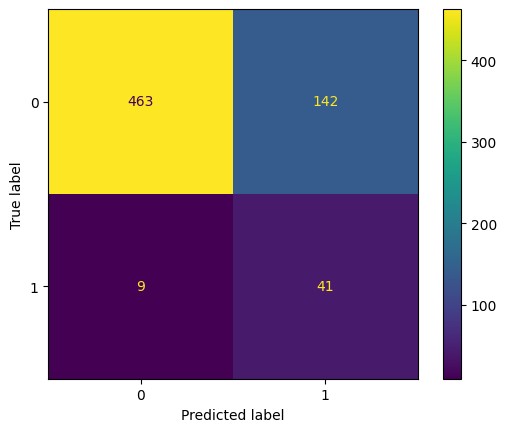

In [116]:
final_clf = LogisticRegression(
                                C=6,
                                fit_intercept=False,
                                dual=False,
                                penalty='elasticnet',
                                solver='saga',
                                tol=1e-4,
                                max_iter=1000,
                                class_weight='balanced',
                                n_jobs=-1,
                                verbose=0,
                                intercept_scaling=1.0,
                                multi_class='auto',
                                random_state=None,
                                l1_ratio=0.12,

)

final_clf.fit(
                X_train,
                y_train,
)

print(f'Balanced accuracy = ', balanced_accuracy_score(y_test, final_clf.predict(X_test)))

ConfusionMatrixDisplay.from_predictions(y_test, final_clf.predict(X_test))

In [ ]:
# END FINAL RESULTS FOR 2 AXIS OPTIMIZATION *************************************************

### ^ ^ ^ FIND BEST C AND L1 RATIO WITH THRESHOLD = 0.5 ^ ^ ^

### v v v CS, L1_RATIO, & THRESHOLD OPTIMIZED v v v

#### DO A SIMULTANEOUS 3-AXIS OPTIMIZATION OF C, L1 RATIO, AND BINARY DECISION THRESHOLD
#### COMPARE WITH C, L1 RATIO, AND BALANCED ACCURACY SCORE FROM THE 2 AXIS RESULT FROM ABOVE 

In [118]:
# CONSTRUCT A FUNCTION FOR 3-AXIS OPTIMIZATION OF C, L1 RATIO, AND BINARY DECISION THRESHOLD.
# SINCE LogisticRegressionCV.predict_proba CANNOT BE EXTRACTED FOR EACH C/L1 RATIO IN THE TEST GRID, 
# EVERY COMPUTATION MUST BE DONE WITH LogisticRegression AND THEN predict_proba(X_val) EXTRACTED TO 
# CALCULATE THE BALANCED ACCURACY SCORE AGAINT y_val FOR EACH DECISION THRESHOLD.


def three_axis_logit_optimizer(X_train, y_train, CS, L1_RATIOS, THRESHOLDS):

    # SCORES SHOULD BE STACKS OF (CS, L1_RATIOS), SO SHAPE IS (CS, L1_RATIOS, THRESHOLDS)
    SCORES = np.empty(shape=(len(CS), len(L1_RATIOS), len(THRESHOLDS)), dtype=np.float64)

    # THESE CV RESULTS, AT LEAST ON ONE PARTICULAR SAMPLING FOR TRAIN/TEST, ARE COMING OUT BETTER THAN THE 2-AXIS OPTIMIZATION ABOVE.
    # THE DIFFERENCE IS A BALANCED ACCURACY SCORE OF 0.84 HERE, vs. 0.72 ABOVE, WHICH IS NOT NEGLIGIBLE.
    # FOR LogisticRegressionCV ABOVE, X_train IS USED TO DO CV, BUT X_test IS NOT PART OF THE EQUATION; THE OPTIMIAL PARAMETERS AND BEST 
    # SCORES ARE STRICTLY DERIVED FROM X_train AND X_test IS NOT PART OF THE OPTIMIZATION PROCESS. ON THE FIRST ITERATION OF THIS 3-AXIS 
    # OPTIMIZER BELOW, OPTIMIZATION IS BEING DONE VIA LogisticRegression ON X_train, AND OPTIMAL PARAMS AND BEST SCORES ARE BEING 
    # CALCULATED BASED ON predict_proba FOR X_test. SO TO TRY TO RECONCILE THE 3-AXIS STEP BELOW WITH THE LogisticRegressionCV FROM ABOVE, 
    # ON THIS SECOND ITERATION X_val IS BEING EXTRACTED FROM X_train AND USED FOR OPTIMIZATION, THEREBY LEAVING X_test OUT OF THIS PROCESS.

    X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.25)
    
    for c_itr, _c in enumerate(CS):

        print(f'Running C # {c_itr+1} of {len(CS)}...')
        
        for l1_ratio_itr, l1_ratio in enumerate(L1_RATIOS):

            # PERFORM FIT ON TRAIN DATA FOR EVERY C / L1 RATIO COMBO AND EXTRACT predict_proba
            logit_clf = LogisticRegression(
                                            penalty='elasticnet',
                                            dual=False,
                                            tol=1e-4,
                                            C=_c,
                                            fit_intercept=False,
                                            intercept_scaling=1.0,
                                            class_weight='balanced',
                                            random_state=None,
                                            solver='saga',
                                            max_iter=1000,
                                            multi_class='auto',
                                            verbose=0,
                                            warm_start=False,
                                            n_jobs=-1,
                                            l1_ratio=l1_ratio,
            )
            
            logit_clf.fit(X_train2, y_train2)

            # USING predict_proba(X_val), CALCULATE THE BALANCED ACCURACY SCORE AGAINST y_val FOR 
            # EACH DECISION THRESHOLD
            for thresh_itr, threshold in enumerate(THRESHOLDS):

                y_val_pred = (logit_clf.predict_proba(X_val)[:, 1] >= threshold).astype(np.uint8)

                SCORES[c_itr, l1_ratio_itr, thresh_itr] = balanced_accuracy_score(y_val, y_val_pred)

            try: del y_val_pred
            except: pass

    del X_train2, y_train2, X_val, y_val
    
    return SCORES

In [119]:
# CONSTRUCT A FUNCTION FOR IDENTIFYING THE LOCATION(S) OF THE MAX BALANCED ACCURACY SCORE WITHIN THE 3-AXIS
# C / L1 RATIO / THRESHOLD GRID

def optimum_finder(SCORES):

    # TRANSFORM THE "SCORES" CUBE INTO BINARY INDICATOR OF THE LOCATION(S) OF THE HIGHEST SCORE
    HIGHEST_SCORE = (SCORES==SCORES.max()).astype(np.uint8)
    
    print(f'highest score in SCORES = ', SCORES.max())
    print(f'number of scores in SCORES = ', SCORES.size)
    print(f'number of "highest score" = ', HIGHEST_SCORE.sum())

    # TRY TO FIND MIDDLE-OF-THE-ROAD VALUES FOR C, L1_RATIO, & THRESHOLD

    best_CS = HIGHEST_SCORE.sum(axis=2).sum(axis=1).astype(bool).astype(np.uint8)
    best_CS = [_ for _ in CS * best_CS if _ != 0]

    best_L1_RATIOS = HIGHEST_SCORE.sum(axis=2).sum(axis=0).astype(bool).astype(np.uint8)
    best_L1_RATIOS = [_ for _ in L1_RATIOS * best_L1_RATIOS if _ != 0]
    
    best_THRESH = HIGHEST_SCORE.sum(axis=1).sum(axis=0).astype(bool).astype(np.uint8)
    best_THRESH = [_ for _ in THRESHOLDS * best_THRESH if _ != 0]
    
    print(f'Spread of C values over which highest score is achieved: ', best_CS)
    print(f'Spread of l1 ratios over which highest score is achieved: ', best_L1_RATIOS)
    print(f'Spread of threshold values over which highest score is achieved: ', best_THRESH)

#### ROUND 1 *****************************************************

In [121]:
%%time

CS = np.logspace(-5, 5, 11)
L1_RATIOS = np.linspace(0, 1, 11)
THRESHOLDS = np.linspace(0, 1, 11)

ROUND_1_SCORES = three_axis_logit_optimizer(X_train, y_train, CS, L1_RATIOS, THRESHOLDS)

Running C # 1 of 11...
Running C # 2 of 11...
Running C # 3 of 11...
Running C # 4 of 11...
Running C # 5 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 6 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 7 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 8 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 9 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 10 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 11 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

CPU times: total: 16min 31s
Wall time: 16min 50s


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [123]:
optimum_finder(ROUND_1_SCORES)

# highest score in SCORES =  0.7768489294549177
# number of scores in SCORES =  1331
# number of "highest score" =  1
# Spread of C values over which highest score is achieved:  [10000.0]
# Spread of l1 ratios over which highest score is achieved:  [0.8]
# Spread of threshold values over which highest score is achieved:  [0.30]

highest score in SCORES =  0.7768489294549177
number of scores in SCORES =  1331
number of "highest score" =  1
Spread of C values over which highest score is achieved:  [10000.0]
Spread of l1 ratios over which highest score is achieved:  [0.8]
Spread of threshold values over which highest score is achieved:  [0.30000000000000004]


In [124]:
del CS, L1_RATIOS, THRESHOLDS, ROUND_1_SCORES

#### END ROUND 1 *****************************************************

#### ROUND 2 *********************************************************

In [125]:
%%time

CS = np.linspace(5_000, 50_000, 10)
L1_RATIOS = np.linspace(0.7, 0.9, 5)
THRESHOLDS = np.linspace(0.2, 0.4, 5)

ROUND_2_SCORES = three_axis_logit_optimizer(X_train, y_train, CS, L1_RATIOS, THRESHOLDS)

Running C # 1 of 10...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 2 of 10...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 3 of 10...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 4 of 10...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 5 of 10...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 6 of 10...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 7 of 10...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 8 of 10...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 9 of 10...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 10 of 10...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CPU times: total: 11min 39s
Wall time: 11min 57s


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [126]:
optimum_finder(ROUND_2_SCORES)

# highest score in SCORES =  0.7950647958686543
# number of scores in SCORES =  250
# number of "highest score" =  1
# Spread of C values over which highest score is achieved:  [10000.0]
# Spread of l1 ratios over which highest score is achieved:  [0.85]
# Spread of threshold values over which highest score is achieved:  [0.30]

highest score in SCORES =  0.7950647958686543
number of scores in SCORES =  250
number of "highest score" =  1
Spread of C values over which highest score is achieved:  [10000.0]
Spread of l1 ratios over which highest score is achieved:  [0.85]
Spread of threshold values over which highest score is achieved:  [0.30000000000000004]


In [112]:
del CS, L1_RATIOS, THRESHOLDS, ROUND_2_SCORES

#### END ROUND 2 ************************************************************

#### ROUND 3 *********************************************************

In [127]:
%%time

CS = np.linspace(5_000, 15_000, 11)
L1_RATIOS = np.linspace(0.75, 0.95, 5)
THRESHOLDS = np.linspace(0.2, 0.4, 5)

ROUND_3_SCORES = three_axis_logit_optimizer(X_train, y_train, CS, L1_RATIOS, THRESHOLDS)

Running C # 1 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 2 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 3 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 4 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 5 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 6 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 7 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 8 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 9 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 10 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 11 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CPU times: total: 12min 16s
Wall time: 12min 25s


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [128]:
optimum_finder(ROUND_3_SCORES)

highest score in SCORES =  0.7059959349593496
number of scores in SCORES =  275
number of "highest score" =  1
Spread of C values over which highest score is achieved:  [8000.0]
Spread of l1 ratios over which highest score is achieved:  [0.8999999999999999]
Spread of threshold values over which highest score is achieved:  [0.2]


In [ ]:
del CS, L1_RATIOS, THRESHOLDS, ROUND_3_SCORES

#### END ROUND 3 ************************************************************

#### ROUND 4 ****************************************************************

In [129]:
%%time

CS = np.linspace(5_000, 15_000, 11)
L1_RATIOS = np.linspace(0.75, 0.95, 5)
THRESHOLDS = np.linspace(0.2, 0.4, 5)

ROUND_4_SCORES = three_axis_logit_optimizer(X_train, y_train, CS, L1_RATIOS, THRESHOLDS)

Running C # 1 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 2 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 3 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 4 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 5 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 6 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 7 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 8 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 9 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 10 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Running C # 11 of 11...


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CPU times: total: 12min 22s
Wall time: 12min 31s


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [130]:
optimum_finder(ROUND_4_SCORES)
# highest score in SCORES =  0.7745215311004785
# number of scores in SCORES =  275
# number of "highest score" =  1
# Spread of C values over which highest score is achieved:  [11000.0]
# Spread of l1 ratios over which highest score is achieved:  [0.8]
# Spread of threshold values over which highest score is achieved:  [0.2]

highest score in SCORES =  0.7745215311004785
number of scores in SCORES =  275
number of "highest score" =  1
Spread of C values over which highest score is achieved:  [11000.0]
Spread of l1 ratios over which highest score is achieved:  [0.8]
Spread of threshold values over which highest score is achieved:  [0.2]


In [ ]:
del CS, L1_RATIOS, THRESHOLDS, ROUND_4_SCORES

#### END ROUND 4 **************************************************************************

Balanced accuracy =  0.802396694214876


C:\Users\Bill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


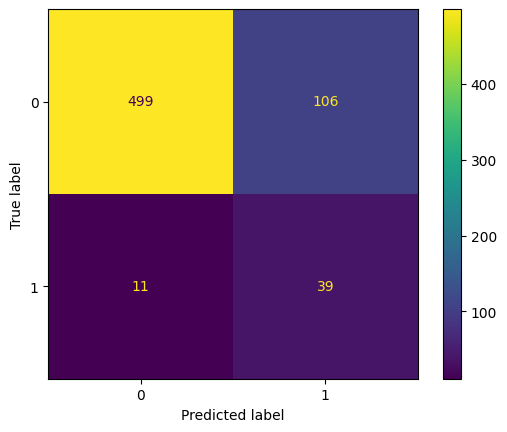

In [135]:
final_clf = LogisticRegression(
                                C=8_000,
                                fit_intercept=False,
                                dual=False,
                                penalty='elasticnet',
                                solver='saga',
                                tol=1e-4,
                                max_iter=1000,
                                class_weight='balanced',
                                n_jobs=-1,
                                verbose=0,
                                intercept_scaling=1.0,
                                multi_class='auto',
                                random_state=None,
                                l1_ratio=0.8,

)

final_clf.fit(
                X_train,
                y_train,
)

print(f'Balanced accuracy = ', balanced_accuracy_score(y_test, (final_clf.predict(X_test) >= 0.3).astype(np.uint8)))

ConfusionMatrixDisplay.from_predictions(y_test, final_clf.predict(X_test))

In [138]:
RESULTS_DF = pd.DataFrame(index=X_encoded_COLUMNS, data=final_clf.coef_.reshape((-1, 1)), columns=['COEFF'])
RESULTS_DF

,COEFF
NAICS_ALL_BANK,0.749393
NAICS_ALL_DIRECT,-2.891394
NAICS_ALL_HEALTH,2.069546
NAICS_ALL_TRANSPORTATION,1.309161
TITLE_ENGINEER,-1.417183
...,...
WEEKDAY_Wednesday_x_NAICS_ALL_MACHINERY,2.041812
WEEKDAY_Wednesday_x_TITLE_BUSINESS,-11.695483
WEEKDAY_Wednesday_x_TITLE_DATA,-1.597358
WEEKDAY_Wednesday_x_TITLE_MANAGER,4.363818


In [147]:
SORTED_RESULTS_DF = RESULTS_DF.sort_values(by='COEFF', key=lambda x: abs(x), ascending=False)
SORTED_RESULTS_DF.loc[list(map(lambda y: '_X_' not in y, SORTED_RESULTS_DF.index.str.upper())), :].head(40)

,COEFF
YEAR_2020,-4.565156
MONTH_8,-3.605255
DAY_11,-3.432289
NAICS_ALL_DIRECT,-2.891394
YEAR_2019,-2.525900
MONTH_5,2.184725
STATE_NY,-2.105187
NAICS_ALL_HEALTH,2.069546
MCAP_100B-150B,-1.789848
STATE_TX,1.709530


### ^ ^ ^ CS, L1_RATIO, & THRESHOLD OPTIMIZED ^ ^ ^